# Imports

In [1]:
# !export GPN_DB_HOST=192.168.10.36


In [2]:
#!ls -la ../../work
# #!mv ../../../documents.json.zip ../../work
# # !unzip '../../work/documents.json.zip' '../../work/documents.json'
# !mv documents.json ../../work

In [3]:
IMPORT_FRESH_ONLY = True # re-import all if False

In [4]:
import logging
import platform
import sys
import os
import seaborn as sns
import matplotlib.pyplot as plt
from IPython.display import display, Markdown
from datetime import datetime
import tensorflow as tf

logger = logging.getLogger('retrain_ipynb')
logger.setLevel(logging.DEBUG)


ch = logging.StreamHandler()
ch.setLevel(logging.DEBUG)
formatter = logging.Formatter('%(levelname)s - %(asctime)s - %(name)s - %(message)s')
ch.setFormatter(formatter)
logger.addHandler(ch)
logger.debug('--=logging started=--')

print("tf",tf.__version__)
CPU = platform.processor()
print (f'Running on CPU:{CPU}')

2023-01-27 11:02:23.827846: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0
DEBUG - 2023-01-27 11:02:26,869 - retrain_ipynb - --=logging started=--


tf 2.5.0
Running on CPU:x86_64


In [5]:
nb_dir = os.path.split(os.getcwd())[0]
if nb_dir not in sys.path:
    sys.path.append(nb_dir)

import analyser.hyperparams 


Nemoware Analyser v23.1.27.1
USING WORKDIR: [/root/artem/work]
 set ENV GPN_WORK_DIR to override
datasets_dir: [/root/artem/work/datasets]
reports_dir: [/root/artem/work/reports]


/root/artem/analyser/analyser/hyperparams.py:15: UserWarning: please set GPN_WORK_DIR environment variable
  warnings.warn('please set GPN_WORK_DIR environment variable')



### Imports...

In [6]:
%matplotlib inline

import pandas as pd
import numpy as np
from pandas import DataFrame

from analyser.finalizer import get_doc_by_id
from analyser.persistence import DbJsonDoc
from integration.db import get_mongodb_connection

from datetime import datetime
from math import log1p
from pandas import DataFrame
from analyser.persistence import DbJsonDoc
from colab_support.renderer import plot_embedding

from analyser.structures import DocumentState

from pathlib import Path
from bson import ObjectId

from datetime import date
from dateutil.relativedelta import relativedelta

# from tf_support.super_contract_model import seq_labels_contract, seq_labels_contract_swap_orgs
# 


HyperParameters.subsidiary_name_match_min_jaro_similarity 0.9649122807017544


[currencies.py:17 -             _env_var() ] Currency-service : define GPN_CURRENCY_USER environment variable! defaulting to None
[currencies.py:17 -             _env_var() ] Currency-service : define GPN_CURRENCY_PASSWORD environment variable! defaulting to None
[currencies.py:17 -             _env_var() ] Currency-service : define GPN_CURRENCY_URL environment variable! defaulting to None
[documents.py:270 -             __init__() ] loading word cases stats model from: /root/artem/analyser/analyser/vocab/word_cases_stats.pickle
[tools.py:29 -             __init__() ] model_checkpoint_path: /root/artem/analyser/analyser/vocab


In [7]:
# 
# !pip install transformers==4.11.3
# --force-reinstall
# !pip uninstall huggingface-hub -y


In [8]:
### Prepare workdir

In [9]:
_work_dir_default = Path(analyser.hyperparams.__file__).parent.parent.parent / 'work'
work_dir = os.environ.get('GPN_WORK_DIR', _work_dir_default)

if not os.path.isdir(work_dir):
    os.mkdir(work_dir)

analyser.hyperparams.work_dir = work_dir
 

print('work_dir=', analyser.hyperparams.work_dir)
assert os.path.isdir(analyser.hyperparams.work_dir)

work_dir= /root/artem/work


### Query DB for contact IDs

#### Load meta data CSV

In [10]:
!touch /root/artem/work/contract_trainset_meta.temp.csv

In [11]:
# stats[["user_correction_date", 'analyze_date']].max().max()

In [12]:
export_fn = str(Path(work_dir) / 'contract_trainset_meta.temp.csv')
# stats = pd.read_csv(export_fn, index_col=0)

try:
    stats = pd.read_csv(export_fn, index_col=0)
    if not 'analyze_date' in stats:
        stats['analyze_date'] = None
        
    if not 'documentType' in stats:
        stats['documentType'] = 'Unknown'
    
    stats['user_correction_date'] = pd.to_datetime(stats['user_correction_date'], utc=True)
    stats['analyze_date'] = pd.to_datetime(stats['analyze_date'], utc=True)

    lastdate = stats[["user_correction_date", 'analyze_date']].max().max()
    
except Exception as ex:
    print(f'ERROR: cannot load {export_fn}')
    logger.exception(ex)
    logger.error(f'cannot load {export_fn}')

    lastdate = datetime(1900, 1, 1)
    stats = DataFrame()
    
if not IMPORT_FRESH_ONLY:
    lastdate = datetime(1900, 1, 1)
    
print(lastdate, export_fn)


stats['source'] = 'db'


stats

2023-01-27 09:19:44.459000+00:00 /root/artem/work/contract_trainset_meta.temp.csv


source                          checksum   version  \
5ec2b8da665f7603e03b1255     db  3187bfac60ea578221c5d9357756c6c1     1.6.5   
5fb376e2d8c9df1ed123726c     db  f7c027bb799a50d6fda9d32443bb9cdd     2.0.5   
5fb399dc39d5e82e90818474     db  375f811ae7c0edcc737d7342373710cb     2.0.5   
5fb3b97d00881c332b567292     db  5f4482e55f27e0fcb20b1ffd819d0260     2.0.5   
5fb3b97e00881c332b5672bd     db  eb69b91855f471b6db8deb924eb34aa5     2.0.5   
...                         ...                               ...       ...   
63ce4a0ee83d1ee490f3f381     db  4580cd80fac3f2741a9559df1814ff49  23.01.23   
63d24b69c25950de8f832c9f     db  f5a4492baf668f8c71453935a924ac09  23.01.23   
63d24b69c25950de8f832c9e     db  665a638dc4f2c42ce670679ca76cff77  23.01.23   
63d24b9d3554f2343d832c9b     db  f5a4492baf668f8c71453935a924ac09  23.01.23   
63d24b9d3554f2343d832c9a     db  665a638dc4f2c42ce670679ca76cff77  23.01.23   

                                               export_date     len  \
5ec2b8da665f7603e03b1255  2022-12-11 06:49:05.545685+00:00  5847.0   
5fb376e2d8c9df1ed123726c  2022-12-11 06:49:05.679106+00:00  2794.0   
5fb399dc39d5e82e90818474  2022-12-11 06:49:05.693657+00:00  3742.0   
5fb3b97d00881c332b567292  2022-12-11 06:49:05.700408+00:00  2248.0   
5fb3b97e00881c332b5672bd  2022-12-11 06:49:05.712772+00:00  3546.0   
...                                                    ...     ...   
63ce4a0ee83d1ee490f3f381  2023-01-25 19:06:21.758508+00:00  4411.0   
63d24b69c25950de8f832c9f        2023-01-26 18:13:03.589102   123.0   
63d24b69c25950de8f832c9e        2023-01-26 18:13:03.599658  2021.0   
63d24b9d3554f2343d832c9b        2023-01-26 18:13:03.604925   123.0   
63d24b9d3554f2343d832c9a        2023-01-26 18:13:03.615247  2021.0   

                                             analyze_date         value  \
5ec2b8da665f7603e03b1255 2020-05-18 17:16:38.114000+00:00  2.523632e+07   
5fb376e2d8c9df1ed123726c 2020-11-17 07:11:23.321000+00:00  2.970000e+03   
5fb399dc39d5e82e90818474 2020-11-17 09:56:11.605000+00:00  9.000000e+04   
5fb3b97d00881c332b567292 2020-11-17 12:01:39.924000+00:00           NaN   
5fb3b97e00881c332b5672bd 2020-11-17 12:12:00.629000+00:00  1.548241e+07   
...                                                   ...           ...   
63ce4a0ee83d1ee490f3f381 2023-01-24 19:02:27.030000+00:00  5.365190e+04   
63d24b69c25950de8f832c9f 2023-01-26 12:52:09.766000+00:00           NaN   
63d24b69c25950de8f832c9e 2023-01-26 12:53:05.865000+00:00  1.500000e+10   
63d24b9d3554f2343d832c9b 2023-01-26 12:53:08.673000+00:00           NaN   
63d24b9d3554f2343d832c9a 2023-01-26 12:53:12.433000+00:00  1.500000e+10   

                          value_log1p  value_span currency  \
5ec2b8da665f7603e03b1255    17.043795      5674.0      BRL   
5fb376e2d8c9df1ed123726c     7.996654      1364.0      RUB   
5fb399dc39d5e82e90818474    11.407576      1834.0      RUB   
5fb3b97d00881c332b567292          NaN         NaN      NaN   
5fb3b97e00881c332b5672bd    16.555215       699.0      RUB   
...                               ...         ...      ...   
63ce4a0ee83d1ee490f3f381    10.890291      3925.0      RUB   
63d24b69c25950de8f832c9f          NaN         NaN      NaN   
63d24b69c25950de8f832c9e    23.431316       201.0      RUB   
63d24b9d3554f2343d832c9b          NaN         NaN      NaN   
63d24b9d3554f2343d832c9a    23.431316       201.0      RUB   

                                                          org-1-name  \
5ec2b8da665f7603e03b1255       Газпромнефть научно-технический центр   
5fb376e2d8c9df1ed123726c  ХанымеГн-киіі неторнко-краевелческий музей   
5fb399dc39d5e82e90818474                      Газпромнефть-Заполярье   
5fb3b97d00881c332b567292                       Газпромнефть-Оренбург   
5fb3b97e00881c332b5672bd                       Газпромнефть-Оренбург   
...                                                              ...   
63ce4a0ee83d1ee490f3f381         Газпромнефть-Каталитические системы   
63d24b69c2595

In [13]:
lastdate

Timestamp('2023-01-27 09:19:44.459000+0000', tz='UTC')

# load old json

In [14]:
import json
import re
from bson import json_util
_DEBUG = False
file_data=None
try:
    fn = work_dir / 'documents.json'
    with open(fn) as file:
        file_data = json.load(file, object_hook=json_util.object_hook)

        print(f'total docs in {fn} is {len(file_data)}')    
        _DEBUG = True
except Exception as ex:
    logger.exception(ex)    




if _DEBUG:
    a_doc_from_json=DbJsonDoc(file_data[3])

    print(a_doc_from_json.get_attributes_tree())
    print(a_doc_from_json.get_version_string())

total docs in /root/artem/work/documents.json is 622
{'orgs': [{'type': {'span': [47, 48], 'span_map': 'words', 'confidence': 0.49801500000000004, 'value': 'Общество с ограниченной ответственностью'}, 'name': {'span': [49, 50], 'span_map': 'words', 'confidence': 0.9755, 'value': 'Газпромнефть-Сахалин'}, 'alias': {'span': [56, 57], 'span_map': 'words', 'confidence': 0.972, 'value': 'Арендатор'}}, {'type': {'span': [17, 18], 'span_map': 'words', 'confidence': 0.505665, 'value': 'Общество с ограниченной ответственностью'}, 'name': {'span': [19, 20], 'span_map': 'words', 'confidence': 0.9905, 'value': 'ЭКРУСС'}, 'alias': {'span': [26, 27], 'span_map': 'words', 'confidence': 0.987, 'value': 'Арендодатель'}}], 'date': {'span': [9, 14], 'span_map': 'words', 'confidence': 1, 'value': datetime.datetime(2016, 5, 10, 0, 0, tzinfo=<bson.tz_util.FixedOffset object at 0x7fbe110f52b0>)}, 'number': {'span': [1, 4], 'span_map': 'words', 'confidence': 1, 'value': 'RP 16-06'}, 'subject': {'span': [100, 1

# functions

In [15]:

def get_amount(attr_tree):
  _value_tag = attr_tree.get('price')
  amount = None
  if _value_tag is not None:
    amount = _value_tag.get('amount_netto')
    if amount is None:
      amount = _value_tag.get('amount_brutto')
    if amount is None:
      amount = _value_tag.get('amount')
  return amount

        
    
def add_stats_record(d: DbJsonDoc, stats: DataFrame, source='db'):
  _id = str(d.get_id())
    
  attr_tree = d.get_attributes_tree()
 

  stats.at[_id, 'checksum'] = d.get_tokens_for_embedding().get_checksum()
  stats.at[_id, 'version'] = d.get_version_string()
  stats.at[_id, 'documentType'] = d.documentType
    
 
  stats.at[_id, 'source'] = source
  stats.at[_id, 'export_date'] = datetime.now()
  stats.at[_id, 'len'] = len(d)
  stats.at[_id, 'analyze_date'] = pd.to_datetime( d.analysis['analyze_timestamp'] , utc=True)


  _value_tag = attr_tree.get('price')
  
  if _value_tag is not None:
    amount = get_amount(attr_tree) 
    if amount:
        
        stats.at[_id, 'value'] = amount.get('value') 
        stats.at[_id, 'value_log1p'] = log1p(amount.get('value') )
        stats.at[_id, 'value_span'] = amount.get('span', [0,0]) [0]
#         print( stats.at[_id, 'value'])
    
    stats.at[_id, 'currency'] = _value_tag.get('currency', {}).get('value')
  
  _orgs = attr_tree.get('orgs', [{},{}]) 
  if len(_orgs)>0:
      stats.at[_id, 'org-1-name'] = _orgs[0].get('name', {}).get('value')
      stats.at[_id, 'org-1-alias'] = _orgs[0].get('alias', {}).get('value')

      if len(_orgs)>1:
        stats.at[_id, 'org-2-name'] = _orgs[1].get('name', {}).get('value')
        stats.at[_id, 'org-2-alias'] = _orgs[1].get('alias', {}).get('value')

  stats.at[_id, 'subject'] = attr_tree.get('subject', {}).get('value')
  stats.at[_id, 'subject confidence'] = attr_tree.get('subject', {}).get('confidence')
    



  if d.user is not None:
    # if 'attributes_tree' in d.user and 'creation_date' in d.user['attributes_tree']:
    # stats.at[_id, 'user_correction_date'] = d.user['attributes_tree']['creation_date']
    stats.at[_id, 'user_correction_date'] = pd.to_datetime(d.user[ 'updateDate'], utc=True)
    

    # find_in_dict('attributes_tree.creation_date', d.user)

  stats.at[_id, 'valid'] = (DocumentState.Excluded.value==d.state or DocumentState.Done.value==d.state) and ('contract' in jd.analysis['attributes_tree'])



['amount_brutto', 'amount_netto', 'vat', 'sign', 'currency', 'vat_unit']
['org-name', 'org-alias', 'org-type']


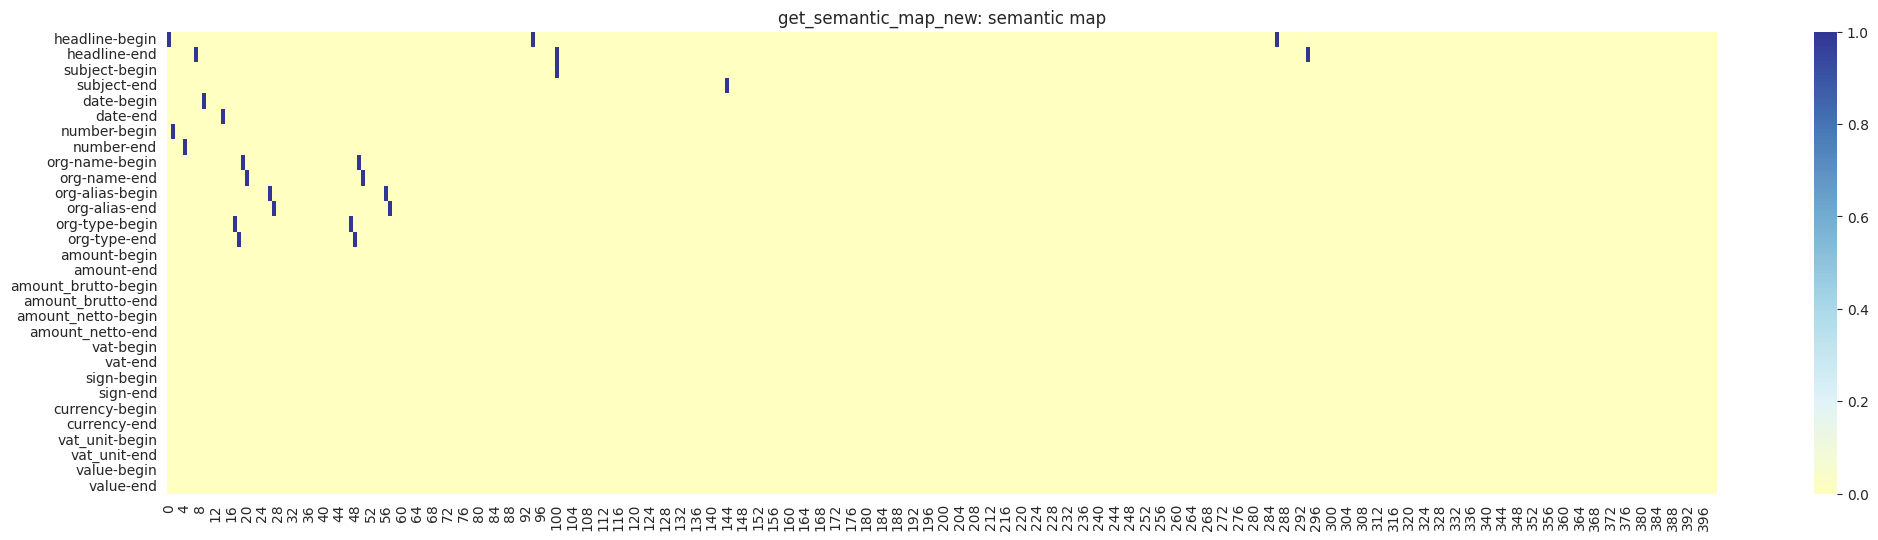

1.0
0       0.0
1       0.0
2       0.0
3       0.0
4       0.0
       ... 
3148    0.0
3149    0.0
3150    0.0
3151    0.0
3152    0.0
Name: date-begin, Length: 3153, dtype: float64


In [16]:
import json
 


semantic_map_keys = [
    'headline',
    'subject', 
    'date', 
    'number',
    'org-name', 
    'org-alias', 
    'org-type'
]

semantic_map_keys += ['amount', 'amount_brutto', 'amount_netto', 'vat', 'sign', 'currency', 'vat_unit', 'value']

semantic_map_keys_contract = []
for _name in semantic_map_keys:
    semantic_map_keys_contract.append(_name + "-begin")
    semantic_map_keys_contract.append(_name + "-end")

print(semantic_map_keys[8:14])
print(semantic_map_keys[4:7])

def get_semantic_map_new(doc: DbJsonDoc):
    
    _len = len(doc)
    df = DataFrame()
    
    for sl in semantic_map_keys_contract:    
        df[sl] = np.zeros(_len)
    
    attr_tree = doc.get_attributes_tree()
    
    def get_av(name):
        if name in df:
            return df[name]
        else:
            av = np.zeros(_len, np.float)
            df[name] = av
            return av

            
    def add_span_vectors(_name, span):
#         print('add_span_vectors',span)
        bn = _name + "-begin"
        en = _name + "-end"
        b = get_av(bn)
        e = get_av(en)
        if not span is None:
            df[bn][ span[0] ]=1.
            df[en][ span[1] ]=1.
 
        

    # Headers
    headers = doc.analysis['headers']
    for h in headers:
        add_span_vectors('headline', h['span'])
 
 
    for n in semantic_map_keys[1:4]:
        span = attr_tree.get(n, {}).get('span')
        add_span_vectors(n, span)

 
    for i in [1, 2]:
        for n in semantic_map_keys[4:7]:
            try:                
                _nm = n.replace('org-', f'')
                span = attr_tree['orgs'][i-1][_nm]['span']
                add_span_vectors(n, span)
            except Exception as e:
                logger.exception(e)
                print('ERROR (sp)', e, i, n,  _nm)
                if _DEBUG:
                    try:  
                        print(json.dumps( attr_tree['orgs'][i-1], sort_keys=True, indent=4))
                    except:
                        pass
                    print('ERROR', i, n, doc.get_id(), e, attr_tree.get('orgs', None))
 

    _value_tag = attr_tree.get('price', {})
    add_span_vectors("value", _value_tag.get('span'))
 
    if _value_tag is not None:
        amount = get_amount(attr_tree) 
        if amount:
            add_span_vectors('amount', amount.get('span'))
        for n in semantic_map_keys[8:14]:
            add_span_vectors(n, _value_tag.get(n,{}).get('span'))
           
    return df[semantic_map_keys_contract]



if _DEBUG:
    sm_test = get_semantic_map_new(a_doc_from_json)
    plot_embedding(sm_test[0:400], f'get_semantic_map_new: semantic map')
    print(sm_test['date-begin'].max())
    print(sm_test['date-begin'])

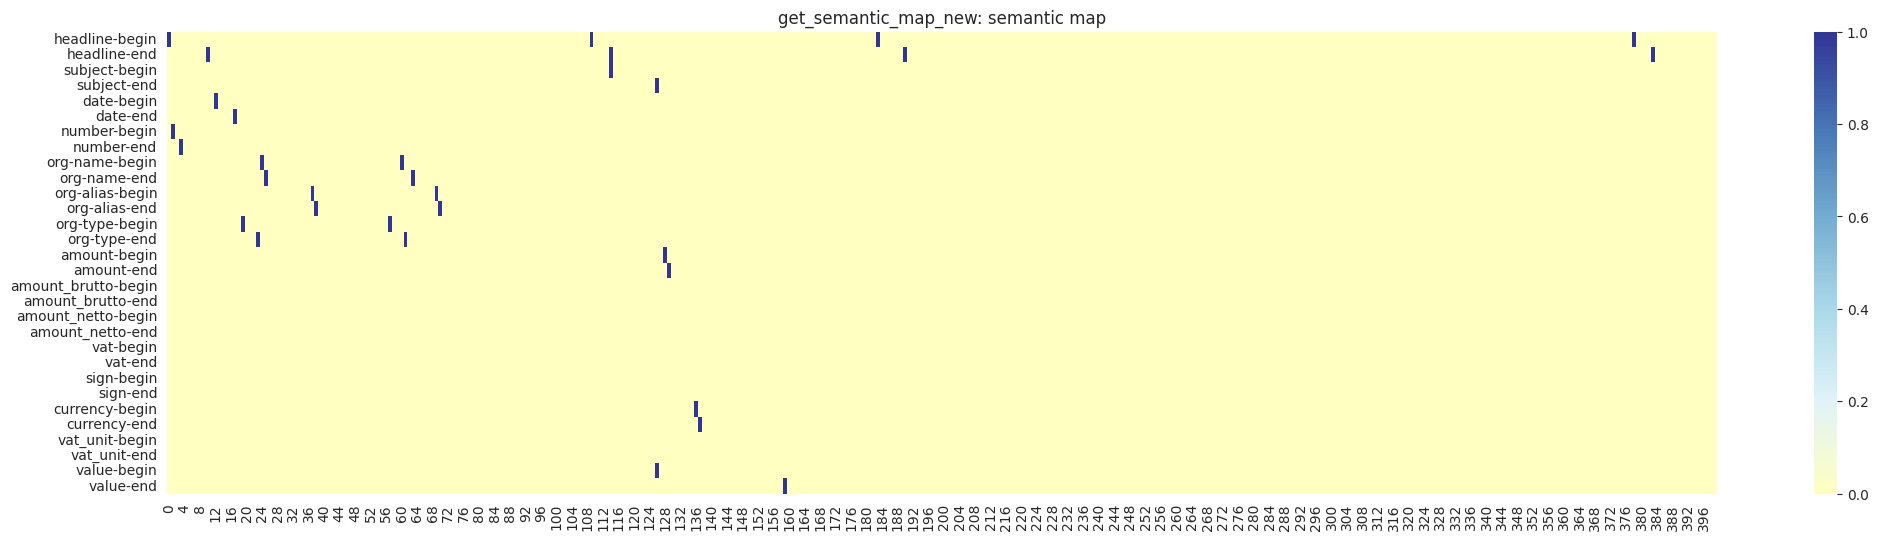

In [88]:
#test one

d = get_doc_by_id(ObjectId('5fe34f62b770574a005553be'))
jd = DbJsonDoc(d)
semantic_map: DataFrame = get_semantic_map_new(jd)
    

plot_embedding(semantic_map[0:400], f'get_semantic_map_new: semantic map')

In [18]:
# fff
files_dict = {}
if file_data:
    k=0
    for d in file_data:
        k+=1 
        jd = DbJsonDoc(d)
    #     print( jd.analysis['analyze_timestamp'])
        files_dict[jd.get_id()] = jd
        try:            
            add_stats_record(jd, stats, source = 'file')
        except Exception as e:
            print(e)
            print(jd.get_id())
#             raise (e)

        if k % 100 == 0:
#             stats['user_correction_date'] = pd.to_datetime(stats['user_correction_date'], utc=False)
#             stats['analyze_date'] = pd.to_datetime(stats['analyze_date'], utc=False)
#             stats['export_date'] = pd.to_datetime(stats['export_date'], utc=False)
            
    
            print(f'{k} of {len(file_data)}')
            stats.to_csv(export_fn, index=True)
            print(f'stats saved to {export_fn}')

            
            
stats.to_csv(export_fn, index=True)
print(f'stats saved to {export_fn}')

# del file_data
stats




100 of 622
stats saved to /root/artem/work/contract_trainset_meta.temp.csv
200 of 622
stats saved to /root/artem/work/contract_trainset_meta.temp.csv
300 of 622
stats saved to /root/artem/work/contract_trainset_meta.temp.csv
400 of 622
stats saved to /root/artem/work/contract_trainset_meta.temp.csv

5efdb73b777d4b67a92d533c
500 of 622
stats saved to /root/artem/work/contract_trainset_meta.temp.csv
600 of 622
stats saved to /root/artem/work/contract_trainset_meta.temp.csv
stats saved to /root/artem/work/contract_trainset_meta.temp.csv


source                          checksum   version  \
5ec2b8da665f7603e03b1255     db  3187bfac60ea578221c5d9357756c6c1     1.6.5   
5fb376e2d8c9df1ed123726c     db  f7c027bb799a50d6fda9d32443bb9cdd     2.0.5   
5fb399dc39d5e82e90818474     db  375f811ae7c0edcc737d7342373710cb     2.0.5   
5fb3b97d00881c332b567292     db  5f4482e55f27e0fcb20b1ffd819d0260     2.0.5   
5fb3b97e00881c332b5672bd     db  eb69b91855f471b6db8deb924eb34aa5     2.0.5   
...                         ...                               ...       ...   
63ce4a0ee83d1ee490f3f381     db  4580cd80fac3f2741a9559df1814ff49  23.01.23   
63d24b69c25950de8f832c9f     db  f5a4492baf668f8c71453935a924ac09  23.01.23   
63d24b69c25950de8f832c9e     db  665a638dc4f2c42ce670679ca76cff77  23.01.23   
63d24b9d3554f2343d832c9b     db  f5a4492baf668f8c71453935a924ac09  23.01.23   
63d24b9d3554f2343d832c9a     db  665a638dc4f2c42ce670679ca76cff77  23.01.23   

                                               export_date     len  \
5ec2b8da665f7603e03b1255  2022-12-11 06:49:05.545685+00:00  5847.0   
5fb376e2d8c9df1ed123726c  2022-12-11 06:49:05.679106+00:00  2794.0   
5fb399dc39d5e82e90818474  2022-12-11 06:49:05.693657+00:00  3742.0   
5fb3b97d00881c332b567292  2022-12-11 06:49:05.700408+00:00  2248.0   
5fb3b97e00881c332b5672bd  2022-12-11 06:49:05.712772+00:00  3546.0   
...                                                    ...     ...   
63ce4a0ee83d1ee490f3f381  2023-01-25 19:06:21.758508+00:00  4411.0   
63d24b69c25950de8f832c9f        2023-01-26 18:13:03.589102   123.0   
63d24b69c25950de8f832c9e        2023-01-26 18:13:03.599658  2021.0   
63d24b9d3554f2343d832c9b        2023-01-26 18:13:03.604925   123.0   
63d24b9d3554f2343d832c9a        2023-01-26 18:13:03.615247  2021.0   

                                             analyze_date         value  \
5ec2b8da665f7603e03b1255 2020-05-18 17:16:38.114000+00:00  2.523632e+07   
5fb376e2d8c9df1ed123726c 2020-11-17 07:11:23.321000+00:00  2.970000e+03   
5fb399dc39d5e82e90818474 2020-11-17 09:56:11.605000+00:00  9.000000e+04   
5fb3b97d00881c332b567292 2020-11-17 12:01:39.924000+00:00           NaN   
5fb3b97e00881c332b5672bd 2020-11-17 12:12:00.629000+00:00  1.548241e+07   
...                                                   ...           ...   
63ce4a0ee83d1ee490f3f381 2023-01-24 19:02:27.030000+00:00  5.365190e+04   
63d24b69c25950de8f832c9f 2023-01-26 12:52:09.766000+00:00           NaN   
63d24b69c25950de8f832c9e 2023-01-26 12:53:05.865000+00:00  1.500000e+10   
63d24b9d3554f2343d832c9b 2023-01-26 12:53:08.673000+00:00           NaN   
63d24b9d3554f2343d832c9a 2023-01-26 12:53:12.433000+00:00  1.500000e+10   

                          value_log1p  value_span currency  \
5ec2b8da665f7603e03b1255    17.043795      5674.0      BRL   
5fb376e2d8c9df1ed123726c     7.996654      1364.0      RUB   
5fb399dc39d5e82e90818474    11.407576      1834.0      RUB   
5fb3b97d00881c332b567292          NaN         NaN      NaN   
5fb3b97e00881c332b5672bd    16.555215       699.0      RUB   
...                               ...         ...      ...   
63ce4a0ee83d1ee490f3f381    10.890291      3925.0      RUB   
63d24b69c25950de8f832c9f          NaN         NaN      NaN   
63d24b69c25950de8f832c9e    23.431316       201.0      RUB   
63d24b9d3554f2343d832c9b          NaN         NaN      NaN   
63d24b9d3554f2343d832c9a    23.431316       201.0      RUB   

                                                          org-1-name  \
5ec2b8da665f7603e03b1255       Газпромнефть научно-технический центр   
5fb376e2d8c9df1ed123726c  ХанымеГн-киіі неторнко-краевелческий музей   
5fb399dc39d5e82e90818474                      Газпромнефть-Заполярье   
5fb3b97d00881c332b567292                       Газпромнефть-Оренбург   
5fb3b97e00881c332b5672bd                       Газпромнефть-Оренбург   
...                                                              ...   
63ce4a0ee83d1ee490f3f381         Газпромнефть-Каталитические системы   
63d24b69c2595

In [19]:
# !tail /root/artem/work/contract_trainset_meta.temp.csv

# Fetch fresh docs from Mongo DB

In [20]:


# if True:
#     lastdate = date.today() + relativedelta(days=-15)
#     lastdate = datetime.combine(lastdate, datetime.min.time())

lastdate

Timestamp('2023-01-27 09:19:44.459000+0000', tz='UTC')

In [21]:
from pymongo import ASCENDING

query = {
  '$and': [
    {"parse.documentType":{ '$in': ["AGREEMENT","CONTRACT","SUPPLEMENTARY_AGREEMENT",] }  },
      
#     {"state": 15},
    {'$or': [
          {"analysis.attributes_tree": {"$ne": None}},
          {"user.attributes_tree": {"$ne": None}}
        ]},
#       {'$and': [
#           {"user.updateDate": {"$ne": None}},
#           {'user.updateDate': {'$gt': lastdate}}
#       ]}
#     {"user.attributes_tree.contract.people": {"$ne": None}}

    #     {'$or': [
    #         {"user.attributes_tree.contract.price.amount_netto": {"$ne": None}},
    #         {"user.attributes_tree.contract.price.amount_brutto": {"$ne": None}}
    #     ]}
    {'$or': [
      {'analysis.analyze_timestamp': {'$gt': lastdate}},
      {'user.updateDate': {'$gt': lastdate}}
    ]}
  ]
}

db = get_mongodb_connection()
documents_collection = db['documents']
sorting = [('analysis.analyze_timestamp', ASCENDING), ('user.updateDate', ASCENDING)]
res = documents_collection.find(filter=query, 
                                sort=sorting,
                                projection={'_id': True, 'user.updateDate':True, 'state':True, 'parse.documentType':True}
#                                             'analysis.attributes_tree.version': True,
#                                             'analysis.attributes_tree.contract.subject': True}
                               ).limit(5000)

res = list([i for i in res])
# print(res[0])
_s = f"#### Всего новых документов после {lastdate} : {len(res)}"
display(Markdown(_s))

res[:4]

/root/artem/analyser/integration/db.py:13: UserWarning: MongoDB : define GPN_DB_NAME environment variable! defaulting to gpn
  warnings.warn(msg)


#### Всего новых документов после 2023-01-27 09:19:44.459000+00:00 : 4

[{'_id': ObjectId('634022659d08c565cfa1233f'),
  'user': {'updateDate': datetime.datetime(2023, 1, 27, 6, 37, 16, 874000)},
  'state': 15,
  'parse': {'documentType': 'SUPPLEMENTARY_AGREEMENT'}},
 {'_id': ObjectId('633c28629d08c565cfa1230a'),
  'user': {'updateDate': datetime.datetime(2023, 1, 27, 6, 47, 17, 134000)},
  'state': 15,
  'parse': {'documentType': 'CONTRACT'}},
 {'_id': ObjectId('633d4fa09d08c565cfa12315'),
  'user': {'updateDate': datetime.datetime(2023, 1, 27, 6, 58, 33, 894000)},
  'state': 15,
  'parse': {'documentType': 'AGREEMENT'}},
 {'_id': ObjectId('638085b86a07f3e980b2c846'),
  'user': {'updateDate': datetime.datetime(2023, 1, 27, 6, 55, 48, 829000)},
  'state': 12,
  'parse': {'documentType': 'CONTRACT'}}]

# Prepare training set

In [22]:
# del seq_labels_contract

In [23]:
new_docs_ids = docs_ids = [i["_id"] for i in res]
print(len(new_docs_ids))
# sample_id = ObjectId('637f7bf0e712cc2ff2e943d3')

# sample_id = docs_ids[1]
# sample_id
# d = get_doc_by_id(sample_id)

# jd = DbJsonDoc(d)
# jd.get_id()
# print(d['_id'])


#==========================Test 1 doc
    
# print(jd.get_version_string())
 
# add_stats_record(jd, stats)
# stats.loc[str(jd._id)]
 

4


In [24]:
# plot_embedding(get_semantic_map_new(jd)[:300], f'semantic map')
# print(len(docs_ids))

In [25]:
export_fn

'/root/artem/work/contract_trainset_meta.temp.csv'

In [26]:
for k, oid in enumerate(docs_ids):
    d = get_doc_by_id(oid)
#     print('fetching', oid)
    jd = DbJsonDoc(d)
    
    try:
        add_stats_record(jd, stats)
    except Exception as e:
        print(jd.get_id())
        print (e)
    
    if k % 100 == 0:
        print(f'{k} of {len(docs_ids)}')
        stats.to_csv(export_fn, index=True)
        print(f'stats saved to {export_fn}')
        
stats.to_csv(export_fn, index=True)
print(f'stats saved to {export_fn}')
stats

0 of 4
stats saved to /root/artem/work/contract_trainset_meta.temp.csv
stats saved to /root/artem/work/contract_trainset_meta.temp.csv


source                          checksum   version  \
5ec2b8da665f7603e03b1255     db  3187bfac60ea578221c5d9357756c6c1     1.6.5   
5fb376e2d8c9df1ed123726c     db  f7c027bb799a50d6fda9d32443bb9cdd     2.0.5   
5fb399dc39d5e82e90818474     db  375f811ae7c0edcc737d7342373710cb     2.0.5   
5fb3b97d00881c332b567292     db  5f4482e55f27e0fcb20b1ffd819d0260     2.0.5   
5fb3b97e00881c332b5672bd     db  eb69b91855f471b6db8deb924eb34aa5     2.0.5   
...                         ...                               ...       ...   
63ce4a0ee83d1ee490f3f381     db  4580cd80fac3f2741a9559df1814ff49  23.01.23   
63d24b69c25950de8f832c9f     db  f5a4492baf668f8c71453935a924ac09  23.01.23   
63d24b69c25950de8f832c9e     db  665a638dc4f2c42ce670679ca76cff77  23.01.23   
63d24b9d3554f2343d832c9b     db  f5a4492baf668f8c71453935a924ac09  23.01.23   
63d24b9d3554f2343d832c9a     db  665a638dc4f2c42ce670679ca76cff77  23.01.23   

                                               export_date     len  \
5ec2b8da665f7603e03b1255  2022-12-11 06:49:05.545685+00:00  5847.0   
5fb376e2d8c9df1ed123726c  2022-12-11 06:49:05.679106+00:00  2794.0   
5fb399dc39d5e82e90818474  2022-12-11 06:49:05.693657+00:00  3742.0   
5fb3b97d00881c332b567292  2022-12-11 06:49:05.700408+00:00  2248.0   
5fb3b97e00881c332b5672bd  2022-12-11 06:49:05.712772+00:00  3546.0   
...                                                    ...     ...   
63ce4a0ee83d1ee490f3f381  2023-01-25 19:06:21.758508+00:00  4411.0   
63d24b69c25950de8f832c9f        2023-01-26 18:13:03.589102   123.0   
63d24b69c25950de8f832c9e        2023-01-26 18:13:03.599658  2021.0   
63d24b9d3554f2343d832c9b        2023-01-26 18:13:03.604925   123.0   
63d24b9d3554f2343d832c9a        2023-01-26 18:13:03.615247  2021.0   

                                             analyze_date         value  \
5ec2b8da665f7603e03b1255 2020-05-18 17:16:38.114000+00:00  2.523632e+07   
5fb376e2d8c9df1ed123726c 2020-11-17 07:11:23.321000+00:00  2.970000e+03   
5fb399dc39d5e82e90818474 2020-11-17 09:56:11.605000+00:00  9.000000e+04   
5fb3b97d00881c332b567292 2020-11-17 12:01:39.924000+00:00           NaN   
5fb3b97e00881c332b5672bd 2020-11-17 12:12:00.629000+00:00  1.548241e+07   
...                                                   ...           ...   
63ce4a0ee83d1ee490f3f381 2023-01-24 19:02:27.030000+00:00  5.365190e+04   
63d24b69c25950de8f832c9f 2023-01-26 12:52:09.766000+00:00           NaN   
63d24b69c25950de8f832c9e 2023-01-26 12:53:05.865000+00:00  1.500000e+10   
63d24b9d3554f2343d832c9b 2023-01-26 12:53:08.673000+00:00           NaN   
63d24b9d3554f2343d832c9a 2023-01-26 12:53:12.433000+00:00  1.500000e+10   

                          value_log1p  value_span currency  \
5ec2b8da665f7603e03b1255    17.043795      5674.0      BRL   
5fb376e2d8c9df1ed123726c     7.996654      1364.0      RUB   
5fb399dc39d5e82e90818474    11.407576      1834.0      RUB   
5fb3b97d00881c332b567292          NaN         NaN      NaN   
5fb3b97e00881c332b5672bd    16.555215       699.0      RUB   
...                               ...         ...      ...   
63ce4a0ee83d1ee490f3f381    10.890291      3925.0      RUB   
63d24b69c25950de8f832c9f          NaN         NaN      NaN   
63d24b69c25950de8f832c9e    23.431316       201.0      RUB   
63d24b9d3554f2343d832c9b          NaN         NaN      NaN   
63d24b9d3554f2343d832c9a    23.431316       201.0      RUB   

                                                          org-1-name  \
5ec2b8da665f7603e03b1255       Газпромнефть научно-технический центр   
5fb376e2d8c9df1ed123726c  ХанымеГн-киіі неторнко-краевелческий музей   
5fb399dc39d5e82e90818474                      Газпромнефть-Заполярье   
5fb3b97d00881c332b567292                       Газпромнефть-Оренбург   
5fb3b97e00881c332b5672bd                       Газпромнефть-Оренбург   
...                                                              ...   
63ce4a0ee83d1ee490f3f381         Газпромнефть-Каталитические системы   
63d24b69c2595

In [27]:
stats = stats[stats.valid!=False]
len(stats)

9098

In [28]:
stats2 = stats.copy()
stats2['org-2-alias'] = stats2['org-2-alias'].str.lower()
stats2['org-1-alias'] = stats2['org-1-alias'].str.lower()
stats2['org-1-name'] = stats2['org-1-name'].str.lower()
stats2['org-2-name'] = stats2['org-2-name'].str.lower()
stats2

source                          checksum   version  \
5ec2b8da665f7603e03b1255     db  3187bfac60ea578221c5d9357756c6c1     1.6.5   
5fb376e2d8c9df1ed123726c     db  f7c027bb799a50d6fda9d32443bb9cdd     2.0.5   
5fb399dc39d5e82e90818474     db  375f811ae7c0edcc737d7342373710cb     2.0.5   
5fb3b97d00881c332b567292     db  5f4482e55f27e0fcb20b1ffd819d0260     2.0.5   
5fb3b97e00881c332b5672bd     db  eb69b91855f471b6db8deb924eb34aa5     2.0.5   
...                         ...                               ...       ...   
63ce4a0ee83d1ee490f3f381     db  4580cd80fac3f2741a9559df1814ff49  23.01.23   
63d24b69c25950de8f832c9f     db  f5a4492baf668f8c71453935a924ac09  23.01.23   
63d24b69c25950de8f832c9e     db  665a638dc4f2c42ce670679ca76cff77  23.01.23   
63d24b9d3554f2343d832c9b     db  f5a4492baf668f8c71453935a924ac09  23.01.23   
63d24b9d3554f2343d832c9a     db  665a638dc4f2c42ce670679ca76cff77  23.01.23   

                                               export_date     len  \
5ec2b8da665f7603e03b1255  2022-12-11 06:49:05.545685+00:00  5847.0   
5fb376e2d8c9df1ed123726c  2022-12-11 06:49:05.679106+00:00  2794.0   
5fb399dc39d5e82e90818474  2022-12-11 06:49:05.693657+00:00  3742.0   
5fb3b97d00881c332b567292  2022-12-11 06:49:05.700408+00:00  2248.0   
5fb3b97e00881c332b5672bd  2022-12-11 06:49:05.712772+00:00  3546.0   
...                                                    ...     ...   
63ce4a0ee83d1ee490f3f381  2023-01-25 19:06:21.758508+00:00  4411.0   
63d24b69c25950de8f832c9f        2023-01-26 18:13:03.589102   123.0   
63d24b69c25950de8f832c9e        2023-01-26 18:13:03.599658  2021.0   
63d24b9d3554f2343d832c9b        2023-01-26 18:13:03.604925   123.0   
63d24b9d3554f2343d832c9a        2023-01-26 18:13:03.615247  2021.0   

                                             analyze_date         value  \
5ec2b8da665f7603e03b1255 2020-05-18 17:16:38.114000+00:00  2.523632e+07   
5fb376e2d8c9df1ed123726c 2020-11-17 07:11:23.321000+00:00  2.970000e+03   
5fb399dc39d5e82e90818474 2020-11-17 09:56:11.605000+00:00  9.000000e+04   
5fb3b97d00881c332b567292 2020-11-17 12:01:39.924000+00:00           NaN   
5fb3b97e00881c332b5672bd 2020-11-17 12:12:00.629000+00:00  1.548241e+07   
...                                                   ...           ...   
63ce4a0ee83d1ee490f3f381 2023-01-24 19:02:27.030000+00:00  5.365190e+04   
63d24b69c25950de8f832c9f 2023-01-26 12:52:09.766000+00:00           NaN   
63d24b69c25950de8f832c9e 2023-01-26 12:53:05.865000+00:00  1.500000e+10   
63d24b9d3554f2343d832c9b 2023-01-26 12:53:08.673000+00:00           NaN   
63d24b9d3554f2343d832c9a 2023-01-26 12:53:12.433000+00:00  1.500000e+10   

                          value_log1p  value_span currency  \
5ec2b8da665f7603e03b1255    17.043795      5674.0      BRL   
5fb376e2d8c9df1ed123726c     7.996654      1364.0      RUB   
5fb399dc39d5e82e90818474    11.407576      1834.0      RUB   
5fb3b97d00881c332b567292          NaN         NaN      NaN   
5fb3b97e00881c332b5672bd    16.555215       699.0      RUB   
...                               ...         ...      ...   
63ce4a0ee83d1ee490f3f381    10.890291      3925.0      RUB   
63d24b69c25950de8f832c9f          NaN         NaN      NaN   
63d24b69c25950de8f832c9e    23.431316       201.0      RUB   
63d24b9d3554f2343d832c9b          NaN         NaN      NaN   
63d24b9d3554f2343d832c9a    23.431316       201.0      RUB   

                                                          org-1-name  \
5ec2b8da665f7603e03b1255       газпромнефть научно-технический центр   
5fb376e2d8c9df1ed123726c  ханымегн-киіі неторнко-краевелческий музей   
5fb399dc39d5e82e90818474                      газпромнефть-заполярье   
5fb3b97d00881c332b567292                       газпромнефть-оренбург   
5fb3b97e00881c332b5672bd                       газпромнефть-оренбург   
...                                                              ...   
63ce4a0ee83d1ee490f3f381         газпромнефть-каталитические системы   
63d24b69c2595

In [29]:
stats2['subject'].value_counts()

Other                                4245
Service                              2099
Deal                                  490
Renting                               179
GeneralContract                       177
Loans                                 172
AgencyContract                         91
DealIntellectualProperty               90
Charity                                77
Insurance                              63
RealEstate                             36
RealEstateTransactions                 21
ParticipationInOtherOrganizations      19
PledgeEncumbrance                      19
BankGuarantees                         12
SecuritiesTransactions                  8
BigDeal                                 5
AssetTransactions                       5
EmployeeContracts                       3
DealGeneralBusiness                     2
Name: subject, dtype: int64

In [30]:
stats2['org-1-alias'].value_counts()

заказчик           1571
исполнитель         604
покупатель          329
поставщик           172
продавец            123
                   ... 
благополучатель       1
«заказчик»            1
аудит                 1
«застройщик»          1
тзк                   1
Name: org-1-alias, Length: 99, dtype: int64

In [31]:
stats2['org-2-alias'].value_counts()

исполнитель            1275
заказчик                656
поставщик               287
покупатель              268
подрядчик               253
                       ... 
благотворитель            1
сетевая организация       1
заявитель                 1
налогоплательщик          1
подрядчик» («             1
Name: org-2-alias, Length: 102, dtype: int64

In [32]:
score_column_name = "score"

def calc_no_value_importance(stats2, column_name, score_k=2.):
        
    for i, row in stats2.iterrows():
        if pd.isna(row[column_name]):
            stats2.at[i, score_column_name] *= score_k
                
def calc_user_importance(stats2):
        
    for i, row in stats2.iterrows():
        if not pd.isna(row['unseen']):

            if row['unseen'] == True:
                stats2.at[i, score_column_name] *= 2
                
def calc_val_importance(stats2):
 
    for i, row in stats2.iterrows():
        if not pd.isna(row['value']):
            val = row['value']
            if val >= 2000:
                stats2.at[i, score_column_name] *= 1./log1p(val)
            if val < 2000:
                stats2.at[i, score_column_name] *= 4.
        else:
            stats2.at[i, score_column_name] *= 10.0 #error
            
def calc_column_val_importance(stats2, column_name, k=1.):
    counts = stats2[column_name].value_counts()
 
        
    for i, row in stats2.iterrows():
        val = row[column_name]
        if val in counts:
            count = counts[val]
            stats2.at[i, score_column_name] *= k * log1p(count)
#             print(count, log1p(count),  1./log1p(count))
        else:
            stats2.at[i, score_column_name] *= 10.0 #error

            
for i, row in stats2.iterrows():        
  stats2.at[i, 'url'] = f'http://gpn-audit.nemosoft.ru/#/audit/edit/{i}'

    
stats2 ['unseen'] = pd.isna( stats2['user_correction_date'])

stats2[score_column_name] = 1.
 

calc_no_value_importance(stats2, 'org-1-alias', 2.)
calc_no_value_importance(stats2, 'org-2-alias', 2.)
calc_no_value_importance(stats2, 'org-1-name', 3.)
calc_no_value_importance(stats2, 'org-2-name', 3.)
calc_no_value_importance(stats2, 'user_correction_date', 10.)
calc_no_value_importance(stats2, 'subject', 4.)
calc_no_value_importance(stats2, 'value', 5.)

## calc_column_val_importance(stats2, 'org-1-name')
## calc_column_val_importance(stats2, 'org-2-name')

calc_column_val_importance(stats2, 'org-1-alias')
calc_column_val_importance(stats2, 'org-2-alias')
calc_column_val_importance(stats2, 'subject', k = 3.)

calc_user_importance(stats2)
calc_val_importance(stats2)

# drop_duplicates(subset=['checksum']).
stats2 = stats2.sort_values([score_column_name], ascending=True)
print(len(stats2))
stats2.head(40)

9098


source                          checksum   version  \
6391b4771864c6df4d29f332     db  22f701119d81787cd423f79f0f9fd9db   22.12.7   
633ea99b9d08c565cfa1231e     db  e88212da6eb7e31a30a6fea422bc58dc     3.0.0   
6346a561172785f510f15e2a     db  1439eb4d76211bd57182395091226d86     3.0.0   
62d149474ae369b4976e31fc     db  143c98f4735bd58c5eeb4742ca8275b7     3.0.0   
6285f9c04d1bfe5e5b297ddd     db  61cfee32867b371843d1e95a194ea2a6     3.0.0   
5ec2b8da665f7603e03b1255     db  3187bfac60ea578221c5d9357756c6c1     1.6.5   
62d149484ae369b4976e3203     db  c7fa85ee2db44cc392342a492148b2d3     3.0.0   
5edbc62eda3678279fbcadf3   file  027a7c30f74ff8ffe684378e9883dd8e     2.0.2   
5ded4e284ddc27bcf92dd6ce   file  9a44591c17d2b8f34dc8f1c3600c8c3a    1.11.2   
633c360f9d08c565cfa12311     db  e88212da6eb7e31a30a6fea422bc58dc     3.0.0   
6340244c9d08c565cfa12341     db  bc7d70a32aed6af4ef6c7752a1b7674d     3.0.0   
634698fc172785f510f15e27     db  bc7d70a32aed6af4ef6c7752a1b7674d     3.0.0   
633eca889d08c565cfa12324     db  1439eb4d76211bd57182395091226d86  23.01.23   
6246a3fa25a983726c7694af     db  61cfee32867b371843d1e95a194ea2a6     3.0.0   
633fd0a69d08c565cfa1232a     db  61cfee32867b371843d1e95a194ea2a6     3.0.0   
63908ca4a1bded13e629f2eb     db  3bc04887446d02692e886db2545bba61   22.12.7   
5ec2b8da665f7603e03b127e     db  71d364cbfd07a7a940a8d7de159e1229     1.6.5   
5e587dce99b345c81a70340d   file  c7638957131b716a710dcb357e4dc198    1.12.0   
636dfd1473925c8dae26f910     db  04a3e9defa47d894d07550ae99cf95d1     3.0.0   
636d031e73925c8dae26f90e     db  4abd6c70b4e58225b824357d6bf780a1     3.0.0   
5fb399dd39d5e82e9081847d     db  5538125725572fda3b474800b12766f5     2.0.5   
634515c4172785f510f15e05     db  1e0b396c361ad164ee654ffb57a3b508     3.0.0   
5fbbe46ca2b4551c06107c21     db  c116f846e9ee6ececa07e15ae213552e     2.0.5   
5fb6750a33c72547b755010d     db  4c6124d0661a45e03c7dec4eba94bb0a     2.0.5   
5fbbbd1ca2b4551c06107a5f     db  4c6124d0661a45e03c7dec4eba94bb0a     2.0.5   
5fbf75af5d05d73d0295fa99     db  9f0be084f7a24f3b408dd5baf95195c3     2.0.5   
638085746a07f3e980b2c25b     db  cd9155db2d14d7c0e941c8b68fd1636c   22.12.7   
63908ca3a1bded13e629f2de     db  03455452b993eb289683fa17c0b997fd   22.12.6   
60002ae0b08473039387bcf4     db  5b4cb8bd63a9fdc04e41a8bed71992ee    2.3.14   
5fe34f64b770574a005553f2     db  79309d55935a90a2e5a66e50da1fc5dc    2.3.13   
5fe34f63b770574a005553db     db  b42ed28b9a72f51612db24cbd7b7a4f0    2.3.13   
5ec2b8d9665f7603e03b1238     db  7e9e0a5f729f876a5b3055de5076db9d     1.6.5   
63c92b5cfb21317f1d5e0f7c     db  57cce4467ee80797fbe4b8e5d69c8742  23.01.04   
60002adfb08473039387bcc5     db  57cce4467ee80797fbe4b8e5d69c8742   22.12.7   
5deba9034ddc27bcf92dd383   file  7e9e0a5f729f876a5b3055de5076db9d    1.10.0   
635fa420bf4cb23cbb39282d     db  af0f27d99859108243db6d7fa3e3ae9c     3.0.0   
639083617fc8981f6e29f2e9     db  daa1fec657ec24b7314d0ef2d3a9f411   22.12.7   
5e58df7823869ee435388239   file  bdccb8e9a4bccb217b504a67f12661f1    1.11.2   
5e5de70c01c6c73c19eebd38   file  bdccb8e9a4bccb217b504a67f12661f1    1.12.0   
635fa420bf4cb23cbb39282f     db  cae67be3fb8b4cf81a623922a8837c36     3.0.0   

                                               export_date      len  \
6391b4771864c6df4d29f332  2022-12-11 06:49:28.432113+00:00   1990.0   
633ea99b9d08c565cfa1231e  2022-12-10 06:23:46.837617+00:00   6731.0   
6346a561172785f510f15e2a  2022-12-10 06:23:47.793876+00:00   6920.0   
62d149474ae369b4976e31fc  2022-12-10 06:20:46.190889+00:00  31117.0   
6285f9c04d1bfe5e5b297ddd  2022-12-10 06:20:32.397698+00:00   5556.0   
5ec2b8da665f7603e03b1255  2022-12-11 06:49:05.545685+00:00   5847.0   
62d149484ae369b4976e3203  2022-12-10 06:20:46.250728+00:00   5351.0   
5edbc62eda3678279fbcadf3        2023-01-27 11:02:41.985462   1373.0   
5ded4e284ddc27bcf92dd6ce        2023-01-27 11:02:38.345041    460.0   
633c360f9d08c565cfa12311  2022-12-10 06:23:46.684500+00:00   6731.0   
6340

In [33]:
# sub = stats2.sort_values(['score'], ascending=True).copy()
# sub

## Find and remove duplicates

In [34]:
stats2['len'] //= 10 #similar lens
stats2['len'] *= 10 #similar lens
stats2.sort_values(['len', 'org-1-name', 'org-2-name', 'org-1-alias','org-2-alias', 'value', 'subject'], ascending=False)

source                          checksum   version  \
5fb39a0339d5e82e908184c7     db  5e434ac9b159e26022a68268778433a1    2.3.14   
5fb3b9b900881c332b5674ad     db  75bd2ed3c3d37d2b4759582970777148     2.4.4   
63ce4a83e83d1ee490f3fa00     db  7b5058426fb77030b47f8fe654103fa6  23.01.23   
5fb39a0339d5e82e908184c6     db  b3f13520a7cd4f96a73dcc28501449c5    2.3.14   
63ce4ae2e83d1ee490f3fe2c     db  42bbd6d60b5a2e17ae879191b09a12f6  23.01.23   
...                         ...                               ...       ...   
5ec2b8d9665f7603e03b1240     db  295a9bae174b0631291eca40674f3fe4     2.5.3   
5ec2b8d9665f7603e03b124f     db  295a9bae174b0631291eca40674f3fe4     2.5.3   
5fb399df39d5e82e908184c0     db  3beefe27683320c426630cf39332e12b    2.3.14   
63c506bde2456d59975e110f     db  e26828f5b36248c96edca855d954acff  23.01.04   
638f0a7fb1363747e929f2ed     db  e26828f5b36248c96edca855d954acff   22.12.6   

                                               export_date       len  \
5fb39a0339d5e82e908184c7  2022-12-10 06:19:34.937153+00:00  149800.0   
5fb3b9b900881c332b5674ad  2022-12-10 06:20:07.993460+00:00  142690.0   
63ce4a83e83d1ee490f3fa00  2023-01-25 19:06:03.981533+00:00  107860.0   
5fb39a0339d5e82e908184c6  2022-12-10 06:19:23.849474+00:00   79810.0   
63ce4ae2e83d1ee490f3fe2c        2023-01-26 18:12:35.753616   76040.0   
...                                                    ...       ...   
5ec2b8d9665f7603e03b1240  2022-12-10 06:20:17.374394+00:00      10.0   
5ec2b8d9665f7603e03b124f  2022-12-10 06:20:17.428801+00:00      10.0   
5fb399df39d5e82e908184c0  2022-12-10 06:19:20.439851+00:00      10.0   
63c506bde2456d59975e110f  2023-01-25 19:04:15.990731+00:00       0.0   
638f0a7fb1363747e929f2ed  2022-12-11 06:49:16.887197+00:00       0.0   

                                             analyze_date  value  value_log1p  \
5fb39a0339d5e82e908184c7 2021-04-21 16:57:23.425000+00:00    NaN          NaN   
5fb3b9b900881c332b5674ad 2021-07-30 17:07:52.929000+00:00    NaN          NaN   
63ce4a83e83d1ee490f3fa00 2023-01-23 22:31:51.935000+00:00    NaN          NaN   
5fb39a0339d5e82e908184c6 2021-04-21 16:57:00.950000+00:00    NaN          NaN   
63ce4ae2e83d1ee490f3fe2c 2023-01-25 18:47:43.976000+00:00    NaN          NaN   
...                                                   ...    ...          ...   
5ec2b8d9665f7603e03b1240 2021-10-21 22:02:39.395000+00:00    NaN          NaN   
5ec2b8d9665f7603e03b124f 2021-10-21 22:02:43.522000+00:00    NaN          NaN   
5fb399df39d5e82e908184c0 2021-04-21 16:56:24.943000+00:00    NaN          NaN   
63c506bde2456d59975e110f 2023-01-16 11:36:52.451000+00:00    NaN          NaN   
638f0a7fb1363747e929f2ed 2022-12-06 12:27:52.469000+00:00    NaN          NaN   

                          value_span currency  ... org-2-alias  subject  \
5fb39a0339d5e82e908184c7         NaN      NaN  ...         NaN      NaN   
5fb3b9b900881c332b5674ad         NaN      NaN  ...   сторона-1  Service   
63ce4a83e83d1ee490f3fa00         NaN      NaN  ...         NaN    Other   
5fb39a0339d5e82e908184c6         NaN      NaN  ...         NaN      NaN   
63ce4ae2e83d1ee490f3fe2c         NaN      NaN  ...         NaN    Other   
...                              ...      ...  ...         ...      ...   
5ec2b8d9665f7603e03b1240         NaN      NaN  ...         NaN      NaN   
5ec2b8d9665f7603e03b124f         NaN      NaN  ...         NaN      NaN   
5fb399df39d5e82e908184c0         NaN      NaN  ...         NaN      NaN   
63c506bde2456d59975e110f         NaN      NaN  ...         NaN    Other   
638f0a7fb1363747e929f2ed         NaN      NaN  ...         NaN    Other   

                         subject confidence user_correction_date valid  \
5fb39a0339d5e82e908184c7                NaN                  NaT  True   
5fb3b9b900881c332b5674ad           0.967544                  NaT  True   
63ce4a83e83d1ee490f3fa00           0.981194                  NaT  True   
5fb39a0339d5e82e908184c6                N

In [35]:
for i, row in stats2.iterrows():
  _str = ':'.join(sorted([str(x) for x in
                          [row['len'], row['org-1-alias'], row['org-2-alias'], row['org-1-name'], row['org-2-name'],
                           row['value'], row['subject']]]))
  stats2.at[i, 'hash'] = hash(_str)

stats2 = stats2.sort_values(['hash'])
print(len(stats2))
stats2

9098


source                          checksum   version  \
5fbbbd17a2b4551c0610796d     db  f37affcf0d4403f131504512de57ea47     2.0.5   
5fb27c62d8c9df1ed1236f02     db  f37affcf0d4403f131504512de57ea47     2.0.5   
5fb3d7a478df3635f5441dc6     db  5ad7d3d775931ee121f3f368c6989fdc     2.0.5   
5fb674f933c72547b754ff7e     db  f37affcf0d4403f131504512de57ea47     2.0.5   
638085a36a07f3e980b2c61c     db  cd46507b6ab5b181fa499875e790dbb3   22.12.7   
...                         ...                               ...       ...   
638085ad6a07f3e980b2c74a     db  c0459b53d1adbb6f909d3ded06611888     3.0.0   
5fbbe46da2b4551c06107c6c     db  90c40a71d75cab34e65cb07b57b4e065     2.0.5   
5fb6750b33c72547b755013b     db  90c40a71d75cab34e65cb07b57b4e065     2.0.5   
63ce4b03e83d1ee490f40037     db  3064ab1de3723b28395e2ff4bc85379a  23.01.23   
5fb376e0d8c9df1ed1237217     db  a9633c92ec981bf8b2eb170d4f24211c     2.0.5   

                                               export_date     len  \
5fbbbd17a2b4551c0610796d  2022-12-10 06:14:10.721484+00:00  1980.0   
5fb27c62d8c9df1ed1236f02  2022-12-10 06:13:43.201043+00:00  1980.0   
5fb3d7a478df3635f5441dc6  2022-12-10 06:19:10.620974+00:00  1980.0   
5fb674f933c72547b754ff7e  2022-12-10 06:14:03.686966+00:00  1980.0   
638085a36a07f3e980b2c61c  2022-12-11 06:49:27.916049+00:00  1990.0   
...                                                    ...     ...   
638085ad6a07f3e980b2c74a  2022-12-10 06:23:53.404824+00:00   520.0   
5fbbe46da2b4551c06107c6c  2022-12-10 06:19:11.591838+00:00  4520.0   
5fb6750b33c72547b755013b  2022-12-10 06:19:11.055047+00:00  4520.0   
63ce4b03e83d1ee490f40037        2023-01-26 18:12:54.409079   910.0   
5fb376e0d8c9df1ed1237217  2022-12-10 06:13:43.511649+00:00   540.0   

                                             analyze_date     value  \
5fbbbd17a2b4551c0610796d 2020-11-23 14:13:13.723000+00:00       NaN   
5fb27c62d8c9df1ed1236f02 2020-11-16 17:08:21.421000+00:00       NaN   
5fb3d7a478df3635f5441dc6 2020-11-17 15:21:52.682000+00:00       NaN   
5fb674f933c72547b754ff7e 2020-11-19 13:47:36.914000+00:00       NaN   
638085a36a07f3e980b2c61c 2022-12-08 14:30:22.128000+00:00  200500.0   
...                                                   ...       ...   
638085ad6a07f3e980b2c74a 2022-11-25 12:07:58.412000+00:00       NaN   
5fbbe46da2b4551c06107c6c 2020-11-23 17:10:42.643000+00:00  220000.0   
5fb6750b33c72547b755013b 2020-11-19 14:36:10.542000+00:00  220000.0   
63ce4b03e83d1ee490f40037 2023-01-26 05:04:56.730000+00:00       NaN   
5fb376e0d8c9df1ed1237217 2020-11-17 07:09:34.029000+00:00       NaN   

                          value_log1p  value_span currency  ...  \
5fbbbd17a2b4551c0610796d          NaN         NaN      NaN  ...   
5fb27c62d8c9df1ed1236f02          NaN         NaN      NaN  ...   
5fb3d7a478df3635f5441dc6          NaN         NaN      NaN  ...   
5fb674f933c72547b754ff7e          NaN         NaN      NaN  ...   
638085a36a07f3e980b2c61c    12.208575       824.0      RUB  ...   
...                               ...         ...      ...  ...   
638085ad6a07f3e980b2c74a          NaN         NaN      NaN  ...   
5fbbe46da2b4551c06107c6c    12.301387       973.0      RUB  ...   
5fb6750b33c72547b755013b    12.301387       973.0      RUB  ...   
63ce4b03e83d1ee490f40037          NaN         NaN      NaN  ...   
5fb376e0d8c9df1ed1237217          NaN         NaN      NaN  ...   

                                  subject subject confidence  \
5fbbbd17a2b4551c0610796d          Renting           0.716203   
5fb27c62d8c9df1ed1236f02          Renting           0.716203   
5fb3d7a478df3635f5441dc6          Renting           1.000000   
5fb674f933c72547b754ff7e          Renting           0.716203   
638085a36a07f3e980b2c61c          Service           1.000000   
...                                   ...                ...   
638085ad6a07f3e980b2c74a              NaN                NaN   
5fbbe46da2b4551c06107c6c  GeneralContract           1.000000   
5

In [36]:
unks = stats2['hash'].value_counts()

for i, row in stats2.iterrows():   
    stats2.at[i, 'dups'] = unks[row['hash']]
    
dups = stats2.sort_values(['dups', 'hash'], ascending=False)
# dups.to_csv(Path(work_dir) / 'contract_trainset_meta.duplicates.csv', index=True)

# dups[40:].head(40)
len(dups)

9098

### Drop duplicates

In [37]:
dups_s = dups.sort_values([score_column_name], ascending=True).copy()

dups_s = dups_s.drop_duplicates(subset=['hash'])
dups_s = dups_s.sort_values([score_column_name], ascending=True)


dups_s = dups_s.sort_values([score_column_name], ascending=True)
# dups_s = dups_s[dups_s[score_column_name] < 5000]
print(len(dups_s))

# dups_s [dups_s['len'] > 30000].head(40)

3372


## Remove rare subjects and very long docs

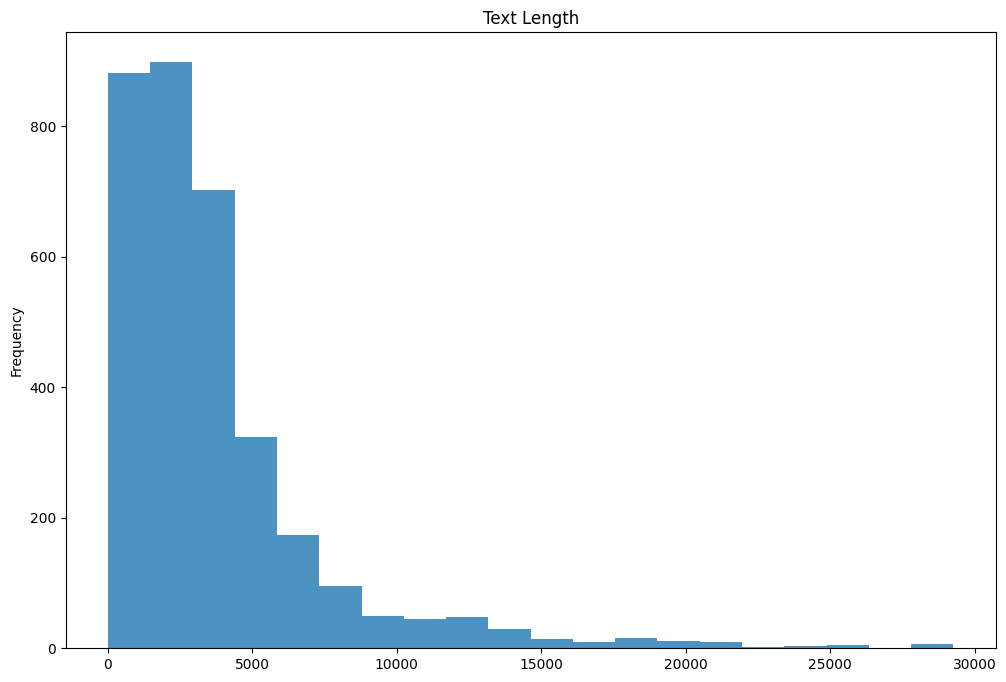

In [38]:
plt.figure(figsize=(12, 8))
ax = dups_s[dups_s['len'] < 30000] ['len'].plot.hist(bins=20, alpha=0.8)
ax.set_title('Text Length')
plt.show()

0.23134578392380478


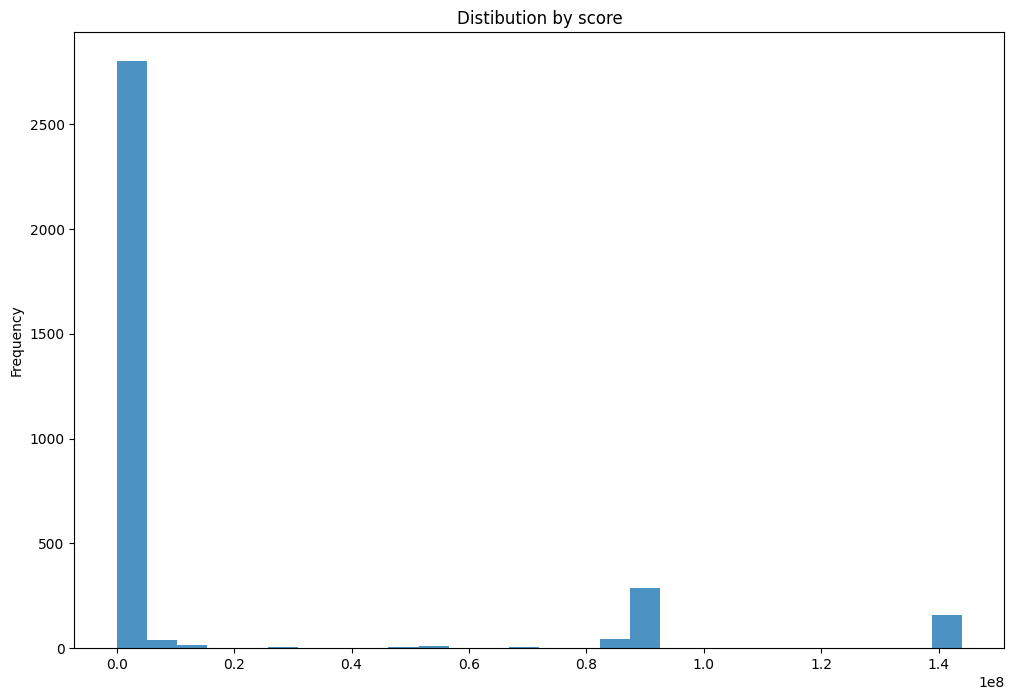

In [39]:
print(dups_s[score_column_name].min())
plt.figure(figsize=(12, 8))
ax = dups_s[score_column_name].plot.hist(bins=28, alpha=0.8)
ax.set_title('Distibution by score')
plt.show()

In [40]:

dups_s['valid'] = True

print("excluding too long docs")
for i, row in dups_s.iterrows():   
    if row['len'] > 30000:
        print ('excluding', row[0], row['subject'], row['len'])
        dups_s.at[i, 'valid'] = False  
        
dups_s = dups_s[dups_s['valid'] == True]

print("excluding docs with rare subj")
cnts = dups_s ['subject'].value_counts()
for i, row in dups_s.iterrows():   
    if not pd.isna(row['subject']):
        if cnts[row['subject']] < 4:
            print ('excluding', row[0], row['subject'])
            dups_s.at[i, 'valid'] = False

dups_s = dups_s[dups_s['valid'] == True]  

excluding too long docs
excluding db GeneralContract 31110.0
excluding file GeneralContract 31090.0
excluding db GeneralContract 38360.0
excluding db GeneralContract 49040.0
excluding db GeneralContract 41250.0
excluding db GeneralContract 39310.0
excluding db GeneralContract 39000.0
excluding db GeneralContract 43930.0
excluding db GeneralContract 31170.0
excluding db Service 32720.0
excluding db Service 35710.0
excluding db GeneralContract 31090.0
excluding db Service 49340.0
excluding db Service 30250.0
excluding db Service 142690.0
excluding db nan 31090.0
excluding file Service 39860.0
excluding db Loans 35800.0
excluding db Other 31080.0
excluding db Service 35880.0
excluding db Other 39750.0
excluding db DealIntellectualProperty 35560.0
excluding db Other 36550.0
excluding db Other 76040.0
excluding db Other 107860.0
excluding db Other 31320.0
excluding db Other 45990.0
excluding db Other 46050.0
excluding db Other 30700.0
excluding db Other 65650.0
excluding db Other 35560.0
ex

Service                              1501
Other                                 607
Deal                                  344
Renting                               125
GeneralContract                       120
Loans                                 103
AgencyContract                         71
DealIntellectualProperty               64
Charity                                50
Insurance                              47
RealEstate                             31
RealEstateTransactions                 16
BankGuarantees                         12
PledgeEncumbrance                      12
ParticipationInOtherOrganizations      12
SecuritiesTransactions                  7
AssetTransactions                       4
Name: subject, dtype: int64


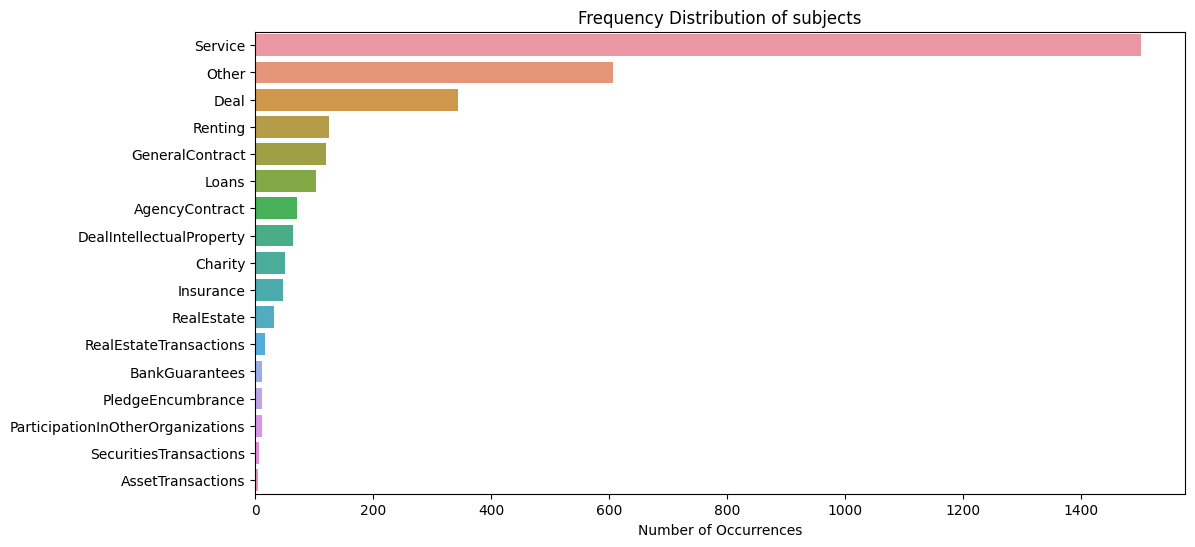

In [41]:
%matplotlib inline

cnt = dups_s['subject'].value_counts()

plt.figure(figsize=(12, 6 ))
sns.barplot(x=cnt.values, y=cnt.index)

print(  cnt )

plt.title('Frequency Distribution of subjects')
plt.xlabel('Number of Occurrences')
plt.show()


In [42]:
dups_s.index.name = '_id'
dups_s.to_csv(Path(work_dir) / 'contract_trainset_meta.csv', index=True)


_s = f"### {len(dups_s)} - Всего новых документов в обучающем наборе на {lastdate}"
display(Markdown(_s))


dups_s

### 3315 - Всего новых документов в обучающем наборе на 2023-01-27 09:19:44.459000+00:00

source                          checksum  version  \
_id                                                                          
6391b4771864c6df4d29f332     db  22f701119d81787cd423f79f0f9fd9db  22.12.7   
633ea99b9d08c565cfa1231e     db  e88212da6eb7e31a30a6fea422bc58dc    3.0.0   
6346a561172785f510f15e2a     db  1439eb4d76211bd57182395091226d86    3.0.0   
6285f9c04d1bfe5e5b297ddd     db  61cfee32867b371843d1e95a194ea2a6    3.0.0   
5ec2b8da665f7603e03b1255     db  3187bfac60ea578221c5d9357756c6c1    1.6.5   
...                         ...                               ...      ...   
5fe48219b770574a005555f2     db  cec3b156da799060479cc421bc5e7bb7   2.3.13   
5fb376e8d8c9df1ed123739d     db  c0519aea6021eb50196a49e8a55d9b4e    2.5.3   
5fb3d4a078df3635f5441c43     db  f1a10629769291d82a65656bcce8f5b7    2.4.4   
5fb6750733c72547b75500ac     db  738e261b4c961df084a6fe3002c324dd    2.4.4   
5fb279b4d8c9df1ed1236dd0     db  8276d0b8d973fa3eeebe6e6a6ca9e170    2.4.4   

                                               export_date     len  \
_id                                                                  
6391b4771864c6df4d29f332  2022-12-11 06:49:28.432113+00:00  1990.0   
633ea99b9d08c565cfa1231e  2022-12-10 06:23:46.837617+00:00  6730.0   
6346a561172785f510f15e2a  2022-12-10 06:23:47.793876+00:00  6920.0   
6285f9c04d1bfe5e5b297ddd  2022-12-10 06:20:32.397698+00:00  5550.0   
5ec2b8da665f7603e03b1255  2022-12-11 06:49:05.545685+00:00  5840.0   
...                                                    ...     ...   
5fe48219b770574a005555f2  2022-12-10 06:15:43.269157+00:00   220.0   
5fb376e8d8c9df1ed123739d  2022-12-10 06:20:19.824645+00:00    60.0   
5fb3d4a078df3635f5441c43  2022-12-10 06:19:39.077744+00:00  2510.0   
5fb6750733c72547b75500ac  2022-12-10 06:19:41.198859+00:00  1140.0   
5fb279b4d8c9df1ed1236dd0  2022-12-10 06:19:37.876030+00:00  2590.0   

                                             analyze_date         value  \
_id                                                                       
6391b4771864c6df4d29f332 2022-12-08 22:25:50.608000+00:00  1.000000e+11   
633ea99b9d08c565cfa1231e 2022-10-06 13:10:52.969000+00:00  5.000000e+10   
6346a561172785f510f15e2a 2022-10-12 14:31:24.479000+00:00  1.000000e+09   
6285f9c04d1bfe5e5b297ddd 2022-05-19 11:03:36.611000+00:00  1.000000e+11   
5ec2b8da665f7603e03b1255 2020-05-18 17:16:38.114000+00:00  2.523632e+07   
...                                                   ...           ...   
5fe48219b770574a005555f2 2020-12-24 15:06:58.721000+00:00           NaN   
5fb376e8d8c9df1ed123739d 2021-10-28 15:57:36.818000+00:00           NaN   
5fb3d4a078df3635f5441c43 2021-07-23 10:54:58.490000+00:00           NaN   
5fb6750733c72547b75500ac 2021-07-28 18:15:01.263000+00:00           NaN   
5fb279b4d8c9df1ed1236dd0 2021-07-23 10:23:07.228000+00:00           NaN   

                          value_log1p  value_span currency  ...  \
_id                                                         ...   
6391b4771864c6df4d29f332    25.328436       483.0      RUB  ...   
633ea99b9d08c565cfa1231e    24.635289       401.0      RUB  ...   
6346a561172785f510f15e2a    20.723266      1922.0      RUB  ...   
6285f9c04d1bfe5e5b297ddd    25.328436      1505.0      NaN  ...   
5ec2b8da665f7603e03b1255    17.043795      5674.0      BRL  ...   
...                               ...         ...      ...  ...   
5fe48219b770574a005555f2          NaN         NaN      NaN  ...   
5fb376e8d8c9df1ed123739d          NaN         NaN      NaN  ...   
5fb3d4a078df3635f5441c43          NaN         NaN      NaN  ...   
5fb6750733c72547b75500ac          NaN         NaN      NaN  ...   
5fb279b4d8c9df1ed1236dd0          NaN         NaN      NaN  ...   

                         subject confidence             user_correction_date  \
_id                                                                            
6391b4771864c6df4d29f332                1.0 2022-12-08 19:31:22.257000+00:00   
633ea99b9d0

In [43]:
dups_s[dups_s['unseen']].to_csv(Path(work_dir) / 'contract_trainset_meta.to_markup.csv', index=True)

In [44]:
dups_s[dups_s['unseen']]

source                          checksum   version  \
_id                                                                           
5ec2b8d8665f7603e03b121a     db  74a7be7f14b129ce379aaa0920978a71     1.6.5   
63c506dce2456d59975e145c     db  88a0bf0e851b84960702680c7972f090  23.01.04   
63c506ace2456d59975e0f9f     db  2ff69a29f2a6f16826a6e68dc6cc1d22  23.01.04   
5efe924d777d4b67a92d55b0   file  c056d218b8ae1d56747afd23ac3cf10f     2.0.0   
63c506c8e2456d59975e125c     db  8b9cc038759514b95b5c84b242ca539f  23.01.04   
...                         ...                               ...       ...   
5fe48219b770574a005555f2     db  cec3b156da799060479cc421bc5e7bb7    2.3.13   
5fb376e8d8c9df1ed123739d     db  c0519aea6021eb50196a49e8a55d9b4e     2.5.3   
5fb3d4a078df3635f5441c43     db  f1a10629769291d82a65656bcce8f5b7     2.4.4   
5fb6750733c72547b75500ac     db  738e261b4c961df084a6fe3002c324dd     2.4.4   
5fb279b4d8c9df1ed1236dd0     db  8276d0b8d973fa3eeebe6e6a6ca9e170     2.4.4   

                                               export_date      len  \
_id                                                                   
5ec2b8d8665f7603e03b121a  2022-12-10 06:13:26.713676+00:00    550.0   
63c506dce2456d59975e145c  2023-01-25 19:04:42.725762+00:00   3630.0   
63c506ace2456d59975e0f9f  2023-01-25 19:04:49.125935+00:00    430.0   
5efe924d777d4b67a92d55b0        2023-01-27 11:02:51.106870  17580.0   
63c506c8e2456d59975e125c  2023-01-25 19:04:34.198378+00:00   1740.0   
...                                                    ...      ...   
5fe48219b770574a005555f2  2022-12-10 06:15:43.269157+00:00    220.0   
5fb376e8d8c9df1ed123739d  2022-12-10 06:20:19.824645+00:00     60.0   
5fb3d4a078df3635f5441c43  2022-12-10 06:19:39.077744+00:00   2510.0   
5fb6750733c72547b75500ac  2022-12-10 06:19:41.198859+00:00   1140.0   
5fb279b4d8c9df1ed1236dd0  2022-12-10 06:19:37.876030+00:00   2590.0   

                                             analyze_date         value  \
_id                                                                       
5ec2b8d8665f7603e03b121a 2020-05-18 16:35:16.047000+00:00  4.900000e+05   
63c506dce2456d59975e145c 2023-01-16 14:15:20.502000+00:00  4.000000e+06   
63c506ace2456d59975e0f9f 2023-01-16 14:43:58.035000+00:00  5.500000e+07   
5efe924d777d4b67a92d55b0 2020-07-03 12:29:32.528000+00:00  1.865870e+08   
63c506c8e2456d59975e125c 2023-01-16 13:32:51.323000+00:00  3.950235e+07   
...                                                   ...           ...   
5fe48219b770574a005555f2 2020-12-24 15:06:58.721000+00:00           NaN   
5fb376e8d8c9df1ed123739d 2021-10-28 15:57:36.818000+00:00           NaN   
5fb3d4a078df3635f5441c43 2021-07-23 10:54:58.490000+00:00           NaN   
5fb6750733c72547b75500ac 2021-07-28 18:15:01.263000+00:00           NaN   
5fb279b4d8c9df1ed1236dd0 2021-07-23 10:23:07.228000+00:00           NaN   

                          value_log1p  value_span currency  ...  \
_id                                                         ...   
5ec2b8d8665f7603e03b121a    13.102163       114.0      RUB  ...   
63c506dce2456d59975e145c    15.201805       326.0      RUB  ...   
63c506ace2456d59975e0f9f    17.822844       172.0      RUB  ...   
5efe924d777d4b67a92d55b0    19.044408      2372.0      RUB  ...   
63c506c8e2456d59975e125c    17.491871       440.0      RUB  ...   
...                               ...         ...      ...  ...   
5fe48219b770574a005555f2          NaN         NaN      NaN  ...   
5fb376e8d8c9df1ed123739d          NaN         NaN      NaN  ...   
5fb3d4a078df3635f5441c43          NaN         NaN      NaN  ...   
5fb6750733c72547b75500ac          NaN         NaN      NaN  ...   
5fb279b4d8c9df1ed1236dd0          NaN         NaN      NaN  ...   

                         subject confidence user_correction_date valid  \
_id                                                                      
5ec2b8d8665f7603e03b121a           0.744503                  NaT  True   
63c

# Make datapoints

In [45]:
work_dir

PosixPath('/root/artem/work')

In [46]:
from analyser.headers_detector import get_tokens_features
from tf_support.embedder_elmo import ElmoEmbedder
from analyser.legal_docs import embedd_tokens
import os

embedder = ElmoEmbedder.get_instance('elmo')  # lazy init

def _dp_fn(doc_id, suffix):
    return os.path.join(work_dir, 'datasets', f'{doc_id}-datapoint-{suffix}.npy')


def save_contract_data_arrays(db_json_doc: DbJsonDoc):
    # TODO: trim long documens according to contract parser

    id_ = db_json_doc.get_id()

    tokens_map: TextMap = db_json_doc.get_tokens_for_embedding()

    # 1) EMBEDDINGS
    print(len(tokens_map))
    embeddings = embedd_tokens(tokens_map,
                               embedder,
                               log_key=f'id={id_} chs={tokens_map.get_checksum()}')

    # 2) TOKEN FEATURES
    token_features: DataFrame = get_tokens_features(db_json_doc.get_tokens_map_unchaged().tokens)

    # 3) SEMANTIC MAP
    semantic_map: DataFrame = get_semantic_map_new(db_json_doc)
    #####
 
    np.save(_dp_fn(id_, 'token_features'), token_features)
    np.save(_dp_fn(id_, 'semantic_map'), semantic_map)
    _embeddings_file = _dp_fn(id_, 'embeddings')
    np.save(_embeddings_file, embeddings)
    print(f'embeddings saved to {_embeddings_file} {embeddings.shape}')

In [47]:
_docs_ids = [str(i) for i in new_docs_ids]
intersection_set = set.intersection(set(list(dups_s.index)), set(_docs_ids)) 
len(intersection_set)
# intersection_set

2

### Trainset fixtures
#### Invalidate long subjects

In [48]:
ids = list(dups_s.index)


ids_of_long_subject_docs=[]

for k, oid in enumerate(ids):
    iiid= ObjectId(oid)
    src = dups_s.loc[oid]['source']
    jd = None
    if src == 'db':
#       if False:
        d = get_doc_by_id(iiid)
        if d is not None:
            jd = DbJsonDoc(d)
            
            if jd.state not in [15,12]:
                print(jd.state, iiid)
            
            stats.at[oid, 'documentType'] = jd.documentType
            dups_s.at[oid, 'documentType'] = jd.documentType
            
            attr_tree = jd.get_attributes_tree()  
            span = attr_tree.get('subject', {}).get('span',[0,0])
            subject_len = span[1]-span[0]
            if span[0]==0:
                stats.at[oid, 'valid'] = False
                dups_s.at[oid, 'valid'] = False
                
            if subject_len >= 200:
                
                stats.at[oid, 'valid'] = False
                dups_s.at[oid, 'valid'] = False
                
                stats.at[oid, 'subj_len'] = subject_len
                dups_s.at[oid, 'subj_len'] = subject_len
                
                ids_of_long_subject_docs.append(oid)
                
                tm = jd.get_tokens_map_unchaged()
                quote = tm.text_range(span)
                print(k, iiid, span, span[1]-span[0])
#                 print('-'*100)
                sentence_span = tm.sentence_at_index(span[0])
                quote2 = tm.text_range(sentence_span)
                print(quote2[:50])
                print('='*100)
stats[stats['documentType']=='CONTRACT']

dups_s.to_csv(Path(work_dir) / 'contract_trainset_meta.csv', index=True)

/root/artem/analyser/integration/db.py:13: UserWarning: MongoDB : define GPN_DB_NAME environment variable! defaulting to gpn
  warnings.warn(msg)


2914 63ce4ac2e83d1ee490f3fcf9 [0, 200] 200
Приложение 1 47 Ведомость трубопроводов

2955 63ce4a88e83d1ee490f3fa61 [0, 200] 200
Приложение № 2 к контракту ДП_76305_52107_32910 /1
2956 63ce49f9e83d1ee490f3f23d [0, 200] 200
Приложение № 5

2960 63ce4a10e83d1ee490f3f3a7 [0, 200] 200
Приложение № 1 к Приложению № 2 от 06-08-2019 год 
2976 63ce4ab4e83d1ee490f3fc23 [0, 200] 200
Приложение Confidential - BASF FCC Technical Servi
2981 63ce4b0ee83d1ee490f400c7 [0, 200] 200
Приложение № 4 от 09-07-2018 к Приложению № 1 от 0
2996 63ce4a8de83d1ee490f3fa66 [0, 200] 200
Приложение № 2 К Контракту № ДП_76305_52107_323327
3014 63ce4a46e83d1ee490f3f641 [0, 200] 200
Приложение № 3 к заданию на проектирование Договор
3031 63ce4a55e83d1ee490f3f77a [87, 287] 200
2.1. Наработка промышленной партии катализатора ол
3037 63ce4b05e83d1ee490f40052 [0, 200] 200
ПРИЛОЖЕНИЕ № С к Договору ЫаДА. 763058229033266 От
3079 63ce4aa6e83d1ee490f3fb76 [0, 200] 200
Приложение № 1 к Приложению № 4 от 30-11-2018 год 
3103 63ce4

#### Fix missing headers

In [85]:
from analyser.legal_docs import LegalDocument, PARAGRAPH_DELIMITER, GenericDocument, Paragraph
from analyser.ml_tools import SemanticTag
from integration.word_document_parser import join_paragraphs


def save_analysis(db_document: DbJsonDoc, doc_dummie: LegalDocument) -> DbJsonDoc:
  documents_collection = get_mongodb_connection()['documents']
  
  _analyse_json_obj: dict = doc_dummie.to_json_obj()
  print("--analyse_json_obj['headers'] len=", len(_analyse_json_obj['headers']))

#   to_save = db_document.as_dict()
#   to_save['headers'] = _analyse_json_obj['headers']

  documents_collection.update_one({'_id': doc_dummie.get_id()}, {'$set': {'analysis.headers': _analyse_json_obj['headers']}})
 
    
  print("updated", doc_dummie.get_id())


def restore_headers (response, oid) :
  doc = join_paragraphs(response, oid)
  return doc
   

for k, oid in enumerate(ids):
    iiid= ObjectId(oid)
    src = dups_s.loc[oid]['source']
    jd = None
    if src == 'db':
#       if False:
        d = get_doc_by_id(iiid)
        if d is not None:
            jd = DbJsonDoc(d)
            
            if jd.state in [15,12]:
                if len(jd.analysis.get('headers', [])) > 0:
                    #  all is ok
#                     print(oid)
                    pass
                else:
                     doc_with_paragraphs = restore_headers(jd.parse, iiid)
                     save_analysis(jd,  doc_with_paragraphs)
                     print ('--', k, oid, len(doc_with_paragraphs.paragraphs))


--analyse_json_obj['headers'] len= 22
updated 6340244c9d08c565cfa12341
-- 9 6340244c9d08c565cfa12341 22
--analyse_json_obj['headers'] len= 21
updated 63908ca4a1bded13e629f2eb
-- 12 63908ca4a1bded13e629f2eb 21
--analyse_json_obj['headers'] len= 31
updated 636dfd1473925c8dae26f910
-- 15 636dfd1473925c8dae26f910 31
--analyse_json_obj['headers'] len= 15
updated 636d031e73925c8dae26f90e
-- 16 636d031e73925c8dae26f90e 15
--analyse_json_obj['headers'] len= 8
updated 634515c4172785f510f15e05
-- 18 634515c4172785f510f15e05 8
--analyse_json_obj['headers'] len= 32
updated 638085746a07f3e980b2c25b
-- 21 638085746a07f3e980b2c25b 32
--analyse_json_obj['headers'] len= 20
updated 63908ca3a1bded13e629f2de
-- 22 63908ca3a1bded13e629f2de 20
--analyse_json_obj['headers'] len= 19
updated 60002ae0b08473039387bcf4
-- 23 60002ae0b08473039387bcf4 19
--analyse_json_obj['headers'] len= 19
updated 5fe34f64b770574a005553f2
-- 24 5fe34f64b770574a005553f2 19
--analyse_json_obj['headers'] len= 8
updated 63c92b5cfb213

In [86]:
len(ids_of_long_subject_docs)

15

In [50]:
dups_s

source                          checksum  version  \
_id                                                                          
6391b4771864c6df4d29f332     db  22f701119d81787cd423f79f0f9fd9db  22.12.7   
6346a561172785f510f15e2a     db  1439eb4d76211bd57182395091226d86    3.0.0   
6285f9c04d1bfe5e5b297ddd     db  61cfee32867b371843d1e95a194ea2a6    3.0.0   
5ec2b8da665f7603e03b1255     db  3187bfac60ea578221c5d9357756c6c1    1.6.5   
633ea99b9d08c565cfa1231e     db  e88212da6eb7e31a30a6fea422bc58dc    3.0.0   
...                         ...                               ...      ...   
5fb3b9a700881c332b56742b     db  2d0675a459440a26e9e2e65a66ab911f    2.4.4   
5fb399df39d5e82e908184ad     db  053f12d0caa705c11e431f2b3559fa80   2.3.14   
60890e6294a1f9b4c8a713fd     db  c0f8197a972e9132e8d2df65ed6c5453   2.3.14   
5fb6750f33c72547b7550168     db  fa805030544e76557066f195e3a5e131    2.4.4   
5fb3b97e00881c332b5672b1     db  e01c79543ff7967771c940416f8063c9    2.4.4   

                                               export_date     len  \
_id                                                                  
6391b4771864c6df4d29f332  2022-12-11 06:49:28.432113+00:00  1990.0   
6346a561172785f510f15e2a  2022-12-10 06:23:47.793876+00:00  6920.0   
6285f9c04d1bfe5e5b297ddd  2022-12-10 06:20:32.397698+00:00  5550.0   
5ec2b8da665f7603e03b1255  2022-12-11 06:49:05.545685+00:00  5840.0   
633ea99b9d08c565cfa1231e  2022-12-10 06:23:46.837617+00:00  6730.0   
...                                                    ...     ...   
5fb3b9a700881c332b56742b  2022-12-10 06:19:49.782018+00:00  1030.0   
5fb399df39d5e82e908184ad  2022-12-10 06:19:20.306128+00:00  7890.0   
60890e6294a1f9b4c8a713fd  2022-12-10 06:19:35.604727+00:00   270.0   
5fb6750f33c72547b7550168  2022-12-10 06:19:43.029943+00:00  9460.0   
5fb3b97e00881c332b5672b1  2022-12-10 06:19:44.455395+00:00    50.0   

                                             analyze_date         value  \
_id                                                                       
6391b4771864c6df4d29f332 2022-12-08 22:25:50.608000+00:00  1.000000e+11   
6346a561172785f510f15e2a 2022-10-12 14:31:24.479000+00:00  1.000000e+09   
6285f9c04d1bfe5e5b297ddd 2022-05-19 11:03:36.611000+00:00  1.000000e+11   
5ec2b8da665f7603e03b1255 2020-05-18 17:16:38.114000+00:00  2.523632e+07   
633ea99b9d08c565cfa1231e 2022-10-06 13:10:52.969000+00:00  5.000000e+10   
...                                                   ...           ...   
5fb3b9a700881c332b56742b 2021-07-30 15:46:11.694000+00:00           NaN   
5fb399df39d5e82e908184ad 2021-04-21 16:54:55.526000+00:00           NaN   
60890e6294a1f9b4c8a713fd 2021-04-28 10:30:30.174000+00:00           NaN   
5fb6750f33c72547b7550168 2021-07-28 18:21:19.659000+00:00           NaN   
5fb3b97e00881c332b5672b1 2021-07-30 15:13:25.800000+00:00           NaN   

                          value_log1p  value_span currency  ...  \
_id                                                         ...   
6391b4771864c6df4d29f332    25.328436       483.0      RUB  ...   
6346a561172785f510f15e2a    20.723266      1922.0      RUB  ...   
6285f9c04d1bfe5e5b297ddd    25.328436      1505.0      NaN  ...   
5ec2b8da665f7603e03b1255    17.043795      5674.0      BRL  ...   
633ea99b9d08c565cfa1231e    24.635289       401.0      RUB  ...   
...                               ...         ...      ...  ...   
5fb3b9a700881c332b56742b          NaN         NaN      NaN  ...   
5fb399df39d5e82e908184ad          NaN         NaN      NaN  ...   
60890e6294a1f9b4c8a713fd          NaN         NaN      NaN  ...   
5fb6750f33c72547b7550168          NaN         NaN      NaN  ...   
5fb3b97e00881c332b5672b1          NaN         NaN      NaN  ...   

                         subject confidence             user_correction_date  \
_id                                                                            
6391b4771864c6df4d29f332                1.0 2022-12-08 19:31:22.257000+00:00   
6346a561172

In [51]:
stats.to_csv(export_fn, index=True)

In [52]:


for k, oid in enumerate(ids):
    iiid= ObjectId(oid)
    src = dups_s.loc[oid]['source']
    jd = None
    if src == 'db':
#       if False:
        d = get_doc_by_id(iiid)
        if d is not None:
          jd = DbJsonDoc(d)
    else:
#         if False:
        print(oid, k, 'of', len(ids), src)
        jd = files_dict[iiid]
        
    print(oid, k, 'of', len(ids), src)

    if jd is not None:
        if jd.state in [15,12]:                
            save_contract_data_arrays(jd)


/root/artem/analyser/integration/db.py:13: UserWarning: MongoDB : define GPN_DB_NAME environment variable! defaulting to gpn
  warnings.warn(msg)


6391b4771864c6df4d29f332 0 of 3960 db
1990
embeddings saved to /root/artem/work/datasets/6391b4771864c6df4d29f332-datapoint-embeddings.npy (1990, 1024)
6346a561172785f510f15e2a 1 of 3960 db
6920
embeddings saved to /root/artem/work/datasets/6346a561172785f510f15e2a-datapoint-embeddings.npy (6920, 1024)
6285f9c04d1bfe5e5b297ddd 2 of 3960 db
5556
embeddings saved to /root/artem/work/datasets/6285f9c04d1bfe5e5b297ddd-datapoint-embeddings.npy (5556, 1024)
5ec2b8da665f7603e03b1255 3 of 3960 db
5847
embeddings saved to /root/artem/work/datasets/5ec2b8da665f7603e03b1255-datapoint-embeddings.npy (5847, 1024)
633ea99b9d08c565cfa1231e 4 of 3960 db
6731
embeddings saved to /root/artem/work/datasets/633ea99b9d08c565cfa1231e-datapoint-embeddings.npy (6731, 1024)
62d149484ae369b4976e3203 5 of 3960 db
5351
embeddings saved to /root/artem/work/datasets/62d149484ae369b4976e3203-datapoint-embeddings.npy (5351, 1024)
5edbc62eda3678279fbcadf3 6 of 3960 file
5edbc62eda3678279fbcadf3 6 of 3960 file
1373
emb

ERROR - 2023-01-27 09:25:48,435 - retrain_ipynb - 'type'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'type'
ERROR - 2023-01-27 09:25:48,436 - retrain_ipynb - list index out of range
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
IndexError: list index out of range
ERROR - 2023-01-27 09:25:48,436 - retrain_ipynb - list index out of range
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
IndexError: list index out of range
ERROR - 2023-01-27 09:25:48,436 - retrain_ipynb - list index out of range
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-

ERROR (sp) 'type' 1 org-type type
{
    "alias": {
        "confidence": 0.9308513402938843,
        "kind": "org-alias",
        "span": [
            46,
            47
        ],
        "span_map": "words",
        "value": "\u041a\u0440\u0435\u0434\u0438\u0442\u043e\u0440"
    },
    "is_known_subsidiary": true,
    "name": {
        "confidence": 0.7091587781906128,
        "kind": "org-name",
        "span": [
            82,
            84
        ],
        "span_map": "words",
        "value": "\u0413\u0430\u0437\u043f\u0440\u043e\u043c \u043d\u0435\u0444\u0442\u044c"
    }
}
ERROR 1 org-type 633eca889d08c565cfa12324 'type' [{'name': {'confidence': 0.7091587781906128, 'value': 'Газпром нефть', 'kind': 'org-name', 'span': [82, 84], 'span_map': 'words'}, 'alias': {'confidence': 0.9308513402938843, 'value': 'Кредитор', 'kind': 'org-alias', 'span': [46, 47], 'span_map': 'words'}, 'is_known_subsidiary': True}]
ERROR (sp) list index out of range 2 org-name name
ERROR 2 org-name 633

ERROR - 2023-01-27 09:25:49,691 - retrain_ipynb - 'type'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'type'
ERROR - 2023-01-27 09:25:49,828 - retrain_ipynb - 'type'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'type'


embeddings saved to /root/artem/work/datasets/634515c4172785f510f15e05-datapoint-embeddings.npy (2238, 1024)
5fbbbd1ca2b4551c06107a5f 20 of 3960 db
3105
ERROR (sp) 'type' 2 org-type type
{
    "alias": {
        "changed": true,
        "confidence": 1,
        "key": "org-2-alias",
        "kind": "org-2-alias",
        "parent": "",
        "span": [
            105,
            109
        ],
        "span_map": "words",
        "value": "\u0433\u043b\u0430\u0432\u043d\u044b\u0439 \u0440\u0430\u0441\u043f\u043e\u0440\u044f\u0434\u0438\u0442\u0435\u043b\u044c \u0431\u044e\u0434\u0436\u0435\u0442\u043d\u044b\u0445 \u0441\u0440\u0435\u0434\u0441\u0442\u0432"
    },
    "name": {
        "changed": true,
        "confidence": 1,
        "key": "org-2-name",
        "kind": "org-2-name",
        "parent": "",
        "span": [
            35,
            41
        ],
        "span_map": "words",
        "value": "\u0414\u0435\u043f\u0430\u0440\u0442\u0430\u043c\u0435\u043d\u0442 \u0432\

ERROR - 2023-01-27 09:25:51,137 - retrain_ipynb - 'type'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'type'


embeddings saved to /root/artem/work/datasets/62dfbce15d5a202ba67b842d-datapoint-embeddings.npy (5556, 1024)
5edbc65dda3678279fbcae6a 36 of 3960 file
5edbc65dda3678279fbcae6a 36 of 3960 file
2904
ERROR (sp) 'type' 2 org-type type
{
    "alias": {
        "confidence": 0.9410507082939148,
        "span": [
            42,
            43
        ],
        "span_map": "words",
        "value": "\u041e\u0440\u0433\u0430\u043d\u0438\u0437\u0430\u0442\u043e\u0440"
    },
    "name": {
        "confidence": 0,
        "span": [
            27,
            37
        ],
        "span_map": "words",
        "value": "\u041c\u0435\u0436\u0440\u0435\u0433\u0438\u043e\u043d\u0430\u043b\u044c\u043d\u0430\u044f \u0410\u0441\u0441\u043e\u0446\u0438\u0430\u0446\u0438\u044f \u0441\u043e\u0434\u0435\u0439\u0441\u0442\u0432\u0438\u044f \u043e\u0431\u0435\u0441\u043f\u0435\u0447\u0435\u043d\u0438\u044e \u0431\u0435\u0437\u043e\u043f\u0430\u0441\u043d\u044b\u0445 \u0443\u0441\u043b\u043e\u0432\u0438\u0439

ERROR - 2023-01-27 09:25:53,055 - retrain_ipynb - 'type'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'type'
ERROR - 2023-01-27 09:25:53,056 - retrain_ipynb - 'name'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'name'
ERROR - 2023-01-27 09:25:53,057 - retrain_ipynb - 'type'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'type'


embeddings saved to /root/artem/work/datasets/63908ca4a1bded13e629f2e9-datapoint-embeddings.npy (3139, 1024)
633d4fa09d08c565cfa12315 55 of 3960 db
6920
ERROR (sp) 'type' 1 org-type type
{
    "alias": {
        "confidence": 1,
        "key": "org-1-alias",
        "kind": "org-1-alias",
        "span": [
            95,
            96
        ],
        "span_map": "words",
        "value": "\u0417\u0430\u0435\u043c\u0449\u0438\u043a"
    },
    "name": {
        "confidence": 1,
        "key": "org-1-name",
        "kind": "org-1-name",
        "span": [
            82,
            83
        ],
        "span_map": "words",
        "value": "\u0413\u0430\u0437\u043f\u0440\u043e\u043c\u043d\u0435\u0444\u0442\u044c-\u0421\u043d\u0430\u0431\u0436\u0435\u043d\u0438\u0435"
    }
}
ERROR 1 org-type 633d4fa09d08c565cfa12315 'type' [{'name': {'confidence': 1, 'kind': 'org-1-name', 'key': 'org-1-name', 'span': [82, 83], 'span_map': 'words', 'value': 'Газпромнефть-Снабжение'}, 'alias': {'conf

ERROR - 2023-01-27 09:25:54,792 - retrain_ipynb - 'type'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'type'
ERROR - 2023-01-27 09:25:54,793 - retrain_ipynb - 'type'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'type'


embeddings saved to /root/artem/work/datasets/6380859c6a07f3e980b2c5a3-datapoint-embeddings.npy (12078, 1024)
60002adfb08473039387bcae 71 of 3960 db
1511
embeddings saved to /root/artem/work/datasets/60002adfb08473039387bcae-datapoint-embeddings.npy (1511, 1024)
634693cd172785f510f15e23 72 of 3960 db
332
embeddings saved to /root/artem/work/datasets/634693cd172785f510f15e23-datapoint-embeddings.npy (332, 1024)
63468d42172785f510f15e21 73 of 3960 db
2216
ERROR (sp) 'type' 1 org-type type
{
    "alias": {
        "changed": true,
        "confidence": 1,
        "key": "org-1-alias",
        "kind": "org-1-alias",
        "parent": "",
        "span": [
            127,
            128
        ],
        "span_map": "words",
        "value": "\u041f\u043e\u043a\u0443\u043f\u0430\u0442\u0435\u043b\u044c"
    },
    "name": {
        "changed": true,
        "confidence": 1,
        "key": "org-1-name",
        "kind": "org-1-name",
        "parent": "",
        "span": [
            79,
 

[legal_docs.py:609 -        embedd_tokens() ] embedding doc id=5fc7a032c54bc33809e26190 chs=476b76471383cfa6addca66da22bd2aa
[embedder_elmo.py:50 - _build_session_and_graph() ] < loading ELMO module https://storage.googleapis.com/az-nlp/elmo_ru-news_wmt11-16_1.5M_steps.tar.gz
[embedder_elmo.py:51 - _build_session_and_graph() ] TF hub cache dir is  /root/artem/work/tf_cache
INFO:absl:Using /root/artem/work/tf_cache to cache modules.


embeddings saved to /root/artem/work/datasets/5fca2ab09083b679224c7624-datapoint-embeddings.npy (2506, 1024)
5fc7a031c54bc33809e2617f 109 of 3960 db
1574
embeddings saved to /root/artem/work/datasets/5fc7a031c54bc33809e2617f-datapoint-embeddings.npy (1574, 1024)
5fca2aab9083b679224c75e3 110 of 3960 db
1342
embeddings saved to /root/artem/work/datasets/5fca2aab9083b679224c75e3-datapoint-embeddings.npy (1342, 1024)
5fc7a032c54bc33809e26190 111 of 3960 db
1563


[embedder_elmo.py:53 - _build_session_and_graph() ] ELMO module loaded >
INFO:gpn:ELMO module loaded >
[embedder_elmo.py:68 - _build_session_and_graph() ] ELMO: creating embedded_out_elmo
INFO:gpn:ELMO: creating embedded_out_elmo


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore
[embedder_elmo.py:74 - _build_session_and_graph() ] ELMO: embedded_out_defaut embedded_out_elmo
INFO:gpn:ELMO: embedded_out_defaut embedded_out_elmo


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore
2023-01-27 09:26:00.505424: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcuda.so.1
2023-01-27 09:26:01.004309: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-27 09:26:01.004962: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1733] Found device 0 with properties: 
pciBusID: 0000:01:00.0 name: A100-PCIE-40GB computeCapability: 8.0
coreClock: 1.41GHz coreCount: 108 deviceMemorySize: 39.59GiB deviceMemoryBandwidth: 1.41TiB/s
2023-01-27 09:26:01.004986: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0
2023-01-27 09:26:01.005028: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic libra

embeddings saved to /root/artem/work/datasets/5fc7a032c54bc33809e26190-datapoint-embeddings.npy (1563, 1024)
5fe34f62b770574a005553bf 112 of 3960 db
1283
embeddings saved to /root/artem/work/datasets/5fe34f62b770574a005553bf-datapoint-embeddings.npy (1283, 1024)
63908ca4a1bded13e629f2f2 113 of 3960 db
1154
embeddings saved to /root/artem/work/datasets/63908ca4a1bded13e629f2f2-datapoint-embeddings.npy (1154, 1024)
63908ca3a1bded13e629f2da 114 of 3960 db
1444
embeddings saved to /root/artem/work/datasets/63908ca3a1bded13e629f2da-datapoint-embeddings.npy (1444, 1024)
5fbf668c5d05d73d0295fa48 115 of 3960 db
1376
embeddings saved to /root/artem/work/datasets/5fbf668c5d05d73d0295fa48-datapoint-embeddings.npy (1376, 1024)
63908ca4a1bded13e629f2e7 116 of 3960 db
1497
embeddings saved to /root/artem/work/datasets/63908ca4a1bded13e629f2e7-datapoint-embeddings.npy (1497, 1024)
5fc6452a1d0a1603c7a0c9d9 117 of 3960 db
1379


DEBUG:gpn:skipping embedding doc fdd01f7e75d8ad2b1e940aede5c977f4 ...., /root/artem/work/datasets/cache-fdd01f7e75d8ad2b1e940aede5c977f4-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (1384, 1024)
DEBUG:gpn:getting embedding from cache id=5fb278c1d8c9df1ed1236d47 chs=fdd01f7e75d8ad2b1e940aede5c977f4
DEBUG:gpn:skipping embedding doc b60c7649a2b59d48eb3e54a774b24bb6 ...., /root/artem/work/datasets/cache-b60c7649a2b59d48eb3e54a774b24bb6-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (4920, 1024)
DEBUG:gpn:getting embedding from cache id=5fbbe467a2b4551c06107b12 chs=b60c7649a2b59d48eb3e54a774b24bb6
DEBUG:gpn:skipping embedding doc 4ef6c30007f57413ed77fa85746f4c82 ...., /root/artem/work/datasets/cache-4ef6c30007f57413ed77fa85746f4c82-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (1484, 1024)
DEBUG:gpn:getting embedding from cache id=5fc6452a1d0a1603c7a0c9e8 chs=4ef6c30007f57413ed77fa85746f

embeddings saved to /root/artem/work/datasets/5fc6452a1d0a1603c7a0c9d9-datapoint-embeddings.npy (1379, 1024)
5fb278c1d8c9df1ed1236d47 118 of 3960 db
1384
embeddings saved to /root/artem/work/datasets/5fb278c1d8c9df1ed1236d47-datapoint-embeddings.npy (1384, 1024)
5fbbe467a2b4551c06107b12 119 of 3960 db
4920
embeddings saved to /root/artem/work/datasets/5fbbe467a2b4551c06107b12-datapoint-embeddings.npy (4920, 1024)
5fc6452a1d0a1603c7a0c9e8 120 of 3960 db
1484
embeddings saved to /root/artem/work/datasets/5fc6452a1d0a1603c7a0c9e8-datapoint-embeddings.npy (1484, 1024)
5fc5eb6b1d0a1603c7a0c8b2 121 of 3960 db
1484
embeddings saved to /root/artem/work/datasets/5fc5eb6b1d0a1603c7a0c8b2-datapoint-embeddings.npy (1484, 1024)
5edbc60bda3678279fbcadad 122 of 3960 file
5edbc60bda3678279fbcadad 122 of 3960 file


DEBUG:gpn:skipping embedding doc de60fc5faed85612d68de00b016d9d0d ...., /root/artem/work/datasets/cache-de60fc5faed85612d68de00b016d9d0d-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (17500, 1024)
DEBUG:gpn:getting embedding from cache id=5edbc60bda3678279fbcadad chs=de60fc5faed85612d68de00b016d9d0d


17500


DEBUG:gpn:skipping embedding doc ded7326f7330a520c6ae348f65096678 ...., /root/artem/work/datasets/cache-ded7326f7330a520c6ae348f65096678-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (1444, 1024)
DEBUG:gpn:getting embedding from cache id=6336f41d95ac5b767c16ab6a chs=ded7326f7330a520c6ae348f65096678
DEBUG:gpn:skipping embedding doc f83bae256bbebd68695e5975ffaa7ba2 ...., /root/artem/work/datasets/cache-f83bae256bbebd68695e5975ffaa7ba2-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (2676, 1024)
DEBUG:gpn:getting embedding from cache id=6347b28d06011e34b4f15df7 chs=f83bae256bbebd68695e5975ffaa7ba2
DEBUG:gpn:skipping embedding doc 0b361692150fbde2853f2bcdcecd6c7b ...., /root/artem/work/datasets/cache-0b361692150fbde2853f2bcdcecd6c7b-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (2634, 1024)
DEBUG:gpn:getting embedding from cache id=5fb278c1d8c9df1ed1236d5f chs=0b361692150fbde2853f2bcdcecd

embeddings saved to /root/artem/work/datasets/5edbc60bda3678279fbcadad-datapoint-embeddings.npy (17500, 1024)
6336f41d95ac5b767c16ab6a 123 of 3960 db
1444
embeddings saved to /root/artem/work/datasets/6336f41d95ac5b767c16ab6a-datapoint-embeddings.npy (1444, 1024)
6347b28d06011e34b4f15df7 124 of 3960 db
2676
embeddings saved to /root/artem/work/datasets/6347b28d06011e34b4f15df7-datapoint-embeddings.npy (2676, 1024)
5fb278c1d8c9df1ed1236d5f 125 of 3960 db
2634
embeddings saved to /root/artem/work/datasets/5fb278c1d8c9df1ed1236d5f-datapoint-embeddings.npy (2634, 1024)
60defc4e95588e4cfb432c28 126 of 3960 db
2484
embeddings saved to /root/artem/work/datasets/60defc4e95588e4cfb432c28-datapoint-embeddings.npy (2484, 1024)


DEBUG:gpn:skipping embedding doc 8de56217d03541bb61d824317d20671c ...., /root/artem/work/datasets/cache-8de56217d03541bb61d824317d20671c-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (2634, 1024)
DEBUG:gpn:getting embedding from cache id=5fc5eb6b1d0a1603c7a0c8b6 chs=8de56217d03541bb61d824317d20671c
DEBUG:gpn:skipping embedding doc 1f3bf3777d9bf7c8da48eaee6b108b00 ...., /root/artem/work/datasets/cache-1f3bf3777d9bf7c8da48eaee6b108b00-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (413, 1024)
DEBUG:gpn:getting embedding from cache id=634696d0172785f510f15e25 chs=1f3bf3777d9bf7c8da48eaee6b108b00
DEBUG:gpn:skipping embedding doc b4125e9a11aa5ab7f64f8d82cacbcca7 ...., /root/artem/work/datasets/cache-b4125e9a11aa5ab7f64f8d82cacbcca7-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (416, 1024)
DEBUG:gpn:getting embedding from cache id=634018f59d08c565cfa1233d chs=b4125e9a11aa5ab7f64f8d82cacbcc

5fc5eb6b1d0a1603c7a0c8b6 127 of 3960 db
2634
embeddings saved to /root/artem/work/datasets/5fc5eb6b1d0a1603c7a0c8b6-datapoint-embeddings.npy (2634, 1024)
634696d0172785f510f15e25 128 of 3960 db
413
embeddings saved to /root/artem/work/datasets/634696d0172785f510f15e25-datapoint-embeddings.npy (413, 1024)
634018f59d08c565cfa1233d 129 of 3960 db
416
embeddings saved to /root/artem/work/datasets/634018f59d08c565cfa1233d-datapoint-embeddings.npy (416, 1024)
5df79e92200a3f4d0fad7855 130 of 3960 file
5df79e92200a3f4d0fad7855 130 of 3960 file
556
embeddings saved to /root/artem/work/datasets/5df79e92200a3f4d0fad7855-datapoint-embeddings.npy (556, 1024)
5ebaa582665f7603e03b11ab 131 of 3960 db
562
embeddings saved to /root/artem/work/datasets/5ebaa582665f7603e03b11ab-datapoint-embeddings.npy (562, 1024)
613898499c553fc1207fb532 132 of 3960 db
493
embeddings saved to /root/artem/work/datasets/613898499c553fc1207fb532-datapoint-embeddings.npy (493, 1024)
638085a26a07f3e980b2c5fd 133 of 3960 db
45

DEBUG:gpn:skipping embedding doc 78cdeaf637236f64e5ed7f97d78c2a27 ...., /root/artem/work/datasets/cache-78cdeaf637236f64e5ed7f97d78c2a27-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (3267, 1024)
DEBUG:gpn:getting embedding from cache id=5fc635251d0a1603c7a0c93c chs=78cdeaf637236f64e5ed7f97d78c2a27
DEBUG:gpn:skipping embedding doc 4d659e53668a4962c2392944322185e1 ...., /root/artem/work/datasets/cache-4d659e53668a4962c2392944322185e1-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (3174, 1024)
DEBUG:gpn:getting embedding from cache id=5fe34f63b770574a005553c7 chs=4d659e53668a4962c2392944322185e1
DEBUG:gpn:skipping embedding doc daef8c675ccfd37afeb738c4b605031e ...., /root/artem/work/datasets/cache-daef8c675ccfd37afeb738c4b605031e-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (2779, 1024)
DEBUG:gpn:getting embedding from cache id=5fca2aae9083b679224c760c chs=daef8c675ccfd37afeb738c4b605

embeddings saved to /root/artem/work/datasets/638085a26a07f3e980b2c5fd-datapoint-embeddings.npy (4508, 1024)
5fc635251d0a1603c7a0c93c 134 of 3960 db
3267
embeddings saved to /root/artem/work/datasets/5fc635251d0a1603c7a0c93c-datapoint-embeddings.npy (3267, 1024)
5fe34f63b770574a005553c7 135 of 3960 db
3174
embeddings saved to /root/artem/work/datasets/5fe34f63b770574a005553c7-datapoint-embeddings.npy (3174, 1024)
5fca2aae9083b679224c760c 136 of 3960 db
2779
embeddings saved to /root/artem/work/datasets/5fca2aae9083b679224c760c-datapoint-embeddings.npy (2779, 1024)
5ef8a144035e9a6d6a886046 137 of 3960 file
5ef8a144035e9a6d6a886046 137 of 3960 file
761
embeddings saved to /root/artem/work/datasets/5ef8a144035e9a6d6a886046-datapoint-embeddings.npy (761, 1024)
6256844aa45b04eaf98b4155 138 of 3960 db
15713


DEBUG:gpn:skipping embedding doc f113bb88ffcd86fa5d14c4358e63c3c3 ...., /root/artem/work/datasets/cache-f113bb88ffcd86fa5d14c4358e63c3c3-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (15713, 1024)
DEBUG:gpn:getting embedding from cache id=6256844aa45b04eaf98b4155 chs=f113bb88ffcd86fa5d14c4358e63c3c3
DEBUG:gpn:skipping embedding doc 8c38e3acb727723a29e8fcae4ed139d7 ...., /root/artem/work/datasets/cache-8c38e3acb727723a29e8fcae4ed139d7-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (1599, 1024)
DEBUG:gpn:getting embedding from cache id=60002adfb08473039387bcc6 chs=8c38e3acb727723a29e8fcae4ed139d7
DEBUG:gpn:skipping embedding doc dd491ab7a9a7139850c9f946739d70ed ...., /root/artem/work/datasets/cache-dd491ab7a9a7139850c9f946739d70ed-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (1876, 1024)
DEBUG:gpn:getting embedding from cache id=5ec2b8d8665f7603e03b1224 chs=dd491ab7a9a7139850c9f946739

embeddings saved to /root/artem/work/datasets/6256844aa45b04eaf98b4155-datapoint-embeddings.npy (15713, 1024)
60002adfb08473039387bcc6 139 of 3960 db
1599
embeddings saved to /root/artem/work/datasets/60002adfb08473039387bcc6-datapoint-embeddings.npy (1599, 1024)
5ec2b8d8665f7603e03b1224 140 of 3960 db
1876
embeddings saved to /root/artem/work/datasets/5ec2b8d8665f7603e03b1224-datapoint-embeddings.npy (1876, 1024)
5fe34f62b770574a005553be 141 of 3960 db
759
embeddings saved to /root/artem/work/datasets/5fe34f62b770574a005553be-datapoint-embeddings.npy (759, 1024)
6380858a6a07f3e980b2c4aa 142 of 3960 db
7533


ERROR - 2023-01-27 09:26:07,916 - retrain_ipynb - 'type'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'type'
ERROR:retrain_ipynb:'type'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'type'
DEBUG:gpn:skipping embedding doc 99ed114baaaba64b7ec7e7b3958d60fe ...., /root/artem/work/datasets/cache-99ed114baaaba64b7ec7e7b3958d60fe-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (810, 1024)
DEBUG:gpn:getting embedding from cache id=5ec2b8d8665f7603e03b121c chs=99ed114baaaba64b7ec7e7b3958d60fe
DEBUG:gpn:skipping embedding doc 1369dd11c449cc277cb7b383e87072b6 ...., /root/artem/work/datasets/cache-1369dd11c449cc277cb7b383e87072b6-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (8751,

ERROR (sp) 'type' 2 org-type type
{
    "alias": {
        "changed": true,
        "confidence": 1,
        "key": "org-2-alias",
        "kind": "org-2-alias",
        "parent": "",
        "span": [
            80,
            83
        ],
        "span_map": "words",
        "value": "\u0418\u0441\u043f\u043e\u043b\u043d\u0438\u0442\u0435\u043b\u044c \u0438\u043b\u0438 \u041f\u043e\u0434\u0440\u044f\u0434\u0447\u0438\u043a"
    },
    "name": {
        "changed": true,
        "confidence": 1,
        "key": "org-2-name",
        "kind": "org-2-name",
        "parent": "",
        "span": [
            67,
            75
        ],
        "span_map": "words",
        "value": "\u0410\u0441\u0441\u043e\u0446\u0438\u0430\u0446\u0438\u044f \u0431\u0440\u043e\u043a\u0435\u0440\u043e\u0432 \u0438\u043d\u043d\u043e\u0432\u0430\u0446\u0438\u0439 \u0438 \u0442\u0435\u0445\u043d\u043e\u043b\u043e\u0433\u0438\u0439 (\u0410\u0411\u0418\u0422)"
    }
}
ERROR 2 org-type 6380858a6a07f3e980b2c4

DEBUG:gpn:skipping embedding doc a1cf2308a105553797b22dd2230f5884 ...., /root/artem/work/datasets/cache-a1cf2308a105553797b22dd2230f5884-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (1761, 1024)
DEBUG:gpn:getting embedding from cache id=5fbbe46da2b4551c06107c5c chs=a1cf2308a105553797b22dd2230f5884
DEBUG:gpn:skipping embedding doc b3aef4623af3fc634a5e0f7f37c5bd18 ...., /root/artem/work/datasets/cache-b3aef4623af3fc634a5e0f7f37c5bd18-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (2963, 1024)
DEBUG:gpn:getting embedding from cache id=5fca2ab09083b679224c7626 chs=b3aef4623af3fc634a5e0f7f37c5bd18
DEBUG:gpn:skipping embedding doc 33e3b53056dfc2b36756b96634a31ee3 ...., /root/artem/work/datasets/cache-33e3b53056dfc2b36756b96634a31ee3-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (2676, 1024)
DEBUG:gpn:getting embedding from cache id=6393238d1002115a6029f3ea chs=33e3b53056dfc2b36756b96634a3

embeddings saved to /root/artem/work/datasets/638085986a07f3e980b2c579-datapoint-embeddings.npy (8751, 1024)
5fbbe46da2b4551c06107c5c 145 of 3960 db
1761
embeddings saved to /root/artem/work/datasets/5fbbe46da2b4551c06107c5c-datapoint-embeddings.npy (1761, 1024)
5fca2ab09083b679224c7626 146 of 3960 db
2963
embeddings saved to /root/artem/work/datasets/5fca2ab09083b679224c7626-datapoint-embeddings.npy (2963, 1024)
6393238d1002115a6029f3ea 147 of 3960 db
2676
embeddings saved to /root/artem/work/datasets/6393238d1002115a6029f3ea-datapoint-embeddings.npy (2676, 1024)
5fca2aaf9083b679224c7617 148 of 3960 db
2525


DEBUG:gpn:loaded embedding shape is: (2525, 1024)
DEBUG:gpn:getting embedding from cache id=5fca2aaf9083b679224c7617 chs=7c66f193095ab573e16e799316d0feef
DEBUG:gpn:skipping embedding doc 4ff73fbce957e4372d32d4737bf4c649 ...., /root/artem/work/datasets/cache-4ff73fbce957e4372d32d4737bf4c649-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (951, 1024)
DEBUG:gpn:getting embedding from cache id=63c92b5cfb21317f1d5e0f7f chs=4ff73fbce957e4372d32d4737bf4c649
DEBUG:gpn:skipping embedding doc b947d554a5fb2a990c0645742dedbfd1 ...., /root/artem/work/datasets/cache-b947d554a5fb2a990c0645742dedbfd1-embeddings-ElmoEmbedder.npy exists, loading


embeddings saved to /root/artem/work/datasets/5fca2aaf9083b679224c7617-datapoint-embeddings.npy (2525, 1024)
63c92b5cfb21317f1d5e0f7f 149 of 3960 db
951
embeddings saved to /root/artem/work/datasets/63c92b5cfb21317f1d5e0f7f-datapoint-embeddings.npy (951, 1024)
638085946a07f3e980b2c53b 150 of 3960 db
12548


DEBUG:gpn:loaded embedding shape is: (12548, 1024)
DEBUG:gpn:getting embedding from cache id=638085946a07f3e980b2c53b chs=b947d554a5fb2a990c0645742dedbfd1
DEBUG:gpn:skipping embedding doc cc0cb902f798f27b6adbe82f4ff20d97 ...., /root/artem/work/datasets/cache-cc0cb902f798f27b6adbe82f4ff20d97-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (806, 1024)
DEBUG:gpn:getting embedding from cache id=60d1bbffc07bc76a2196cb46 chs=cc0cb902f798f27b6adbe82f4ff20d97
DEBUG:gpn:skipping embedding doc 981456fc222b317c658a30ceb3a1cb1c ...., /root/artem/work/datasets/cache-981456fc222b317c658a30ceb3a1cb1c-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (751, 1024)
DEBUG:gpn:getting embedding from cache id=5ded4e294ddc27bcf92dd6d5 chs=981456fc222b317c658a30ceb3a1cb1c
DEBUG:gpn:skipping embedding doc 35941a03928936588c24d2d727631b68 ...., /root/artem/work/datasets/cache-35941a03928936588c24d2d727631b68-embeddings-ElmoEmbedder.npy exists, load

embeddings saved to /root/artem/work/datasets/638085946a07f3e980b2c53b-datapoint-embeddings.npy (12548, 1024)
60d1bbffc07bc76a2196cb46 151 of 3960 db
806
embeddings saved to /root/artem/work/datasets/60d1bbffc07bc76a2196cb46-datapoint-embeddings.npy (806, 1024)
5ded4e294ddc27bcf92dd6d5 152 of 3960 file
5ded4e294ddc27bcf92dd6d5 152 of 3960 file
751
embeddings saved to /root/artem/work/datasets/5ded4e294ddc27bcf92dd6d5-datapoint-embeddings.npy (751, 1024)
5fb2796dd8c9df1ed1236da0 153 of 3960 db
720
embeddings saved to /root/artem/work/datasets/5fb2796dd8c9df1ed1236da0-datapoint-embeddings.npy (720, 1024)
5f0bb4bd138e9184feef1fac 154 of 3960 file
5f0bb4bd138e9184feef1fac 154 of 3960 file
954
embeddings saved to /root/artem/work/datasets/5f0bb4bd138e9184feef1fac-datapoint-embeddings.npy (954, 1024)
5df8db67fd0198a0617a2883 155 of 3960 file
5df8db67fd0198a0617a2883 155 of 3960 file
2481
embeddings saved to /root/artem/work/datasets/5df8db67fd0198a0617a2883-datapoint-embeddings.npy (2481, 10

DEBUG:gpn:skipping embedding doc e09af22915c7ea1de5d730f25fc520e1 ...., /root/artem/work/datasets/cache-e09af22915c7ea1de5d730f25fc520e1-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (1671, 1024)
DEBUG:gpn:getting embedding from cache id=5fbbbd14a2b4551c061078ef chs=e09af22915c7ea1de5d730f25fc520e1
DEBUG:gpn:skipping embedding doc 365a090b705e12e04f20688dc09cda23 ...., /root/artem/work/datasets/cache-365a090b705e12e04f20688dc09cda23-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (2961, 1024)
DEBUG:gpn:getting embedding from cache id=5ec2b8da665f7603e03b1258 chs=365a090b705e12e04f20688dc09cda23
DEBUG:gpn:skipping embedding doc a3bd7285f7fa43a3e43ba02f48b94f2c ...., /root/artem/work/datasets/cache-a3bd7285f7fa43a3e43ba02f48b94f2c-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (2957, 1024)
DEBUG:gpn:getting embedding from cache id=5ec2b8d9665f7603e03b1250 chs=a3bd7285f7fa43a3e43ba02f48b9

embeddings saved to /root/artem/work/datasets/5e2ea6ca73698e191112bee8-datapoint-embeddings.npy (2470, 1024)
5fbbbd14a2b4551c061078ef 157 of 3960 db
1671
embeddings saved to /root/artem/work/datasets/5fbbbd14a2b4551c061078ef-datapoint-embeddings.npy (1671, 1024)
5ec2b8da665f7603e03b1258 158 of 3960 db
2961
embeddings saved to /root/artem/work/datasets/5ec2b8da665f7603e03b1258-datapoint-embeddings.npy (2961, 1024)
5ec2b8d9665f7603e03b1250 159 of 3960 db
2957
embeddings saved to /root/artem/work/datasets/5ec2b8d9665f7603e03b1250-datapoint-embeddings.npy (2957, 1024)
5df79e92200a3f4d0fad7857 160 of 3960 file
5df79e92200a3f4d0fad7857 160 of 3960 file
1706


DEBUG:gpn:skipping embedding doc 18776702be396d0be04efee0562e66c1 ...., /root/artem/work/datasets/cache-18776702be396d0be04efee0562e66c1-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (1651, 1024)
DEBUG:gpn:getting embedding from cache id=5df8db67fd0198a0617a2888 chs=18776702be396d0be04efee0562e66c1
DEBUG:gpn:skipping embedding doc a74549ff807d986693dc4c8a3db034b3 ...., /root/artem/work/datasets/cache-a74549ff807d986693dc4c8a3db034b3-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (3129, 1024)
DEBUG:gpn:getting embedding from cache id=5fca2ab79083b679224c767d chs=a74549ff807d986693dc4c8a3db034b3
DEBUG:gpn:skipping embedding doc 361639beecaf6b0fe25efae427c43a7e ...., /root/artem/work/datasets/cache-361639beecaf6b0fe25efae427c43a7e-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (1661, 1024)
DEBUG:gpn:getting embedding from cache id=5edbc63bda3678279fbcae30 chs=361639beecaf6b0fe25efae427c4

embeddings saved to /root/artem/work/datasets/5df79e92200a3f4d0fad7857-datapoint-embeddings.npy (1706, 1024)
5df8db67fd0198a0617a2888 161 of 3960 file
5df8db67fd0198a0617a2888 161 of 3960 file
1651
embeddings saved to /root/artem/work/datasets/5df8db67fd0198a0617a2888-datapoint-embeddings.npy (1651, 1024)
5fca2ab79083b679224c767d 162 of 3960 db
3129
embeddings saved to /root/artem/work/datasets/5fca2ab79083b679224c767d-datapoint-embeddings.npy (3129, 1024)
5edbc63bda3678279fbcae30 163 of 3960 file
5edbc63bda3678279fbcae30 163 of 3960 file
1661
embeddings saved to /root/artem/work/datasets/5edbc63bda3678279fbcae30-datapoint-embeddings.npy (1661, 1024)
5ded07184ddc27bcf92dd4f3 164 of 3960 file
5ded07184ddc27bcf92dd4f3 164 of 3960 file
1184
embeddings saved to /root/artem/work/datasets/5ded07184ddc27bcf92dd4f3-datapoint-embeddings.npy (1184, 1024)
5e58df7823869ee43538823b 165 of 3960 file
5e58df7823869ee43538823b 165 of 3960 file
2471


DEBUG:gpn:skipping embedding doc dbd175f4a373b5a1141a7ae959c25b8e ...., /root/artem/work/datasets/cache-dbd175f4a373b5a1141a7ae959c25b8e-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (4171, 1024)
DEBUG:gpn:getting embedding from cache id=5fbbe46da2b4551c06107c95 chs=dbd175f4a373b5a1141a7ae959c25b8e
DEBUG:gpn:skipping embedding doc a840feaf68be7db5ebff33a1bb2e9740 ...., /root/artem/work/datasets/cache-a840feaf68be7db5ebff33a1bb2e9740-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (7865, 1024)
DEBUG:gpn:getting embedding from cache id=5fca2ac49083b679224c7745 chs=a840feaf68be7db5ebff33a1bb2e9740


embeddings saved to /root/artem/work/datasets/5e58df7823869ee43538823b-datapoint-embeddings.npy (2471, 1024)
5fbbe46da2b4551c06107c95 166 of 3960 db
4171
embeddings saved to /root/artem/work/datasets/5fbbe46da2b4551c06107c95-datapoint-embeddings.npy (4171, 1024)
5fca2ac49083b679224c7745 167 of 3960 db
7865


DEBUG:gpn:skipping embedding doc 2d4b4b8248032695b7669f491b71c41c ...., /root/artem/work/datasets/cache-2d4b4b8248032695b7669f491b71c41c-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (3415, 1024)
DEBUG:gpn:getting embedding from cache id=5fb27c24d8c9df1ed1236e40 chs=2d4b4b8248032695b7669f491b71c41c
DEBUG:gpn:skipping embedding doc 266d8320dee9a6c3d66afa7a2872b153 ...., /root/artem/work/datasets/cache-266d8320dee9a6c3d66afa7a2872b153-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (1166, 1024)
DEBUG:gpn:getting embedding from cache id=5edbc639da3678279fbcae22 chs=266d8320dee9a6c3d66afa7a2872b153
DEBUG:gpn:skipping embedding doc f76c2bd161ca8c001ee99e0374c5eb47 ...., /root/artem/work/datasets/cache-f76c2bd161ca8c001ee99e0374c5eb47-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (2254, 1024)
DEBUG:gpn:getting embedding from cache id=5fca2ab09083b679224c7635 chs=f76c2bd161ca8c001ee99e0374c5

embeddings saved to /root/artem/work/datasets/5fca2ac49083b679224c7745-datapoint-embeddings.npy (7865, 1024)
5fb27c24d8c9df1ed1236e40 168 of 3960 db
3415
embeddings saved to /root/artem/work/datasets/5fb27c24d8c9df1ed1236e40-datapoint-embeddings.npy (3415, 1024)
5edbc639da3678279fbcae22 169 of 3960 file
5edbc639da3678279fbcae22 169 of 3960 file
1166
embeddings saved to /root/artem/work/datasets/5edbc639da3678279fbcae22-datapoint-embeddings.npy (1166, 1024)
5fca2ab09083b679224c7635 170 of 3960 db
2254
embeddings saved to /root/artem/work/datasets/5fca2ab09083b679224c7635-datapoint-embeddings.npy (2254, 1024)
5fc7a034c54bc33809e261aa 171 of 3960 db
2493


DEBUG:gpn:skipping embedding doc b8f5a9fd7da94d122ac745a639a1bbd8 ...., /root/artem/work/datasets/cache-b8f5a9fd7da94d122ac745a639a1bbd8-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (1362, 1024)
DEBUG:gpn:getting embedding from cache id=635fa418bf4cb23cbb3927dd chs=b8f5a9fd7da94d122ac745a639a1bbd8
DEBUG:gpn:skipping embedding doc 6f2d879b56b1dcad995b240e351b805f ...., /root/artem/work/datasets/cache-6f2d879b56b1dcad995b240e351b805f-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (2479, 1024)
DEBUG:gpn:getting embedding from cache id=5ec2b8da665f7603e03b1262 chs=6f2d879b56b1dcad995b240e351b805f
DEBUG:gpn:skipping embedding doc b5eb15901b7c0fdafcbcc0375ac55bcc ...., /root/artem/work/datasets/cache-b5eb15901b7c0fdafcbcc0375ac55bcc-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (2601, 1024)
DEBUG:gpn:getting embedding from cache id=5fbbe46ca2b4551c06107c15 chs=b5eb15901b7c0fdafcbcc0375ac5

embeddings saved to /root/artem/work/datasets/5fc7a034c54bc33809e261aa-datapoint-embeddings.npy (2493, 1024)
635fa418bf4cb23cbb3927dd 172 of 3960 db
1362
embeddings saved to /root/artem/work/datasets/635fa418bf4cb23cbb3927dd-datapoint-embeddings.npy (1362, 1024)
5ec2b8da665f7603e03b1262 173 of 3960 db
2479
embeddings saved to /root/artem/work/datasets/5ec2b8da665f7603e03b1262-datapoint-embeddings.npy (2479, 1024)
5fbbe46ca2b4551c06107c15 174 of 3960 db
2601
embeddings saved to /root/artem/work/datasets/5fbbe46ca2b4551c06107c15-datapoint-embeddings.npy (2601, 1024)
6380855e6a07f3e980b2c0a4 175 of 3960 db


DEBUG:gpn:skipping embedding doc ed684a94ada5c035b1a90cc6dd67680e ...., /root/artem/work/datasets/cache-ed684a94ada5c035b1a90cc6dd67680e-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (18609, 1024)
DEBUG:gpn:getting embedding from cache id=6380855e6a07f3e980b2c0a4 chs=ed684a94ada5c035b1a90cc6dd67680e


18609


DEBUG:gpn:skipping embedding doc afa467900838e37bddefe693fb1ad637 ...., /root/artem/work/datasets/cache-afa467900838e37bddefe693fb1ad637-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (4574, 1024)
DEBUG:gpn:getting embedding from cache id=5fb674fd33c72547b754ffe3 chs=afa467900838e37bddefe693fb1ad637
DEBUG:gpn:skipping embedding doc d4df449c532614c3046170f1e66c8e5a ...., /root/artem/work/datasets/cache-d4df449c532614c3046170f1e66c8e5a-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (586, 1024)
DEBUG:gpn:getting embedding from cache id=5fb27c60d8c9df1ed1236eb9 chs=d4df449c532614c3046170f1e66c8e5a


embeddings saved to /root/artem/work/datasets/6380855e6a07f3e980b2c0a4-datapoint-embeddings.npy (18609, 1024)
5fb674fd33c72547b754ffe3 176 of 3960 db
4574
embeddings saved to /root/artem/work/datasets/5fb674fd33c72547b754ffe3-datapoint-embeddings.npy (4574, 1024)
5fb27c60d8c9df1ed1236eb9 177 of 3960 db
586
embeddings saved to /root/artem/work/datasets/5fb27c60d8c9df1ed1236eb9-datapoint-embeddings.npy (586, 1024)
5fbbbd1da2b4551c06107a79 178 of 3960 db


DEBUG:gpn:skipping embedding doc 6d7cd280963f89f4ebe54810de862dd9 ...., /root/artem/work/datasets/cache-6d7cd280963f89f4ebe54810de862dd9-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (13475, 1024)
DEBUG:gpn:getting embedding from cache id=5fbbbd1da2b4551c06107a79 chs=6d7cd280963f89f4ebe54810de862dd9
DEBUG:gpn:skipping embedding doc 3a2559c222b85428e390abbec0e10898 ...., /root/artem/work/datasets/cache-3a2559c222b85428e390abbec0e10898-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (2470, 1024)
DEBUG:gpn:getting embedding from cache id=5ec2b8da665f7603e03b1265 chs=3a2559c222b85428e390abbec0e10898


13475
embeddings saved to /root/artem/work/datasets/5fbbbd1da2b4551c06107a79-datapoint-embeddings.npy (13475, 1024)
5ec2b8da665f7603e03b1265 179 of 3960 db
2470


DEBUG:gpn:skipping embedding doc f7ef7e55780b6f6272ecde7e95de0a92 ...., /root/artem/work/datasets/cache-f7ef7e55780b6f6272ecde7e95de0a92-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (636, 1024)
DEBUG:gpn:getting embedding from cache id=633a802234b18f8b69ce5561 chs=f7ef7e55780b6f6272ecde7e95de0a92
DEBUG:gpn:skipping embedding doc db79aaefe222c271bea4bbf8cb806d8d ...., /root/artem/work/datasets/cache-db79aaefe222c271bea4bbf8cb806d8d-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (2159, 1024)
DEBUG:gpn:getting embedding from cache id=5ef8ae16035e9a6d6a8861ac chs=db79aaefe222c271bea4bbf8cb806d8d
DEBUG:gpn:skipping embedding doc 3a037fce49255f3db75d6188a696c719 ...., /root/artem/work/datasets/cache-3a037fce49255f3db75d6188a696c719-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (2563, 1024)
DEBUG:gpn:getting embedding from cache id=5ec2b8da665f7603e03b126e chs=3a037fce49255f3db75d6188a696c

embeddings saved to /root/artem/work/datasets/5ec2b8da665f7603e03b1265-datapoint-embeddings.npy (2470, 1024)
633a802234b18f8b69ce5561 180 of 3960 db
636
embeddings saved to /root/artem/work/datasets/633a802234b18f8b69ce5561-datapoint-embeddings.npy (636, 1024)
5ef8ae16035e9a6d6a8861ac 181 of 3960 file
5ef8ae16035e9a6d6a8861ac 181 of 3960 file
2159
embeddings saved to /root/artem/work/datasets/5ef8ae16035e9a6d6a8861ac-datapoint-embeddings.npy (2159, 1024)
5ec2b8da665f7603e03b126e 182 of 3960 db
2563
embeddings saved to /root/artem/work/datasets/5ec2b8da665f7603e03b126e-datapoint-embeddings.npy (2563, 1024)
5ec2b8d9665f7603e03b1248 183 of 3960 db
706
embeddings saved to /root/artem/work/datasets/5ec2b8d9665f7603e03b1248-datapoint-embeddings.npy (706, 1024)
5ec2b8da665f7603e03b1252 184 of 3960 db
1914
embeddings saved to /root/artem/work/datasets/5ec2b8da665f7603e03b1252-datapoint-embeddings.npy (1914, 1024)
5fc7a030c54bc33809e26179 185 of 3960 db
1582


DEBUG:gpn:skipping embedding doc 5e40e20ed99470af273c01c8c8a28062 ...., /root/artem/work/datasets/cache-5e40e20ed99470af273c01c8c8a28062-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (1582, 1024)
DEBUG:gpn:getting embedding from cache id=5fc7a030c54bc33809e26179 chs=5e40e20ed99470af273c01c8c8a28062
DEBUG:gpn:skipping embedding doc ba66b0c0f4d8ae531d1f63d8ad03a8a3 ...., /root/artem/work/datasets/cache-ba66b0c0f4d8ae531d1f63d8ad03a8a3-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (3403, 1024)
DEBUG:gpn:getting embedding from cache id=5fbbe469a2b4551c06107b60 chs=ba66b0c0f4d8ae531d1f63d8ad03a8a3
DEBUG:gpn:skipping embedding doc 9b8a0d6cdda91b8afa72632b77bc034f ...., /root/artem/work/datasets/cache-9b8a0d6cdda91b8afa72632b77bc034f-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (3186, 1024)
DEBUG:gpn:getting embedding from cache id=5dece9bf4ddc27bcf92dd418 chs=9b8a0d6cdda91b8afa72632b77bc

embeddings saved to /root/artem/work/datasets/5fc7a030c54bc33809e26179-datapoint-embeddings.npy (1582, 1024)
5fbbe469a2b4551c06107b60 186 of 3960 db
3403
embeddings saved to /root/artem/work/datasets/5fbbe469a2b4551c06107b60-datapoint-embeddings.npy (3403, 1024)
5dece9bf4ddc27bcf92dd418 187 of 3960 file
5dece9bf4ddc27bcf92dd418 187 of 3960 file
3186
embeddings saved to /root/artem/work/datasets/5dece9bf4ddc27bcf92dd418-datapoint-embeddings.npy (3186, 1024)
5fbbad2ca2b4551c06107852 188 of 3960 db
5381


DEBUG:gpn:skipping embedding doc 4f4ada710c1d1b6e9772767d31305278 ...., /root/artem/work/datasets/cache-4f4ada710c1d1b6e9772767d31305278-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (9706, 1024)
DEBUG:gpn:getting embedding from cache id=5fb6750933c72547b75500f4 chs=4f4ada710c1d1b6e9772767d31305278


embeddings saved to /root/artem/work/datasets/5fbbad2ca2b4551c06107852-datapoint-embeddings.npy (5381, 1024)
5fb6750933c72547b75500f4 189 of 3960 db
9706


DEBUG:gpn:skipping embedding doc 4f4ada710c1d1b6e9772767d31305278 ...., /root/artem/work/datasets/cache-4f4ada710c1d1b6e9772767d31305278-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (9706, 1024)
DEBUG:gpn:getting embedding from cache id=5fb27c24d8c9df1ed1236e43 chs=4f4ada710c1d1b6e9772767d31305278


embeddings saved to /root/artem/work/datasets/5fb6750933c72547b75500f4-datapoint-embeddings.npy (9706, 1024)
5fb27c24d8c9df1ed1236e43 190 of 3960 db
9706
embeddings saved to /root/artem/work/datasets/5fb27c24d8c9df1ed1236e43-datapoint-embeddings.npy (9706, 1024)
5fbbe46ca2b4551c06107c26 191 of 3960 db


DEBUG:gpn:skipping embedding doc 9d68b2a4362ef34420b26b44161c725c ...., /root/artem/work/datasets/cache-9d68b2a4362ef34420b26b44161c725c-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (9704, 1024)
DEBUG:gpn:getting embedding from cache id=5fbbe46ca2b4551c06107c26 chs=9d68b2a4362ef34420b26b44161c725c
DEBUG:gpn:skipping embedding doc 43925aabaad4f9b12cc7f85dd7fbc122 ...., /root/artem/work/datasets/cache-43925aabaad4f9b12cc7f85dd7fbc122-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (4569, 1024)
DEBUG:gpn:getting embedding from cache id=5fe48217b770574a00555582 chs=43925aabaad4f9b12cc7f85dd7fbc122


9704
embeddings saved to /root/artem/work/datasets/5fbbe46ca2b4551c06107c26-datapoint-embeddings.npy (9704, 1024)
5fe48217b770574a00555582 192 of 3960 db
4569


DEBUG:gpn:skipping embedding doc 88c10b0250650794d716d4e1ec9757e7 ...., /root/artem/work/datasets/cache-88c10b0250650794d716d4e1ec9757e7-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (1759, 1024)
DEBUG:gpn:getting embedding from cache id=5fc7a030c54bc33809e2617a chs=88c10b0250650794d716d4e1ec9757e7
DEBUG:gpn:skipping embedding doc 23357ed487d5d79203ccda610a58f645 ...., /root/artem/work/datasets/cache-23357ed487d5d79203ccda610a58f645-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (1986, 1024)
DEBUG:gpn:getting embedding from cache id=5ef8ae16035e9a6d6a8861a2 chs=23357ed487d5d79203ccda610a58f645
DEBUG:gpn:skipping embedding doc 650b2d1080f6c5750aeb763729ca2bb5 ...., /root/artem/work/datasets/cache-650b2d1080f6c5750aeb763729ca2bb5-embeddings-ElmoEmbedder.npy exists, loading


embeddings saved to /root/artem/work/datasets/5fe48217b770574a00555582-datapoint-embeddings.npy (4569, 1024)
5fc7a030c54bc33809e2617a 193 of 3960 db
1759
embeddings saved to /root/artem/work/datasets/5fc7a030c54bc33809e2617a-datapoint-embeddings.npy (1759, 1024)
5ef8ae16035e9a6d6a8861a2 194 of 3960 file
5ef8ae16035e9a6d6a8861a2 194 of 3960 file
1986
embeddings saved to /root/artem/work/datasets/5ef8ae16035e9a6d6a8861a2-datapoint-embeddings.npy (1986, 1024)
5fbf75af5d05d73d0295faaf 195 of 3960 db
10353


DEBUG:gpn:loaded embedding shape is: (10353, 1024)
DEBUG:gpn:getting embedding from cache id=5fbf75af5d05d73d0295faaf chs=650b2d1080f6c5750aeb763729ca2bb5
DEBUG:gpn:skipping embedding doc ad54620c18ff8711c1f14be20440a135 ...., /root/artem/work/datasets/cache-ad54620c18ff8711c1f14be20440a135-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (849, 1024)
DEBUG:gpn:getting embedding from cache id=5ebd312d665f7603e03b11d2 chs=ad54620c18ff8711c1f14be20440a135
DEBUG:gpn:skipping embedding doc 39594cbc89b2ae27bea50ef9d2a32072 ...., /root/artem/work/datasets/cache-39594cbc89b2ae27bea50ef9d2a32072-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (850, 1024)
DEBUG:gpn:getting embedding from cache id=5ebaa580665f7603e03b11a9 chs=39594cbc89b2ae27bea50ef9d2a32072
DEBUG:gpn:skipping embedding doc a2f69d93848b5be4cfd2e843c161a417 ...., /root/artem/work/datasets/cache-a2f69d93848b5be4cfd2e843c161a417-embeddings-ElmoEmbedder.npy exists, load

embeddings saved to /root/artem/work/datasets/5fbf75af5d05d73d0295faaf-datapoint-embeddings.npy (10353, 1024)
5ebd312d665f7603e03b11d2 196 of 3960 db
849
embeddings saved to /root/artem/work/datasets/5ebd312d665f7603e03b11d2-datapoint-embeddings.npy (849, 1024)
5ebaa580665f7603e03b11a9 197 of 3960 db
850
embeddings saved to /root/artem/work/datasets/5ebaa580665f7603e03b11a9-datapoint-embeddings.npy (850, 1024)
5ec2b8da665f7603e03b1264 198 of 3960 db
2476
embeddings saved to /root/artem/work/datasets/5ec2b8da665f7603e03b1264-datapoint-embeddings.npy (2476, 1024)
5ec2b8d8665f7603e03b1228 199 of 3960 db
1003
embeddings saved to /root/artem/work/datasets/5ec2b8d8665f7603e03b1228-datapoint-embeddings.npy (1003, 1024)
60002adfb08473039387bcd6 200 of 3960 db
3170


DEBUG:gpn:skipping embedding doc 67ab4ce0be613ff7c23354cba1bd324e ...., /root/artem/work/datasets/cache-67ab4ce0be613ff7c23354cba1bd324e-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (5153, 1024)
DEBUG:gpn:getting embedding from cache id=5fbf75af5d05d73d0295fa8e chs=67ab4ce0be613ff7c23354cba1bd324e
DEBUG:gpn:skipping embedding doc ecfeba9a77944dd8471968bd28f48035 ...., /root/artem/work/datasets/cache-ecfeba9a77944dd8471968bd28f48035-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (5119, 1024)
DEBUG:gpn:getting embedding from cache id=6380856f6a07f3e980b2c1d3 chs=ecfeba9a77944dd8471968bd28f48035
ERROR - 2023-01-27 09:26:13,065 - retrain_ipynb - 'type'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'type'
ERROR:retrain_ipynb:'type'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3

embeddings saved to /root/artem/work/datasets/60002adfb08473039387bcd6-datapoint-embeddings.npy (3170, 1024)
5fbf75af5d05d73d0295fa8e 201 of 3960 db
5153
embeddings saved to /root/artem/work/datasets/5fbf75af5d05d73d0295fa8e-datapoint-embeddings.npy (5153, 1024)
6380856f6a07f3e980b2c1d3 202 of 3960 db
5119
ERROR (sp) 'type' 2 org-type type
{
    "alias": {
        "confidence": 1,
        "key": "org-2-alias",
        "kind": "org-2-alias",
        "span": [
            66,
            67
        ],
        "span_map": "words",
        "value": "\u041f\u043e\u043a\u0443\u043f\u0430\u0442\u0435\u043b\u044c"
    },
    "name": {
        "changed": true,
        "confidence": 1,
        "key": "org-2-name",
        "kind": "org-2-name",
        "parent": "",
        "span": [
            59,
            61
        ],
        "span_map": "words",
        "value": "Columb PETROLEUM"
    }
}
ERROR 2 org-type 6380856f6a07f3e980b2c1d3 'type' [{'type': {'confidence': 1, 'kind': 'org-1-type', 'k

DEBUG:gpn:skipping embedding doc 6642098793a22801058362c1db7a16b9 ...., /root/artem/work/datasets/cache-6642098793a22801058362c1db7a16b9-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (11653, 1024)
DEBUG:gpn:getting embedding from cache id=638085756a07f3e980b2c26c chs=6642098793a22801058362c1db7a16b9
ERROR - 2023-01-27 09:26:13,292 - retrain_ipynb - 'type'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'type'
ERROR:retrain_ipynb:'type'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'type'


11653
ERROR (sp) 'type' 2 org-type type
{
    "alias": {
        "confidence": 1,
        "key": "org-2-alias",
        "kind": "org-2-alias",
        "span": [
            83,
            84
        ],
        "span_map": "words",
        "value": "\u041f\u043e\u043a\u0443\u043f\u0430\u0442\u0435\u043b\u044c"
    },
    "name": {
        "changed": true,
        "confidence": 1,
        "key": "org-2-name",
        "kind": "org-2-name",
        "parent": "",
        "span": [
            77,
            78
        ],
        "span_map": "words",
        "value": "STREET"
    }
}
ERROR 2 org-type 638085756a07f3e980b2c26c 'type' [{'type': {'confidence': 1, 'kind': 'org-1-type', 'key': 'org-1-type', 'span': [32, 36], 'span_map': 'words', 'value': 'Общество с ограниченной ответственностью'}, 'name': {'confidence': 1, 'kind': 'org-1-name', 'key': 'org-1-name', 'span': [37, 38], 'span_map': 'words', 'value': 'Широкая'}, 'alias': {'confidence': 1, 'kind': 'org-1-alias', 'key': 'org-1-alias',

DEBUG:gpn:skipping embedding doc f603a750e35e7f2f4d5ee08da9a8f207 ...., /root/artem/work/datasets/cache-f603a750e35e7f2f4d5ee08da9a8f207-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (12139, 1024)
DEBUG:gpn:getting embedding from cache id=5fe34f64b770574a005553f0 chs=f603a750e35e7f2f4d5ee08da9a8f207


12139
embeddings saved to /root/artem/work/datasets/5fe34f64b770574a005553f0-datapoint-embeddings.npy (12139, 1024)
5fdb2147542ce403c92b4617 205 of 3960 db


DEBUG:gpn:skipping embedding doc 3c0dad111be1cdece04126bfa2c1b2f5 ...., /root/artem/work/datasets/cache-3c0dad111be1cdece04126bfa2c1b2f5-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (12149, 1024)
DEBUG:gpn:getting embedding from cache id=5fdb2147542ce403c92b4617 chs=3c0dad111be1cdece04126bfa2c1b2f5


12149
embeddings saved to /root/artem/work/datasets/5fdb2147542ce403c92b4617-datapoint-embeddings.npy (12149, 1024)
5fb3d4a278df3635f5441ca6 206 of 3960 db


DEBUG:gpn:skipping embedding doc 93c7660838630794f48c5bdbaba968ed ...., /root/artem/work/datasets/cache-93c7660838630794f48c5bdbaba968ed-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (12217, 1024)
DEBUG:gpn:getting embedding from cache id=5fb3d4a278df3635f5441ca6 chs=93c7660838630794f48c5bdbaba968ed
DEBUG:gpn:skipping embedding doc 2d5f78135267e90ce6e884f273821281 ...., /root/artem/work/datasets/cache-2d5f78135267e90ce6e884f273821281-embeddings-ElmoEmbedder.npy exists, loading


12217
embeddings saved to /root/artem/work/datasets/5fb3d4a278df3635f5441ca6-datapoint-embeddings.npy (12217, 1024)
5fca2ab09083b679224c762f 207 of 3960 db
4676


DEBUG:gpn:loaded embedding shape is: (4676, 1024)
DEBUG:gpn:getting embedding from cache id=5fca2ab09083b679224c762f chs=2d5f78135267e90ce6e884f273821281
DEBUG:gpn:skipping embedding doc 454cd7d6dd9718242891a45c6e3c6232 ...., /root/artem/work/datasets/cache-454cd7d6dd9718242891a45c6e3c6232-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (4615, 1024)
DEBUG:gpn:getting embedding from cache id=5fe34f64b770574a005553e2 chs=454cd7d6dd9718242891a45c6e3c6232
DEBUG:gpn:skipping embedding doc 435bba1f719c18500a8925c94aa0f559 ...., /root/artem/work/datasets/cache-435bba1f719c18500a8925c94aa0f559-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (4937, 1024)
DEBUG:gpn:getting embedding from cache id=5fc7a035c54bc33809e261d2 chs=435bba1f719c18500a8925c94aa0f559
DEBUG:gpn:skipping embedding doc aeeee1341e73d47471d8c48baf5550eb ...., /root/artem/work/datasets/cache-aeeee1341e73d47471d8c48baf5550eb-embeddings-ElmoEmbedder.npy exists, loa

embeddings saved to /root/artem/work/datasets/5fca2ab09083b679224c762f-datapoint-embeddings.npy (4676, 1024)
5fe34f64b770574a005553e2 208 of 3960 db
4615
embeddings saved to /root/artem/work/datasets/5fe34f64b770574a005553e2-datapoint-embeddings.npy (4615, 1024)
5fc7a035c54bc33809e261d2 209 of 3960 db
4937
embeddings saved to /root/artem/work/datasets/5fc7a035c54bc33809e261d2-datapoint-embeddings.npy (4937, 1024)
5ee191e12281f29204c52303 210 of 3960 file
5ee191e12281f29204c52303 210 of 3960 file
2359


DEBUG:gpn:skipping embedding doc a52b2711c33788dbdbe278553478b5d0 ...., /root/artem/work/datasets/cache-a52b2711c33788dbdbe278553478b5d0-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (5514, 1024)
DEBUG:gpn:getting embedding from cache id=5fe48220b770574a0055577e chs=a52b2711c33788dbdbe278553478b5d0


embeddings saved to /root/artem/work/datasets/5ee191e12281f29204c52303-datapoint-embeddings.npy (2359, 1024)
5fe48220b770574a0055577e 211 of 3960 db
5514
embeddings saved to /root/artem/work/datasets/5fe48220b770574a0055577e-datapoint-embeddings.npy (5514, 1024)
62862adb4d1bfe5e5b297dee 212 of 3960 db


DEBUG:gpn:skipping embedding doc c81664bbc202b2a143fe57dfcb950348 ...., /root/artem/work/datasets/cache-c81664bbc202b2a143fe57dfcb950348-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (25014, 1024)
DEBUG:gpn:getting embedding from cache id=62862adb4d1bfe5e5b297dee chs=c81664bbc202b2a143fe57dfcb950348


25014


DEBUG:gpn:skipping embedding doc 9647a85116a10622aeed255ba928ec31 ...., /root/artem/work/datasets/cache-9647a85116a10622aeed255ba928ec31-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (2021, 1024)
DEBUG:gpn:getting embedding from cache id=5fbbe46ca2b4551c06107c28 chs=9647a85116a10622aeed255ba928ec31
DEBUG:gpn:skipping embedding doc 33e3b53056dfc2b36756b96634a31ee3 ...., /root/artem/work/datasets/cache-33e3b53056dfc2b36756b96634a31ee3-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (2676, 1024)
DEBUG:gpn:getting embedding from cache id=6392ff311002115a6029f3b0 chs=33e3b53056dfc2b36756b96634a31ee3
DEBUG:gpn:skipping embedding doc 1024fee2b8dfd6971cae1d3bf7654ebf ...., /root/artem/work/datasets/cache-1024fee2b8dfd6971cae1d3bf7654ebf-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (2372, 1024)
DEBUG:gpn:getting embedding from cache id=5ee191e12281f29204c52304 chs=1024fee2b8dfd6971cae1d3bf765

embeddings saved to /root/artem/work/datasets/62862adb4d1bfe5e5b297dee-datapoint-embeddings.npy (25014, 1024)
5fbbe46ca2b4551c06107c28 213 of 3960 db
2021
embeddings saved to /root/artem/work/datasets/5fbbe46ca2b4551c06107c28-datapoint-embeddings.npy (2021, 1024)
6392ff311002115a6029f3b0 214 of 3960 db
2676
embeddings saved to /root/artem/work/datasets/6392ff311002115a6029f3b0-datapoint-embeddings.npy (2676, 1024)
5ee191e12281f29204c52304 215 of 3960 file
5ee191e12281f29204c52304 215 of 3960 file
2372
embeddings saved to /root/artem/work/datasets/5ee191e12281f29204c52304-datapoint-embeddings.npy (2372, 1024)
5fb399db39d5e82e90818463 216 of 3960 db
2984


ERROR - 2023-01-27 09:26:15,588 - retrain_ipynb - 'type'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'type'
ERROR:retrain_ipynb:'type'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'type'
DEBUG:gpn:skipping embedding doc 870e532df4c475f27609562d2b494ff0 ...., /root/artem/work/datasets/cache-870e532df4c475f27609562d2b494ff0-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (2974, 1024)
DEBUG:gpn:getting embedding from cache id=5fbf75ae5d05d73d0295fa75 chs=870e532df4c475f27609562d2b494ff0
ERROR - 2023-01-27 09:26:15,655 - retrain_ipynb - 'type'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyE

ERROR (sp) 'type' 2 org-type type
{
    "alias": {
        "changed": true,
        "confidence": 1,
        "key": "org-2-alias",
        "kind": "org-2-alias",
        "parent": "",
        "span": [
            132,
            133
        ],
        "span_map": "words",
        "value": "\u0410\u0420\u0415\u041d\u0414\u041e\u0414\u0410\u0422\u0415\u041b\u042c"
    },
    "alt_name": {
        "changed": true,
        "confidence": 1,
        "key": "org-2-alt_name",
        "kind": "org-2-alt_name",
        "parent": "",
        "span": [
            59,
            62
        ],
        "span_map": "words",
        "value": "\u041c\u0435\u0436\u0440\u0435\u0433\u0438\u043e\u043d\u0430\u043b\u044c\u043d\u043e\u0435 \u0442\u0435\u0440\u0440\u0438\u0442\u043e\u0440\u0438\u0430\u043b\u044c\u043d\u043e\u0435 \u0443\u043f\u0440\u0430\u0432\u043b\u0435\u043d\u0438\u0435"
    },
    "name": {
        "changed": true,
        "confidence": 1,
        "key": "org-2-name",
        "kind": "o

DEBUG:gpn:skipping embedding doc 8afc9cf7c504706b40e8ecf156dce05a ...., /root/artem/work/datasets/cache-8afc9cf7c504706b40e8ecf156dce05a-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (2921, 1024)
DEBUG:gpn:getting embedding from cache id=5fb399db39d5e82e90818467 chs=8afc9cf7c504706b40e8ecf156dce05a
ERROR - 2023-01-27 09:26:15,843 - retrain_ipynb - 'type'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'type'
ERROR:retrain_ipynb:'type'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'type'
DEBUG:gpn:skipping embedding doc 5195e5376001f31d36dee68fa4ae9ec7 ...., /root/artem/work/datasets/cache-5195e5376001f31d36dee68fa4ae9ec7-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (351,

embeddings saved to /root/artem/work/datasets/5fbf75ad5d05d73d0295fa70-datapoint-embeddings.npy (2911, 1024)
5fb399db39d5e82e90818467 220 of 3960 db
2921
ERROR (sp) 'type' 2 org-type type
{
    "alias": {
        "changed": true,
        "confidence": 1,
        "key": "org-2-alias",
        "kind": "org-2-alias",
        "parent": "",
        "span": [
            132,
            133
        ],
        "span_map": "words",
        "value": "\u0410\u0420\u0415\u041d\u0414\u041e\u0414\u0410\u0422\u0415\u041b\u042c"
    },
    "name": {
        "changed": true,
        "confidence": 1,
        "key": "org-2-name",
        "kind": "org-2-name",
        "parent": "",
        "span": [
            32,
            54
        ],
        "span_map": "words",
        "value": "\u041c\u0435\u0436\u0440\u0435\u0433\u0438\u043e\u043d\u0430\u043b\u044c\u043d\u043e\u0435 \u0442\u0435\u0440\u0440\u0438\u0442\u043e\u0440\u0438\u0430\u043b\u044c\u043d\u043e\u0435 \u0443\u043f\u0440\u0430\u0432\u043b\u

DEBUG:gpn:loaded embedding shape is: (3798, 1024)
DEBUG:gpn:getting embedding from cache id=5fe34f64b770574a005553e6 chs=daeb914db5098c0a0f617a49e1bfee11
DEBUG:gpn:skipping embedding doc 977b8df5c82ed7bef958350f19c13b12 ...., /root/artem/work/datasets/cache-977b8df5c82ed7bef958350f19c13b12-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (4285, 1024)
DEBUG:gpn:getting embedding from cache id=5fc7a035c54bc33809e261d7 chs=977b8df5c82ed7bef958350f19c13b12
DEBUG:gpn:skipping embedding doc eae824ea3bdbc1f220e0a9dd4b82476e ...., /root/artem/work/datasets/cache-eae824ea3bdbc1f220e0a9dd4b82476e-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (2837, 1024)
DEBUG:gpn:getting embedding from cache id=5fca2aac9083b679224c7602 chs=eae824ea3bdbc1f220e0a9dd4b82476e
DEBUG:gpn:skipping embedding doc e0bccf35eee65e06c3f15b61b131d61c ...., /root/artem/work/datasets/cache-e0bccf35eee65e06c3f15b61b131d61c-embeddings-ElmoEmbedder.npy exists, loa

embeddings saved to /root/artem/work/datasets/5fe34f64b770574a005553e6-datapoint-embeddings.npy (3798, 1024)
5fc7a035c54bc33809e261d7 224 of 3960 db
4285
embeddings saved to /root/artem/work/datasets/5fc7a035c54bc33809e261d7-datapoint-embeddings.npy (4285, 1024)
5fca2aac9083b679224c7602 225 of 3960 db
2837
embeddings saved to /root/artem/work/datasets/5fca2aac9083b679224c7602-datapoint-embeddings.npy (2837, 1024)
5e58df7823869ee43538823a 226 of 3960 file
5e58df7823869ee43538823a 226 of 3960 file
2659
embeddings saved to /root/artem/work/datasets/5e58df7823869ee43538823a-datapoint-embeddings.npy (2659, 1024)


DEBUG:gpn:skipping embedding doc f7faba95b64e1f788304ae4e509533ee ...., /root/artem/work/datasets/cache-f7faba95b64e1f788304ae4e509533ee-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (2353, 1024)
DEBUG:gpn:getting embedding from cache id=5ec2b8da665f7603e03b125c chs=f7faba95b64e1f788304ae4e509533ee
DEBUG:gpn:skipping embedding doc 85adbb75df9b15f4eda663cdc88806c7 ...., /root/artem/work/datasets/cache-85adbb75df9b15f4eda663cdc88806c7-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (2779, 1024)
DEBUG:gpn:getting embedding from cache id=60002adfb08473039387bcb8 chs=85adbb75df9b15f4eda663cdc88806c7
DEBUG:gpn:skipping embedding doc 6d414d0a5331f6db85a79e960506661d ...., /root/artem/work/datasets/cache-6d414d0a5331f6db85a79e960506661d-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (2825, 1024)
DEBUG:gpn:getting embedding from cache id=5fe34f63b770574a005553ca chs=6d414d0a5331f6db85a79e960506

5ec2b8da665f7603e03b125c 227 of 3960 db
2353
embeddings saved to /root/artem/work/datasets/5ec2b8da665f7603e03b125c-datapoint-embeddings.npy (2353, 1024)
60002adfb08473039387bcb8 228 of 3960 db
2779
embeddings saved to /root/artem/work/datasets/60002adfb08473039387bcb8-datapoint-embeddings.npy (2779, 1024)
5fe34f63b770574a005553ca 229 of 3960 db
2825
embeddings saved to /root/artem/work/datasets/5fe34f63b770574a005553ca-datapoint-embeddings.npy (2825, 1024)
612601a5b8ceba5a6803d264 230 of 3960 db
493
embeddings saved to /root/artem/work/datasets/612601a5b8ceba5a6803d264-datapoint-embeddings.npy (493, 1024)
61239dc0b8ceba5a6803d25a 231 of 3960 db
493


DEBUG:gpn:loaded embedding shape is: (493, 1024)
DEBUG:gpn:getting embedding from cache id=61239dc0b8ceba5a6803d25a chs=e491ee481f817a8fb35eda83ada0eb5d
DEBUG:gpn:skipping embedding doc e491ee481f817a8fb35eda83ada0eb5d ...., /root/artem/work/datasets/cache-e491ee481f817a8fb35eda83ada0eb5d-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (493, 1024)
DEBUG:gpn:getting embedding from cache id=6125ffdfb8ceba5a6803d262 chs=e491ee481f817a8fb35eda83ada0eb5d
DEBUG:gpn:skipping embedding doc 5f95ee1dfcf72f0a28958eb01eddc484 ...., /root/artem/work/datasets/cache-5f95ee1dfcf72f0a28958eb01eddc484-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (5215, 1024)
DEBUG:gpn:getting embedding from cache id=5fbf75ae5d05d73d0295fa82 chs=5f95ee1dfcf72f0a28958eb01eddc484
DEBUG:gpn:skipping embedding doc 46e22e3f8853ac617a5238a18265f6e0 ...., /root/artem/work/datasets/cache-46e22e3f8853ac617a5238a18265f6e0-embeddings-ElmoEmbedder.npy exists, loadi

embeddings saved to /root/artem/work/datasets/61239dc0b8ceba5a6803d25a-datapoint-embeddings.npy (493, 1024)
6125ffdfb8ceba5a6803d262 232 of 3960 db
493
embeddings saved to /root/artem/work/datasets/6125ffdfb8ceba5a6803d262-datapoint-embeddings.npy (493, 1024)
5fbf75ae5d05d73d0295fa82 233 of 3960 db
5215
embeddings saved to /root/artem/work/datasets/5fbf75ae5d05d73d0295fa82-datapoint-embeddings.npy (5215, 1024)
5ec2b8d9665f7603e03b122e 234 of 3960 db
4921
ERROR (sp) 'type' 2 org-type type
{
    "alias": {
        "confidence": 1,
        "key": "org-2-alias",
        "kind": "org-2-alias",
        "span": [
            17,
            18
        ],
        "span_map": "words",
        "value": "\u041f\u0440\u043e\u0434\u0430\u0432\u0435\u0446"
    },
    "name": {
        "confidence": 1,
        "key": "org-2-name",
        "kind": "org-2-name",
        "span": [
            12,
            13
        ],
        "span_map": "words",
        "value": "DRAP"
    }
}
ERROR 2 org-type 5ec2

DEBUG:gpn:skipping embedding doc 134e687830ccdb5366e97d05e45a00b2 ...., /root/artem/work/datasets/cache-134e687830ccdb5366e97d05e45a00b2-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (2539, 1024)
DEBUG:gpn:getting embedding from cache id=5fb6750433c72547b7550070 chs=134e687830ccdb5366e97d05e45a00b2
DEBUG:gpn:skipping embedding doc dc5a3997f4c8ec1bc394072ab4abd211 ...., /root/artem/work/datasets/cache-dc5a3997f4c8ec1bc394072ab4abd211-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (5311, 1024)
DEBUG:gpn:getting embedding from cache id=5fbbe46aa2b4551c06107bc6 chs=dc5a3997f4c8ec1bc394072ab4abd211


embeddings saved to /root/artem/work/datasets/5ec2b8d9665f7603e03b122e-datapoint-embeddings.npy (4921, 1024)
5fb6750433c72547b7550070 235 of 3960 db
2539
embeddings saved to /root/artem/work/datasets/5fb6750433c72547b7550070-datapoint-embeddings.npy (2539, 1024)
5fbbe46aa2b4551c06107bc6 236 of 3960 db
5311
embeddings saved to /root/artem/work/datasets/5fbbe46aa2b4551c06107bc6-datapoint-embeddings.npy (5311, 1024)
5fbf75af5d05d73d0295faa9 237 of 3960 db


DEBUG:gpn:skipping embedding doc a8066e26a92fc2622aa6002d6dcf291a ...., /root/artem/work/datasets/cache-a8066e26a92fc2622aa6002d6dcf291a-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (9179, 1024)
DEBUG:gpn:getting embedding from cache id=5fbf75af5d05d73d0295faa9 chs=a8066e26a92fc2622aa6002d6dcf291a
DEBUG:gpn:skipping embedding doc 44d1c22fb92ce75663dc046c184df359 ...., /root/artem/work/datasets/cache-44d1c22fb92ce75663dc046c184df359-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (5211, 1024)
DEBUG:gpn:getting embedding from cache id=5fb399dd39d5e82e90818477 chs=44d1c22fb92ce75663dc046c184df359


9179
embeddings saved to /root/artem/work/datasets/5fbf75af5d05d73d0295faa9-datapoint-embeddings.npy (9179, 1024)
5fb399dd39d5e82e90818477 238 of 3960 db
5211


DEBUG:gpn:skipping embedding doc 23c972ca23954a814266e17b5d732ecd ...., /root/artem/work/datasets/cache-23c972ca23954a814266e17b5d732ecd-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (4279, 1024)
DEBUG:gpn:getting embedding from cache id=5fb3b97f00881c332b5672d6 chs=23c972ca23954a814266e17b5d732ecd
DEBUG:gpn:skipping embedding doc 04f06cbca2344d69afe94defa5c2dc94 ...., /root/artem/work/datasets/cache-04f06cbca2344d69afe94defa5c2dc94-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (350, 1024)
DEBUG:gpn:getting embedding from cache id=5fdb213a542ce403c92b44f5 chs=04f06cbca2344d69afe94defa5c2dc94
DEBUG:gpn:skipping embedding doc 532de8a1310b67c8a2771993a294539b ...., /root/artem/work/datasets/cache-532de8a1310b67c8a2771993a294539b-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (4953, 1024)
DEBUG:gpn:getting embedding from cache id=5fb3d4a078df3635f5441c6d chs=532de8a1310b67c8a2771993a2945

embeddings saved to /root/artem/work/datasets/5fb399dd39d5e82e90818477-datapoint-embeddings.npy (5211, 1024)
5fb3b97f00881c332b5672d6 239 of 3960 db
4279
embeddings saved to /root/artem/work/datasets/5fb3b97f00881c332b5672d6-datapoint-embeddings.npy (4279, 1024)
5fdb213a542ce403c92b44f5 240 of 3960 db
350
embeddings saved to /root/artem/work/datasets/5fdb213a542ce403c92b44f5-datapoint-embeddings.npy (350, 1024)
5fb3d4a078df3635f5441c6d 241 of 3960 db
4953


DEBUG:gpn:skipping embedding doc 5f63399a5c85965457bd21e41cdaf720 ...., /root/artem/work/datasets/cache-5f63399a5c85965457bd21e41cdaf720-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (4589, 1024)
DEBUG:gpn:getting embedding from cache id=5fe34f64b770574a005553ef chs=5f63399a5c85965457bd21e41cdaf720
DEBUG:gpn:skipping embedding doc e135ad76effb50642e39d7a298beb056 ...., /root/artem/work/datasets/cache-e135ad76effb50642e39d7a298beb056-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (4826, 1024)
DEBUG:gpn:getting embedding from cache id=5fdb2145542ce403c92b460c chs=e135ad76effb50642e39d7a298beb056
DEBUG:gpn:skipping embedding doc d93fafe08ffafea828af803af7f352ab ...., /root/artem/work/datasets/cache-d93fafe08ffafea828af803af7f352ab-embeddings-ElmoEmbedder.npy exists, loading


embeddings saved to /root/artem/work/datasets/5fb3d4a078df3635f5441c6d-datapoint-embeddings.npy (4953, 1024)
5fe34f64b770574a005553ef 242 of 3960 db
4589
embeddings saved to /root/artem/work/datasets/5fe34f64b770574a005553ef-datapoint-embeddings.npy (4589, 1024)
5fdb2145542ce403c92b460c 243 of 3960 db
4826
embeddings saved to /root/artem/work/datasets/5fdb2145542ce403c92b460c-datapoint-embeddings.npy (4826, 1024)
5ec2b8d9665f7603e03b1241 244 of 3960 db
2647


DEBUG:gpn:loaded embedding shape is: (2647, 1024)
DEBUG:gpn:getting embedding from cache id=5ec2b8d9665f7603e03b1241 chs=d93fafe08ffafea828af803af7f352ab
DEBUG:gpn:skipping embedding doc 93bf32e0f418b1816d82ff670daf46b3 ...., /root/artem/work/datasets/cache-93bf32e0f418b1816d82ff670daf46b3-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (3098, 1024)
DEBUG:gpn:getting embedding from cache id=62cd547a32fe0e1ffcc28116 chs=93bf32e0f418b1816d82ff670daf46b3
DEBUG:gpn:skipping embedding doc 375f811ae7c0edcc737d7342373710cb ...., /root/artem/work/datasets/cache-375f811ae7c0edcc737d7342373710cb-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (3742, 1024)
DEBUG:gpn:getting embedding from cache id=5fb399dc39d5e82e90818474 chs=375f811ae7c0edcc737d7342373710cb
DEBUG:gpn:skipping embedding doc 900a775782614f2fa28979a3405d21ed ...., /root/artem/work/datasets/cache-900a775782614f2fa28979a3405d21ed-embeddings-ElmoEmbedder.npy exists, loa

embeddings saved to /root/artem/work/datasets/5ec2b8d9665f7603e03b1241-datapoint-embeddings.npy (2647, 1024)
62cd547a32fe0e1ffcc28116 245 of 3960 db
3098
embeddings saved to /root/artem/work/datasets/62cd547a32fe0e1ffcc28116-datapoint-embeddings.npy (3098, 1024)
5fb399dc39d5e82e90818474 246 of 3960 db
3742
embeddings saved to /root/artem/work/datasets/5fb399dc39d5e82e90818474-datapoint-embeddings.npy (3742, 1024)
638085ac6a07f3e980b2c737 247 of 3960 db
1702
ERROR (sp) 'type' 2 org-type type
{
    "alias": {
        "confidence": 1,
        "key": "org-2-alias",
        "kind": "org-2-alias",
        "span": [
            65,
            66
        ],
        "span_map": "words",
        "value": "\u0410\u0420\u0415\u041d\u0414\u041e\u0414\u0410\u0422\u0415\u041b\u042c"
    },
    "name": {
        "changed": true,
        "confidence": 1,
        "key": "org-2-name",
        "kind": "org-2-name",
        "parent": "",
        "span": [
            57,
            60
        ],
        

DEBUG:gpn:skipping embedding doc b22f8525cea2ce602e57f7f65839a79e ...., /root/artem/work/datasets/cache-b22f8525cea2ce602e57f7f65839a79e-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (5222, 1024)
DEBUG:gpn:getting embedding from cache id=638085af6a07f3e980b2c789 chs=b22f8525cea2ce602e57f7f65839a79e


5222
embeddings saved to /root/artem/work/datasets/638085af6a07f3e980b2c789-datapoint-embeddings.npy (5222, 1024)
63c506aee2456d59975e0fc1 249 of 3960 db
12720


DEBUG:gpn:skipping embedding doc 6c3d58c52abbe2e020a912ec055b5b8b ...., /root/artem/work/datasets/cache-6c3d58c52abbe2e020a912ec055b5b8b-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (12720, 1024)
DEBUG:gpn:getting embedding from cache id=63c506aee2456d59975e0fc1 chs=6c3d58c52abbe2e020a912ec055b5b8b


embeddings saved to /root/artem/work/datasets/63c506aee2456d59975e0fc1-datapoint-embeddings.npy (12720, 1024)
5fb399dd39d5e82e9081847c 250 of 3960 db


DEBUG:gpn:skipping embedding doc ccac606bf5a681b226a1c40c6ef53249 ...., /root/artem/work/datasets/cache-ccac606bf5a681b226a1c40c6ef53249-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (28208, 1024)
DEBUG:gpn:getting embedding from cache id=5fb399dd39d5e82e9081847c chs=ccac606bf5a681b226a1c40c6ef53249


28208


DEBUG:gpn:skipping embedding doc 3f07c38b6036a662bfaf50eaac644bf8 ...., /root/artem/work/datasets/cache-3f07c38b6036a662bfaf50eaac644bf8-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (975, 1024)
DEBUG:gpn:getting embedding from cache id=5ec2b8d8665f7603e03b121f chs=3f07c38b6036a662bfaf50eaac644bf8
DEBUG:gpn:skipping embedding doc 57c8248d3f02cafe3b979cc17e06fafd ...., /root/artem/work/datasets/cache-57c8248d3f02cafe3b979cc17e06fafd-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (6018, 1024)
DEBUG:gpn:getting embedding from cache id=5fbbe46da2b4551c06107c78 chs=57c8248d3f02cafe3b979cc17e06fafd
DEBUG:gpn:skipping embedding doc 25ba076bb08f6ee65ab5512915a88fb6 ...., /root/artem/work/datasets/cache-25ba076bb08f6ee65ab5512915a88fb6-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (3827, 1024)
DEBUG:gpn:getting embedding from cache id=5ef8a149035e9a6d6a886081 chs=25ba076bb08f6ee65ab5512915a88

embeddings saved to /root/artem/work/datasets/5fb399dd39d5e82e9081847c-datapoint-embeddings.npy (28208, 1024)
5ec2b8d8665f7603e03b121f 251 of 3960 db
975
embeddings saved to /root/artem/work/datasets/5ec2b8d8665f7603e03b121f-datapoint-embeddings.npy (975, 1024)
5fbbe46da2b4551c06107c78 252 of 3960 db
6018
embeddings saved to /root/artem/work/datasets/5fbbe46da2b4551c06107c78-datapoint-embeddings.npy (6018, 1024)
5ef8a149035e9a6d6a886081 253 of 3960 file
5ef8a149035e9a6d6a886081 253 of 3960 file
3827
embeddings saved to /root/artem/work/datasets/5ef8a149035e9a6d6a886081-datapoint-embeddings.npy (3827, 1024)
5fbf75af5d05d73d0295fa89 254 of 3960 db


DEBUG:gpn:skipping embedding doc 79c0af821cdf3bb65cdc1cf7fe9d42fb ...., /root/artem/work/datasets/cache-79c0af821cdf3bb65cdc1cf7fe9d42fb-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (24703, 1024)
DEBUG:gpn:getting embedding from cache id=5fbf75af5d05d73d0295fa89 chs=79c0af821cdf3bb65cdc1cf7fe9d42fb


24703
embeddings saved to /root/artem/work/datasets/5fbf75af5d05d73d0295fa89-datapoint-embeddings.npy (24703, 1024)
5efe9252777d4b67a92d561e 255 of 3960 file
5efe9252777d4b67a92d561e 255 of 3960 file


DEBUG:gpn:skipping embedding doc ad80d89d440a5af4a374522e8a9d75e0 ...., /root/artem/work/datasets/cache-ad80d89d440a5af4a374522e8a9d75e0-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (14025, 1024)
DEBUG:gpn:getting embedding from cache id=5efe9252777d4b67a92d561e chs=ad80d89d440a5af4a374522e8a9d75e0
DEBUG:gpn:skipping embedding doc 5d285c0feb7a6461d82fb4404ccf5338 ...., /root/artem/work/datasets/cache-5d285c0feb7a6461d82fb4404ccf5338-embeddings-ElmoEmbedder.npy exists, loading


14025
embeddings saved to /root/artem/work/datasets/5efe9252777d4b67a92d561e-datapoint-embeddings.npy (14025, 1024)
5ed2fce79305fa48fa28b34b 256 of 3960 file
5ed2fce79305fa48fa28b34b 256 of 3960 file
2503


DEBUG:gpn:loaded embedding shape is: (2503, 1024)
DEBUG:gpn:getting embedding from cache id=5ed2fce79305fa48fa28b34b chs=5d285c0feb7a6461d82fb4404ccf5338


embeddings saved to /root/artem/work/datasets/5ed2fce79305fa48fa28b34b-datapoint-embeddings.npy (2503, 1024)
6131e8984f22ff1b7e02fd3f 257 of 3960 db


DEBUG:gpn:skipping embedding doc e69c54d0976cccc0c526193345d05288 ...., /root/artem/work/datasets/cache-e69c54d0976cccc0c526193345d05288-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (25026, 1024)
DEBUG:gpn:getting embedding from cache id=6131e8984f22ff1b7e02fd3f chs=e69c54d0976cccc0c526193345d05288


25026


DEBUG:gpn:skipping embedding doc 88a0bf0e851b84960702680c7972f090 ...., /root/artem/work/datasets/cache-88a0bf0e851b84960702680c7972f090-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (3639, 1024)
DEBUG:gpn:getting embedding from cache id=63c506dce2456d59975e145c chs=88a0bf0e851b84960702680c7972f090
DEBUG:gpn:skipping embedding doc e0bccf35eee65e06c3f15b61b131d61c ...., /root/artem/work/datasets/cache-e0bccf35eee65e06c3f15b61b131d61c-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (2659, 1024)
DEBUG:gpn:getting embedding from cache id=5ec2b8da665f7603e03b1254 chs=e0bccf35eee65e06c3f15b61b131d61c


embeddings saved to /root/artem/work/datasets/6131e8984f22ff1b7e02fd3f-datapoint-embeddings.npy (25026, 1024)
63c506dce2456d59975e145c 258 of 3960 db
3639
embeddings saved to /root/artem/work/datasets/63c506dce2456d59975e145c-datapoint-embeddings.npy (3639, 1024)
5ec2b8da665f7603e03b1254 259 of 3960 db
2659
embeddings saved to /root/artem/work/datasets/5ec2b8da665f7603e03b1254-datapoint-embeddings.npy (2659, 1024)
6130d65d4f22ff1b7e02fce0 260 of 3960 db


DEBUG:gpn:skipping embedding doc aca89893e3b724e31601f878f9f5fbba ...., /root/artem/work/datasets/cache-aca89893e3b724e31601f878f9f5fbba-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (13377, 1024)
DEBUG:gpn:getting embedding from cache id=6130d65d4f22ff1b7e02fce0 chs=aca89893e3b724e31601f878f9f5fbba
DEBUG:gpn:skipping embedding doc 6cf925262f97d4a7be10f9e91b2d60fa ...., /root/artem/work/datasets/cache-6cf925262f97d4a7be10f9e91b2d60fa-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (3153, 1024)
DEBUG:gpn:getting embedding from cache id=5ded07024ddc27bcf92dd4c0 chs=6cf925262f97d4a7be10f9e91b2d60fa


13377
embeddings saved to /root/artem/work/datasets/6130d65d4f22ff1b7e02fce0-datapoint-embeddings.npy (13377, 1024)
5ded07024ddc27bcf92dd4c0 261 of 3960 file
5ded07024ddc27bcf92dd4c0 261 of 3960 file
3153


DEBUG:gpn:skipping embedding doc 8fa2ff737ca912533faa943a2913d1c8 ...., /root/artem/work/datasets/cache-8fa2ff737ca912533faa943a2913d1c8-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (3578, 1024)
DEBUG:gpn:getting embedding from cache id=5edbc663da3678279fbcaeef chs=8fa2ff737ca912533faa943a2913d1c8
DEBUG:gpn:skipping embedding doc 8403d33355f72fa53d3358235d4c2622 ...., /root/artem/work/datasets/cache-8403d33355f72fa53d3358235d4c2622-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (2655, 1024)
DEBUG:gpn:getting embedding from cache id=5ec2b8d9665f7603e03b1243 chs=8403d33355f72fa53d3358235d4c2622
DEBUG:gpn:skipping embedding doc 43294ad34e846801d94f1678137dadf5 ...., /root/artem/work/datasets/cache-43294ad34e846801d94f1678137dadf5-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (3763, 1024)
DEBUG:gpn:getting embedding from cache id=5ec2b8da665f7603e03b126a chs=43294ad34e846801d94f1678137d

embeddings saved to /root/artem/work/datasets/5ded07024ddc27bcf92dd4c0-datapoint-embeddings.npy (3153, 1024)
5edbc663da3678279fbcaeef 262 of 3960 file
5edbc663da3678279fbcaeef 262 of 3960 file
3578
embeddings saved to /root/artem/work/datasets/5edbc663da3678279fbcaeef-datapoint-embeddings.npy (3578, 1024)
5ec2b8d9665f7603e03b1243 263 of 3960 db
2655
embeddings saved to /root/artem/work/datasets/5ec2b8d9665f7603e03b1243-datapoint-embeddings.npy (2655, 1024)
5ec2b8da665f7603e03b126a 264 of 3960 db
3763
embeddings saved to /root/artem/work/datasets/5ec2b8da665f7603e03b126a-datapoint-embeddings.npy (3763, 1024)
5edbc667da3678279fbcaf65 265 of 3960 file
5edbc667da3678279fbcaf65 265 of 3960 file
16857


DEBUG:gpn:skipping embedding doc 79301902d83d8e0623574e8810d83d39 ...., /root/artem/work/datasets/cache-79301902d83d8e0623574e8810d83d39-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (16857, 1024)
DEBUG:gpn:getting embedding from cache id=5edbc667da3678279fbcaf65 chs=79301902d83d8e0623574e8810d83d39
DEBUG:gpn:skipping embedding doc dd166c3e281ed29cfd65aae6479752b2 ...., /root/artem/work/datasets/cache-dd166c3e281ed29cfd65aae6479752b2-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (6816, 1024)
DEBUG:gpn:getting embedding from cache id=5edbc666da3678279fbcaf3d chs=dd166c3e281ed29cfd65aae6479752b2
DEBUG:gpn:skipping embedding doc 6f3c68205a876098ef5a97fa26567876 ...., /root/artem/work/datasets/cache-6f3c68205a876098ef5a97fa26567876-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (3725, 1024)
DEBUG:gpn:getting embedding from cache id=5edbadd1da3678279fbcaa61 chs=6f3c68205a876098ef5a97fa265

embeddings saved to /root/artem/work/datasets/5edbc667da3678279fbcaf65-datapoint-embeddings.npy (16857, 1024)
5edbc666da3678279fbcaf3d 266 of 3960 file
5edbc666da3678279fbcaf3d 266 of 3960 file
6816
embeddings saved to /root/artem/work/datasets/5edbc666da3678279fbcaf3d-datapoint-embeddings.npy (6816, 1024)
5edbadd1da3678279fbcaa61 267 of 3960 file
5edbadd1da3678279fbcaa61 267 of 3960 file
3725
ERROR (sp) 'type' 2 org-type type
{
    "alias": {
        "confidence": 0,
        "span": [
            80,
            81
        ],
        "span_map": "words",
        "value": "\u041e\u0440\u0433\u0430\u043d\u0438\u0437\u0430\u0442\u043e\u0440"
    },
    "name": {
        "confidence": 0,
        "span": [
            50,
            61
        ],
        "span_map": "words",
        "value": "\u0410\u0434\u043c\u0438\u0440\u0430\u043b\u0442\u0435\u0439\u0441\u043a\u043e\u0435 \u043e\u0442\u0434\u0435\u043b\u0435\u043d\u0438\u0435 \u0421\u0430\u043d\u043a\u0442-\u041f\u0435\u0442\u0435\u04

DEBUG:gpn:skipping embedding doc 92e42044092b5adb614740033a621ce8 ...., /root/artem/work/datasets/cache-92e42044092b5adb614740033a621ce8-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (3124, 1024)
DEBUG:gpn:getting embedding from cache id=5edbc60fda3678279fbcadae chs=92e42044092b5adb614740033a621ce8
DEBUG:gpn:skipping embedding doc 3c2f3edaabd6773371b30f88564a53ea ...., /root/artem/work/datasets/cache-3c2f3edaabd6773371b30f88564a53ea-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (2516, 1024)
DEBUG:gpn:getting embedding from cache id=5fe48217b770574a0055559f chs=3c2f3edaabd6773371b30f88564a53ea


3124
embeddings saved to /root/artem/work/datasets/5edbc60fda3678279fbcadae-datapoint-embeddings.npy (3124, 1024)
5fe48217b770574a0055559f 269 of 3960 db
2516
embeddings saved to /root/artem/work/datasets/5fe48217b770574a0055559f-datapoint-embeddings.npy (2516, 1024)
638085676a07f3e980b2c11b 270 of 3960 db


DEBUG:gpn:skipping embedding doc bbec8ce6fc1420bd9b3aead8ec08aca5 ...., /root/artem/work/datasets/cache-bbec8ce6fc1420bd9b3aead8ec08aca5-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (26069, 1024)
DEBUG:gpn:getting embedding from cache id=638085676a07f3e980b2c11b chs=bbec8ce6fc1420bd9b3aead8ec08aca5


26069


DEBUG:gpn:skipping embedding doc f8bef30a8d761e1acaf4a3ac657a1121 ...., /root/artem/work/datasets/cache-f8bef30a8d761e1acaf4a3ac657a1121-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (1321, 1024)
DEBUG:gpn:getting embedding from cache id=5fbbbd19a2b4551c061079c5 chs=f8bef30a8d761e1acaf4a3ac657a1121


embeddings saved to /root/artem/work/datasets/638085676a07f3e980b2c11b-datapoint-embeddings.npy (26069, 1024)
5fbbbd19a2b4551c061079c5 271 of 3960 db
1321
embeddings saved to /root/artem/work/datasets/5fbbbd19a2b4551c061079c5-datapoint-embeddings.npy (1321, 1024)
639194f91002115a6029f385 272 of 3960 db


DEBUG:gpn:skipping embedding doc c2d0549aa0ab313d0ddf83af6d5d95d6 ...., /root/artem/work/datasets/cache-c2d0549aa0ab313d0ddf83af6d5d95d6-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (14955, 1024)
DEBUG:gpn:getting embedding from cache id=639194f91002115a6029f385 chs=c2d0549aa0ab313d0ddf83af6d5d95d6


14955


DEBUG:gpn:skipping embedding doc 39de4a83c7524f8e298cdd363abd31d7 ...., /root/artem/work/datasets/cache-39de4a83c7524f8e298cdd363abd31d7-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (2378, 1024)
DEBUG:gpn:getting embedding from cache id=5f9672f282451803b5001e03 chs=39de4a83c7524f8e298cdd363abd31d7
DEBUG:gpn:skipping embedding doc 6be2fe3b4d3376d201c4456c49275343 ...., /root/artem/work/datasets/cache-6be2fe3b4d3376d201c4456c49275343-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (4283, 1024)
DEBUG:gpn:getting embedding from cache id=5edbadd2da3678279fbcaa79 chs=6be2fe3b4d3376d201c4456c49275343


embeddings saved to /root/artem/work/datasets/639194f91002115a6029f385-datapoint-embeddings.npy (14955, 1024)
5f9672f282451803b5001e03 273 of 3960 db
2378
embeddings saved to /root/artem/work/datasets/5f9672f282451803b5001e03-datapoint-embeddings.npy (2378, 1024)
5edbadd2da3678279fbcaa79 274 of 3960 file
5edbadd2da3678279fbcaa79 274 of 3960 file
4283
embeddings saved to /root/artem/work/datasets/5edbadd2da3678279fbcaa79-datapoint-embeddings.npy (4283, 1024)
5edbc667da3678279fbcaf50 275 of 3960 file
5edbc667da3678279fbcaf50 275 of 3960 file


DEBUG:gpn:skipping embedding doc 19880bd7c6ee12f24e4dda12dad6e171 ...., /root/artem/work/datasets/cache-19880bd7c6ee12f24e4dda12dad6e171-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (10849, 1024)
DEBUG:gpn:getting embedding from cache id=5edbc667da3678279fbcaf50 chs=19880bd7c6ee12f24e4dda12dad6e171


10849
embeddings saved to /root/artem/work/datasets/5edbc667da3678279fbcaf50-datapoint-embeddings.npy (10849, 1024)


DEBUG:gpn:skipping embedding doc 18c7194c4b3723d0c98122bb7d8317d2 ...., /root/artem/work/datasets/cache-18c7194c4b3723d0c98122bb7d8317d2-embeddings-ElmoEmbedder.npy exists, loading


63286fd6ef9b9179d96b46d7 276 of 3960 db
12502


DEBUG:gpn:loaded embedding shape is: (12502, 1024)
DEBUG:gpn:getting embedding from cache id=63286fd6ef9b9179d96b46d7 chs=18c7194c4b3723d0c98122bb7d8317d2
DEBUG:gpn:skipping embedding doc 444db7e3f91d9315fc5e8f505c2756c5 ...., /root/artem/work/datasets/cache-444db7e3f91d9315fc5e8f505c2756c5-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (1695, 1024)
DEBUG:gpn:getting embedding from cache id=5feb3e50bd24992aa31040ea chs=444db7e3f91d9315fc5e8f505c2756c5


embeddings saved to /root/artem/work/datasets/63286fd6ef9b9179d96b46d7-datapoint-embeddings.npy (12502, 1024)
5feb3e50bd24992aa31040ea 277 of 3960 db
1695
embeddings saved to /root/artem/work/datasets/5feb3e50bd24992aa31040ea-datapoint-embeddings.npy (1695, 1024)
5fca2abf9083b679224c76bf 278 of 3960 db


DEBUG:gpn:skipping embedding doc caf32576a3ecefef992759df5ebcd66d ...., /root/artem/work/datasets/cache-caf32576a3ecefef992759df5ebcd66d-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (16262, 1024)
DEBUG:gpn:getting embedding from cache id=5fca2abf9083b679224c76bf chs=caf32576a3ecefef992759df5ebcd66d


16262


DEBUG:gpn:skipping embedding doc f44abfcfa5fdac10cbd25c13907e1190 ...., /root/artem/work/datasets/cache-f44abfcfa5fdac10cbd25c13907e1190-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (8201, 1024)
DEBUG:gpn:getting embedding from cache id=5edbc66dda3678279fbcaffe chs=f44abfcfa5fdac10cbd25c13907e1190


embeddings saved to /root/artem/work/datasets/5fca2abf9083b679224c76bf-datapoint-embeddings.npy (16262, 1024)
5edbc66dda3678279fbcaffe 279 of 3960 file
5edbc66dda3678279fbcaffe 279 of 3960 file
8201
embeddings saved to /root/artem/work/datasets/5edbc66dda3678279fbcaffe-datapoint-embeddings.npy (8201, 1024)
635fa41dbf4cb23cbb392805 280 of 3960 db


DEBUG:gpn:skipping embedding doc 772177ed9beb768958107df4fb6cb10e ...., /root/artem/work/datasets/cache-772177ed9beb768958107df4fb6cb10e-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (12304, 1024)
DEBUG:gpn:getting embedding from cache id=635fa41dbf4cb23cbb392805 chs=772177ed9beb768958107df4fb6cb10e


12304
embeddings saved to /root/artem/work/datasets/635fa41dbf4cb23cbb392805-datapoint-embeddings.npy (12304, 1024)
63761b05a4c19fe482375449 281 of 3960 db


DEBUG:gpn:skipping embedding doc fd589b1047c5a7a51760428295123625 ...., /root/artem/work/datasets/cache-fd589b1047c5a7a51760428295123625-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (12302, 1024)
DEBUG:gpn:getting embedding from cache id=63761b05a4c19fe482375449 chs=fd589b1047c5a7a51760428295123625


12302
embeddings saved to /root/artem/work/datasets/63761b05a4c19fe482375449-datapoint-embeddings.npy (12302, 1024)
5ee188952281f29204c522de 282 of 3960 file
5ee188952281f29204c522de 282 of 3960 file


DEBUG:gpn:skipping embedding doc a74b9c10cd27fcb8b387d623b2d166d3 ...., /root/artem/work/datasets/cache-a74b9c10cd27fcb8b387d623b2d166d3-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (11603, 1024)
DEBUG:gpn:getting embedding from cache id=5ee188952281f29204c522de chs=a74b9c10cd27fcb8b387d623b2d166d3
ERROR - 2023-01-27 09:26:26,143 - retrain_ipynb - 'type'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'type'
ERROR:retrain_ipynb:'type'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'type'
DEBUG:gpn:skipping embedding doc c500f1855f77f61f3590cc2a7192a11c ...., /root/artem/work/datasets/cache-c500f1855f77f61f3590cc2a7192a11c-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (150

11603
ERROR (sp) 'type' 2 org-type type
{
    "alias": {
        "confidence": 0,
        "span": [
            78,
            79
        ],
        "span_map": "words",
        "value": "\u041f\u0440\u043e\u0434\u0430\u0432\u0435\u0446"
    },
    "alt_name": {
        "confidence": 0,
        "span": [
            68,
            72
        ],
        "span_map": "words",
        "value": "\u00abTGS\u00bb \u0423\u0440\u0443\u0433\u0432\u0430\u0439"
    },
    "name": {
        "confidence": 0,
        "span": [
            61,
            66
        ],
        "span_map": "words",
        "value": "Tenaris Global Services S. A."
    }
}
ERROR 2 org-type 5ee188952281f29204c522de 'type' [{'type': {'span': [25, 29], 'span_map': 'words', 'confidence': 0.9875, 'value': 'Общество с ограниченной ответственностью'}, 'name': {'span': [30, 31], 'span_map': 'words', 'confidence': 0.985, 'value': 'Газпромнефть-Сахалин'}, 'alias': {'span': [37, 38], 'span_map': 'words', 'confidence': 0.9815, 'va

DEBUG:gpn:skipping embedding doc 078f46930725bb884e119c54a990826d ...., /root/artem/work/datasets/cache-078f46930725bb884e119c54a990826d-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (11599, 1024)
DEBUG:gpn:getting embedding from cache id=637e0669c15a83c52bb2bfbf chs=078f46930725bb884e119c54a990826d


637e0669c15a83c52bb2bfbf 284 of 3960 db
11599


DEBUG:gpn:skipping embedding doc 5c9a8ac7a40e8e5289da1e5f172f8a73 ...., /root/artem/work/datasets/cache-5c9a8ac7a40e8e5289da1e5f172f8a73-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (5857, 1024)
DEBUG:gpn:getting embedding from cache id=5edbc660da3678279fbcaeab chs=5c9a8ac7a40e8e5289da1e5f172f8a73
DEBUG:gpn:skipping embedding doc 40a1fe51b949554ff63640d1277b9e3f ...., /root/artem/work/datasets/cache-40a1fe51b949554ff63640d1277b9e3f-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (5903, 1024)
DEBUG:gpn:getting embedding from cache id=5ded004c4ddc27bcf92dd46d chs=40a1fe51b949554ff63640d1277b9e3f


embeddings saved to /root/artem/work/datasets/637e0669c15a83c52bb2bfbf-datapoint-embeddings.npy (11599, 1024)
637f2826fe09513dc6b2bfc0 285 of 3960 db
5edbc660da3678279fbcaeab 286 of 3960 file
5edbc660da3678279fbcaeab 286 of 3960 file
5857
embeddings saved to /root/artem/work/datasets/5edbc660da3678279fbcaeab-datapoint-embeddings.npy (5857, 1024)
5ded004c4ddc27bcf92dd46d 287 of 3960 file
5ded004c4ddc27bcf92dd46d 287 of 3960 file
5903
embeddings saved to /root/artem/work/datasets/5ded004c4ddc27bcf92dd46d-datapoint-embeddings.npy (5903, 1024)


DEBUG:gpn:skipping embedding doc ae7996b7c38be78190c6d68a3b241585 ...., /root/artem/work/datasets/cache-ae7996b7c38be78190c6d68a3b241585-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (1261, 1024)
DEBUG:gpn:getting embedding from cache id=6393185f1002115a6029f3ce chs=ae7996b7c38be78190c6d68a3b241585
ERROR - 2023-01-27 09:26:26,677 - retrain_ipynb - 'name'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'name'
ERROR:retrain_ipynb:'name'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'name'
DEBUG:gpn:skipping embedding doc 110bfd9a60bc065b334ea5a5629c4d1e ...., /root/artem/work/datasets/cache-110bfd9a60bc065b334ea5a5629c4d1e-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (1262

6393185f1002115a6029f3ce 288 of 3960 db
1261
ERROR (sp) 'name' 2 org-name name
{
    "alias": {
        "changed": true,
        "confidence": 1,
        "key": "org-2-alias",
        "kind": "org-2-alias",
        "parent": "",
        "span": [
            24,
            25
        ],
        "span_map": "words",
        "value": "\u0410\u0440\u0435\u043d\u0434\u043e\u0434\u0430\u0442\u0435\u043b\u044c"
    },
    "type": {
        "changed": true,
        "confidence": 1,
        "key": "org-2-type",
        "kind": "org-2-type",
        "parent": "",
        "span": [
            17,
            19
        ],
        "span_map": "words",
        "value": "\u0418\u043d\u0434\u0438\u0432\u0438\u0434\u0443\u0430\u043b\u044c\u043d\u044b\u0439 \u043f\u0440\u0435\u0434\u043f\u0440\u0438\u043d\u0438\u043c\u0430\u0442\u0435\u043b\u044c"
    }
}
ERROR 2 org-name 6393185f1002115a6029f3ce 'name' [{'type': {'confidence': 1, 'kind': 'org-1-type', 'key': 'org-1-type', 'span': [38, 42], 'span_ma

DEBUG:gpn:loaded embedding shape is: (5235, 1024)
DEBUG:gpn:getting embedding from cache id=5ec2b8da665f7603e03b1278 chs=ce4624bf7b3b1f8981d2691897b50597
DEBUG:gpn:skipping embedding doc 93b122375fad5375bec4742b54394014 ...., /root/artem/work/datasets/cache-93b122375fad5375bec4742b54394014-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (11994, 1024)
DEBUG:gpn:getting embedding from cache id=5fca2abf9083b679224c76d7 chs=93b122375fad5375bec4742b54394014


embeddings saved to /root/artem/work/datasets/5ec2b8da665f7603e03b1278-datapoint-embeddings.npy (5235, 1024)
5fca2abf9083b679224c76d7 293 of 3960 db
11994


DEBUG:gpn:skipping embedding doc fba0ea2fb73cb2dab158c1bbb9edda92 ...., /root/artem/work/datasets/cache-fba0ea2fb73cb2dab158c1bbb9edda92-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (12257, 1024)
DEBUG:gpn:getting embedding from cache id=5fc7a03bc54bc33809e26248 chs=fba0ea2fb73cb2dab158c1bbb9edda92


embeddings saved to /root/artem/work/datasets/5fca2abf9083b679224c76d7-datapoint-embeddings.npy (11994, 1024)
5fc7a03bc54bc33809e26248 294 of 3960 db
12257


DEBUG:gpn:skipping embedding doc 333bdb5d7f037f858b33e06d16293bed ...., /root/artem/work/datasets/cache-333bdb5d7f037f858b33e06d16293bed-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (1810, 1024)
DEBUG:gpn:getting embedding from cache id=5fe48217b770574a0055558e chs=333bdb5d7f037f858b33e06d16293bed
DEBUG:gpn:skipping embedding doc 8f7817d964924514f2eed253a811cbec ...., /root/artem/work/datasets/cache-8f7817d964924514f2eed253a811cbec-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (769, 1024)
DEBUG:gpn:getting embedding from cache id=5fe48217b770574a00555576 chs=8f7817d964924514f2eed253a811cbec
DEBUG:gpn:skipping embedding doc 79cb1bf51e81f7a68b1b3d7cb1328fda ...., /root/artem/work/datasets/cache-79cb1bf51e81f7a68b1b3d7cb1328fda-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (1087, 1024)
DEBUG:gpn:getting embedding from cache id=5fbbbd16a2b4551c0610792e chs=79cb1bf51e81f7a68b1b3d7cb1328

embeddings saved to /root/artem/work/datasets/5fc7a03bc54bc33809e26248-datapoint-embeddings.npy (12257, 1024)
5fe48217b770574a0055558e 295 of 3960 db
1810
embeddings saved to /root/artem/work/datasets/5fe48217b770574a0055558e-datapoint-embeddings.npy (1810, 1024)
5fe48217b770574a00555576 296 of 3960 db
769
embeddings saved to /root/artem/work/datasets/5fe48217b770574a00555576-datapoint-embeddings.npy (769, 1024)
5fbbbd16a2b4551c0610792e 297 of 3960 db
1087
embeddings saved to /root/artem/work/datasets/5fbbbd16a2b4551c0610792e-datapoint-embeddings.npy (1087, 1024)
5fbbe467a2b4551c06107afc 298 of 3960 db
1145
embeddings saved to /root/artem/work/datasets/5fbbe467a2b4551c06107afc-datapoint-embeddings.npy (1145, 1024)
5fbbe466a2b4551c06107ae4 299 of 3960 db
1087
embeddings saved to /root/artem/work/datasets/5fbbe466a2b4551c06107ae4-datapoint-embeddings.npy (1087, 1024)
5ded004f4ddc27bcf92dd490 300 of 3960 file
5ded004f4ddc27bcf92dd490 300 of 3960 file
3366


DEBUG:gpn:skipping embedding doc 02dd216d494264b32e0a678d9cf98a69 ...., /root/artem/work/datasets/cache-02dd216d494264b32e0a678d9cf98a69-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (2477, 1024)
DEBUG:gpn:getting embedding from cache id=5edbc59bda3678279fbcac77 chs=02dd216d494264b32e0a678d9cf98a69
DEBUG:gpn:skipping embedding doc a6d022d9e89a31343313c4417709b6d5 ...., /root/artem/work/datasets/cache-a6d022d9e89a31343313c4417709b6d5-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (4257, 1024)
DEBUG:gpn:getting embedding from cache id=60002ae0b08473039387bcdf chs=a6d022d9e89a31343313c4417709b6d5
DEBUG:gpn:skipping embedding doc 41d830e28bdcc22f0edb3d61a1ee7739 ...., /root/artem/work/datasets/cache-41d830e28bdcc22f0edb3d61a1ee7739-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (3336, 1024)
DEBUG:gpn:getting embedding from cache id=5fe48222b770574a005557e7 chs=41d830e28bdcc22f0edb3d61a1ee

embeddings saved to /root/artem/work/datasets/5ded004f4ddc27bcf92dd490-datapoint-embeddings.npy (3366, 1024)
5edbc59bda3678279fbcac77 301 of 3960 file
5edbc59bda3678279fbcac77 301 of 3960 file
2477
embeddings saved to /root/artem/work/datasets/5edbc59bda3678279fbcac77-datapoint-embeddings.npy (2477, 1024)
60002ae0b08473039387bcdf 302 of 3960 db
4257
embeddings saved to /root/artem/work/datasets/60002ae0b08473039387bcdf-datapoint-embeddings.npy (4257, 1024)
5fe48222b770574a005557e7 303 of 3960 db
3336
embeddings saved to /root/artem/work/datasets/5fe48222b770574a005557e7-datapoint-embeddings.npy (3336, 1024)


DEBUG:gpn:skipping embedding doc 2ff4e346f009f51f8930ae5d26d942bb ...., /root/artem/work/datasets/cache-2ff4e346f009f51f8930ae5d26d942bb-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (3359, 1024)
DEBUG:gpn:getting embedding from cache id=5fe48220b770574a0055578f chs=2ff4e346f009f51f8930ae5d26d942bb
DEBUG:gpn:skipping embedding doc cf3417172ae695878cf1d100416dc01b ...., /root/artem/work/datasets/cache-cf3417172ae695878cf1d100416dc01b-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (1075, 1024)
DEBUG:gpn:getting embedding from cache id=5fbbe469a2b4551c06107b67 chs=cf3417172ae695878cf1d100416dc01b
DEBUG:gpn:skipping embedding doc fce0bdf5b27f25b018ef4fe7fe35605d ...., /root/artem/work/datasets/cache-fce0bdf5b27f25b018ef4fe7fe35605d-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (1076, 1024)
DEBUG:gpn:getting embedding from cache id=5fbbe469a2b4551c06107b76 chs=fce0bdf5b27f25b018ef4fe7fe35

5fe48220b770574a0055578f 304 of 3960 db
3359
embeddings saved to /root/artem/work/datasets/5fe48220b770574a0055578f-datapoint-embeddings.npy (3359, 1024)
5fbbe469a2b4551c06107b67 305 of 3960 db
1075
embeddings saved to /root/artem/work/datasets/5fbbe469a2b4551c06107b67-datapoint-embeddings.npy (1075, 1024)
5fbbe469a2b4551c06107b76 306 of 3960 db
1076
embeddings saved to /root/artem/work/datasets/5fbbe469a2b4551c06107b76-datapoint-embeddings.npy (1076, 1024)
637f2826fe09513dc6b2bfbf 307 of 3960 db
5ded4e294ddc27bcf92dd6d4 308 of 3960 file
5ded4e294ddc27bcf92dd6d4 308 of 3960 file
3094
ERROR (sp) 'name' 2 org-name name
{
    "alias": {
        "confidence": 0,
        "span": [
            69,
            70
        ],
        "span_map": "words",
        "value": "\u041f\u043e\u043a\u0443\u043f\u0430\u0442\u0435\u043b\u044c"
    }
}
ERROR 2 org-name 5ded4e294ddc27bcf92dd6d4 'name' [{'type': {'span': [18, 20], 'span_map': 'words', 'confidence': 0.991, 'value': 'Акционерное общество'}, 'n

DEBUG:gpn:skipping embedding doc cc73c7df768a064ce5858623ced5909d ...., /root/artem/work/datasets/cache-cc73c7df768a064ce5858623ced5909d-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (5409, 1024)
DEBUG:gpn:getting embedding from cache id=6380858b6a07f3e980b2c4c5 chs=cc73c7df768a064ce5858623ced5909d


6380858b6a07f3e980b2c4c5 309 of 3960 db
5409
embeddings saved to /root/artem/work/datasets/6380858b6a07f3e980b2c4c5-datapoint-embeddings.npy (5409, 1024)
5fbf668c5d05d73d0295fa50 310 of 3960 db


DEBUG:gpn:skipping embedding doc 08134f921934ed241857ab0b5c555bdf ...., /root/artem/work/datasets/cache-08134f921934ed241857ab0b5c555bdf-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (12794, 1024)
DEBUG:gpn:getting embedding from cache id=5fbf668c5d05d73d0295fa50 chs=08134f921934ed241857ab0b5c555bdf


12794
embeddings saved to /root/artem/work/datasets/5fbf668c5d05d73d0295fa50-datapoint-embeddings.npy (12794, 1024)
638085986a07f3e980b2c578 311 of 3960 db


DEBUG:gpn:skipping embedding doc b3d28a00b91038f990d53a077f2c852d ...., /root/artem/work/datasets/cache-b3d28a00b91038f990d53a077f2c852d-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (7736, 1024)
DEBUG:gpn:getting embedding from cache id=638085986a07f3e980b2c578 chs=b3d28a00b91038f990d53a077f2c852d
DEBUG:gpn:skipping embedding doc c69dcd069675c7d901f70366c13f5439 ...., /root/artem/work/datasets/cache-c69dcd069675c7d901f70366c13f5439-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (5261, 1024)
DEBUG:gpn:getting embedding from cache id=5ec2b8da665f7603e03b1275 chs=c69dcd069675c7d901f70366c13f5439


7736
embeddings saved to /root/artem/work/datasets/638085986a07f3e980b2c578-datapoint-embeddings.npy (7736, 1024)
5ec2b8da665f7603e03b1275 312 of 3960 db
5261
embeddings saved to /root/artem/work/datasets/5ec2b8da665f7603e03b1275-datapoint-embeddings.npy (5261, 1024)
5fbbe466a2b4551c06107acd 313 of 3960 db


DEBUG:gpn:skipping embedding doc 3089f032e53a405e7d6a7bbaece1c564 ...., /root/artem/work/datasets/cache-3089f032e53a405e7d6a7bbaece1c564-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (3308, 1024)
DEBUG:gpn:getting embedding from cache id=5fbbe466a2b4551c06107acd chs=3089f032e53a405e7d6a7bbaece1c564
DEBUG:gpn:skipping embedding doc 80e83cd9a074bfe817932dd4a1eb3364 ...., /root/artem/work/datasets/cache-80e83cd9a074bfe817932dd4a1eb3364-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (7755, 1024)
DEBUG:gpn:getting embedding from cache id=62dfb15d5d5a202ba67b8402 chs=80e83cd9a074bfe817932dd4a1eb3364


3308
embeddings saved to /root/artem/work/datasets/5fbbe466a2b4551c06107acd-datapoint-embeddings.npy (3308, 1024)
62dfb15d5d5a202ba67b8402 314 of 3960 db
7755
embeddings saved to /root/artem/work/datasets/62dfb15d5d5a202ba67b8402-datapoint-embeddings.npy (7755, 1024)
5fe4821db770574a005556be 315 of 3960 db


DEBUG:gpn:skipping embedding doc 77d0cb58066e6d5feef8acffe5e018ea ...., /root/artem/work/datasets/cache-77d0cb58066e6d5feef8acffe5e018ea-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (3552, 1024)
DEBUG:gpn:getting embedding from cache id=5fe4821db770574a005556be chs=77d0cb58066e6d5feef8acffe5e018ea
ERROR - 2023-01-27 09:26:28,937 - retrain_ipynb - 'type'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'type'
ERROR:retrain_ipynb:'type'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'type'
DEBUG:gpn:skipping embedding doc fff3d6717c07d1bf6b7cdccffbf3943c ...., /root/artem/work/datasets/cache-fff3d6717c07d1bf6b7cdccffbf3943c-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (2247

3552
ERROR (sp) 'type' 2 org-type type
{
    "alias": {
        "confidence": 1,
        "key": "org-2-alias",
        "kind": "org-2-alias",
        "span": [
            30,
            31
        ],
        "span_map": "words",
        "value": "\u0417\u0430\u043a\u0430\u0437\u0447\u0438\u043a"
    },
    "name": {
        "confidence": 1,
        "key": "org-2-name",
        "kind": "org-2-name",
        "span": [
            18,
            25
        ],
        "span_map": "words",
        "value": "\u0423\u043f\u0440\u0430\u0432\u043b\u0435\u043d\u0438\u0435 \u0441\u043e\u0446\u0438\u0430\u043b\u044c\u043d\u043e\u0439 \u0437\u0430\u0449\u0438\u0442\u044b \u043d\u0430\u0441\u0435\u043b\u0435\u043d\u0438\u044f \u0410\u0434\u043c\u0438\u043d\u0438\u0441\u0442\u0440\u0430\u0446\u0438\u0438 \u0433\u043e\u0440\u043e\u0434\u0430 \u041c\u0443\u0440\u0430\u0432\u043b\u0435\u043d\u043a\u043e"
    }
}
ERROR 2 org-type 5fe4821db770574a005556be 'type' [{'type': {'confidence': 1, 'kind': 'org

DEBUG:gpn:skipping embedding doc 2fe18dbbbe2bf73aa73cbf223682ed2b ...., /root/artem/work/datasets/cache-2fe18dbbbe2bf73aa73cbf223682ed2b-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (5614, 1024)
DEBUG:gpn:getting embedding from cache id=5fb6750b33c72547b7550129 chs=2fe18dbbbe2bf73aa73cbf223682ed2b
ERROR - 2023-01-27 09:26:29,206 - retrain_ipynb - 'type'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'type'
ERROR:retrain_ipynb:'type'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'type'
DEBUG:gpn:skipping embedding doc 5d8d2a674adffa2c30fa1254e1047e40 ...., /root/artem/work/datasets/cache-5d8d2a674adffa2c30fa1254e1047e40-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (4183

embeddings saved to /root/artem/work/datasets/5edbadd0da3678279fbcaa4d-datapoint-embeddings.npy (1847, 1024)
5fb6750b33c72547b7550129 319 of 3960 db
5614
ERROR (sp) 'type' 2 org-type type
{
    "alias": {
        "confidence": 1,
        "span": [
            2369,
            2370
        ],
        "span_map": "words",
        "value": "\u041f\u043e\u0441\u0442\u0430\u0432\u0449\u0438\u043a"
    },
    "name": {
        "confidence": 1,
        "span": [
            20,
            21
        ],
        "span_map": "words",
        "value": "\u041d\u0430\u0432\u0438\u0433\u0430\u0442\u043e\u0440"
    }
}
ERROR 2 org-type 5fb6750b33c72547b7550129 'type' [{'type': {'confidence': 1, 'span': [46, 48], 'span_map': 'words', 'value': 'Акционерное общество'}, 'name': {'confidence': 1, 'span': [48, 51], 'span_map': 'words', 'value': 'Арктика Медиа'}, 'alias': {'confidence': 1, 'span': [57, 58], 'span_map': 'words', 'value': 'Покупатель'}, 'alt_name': {'confidence': 1, 'span': [15, 19], 'span_

DEBUG:gpn:getting embedding from cache id=5fbbe46da2b4551c06107c80 chs=57ffe1a1ef26385a019a5ae6f0481fab
DEBUG:gpn:skipping embedding doc e0cb9c48c99ccd8270e575113ac10307 ...., /root/artem/work/datasets/cache-e0cb9c48c99ccd8270e575113ac10307-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (5494, 1024)
DEBUG:gpn:getting embedding from cache id=5fe4821bb770574a00555661 chs=e0cb9c48c99ccd8270e575113ac10307


embeddings saved to /root/artem/work/datasets/5fbbe46da2b4551c06107c80-datapoint-embeddings.npy (2289, 1024)
5fe4821bb770574a00555661 322 of 3960 db
5494
embeddings saved to /root/artem/work/datasets/5fe4821bb770574a00555661-datapoint-embeddings.npy (5494, 1024)
638085966a07f3e980b2c556 323 of 3960 db


DEBUG:gpn:skipping embedding doc 557e2cfa5c168c6717215fc2b92da195 ...., /root/artem/work/datasets/cache-557e2cfa5c168c6717215fc2b92da195-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (23712, 1024)
DEBUG:gpn:getting embedding from cache id=638085966a07f3e980b2c556 chs=557e2cfa5c168c6717215fc2b92da195


23712


DEBUG:gpn:skipping embedding doc d4df449c532614c3046170f1e66c8e5a ...., /root/artem/work/datasets/cache-d4df449c532614c3046170f1e66c8e5a-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (586, 1024)
DEBUG:gpn:getting embedding from cache id=5fb674fa33c72547b754ffa2 chs=d4df449c532614c3046170f1e66c8e5a
DEBUG:gpn:skipping embedding doc 5f3bd281359eed9ace938617632e2657 ...., /root/artem/work/datasets/cache-5f3bd281359eed9ace938617632e2657-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (548, 1024)
DEBUG:gpn:getting embedding from cache id=5fe4821ab770574a0055564f chs=5f3bd281359eed9ace938617632e2657


embeddings saved to /root/artem/work/datasets/638085966a07f3e980b2c556-datapoint-embeddings.npy (23712, 1024)
5fb674fa33c72547b754ffa2 324 of 3960 db
586
embeddings saved to /root/artem/work/datasets/5fb674fa33c72547b754ffa2-datapoint-embeddings.npy (586, 1024)
5fe4821ab770574a0055564f 325 of 3960 db
548
embeddings saved to /root/artem/work/datasets/5fe4821ab770574a0055564f-datapoint-embeddings.npy (548, 1024)
638f0a7fb1363747e929f2e2 326 of 3960 db


DEBUG:gpn:skipping embedding doc 8a5940bead97297d01f9f51243709536 ...., /root/artem/work/datasets/cache-8a5940bead97297d01f9f51243709536-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (20979, 1024)
DEBUG:gpn:getting embedding from cache id=638f0a7fb1363747e929f2e2 chs=8a5940bead97297d01f9f51243709536


20979


DEBUG:gpn:skipping embedding doc 0330bc8b29d42453fb0350e80da94743 ...., /root/artem/work/datasets/cache-0330bc8b29d42453fb0350e80da94743-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (2971, 1024)
DEBUG:gpn:getting embedding from cache id=638f0a88b1363747e929f359 chs=0330bc8b29d42453fb0350e80da94743
DEBUG:gpn:skipping embedding doc dc1b2cee2b0f8b978e9bb1d4bcbc67b8 ...., /root/artem/work/datasets/cache-dc1b2cee2b0f8b978e9bb1d4bcbc67b8-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (3383, 1024)
DEBUG:gpn:getting embedding from cache id=5fb3d7a678df3635f5441e39 chs=dc1b2cee2b0f8b978e9bb1d4bcbc67b8
DEBUG:gpn:skipping embedding doc e7895cf59fd1f278a94a1abb9013df9a ...., /root/artem/work/datasets/cache-e7895cf59fd1f278a94a1abb9013df9a-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (3362, 1024)
DEBUG:gpn:getting embedding from cache id=5fe4821eb770574a005556f6 chs=e7895cf59fd1f278a94a1abb9013

embeddings saved to /root/artem/work/datasets/638f0a7fb1363747e929f2e2-datapoint-embeddings.npy (20979, 1024)
638f0a88b1363747e929f359 327 of 3960 db
2971
embeddings saved to /root/artem/work/datasets/638f0a88b1363747e929f359-datapoint-embeddings.npy (2971, 1024)
5fb3d7a678df3635f5441e39 328 of 3960 db
3383
embeddings saved to /root/artem/work/datasets/5fb3d7a678df3635f5441e39-datapoint-embeddings.npy (3383, 1024)
5fe4821eb770574a005556f6 329 of 3960 db
3362


DEBUG:gpn:skipping embedding doc b19ab1fb15c6fbb370122a5162e577b2 ...., /root/artem/work/datasets/cache-b19ab1fb15c6fbb370122a5162e577b2-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (2043, 1024)
DEBUG:gpn:getting embedding from cache id=5fe48218b770574a005555c6 chs=b19ab1fb15c6fbb370122a5162e577b2
DEBUG:gpn:skipping embedding doc 3970bfa3e274190b9a8cd4e12f772726 ...., /root/artem/work/datasets/cache-3970bfa3e274190b9a8cd4e12f772726-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (2257, 1024)
DEBUG:gpn:getting embedding from cache id=5fbbe46da2b4551c06107c4c chs=3970bfa3e274190b9a8cd4e12f772726
DEBUG:gpn:skipping embedding doc e491ee481f817a8fb35eda83ada0eb5d ...., /root/artem/work/datasets/cache-e491ee481f817a8fb35eda83ada0eb5d-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (493, 1024)
DEBUG:gpn:getting embedding from cache id=6128931bb8ceba5a6803d26a chs=e491ee481f817a8fb35eda83ada0e

embeddings saved to /root/artem/work/datasets/5fe4821eb770574a005556f6-datapoint-embeddings.npy (3362, 1024)
5fe48218b770574a005555c6 330 of 3960 db
2043
embeddings saved to /root/artem/work/datasets/5fe48218b770574a005555c6-datapoint-embeddings.npy (2043, 1024)
5fbbe46da2b4551c06107c4c 331 of 3960 db
2257
embeddings saved to /root/artem/work/datasets/5fbbe46da2b4551c06107c4c-datapoint-embeddings.npy (2257, 1024)
6128931bb8ceba5a6803d26a 332 of 3960 db
493
embeddings saved to /root/artem/work/datasets/6128931bb8ceba5a6803d26a-datapoint-embeddings.npy (493, 1024)
5edbadd9da3678279fbcaaff 333 of 3960 file
5edbadd9da3678279fbcaaff 333 of 3960 file
4225
embeddings saved to /root/artem/work/datasets/5edbadd9da3678279fbcaaff-datapoint-embeddings.npy (4225, 1024)


DEBUG:gpn:skipping embedding doc 8c9ee0117373b635d5750f8468a1efe0 ...., /root/artem/work/datasets/cache-8c9ee0117373b635d5750f8468a1efe0-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (2963, 1024)
DEBUG:gpn:getting embedding from cache id=5fe4821ab770574a00555614 chs=8c9ee0117373b635d5750f8468a1efe0
DEBUG:gpn:skipping embedding doc 47dc0177fd1776afd57a71d5c4bd4113 ...., /root/artem/work/datasets/cache-47dc0177fd1776afd57a71d5c4bd4113-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (4591, 1024)
DEBUG:gpn:getting embedding from cache id=5ee1888c2281f29204c522b7 chs=47dc0177fd1776afd57a71d5c4bd4113
DEBUG:gpn:skipping embedding doc 360b5de982d771d090a5a24e88c36abc ...., /root/artem/work/datasets/cache-360b5de982d771d090a5a24e88c36abc-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (1574, 1024)
DEBUG:gpn:getting embedding from cache id=5fb376e2d8c9df1ed123727e chs=360b5de982d771d090a5a24e88c3

5fe4821ab770574a00555614 334 of 3960 db
2963
embeddings saved to /root/artem/work/datasets/5fe4821ab770574a00555614-datapoint-embeddings.npy (2963, 1024)
5ee1888c2281f29204c522b7 335 of 3960 file
5ee1888c2281f29204c522b7 335 of 3960 file
4591
embeddings saved to /root/artem/work/datasets/5ee1888c2281f29204c522b7-datapoint-embeddings.npy (4591, 1024)
5fb376e2d8c9df1ed123727e 336 of 3960 db
1574
embeddings saved to /root/artem/work/datasets/5fb376e2d8c9df1ed123727e-datapoint-embeddings.npy (1574, 1024)
5fe4821bb770574a0055565a 337 of 3960 db
1523


DEBUG:gpn:skipping embedding doc e14537c93312f6ac163124ea472cc770 ...., /root/artem/work/datasets/cache-e14537c93312f6ac163124ea472cc770-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (1464, 1024)
DEBUG:gpn:getting embedding from cache id=5fe4821bb770574a00555678 chs=e14537c93312f6ac163124ea472cc770
DEBUG:gpn:skipping embedding doc a27ac3740ad890dfe2f5694ebb0b9c96 ...., /root/artem/work/datasets/cache-a27ac3740ad890dfe2f5694ebb0b9c96-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (6056, 1024)
DEBUG:gpn:getting embedding from cache id=60ed762acddbb3c487368c4d chs=a27ac3740ad890dfe2f5694ebb0b9c96


embeddings saved to /root/artem/work/datasets/5fe4821bb770574a0055565a-datapoint-embeddings.npy (1523, 1024)
5fe4821bb770574a00555678 338 of 3960 db
1464
embeddings saved to /root/artem/work/datasets/5fe4821bb770574a00555678-datapoint-embeddings.npy (1464, 1024)
60ed762acddbb3c487368c4d 339 of 3960 db
6056
embeddings saved to /root/artem/work/datasets/60ed762acddbb3c487368c4d-datapoint-embeddings.npy (6056, 1024)
5efe9250777d4b67a92d55f0 340 of 3960 file
5efe9250777d4b67a92d55f0 340 of 3960 file


DEBUG:gpn:skipping embedding doc ee419735f9602baa9e13b02d329ec853 ...., /root/artem/work/datasets/cache-ee419735f9602baa9e13b02d329ec853-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (14025, 1024)
DEBUG:gpn:getting embedding from cache id=5efe9250777d4b67a92d55f0 chs=ee419735f9602baa9e13b02d329ec853
DEBUG:gpn:skipping embedding doc b749fc61fbde1a224579121dc12f5035 ...., /root/artem/work/datasets/cache-b749fc61fbde1a224579121dc12f5035-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (1014, 1024)
DEBUG:gpn:getting embedding from cache id=63908ca4a1bded13e629f2e6 chs=b749fc61fbde1a224579121dc12f5035
ERROR - 2023-01-27 09:26:31,901 - retrain_ipynb - 'alias'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'alias'
ERROR:retrain_ipynb:'alias'
Traceback (most recent call last):
  File "/tmp/ipykernel_29596

14025
embeddings saved to /root/artem/work/datasets/5efe9250777d4b67a92d55f0-datapoint-embeddings.npy (14025, 1024)
63908ca4a1bded13e629f2e6 341 of 3960 db
1014
ERROR (sp) 'alias' 2 org-alias alias
{
    "alt_name": {
        "changed": true,
        "confidence": 1,
        "key": "org-2-alt_name",
        "kind": "org-2-alt_name",
        "parent": "",
        "span": [
            65,
            66
        ],
        "span_map": "words",
        "value": "\u0417\u0430\u0435\u043c\u0449\u0438\u043a"
    },
    "name": {
        "changed": true,
        "confidence": 1,
        "key": "org-2-name",
        "kind": "org-2-name",
        "parent": "",
        "span": [
            61,
            62
        ],
        "span_map": "words",
        "value": "\u0413\u0430\u0437\u043f\u0440\u043e\u043c\u043d\u0435\u0444\u0442\u044c-\u041d\u043e\u044f\u0431\u0440\u044c\u0441\u043a\u043d\u0435\u0444\u0442\u0435\u0433\u0430\u0437"
    },
    "type": {
        "changed": true,
        "confide

DEBUG:gpn:skipping embedding doc 43519987735b5d2180168facc4404545 ...., /root/artem/work/datasets/cache-43519987735b5d2180168facc4404545-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (28209, 1024)
DEBUG:gpn:getting embedding from cache id=638f0a84b1363747e929f31a chs=43519987735b5d2180168facc4404545


28209


DEBUG:gpn:skipping embedding doc c431a0045a07152241a89955b645476c ...., /root/artem/work/datasets/cache-c431a0045a07152241a89955b645476c-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (3134, 1024)
DEBUG:gpn:getting embedding from cache id=5fe48218b770574a005555c2 chs=c431a0045a07152241a89955b645476c
DEBUG:gpn:skipping embedding doc 313fcba6fcdac94887c0524febd77c6b ...., /root/artem/work/datasets/cache-313fcba6fcdac94887c0524febd77c6b-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (5136, 1024)
DEBUG:gpn:getting embedding from cache id=638085846a07f3e980b2c3ec chs=313fcba6fcdac94887c0524febd77c6b


embeddings saved to /root/artem/work/datasets/638f0a84b1363747e929f31a-datapoint-embeddings.npy (28209, 1024)
5fe48218b770574a005555c2 343 of 3960 db
3134
embeddings saved to /root/artem/work/datasets/5fe48218b770574a005555c2-datapoint-embeddings.npy (3134, 1024)
638085846a07f3e980b2c3ec 344 of 3960 db
5136


DEBUG:gpn:skipping embedding doc 8af0db35f8cebc380534cf0e7be59e07 ...., /root/artem/work/datasets/cache-8af0db35f8cebc380534cf0e7be59e07-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (2595, 1024)
DEBUG:gpn:getting embedding from cache id=5fbbe46da2b4551c06107c8b chs=8af0db35f8cebc380534cf0e7be59e07
DEBUG:gpn:skipping embedding doc 90c40a71d75cab34e65cb07b57b4e065 ...., /root/artem/work/datasets/cache-90c40a71d75cab34e65cb07b57b4e065-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (4520, 1024)
DEBUG:gpn:getting embedding from cache id=5fbbe46da2b4551c06107c6c chs=90c40a71d75cab34e65cb07b57b4e065
DEBUG:gpn:skipping embedding doc 1393567031852328b3b611a1de3c3cd7 ...., /root/artem/work/datasets/cache-1393567031852328b3b611a1de3c3cd7-embeddings-ElmoEmbedder.npy exists, loading


embeddings saved to /root/artem/work/datasets/638085846a07f3e980b2c3ec-datapoint-embeddings.npy (5136, 1024)
5fbbe46da2b4551c06107c8b 345 of 3960 db
2595
embeddings saved to /root/artem/work/datasets/5fbbe46da2b4551c06107c8b-datapoint-embeddings.npy (2595, 1024)
5fbbe46da2b4551c06107c6c 346 of 3960 db
4520
embeddings saved to /root/artem/work/datasets/5fbbe46da2b4551c06107c6c-datapoint-embeddings.npy (4520, 1024)
5fbbe46ca2b4551c06107c42 347 of 3960 db
1581


DEBUG:gpn:loaded embedding shape is: (1581, 1024)
DEBUG:gpn:getting embedding from cache id=5fbbe46ca2b4551c06107c42 chs=1393567031852328b3b611a1de3c3cd7
DEBUG:gpn:skipping embedding doc 1ea2cc584d36207c41698570c6bd5e5d ...., /root/artem/work/datasets/cache-1ea2cc584d36207c41698570c6bd5e5d-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (1738, 1024)
DEBUG:gpn:getting embedding from cache id=5fe4821db770574a005556d1 chs=1ea2cc584d36207c41698570c6bd5e5d
DEBUG:gpn:skipping embedding doc 7771c64028a040ddf1f22f4664f238d9 ...., /root/artem/work/datasets/cache-7771c64028a040ddf1f22f4664f238d9-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (11732, 1024)
DEBUG:gpn:getting embedding from cache id=5fbbbd1da2b4551c06107a7d chs=7771c64028a040ddf1f22f4664f238d9


embeddings saved to /root/artem/work/datasets/5fbbe46ca2b4551c06107c42-datapoint-embeddings.npy (1581, 1024)
5fe4821db770574a005556d1 348 of 3960 db
1738
embeddings saved to /root/artem/work/datasets/5fe4821db770574a005556d1-datapoint-embeddings.npy (1738, 1024)
5fbbbd1da2b4551c06107a7d 349 of 3960 db
11732


ERROR - 2023-01-27 09:26:33,560 - retrain_ipynb - 'alias'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'alias'
ERROR:retrain_ipynb:'alias'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'alias'
DEBUG:gpn:skipping embedding doc 7cc8815638ce264cf312874e3ad21b53 ...., /root/artem/work/datasets/cache-7cc8815638ce264cf312874e3ad21b53-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (7389, 1024)
DEBUG:gpn:getting embedding from cache id=5ded004f4ddc27bcf92dd489 chs=7cc8815638ce264cf312874e3ad21b53


ERROR (sp) 'alias' 2 org-alias alias
{
    "name": {
        "changed": true,
        "confidence": 1,
        "key": "org-2-name",
        "kind": "org-2-name",
        "parent": "",
        "span": [
            26,
            27
        ],
        "span_map": "words",
        "value": "\u0421\u041e\u0413\u0410\u0417"
    },
    "type": {
        "confidence": 1,
        "key": "org-2-type",
        "kind": "org-2-type",
        "span": [
            21,
            24
        ],
        "span_map": "words",
        "value": "\u0410\u043a\u0446\u0438\u043e\u043d\u0435\u0440\u043d\u043e\u0435 \u043e\u0431\u0449\u0435\u0441\u0442\u0432\u043e"
    }
}
ERROR 2 org-alias 5fbbbd1da2b4551c06107a7d 'alias' [{'type': {'confidence': 1, 'kind': 'org-1-type', 'key': 'org-1-type', 'span': [56, 58], 'span_map': 'words', 'value': 'Акционерное общество'}, 'name': {'confidence': 1, 'kind': 'org-1-name', 'key': 'org-1-name', 'span': [59, 61], 'span_map': 'words', 'value': 'Арктика Медиа'}, 'alias': {

DEBUG:gpn:skipping embedding doc 7844f6b17f63765b1fd12df1e88f4d2c ...., /root/artem/work/datasets/cache-7844f6b17f63765b1fd12df1e88f4d2c-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (5753, 1024)
DEBUG:gpn:getting embedding from cache id=5fc7a034c54bc33809e261cc chs=7844f6b17f63765b1fd12df1e88f4d2c
DEBUG:gpn:skipping embedding doc b7e4efdac4fa4e76312ee51ec16756c1 ...., /root/artem/work/datasets/cache-b7e4efdac4fa4e76312ee51ec16756c1-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (5508, 1024)
DEBUG:gpn:getting embedding from cache id=5fca2ab19083b679224c763f chs=b7e4efdac4fa4e76312ee51ec16756c1


5753
embeddings saved to /root/artem/work/datasets/5fc7a034c54bc33809e261cc-datapoint-embeddings.npy (5753, 1024)
5fca2ab19083b679224c763f 352 of 3960 db
5508


DEBUG:gpn:skipping embedding doc 008ef25bb5f91d2b4a46a72ac59cec75 ...., /root/artem/work/datasets/cache-008ef25bb5f91d2b4a46a72ac59cec75-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (1787, 1024)
DEBUG:gpn:getting embedding from cache id=5e587dce99b345c81a703405 chs=008ef25bb5f91d2b4a46a72ac59cec75
DEBUG:gpn:skipping embedding doc dc106f7c30d6cd92def79dde5a5dad0d ...., /root/artem/work/datasets/cache-dc106f7c30d6cd92def79dde5a5dad0d-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (1759, 1024)
DEBUG:gpn:getting embedding from cache id=5e587dce99b345c81a703406 chs=dc106f7c30d6cd92def79dde5a5dad0d
DEBUG:gpn:skipping embedding doc 411b88bff0c5ce02400258fe5b1ef12a ...., /root/artem/work/datasets/cache-411b88bff0c5ce02400258fe5b1ef12a-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (1785, 1024)
DEBUG:gpn:getting embedding from cache id=5ec2b8d9665f7603e03b1233 chs=411b88bff0c5ce02400258fe5b1e

embeddings saved to /root/artem/work/datasets/5fca2ab19083b679224c763f-datapoint-embeddings.npy (5508, 1024)
5e587dce99b345c81a703405 353 of 3960 file
5e587dce99b345c81a703405 353 of 3960 file
1787
embeddings saved to /root/artem/work/datasets/5e587dce99b345c81a703405-datapoint-embeddings.npy (1787, 1024)
5e587dce99b345c81a703406 354 of 3960 file
5e587dce99b345c81a703406 354 of 3960 file
1759
embeddings saved to /root/artem/work/datasets/5e587dce99b345c81a703406-datapoint-embeddings.npy (1759, 1024)
5ec2b8d9665f7603e03b1233 355 of 3960 db
1785
embeddings saved to /root/artem/work/datasets/5ec2b8d9665f7603e03b1233-datapoint-embeddings.npy (1785, 1024)
5fbbe46ca2b4551c06107c0b 356 of 3960 db
1439


DEBUG:gpn:loaded embedding shape is: (1439, 1024)
DEBUG:gpn:getting embedding from cache id=5fbbe46ca2b4551c06107c0b chs=2b1d38900cf9d126fb6e8a5c6ae992d3
DEBUG:gpn:skipping embedding doc de8a42b65f9f41ff5c5bb869cdd1a557 ...., /root/artem/work/datasets/cache-de8a42b65f9f41ff5c5bb869cdd1a557-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (1834, 1024)
DEBUG:gpn:getting embedding from cache id=62875fd14d1bfe5e5b297df8 chs=de8a42b65f9f41ff5c5bb869cdd1a557
DEBUG:gpn:skipping embedding doc 977ba32fbf9d66b37666de38a5106d83 ...., /root/artem/work/datasets/cache-977ba32fbf9d66b37666de38a5106d83-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (2813, 1024)
DEBUG:gpn:getting embedding from cache id=5fe4821db770574a005556c6 chs=977ba32fbf9d66b37666de38a5106d83
DEBUG:gpn:skipping embedding doc b5837ca9f75ff3bfcbe98bdfa1f34e28 ...., /root/artem/work/datasets/cache-b5837ca9f75ff3bfcbe98bdfa1f34e28-embeddings-ElmoEmbedder.npy exists, loa

embeddings saved to /root/artem/work/datasets/5fbbe46ca2b4551c06107c0b-datapoint-embeddings.npy (1439, 1024)
62875fd14d1bfe5e5b297df8 357 of 3960 db
1834
embeddings saved to /root/artem/work/datasets/62875fd14d1bfe5e5b297df8-datapoint-embeddings.npy (1834, 1024)
5fe4821db770574a005556c6 358 of 3960 db
2813
embeddings saved to /root/artem/work/datasets/5fe4821db770574a005556c6-datapoint-embeddings.npy (2813, 1024)
5fe4821ab770574a00555632 359 of 3960 db
2108


DEBUG:gpn:loaded embedding shape is: (2108, 1024)
DEBUG:gpn:getting embedding from cache id=5fe4821ab770574a00555632 chs=b5837ca9f75ff3bfcbe98bdfa1f34e28
DEBUG:gpn:skipping embedding doc d817916dde2859c0b034734c574872d3 ...., /root/artem/work/datasets/cache-d817916dde2859c0b034734c574872d3-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (2311, 1024)
DEBUG:gpn:getting embedding from cache id=5fbbe46da2b4551c06107c47 chs=d817916dde2859c0b034734c574872d3
DEBUG:gpn:skipping embedding doc 80e83cd9a074bfe817932dd4a1eb3364 ...., /root/artem/work/datasets/cache-80e83cd9a074bfe817932dd4a1eb3364-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (7755, 1024)
DEBUG:gpn:getting embedding from cache id=60f01196cddbb3c487368c5b chs=80e83cd9a074bfe817932dd4a1eb3364


embeddings saved to /root/artem/work/datasets/5fe4821ab770574a00555632-datapoint-embeddings.npy (2108, 1024)
5fbbe46da2b4551c06107c47 360 of 3960 db
2311
embeddings saved to /root/artem/work/datasets/5fbbe46da2b4551c06107c47-datapoint-embeddings.npy (2311, 1024)
60f01196cddbb3c487368c5b 361 of 3960 db
7755
embeddings saved to /root/artem/work/datasets/60f01196cddbb3c487368c5b-datapoint-embeddings.npy (7755, 1024)


DEBUG:gpn:skipping embedding doc 80e83cd9a074bfe817932dd4a1eb3364 ...., /root/artem/work/datasets/cache-80e83cd9a074bfe817932dd4a1eb3364-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (7755, 1024)
DEBUG:gpn:getting embedding from cache id=6151b9638558145da68d874b chs=80e83cd9a074bfe817932dd4a1eb3364
DEBUG:gpn:skipping embedding doc 36ab8651aa90c538d061d0ef5673fa3f ...., /root/artem/work/datasets/cache-36ab8651aa90c538d061d0ef5673fa3f-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (763, 1024)
DEBUG:gpn:getting embedding from cache id=5fb376e2d8c9df1ed123726a chs=36ab8651aa90c538d061d0ef5673fa3f


6151b9638558145da68d874b 362 of 3960 db
7755
embeddings saved to /root/artem/work/datasets/6151b9638558145da68d874b-datapoint-embeddings.npy (7755, 1024)
5fb376e2d8c9df1ed123726a 363 of 3960 db
763
embeddings saved to /root/artem/work/datasets/5fb376e2d8c9df1ed123726a-datapoint-embeddings.npy (763, 1024)
5ec2b8db665f7603e03b1281 364 of 3960 db


DEBUG:gpn:skipping embedding doc 88f5da52483e2e85fadc96d51ef17162 ...., /root/artem/work/datasets/cache-88f5da52483e2e85fadc96d51ef17162-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (12872, 1024)
DEBUG:gpn:getting embedding from cache id=5ec2b8db665f7603e03b1281 chs=88f5da52483e2e85fadc96d51ef17162


12872


DEBUG:gpn:skipping embedding doc 6ff0bcf03813c06b062247a9b19c6510 ...., /root/artem/work/datasets/cache-6ff0bcf03813c06b062247a9b19c6510-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (8718, 1024)
DEBUG:gpn:getting embedding from cache id=638085806a07f3e980b2c372 chs=6ff0bcf03813c06b062247a9b19c6510


embeddings saved to /root/artem/work/datasets/5ec2b8db665f7603e03b1281-datapoint-embeddings.npy (12872, 1024)
638085806a07f3e980b2c372 365 of 3960 db
8718
embeddings saved to /root/artem/work/datasets/638085806a07f3e980b2c372-datapoint-embeddings.npy (8718, 1024)
5fbbad2ba2b4551c0610783c 366 of 3960 db
1972


DEBUG:gpn:skipping embedding doc 5562624f4c513c81c09695888673f587 ...., /root/artem/work/datasets/cache-5562624f4c513c81c09695888673f587-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (1972, 1024)
DEBUG:gpn:getting embedding from cache id=5fbbad2ba2b4551c0610783c chs=5562624f4c513c81c09695888673f587
DEBUG:gpn:skipping embedding doc 997bb6c5d25b29f30e2184109ef29f0c ...., /root/artem/work/datasets/cache-997bb6c5d25b29f30e2184109ef29f0c-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (1896, 1024)
DEBUG:gpn:getting embedding from cache id=5fbbe46ba2b4551c06107bcb chs=997bb6c5d25b29f30e2184109ef29f0c
DEBUG:gpn:skipping embedding doc 872f813fbfa2df9adf2f337e563ae257 ...., /root/artem/work/datasets/cache-872f813fbfa2df9adf2f337e563ae257-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (2380, 1024)
DEBUG:gpn:getting embedding from cache id=5fbbe46ca2b4551c06107c06 chs=872f813fbfa2df9adf2f337e563a

embeddings saved to /root/artem/work/datasets/5fbbad2ba2b4551c0610783c-datapoint-embeddings.npy (1972, 1024)
5fbbe46ba2b4551c06107bcb 367 of 3960 db
1896
embeddings saved to /root/artem/work/datasets/5fbbe46ba2b4551c06107bcb-datapoint-embeddings.npy (1896, 1024)
5fbbe46ca2b4551c06107c06 368 of 3960 db
2380
embeddings saved to /root/artem/work/datasets/5fbbe46ca2b4551c06107c06-datapoint-embeddings.npy (2380, 1024)
5fbbe46ca2b4551c06107c0a 369 of 3960 db
1896


DEBUG:gpn:skipping embedding doc 2bfac809296e4d90a8d22dc1c5d684a6 ...., /root/artem/work/datasets/cache-2bfac809296e4d90a8d22dc1c5d684a6-embeddings-ElmoEmbedder.npy exists, loading


embeddings saved to /root/artem/work/datasets/5fbbe46ca2b4551c06107c0a-datapoint-embeddings.npy (1896, 1024)
5efe9252777d4b67a92d561a 370 of 3960 file
5efe9252777d4b67a92d561a 370 of 3960 file
14025


DEBUG:gpn:loaded embedding shape is: (14025, 1024)
DEBUG:gpn:getting embedding from cache id=5efe9252777d4b67a92d561a chs=2bfac809296e4d90a8d22dc1c5d684a6
DEBUG:gpn:skipping embedding doc 72d42e393eba55f836a8b180265f62a3 ...., /root/artem/work/datasets/cache-72d42e393eba55f836a8b180265f62a3-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (1788, 1024)
DEBUG:gpn:getting embedding from cache id=5fbbe467a2b4551c06107afb chs=72d42e393eba55f836a8b180265f62a3
DEBUG:gpn:skipping embedding doc 4d1f444b101e6047f6b00e68d715586c ...., /root/artem/work/datasets/cache-4d1f444b101e6047f6b00e68d715586c-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (1835, 1024)
DEBUG:gpn:getting embedding from cache id=5fe34f63b770574a005553c6 chs=4d1f444b101e6047f6b00e68d715586c
DEBUG:gpn:skipping embedding doc dc47e25945d8d277baeeea4c12ca9067 ...., /root/artem/work/datasets/cache-dc47e25945d8d277baeeea4c12ca9067-embeddings-ElmoEmbedder.npy exists, lo

embeddings saved to /root/artem/work/datasets/5efe9252777d4b67a92d561a-datapoint-embeddings.npy (14025, 1024)
5fbbe467a2b4551c06107afb 371 of 3960 db
1788
embeddings saved to /root/artem/work/datasets/5fbbe467a2b4551c06107afb-datapoint-embeddings.npy (1788, 1024)
5fe34f63b770574a005553c6 372 of 3960 db
1835
embeddings saved to /root/artem/work/datasets/5fe34f63b770574a005553c6-datapoint-embeddings.npy (1835, 1024)
5fe48222b770574a00555812 373 of 3960 db
7515


DEBUG:gpn:loaded embedding shape is: (7515, 1024)
DEBUG:gpn:getting embedding from cache id=5fe48222b770574a00555812 chs=dc47e25945d8d277baeeea4c12ca9067
DEBUG:gpn:skipping embedding doc 6a55e306cbe1ca99752f3e7e6a45f432 ...., /root/artem/work/datasets/cache-6a55e306cbe1ca99752f3e7e6a45f432-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (1640, 1024)
DEBUG:gpn:getting embedding from cache id=5fe4821ab770574a00555657 chs=6a55e306cbe1ca99752f3e7e6a45f432
DEBUG:gpn:skipping embedding doc d99bbd1b81ee577a080ac2ce0f3cd5f7 ...., /root/artem/work/datasets/cache-d99bbd1b81ee577a080ac2ce0f3cd5f7-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (3776, 1024)
DEBUG:gpn:getting embedding from cache id=5edbc667da3678279fbcaf53 chs=d99bbd1b81ee577a080ac2ce0f3cd5f7
DEBUG:gpn:skipping embedding doc aaf475ec32c94ab63193afc82889d5f6 ...., /root/artem/work/datasets/cache-aaf475ec32c94ab63193afc82889d5f6-embeddings-ElmoEmbedder.npy exists, loa

embeddings saved to /root/artem/work/datasets/5fe48222b770574a00555812-datapoint-embeddings.npy (7515, 1024)
5fe4821ab770574a00555657 374 of 3960 db
1640
embeddings saved to /root/artem/work/datasets/5fe4821ab770574a00555657-datapoint-embeddings.npy (1640, 1024)
5edbc667da3678279fbcaf53 375 of 3960 file
5edbc667da3678279fbcaf53 375 of 3960 file
3776
embeddings saved to /root/artem/work/datasets/5edbc667da3678279fbcaf53-datapoint-embeddings.npy (3776, 1024)
5fe48219b770574a005555fe 376 of 3960 db
1731
ERROR (sp) 'type' 2 org-type type
{
    "alias": {
        "confidence": 1,
        "key": "org-2-alias",
        "kind": "org-2-alias",
        "span": [
            80,
            81
        ],
        "span_map": "words",
        "value": "\u041f\u043e\u0434\u0440\u044f\u0434\u0447\u0438\u043a"
    },
    "name": {
        "changed": true,
        "confidence": 1,
        "key": "org-2-name",
        "kind": "org-2-name",
        "parent": "",
        "span": [
            67,
        

DEBUG:gpn:loaded embedding shape is: (1493, 1024)
DEBUG:gpn:getting embedding from cache id=60002adfb08473039387bcb0 chs=0dafd4bcd4b2a078fb20dc85f0cfcefc
DEBUG:gpn:skipping embedding doc 72b499906cecf017e98c2b84a6752942 ...., /root/artem/work/datasets/cache-72b499906cecf017e98c2b84a6752942-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (1482, 1024)
DEBUG:gpn:getting embedding from cache id=5fe34f63b770574a005553cf chs=72b499906cecf017e98c2b84a6752942
DEBUG:gpn:skipping embedding doc 5cf9ff040a5ceb4f3b58e4320d08f241 ...., /root/artem/work/datasets/cache-5cf9ff040a5ceb4f3b58e4320d08f241-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (1498, 1024)
DEBUG:gpn:getting embedding from cache id=5fb3d79e78df3635f5441d1e chs=5cf9ff040a5ceb4f3b58e4320d08f241
ERROR - 2023-01-27 09:26:36,741 - retrain_ipynb - 'type'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    

embeddings saved to /root/artem/work/datasets/60002adfb08473039387bcb0-datapoint-embeddings.npy (1493, 1024)
5fe34f63b770574a005553cf 378 of 3960 db
1482
embeddings saved to /root/artem/work/datasets/5fe34f63b770574a005553cf-datapoint-embeddings.npy (1482, 1024)
5fb3d79e78df3635f5441d1e 379 of 3960 db
1498
ERROR (sp) 'type' 2 org-type type
{
    "alias": {
        "confidence": 1,
        "key": "org-2-alias",
        "kind": "org-2-alias",
        "span": [
            85,
            86
        ],
        "span_map": "words",
        "value": "\u041f\u043e\u0434\u0440\u044f\u0434\u0447\u0438\u043a"
    },
    "name": {
        "changed": true,
        "confidence": 1,
        "key": "org-2-name",
        "kind": "org-2-name",
        "parent": "",
        "span": [
            73,
            76
        ],
        "span_map": "words",
        "value": "\u0411\u0435\u043b\u044f\u0435\u0432\u0430 \u0414\u0430\u0440\u044c\u044f \u0414\u0435\u043c\u044c\u044f\u043d\u043e\u0432\u043d\u043

DEBUG:gpn:skipping embedding doc 0a49045e133df9023eec74c5e2615a76 ...., /root/artem/work/datasets/cache-0a49045e133df9023eec74c5e2615a76-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (12298, 1024)
DEBUG:gpn:getting embedding from cache id=63761b03a4c19fe48237543a chs=0a49045e133df9023eec74c5e2615a76
DEBUG:gpn:skipping embedding doc 637a9787d3b62497840f9eeb0dbf78c0 ...., /root/artem/work/datasets/cache-637a9787d3b62497840f9eeb0dbf78c0-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (3397, 1024)
DEBUG:gpn:getting embedding from cache id=5fb3d4a178df3635f5441c82 chs=637a9787d3b62497840f9eeb0dbf78c0


12298
embeddings saved to /root/artem/work/datasets/63761b03a4c19fe48237543a-datapoint-embeddings.npy (12298, 1024)
5fb3d4a178df3635f5441c82 382 of 3960 db
3397


DEBUG:gpn:skipping embedding doc ab171958f8aa4f3970325c1bd66bfdf8 ...., /root/artem/work/datasets/cache-ab171958f8aa4f3970325c1bd66bfdf8-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (3413, 1024)
DEBUG:gpn:getting embedding from cache id=5fdb2145542ce403c92b45e8 chs=ab171958f8aa4f3970325c1bd66bfdf8


embeddings saved to /root/artem/work/datasets/5fb3d4a178df3635f5441c82-datapoint-embeddings.npy (3397, 1024)
5fdb2145542ce403c92b45e8 383 of 3960 db
3413
embeddings saved to /root/artem/work/datasets/5fdb2145542ce403c92b45e8-datapoint-embeddings.npy (3413, 1024)


DEBUG:gpn:skipping embedding doc 34e211ed6e0bd374715c344f5b124a99 ...., /root/artem/work/datasets/cache-34e211ed6e0bd374715c344f5b124a99-embeddings-ElmoEmbedder.npy exists, loading


638085956a07f3e980b2c555 384 of 3960 db
15152


DEBUG:gpn:loaded embedding shape is: (15152, 1024)
DEBUG:gpn:getting embedding from cache id=638085956a07f3e980b2c555 chs=34e211ed6e0bd374715c344f5b124a99
DEBUG:gpn:skipping embedding doc 80f567890ebcd5f1057948e8a355f249 ...., /root/artem/work/datasets/cache-80f567890ebcd5f1057948e8a355f249-embeddings-ElmoEmbedder.npy exists, loading


embeddings saved to /root/artem/work/datasets/638085956a07f3e980b2c555-datapoint-embeddings.npy (15152, 1024)
5dfa6a938d25a1ac83160bf1 385 of 3960 file
5dfa6a938d25a1ac83160bf1 385 of 3960 file
14437


DEBUG:gpn:loaded embedding shape is: (14437, 1024)
DEBUG:gpn:getting embedding from cache id=5dfa6a938d25a1ac83160bf1 chs=80f567890ebcd5f1057948e8a355f249
DEBUG:gpn:skipping embedding doc ce18665839e043a6ce4509a637206f8f ...., /root/artem/work/datasets/cache-ce18665839e043a6ce4509a637206f8f-embeddings-ElmoEmbedder.npy exists, loading


embeddings saved to /root/artem/work/datasets/5dfa6a938d25a1ac83160bf1-datapoint-embeddings.npy (14437, 1024)
5ec2b8da665f7603e03b127a 386 of 3960 db
14429


DEBUG:gpn:loaded embedding shape is: (14429, 1024)
DEBUG:gpn:getting embedding from cache id=5ec2b8da665f7603e03b127a chs=ce18665839e043a6ce4509a637206f8f
DEBUG:gpn:skipping embedding doc 9cb533ec3f124ae4582083803f07b29c ...., /root/artem/work/datasets/cache-9cb533ec3f124ae4582083803f07b29c-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (4146, 1024)
DEBUG:gpn:getting embedding from cache id=638085916a07f3e980b2c513 chs=9cb533ec3f124ae4582083803f07b29c
DEBUG:gpn:skipping embedding doc 7b059f08a88c0dd35f66e99b2d080806 ...., /root/artem/work/datasets/cache-7b059f08a88c0dd35f66e99b2d080806-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (2558, 1024)
DEBUG:gpn:getting embedding from cache id=638085756a07f3e980b2c25d chs=7b059f08a88c0dd35f66e99b2d080806
DEBUG:gpn:skipping embedding doc 7fe69cc25bead595e86f7a77761078a1 ...., /root/artem/work/datasets/cache-7fe69cc25bead595e86f7a77761078a1-embeddings-ElmoEmbedder.npy exists, lo

embeddings saved to /root/artem/work/datasets/5ec2b8da665f7603e03b127a-datapoint-embeddings.npy (14429, 1024)
637f725ec15a83c52bb2bfc1 387 of 3960 db
638085916a07f3e980b2c513 388 of 3960 db
4146
embeddings saved to /root/artem/work/datasets/638085916a07f3e980b2c513-datapoint-embeddings.npy (4146, 1024)
638085756a07f3e980b2c25d 389 of 3960 db
2558
embeddings saved to /root/artem/work/datasets/638085756a07f3e980b2c25d-datapoint-embeddings.npy (2558, 1024)
5edbc5afda3678279fbcad6a 390 of 3960 file
5edbc5afda3678279fbcad6a 390 of 3960 file
5793


DEBUG:gpn:skipping embedding doc 76616605f53fe39df145e5e9a70412f8 ...., /root/artem/work/datasets/cache-76616605f53fe39df145e5e9a70412f8-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (1831, 1024)
DEBUG:gpn:getting embedding from cache id=5fdb213e542ce403c92b4526 chs=76616605f53fe39df145e5e9a70412f8
DEBUG:gpn:skipping embedding doc 1fe8e0fafd1bd142a860d6a6a4a1a9bf ...., /root/artem/work/datasets/cache-1fe8e0fafd1bd142a860d6a6a4a1a9bf-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (1983, 1024)
DEBUG:gpn:getting embedding from cache id=5fe4821eb770574a00555724 chs=1fe8e0fafd1bd142a860d6a6a4a1a9bf
DEBUG:gpn:skipping embedding doc 7b3686d454b41dfb15dc10efd48fbe7a ...., /root/artem/work/datasets/cache-7b3686d454b41dfb15dc10efd48fbe7a-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (1524, 1024)
DEBUG:gpn:getting embedding from cache id=5fe48221b770574a005557d6 chs=7b3686d454b41dfb15dc10efd48f

embeddings saved to /root/artem/work/datasets/5edbc5afda3678279fbcad6a-datapoint-embeddings.npy (5793, 1024)
5fdb213e542ce403c92b4526 391 of 3960 db
1831
embeddings saved to /root/artem/work/datasets/5fdb213e542ce403c92b4526-datapoint-embeddings.npy (1831, 1024)
5fe4821eb770574a00555724 392 of 3960 db
1983
embeddings saved to /root/artem/work/datasets/5fe4821eb770574a00555724-datapoint-embeddings.npy (1983, 1024)
5fe48221b770574a005557d6 393 of 3960 db
1524
embeddings saved to /root/artem/work/datasets/5fe48221b770574a005557d6-datapoint-embeddings.npy (1524, 1024)
612890c7b8ceba5a6803d268 394 of 3960 db
854
embeddings saved to /root/artem/work/datasets/612890c7b8ceba5a6803d268-datapoint-embeddings.npy (854, 1024)
5fb674f833c72547b754ff75 395 of 3960 db
1169
embeddings saved to /root/artem/work/datasets/5fb674f833c72547b754ff75-datapoint-embeddings.npy (1169, 1024)
5fbbe46aa2b4551c06107bbe 396 of 3960 db
1395


DEBUG:gpn:loaded embedding shape is: (1395, 1024)
DEBUG:gpn:getting embedding from cache id=5fbbe46aa2b4551c06107bbe chs=d65b2e27c214f72bcddf8272334032cf
DEBUG:gpn:skipping embedding doc 404fa90fb64840113177aa08263420ad ...., /root/artem/work/datasets/cache-404fa90fb64840113177aa08263420ad-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (1672, 1024)
DEBUG:gpn:getting embedding from cache id=5fe4821bb770574a00555673 chs=404fa90fb64840113177aa08263420ad
DEBUG:gpn:skipping embedding doc d0f986b04fceff43f46cc6300fa14126 ...., /root/artem/work/datasets/cache-d0f986b04fceff43f46cc6300fa14126-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (8130, 1024)
DEBUG:gpn:getting embedding from cache id=5fca2ac89083b679224c779e chs=d0f986b04fceff43f46cc6300fa14126


embeddings saved to /root/artem/work/datasets/5fbbe46aa2b4551c06107bbe-datapoint-embeddings.npy (1395, 1024)
5fe4821bb770574a00555673 397 of 3960 db
1672
embeddings saved to /root/artem/work/datasets/5fe4821bb770574a00555673-datapoint-embeddings.npy (1672, 1024)
5fca2ac89083b679224c779e 398 of 3960 db
8130
embeddings saved to /root/artem/work/datasets/5fca2ac89083b679224c779e-datapoint-embeddings.npy (8130, 1024)
5edbc65dda3678279fbcae56 399 of 3960 file
5edbc65dda3678279fbcae56 399 of 3960 file


DEBUG:gpn:skipping embedding doc 0642f38d069212ec85f6191218547387 ...., /root/artem/work/datasets/cache-0642f38d069212ec85f6191218547387-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (3602, 1024)
DEBUG:gpn:getting embedding from cache id=5edbc65dda3678279fbcae56 chs=0642f38d069212ec85f6191218547387
DEBUG:gpn:skipping embedding doc 4183d95dff52303653e7a6b8c4d9190f ...., /root/artem/work/datasets/cache-4183d95dff52303653e7a6b8c4d9190f-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (3725, 1024)
DEBUG:gpn:getting embedding from cache id=5fbbe468a2b4551c06107b5a chs=4183d95dff52303653e7a6b8c4d9190f
DEBUG:gpn:skipping embedding doc 874c75c5492a542cca8468ab78a13be9 ...., /root/artem/work/datasets/cache-874c75c5492a542cca8468ab78a13be9-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (1238, 1024)
DEBUG:gpn:getting embedding from cache id=63a54a94000d2a35955ecafe chs=874c75c5492a542cca8468ab78a1

3602
embeddings saved to /root/artem/work/datasets/5edbc65dda3678279fbcae56-datapoint-embeddings.npy (3602, 1024)
5fbbe468a2b4551c06107b5a 400 of 3960 db
3725
embeddings saved to /root/artem/work/datasets/5fbbe468a2b4551c06107b5a-datapoint-embeddings.npy (3725, 1024)
63a54a94000d2a35955ecafe 401 of 3960 db
1238
embeddings saved to /root/artem/work/datasets/63a54a94000d2a35955ecafe-datapoint-embeddings.npy (1238, 1024)
5fe34f63b770574a005553c3 402 of 3960 db
1243


ERROR - 2023-01-27 09:26:39,604 - retrain_ipynb - 'type'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'type'
ERROR:retrain_ipynb:'type'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'type'
DEBUG:gpn:skipping embedding doc 5dd77388b833943746befffe6d296fed ...., /root/artem/work/datasets/cache-5dd77388b833943746befffe6d296fed-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (2450, 1024)
DEBUG:gpn:getting embedding from cache id=5fe4821bb770574a00555659 chs=5dd77388b833943746befffe6d296fed
DEBUG:gpn:skipping embedding doc 8f394a7e2d0d2c7c02f3987c9c38458a ...., /root/artem/work/datasets/cache-8f394a7e2d0d2c7c02f3987c9c38458a-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (2049

ERROR (sp) 'type' 2 org-type type
{
    "alias": {
        "confidence": 1,
        "key": "org-2-alias",
        "kind": "org-2-alias",
        "span": [
            54,
            55
        ],
        "span_map": "words",
        "value": "\u041f\u043e\u0434\u0440\u044f\u0434\u0447\u0438\u043a"
    },
    "name": {
        "confidence": 1,
        "key": "org-2-name",
        "kind": "org-2-name",
        "span": [
            45,
            48
        ],
        "span_map": "words",
        "value": "\u0413\u0410\u041c\u041c\u0410"
    }
}
ERROR 2 org-type 5fe34f63b770574a005553c3 'type' [{'type': {'confidence': 1, 'kind': 'org-1-type', 'key': 'org-1-type', 'span': [11, 12], 'span_map': 'words', 'value': 'Общество с ограниченной ответственностью'}, 'name': {'confidence': 1, 'kind': 'org-1-name', 'key': 'org-1-name', 'span': [13, 14], 'span_map': 'words', 'value': 'Газпромнефть-Снабжение'}, 'alias': {'confidence': 1, 'kind': 'org-1-alias', 'key': 'org-1-alias', 'span': [20, 21], '

DEBUG:gpn:loaded embedding shape is: (3829, 1024)
DEBUG:gpn:getting embedding from cache id=5fca2ad19083b679224c77fa chs=a9dced0d3d4a8055d0c02123eb1a7cf9
DEBUG:gpn:skipping embedding doc ad56ac380b7bd74b2f49d74d958033e1 ...., /root/artem/work/datasets/cache-ad56ac380b7bd74b2f49d74d958033e1-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (4104, 1024)
DEBUG:gpn:getting embedding from cache id=5fb3b9b500881c332b56748c chs=ad56ac380b7bd74b2f49d74d958033e1
DEBUG:gpn:skipping embedding doc 89fc5c5dd05bbae0431f1a160a139abb ...., /root/artem/work/datasets/cache-89fc5c5dd05bbae0431f1a160a139abb-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (4818, 1024)
DEBUG:gpn:getting embedding from cache id=5fe48220b770574a005557af chs=89fc5c5dd05bbae0431f1a160a139abb


embeddings saved to /root/artem/work/datasets/5fca2ad19083b679224c77fa-datapoint-embeddings.npy (3829, 1024)
5fb3b9b500881c332b56748c 407 of 3960 db
4104
embeddings saved to /root/artem/work/datasets/5fb3b9b500881c332b56748c-datapoint-embeddings.npy (4104, 1024)
5fe48220b770574a005557af 408 of 3960 db
4818


DEBUG:gpn:skipping embedding doc 98fb488004bbba753f8430197167b34e ...., /root/artem/work/datasets/cache-98fb488004bbba753f8430197167b34e-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (7055, 1024)
DEBUG:gpn:getting embedding from cache id=638085846a07f3e980b2c401 chs=98fb488004bbba753f8430197167b34e
DEBUG:gpn:skipping embedding doc 2cd1cd37e48f82814783a2574ada04cb ...., /root/artem/work/datasets/cache-2cd1cd37e48f82814783a2574ada04cb-embeddings-ElmoEmbedder.npy exists, loading


embeddings saved to /root/artem/work/datasets/5fe48220b770574a005557af-datapoint-embeddings.npy (4818, 1024)
638085846a07f3e980b2c401 409 of 3960 db
7055
embeddings saved to /root/artem/work/datasets/638085846a07f3e980b2c401-datapoint-embeddings.npy (7055, 1024)
5de8a3fd1b3453848224a9d6 410 of 3960 file
5de8a3fd1b3453848224a9d6 410 of 3960 file
2484


DEBUG:gpn:loaded embedding shape is: (2484, 1024)
DEBUG:gpn:getting embedding from cache id=5de8a3fd1b3453848224a9d6 chs=2cd1cd37e48f82814783a2574ada04cb
DEBUG:gpn:skipping embedding doc 360b5de982d771d090a5a24e88c36abc ...., /root/artem/work/datasets/cache-360b5de982d771d090a5a24e88c36abc-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (1574, 1024)
DEBUG:gpn:getting embedding from cache id=5fb3d79f78df3635f5441d3a chs=360b5de982d771d090a5a24e88c36abc
ERROR - 2023-01-27 09:26:40,364 - retrain_ipynb - 'type'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'type'
ERROR:retrain_ipynb:'type'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'type'
DEBUG:gpn:skipping embedding doc 6e7b5b9eb24fccd4fbd0b78aa4faaafe ...

embeddings saved to /root/artem/work/datasets/5de8a3fd1b3453848224a9d6-datapoint-embeddings.npy (2484, 1024)
5fb3d79f78df3635f5441d3a 411 of 3960 db
1574
ERROR (sp) 'type' 1 org-type type
{
    "alias": {
        "confidence": 1,
        "key": "org-1-alias",
        "kind": "org-1-alias",
        "span": [
            60,
            61
        ],
        "span_map": "words",
        "value": "\u041f\u043e\u043a\u0443\u043f\u0430\u0442\u0435\u043b\u044c"
    },
    "name": {
        "changed": true,
        "confidence": 1,
        "key": "org-1-name",
        "kind": "org-1-name",
        "parent": "",
        "span": [
            50,
            55
        ],
        "span_map": "words",
        "value": "\u0418\u041f\u041f \u00ab\u041c\u0430\u0441\u0442\u0435\u0440\u0441\u043a\u0430\u044f \u043f\u0435\u0447\u0430\u0442\u0438\u00bb"
    }
}
ERROR 1 org-type 5fb3d79f78df3635f5441d3a 'type' [{'alias': {'confidence': 1, 'kind': 'org-1-alias', 'key': 'org-1-alias', 'span': [60, 61], 's

DEBUG:gpn:loaded embedding shape is: (2683, 1024)
DEBUG:gpn:getting embedding from cache id=5fe4821db770574a005556c1 chs=d8fcce0888993eb2422e683a137ef338
DEBUG:gpn:skipping embedding doc 88f316b636652fb3ea78552248db75fa ...., /root/artem/work/datasets/cache-88f316b636652fb3ea78552248db75fa-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (3825, 1024)
DEBUG:gpn:getting embedding from cache id=5fca2abe9083b679224c76aa chs=88f316b636652fb3ea78552248db75fa
DEBUG:gpn:skipping embedding doc 035490a8543e8e75b74b3c5f3b3dba9b ...., /root/artem/work/datasets/cache-035490a8543e8e75b74b3c5f3b3dba9b-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (2184, 1024)
DEBUG:gpn:getting embedding from cache id=5fbbbd1aa2b4551c061079d9 chs=035490a8543e8e75b74b3c5f3b3dba9b


embeddings saved to /root/artem/work/datasets/5fe4821db770574a005556c1-datapoint-embeddings.npy (2683, 1024)
5fca2abe9083b679224c76aa 414 of 3960 db
3825
embeddings saved to /root/artem/work/datasets/5fca2abe9083b679224c76aa-datapoint-embeddings.npy (3825, 1024)
5fbbbd1aa2b4551c061079d9 415 of 3960 db
2184
embeddings saved to /root/artem/work/datasets/5fbbbd1aa2b4551c061079d9-datapoint-embeddings.npy (2184, 1024)
5fe48222b770574a005557ee 416 of 3960 db


DEBUG:gpn:skipping embedding doc d68c9787ef1b277383962da52702800a ...., /root/artem/work/datasets/cache-d68c9787ef1b277383962da52702800a-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (5866, 1024)
DEBUG:gpn:getting embedding from cache id=5fe48222b770574a005557ee chs=d68c9787ef1b277383962da52702800a
DEBUG:gpn:skipping embedding doc ddfad255200561c0b96553db46e883f0 ...., /root/artem/work/datasets/cache-ddfad255200561c0b96553db46e883f0-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (3506, 1024)
DEBUG:gpn:getting embedding from cache id=5fbbe46ba2b4551c06107bda chs=ddfad255200561c0b96553db46e883f0


5866
embeddings saved to /root/artem/work/datasets/5fe48222b770574a005557ee-datapoint-embeddings.npy (5866, 1024)
5fbbe46ba2b4551c06107bda 417 of 3960 db
3506


DEBUG:gpn:skipping embedding doc 6e259d9883fedf15c20bc1847896c5de ...., /root/artem/work/datasets/cache-6e259d9883fedf15c20bc1847896c5de-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (4083, 1024)
DEBUG:gpn:getting embedding from cache id=5fb3b99000881c332b56735b chs=6e259d9883fedf15c20bc1847896c5de
DEBUG:gpn:skipping embedding doc 91b0127cd1db0978b175e760656507e9 ...., /root/artem/work/datasets/cache-91b0127cd1db0978b175e760656507e9-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (4460, 1024)
DEBUG:gpn:getting embedding from cache id=5fca2ad69083b679224c7811 chs=91b0127cd1db0978b175e760656507e9
DEBUG:gpn:skipping embedding doc 2ff69a29f2a6f16826a6e68dc6cc1d22 ...., /root/artem/work/datasets/cache-2ff69a29f2a6f16826a6e68dc6cc1d22-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (438, 1024)
DEBUG:gpn:getting embedding from cache id=63c506ace2456d59975e0f9f chs=2ff69a29f2a6f16826a6e68dc6cc1

embeddings saved to /root/artem/work/datasets/5fbbe46ba2b4551c06107bda-datapoint-embeddings.npy (3506, 1024)
5fb3b99000881c332b56735b 418 of 3960 db
4083
embeddings saved to /root/artem/work/datasets/5fb3b99000881c332b56735b-datapoint-embeddings.npy (4083, 1024)
5fca2ad69083b679224c7811 419 of 3960 db
4460
embeddings saved to /root/artem/work/datasets/5fca2ad69083b679224c7811-datapoint-embeddings.npy (4460, 1024)
63c506ace2456d59975e0f9f 420 of 3960 db
438
embeddings saved to /root/artem/work/datasets/63c506ace2456d59975e0f9f-datapoint-embeddings.npy (438, 1024)
5fbbbd19a2b4551c0610799a 421 of 3960 db


DEBUG:gpn:skipping embedding doc e9ce362ea4896bc1fca93d4f517329ea ...., /root/artem/work/datasets/cache-e9ce362ea4896bc1fca93d4f517329ea-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (5168, 1024)
DEBUG:gpn:getting embedding from cache id=5fbbbd19a2b4551c0610799a chs=e9ce362ea4896bc1fca93d4f517329ea
ERROR - 2023-01-27 09:26:41,288 - retrain_ipynb - 'type'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'type'
ERROR:retrain_ipynb:'type'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'type'
DEBUG:gpn:skipping embedding doc 0514de2558fba2d1b4fa9c377ee3d5cb ...., /root/artem/work/datasets/cache-0514de2558fba2d1b4fa9c377ee3d5cb-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (5181

5168
ERROR (sp) 'type' 2 org-type type
{
    "alias": {
        "confidence": 1,
        "key": "org-2-alias",
        "kind": "org-2-alias",
        "span": [
            42,
            43
        ],
        "span_map": "words",
        "value": "\u0417\u0430\u043a\u0430\u0437\u0447\u0438\u043a"
    },
    "name": {
        "changed": true,
        "confidence": 1,
        "key": "org-2-name",
        "kind": "org-2-name",
        "parent": "",
        "span": [
            34,
            37
        ],
        "span_map": "words",
        "value": "\u0410\u0434\u043c\u0438\u043d\u0438\u0441\u0442\u0440\u0430\u0446\u0438\u044f \u0433\u043e\u0440\u043e\u0434\u0430 \u041d\u043e\u044f\u0431\u0440\u044c\u0441\u043a\u0430"
    }
}
ERROR 2 org-type 5fbbbd19a2b4551c0610799a 'type' [{'type': {'confidence': 1, 'kind': 'org-1-type', 'key': 'org-1-type', 'span': [72, 74], 'span_map': 'words', 'value': 'Акционерное общество'}, 'name': {'confidence': 1, 'kind': 'org-1-name', 'key': 'org-1-name', 

DEBUG:gpn:loaded embedding shape is: (4729, 1024)
DEBUG:gpn:getting embedding from cache id=5fc7a04ac54bc33809e263a9 chs=5e75f748df808d5007bf678c844f8117
DEBUG:gpn:skipping embedding doc 83cf875164e4ea9af935aa5e9c364cf8 ...., /root/artem/work/datasets/cache-83cf875164e4ea9af935aa5e9c364cf8-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (2768, 1024)
DEBUG:gpn:getting embedding from cache id=5fe4821eb770574a00555701 chs=83cf875164e4ea9af935aa5e9c364cf8
DEBUG:gpn:skipping embedding doc 58943326faea90132308aa2875e69d6d ...., /root/artem/work/datasets/cache-58943326faea90132308aa2875e69d6d-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (2499, 1024)
DEBUG:gpn:getting embedding from cache id=5fe4821eb770574a00555721 chs=58943326faea90132308aa2875e69d6d
DEBUG:gpn:skipping embedding doc e9ce362ea4896bc1fca93d4f517329ea ...., /root/artem/work/datasets/cache-e9ce362ea4896bc1fca93d4f517329ea-embeddings-ElmoEmbedder.npy exists, loa

embeddings saved to /root/artem/work/datasets/5fc7a04ac54bc33809e263a9-datapoint-embeddings.npy (4729, 1024)
5fe4821eb770574a00555701 424 of 3960 db
2768
embeddings saved to /root/artem/work/datasets/5fe4821eb770574a00555701-datapoint-embeddings.npy (2768, 1024)
5fe4821eb770574a00555721 425 of 3960 db
2499
embeddings saved to /root/artem/work/datasets/5fe4821eb770574a00555721-datapoint-embeddings.npy (2499, 1024)
5fb6750a33c72547b755011b 426 of 3960 db
5168
ERROR (sp) 'type' 2 org-type type
{
    "alias": {
        "confidence": 1,
        "key": "org-2-alias",
        "kind": "org-2-alias",
        "span": [
            42,
            43
        ],
        "span_map": "words",
        "value": "\u0417\u0430\u043a\u0430\u0437\u0447\u0438\u043a"
    },
    "name": {
        "changed": true,
        "confidence": 1,
        "key": "org-2-name",
        "kind": "org-2-name",
        "parent": "",
        "span": [
            34,
            37
        ],
        "span_map": "words",
   

DEBUG:gpn:skipping embedding doc 5af6f1978354a2d4e4ceb9712aa85a7e ...., /root/artem/work/datasets/cache-5af6f1978354a2d4e4ceb9712aa85a7e-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (5854, 1024)
DEBUG:gpn:getting embedding from cache id=5edbadd9da3678279fbcab16 chs=5af6f1978354a2d4e4ceb9712aa85a7e
DEBUG:gpn:skipping embedding doc 81d8473b848986ccd6e148d5e808230d ...., /root/artem/work/datasets/cache-81d8473b848986ccd6e148d5e808230d-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (3204, 1024)
DEBUG:gpn:getting embedding from cache id=5fe48220b770574a00555763 chs=81d8473b848986ccd6e148d5e808230d
DEBUG:gpn:skipping embedding doc 69e55952cb7189fe3be88202a31175db ...., /root/artem/work/datasets/cache-69e55952cb7189fe3be88202a31175db-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (4719, 1024)


5854
embeddings saved to /root/artem/work/datasets/5edbadd9da3678279fbcab16-datapoint-embeddings.npy (5854, 1024)
5fe48220b770574a00555763 428 of 3960 db
3204
embeddings saved to /root/artem/work/datasets/5fe48220b770574a00555763-datapoint-embeddings.npy (3204, 1024)
5fe48222b770574a0055580f 429 of 3960 db
4719


DEBUG:gpn:getting embedding from cache id=5fe48222b770574a0055580f chs=69e55952cb7189fe3be88202a31175db
DEBUG:gpn:skipping embedding doc 2b201f3b93f91707524e16877d0666c7 ...., /root/artem/work/datasets/cache-2b201f3b93f91707524e16877d0666c7-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (4273, 1024)
DEBUG:gpn:getting embedding from cache id=5ec2b8da665f7603e03b1277 chs=2b201f3b93f91707524e16877d0666c7
DEBUG:gpn:skipping embedding doc 9076bde75128d921516dd785f9bfd902 ...., /root/artem/work/datasets/cache-9076bde75128d921516dd785f9bfd902-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (7713, 1024)
DEBUG:gpn:getting embedding from cache id=635fa41bbf4cb23cbb3927e5 chs=9076bde75128d921516dd785f9bfd902


embeddings saved to /root/artem/work/datasets/5fe48222b770574a0055580f-datapoint-embeddings.npy (4719, 1024)
5ec2b8da665f7603e03b1277 430 of 3960 db
4273
embeddings saved to /root/artem/work/datasets/5ec2b8da665f7603e03b1277-datapoint-embeddings.npy (4273, 1024)
635fa41bbf4cb23cbb3927e5 431 of 3960 db
7713


DEBUG:gpn:skipping embedding doc a79b7e90c1bbf645f29867250d0d157b ...., /root/artem/work/datasets/cache-a79b7e90c1bbf645f29867250d0d157b-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (7136, 1024)
DEBUG:gpn:getting embedding from cache id=635fa422bf4cb23cbb392838 chs=a79b7e90c1bbf645f29867250d0d157b


embeddings saved to /root/artem/work/datasets/635fa41bbf4cb23cbb3927e5-datapoint-embeddings.npy (7713, 1024)
635fa422bf4cb23cbb392838 432 of 3960 db
7136
embeddings saved to /root/artem/work/datasets/635fa422bf4cb23cbb392838-datapoint-embeddings.npy (7136, 1024)
5fca2ab29083b679224c764d 433 of 3960 db


DEBUG:gpn:skipping embedding doc 0d4e899b967af413f7ae3c1ade482286 ...., /root/artem/work/datasets/cache-0d4e899b967af413f7ae3c1ade482286-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (11039, 1024)
DEBUG:gpn:getting embedding from cache id=5fca2ab29083b679224c764d chs=0d4e899b967af413f7ae3c1ade482286
DEBUG:gpn:skipping embedding doc 4dc0be262de2e33fdf3d4ffd0fd9fdef ...., /root/artem/work/datasets/cache-4dc0be262de2e33fdf3d4ffd0fd9fdef-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (1544, 1024)
DEBUG:gpn:getting embedding from cache id=5fe4821ab770574a00555656 chs=4dc0be262de2e33fdf3d4ffd0fd9fdef


11039
embeddings saved to /root/artem/work/datasets/5fca2ab29083b679224c764d-datapoint-embeddings.npy (11039, 1024)
5fe4821ab770574a00555656 434 of 3960 db
1544
embeddings saved to /root/artem/work/datasets/5fe4821ab770574a00555656-datapoint-embeddings.npy (1544, 1024)
638085876a07f3e980b2c446 435 of 3960 db
4592


DEBUG:gpn:skipping embedding doc d3dc71de400dcf468cc0cb0daa6e5892 ...., /root/artem/work/datasets/cache-d3dc71de400dcf468cc0cb0daa6e5892-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (4592, 1024)
DEBUG:gpn:getting embedding from cache id=638085876a07f3e980b2c446 chs=d3dc71de400dcf468cc0cb0daa6e5892
DEBUG:gpn:skipping embedding doc 72544d1b93911145d13feac67d35ffd7 ...., /root/artem/work/datasets/cache-72544d1b93911145d13feac67d35ffd7-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (1515, 1024)
DEBUG:gpn:getting embedding from cache id=5fe4821eb770574a00555708 chs=72544d1b93911145d13feac67d35ffd7
DEBUG:gpn:skipping embedding doc d440263a8fa05471328ac2b0d8753f6f ...., /root/artem/work/datasets/cache-d440263a8fa05471328ac2b0d8753f6f-embeddings-ElmoEmbedder.npy exists, loading


embeddings saved to /root/artem/work/datasets/638085876a07f3e980b2c446-datapoint-embeddings.npy (4592, 1024)
5fe4821eb770574a00555708 436 of 3960 db
1515
embeddings saved to /root/artem/work/datasets/5fe4821eb770574a00555708-datapoint-embeddings.npy (1515, 1024)
5fc7a035c54bc33809e261e4 437 of 3960 db
11243


DEBUG:gpn:loaded embedding shape is: (11243, 1024)
DEBUG:gpn:getting embedding from cache id=5fc7a035c54bc33809e261e4 chs=d440263a8fa05471328ac2b0d8753f6f
DEBUG:gpn:skipping embedding doc 971b312014299074d2f2db32ede23fdf ...., /root/artem/work/datasets/cache-971b312014299074d2f2db32ede23fdf-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (3780, 1024)
DEBUG:gpn:getting embedding from cache id=5fca2acc9083b679224c77cd chs=971b312014299074d2f2db32ede23fdf
DEBUG:gpn:skipping embedding doc 4a1705c349ef304bc5511d7f24c4425f ...., /root/artem/work/datasets/cache-4a1705c349ef304bc5511d7f24c4425f-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (1617, 1024)
DEBUG:gpn:getting embedding from cache id=5fbbe469a2b4551c06107b6b chs=4a1705c349ef304bc5511d7f24c4425f
DEBUG:gpn:skipping embedding doc 26d0549384a546ee3b440c98e7977610 ...., /root/artem/work/datasets/cache-26d0549384a546ee3b440c98e7977610-embeddings-ElmoEmbedder.npy exists, lo

embeddings saved to /root/artem/work/datasets/5fc7a035c54bc33809e261e4-datapoint-embeddings.npy (11243, 1024)
5fca2acc9083b679224c77cd 438 of 3960 db
3780
embeddings saved to /root/artem/work/datasets/5fca2acc9083b679224c77cd-datapoint-embeddings.npy (3780, 1024)
5fbbe469a2b4551c06107b6b 439 of 3960 db
1617
embeddings saved to /root/artem/work/datasets/5fbbe469a2b4551c06107b6b-datapoint-embeddings.npy (1617, 1024)
5ded004e4ddc27bcf92dd478 440 of 3960 file
5ded004e4ddc27bcf92dd478 440 of 3960 file
5507


DEBUG:gpn:skipping embedding doc 66a08e22ef869894748745a983b90de0 ...., /root/artem/work/datasets/cache-66a08e22ef869894748745a983b90de0-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (5954, 1024)
DEBUG:gpn:getting embedding from cache id=5edbc633da3678279fbcae0c chs=66a08e22ef869894748745a983b90de0
DEBUG:gpn:skipping embedding doc 38d10055b9c33602df53772c82a75ef9 ...., /root/artem/work/datasets/cache-38d10055b9c33602df53772c82a75ef9-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (5389, 1024)
DEBUG:gpn:getting embedding from cache id=5fe4821ab770574a00555638 chs=38d10055b9c33602df53772c82a75ef9
ERROR - 2023-01-27 09:26:43,395 - retrain_ipynb - 'type'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'type'
ERROR:retrain_ipynb:'type'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3

embeddings saved to /root/artem/work/datasets/5ded004e4ddc27bcf92dd478-datapoint-embeddings.npy (5507, 1024)
5edbc633da3678279fbcae0c 441 of 3960 file
5edbc633da3678279fbcae0c 441 of 3960 file
5954
embeddings saved to /root/artem/work/datasets/5edbc633da3678279fbcae0c-datapoint-embeddings.npy (5954, 1024)
5fe4821ab770574a00555638 442 of 3960 db
5389
ERROR (sp) 'type' 2 org-type type
{
    "alias": {
        "confidence": 1,
        "key": "org-2-alias",
        "kind": "org-2-alias",
        "span": [
            34,
            35
        ],
        "span_map": "words",
        "value": "\u0417\u0430\u043a\u0430\u0437\u0447\u0438\u043a"
    },
    "name": {
        "confidence": 1,
        "key": "org-2-name",
        "kind": "org-2-name",
        "span": [
            17,
            29
        ],
        "span_map": "words",
        "value": "\u0423\u043f\u0440\u0430\u0432\u043b\u0435\u043d\u0438\u0435 \u0436\u0438\u043b\u0438\u0449\u043d\u043e-\u043a\u043e\u043c\u043c\u0443\u043d\u

DEBUG:gpn:skipping embedding doc b3559cc7fd2d1a178718177e9c1c9187 ...., /root/artem/work/datasets/cache-b3559cc7fd2d1a178718177e9c1c9187-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (4045, 1024)
DEBUG:gpn:getting embedding from cache id=5fc7a046c54bc33809e26365 chs=b3559cc7fd2d1a178718177e9c1c9187
DEBUG:gpn:skipping embedding doc cc4d9f6f281d9387780a40e568b3a775 ...., /root/artem/work/datasets/cache-cc4d9f6f281d9387780a40e568b3a775-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (5307, 1024)
DEBUG:gpn:getting embedding from cache id=5f9672f082451803b5001df0 chs=cc4d9f6f281d9387780a40e568b3a775


embeddings saved to /root/artem/work/datasets/5fe4821ab770574a00555638-datapoint-embeddings.npy (5389, 1024)
5fc7a046c54bc33809e26365 443 of 3960 db
4045
embeddings saved to /root/artem/work/datasets/5fc7a046c54bc33809e26365-datapoint-embeddings.npy (4045, 1024)
5f9672f082451803b5001df0 444 of 3960 db
5307
embeddings saved to /root/artem/work/datasets/5f9672f082451803b5001df0-datapoint-embeddings.npy (5307, 1024)
62d149474ae369b4976e31f9 445 of 3960 db


DEBUG:gpn:skipping embedding doc c3a03603aabd03bf624d1fb1da703866 ...., /root/artem/work/datasets/cache-c3a03603aabd03bf624d1fb1da703866-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (5312, 1024)
DEBUG:gpn:getting embedding from cache id=62d149474ae369b4976e31f9 chs=c3a03603aabd03bf624d1fb1da703866
DEBUG:gpn:skipping embedding doc 9da2827f8c2a0071fb8e16097e098a5a ...., /root/artem/work/datasets/cache-9da2827f8c2a0071fb8e16097e098a5a-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (4933, 1024)
DEBUG:gpn:getting embedding from cache id=5ded004b4ddc27bcf92dd462 chs=9da2827f8c2a0071fb8e16097e098a5a
DEBUG:gpn:skipping embedding doc 0a9e9c2ca9d40193e0349325ce75f55e ...., /root/artem/work/datasets/cache-0a9e9c2ca9d40193e0349325ce75f55e-embeddings-ElmoEmbedder.npy exists, loading


5312
embeddings saved to /root/artem/work/datasets/62d149474ae369b4976e31f9-datapoint-embeddings.npy (5312, 1024)
5ded004b4ddc27bcf92dd462 446 of 3960 file
5ded004b4ddc27bcf92dd462 446 of 3960 file
4933
embeddings saved to /root/artem/work/datasets/5ded004b4ddc27bcf92dd462-datapoint-embeddings.npy (4933, 1024)
5fe48221b770574a005557d9 447 of 3960 db
5758


DEBUG:gpn:loaded embedding shape is: (5758, 1024)
DEBUG:gpn:getting embedding from cache id=5fe48221b770574a005557d9 chs=0a9e9c2ca9d40193e0349325ce75f55e
DEBUG:gpn:skipping embedding doc a2e625ef86b9b750d7c2d0a6de56ebcf ...., /root/artem/work/datasets/cache-a2e625ef86b9b750d7c2d0a6de56ebcf-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (2460, 1024)
DEBUG:gpn:getting embedding from cache id=5fe48220b770574a00555782 chs=a2e625ef86b9b750d7c2d0a6de56ebcf
DEBUG:gpn:skipping embedding doc 9756e819859af5192b5e44806f173d8c ...., /root/artem/work/datasets/cache-9756e819859af5192b5e44806f173d8c-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (1953, 1024)
DEBUG:gpn:getting embedding from cache id=6380855c6a07f3e980b2c061 chs=9756e819859af5192b5e44806f173d8c
ERROR - 2023-01-27 09:26:43,976 - retrain_ipynb - 'type'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    

embeddings saved to /root/artem/work/datasets/5fe48221b770574a005557d9-datapoint-embeddings.npy (5758, 1024)
5fe48220b770574a00555782 448 of 3960 db
2460
embeddings saved to /root/artem/work/datasets/5fe48220b770574a00555782-datapoint-embeddings.npy (2460, 1024)
6380855c6a07f3e980b2c061 449 of 3960 db
1953
ERROR (sp) 'type' 2 org-type type
{
    "alias": {
        "changed": true,
        "confidence": 1,
        "key": "org-2-alias",
        "kind": "org-2-alias",
        "parent": "",
        "span": [
            82,
            83
        ],
        "span_map": "words",
        "value": "\u041a\u043b\u0443\u0431"
    },
    "name": {
        "changed": true,
        "confidence": 1,
        "key": "org-2-name",
        "kind": "org-2-name",
        "parent": "",
        "span": [
            72,
            78
        ],
        "span_map": "words",
        "value": "\u0410\u0441\u0441\u043e\u0446\u0438\u0430\u0446\u0438\u044f \u00ab\u041a\u043b\u0443\u0431 \u00ab\u041b\u044e\u0442

DEBUG:gpn:loaded embedding shape is: (4355, 1024)
DEBUG:gpn:getting embedding from cache id=5df79e92200a3f4d0fad7856 chs=be8eb5aa026ffbde6a3f9b6c1e1ea65c
ERROR - 2023-01-27 09:26:44,124 - retrain_ipynb - 'type'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'type'
ERROR:retrain_ipynb:'type'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'type'
DEBUG:gpn:skipping embedding doc 69fb1413cb7c8bd8cd8f0539b60d0902 ...., /root/artem/work/datasets/cache-69fb1413cb7c8bd8cd8f0539b60d0902-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (1992, 1024)
DEBUG:gpn:getting embedding from cache id=5fe4821ab770574a00555615 chs=69fb1413cb7c8bd8cd8f0539b60d0902
DEBUG:gpn:skipping embedding doc 86be191558de6582051458fa5d899457 ...

ERROR (sp) 'type' 2 org-type type
{
    "alias": {
        "confidence": 0,
        "span": [
            54,
            55
        ],
        "span_map": "words",
        "value": "\u0418\u0441\u043f\u043e\u043b\u043d\u0438\u0442\u0435\u043b\u044c"
    },
    "name": {
        "confidence": 0,
        "span": [
            46,
            49
        ],
        "span_map": "words",
        "value": "\u041f\u0435\u0442\u0440\u043e\u0432 \u041f\u0435\u0442\u0440 \u0421\u0435\u0440\u0433\u0435\u0435\u0432\u0438\u0447"
    }
}
ERROR 2 org-type 5df79e92200a3f4d0fad7856 'type' [{'type': {'span': [15, 16], 'span_map': 'words', 'confidence': 0.5082433983926521, 'value': 'Общество с ограниченной ответственностью'}, 'name': {'span': [17, 19], 'span_map': 'words', 'confidence': 0.9960964408725603, 'value': 'Газпромнефть-Корпоративные продажи'}, 'alias': {'span': [25, 26], 'span_map': 'words', 'confidence': 0.9942594718714122, 'value': 'Заказчик'}}, {'name': {'span': [46, 49], 'span_map': 'words'

DEBUG:gpn:skipping embedding doc b49f0be27f0610a2f43ba4c535d96717 ...., /root/artem/work/datasets/cache-b49f0be27f0610a2f43ba4c535d96717-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (1462, 1024)
DEBUG:gpn:getting embedding from cache id=5ec2b8d8665f7603e03b1223 chs=b49f0be27f0610a2f43ba4c535d96717
DEBUG:gpn:skipping embedding doc 2d8b14b020796e6133453ac99111e1e1 ...., /root/artem/work/datasets/cache-2d8b14b020796e6133453ac99111e1e1-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (5860, 1024)
DEBUG:gpn:getting embedding from cache id=5ec2b8da665f7603e03b1272 chs=2d8b14b020796e6133453ac99111e1e1
DEBUG:gpn:skipping embedding doc f920500dc1de06b43eaeb5780fdf6f5f ...., /root/artem/work/datasets/cache-f920500dc1de06b43eaeb5780fdf6f5f-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (5188, 1024)
DEBUG:gpn:getting embedding from cache id=638085936a07f3e980b2c52b chs=f920500dc1de06b43eaeb5780fdf

embeddings saved to /root/artem/work/datasets/5ec2b8d9665f7603e03b1239-datapoint-embeddings.npy (5325, 1024)
5ec2b8d8665f7603e03b1223 455 of 3960 db
1462
embeddings saved to /root/artem/work/datasets/5ec2b8d8665f7603e03b1223-datapoint-embeddings.npy (1462, 1024)
5ec2b8da665f7603e03b1272 456 of 3960 db
5860
embeddings saved to /root/artem/work/datasets/5ec2b8da665f7603e03b1272-datapoint-embeddings.npy (5860, 1024)
638085936a07f3e980b2c52b 457 of 3960 db
5188


DEBUG:gpn:skipping embedding doc c47e27b26235d2b1a2f045121560d6a3 ...., /root/artem/work/datasets/cache-c47e27b26235d2b1a2f045121560d6a3-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (5365, 1024)
DEBUG:gpn:getting embedding from cache id=5ec2b8d9665f7603e03b124e chs=c47e27b26235d2b1a2f045121560d6a3
DEBUG:gpn:skipping embedding doc f5b54676ea70db80f5387a5c89b875b1 ...., /root/artem/work/datasets/cache-f5b54676ea70db80f5387a5c89b875b1-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (4068, 1024)
DEBUG:gpn:getting embedding from cache id=5fdb2145542ce403c92b45f8 chs=f5b54676ea70db80f5387a5c89b875b1


embeddings saved to /root/artem/work/datasets/638085936a07f3e980b2c52b-datapoint-embeddings.npy (5188, 1024)
5ec2b8d9665f7603e03b124e 458 of 3960 db
5365
embeddings saved to /root/artem/work/datasets/5ec2b8d9665f7603e03b124e-datapoint-embeddings.npy (5365, 1024)
5fdb2145542ce403c92b45f8 459 of 3960 db
4068
embeddings saved to /root/artem/work/datasets/5fdb2145542ce403c92b45f8-datapoint-embeddings.npy (4068, 1024)
6380858d6a07f3e980b2c4f2 460 of 3960 db


DEBUG:gpn:skipping embedding doc 243287e92f61ab26aa8c8581c13fbd3a ...., /root/artem/work/datasets/cache-243287e92f61ab26aa8c8581c13fbd3a-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (25441, 1024)
DEBUG:gpn:getting embedding from cache id=6380858d6a07f3e980b2c4f2 chs=243287e92f61ab26aa8c8581c13fbd3a


25441


DEBUG:gpn:skipping embedding doc 9e8536c0ae0b635b5cce4c0ef1cf357c ...., /root/artem/work/datasets/cache-9e8536c0ae0b635b5cce4c0ef1cf357c-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (3736, 1024)
DEBUG:gpn:getting embedding from cache id=5fb3d7a678df3635f5441e35 chs=9e8536c0ae0b635b5cce4c0ef1cf357c
ERROR - 2023-01-27 09:26:45,706 - retrain_ipynb - 'type'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'type'
ERROR:retrain_ipynb:'type'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'type'
DEBUG:gpn:skipping embedding doc 89dba798c5f9b2bd92ae72dee07723c4 ...., /root/artem/work/datasets/cache-89dba798c5f9b2bd92ae72dee07723c4-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (3733

embeddings saved to /root/artem/work/datasets/6380858d6a07f3e980b2c4f2-datapoint-embeddings.npy (25441, 1024)
5fb3d7a678df3635f5441e35 461 of 3960 db
3736
ERROR (sp) 'type' 2 org-type type
{
    "alias": {
        "confidence": 1,
        "key": "org-2-alias",
        "kind": "org-2-alias",
        "span": [
            41,
            42
        ],
        "span_map": "words",
        "value": "\u041f\u043e\u043a\u0443\u043f\u0430\u0442\u0435\u043b\u044c"
    },
    "name": {
        "changed": true,
        "confidence": 1,
        "key": "org-2-name",
        "kind": "org-2-name",
        "parent": "",
        "span": [
            24,
            36
        ],
        "span_map": "words",
        "value": "\u0423\u043f\u0440\u0430\u0432\u043b\u0435\u043d\u0438\u0435 \u0436\u0438\u043b\u0438\u0449\u043d\u043e-\u043a\u043e\u043c\u043c\u0443\u043d\u0430\u043b\u044c\u043d\u043e\u0433\u043e \u0445\u043e\u0437\u044f\u0439\u0441\u0442\u0432\u0430, \u0442\u0440\u0430\u043d\u0441\u043f\u043

DEBUG:gpn:loaded embedding shape is: (4253, 1024)
DEBUG:gpn:getting embedding from cache id=5fca2ac09083b679224c771e chs=46ce4fdd9154d3cbec990777cc7320d2
DEBUG:gpn:skipping embedding doc b751f94701bd63dcddeb46a7d9a3e326 ...., /root/artem/work/datasets/cache-b751f94701bd63dcddeb46a7d9a3e326-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (2297, 1024)
DEBUG:gpn:getting embedding from cache id=5fe4821ab770574a00555634 chs=b751f94701bd63dcddeb46a7d9a3e326
DEBUG:gpn:skipping embedding doc 5fc09be6c92ab06b39636e91e3831787 ...., /root/artem/work/datasets/cache-5fc09be6c92ab06b39636e91e3831787-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (5364, 1024)
DEBUG:gpn:getting embedding from cache id=5fe48220b770574a00555790 chs=5fc09be6c92ab06b39636e91e3831787
ERROR - 2023-01-27 09:26:46,034 - retrain_ipynb - 'type'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    

embeddings saved to /root/artem/work/datasets/5fca2ac09083b679224c771e-datapoint-embeddings.npy (4253, 1024)
5fe4821ab770574a00555634 464 of 3960 db
2297
embeddings saved to /root/artem/work/datasets/5fe4821ab770574a00555634-datapoint-embeddings.npy (2297, 1024)
5fe48220b770574a00555790 465 of 3960 db
5364
ERROR (sp) 'type' 2 org-type type
{
    "alias": {
        "confidence": 1,
        "key": "org-2-alias",
        "kind": "org-2-alias",
        "span": [
            23,
            24
        ],
        "span_map": "words",
        "value": "\u0417\u0430\u043a\u0430\u0437\u0447\u0438\u043a"
    },
    "name": {
        "confidence": 1,
        "key": "org-2-name",
        "kind": "org-2-name",
        "span": [
            15,
            18
        ],
        "span_map": "words",
        "value": "\u0410\u0434\u043c\u0438\u043d\u0438\u0441\u0442\u0440\u0430\u0446\u0438\u044f \u0433\u043e\u0440\u043e\u0434\u0430 \u041d\u043e\u044f\u0431\u0440\u044c\u0441\u043a\u0430"
    }
}
ERROR 

DEBUG:gpn:skipping embedding doc 7f8ee9e23192f595dc7296d78424f199 ...., /root/artem/work/datasets/cache-7f8ee9e23192f595dc7296d78424f199-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (1891, 1024)
DEBUG:gpn:getting embedding from cache id=5fe4821fb770574a00555755 chs=7f8ee9e23192f595dc7296d78424f199
DEBUG:gpn:skipping embedding doc 927318f7d4acf3782060b3529dd5f967 ...., /root/artem/work/datasets/cache-927318f7d4acf3782060b3529dd5f967-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (4437, 1024)
DEBUG:gpn:getting embedding from cache id=5ded07184ddc27bcf92dd4e9 chs=927318f7d4acf3782060b3529dd5f967
DEBUG:gpn:skipping embedding doc a297de907e5b4ea980010800ee5541b8 ...., /root/artem/work/datasets/cache-a297de907e5b4ea980010800ee5541b8-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (990, 1024)
DEBUG:gpn:getting embedding from cache id=5fe4821fb770574a0055572e chs=a297de907e5b4ea980010800ee554

embeddings saved to /root/artem/work/datasets/5fb3d7a378df3635f5441d99-datapoint-embeddings.npy (4850, 1024)
5fe4821fb770574a00555755 467 of 3960 db
1891
embeddings saved to /root/artem/work/datasets/5fe4821fb770574a00555755-datapoint-embeddings.npy (1891, 1024)
5ded07184ddc27bcf92dd4e9 468 of 3960 file
5ded07184ddc27bcf92dd4e9 468 of 3960 file
4437
embeddings saved to /root/artem/work/datasets/5ded07184ddc27bcf92dd4e9-datapoint-embeddings.npy (4437, 1024)
5fe4821fb770574a0055572e 469 of 3960 db
990
embeddings saved to /root/artem/work/datasets/5fe4821fb770574a0055572e-datapoint-embeddings.npy (990, 1024)
638085766a07f3e980b2c284 470 of 3960 db
5758


DEBUG:gpn:loaded embedding shape is: (5758, 1024)
DEBUG:gpn:getting embedding from cache id=638085766a07f3e980b2c284 chs=ae3c526dd07b4dc09c9d5e497dc77408
DEBUG:gpn:skipping embedding doc 24195a650ec51184b0b507d73fd67b7a ...., /root/artem/work/datasets/cache-24195a650ec51184b0b507d73fd67b7a-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (5027, 1024)
DEBUG:gpn:getting embedding from cache id=6380857e6a07f3e980b2c343 chs=24195a650ec51184b0b507d73fd67b7a
DEBUG:gpn:skipping embedding doc ef845bd469a2f8c3af9532cb4fe6a9e7 ...., /root/artem/work/datasets/cache-ef845bd469a2f8c3af9532cb4fe6a9e7-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (4238, 1024)
DEBUG:gpn:getting embedding from cache id=5fca2ab49083b679224c7663 chs=ef845bd469a2f8c3af9532cb4fe6a9e7


embeddings saved to /root/artem/work/datasets/638085766a07f3e980b2c284-datapoint-embeddings.npy (5758, 1024)
6380857e6a07f3e980b2c343 471 of 3960 db
5027
embeddings saved to /root/artem/work/datasets/6380857e6a07f3e980b2c343-datapoint-embeddings.npy (5027, 1024)
5fca2ab49083b679224c7663 472 of 3960 db
4238
embeddings saved to /root/artem/work/datasets/5fca2ab49083b679224c7663-datapoint-embeddings.npy (4238, 1024)
5fca2abf9083b679224c7706 473 of 3960 db


DEBUG:gpn:skipping embedding doc 6d4d530f781b5c9a2894b9af154c46e3 ...., /root/artem/work/datasets/cache-6d4d530f781b5c9a2894b9af154c46e3-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (15886, 1024)
DEBUG:gpn:getting embedding from cache id=5fca2abf9083b679224c7706 chs=6d4d530f781b5c9a2894b9af154c46e3
DEBUG:gpn:skipping embedding doc ba071e544228974b212f07e4a6cbcbf5 ...., /root/artem/work/datasets/cache-ba071e544228974b212f07e4a6cbcbf5-embeddings-ElmoEmbedder.npy exists, loading


15886
embeddings saved to /root/artem/work/datasets/5fca2abf9083b679224c7706-datapoint-embeddings.npy (15886, 1024)
638085b86a07f3e980b2c846 474 of 3960 db
1795


DEBUG:gpn:loaded embedding shape is: (1795, 1024)
DEBUG:gpn:getting embedding from cache id=638085b86a07f3e980b2c846 chs=ba071e544228974b212f07e4a6cbcbf5
DEBUG:gpn:skipping embedding doc a46d9901b69f3716eec79558a6abafdd ...., /root/artem/work/datasets/cache-a46d9901b69f3716eec79558a6abafdd-embeddings-ElmoEmbedder.npy exists, loading


embeddings saved to /root/artem/work/datasets/638085b86a07f3e980b2c846-datapoint-embeddings.npy (1795, 1024)
5fca2abf9083b679224c76e0 475 of 3960 db
15454


DEBUG:gpn:loaded embedding shape is: (15454, 1024)
DEBUG:gpn:getting embedding from cache id=5fca2abf9083b679224c76e0 chs=a46d9901b69f3716eec79558a6abafdd
DEBUG:gpn:skipping embedding doc 0330bc8b29d42453fb0350e80da94743 ...., /root/artem/work/datasets/cache-0330bc8b29d42453fb0350e80da94743-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (2971, 1024)
DEBUG:gpn:getting embedding from cache id=638085686a07f3e980b2c124 chs=0330bc8b29d42453fb0350e80da94743
DEBUG:gpn:skipping embedding doc 92579b2061c28a387f0aa23a7da2b488 ...., /root/artem/work/datasets/cache-92579b2061c28a387f0aa23a7da2b488-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (6053, 1024)
DEBUG:gpn:getting embedding from cache id=60e456e03935e442121571ef chs=92579b2061c28a387f0aa23a7da2b488
DEBUG:gpn:skipping embedding doc 9f927e59e9eb365f984d72fd315f917b ...., /root/artem/work/datasets/cache-9f927e59e9eb365f984d72fd315f917b-embeddings-ElmoEmbedder.npy exists, lo

embeddings saved to /root/artem/work/datasets/5fca2abf9083b679224c76e0-datapoint-embeddings.npy (15454, 1024)
638085686a07f3e980b2c124 476 of 3960 db
2971
embeddings saved to /root/artem/work/datasets/638085686a07f3e980b2c124-datapoint-embeddings.npy (2971, 1024)
60e456e03935e442121571ef 477 of 3960 db
6053
embeddings saved to /root/artem/work/datasets/60e456e03935e442121571ef-datapoint-embeddings.npy (6053, 1024)
60af4d8f0b62ae6e622cc161 478 of 3960 db
6087


DEBUG:gpn:loaded embedding shape is: (6087, 1024)
DEBUG:gpn:getting embedding from cache id=60af4d8f0b62ae6e622cc161 chs=9f927e59e9eb365f984d72fd315f917b
DEBUG:gpn:skipping embedding doc 1ae124c1979f8b89877612658ef9f194 ...., /root/artem/work/datasets/cache-1ae124c1979f8b89877612658ef9f194-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (6055, 1024)
DEBUG:gpn:getting embedding from cache id=60ebf4a7cddbb3c487368c2d chs=1ae124c1979f8b89877612658ef9f194
DEBUG:gpn:skipping embedding doc bd5886da6b780c62a95f95eee609c8c0 ...., /root/artem/work/datasets/cache-bd5886da6b780c62a95f95eee609c8c0-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (2304, 1024)
DEBUG:gpn:getting embedding from cache id=5fbbe46da2b4551c06107c63 chs=bd5886da6b780c62a95f95eee609c8c0
ERROR - 2023-01-27 09:26:47,841 - retrain_ipynb - 'type'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    

embeddings saved to /root/artem/work/datasets/60af4d8f0b62ae6e622cc161-datapoint-embeddings.npy (6087, 1024)
60ebf4a7cddbb3c487368c2d 479 of 3960 db
6055
embeddings saved to /root/artem/work/datasets/60ebf4a7cddbb3c487368c2d-datapoint-embeddings.npy (6055, 1024)
5fbbe46da2b4551c06107c63 480 of 3960 db
2304
ERROR (sp) 'type' 2 org-type type
{
    "alias": {
        "confidence": 1,
        "key": "org-2-alias",
        "kind": "org-2-alias",
        "span": [
            68,
            69
        ],
        "span_map": "words",
        "value": "\u0417\u0430\u043a\u0430\u0437\u0447\u0438\u043a"
    },
    "name": {
        "changed": true,
        "confidence": 1,
        "key": "org-2-name",
        "kind": "org-2-name",
        "parent": "",
        "span": [
            60,
            63
        ],
        "span_map": "words",
        "value": "\u0410\u0434\u043c\u0438\u043d\u0438\u0441\u0442\u0440\u0430\u0446\u0438\u044f \u0433\u043e\u0440\u043e\u0434\u0430 \u041d\u043e\u044f\u043

DEBUG:gpn:skipping embedding doc b28203370f69218e3ca0b8d96424b6ce ...., /root/artem/work/datasets/cache-b28203370f69218e3ca0b8d96424b6ce-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (9411, 1024)
DEBUG:gpn:getting embedding from cache id=5edbc663da3678279fbcaef8 chs=b28203370f69218e3ca0b8d96424b6ce
DEBUG:gpn:skipping embedding doc 5e63c4fd1e47ba1943302eb39842324b ...., /root/artem/work/datasets/cache-5e63c4fd1e47ba1943302eb39842324b-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (1840, 1024)
DEBUG:gpn:getting embedding from cache id=5fe48219b770574a00555601 chs=5e63c4fd1e47ba1943302eb39842324b
ERROR - 2023-01-27 09:26:48,081 - retrain_ipynb - 'type'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'type'
ERROR:retrain_ipynb:'type'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3

9411
embeddings saved to /root/artem/work/datasets/5edbc663da3678279fbcaef8-datapoint-embeddings.npy (9411, 1024)
5fe48219b770574a00555601 482 of 3960 db
1840
ERROR (sp) 'type' 2 org-type type
{
    "alias": {
        "confidence": 1,
        "key": "org-2-alias",
        "kind": "org-2-alias",
        "span": [
            27,
            28
        ],
        "span_map": "words",
        "value": "\u0417\u0430\u043a\u0430\u0437\u0447\u0438\u043a"
    },
    "name": {
        "confidence": 1,
        "key": "org-2-name",
        "kind": "org-2-name",
        "span": [
            19,
            22
        ],
        "span_map": "words",
        "value": "\u0410\u0434\u043c\u0438\u043d\u0438\u0441\u0442\u0440\u0430\u0446\u0438\u044f \u0433\u043e\u0440\u043e\u0434\u0430 \u041d\u043e\u044f\u0431\u0440\u044c\u0441\u043a\u0430"
    }
}
ERROR 2 org-type 5fe48219b770574a00555601 'type' [{'type': {'confidence': 1, 'kind': 'org-1-type', 'key': 'org-1-type', 'span': [71, 75], 'span_map': 'word

DEBUG:gpn:getting embedding from cache id=5fe4821eb770574a005556f0 chs=cfcff1b294a00b6665c79c6612a698c1
DEBUG:gpn:skipping embedding doc 8932aa4ec817a2ae3c1eda93b585923e ...., /root/artem/work/datasets/cache-8932aa4ec817a2ae3c1eda93b585923e-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (4200, 1024)
DEBUG:gpn:getting embedding from cache id=5fc7a035c54bc33809e261e1 chs=8932aa4ec817a2ae3c1eda93b585923e
DEBUG:gpn:skipping embedding doc 572aaf66dcbe082fb2fffac7d1a0bbd4 ...., /root/artem/work/datasets/cache-572aaf66dcbe082fb2fffac7d1a0bbd4-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (3955, 1024)
DEBUG:gpn:getting embedding from cache id=5fca2ab19083b679224c7643 chs=572aaf66dcbe082fb2fffac7d1a0bbd4
DEBUG:gpn:skipping embedding doc ac2e418f0e9f93d094a0650950598b11 ...., /root/artem/work/datasets/cache-ac2e418f0e9f93d094a0650950598b11-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (3451, 1

embeddings saved to /root/artem/work/datasets/5fe4821eb770574a005556f0-datapoint-embeddings.npy (2710, 1024)
5fc7a035c54bc33809e261e1 484 of 3960 db
4200
embeddings saved to /root/artem/work/datasets/5fc7a035c54bc33809e261e1-datapoint-embeddings.npy (4200, 1024)
5fca2ab19083b679224c7643 485 of 3960 db
3955
embeddings saved to /root/artem/work/datasets/5fca2ab19083b679224c7643-datapoint-embeddings.npy (3955, 1024)
5edbc667da3678279fbcaf52 486 of 3960 file
5edbc667da3678279fbcaf52 486 of 3960 file
3451


DEBUG:gpn:skipping embedding doc ec297f3094591fbad5418b2167357d4d ...., /root/artem/work/datasets/cache-ec297f3094591fbad5418b2167357d4d-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (4489, 1024)
DEBUG:gpn:getting embedding from cache id=638085976a07f3e980b2c561 chs=ec297f3094591fbad5418b2167357d4d
DEBUG:gpn:skipping embedding doc ca824fd3d355b36ab07699921cf1f18b ...., /root/artem/work/datasets/cache-ca824fd3d355b36ab07699921cf1f18b-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (2507, 1024)
DEBUG:gpn:getting embedding from cache id=5fb376e4d8c9df1ed12372a1 chs=ca824fd3d355b36ab07699921cf1f18b
DEBUG:gpn:skipping embedding doc c5eb5ee3601ff60e1b240d6f16cfb894 ...., /root/artem/work/datasets/cache-c5eb5ee3601ff60e1b240d6f16cfb894-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (5514, 1024)
DEBUG:gpn:getting embedding from cache id=6380858e6a07f3e980b2c4f3 chs=c5eb5ee3601ff60e1b240d6f16cf

embeddings saved to /root/artem/work/datasets/5edbc667da3678279fbcaf52-datapoint-embeddings.npy (3451, 1024)
638085976a07f3e980b2c561 487 of 3960 db
4489
embeddings saved to /root/artem/work/datasets/638085976a07f3e980b2c561-datapoint-embeddings.npy (4489, 1024)
5fb376e4d8c9df1ed12372a1 488 of 3960 db
2507
embeddings saved to /root/artem/work/datasets/5fb376e4d8c9df1ed12372a1-datapoint-embeddings.npy (2507, 1024)
6380858e6a07f3e980b2c4f3 489 of 3960 db
5514


DEBUG:gpn:skipping embedding doc 1141aa20893b99b92f27dd5575cb1c3c ...., /root/artem/work/datasets/cache-1141aa20893b99b92f27dd5575cb1c3c-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (1808, 1024)
DEBUG:gpn:getting embedding from cache id=5fbbe466a2b4551c06107ac7 chs=1141aa20893b99b92f27dd5575cb1c3c
DEBUG:gpn:skipping embedding doc 18c7fcb9354f9f8696aa96aadd89d7a3 ...., /root/artem/work/datasets/cache-18c7fcb9354f9f8696aa96aadd89d7a3-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (2456, 1024)
DEBUG:gpn:getting embedding from cache id=5fb3d4a178df3635f5441c6f chs=18c7fcb9354f9f8696aa96aadd89d7a3
DEBUG:gpn:skipping embedding doc 87d3fe627cad8a42438dbe709489e2ad ...., /root/artem/work/datasets/cache-87d3fe627cad8a42438dbe709489e2ad-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (2914, 1024)
DEBUG:gpn:getting embedding from cache id=5efe9210777d4b67a92d5468 chs=87d3fe627cad8a42438dbe709489

embeddings saved to /root/artem/work/datasets/6380858e6a07f3e980b2c4f3-datapoint-embeddings.npy (5514, 1024)
5fbbe466a2b4551c06107ac7 490 of 3960 db
1808
embeddings saved to /root/artem/work/datasets/5fbbe466a2b4551c06107ac7-datapoint-embeddings.npy (1808, 1024)
5fb3d4a178df3635f5441c6f 491 of 3960 db
2456
embeddings saved to /root/artem/work/datasets/5fb3d4a178df3635f5441c6f-datapoint-embeddings.npy (2456, 1024)
5efe9210777d4b67a92d5468 492 of 3960 file
5efe9210777d4b67a92d5468 492 of 3960 file
2914
embeddings saved to /root/artem/work/datasets/5efe9210777d4b67a92d5468-datapoint-embeddings.npy (2914, 1024)
5fbbe46da2b4551c06107c4d 493 of 3960 db
3058


DEBUG:gpn:skipping embedding doc adf5e03b879c61fe553aa434cc89209d ...., /root/artem/work/datasets/cache-adf5e03b879c61fe553aa434cc89209d-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (1895, 1024)
DEBUG:gpn:getting embedding from cache id=5fe4821eb770574a00555704 chs=adf5e03b879c61fe553aa434cc89209d
DEBUG:gpn:skipping embedding doc 72de8d564696653ed57da62b5d82744d ...., /root/artem/work/datasets/cache-72de8d564696653ed57da62b5d82744d-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (3948, 1024)
DEBUG:gpn:getting embedding from cache id=5fe34f64b770574a005553e3 chs=72de8d564696653ed57da62b5d82744d
DEBUG:gpn:skipping embedding doc d86234cc1da5b702bbdcf88f2848a62a ...., /root/artem/work/datasets/cache-d86234cc1da5b702bbdcf88f2848a62a-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (1018, 1024)
DEBUG:gpn:getting embedding from cache id=5fe4821eb770574a00555703 chs=d86234cc1da5b702bbdcf88f2848

embeddings saved to /root/artem/work/datasets/5fbbe46da2b4551c06107c4d-datapoint-embeddings.npy (3058, 1024)
5fe4821eb770574a00555704 494 of 3960 db
1895
embeddings saved to /root/artem/work/datasets/5fe4821eb770574a00555704-datapoint-embeddings.npy (1895, 1024)
5fe34f64b770574a005553e3 495 of 3960 db
3948
embeddings saved to /root/artem/work/datasets/5fe34f64b770574a005553e3-datapoint-embeddings.npy (3948, 1024)
5fe4821eb770574a00555703 496 of 3960 db
1018
embeddings saved to /root/artem/work/datasets/5fe4821eb770574a00555703-datapoint-embeddings.npy (1018, 1024)
6380859c6a07f3e980b2c5a4 497 of 3960 db
1962
ERROR (sp) 'type' 2 org-type type
{
    "alias": {
        "confidence": 1,
        "key": "org-2-alias",
        "kind": "org-2-alias",
        "span": [
            81,
            82
        ],
        "span_map": "words",
        "value": "\u041f\u043e\u0434\u0440\u044f\u0434\u0447\u0438\u043a"
    },
    "name": {
        "confidence": 1,
        "key": "org-2-name",
        "

DEBUG:gpn:skipping embedding doc 711ac9ae6c015139505cc183b5f5953b ...., /root/artem/work/datasets/cache-711ac9ae6c015139505cc183b5f5953b-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (7147, 1024)
DEBUG:gpn:getting embedding from cache id=638085796a07f3e980b2c2d2 chs=711ac9ae6c015139505cc183b5f5953b
DEBUG:gpn:skipping embedding doc a5eeccbb963662920abea8937aaeb32c ...., /root/artem/work/datasets/cache-a5eeccbb963662920abea8937aaeb32c-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (1786, 1024)
DEBUG:gpn:getting embedding from cache id=5fb3d7a878df3635f5441e93 chs=a5eeccbb963662920abea8937aaeb32c
DEBUG:gpn:skipping embedding doc 6d3fed9e86b627feac69cae9e76de2eb ...., /root/artem/work/datasets/cache-6d3fed9e86b627feac69cae9e76de2eb-embeddings-ElmoEmbedder.npy exists, loading


embeddings saved to /root/artem/work/datasets/6380859c6a07f3e980b2c5a4-datapoint-embeddings.npy (1962, 1024)
638085796a07f3e980b2c2d2 498 of 3960 db
7147
embeddings saved to /root/artem/work/datasets/638085796a07f3e980b2c2d2-datapoint-embeddings.npy (7147, 1024)
5fb3d7a878df3635f5441e93 499 of 3960 db
1786
embeddings saved to /root/artem/work/datasets/5fb3d7a878df3635f5441e93-datapoint-embeddings.npy (1786, 1024)
5fe4821fb770574a0055574b 500 of 3960 db
2291


DEBUG:gpn:loaded embedding shape is: (2291, 1024)
DEBUG:gpn:getting embedding from cache id=5fe4821fb770574a0055574b chs=6d3fed9e86b627feac69cae9e76de2eb
ERROR - 2023-01-27 09:26:49,286 - retrain_ipynb - 'type'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'type'
ERROR:retrain_ipynb:'type'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'type'
DEBUG:gpn:skipping embedding doc 952b0c37c21e910e21e6580ee1741702 ...., /root/artem/work/datasets/cache-952b0c37c21e910e21e6580ee1741702-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (3628, 1024)
DEBUG:gpn:getting embedding from cache id=5edbadd8da3678279fbcaafb chs=952b0c37c21e910e21e6580ee1741702
DEBUG:gpn:skipping embedding doc b6c4cc5e3134f57068fb9338f89eb73c ...

ERROR (sp) 'type' 2 org-type type
{
    "alias": {
        "confidence": 1,
        "key": "org-2-alias",
        "kind": "org-2-alias",
        "span": [
            33,
            34
        ],
        "span_map": "words",
        "value": "\u0417\u0430\u043a\u0430\u0437\u0447\u0438\u043a"
    },
    "name": {
        "confidence": 1,
        "key": "org-2-name",
        "kind": "org-2-name",
        "span": [
            25,
            28
        ],
        "span_map": "words",
        "value": "\u0410\u0434\u043c\u0438\u043d\u0438\u0441\u0442\u0440\u0430\u0446\u0438\u044f \u0433\u043e\u0440\u043e\u0434\u0430 \u041d\u043e\u044f\u0431\u0440\u044c\u0441\u043a\u0430"
    }
}
ERROR 2 org-type 5fe4821fb770574a0055574b 'type' [{'type': {'confidence': 1, 'kind': 'org-1-type', 'key': 'org-1-type', 'span': [77, 81], 'span_map': 'words', 'value': 'Общество с ограниченной ответственностью'}, 'name': {'confidence': 1, 'kind': 'org-1-name', 'key': 'org-1-name', 'span': [82, 87], 'span_map': 'w

DEBUG:gpn:skipping embedding doc 56eae3ed3ec49a8d2081eda0b9577c23 ...., /root/artem/work/datasets/cache-56eae3ed3ec49a8d2081eda0b9577c23-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (6391, 1024)
DEBUG:gpn:getting embedding from cache id=638085966a07f3e980b2c560 chs=56eae3ed3ec49a8d2081eda0b9577c23
DEBUG:gpn:skipping embedding doc eb27e95e7d36b793eb1a68eef9c0b361 ...., /root/artem/work/datasets/cache-eb27e95e7d36b793eb1a68eef9c0b361-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (4003, 1024)
DEBUG:gpn:getting embedding from cache id=5ed2fce99305fa48fa28b368 chs=eb27e95e7d36b793eb1a68eef9c0b361


embeddings saved to /root/artem/work/datasets/5fe48220b770574a0055578b-datapoint-embeddings.npy (3775, 1024)
638085966a07f3e980b2c560 504 of 3960 db
6391
embeddings saved to /root/artem/work/datasets/638085966a07f3e980b2c560-datapoint-embeddings.npy (6391, 1024)
5ed2fce99305fa48fa28b368 505 of 3960 file
5ed2fce99305fa48fa28b368 505 of 3960 file
4003


DEBUG:gpn:skipping embedding doc 642e28073a89efe83226becfd2bb89c0 ...., /root/artem/work/datasets/cache-642e28073a89efe83226becfd2bb89c0-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (4637, 1024)
DEBUG:gpn:getting embedding from cache id=6380859f6a07f3e980b2c5c5 chs=642e28073a89efe83226becfd2bb89c0
DEBUG:gpn:skipping embedding doc 31e8e778496b42dff57ed8a4080a8229 ...., /root/artem/work/datasets/cache-31e8e778496b42dff57ed8a4080a8229-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (3686, 1024)
DEBUG:gpn:getting embedding from cache id=5fdb2143542ce403c92b45af chs=31e8e778496b42dff57ed8a4080a8229
DEBUG:gpn:skipping embedding doc 418cc19b2b9ce43c9132d2b114075cad ...., /root/artem/work/datasets/cache-418cc19b2b9ce43c9132d2b114075cad-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (1679, 1024)
DEBUG:gpn:getting embedding from cache id=638085856a07f3e980b2c428 chs=418cc19b2b9ce43c9132d2b11407

embeddings saved to /root/artem/work/datasets/5ed2fce99305fa48fa28b368-datapoint-embeddings.npy (4003, 1024)
6380859f6a07f3e980b2c5c5 506 of 3960 db
4637
embeddings saved to /root/artem/work/datasets/6380859f6a07f3e980b2c5c5-datapoint-embeddings.npy (4637, 1024)
5fdb2143542ce403c92b45af 507 of 3960 db
3686
embeddings saved to /root/artem/work/datasets/5fdb2143542ce403c92b45af-datapoint-embeddings.npy (3686, 1024)
638085856a07f3e980b2c428 508 of 3960 db
1679


DEBUG:gpn:skipping embedding doc a2d8f0917f116c652bf62ca56a93916f ...., /root/artem/work/datasets/cache-a2d8f0917f116c652bf62ca56a93916f-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (4877, 1024)
DEBUG:gpn:getting embedding from cache id=5fe48221b770574a005557da chs=a2d8f0917f116c652bf62ca56a93916f
DEBUG:gpn:skipping embedding doc 82c55cd09d3fb930d4a2defe1dc01a97 ...., /root/artem/work/datasets/cache-82c55cd09d3fb930d4a2defe1dc01a97-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (2457, 1024)
DEBUG:gpn:getting embedding from cache id=5fe48217b770574a00555585 chs=82c55cd09d3fb930d4a2defe1dc01a97
DEBUG:gpn:skipping embedding doc 62b184d5eaa423c1a18b730949d0cee6 ...., /root/artem/work/datasets/cache-62b184d5eaa423c1a18b730949d0cee6-embeddings-ElmoEmbedder.npy exists, loading


embeddings saved to /root/artem/work/datasets/638085856a07f3e980b2c428-datapoint-embeddings.npy (1679, 1024)
5fe48221b770574a005557da 509 of 3960 db
4877
embeddings saved to /root/artem/work/datasets/5fe48221b770574a005557da-datapoint-embeddings.npy (4877, 1024)
5fe48217b770574a00555585 510 of 3960 db
2457
embeddings saved to /root/artem/work/datasets/5fe48217b770574a00555585-datapoint-embeddings.npy (2457, 1024)
5edbc662da3678279fbcaee1 511 of 3960 file
5edbc662da3678279fbcaee1 511 of 3960 file
6351


DEBUG:gpn:loaded embedding shape is: (6351, 1024)
DEBUG:gpn:getting embedding from cache id=5edbc662da3678279fbcaee1 chs=62b184d5eaa423c1a18b730949d0cee6
DEBUG:gpn:skipping embedding doc 72978d88d1b00f05ef6260beaa72a100 ...., /root/artem/work/datasets/cache-72978d88d1b00f05ef6260beaa72a100-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (6710, 1024)
DEBUG:gpn:getting embedding from cache id=6380858a6a07f3e980b2c4b1 chs=72978d88d1b00f05ef6260beaa72a100
DEBUG:gpn:skipping embedding doc af9e833f3958da0b10ad7b86293b1798 ...., /root/artem/work/datasets/cache-af9e833f3958da0b10ad7b86293b1798-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (3111, 1024)
DEBUG:gpn:getting embedding from cache id=5fdb2145542ce403c92b45e9 chs=af9e833f3958da0b10ad7b86293b1798
ERROR - 2023-01-27 09:26:50,384 - retrain_ipynb - 'type'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    

embeddings saved to /root/artem/work/datasets/5edbc662da3678279fbcaee1-datapoint-embeddings.npy (6351, 1024)
6380858a6a07f3e980b2c4b1 512 of 3960 db
6710
embeddings saved to /root/artem/work/datasets/6380858a6a07f3e980b2c4b1-datapoint-embeddings.npy (6710, 1024)
5fdb2145542ce403c92b45e9 513 of 3960 db
3111
ERROR (sp) 'type' 2 org-type type
{
    "alias": {
        "confidence": 1,
        "span": [
            48,
            49
        ],
        "span_map": "words",
        "value": "\u0417\u0430\u043a\u0430\u0437\u0447\u0438\u043a"
    },
    "name": {
        "confidence": 1,
        "span": [
            40,
            43
        ],
        "span_map": "words",
        "value": "\u0413\u043e\u0440\u0434\u0438\u0435\u043d\u043a\u043e \u0412\u0438\u043a\u0442\u043e\u0440 \u041a\u043e\u043d\u0441\u0442\u0430\u043d\u0442\u0438\u043d\u043e\u0432\u0438\u0447"
    }
}
ERROR 2 org-type 5fdb2145542ce403c92b45e9 'type' [{'type': {'confidence': 1, 'span': [126, 130], 'span_map': 'words', 'v

DEBUG:gpn:skipping embedding doc bb8f7a4aabcbf4cb23a1edb0c85e68e8 ...., /root/artem/work/datasets/cache-bb8f7a4aabcbf4cb23a1edb0c85e68e8-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (8669, 1024)
DEBUG:gpn:getting embedding from cache id=6380858b6a07f3e980b2c4b7 chs=bb8f7a4aabcbf4cb23a1edb0c85e68e8
DEBUG:gpn:skipping embedding doc f7c027bb799a50d6fda9d32443bb9cdd ...., /root/artem/work/datasets/cache-f7c027bb799a50d6fda9d32443bb9cdd-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (2794, 1024)
DEBUG:gpn:getting embedding from cache id=5fb376e2d8c9df1ed123726c chs=f7c027bb799a50d6fda9d32443bb9cdd
DEBUG:gpn:skipping embedding doc cd46507b6ab5b181fa499875e790dbb3 ...., /root/artem/work/datasets/cache-cd46507b6ab5b181fa499875e790dbb3-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (1995, 1024)
DEBUG:gpn:getting embedding from cache id=638085a36a07f3e980b2c61c chs=cd46507b6ab5b181fa499875e790

8669
embeddings saved to /root/artem/work/datasets/6380858b6a07f3e980b2c4b7-datapoint-embeddings.npy (8669, 1024)
5fb376e2d8c9df1ed123726c 515 of 3960 db
2794
embeddings saved to /root/artem/work/datasets/5fb376e2d8c9df1ed123726c-datapoint-embeddings.npy (2794, 1024)
638085a36a07f3e980b2c61c 516 of 3960 db
1995


DEBUG:gpn:skipping embedding doc b09f0a7593de28b61a3b956bf1866bb6 ...., /root/artem/work/datasets/cache-b09f0a7593de28b61a3b956bf1866bb6-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (5676, 1024)
DEBUG:gpn:getting embedding from cache id=638085946a07f3e980b2c532 chs=b09f0a7593de28b61a3b956bf1866bb6
DEBUG:gpn:skipping embedding doc 4e406bb0cfa707e8fc1169a042ec5dd0 ...., /root/artem/work/datasets/cache-4e406bb0cfa707e8fc1169a042ec5dd0-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (2247, 1024)
DEBUG:gpn:getting embedding from cache id=5fe48217b770574a00555588 chs=4e406bb0cfa707e8fc1169a042ec5dd0


embeddings saved to /root/artem/work/datasets/638085a36a07f3e980b2c61c-datapoint-embeddings.npy (1995, 1024)
638085946a07f3e980b2c532 517 of 3960 db
5676
embeddings saved to /root/artem/work/datasets/638085946a07f3e980b2c532-datapoint-embeddings.npy (5676, 1024)
5fe48217b770574a00555588 518 of 3960 db
2247


DEBUG:gpn:skipping embedding doc e5c4477bb27fdffef9ab3b13fa94f8e5 ...., /root/artem/work/datasets/cache-e5c4477bb27fdffef9ab3b13fa94f8e5-embeddings-ElmoEmbedder.npy exists, loading


embeddings saved to /root/artem/work/datasets/5fe48217b770574a00555588-datapoint-embeddings.npy (2247, 1024)
5fbbe46ea2b4551c06107c9e 519 of 3960 db
11732


DEBUG:gpn:loaded embedding shape is: (11732, 1024)
DEBUG:gpn:getting embedding from cache id=5fbbe46ea2b4551c06107c9e chs=e5c4477bb27fdffef9ab3b13fa94f8e5
ERROR - 2023-01-27 09:26:51,221 - retrain_ipynb - 'alias'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'alias'
ERROR:retrain_ipynb:'alias'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'alias'
DEBUG:gpn:skipping embedding doc c29b30fbe1fd98a03f68ab5822992921 ...., /root/artem/work/datasets/cache-c29b30fbe1fd98a03f68ab5822992921-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (6542, 1024)
DEBUG:gpn:getting embedding from cache id=5fca2ab59083b679224c7670 chs=c29b30fbe1fd98a03f68ab5822992921


ERROR (sp) 'alias' 2 org-alias alias
{
    "name": {
        "confidence": 1,
        "key": "org-2-name",
        "kind": "org-2-name",
        "span": [
            25,
            28
        ],
        "span_map": "words",
        "value": "\u0421\u041e\u0413\u0410\u0417"
    },
    "type": {
        "changed": true,
        "confidence": 1,
        "key": "org-2-type",
        "kind": "org-2-type",
        "parent": "",
        "span": [
            21,
            23
        ],
        "span_map": "words",
        "value": "\u0410\u043a\u0446\u0438\u043e\u043d\u0435\u0440\u043d\u043e\u0435 \u043e\u0431\u0449\u0435\u0441\u0442\u0432\u043e"
    }
}
ERROR 2 org-alias 5fbbe46ea2b4551c06107c9e 'alias' [{'type': {'confidence': 1, 'kind': 'org-1-type', 'key': 'org-1-type', 'span': [56, 58], 'span_map': 'words', 'value': 'Акционерное общество'}, 'name': {'confidence': 1, 'kind': 'org-1-name', 'key': 'org-1-name', 'span': [59, 61], 'span_map': 'words', 'value': 'Арктика Медиа'}, 'alias': {

DEBUG:gpn:skipping embedding doc 5bb4cc197d67c8e413b8f30d52e6f7b0 ...., /root/artem/work/datasets/cache-5bb4cc197d67c8e413b8f30d52e6f7b0-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (6794, 1024)
DEBUG:gpn:getting embedding from cache id=5fc7a037c54bc33809e26207 chs=5bb4cc197d67c8e413b8f30d52e6f7b0
DEBUG:gpn:skipping embedding doc 3e3e790780c1b127932cb6612d4df01c ...., /root/artem/work/datasets/cache-3e3e790780c1b127932cb6612d4df01c-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (3757, 1024)
DEBUG:gpn:getting embedding from cache id=5fca2ab49083b679224c765e chs=3e3e790780c1b127932cb6612d4df01c


6794
embeddings saved to /root/artem/work/datasets/5fc7a037c54bc33809e26207-datapoint-embeddings.npy (6794, 1024)
5fca2ab49083b679224c765e 522 of 3960 db
3757


DEBUG:gpn:skipping embedding doc 47a66d7b3776e3501b6ddf9a1d908c64 ...., /root/artem/work/datasets/cache-47a66d7b3776e3501b6ddf9a1d908c64-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (4624, 1024)
DEBUG:gpn:getting embedding from cache id=5fe48220b770574a00555760 chs=47a66d7b3776e3501b6ddf9a1d908c64
ERROR - 2023-01-27 09:26:51,808 - retrain_ipynb - 'type'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'type'
ERROR:retrain_ipynb:'type'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'type'
DEBUG:gpn:skipping embedding doc e69bfecb93c74dcab3fac19cb3b7cbae ...., /root/artem/work/datasets/cache-e69bfecb93c74dcab3fac19cb3b7cbae-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (4633

embeddings saved to /root/artem/work/datasets/5fca2ab49083b679224c765e-datapoint-embeddings.npy (3757, 1024)
5fe48220b770574a00555760 523 of 3960 db
4624
ERROR (sp) 'type' 2 org-type type
{
    "alias": {
        "confidence": 1,
        "span": [
            50,
            51
        ],
        "span_map": "words",
        "value": "\u0417\u0430\u043a\u0430\u0437\u0447\u0438\u043a"
    },
    "name": {
        "confidence": 1,
        "span": [
            40,
            45
        ],
        "span_map": "words",
        "value": "\u0422\u0435\u0440\u0440\u0438\u0442\u043e\u0440\u0438\u0430\u043b\u044c\u043d\u0430\u044f \u0438\u0437\u0431\u0438\u0440\u0430\u0442\u0435\u043b\u044c\u043d\u0430\u044f \u043a\u043e\u043c\u0438\u0441\u0441\u0438\u044f \u0433\u043e\u0440\u043e\u0434\u0430 \u041d\u043e\u044f\u0431\u0440\u044c\u0441\u043a\u0430"
    }
}
ERROR 2 org-type 5fe48220b770574a00555760 'type' [{'type': {'confidence': 1, 'span': [106, 110], 'span_map': 'words', 'value': 'Общество с о

ERROR - 2023-01-27 09:26:51,918 - retrain_ipynb - 'type'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'type'
ERROR:retrain_ipynb:'type'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'type'
DEBUG:gpn:skipping embedding doc 0246366dd82d9d5baf97e62f769f6a71 ...., /root/artem/work/datasets/cache-0246366dd82d9d5baf97e62f769f6a71-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (2688, 1024)
DEBUG:gpn:getting embedding from cache id=5edbc5aada3678279fbcad32 chs=0246366dd82d9d5baf97e62f769f6a71


ERROR (sp) 'type' 2 org-type type
{
    "alias": {
        "confidence": 1,
        "span": [
            59,
            60
        ],
        "span_map": "words",
        "value": "\u0417\u0430\u043a\u0430\u0437\u0447\u0438\u043a"
    },
    "name": {
        "confidence": 1,
        "span": [
            49,
            54
        ],
        "span_map": "words",
        "value": "\u0422\u0435\u0440\u0440\u0438\u0442\u043e\u0440\u0438\u0430\u043b\u044c\u043d\u0430\u044f \u0438\u0437\u0431\u0438\u0440\u0430\u0442\u0435\u043b\u044c\u043d\u0430\u044f \u043a\u043e\u043c\u0438\u0441\u0441\u0438\u044f \u0433\u043e\u0440\u043e\u0434\u0430 \u041d\u043e\u044f\u0431\u0440\u044c\u0441\u043a\u0430"
    }
}
ERROR 2 org-type 5fe4821fb770574a00555752 'type' [{'type': {'confidence': 1, 'span': [115, 119], 'span_map': 'words', 'value': 'Общество с ограниченной ответственностью'}, 'name': {'confidence': 1, 'span': [120, 125], 'span_map': 'words', 'value': 'Издательско-полиграфическое предприятие «Маст

DEBUG:gpn:skipping embedding doc eff6440e3e5e216621a65ab70360f4a2 ...., /root/artem/work/datasets/cache-eff6440e3e5e216621a65ab70360f4a2-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (20841, 1024)
DEBUG:gpn:getting embedding from cache id=5fca2abf9083b679224c76f3 chs=eff6440e3e5e216621a65ab70360f4a2


20841


DEBUG:gpn:skipping embedding doc 95763659ddcc5be22dfa896102019d56 ...., /root/artem/work/datasets/cache-95763659ddcc5be22dfa896102019d56-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (3999, 1024)
DEBUG:gpn:getting embedding from cache id=5fc7a036c54bc33809e261fb chs=95763659ddcc5be22dfa896102019d56
DEBUG:gpn:skipping embedding doc 13e88dc312ddd7cd2e1945c354229fb1 ...., /root/artem/work/datasets/cache-13e88dc312ddd7cd2e1945c354229fb1-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (6336, 1024)
DEBUG:gpn:getting embedding from cache id=5edbc665da3678279fbcaf1d chs=13e88dc312ddd7cd2e1945c354229fb1


embeddings saved to /root/artem/work/datasets/5fca2abf9083b679224c76f3-datapoint-embeddings.npy (20841, 1024)
5fc7a036c54bc33809e261fb 527 of 3960 db
3999
embeddings saved to /root/artem/work/datasets/5fc7a036c54bc33809e261fb-datapoint-embeddings.npy (3999, 1024)
5edbc665da3678279fbcaf1d 528 of 3960 file
5edbc665da3678279fbcaf1d 528 of 3960 file
6336
embeddings saved to /root/artem/work/datasets/5edbc665da3678279fbcaf1d-datapoint-embeddings.npy (6336, 1024)
5fe48218b770574a005555b7 529 of 3960 db
1283


DEBUG:gpn:skipping embedding doc 27408fdf5b0f4a4b38ab75b240a043c9 ...., /root/artem/work/datasets/cache-27408fdf5b0f4a4b38ab75b240a043c9-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (1283, 1024)
DEBUG:gpn:getting embedding from cache id=5fe48218b770574a005555b7 chs=27408fdf5b0f4a4b38ab75b240a043c9
ERROR - 2023-01-27 09:26:52,888 - retrain_ipynb - 'type'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'type'
ERROR:retrain_ipynb:'type'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'type'
DEBUG:gpn:skipping embedding doc ff213a99e3b6d2740a8569d6ec256484 ...., /root/artem/work/datasets/cache-ff213a99e3b6d2740a8569d6ec256484-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (3590

ERROR (sp) 'type' 2 org-type type
{
    "alias": {
        "confidence": 1,
        "key": "org-2-alias",
        "kind": "org-2-alias",
        "span": [
            43,
            44
        ],
        "span_map": "words",
        "value": "\u0417\u0430\u043a\u0430\u0437\u0447\u0438\u043a"
    },
    "name": {
        "confidence": 1,
        "key": "org-2-name",
        "kind": "org-2-name",
        "span": [
            27,
            39
        ],
        "span_map": "words",
        "value": "\u0423\u043f\u0440\u0430\u0432\u043b\u0435\u043d\u0438\u0435 \u0436\u0438\u043b\u0438\u0449\u043d\u043e-\u043a\u043e\u043c\u043c\u0443\u043d\u0430\u043b\u044c\u043d\u043e\u0433\u043e \u0445\u043e\u0437\u044f\u0439\u0441\u0442\u0432\u0430, \u0442\u0440\u0430\u043d\u0441\u043f\u043e\u0440\u0442\u0430, \u044d\u043d\u0435\u0440\u0433\u0435\u0442\u0438\u043a\u0438 \u0438 \u0441\u0432\u044f\u0437\u0438 \u0410\u0434\u043c\u0438\u043d\u0438\u0441\u0442\u0440\u0430\u0446\u0438\u0438 \u0433\u043e\u0

DEBUG:gpn:skipping embedding doc 1b3050398cfc372f9755f17546c6f87f ...., /root/artem/work/datasets/cache-1b3050398cfc372f9755f17546c6f87f-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (5069, 1024)
DEBUG:gpn:getting embedding from cache id=5ded07194ddc27bcf92dd5b9 chs=1b3050398cfc372f9755f17546c6f87f
DEBUG:gpn:skipping embedding doc fbba641727e2f33768b88e70ac4076ed ...., /root/artem/work/datasets/cache-fbba641727e2f33768b88e70ac4076ed-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (4817, 1024)
DEBUG:gpn:getting embedding from cache id=5edbc662da3678279fbcaee2 chs=fbba641727e2f33768b88e70ac4076ed
DEBUG:gpn:skipping embedding doc 95964dfc1c6341ca621bb57c340f0122 ...., /root/artem/work/datasets/cache-95964dfc1c6341ca621bb57c340f0122-embeddings-ElmoEmbedder.npy exists, loading


embeddings saved to /root/artem/work/datasets/5edbadd8da3678279fbcaaf7-datapoint-embeddings.npy (4401, 1024)
5ded07194ddc27bcf92dd5b9 533 of 3960 file
5ded07194ddc27bcf92dd5b9 533 of 3960 file
5069
embeddings saved to /root/artem/work/datasets/5ded07194ddc27bcf92dd5b9-datapoint-embeddings.npy (5069, 1024)
5edbc662da3678279fbcaee2 534 of 3960 file
5edbc662da3678279fbcaee2 534 of 3960 file
4817
embeddings saved to /root/artem/work/datasets/5edbc662da3678279fbcaee2-datapoint-embeddings.npy (4817, 1024)
5ded004f4ddc27bcf92dd493 535 of 3960 file
5ded004f4ddc27bcf92dd493 535 of 3960 file
4925


DEBUG:gpn:loaded embedding shape is: (4925, 1024)
DEBUG:gpn:getting embedding from cache id=5ded004f4ddc27bcf92dd493 chs=95964dfc1c6341ca621bb57c340f0122
DEBUG:gpn:skipping embedding doc 65434176a88291e1419ed95c575a9643 ...., /root/artem/work/datasets/cache-65434176a88291e1419ed95c575a9643-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (1637, 1024)
DEBUG:gpn:getting embedding from cache id=5fe4821ab770574a00555618 chs=65434176a88291e1419ed95c575a9643
ERROR - 2023-01-27 09:26:53,411 - retrain_ipynb - 'type'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'type'
ERROR:retrain_ipynb:'type'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'type'
DEBUG:gpn:skipping embedding doc 6471bdb33f3c16a04fb908ae478a6e1f ...

embeddings saved to /root/artem/work/datasets/5ded004f4ddc27bcf92dd493-datapoint-embeddings.npy (4925, 1024)
5fe4821ab770574a00555618 536 of 3960 db
1637
ERROR (sp) 'type' 2 org-type type
{
    "alias": {
        "confidence": 1,
        "key": "org-2-alias",
        "kind": "org-2-alias",
        "span": [
            23,
            24
        ],
        "span_map": "words",
        "value": "\u0417\u0430\u043a\u0430\u0437\u0447\u0438\u043a"
    },
    "name": {
        "confidence": 1,
        "key": "org-2-name",
        "kind": "org-2-name",
        "span": [
            15,
            18
        ],
        "span_map": "words",
        "value": "\u0410\u0434\u043c\u0438\u043d\u0438\u0441\u0442\u0440\u0430\u0446\u0438\u044f \u0433\u043e\u0440\u043e\u0434\u0430 \u041d\u043e\u044f\u0431\u0440\u044c\u0441\u043a\u0430"
    }
}
ERROR 2 org-type 5fe4821ab770574a00555618 'type' [{'type': {'confidence': 1, 'kind': 'org-1-type', 'key': 'org-1-type', 'span': [59, 63], 'span_map': 'words', '

DEBUG:gpn:skipping embedding doc b8471366e5a0ad3bc28badf0a41b5f7b ...., /root/artem/work/datasets/cache-b8471366e5a0ad3bc28badf0a41b5f7b-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (9658, 1024)
DEBUG:gpn:getting embedding from cache id=638085746a07f3e980b2c254 chs=b8471366e5a0ad3bc28badf0a41b5f7b
ERROR - 2023-01-27 09:26:53,725 - retrain_ipynb - 'name'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'name'
ERROR:retrain_ipynb:'name'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'name'
DEBUG:gpn:skipping embedding doc 45bba61248510debc59febb9b1f6c430 ...., /root/artem/work/datasets/cache-45bba61248510debc59febb9b1f6c430-embeddings-ElmoEmbedder.npy exists, loading


9658
ERROR (sp) 'name' 2 org-name name
{
    "alias": {
        "confidence": 1,
        "key": "org-2-alias",
        "kind": "org-2-alias",
        "span": [
            57,
            58
        ],
        "span_map": "words",
        "value": "\u041f\u043e\u043a\u0443\u043f\u0430\u0442\u0435\u043b\u044c"
    },
    "type": {
        "changed": true,
        "confidence": 1,
        "key": "org-2-type",
        "kind": "org-2-type",
        "parent": "",
        "span": [
            48,
            52
        ],
        "span_map": "words",
        "value": "\u041e\u0431\u0449\u0435\u0441\u0442\u0432\u043e \u0441 \u043e\u0433\u0440\u0430\u043d\u0438\u0447\u0435\u043d\u043d\u043e\u0439 \u043e\u0442\u0432\u0435\u0442\u0441\u0442\u0432\u0435\u043d\u043d\u043e\u0441\u0442\u044c\u044e"
    }
}
ERROR 2 org-name 638085746a07f3e980b2c254 'name' [{'type': {'confidence': 1, 'kind': 'org-1-type', 'key': 'org-1-type', 'span': [15, 19], 'span_map': 'words', 'value': 'Общество с ограниченной от

DEBUG:gpn:loaded embedding shape is: (7876, 1024)
DEBUG:gpn:getting embedding from cache id=5fb6750c33c72547b7550150 chs=45bba61248510debc59febb9b1f6c430
DEBUG:gpn:skipping embedding doc f6bacc1cf60eb29556eecd9998c87e6f ...., /root/artem/work/datasets/cache-f6bacc1cf60eb29556eecd9998c87e6f-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (4448, 1024)
DEBUG:gpn:getting embedding from cache id=5fca2ab09083b679224c762e chs=f6bacc1cf60eb29556eecd9998c87e6f
DEBUG:gpn:skipping embedding doc 8b9cc038759514b95b5c84b242ca539f ...., /root/artem/work/datasets/cache-8b9cc038759514b95b5c84b242ca539f-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (1744, 1024)
DEBUG:gpn:getting embedding from cache id=63c506c8e2456d59975e125c chs=8b9cc038759514b95b5c84b242ca539f
DEBUG:gpn:skipping embedding doc 744e2dfb475d141a701c9313b1cebe7b ...., /root/artem/work/datasets/cache-744e2dfb475d141a701c9313b1cebe7b-embeddings-ElmoEmbedder.npy exists, loa

embeddings saved to /root/artem/work/datasets/5fb6750c33c72547b7550150-datapoint-embeddings.npy (7876, 1024)
5fca2ab09083b679224c762e 541 of 3960 db
4448
embeddings saved to /root/artem/work/datasets/5fca2ab09083b679224c762e-datapoint-embeddings.npy (4448, 1024)
63c506c8e2456d59975e125c 542 of 3960 db
1744
embeddings saved to /root/artem/work/datasets/63c506c8e2456d59975e125c-datapoint-embeddings.npy (1744, 1024)
638085916a07f3e980b2c51e 543 of 3960 db
7618


DEBUG:gpn:loaded embedding shape is: (7618, 1024)
DEBUG:gpn:getting embedding from cache id=638085916a07f3e980b2c51e chs=744e2dfb475d141a701c9313b1cebe7b
DEBUG:gpn:skipping embedding doc 9ba2be21852488ca2549388c691db708 ...., /root/artem/work/datasets/cache-9ba2be21852488ca2549388c691db708-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (4700, 1024)
DEBUG:gpn:getting embedding from cache id=5edbadd8da3678279fbcaafd chs=9ba2be21852488ca2549388c691db708
DEBUG:gpn:skipping embedding doc e3e22e559b4ac648aa0b4c75e196574d ...., /root/artem/work/datasets/cache-e3e22e559b4ac648aa0b4c75e196574d-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (2961, 1024)
DEBUG:gpn:getting embedding from cache id=6380855d6a07f3e980b2c07b chs=e3e22e559b4ac648aa0b4c75e196574d
DEBUG:gpn:skipping embedding doc 85951fb3fe17f73020a6c6e07f7e82eb ...., /root/artem/work/datasets/cache-85951fb3fe17f73020a6c6e07f7e82eb-embeddings-ElmoEmbedder.npy exists, loa

embeddings saved to /root/artem/work/datasets/638085916a07f3e980b2c51e-datapoint-embeddings.npy (7618, 1024)
5edbadd8da3678279fbcaafd 544 of 3960 file
5edbadd8da3678279fbcaafd 544 of 3960 file
4700
embeddings saved to /root/artem/work/datasets/5edbadd8da3678279fbcaafd-datapoint-embeddings.npy (4700, 1024)
6380855d6a07f3e980b2c07b 545 of 3960 db
2961
embeddings saved to /root/artem/work/datasets/6380855d6a07f3e980b2c07b-datapoint-embeddings.npy (2961, 1024)
5fdb2143542ce403c92b45b6 546 of 3960 db
4361


ERROR - 2023-01-27 09:26:54,365 - retrain_ipynb - 'type'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'type'
ERROR:retrain_ipynb:'type'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'type'
DEBUG:gpn:skipping embedding doc ba5affb144cd941f35caab20d92f4ace ...., /root/artem/work/datasets/cache-ba5affb144cd941f35caab20d92f4ace-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (1419, 1024)
DEBUG:gpn:getting embedding from cache id=5edbc65dda3678279fbcae6b chs=ba5affb144cd941f35caab20d92f4ace
DEBUG:gpn:skipping embedding doc b54f1b75f9472968f643d6e6f760c7b2 ...., /root/artem/work/datasets/cache-b54f1b75f9472968f643d6e6f760c7b2-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (1882

ERROR (sp) 'type' 2 org-type type
{
    "alias": {
        "confidence": 1,
        "span": [
            54,
            55
        ],
        "span_map": "words",
        "value": "\u0417\u0430\u043a\u0430\u0437\u0447\u0438\u043a"
    },
    "name": {
        "confidence": 1,
        "span": [
            44,
            49
        ],
        "span_map": "words",
        "value": "\u0422\u0435\u0440\u0440\u0438\u0442\u043e\u0440\u0438\u0430\u043b\u044c\u043d\u0430\u044f \u0438\u0437\u0431\u0438\u0440\u0430\u0442\u0435\u043b\u044c\u043d\u0430\u044f \u043a\u043e\u043c\u0438\u0441\u0441\u0438\u044f \u0433\u043e\u0440\u043e\u0434\u0430 \u041d\u043e\u044f\u0431\u0440\u044c\u0441\u043a\u0430"
    }
}
ERROR 2 org-type 5fdb2143542ce403c92b45b6 'type' [{'type': {'confidence': 1, 'span': [109, 113], 'span_map': 'words', 'value': 'Общество с ограниченной ответственностью'}, 'name': {'confidence': 1, 'span': [114, 118], 'span_map': 'words', 'value': 'Рекламно-Информационное агентство «Город»'}, 

DEBUG:gpn:skipping embedding doc 360fb6dded1df799053cee90d55c579c ...., /root/artem/work/datasets/cache-360fb6dded1df799053cee90d55c579c-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (4198, 1024)
DEBUG:gpn:getting embedding from cache id=5fbbe468a2b4551c06107b31 chs=360fb6dded1df799053cee90d55c579c
ERROR - 2023-01-27 09:26:54,677 - retrain_ipynb - 'type'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'type'
ERROR:retrain_ipynb:'type'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'type'
DEBUG:gpn:skipping embedding doc d1b7225aa1296d82d2faecc9798a329b ...., /root/artem/work/datasets/cache-d1b7225aa1296d82d2faecc9798a329b-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (2910

embeddings saved to /root/artem/work/datasets/5fe4821eb770574a0055570f-datapoint-embeddings.npy (5571, 1024)
5fbbe468a2b4551c06107b31 551 of 3960 db
4198
ERROR (sp) 'type' 2 org-type type
{
    "alias": {
        "confidence": 1,
        "key": "org-2-alias",
        "kind": "org-2-alias",
        "span": [
            27,
            28
        ],
        "span_map": "words",
        "value": "\u0417\u0430\u043a\u0430\u0437\u0447\u0438\u043a"
    },
    "name": {
        "confidence": 1,
        "key": "org-2-name",
        "kind": "org-2-name",
        "span": [
            19,
            22
        ],
        "span_map": "words",
        "value": "\u0410\u0434\u043c\u0438\u043d\u0438\u0441\u0442\u0440\u0430\u0446\u0438\u044f \u0433\u043e\u0440\u043e\u0434\u0430 \u041d\u043e\u044f\u0431\u0440\u044c\u0441\u043a\u0430"
    }
}
ERROR 2 org-type 5fbbe468a2b4551c06107b31 'type' [{'type': {'confidence': 1, 'kind': 'org-1-type', 'key': 'org-1-type', 'span': [57, 59], 'span_map': 'words', '

DEBUG:gpn:loaded embedding shape is: (1831, 1024)
DEBUG:gpn:getting embedding from cache id=5fe4821ab770574a00555636 chs=441089cd6a184a1907567f76722f8322
DEBUG:gpn:skipping embedding doc 84df4ea1059e5a72a34dcb705faa53fc ...., /root/artem/work/datasets/cache-84df4ea1059e5a72a34dcb705faa53fc-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (4086, 1024)
DEBUG:gpn:getting embedding from cache id=638085866a07f3e980b2c42f chs=84df4ea1059e5a72a34dcb705faa53fc
DEBUG:gpn:skipping embedding doc 4e60d43c7b71af92ac854437981c3f67 ...., /root/artem/work/datasets/cache-4e60d43c7b71af92ac854437981c3f67-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (4340, 1024)
DEBUG:gpn:getting embedding from cache id=5fdb2143542ce403c92b45c0 chs=4e60d43c7b71af92ac854437981c3f67
ERROR - 2023-01-27 09:26:55,001 - retrain_ipynb - 'type'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    

embeddings saved to /root/artem/work/datasets/5fe4821ab770574a00555636-datapoint-embeddings.npy (1831, 1024)
638085866a07f3e980b2c42f 555 of 3960 db
4086
embeddings saved to /root/artem/work/datasets/638085866a07f3e980b2c42f-datapoint-embeddings.npy (4086, 1024)
5fdb2143542ce403c92b45c0 556 of 3960 db
4340
ERROR (sp) 'type' 2 org-type type
{
    "alias": {
        "confidence": 1,
        "span": [
            47,
            48
        ],
        "span_map": "words",
        "value": "\u0417\u0430\u043a\u0430\u0437\u0447\u0438\u043a"
    },
    "name": {
        "confidence": 1,
        "span": [
            37,
            42
        ],
        "span_map": "words",
        "value": "\u0422\u0435\u0440\u0440\u0438\u0442\u043e\u0440\u0438\u0430\u043b\u044c\u043d\u0430\u044f \u0438\u0437\u0431\u0438\u0440\u0430\u0442\u0435\u043b\u044c\u043d\u0430\u044f \u043a\u043e\u043c\u0438\u0441\u0441\u0438\u044f \u0433\u043e\u0440\u043e\u0434\u0430 \u041d\u043e\u044f\u0431\u0440\u044c\u0441\u043a\u

DEBUG:gpn:skipping embedding doc 5d651d7fdb3ffb71f4fa65602e6d5432 ...., /root/artem/work/datasets/cache-5d651d7fdb3ffb71f4fa65602e6d5432-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (2596, 1024)
DEBUG:gpn:getting embedding from cache id=5fe4821eb770574a00555718 chs=5d651d7fdb3ffb71f4fa65602e6d5432
DEBUG:gpn:skipping embedding doc 360fb6dded1df799053cee90d55c579c ...., /root/artem/work/datasets/cache-360fb6dded1df799053cee90d55c579c-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (4198, 1024)
DEBUG:gpn:getting embedding from cache id=5fbbad2da2b4551c0610786c chs=360fb6dded1df799053cee90d55c579c
ERROR - 2023-01-27 09:26:55,177 - retrain_ipynb - 'type'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'type'
ERROR:retrain_ipynb:'type'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3

embeddings saved to /root/artem/work/datasets/5fb3d7a378df3635f5441d8e-datapoint-embeddings.npy (2694, 1024)
5fe4821eb770574a00555718 558 of 3960 db
2596
embeddings saved to /root/artem/work/datasets/5fe4821eb770574a00555718-datapoint-embeddings.npy (2596, 1024)
5fbbad2da2b4551c0610786c 559 of 3960 db
4198
ERROR (sp) 'type' 2 org-type type
{
    "alias": {
        "confidence": 1,
        "key": "org-2-alias",
        "kind": "org-2-alias",
        "span": [
            27,
            28
        ],
        "span_map": "words",
        "value": "\u0417\u0430\u043a\u0430\u0437\u0447\u0438\u043a"
    },
    "name": {
        "changed": true,
        "confidence": 1,
        "key": "org-2-name",
        "kind": "org-2-name",
        "parent": "",
        "span": [
            19,
            22
        ],
        "span_map": "words",
        "value": "\u0410\u0434\u043c\u0438\u043d\u0438\u0441\u0442\u0440\u0430\u0446\u0438\u044f \u0433\u043e\u0440\u043e\u0434\u0430 \u041d\u043e\u044f\u043

DEBUG:gpn:skipping embedding doc 87e7a98ea1d74e123e969387e1f4964c ...., /root/artem/work/datasets/cache-87e7a98ea1d74e123e969387e1f4964c-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (12164, 1024)
DEBUG:gpn:getting embedding from cache id=638085656a07f3e980b2c0f5 chs=87e7a98ea1d74e123e969387e1f4964c


embeddings saved to /root/artem/work/datasets/5edbc66cda3678279fbcaff3-datapoint-embeddings.npy (7228, 1024)
638085656a07f3e980b2c0f5 561 of 3960 db
12164


DEBUG:gpn:skipping embedding doc c81e8e9f8967300be48a4c55f1ca4432 ...., /root/artem/work/datasets/cache-c81e8e9f8967300be48a4c55f1ca4432-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (6950, 1024)
DEBUG:gpn:getting embedding from cache id=5efe9250777d4b67a92d55ec chs=c81e8e9f8967300be48a4c55f1ca4432
DEBUG:gpn:skipping embedding doc 6138c12f003b7815cfc2a326b22cecd0 ...., /root/artem/work/datasets/cache-6138c12f003b7815cfc2a326b22cecd0-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (3953, 1024)
DEBUG:gpn:getting embedding from cache id=5fb3d4a178df3635f5441c70 chs=6138c12f003b7815cfc2a326b22cecd0


embeddings saved to /root/artem/work/datasets/638085656a07f3e980b2c0f5-datapoint-embeddings.npy (12164, 1024)
5efe9250777d4b67a92d55ec 562 of 3960 file
5efe9250777d4b67a92d55ec 562 of 3960 file
6950
embeddings saved to /root/artem/work/datasets/5efe9250777d4b67a92d55ec-datapoint-embeddings.npy (6950, 1024)
5fb3d4a178df3635f5441c70 563 of 3960 db
3953


DEBUG:gpn:skipping embedding doc c03b10024d23b8f9fe6f85aad2b8d38b ...., /root/artem/work/datasets/cache-c03b10024d23b8f9fe6f85aad2b8d38b-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (1784, 1024)
DEBUG:gpn:getting embedding from cache id=638085ad6a07f3e980b2c742 chs=c03b10024d23b8f9fe6f85aad2b8d38b
DEBUG:gpn:skipping embedding doc 31b8bc6e28f579fec69409d04686eda9 ...., /root/artem/work/datasets/cache-31b8bc6e28f579fec69409d04686eda9-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (6832, 1024)
DEBUG:gpn:getting embedding from cache id=5efe924b777d4b67a92d55a1 chs=31b8bc6e28f579fec69409d04686eda9
ERROR - 2023-01-27 09:26:55,931 - retrain_ipynb - 'type'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'type'
ERROR:retrain_ipynb:'type'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3

embeddings saved to /root/artem/work/datasets/5fb3d4a178df3635f5441c70-datapoint-embeddings.npy (3953, 1024)
638085ad6a07f3e980b2c742 564 of 3960 db
1784
embeddings saved to /root/artem/work/datasets/638085ad6a07f3e980b2c742-datapoint-embeddings.npy (1784, 1024)
5efe924b777d4b67a92d55a1 565 of 3960 file
5efe924b777d4b67a92d55a1 565 of 3960 file
6832
ERROR (sp) 'type' 2 org-type type
{
    "alias": {
        "confidence": 0.8211947083473206,
        "span": [
            77,
            78
        ],
        "span_map": "words",
        "value": "\u0418\u0441\u043f\u043e\u043b\u043d\u0438\u0442\u0435\u043b\u044c"
    },
    "name": {
        "confidence": 0,
        "span": [
            59,
            62
        ],
        "span_map": "words",
        "value": "\u0414\u044c\u044f\u0447\u0435\u043d\u043a\u043e \u0415\u0432\u0433\u0435\u043d\u0438\u044f \u0412\u044f\u0447\u0435\u0441\u043b\u0430\u0432\u043e\u0432\u0438\u0447\u0430"
    }
}
ERROR 2 org-type 5efe924b777d4b67a92d55a1 'type

DEBUG:gpn:skipping embedding doc 77c07ea44bb7bdbbbb3d302abb1575c8 ...., /root/artem/work/datasets/cache-77c07ea44bb7bdbbbb3d302abb1575c8-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (8459, 1024)
DEBUG:gpn:getting embedding from cache id=638085686a07f3e980b2c11f chs=77c07ea44bb7bdbbbb3d302abb1575c8
DEBUG:gpn:skipping embedding doc 47dcef483417efdbd08fbfe592b6341a ...., /root/artem/work/datasets/cache-47dcef483417efdbd08fbfe592b6341a-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (5856, 1024)
DEBUG:gpn:getting embedding from cache id=638085676a07f3e980b2c11e chs=47dcef483417efdbd08fbfe592b6341a


8459
embeddings saved to /root/artem/work/datasets/638085686a07f3e980b2c11f-datapoint-embeddings.npy (8459, 1024)
638085676a07f3e980b2c11e 567 of 3960 db
5856


DEBUG:gpn:skipping embedding doc 977500f74ffaee1ae710d5af90594393 ...., /root/artem/work/datasets/cache-977500f74ffaee1ae710d5af90594393-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (3793, 1024)
DEBUG:gpn:getting embedding from cache id=638085856a07f3e980b2c412 chs=977500f74ffaee1ae710d5af90594393
DEBUG:gpn:skipping embedding doc 88a0bf0e851b84960702680c7972f090 ...., /root/artem/work/datasets/cache-88a0bf0e851b84960702680c7972f090-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (3639, 1024)
DEBUG:gpn:getting embedding from cache id=638085b06a07f3e980b2c7c6 chs=88a0bf0e851b84960702680c7972f090
ERROR - 2023-01-27 09:26:56,335 - retrain_ipynb - 'name'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'name'
ERROR:retrain_ipynb:'name'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3

embeddings saved to /root/artem/work/datasets/638085676a07f3e980b2c11e-datapoint-embeddings.npy (5856, 1024)
638085856a07f3e980b2c412 568 of 3960 db
3793
embeddings saved to /root/artem/work/datasets/638085856a07f3e980b2c412-datapoint-embeddings.npy (3793, 1024)
638085b06a07f3e980b2c7c6 569 of 3960 db
3639
ERROR (sp) 'name' 2 org-name name
{
    "alias": {
        "confidence": 0.9874768257141113,
        "kind": "org-alias",
        "span": [
            124,
            125
        ],
        "span_map": "words",
        "value": "\u0417\u0430\u043b\u043e\u0433\u043e\u0434\u0430\u0442\u0435\u043b\u044c"
    },
    "is_known_subsidiary": false
}
ERROR 2 org-name 638085b06a07f3e980b2c7c6 'name' [{'type': {'confidence': 0.9548326134681702, 'value': 'Общество с ограниченной ответственностью', 'kind': 'org-type', 'span': [25, 29], 'span_map': 'words'}, 'name': {'confidence': 0.7681894302368164, 'value': 'Газпромнефть-Региональные продажи', 'kind': 'org-name', 'span': [30, 32], 'span_map':

DEBUG:gpn:skipping embedding doc 2e5bc5db8c751db5263c0a7943d91716 ...., /root/artem/work/datasets/cache-2e5bc5db8c751db5263c0a7943d91716-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (1358, 1024)
DEBUG:gpn:getting embedding from cache id=5edbc5a1da3678279fbcad00 chs=2e5bc5db8c751db5263c0a7943d91716
ERROR - 2023-01-27 09:26:56,451 - retrain_ipynb - 'type'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'type'
ERROR:retrain_ipynb:'type'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'type'
DEBUG:gpn:skipping embedding doc 7c30f9c7dda62c172a16003d9042709d ...., /root/artem/work/datasets/cache-7c30f9c7dda62c172a16003d9042709d-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (2278

embeddings saved to /root/artem/work/datasets/5edbc599da3678279fbcac69-datapoint-embeddings.npy (1417, 1024)
5edbc5a1da3678279fbcad00 572 of 3960 file
5edbc5a1da3678279fbcad00 572 of 3960 file
1358
ERROR (sp) 'type' 2 org-type type
{
    "alias": {
        "confidence": 0.8263100385665894,
        "span": [
            72,
            73
        ],
        "span_map": "words",
        "value": "\u0418\u0441\u043f\u043e\u043b\u043d\u0438\u0442\u0435\u043b\u044c"
    },
    "name": {
        "confidence": 0.6662439703941345,
        "span": [
            54,
            57
        ],
        "span_map": "words",
        "value": "\u0421\u0442\u0430\u043d\u043e\u0435\u0432\u0441\u043a\u0430\u044f \u0415\u043a\u0430\u0442\u0435\u0440\u0438\u043d\u0430 \u042e\u0440\u044c\u0435\u0432\u043d\u0430"
    }
}
ERROR 2 org-type 5edbc5a1da3678279fbcad00 'type' [{'type': {'span': [14, 18], 'span_map': 'words', 'confidence': 0.9790670871734619, 'value': 'Общество с ограниченной ответственностью'}, 'na

DEBUG:gpn:loaded embedding shape is: (1624, 1024)
DEBUG:gpn:getting embedding from cache id=5ded07184ddc27bcf92dd4ec chs=fb4c6bc4664d30b5a05c403a767d733c
ERROR - 2023-01-27 09:26:56,644 - retrain_ipynb - 'type'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'type'
ERROR:retrain_ipynb:'type'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'type'
DEBUG:gpn:skipping embedding doc f341a89119fd12e31d4dbddec646c99c ...., /root/artem/work/datasets/cache-f341a89119fd12e31d4dbddec646c99c-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (1616, 1024)
DEBUG:gpn:getting embedding from cache id=5ded004b4ddc27bcf92dd465 chs=f341a89119fd12e31d4dbddec646c99c
ERROR - 2023-01-27 09:26:56,685 - retrain_ipynb - 'type'
Traceback (m

ERROR (sp) 'type' 2 org-type type
{
    "alias": {
        "confidence": 0,
        "span": [
            72,
            73
        ],
        "span_map": "words",
        "value": "\u0418\u0441\u043f\u043e\u043b\u043d\u0438\u0442\u0435\u043b\u044c"
    },
    "name": {
        "confidence": 0,
        "span": [
            53,
            56
        ],
        "span_map": "words",
        "value": "\u0410\u043b\u0444\u0435\u0440\u043e\u0432 \u0410\u043b\u0435\u043a\u0441\u0435\u0439 \u0421\u0435\u0440\u0433\u0435\u0435\u0432\u0438\u0447"
    }
}
ERROR 2 org-type 5ded07184ddc27bcf92dd4ec 'type' [{'type': {'span': [13, 17], 'span_map': 'words', 'confidence': 0, 'value': 'Общество с ограниченной ответственностью'}, 'name': {'span': [18, 19], 'span_map': 'words', 'confidence': 0, 'value': 'Газпромнефть-Сахалин'}, 'alias': {'span': [32, 33], 'span_map': 'words', 'confidence': 0, 'value': 'Заказчик'}}, {'name': {'span': [53, 56], 'span_map': 'words', 'confidence': 0, 'value': 'Алферов Алек

DEBUG:gpn:loaded embedding shape is: (2083, 1024)
DEBUG:gpn:getting embedding from cache id=5edbc668da3678279fbcaf71 chs=12d4f8f2864ca46fa12b577b9ff53a1f
DEBUG:gpn:skipping embedding doc 87fbba72a03ca4c566796789ecaca248 ...., /root/artem/work/datasets/cache-87fbba72a03ca4c566796789ecaca248-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (2988, 1024)
DEBUG:gpn:getting embedding from cache id=5fb27c62d8c9df1ed1236f00 chs=87fbba72a03ca4c566796789ecaca248
DEBUG:gpn:skipping embedding doc 78b94b8d05750e8b2a00e3df24794caa ...., /root/artem/work/datasets/cache-78b94b8d05750e8b2a00e3df24794caa-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (5638, 1024)
DEBUG:gpn:getting embedding from cache id=5edbadd8da3678279fbcaadc chs=78b94b8d05750e8b2a00e3df24794caa
DEBUG:gpn:skipping embedding doc 79aaf2e5b66d1d53e3bffe1967b9a79b ...., /root/artem/work/datasets/cache-79aaf2e5b66d1d53e3bffe1967b9a79b-embeddings-ElmoEmbedder.npy exists, loa

embeddings saved to /root/artem/work/datasets/5edbc668da3678279fbcaf71-datapoint-embeddings.npy (2083, 1024)
5fb27c62d8c9df1ed1236f00 581 of 3960 db
2988
embeddings saved to /root/artem/work/datasets/5fb27c62d8c9df1ed1236f00-datapoint-embeddings.npy (2988, 1024)
5edbadd8da3678279fbcaadc 582 of 3960 file
5edbadd8da3678279fbcaadc 582 of 3960 file
5638
embeddings saved to /root/artem/work/datasets/5edbadd8da3678279fbcaadc-datapoint-embeddings.npy (5638, 1024)
5ded07194ddc27bcf92dd5ed 583 of 3960 file
5ded07194ddc27bcf92dd5ed 583 of 3960 file
4719


DEBUG:gpn:loaded embedding shape is: (4719, 1024)
DEBUG:gpn:getting embedding from cache id=5ded07194ddc27bcf92dd5ed chs=79aaf2e5b66d1d53e3bffe1967b9a79b
DEBUG:gpn:skipping embedding doc b6a79095407f17a2853357038caf984a ...., /root/artem/work/datasets/cache-b6a79095407f17a2853357038caf984a-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (4040, 1024)
DEBUG:gpn:getting embedding from cache id=5ded004c4ddc27bcf92dd46e chs=b6a79095407f17a2853357038caf984a
DEBUG:gpn:skipping embedding doc 9539fca57805f4e97217a2791f376f1d ...., /root/artem/work/datasets/cache-9539fca57805f4e97217a2791f376f1d-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (3043, 1024)
DEBUG:gpn:getting embedding from cache id=5edbadd3da3678279fbcaa8f chs=9539fca57805f4e97217a2791f376f1d
DEBUG:gpn:skipping embedding doc cf2257112ffacc490140104fbef804ab ...., /root/artem/work/datasets/cache-cf2257112ffacc490140104fbef804ab-embeddings-ElmoEmbedder.npy exists, loa

embeddings saved to /root/artem/work/datasets/5ded07194ddc27bcf92dd5ed-datapoint-embeddings.npy (4719, 1024)
5ded004c4ddc27bcf92dd46e 584 of 3960 file
5ded004c4ddc27bcf92dd46e 584 of 3960 file
4040
embeddings saved to /root/artem/work/datasets/5ded004c4ddc27bcf92dd46e-datapoint-embeddings.npy (4040, 1024)
5edbadd3da3678279fbcaa8f 585 of 3960 file
5edbadd3da3678279fbcaa8f 585 of 3960 file
3043
embeddings saved to /root/artem/work/datasets/5edbadd3da3678279fbcaa8f-datapoint-embeddings.npy (3043, 1024)
5ded07184ddc27bcf92dd510 586 of 3960 file
5ded07184ddc27bcf92dd510 586 of 3960 file
3095


DEBUG:gpn:skipping embedding doc 2cfa637d254444137aca99f9d07041fa ...., /root/artem/work/datasets/cache-2cfa637d254444137aca99f9d07041fa-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (2918, 1024)
DEBUG:gpn:getting embedding from cache id=638085816a07f3e980b2c3b6 chs=2cfa637d254444137aca99f9d07041fa
DEBUG:gpn:skipping embedding doc 2faa2f1481186bc5599f147725f022a0 ...., /root/artem/work/datasets/cache-2faa2f1481186bc5599f147725f022a0-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (3054, 1024)
DEBUG:gpn:getting embedding from cache id=6380857d6a07f3e980b2c332 chs=2faa2f1481186bc5599f147725f022a0
DEBUG:gpn:skipping embedding doc 6c08f138f4a2d43c23afba2deca1f67d ...., /root/artem/work/datasets/cache-6c08f138f4a2d43c23afba2deca1f67d-embeddings-ElmoEmbedder.npy exists, loading


embeddings saved to /root/artem/work/datasets/5ded07184ddc27bcf92dd510-datapoint-embeddings.npy (3095, 1024)
638085816a07f3e980b2c3b6 587 of 3960 db
2918
embeddings saved to /root/artem/work/datasets/638085816a07f3e980b2c3b6-datapoint-embeddings.npy (2918, 1024)
6380857d6a07f3e980b2c332 588 of 3960 db
3054
embeddings saved to /root/artem/work/datasets/6380857d6a07f3e980b2c332-datapoint-embeddings.npy (3054, 1024)
5ded004b4ddc27bcf92dd45e 589 of 3960 file
5ded004b4ddc27bcf92dd45e 589 of 3960 file
10512


DEBUG:gpn:loaded embedding shape is: (10512, 1024)
DEBUG:gpn:getting embedding from cache id=5ded004b4ddc27bcf92dd45e chs=6c08f138f4a2d43c23afba2deca1f67d
DEBUG:gpn:skipping embedding doc dbd0fb2b2a0dacd3e30379ac020c71c5 ...., /root/artem/work/datasets/cache-dbd0fb2b2a0dacd3e30379ac020c71c5-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (7545, 1024)
DEBUG:gpn:getting embedding from cache id=6380857e6a07f3e980b2c34d chs=dbd0fb2b2a0dacd3e30379ac020c71c5
DEBUG:gpn:skipping embedding doc c57d49e94dca942632b98964351845d1 ...., /root/artem/work/datasets/cache-c57d49e94dca942632b98964351845d1-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (3217, 1024)
DEBUG:gpn:getting embedding from cache id=5edbc661da3678279fbcaed2 chs=c57d49e94dca942632b98964351845d1


embeddings saved to /root/artem/work/datasets/5ded004b4ddc27bcf92dd45e-datapoint-embeddings.npy (10512, 1024)
6380857e6a07f3e980b2c34d 590 of 3960 db
7545
embeddings saved to /root/artem/work/datasets/6380857e6a07f3e980b2c34d-datapoint-embeddings.npy (7545, 1024)
5edbc661da3678279fbcaed2 591 of 3960 file
5edbc661da3678279fbcaed2 591 of 3960 file
3217


DEBUG:gpn:skipping embedding doc 6f99c5bd9b924211ffd50aa1b96dad2f ...., /root/artem/work/datasets/cache-6f99c5bd9b924211ffd50aa1b96dad2f-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (4724, 1024)
DEBUG:gpn:getting embedding from cache id=5fca2ab69083b679224c7674 chs=6f99c5bd9b924211ffd50aa1b96dad2f
DEBUG:gpn:skipping embedding doc 31604ed02e098d52c45b37a72f97f91d ...., /root/artem/work/datasets/cache-31604ed02e098d52c45b37a72f97f91d-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (1268, 1024)
DEBUG:gpn:getting embedding from cache id=5fdb213d542ce403c92b4518 chs=31604ed02e098d52c45b37a72f97f91d
DEBUG:gpn:skipping embedding doc 4b5053be1c468da3e6f7d750df79293c ...., /root/artem/work/datasets/cache-4b5053be1c468da3e6f7d750df79293c-embeddings-ElmoEmbedder.npy exists, loading


embeddings saved to /root/artem/work/datasets/5edbc661da3678279fbcaed2-datapoint-embeddings.npy (3217, 1024)
5fca2ab69083b679224c7674 592 of 3960 db
4724
embeddings saved to /root/artem/work/datasets/5fca2ab69083b679224c7674-datapoint-embeddings.npy (4724, 1024)
5fdb213d542ce403c92b4518 593 of 3960 db
1268
embeddings saved to /root/artem/work/datasets/5fdb213d542ce403c92b4518-datapoint-embeddings.npy (1268, 1024)
638085836a07f3e980b2c3d4 594 of 3960 db
10679


DEBUG:gpn:loaded embedding shape is: (10679, 1024)
DEBUG:gpn:getting embedding from cache id=638085836a07f3e980b2c3d4 chs=4b5053be1c468da3e6f7d750df79293c
DEBUG:gpn:skipping embedding doc 952d4ce7827f344dec5319274c5851d6 ...., /root/artem/work/datasets/cache-952d4ce7827f344dec5319274c5851d6-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (5000, 1024)
DEBUG:gpn:getting embedding from cache id=5fc7a037c54bc33809e2620b chs=952d4ce7827f344dec5319274c5851d6
DEBUG:gpn:skipping embedding doc 517ae00b4eb85f7a0f68ff80aad4b067 ...., /root/artem/work/datasets/cache-517ae00b4eb85f7a0f68ff80aad4b067-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (3354, 1024)
DEBUG:gpn:getting embedding from cache id=638085896a07f3e980b2c48b chs=517ae00b4eb85f7a0f68ff80aad4b067
DEBUG:gpn:skipping embedding doc cffba274a0c728a1f031bc24d33d6e33 ...., /root/artem/work/datasets/cache-cffba274a0c728a1f031bc24d33d6e33-embeddings-ElmoEmbedder.npy exists, lo

embeddings saved to /root/artem/work/datasets/638085836a07f3e980b2c3d4-datapoint-embeddings.npy (10679, 1024)
5fc7a037c54bc33809e2620b 595 of 3960 db
5000
embeddings saved to /root/artem/work/datasets/5fc7a037c54bc33809e2620b-datapoint-embeddings.npy (5000, 1024)
638085896a07f3e980b2c48b 596 of 3960 db
3354
embeddings saved to /root/artem/work/datasets/638085896a07f3e980b2c48b-datapoint-embeddings.npy (3354, 1024)
638085886a07f3e980b2c480 597 of 3960 db
5236


DEBUG:gpn:loaded embedding shape is: (5236, 1024)
DEBUG:gpn:getting embedding from cache id=638085886a07f3e980b2c480 chs=cffba274a0c728a1f031bc24d33d6e33
DEBUG:gpn:skipping embedding doc d4397872963d36d527c583b53dddcdd2 ...., /root/artem/work/datasets/cache-d4397872963d36d527c583b53dddcdd2-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (5144, 1024)
DEBUG:gpn:getting embedding from cache id=5edbc65eda3678279fbcae82 chs=d4397872963d36d527c583b53dddcdd2
ERROR - 2023-01-27 09:26:58,543 - retrain_ipynb - 'type'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'type'
ERROR:retrain_ipynb:'type'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'type'
DEBUG:gpn:skipping embedding doc 3e1c86b108b3039613b6efb9dc0a67d9 ...

embeddings saved to /root/artem/work/datasets/638085886a07f3e980b2c480-datapoint-embeddings.npy (5236, 1024)
5edbc65eda3678279fbcae82 598 of 3960 file
5edbc65eda3678279fbcae82 598 of 3960 file
5144
ERROR (sp) 'type' 2 org-type type
{
    "alias": {
        "confidence": 0.8875266313552856,
        "span": [
            66,
            67
        ],
        "span_map": "words",
        "value": "\u0418\u0441\u043f\u043e\u043b\u043d\u0438\u0442\u0435\u043b\u044c"
    },
    "name": {
        "confidence": 0,
        "span": [
            54,
            61
        ],
        "span_map": "words",
        "value": "\u0410\u0441\u0441\u043e\u0446\u0438\u0430\u0446\u0438\u044f \u043f\u043e \u0441\u0435\u0440\u0442\u0438\u0444\u0438\u043a\u0430\u0446\u0438\u0438 \u00ab\u0420\u0443\u0441\u0441\u043a\u0438\u0439 \u0420\u0435\u0433\u0438\u0441\u0442\u0440\u00bb"
    }
}
ERROR 2 org-type 5edbc65eda3678279fbcae82 'type' [{'type': {'span': [14, 18], 'span_map': 'words', 'confidence': 0.977055251598

DEBUG:gpn:skipping embedding doc 81489262f6e47f8fde2b23a21536f0c5 ...., /root/artem/work/datasets/cache-81489262f6e47f8fde2b23a21536f0c5-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (7789, 1024)
DEBUG:gpn:getting embedding from cache id=5f86efe91115a777cc39a220 chs=81489262f6e47f8fde2b23a21536f0c5


embeddings saved to /root/artem/work/datasets/5edbc65dda3678279fbcae57-datapoint-embeddings.npy (3698, 1024)
5f86efe91115a777cc39a220 601 of 3960 file
5f86efe91115a777cc39a220 601 of 3960 file
7789
embeddings saved to /root/artem/work/datasets/5f86efe91115a777cc39a220-datapoint-embeddings.npy (7789, 1024)
5efe924d777d4b67a92d55b0 602 of 3960 file
5efe924d777d4b67a92d55b0 602 of 3960 file


DEBUG:gpn:skipping embedding doc c056d218b8ae1d56747afd23ac3cf10f ...., /root/artem/work/datasets/cache-c056d218b8ae1d56747afd23ac3cf10f-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (17582, 1024)
DEBUG:gpn:getting embedding from cache id=5efe924d777d4b67a92d55b0 chs=c056d218b8ae1d56747afd23ac3cf10f


17582


DEBUG:gpn:skipping embedding doc 008ef25bb5f91d2b4a46a72ac59cec75 ...., /root/artem/work/datasets/cache-008ef25bb5f91d2b4a46a72ac59cec75-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (1787, 1024)
DEBUG:gpn:getting embedding from cache id=5ef8a144035e9a6d6a886044 chs=008ef25bb5f91d2b4a46a72ac59cec75
DEBUG:gpn:skipping embedding doc e6581f0d356448215d05272b4b17a4ea ...., /root/artem/work/datasets/cache-e6581f0d356448215d05272b4b17a4ea-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (1439, 1024)
DEBUG:gpn:getting embedding from cache id=5edbc667da3678279fbcaf54 chs=e6581f0d356448215d05272b4b17a4ea
ERROR - 2023-01-27 09:26:59,341 - retrain_ipynb - 'type'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'type'
ERROR:retrain_ipynb:'type'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3

embeddings saved to /root/artem/work/datasets/5efe924d777d4b67a92d55b0-datapoint-embeddings.npy (17582, 1024)
5ef8a144035e9a6d6a886044 603 of 3960 file
5ef8a144035e9a6d6a886044 603 of 3960 file
1787
embeddings saved to /root/artem/work/datasets/5ef8a144035e9a6d6a886044-datapoint-embeddings.npy (1787, 1024)
5edbc667da3678279fbcaf54 604 of 3960 file
5edbc667da3678279fbcaf54 604 of 3960 file
1439
ERROR (sp) 'type' 2 org-type type
{
    "alias": {
        "confidence": 0.7939320206642151,
        "span": [
            72,
            73
        ],
        "span_map": "words",
        "value": "\u0418\u0441\u043f\u043e\u043b\u043d\u0438\u0442\u0435\u043b\u044c"
    },
    "name": {
        "confidence": 0.8139191269874573,
        "span": [
            54,
            57
        ],
        "span_map": "words",
        "value": "\u042d\u0441\u0430\u0443\u043b\u043e\u0432 \u0412\u043b\u0430\u0434\u0438\u043c\u0438\u0440 \u0410\u043b\u0435\u043a\u0441\u0430\u043d\u0434\u0440\u043e\u0432\u0438\

DEBUG:gpn:skipping embedding doc 9cb1a41020a233c28fe3bd4df3071b0e ...., /root/artem/work/datasets/cache-9cb1a41020a233c28fe3bd4df3071b0e-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (1326, 1024)
DEBUG:gpn:getting embedding from cache id=638085af6a07f3e980b2c79c chs=9cb1a41020a233c28fe3bd4df3071b0e
DEBUG:gpn:skipping embedding doc 4b67306a8e3ca745154c47e2fd68510f ...., /root/artem/work/datasets/cache-4b67306a8e3ca745154c47e2fd68510f-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (1194, 1024)
DEBUG:gpn:getting embedding from cache id=6380857d6a07f3e980b2c32e chs=4b67306a8e3ca745154c47e2fd68510f
DEBUG:gpn:skipping embedding doc 556589817852b271cf879c77192d3b7d ...., /root/artem/work/datasets/cache-556589817852b271cf879c77192d3b7d-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (4339, 1024)
DEBUG:gpn:getting embedding from cache id=5fb3d7a578df3635f5441de1 chs=556589817852b271cf879c77192d

embeddings saved to /root/artem/work/datasets/5edbc65dda3678279fbcae66-datapoint-embeddings.npy (3334, 1024)
638085af6a07f3e980b2c79c 608 of 3960 db
1326
embeddings saved to /root/artem/work/datasets/638085af6a07f3e980b2c79c-datapoint-embeddings.npy (1326, 1024)
6380857d6a07f3e980b2c32e 609 of 3960 db
1194
embeddings saved to /root/artem/work/datasets/6380857d6a07f3e980b2c32e-datapoint-embeddings.npy (1194, 1024)
5fb3d7a578df3635f5441de1 610 of 3960 db
4339
ERROR (sp) 'type' 2 org-type type
{
    "alias": {
        "confidence": 1,
        "key": "org-2-alias",
        "kind": "org-2-alias",
        "span": [
            49,
            50
        ],
        "span_map": "words",
        "value": "\u0417\u0430\u043a\u0430\u0437\u0447\u0438\u043a"
    },
    "name": {
        "changed": true,
        "confidence": 1,
        "key": "org-2-name",
        "kind": "org-2-name",
        "parent": "",
        "span": [
            39,
            44
        ],
        "span_map": "words",
   

DEBUG:gpn:loaded embedding shape is: (5808, 1024)
DEBUG:gpn:getting embedding from cache id=638085866a07f3e980b2c439 chs=51c67b122050176a41884a0bc56186b2
DEBUG:gpn:skipping embedding doc e081ae15be632ef1adcf316d94dc19cf ...., /root/artem/work/datasets/cache-e081ae15be632ef1adcf316d94dc19cf-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (3183, 1024)
DEBUG:gpn:getting embedding from cache id=5edbadd0da3678279fbcaa4e chs=e081ae15be632ef1adcf316d94dc19cf


embeddings saved to /root/artem/work/datasets/638085866a07f3e980b2c439-datapoint-embeddings.npy (5808, 1024)
5edbadd0da3678279fbcaa4e 612 of 3960 file
5edbadd0da3678279fbcaa4e 612 of 3960 file
3183
embeddings saved to /root/artem/work/datasets/5edbadd0da3678279fbcaa4e-datapoint-embeddings.npy (3183, 1024)
638085656a07f3e980b2c0f4 613 of 3960 db


DEBUG:gpn:skipping embedding doc 4aea2c664cf91d9156a77a9e753edaf7 ...., /root/artem/work/datasets/cache-4aea2c664cf91d9156a77a9e753edaf7-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (23624, 1024)
DEBUG:gpn:getting embedding from cache id=638085656a07f3e980b2c0f4 chs=4aea2c664cf91d9156a77a9e753edaf7


23624


DEBUG:gpn:skipping embedding doc 22f66e8bf94625c4885be1f0978ee226 ...., /root/artem/work/datasets/cache-22f66e8bf94625c4885be1f0978ee226-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (1642, 1024)
DEBUG:gpn:getting embedding from cache id=5ed2fce99305fa48fa28b359 chs=22f66e8bf94625c4885be1f0978ee226
ERROR - 2023-01-27 09:27:00,541 - retrain_ipynb - 'type'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'type'
ERROR:retrain_ipynb:'type'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'type'
DEBUG:gpn:skipping embedding doc 8461fbf2e7f8fd02189e95ac35e24362 ...., /root/artem/work/datasets/cache-8461fbf2e7f8fd02189e95ac35e24362-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (2013

embeddings saved to /root/artem/work/datasets/638085656a07f3e980b2c0f4-datapoint-embeddings.npy (23624, 1024)
5ed2fce99305fa48fa28b359 614 of 3960 file
5ed2fce99305fa48fa28b359 614 of 3960 file
1642
ERROR (sp) 'type' 2 org-type type
{
    "alias": {
        "confidence": 0.956969696969697,
        "span": [
            71,
            72
        ],
        "span_map": "words",
        "value": "\u0418\u0441\u043f\u043e\u043b\u043d\u0438\u0442\u0435\u043b\u044c"
    },
    "name": {
        "confidence": 0.9678787878787879,
        "span": [
            53,
            56
        ],
        "span_map": "words",
        "value": "\u041c\u0430\u0440\u0438\u043d\u0435\u0432\u0438\u0447 \u041d\u0430\u0442\u0430\u043b\u044c\u044f \u0411\u043e\u0433\u0434\u0430\u043d\u043e\u0432\u043d\u0430"
    }
}
ERROR 2 org-type 5ed2fce99305fa48fa28b359 'type' [{'type': {'span': [13, 17], 'span_map': 'words', 'confidence': 0.9921212121212121, 'value': 'Общество с ограниченной ответственностью'}, 'name': {

DEBUG:gpn:skipping embedding doc cf1bb6695f3379f63ab1f417486ffd83 ...., /root/artem/work/datasets/cache-cf1bb6695f3379f63ab1f417486ffd83-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (3041, 1024)
DEBUG:gpn:getting embedding from cache id=5edbadd6da3678279fbcaab9 chs=cf1bb6695f3379f63ab1f417486ffd83
DEBUG:gpn:skipping embedding doc a9a3775a57f2eef5ca028eee41e20b7b ...., /root/artem/work/datasets/cache-a9a3775a57f2eef5ca028eee41e20b7b-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (3189, 1024)
DEBUG:gpn:getting embedding from cache id=5edbc65eda3678279fbcae81 chs=a9a3775a57f2eef5ca028eee41e20b7b
DEBUG:gpn:skipping embedding doc 0e9a2ced47521cf6df658b54643cf2e5 ...., /root/artem/work/datasets/cache-0e9a2ced47521cf6df658b54643cf2e5-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (3087, 1024)
DEBUG:gpn:getting embedding from cache id=5edbc65cda3678279fbcae46 chs=0e9a2ced47521cf6df658b54643c

embeddings saved to /root/artem/work/datasets/638085a46a07f3e980b2c62b-datapoint-embeddings.npy (2496, 1024)
5edbadd6da3678279fbcaab9 618 of 3960 file
5edbadd6da3678279fbcaab9 618 of 3960 file
3041
embeddings saved to /root/artem/work/datasets/5edbadd6da3678279fbcaab9-datapoint-embeddings.npy (3041, 1024)
5edbc65eda3678279fbcae81 619 of 3960 file
5edbc65eda3678279fbcae81 619 of 3960 file
3189
embeddings saved to /root/artem/work/datasets/5edbc65eda3678279fbcae81-datapoint-embeddings.npy (3189, 1024)
5edbc65cda3678279fbcae46 620 of 3960 file
5edbc65cda3678279fbcae46 620 of 3960 file
3087
embeddings saved to /root/artem/work/datasets/5edbc65cda3678279fbcae46-datapoint-embeddings.npy (3087, 1024)
5edbc660da3678279fbcaeaa 621 of 3960 file
5edbc660da3678279fbcaeaa 621 of 3960 file


DEBUG:gpn:skipping embedding doc 280608dccf407418c1db2f82a112912b ...., /root/artem/work/datasets/cache-280608dccf407418c1db2f82a112912b-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (4169, 1024)
DEBUG:gpn:getting embedding from cache id=5edbc660da3678279fbcaeaa chs=280608dccf407418c1db2f82a112912b
DEBUG:gpn:skipping embedding doc 0be6aa0cda85688e57fba39581197531 ...., /root/artem/work/datasets/cache-0be6aa0cda85688e57fba39581197531-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (4158, 1024)
DEBUG:gpn:getting embedding from cache id=5fbbe467a2b4551c06107aee chs=0be6aa0cda85688e57fba39581197531
DEBUG:gpn:skipping embedding doc 46c4b895c33ee112bdf687640e5fbeff ...., /root/artem/work/datasets/cache-46c4b895c33ee112bdf687640e5fbeff-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (3071, 1024)
DEBUG:gpn:getting embedding from cache id=5edbadd4da3678279fbcaa9f chs=46c4b895c33ee112bdf687640e5f

4169
embeddings saved to /root/artem/work/datasets/5edbc660da3678279fbcaeaa-datapoint-embeddings.npy (4169, 1024)
5fbbe467a2b4551c06107aee 622 of 3960 db
4158
embeddings saved to /root/artem/work/datasets/5fbbe467a2b4551c06107aee-datapoint-embeddings.npy (4158, 1024)
5edbadd4da3678279fbcaa9f 623 of 3960 file
5edbadd4da3678279fbcaa9f 623 of 3960 file
3071


DEBUG:gpn:skipping embedding doc 21f5ec69b697d731f77b234a1d9e9aa2 ...., /root/artem/work/datasets/cache-21f5ec69b697d731f77b234a1d9e9aa2-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (2342, 1024)
DEBUG:gpn:getting embedding from cache id=638085826a07f3e980b2c3b8 chs=21f5ec69b697d731f77b234a1d9e9aa2
DEBUG:gpn:skipping embedding doc b2d4e5b1a5c11be73494cf953764e766 ...., /root/artem/work/datasets/cache-b2d4e5b1a5c11be73494cf953764e766-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (3935, 1024)
DEBUG:gpn:getting embedding from cache id=5dece9bf4ddc27bcf92dd41a chs=b2d4e5b1a5c11be73494cf953764e766
ERROR - 2023-01-27 09:27:01,263 - retrain_ipynb - 'type'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'type'
ERROR:retrain_ipynb:'type'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3

embeddings saved to /root/artem/work/datasets/5edbadd4da3678279fbcaa9f-datapoint-embeddings.npy (3071, 1024)
638085826a07f3e980b2c3b8 624 of 3960 db
2342
embeddings saved to /root/artem/work/datasets/638085826a07f3e980b2c3b8-datapoint-embeddings.npy (2342, 1024)
5dece9bf4ddc27bcf92dd41a 625 of 3960 file
5dece9bf4ddc27bcf92dd41a 625 of 3960 file
3935
ERROR (sp) 'type' 2 org-type type
{
    "alias": {
        "confidence": 0,
        "span": [
            62,
            63
        ],
        "span_map": "words",
        "value": "\u0418\u0441\u043f\u043e\u043b\u043d\u0438\u0442\u0435\u043b\u044c"
    },
    "name": {
        "confidence": 0,
        "span": [
            54,
            57
        ],
        "span_map": "words",
        "value": "\u0422\u0440\u0443\u0448\u0438\u043d\u0430 \u0410\u043d\u0430\u0441\u0442\u0430\u0441\u0438\u044f \u041e\u043b\u0435\u0433\u043e\u0432\u043d\u0430"
    }
}
ERROR 2 org-type 5dece9bf4ddc27bcf92dd41a 'type' [{'type': {'span': [23, 27], 'span_map'

DEBUG:gpn:skipping embedding doc 2d4a1e8c2f17d860436f4742749917f9 ...., /root/artem/work/datasets/cache-2d4a1e8c2f17d860436f4742749917f9-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (7360, 1024)
DEBUG:gpn:getting embedding from cache id=638f0a81b1363747e929f2fb chs=2d4a1e8c2f17d860436f4742749917f9
DEBUG:gpn:skipping embedding doc 358b6e1617acd3869e1cce7092f0d50d ...., /root/artem/work/datasets/cache-358b6e1617acd3869e1cce7092f0d50d-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (2579, 1024)
DEBUG:gpn:getting embedding from cache id=5fe4821fb770574a00555747 chs=358b6e1617acd3869e1cce7092f0d50d
ERROR - 2023-01-27 09:27:01,538 - retrain_ipynb - 'type'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'type'
ERROR:retrain_ipynb:'type'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3

embeddings saved to /root/artem/work/datasets/638085ac6a07f3e980b2c733-datapoint-embeddings.npy (1985, 1024)
638f0a81b1363747e929f2fb 628 of 3960 db
7360
embeddings saved to /root/artem/work/datasets/638f0a81b1363747e929f2fb-datapoint-embeddings.npy (7360, 1024)
5fe4821fb770574a00555747 629 of 3960 db
2579
ERROR (sp) 'type' 2 org-type type
{
    "alias": {
        "confidence": 1,
        "key": "org-2-alias",
        "kind": "org-2-alias",
        "span": [
            31,
            32
        ],
        "span_map": "words",
        "value": "\u0417\u0430\u043a\u0430\u0437\u0447\u0438\u043a"
    },
    "name": {
        "confidence": 1,
        "key": "org-2-name",
        "kind": "org-2-name",
        "span": [
            23,
            26
        ],
        "span_map": "words",
        "value": "\u0410\u0434\u043c\u0438\u043d\u0438\u0441\u0442\u0440\u0430\u0446\u0438\u044f \u0433\u043e\u0440\u043e\u0434\u0430 \u041c\u0443\u0440\u0430\u0432\u043b\u0435\u043d\u043a\u043e"
    }
}


DEBUG:gpn:loaded embedding shape is: (3238, 1024)
DEBUG:gpn:getting embedding from cache id=5edbadd2da3678279fbcaa6d chs=e4ae0337fb3717225a2d5cd35118d76a
DEBUG:gpn:skipping embedding doc 4b7dc5fc94180d29b18223b3ff8639c6 ...., /root/artem/work/datasets/cache-4b7dc5fc94180d29b18223b3ff8639c6-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (1440, 1024)
DEBUG:gpn:getting embedding from cache id=5edbc5b0da3678279fbcad7c chs=4b7dc5fc94180d29b18223b3ff8639c6
ERROR - 2023-01-27 09:27:01,654 - retrain_ipynb - 'type'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'type'
ERROR:retrain_ipynb:'type'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'type'
DEBUG:gpn:skipping embedding doc c6d0bcd5cc1511ae1c783a22b0f209e2 ...

embeddings saved to /root/artem/work/datasets/5edbadd2da3678279fbcaa6d-datapoint-embeddings.npy (3238, 1024)
5edbc5b0da3678279fbcad7c 631 of 3960 file
5edbc5b0da3678279fbcad7c 631 of 3960 file
1440
ERROR (sp) 'type' 2 org-type type
{
    "alias": {
        "confidence": 0.8317774534225464,
        "span": [
            73,
            74
        ],
        "span_map": "words",
        "value": "\u0418\u0441\u043f\u043e\u043b\u043d\u0438\u0442\u0435\u043b\u044c"
    },
    "name": {
        "confidence": 0.6869756579399109,
        "span": [
            55,
            58
        ],
        "span_map": "words",
        "value": "\u041c\u0438\u043a\u0440\u044e\u043a\u043e\u0432 \u0412\u043b\u0430\u0434\u0438\u043c\u0438\u0440 \u0412\u043b\u0430\u0434\u0438\u043c\u0438\u0440\u043e\u0432\u0438\u0447"
    }
}
ERROR 2 org-type 5edbc5b0da3678279fbcad7c 'type' [{'type': {'span': [15, 19], 'span_map': 'words', 'confidence': 0.9759171009063721, 'value': 'Общество с ограниченной ответственностью'

DEBUG:gpn:skipping embedding doc 930302ef2bebe37ff6c74f153604405a ...., /root/artem/work/datasets/cache-930302ef2bebe37ff6c74f153604405a-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (3995, 1024)
DEBUG:gpn:getting embedding from cache id=638085a56a07f3e980b2c641 chs=930302ef2bebe37ff6c74f153604405a
DEBUG:gpn:skipping embedding doc eefeeed42cf782574091f27cd0f6b7d3 ...., /root/artem/work/datasets/cache-eefeeed42cf782574091f27cd0f6b7d3-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (1036, 1024)
DEBUG:gpn:getting embedding from cache id=5fb3d49f78df3635f5441bee chs=eefeeed42cf782574091f27cd0f6b7d3
DEBUG:gpn:skipping embedding doc 765d39c53ed4811e707f58450a2def3f ...., /root/artem/work/datasets/cache-765d39c53ed4811e707f58450a2def3f-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (2108, 1024)
DEBUG:gpn:getting embedding from cache id=5fbbe46ba2b4551c06107bdf chs=765d39c53ed4811e707f58450a2d

embeddings saved to /root/artem/work/datasets/638085a56a07f3e980b2c655-datapoint-embeddings.npy (3200, 1024)
638085a56a07f3e980b2c641 635 of 3960 db
3995
embeddings saved to /root/artem/work/datasets/638085a56a07f3e980b2c641-datapoint-embeddings.npy (3995, 1024)
5fb3d49f78df3635f5441bee 636 of 3960 db
1036
embeddings saved to /root/artem/work/datasets/5fb3d49f78df3635f5441bee-datapoint-embeddings.npy (1036, 1024)
5fbbe46ba2b4551c06107bdf 637 of 3960 db
2108
embeddings saved to /root/artem/work/datasets/5fbbe46ba2b4551c06107bdf-datapoint-embeddings.npy (2108, 1024)
5fe4821ab770574a00555652 638 of 3960 db
988
embeddings saved to /root/artem/work/datasets/5fe4821ab770574a00555652-datapoint-embeddings.npy (988, 1024)
5fb6750833c72547b75500d7 639 of 3960 db
3406


DEBUG:gpn:skipping embedding doc 4c96fed5d2a96f9bc331ba4eb436a3fa ...., /root/artem/work/datasets/cache-4c96fed5d2a96f9bc331ba4eb436a3fa-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (3406, 1024)
DEBUG:gpn:getting embedding from cache id=5fb6750833c72547b75500d7 chs=4c96fed5d2a96f9bc331ba4eb436a3fa
DEBUG:gpn:skipping embedding doc d9cae29866ba46745dd9a138a02f423a ...., /root/artem/work/datasets/cache-d9cae29866ba46745dd9a138a02f423a-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (3364, 1024)
DEBUG:gpn:getting embedding from cache id=5edbc633da3678279fbcae0e chs=d9cae29866ba46745dd9a138a02f423a
DEBUG:gpn:skipping embedding doc e15492effbdd0d3e5416063b0c6f0deb ...., /root/artem/work/datasets/cache-e15492effbdd0d3e5416063b0c6f0deb-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (4742, 1024)
DEBUG:gpn:getting embedding from cache id=638085826a07f3e980b2c3c9 chs=e15492effbdd0d3e5416063b0c6f

embeddings saved to /root/artem/work/datasets/5fb6750833c72547b75500d7-datapoint-embeddings.npy (3406, 1024)
5edbc633da3678279fbcae0e 640 of 3960 file
5edbc633da3678279fbcae0e 640 of 3960 file
3364
embeddings saved to /root/artem/work/datasets/5edbc633da3678279fbcae0e-datapoint-embeddings.npy (3364, 1024)
638085826a07f3e980b2c3c9 641 of 3960 db
4742
embeddings saved to /root/artem/work/datasets/638085826a07f3e980b2c3c9-datapoint-embeddings.npy (4742, 1024)
5edbadd6da3678279fbcaab0 642 of 3960 file
5edbadd6da3678279fbcaab0 642 of 3960 file
3570


DEBUG:gpn:skipping embedding doc 28b827d5b2ab32c8142c908f8762257c ...., /root/artem/work/datasets/cache-28b827d5b2ab32c8142c908f8762257c-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (2743, 1024)
DEBUG:gpn:getting embedding from cache id=5ed2fce79305fa48fa28b34c chs=28b827d5b2ab32c8142c908f8762257c
DEBUG:gpn:skipping embedding doc bf153b1f064123a228b4ddf826d534b7 ...., /root/artem/work/datasets/cache-bf153b1f064123a228b4ddf826d534b7-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (1456, 1024)
DEBUG:gpn:getting embedding from cache id=5ded07184ddc27bcf92dd563 chs=bf153b1f064123a228b4ddf826d534b7
DEBUG:gpn:skipping embedding doc 460edb48ee9f32013d0ba1c44ded7032 ...., /root/artem/work/datasets/cache-460edb48ee9f32013d0ba1c44ded7032-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (1982, 1024)
DEBUG:gpn:getting embedding from cache id=637395f0f3d1fa3e3137543a chs=460edb48ee9f32013d0ba1c44ded

embeddings saved to /root/artem/work/datasets/5edbadd6da3678279fbcaab0-datapoint-embeddings.npy (3570, 1024)
5ed2fce79305fa48fa28b34c 643 of 3960 file
5ed2fce79305fa48fa28b34c 643 of 3960 file
2743
embeddings saved to /root/artem/work/datasets/5ed2fce79305fa48fa28b34c-datapoint-embeddings.npy (2743, 1024)
5ded07184ddc27bcf92dd563 644 of 3960 file
5ded07184ddc27bcf92dd563 644 of 3960 file
1456
embeddings saved to /root/artem/work/datasets/5ded07184ddc27bcf92dd563-datapoint-embeddings.npy (1456, 1024)
637395f0f3d1fa3e3137543a 645 of 3960 db
1982
embeddings saved to /root/artem/work/datasets/637395f0f3d1fa3e3137543a-datapoint-embeddings.npy (1982, 1024)
5fe4821eb770574a005556fd 646 of 3960 db
2479
embeddings saved to /root/artem/work/datasets/5fe4821eb770574a005556fd-datapoint-embeddings.npy (2479, 1024)
638085656a07f3e980b2c0f3 647 of 3960 db


DEBUG:gpn:skipping embedding doc 00f92fa35161e469051a42d819ae1cd0 ...., /root/artem/work/datasets/cache-00f92fa35161e469051a42d819ae1cd0-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (29268, 1024)
DEBUG:gpn:getting embedding from cache id=638085656a07f3e980b2c0f3 chs=00f92fa35161e469051a42d819ae1cd0


29268


DEBUG:gpn:skipping embedding doc 0e28421b5c0a233fc395274efdf021df ...., /root/artem/work/datasets/cache-0e28421b5c0a233fc395274efdf021df-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (2350, 1024)
DEBUG:gpn:getting embedding from cache id=5fe4821eb770574a005556f5 chs=0e28421b5c0a233fc395274efdf021df
DEBUG:gpn:skipping embedding doc 670b7470ab5c14eabdbf954c08613f89 ...., /root/artem/work/datasets/cache-670b7470ab5c14eabdbf954c08613f89-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (2039, 1024)
DEBUG:gpn:getting embedding from cache id=5fe48218b770574a005555cc chs=670b7470ab5c14eabdbf954c08613f89
DEBUG:gpn:skipping embedding doc bef7e021d002007139a625cab6599adc ...., /root/artem/work/datasets/cache-bef7e021d002007139a625cab6599adc-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (1558, 1024)
DEBUG:gpn:getting embedding from cache id=5edbc660da3678279fbcaeae chs=bef7e021d002007139a625cab659

embeddings saved to /root/artem/work/datasets/638085656a07f3e980b2c0f3-datapoint-embeddings.npy (29268, 1024)
5fe4821eb770574a005556f5 648 of 3960 db
2350
embeddings saved to /root/artem/work/datasets/5fe4821eb770574a005556f5-datapoint-embeddings.npy (2350, 1024)
5fe48218b770574a005555cc 649 of 3960 db
2039
embeddings saved to /root/artem/work/datasets/5fe48218b770574a005555cc-datapoint-embeddings.npy (2039, 1024)
5edbc660da3678279fbcaeae 650 of 3960 file
5edbc660da3678279fbcaeae 650 of 3960 file
1558
ERROR (sp) 'type' 2 org-type type
{
    "alias": {
        "confidence": 0.8290519118309021,
        "span": [
            71,
            72
        ],
        "span_map": "words",
        "value": "\u0418\u0441\u043f\u043e\u043b\u043d\u0438\u0442\u0435\u043b\u044c"
    },
    "name": {
        "confidence": 0.7591862678527832,
        "span": [
            53,
            56
        ],
        "span_map": "words",
        "value": "\u041a\u0438\u0440\u0438\u043b\u043b\u043e\u0432\u0430 

DEBUG:gpn:skipping embedding doc e8bb414906b6e3111f6615024f16b7f8 ...., /root/artem/work/datasets/cache-e8bb414906b6e3111f6615024f16b7f8-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (1672, 1024)
DEBUG:gpn:getting embedding from cache id=638085836a07f3e980b2c3dd chs=e8bb414906b6e3111f6615024f16b7f8
DEBUG:gpn:skipping embedding doc 45a54b15a782f90af65717a79b1985c1 ...., /root/artem/work/datasets/cache-45a54b15a782f90af65717a79b1985c1-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (3481, 1024)
DEBUG:gpn:getting embedding from cache id=5edbadcdda3678279fbcaa2a chs=45a54b15a782f90af65717a79b1985c1
DEBUG:gpn:skipping embedding doc fa03a1c3eae35992173fd99b82ab9523 ...., /root/artem/work/datasets/cache-fa03a1c3eae35992173fd99b82ab9523-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (1380, 1024)
DEBUG:gpn:getting embedding from cache id=5edbc5adda3678279fbcad52 chs=fa03a1c3eae35992173fd99b82ab

embeddings saved to /root/artem/work/datasets/638085ae6a07f3e980b2c76b-datapoint-embeddings.npy (3715, 1024)
638085836a07f3e980b2c3dd 652 of 3960 db
1672
embeddings saved to /root/artem/work/datasets/638085836a07f3e980b2c3dd-datapoint-embeddings.npy (1672, 1024)
5edbadcdda3678279fbcaa2a 653 of 3960 file
5edbadcdda3678279fbcaa2a 653 of 3960 file
3481
embeddings saved to /root/artem/work/datasets/5edbadcdda3678279fbcaa2a-datapoint-embeddings.npy (3481, 1024)
5edbc5adda3678279fbcad52 654 of 3960 file
5edbc5adda3678279fbcad52 654 of 3960 file
1380
embeddings saved to /root/artem/work/datasets/5edbc5adda3678279fbcad52-datapoint-embeddings.npy (1380, 1024)
638085a36a07f3e980b2c623 655 of 3960 db
4093


DEBUG:gpn:skipping embedding doc 58f0301ca3a26ecb8f54a091ee42a3e3 ...., /root/artem/work/datasets/cache-58f0301ca3a26ecb8f54a091ee42a3e3-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (3994, 1024)
DEBUG:gpn:getting embedding from cache id=638085b26a07f3e980b2c7ea chs=58f0301ca3a26ecb8f54a091ee42a3e3
DEBUG:gpn:skipping embedding doc 6b35324109cce377584940e2f5eab7ad ...., /root/artem/work/datasets/cache-6b35324109cce377584940e2f5eab7ad-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (1979, 1024)
DEBUG:gpn:getting embedding from cache id=63c506abe2456d59975e0f8a chs=6b35324109cce377584940e2f5eab7ad
ERROR - 2023-01-27 09:27:04,131 - retrain_ipynb - 'type'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'type'
ERROR:retrain_ipynb:'type'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3

embeddings saved to /root/artem/work/datasets/638085a36a07f3e980b2c623-datapoint-embeddings.npy (4093, 1024)
638085b26a07f3e980b2c7ea 656 of 3960 db
3994
embeddings saved to /root/artem/work/datasets/638085b26a07f3e980b2c7ea-datapoint-embeddings.npy (3994, 1024)
63c506abe2456d59975e0f8a 657 of 3960 db
1979
ERROR (sp) 'type' 2 org-type type
{
    "alias": {
        "confidence": 0.9869531989097595,
        "kind": "org-alias",
        "span": [
            53,
            54
        ],
        "span_map": "words",
        "value": "\u041a\u043b\u0438\u0435\u043d\u0442"
    },
    "is_known_subsidiary": false,
    "name": {
        "confidence": 0.7768570184707642,
        "kind": "org-name",
        "span": [
            46,
            47
        ],
        "span_map": "words",
        "value": "\u0413\u041f\u041d-\u0410\u044d\u0440\u043e"
    }
}
ERROR 2 org-type 63c506abe2456d59975e0f8a 'type' [{'type': {'confidence': 0.5072950655221938, 'value': 'Акционерное общество', 'kind': 'org-

DEBUG:gpn:skipping embedding doc 5e3577915a6cf508f72467ba21e4d3bf ...., /root/artem/work/datasets/cache-5e3577915a6cf508f72467ba21e4d3bf-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (3146, 1024)
DEBUG:gpn:getting embedding from cache id=5edbc65fda3678279fbcae8f chs=5e3577915a6cf508f72467ba21e4d3bf
DEBUG:gpn:skipping embedding doc 94e3e1d457c3dd177ec8a29a95502f21 ...., /root/artem/work/datasets/cache-94e3e1d457c3dd177ec8a29a95502f21-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (2496, 1024)
DEBUG:gpn:getting embedding from cache id=5edbc661da3678279fbcaebe chs=94e3e1d457c3dd177ec8a29a95502f21
DEBUG:gpn:skipping embedding doc cb302dd0574d0d2152ec0789544afdae ...., /root/artem/work/datasets/cache-cb302dd0574d0d2152ec0789544afdae-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (3294, 1024)
DEBUG:gpn:getting embedding from cache id=5edbadd5da3678279fbcaaa3 chs=cb302dd0574d0d2152ec0789544a

embeddings saved to /root/artem/work/datasets/5edbc662da3678279fbcaee0-datapoint-embeddings.npy (3653, 1024)
5edbc65fda3678279fbcae8f 659 of 3960 file
5edbc65fda3678279fbcae8f 659 of 3960 file
3146
embeddings saved to /root/artem/work/datasets/5edbc65fda3678279fbcae8f-datapoint-embeddings.npy (3146, 1024)
5edbc661da3678279fbcaebe 660 of 3960 file
5edbc661da3678279fbcaebe 660 of 3960 file
2496
embeddings saved to /root/artem/work/datasets/5edbc661da3678279fbcaebe-datapoint-embeddings.npy (2496, 1024)
5edbadd5da3678279fbcaaa3 661 of 3960 file
5edbadd5da3678279fbcaaa3 661 of 3960 file
3294
embeddings saved to /root/artem/work/datasets/5edbadd5da3678279fbcaaa3-datapoint-embeddings.npy (3294, 1024)
638085b16a07f3e980b2c7cd 662 of 3960 db
876


DEBUG:gpn:skipping embedding doc 037701c102c0e40a80a76c94fcac5ee3 ...., /root/artem/work/datasets/cache-037701c102c0e40a80a76c94fcac5ee3-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (3315, 1024)
DEBUG:gpn:getting embedding from cache id=5edbadd7da3678279fbcaad4 chs=037701c102c0e40a80a76c94fcac5ee3
DEBUG:gpn:skipping embedding doc d489341ff9311f31f83b9d8d6bbed662 ...., /root/artem/work/datasets/cache-d489341ff9311f31f83b9d8d6bbed662-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (3219, 1024)
DEBUG:gpn:getting embedding from cache id=5edbadd2da3678279fbcaa76 chs=d489341ff9311f31f83b9d8d6bbed662
DEBUG:gpn:skipping embedding doc 5143d321971c963ef94aa249a36071a6 ...., /root/artem/work/datasets/cache-5143d321971c963ef94aa249a36071a6-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (3849, 1024)
DEBUG:gpn:getting embedding from cache id=5efe924a777d4b67a92d5595 chs=5143d321971c963ef94aa249a360

embeddings saved to /root/artem/work/datasets/638085b16a07f3e980b2c7cd-datapoint-embeddings.npy (876, 1024)
5edbadd7da3678279fbcaad4 663 of 3960 file
5edbadd7da3678279fbcaad4 663 of 3960 file
3315
embeddings saved to /root/artem/work/datasets/5edbadd7da3678279fbcaad4-datapoint-embeddings.npy (3315, 1024)
5edbadd2da3678279fbcaa76 664 of 3960 file
5edbadd2da3678279fbcaa76 664 of 3960 file
3219
embeddings saved to /root/artem/work/datasets/5edbadd2da3678279fbcaa76-datapoint-embeddings.npy (3219, 1024)
5efe924a777d4b67a92d5595 665 of 3960 file
5efe924a777d4b67a92d5595 665 of 3960 file
3849


DEBUG:gpn:skipping embedding doc 4da8a48efe3064ab9f36666f03b65434 ...., /root/artem/work/datasets/cache-4da8a48efe3064ab9f36666f03b65434-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (1147, 1024)
DEBUG:gpn:getting embedding from cache id=5edbadd1da3678279fbcaa62 chs=4da8a48efe3064ab9f36666f03b65434
DEBUG:gpn:skipping embedding doc 3aef2c7e6583681fe2ed7d9e5e163b5f ...., /root/artem/work/datasets/cache-3aef2c7e6583681fe2ed7d9e5e163b5f-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (2693, 1024)
DEBUG:gpn:getting embedding from cache id=5edbadd2da3678279fbcaa75 chs=3aef2c7e6583681fe2ed7d9e5e163b5f
DEBUG:gpn:skipping embedding doc f9676cbefa6110e0218574084b29a15e ...., /root/artem/work/datasets/cache-f9676cbefa6110e0218574084b29a15e-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (3284, 1024)
DEBUG:gpn:getting embedding from cache id=5edbc63ada3678279fbcae24 chs=f9676cbefa6110e0218574084b29

embeddings saved to /root/artem/work/datasets/5efe924a777d4b67a92d5595-datapoint-embeddings.npy (3849, 1024)
5edbadd1da3678279fbcaa62 666 of 3960 file
5edbadd1da3678279fbcaa62 666 of 3960 file
1147
embeddings saved to /root/artem/work/datasets/5edbadd1da3678279fbcaa62-datapoint-embeddings.npy (1147, 1024)
5edbadd2da3678279fbcaa75 667 of 3960 file
5edbadd2da3678279fbcaa75 667 of 3960 file
2693
embeddings saved to /root/artem/work/datasets/5edbadd2da3678279fbcaa75-datapoint-embeddings.npy (2693, 1024)
5edbc63ada3678279fbcae24 668 of 3960 file
5edbc63ada3678279fbcae24 668 of 3960 file
3284
embeddings saved to /root/artem/work/datasets/5edbc63ada3678279fbcae24-datapoint-embeddings.npy (3284, 1024)
5efe9249777d4b67a92d5587 669 of 3960 file
5efe9249777d4b67a92d5587 669 of 3960 file
8188


DEBUG:gpn:loaded embedding shape is: (8188, 1024)
DEBUG:gpn:getting embedding from cache id=5efe9249777d4b67a92d5587 chs=f5111a1155a294e9a426d91cbff6c09c
DEBUG:gpn:skipping embedding doc ed6f987d0f3721a5061dd03a8d03a6ed ...., /root/artem/work/datasets/cache-ed6f987d0f3721a5061dd03a8d03a6ed-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (3155, 1024)
DEBUG:gpn:getting embedding from cache id=5edbadd3da3678279fbcaa99 chs=ed6f987d0f3721a5061dd03a8d03a6ed
DEBUG:gpn:skipping embedding doc 0b2bf070900f516057535e9a98c1ecb2 ...., /root/artem/work/datasets/cache-0b2bf070900f516057535e9a98c1ecb2-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (3320, 1024)
DEBUG:gpn:getting embedding from cache id=5edbadd7da3678279fbcaac0 chs=0b2bf070900f516057535e9a98c1ecb2
DEBUG:gpn:skipping embedding doc 3c8a793226b882ba881ecf2d162d30e8 ...., /root/artem/work/datasets/cache-3c8a793226b882ba881ecf2d162d30e8-embeddings-ElmoEmbedder.npy exists, loa

embeddings saved to /root/artem/work/datasets/5efe9249777d4b67a92d5587-datapoint-embeddings.npy (8188, 1024)
5edbadd3da3678279fbcaa99 670 of 3960 file
5edbadd3da3678279fbcaa99 670 of 3960 file
3155
embeddings saved to /root/artem/work/datasets/5edbadd3da3678279fbcaa99-datapoint-embeddings.npy (3155, 1024)
5edbadd7da3678279fbcaac0 671 of 3960 file
5edbadd7da3678279fbcaac0 671 of 3960 file
3320
embeddings saved to /root/artem/work/datasets/5edbadd7da3678279fbcaac0-datapoint-embeddings.npy (3320, 1024)
5edbc663da3678279fbcaef7 672 of 3960 file
5edbc663da3678279fbcaef7 672 of 3960 file
3166
embeddings saved to /root/artem/work/datasets/5edbc663da3678279fbcaef7-datapoint-embeddings.npy (3166, 1024)
638085b86a07f3e980b2c843 673 of 3960 db
1686


DEBUG:gpn:skipping embedding doc 87d1ef60dee2086b23c9157cdebbac9c ...., /root/artem/work/datasets/cache-87d1ef60dee2086b23c9157cdebbac9c-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (1686, 1024)
DEBUG:gpn:getting embedding from cache id=638085b86a07f3e980b2c843 chs=87d1ef60dee2086b23c9157cdebbac9c
DEBUG:gpn:skipping embedding doc 691195102b0699f79e6dee89dad6014f ...., /root/artem/work/datasets/cache-691195102b0699f79e6dee89dad6014f-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (3276, 1024)
DEBUG:gpn:getting embedding from cache id=5edbc660da3678279fbcaeaf chs=691195102b0699f79e6dee89dad6014f
DEBUG:gpn:skipping embedding doc 9d6e9b9b80ee585b4cabc80cd7c41827 ...., /root/artem/work/datasets/cache-9d6e9b9b80ee585b4cabc80cd7c41827-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (3367, 1024)
DEBUG:gpn:getting embedding from cache id=5edbadd5da3678279fbcaaa4 chs=9d6e9b9b80ee585b4cabc80cd7c4

embeddings saved to /root/artem/work/datasets/638085b86a07f3e980b2c843-datapoint-embeddings.npy (1686, 1024)
5edbc660da3678279fbcaeaf 674 of 3960 file
5edbc660da3678279fbcaeaf 674 of 3960 file
3276
embeddings saved to /root/artem/work/datasets/5edbc660da3678279fbcaeaf-datapoint-embeddings.npy (3276, 1024)
5edbadd5da3678279fbcaaa4 675 of 3960 file
5edbadd5da3678279fbcaaa4 675 of 3960 file
3367
embeddings saved to /root/artem/work/datasets/5edbadd5da3678279fbcaaa4-datapoint-embeddings.npy (3367, 1024)
638085a26a07f3e980b2c604 676 of 3960 db
4850


DEBUG:gpn:skipping embedding doc b474a6436a6ad52090b8170570ece9d9 ...., /root/artem/work/datasets/cache-b474a6436a6ad52090b8170570ece9d9-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (4826, 1024)
DEBUG:gpn:getting embedding from cache id=638085666a07f3e980b2c116 chs=b474a6436a6ad52090b8170570ece9d9
DEBUG:gpn:skipping embedding doc b4c76f93d9c3f786cc1677397f16d7c4 ...., /root/artem/work/datasets/cache-b4c76f93d9c3f786cc1677397f16d7c4-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (1150, 1024)
DEBUG:gpn:getting embedding from cache id=5fb3d7a078df3635f5441d42 chs=b4c76f93d9c3f786cc1677397f16d7c4
DEBUG:gpn:skipping embedding doc b5e4fe04869146c861b05d1ef8ffd4c2 ...., /root/artem/work/datasets/cache-b5e4fe04869146c861b05d1ef8ffd4c2-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (1230, 1024)
DEBUG:gpn:getting embedding from cache id=5fe4821eb770574a005556fe chs=b5e4fe04869146c861b05d1ef8ff

embeddings saved to /root/artem/work/datasets/638085a26a07f3e980b2c604-datapoint-embeddings.npy (4850, 1024)
638085666a07f3e980b2c116 677 of 3960 db
4826
embeddings saved to /root/artem/work/datasets/638085666a07f3e980b2c116-datapoint-embeddings.npy (4826, 1024)
5fb3d7a078df3635f5441d42 678 of 3960 db
1150
embeddings saved to /root/artem/work/datasets/5fb3d7a078df3635f5441d42-datapoint-embeddings.npy (1150, 1024)
5fe4821eb770574a005556fe 679 of 3960 db
1230
embeddings saved to /root/artem/work/datasets/5fe4821eb770574a005556fe-datapoint-embeddings.npy (1230, 1024)
638085ad6a07f3e980b2c74f 680 of 3960 db
2798


DEBUG:gpn:skipping embedding doc 7bcc7da3d92866eb8ccfd387aa55a259 ...., /root/artem/work/datasets/cache-7bcc7da3d92866eb8ccfd387aa55a259-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (2471, 1024)
DEBUG:gpn:getting embedding from cache id=5fdb2140542ce403c92b453d chs=7bcc7da3d92866eb8ccfd387aa55a259
DEBUG:gpn:skipping embedding doc 60f89e7955030eb077fcc5284462916d ...., /root/artem/work/datasets/cache-60f89e7955030eb077fcc5284462916d-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (1698, 1024)
DEBUG:gpn:getting embedding from cache id=5edbc605da3678279fbcad99 chs=60f89e7955030eb077fcc5284462916d


embeddings saved to /root/artem/work/datasets/638085ad6a07f3e980b2c74f-datapoint-embeddings.npy (2798, 1024)
5fdb2140542ce403c92b453d 681 of 3960 db
2471
embeddings saved to /root/artem/work/datasets/5fdb2140542ce403c92b453d-datapoint-embeddings.npy (2471, 1024)
5edbc605da3678279fbcad99 682 of 3960 file
5edbc605da3678279fbcad99 682 of 3960 file
1698
embeddings saved to /root/artem/work/datasets/5edbc605da3678279fbcad99-datapoint-embeddings.npy (1698, 1024)
612de89f4f22ff1b7e02fcd7 683 of 3960 db


DEBUG:gpn:skipping embedding doc 6560f3f3deac027388391acb58c3c515 ...., /root/artem/work/datasets/cache-6560f3f3deac027388391acb58c3c515-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (19903, 1024)
DEBUG:gpn:getting embedding from cache id=612de89f4f22ff1b7e02fcd7 chs=6560f3f3deac027388391acb58c3c515
ERROR - 2023-01-27 09:27:06,539 - retrain_ipynb - 'alias'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'alias'
ERROR:retrain_ipynb:'alias'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'alias'


19903
ERROR (sp) 'alias' 2 org-alias alias
{
    "name": {
        "changed": true,
        "confidence": 1,
        "key": "org-2-name",
        "kind": "org-2-name",
        "parent": "",
        "span": [
            79,
            83
        ],
        "span_map": "words",
        "value": "Avantium Chemicals B.V."
    },
    "type": {
        "changed": true,
        "confidence": 1,
        "key": "org-2-type",
        "kind": "org-2-type",
        "parent": "",
        "span": [
            77,
            78
        ],
        "span_map": "words",
        "value": "\u041a\u043e\u043c\u043f\u0430\u043d\u0438\u044f"
    }
}
ERROR 2 org-alias 612de89f4f22ff1b7e02fcd7 'alias' [{'name': {'confidence': 1, 'kind': 'org-1-name', 'key': 'org-1-name', 'span': [17, 21], 'span_map': 'words', 'value': 'Газпромнефть-\nКаталитические системы', 'changed': True, 'parent': ''}, 'alt_name': {'confidence': 1, 'kind': 'org-1-alt_name', 'key': 'org-1-alt_name', 'span': [59, 62], 'span_map': 'words'

DEBUG:gpn:skipping embedding doc 4f4b9c505c775c40a144a24743124ac5 ...., /root/artem/work/datasets/cache-4f4b9c505c775c40a144a24743124ac5-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (3235, 1024)
DEBUG:gpn:getting embedding from cache id=5edbadd7da3678279fbcaad2 chs=4f4b9c505c775c40a144a24743124ac5
DEBUG:gpn:skipping embedding doc 150f6fe3160afb797d087f782434bc09 ...., /root/artem/work/datasets/cache-150f6fe3160afb797d087f782434bc09-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (3192, 1024)
DEBUG:gpn:getting embedding from cache id=5fb3d79c78df3635f5441cfa chs=150f6fe3160afb797d087f782434bc09
DEBUG:gpn:skipping embedding doc 1deaed1c89cd9c187ba3d63964f9cc28 ...., /root/artem/work/datasets/cache-1deaed1c89cd9c187ba3d63964f9cc28-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (2251, 1024)
DEBUG:gpn:getting embedding from cache id=5fe48220b770574a00555781 chs=1deaed1c89cd9c187ba3d63964f9

embeddings saved to /root/artem/work/datasets/612de89f4f22ff1b7e02fcd7-datapoint-embeddings.npy (19903, 1024)
5edbadd7da3678279fbcaad2 684 of 3960 file
5edbadd7da3678279fbcaad2 684 of 3960 file
3235
embeddings saved to /root/artem/work/datasets/5edbadd7da3678279fbcaad2-datapoint-embeddings.npy (3235, 1024)
5fb3d79c78df3635f5441cfa 685 of 3960 db
3192
embeddings saved to /root/artem/work/datasets/5fb3d79c78df3635f5441cfa-datapoint-embeddings.npy (3192, 1024)
5fe48220b770574a00555781 686 of 3960 db
2251
embeddings saved to /root/artem/work/datasets/5fe48220b770574a00555781-datapoint-embeddings.npy (2251, 1024)
63c506d3e2456d59975e1378 687 of 3960 db


DEBUG:gpn:skipping embedding doc 36701a822d8322fe0422ca67eee0466c ...., /root/artem/work/datasets/cache-36701a822d8322fe0422ca67eee0466c-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (6885, 1024)
DEBUG:gpn:getting embedding from cache id=63c506d3e2456d59975e1378 chs=36701a822d8322fe0422ca67eee0466c
ERROR - 2023-01-27 09:27:06,887 - retrain_ipynb - 'name'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'name'
ERROR:retrain_ipynb:'name'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'name'
ERROR - 2023-01-27 09:27:06,887 - retrain_ipynb - 'type'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyE

6885
ERROR (sp) 'name' 2 org-name name
{
    "alias": {
        "confidence": 0.9685884714126587,
        "kind": "org-alias",
        "span": [
            66,
            67
        ],
        "span_map": "words",
        "value": "\u041f\u043e\u0442\u0440\u0435\u0431\u0438\u0442\u0435\u043b\u044c"
    },
    "is_known_subsidiary": false
}
ERROR 2 org-name 63c506d3e2456d59975e1378 'name' [{'type': {'confidence': 0.9548164010047913, 'value': 'Акционерное общество', 'kind': 'org-type', 'span': [56, 58], 'span_map': 'words'}, 'name': {'confidence': 0.9623854756355286, 'value': 'Газпромнефть-Аэро', 'kind': 'org-name', 'span': [59, 60], 'span_map': 'words'}, 'alias': {'confidence': 0.9151350259780884, 'value': 'ТЗК', 'kind': 'org-alias', 'span': [32, 33], 'span_map': 'words'}, 'is_known_subsidiary': True}, {'alias': {'confidence': 0.9685884714126587, 'value': 'Потребитель', 'kind': 'org-alias', 'span': [66, 67], 'span_map': 'words'}, 'is_known_subsidiary': False}]
ERROR (sp) 'type' 2 org-

DEBUG:gpn:skipping embedding doc daa1fec657ec24b7314d0ef2d3a9f411 ...., /root/artem/work/datasets/cache-daa1fec657ec24b7314d0ef2d3a9f411-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (3139, 1024)
DEBUG:gpn:getting embedding from cache id=6391b0a11864c6df4d29f320 chs=daa1fec657ec24b7314d0ef2d3a9f411
DEBUG:gpn:skipping embedding doc c287710c7579fc0afacad4ef0f354f9e ...., /root/artem/work/datasets/cache-c287710c7579fc0afacad4ef0f354f9e-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (7930, 1024)
DEBUG:gpn:getting embedding from cache id=630f42ff44c569dcbe4c9245 chs=c287710c7579fc0afacad4ef0f354f9e


embeddings saved to /root/artem/work/datasets/63ce4af8e83d1ee490f3ff67-datapoint-embeddings.npy (3277, 1024)
6391b0a11864c6df4d29f320 690 of 3960 db
3139
embeddings saved to /root/artem/work/datasets/6391b0a11864c6df4d29f320-datapoint-embeddings.npy (3139, 1024)
630f42ff44c569dcbe4c9245 691 of 3960 db
7930


DEBUG:gpn:skipping embedding doc 9f8fd9c9e0cc95405c1887f0d30d5c97 ...., /root/artem/work/datasets/cache-9f8fd9c9e0cc95405c1887f0d30d5c97-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (5410, 1024)
DEBUG:gpn:getting embedding from cache id=5fb399de39d5e82e90818494 chs=9f8fd9c9e0cc95405c1887f0d30d5c97
DEBUG:gpn:skipping embedding doc e8eabd345e0e7e0f38032299193989bc ...., /root/artem/work/datasets/cache-e8eabd345e0e7e0f38032299193989bc-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (2859, 1024)
DEBUG:gpn:getting embedding from cache id=5fbbe46ba2b4551c06107bca chs=e8eabd345e0e7e0f38032299193989bc


embeddings saved to /root/artem/work/datasets/630f42ff44c569dcbe4c9245-datapoint-embeddings.npy (7930, 1024)
5fb399de39d5e82e90818494 692 of 3960 db
5410
embeddings saved to /root/artem/work/datasets/5fb399de39d5e82e90818494-datapoint-embeddings.npy (5410, 1024)
5fbbe46ba2b4551c06107bca 693 of 3960 db
2859
embeddings saved to /root/artem/work/datasets/5fbbe46ba2b4551c06107bca-datapoint-embeddings.npy (2859, 1024)
638085986a07f3e980b2c57a 694 of 3960 db
6848


DEBUG:gpn:skipping embedding doc 4a945bd171df8c76433cc32082f73b42 ...., /root/artem/work/datasets/cache-4a945bd171df8c76433cc32082f73b42-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (6848, 1024)
DEBUG:gpn:getting embedding from cache id=638085986a07f3e980b2c57a chs=4a945bd171df8c76433cc32082f73b42
DEBUG:gpn:skipping embedding doc 30da59cc76c257f57dd925594e2a4934 ...., /root/artem/work/datasets/cache-30da59cc76c257f57dd925594e2a4934-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (4523, 1024)
DEBUG:gpn:getting embedding from cache id=5eea27afc28b75807f3dae8b chs=30da59cc76c257f57dd925594e2a4934
DEBUG:gpn:skipping embedding doc 5b24acb3cc804a7a4f279fcde8ffba27 ...., /root/artem/work/datasets/cache-5b24acb3cc804a7a4f279fcde8ffba27-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (2982, 1024)
DEBUG:gpn:getting embedding from cache id=638085896a07f3e980b2c49d chs=5b24acb3cc804a7a4f279fcde8ff

embeddings saved to /root/artem/work/datasets/638085986a07f3e980b2c57a-datapoint-embeddings.npy (6848, 1024)
5eea27afc28b75807f3dae8b 695 of 3960 file
5eea27afc28b75807f3dae8b 695 of 3960 file
4523
embeddings saved to /root/artem/work/datasets/5eea27afc28b75807f3dae8b-datapoint-embeddings.npy (4523, 1024)
638085896a07f3e980b2c49d 696 of 3960 db
2982
embeddings saved to /root/artem/work/datasets/638085896a07f3e980b2c49d-datapoint-embeddings.npy (2982, 1024)
638085a86a07f3e980b2c6b8 697 of 3960 db
1744
embeddings saved to /root/artem/work/datasets/638085a86a07f3e980b2c6b8-datapoint-embeddings.npy (1744, 1024)
5ec2b8da665f7603e03b1268 698 of 3960 db
5333


DEBUG:gpn:loaded embedding shape is: (5333, 1024)
DEBUG:gpn:getting embedding from cache id=5ec2b8da665f7603e03b1268 chs=206b68f3e2342e55097eb7856b26a8e6
ERROR - 2023-01-27 09:27:07,786 - retrain_ipynb - 'name'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'name'
ERROR:retrain_ipynb:'name'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'name'
DEBUG:gpn:skipping embedding doc 30e721a075ba6c9d9e96969773092eac ...., /root/artem/work/datasets/cache-30e721a075ba6c9d9e96969773092eac-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (1469, 1024)
DEBUG:gpn:getting embedding from cache id=62bdad696e75fae95cce25eb chs=30e721a075ba6c9d9e96969773092eac
DEBUG:gpn:skipping embedding doc d02b3696cc45159aa7ae1bd37220c8af ...

ERROR (sp) 'name' 1 org-name name
{
    "alias": {
        "confidence": 1,
        "key": "org-1-alias",
        "kind": "org-1-alias",
        "span": [
            34,
            35
        ],
        "span_map": "words",
        "value": "\u0417\u0430\u043a\u0430\u0437\u0447\u0438\u043a"
    },
    "alt_name": {
        "confidence": 1,
        "key": "org-1-alt_name",
        "kind": "org-1-alt_name",
        "span": [
            20,
            24
        ],
        "span_map": "words",
        "value": "\u0410\u041e \u00ab\u042d\u043d\u0435\u0440\u0433\u0435\u0442\u0438\u043a\u00bb"
    },
    "type": {
        "confidence": 1,
        "key": "org-1-type",
        "kind": "org-1-type",
        "span": [
            17,
            19
        ],
        "span_map": "words",
        "value": "\u0410\u043a\u0446\u0438\u043e\u043d\u0435\u0440\u043d\u043e\u0435 \u043e\u0431\u0449\u0435\u0441\u0442\u0432\u043e"
    }
}
ERROR 1 org-name 5ec2b8da665f7603e03b1268 'name' [{'type': {'con

DEBUG:gpn:loaded embedding shape is: (5789, 1024)
DEBUG:gpn:getting embedding from cache id=63c506bbe2456d59975e10dd chs=8fbc0cabbac8a17682d1fe9e18c859e0
DEBUG:gpn:skipping embedding doc 46669e2ee21f9115731ea83284c01958 ...., /root/artem/work/datasets/cache-46669e2ee21f9115731ea83284c01958-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (4430, 1024)
DEBUG:gpn:getting embedding from cache id=5ee372b92281f29204c52590 chs=46669e2ee21f9115731ea83284c01958
DEBUG:gpn:skipping embedding doc 4a0cb0aaebccb55ae3da8275987fe3bd ...., /root/artem/work/datasets/cache-4a0cb0aaebccb55ae3da8275987fe3bd-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (1984, 1024)
DEBUG:gpn:getting embedding from cache id=5edbadd7da3678279fbcaad8 chs=4a0cb0aaebccb55ae3da8275987fe3bd
DEBUG:gpn:skipping embedding doc 670b730e664306d9e1e7f19a358cc0ab ...., /root/artem/work/datasets/cache-670b730e664306d9e1e7f19a358cc0ab-embeddings-ElmoEmbedder.npy exists, loa

embeddings saved to /root/artem/work/datasets/63c506bbe2456d59975e10dd-datapoint-embeddings.npy (5789, 1024)
5ee372b92281f29204c52590 703 of 3960 file
5ee372b92281f29204c52590 703 of 3960 file
4430
embeddings saved to /root/artem/work/datasets/5ee372b92281f29204c52590-datapoint-embeddings.npy (4430, 1024)
5edbadd7da3678279fbcaad8 704 of 3960 file
5edbadd7da3678279fbcaad8 704 of 3960 file
1984
embeddings saved to /root/artem/work/datasets/5edbadd7da3678279fbcaad8-datapoint-embeddings.npy (1984, 1024)
639316f61002115a6029f3c8 705 of 3960 db
1266
embeddings saved to /root/artem/work/datasets/639316f61002115a6029f3c8-datapoint-embeddings.npy (1266, 1024)
5efe9254777d4b67a92d5658 706 of 3960 file
5efe9254777d4b67a92d5658 706 of 3960 file


DEBUG:gpn:skipping embedding doc 5296e220c581b2717b2073be72202bae ...., /root/artem/work/datasets/cache-5296e220c581b2717b2073be72202bae-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (10145, 1024)
DEBUG:gpn:getting embedding from cache id=5efe9254777d4b67a92d5658 chs=5296e220c581b2717b2073be72202bae
DEBUG:gpn:skipping embedding doc 0794b2b6d877918beb6fcebb4734bd8d ...., /root/artem/work/datasets/cache-0794b2b6d877918beb6fcebb4734bd8d-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (590, 1024)
DEBUG:gpn:getting embedding from cache id=5fb674f533c72547b754ff37 chs=0794b2b6d877918beb6fcebb4734bd8d
DEBUG:gpn:skipping embedding doc 81b40479aebef0b0129e749463212d53 ...., /root/artem/work/datasets/cache-81b40479aebef0b0129e749463212d53-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (774, 1024)
DEBUG:gpn:getting embedding from cache id=5fb6750333c72547b7550064 chs=81b40479aebef0b0129e749463212

10145
embeddings saved to /root/artem/work/datasets/5efe9254777d4b67a92d5658-datapoint-embeddings.npy (10145, 1024)
5fb674f533c72547b754ff37 707 of 3960 db
590
embeddings saved to /root/artem/work/datasets/5fb674f533c72547b754ff37-datapoint-embeddings.npy (590, 1024)
5fb6750333c72547b7550064 708 of 3960 db
774
embeddings saved to /root/artem/work/datasets/5fb6750333c72547b7550064-datapoint-embeddings.npy (774, 1024)
5fb279b4d8c9df1ed1236dcb 709 of 3960 db
528
embeddings saved to /root/artem/work/datasets/5fb279b4d8c9df1ed1236dcb-datapoint-embeddings.npy (528, 1024)
637f6f7944bc1b9472b2bfbf 710 of 3960 db


DEBUG:gpn:skipping embedding doc ff26d8509e87cb0a2e4c03807855b6cb ...., /root/artem/work/datasets/cache-ff26d8509e87cb0a2e4c03807855b6cb-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (7230, 1024)
DEBUG:gpn:getting embedding from cache id=637f6f7944bc1b9472b2bfbf chs=ff26d8509e87cb0a2e4c03807855b6cb
ERROR - 2023-01-27 09:27:08,559 - retrain_ipynb - 'name'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'name'
ERROR:retrain_ipynb:'name'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'name'
ERROR - 2023-01-27 09:27:08,560 - retrain_ipynb - 'type'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyE

7230
ERROR (sp) 'name' 2 org-name name
{
    "alias": {
        "confidence": 0.9855877757072449,
        "kind": "org-alias",
        "span": [
            86,
            87
        ],
        "span_map": "words",
        "value": "\u0417\u0430\u0435\u043c\u0449\u0438\u043a"
    },
    "is_known_subsidiary": false
}
ERROR 2 org-name 637f6f7944bc1b9472b2bfbf 'name' [{'type': {'confidence': 0.8023861050605774, 'value': 'Публичное акционерное общество', 'kind': 'org-type', 'span': [74, 77], 'span_map': 'words'}, 'name': {'confidence': 0.8928048610687256, 'value': 'Газпром нефть', 'kind': 'org-name', 'span': [78, 80], 'span_map': 'words'}, 'alias': {'confidence': 0.9689065217971802, 'value': 'Кредитор» или «', 'kind': 'org-alias', 'span': [44, 48], 'span_map': 'words'}, 'is_known_subsidiary': True}, {'alias': {'confidence': 0.9855877757072449, 'value': 'Заемщик', 'kind': 'org-alias', 'span': [86, 87], 'span_map': 'words'}, 'is_known_subsidiary': False}]
ERROR (sp) 'type' 2 org-type type


DEBUG:gpn:skipping embedding doc 1f545e613665516e331487efe0a85173 ...., /root/artem/work/datasets/cache-1f545e613665516e331487efe0a85173-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (5384, 1024)
DEBUG:gpn:getting embedding from cache id=5fb27c61d8c9df1ed1236edb chs=1f545e613665516e331487efe0a85173
DEBUG:gpn:skipping embedding doc b5b8c76af558f337bb62520c60d24ffa ...., /root/artem/work/datasets/cache-b5b8c76af558f337bb62520c60d24ffa-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (3034, 1024)
DEBUG:gpn:getting embedding from cache id=5eea27aac28b75807f3dae06 chs=b5b8c76af558f337bb62520c60d24ffa
DEBUG:gpn:skipping embedding doc 39ce247f6e9b28df8dd63e45dcae7e13 ...., /root/artem/work/datasets/cache-39ce247f6e9b28df8dd63e45dcae7e13-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (835, 1024)
DEBUG:gpn:getting embedding from cache id=5fb6750f33c72547b7550165 chs=39ce247f6e9b28df8dd63e45dcae7

5384
embeddings saved to /root/artem/work/datasets/5fb27c61d8c9df1ed1236edb-datapoint-embeddings.npy (5384, 1024)
5eea27aac28b75807f3dae06 714 of 3960 file
5eea27aac28b75807f3dae06 714 of 3960 file
3034
embeddings saved to /root/artem/work/datasets/5eea27aac28b75807f3dae06-datapoint-embeddings.npy (3034, 1024)
5fb6750f33c72547b7550165 715 of 3960 db
835
embeddings saved to /root/artem/work/datasets/5fb6750f33c72547b7550165-datapoint-embeddings.npy (835, 1024)
6391ccbb1864c6df4d29f336 716 of 3960 db
1498
embeddings saved to /root/artem/work/datasets/6391ccbb1864c6df4d29f336-datapoint-embeddings.npy (1498, 1024)


DEBUG:gpn:skipping embedding doc e8593fa70348ff694d1e1b8c9b0bc5a1 ...., /root/artem/work/datasets/cache-e8593fa70348ff694d1e1b8c9b0bc5a1-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (4024, 1024)
DEBUG:gpn:getting embedding from cache id=5fb3d79f78df3635f5441d40 chs=e8593fa70348ff694d1e1b8c9b0bc5a1
DEBUG:gpn:skipping embedding doc 507cc2a8dc703d9518580b40239b79a8 ...., /root/artem/work/datasets/cache-507cc2a8dc703d9518580b40239b79a8-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (1379, 1024)
DEBUG:gpn:getting embedding from cache id=5fe07edb167d501e4c4e606e chs=507cc2a8dc703d9518580b40239b79a8


5fb3d79f78df3635f5441d40 717 of 3960 db
4024
embeddings saved to /root/artem/work/datasets/5fb3d79f78df3635f5441d40-datapoint-embeddings.npy (4024, 1024)
5fe07edb167d501e4c4e606e 718 of 3960 db
1379
embeddings saved to /root/artem/work/datasets/5fe07edb167d501e4c4e606e-datapoint-embeddings.npy (1379, 1024)
5fb6751033c72547b7550169 719 of 3960 db


DEBUG:gpn:skipping embedding doc 6d7cd280963f89f4ebe54810de862dd9 ...., /root/artem/work/datasets/cache-6d7cd280963f89f4ebe54810de862dd9-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (13475, 1024)
DEBUG:gpn:getting embedding from cache id=5fb6751033c72547b7550169 chs=6d7cd280963f89f4ebe54810de862dd9
DEBUG:gpn:skipping embedding doc 7efd1da56564e7a1127b6a1a8b0b7937 ...., /root/artem/work/datasets/cache-7efd1da56564e7a1127b6a1a8b0b7937-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (1267, 1024)
DEBUG:gpn:getting embedding from cache id=63453b47172785f510f15e15 chs=7efd1da56564e7a1127b6a1a8b0b7937
DEBUG:gpn:skipping embedding doc 9976364773a7ecc9bb51159ba0e492d3 ...., /root/artem/work/datasets/cache-9976364773a7ecc9bb51159ba0e492d3-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (1174, 1024)
DEBUG:gpn:getting embedding from cache id=5fb6750533c72547b755008e chs=9976364773a7ecc9bb51159ba0e

13475
embeddings saved to /root/artem/work/datasets/5fb6751033c72547b7550169-datapoint-embeddings.npy (13475, 1024)
63453b47172785f510f15e15 720 of 3960 db
1267
embeddings saved to /root/artem/work/datasets/63453b47172785f510f15e15-datapoint-embeddings.npy (1267, 1024)
5fb6750533c72547b755008e 721 of 3960 db
1174


DEBUG:gpn:skipping embedding doc c1c319c9eb46c6f4baeace1f49e3c2cf ...., /root/artem/work/datasets/cache-c1c319c9eb46c6f4baeace1f49e3c2cf-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (1801, 1024)
DEBUG:gpn:getting embedding from cache id=5fbbe466a2b4551c06107ade chs=c1c319c9eb46c6f4baeace1f49e3c2cf
DEBUG:gpn:skipping embedding doc 8a27000a1b41d3c372947ab26bc7efb4 ...., /root/artem/work/datasets/cache-8a27000a1b41d3c372947ab26bc7efb4-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (1441, 1024)
DEBUG:gpn:getting embedding from cache id=63ce4aeee83d1ee490f3fe85 chs=8a27000a1b41d3c372947ab26bc7efb4
DEBUG:gpn:skipping embedding doc ff26d8509e87cb0a2e4c03807855b6cb ...., /root/artem/work/datasets/cache-ff26d8509e87cb0a2e4c03807855b6cb-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (7230, 1024)
DEBUG:gpn:getting embedding from cache id=6391a7481864c6df4d29f30b chs=ff26d8509e87cb0a2e4c03807855

embeddings saved to /root/artem/work/datasets/5fb6750533c72547b755008e-datapoint-embeddings.npy (1174, 1024)
5fbbe466a2b4551c06107ade 722 of 3960 db
1801
embeddings saved to /root/artem/work/datasets/5fbbe466a2b4551c06107ade-datapoint-embeddings.npy (1801, 1024)
63ce4aeee83d1ee490f3fe85 723 of 3960 db
1441
embeddings saved to /root/artem/work/datasets/63ce4aeee83d1ee490f3fe85-datapoint-embeddings.npy (1441, 1024)
6391a7481864c6df4d29f30b 724 of 3960 db
7230


ERROR - 2023-01-27 09:27:09,621 - retrain_ipynb - 'name'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'name'
ERROR:retrain_ipynb:'name'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'name'
ERROR - 2023-01-27 09:27:09,622 - retrain_ipynb - 'type'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'type'
ERROR:retrain_ipynb:'type'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'type'
DEBUG:gpn:skipping embedding doc 0308f42a0e0dc36b30c01bcc9362d979 ...., /root/artem/work/datasets/cache-0308f42a0e0d

ERROR (sp) 'name' 2 org-name name
{
    "alias": {
        "confidence": 0.9095737338066101,
        "kind": "org-alias",
        "span": [
            86,
            87
        ],
        "span_map": "words",
        "value": "\u0417\u0430\u0435\u043c\u0449\u0438\u043a"
    },
    "is_known_subsidiary": false
}
ERROR 2 org-name 6391a7481864c6df4d29f30b 'name' [{'type': {'confidence': 0.842413067817688, 'value': 'Публичное акционерное общество', 'kind': 'org-type', 'span': [74, 77], 'span_map': 'words'}, 'name': {'confidence': 0.8691281676292419, 'value': 'Газпром нефть', 'kind': 'org-name', 'span': [78, 80], 'span_map': 'words'}, 'alias': {'confidence': 0.7433667182922363, 'value': 'Кредитор» или «', 'kind': 'org-alias', 'span': [44, 48], 'span_map': 'words'}, 'is_known_subsidiary': True}, {'alias': {'confidence': 0.9095737338066101, 'value': 'Заемщик', 'kind': 'org-alias', 'span': [86, 87], 'span_map': 'words'}, 'is_known_subsidiary': False}]
ERROR (sp) 'type' 2 org-type type
{
    

DEBUG:gpn:skipping embedding doc 95eefe05dbeaf0072d96bd643fd0af07 ...., /root/artem/work/datasets/cache-95eefe05dbeaf0072d96bd643fd0af07-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (807, 1024)
DEBUG:gpn:getting embedding from cache id=5df8db67fd0198a0617a2882 chs=95eefe05dbeaf0072d96bd643fd0af07
DEBUG:gpn:skipping embedding doc bf23c67beb2c279237c34b0249fe1b69 ...., /root/artem/work/datasets/cache-bf23c67beb2c279237c34b0249fe1b69-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (4422, 1024)
DEBUG:gpn:getting embedding from cache id=5fdb2144542ce403c92b45c8 chs=bf23c67beb2c279237c34b0249fe1b69
ERROR - 2023-01-27 09:27:09,935 - retrain_ipynb - 'name'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'name'
ERROR:retrain_ipynb:'name'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/33

embeddings saved to /root/artem/work/datasets/5fb278c1d8c9df1ed1236d3d-datapoint-embeddings.npy (945, 1024)
5df8db67fd0198a0617a2882 728 of 3960 file
5df8db67fd0198a0617a2882 728 of 3960 file
807
embeddings saved to /root/artem/work/datasets/5df8db67fd0198a0617a2882-datapoint-embeddings.npy (807, 1024)
5fdb2144542ce403c92b45c8 729 of 3960 db
4422
ERROR (sp) 'name' 2 org-name name
{
    "alias": {
        "confidence": 1,
        "span": [
            50,
            51
        ],
        "span_map": "words",
        "value": "\u0417\u0430\u043a\u0430\u0437\u0447\u0438\u043a"
    },
    "type": {
        "confidence": 1,
        "span": [
            40,
            41
        ],
        "span_map": "words",
        "value": "\u0422\u0435\u0440\u0440\u0438\u0442\u043e\u0440\u0438\u0430\u043b\u044c\u043d\u0430\u044f"
    }
}
ERROR 2 org-name 5fdb2144542ce403c92b45c8 'name' [{'type': {'confidence': 1, 'span': [143, 147], 'span_map': 'words', 'value': 'Общество с ограниченной ответственнос

DEBUG:gpn:skipping embedding doc daa1fec657ec24b7314d0ef2d3a9f411 ...., /root/artem/work/datasets/cache-daa1fec657ec24b7314d0ef2d3a9f411-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (3139, 1024)
DEBUG:gpn:getting embedding from cache id=63907eb41864c6df4d29f301 chs=daa1fec657ec24b7314d0ef2d3a9f411
ERROR - 2023-01-27 09:27:10,072 - retrain_ipynb - 'name'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'name'
ERROR:retrain_ipynb:'name'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'name'
ERROR - 2023-01-27 09:27:10,073 - retrain_ipynb - 'type'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyE

embeddings saved to /root/artem/work/datasets/5fb27c10d8c9df1ed1236e33-datapoint-embeddings.npy (1116, 1024)
63907eb41864c6df4d29f301 732 of 3960 db
3139
ERROR (sp) 'name' 2 org-name name
{
    "alias": {
        "confidence": 0.8067519664764404,
        "kind": "org-alias",
        "span": [
            85,
            86
        ],
        "span_map": "words",
        "value": "\u041f\u041e\u0420\u0423\u0427\u0418\u0422\u0415\u041b\u042c"
    },
    "is_known_subsidiary": false
}
ERROR 2 org-name 63907eb41864c6df4d29f301 'name' [{'type': {'confidence': 0.955337643623352, 'value': 'Публичное акционерное общество', 'kind': 'org-type', 'span': [66, 69], 'span_map': 'words'}, 'name': {'confidence': 0.8818304538726807, 'value': 'Газпром нефть', 'kind': 'org-name', 'span': [70, 72], 'span_map': 'words'}, 'alias': {'confidence': 0.9781867265701294, 'value': 'БАНК', 'kind': 'org-alias', 'span': [32, 33], 'span_map': 'words'}, 'is_known_subsidiary': True}, {'alias': {'confidence': 0.806751966

DEBUG:gpn:skipping embedding doc 51ff10f4238b64fcb92bfcb71f7d7e9c ...., /root/artem/work/datasets/cache-51ff10f4238b64fcb92bfcb71f7d7e9c-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (2572, 1024)
DEBUG:gpn:getting embedding from cache id=5efe920e777d4b67a92d5455 chs=51ff10f4238b64fcb92bfcb71f7d7e9c
ERROR - 2023-01-27 09:27:10,365 - retrain_ipynb - 'alias'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'alias'
ERROR:retrain_ipynb:'alias'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'alias'
DEBUG:gpn:skipping embedding doc b941c6cfdfb8126b9e4a18db6d6f624e ...., /root/artem/work/datasets/cache-b941c6cfdfb8126b9e4a18db6d6f624e-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (

embeddings saved to /root/artem/work/datasets/60d1bbffc07bc76a2196cb47-datapoint-embeddings.npy (2492, 1024)
5efe920e777d4b67a92d5455 734 of 3960 file
5efe920e777d4b67a92d5455 734 of 3960 file
2572
ERROR (sp) 'alias' 1 org-alias alias
{
    "name": {
        "confidence": 0.6069871783256531,
        "span": [
            20,
            24
        ],
        "span_map": "words",
        "value": "\u00ab\u0413\u0430\u0437\u043f\u0440\u043e\u043c\u043d\u0435\u0444\u0442\u044c-\u0421\u0430\u0445\u0430\u043b\u0438\u043d\u00bb\u0015,"
    },
    "type": {
        "confidence": 0.41304209232330324,
        "span": [
            18,
            19
        ],
        "span_map": "words",
        "value": "\u041e\u0431\u0449\u0435\u0441\u0442\u0432\u043e \u0441 \u043e\u0433\u0440\u0430\u043d\u0438\u0447\u0435\u043d\u043d\u043e\u0439 \u043e\u0442\u0432\u0435\u0442\u0441\u0442\u0432\u0435\u043d\u043d\u043e\u0441\u0442\u044c\u044e"
    }
}
ERROR 1 org-alias 5efe920e777d4b67a92d5455 'alias' [{'type

ERROR - 2023-01-27 09:27:10,504 - retrain_ipynb - 'name'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'name'
ERROR:retrain_ipynb:'name'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'name'
ERROR - 2023-01-27 09:27:10,504 - retrain_ipynb - 'type'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'type'
ERROR:retrain_ipynb:'type'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'type'
DEBUG:gpn:skipping embedding doc 7a59a2cb31e39c29ed4ea54806c9a5a6 ...., /root/artem/work/datasets/cache-7a59a2cb31e3

ERROR (sp) 'name' 2 org-name name
{
    "alias": {
        "confidence": 0.9800927639007568,
        "kind": "org-alias",
        "span": [
            86,
            87
        ],
        "span_map": "words",
        "value": "\u0417\u0430\u0435\u043c\u0449\u0438\u043a"
    },
    "is_known_subsidiary": false
}
ERROR 2 org-name 639046a01864c6df4d29f2db 'name' [{'type': {'confidence': 0.7955548763275146, 'value': 'Публичное акционерное общество', 'kind': 'org-type', 'span': [74, 77], 'span_map': 'words'}, 'name': {'confidence': 0.7435670495033264, 'value': 'Газпром нефть', 'kind': 'org-name', 'span': [78, 80], 'span_map': 'words'}, 'alias': {'confidence': 0.9548841714859009, 'value': 'Кредитор', 'kind': 'org-alias', 'span': [44, 45], 'span_map': 'words'}, 'is_known_subsidiary': True}, {'alias': {'confidence': 0.9800927639007568, 'value': 'Заемщик', 'kind': 'org-alias', 'span': [86, 87], 'span_map': 'words'}, 'is_known_subsidiary': False}]
ERROR (sp) 'type' 2 org-type type
{
    "alias

DEBUG:gpn:skipping embedding doc 98b1b9ce538acc41ea7ffad4c0eecdee ...., /root/artem/work/datasets/cache-98b1b9ce538acc41ea7ffad4c0eecdee-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (1423, 1024)
DEBUG:gpn:getting embedding from cache id=6380855c6a07f3e980b2c054 chs=98b1b9ce538acc41ea7ffad4c0eecdee
DEBUG:gpn:skipping embedding doc 19ebf55076ecd556f2efed2acdab8ca8 ...., /root/artem/work/datasets/cache-19ebf55076ecd556f2efed2acdab8ca8-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (1173, 1024)
DEBUG:gpn:getting embedding from cache id=5efe921c777d4b67a92d5520 chs=19ebf55076ecd556f2efed2acdab8ca8
DEBUG:gpn:skipping embedding doc 1171aba6b8556c76016b3e8530bfeefc ...., /root/artem/work/datasets/cache-1171aba6b8556c76016b3e8530bfeefc-embeddings-ElmoEmbedder.npy exists, loading


embeddings saved to /root/artem/work/datasets/63931bc81002115a6029f3d4-datapoint-embeddings.npy (1422, 1024)
6380855c6a07f3e980b2c054 740 of 3960 db
1423
embeddings saved to /root/artem/work/datasets/6380855c6a07f3e980b2c054-datapoint-embeddings.npy (1423, 1024)
5efe921c777d4b67a92d5520 741 of 3960 file
5efe921c777d4b67a92d5520 741 of 3960 file
1173
embeddings saved to /root/artem/work/datasets/5efe921c777d4b67a92d5520-datapoint-embeddings.npy (1173, 1024)
5ec2b8d9665f7603e03b124b 742 of 3960 db
2479


DEBUG:gpn:loaded embedding shape is: (2479, 1024)
DEBUG:gpn:getting embedding from cache id=5ec2b8d9665f7603e03b124b chs=1171aba6b8556c76016b3e8530bfeefc
DEBUG:gpn:skipping embedding doc 3d0019a95ef4569872c66773e0c90e57 ...., /root/artem/work/datasets/cache-3d0019a95ef4569872c66773e0c90e57-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (1396, 1024)
DEBUG:gpn:getting embedding from cache id=5fe4821ab770574a00555658 chs=3d0019a95ef4569872c66773e0c90e57
DEBUG:gpn:skipping embedding doc 73ab02bc6bb96c2c868fca8fc291c07f ...., /root/artem/work/datasets/cache-73ab02bc6bb96c2c868fca8fc291c07f-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (1390, 1024)
DEBUG:gpn:getting embedding from cache id=5fb3d49f78df3635f5441bed chs=73ab02bc6bb96c2c868fca8fc291c07f
DEBUG:gpn:skipping embedding doc 5609f2a204e1738072ea6cbb9f0e18b7 ...., /root/artem/work/datasets/cache-5609f2a204e1738072ea6cbb9f0e18b7-embeddings-ElmoEmbedder.npy exists, loa

embeddings saved to /root/artem/work/datasets/5ec2b8d9665f7603e03b124b-datapoint-embeddings.npy (2479, 1024)
5fe4821ab770574a00555658 743 of 3960 db
1396
embeddings saved to /root/artem/work/datasets/5fe4821ab770574a00555658-datapoint-embeddings.npy (1396, 1024)
5fb3d49f78df3635f5441bed 744 of 3960 db
1390
embeddings saved to /root/artem/work/datasets/5fb3d49f78df3635f5441bed-datapoint-embeddings.npy (1390, 1024)
5efe923c777d4b67a92d5555 745 of 3960 file
5efe923c777d4b67a92d5555 745 of 3960 file
4406


DEBUG:gpn:loaded embedding shape is: (4406, 1024)
DEBUG:gpn:getting embedding from cache id=5efe923c777d4b67a92d5555 chs=5609f2a204e1738072ea6cbb9f0e18b7
DEBUG:gpn:skipping embedding doc e5e08476670f7981a9337a0393fe4d60 ...., /root/artem/work/datasets/cache-e5e08476670f7981a9337a0393fe4d60-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (1191, 1024)
DEBUG:gpn:getting embedding from cache id=5efe920b777d4b67a92d5443 chs=e5e08476670f7981a9337a0393fe4d60
DEBUG:gpn:skipping embedding doc c1d8fd0bdd2760de803ca9bdda391012 ...., /root/artem/work/datasets/cache-c1d8fd0bdd2760de803ca9bdda391012-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (1083, 1024)
DEBUG:gpn:getting embedding from cache id=638085b66a07f3e980b2c814 chs=c1d8fd0bdd2760de803ca9bdda391012
ERROR - 2023-01-27 09:27:11,309 - retrain_ipynb - 'name'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    

embeddings saved to /root/artem/work/datasets/5efe923c777d4b67a92d5555-datapoint-embeddings.npy (4406, 1024)
5efe920b777d4b67a92d5443 746 of 3960 file
5efe920b777d4b67a92d5443 746 of 3960 file
1191
embeddings saved to /root/artem/work/datasets/5efe920b777d4b67a92d5443-datapoint-embeddings.npy (1191, 1024)
638085b66a07f3e980b2c814 747 of 3960 db
1083
ERROR (sp) 'name' 2 org-name name
{
    "alias": {
        "confidence": 1,
        "key": "org-2-alias",
        "kind": "org-2-alias",
        "span": [
            76,
            77
        ],
        "span_map": "words",
        "value": "\u0418\u0441\u043f\u043e\u043b\u043d\u0438\u0442\u0435\u043b\u044c"
    }
}
ERROR 2 org-name 638085b66a07f3e980b2c814 'name' [{'type': {'confidence': 1, 'kind': 'org-1-type', 'key': 'org-1-type', 'span': [16, 20], 'span_map': 'words', 'value': 'Общество с ограниченной ответственностью'}, 'name': {'confidence': 1, 'kind': 'org-1-name', 'key': 'org-1-name', 'span': [21, 22], 'span_map': 'words', 'value'

DEBUG:gpn:skipping embedding doc 96f168e29fd59ebd6ab938b0a23bb8f0 ...., /root/artem/work/datasets/cache-96f168e29fd59ebd6ab938b0a23bb8f0-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (317, 1024)
DEBUG:gpn:getting embedding from cache id=6294c0e7df54d406a99b167f chs=96f168e29fd59ebd6ab938b0a23bb8f0
DEBUG:gpn:skipping embedding doc 4e833184fda2ae52b4604e550bed1895 ...., /root/artem/work/datasets/cache-4e833184fda2ae52b4604e550bed1895-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (7463, 1024)
DEBUG:gpn:getting embedding from cache id=60002adfb08473039387bccf chs=4e833184fda2ae52b4604e550bed1895


embeddings saved to /root/artem/work/datasets/5df7a66c200a3f4d0fad7876-datapoint-embeddings.npy (2957, 1024)
6294c0e7df54d406a99b167f 750 of 3960 db
317
embeddings saved to /root/artem/work/datasets/6294c0e7df54d406a99b167f-datapoint-embeddings.npy (317, 1024)
60002adfb08473039387bccf 751 of 3960 db
7463
embeddings saved to /root/artem/work/datasets/60002adfb08473039387bccf-datapoint-embeddings.npy (7463, 1024)
63c506e5e2456d59975e1564 752 of 3960 db
2568


DEBUG:gpn:skipping embedding doc aee98429bd5d161c95b193c6fb02f2a2 ...., /root/artem/work/datasets/cache-aee98429bd5d161c95b193c6fb02f2a2-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (2568, 1024)
DEBUG:gpn:getting embedding from cache id=63c506e5e2456d59975e1564 chs=aee98429bd5d161c95b193c6fb02f2a2
DEBUG:gpn:skipping embedding doc c8add72592beea783d1b256a0fde0139 ...., /root/artem/work/datasets/cache-c8add72592beea783d1b256a0fde0139-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (2494, 1024)
DEBUG:gpn:getting embedding from cache id=5e257bb473698e191112be7f chs=c8add72592beea783d1b256a0fde0139
DEBUG:gpn:skipping embedding doc afa467900838e37bddefe693fb1ad637 ...., /root/artem/work/datasets/cache-afa467900838e37bddefe693fb1ad637-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (4574, 1024)
DEBUG:gpn:getting embedding from cache id=5fbbbd13a2b4551c061078c4 chs=afa467900838e37bddefe693fb1a

embeddings saved to /root/artem/work/datasets/63c506e5e2456d59975e1564-datapoint-embeddings.npy (2568, 1024)
5e257bb473698e191112be7f 753 of 3960 db
2494
embeddings saved to /root/artem/work/datasets/5e257bb473698e191112be7f-datapoint-embeddings.npy (2494, 1024)
5fbbbd13a2b4551c061078c4 754 of 3960 db
4574


DEBUG:gpn:skipping embedding doc bce99a335bb1d62445dbacf2203574a9 ...., /root/artem/work/datasets/cache-bce99a335bb1d62445dbacf2203574a9-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (3172, 1024)
DEBUG:gpn:getting embedding from cache id=63c506dce2456d59975e145e chs=bce99a335bb1d62445dbacf2203574a9
DEBUG:gpn:skipping embedding doc d90c159f59c159d07a1d1576652979db ...., /root/artem/work/datasets/cache-d90c159f59c159d07a1d1576652979db-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (2450, 1024)
DEBUG:gpn:getting embedding from cache id=63c506aee2456d59975e0fba chs=d90c159f59c159d07a1d1576652979db


embeddings saved to /root/artem/work/datasets/5fbbbd13a2b4551c061078c4-datapoint-embeddings.npy (4574, 1024)
63c506dce2456d59975e145e 755 of 3960 db
3172
embeddings saved to /root/artem/work/datasets/63c506dce2456d59975e145e-datapoint-embeddings.npy (3172, 1024)
63c506aee2456d59975e0fba 756 of 3960 db
2450


DEBUG:gpn:skipping embedding doc a5b3c883261d61c425e785a7c8d75e40 ...., /root/artem/work/datasets/cache-a5b3c883261d61c425e785a7c8d75e40-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (1490, 1024)
DEBUG:gpn:getting embedding from cache id=5ec2b8d9665f7603e03b123e chs=a5b3c883261d61c425e785a7c8d75e40
DEBUG:gpn:skipping embedding doc 3b7a985d2b0b7f9ef7361ef0936efbbc ...., /root/artem/work/datasets/cache-3b7a985d2b0b7f9ef7361ef0936efbbc-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (2425, 1024)
DEBUG:gpn:getting embedding from cache id=63c506ece2456d59975e15b4 chs=3b7a985d2b0b7f9ef7361ef0936efbbc
ERROR - 2023-01-27 09:27:12,357 - retrain_ipynb - 'name'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'name'
ERROR:retrain_ipynb:'name'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3

embeddings saved to /root/artem/work/datasets/63c506aee2456d59975e0fba-datapoint-embeddings.npy (2450, 1024)
5ec2b8d9665f7603e03b123e 757 of 3960 db
1490
embeddings saved to /root/artem/work/datasets/5ec2b8d9665f7603e03b123e-datapoint-embeddings.npy (1490, 1024)
63c506ece2456d59975e15b4 758 of 3960 db
2425
ERROR (sp) 'name' 2 org-name name
{
    "alias": {
        "confidence": 0.872388482093811,
        "kind": "org-alias",
        "span": [
            66,
            67
        ],
        "span_map": "words",
        "value": "\u041a\u0440\u0435\u0434\u0438\u0442\u043e\u0440"
    },
    "is_known_subsidiary": false,
    "type": {
        "confidence": 0.9525343775749207,
        "kind": "org-type",
        "span": [
            40,
            44
        ],
        "span_map": "words",
        "value": "\u041e\u0431\u0449\u0435\u0441\u0442\u0432\u043e \u0441 \u043e\u0433\u0440\u0430\u043d\u0438\u0447\u0435\u043d\u043d\u043e\u0439 \u043e\u0442\u0432\u0435\u0442\u0441\u0442\u0432\u043

DEBUG:gpn:skipping embedding doc b892c9e0c21731c53d0f1ca26c48f675 ...., /root/artem/work/datasets/cache-b892c9e0c21731c53d0f1ca26c48f675-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (1207, 1024)
DEBUG:gpn:getting embedding from cache id=5e257bb473698e191112be80 chs=b892c9e0c21731c53d0f1ca26c48f675
DEBUG:gpn:skipping embedding doc 73782577a6e68c2e103dace274db59a3 ...., /root/artem/work/datasets/cache-73782577a6e68c2e103dace274db59a3-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (1199, 1024)
DEBUG:gpn:getting embedding from cache id=62d149474ae369b4976e31fd chs=73782577a6e68c2e103dace274db59a3
DEBUG:gpn:skipping embedding doc 067cd57d0e76b44df93b600b745ac570 ...., /root/artem/work/datasets/cache-067cd57d0e76b44df93b600b745ac570-embeddings-ElmoEmbedder.npy exists, loading


embeddings saved to /root/artem/work/datasets/63c506ece2456d59975e15b4-datapoint-embeddings.npy (2425, 1024)
5e257bb473698e191112be80 759 of 3960 db
1207
embeddings saved to /root/artem/work/datasets/5e257bb473698e191112be80-datapoint-embeddings.npy (1207, 1024)
62d149474ae369b4976e31fd 760 of 3960 db
1199
embeddings saved to /root/artem/work/datasets/62d149474ae369b4976e31fd-datapoint-embeddings.npy (1199, 1024)
5ded07184ddc27bcf92dd50e 761 of 3960 file
5ded07184ddc27bcf92dd50e 761 of 3960 file
3338


DEBUG:gpn:loaded embedding shape is: (3338, 1024)
DEBUG:gpn:getting embedding from cache id=5ded07184ddc27bcf92dd50e chs=067cd57d0e76b44df93b600b745ac570
ERROR - 2023-01-27 09:27:12,615 - retrain_ipynb - 'alias'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'alias'
ERROR:retrain_ipynb:'alias'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'alias'
DEBUG:gpn:skipping embedding doc d3239a0c26c005d49f1ea9ba7ee8b77e ...., /root/artem/work/datasets/cache-d3239a0c26c005d49f1ea9ba7ee8b77e-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (2767, 1024)
DEBUG:gpn:getting embedding from cache id=5ef8ae16035e9a6d6a8861ba chs=d3239a0c26c005d49f1ea9ba7ee8b77e
DEBUG:gpn:skipping embedding doc a3bd7285f7fa43a3e43ba02f48b94f2c

ERROR (sp) 'alias' 2 org-alias alias
{
    "name": {
        "confidence": 0.971,
        "span": [
            58,
            62
        ],
        "span_map": "words",
        "value": "\u042e\u0440\u0438\u0434\u0438\u0447\u0435\u0441\u043a\u0438\u0439 \u0438\u043d\u0441\u0442\u0438\u0442\u0443\u0442 \u00ab\u041c-\u041b\u043e\u0433\u043e\u0441\u00bb"
    },
    "type": {
        "confidence": 0.9745,
        "span": [
            51,
            54
        ],
        "span_map": "words",
        "value": "\u0410\u0432\u0442\u043e\u043d\u043e\u043c\u043d\u0430\u044f \u043d\u0435\u043a\u043e\u043c\u043c\u0435\u0440\u0447\u0435\u0441\u043a\u0430\u044f \u043e\u0440\u0433\u0430\u043d\u0438\u0437\u0430\u0446\u0438\u044f"
    }
}
ERROR 2 org-alias 5ded07184ddc27bcf92dd50e 'alias' [{'type': {'span': [20, 24], 'span_map': 'words', 'confidence': 0.99, 'value': 'Общество с ограниченной ответственностью'}, 'name': {'span': [25, 26], 'span_map': 'words', 'confidence': 0.9875, 'value': 'Газпромне

DEBUG:gpn:skipping embedding doc 4e2f08f40488ed4122408f681d4fc42a ...., /root/artem/work/datasets/cache-4e2f08f40488ed4122408f681d4fc42a-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (1650, 1024)
DEBUG:gpn:getting embedding from cache id=5e257bb473698e191112be7e chs=4e2f08f40488ed4122408f681d4fc42a
DEBUG:gpn:skipping embedding doc 14229016853e30b3e0b64daea89da891 ...., /root/artem/work/datasets/cache-14229016853e30b3e0b64daea89da891-embeddings-ElmoEmbedder.npy exists, loading


embeddings saved to /root/artem/work/datasets/5e21826bf9721f1cbeaa01dd-datapoint-embeddings.npy (2957, 1024)
5e257bb473698e191112be7e 764 of 3960 db
1650
embeddings saved to /root/artem/work/datasets/5e257bb473698e191112be7e-datapoint-embeddings.npy (1650, 1024)
5ec2b8d9665f7603e03b1247 765 of 3960 db
1706


DEBUG:gpn:loaded embedding shape is: (1706, 1024)
DEBUG:gpn:getting embedding from cache id=5ec2b8d9665f7603e03b1247 chs=14229016853e30b3e0b64daea89da891
DEBUG:gpn:skipping embedding doc f1e38f92a8f03053439d61b8d8a59cc8 ...., /root/artem/work/datasets/cache-f1e38f92a8f03053439d61b8d8a59cc8-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (952, 1024)
DEBUG:gpn:getting embedding from cache id=5ec2b8d6665f7603e03b1218 chs=f1e38f92a8f03053439d61b8d8a59cc8
DEBUG:gpn:skipping embedding doc 38b3299041877c2adff7722219e85194 ...., /root/artem/work/datasets/cache-38b3299041877c2adff7722219e85194-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (1422, 1024)
DEBUG:gpn:getting embedding from cache id=62d149464ae369b4976e31f2 chs=38b3299041877c2adff7722219e85194
ERROR - 2023-01-27 09:27:13,227 - retrain_ipynb - 'type'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    s

embeddings saved to /root/artem/work/datasets/5ec2b8d9665f7603e03b1247-datapoint-embeddings.npy (1706, 1024)
5ec2b8d6665f7603e03b1218 766 of 3960 db
952
embeddings saved to /root/artem/work/datasets/5ec2b8d6665f7603e03b1218-datapoint-embeddings.npy (952, 1024)
62d149464ae369b4976e31f2 767 of 3960 db
1422
ERROR (sp) 'type' 2 org-type type
{
    "alias": {
        "confidence": 0.9756196141242981,
        "kind": "org-alias",
        "span": [
            54,
            55
        ],
        "span_map": "words",
        "value": "\u041f\u043e\u043a\u0443\u043f\u0430\u0442\u0435\u043b\u044c"
    },
    "is_known_subsidiary": false,
    "name": {
        "confidence": 0.7188521027565002,
        "kind": "org-name",
        "span": [
            47,
            48
        ],
        "span_map": "words",
        "value": "\u0420\u041e\u041c\u0410\u0428\u041a\u0410"
    }
}
ERROR 2 org-type 62d149464ae369b4976e31f2 'type' [{'type': {'confidence': 0.545116696357727, 'value': 'Акционерное обще

DEBUG:gpn:skipping embedding doc 3d57ab8c550377aa1174dbe7f4b20ebb ...., /root/artem/work/datasets/cache-3d57ab8c550377aa1174dbe7f4b20ebb-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (517, 1024)
DEBUG:gpn:getting embedding from cache id=5fb674ff33c72547b755000b chs=3d57ab8c550377aa1174dbe7f4b20ebb
DEBUG:gpn:skipping embedding doc 10c08532cd3e52eeecd20c19c97c8a2f ...., /root/artem/work/datasets/cache-10c08532cd3e52eeecd20c19c97c8a2f-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (507, 1024)
DEBUG:gpn:getting embedding from cache id=5fb27c5ed8c9df1ed1236e83 chs=10c08532cd3e52eeecd20c19c97c8a2f
DEBUG:gpn:skipping embedding doc 108f58049721d27ad49263b4b88e24c0 ...., /root/artem/work/datasets/cache-108f58049721d27ad49263b4b88e24c0-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (671, 1024)
DEBUG:gpn:getting embedding from cache id=6380855b6a07f3e980b2c042 chs=108f58049721d27ad49263b4b88e24c

embeddings saved to /root/artem/work/datasets/5ec2b8d9665f7603e03b1242-datapoint-embeddings.npy (1432, 1024)
5fb674ff33c72547b755000b 769 of 3960 db
517
embeddings saved to /root/artem/work/datasets/5fb674ff33c72547b755000b-datapoint-embeddings.npy (517, 1024)
5fb27c5ed8c9df1ed1236e83 770 of 3960 db
507
embeddings saved to /root/artem/work/datasets/5fb27c5ed8c9df1ed1236e83-datapoint-embeddings.npy (507, 1024)
6380855b6a07f3e980b2c042 771 of 3960 db
671
embeddings saved to /root/artem/work/datasets/6380855b6a07f3e980b2c042-datapoint-embeddings.npy (671, 1024)
5e2ea6ca73698e191112bee7 772 of 3960 db
2502
embeddings saved to /root/artem/work/datasets/5e2ea6ca73698e191112bee7-datapoint-embeddings.npy (2502, 1024)
5fb27c5ed8c9df1ed1236e87 773 of 3960 db
1133


DEBUG:gpn:skipping embedding doc 9a1d9bf380f2c7bb7884fb7d39696c0c ...., /root/artem/work/datasets/cache-9a1d9bf380f2c7bb7884fb7d39696c0c-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (1133, 1024)
DEBUG:gpn:getting embedding from cache id=5fb27c5ed8c9df1ed1236e87 chs=9a1d9bf380f2c7bb7884fb7d39696c0c
DEBUG:gpn:skipping embedding doc 6df60fe4def1a38de31edbf7db59b478 ...., /root/artem/work/datasets/cache-6df60fe4def1a38de31edbf7db59b478-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (1081, 1024)
DEBUG:gpn:getting embedding from cache id=5fb6750433c72547b755006d chs=6df60fe4def1a38de31edbf7db59b478
DEBUG:gpn:skipping embedding doc c7a7ea5f5dcf0e2e3d7e0e15863e0e0e ...., /root/artem/work/datasets/cache-c7a7ea5f5dcf0e2e3d7e0e15863e0e0e-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (637, 1024)
DEBUG:gpn:getting embedding from cache id=5fb674fe33c72547b754ffec chs=c7a7ea5f5dcf0e2e3d7e0e15863e0

embeddings saved to /root/artem/work/datasets/5fb27c5ed8c9df1ed1236e87-datapoint-embeddings.npy (1133, 1024)
5fb6750433c72547b755006d 774 of 3960 db
1081
embeddings saved to /root/artem/work/datasets/5fb6750433c72547b755006d-datapoint-embeddings.npy (1081, 1024)
5fb674fe33c72547b754ffec 775 of 3960 db
637
embeddings saved to /root/artem/work/datasets/5fb674fe33c72547b754ffec-datapoint-embeddings.npy (637, 1024)
5fb674fb33c72547b754ffb3 776 of 3960 db
1671
embeddings saved to /root/artem/work/datasets/5fb674fb33c72547b754ffb3-datapoint-embeddings.npy (1671, 1024)
5fb674f733c72547b754ff57 777 of 3960 db
289


DEBUG:gpn:loaded embedding shape is: (289, 1024)
DEBUG:gpn:getting embedding from cache id=5fb674f733c72547b754ff57 chs=d028fa0934dfa92162e99324d71081aa
DEBUG:gpn:skipping embedding doc 01368f8ae4529804bc47b9c538428043 ...., /root/artem/work/datasets/cache-01368f8ae4529804bc47b9c538428043-embeddings-ElmoEmbedder.npy exists, loading


embeddings saved to /root/artem/work/datasets/5fb674f733c72547b754ff57-datapoint-embeddings.npy (289, 1024)
63ce4a36e83d1ee490f3f5aa 778 of 3960 db
13084


DEBUG:gpn:loaded embedding shape is: (13084, 1024)
DEBUG:gpn:getting embedding from cache id=63ce4a36e83d1ee490f3f5aa chs=01368f8ae4529804bc47b9c538428043
DEBUG:gpn:skipping embedding doc b52e31cead8fb7a753f216e6e18bad3b ...., /root/artem/work/datasets/cache-b52e31cead8fb7a753f216e6e18bad3b-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (4977, 1024)
DEBUG:gpn:getting embedding from cache id=638085946a07f3e980b2c531 chs=b52e31cead8fb7a753f216e6e18bad3b
DEBUG:gpn:skipping embedding doc 078dd07de9f979f240816e11c9fd9c4e ...., /root/artem/work/datasets/cache-078dd07de9f979f240816e11c9fd9c4e-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (3895, 1024)
DEBUG:gpn:getting embedding from cache id=629dbec71cf00a3e4cbafc76 chs=078dd07de9f979f240816e11c9fd9c4e
DEBUG:gpn:skipping embedding doc 660f6f5a2111b0d87b2a9e3bfbb5c656 ...., /root/artem/work/datasets/cache-660f6f5a2111b0d87b2a9e3bfbb5c656-embeddings-ElmoEmbedder.npy exists, lo

embeddings saved to /root/artem/work/datasets/63ce4a36e83d1ee490f3f5aa-datapoint-embeddings.npy (13084, 1024)
638085946a07f3e980b2c531 779 of 3960 db
4977
embeddings saved to /root/artem/work/datasets/638085946a07f3e980b2c531-datapoint-embeddings.npy (4977, 1024)
629dbec71cf00a3e4cbafc76 780 of 3960 db
3895
embeddings saved to /root/artem/work/datasets/629dbec71cf00a3e4cbafc76-datapoint-embeddings.npy (3895, 1024)
5fb2796bd8c9df1ed1236d92 781 of 3960 db
492


DEBUG:gpn:loaded embedding shape is: (492, 1024)
DEBUG:gpn:getting embedding from cache id=5fb2796bd8c9df1ed1236d92 chs=660f6f5a2111b0d87b2a9e3bfbb5c656
DEBUG:gpn:skipping embedding doc b235679e79c9b253369e031d2d97e4f0 ...., /root/artem/work/datasets/cache-b235679e79c9b253369e031d2d97e4f0-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (2048, 1024)
DEBUG:gpn:getting embedding from cache id=638085a86a07f3e980b2c6b2 chs=b235679e79c9b253369e031d2d97e4f0
DEBUG:gpn:skipping embedding doc b642bae004fb23c560f9a5ae944ca4d8 ...., /root/artem/work/datasets/cache-b642bae004fb23c560f9a5ae944ca4d8-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (1812, 1024)
DEBUG:gpn:getting embedding from cache id=638085a66a07f3e980b2c667 chs=b642bae004fb23c560f9a5ae944ca4d8


embeddings saved to /root/artem/work/datasets/5fb2796bd8c9df1ed1236d92-datapoint-embeddings.npy (492, 1024)
638085a86a07f3e980b2c6b2 782 of 3960 db
2048
embeddings saved to /root/artem/work/datasets/638085a86a07f3e980b2c6b2-datapoint-embeddings.npy (2048, 1024)
638085a66a07f3e980b2c667 783 of 3960 db
1812
embeddings saved to /root/artem/work/datasets/638085a66a07f3e980b2c667-datapoint-embeddings.npy (1812, 1024)
6380857b6a07f3e980b2c303 784 of 3960 db


DEBUG:gpn:skipping embedding doc bf15e2fa1d566af71faa6c0b6f17cf57 ...., /root/artem/work/datasets/cache-bf15e2fa1d566af71faa6c0b6f17cf57-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (6119, 1024)
DEBUG:gpn:getting embedding from cache id=6380857b6a07f3e980b2c303 chs=bf15e2fa1d566af71faa6c0b6f17cf57
DEBUG:gpn:skipping embedding doc 34c66372622832b7324c2a5f4315456a ...., /root/artem/work/datasets/cache-34c66372622832b7324c2a5f4315456a-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (1601, 1024)
DEBUG:gpn:getting embedding from cache id=5ec2b8d8665f7603e03b121e chs=34c66372622832b7324c2a5f4315456a
DEBUG:gpn:skipping embedding doc a8008fae84ba00beaa18970ab99d690b ...., /root/artem/work/datasets/cache-a8008fae84ba00beaa18970ab99d690b-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (435, 1024)
DEBUG:gpn:getting embedding from cache id=62c54d5be599c73b751b7a52 chs=a8008fae84ba00beaa18970ab99d6

6119
embeddings saved to /root/artem/work/datasets/6380857b6a07f3e980b2c303-datapoint-embeddings.npy (6119, 1024)
5ec2b8d8665f7603e03b121e 785 of 3960 db
1601
embeddings saved to /root/artem/work/datasets/5ec2b8d8665f7603e03b121e-datapoint-embeddings.npy (1601, 1024)
62c54d5be599c73b751b7a52 786 of 3960 db
435


DEBUG:gpn:skipping embedding doc a2b98d0a21c5a535d52784072e354180 ...., /root/artem/work/datasets/cache-a2b98d0a21c5a535d52784072e354180-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (3401, 1024)
DEBUG:gpn:getting embedding from cache id=5fb674fb33c72547b754ffad chs=a2b98d0a21c5a535d52784072e354180
DEBUG:gpn:skipping embedding doc 2ac3c083bc1c171ab68c6bd0e224b000 ...., /root/artem/work/datasets/cache-2ac3c083bc1c171ab68c6bd0e224b000-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (937, 1024)
DEBUG:gpn:getting embedding from cache id=638085546a07f3e980b2bfc3 chs=2ac3c083bc1c171ab68c6bd0e224b000


embeddings saved to /root/artem/work/datasets/62c54d5be599c73b751b7a52-datapoint-embeddings.npy (435, 1024)
5fb674fb33c72547b754ffad 787 of 3960 db
3401
embeddings saved to /root/artem/work/datasets/5fb674fb33c72547b754ffad-datapoint-embeddings.npy (3401, 1024)
638085546a07f3e980b2bfc3 788 of 3960 db
937


ERROR - 2023-01-27 09:27:14,995 - retrain_ipynb - 'type'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'type'
ERROR:retrain_ipynb:'type'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'type'
ERROR - 2023-01-27 09:27:14,995 - retrain_ipynb - 'name'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'name'
ERROR:retrain_ipynb:'name'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'name'
ERROR - 2023-01-27 09:27:14,996 - retrain_ipynb - 'type'
Traceback (most recent call last):
  File "/tmp/ipykernel_2

ERROR (sp) 'type' 1 org-type type
{
    "alias": {
        "confidence": 0.9677076935768127,
        "kind": "org-alias",
        "span": [
            100,
            101
        ],
        "span_map": "words",
        "value": "\u041a\u043b\u0438\u0435\u043d\u0442"
    },
    "is_known_subsidiary": true,
    "name": {
        "confidence": 0.5401516556739807,
        "kind": "org-name",
        "span": [
            33,
            35
        ],
        "span_map": "words",
        "value": "\u0413\u0430\u0437\u043f\u0440\u043e\u043c \u043d\u0435\u0444\u0442\u044c"
    }
}
ERROR 1 org-type 638085546a07f3e980b2bfc3 'type' [{'name': {'confidence': 0.5401516556739807, 'value': 'Газпром нефть', 'kind': 'org-name', 'span': [33, 35], 'span_map': 'words'}, 'alias': {'confidence': 0.9677076935768127, 'value': 'Клиент', 'kind': 'org-alias', 'span': [100, 101], 'span_map': 'words'}, 'is_known_subsidiary': True}, {'alias': {'confidence': 0.5229607224464417, 'value': 'Консультант', 'kind': 'org

DEBUG:gpn:skipping embedding doc 598b9c2021e14af09e6f0dbde2e22f07 ...., /root/artem/work/datasets/cache-598b9c2021e14af09e6f0dbde2e22f07-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (4458, 1024)
DEBUG:gpn:getting embedding from cache id=638085766a07f3e980b2c280 chs=598b9c2021e14af09e6f0dbde2e22f07
DEBUG:gpn:skipping embedding doc 202f8bdac447160120e65561b29846ab ...., /root/artem/work/datasets/cache-202f8bdac447160120e65561b29846ab-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (3687, 1024)
DEBUG:gpn:getting embedding from cache id=63c506e1e2456d59975e14e4 chs=202f8bdac447160120e65561b29846ab
DEBUG:gpn:skipping embedding doc a63dd4b351117d1c4496e4acc8e91463 ...., /root/artem/work/datasets/cache-a63dd4b351117d1c4496e4acc8e91463-embeddings-ElmoEmbedder.npy exists, loading


embeddings saved to /root/artem/work/datasets/63ce4b0ee83d1ee490f400db-datapoint-embeddings.npy (1685, 1024)
638085766a07f3e980b2c280 790 of 3960 db
4458
embeddings saved to /root/artem/work/datasets/638085766a07f3e980b2c280-datapoint-embeddings.npy (4458, 1024)
63c506e1e2456d59975e14e4 791 of 3960 db
3687
embeddings saved to /root/artem/work/datasets/63c506e1e2456d59975e14e4-datapoint-embeddings.npy (3687, 1024)
5ec2b8da665f7603e03b1269 792 of 3960 db
4059


DEBUG:gpn:loaded embedding shape is: (4059, 1024)
DEBUG:gpn:getting embedding from cache id=5ec2b8da665f7603e03b1269 chs=a63dd4b351117d1c4496e4acc8e91463
DEBUG:gpn:skipping embedding doc 6cf925262f97d4a7be10f9e91b2d60fa ...., /root/artem/work/datasets/cache-6cf925262f97d4a7be10f9e91b2d60fa-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (3153, 1024)
DEBUG:gpn:getting embedding from cache id=5dece9b84ddc27bcf92dd408 chs=6cf925262f97d4a7be10f9e91b2d60fa


embeddings saved to /root/artem/work/datasets/5ec2b8da665f7603e03b1269-datapoint-embeddings.npy (4059, 1024)
5dece9b84ddc27bcf92dd408 793 of 3960 file
5dece9b84ddc27bcf92dd408 793 of 3960 file
3153
embeddings saved to /root/artem/work/datasets/5dece9b84ddc27bcf92dd408-datapoint-embeddings.npy (3153, 1024)
638085916a07f3e980b2c51d 794 of 3960 db


DEBUG:gpn:skipping embedding doc 3323deef0bec838bb0ec0bdd4a50e227 ...., /root/artem/work/datasets/cache-3323deef0bec838bb0ec0bdd4a50e227-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (14348, 1024)
DEBUG:gpn:getting embedding from cache id=638085916a07f3e980b2c51d chs=3323deef0bec838bb0ec0bdd4a50e227


14348
embeddings saved to /root/artem/work/datasets/638085916a07f3e980b2c51d-datapoint-embeddings.npy (14348, 1024)
634e5a5261d29d0c233eeca7 795 of 3960 db
2675


DEBUG:gpn:skipping embedding doc 28c1365dd99c3e2afe1f2880101270a5 ...., /root/artem/work/datasets/cache-28c1365dd99c3e2afe1f2880101270a5-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (2675, 1024)
DEBUG:gpn:getting embedding from cache id=634e5a5261d29d0c233eeca7 chs=28c1365dd99c3e2afe1f2880101270a5
DEBUG:gpn:skipping embedding doc 77825d0181bd160059d09416b8fab1e6 ...., /root/artem/work/datasets/cache-77825d0181bd160059d09416b8fab1e6-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (2143, 1024)
DEBUG:gpn:getting embedding from cache id=638085aa6a07f3e980b2c6ec chs=77825d0181bd160059d09416b8fab1e6
DEBUG:gpn:skipping embedding doc 520b6d634f9dbf34a17c084f55ff7694 ...., /root/artem/work/datasets/cache-520b6d634f9dbf34a17c084f55ff7694-embeddings-ElmoEmbedder.npy exists, loading


embeddings saved to /root/artem/work/datasets/634e5a5261d29d0c233eeca7-datapoint-embeddings.npy (2675, 1024)
638085aa6a07f3e980b2c6ec 796 of 3960 db
2143
embeddings saved to /root/artem/work/datasets/638085aa6a07f3e980b2c6ec-datapoint-embeddings.npy (2143, 1024)
639328f71002115a6029f3fc 797 of 3960 db
951


DEBUG:gpn:loaded embedding shape is: (951, 1024)
DEBUG:gpn:getting embedding from cache id=639328f71002115a6029f3fc chs=520b6d634f9dbf34a17c084f55ff7694
DEBUG:gpn:skipping embedding doc 984f9fa49f8a3a16c3a3f6d3ce7735ee ...., /root/artem/work/datasets/cache-984f9fa49f8a3a16c3a3f6d3ce7735ee-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (2481, 1024)
DEBUG:gpn:getting embedding from cache id=5df905d9fd0198a0617a28ee chs=984f9fa49f8a3a16c3a3f6d3ce7735ee
DEBUG:gpn:skipping embedding doc 4b6b8d40267d93e60f6516aa1a12a25f ...., /root/artem/work/datasets/cache-4b6b8d40267d93e60f6516aa1a12a25f-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (317, 1024)
DEBUG:gpn:getting embedding from cache id=5fb674f933c72547b754ff7c chs=4b6b8d40267d93e60f6516aa1a12a25f
DEBUG:gpn:skipping embedding doc 5dcc8da881b1aa90d3918ed3563d3d2f ...., /root/artem/work/datasets/cache-5dcc8da881b1aa90d3918ed3563d3d2f-embeddings-ElmoEmbedder.npy exists, loadi

embeddings saved to /root/artem/work/datasets/639328f71002115a6029f3fc-datapoint-embeddings.npy (951, 1024)
5df905d9fd0198a0617a28ee 798 of 3960 file
5df905d9fd0198a0617a28ee 798 of 3960 file
2481
embeddings saved to /root/artem/work/datasets/5df905d9fd0198a0617a28ee-datapoint-embeddings.npy (2481, 1024)
5fb674f933c72547b754ff7c 799 of 3960 db
317
embeddings saved to /root/artem/work/datasets/5fb674f933c72547b754ff7c-datapoint-embeddings.npy (317, 1024)
5fb3b97d00881c332b567299 800 of 3960 db
867
embeddings saved to /root/artem/work/datasets/5fb3b97d00881c332b567299-datapoint-embeddings.npy (867, 1024)
5df905d9fd0198a0617a28ef 801 of 3960 file
5df905d9fd0198a0617a28ef 801 of 3960 file
1651


DEBUG:gpn:skipping embedding doc 21f3737ce52a483802547fafa57bae30 ...., /root/artem/work/datasets/cache-21f3737ce52a483802547fafa57bae30-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (2442, 1024)
DEBUG:gpn:getting embedding from cache id=63c506bbe2456d59975e10e0 chs=21f3737ce52a483802547fafa57bae30
DEBUG:gpn:skipping embedding doc e8eab5ada4b863dd0d54305b418d91dc ...., /root/artem/work/datasets/cache-e8eab5ada4b863dd0d54305b418d91dc-embeddings-ElmoEmbedder.npy exists, loading


embeddings saved to /root/artem/work/datasets/5df905d9fd0198a0617a28ef-datapoint-embeddings.npy (1651, 1024)
63c506bbe2456d59975e10e0 802 of 3960 db
2442
embeddings saved to /root/artem/work/datasets/63c506bbe2456d59975e10e0-datapoint-embeddings.npy (2442, 1024)
5ee8c456c28b75807f3dabe3 803 of 3960 file
5ee8c456c28b75807f3dabe3 803 of 3960 file
6814


DEBUG:gpn:loaded embedding shape is: (6814, 1024)
DEBUG:gpn:getting embedding from cache id=5ee8c456c28b75807f3dabe3 chs=e8eab5ada4b863dd0d54305b418d91dc
ERROR - 2023-01-27 09:27:18,122 - retrain_ipynb - list index out of range
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
IndexError: list index out of range
ERROR:retrain_ipynb:list index out of range
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
IndexError: list index out of range
ERROR - 2023-01-27 09:27:18,123 - retrain_ipynb - list index out of range
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
IndexError: list index out of range
ERROR:retrain_ipynb:list index out of range
Traceback (most 

ERROR (sp) list index out of range 2 org-name name
ERROR 2 org-name 5ee8c456c28b75807f3dabe3 list index out of range [{'type': {'span': [13, 15], 'span_map': 'words', 'confidence': 0.9935, 'value': 'Акционерное общество'}, 'name': {'span': [16, 20], 'span_map': 'words', 'confidence': 0.98208, 'value': 'Газпромнефть-МНПЗ'}, 'alias': {'span': [35, 36], 'span_map': 'words', 'confidence': 0.9825, 'value': 'Заказчик'}, 'alt_name': {'span': [22, 30], 'span_map': 'words', 'confidence': 0.989, 'value': '(АО «Газпромнефть - МНПЗ»)'}}]
ERROR (sp) list index out of range 2 org-alias alias
ERROR 2 org-alias 5ee8c456c28b75807f3dabe3 list index out of range [{'type': {'span': [13, 15], 'span_map': 'words', 'confidence': 0.9935, 'value': 'Акционерное общество'}, 'name': {'span': [16, 20], 'span_map': 'words', 'confidence': 0.98208, 'value': 'Газпромнефть-МНПЗ'}, 'alias': {'span': [35, 36], 'span_map': 'words', 'confidence': 0.9825, 'value': 'Заказчик'}, 'alt_name': {'span': [22, 30], 'span_map': 'wor

DEBUG:gpn:skipping embedding doc c75b50f79d8f9df180ce9fafaa0cf065 ...., /root/artem/work/datasets/cache-c75b50f79d8f9df180ce9fafaa0cf065-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (24964, 1024)
DEBUG:gpn:getting embedding from cache id=63c506e1e2456d59975e14ef chs=c75b50f79d8f9df180ce9fafaa0cf065


24964


DEBUG:gpn:skipping embedding doc a9b3e7f5945a9d1ae1226b15e76b0e31 ...., /root/artem/work/datasets/cache-a9b3e7f5945a9d1ae1226b15e76b0e31-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (6540, 1024)
DEBUG:gpn:getting embedding from cache id=5fe34f64b770574a005553f1 chs=a9b3e7f5945a9d1ae1226b15e76b0e31
ERROR - 2023-01-27 09:27:19,089 - retrain_ipynb - 'alias'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'alias'
ERROR:retrain_ipynb:'alias'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'alias'
ERROR - 2023-01-27 09:27:19,090 - retrain_ipynb - 'alias'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']

embeddings saved to /root/artem/work/datasets/63c506e1e2456d59975e14ef-datapoint-embeddings.npy (24964, 1024)
5fe34f64b770574a005553f1 805 of 3960 db
6540
ERROR (sp) 'alias' 1 org-alias alias
{
    "name": {
        "confidence": 1,
        "key": "org-1-name",
        "kind": "org-1-name",
        "span": [
            21,
            22
        ],
        "span_map": "words",
        "value": "\u0413\u0430\u0437\u043f\u0440\u043e\u043c\u043d\u0435\u0444\u0442\u044c-\u0421\u043d\u0430\u0431\u0436\u0435\u043d\u0438\u0435"
    },
    "type": {
        "confidence": 1,
        "key": "org-1-type",
        "kind": "org-1-type",
        "span": [
            16,
            20
        ],
        "span_map": "words",
        "value": "\u041e\u0431\u0449\u0435\u0441\u0442\u0432\u043e \u0441 \u043e\u0433\u0440\u0430\u043d\u0438\u0447\u0435\u043d\u043d\u043e\u0439 \u043e\u0442\u0432\u0435\u0442\u0441\u0442\u0432\u0435\u043d\u043d\u043e\u0441\u0442\u044c\u044e"
    }
}
ERROR 1 org-alias 5fe34f6

DEBUG:gpn:loaded embedding shape is: (3506, 1024)
DEBUG:gpn:getting embedding from cache id=5fbbad2ca2b4551c06107848 chs=056a8d12add6bd528f3582ef8eb6a2df
DEBUG:gpn:skipping embedding doc ee1065a0407a6538353c0af9662a0f97 ...., /root/artem/work/datasets/cache-ee1065a0407a6538353c0af9662a0f97-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (3809, 1024)
DEBUG:gpn:getting embedding from cache id=5edbc665da3678279fbcaf1a chs=ee1065a0407a6538353c0af9662a0f97
DEBUG:gpn:skipping embedding doc c4832618c9801221931d7c7e3b84ae22 ...., /root/artem/work/datasets/cache-c4832618c9801221931d7c7e3b84ae22-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (2564, 1024)
DEBUG:gpn:getting embedding from cache id=638085a86a07f3e980b2c699 chs=c4832618c9801221931d7c7e3b84ae22


embeddings saved to /root/artem/work/datasets/5fbbad2ca2b4551c06107848-datapoint-embeddings.npy (3506, 1024)
5edbc665da3678279fbcaf1a 808 of 3960 file
5edbc665da3678279fbcaf1a 808 of 3960 file
3809
embeddings saved to /root/artem/work/datasets/5edbc665da3678279fbcaf1a-datapoint-embeddings.npy (3809, 1024)
638085a86a07f3e980b2c699 809 of 3960 db
2564


DEBUG:gpn:skipping embedding doc 666dd290359f24da837c95842a1005c8 ...., /root/artem/work/datasets/cache-666dd290359f24da837c95842a1005c8-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (7208, 1024)
DEBUG:gpn:getting embedding from cache id=5efe9252777d4b67a92d5620 chs=666dd290359f24da837c95842a1005c8


embeddings saved to /root/artem/work/datasets/638085a86a07f3e980b2c699-datapoint-embeddings.npy (2564, 1024)
5efe9252777d4b67a92d5620 810 of 3960 file
5efe9252777d4b67a92d5620 810 of 3960 file
7208
embeddings saved to /root/artem/work/datasets/5efe9252777d4b67a92d5620-datapoint-embeddings.npy (7208, 1024)
63c506dbe2456d59975e143e 811 of 3960 db
1514


DEBUG:gpn:skipping embedding doc 1bf02b6e9482fdada878c097c0e300cd ...., /root/artem/work/datasets/cache-1bf02b6e9482fdada878c097c0e300cd-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (1514, 1024)
DEBUG:gpn:getting embedding from cache id=63c506dbe2456d59975e143e chs=1bf02b6e9482fdada878c097c0e300cd


embeddings saved to /root/artem/work/datasets/63c506dbe2456d59975e143e-datapoint-embeddings.npy (1514, 1024)
638f0a88b1363747e929f350 812 of 3960 db


DEBUG:gpn:skipping embedding doc bbec8ce6fc1420bd9b3aead8ec08aca5 ...., /root/artem/work/datasets/cache-bbec8ce6fc1420bd9b3aead8ec08aca5-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (26069, 1024)
DEBUG:gpn:getting embedding from cache id=638f0a88b1363747e929f350 chs=bbec8ce6fc1420bd9b3aead8ec08aca5


26069
embeddings saved to /root/artem/work/datasets/638f0a88b1363747e929f350-datapoint-embeddings.npy (26069, 1024)


DEBUG:gpn:skipping embedding doc d9d6711432d6c848236f3402216f5711 ...., /root/artem/work/datasets/cache-d9d6711432d6c848236f3402216f5711-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (8210, 1024)
DEBUG:gpn:getting embedding from cache id=638f0a84b1363747e929f31c chs=d9d6711432d6c848236f3402216f5711
ERROR - 2023-01-27 09:27:20,613 - retrain_ipynb - 'name'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'name'
ERROR:retrain_ipynb:'name'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'name'
ERROR - 2023-01-27 09:27:20,614 - retrain_ipynb - 'alias'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
Key

638f0a84b1363747e929f31c 813 of 3960 db
8210
ERROR (sp) 'name' 2 org-name name
{
    "is_known_subsidiary": false,
    "type": {
        "confidence": 0.7848522067070007,
        "kind": "org-type",
        "span": [
            110,
            114
        ],
        "span_map": "words",
        "value": "\u041e\u0431\u0449\u0435\u0441\u0442\u0432\u043e \u0441 \u043e\u0433\u0440\u0430\u043d\u0438\u0447\u0435\u043d\u043d\u043e\u0439 \u043e\u0442\u0432\u0435\u0442\u0441\u0442\u0432\u0435\u043d\u043d\u043e\u0441\u0442\u044c\u044e"
    }
}
ERROR 2 org-name 638f0a84b1363747e929f31c 'name' [{'type': {'confidence': 0.3993898034095764, 'value': 'Частная компания c ограниченной ответственностью', 'kind': 'org-type', 'span': [58, 63], 'span_map': 'words'}, 'name': {'confidence': 0.8871741890907288, 'value': 'Мидл Ист', 'kind': 'org-name', 'span': [64, 66], 'span_map': 'words'}, 'alias': {'confidence': 0.8630319833755493, 'value': 'Исполнитель', 'kind': 'org-alias', 'span': [136, 137], 'span_map

DEBUG:gpn:loaded embedding shape is: (5035, 1024)
DEBUG:gpn:getting embedding from cache id=638085ad6a07f3e980b2c739 chs=f0a414c6bde1069261388362c1531d64
DEBUG:gpn:skipping embedding doc 3558612406a360f0863e93927341911d ...., /root/artem/work/datasets/cache-3558612406a360f0863e93927341911d-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (805, 1024)
DEBUG:gpn:getting embedding from cache id=5fb3b97d00881c332b56729b chs=3558612406a360f0863e93927341911d
DEBUG:gpn:skipping embedding doc 13471a60bef34e7b220287da18534c70 ...., /root/artem/work/datasets/cache-13471a60bef34e7b220287da18534c70-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (2269, 1024)
DEBUG:gpn:getting embedding from cache id=5fb3d79b78df3635f5441ccf chs=13471a60bef34e7b220287da18534c70
DEBUG:gpn:skipping embedding doc e4f93acb71d5562fb0ef62bc95082c81 ...., /root/artem/work/datasets/cache-e4f93acb71d5562fb0ef62bc95082c81-embeddings-ElmoEmbedder.npy exists, load

embeddings saved to /root/artem/work/datasets/638085ad6a07f3e980b2c739-datapoint-embeddings.npy (5035, 1024)
5fb3b97d00881c332b56729b 815 of 3960 db
805
embeddings saved to /root/artem/work/datasets/5fb3b97d00881c332b56729b-datapoint-embeddings.npy (805, 1024)
5fb3d79b78df3635f5441ccf 816 of 3960 db
2269
embeddings saved to /root/artem/work/datasets/5fb3d79b78df3635f5441ccf-datapoint-embeddings.npy (2269, 1024)
5edbadd0da3678279fbcaa4a 817 of 3960 file
5edbadd0da3678279fbcaa4a 817 of 3960 file
2301
embeddings saved to /root/artem/work/datasets/5edbadd0da3678279fbcaa4a-datapoint-embeddings.npy (2301, 1024)
638085796a07f3e980b2c2c3 818 of 3960 db


DEBUG:gpn:skipping embedding doc 1862cf7de92b581d0017c1eaa5caad87 ...., /root/artem/work/datasets/cache-1862cf7de92b581d0017c1eaa5caad87-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (5689, 1024)
DEBUG:gpn:getting embedding from cache id=638085796a07f3e980b2c2c3 chs=1862cf7de92b581d0017c1eaa5caad87
DEBUG:gpn:skipping embedding doc 9620f11227f749cf2d7046228dd3be6c ...., /root/artem/work/datasets/cache-9620f11227f749cf2d7046228dd3be6c-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (3934, 1024)
DEBUG:gpn:getting embedding from cache id=638085796a07f3e980b2c2c5 chs=9620f11227f749cf2d7046228dd3be6c


5689
embeddings saved to /root/artem/work/datasets/638085796a07f3e980b2c2c3-datapoint-embeddings.npy (5689, 1024)
638085796a07f3e980b2c2c5 819 of 3960 db
3934


DEBUG:gpn:skipping embedding doc 0dee81df1fe163f7c0189f46a7ebae8e ...., /root/artem/work/datasets/cache-0dee81df1fe163f7c0189f46a7ebae8e-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (4382, 1024)
DEBUG:gpn:getting embedding from cache id=638085786a07f3e980b2c2b5 chs=0dee81df1fe163f7c0189f46a7ebae8e
DEBUG:gpn:skipping embedding doc d6ea45dbb4b9eac4dfb97b6debea0189 ...., /root/artem/work/datasets/cache-d6ea45dbb4b9eac4dfb97b6debea0189-embeddings-ElmoEmbedder.npy exists, loading


embeddings saved to /root/artem/work/datasets/638085796a07f3e980b2c2c5-datapoint-embeddings.npy (3934, 1024)
638085786a07f3e980b2c2b5 820 of 3960 db
4382
embeddings saved to /root/artem/work/datasets/638085786a07f3e980b2c2b5-datapoint-embeddings.npy (4382, 1024)
638085af6a07f3e980b2c77e 821 of 3960 db
3746


DEBUG:gpn:loaded embedding shape is: (3746, 1024)
DEBUG:gpn:getting embedding from cache id=638085af6a07f3e980b2c77e chs=d6ea45dbb4b9eac4dfb97b6debea0189
DEBUG:gpn:skipping embedding doc c500f1855f77f61f3590cc2a7192a11c ...., /root/artem/work/datasets/cache-c500f1855f77f61f3590cc2a7192a11c-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (1509, 1024)
DEBUG:gpn:getting embedding from cache id=5fb27c47d8c9df1ed1236e5c chs=c500f1855f77f61f3590cc2a7192a11c
DEBUG:gpn:skipping embedding doc d04f7fff2255509a207453a2750607c0 ...., /root/artem/work/datasets/cache-d04f7fff2255509a207453a2750607c0-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (1176, 1024)
DEBUG:gpn:getting embedding from cache id=638085556a07f3e980b2bfc9 chs=d04f7fff2255509a207453a2750607c0
ERROR - 2023-01-27 09:27:21,565 - retrain_ipynb - 'type'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    

embeddings saved to /root/artem/work/datasets/638085af6a07f3e980b2c77e-datapoint-embeddings.npy (3746, 1024)
5fb27c47d8c9df1ed1236e5c 822 of 3960 db
1509
embeddings saved to /root/artem/work/datasets/5fb27c47d8c9df1ed1236e5c-datapoint-embeddings.npy (1509, 1024)
638085556a07f3e980b2bfc9 823 of 3960 db
1176
ERROR (sp) 'type' 2 org-type type
{
    "alias": {
        "confidence": 1,
        "key": "org-2-alias",
        "kind": "org-2-alias",
        "span": [
            68,
            69
        ],
        "span_map": "words",
        "value": "\u0411\u043b\u0430\u0433\u043e\u043f\u043e\u043b\u0443\u0447\u0430\u0442\u0435\u043b\u044c"
    },
    "name": {
        "confidence": 1,
        "key": "org-2-name",
        "kind": "org-2-name",
        "span": [
            61,
            62
        ],
        "span_map": "words",
        "value": "\u041b\u044e\u0442\u0438\u043a"
    }
}
ERROR 2 org-type 638085556a07f3e980b2bfc9 'type' [{'type': {'confidence': 1, 'kind': 'org-1-type', 'key'

DEBUG:gpn:skipping embedding doc 239111df7c0c34d7b1a928396370f963 ...., /root/artem/work/datasets/cache-239111df7c0c34d7b1a928396370f963-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (8788, 1024)
DEBUG:gpn:getting embedding from cache id=638085936a07f3e980b2c52c chs=239111df7c0c34d7b1a928396370f963
DEBUG:gpn:skipping embedding doc f64634622d8dee0be5369e1edcf894f5 ...., /root/artem/work/datasets/cache-f64634622d8dee0be5369e1edcf894f5-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (3050, 1024)
DEBUG:gpn:getting embedding from cache id=5fb3d4a078df3635f5441c49 chs=f64634622d8dee0be5369e1edcf894f5
ERROR - 2023-01-27 09:27:21,826 - retrain_ipynb - 'name'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'name'
ERROR:retrain_ipynb:'name'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3

8788
embeddings saved to /root/artem/work/datasets/638085936a07f3e980b2c52c-datapoint-embeddings.npy (8788, 1024)
5fb3d4a078df3635f5441c49 826 of 3960 db
3050
ERROR (sp) 'name' 2 org-name name
{}
ERROR 2 org-name 5fb3d4a078df3635f5441c49 'name' [{'type': {'confidence': 1, 'kind': 'org-1-type', 'key': 'org-1-type', 'span': [28, 32], 'span_map': 'words', 'value': 'Общество с ограниченной ответственностью', 'changed': True, 'parent': ''}, 'name': {'confidence': 1, 'kind': 'org-1-name', 'key': 'org-1-name', 'span': [33, 38], 'span_map': 'words', 'value': 'Рекламно-Информационное агентство «Город»', 'changed': True, 'parent': ''}, 'alias': {'confidence': 1, 'kind': 'org-1-alias', 'key': 'org-1-alias', 'span': [43, 44], 'span_map': 'words', 'value': 'Исполнитель', 'changed': True, 'parent': ''}}, {}]
ERROR (sp) 'alias' 2 org-alias alias
{}
ERROR 2 org-alias 5fb3d4a078df3635f5441c49 'alias' [{'type': {'confidence': 1, 'kind': 'org-1-type', 'key': 'org-1-type', 'span': [28, 32], 'span_map': 'w

DEBUG:gpn:skipping embedding doc 1ec2996db7a12575df1c2d5d93473f36 ...., /root/artem/work/datasets/cache-1ec2996db7a12575df1c2d5d93473f36-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (13662, 1024)
DEBUG:gpn:getting embedding from cache id=5efe924b777d4b67a92d5599 chs=1ec2996db7a12575df1c2d5d93473f36
ERROR - 2023-01-27 09:27:22,100 - retrain_ipynb - 'type'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'type'
ERROR:retrain_ipynb:'type'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'type'
DEBUG:gpn:skipping embedding doc 6337dd5ae0171c51e9d156282f2f34bc ...., /root/artem/work/datasets/cache-6337dd5ae0171c51e9d156282f2f34bc-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (159

13662
ERROR (sp) 'type' 1 org-type type
{
    "alias": {
        "confidence": 0.4802302420139313,
        "span": [
            38,
            39
        ],
        "span_map": "words",
        "value": "\u041f\u0440\u043e\u0434\u0430\u0432\u0435\u0446"
    },
    "name": {
        "confidence": 0.6214987635612488,
        "span": [
            27,
            29
        ],
        "span_map": "words",
        "value": "Bunker Balkan"
    }
}
ERROR 1 org-type 5efe924b777d4b67a92d5599 'type' [{'name': {'span': [27, 29], 'span_map': 'words', 'confidence': 0.6214987635612488, 'value': 'Bunker Balkan'}, 'alias': {'span': [38, 39], 'span_map': 'words', 'confidence': 0.4802302420139313, 'value': 'Продавец'}}, {'type': {'span': [114, 115], 'span_map': 'words', 'confidence': 0.4502063781023026, 'value': 'Общество с ограниченной ответственностью'}, 'name': {'span': [116, 117], 'span_map': 'words', 'confidence': 0.8781457543373108, 'value': 'Газпромнефть-Сахалин'}, 'alias': {'span': [123, 124]

DEBUG:gpn:skipping embedding doc e1bc6a55276b151e0c2a7587566fdff2 ...., /root/artem/work/datasets/cache-e1bc6a55276b151e0c2a7587566fdff2-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (1530, 1024)
DEBUG:gpn:getting embedding from cache id=5fbbe467a2b4551c06107b04 chs=e1bc6a55276b151e0c2a7587566fdff2
DEBUG:gpn:skipping embedding doc 7e5b2fe3769897555fa7dd238876caf9 ...., /root/artem/work/datasets/cache-7e5b2fe3769897555fa7dd238876caf9-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (1343, 1024)
DEBUG:gpn:getting embedding from cache id=62befe646e75fae95cce26f0 chs=7e5b2fe3769897555fa7dd238876caf9
DEBUG:gpn:skipping embedding doc 5e410fc2e9e1068575cf860ad7a4a632 ...., /root/artem/work/datasets/cache-5e410fc2e9e1068575cf860ad7a4a632-embeddings-ElmoEmbedder.npy exists, loading


embeddings saved to /root/artem/work/datasets/63bfd5a401a15411366bfe65-datapoint-embeddings.npy (1599, 1024)
5fbbe467a2b4551c06107b04 829 of 3960 db
1530
embeddings saved to /root/artem/work/datasets/5fbbe467a2b4551c06107b04-datapoint-embeddings.npy (1530, 1024)
62befe646e75fae95cce26f0 830 of 3960 db
1343
embeddings saved to /root/artem/work/datasets/62befe646e75fae95cce26f0-datapoint-embeddings.npy (1343, 1024)
5fb3d7a178df3635f5441d6a 831 of 3960 db
2037


DEBUG:gpn:loaded embedding shape is: (2037, 1024)
DEBUG:gpn:getting embedding from cache id=5fb3d7a178df3635f5441d6a chs=5e410fc2e9e1068575cf860ad7a4a632
DEBUG:gpn:skipping embedding doc 8dceb00aaefe9c38b75de9d170b212f5 ...., /root/artem/work/datasets/cache-8dceb00aaefe9c38b75de9d170b212f5-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (2036, 1024)
DEBUG:gpn:getting embedding from cache id=5fe4821fb770574a00555741 chs=8dceb00aaefe9c38b75de9d170b212f5
DEBUG:gpn:skipping embedding doc 8b9c2c7a98e9f156b60ca9bf8205c670 ...., /root/artem/work/datasets/cache-8b9c2c7a98e9f156b60ca9bf8205c670-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (6432, 1024)
DEBUG:gpn:getting embedding from cache id=638085a46a07f3e980b2c635 chs=8b9c2c7a98e9f156b60ca9bf8205c670


embeddings saved to /root/artem/work/datasets/5fb3d7a178df3635f5441d6a-datapoint-embeddings.npy (2037, 1024)
5fe4821fb770574a00555741 832 of 3960 db
2036
embeddings saved to /root/artem/work/datasets/5fe4821fb770574a00555741-datapoint-embeddings.npy (2036, 1024)
638085a46a07f3e980b2c635 833 of 3960 db
6432


ERROR - 2023-01-27 09:27:22,664 - retrain_ipynb - 'name'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'name'
ERROR:retrain_ipynb:'name'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'name'
DEBUG:gpn:skipping embedding doc fbba0abd6434b972bfe9d90540ef6ffc ...., /root/artem/work/datasets/cache-fbba0abd6434b972bfe9d90540ef6ffc-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (7533, 1024)
DEBUG:gpn:getting embedding from cache id=63c506eae2456d59975e1587 chs=fbba0abd6434b972bfe9d90540ef6ffc
ERROR - 2023-01-27 09:27:22,777 - retrain_ipynb - 'name'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyE

ERROR (sp) 'name' 2 org-name name
{
    "alias": {
        "confidence": 0.980969250202179,
        "kind": "org-alias",
        "span": [
            105,
            106
        ],
        "span_map": "words",
        "value": "\u0421\u0442\u0440\u0430\u0445\u043e\u0432\u0430\u0442\u0435\u043b\u044c"
    },
    "is_known_subsidiary": false,
    "type": {
        "confidence": 0.9463335275650024,
        "kind": "org-type",
        "span": [
            87,
            91
        ],
        "span_map": "words",
        "value": "\u041e\u0431\u0449\u0435\u0441\u0442\u0432\u043e \u0441 \u043e\u0433\u0440\u0430\u043d\u0438\u0447\u0435\u043d\u043d\u043e\u0439 \u043e\u0442\u0432\u0435\u0442\u0441\u0442\u0432\u0435\u043d\u043d\u043e\u0441\u0442\u044c\u044e"
    }
}
ERROR 2 org-name 638085a46a07f3e980b2c635 'name' [{'type': {'confidence': 0.6223284006118774, 'value': 'Акционерное общество', 'kind': 'org-type', 'span': [59, 61], 'span_map': 'words'}, 'name': {'confidence': 0.9683900475502014,

DEBUG:gpn:skipping embedding doc 3b7ad4078cd0b9af34553ae589f3d863 ...., /root/artem/work/datasets/cache-3b7ad4078cd0b9af34553ae589f3d863-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (3371, 1024)
DEBUG:gpn:getting embedding from cache id=5eea27a9c28b75807f3dadda chs=3b7ad4078cd0b9af34553ae589f3d863
DEBUG:gpn:skipping embedding doc f124a5bf4d87a0344cd6463d82818475 ...., /root/artem/work/datasets/cache-f124a5bf4d87a0344cd6463d82818475-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (3318, 1024)
DEBUG:gpn:getting embedding from cache id=628771c24d1bfe5e5b297dfa chs=f124a5bf4d87a0344cd6463d82818475


embeddings saved to /root/artem/work/datasets/5efe9216777d4b67a92d54e0-datapoint-embeddings.npy (5045, 1024)
5eea27a9c28b75807f3dadda 836 of 3960 file
5eea27a9c28b75807f3dadda 836 of 3960 file
3371
embeddings saved to /root/artem/work/datasets/5eea27a9c28b75807f3dadda-datapoint-embeddings.npy (3371, 1024)
628771c24d1bfe5e5b297dfa 837 of 3960 db
3318


ERROR - 2023-01-27 09:27:23,144 - retrain_ipynb - 'alias'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'alias'
ERROR:retrain_ipynb:'alias'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'alias'
ERROR - 2023-01-27 09:27:23,145 - retrain_ipynb - 'alias'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'alias'
ERROR:retrain_ipynb:'alias'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'alias'
DEBUG:gpn:skipping embedding doc 9e88276e8f0537cdd9a270a6e005e338 ...., /root/artem/work/datasets/cache-9e88

ERROR (sp) 'alias' 1 org-alias alias
{
    "alt_name": {
        "changed": true,
        "confidence": 1,
        "key": "org-1-alt_name",
        "kind": "org-1-alt_name",
        "span": [
            62,
            63
        ],
        "span_map": "words",
        "value": "\u041f\u043e\u0441\u0442\u0430\u0432\u0449\u0438\u043a"
    },
    "name": {
        "confidence": 1,
        "key": "org-1-name",
        "kind": "org-1-name",
        "span": [
            54,
            56
        ],
        "span_map": "words",
        "value": "\u0413\u0430\u0437\u043f\u0440\u043e\u043c \u043d\u0435\u0444\u0442\u044c"
    },
    "type": {
        "changed": true,
        "confidence": 1,
        "key": "org-1-type",
        "kind": "org-1-type",
        "parent": "",
        "span": [
            49,
            53
        ],
        "span_map": "words",
        "value": "\u043e\u0431\u0449\u0435\u0441\u0442\u0432\u043e \u0441 \u043e\u0433\u0440\u0430\u043d\u0438\u0447\u0435\u043d\u043d\

DEBUG:gpn:skipping embedding doc e3e4c39d06141cd7e4d9126d90b5cff0 ...., /root/artem/work/datasets/cache-e3e4c39d06141cd7e4d9126d90b5cff0-embeddings-ElmoEmbedder.npy exists, loading


16687


DEBUG:gpn:loaded embedding shape is: (16687, 1024)
DEBUG:gpn:getting embedding from cache id=5fb399df39d5e82e908184b1 chs=e3e4c39d06141cd7e4d9126d90b5cff0
DEBUG:gpn:skipping embedding doc a91029dd8a2357ca27cb5cf158979bf4 ...., /root/artem/work/datasets/cache-a91029dd8a2357ca27cb5cf158979bf4-embeddings-ElmoEmbedder.npy exists, loading


embeddings saved to /root/artem/work/datasets/5fb399df39d5e82e908184b1-datapoint-embeddings.npy (16687, 1024)
63c506e4e2456d59975e1551 840 of 3960 db
2384


DEBUG:gpn:loaded embedding shape is: (2384, 1024)
DEBUG:gpn:getting embedding from cache id=63c506e4e2456d59975e1551 chs=a91029dd8a2357ca27cb5cf158979bf4
DEBUG:gpn:skipping embedding doc 276cff7ba3fe0cd0006d47f45985f8fd ...., /root/artem/work/datasets/cache-276cff7ba3fe0cd0006d47f45985f8fd-embeddings-ElmoEmbedder.npy exists, loading


embeddings saved to /root/artem/work/datasets/63c506e4e2456d59975e1551-datapoint-embeddings.npy (2384, 1024)
5efe924a777d4b67a92d5593 841 of 3960 file
5efe924a777d4b67a92d5593 841 of 3960 file
4409


DEBUG:gpn:loaded embedding shape is: (4409, 1024)
DEBUG:gpn:getting embedding from cache id=5efe924a777d4b67a92d5593 chs=276cff7ba3fe0cd0006d47f45985f8fd
DEBUG:gpn:skipping embedding doc 4e9d8c3010a16cc1434291b8bfcd223b ...., /root/artem/work/datasets/cache-4e9d8c3010a16cc1434291b8bfcd223b-embeddings-ElmoEmbedder.npy exists, loading


embeddings saved to /root/artem/work/datasets/5efe924a777d4b67a92d5593-datapoint-embeddings.npy (4409, 1024)
63ce4b1ae83d1ee490f4018e 842 of 3960 db
3783


DEBUG:gpn:loaded embedding shape is: (3783, 1024)
DEBUG:gpn:getting embedding from cache id=63ce4b1ae83d1ee490f4018e chs=4e9d8c3010a16cc1434291b8bfcd223b
DEBUG:gpn:skipping embedding doc b9d28183515156b4d073fd78f2356579 ...., /root/artem/work/datasets/cache-b9d28183515156b4d073fd78f2356579-embeddings-ElmoEmbedder.npy exists, loading


embeddings saved to /root/artem/work/datasets/63ce4b1ae83d1ee490f4018e-datapoint-embeddings.npy (3783, 1024)
5efe9270777d4b67a92d568f 843 of 3960 file
5efe9270777d4b67a92d568f 843 of 3960 file
4579


DEBUG:gpn:loaded embedding shape is: (4579, 1024)
DEBUG:gpn:getting embedding from cache id=5efe9270777d4b67a92d568f chs=b9d28183515156b4d073fd78f2356579
DEBUG:gpn:skipping embedding doc bf4600748e73fd09b2473a18108c9933 ...., /root/artem/work/datasets/cache-bf4600748e73fd09b2473a18108c9933-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (2262, 1024)
DEBUG:gpn:getting embedding from cache id=5fe4821ab770574a00555635 chs=bf4600748e73fd09b2473a18108c9933


embeddings saved to /root/artem/work/datasets/5efe9270777d4b67a92d568f-datapoint-embeddings.npy (4579, 1024)
5fe4821ab770574a00555635 844 of 3960 db
2262


DEBUG:gpn:skipping embedding doc 4a6f4a33fb5fdf7040023fb18293cfc2 ...., /root/artem/work/datasets/cache-4a6f4a33fb5fdf7040023fb18293cfc2-embeddings-ElmoEmbedder.npy exists, loading


embeddings saved to /root/artem/work/datasets/5fe4821ab770574a00555635-datapoint-embeddings.npy (2262, 1024)
5fb278c2d8c9df1ed1236d63 845 of 3960 db
2966


DEBUG:gpn:loaded embedding shape is: (2966, 1024)
DEBUG:gpn:getting embedding from cache id=5fb278c2d8c9df1ed1236d63 chs=4a6f4a33fb5fdf7040023fb18293cfc2
DEBUG:gpn:skipping embedding doc 55c23314b26ee28f497517c3a9f3bb18 ...., /root/artem/work/datasets/cache-55c23314b26ee28f497517c3a9f3bb18-embeddings-ElmoEmbedder.npy exists, loading


embeddings saved to /root/artem/work/datasets/5fb278c2d8c9df1ed1236d63-datapoint-embeddings.npy (2966, 1024)
6152e2568558145da68d876f 846 of 3960 db
2662


DEBUG:gpn:loaded embedding shape is: (2662, 1024)
DEBUG:gpn:getting embedding from cache id=6152e2568558145da68d876f chs=55c23314b26ee28f497517c3a9f3bb18
DEBUG:gpn:skipping embedding doc 589b1dbc3f5cf4f84f95e02c867c87ac ...., /root/artem/work/datasets/cache-589b1dbc3f5cf4f84f95e02c867c87ac-embeddings-ElmoEmbedder.npy exists, loading


embeddings saved to /root/artem/work/datasets/6152e2568558145da68d876f-datapoint-embeddings.npy (2662, 1024)
5fb3d79c78df3635f5441cf6 847 of 3960 db
2810


DEBUG:gpn:loaded embedding shape is: (2810, 1024)
DEBUG:gpn:getting embedding from cache id=5fb3d79c78df3635f5441cf6 chs=589b1dbc3f5cf4f84f95e02c867c87ac
DEBUG:gpn:skipping embedding doc 2d5c199aa5ce3886ace74063b609de08 ...., /root/artem/work/datasets/cache-2d5c199aa5ce3886ace74063b609de08-embeddings-ElmoEmbedder.npy exists, loading


embeddings saved to /root/artem/work/datasets/5fb3d79c78df3635f5441cf6-datapoint-embeddings.npy (2810, 1024)
5fe07edc167d501e4c4e6085 848 of 3960 db
3036


DEBUG:gpn:loaded embedding shape is: (3036, 1024)
DEBUG:gpn:getting embedding from cache id=5fe07edc167d501e4c4e6085 chs=2d5c199aa5ce3886ace74063b609de08
DEBUG:gpn:skipping embedding doc c723a4c7f058785a6c0394e1422b182d ...., /root/artem/work/datasets/cache-c723a4c7f058785a6c0394e1422b182d-embeddings-ElmoEmbedder.npy exists, loading


embeddings saved to /root/artem/work/datasets/5fe07edc167d501e4c4e6085-datapoint-embeddings.npy (3036, 1024)
5ec2b8db665f7603e03b1283 849 of 3960 db
12865


DEBUG:gpn:loaded embedding shape is: (12865, 1024)
DEBUG:gpn:getting embedding from cache id=5ec2b8db665f7603e03b1283 chs=c723a4c7f058785a6c0394e1422b182d
DEBUG:gpn:skipping embedding doc bd3367107acea06083b0580c4216f3be ...., /root/artem/work/datasets/cache-bd3367107acea06083b0580c4216f3be-embeddings-ElmoEmbedder.npy exists, loading


embeddings saved to /root/artem/work/datasets/5ec2b8db665f7603e03b1283-datapoint-embeddings.npy (12865, 1024)
5efe9218777d4b67a92d54ee 850 of 3960 file
5efe9218777d4b67a92d54ee 850 of 3960 file
5075


DEBUG:gpn:loaded embedding shape is: (5075, 1024)
DEBUG:gpn:getting embedding from cache id=5efe9218777d4b67a92d54ee chs=bd3367107acea06083b0580c4216f3be
DEBUG:gpn:skipping embedding doc 21542520bd588e1f279a5dd5f46e9e10 ...., /root/artem/work/datasets/cache-21542520bd588e1f279a5dd5f46e9e10-embeddings-ElmoEmbedder.npy exists, loading


embeddings saved to /root/artem/work/datasets/5efe9218777d4b67a92d54ee-datapoint-embeddings.npy (5075, 1024)
638085556a07f3e980b2bfcb 851 of 3960 db
4747


DEBUG:gpn:loaded embedding shape is: (4747, 1024)
DEBUG:gpn:getting embedding from cache id=638085556a07f3e980b2bfcb chs=21542520bd588e1f279a5dd5f46e9e10
DEBUG:gpn:skipping embedding doc e76ba269d2ee1358da010bee8902e066 ...., /root/artem/work/datasets/cache-e76ba269d2ee1358da010bee8902e066-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (565, 1024)
DEBUG:gpn:getting embedding from cache id=629f4aea41f3e78db0acc5ef chs=e76ba269d2ee1358da010bee8902e066
DEBUG:gpn:skipping embedding doc 0b5b34f27a349872303e5ed26c63b827 ...., /root/artem/work/datasets/cache-0b5b34f27a349872303e5ed26c63b827-embeddings-ElmoEmbedder.npy exists, loading


embeddings saved to /root/artem/work/datasets/638085556a07f3e980b2bfcb-datapoint-embeddings.npy (4747, 1024)
629f4aea41f3e78db0acc5ef 852 of 3960 db
565
embeddings saved to /root/artem/work/datasets/629f4aea41f3e78db0acc5ef-datapoint-embeddings.npy (565, 1024)
5fb3b97d00881c332b567291 853 of 3960 db
956


DEBUG:gpn:loaded embedding shape is: (956, 1024)
DEBUG:gpn:getting embedding from cache id=5fb3b97d00881c332b567291 chs=0b5b34f27a349872303e5ed26c63b827
DEBUG:gpn:skipping embedding doc 66a147715a36453143d0ffdcd5c25035 ...., /root/artem/work/datasets/cache-66a147715a36453143d0ffdcd5c25035-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (2319, 1024)
DEBUG:gpn:getting embedding from cache id=5fbbbd17a2b4551c06107960 chs=66a147715a36453143d0ffdcd5c25035


embeddings saved to /root/artem/work/datasets/5fb3b97d00881c332b567291-datapoint-embeddings.npy (956, 1024)
5fbbbd17a2b4551c06107960 854 of 3960 db
2319


DEBUG:gpn:skipping embedding doc 9b6c1367ce681763cde6ee621a79a14c ...., /root/artem/work/datasets/cache-9b6c1367ce681763cde6ee621a79a14c-embeddings-ElmoEmbedder.npy exists, loading


embeddings saved to /root/artem/work/datasets/5fbbbd17a2b4551c06107960-datapoint-embeddings.npy (2319, 1024)
5efe924c777d4b67a92d55a4 855 of 3960 file
5efe924c777d4b67a92d55a4 855 of 3960 file
10626


DEBUG:gpn:loaded embedding shape is: (10626, 1024)
DEBUG:gpn:getting embedding from cache id=5efe924c777d4b67a92d55a4 chs=9b6c1367ce681763cde6ee621a79a14c
ERROR - 2023-01-27 09:27:31,305 - retrain_ipynb - 'type'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'type'
ERROR:retrain_ipynb:'type'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'type'
DEBUG:gpn:skipping embedding doc ce5d67bcc1f861b5235934a69d2c7e40 ...., /root/artem/work/datasets/cache-ce5d67bcc1f861b5235934a69d2c7e40-embeddings-ElmoEmbedder.npy exists, loading


ERROR (sp) 'type' 2 org-type type
{
    "alias": {
        "confidence": 0.8871801495552063,
        "span": [
            96,
            97
        ],
        "span_map": "words",
        "value": "\u041f\u043e\u0434\u0440\u044f\u0434\u0447\u0438\u043a"
    },
    "name": {
        "confidence": 0.8050284385681152,
        "span": [
            79,
            84
        ],
        "span_map": "words",
        "value": "\u041c\u043e\u0440\u0441\u043a\u0430\u044f \u0430\u0440\u043a\u0442\u0438\u0447\u0435\u0441\u043a\u0430\u044f \u0433\u0435\u043e\u043b\u043e\u0433\u043e\u0440\u0430\u0437\u0432\u0435\u0434\u043e\u0447\u043d\u0430\u044f \u044d\u043a\u0441\u043f\u0435\u0434\u0438\u0446\u0438\u044f"
    }
}
ERROR 2 org-type 5efe924c777d4b67a92d55a4 'type' [{'type': {'span': [42, 43], 'span_map': 'words', 'confidence': 0.49061970233917235, 'value': 'Общество с ограниченной ответственностью'}, 'name': {'span': [44, 45], 'span_map': 'words', 'confidence': 0.9051252603530884, 'value': 'Газпр

DEBUG:gpn:loaded embedding shape is: (1053, 1024)
DEBUG:gpn:getting embedding from cache id=5fb6750733c72547b75500af chs=ce5d67bcc1f861b5235934a69d2c7e40
DEBUG:gpn:skipping embedding doc ed2953ce2e229e96f1eae5bbe7c3ca94 ...., /root/artem/work/datasets/cache-ed2953ce2e229e96f1eae5bbe7c3ca94-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (660, 1024)
DEBUG:gpn:getting embedding from cache id=5fb27c5cd8c9df1ed1236e7b chs=ed2953ce2e229e96f1eae5bbe7c3ca94


embeddings saved to /root/artem/work/datasets/5fb6750733c72547b75500af-datapoint-embeddings.npy (1053, 1024)
5fb27c5cd8c9df1ed1236e7b 857 of 3960 db
660


DEBUG:gpn:skipping embedding doc 378d5c9d31625d7b0b87e8c4b66f5a3b ...., /root/artem/work/datasets/cache-378d5c9d31625d7b0b87e8c4b66f5a3b-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (1207, 1024)
DEBUG:gpn:getting embedding from cache id=62d149474ae369b4976e31fb chs=378d5c9d31625d7b0b87e8c4b66f5a3b


embeddings saved to /root/artem/work/datasets/5fb27c5cd8c9df1ed1236e7b-datapoint-embeddings.npy (660, 1024)
62d149474ae369b4976e31fb 858 of 3960 db
1207


DEBUG:gpn:skipping embedding doc 30931d3a26be95686a4ab559046a3640 ...., /root/artem/work/datasets/cache-30931d3a26be95686a4ab559046a3640-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (747, 1024)
DEBUG:gpn:getting embedding from cache id=63ce4a4fe83d1ee490f3f707 chs=30931d3a26be95686a4ab559046a3640


embeddings saved to /root/artem/work/datasets/62d149474ae369b4976e31fb-datapoint-embeddings.npy (1207, 1024)
63ce4a4fe83d1ee490f3f707 859 of 3960 db
747


DEBUG:gpn:skipping embedding doc aa8167b37df56de38321431348cf5e0e ...., /root/artem/work/datasets/cache-aa8167b37df56de38321431348cf5e0e-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (1303, 1024)
DEBUG:gpn:getting embedding from cache id=63ce4aa0e83d1ee490f3fb36 chs=aa8167b37df56de38321431348cf5e0e


embeddings saved to /root/artem/work/datasets/63ce4a4fe83d1ee490f3f707-datapoint-embeddings.npy (747, 1024)
63ce4aa0e83d1ee490f3fb36 860 of 3960 db
1303
embeddings saved to /root/artem/work/datasets/63ce4aa0e83d1ee490f3fb36-datapoint-embeddings.npy (1303, 1024)
63c506d4e2456d59975e1383 861 of 3960 db


DEBUG:gpn:skipping embedding doc 70341d3e137b85c9c75f7e0842ff8484 ...., /root/artem/work/datasets/cache-70341d3e137b85c9c75f7e0842ff8484-embeddings-ElmoEmbedder.npy exists, loading


16715


DEBUG:gpn:loaded embedding shape is: (16715, 1024)
DEBUG:gpn:getting embedding from cache id=63c506d4e2456d59975e1383 chs=70341d3e137b85c9c75f7e0842ff8484
DEBUG:gpn:skipping embedding doc b548d61f81d558d08ed50850e44c1610 ...., /root/artem/work/datasets/cache-b548d61f81d558d08ed50850e44c1610-embeddings-ElmoEmbedder.npy exists, loading


embeddings saved to /root/artem/work/datasets/63c506d4e2456d59975e1383-datapoint-embeddings.npy (16715, 1024)
638085826a07f3e980b2c3bc 862 of 3960 db
3802


DEBUG:gpn:loaded embedding shape is: (3802, 1024)
DEBUG:gpn:getting embedding from cache id=638085826a07f3e980b2c3bc chs=b548d61f81d558d08ed50850e44c1610
DEBUG:gpn:skipping embedding doc cc1f68f997e97fbc6f72b45e92122802 ...., /root/artem/work/datasets/cache-cc1f68f997e97fbc6f72b45e92122802-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (2120, 1024)
DEBUG:gpn:getting embedding from cache id=5fe4821eb770574a0055571c chs=cc1f68f997e97fbc6f72b45e92122802


embeddings saved to /root/artem/work/datasets/638085826a07f3e980b2c3bc-datapoint-embeddings.npy (3802, 1024)
5fe4821eb770574a0055571c 863 of 3960 db
2120


DEBUG:gpn:skipping embedding doc 499bc0115b78efba1d797780177daa95 ...., /root/artem/work/datasets/cache-499bc0115b78efba1d797780177daa95-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (986, 1024)
DEBUG:gpn:getting embedding from cache id=63ce4a84e83d1ee490f3fa1b chs=499bc0115b78efba1d797780177daa95
DEBUG:gpn:skipping embedding doc 246026a3117ed7a3d02add6d4e4f7394 ...., /root/artem/work/datasets/cache-246026a3117ed7a3d02add6d4e4f7394-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (2148, 1024)
DEBUG:gpn:getting embedding from cache id=5fb3d7a678df3635f5441e32 chs=246026a3117ed7a3d02add6d4e4f7394


embeddings saved to /root/artem/work/datasets/5fe4821eb770574a0055571c-datapoint-embeddings.npy (2120, 1024)
63ce4a84e83d1ee490f3fa1b 864 of 3960 db
986
embeddings saved to /root/artem/work/datasets/63ce4a84e83d1ee490f3fa1b-datapoint-embeddings.npy (986, 1024)
5fb3d7a678df3635f5441e32 865 of 3960 db
2148


DEBUG:gpn:skipping embedding doc 6ff0bcf03813c06b062247a9b19c6510 ...., /root/artem/work/datasets/cache-6ff0bcf03813c06b062247a9b19c6510-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (8718, 1024)
DEBUG:gpn:getting embedding from cache id=62c2f295885c69fa022d0d5f chs=6ff0bcf03813c06b062247a9b19c6510
DEBUG:gpn:skipping embedding doc 97ad8fb7be8e53bcc7fa69fb99e9a39a ...., /root/artem/work/datasets/cache-97ad8fb7be8e53bcc7fa69fb99e9a39a-embeddings-ElmoEmbedder.npy exists, loading


embeddings saved to /root/artem/work/datasets/5fb3d7a678df3635f5441e32-datapoint-embeddings.npy (2148, 1024)
62c2f295885c69fa022d0d5f 866 of 3960 db
8718
embeddings saved to /root/artem/work/datasets/62c2f295885c69fa022d0d5f-datapoint-embeddings.npy (8718, 1024)
63ce4a5ee83d1ee490f3f7e9 867 of 3960 db
10865


DEBUG:gpn:loaded embedding shape is: (10865, 1024)
DEBUG:gpn:getting embedding from cache id=63ce4a5ee83d1ee490f3f7e9 chs=97ad8fb7be8e53bcc7fa69fb99e9a39a
DEBUG:gpn:skipping embedding doc c996d085fac1f38e3636c43a5ed9a06a ...., /root/artem/work/datasets/cache-c996d085fac1f38e3636c43a5ed9a06a-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (2091, 1024)
DEBUG:gpn:getting embedding from cache id=6380855a6a07f3e980b2c03f chs=c996d085fac1f38e3636c43a5ed9a06a
DEBUG:gpn:skipping embedding doc 04dc3c6981de00da5a2629bfb5c17000 ...., /root/artem/work/datasets/cache-04dc3c6981de00da5a2629bfb5c17000-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (2089, 1024)
DEBUG:gpn:getting embedding from cache id=62c54ca4e599c73b751b7a34 chs=04dc3c6981de00da5a2629bfb5c17000
DEBUG:gpn:skipping embedding doc 56eae3ed3ec49a8d2081eda0b9577c23 ...., /root/artem/work/datasets/cache-56eae3ed3ec49a8d2081eda0b9577c23-embeddings-ElmoEmbedder.npy exists, lo

embeddings saved to /root/artem/work/datasets/63ce4a5ee83d1ee490f3f7e9-datapoint-embeddings.npy (10865, 1024)
6380855a6a07f3e980b2c03f 868 of 3960 db
2091
embeddings saved to /root/artem/work/datasets/6380855a6a07f3e980b2c03f-datapoint-embeddings.npy (2091, 1024)
62c54ca4e599c73b751b7a34 869 of 3960 db
2089
embeddings saved to /root/artem/work/datasets/62c54ca4e599c73b751b7a34-datapoint-embeddings.npy (2089, 1024)
63c506cce2456d59975e12cd 870 of 3960 db
6391


DEBUG:gpn:skipping embedding doc 2d1234cc69a4bf590262ef3089558a2f ...., /root/artem/work/datasets/cache-2d1234cc69a4bf590262ef3089558a2f-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (3166, 1024)
DEBUG:gpn:getting embedding from cache id=638085716a07f3e980b2c1f8 chs=2d1234cc69a4bf590262ef3089558a2f
DEBUG:gpn:skipping embedding doc 5e6a4e78edfb66f97dd326d3b731121c ...., /root/artem/work/datasets/cache-5e6a4e78edfb66f97dd326d3b731121c-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (1170, 1024)
DEBUG:gpn:getting embedding from cache id=63ce4a29e83d1ee490f3f4c0 chs=5e6a4e78edfb66f97dd326d3b731121c
DEBUG:gpn:skipping embedding doc 47d225de5fe254642b0b943452e5ead6 ...., /root/artem/work/datasets/cache-47d225de5fe254642b0b943452e5ead6-embeddings-ElmoEmbedder.npy exists, loading


embeddings saved to /root/artem/work/datasets/63c506cce2456d59975e12cd-datapoint-embeddings.npy (6391, 1024)
638085716a07f3e980b2c1f8 871 of 3960 db
3166
embeddings saved to /root/artem/work/datasets/638085716a07f3e980b2c1f8-datapoint-embeddings.npy (3166, 1024)
63ce4a29e83d1ee490f3f4c0 872 of 3960 db
1170
embeddings saved to /root/artem/work/datasets/63ce4a29e83d1ee490f3f4c0-datapoint-embeddings.npy (1170, 1024)
63ce4b0ce83d1ee490f400a4 873 of 3960 db
776


DEBUG:gpn:loaded embedding shape is: (776, 1024)
DEBUG:gpn:getting embedding from cache id=63ce4b0ce83d1ee490f400a4 chs=47d225de5fe254642b0b943452e5ead6
DEBUG:gpn:skipping embedding doc 588c1282537914fb1ca4dd913be3dc4f ...., /root/artem/work/datasets/cache-588c1282537914fb1ca4dd913be3dc4f-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (3134, 1024)
DEBUG:gpn:getting embedding from cache id=5fb3d79b78df3635f5441cda chs=588c1282537914fb1ca4dd913be3dc4f
DEBUG:gpn:skipping embedding doc 57ffe1a1ef26385a019a5ae6f0481fab ...., /root/artem/work/datasets/cache-57ffe1a1ef26385a019a5ae6f0481fab-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (2289, 1024)
DEBUG:gpn:getting embedding from cache id=5fbbbd1ca2b4551c06107a4e chs=57ffe1a1ef26385a019a5ae6f0481fab
DEBUG:gpn:skipping embedding doc 088906693cce8059233cd4b45b0f0aa7 ...., /root/artem/work/datasets/cache-088906693cce8059233cd4b45b0f0aa7-embeddings-ElmoEmbedder.npy exists, load

embeddings saved to /root/artem/work/datasets/63ce4b0ce83d1ee490f400a4-datapoint-embeddings.npy (776, 1024)
5fb3d79b78df3635f5441cda 874 of 3960 db
3134
embeddings saved to /root/artem/work/datasets/5fb3d79b78df3635f5441cda-datapoint-embeddings.npy (3134, 1024)
5fbbbd1ca2b4551c06107a4e 875 of 3960 db
2289
embeddings saved to /root/artem/work/datasets/5fbbbd1ca2b4551c06107a4e-datapoint-embeddings.npy (2289, 1024)
5fe4821ab770574a00555629 876 of 3960 db
1870


DEBUG:gpn:loaded embedding shape is: (1870, 1024)
DEBUG:gpn:getting embedding from cache id=5fe4821ab770574a00555629 chs=088906693cce8059233cd4b45b0f0aa7
DEBUG:gpn:skipping embedding doc ddcfc0c572ab7b3a155c8bc2ee436633 ...., /root/artem/work/datasets/cache-ddcfc0c572ab7b3a155c8bc2ee436633-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (1828, 1024)
DEBUG:gpn:getting embedding from cache id=5fb3d7a578df3635f5441dfe chs=ddcfc0c572ab7b3a155c8bc2ee436633
DEBUG:gpn:skipping embedding doc f124a5bf4d87a0344cd6463d82818475 ...., /root/artem/work/datasets/cache-f124a5bf4d87a0344cd6463d82818475-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (3318, 1024)
DEBUG:gpn:getting embedding from cache id=638085b66a07f3e980b2c812 chs=f124a5bf4d87a0344cd6463d82818475
DEBUG:gpn:skipping embedding doc 92bdc7cec1efa0ddbdc3c9fe9c9cf208 ...., /root/artem/work/datasets/cache-92bdc7cec1efa0ddbdc3c9fe9c9cf208-embeddings-ElmoEmbedder.npy exists, loa

embeddings saved to /root/artem/work/datasets/5fe4821ab770574a00555629-datapoint-embeddings.npy (1870, 1024)
5fb3d7a578df3635f5441dfe 877 of 3960 db
1828
embeddings saved to /root/artem/work/datasets/5fb3d7a578df3635f5441dfe-datapoint-embeddings.npy (1828, 1024)
638085b66a07f3e980b2c812 878 of 3960 db
3318
embeddings saved to /root/artem/work/datasets/638085b66a07f3e980b2c812-datapoint-embeddings.npy (3318, 1024)
5fb3d7a378df3635f5441d9d 879 of 3960 db
1740


DEBUG:gpn:loaded embedding shape is: (1740, 1024)
DEBUG:gpn:getting embedding from cache id=5fb3d7a378df3635f5441d9d chs=92bdc7cec1efa0ddbdc3c9fe9c9cf208
DEBUG:gpn:skipping embedding doc 0247af8193a894560ba402ae906f20e9 ...., /root/artem/work/datasets/cache-0247af8193a894560ba402ae906f20e9-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (7042, 1024)
DEBUG:gpn:getting embedding from cache id=5efe924a777d4b67a92d5592 chs=0247af8193a894560ba402ae906f20e9
DEBUG:gpn:skipping embedding doc daebb350679a73b9fa3a0557aa56fa2a ...., /root/artem/work/datasets/cache-daebb350679a73b9fa3a0557aa56fa2a-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (259, 1024)
DEBUG:gpn:getting embedding from cache id=5fb6750b33c72547b7550135 chs=daebb350679a73b9fa3a0557aa56fa2a
DEBUG:gpn:skipping embedding doc 9c1724e0c7f257125f5a3fbc7730bb27 ...., /root/artem/work/datasets/cache-9c1724e0c7f257125f5a3fbc7730bb27-embeddings-ElmoEmbedder.npy exists, load

embeddings saved to /root/artem/work/datasets/5fb3d7a378df3635f5441d9d-datapoint-embeddings.npy (1740, 1024)
5efe924a777d4b67a92d5592 880 of 3960 file
5efe924a777d4b67a92d5592 880 of 3960 file
7042
embeddings saved to /root/artem/work/datasets/5efe924a777d4b67a92d5592-datapoint-embeddings.npy (7042, 1024)
5fb6750b33c72547b7550135 881 of 3960 db
259
embeddings saved to /root/artem/work/datasets/5fb6750b33c72547b7550135-datapoint-embeddings.npy (259, 1024)
5fbbbd16a2b4551c06107944 882 of 3960 db
1443


DEBUG:gpn:skipping embedding doc 549e019059ade0c7939e24bfad193673 ...., /root/artem/work/datasets/cache-549e019059ade0c7939e24bfad193673-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (2757, 1024)
DEBUG:gpn:getting embedding from cache id=63ce4af0e83d1ee490f3feae chs=549e019059ade0c7939e24bfad193673
DEBUG:gpn:skipping embedding doc 0064164d3c3e85db20c5380ac11d8254 ...., /root/artem/work/datasets/cache-0064164d3c3e85db20c5380ac11d8254-embeddings-ElmoEmbedder.npy exists, loading


embeddings saved to /root/artem/work/datasets/5fbbbd16a2b4551c06107944-datapoint-embeddings.npy (1443, 1024)
63ce4af0e83d1ee490f3feae 883 of 3960 db
2757
embeddings saved to /root/artem/work/datasets/63ce4af0e83d1ee490f3feae-datapoint-embeddings.npy (2757, 1024)
5fb3d7a978df3635f5441ea8 884 of 3960 db
5489


DEBUG:gpn:loaded embedding shape is: (5489, 1024)
DEBUG:gpn:getting embedding from cache id=5fb3d7a978df3635f5441ea8 chs=0064164d3c3e85db20c5380ac11d8254
ERROR - 2023-01-27 09:27:36,636 - retrain_ipynb - 'type'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'type'
ERROR:retrain_ipynb:'type'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'type'
DEBUG:gpn:skipping embedding doc f90b7dfa08260623005b36d336275c3c ...., /root/artem/work/datasets/cache-f90b7dfa08260623005b36d336275c3c-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (6327, 1024)
DEBUG:gpn:getting embedding from cache id=6380858c6a07f3e980b2c4e1 chs=f90b7dfa08260623005b36d336275c3c
DEBUG:gpn:skipping embedding doc df216ef2ad372d51ee2c99ceb10ed738 ...

ERROR (sp) 'type' 1 org-type type
{
    "alias": {
        "confidence": 0.6562532186508179,
        "span": [
            69,
            70
        ],
        "span_map": "words",
        "value": "\u041f\u043e\u0441\u0442\u0430\u0432\u0449\u0438\u043a"
    },
    "name": {
        "confidence": 0.5945873856544495,
        "span": [
            58,
            63
        ],
        "span_map": "words",
        "value": "\u0418\u0437\u0434\u0430\u0442\u0435\u043b\u044c\u0441\u043a\u043e-\u043f\u043e\u043b\u0438\u0433\u0440\u0430\u0444\u0438\u0447\u0435\u0441\u043a\u043e\u0435 \u043f\u0440\u0435\u0434\u043f\u0440\u0438\u044f\u0442\u0438\u0435 \u00ab\u041c\u0430\u0441\u0442\u0435\u0440\u0441\u043a\u0430\u044f \u043f\u0435\u0447\u0430\u0442\u0438\u00bb"
    }
}
ERROR 1 org-type 5fb3d7a978df3635f5441ea8 'type' [{'name': {'confidence': 0.5945873856544495, 'span': [58, 63], 'span_map': 'words', 'value': 'Издательско-полиграфическое предприятие «Мастерская печати»'}, 'alias': {'confidence': 

DEBUG:gpn:skipping embedding doc 40a1fe51b949554ff63640d1277b9e3f ...., /root/artem/work/datasets/cache-40a1fe51b949554ff63640d1277b9e3f-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (5903, 1024)
DEBUG:gpn:getting embedding from cache id=5ded07184ddc27bcf92dd52f chs=40a1fe51b949554ff63640d1277b9e3f
DEBUG:gpn:skipping embedding doc 3afd6a595217fd4b81586854c464d0b1 ...., /root/artem/work/datasets/cache-3afd6a595217fd4b81586854c464d0b1-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (3005, 1024)
DEBUG:gpn:getting embedding from cache id=5fbbbd1aa2b4551c061079fb chs=3afd6a595217fd4b81586854c464d0b1


embeddings saved to /root/artem/work/datasets/5fb3d79f78df3635f5441d3c-datapoint-embeddings.npy (2097, 1024)
5ded07184ddc27bcf92dd52f 887 of 3960 file
5ded07184ddc27bcf92dd52f 887 of 3960 file
5903
embeddings saved to /root/artem/work/datasets/5ded07184ddc27bcf92dd52f-datapoint-embeddings.npy (5903, 1024)
5fbbbd1aa2b4551c061079fb 888 of 3960 db
3005
embeddings saved to /root/artem/work/datasets/5fbbbd1aa2b4551c061079fb-datapoint-embeddings.npy (3005, 1024)
63ce4b08e83d1ee490f40081 889 of 3960 db


DEBUG:gpn:skipping embedding doc 2b57d106784866b8d1e6b9c592983a89 ...., /root/artem/work/datasets/cache-2b57d106784866b8d1e6b9c592983a89-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (14784, 1024)
DEBUG:gpn:getting embedding from cache id=63ce4b08e83d1ee490f40081 chs=2b57d106784866b8d1e6b9c592983a89


14784
embeddings saved to /root/artem/work/datasets/63ce4b08e83d1ee490f40081-datapoint-embeddings.npy (14784, 1024)


DEBUG:gpn:skipping embedding doc 1497be8e6d8a7f1690927b8be7eaefa1 ...., /root/artem/work/datasets/cache-1497be8e6d8a7f1690927b8be7eaefa1-embeddings-ElmoEmbedder.npy exists, loading


63ce49fae83d1ee490f3f244 890 of 3960 db
14658


DEBUG:gpn:loaded embedding shape is: (14658, 1024)
DEBUG:gpn:getting embedding from cache id=63ce49fae83d1ee490f3f244 chs=1497be8e6d8a7f1690927b8be7eaefa1
DEBUG:gpn:skipping embedding doc 5920919b0f32de5ac2ffcb078a7c8c14 ...., /root/artem/work/datasets/cache-5920919b0f32de5ac2ffcb078a7c8c14-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (9316, 1024)
DEBUG:gpn:getting embedding from cache id=63ce49f4e83d1ee490f3f1c9 chs=5920919b0f32de5ac2ffcb078a7c8c14
DEBUG:gpn:skipping embedding doc 98aea12f164b11d78cbe23beec80c4b3 ...., /root/artem/work/datasets/cache-98aea12f164b11d78cbe23beec80c4b3-embeddings-ElmoEmbedder.npy exists, loading


embeddings saved to /root/artem/work/datasets/63ce49fae83d1ee490f3f244-datapoint-embeddings.npy (14658, 1024)
63ce49f4e83d1ee490f3f1c9 891 of 3960 db
9316
embeddings saved to /root/artem/work/datasets/63ce49f4e83d1ee490f3f1c9-datapoint-embeddings.npy (9316, 1024)
5fb3d49f78df3635f5441c08 892 of 3960 db
3511


DEBUG:gpn:loaded embedding shape is: (3511, 1024)
DEBUG:gpn:getting embedding from cache id=5fb3d49f78df3635f5441c08 chs=98aea12f164b11d78cbe23beec80c4b3
DEBUG:gpn:skipping embedding doc 45b33ca128eae4106767e4826dcc9a24 ...., /root/artem/work/datasets/cache-45b33ca128eae4106767e4826dcc9a24-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (4015, 1024)
DEBUG:gpn:getting embedding from cache id=63ce4b07e83d1ee490f40068 chs=45b33ca128eae4106767e4826dcc9a24
DEBUG:gpn:skipping embedding doc 3151d91e3234a9cf448b1c3d2f00577e ...., /root/artem/work/datasets/cache-3151d91e3234a9cf448b1c3d2f00577e-embeddings-ElmoEmbedder.npy exists, loading


embeddings saved to /root/artem/work/datasets/5fb3d49f78df3635f5441c08-datapoint-embeddings.npy (3511, 1024)
63ce4b07e83d1ee490f40068 893 of 3960 db
4015
embeddings saved to /root/artem/work/datasets/63ce4b07e83d1ee490f40068-datapoint-embeddings.npy (4015, 1024)
5e21826bf9721f1cbeaa01dc 894 of 3960 db
4104


DEBUG:gpn:loaded embedding shape is: (4104, 1024)
DEBUG:gpn:getting embedding from cache id=5e21826bf9721f1cbeaa01dc chs=3151d91e3234a9cf448b1c3d2f00577e


embeddings saved to /root/artem/work/datasets/5e21826bf9721f1cbeaa01dc-datapoint-embeddings.npy (4104, 1024)
5efe9252777d4b67a92d561b 895 of 3960 file
5efe9252777d4b67a92d561b 895 of 3960 file


DEBUG:gpn:skipping embedding doc 456ced6347abbe28d6f831db2031799a ...., /root/artem/work/datasets/cache-456ced6347abbe28d6f831db2031799a-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (19507, 1024)
DEBUG:gpn:getting embedding from cache id=5efe9252777d4b67a92d561b chs=456ced6347abbe28d6f831db2031799a


19507
embeddings saved to /root/artem/work/datasets/5efe9252777d4b67a92d561b-datapoint-embeddings.npy (19507, 1024)
5ec2b8db665f7603e03b1284 896 of 3960 db


DEBUG:gpn:skipping embedding doc d76ed86d989da99bfabd78f9d4e398f0 ...., /root/artem/work/datasets/cache-d76ed86d989da99bfabd78f9d4e398f0-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (18986, 1024)
DEBUG:gpn:getting embedding from cache id=5ec2b8db665f7603e03b1284 chs=d76ed86d989da99bfabd78f9d4e398f0


18986
embeddings saved to /root/artem/work/datasets/5ec2b8db665f7603e03b1284-datapoint-embeddings.npy (18986, 1024)
5efe924d777d4b67a92d55b1 897 of 3960 file
5efe924d777d4b67a92d55b1 897 of 3960 file


DEBUG:gpn:skipping embedding doc 5b81a5fb7dddb04565fe33b27ecbcee7 ...., /root/artem/work/datasets/cache-5b81a5fb7dddb04565fe33b27ecbcee7-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (18642, 1024)
DEBUG:gpn:getting embedding from cache id=5efe924d777d4b67a92d55b1 chs=5b81a5fb7dddb04565fe33b27ecbcee7


18642


DEBUG:gpn:skipping embedding doc 8bd1d4a18cd2596d612829c260264955 ...., /root/artem/work/datasets/cache-8bd1d4a18cd2596d612829c260264955-embeddings-ElmoEmbedder.npy exists, loading


embeddings saved to /root/artem/work/datasets/5efe924d777d4b67a92d55b1-datapoint-embeddings.npy (18642, 1024)
5efe924c777d4b67a92d55a6 898 of 3960 file
5efe924c777d4b67a92d55a6 898 of 3960 file
5607


DEBUG:gpn:loaded embedding shape is: (5607, 1024)
DEBUG:gpn:getting embedding from cache id=5efe924c777d4b67a92d55a6 chs=8bd1d4a18cd2596d612829c260264955
DEBUG:gpn:skipping embedding doc 626ccbc038c4ceee35d98b06afc3d887 ...., /root/artem/work/datasets/cache-626ccbc038c4ceee35d98b06afc3d887-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (2372, 1024)
DEBUG:gpn:getting embedding from cache id=63ce4a0ce83d1ee490f3f36c chs=626ccbc038c4ceee35d98b06afc3d887


embeddings saved to /root/artem/work/datasets/5efe924c777d4b67a92d55a6-datapoint-embeddings.npy (5607, 1024)
63ce4a0ce83d1ee490f3f36c 899 of 3960 db
2372


DEBUG:gpn:skipping embedding doc 79c0189ef252dd597540c8d87589264d ...., /root/artem/work/datasets/cache-79c0189ef252dd597540c8d87589264d-embeddings-ElmoEmbedder.npy exists, loading


embeddings saved to /root/artem/work/datasets/63ce4a0ce83d1ee490f3f36c-datapoint-embeddings.npy (2372, 1024)
63ce4a0de83d1ee490f3f377 900 of 3960 db
2510


DEBUG:gpn:loaded embedding shape is: (2510, 1024)
DEBUG:gpn:getting embedding from cache id=63ce4a0de83d1ee490f3f377 chs=79c0189ef252dd597540c8d87589264d
DEBUG:gpn:skipping embedding doc a3bcc95df8316b8868735383b27447a5 ...., /root/artem/work/datasets/cache-a3bcc95df8316b8868735383b27447a5-embeddings-ElmoEmbedder.npy exists, loading


embeddings saved to /root/artem/work/datasets/63ce4a0de83d1ee490f3f377-datapoint-embeddings.npy (2510, 1024)
5eea27b4c28b75807f3daf5d 901 of 3960 file
5eea27b4c28b75807f3daf5d 901 of 3960 file
6375


DEBUG:gpn:loaded embedding shape is: (6375, 1024)
DEBUG:gpn:getting embedding from cache id=5eea27b4c28b75807f3daf5d chs=a3bcc95df8316b8868735383b27447a5
DEBUG:gpn:skipping embedding doc 6921caa5bec3d9c537552e80d98b8c3e ...., /root/artem/work/datasets/cache-6921caa5bec3d9c537552e80d98b8c3e-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (1750, 1024)
DEBUG:gpn:getting embedding from cache id=5fb3d79d78df3635f5441d06 chs=6921caa5bec3d9c537552e80d98b8c3e


embeddings saved to /root/artem/work/datasets/5eea27b4c28b75807f3daf5d-datapoint-embeddings.npy (6375, 1024)
5fb3d79d78df3635f5441d06 902 of 3960 db
1750


DEBUG:gpn:skipping embedding doc a4a83dd72566ec0eebfc9a871119cfd7 ...., /root/artem/work/datasets/cache-a4a83dd72566ec0eebfc9a871119cfd7-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (1708, 1024)
DEBUG:gpn:getting embedding from cache id=5fb3d79e78df3635f5441d20 chs=a4a83dd72566ec0eebfc9a871119cfd7


embeddings saved to /root/artem/work/datasets/5fb3d79d78df3635f5441d06-datapoint-embeddings.npy (1750, 1024)
5fb3d79e78df3635f5441d20 903 of 3960 db
1708


DEBUG:gpn:skipping embedding doc d6e42c370ba15ffde4cdba222e526bb6 ...., /root/artem/work/datasets/cache-d6e42c370ba15ffde4cdba222e526bb6-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (709, 1024)
DEBUG:gpn:getting embedding from cache id=63ce4b08e83d1ee490f40088 chs=d6e42c370ba15ffde4cdba222e526bb6


embeddings saved to /root/artem/work/datasets/5fb3d79e78df3635f5441d20-datapoint-embeddings.npy (1708, 1024)
63ce4b08e83d1ee490f40088 904 of 3960 db
709


DEBUG:gpn:skipping embedding doc 798054fd75f8b6f36e0ee05b425c53ff ...., /root/artem/work/datasets/cache-798054fd75f8b6f36e0ee05b425c53ff-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (575, 1024)
DEBUG:gpn:getting embedding from cache id=63ce49fde83d1ee490f3f274 chs=798054fd75f8b6f36e0ee05b425c53ff
DEBUG:gpn:skipping embedding doc 1ea7da71393e95d008b77deb5bbeab93 ...., /root/artem/work/datasets/cache-1ea7da71393e95d008b77deb5bbeab93-embeddings-ElmoEmbedder.npy exists, loading


embeddings saved to /root/artem/work/datasets/63ce4b08e83d1ee490f40088-datapoint-embeddings.npy (709, 1024)
63ce49fde83d1ee490f3f274 905 of 3960 db
575
embeddings saved to /root/artem/work/datasets/63ce49fde83d1ee490f3f274-datapoint-embeddings.npy (575, 1024)
638085ae6a07f3e980b2c75f 906 of 3960 db
527


DEBUG:gpn:loaded embedding shape is: (527, 1024)
DEBUG:gpn:getting embedding from cache id=638085ae6a07f3e980b2c75f chs=1ea7da71393e95d008b77deb5bbeab93
DEBUG:gpn:skipping embedding doc c64373a0e375f7fab91fb7cb7bb08f9f ...., /root/artem/work/datasets/cache-c64373a0e375f7fab91fb7cb7bb08f9f-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (911, 1024)
DEBUG:gpn:getting embedding from cache id=638085af6a07f3e980b2c799 chs=c64373a0e375f7fab91fb7cb7bb08f9f


embeddings saved to /root/artem/work/datasets/638085ae6a07f3e980b2c75f-datapoint-embeddings.npy (527, 1024)
638085af6a07f3e980b2c799 907 of 3960 db
911


DEBUG:gpn:skipping embedding doc 9fcb085bd1333c905e03b22bf4f4335a ...., /root/artem/work/datasets/cache-9fcb085bd1333c905e03b22bf4f4335a-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (1840, 1024)
DEBUG:gpn:getting embedding from cache id=638085ad6a07f3e980b2c744 chs=9fcb085bd1333c905e03b22bf4f4335a


embeddings saved to /root/artem/work/datasets/638085af6a07f3e980b2c799-datapoint-embeddings.npy (911, 1024)
638085ad6a07f3e980b2c744 908 of 3960 db
1840


DEBUG:gpn:skipping embedding doc 4580cd80fac3f2741a9559df1814ff49 ...., /root/artem/work/datasets/cache-4580cd80fac3f2741a9559df1814ff49-embeddings-ElmoEmbedder.npy exists, loading


embeddings saved to /root/artem/work/datasets/638085ad6a07f3e980b2c744-datapoint-embeddings.npy (1840, 1024)
63ce4a0ee83d1ee490f3f381 909 of 3960 db
4411


DEBUG:gpn:loaded embedding shape is: (4411, 1024)
DEBUG:gpn:getting embedding from cache id=63ce4a0ee83d1ee490f3f381 chs=4580cd80fac3f2741a9559df1814ff49


embeddings saved to /root/artem/work/datasets/63ce4a0ee83d1ee490f3f381-datapoint-embeddings.npy (4411, 1024)
5efe9250777d4b67a92d55f1 910 of 3960 file
5efe9250777d4b67a92d55f1 910 of 3960 file


DEBUG:gpn:skipping embedding doc 535b33855bf8ded31e640f92d3087e10 ...., /root/artem/work/datasets/cache-535b33855bf8ded31e640f92d3087e10-embeddings-ElmoEmbedder.npy exists, loading


18460


DEBUG:gpn:loaded embedding shape is: (18460, 1024)
DEBUG:gpn:getting embedding from cache id=5efe9250777d4b67a92d55f1 chs=535b33855bf8ded31e640f92d3087e10
DEBUG:gpn:skipping embedding doc 716b56fa209ca63cebbfeccd808f0ba8 ...., /root/artem/work/datasets/cache-716b56fa209ca63cebbfeccd808f0ba8-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (1626, 1024)
DEBUG:gpn:getting embedding from cache id=63ce4ac2e83d1ee490f3fd12 chs=716b56fa209ca63cebbfeccd808f0ba8


embeddings saved to /root/artem/work/datasets/5efe9250777d4b67a92d55f1-datapoint-embeddings.npy (18460, 1024)
63ce4ac2e83d1ee490f3fd12 911 of 3960 db
1626


DEBUG:gpn:skipping embedding doc 940490455b73a9e7665b3f3513a8e643 ...., /root/artem/work/datasets/cache-940490455b73a9e7665b3f3513a8e643-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (946, 1024)
DEBUG:gpn:getting embedding from cache id=63ce4aa9e83d1ee490f3fbb4 chs=940490455b73a9e7665b3f3513a8e643
DEBUG:gpn:skipping embedding doc 3f752ea21f14c10ebb7182e36aceb68d ...., /root/artem/work/datasets/cache-3f752ea21f14c10ebb7182e36aceb68d-embeddings-ElmoEmbedder.npy exists, loading


embeddings saved to /root/artem/work/datasets/63ce4ac2e83d1ee490f3fd12-datapoint-embeddings.npy (1626, 1024)
63ce4aa9e83d1ee490f3fbb4 912 of 3960 db
946
embeddings saved to /root/artem/work/datasets/63ce4aa9e83d1ee490f3fbb4-datapoint-embeddings.npy (946, 1024)
5fe4821ab770574a00555626 913 of 3960 db
1578


DEBUG:gpn:loaded embedding shape is: (1578, 1024)
DEBUG:gpn:getting embedding from cache id=5fe4821ab770574a00555626 chs=3f752ea21f14c10ebb7182e36aceb68d
DEBUG:gpn:skipping embedding doc 5190f139b074ad30f3db8d8322f85bfe ...., /root/artem/work/datasets/cache-5190f139b074ad30f3db8d8322f85bfe-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (1600, 1024)
DEBUG:gpn:getting embedding from cache id=5fb3d79d78df3635f5441d16 chs=5190f139b074ad30f3db8d8322f85bfe
DEBUG:gpn:skipping embedding doc a3668cfd9f9bb683302d6123b718daf5 ...., /root/artem/work/datasets/cache-a3668cfd9f9bb683302d6123b718daf5-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (1658, 1024)
DEBUG:gpn:getting embedding from cache id=5fb3d79c78df3635f5441cea chs=a3668cfd9f9bb683302d6123b718daf5


embeddings saved to /root/artem/work/datasets/5fe4821ab770574a00555626-datapoint-embeddings.npy (1578, 1024)
5fb3d79d78df3635f5441d16 914 of 3960 db
1600
embeddings saved to /root/artem/work/datasets/5fb3d79d78df3635f5441d16-datapoint-embeddings.npy (1600, 1024)
5fb3d79c78df3635f5441cea 915 of 3960 db
1658
embeddings saved to /root/artem/work/datasets/5fb3d79c78df3635f5441cea-datapoint-embeddings.npy (1658, 1024)
63c506c2e2456d59975e11a3 916 of 3960 db
4630


DEBUG:gpn:skipping embedding doc 85d6aad5cb9dafdd20b0d11d181c2e18 ...., /root/artem/work/datasets/cache-85d6aad5cb9dafdd20b0d11d181c2e18-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (4630, 1024)
DEBUG:gpn:getting embedding from cache id=63c506c2e2456d59975e11a3 chs=85d6aad5cb9dafdd20b0d11d181c2e18
DEBUG:gpn:skipping embedding doc a6d022d9e89a31343313c4417709b6d5 ...., /root/artem/work/datasets/cache-a6d022d9e89a31343313c4417709b6d5-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (4257, 1024)
DEBUG:gpn:getting embedding from cache id=63ac1faa862ea92bf713c515 chs=a6d022d9e89a31343313c4417709b6d5
DEBUG:gpn:skipping embedding doc e26b0689a86eaba7b3460e20da72a8f7 ...., /root/artem/work/datasets/cache-e26b0689a86eaba7b3460e20da72a8f7-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (333, 1024)
DEBUG:gpn:getting embedding from cache id=5fb27c62d8c9df1ed1236ef8 chs=e26b0689a86eaba7b3460e20da72a

embeddings saved to /root/artem/work/datasets/63c506c2e2456d59975e11a3-datapoint-embeddings.npy (4630, 1024)
63ac1faa862ea92bf713c515 917 of 3960 db
4257
embeddings saved to /root/artem/work/datasets/63ac1faa862ea92bf713c515-datapoint-embeddings.npy (4257, 1024)
5fb27c62d8c9df1ed1236ef8 918 of 3960 db
333
embeddings saved to /root/artem/work/datasets/5fb27c62d8c9df1ed1236ef8-datapoint-embeddings.npy (333, 1024)
5fbbbd1aa2b4551c061079e1 919 of 3960 db
1395
embeddings saved to /root/artem/work/datasets/5fbbbd1aa2b4551c061079e1-datapoint-embeddings.npy (1395, 1024)
5fb2796dd8c9df1ed1236da6 920 of 3960 db
637
embeddings saved to /root/artem/work/datasets/5fb2796dd8c9df1ed1236da6-datapoint-embeddings.npy (637, 1024)
63ce4a03e83d1ee490f3f2d6 921 of 3960 db
938


DEBUG:gpn:loaded embedding shape is: (938, 1024)
DEBUG:gpn:getting embedding from cache id=63ce4a03e83d1ee490f3f2d6 chs=10b4b6f6045b1a977296a20e00a508aa
DEBUG:gpn:skipping embedding doc 2c9d56ee71ea79f35d93a63bfec89549 ...., /root/artem/work/datasets/cache-2c9d56ee71ea79f35d93a63bfec89549-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (5192, 1024)
DEBUG:gpn:getting embedding from cache id=5efe924c777d4b67a92d55ae chs=2c9d56ee71ea79f35d93a63bfec89549
DEBUG:gpn:skipping embedding doc d4d5b7f757fbc65aff59eac1f2c50bdc ...., /root/artem/work/datasets/cache-d4d5b7f757fbc65aff59eac1f2c50bdc-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (1977, 1024)
DEBUG:gpn:getting embedding from cache id=63c506c0e2456d59975e1168 chs=d4d5b7f757fbc65aff59eac1f2c50bdc


embeddings saved to /root/artem/work/datasets/63ce4a03e83d1ee490f3f2d6-datapoint-embeddings.npy (938, 1024)
5efe924c777d4b67a92d55ae 922 of 3960 file
5efe924c777d4b67a92d55ae 922 of 3960 file
5192
embeddings saved to /root/artem/work/datasets/5efe924c777d4b67a92d55ae-datapoint-embeddings.npy (5192, 1024)
63c506c0e2456d59975e1168 923 of 3960 db
1977
embeddings saved to /root/artem/work/datasets/63c506c0e2456d59975e1168-datapoint-embeddings.npy (1977, 1024)
63ce49eee83d1ee490f3f161 924 of 3960 db


DEBUG:gpn:skipping embedding doc ef4c031ea26d95429625c3beaaec53cb ...., /root/artem/work/datasets/cache-ef4c031ea26d95429625c3beaaec53cb-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (16344, 1024)
DEBUG:gpn:getting embedding from cache id=63ce49eee83d1ee490f3f161 chs=ef4c031ea26d95429625c3beaaec53cb


16344


DEBUG:gpn:skipping embedding doc c03b10024d23b8f9fe6f85aad2b8d38b ...., /root/artem/work/datasets/cache-c03b10024d23b8f9fe6f85aad2b8d38b-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (1784, 1024)
DEBUG:gpn:getting embedding from cache id=63c506b0e2456d59975e0fe3 chs=c03b10024d23b8f9fe6f85aad2b8d38b
DEBUG:gpn:skipping embedding doc 444bd6e5519e8891e1d76ce76247722b ...., /root/artem/work/datasets/cache-444bd6e5519e8891e1d76ce76247722b-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (1563, 1024)
DEBUG:gpn:getting embedding from cache id=6392d6231002115a6029f39d chs=444bd6e5519e8891e1d76ce76247722b
DEBUG:gpn:skipping embedding doc 32dcb1f9e043b8b9aa5851b63c949cc1 ...., /root/artem/work/datasets/cache-32dcb1f9e043b8b9aa5851b63c949cc1-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (306, 1024)
DEBUG:gpn:getting embedding from cache id=5fb674fd33c72547b754ffe2 chs=32dcb1f9e043b8b9aa5851b63c949

embeddings saved to /root/artem/work/datasets/63ce49eee83d1ee490f3f161-datapoint-embeddings.npy (16344, 1024)
63c506b0e2456d59975e0fe3 925 of 3960 db
1784
embeddings saved to /root/artem/work/datasets/63c506b0e2456d59975e0fe3-datapoint-embeddings.npy (1784, 1024)
6392d6231002115a6029f39d 926 of 3960 db
1563
embeddings saved to /root/artem/work/datasets/6392d6231002115a6029f39d-datapoint-embeddings.npy (1563, 1024)
5fb674fd33c72547b754ffe2 927 of 3960 db
306
embeddings saved to /root/artem/work/datasets/5fb674fd33c72547b754ffe2-datapoint-embeddings.npy (306, 1024)
5efe923c777d4b67a92d5552 928 of 3960 file
5efe923c777d4b67a92d5552 928 of 3960 file


DEBUG:gpn:skipping embedding doc 1252f5582b58319aec079b0a9cbb139a ...., /root/artem/work/datasets/cache-1252f5582b58319aec079b0a9cbb139a-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (5643, 1024)
DEBUG:gpn:getting embedding from cache id=5efe923c777d4b67a92d5552 chs=1252f5582b58319aec079b0a9cbb139a


5643
embeddings saved to /root/artem/work/datasets/5efe923c777d4b67a92d5552-datapoint-embeddings.npy (5643, 1024)
5efe924a777d4b67a92d558f 929 of 3960 file
5efe924a777d4b67a92d558f 929 of 3960 file


DEBUG:gpn:skipping embedding doc d9e36dfe26f84f77b6d7269df5bfa0a4 ...., /root/artem/work/datasets/cache-d9e36dfe26f84f77b6d7269df5bfa0a4-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (16921, 1024)
DEBUG:gpn:getting embedding from cache id=5efe924a777d4b67a92d558f chs=d9e36dfe26f84f77b6d7269df5bfa0a4


16921


DEBUG:gpn:skipping embedding doc a042f3e3cd8ef614bbb6b894e79dcb10 ...., /root/artem/work/datasets/cache-a042f3e3cd8ef614bbb6b894e79dcb10-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (756, 1024)
DEBUG:gpn:getting embedding from cache id=63ce4a84e83d1ee490f3fa18 chs=a042f3e3cd8ef614bbb6b894e79dcb10
DEBUG:gpn:skipping embedding doc 17bcae511a6e93b5c621c4f0215623a5 ...., /root/artem/work/datasets/cache-17bcae511a6e93b5c621c4f0215623a5-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (410, 1024)
DEBUG:gpn:getting embedding from cache id=638085b06a07f3e980b2c7b3 chs=17bcae511a6e93b5c621c4f0215623a5
DEBUG:gpn:skipping embedding doc f124a5bf4d87a0344cd6463d82818475 ...., /root/artem/work/datasets/cache-f124a5bf4d87a0344cd6463d82818475-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (3318, 1024)
DEBUG:gpn:getting embedding from cache id=63c506bce2456d59975e10f9 chs=f124a5bf4d87a0344cd6463d828184

embeddings saved to /root/artem/work/datasets/5efe924a777d4b67a92d558f-datapoint-embeddings.npy (16921, 1024)
63ce4a84e83d1ee490f3fa18 930 of 3960 db
756
embeddings saved to /root/artem/work/datasets/63ce4a84e83d1ee490f3fa18-datapoint-embeddings.npy (756, 1024)
638085b06a07f3e980b2c7b3 931 of 3960 db
410
embeddings saved to /root/artem/work/datasets/638085b06a07f3e980b2c7b3-datapoint-embeddings.npy (410, 1024)
63c506bce2456d59975e10f9 932 of 3960 db
3318
embeddings saved to /root/artem/work/datasets/63c506bce2456d59975e10f9-datapoint-embeddings.npy (3318, 1024)
63ce4a23e83d1ee490f3f4a0 933 of 3960 db
930


DEBUG:gpn:loaded embedding shape is: (930, 1024)
DEBUG:gpn:getting embedding from cache id=63ce4a23e83d1ee490f3f4a0 chs=8b3ab936924aaaf159f3704fb344b27a
DEBUG:gpn:skipping embedding doc f814c83fde5bd8a0e5b2bb5215af0c73 ...., /root/artem/work/datasets/cache-f814c83fde5bd8a0e5b2bb5215af0c73-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (1463, 1024)
DEBUG:gpn:getting embedding from cache id=63ce4a38e83d1ee490f3f5d8 chs=f814c83fde5bd8a0e5b2bb5215af0c73
DEBUG:gpn:skipping embedding doc 7a4aba4f474c836f35fe3505637f1e27 ...., /root/artem/work/datasets/cache-7a4aba4f474c836f35fe3505637f1e27-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (718, 1024)
DEBUG:gpn:getting embedding from cache id=63ce4a58e83d1ee490f3f7b9 chs=7a4aba4f474c836f35fe3505637f1e27
DEBUG:gpn:skipping embedding doc 24b253bf32d6a2e25a2146946a528054 ...., /root/artem/work/datasets/cache-24b253bf32d6a2e25a2146946a528054-embeddings-ElmoEmbedder.npy exists, loadi

embeddings saved to /root/artem/work/datasets/63ce4a23e83d1ee490f3f4a0-datapoint-embeddings.npy (930, 1024)
63ce4a38e83d1ee490f3f5d8 934 of 3960 db
1463
embeddings saved to /root/artem/work/datasets/63ce4a38e83d1ee490f3f5d8-datapoint-embeddings.npy (1463, 1024)
63ce4a58e83d1ee490f3f7b9 935 of 3960 db
718
embeddings saved to /root/artem/work/datasets/63ce4a58e83d1ee490f3f7b9-datapoint-embeddings.npy (718, 1024)
638085606a07f3e980b2c0b1 936 of 3960 db
2261
embeddings saved to /root/artem/work/datasets/638085606a07f3e980b2c0b1-datapoint-embeddings.npy (2261, 1024)
63ce4af7e83d1ee490f3ff5e 937 of 3960 db
689


DEBUG:gpn:loaded embedding shape is: (689, 1024)
DEBUG:gpn:getting embedding from cache id=63ce4af7e83d1ee490f3ff5e chs=542b41ca38aea8334b458fab640f10d5
DEBUG:gpn:skipping embedding doc 5c595ffbc9b5b97f4a8731ddc065fc1c ...., /root/artem/work/datasets/cache-5c595ffbc9b5b97f4a8731ddc065fc1c-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (743, 1024)
DEBUG:gpn:getting embedding from cache id=63ce4a85e83d1ee490f3fa2c chs=5c595ffbc9b5b97f4a8731ddc065fc1c
DEBUG:gpn:skipping embedding doc 37ebb766529efa24082d3c28941ef27c ...., /root/artem/work/datasets/cache-37ebb766529efa24082d3c28941ef27c-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (4313, 1024)
DEBUG:gpn:getting embedding from cache id=5fb3d7a978df3635f5441ec8 chs=37ebb766529efa24082d3c28941ef27c
DEBUG:gpn:skipping embedding doc 2b065ca19643624c8af1093466ff0464 ...., /root/artem/work/datasets/cache-2b065ca19643624c8af1093466ff0464-embeddings-ElmoEmbedder.npy exists, loadi

embeddings saved to /root/artem/work/datasets/63ce4af7e83d1ee490f3ff5e-datapoint-embeddings.npy (689, 1024)
63ce4a85e83d1ee490f3fa2c 938 of 3960 db
743
embeddings saved to /root/artem/work/datasets/63ce4a85e83d1ee490f3fa2c-datapoint-embeddings.npy (743, 1024)
5fb3d7a978df3635f5441ec8 939 of 3960 db
4313
embeddings saved to /root/artem/work/datasets/5fb3d7a978df3635f5441ec8-datapoint-embeddings.npy (4313, 1024)
5fbf75af5d05d73d0295faa7 940 of 3960 db
4858


DEBUG:gpn:skipping embedding doc 06ad5b1de5a9b5426f7e0b9ce1d15511 ...., /root/artem/work/datasets/cache-06ad5b1de5a9b5426f7e0b9ce1d15511-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (3006, 1024)
DEBUG:gpn:getting embedding from cache id=5fbbe46ca2b4551c06107bff chs=06ad5b1de5a9b5426f7e0b9ce1d15511


embeddings saved to /root/artem/work/datasets/5fbf75af5d05d73d0295faa7-datapoint-embeddings.npy (4858, 1024)
5fbbe46ca2b4551c06107bff 941 of 3960 db
3006
embeddings saved to /root/artem/work/datasets/5fbbe46ca2b4551c06107bff-datapoint-embeddings.npy (3006, 1024)
63c506bae2456d59975e10c1 942 of 3960 db


DEBUG:gpn:skipping embedding doc 9407e4a24d6d7810fbc34125b4cf2613 ...., /root/artem/work/datasets/cache-9407e4a24d6d7810fbc34125b4cf2613-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (19406, 1024)
DEBUG:gpn:getting embedding from cache id=63c506bae2456d59975e10c1 chs=9407e4a24d6d7810fbc34125b4cf2613


19406


ERROR - 2023-01-27 09:27:48,322 - retrain_ipynb - 'type'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'type'
ERROR:retrain_ipynb:'type'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'type'
DEBUG:gpn:skipping embedding doc 6d54778a9c64af7026f2e0c2fa9b769b ...., /root/artem/work/datasets/cache-6d54778a9c64af7026f2e0c2fa9b769b-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (669, 1024)
DEBUG:gpn:getting embedding from cache id=63ce4a84e83d1ee490f3fa1f chs=6d54778a9c64af7026f2e0c2fa9b769b
DEBUG:gpn:skipping embedding doc c86897bad9ed30df856a1d0c63755673 ...., /root/artem/work/datasets/cache-c86897bad9ed30df856a1d0c63755673-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (541, 

ERROR (sp) 'type' 2 org-type type
{
    "alias": {
        "confidence": 0.9830043911933899,
        "kind": "org-alias",
        "span": [
            71,
            72
        ],
        "span_map": "words",
        "value": "\u041f\u043e\u0434\u0440\u044f\u0434\u0447\u0438\u043a"
    },
    "is_known_subsidiary": false,
    "name": {
        "confidence": 0.6983287930488586,
        "kind": "org-name",
        "span": [
            64,
            65
        ],
        "span_map": "words",
        "value": "\u0418\u043d\u0436\u0435\u043d\u0435\u0440"
    }
}
ERROR 2 org-type 63c506bae2456d59975e10c1 'type' [{'type': {'confidence': 0.9679829478263855, 'value': 'Общество с ограниченной ответственностью', 'kind': 'org-type', 'span': [12, 16], 'span_map': 'words'}, 'name': {'confidence': 0.9848616123199463, 'value': 'Газпромнефть-Север', 'kind': 'org-name', 'span': [17, 18], 'span_map': 'words'}, 'alias': {'confidence': 0.9905983805656433, 'value': 'Заказчик', 'kind': 'org-alias', 'spa

DEBUG:gpn:loaded embedding shape is: (2821, 1024)
DEBUG:gpn:getting embedding from cache id=5fb3d7a778df3635f5441e6c chs=46a8548257000a901c4e4231571c5731
DEBUG:gpn:skipping embedding doc 464c75314dedb0ee230cbd498e3ed321 ...., /root/artem/work/datasets/cache-464c75314dedb0ee230cbd498e3ed321-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (1992, 1024)
DEBUG:gpn:getting embedding from cache id=5fe4821ab770574a00555655 chs=464c75314dedb0ee230cbd498e3ed321


embeddings saved to /root/artem/work/datasets/5fb3d7a778df3635f5441e6c-datapoint-embeddings.npy (2821, 1024)
5fe4821ab770574a00555655 947 of 3960 db
1992
embeddings saved to /root/artem/work/datasets/5fe4821ab770574a00555655-datapoint-embeddings.npy (1992, 1024)
638085846a07f3e980b2c3fb 948 of 3960 db
8266


DEBUG:gpn:skipping embedding doc 0c028edaf60667d38b29a12999772a0a ...., /root/artem/work/datasets/cache-0c028edaf60667d38b29a12999772a0a-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (8266, 1024)
DEBUG:gpn:getting embedding from cache id=638085846a07f3e980b2c3fb chs=0c028edaf60667d38b29a12999772a0a
DEBUG:gpn:skipping embedding doc fd6bf1477554f7f75dbd788460cdacfe ...., /root/artem/work/datasets/cache-fd6bf1477554f7f75dbd788460cdacfe-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (2592, 1024)
DEBUG:gpn:getting embedding from cache id=638085996a07f3e980b2c582 chs=fd6bf1477554f7f75dbd788460cdacfe
DEBUG:gpn:skipping embedding doc 71a1099b2b436173c0ad04fa4a2fd8b7 ...., /root/artem/work/datasets/cache-71a1099b2b436173c0ad04fa4a2fd8b7-embeddings-ElmoEmbedder.npy exists, loading


embeddings saved to /root/artem/work/datasets/638085846a07f3e980b2c3fb-datapoint-embeddings.npy (8266, 1024)
638085996a07f3e980b2c582 949 of 3960 db
2592
embeddings saved to /root/artem/work/datasets/638085996a07f3e980b2c582-datapoint-embeddings.npy (2592, 1024)
5efe924f777d4b67a92d55ea 950 of 3960 file
5efe924f777d4b67a92d55ea 950 of 3960 file
12859


DEBUG:gpn:loaded embedding shape is: (12859, 1024)
DEBUG:gpn:getting embedding from cache id=5efe924f777d4b67a92d55ea chs=71a1099b2b436173c0ad04fa4a2fd8b7
DEBUG:gpn:skipping embedding doc 79f1f84ea6e21c3db5ab7e62003c5875 ...., /root/artem/work/datasets/cache-79f1f84ea6e21c3db5ab7e62003c5875-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (2145, 1024)
DEBUG:gpn:getting embedding from cache id=5fe4821ab770574a00555631 chs=79f1f84ea6e21c3db5ab7e62003c5875
DEBUG:gpn:skipping embedding doc b6eb954c1e8d429a8cddc9c1ad969ef0 ...., /root/artem/work/datasets/cache-b6eb954c1e8d429a8cddc9c1ad969ef0-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (4728, 1024)
DEBUG:gpn:getting embedding from cache id=63c506b6e2456d59975e1065 chs=b6eb954c1e8d429a8cddc9c1ad969ef0


embeddings saved to /root/artem/work/datasets/5efe924f777d4b67a92d55ea-datapoint-embeddings.npy (12859, 1024)
5fe4821ab770574a00555631 951 of 3960 db
2145
embeddings saved to /root/artem/work/datasets/5fe4821ab770574a00555631-datapoint-embeddings.npy (2145, 1024)
63c506b6e2456d59975e1065 952 of 3960 db
4728
embeddings saved to /root/artem/work/datasets/63c506b6e2456d59975e1065-datapoint-embeddings.npy (4728, 1024)
63ce4b1ae83d1ee490f40192 953 of 3960 db
2539


DEBUG:gpn:skipping embedding doc 2f88cc65d4e1331cbe0cead936824859 ...., /root/artem/work/datasets/cache-2f88cc65d4e1331cbe0cead936824859-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (2539, 1024)
DEBUG:gpn:getting embedding from cache id=63ce4b1ae83d1ee490f40192 chs=2f88cc65d4e1331cbe0cead936824859
DEBUG:gpn:skipping embedding doc 34bdaf3cd765b5615ca1e0b36bff39a1 ...., /root/artem/work/datasets/cache-34bdaf3cd765b5615ca1e0b36bff39a1-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (7953, 1024)
DEBUG:gpn:getting embedding from cache id=5edbc66eda3678279fbcb02e chs=34bdaf3cd765b5615ca1e0b36bff39a1
DEBUG:gpn:skipping embedding doc 48c6bd6fc118f07f9d4cdf7938f25549 ...., /root/artem/work/datasets/cache-48c6bd6fc118f07f9d4cdf7938f25549-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (4753, 1024)
DEBUG:gpn:getting embedding from cache id=5fb3d7a978df3635f5441ed4 chs=48c6bd6fc118f07f9d4cdf7938f2

embeddings saved to /root/artem/work/datasets/63ce4b1ae83d1ee490f40192-datapoint-embeddings.npy (2539, 1024)
5edbc66eda3678279fbcb02e 954 of 3960 file
5edbc66eda3678279fbcb02e 954 of 3960 file
7953
embeddings saved to /root/artem/work/datasets/5edbc66eda3678279fbcb02e-datapoint-embeddings.npy (7953, 1024)
5fb3d7a978df3635f5441ed4 955 of 3960 db
4753


DEBUG:gpn:skipping embedding doc ea6eb3e094fe0d56e293174c5bd536c7 ...., /root/artem/work/datasets/cache-ea6eb3e094fe0d56e293174c5bd536c7-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (1583, 1024)
DEBUG:gpn:getting embedding from cache id=62c58a4ce599c73b751b7a9c chs=ea6eb3e094fe0d56e293174c5bd536c7
ERROR - 2023-01-27 09:27:49,882 - retrain_ipynb - 'type'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'type'
ERROR:retrain_ipynb:'type'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'type'
DEBUG:gpn:skipping embedding doc a09d08cb60cabb0f23c23cfbe6aaed68 ...., /root/artem/work/datasets/cache-a09d08cb60cabb0f23c23cfbe6aaed68-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (677,

embeddings saved to /root/artem/work/datasets/5fb3d7a978df3635f5441ed4-datapoint-embeddings.npy (4753, 1024)
62c58a4ce599c73b751b7a9c 956 of 3960 db
1583
ERROR (sp) 'type' 2 org-type type
{
    "alias": {
        "confidence": 0.9837623238563538,
        "kind": "org-alias",
        "span": [
            98,
            99
        ],
        "span_map": "words",
        "value": "\u0418\u0441\u043f\u043e\u043b\u043d\u0438\u0442\u0435\u043b\u044c"
    },
    "is_known_subsidiary": false,
    "name": {
        "confidence": 0.7310593724250793,
        "kind": "org-name",
        "span": [
            71,
            72
        ],
        "span_map": "words",
        "value": "\u041c\u0443\u0440\u0430\u0432\u0435\u0439"
    }
}
ERROR 2 org-type 62c58a4ce599c73b751b7a9c 'type' [{'type': {'confidence': 0.402431298494339, 'value': 'Физическое лицо', 'kind': 'org-type', 'span': [41, 42], 'span_map': 'words'}, 'name': {'confidence': 0.8350045084953308, 'value': 'ГПН-БТ Юг', 'kind': 'org-name',

DEBUG:gpn:skipping embedding doc 47df1394307bde8eea82f0d6a204e865 ...., /root/artem/work/datasets/cache-47df1394307bde8eea82f0d6a204e865-embeddings-ElmoEmbedder.npy exists, loading


10819


DEBUG:gpn:loaded embedding shape is: (10819, 1024)
DEBUG:gpn:getting embedding from cache id=5efe9216777d4b67a92d54dc chs=47df1394307bde8eea82f0d6a204e865
DEBUG:gpn:skipping embedding doc 9466b5d2a27149dd7b1ebf3133b9277b ...., /root/artem/work/datasets/cache-9466b5d2a27149dd7b1ebf3133b9277b-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (688, 1024)
DEBUG:gpn:getting embedding from cache id=638085896a07f3e980b2c49a chs=9466b5d2a27149dd7b1ebf3133b9277b


embeddings saved to /root/artem/work/datasets/5efe9216777d4b67a92d54dc-datapoint-embeddings.npy (10819, 1024)
638085896a07f3e980b2c49a 960 of 3960 db
688
embeddings saved to /root/artem/work/datasets/638085896a07f3e980b2c49a-datapoint-embeddings.npy (688, 1024)
63ce49e4e83d1ee490f3f10b 961 of 3960 db


DEBUG:gpn:skipping embedding doc 44ab64877de94260b61f64811aeb5c3f ...., /root/artem/work/datasets/cache-44ab64877de94260b61f64811aeb5c3f-embeddings-ElmoEmbedder.npy exists, loading


5555


DEBUG:gpn:loaded embedding shape is: (5555, 1024)
DEBUG:gpn:getting embedding from cache id=63ce49e4e83d1ee490f3f10b chs=44ab64877de94260b61f64811aeb5c3f
DEBUG:gpn:skipping embedding doc 2332faaffabfaf54212fbb672a3bb471 ...., /root/artem/work/datasets/cache-2332faaffabfaf54212fbb672a3bb471-embeddings-ElmoEmbedder.npy exists, loading


embeddings saved to /root/artem/work/datasets/63ce49e4e83d1ee490f3f10b-datapoint-embeddings.npy (5555, 1024)
63ce4a05e83d1ee490f3f2f4 962 of 3960 db
5849


DEBUG:gpn:loaded embedding shape is: (5849, 1024)
DEBUG:gpn:getting embedding from cache id=63ce4a05e83d1ee490f3f2f4 chs=2332faaffabfaf54212fbb672a3bb471
DEBUG:gpn:skipping embedding doc 9f6453a0d248e33f9295ac54de910eaa ...., /root/artem/work/datasets/cache-9f6453a0d248e33f9295ac54de910eaa-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (1712, 1024)
DEBUG:gpn:getting embedding from cache id=5fb3d7a478df3635f5441db5 chs=9f6453a0d248e33f9295ac54de910eaa


embeddings saved to /root/artem/work/datasets/63ce4a05e83d1ee490f3f2f4-datapoint-embeddings.npy (5849, 1024)
5fb3d7a478df3635f5441db5 963 of 3960 db
1712


DEBUG:gpn:skipping embedding doc 71bf0ca384b61a9dff5223e31a7585cb ...., /root/artem/work/datasets/cache-71bf0ca384b61a9dff5223e31a7585cb-embeddings-ElmoEmbedder.npy exists, loading


embeddings saved to /root/artem/work/datasets/5fb3d7a478df3635f5441db5-datapoint-embeddings.npy (1712, 1024)
5edbc65dda3678279fbcae54 964 of 3960 file
5edbc65dda3678279fbcae54 964 of 3960 file
9607


DEBUG:gpn:loaded embedding shape is: (9607, 1024)
DEBUG:gpn:getting embedding from cache id=5edbc65dda3678279fbcae54 chs=71bf0ca384b61a9dff5223e31a7585cb
DEBUG:gpn:skipping embedding doc 1204175e08b28acbb16c6f4c9a5c688f ...., /root/artem/work/datasets/cache-1204175e08b28acbb16c6f4c9a5c688f-embeddings-ElmoEmbedder.npy exists, loading


embeddings saved to /root/artem/work/datasets/5edbc65dda3678279fbcae54-datapoint-embeddings.npy (9607, 1024)
5fb3b9ae00881c332b56745f 965 of 3960 db
4040


DEBUG:gpn:loaded embedding shape is: (4040, 1024)
DEBUG:gpn:getting embedding from cache id=5fb3b9ae00881c332b56745f chs=1204175e08b28acbb16c6f4c9a5c688f
DEBUG:gpn:skipping embedding doc 9d68b2a4362ef34420b26b44161c725c ...., /root/artem/work/datasets/cache-9d68b2a4362ef34420b26b44161c725c-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (9704, 1024)
DEBUG:gpn:getting embedding from cache id=5fbbad2ca2b4551c06107856 chs=9d68b2a4362ef34420b26b44161c725c
ERROR - 2023-01-27 09:27:53,455 - retrain_ipynb - 'alias'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'alias'
ERROR:retrain_ipynb:'alias'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'alias'


embeddings saved to /root/artem/work/datasets/5fb3b9ae00881c332b56745f-datapoint-embeddings.npy (4040, 1024)
5fbbad2ca2b4551c06107856 966 of 3960 db
9704
ERROR (sp) 'alias' 2 org-alias alias
{
    "name": {
        "confidence": 0.7911956310272217,
        "span": [
            23,
            33
        ],
        "span_map": "words",
        "value": "\u0421\u0442\u0440\u0430\u0445\u043e\u0432\u043e\u0435 \u043e\u0431\u0449\u0435\u0441\u0442\u0432\u043e \u0433\u0430\u0437\u043e\u0432\u043e\u0439 \u043f\u0440\u043e\u043c\u044b\u0448\u043b\u0435\u043d\u043d\u043e\u0441\u0442\u0438\" (\u0410\u041e \"\u0421\u041e\u0413\u0410\u0417\""
    },
    "type": {
        "confidence": 0.9992380738258362,
        "span": [
            20,
            22
        ],
        "span_map": "words",
        "value": "\u0410\u043a\u0446\u0438\u043e\u043d\u0435\u0440\u043d\u043e\u0435 \u043e\u0431\u0449\u0435\u0441\u0442\u0432\u043e"
    }
}
ERROR 2 org-alias 5fbbad2ca2b4551c06107856 'alias' [{'type': {'co

DEBUG:gpn:skipping embedding doc 7b92d04b2abaeba9450c59bd2943b2f2 ...., /root/artem/work/datasets/cache-7b92d04b2abaeba9450c59bd2943b2f2-embeddings-ElmoEmbedder.npy exists, loading


embeddings saved to /root/artem/work/datasets/5fbbad2ca2b4551c06107856-datapoint-embeddings.npy (9704, 1024)
5eea27a2c28b75807f3dad76 967 of 3960 file
5eea27a2c28b75807f3dad76 967 of 3960 file
4913


DEBUG:gpn:loaded embedding shape is: (4913, 1024)
DEBUG:gpn:getting embedding from cache id=5eea27a2c28b75807f3dad76 chs=7b92d04b2abaeba9450c59bd2943b2f2
DEBUG:gpn:skipping embedding doc 668cda83b27c3c9a667593296e32dd1d ...., /root/artem/work/datasets/cache-668cda83b27c3c9a667593296e32dd1d-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (2008, 1024)
DEBUG:gpn:getting embedding from cache id=5fb3d7a678df3635f5441e0b chs=668cda83b27c3c9a667593296e32dd1d


embeddings saved to /root/artem/work/datasets/5eea27a2c28b75807f3dad76-datapoint-embeddings.npy (4913, 1024)
5fb3d7a678df3635f5441e0b 968 of 3960 db
2008


DEBUG:gpn:skipping embedding doc 70ca24b3b05f820585cc978a13ba26a8 ...., /root/artem/work/datasets/cache-70ca24b3b05f820585cc978a13ba26a8-embeddings-ElmoEmbedder.npy exists, loading


embeddings saved to /root/artem/work/datasets/5fb3d7a678df3635f5441e0b-datapoint-embeddings.npy (2008, 1024)
5f9294dcdfd773336e13fd9f 969 of 3960 db
4083


DEBUG:gpn:loaded embedding shape is: (4083, 1024)
DEBUG:gpn:getting embedding from cache id=5f9294dcdfd773336e13fd9f chs=70ca24b3b05f820585cc978a13ba26a8
ERROR - 2023-01-27 09:27:54,450 - retrain_ipynb - 'type'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'type'
ERROR:retrain_ipynb:'type'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'type'


ERROR (sp) 'type' 2 org-type type
{
    "alias": {
        "confidence": 0.7804338932037354,
        "span": [
            52,
            53
        ],
        "span_map": "words",
        "value": "\u0418\u0441\u043f\u043e\u043b\u043d\u0438\u0442\u0435\u043b\u044c"
    },
    "name": {
        "confidence": 0.6274881958961487,
        "span": [
            44,
            47
        ],
        "span_map": "words",
        "value": "\u041f\u0435\u0442\u0440\u043e\u0432 \u041f\u0435\u0442\u0440 \u041f\u0435\u0442\u0440\u043e\u0432\u0438\u0447"
    }
}
ERROR 2 org-type 5f9294dcdfd773336e13fd9f 'type' [{'type': {'confidence': 0.5097822260856628, 'span': [14, 15], 'span_map': 'words', 'value': 'Общество с ограниченной ответственностью'}, 'name': {'confidence': 0.9873986840248108, 'span': [16, 17], 'span_map': 'words', 'value': 'Газпромнефть-Терминал'}, 'alias': {'confidence': 0.9999752640724182, 'span': [23, 24], 'span_map': 'words', 'value': 'Заказчик'}}, {'name': {'confidence': 0.627488

DEBUG:gpn:skipping embedding doc 1c6e3e8d3f070300b55a0fd80531ac4b ...., /root/artem/work/datasets/cache-1c6e3e8d3f070300b55a0fd80531ac4b-embeddings-ElmoEmbedder.npy exists, loading


5916


DEBUG:gpn:loaded embedding shape is: (5916, 1024)
DEBUG:gpn:getting embedding from cache id=5df79e92200a3f4d0fad785a chs=1c6e3e8d3f070300b55a0fd80531ac4b
DEBUG:gpn:skipping embedding doc f920500dc1de06b43eaeb5780fdf6f5f ...., /root/artem/work/datasets/cache-f920500dc1de06b43eaeb5780fdf6f5f-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (5188, 1024)
DEBUG:gpn:getting embedding from cache id=63c506bee2456d59975e112f chs=f920500dc1de06b43eaeb5780fdf6f5f
DEBUG:gpn:skipping embedding doc 4fe7ede7246569eb0ba14c6e4b968eda ...., /root/artem/work/datasets/cache-4fe7ede7246569eb0ba14c6e4b968eda-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (223, 1024)
DEBUG:gpn:getting embedding from cache id=638085846a07f3e980b2c404 chs=4fe7ede7246569eb0ba14c6e4b968eda


embeddings saved to /root/artem/work/datasets/5df79e92200a3f4d0fad785a-datapoint-embeddings.npy (5916, 1024)
63c506bee2456d59975e112f 971 of 3960 db
5188
embeddings saved to /root/artem/work/datasets/63c506bee2456d59975e112f-datapoint-embeddings.npy (5188, 1024)
638085846a07f3e980b2c404 972 of 3960 db
223
embeddings saved to /root/artem/work/datasets/638085846a07f3e980b2c404-datapoint-embeddings.npy (223, 1024)
63ce4af1e83d1ee490f3fec0 973 of 3960 db


DEBUG:gpn:skipping embedding doc 0194c68ec91cce8afcc82e649acec834 ...., /root/artem/work/datasets/cache-0194c68ec91cce8afcc82e649acec834-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (7092, 1024)
DEBUG:gpn:getting embedding from cache id=63ce4af1e83d1ee490f3fec0 chs=0194c68ec91cce8afcc82e649acec834


7092
embeddings saved to /root/artem/work/datasets/63ce4af1e83d1ee490f3fec0-datapoint-embeddings.npy (7092, 1024)


DEBUG:gpn:skipping embedding doc f03ead983b021aba0fe631aad7c8f427 ...., /root/artem/work/datasets/cache-f03ead983b021aba0fe631aad7c8f427-embeddings-ElmoEmbedder.npy exists, loading


63ce4a01e83d1ee490f3f2c3 974 of 3960 db
17462


DEBUG:gpn:loaded embedding shape is: (17462, 1024)
DEBUG:gpn:getting embedding from cache id=63ce4a01e83d1ee490f3f2c3 chs=f03ead983b021aba0fe631aad7c8f427
DEBUG:gpn:skipping embedding doc 23a30eb9fbcb89d822b131a4417a34f2 ...., /root/artem/work/datasets/cache-23a30eb9fbcb89d822b131a4417a34f2-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (1655, 1024)
DEBUG:gpn:getting embedding from cache id=5fb3d7a778df3635f5441e58 chs=23a30eb9fbcb89d822b131a4417a34f2
DEBUG:gpn:skipping embedding doc c2eff4876966476ba28916eb49d6f184 ...., /root/artem/work/datasets/cache-c2eff4876966476ba28916eb49d6f184-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (1665, 1024)
DEBUG:gpn:getting embedding from cache id=5fe48219b770574a0055560a chs=c2eff4876966476ba28916eb49d6f184
DEBUG:gpn:skipping embedding doc d0e3d736ad93db15a64532530a741446 ...., /root/artem/work/datasets/cache-d0e3d736ad93db15a64532530a741446-embeddings-ElmoEmbedder.npy exists, lo

embeddings saved to /root/artem/work/datasets/63ce4a01e83d1ee490f3f2c3-datapoint-embeddings.npy (17462, 1024)
5fb3d7a778df3635f5441e58 975 of 3960 db
1655
embeddings saved to /root/artem/work/datasets/5fb3d7a778df3635f5441e58-datapoint-embeddings.npy (1655, 1024)
5fe48219b770574a0055560a 976 of 3960 db
1665
embeddings saved to /root/artem/work/datasets/5fe48219b770574a0055560a-datapoint-embeddings.npy (1665, 1024)
63ce4afae83d1ee490f3ff97 977 of 3960 db
2003


DEBUG:gpn:skipping embedding doc 32f227b2680e90c577f8fb70142f712b ...., /root/artem/work/datasets/cache-32f227b2680e90c577f8fb70142f712b-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (13249, 1024)
DEBUG:gpn:getting embedding from cache id=5efe924b777d4b67a92d55a2 chs=32f227b2680e90c577f8fb70142f712b


embeddings saved to /root/artem/work/datasets/63ce4afae83d1ee490f3ff97-datapoint-embeddings.npy (2003, 1024)
5efe924b777d4b67a92d55a2 978 of 3960 file
5efe924b777d4b67a92d55a2 978 of 3960 file
13249


ERROR - 2023-01-27 09:27:56,518 - retrain_ipynb - 'type'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'type'
ERROR:retrain_ipynb:'type'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'type'
DEBUG:gpn:skipping embedding doc 01450ce4bc69923ad8bc0ac41ca7c80e ...., /root/artem/work/datasets/cache-01450ce4bc69923ad8bc0ac41ca7c80e-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (6172, 1024)
DEBUG:gpn:getting embedding from cache id=5edbc663da3678279fbcaf02 chs=01450ce4bc69923ad8bc0ac41ca7c80e
DEBUG:gpn:skipping embedding doc 680cde291a466ec2d8177fe0dcb3729e ...., /root/artem/work/datasets/cache-680cde291a466ec2d8177fe0dcb3729e-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (631,

ERROR (sp) 'type' 2 org-type type
{
    "alias": {
        "confidence": 0.8161470293998718,
        "span": [
            80,
            81
        ],
        "span_map": "words",
        "value": "\u0418\u0421\u041f\u041e\u041b\u041d\u0418\u0422\u0415\u041b\u042c"
    },
    "name": {
        "confidence": 0.5448423027992249,
        "span": [
            73,
            74
        ],
        "span_map": "words",
        "value": "\u0421\u043f\u0435\u0446\u041c\u0430\u0448\u0421\u0435\u0440\u0432\u0438\u0441"
    }
}
ERROR 2 org-type 5efe924b777d4b67a92d55a2 'type' [{'type': {'span': [41, 42], 'span_map': 'words', 'confidence': 0.48322964608669283, 'value': 'Общество с ограниченной ответственностью'}, 'name': {'span': [43, 44], 'span_map': 'words', 'confidence': 0.9119277596473694, 'value': 'Газпромнефть-Сахалин'}, 'alias': {'span': [50, 51], 'span_map': 'words', 'confidence': 0.7639910578727722, 'value': 'ЗАКАЗЧИК'}}, {'name': {'span': [73, 74], 'span_map': 'words', 'confidence': 0

DEBUG:gpn:skipping embedding doc 192ed65af7081fd298e2d4b151d75199 ...., /root/artem/work/datasets/cache-192ed65af7081fd298e2d4b151d75199-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (26357, 1024)
DEBUG:gpn:getting embedding from cache id=638f0a7db1363747e929f2de chs=192ed65af7081fd298e2d4b151d75199


26357


DEBUG:gpn:skipping embedding doc 29d0d643e31d3e97cc8d7849215c9de9 ...., /root/artem/work/datasets/cache-29d0d643e31d3e97cc8d7849215c9de9-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (6561, 1024)
DEBUG:gpn:getting embedding from cache id=638085626a07f3e980b2c0d7 chs=29d0d643e31d3e97cc8d7849215c9de9
DEBUG:gpn:skipping embedding doc fcaca2f06b6d465450cbb3a87b119ee3 ...., /root/artem/work/datasets/cache-fcaca2f06b6d465450cbb3a87b119ee3-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (927, 1024)
DEBUG:gpn:getting embedding from cache id=5fb674f633c72547b754ff4b chs=fcaca2f06b6d465450cbb3a87b119ee3
DEBUG:gpn:skipping embedding doc 0a401072c6b11ee66f95777493a9e48b ...., /root/artem/work/datasets/cache-0a401072c6b11ee66f95777493a9e48b-embeddings-ElmoEmbedder.npy exists, loading


embeddings saved to /root/artem/work/datasets/638f0a7db1363747e929f2de-datapoint-embeddings.npy (26357, 1024)
638085626a07f3e980b2c0d7 982 of 3960 db
6561
embeddings saved to /root/artem/work/datasets/638085626a07f3e980b2c0d7-datapoint-embeddings.npy (6561, 1024)
5fb674f633c72547b754ff4b 983 of 3960 db
927
embeddings saved to /root/artem/work/datasets/5fb674f633c72547b754ff4b-datapoint-embeddings.npy (927, 1024)
5fb3d7a778df3635f5441e59 984 of 3960 db
1898


DEBUG:gpn:loaded embedding shape is: (1898, 1024)
DEBUG:gpn:getting embedding from cache id=5fb3d7a778df3635f5441e59 chs=0a401072c6b11ee66f95777493a9e48b
DEBUG:gpn:skipping embedding doc eb689e889e60e1520aec2ca9a59a3e19 ...., /root/artem/work/datasets/cache-eb689e889e60e1520aec2ca9a59a3e19-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (11719, 1024)
DEBUG:gpn:getting embedding from cache id=5efe924e777d4b67a92d55b2 chs=eb689e889e60e1520aec2ca9a59a3e19


embeddings saved to /root/artem/work/datasets/5fb3d7a778df3635f5441e59-datapoint-embeddings.npy (1898, 1024)
5efe924e777d4b67a92d55b2 985 of 3960 file
5efe924e777d4b67a92d55b2 985 of 3960 file
11719


DEBUG:gpn:skipping embedding doc 5b0ae7a8b429833b936ed95d743c3f33 ...., /root/artem/work/datasets/cache-5b0ae7a8b429833b936ed95d743c3f33-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (875, 1024)
DEBUG:gpn:getting embedding from cache id=63ce4a2ee83d1ee490f3f511 chs=5b0ae7a8b429833b936ed95d743c3f33


embeddings saved to /root/artem/work/datasets/5efe924e777d4b67a92d55b2-datapoint-embeddings.npy (11719, 1024)
63ce4a2ee83d1ee490f3f511 986 of 3960 db
875
embeddings saved to /root/artem/work/datasets/63ce4a2ee83d1ee490f3f511-datapoint-embeddings.npy (875, 1024)
63c506b8e2456d59975e10a0 987 of 3960 db


DEBUG:gpn:skipping embedding doc 8a5940bead97297d01f9f51243709536 ...., /root/artem/work/datasets/cache-8a5940bead97297d01f9f51243709536-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (20979, 1024)
DEBUG:gpn:getting embedding from cache id=63c506b8e2456d59975e10a0 chs=8a5940bead97297d01f9f51243709536
DEBUG:gpn:skipping embedding doc 738c13a5d08009ff3f87da987fefee7e ...., /root/artem/work/datasets/cache-738c13a5d08009ff3f87da987fefee7e-embeddings-ElmoEmbedder.npy exists, loading


20979
embeddings saved to /root/artem/work/datasets/63c506b8e2456d59975e10a0-datapoint-embeddings.npy (20979, 1024)
5edbc665da3678279fbcaf2a 988 of 3960 file
5edbc665da3678279fbcaf2a 988 of 3960 file
5334


DEBUG:gpn:loaded embedding shape is: (5334, 1024)
DEBUG:gpn:getting embedding from cache id=5edbc665da3678279fbcaf2a chs=738c13a5d08009ff3f87da987fefee7e
DEBUG:gpn:skipping embedding doc a660ddc7f3b7b1a48610845f06497b74 ...., /root/artem/work/datasets/cache-a660ddc7f3b7b1a48610845f06497b74-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (2432, 1024)
DEBUG:gpn:getting embedding from cache id=638085b06a07f3e980b2c7bc chs=a660ddc7f3b7b1a48610845f06497b74
DEBUG:gpn:skipping embedding doc 7588a6c4f4b9948c23d2100b2a6a8468 ...., /root/artem/work/datasets/cache-7588a6c4f4b9948c23d2100b2a6a8468-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (5184, 1024)
DEBUG:gpn:getting embedding from cache id=5eea27acc28b75807f3dae41 chs=7588a6c4f4b9948c23d2100b2a6a8468


embeddings saved to /root/artem/work/datasets/5edbc665da3678279fbcaf2a-datapoint-embeddings.npy (5334, 1024)
638085b06a07f3e980b2c7bc 989 of 3960 db
2432
embeddings saved to /root/artem/work/datasets/638085b06a07f3e980b2c7bc-datapoint-embeddings.npy (2432, 1024)
5eea27acc28b75807f3dae41 990 of 3960 file
5eea27acc28b75807f3dae41 990 of 3960 file
5184


DEBUG:gpn:skipping embedding doc d46d30184fb16f56b8a64d7fba3505ea ...., /root/artem/work/datasets/cache-d46d30184fb16f56b8a64d7fba3505ea-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (2097, 1024)
DEBUG:gpn:getting embedding from cache id=5fbbbd15a2b4551c06107911 chs=d46d30184fb16f56b8a64d7fba3505ea
DEBUG:gpn:skipping embedding doc 7d45bf580e672f2faef3973f161a2cdc ...., /root/artem/work/datasets/cache-7d45bf580e672f2faef3973f161a2cdc-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (2124, 1024)
DEBUG:gpn:getting embedding from cache id=5fe48220b770574a00555772 chs=7d45bf580e672f2faef3973f161a2cdc


embeddings saved to /root/artem/work/datasets/5eea27acc28b75807f3dae41-datapoint-embeddings.npy (5184, 1024)
5fbbbd15a2b4551c06107911 991 of 3960 db
2097
embeddings saved to /root/artem/work/datasets/5fbbbd15a2b4551c06107911-datapoint-embeddings.npy (2097, 1024)
5fe48220b770574a00555772 992 of 3960 db
2124
embeddings saved to /root/artem/work/datasets/5fe48220b770574a00555772-datapoint-embeddings.npy (2124, 1024)
5ded07194ddc27bcf92dd5d7 993 of 3960 file
5ded07194ddc27bcf92dd5d7 993 of 3960 file


DEBUG:gpn:skipping embedding doc 04706400fbb035e518bfd1b9112c3ed7 ...., /root/artem/work/datasets/cache-04706400fbb035e518bfd1b9112c3ed7-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (6912, 1024)
DEBUG:gpn:getting embedding from cache id=5ded07194ddc27bcf92dd5d7 chs=04706400fbb035e518bfd1b9112c3ed7
DEBUG:gpn:skipping embedding doc f9318fcfee8281a4704c3d7fc6acec77 ...., /root/artem/work/datasets/cache-f9318fcfee8281a4704c3d7fc6acec77-embeddings-ElmoEmbedder.npy exists, loading


6912
embeddings saved to /root/artem/work/datasets/5ded07194ddc27bcf92dd5d7-datapoint-embeddings.npy (6912, 1024)
5efe924f777d4b67a92d55e0 994 of 3960 file
5efe924f777d4b67a92d55e0 994 of 3960 file
11491


DEBUG:gpn:loaded embedding shape is: (11491, 1024)
DEBUG:gpn:getting embedding from cache id=5efe924f777d4b67a92d55e0 chs=f9318fcfee8281a4704c3d7fc6acec77
DEBUG:gpn:skipping embedding doc 6dd13d01dfe4088930b9a183e35c105d ...., /root/artem/work/datasets/cache-6dd13d01dfe4088930b9a183e35c105d-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (8057, 1024)
DEBUG:gpn:getting embedding from cache id=5efe924b777d4b67a92d559b chs=6dd13d01dfe4088930b9a183e35c105d
DEBUG:gpn:skipping embedding doc dd7e74c711eccf8a6d69440008811f85 ...., /root/artem/work/datasets/cache-dd7e74c711eccf8a6d69440008811f85-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (797, 1024)
DEBUG:gpn:getting embedding from cache id=63ce4a38e83d1ee490f3f5d6 chs=dd7e74c711eccf8a6d69440008811f85
DEBUG:gpn:skipping embedding doc 7f3999963ae07c48a917dde4e2a07257 ...., /root/artem/work/datasets/cache-7f3999963ae07c48a917dde4e2a07257-embeddings-ElmoEmbedder.npy exists, loa

embeddings saved to /root/artem/work/datasets/5efe924f777d4b67a92d55e0-datapoint-embeddings.npy (11491, 1024)
5efe924b777d4b67a92d559b 995 of 3960 file
5efe924b777d4b67a92d559b 995 of 3960 file
8057
embeddings saved to /root/artem/work/datasets/5efe924b777d4b67a92d559b-datapoint-embeddings.npy (8057, 1024)
63ce4a38e83d1ee490f3f5d6 996 of 3960 db
797
embeddings saved to /root/artem/work/datasets/63ce4a38e83d1ee490f3f5d6-datapoint-embeddings.npy (797, 1024)
63ce4a3ae83d1ee490f3f5ea 997 of 3960 db
1580


DEBUG:gpn:skipping embedding doc 039cfd958af185a0516e8dbd25f18cd9 ...., /root/artem/work/datasets/cache-039cfd958af185a0516e8dbd25f18cd9-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (12776, 1024)
DEBUG:gpn:getting embedding from cache id=5efe924c777d4b67a92d55ac chs=039cfd958af185a0516e8dbd25f18cd9


embeddings saved to /root/artem/work/datasets/63ce4a3ae83d1ee490f3f5ea-datapoint-embeddings.npy (1580, 1024)
5efe924c777d4b67a92d55ac 998 of 3960 file
5efe924c777d4b67a92d55ac 998 of 3960 file
12776


DEBUG:gpn:skipping embedding doc 574f2d7a301f4c6b45b3b28c8c778fb7 ...., /root/artem/work/datasets/cache-574f2d7a301f4c6b45b3b28c8c778fb7-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (10621, 1024)
DEBUG:gpn:getting embedding from cache id=5efe924f777d4b67a92d55e2 chs=574f2d7a301f4c6b45b3b28c8c778fb7


embeddings saved to /root/artem/work/datasets/5efe924c777d4b67a92d55ac-datapoint-embeddings.npy (12776, 1024)
5efe924f777d4b67a92d55e2 999 of 3960 file
5efe924f777d4b67a92d55e2 999 of 3960 file
10621


DEBUG:gpn:skipping embedding doc 12bbc231a61208c890f023667c945ee5 ...., /root/artem/work/datasets/cache-12bbc231a61208c890f023667c945ee5-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (5088, 1024)
DEBUG:gpn:getting embedding from cache id=5ded07194ddc27bcf92dd5b8 chs=12bbc231a61208c890f023667c945ee5
DEBUG:gpn:skipping embedding doc 714696658d99c67004d37cde0c72e4e1 ...., /root/artem/work/datasets/cache-714696658d99c67004d37cde0c72e4e1-embeddings-ElmoEmbedder.npy exists, loading


embeddings saved to /root/artem/work/datasets/5efe924f777d4b67a92d55e2-datapoint-embeddings.npy (10621, 1024)
5ded07194ddc27bcf92dd5b8 1000 of 3960 file
5ded07194ddc27bcf92dd5b8 1000 of 3960 file
5088
embeddings saved to /root/artem/work/datasets/5ded07194ddc27bcf92dd5b8-datapoint-embeddings.npy (5088, 1024)
5efe927e777d4b67a92d56b4 1001 of 3960 file
5efe927e777d4b67a92d56b4 1001 of 3960 file
11789


DEBUG:gpn:loaded embedding shape is: (11789, 1024)
DEBUG:gpn:getting embedding from cache id=5efe927e777d4b67a92d56b4 chs=714696658d99c67004d37cde0c72e4e1
DEBUG:gpn:skipping embedding doc 2357468b68297fb3fbcd6cdf5250292a ...., /root/artem/work/datasets/cache-2357468b68297fb3fbcd6cdf5250292a-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (2111, 1024)
DEBUG:gpn:getting embedding from cache id=63ce4a0ce83d1ee490f3f36a chs=2357468b68297fb3fbcd6cdf5250292a


embeddings saved to /root/artem/work/datasets/5efe927e777d4b67a92d56b4-datapoint-embeddings.npy (11789, 1024)
63ce4a0ce83d1ee490f3f36a 1002 of 3960 db
2111


DEBUG:gpn:skipping embedding doc d10d8f566e44fc9aefce88dab5ac0574 ...., /root/artem/work/datasets/cache-d10d8f566e44fc9aefce88dab5ac0574-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (2843, 1024)
DEBUG:gpn:getting embedding from cache id=63ce4a0de83d1ee490f3f375 chs=d10d8f566e44fc9aefce88dab5ac0574
DEBUG:gpn:skipping embedding doc 176abb3518525c0b93a7675fbc4cec85 ...., /root/artem/work/datasets/cache-176abb3518525c0b93a7675fbc4cec85-embeddings-ElmoEmbedder.npy exists, loading


embeddings saved to /root/artem/work/datasets/63ce4a0ce83d1ee490f3f36a-datapoint-embeddings.npy (2111, 1024)
63ce4a0de83d1ee490f3f375 1003 of 3960 db
2843
embeddings saved to /root/artem/work/datasets/63ce4a0de83d1ee490f3f375-datapoint-embeddings.npy (2843, 1024)
63c506e3e2456d59975e1532 1004 of 3960 db
526


DEBUG:gpn:loaded embedding shape is: (526, 1024)
DEBUG:gpn:getting embedding from cache id=63c506e3e2456d59975e1532 chs=176abb3518525c0b93a7675fbc4cec85
DEBUG:gpn:skipping embedding doc 83a0864c1b17e4973fcbff9f55395257 ...., /root/artem/work/datasets/cache-83a0864c1b17e4973fcbff9f55395257-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (7550, 1024)
DEBUG:gpn:getting embedding from cache id=5efe924b777d4b67a92d559c chs=83a0864c1b17e4973fcbff9f55395257
DEBUG:gpn:skipping embedding doc ddde6f2c776db87e7a274e707eeb565b ...., /root/artem/work/datasets/cache-ddde6f2c776db87e7a274e707eeb565b-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (1977, 1024)
DEBUG:gpn:getting embedding from cache id=5fb3d7a478df3635f5441dbd chs=ddde6f2c776db87e7a274e707eeb565b


embeddings saved to /root/artem/work/datasets/63c506e3e2456d59975e1532-datapoint-embeddings.npy (526, 1024)
5efe924b777d4b67a92d559c 1005 of 3960 file
5efe924b777d4b67a92d559c 1005 of 3960 file
7550
embeddings saved to /root/artem/work/datasets/5efe924b777d4b67a92d559c-datapoint-embeddings.npy (7550, 1024)
5fb3d7a478df3635f5441dbd 1006 of 3960 db
1977
embeddings saved to /root/artem/work/datasets/5fb3d7a478df3635f5441dbd-datapoint-embeddings.npy (1977, 1024)
5eea27b3c28b75807f3daf2b 1007 of 3960 file
5eea27b3c28b75807f3daf2b 1007 of 3960 file


DEBUG:gpn:skipping embedding doc b25c9844f13bd369241776a5861bafd5 ...., /root/artem/work/datasets/cache-b25c9844f13bd369241776a5861bafd5-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (6887, 1024)
DEBUG:gpn:getting embedding from cache id=5eea27b3c28b75807f3daf2b chs=b25c9844f13bd369241776a5861bafd5
DEBUG:gpn:skipping embedding doc 98c3f9bc0200876c9404e7954b5faf55 ...., /root/artem/work/datasets/cache-98c3f9bc0200876c9404e7954b5faf55-embeddings-ElmoEmbedder.npy exists, loading


6887
embeddings saved to /root/artem/work/datasets/5eea27b3c28b75807f3daf2b-datapoint-embeddings.npy (6887, 1024)
6380857e6a07f3e980b2c341 1008 of 3960 db
9420


DEBUG:gpn:loaded embedding shape is: (9420, 1024)
DEBUG:gpn:getting embedding from cache id=6380857e6a07f3e980b2c341 chs=98c3f9bc0200876c9404e7954b5faf55
DEBUG:gpn:skipping embedding doc 3b991b5d32e04c303ab18f322508cadf ...., /root/artem/work/datasets/cache-3b991b5d32e04c303ab18f322508cadf-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (2670, 1024)
DEBUG:gpn:getting embedding from cache id=638085956a07f3e980b2c543 chs=3b991b5d32e04c303ab18f322508cadf
DEBUG:gpn:skipping embedding doc 3ba7ceda3ec742a7e2d99c7ff42d0f84 ...., /root/artem/work/datasets/cache-3ba7ceda3ec742a7e2d99c7ff42d0f84-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (4597, 1024)
DEBUG:gpn:getting embedding from cache id=5ded07194ddc27bcf92dd5a6 chs=3ba7ceda3ec742a7e2d99c7ff42d0f84


embeddings saved to /root/artem/work/datasets/6380857e6a07f3e980b2c341-datapoint-embeddings.npy (9420, 1024)
638085956a07f3e980b2c543 1009 of 3960 db
2670
embeddings saved to /root/artem/work/datasets/638085956a07f3e980b2c543-datapoint-embeddings.npy (2670, 1024)
5ded07194ddc27bcf92dd5a6 1010 of 3960 file
5ded07194ddc27bcf92dd5a6 1010 of 3960 file
4597


DEBUG:gpn:skipping embedding doc 8161f0fedb22bb8e1d0eaa45ea7c4c6d ...., /root/artem/work/datasets/cache-8161f0fedb22bb8e1d0eaa45ea7c4c6d-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (5267, 1024)
DEBUG:gpn:getting embedding from cache id=63ce4a04e83d1ee490f3f2db chs=8161f0fedb22bb8e1d0eaa45ea7c4c6d
DEBUG:gpn:skipping embedding doc 7f93621eb1b84cf94b1a9044a05b2062 ...., /root/artem/work/datasets/cache-7f93621eb1b84cf94b1a9044a05b2062-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (2724, 1024)
DEBUG:gpn:getting embedding from cache id=5fe4821fb770574a0055575f chs=7f93621eb1b84cf94b1a9044a05b2062
DEBUG:gpn:skipping embedding doc 167166096b11c1d7ea149e29e53f75ac ...., /root/artem/work/datasets/cache-167166096b11c1d7ea149e29e53f75ac-embeddings-ElmoEmbedder.npy exists, loading


embeddings saved to /root/artem/work/datasets/5ded07194ddc27bcf92dd5a6-datapoint-embeddings.npy (4597, 1024)
63ce4a04e83d1ee490f3f2db 1011 of 3960 db
5267
embeddings saved to /root/artem/work/datasets/63ce4a04e83d1ee490f3f2db-datapoint-embeddings.npy (5267, 1024)
5fe4821fb770574a0055575f 1012 of 3960 db
2724
embeddings saved to /root/artem/work/datasets/5fe4821fb770574a0055575f-datapoint-embeddings.npy (2724, 1024)
63c506ebe2456d59975e15a2 1013 of 3960 db
6563


DEBUG:gpn:loaded embedding shape is: (6563, 1024)
DEBUG:gpn:getting embedding from cache id=63c506ebe2456d59975e15a2 chs=167166096b11c1d7ea149e29e53f75ac
DEBUG:gpn:skipping embedding doc ca2995ca7c4c6ad1e437f78ab41d6169 ...., /root/artem/work/datasets/cache-ca2995ca7c4c6ad1e437f78ab41d6169-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (8234, 1024)
DEBUG:gpn:getting embedding from cache id=5efe924c777d4b67a92d55a8 chs=ca2995ca7c4c6ad1e437f78ab41d6169
DEBUG:gpn:skipping embedding doc 8324269b331f846357be9a544271dde3 ...., /root/artem/work/datasets/cache-8324269b331f846357be9a544271dde3-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (2267, 1024)
DEBUG:gpn:getting embedding from cache id=638085a76a07f3e980b2c682 chs=8324269b331f846357be9a544271dde3


embeddings saved to /root/artem/work/datasets/63c506ebe2456d59975e15a2-datapoint-embeddings.npy (6563, 1024)
5efe924c777d4b67a92d55a8 1014 of 3960 file
5efe924c777d4b67a92d55a8 1014 of 3960 file
8234
embeddings saved to /root/artem/work/datasets/5efe924c777d4b67a92d55a8-datapoint-embeddings.npy (8234, 1024)
638085a76a07f3e980b2c682 1015 of 3960 db
2267
embeddings saved to /root/artem/work/datasets/638085a76a07f3e980b2c682-datapoint-embeddings.npy (2267, 1024)


DEBUG:gpn:skipping embedding doc 50a0adc44d102dd5b91206992a2843ba ...., /root/artem/work/datasets/cache-50a0adc44d102dd5b91206992a2843ba-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (7793, 1024)
DEBUG:gpn:getting embedding from cache id=63c506b5e2456d59975e1055 chs=50a0adc44d102dd5b91206992a2843ba
DEBUG:gpn:skipping embedding doc 607e8cd2955211e2ea2fe2659290ad9e ...., /root/artem/work/datasets/cache-607e8cd2955211e2ea2fe2659290ad9e-embeddings-ElmoEmbedder.npy exists, loading


63c506b5e2456d59975e1055 1016 of 3960 db
7793
embeddings saved to /root/artem/work/datasets/63c506b5e2456d59975e1055-datapoint-embeddings.npy (7793, 1024)
5efe924c777d4b67a92d55a9 1017 of 3960 file
5efe924c777d4b67a92d55a9 1017 of 3960 file
9115


DEBUG:gpn:loaded embedding shape is: (9115, 1024)
DEBUG:gpn:getting embedding from cache id=5efe924c777d4b67a92d55a9 chs=607e8cd2955211e2ea2fe2659290ad9e


embeddings saved to /root/artem/work/datasets/5efe924c777d4b67a92d55a9-datapoint-embeddings.npy (9115, 1024)
5efe9252777d4b67a92d561d 1018 of 3960 file
5efe9252777d4b67a92d561d 1018 of 3960 file


DEBUG:gpn:skipping embedding doc d200a0e78d2c5d4ee874b607a7355038 ...., /root/artem/work/datasets/cache-d200a0e78d2c5d4ee874b607a7355038-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (20636, 1024)
DEBUG:gpn:getting embedding from cache id=5efe9252777d4b67a92d561d chs=d200a0e78d2c5d4ee874b607a7355038


20636


DEBUG:gpn:skipping embedding doc 8c0bd32ed632fc33541307412dce32c9 ...., /root/artem/work/datasets/cache-8c0bd32ed632fc33541307412dce32c9-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (561, 1024)
DEBUG:gpn:getting embedding from cache id=63ce4a85e83d1ee490f3fa2b chs=8c0bd32ed632fc33541307412dce32c9
DEBUG:gpn:skipping embedding doc 8d2c0bfc5afa3394e0e8ecc5bf9fc84e ...., /root/artem/work/datasets/cache-8d2c0bfc5afa3394e0e8ecc5bf9fc84e-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (3430, 1024)
DEBUG:gpn:getting embedding from cache id=63c506d7e2456d59975e13db chs=8d2c0bfc5afa3394e0e8ecc5bf9fc84e
DEBUG:gpn:skipping embedding doc b5a37ba5349526bbfc97a70bc92a80c9 ...., /root/artem/work/datasets/cache-b5a37ba5349526bbfc97a70bc92a80c9-embeddings-ElmoEmbedder.npy exists, loading


embeddings saved to /root/artem/work/datasets/5efe9252777d4b67a92d561d-datapoint-embeddings.npy (20636, 1024)
63ce4a85e83d1ee490f3fa2b 1019 of 3960 db
561
embeddings saved to /root/artem/work/datasets/63ce4a85e83d1ee490f3fa2b-datapoint-embeddings.npy (561, 1024)
63c506d7e2456d59975e13db 1020 of 3960 db
3430
embeddings saved to /root/artem/work/datasets/63c506d7e2456d59975e13db-datapoint-embeddings.npy (3430, 1024)
5efe9274777d4b67a92d5697 1021 of 3960 file
5efe9274777d4b67a92d5697 1021 of 3960 file
5225


DEBUG:gpn:loaded embedding shape is: (5225, 1024)
DEBUG:gpn:getting embedding from cache id=5efe9274777d4b67a92d5697 chs=b5a37ba5349526bbfc97a70bc92a80c9
DEBUG:gpn:skipping embedding doc 7c14406966ef3c1b0a752a3b2214ff78 ...., /root/artem/work/datasets/cache-7c14406966ef3c1b0a752a3b2214ff78-embeddings-ElmoEmbedder.npy exists, loading


embeddings saved to /root/artem/work/datasets/5efe9274777d4b67a92d5697-datapoint-embeddings.npy (5225, 1024)
5ded07194ddc27bcf92dd5b6 1022 of 3960 file
5ded07194ddc27bcf92dd5b6 1022 of 3960 file
17786


DEBUG:gpn:loaded embedding shape is: (17786, 1024)
DEBUG:gpn:getting embedding from cache id=5ded07194ddc27bcf92dd5b6 chs=7c14406966ef3c1b0a752a3b2214ff78
DEBUG:gpn:skipping embedding doc 4e4e26ac79445748e93ce314326b868d ...., /root/artem/work/datasets/cache-4e4e26ac79445748e93ce314326b868d-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (3018, 1024)
DEBUG:gpn:getting embedding from cache id=5fb6750733c72547b75500a2 chs=4e4e26ac79445748e93ce314326b868d


embeddings saved to /root/artem/work/datasets/5ded07194ddc27bcf92dd5b6-datapoint-embeddings.npy (17786, 1024)
5fb6750733c72547b75500a2 1023 of 3960 db
3018
embeddings saved to /root/artem/work/datasets/5fb6750733c72547b75500a2-datapoint-embeddings.npy (3018, 1024)


DEBUG:gpn:skipping embedding doc 907112e8813547de8e6093d2ecb4f66d ...., /root/artem/work/datasets/cache-907112e8813547de8e6093d2ecb4f66d-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (6241, 1024)
DEBUG:gpn:getting embedding from cache id=63c506d6e2456d59975e13ae chs=907112e8813547de8e6093d2ecb4f66d
DEBUG:gpn:skipping embedding doc 8d9e7f48ade625eb8db3b996e22698a6 ...., /root/artem/work/datasets/cache-8d9e7f48ade625eb8db3b996e22698a6-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (7519, 1024)
DEBUG:gpn:getting embedding from cache id=5efe923b777d4b67a92d5543 chs=8d9e7f48ade625eb8db3b996e22698a6


63c506d6e2456d59975e13ae 1024 of 3960 db
6241
embeddings saved to /root/artem/work/datasets/63c506d6e2456d59975e13ae-datapoint-embeddings.npy (6241, 1024)
5efe923b777d4b67a92d5543 1025 of 3960 file
5efe923b777d4b67a92d5543 1025 of 3960 file
7519


DEBUG:gpn:skipping embedding doc 4d9d1db1d676022b63d134653b83f81f ...., /root/artem/work/datasets/cache-4d9d1db1d676022b63d134653b83f81f-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (5989, 1024)
DEBUG:gpn:getting embedding from cache id=5eea27b3c28b75807f3daf2c chs=4d9d1db1d676022b63d134653b83f81f
DEBUG:gpn:skipping embedding doc 7eb29e03f1ae55b452f1407ba30f0e09 ...., /root/artem/work/datasets/cache-7eb29e03f1ae55b452f1407ba30f0e09-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (6013, 1024)
DEBUG:gpn:getting embedding from cache id=5ded07194ddc27bcf92dd5d5 chs=7eb29e03f1ae55b452f1407ba30f0e09


embeddings saved to /root/artem/work/datasets/5efe923b777d4b67a92d5543-datapoint-embeddings.npy (7519, 1024)
5eea27b3c28b75807f3daf2c 1026 of 3960 file
5eea27b3c28b75807f3daf2c 1026 of 3960 file
5989
embeddings saved to /root/artem/work/datasets/5eea27b3c28b75807f3daf2c-datapoint-embeddings.npy (5989, 1024)
5ded07194ddc27bcf92dd5d5 1027 of 3960 file
5ded07194ddc27bcf92dd5d5 1027 of 3960 file
6013


DEBUG:gpn:skipping embedding doc f4debed190074d801c553008f8d9996c ...., /root/artem/work/datasets/cache-f4debed190074d801c553008f8d9996c-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (6006, 1024)
DEBUG:gpn:getting embedding from cache id=638085836a07f3e980b2c3e4 chs=f4debed190074d801c553008f8d9996c


embeddings saved to /root/artem/work/datasets/5ded07194ddc27bcf92dd5d5-datapoint-embeddings.npy (6013, 1024)
638085836a07f3e980b2c3e4 1028 of 3960 db
6006
embeddings saved to /root/artem/work/datasets/638085836a07f3e980b2c3e4-datapoint-embeddings.npy (6006, 1024)
5eea27adc28b75807f3dae67 1029 of 3960 file
5eea27adc28b75807f3dae67 1029 of 3960 file


DEBUG:gpn:skipping embedding doc c37906abebe5faf7e1a7e50178aab43a ...., /root/artem/work/datasets/cache-c37906abebe5faf7e1a7e50178aab43a-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (13665, 1024)
DEBUG:gpn:getting embedding from cache id=5eea27adc28b75807f3dae67 chs=c37906abebe5faf7e1a7e50178aab43a
DEBUG:gpn:skipping embedding doc ece72a9fe5126951a7e418bff2fdc153 ...., /root/artem/work/datasets/cache-ece72a9fe5126951a7e418bff2fdc153-embeddings-ElmoEmbedder.npy exists, loading


13665
embeddings saved to /root/artem/work/datasets/5eea27adc28b75807f3dae67-datapoint-embeddings.npy (13665, 1024)
5fb3d7a678df3635f5441e13 1030 of 3960 db
3794


DEBUG:gpn:loaded embedding shape is: (3794, 1024)
DEBUG:gpn:getting embedding from cache id=5fb3d7a678df3635f5441e13 chs=ece72a9fe5126951a7e418bff2fdc153
DEBUG:gpn:skipping embedding doc bebd3697963fe24d66176c2a5759e0e5 ...., /root/artem/work/datasets/cache-bebd3697963fe24d66176c2a5759e0e5-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (4148, 1024)
DEBUG:gpn:getting embedding from cache id=63ce4aa9e83d1ee490f3fbb6 chs=bebd3697963fe24d66176c2a5759e0e5


embeddings saved to /root/artem/work/datasets/5fb3d7a678df3635f5441e13-datapoint-embeddings.npy (3794, 1024)
63ce4aa9e83d1ee490f3fbb6 1031 of 3960 db
4148
embeddings saved to /root/artem/work/datasets/63ce4aa9e83d1ee490f3fbb6-datapoint-embeddings.npy (4148, 1024)


DEBUG:gpn:skipping embedding doc d5d78e7b77db181888c72886a7cc27b0 ...., /root/artem/work/datasets/cache-d5d78e7b77db181888c72886a7cc27b0-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (5258, 1024)
DEBUG:gpn:getting embedding from cache id=63ce4a0ee83d1ee490f3f378 chs=d5d78e7b77db181888c72886a7cc27b0
ERROR - 2023-01-27 09:28:06,121 - retrain_ipynb - 'type'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'type'
ERROR:retrain_ipynb:'type'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'type'


63ce4a0ee83d1ee490f3f378 1032 of 3960 db
5258
ERROR (sp) 'type' 2 org-type type
{
    "alias": {
        "confidence": 0.8868929147720337,
        "kind": "org-alias",
        "span": [
            71,
            72
        ],
        "span_map": "words",
        "value": "\u0418\u0441\u043f\u043e\u043b\u043d\u0438\u0442\u0435\u043b\u044c"
    },
    "is_known_subsidiary": false,
    "name": {
        "confidence": 0.5218838453292847,
        "kind": "org-name",
        "span": [
            62,
            64
        ],
        "span_map": "words",
        "value": "\u0421\u0438\u0441\u0442\u0435\u043c\u044b \u0443\u043f\u0440\u0430\u0432\u043b\u0435\u043d\u0438\u044f"
    }
}
ERROR 2 org-type 63ce4a0ee83d1ee490f3f378 'type' [{'type': {'confidence': 0.8921902775764465, 'value': 'Общество с ограниченной ответственностью', 'kind': 'org-type', 'span': [15, 19], 'span_map': 'words'}, 'name': {'confidence': 0.8121861815452576, 'value': 'Газпромнефть-Каталитические системы', 'kind': 'org-n

DEBUG:gpn:skipping embedding doc 69f2b73f66e8e71f9f773c11c3e8efa9 ...., /root/artem/work/datasets/cache-69f2b73f66e8e71f9f773c11c3e8efa9-embeddings-ElmoEmbedder.npy exists, loading


embeddings saved to /root/artem/work/datasets/63ce4a0ee83d1ee490f3f378-datapoint-embeddings.npy (5258, 1024)
5fb674f633c72547b754ff54 1033 of 3960 db
1806


DEBUG:gpn:loaded embedding shape is: (1806, 1024)
DEBUG:gpn:getting embedding from cache id=5fb674f633c72547b754ff54 chs=69f2b73f66e8e71f9f773c11c3e8efa9
DEBUG:gpn:skipping embedding doc 299b403181a546d89ab73e66e6ec4160 ...., /root/artem/work/datasets/cache-299b403181a546d89ab73e66e6ec4160-embeddings-ElmoEmbedder.npy exists, loading


embeddings saved to /root/artem/work/datasets/5fb674f633c72547b754ff54-datapoint-embeddings.npy (1806, 1024)
63c506e3e2456d59975e151b 1034 of 3960 db
3232


DEBUG:gpn:loaded embedding shape is: (3232, 1024)
DEBUG:gpn:getting embedding from cache id=63c506e3e2456d59975e151b chs=299b403181a546d89ab73e66e6ec4160
DEBUG:gpn:skipping embedding doc 2cf452f5086835b7e370adccb72ee5eb ...., /root/artem/work/datasets/cache-2cf452f5086835b7e370adccb72ee5eb-embeddings-ElmoEmbedder.npy exists, loading


embeddings saved to /root/artem/work/datasets/63c506e3e2456d59975e151b-datapoint-embeddings.npy (3232, 1024)
638085b16a07f3e980b2c7dc 1035 of 3960 db
3811


DEBUG:gpn:loaded embedding shape is: (3811, 1024)
DEBUG:gpn:getting embedding from cache id=638085b16a07f3e980b2c7dc chs=2cf452f5086835b7e370adccb72ee5eb
DEBUG:gpn:skipping embedding doc 89d4c713310fa507776ff1d29d08b46f ...., /root/artem/work/datasets/cache-89d4c713310fa507776ff1d29d08b46f-embeddings-ElmoEmbedder.npy exists, loading


embeddings saved to /root/artem/work/datasets/638085b16a07f3e980b2c7dc-datapoint-embeddings.npy (3811, 1024)
5efe9250777d4b67a92d55ee 1036 of 3960 file
5efe9250777d4b67a92d55ee 1036 of 3960 file
8117


DEBUG:gpn:loaded embedding shape is: (8117, 1024)
DEBUG:gpn:getting embedding from cache id=5efe9250777d4b67a92d55ee chs=89d4c713310fa507776ff1d29d08b46f
DEBUG:gpn:skipping embedding doc 3aa56738106934ad61e22e070b1ffc54 ...., /root/artem/work/datasets/cache-3aa56738106934ad61e22e070b1ffc54-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (2988, 1024)
DEBUG:gpn:getting embedding from cache id=63c506c9e2456d59975e1275 chs=3aa56738106934ad61e22e070b1ffc54


embeddings saved to /root/artem/work/datasets/5efe9250777d4b67a92d55ee-datapoint-embeddings.npy (8117, 1024)
63c506c9e2456d59975e1275 1037 of 3960 db
2988


DEBUG:gpn:skipping embedding doc 039cfd958af185a0516e8dbd25f18cd9 ...., /root/artem/work/datasets/cache-039cfd958af185a0516e8dbd25f18cd9-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (12776, 1024)
DEBUG:gpn:getting embedding from cache id=5f016ded777d4b67a92d583e chs=039cfd958af185a0516e8dbd25f18cd9


embeddings saved to /root/artem/work/datasets/63c506c9e2456d59975e1275-datapoint-embeddings.npy (2988, 1024)
5f016ded777d4b67a92d583e 1038 of 3960 file
5f016ded777d4b67a92d583e 1038 of 3960 file
12776


DEBUG:gpn:skipping embedding doc ea6eb3e094fe0d56e293174c5bd536c7 ...., /root/artem/work/datasets/cache-ea6eb3e094fe0d56e293174c5bd536c7-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (1583, 1024)
DEBUG:gpn:getting embedding from cache id=63c506b5e2456d59975e1047 chs=ea6eb3e094fe0d56e293174c5bd536c7
ERROR - 2023-01-27 09:28:08,950 - retrain_ipynb - 'type'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'type'
ERROR:retrain_ipynb:'type'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'type'
DEBUG:gpn:skipping embedding doc ffd92d478cfedd30fa9b3a7880d9c566 ...., /root/artem/work/datasets/cache-ffd92d478cfedd30fa9b3a7880d9c566-embeddings-ElmoEmbedder.npy exists, loading


embeddings saved to /root/artem/work/datasets/5f016ded777d4b67a92d583e-datapoint-embeddings.npy (12776, 1024)
63c506b5e2456d59975e1047 1039 of 3960 db
1583
ERROR (sp) 'type' 2 org-type type
{
    "alias": {
        "confidence": 0.9868611097335815,
        "kind": "org-alias",
        "span": [
            78,
            79
        ],
        "span_map": "words",
        "value": "\u0418\u0441\u043f\u043e\u043b\u043d\u0438\u0442\u0435\u043b\u044c"
    },
    "is_known_subsidiary": false,
    "name": {
        "confidence": 0.6466875076293945,
        "kind": "org-name",
        "span": [
            71,
            72
        ],
        "span_map": "words",
        "value": "\u041c\u0443\u0440\u0430\u0432\u0435\u0439"
    }
}
ERROR 2 org-type 63c506b5e2456d59975e1047 'type' [{'type': {'confidence': 0.30302911877632144, 'value': 'Общество с ограниченной ответственностью', 'kind': 'org-type', 'span': [41, 42], 'span_map': 'words'}, 'name': {'confidence': 0.915775716304779, 'value': 'ГПН

DEBUG:gpn:loaded embedding shape is: (5442, 1024)
DEBUG:gpn:getting embedding from cache id=63c506e4e2456d59975e154f chs=ffd92d478cfedd30fa9b3a7880d9c566
DEBUG:gpn:skipping embedding doc 0240a2c793e57c777634d1d0cd60a5da ...., /root/artem/work/datasets/cache-0240a2c793e57c777634d1d0cd60a5da-embeddings-ElmoEmbedder.npy exists, loading


embeddings saved to /root/artem/work/datasets/63c506e4e2456d59975e154f-datapoint-embeddings.npy (5442, 1024)
61715dc88fd5658689eb2bc8 1041 of 3960 db
4346


DEBUG:gpn:loaded embedding shape is: (4346, 1024)
DEBUG:gpn:getting embedding from cache id=61715dc88fd5658689eb2bc8 chs=0240a2c793e57c777634d1d0cd60a5da
DEBUG:gpn:skipping embedding doc 8663646c02c12f023b4e931f68b29a7a ...., /root/artem/work/datasets/cache-8663646c02c12f023b4e931f68b29a7a-embeddings-ElmoEmbedder.npy exists, loading


embeddings saved to /root/artem/work/datasets/61715dc88fd5658689eb2bc8-datapoint-embeddings.npy (4346, 1024)
63ce4af3e83d1ee490f3fef6 1042 of 3960 db
5263


DEBUG:gpn:loaded embedding shape is: (5263, 1024)
DEBUG:gpn:getting embedding from cache id=63ce4af3e83d1ee490f3fef6 chs=8663646c02c12f023b4e931f68b29a7a
DEBUG:gpn:skipping embedding doc ffa6d9d5a5a0faa8e5dca1340714f88d ...., /root/artem/work/datasets/cache-ffa6d9d5a5a0faa8e5dca1340714f88d-embeddings-ElmoEmbedder.npy exists, loading


embeddings saved to /root/artem/work/datasets/63ce4af3e83d1ee490f3fef6-datapoint-embeddings.npy (5263, 1024)
5eea27adc28b75807f3dae64 1043 of 3960 file
5eea27adc28b75807f3dae64 1043 of 3960 file
6159


DEBUG:gpn:loaded embedding shape is: (6159, 1024)
DEBUG:gpn:getting embedding from cache id=5eea27adc28b75807f3dae64 chs=ffa6d9d5a5a0faa8e5dca1340714f88d
DEBUG:gpn:skipping embedding doc 40d24a896555231ffe6bd9bcee8174b5 ...., /root/artem/work/datasets/cache-40d24a896555231ffe6bd9bcee8174b5-embeddings-ElmoEmbedder.npy exists, loading


embeddings saved to /root/artem/work/datasets/5eea27adc28b75807f3dae64-datapoint-embeddings.npy (6159, 1024)
5edbc662da3678279fbcaedf 1044 of 3960 file
5edbc662da3678279fbcaedf 1044 of 3960 file
6443


DEBUG:gpn:loaded embedding shape is: (6443, 1024)
DEBUG:gpn:getting embedding from cache id=5edbc662da3678279fbcaedf chs=40d24a896555231ffe6bd9bcee8174b5
DEBUG:gpn:skipping embedding doc 642e28073a89efe83226becfd2bb89c0 ...., /root/artem/work/datasets/cache-642e28073a89efe83226becfd2bb89c0-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (4637, 1024)
DEBUG:gpn:getting embedding from cache id=63c506d2e2456d59975e134b chs=642e28073a89efe83226becfd2bb89c0
DEBUG:gpn:skipping embedding doc c4f7dc7729996efd8cc6ba53313942f6 ...., /root/artem/work/datasets/cache-c4f7dc7729996efd8cc6ba53313942f6-embeddings-ElmoEmbedder.npy exists, loading


embeddings saved to /root/artem/work/datasets/5edbc662da3678279fbcaedf-datapoint-embeddings.npy (6443, 1024)
63c506d2e2456d59975e134b 1045 of 3960 db
4637
embeddings saved to /root/artem/work/datasets/63c506d2e2456d59975e134b-datapoint-embeddings.npy (4637, 1024)
5efe923b777d4b67a92d553e 1046 of 3960 file
5efe923b777d4b67a92d553e 1046 of 3960 file
7346


DEBUG:gpn:loaded embedding shape is: (7346, 1024)
DEBUG:gpn:getting embedding from cache id=5efe923b777d4b67a92d553e chs=c4f7dc7729996efd8cc6ba53313942f6
DEBUG:gpn:skipping embedding doc ec0495bc0f547f5f226ad044d9d4979e ...., /root/artem/work/datasets/cache-ec0495bc0f547f5f226ad044d9d4979e-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (2140, 1024)
DEBUG:gpn:getting embedding from cache id=5edbadd7da3678279fbcaad3 chs=ec0495bc0f547f5f226ad044d9d4979e
[legal_docs.py:609 -        embedd_tokens() ] embedding doc id=63ce4af4e83d1ee490f3ff0d chs=1d4378067423da35e3e77f3caedb2a91
INFO:gpn:embedding doc id=63ce4af4e83d1ee490f3ff0d chs=1d4378067423da35e3e77f3caedb2a91


embeddings saved to /root/artem/work/datasets/5efe923b777d4b67a92d553e-datapoint-embeddings.npy (7346, 1024)
5edbadd7da3678279fbcaad3 1047 of 3960 file
5edbadd7da3678279fbcaad3 1047 of 3960 file
2140
embeddings saved to /root/artem/work/datasets/5edbadd7da3678279fbcaad3-datapoint-embeddings.npy (2140, 1024)
63ce4af4e83d1ee490f3ff0d 1048 of 3960 db
4871


DEBUG:gpn:skipping embedding doc 8234b52e65bbe79cb81b9b8edfd24575 ...., /root/artem/work/datasets/cache-8234b52e65bbe79cb81b9b8edfd24575-embeddings-ElmoEmbedder.npy exists, loading


embeddings saved to /root/artem/work/datasets/63ce4af4e83d1ee490f3ff0d-datapoint-embeddings.npy (4871, 1024)
6294a953df54d406a99b1603 1049 of 3960 db
5082


DEBUG:gpn:loaded embedding shape is: (5082, 1024)
DEBUG:gpn:getting embedding from cache id=6294a953df54d406a99b1603 chs=8234b52e65bbe79cb81b9b8edfd24575
DEBUG:gpn:skipping embedding doc a1d1f326b96e0751969972faefc869d0 ...., /root/artem/work/datasets/cache-a1d1f326b96e0751969972faefc869d0-embeddings-ElmoEmbedder.npy exists, loading


embeddings saved to /root/artem/work/datasets/6294a953df54d406a99b1603-datapoint-embeddings.npy (5082, 1024)
63ce4b0ce83d1ee490f400a6 1050 of 3960 db
3974


DEBUG:gpn:loaded embedding shape is: (3974, 1024)
DEBUG:gpn:getting embedding from cache id=63ce4b0ce83d1ee490f400a6 chs=a1d1f326b96e0751969972faefc869d0
ERROR - 2023-01-27 09:28:16,243 - retrain_ipynb - 'type'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'type'
ERROR:retrain_ipynb:'type'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'type'


ERROR (sp) 'type' 2 org-type type
{
    "alias": {
        "confidence": 0.9286214113235474,
        "kind": "org-alias",
        "span": [
            62,
            63
        ],
        "span_map": "words",
        "value": "\u0418\u0441\u043f\u043e\u043b\u043d\u0438\u0442\u0435\u043b\u044c"
    },
    "is_known_subsidiary": false,
    "name": {
        "confidence": 0.7217132449150085,
        "kind": "org-name",
        "span": [
            54,
            56
        ],
        "span_map": "words",
        "value": "\u0418\u043d\u043d\u043e\u0432\u0430\u0446\u0438\u0438 \u0441\u0435\u0440\u0432\u0438\u0441\u0430"
    }
}
ERROR 2 org-type 63ce4b0ce83d1ee490f400a6 'type' [{'type': {'confidence': 0.7530327439308167, 'value': 'Общество с ограниченной ответственностью', 'kind': 'org-type', 'span': [9, 13], 'span_map': 'words'}, 'name': {'confidence': 0.7668021321296692, 'value': 'Газпромнефть-Каталитические системы', 'kind': 'org-name', 'span': [14, 18], 'span_map': 'words'}, 'alias'

DEBUG:gpn:skipping embedding doc e8aa1f2a82eb158ec36999c20e787e3a ...., /root/artem/work/datasets/cache-e8aa1f2a82eb158ec36999c20e787e3a-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (1651, 1024)
DEBUG:gpn:getting embedding from cache id=629f3c5641f3e78db0acc5b7 chs=e8aa1f2a82eb158ec36999c20e787e3a


1651


DEBUG:gpn:skipping embedding doc 55095b0c3aeec93b193d3a4b75f12524 ...., /root/artem/work/datasets/cache-55095b0c3aeec93b193d3a4b75f12524-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (1332, 1024)
DEBUG:gpn:getting embedding from cache id=5fdb213d542ce403c92b4519 chs=55095b0c3aeec93b193d3a4b75f12524


embeddings saved to /root/artem/work/datasets/629f3c5641f3e78db0acc5b7-datapoint-embeddings.npy (1651, 1024)
5fdb213d542ce403c92b4519 1052 of 3960 db
1332


DEBUG:gpn:skipping embedding doc 1cb5b9253b29c2ec8e49f0a675547e82 ...., /root/artem/work/datasets/cache-1cb5b9253b29c2ec8e49f0a675547e82-embeddings-ElmoEmbedder.npy exists, loading


embeddings saved to /root/artem/work/datasets/5fdb213d542ce403c92b4519-datapoint-embeddings.npy (1332, 1024)
5fb3d7a978df3635f5441eb5 1053 of 3960 db
5747


DEBUG:gpn:loaded embedding shape is: (5747, 1024)
DEBUG:gpn:getting embedding from cache id=5fb3d7a978df3635f5441eb5 chs=1cb5b9253b29c2ec8e49f0a675547e82
DEBUG:gpn:skipping embedding doc 3f77172c3725792bf16b879cd4a18549 ...., /root/artem/work/datasets/cache-3f77172c3725792bf16b879cd4a18549-embeddings-ElmoEmbedder.npy exists, loading


embeddings saved to /root/artem/work/datasets/5fb3d7a978df3635f5441eb5-datapoint-embeddings.npy (5747, 1024)
5edbc667da3678279fbcaf64 1054 of 3960 file
5edbc667da3678279fbcaf64 1054 of 3960 file
8422


DEBUG:gpn:loaded embedding shape is: (8422, 1024)
DEBUG:gpn:getting embedding from cache id=5edbc667da3678279fbcaf64 chs=3f77172c3725792bf16b879cd4a18549
DEBUG:gpn:skipping embedding doc 7775cf6e3932f425487443485d5d4ddd ...., /root/artem/work/datasets/cache-7775cf6e3932f425487443485d5d4ddd-embeddings-ElmoEmbedder.npy exists, loading


embeddings saved to /root/artem/work/datasets/5edbc667da3678279fbcaf64-datapoint-embeddings.npy (8422, 1024)
5eea27a8c28b75807f3dadd6 1055 of 3960 file
5eea27a8c28b75807f3dadd6 1055 of 3960 file
6164


DEBUG:gpn:loaded embedding shape is: (6164, 1024)
DEBUG:gpn:getting embedding from cache id=5eea27a8c28b75807f3dadd6 chs=7775cf6e3932f425487443485d5d4ddd
DEBUG:gpn:skipping embedding doc 66a26adcc623892c74e4b51d2aa06e8f ...., /root/artem/work/datasets/cache-66a26adcc623892c74e4b51d2aa06e8f-embeddings-ElmoEmbedder.npy exists, loading


embeddings saved to /root/artem/work/datasets/5eea27a8c28b75807f3dadd6-datapoint-embeddings.npy (6164, 1024)
5edbc669da3678279fbcaf8e 1056 of 3960 file
5edbc669da3678279fbcaf8e 1056 of 3960 file
4691


DEBUG:gpn:loaded embedding shape is: (4691, 1024)
DEBUG:gpn:getting embedding from cache id=5edbc669da3678279fbcaf8e chs=66a26adcc623892c74e4b51d2aa06e8f
DEBUG:gpn:skipping embedding doc 5dc0dea23cbaa2168219f5cb2eac1021 ...., /root/artem/work/datasets/cache-5dc0dea23cbaa2168219f5cb2eac1021-embeddings-ElmoEmbedder.npy exists, loading


embeddings saved to /root/artem/work/datasets/5edbc669da3678279fbcaf8e-datapoint-embeddings.npy (4691, 1024)
5edbadd7da3678279fbcaad5 1057 of 3960 file
5edbadd7da3678279fbcaad5 1057 of 3960 file
5653


DEBUG:gpn:loaded embedding shape is: (5653, 1024)
DEBUG:gpn:getting embedding from cache id=5edbadd7da3678279fbcaad5 chs=5dc0dea23cbaa2168219f5cb2eac1021
DEBUG:gpn:skipping embedding doc 78756390cd3f5b77d22bc2fbcb8a7748 ...., /root/artem/work/datasets/cache-78756390cd3f5b77d22bc2fbcb8a7748-embeddings-ElmoEmbedder.npy exists, loading


embeddings saved to /root/artem/work/datasets/5edbadd7da3678279fbcaad5-datapoint-embeddings.npy (5653, 1024)
5edbc665da3678279fbcaf1b 1058 of 3960 file
5edbc665da3678279fbcaf1b 1058 of 3960 file
8560


DEBUG:gpn:loaded embedding shape is: (8560, 1024)
DEBUG:gpn:getting embedding from cache id=5edbc665da3678279fbcaf1b chs=78756390cd3f5b77d22bc2fbcb8a7748
DEBUG:gpn:skipping embedding doc 72db3d67ac55f80d62a4bf1d2550c08e ...., /root/artem/work/datasets/cache-72db3d67ac55f80d62a4bf1d2550c08e-embeddings-ElmoEmbedder.npy exists, loading


embeddings saved to /root/artem/work/datasets/5edbc665da3678279fbcaf1b-datapoint-embeddings.npy (8560, 1024)
5efe924a777d4b67a92d5594 1059 of 3960 file
5efe924a777d4b67a92d5594 1059 of 3960 file
7355


DEBUG:gpn:loaded embedding shape is: (7355, 1024)
DEBUG:gpn:getting embedding from cache id=5efe924a777d4b67a92d5594 chs=72db3d67ac55f80d62a4bf1d2550c08e
DEBUG:gpn:skipping embedding doc 34a5482a15a8f60eadf3aa8802eeb2eb ...., /root/artem/work/datasets/cache-34a5482a15a8f60eadf3aa8802eeb2eb-embeddings-ElmoEmbedder.npy exists, loading


embeddings saved to /root/artem/work/datasets/5efe924a777d4b67a92d5594-datapoint-embeddings.npy (7355, 1024)
5efe924f777d4b67a92d55e7 1060 of 3960 file
5efe924f777d4b67a92d55e7 1060 of 3960 file
9670


DEBUG:gpn:loaded embedding shape is: (9670, 1024)
DEBUG:gpn:getting embedding from cache id=5efe924f777d4b67a92d55e7 chs=34a5482a15a8f60eadf3aa8802eeb2eb
DEBUG:gpn:skipping embedding doc ee0a8b58dbcf6440f6e58e9e65a351a2 ...., /root/artem/work/datasets/cache-ee0a8b58dbcf6440f6e58e9e65a351a2-embeddings-ElmoEmbedder.npy exists, loading


embeddings saved to /root/artem/work/datasets/5efe924f777d4b67a92d55e7-datapoint-embeddings.npy (9670, 1024)
63ce4af6e83d1ee490f3ff31 1061 of 3960 db
5713


DEBUG:gpn:loaded embedding shape is: (5713, 1024)
DEBUG:gpn:getting embedding from cache id=63ce4af6e83d1ee490f3ff31 chs=ee0a8b58dbcf6440f6e58e9e65a351a2
DEBUG:gpn:skipping embedding doc 90c40a71d75cab34e65cb07b57b4e065 ...., /root/artem/work/datasets/cache-90c40a71d75cab34e65cb07b57b4e065-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (4520, 1024)
DEBUG:gpn:getting embedding from cache id=5fbbbd1ca2b4551c06107a56 chs=90c40a71d75cab34e65cb07b57b4e065
DEBUG:gpn:skipping embedding doc 39cf5df1e67eceae3cadfefd42a8fd5a ...., /root/artem/work/datasets/cache-39cf5df1e67eceae3cadfefd42a8fd5a-embeddings-ElmoEmbedder.npy exists, loading


embeddings saved to /root/artem/work/datasets/63ce4af6e83d1ee490f3ff31-datapoint-embeddings.npy (5713, 1024)
5fbbbd1ca2b4551c06107a56 1062 of 3960 db
4520
embeddings saved to /root/artem/work/datasets/5fbbbd1ca2b4551c06107a56-datapoint-embeddings.npy (4520, 1024)
5fb3d4a178df3635f5441c7e 1063 of 3960 db
3016


DEBUG:gpn:loaded embedding shape is: (3016, 1024)
DEBUG:gpn:getting embedding from cache id=5fb3d4a178df3635f5441c7e chs=39cf5df1e67eceae3cadfefd42a8fd5a
DEBUG:gpn:skipping embedding doc e8a64a887a33710c7584c10b5f9d0593 ...., /root/artem/work/datasets/cache-e8a64a887a33710c7584c10b5f9d0593-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (1362, 1024)
DEBUG:gpn:getting embedding from cache id=5fdb213d542ce403c92b451f chs=e8a64a887a33710c7584c10b5f9d0593


embeddings saved to /root/artem/work/datasets/5fb3d4a178df3635f5441c7e-datapoint-embeddings.npy (3016, 1024)
5fdb213d542ce403c92b451f 1064 of 3960 db
1362


DEBUG:gpn:skipping embedding doc 0a761ba8b77b095d3b87c8b7874f351b ...., /root/artem/work/datasets/cache-0a761ba8b77b095d3b87c8b7874f351b-embeddings-ElmoEmbedder.npy exists, loading


embeddings saved to /root/artem/work/datasets/5fdb213d542ce403c92b451f-datapoint-embeddings.npy (1362, 1024)
5efe923d777d4b67a92d556c 1065 of 3960 file
5efe923d777d4b67a92d556c 1065 of 3960 file
7838


DEBUG:gpn:loaded embedding shape is: (7838, 1024)
DEBUG:gpn:getting embedding from cache id=5efe923d777d4b67a92d556c chs=0a761ba8b77b095d3b87c8b7874f351b
DEBUG:gpn:skipping embedding doc 0a18145d9e39bd7e1ec7a951ea36bb43 ...., /root/artem/work/datasets/cache-0a18145d9e39bd7e1ec7a951ea36bb43-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (2757, 1024)
DEBUG:gpn:getting embedding from cache id=5eea27a9c28b75807f3daddb chs=0a18145d9e39bd7e1ec7a951ea36bb43


embeddings saved to /root/artem/work/datasets/5efe923d777d4b67a92d556c-datapoint-embeddings.npy (7838, 1024)
5eea27a9c28b75807f3daddb 1066 of 3960 file
5eea27a9c28b75807f3daddb 1066 of 3960 file
2757


DEBUG:gpn:skipping embedding doc 183a1ece2b62cce9e4bca4b673c0abad ...., /root/artem/work/datasets/cache-183a1ece2b62cce9e4bca4b673c0abad-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (2639, 1024)
DEBUG:gpn:getting embedding from cache id=63ce49f4e83d1ee490f3f1c6 chs=183a1ece2b62cce9e4bca4b673c0abad


embeddings saved to /root/artem/work/datasets/5eea27a9c28b75807f3daddb-datapoint-embeddings.npy (2757, 1024)
63ce49f4e83d1ee490f3f1c6 1067 of 3960 db
2639


ERROR - 2023-01-27 09:28:23,243 - retrain_ipynb - 'type'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'type'
ERROR:retrain_ipynb:'type'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'type'


ERROR (sp) 'type' 2 org-type type
{
    "alias": {
        "confidence": 0.9109750390052795,
        "kind": "org-alias",
        "span": [
            68,
            69
        ],
        "span_map": "words",
        "value": "\u0417\u0430\u043a\u0430\u0437\u0447\u0438\u043a"
    },
    "is_known_subsidiary": false,
    "name": {
        "confidence": 0.7866034507751465,
        "kind": "org-name",
        "span": [
            59,
            62
        ],
        "span_map": "words",
        "value": "\u0413\u0430\u0437\u043f\u0440\u043e\u043c\u043d\u0435\u0444\u0442\u044c-\u041a\u0421"
    }
}
ERROR 2 org-type 63ce49f4e83d1ee490f3f1c6 'type' [{'type': {'confidence': 0.42140891075134274, 'value': 'Федеральное государственное бюджетное учреждение', 'kind': 'org-type', 'span': [15, 16], 'span_map': 'words'}, 'name': {'confidence': 0.8745347857475281, 'value': 'Редакция «Российской газеты»', 'kind': 'org-name', 'span': [17, 21], 'span_map': 'words'}, 'alias': {'confidence': 0.93262410

DEBUG:gpn:skipping embedding doc 53e6fd359a2a302cdd01527aefe7d149 ...., /root/artem/work/datasets/cache-53e6fd359a2a302cdd01527aefe7d149-embeddings-ElmoEmbedder.npy exists, loading


8986


DEBUG:gpn:loaded embedding shape is: (8986, 1024)
DEBUG:gpn:getting embedding from cache id=5efe9249777d4b67a92d5588 chs=53e6fd359a2a302cdd01527aefe7d149
DEBUG:gpn:skipping embedding doc eaff77af959ce9d6a95ff1d2db18c5aa ...., /root/artem/work/datasets/cache-eaff77af959ce9d6a95ff1d2db18c5aa-embeddings-ElmoEmbedder.npy exists, loading


embeddings saved to /root/artem/work/datasets/5efe9249777d4b67a92d5588-datapoint-embeddings.npy (8986, 1024)
5efe923d777d4b67a92d5569 1069 of 3960 file
5efe923d777d4b67a92d5569 1069 of 3960 file
9884


DEBUG:gpn:loaded embedding shape is: (9884, 1024)
DEBUG:gpn:getting embedding from cache id=5efe923d777d4b67a92d5569 chs=eaff77af959ce9d6a95ff1d2db18c5aa
DEBUG:gpn:skipping embedding doc 606aada2bd3f425f1a773ff43342f851 ...., /root/artem/work/datasets/cache-606aada2bd3f425f1a773ff43342f851-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (1564, 1024)
DEBUG:gpn:getting embedding from cache id=63c506d4e2456d59975e137f chs=606aada2bd3f425f1a773ff43342f851


embeddings saved to /root/artem/work/datasets/5efe923d777d4b67a92d5569-datapoint-embeddings.npy (9884, 1024)
63c506d4e2456d59975e137f 1070 of 3960 db
1564


DEBUG:gpn:skipping embedding doc 0097d40dc79e0fd5e7deef90e8fd710e ...., /root/artem/work/datasets/cache-0097d40dc79e0fd5e7deef90e8fd710e-embeddings-ElmoEmbedder.npy exists, loading


embeddings saved to /root/artem/work/datasets/63c506d4e2456d59975e137f-datapoint-embeddings.npy (1564, 1024)
5efe923c777d4b67a92d5553 1071 of 3960 file
5efe923c777d4b67a92d5553 1071 of 3960 file
4028


DEBUG:gpn:loaded embedding shape is: (4028, 1024)
DEBUG:gpn:getting embedding from cache id=5efe923c777d4b67a92d5553 chs=0097d40dc79e0fd5e7deef90e8fd710e
DEBUG:gpn:skipping embedding doc 21012b963f4b57bee9bb59d5dbeac14a ...., /root/artem/work/datasets/cache-21012b963f4b57bee9bb59d5dbeac14a-embeddings-ElmoEmbedder.npy exists, loading


embeddings saved to /root/artem/work/datasets/5efe923c777d4b67a92d5553-datapoint-embeddings.npy (4028, 1024)
5edbadd6da3678279fbcaab2 1072 of 3960 file
5edbadd6da3678279fbcaab2 1072 of 3960 file
4533


DEBUG:gpn:loaded embedding shape is: (4533, 1024)
DEBUG:gpn:getting embedding from cache id=5edbadd6da3678279fbcaab2 chs=21012b963f4b57bee9bb59d5dbeac14a
DEBUG:gpn:skipping embedding doc 1a3780b08c680ea1da796c6d776f49a0 ...., /root/artem/work/datasets/cache-1a3780b08c680ea1da796c6d776f49a0-embeddings-ElmoEmbedder.npy exists, loading


embeddings saved to /root/artem/work/datasets/5edbadd6da3678279fbcaab2-datapoint-embeddings.npy (4533, 1024)
5edbc65dda3678279fbcae5b 1073 of 3960 file
5edbc65dda3678279fbcae5b 1073 of 3960 file
5084


DEBUG:gpn:loaded embedding shape is: (5084, 1024)
DEBUG:gpn:getting embedding from cache id=5edbc65dda3678279fbcae5b chs=1a3780b08c680ea1da796c6d776f49a0
DEBUG:gpn:skipping embedding doc a935fe307c9b3084200ac421608f6907 ...., /root/artem/work/datasets/cache-a935fe307c9b3084200ac421608f6907-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (2097, 1024)
DEBUG:gpn:getting embedding from cache id=5fb3d49e78df3635f5441bc6 chs=a935fe307c9b3084200ac421608f6907


embeddings saved to /root/artem/work/datasets/5edbc65dda3678279fbcae5b-datapoint-embeddings.npy (5084, 1024)
5fb3d49e78df3635f5441bc6 1074 of 3960 db
2097


DEBUG:gpn:skipping embedding doc 51d062f187fff9b3b9880944e41bcd1c ...., /root/artem/work/datasets/cache-51d062f187fff9b3b9880944e41bcd1c-embeddings-ElmoEmbedder.npy exists, loading


embeddings saved to /root/artem/work/datasets/5fb3d49e78df3635f5441bc6-datapoint-embeddings.npy (2097, 1024)
5fdb2142542ce403c92b4582 1075 of 3960 db
2952


DEBUG:gpn:loaded embedding shape is: (2952, 1024)
DEBUG:gpn:getting embedding from cache id=5fdb2142542ce403c92b4582 chs=51d062f187fff9b3b9880944e41bcd1c
DEBUG:gpn:skipping embedding doc b09f0a7593de28b61a3b956bf1866bb6 ...., /root/artem/work/datasets/cache-b09f0a7593de28b61a3b956bf1866bb6-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (5676, 1024)
DEBUG:gpn:getting embedding from cache id=63c506c3e2456d59975e11cb chs=b09f0a7593de28b61a3b956bf1866bb6


embeddings saved to /root/artem/work/datasets/5fdb2142542ce403c92b4582-datapoint-embeddings.npy (2952, 1024)
63c506c3e2456d59975e11cb 1076 of 3960 db
5676


DEBUG:gpn:skipping embedding doc c3da9b6df2d8086fe669690c1acad523 ...., /root/artem/work/datasets/cache-c3da9b6df2d8086fe669690c1acad523-embeddings-ElmoEmbedder.npy exists, loading


embeddings saved to /root/artem/work/datasets/63c506c3e2456d59975e11cb-datapoint-embeddings.npy (5676, 1024)
63ce4b16e83d1ee490f40162 1077 of 3960 db
3357


DEBUG:gpn:loaded embedding shape is: (3357, 1024)
DEBUG:gpn:getting embedding from cache id=63ce4b16e83d1ee490f40162 chs=c3da9b6df2d8086fe669690c1acad523
DEBUG:gpn:skipping embedding doc e474bdff80ce381698f71e6a9ebe8844 ...., /root/artem/work/datasets/cache-e474bdff80ce381698f71e6a9ebe8844-embeddings-ElmoEmbedder.npy exists, loading


embeddings saved to /root/artem/work/datasets/63ce4b16e83d1ee490f40162-datapoint-embeddings.npy (3357, 1024)
63ce4a07e83d1ee490f3f315 1078 of 3960 db
5131


DEBUG:gpn:loaded embedding shape is: (5131, 1024)
DEBUG:gpn:getting embedding from cache id=63ce4a07e83d1ee490f3f315 chs=e474bdff80ce381698f71e6a9ebe8844
DEBUG:gpn:skipping embedding doc 2c311af60b4318c9863fe8577f5b7737 ...., /root/artem/work/datasets/cache-2c311af60b4318c9863fe8577f5b7737-embeddings-ElmoEmbedder.npy exists, loading


embeddings saved to /root/artem/work/datasets/63ce4a07e83d1ee490f3f315-datapoint-embeddings.npy (5131, 1024)
638085716a07f3e980b2c1f6 1079 of 3960 db
4190


DEBUG:gpn:loaded embedding shape is: (4190, 1024)
DEBUG:gpn:getting embedding from cache id=638085716a07f3e980b2c1f6 chs=2c311af60b4318c9863fe8577f5b7737
ERROR - 2023-01-27 09:28:28,610 - retrain_ipynb - 'name'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'name'
ERROR:retrain_ipynb:'name'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'name'
ERROR - 2023-01-27 09:28:28,611 - retrain_ipynb - 'type'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'type'
ERROR:retrain_ipynb:'type'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs

ERROR (sp) 'name' 2 org-name name
{
    "alias": {
        "confidence": 0.9409589171409607,
        "kind": "org-alias",
        "span": [
            55,
            56
        ],
        "span_map": "words",
        "value": "\u041f\u043e\u0441\u0442\u0430\u0432\u0449\u0438\u043a"
    },
    "is_known_subsidiary": false
}
ERROR 2 org-name 638085716a07f3e980b2c1f6 'name' [{'type': {'confidence': 0.4055404132604599, 'value': 'Общество с ограниченной ответственностью', 'kind': 'org-type', 'span': [18, 19], 'span_map': 'words'}, 'name': {'confidence': 0.7116236686706543, 'value': 'Газпромнефть Марин Бункер', 'kind': 'org-name', 'span': [20, 23], 'span_map': 'words'}, 'alias': {'confidence': 0.9824299216270447, 'value': 'Покупатель', 'kind': 'org-alias', 'span': [29, 30], 'span_map': 'words'}, 'is_known_subsidiary': True}, {'alias': {'confidence': 0.9409589171409607, 'value': 'Поставщик', 'kind': 'org-alias', 'span': [55, 56], 'span_map': 'words'}, 'is_known_subsidiary': False}]
ERROR (s

DEBUG:gpn:loaded embedding shape is: (2468, 1024)
DEBUG:gpn:getting embedding from cache id=5fdb2144542ce403c92b45d8 chs=55664b9c5394415db83459eca5508a26
DEBUG:gpn:skipping embedding doc a4fd94e2383a2f547be9882b7c28fab6 ...., /root/artem/work/datasets/cache-a4fd94e2383a2f547be9882b7c28fab6-embeddings-ElmoEmbedder.npy exists, loading


embeddings saved to /root/artem/work/datasets/5fdb2144542ce403c92b45d8-datapoint-embeddings.npy (2468, 1024)
5edbc614da3678279fbcadbd 1081 of 3960 file
5edbc614da3678279fbcadbd 1081 of 3960 file
5442


DEBUG:gpn:loaded embedding shape is: (5442, 1024)
DEBUG:gpn:getting embedding from cache id=5edbc614da3678279fbcadbd chs=a4fd94e2383a2f547be9882b7c28fab6
DEBUG:gpn:skipping embedding doc f90b7dfa08260623005b36d336275c3c ...., /root/artem/work/datasets/cache-f90b7dfa08260623005b36d336275c3c-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (6327, 1024)
DEBUG:gpn:getting embedding from cache id=63c506b1e2456d59975e1004 chs=f90b7dfa08260623005b36d336275c3c
DEBUG:gpn:skipping embedding doc 79535ba7131cedaaf679e077ef1f1ea0 ...., /root/artem/work/datasets/cache-79535ba7131cedaaf679e077ef1f1ea0-embeddings-ElmoEmbedder.npy exists, loading


embeddings saved to /root/artem/work/datasets/5edbc614da3678279fbcadbd-datapoint-embeddings.npy (5442, 1024)
63c506b1e2456d59975e1004 1082 of 3960 db
6327
embeddings saved to /root/artem/work/datasets/63c506b1e2456d59975e1004-datapoint-embeddings.npy (6327, 1024)
5fb3d7a478df3635f5441db8 1083 of 3960 db
1655


DEBUG:gpn:loaded embedding shape is: (1655, 1024)
DEBUG:gpn:getting embedding from cache id=5fb3d7a478df3635f5441db8 chs=79535ba7131cedaaf679e077ef1f1ea0


embeddings saved to /root/artem/work/datasets/5fb3d7a478df3635f5441db8-datapoint-embeddings.npy (1655, 1024)
5f09c1c6138e9184feef1f68 1084 of 3960 file
5f09c1c6138e9184feef1f68 1084 of 3960 file


DEBUG:gpn:skipping embedding doc d200a0e78d2c5d4ee874b607a7355038 ...., /root/artem/work/datasets/cache-d200a0e78d2c5d4ee874b607a7355038-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (20636, 1024)
DEBUG:gpn:getting embedding from cache id=5f09c1c6138e9184feef1f68 chs=d200a0e78d2c5d4ee874b607a7355038


20636


DEBUG:gpn:skipping embedding doc 3a7072cbbfc421e82e3894337a2670d4 ...., /root/artem/work/datasets/cache-3a7072cbbfc421e82e3894337a2670d4-embeddings-ElmoEmbedder.npy exists, loading


embeddings saved to /root/artem/work/datasets/5f09c1c6138e9184feef1f68-datapoint-embeddings.npy (20636, 1024)
5f016dee777d4b67a92d583f 1085 of 3960 file
5f016dee777d4b67a92d583f 1085 of 3960 file
13949


DEBUG:gpn:loaded embedding shape is: (13949, 1024)
DEBUG:gpn:getting embedding from cache id=5f016dee777d4b67a92d583f chs=3a7072cbbfc421e82e3894337a2670d4
DEBUG:gpn:skipping embedding doc d98237116455edabbe6111f64e1353ff ...., /root/artem/work/datasets/cache-d98237116455edabbe6111f64e1353ff-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (831, 1024)
DEBUG:gpn:getting embedding from cache id=63ce4b07e83d1ee490f4006b chs=d98237116455edabbe6111f64e1353ff
DEBUG:gpn:skipping embedding doc 6d56c4f42197acc7a9b063cd9066d5e4 ...., /root/artem/work/datasets/cache-6d56c4f42197acc7a9b063cd9066d5e4-embeddings-ElmoEmbedder.npy exists, loading


embeddings saved to /root/artem/work/datasets/5f016dee777d4b67a92d583f-datapoint-embeddings.npy (13949, 1024)
63ce4b07e83d1ee490f4006b 1086 of 3960 db
831
embeddings saved to /root/artem/work/datasets/63ce4b07e83d1ee490f4006b-datapoint-embeddings.npy (831, 1024)
63ce4a38e83d1ee490f3f5da 1087 of 3960 db
629


DEBUG:gpn:loaded embedding shape is: (629, 1024)
DEBUG:gpn:getting embedding from cache id=63ce4a38e83d1ee490f3f5da chs=6d56c4f42197acc7a9b063cd9066d5e4
DEBUG:gpn:skipping embedding doc de7fbfdf9c99202b4c185c36577b5699 ...., /root/artem/work/datasets/cache-de7fbfdf9c99202b4c185c36577b5699-embeddings-ElmoEmbedder.npy exists, loading


embeddings saved to /root/artem/work/datasets/63ce4a38e83d1ee490f3f5da-datapoint-embeddings.npy (629, 1024)
5edbc665da3678279fbcaf2c 1088 of 3960 file
5edbc665da3678279fbcaf2c 1088 of 3960 file
8587


DEBUG:gpn:loaded embedding shape is: (8587, 1024)
DEBUG:gpn:getting embedding from cache id=5edbc665da3678279fbcaf2c chs=de7fbfdf9c99202b4c185c36577b5699
DEBUG:gpn:skipping embedding doc c3ca74998a99409f0e0fcbe2327f2627 ...., /root/artem/work/datasets/cache-c3ca74998a99409f0e0fcbe2327f2627-embeddings-ElmoEmbedder.npy exists, loading


embeddings saved to /root/artem/work/datasets/5edbc665da3678279fbcaf2c-datapoint-embeddings.npy (8587, 1024)
5eea27b2c28b75807f3daeff 1089 of 3960 file
5eea27b2c28b75807f3daeff 1089 of 3960 file
5313


DEBUG:gpn:loaded embedding shape is: (5313, 1024)
DEBUG:gpn:getting embedding from cache id=5eea27b2c28b75807f3daeff chs=c3ca74998a99409f0e0fcbe2327f2627
DEBUG:gpn:skipping embedding doc 5b329e606e863db5fae5577758d700cc ...., /root/artem/work/datasets/cache-5b329e606e863db5fae5577758d700cc-embeddings-ElmoEmbedder.npy exists, loading


embeddings saved to /root/artem/work/datasets/5eea27b2c28b75807f3daeff-datapoint-embeddings.npy (5313, 1024)
5ded07194ddc27bcf92dd5cf 1090 of 3960 file
5ded07194ddc27bcf92dd5cf 1090 of 3960 file
5334


DEBUG:gpn:loaded embedding shape is: (5334, 1024)
DEBUG:gpn:getting embedding from cache id=5ded07194ddc27bcf92dd5cf chs=5b329e606e863db5fae5577758d700cc
DEBUG:gpn:skipping embedding doc a7fb5ffd988d0a4235d5ced920f71acd ...., /root/artem/work/datasets/cache-a7fb5ffd988d0a4235d5ced920f71acd-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (2116, 1024)
DEBUG:gpn:getting embedding from cache id=638085796a07f3e980b2c2ce chs=a7fb5ffd988d0a4235d5ced920f71acd


embeddings saved to /root/artem/work/datasets/5ded07194ddc27bcf92dd5cf-datapoint-embeddings.npy (5334, 1024)
638085796a07f3e980b2c2ce 1091 of 3960 db
2116


DEBUG:gpn:skipping embedding doc edde0f83ac67fcab1e4efacb331e56e0 ...., /root/artem/work/datasets/cache-edde0f83ac67fcab1e4efacb331e56e0-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (1987, 1024)
DEBUG:gpn:getting embedding from cache id=5ed2fce99305fa48fa28b353 chs=edde0f83ac67fcab1e4efacb331e56e0


embeddings saved to /root/artem/work/datasets/638085796a07f3e980b2c2ce-datapoint-embeddings.npy (2116, 1024)
5ed2fce99305fa48fa28b353 1092 of 3960 file
5ed2fce99305fa48fa28b353 1092 of 3960 file
1987


DEBUG:gpn:skipping embedding doc 09de3b9a8df6dd1b0cebf81bc665510d ...., /root/artem/work/datasets/cache-09de3b9a8df6dd1b0cebf81bc665510d-embeddings-ElmoEmbedder.npy exists, loading


embeddings saved to /root/artem/work/datasets/5ed2fce99305fa48fa28b353-datapoint-embeddings.npy (1987, 1024)
63ce4a05e83d1ee490f3f2ed 1093 of 3960 db
5202


DEBUG:gpn:loaded embedding shape is: (5202, 1024)
DEBUG:gpn:getting embedding from cache id=63ce4a05e83d1ee490f3f2ed chs=09de3b9a8df6dd1b0cebf81bc665510d
DEBUG:gpn:skipping embedding doc 151bcd8d221260a780445aef90ecf819 ...., /root/artem/work/datasets/cache-151bcd8d221260a780445aef90ecf819-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (5138, 1024)
DEBUG:gpn:getting embedding from cache id=63ce4a06e83d1ee490f3f301 chs=151bcd8d221260a780445aef90ecf819
DEBUG:gpn:skipping embedding doc ad2f92e06bf1d06cdee9cddea48ccf80 ...., /root/artem/work/datasets/cache-ad2f92e06bf1d06cdee9cddea48ccf80-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (1372, 1024)
DEBUG:gpn:getting embedding from cache id=63ce4af9e83d1ee490f3ff88 chs=ad2f92e06bf1d06cdee9cddea48ccf80
DEBUG:gpn:skipping embedding doc 4c42efaded3e12da4fc70e248f8d5ef4 ...., /root/artem/work/datasets/cache-4c42efaded3e12da4fc70e248f8d5ef4-embeddings-ElmoEmbedder.npy exists, loa

embeddings saved to /root/artem/work/datasets/63ce4a05e83d1ee490f3f2ed-datapoint-embeddings.npy (5202, 1024)
63ce4a06e83d1ee490f3f301 1094 of 3960 db
5138
embeddings saved to /root/artem/work/datasets/63ce4a06e83d1ee490f3f301-datapoint-embeddings.npy (5138, 1024)
63ce4af9e83d1ee490f3ff88 1095 of 3960 db
1372
embeddings saved to /root/artem/work/datasets/63ce4af9e83d1ee490f3ff88-datapoint-embeddings.npy (1372, 1024)
5eea27abc28b75807f3dae11 1096 of 3960 file
5eea27abc28b75807f3dae11 1096 of 3960 file
5402


DEBUG:gpn:skipping embedding doc 0ece4d00d0166649f62f3bca43ea87c6 ...., /root/artem/work/datasets/cache-0ece4d00d0166649f62f3bca43ea87c6-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (5056, 1024)
DEBUG:gpn:getting embedding from cache id=5eea27b2c28b75807f3daee6 chs=0ece4d00d0166649f62f3bca43ea87c6
DEBUG:gpn:skipping embedding doc 6a954d5770086fdc2648cbe7bf559643 ...., /root/artem/work/datasets/cache-6a954d5770086fdc2648cbe7bf559643-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (5260, 1024)
DEBUG:gpn:getting embedding from cache id=63ce4a05e83d1ee490f3f2fc chs=6a954d5770086fdc2648cbe7bf559643


embeddings saved to /root/artem/work/datasets/5eea27abc28b75807f3dae11-datapoint-embeddings.npy (5402, 1024)
5eea27b2c28b75807f3daee6 1097 of 3960 file
5eea27b2c28b75807f3daee6 1097 of 3960 file
5056
embeddings saved to /root/artem/work/datasets/5eea27b2c28b75807f3daee6-datapoint-embeddings.npy (5056, 1024)
63ce4a05e83d1ee490f3f2fc 1098 of 3960 db
5260
embeddings saved to /root/artem/work/datasets/63ce4a05e83d1ee490f3f2fc-datapoint-embeddings.npy (5260, 1024)
63c506b6e2456d59975e105c 1099 of 3960 db
3098


DEBUG:gpn:skipping embedding doc 93bf32e0f418b1816d82ff670daf46b3 ...., /root/artem/work/datasets/cache-93bf32e0f418b1816d82ff670daf46b3-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (3098, 1024)
DEBUG:gpn:getting embedding from cache id=63c506b6e2456d59975e105c chs=93bf32e0f418b1816d82ff670daf46b3
ERROR - 2023-01-27 09:28:34,656 - retrain_ipynb - 'name'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'name'
ERROR:retrain_ipynb:'name'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'name'
DEBUG:gpn:skipping embedding doc d00ea984b37d72778f4ca94e2d64663a ...., /root/artem/work/datasets/cache-d00ea984b37d72778f4ca94e2d64663a-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (3549

ERROR (sp) 'name' 2 org-name name
{
    "alias": {
        "confidence": 0.9829798936843872,
        "kind": "org-alias",
        "span": [
            54,
            55
        ],
        "span_map": "words",
        "value": "\u041f\u043e\u043a\u0443\u043f\u0430\u0442\u0435\u043b\u044c"
    },
    "is_known_subsidiary": false,
    "type": {
        "confidence": 0.9104412794113159,
        "kind": "org-type",
        "span": [
            42,
            46
        ],
        "span_map": "words",
        "value": "\u041e\u0431\u0449\u0435\u0441\u0442\u0432\u043e \u0441 \u043e\u0433\u0440\u0430\u043d\u0438\u0447\u0435\u043d\u043d\u043e\u0439 \u043e\u0442\u0432\u0435\u0442\u0441\u0442\u0432\u0435\u043d\u043d\u043e\u0441\u0442\u044c\u044e"
    }
}
ERROR 2 org-name 63c506b6e2456d59975e105c 'name' [{'type': {'confidence': 0.9450249075889587, 'value': 'Акционерное общество', 'kind': 'org-type', 'span': [12, 14], 'span_map': 'words'}, 'name': {'confidence': 0.9723684191703796, 'value': 'Га

DEBUG:gpn:skipping embedding doc e9338bdd3f60bb2fe9c6daf411a6cd4e ...., /root/artem/work/datasets/cache-e9338bdd3f60bb2fe9c6daf411a6cd4e-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (4841, 1024)
DEBUG:gpn:getting embedding from cache id=63ce4a08e83d1ee490f3f322 chs=e9338bdd3f60bb2fe9c6daf411a6cd4e
DEBUG:gpn:skipping embedding doc 7511207c1dd80631f949f98b27d53a8f ...., /root/artem/work/datasets/cache-7511207c1dd80631f949f98b27d53a8f-embeddings-ElmoEmbedder.npy exists, loading


embeddings saved to /root/artem/work/datasets/5ded07194ddc27bcf92dd5b7-datapoint-embeddings.npy (3549, 1024)
63ce4a08e83d1ee490f3f322 1101 of 3960 db
4841
embeddings saved to /root/artem/work/datasets/63ce4a08e83d1ee490f3f322-datapoint-embeddings.npy (4841, 1024)
5eea27b3c28b75807f3daf34 1102 of 3960 file
5eea27b3c28b75807f3daf34 1102 of 3960 file
5651


DEBUG:gpn:loaded embedding shape is: (5651, 1024)
DEBUG:gpn:getting embedding from cache id=5eea27b3c28b75807f3daf34 chs=7511207c1dd80631f949f98b27d53a8f
DEBUG:gpn:skipping embedding doc 1bfed2f8811f485434a0a5597e5db95a ...., /root/artem/work/datasets/cache-1bfed2f8811f485434a0a5597e5db95a-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (2637, 1024)
DEBUG:gpn:getting embedding from cache id=63ce49f4e83d1ee490f3f1c4 chs=1bfed2f8811f485434a0a5597e5db95a
ERROR - 2023-01-27 09:28:35,181 - retrain_ipynb - 'type'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'type'
ERROR:retrain_ipynb:'type'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'type'
DEBUG:gpn:skipping embedding doc c1190275b4141cf9bc807b1c67e99645 ...

embeddings saved to /root/artem/work/datasets/5eea27b3c28b75807f3daf34-datapoint-embeddings.npy (5651, 1024)
63ce49f4e83d1ee490f3f1c4 1103 of 3960 db
2637
ERROR (sp) 'type' 2 org-type type
{
    "alias": {
        "confidence": 0.9220300912857056,
        "kind": "org-alias",
        "span": [
            66,
            67
        ],
        "span_map": "words",
        "value": "\u0417\u0430\u043a\u0430\u0437\u0447\u0438\u043a"
    },
    "is_known_subsidiary": false,
    "name": {
        "confidence": 0.7416174411773682,
        "kind": "org-name",
        "span": [
            57,
            60
        ],
        "span_map": "words",
        "value": "\u0413\u0430\u0437\u043f\u0440\u043e\u043c\u043d\u0435\u0444\u0442\u044c-\u041a\u0421"
    }
}
ERROR 2 org-type 63ce49f4e83d1ee490f3f1c4 'type' [{'type': {'confidence': 0.3450948429107666, 'value': 'Федеральное государственное бюджетное учреждение', 'kind': 'org-type', 'span': [13, 14], 'span_map': 'words'}, 'name': {'confidence': 0

DEBUG:gpn:skipping embedding doc 70aeafba646c21e2ec3e19d81d978895 ...., /root/artem/work/datasets/cache-70aeafba646c21e2ec3e19d81d978895-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (4793, 1024)
DEBUG:gpn:getting embedding from cache id=63ce4b07e83d1ee490f40077 chs=70aeafba646c21e2ec3e19d81d978895


embeddings saved to /root/artem/work/datasets/5edbadd6da3678279fbcaabb-datapoint-embeddings.npy (3460, 1024)
63ce4b07e83d1ee490f40077 1105 of 3960 db
4793


DEBUG:gpn:skipping embedding doc cf9189655087ac4f7575ec511e1deffb ...., /root/artem/work/datasets/cache-cf9189655087ac4f7575ec511e1deffb-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (5012, 1024)
DEBUG:gpn:getting embedding from cache id=63ce4a07e83d1ee490f3f312 chs=cf9189655087ac4f7575ec511e1deffb
DEBUG:gpn:skipping embedding doc 27de2b166a60635c2772b4078f5c41fd ...., /root/artem/work/datasets/cache-27de2b166a60635c2772b4078f5c41fd-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (6819, 1024)
DEBUG:gpn:getting embedding from cache id=5edbaddcda3678279fbcab43 chs=27de2b166a60635c2772b4078f5c41fd


embeddings saved to /root/artem/work/datasets/63ce4b07e83d1ee490f40077-datapoint-embeddings.npy (4793, 1024)
63ce4a07e83d1ee490f3f312 1106 of 3960 db
5012
embeddings saved to /root/artem/work/datasets/63ce4a07e83d1ee490f3f312-datapoint-embeddings.npy (5012, 1024)
5edbaddcda3678279fbcab43 1107 of 3960 file
5edbaddcda3678279fbcab43 1107 of 3960 file
6819


DEBUG:gpn:skipping embedding doc 335bd4be82ecbc0f8891c9ff3a66ad56 ...., /root/artem/work/datasets/cache-335bd4be82ecbc0f8891c9ff3a66ad56-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (5023, 1024)
DEBUG:gpn:getting embedding from cache id=63ce4af5e83d1ee490f3ff1b chs=335bd4be82ecbc0f8891c9ff3a66ad56
DEBUG:gpn:skipping embedding doc ecaec4d20a6dfe79d2e850472d4205f2 ...., /root/artem/work/datasets/cache-ecaec4d20a6dfe79d2e850472d4205f2-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (6046, 1024)
DEBUG:gpn:getting embedding from cache id=63ce4a08e83d1ee490f3f31d chs=ecaec4d20a6dfe79d2e850472d4205f2


embeddings saved to /root/artem/work/datasets/5edbaddcda3678279fbcab43-datapoint-embeddings.npy (6819, 1024)
63ce4af5e83d1ee490f3ff1b 1108 of 3960 db
5023
embeddings saved to /root/artem/work/datasets/63ce4af5e83d1ee490f3ff1b-datapoint-embeddings.npy (5023, 1024)
63ce4a08e83d1ee490f3f31d 1109 of 3960 db
6046


DEBUG:gpn:skipping embedding doc b0b236e2e91868b04946e44dac872f21 ...., /root/artem/work/datasets/cache-b0b236e2e91868b04946e44dac872f21-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (2947, 1024)
DEBUG:gpn:getting embedding from cache id=5fe4821eb770574a00555705 chs=b0b236e2e91868b04946e44dac872f21
DEBUG:gpn:skipping embedding doc 57c036b148f10b8330c4fee0f77693e3 ...., /root/artem/work/datasets/cache-57c036b148f10b8330c4fee0f77693e3-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (2833, 1024)
DEBUG:gpn:getting embedding from cache id=63ce4b18e83d1ee490f4017b chs=57c036b148f10b8330c4fee0f77693e3


embeddings saved to /root/artem/work/datasets/63ce4a08e83d1ee490f3f31d-datapoint-embeddings.npy (6046, 1024)
5fe4821eb770574a00555705 1110 of 3960 db
2947
embeddings saved to /root/artem/work/datasets/5fe4821eb770574a00555705-datapoint-embeddings.npy (2947, 1024)
63ce4b18e83d1ee490f4017b 1111 of 3960 db
2833


ERROR - 2023-01-27 09:28:36,298 - retrain_ipynb - 'type'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'type'
ERROR:retrain_ipynb:'type'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'type'
DEBUG:gpn:skipping embedding doc 57adcd1f77315031d41e0b1451c293a8 ...., /root/artem/work/datasets/cache-57adcd1f77315031d41e0b1451c293a8-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (647, 1024)
DEBUG:gpn:getting embedding from cache id=63ce49fae83d1ee490f3f24a chs=57adcd1f77315031d41e0b1451c293a8
DEBUG:gpn:skipping embedding doc 83077405150ca4c06958e6c469413019 ...., /root/artem/work/datasets/cache-83077405150ca4c06958e6c469413019-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (2713,

ERROR (sp) 'type' 2 org-type type
{
    "alias": {
        "confidence": 0.8632909655570984,
        "kind": "org-alias",
        "span": [
            96,
            97
        ],
        "span_map": "words",
        "value": "\u0417\u0410\u041a\u0410\u0417\u0427\u0418\u041a"
    },
    "is_known_subsidiary": true,
    "name": {
        "confidence": 0.864520251750946,
        "kind": "org-name",
        "span": [
            86,
            90
        ],
        "span_map": "words",
        "value": "\u0413\u0430\u0437\u043f\u0440\u043e\u043c\u043d\u0435\u0444\u0442\u044c-\u041a\u0430\u0442\u0430\u043b\u0438\u0442\u0438\u0447\u0435\u0441\u043a\u0438\u0435 \u0441\u0438\u0441\u0442\u0435\u043c\u044b"
    }
}
ERROR 2 org-type 63ce4b18e83d1ee490f4017b 'type' [{'type': {'confidence': 0.8632485866546631, 'value': 'Общество с ограниченной ответственностью', 'kind': 'org-type', 'span': [81, 85], 'span_map': 'words'}, 'name': {'confidence': 0.5735338926315308, 'value': 'Центр охраны труда', 

DEBUG:gpn:skipping embedding doc 6c369a3a9daadb5581283ba1c2f17391 ...., /root/artem/work/datasets/cache-6c369a3a9daadb5581283ba1c2f17391-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (2229, 1024)
DEBUG:gpn:getting embedding from cache id=5fe4821eb770574a005556e8 chs=6c369a3a9daadb5581283ba1c2f17391
DEBUG:gpn:skipping embedding doc 93fbb913537359bd982a9c551de4d8db ...., /root/artem/work/datasets/cache-93fbb913537359bd982a9c551de4d8db-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (348, 1024)
DEBUG:gpn:getting embedding from cache id=5fe4821ab770574a0055562a chs=93fbb913537359bd982a9c551de4d8db
DEBUG:gpn:skipping embedding doc 3bc36f52536e833842bc03be84e9e2a9 ...., /root/artem/work/datasets/cache-3bc36f52536e833842bc03be84e9e2a9-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (7348, 1024)
DEBUG:gpn:getting embedding from cache id=5edbc668da3678279fbcaf6f chs=3bc36f52536e833842bc03be84e9e

embeddings saved to /root/artem/work/datasets/5fe4821eb770574a005556e8-datapoint-embeddings.npy (2229, 1024)
5fe4821ab770574a0055562a 1115 of 3960 db
348
embeddings saved to /root/artem/work/datasets/5fe4821ab770574a0055562a-datapoint-embeddings.npy (348, 1024)
5edbc668da3678279fbcaf6f 1116 of 3960 file
5edbc668da3678279fbcaf6f 1116 of 3960 file
7348
embeddings saved to /root/artem/work/datasets/5edbc668da3678279fbcaf6f-datapoint-embeddings.npy (7348, 1024)
63ce4a0ee83d1ee490f3f37f 1117 of 3960 db
716


DEBUG:gpn:skipping embedding doc 7596976055bbd0ad29e4b5d6cb0d5bf2 ...., /root/artem/work/datasets/cache-7596976055bbd0ad29e4b5d6cb0d5bf2-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (2426, 1024)
DEBUG:gpn:getting embedding from cache id=5fe4821db770574a005556cc chs=7596976055bbd0ad29e4b5d6cb0d5bf2
DEBUG:gpn:skipping embedding doc 9fa40e15a84c84bd5f68d96d412e236d ...., /root/artem/work/datasets/cache-9fa40e15a84c84bd5f68d96d412e236d-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (1543, 1024)
DEBUG:gpn:getting embedding from cache id=5edbc660da3678279fbcaea8 chs=9fa40e15a84c84bd5f68d96d412e236d
ERROR - 2023-01-27 09:28:37,052 - retrain_ipynb - 'type'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'type'
ERROR:retrain_ipynb:'type'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3

embeddings saved to /root/artem/work/datasets/63ce4a0ee83d1ee490f3f37f-datapoint-embeddings.npy (716, 1024)
5fe4821db770574a005556cc 1118 of 3960 db
2426
embeddings saved to /root/artem/work/datasets/5fe4821db770574a005556cc-datapoint-embeddings.npy (2426, 1024)
5edbc660da3678279fbcaea8 1119 of 3960 file
5edbc660da3678279fbcaea8 1119 of 3960 file
1543
ERROR (sp) 'type' 2 org-type type
{
    "alias": {
        "confidence": 0.788667619228363,
        "span": [
            72,
            73
        ],
        "span_map": "words",
        "value": "\u0418\u0441\u043f\u043e\u043b\u043d\u0438\u0442\u0435\u043b\u044c"
    },
    "name": {
        "confidence": 0.8187162280082703,
        "span": [
            54,
            57
        ],
        "span_map": "words",
        "value": "\u042d\u0441\u0430\u0443\u043b\u043e\u0432 \u0412\u043b\u0430\u0434\u0438\u043c\u0438\u0440 \u0410\u043b\u0435\u043a\u0441\u0430\u043d\u0434\u0440\u043e\u0432\u0438\u0447"
    }
}
ERROR 2 org-type 5edbc660da36

DEBUG:gpn:loaded embedding shape is: (1403, 1024)
DEBUG:gpn:getting embedding from cache id=5edbadd2da3678279fbcaa70 chs=877180157954b4985614ef65c9f76ede
ERROR - 2023-01-27 09:28:37,131 - retrain_ipynb - 'type'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'type'
ERROR:retrain_ipynb:'type'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'type'
DEBUG:gpn:skipping embedding doc d2f2146a4a8480378462113ec68a289b ...., /root/artem/work/datasets/cache-d2f2146a4a8480378462113ec68a289b-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (2853, 1024)
DEBUG:gpn:getting embedding from cache id=5efe921c777d4b67a92d5523 chs=d2f2146a4a8480378462113ec68a289b
ERROR - 2023-01-27 09:28:37,189 - retrain_ipynb - 'type'
Traceback (m

ERROR (sp) 'type' 2 org-type type
{
    "alias": {
        "confidence": 0.9486813970064149,
        "span": [
            72,
            73
        ],
        "span_map": "words",
        "value": "\u0418\u0441\u043f\u043e\u043b\u043d\u0438\u0442\u0435\u043b\u044c"
    },
    "name": {
        "confidence": 0.9615110477548111,
        "span": [
            54,
            57
        ],
        "span_map": "words",
        "value": "\u0411\u0430\u0435\u0432 \u0421\u0435\u0440\u0433\u0435\u0439 \u0410\u043d\u0430\u0442\u043e\u043b\u044c\u0435\u0432\u0438\u0447"
    }
}
ERROR 2 org-type 5edbadd2da3678279fbcaa70 'type' [{'type': {'span': [14, 18], 'span_map': 'words', 'confidence': 0.9900213827512473, 'value': 'Общество с ограниченной ответственностью'}, 'name': {'span': [19, 20], 'span_map': 'words', 'confidence': 0.9864575908766928, 'value': 'Газпромнефть-Сахалин'}, 'alias': {'span': [32, 33], 'span_map': 'words', 'confidence': 0.977191732002851, 'value': 'Заказчик'}}, {'name': {'span'

ERROR - 2023-01-27 09:28:37,337 - retrain_ipynb - 'type'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'type'
ERROR:retrain_ipynb:'type'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'type'
DEBUG:gpn:skipping embedding doc 36fa2ab31d32ff90fa291e508acee09b ...., /root/artem/work/datasets/cache-36fa2ab31d32ff90fa291e508acee09b-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (732, 1024)
DEBUG:gpn:getting embedding from cache id=638085856a07f3e980b2c40c chs=36fa2ab31d32ff90fa291e508acee09b
DEBUG:gpn:skipping embedding doc 4076cfd7d5b9ab2d4996961a0f7b8cf1 ...., /root/artem/work/datasets/cache-4076cfd7d5b9ab2d4996961a0f7b8cf1-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (486, 

ERROR (sp) 'type' 2 org-type type
{
    "alias": {
        "confidence": 0.834035336971283,
        "span": [
            72,
            73
        ],
        "span_map": "words",
        "value": "\u0418\u0441\u043f\u043e\u043b\u043d\u0438\u0442\u0435\u043b\u044c"
    },
    "name": {
        "confidence": 0.6741493344306946,
        "span": [
            54,
            57
        ],
        "span_map": "words",
        "value": "\u0412\u043e\u0440\u043e\u0436\u0446\u043e\u0432 \u041f\u0430\u0432\u0435\u043b \u0421\u0435\u0440\u0433\u0435\u0435\u0432\u0438\u0447"
    }
}
ERROR 2 org-type 5efe9213777d4b67a92d54b3 'type' [{'type': {'span': [15, 19], 'span_map': 'words', 'confidence': 0.9761508107185364, 'value': 'Общество с ограниченной ответственностью'}, 'name': {'span': [20, 21], 'span_map': 'words', 'confidence': 0.937853217124939, 'value': 'Газпромнефть-Сахалин'}, 'alias': {'span': [33, 34], 'span_map': 'words', 'confidence': 0.7734832167625427, 'value': 'Заказчик'}}, {'name': {'

DEBUG:gpn:skipping embedding doc 88cf85cf1674cd1493bbbf7a017ee765 ...., /root/artem/work/datasets/cache-88cf85cf1674cd1493bbbf7a017ee765-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (3807, 1024)
DEBUG:gpn:getting embedding from cache id=5eea27b1c28b75807f3daecc chs=88cf85cf1674cd1493bbbf7a017ee765
DEBUG:gpn:skipping embedding doc 1d559b74454873c126049b3a556e7f0c ...., /root/artem/work/datasets/cache-1d559b74454873c126049b3a556e7f0c-embeddings-ElmoEmbedder.npy exists, loading


embeddings saved to /root/artem/work/datasets/5ded07194ddc27bcf92dd5d2-datapoint-embeddings.npy (3817, 1024)
5eea27b1c28b75807f3daecc 1126 of 3960 file
5eea27b1c28b75807f3daecc 1126 of 3960 file
3807
embeddings saved to /root/artem/work/datasets/5eea27b1c28b75807f3daecc-datapoint-embeddings.npy (3807, 1024)
5fb3d49f78df3635f5441bea 1127 of 3960 db
1340


DEBUG:gpn:loaded embedding shape is: (1340, 1024)
DEBUG:gpn:getting embedding from cache id=5fb3d49f78df3635f5441bea chs=1d559b74454873c126049b3a556e7f0c
DEBUG:gpn:skipping embedding doc cb422f966f6a2cbb21ea6267df9733d7 ...., /root/artem/work/datasets/cache-cb422f966f6a2cbb21ea6267df9733d7-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (6832, 1024)
DEBUG:gpn:getting embedding from cache id=5efe924f777d4b67a92d55e3 chs=cb422f966f6a2cbb21ea6267df9733d7
ERROR - 2023-01-27 09:28:38,012 - retrain_ipynb - 'type'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'type'
ERROR:retrain_ipynb:'type'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'type'
DEBUG:gpn:skipping embedding doc dda39594683a80285800b575510997d4 ...

embeddings saved to /root/artem/work/datasets/5fb3d49f78df3635f5441bea-datapoint-embeddings.npy (1340, 1024)
5efe924f777d4b67a92d55e3 1128 of 3960 file
5efe924f777d4b67a92d55e3 1128 of 3960 file
6832
ERROR (sp) 'type' 2 org-type type
{
    "alias": {
        "confidence": 0.8513286113739014,
        "span": [
            81,
            82
        ],
        "span_map": "words",
        "value": "\u0418\u0441\u043f\u043e\u043b\u043d\u0438\u0442\u0435\u043b\u044c"
    },
    "name": {
        "confidence": 0.6215177178382874,
        "span": [
            63,
            66
        ],
        "span_map": "words",
        "value": "\u041f\u044f\u0442\u0435\u0440\u043d\u0435\u0432 \u0410\u043b\u0435\u043a\u0441\u0435\u0439 \u0412\u0438\u043a\u0442\u043e\u0440\u043e\u0432\u0438\u0447"
    }
}
ERROR 2 org-type 5efe924f777d4b67a92d55e3 'type' [{'type': {'span': [16, 20], 'span_map': 'words', 'confidence': 0.9765986204147339, 'value': 'Общество с ограниченной ответственностью'}, 'name': {'spa

DEBUG:gpn:skipping embedding doc 86bb34bd9312c87429efcc87ef17a7b6 ...., /root/artem/work/datasets/cache-86bb34bd9312c87429efcc87ef17a7b6-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (1835, 1024)
DEBUG:gpn:getting embedding from cache id=5fb3d7a378df3635f5441d94 chs=86bb34bd9312c87429efcc87ef17a7b6
DEBUG:gpn:skipping embedding doc 55039a69b5d57d66e15eac383540c575 ...., /root/artem/work/datasets/cache-55039a69b5d57d66e15eac383540c575-embeddings-ElmoEmbedder.npy exists, loading


embeddings saved to /root/artem/work/datasets/5edbadd7da3678279fbcaad7-datapoint-embeddings.npy (3369, 1024)
5fb3d7a378df3635f5441d94 1130 of 3960 db
1835
embeddings saved to /root/artem/work/datasets/5fb3d7a378df3635f5441d94-datapoint-embeddings.npy (1835, 1024)
5efe924c777d4b67a92d55ab 1131 of 3960 file
5efe924c777d4b67a92d55ab 1131 of 3960 file
6917


DEBUG:gpn:loaded embedding shape is: (6917, 1024)
DEBUG:gpn:getting embedding from cache id=5efe924c777d4b67a92d55ab chs=55039a69b5d57d66e15eac383540c575
ERROR - 2023-01-27 09:28:38,381 - retrain_ipynb - 'type'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'type'
ERROR:retrain_ipynb:'type'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'type'
DEBUG:gpn:skipping embedding doc 9d353cabdab0ea78cc2696c340ec56f5 ...., /root/artem/work/datasets/cache-9d353cabdab0ea78cc2696c340ec56f5-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (2865, 1024)
DEBUG:gpn:getting embedding from cache id=5efe921a777d4b67a92d5510 chs=9d353cabdab0ea78cc2696c340ec56f5
ERROR - 2023-01-27 09:28:38,447 - retrain_ipynb - 'type'
Traceback (m

ERROR (sp) 'type' 2 org-type type
{
    "alias": {
        "confidence": 0.8529461026191711,
        "span": [
            79,
            80
        ],
        "span_map": "words",
        "value": "\u0418\u0441\u043f\u043e\u043b\u043d\u0438\u0442\u0435\u043b\u044c"
    },
    "name": {
        "confidence": 0.4413725435733795,
        "span": [
            61,
            64
        ],
        "span_map": "words",
        "value": "\u0412\u0430\u043b\u0438\u043d\u0443\u0440\u043e\u0432\u0430 \u041b\u0435\u043d\u0430 \u0424\u0430\u0433\u0438\u043b\u044c\u0435\u0432\u043d\u0430"
    }
}
ERROR 2 org-type 5efe924c777d4b67a92d55ab 'type' [{'type': {'span': [14, 18], 'span_map': 'words', 'confidence': 0.9764872193336487, 'value': 'Общество с ограниченной ответственностью'}, 'name': {'span': [19, 20], 'span_map': 'words', 'confidence': 0.9350491762161255, 'value': 'Газпромнефть-Сахалин'}, 'alias': {'span': [32, 33], 'span_map': 'words', 'confidence': 0.7755342125892639, 'value': 'Заказчик'}

DEBUG:gpn:skipping embedding doc 345b4e94917c89e36ca1201177c7510d ...., /root/artem/work/datasets/cache-345b4e94917c89e36ca1201177c7510d-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (3493, 1024)
DEBUG:gpn:getting embedding from cache id=5ded07184ddc27bcf92dd52c chs=345b4e94917c89e36ca1201177c7510d
DEBUG:gpn:skipping embedding doc 2e08c67850980ccc79f7322463d2a9f4 ...., /root/artem/work/datasets/cache-2e08c67850980ccc79f7322463d2a9f4-embeddings-ElmoEmbedder.npy exists, loading


embeddings saved to /root/artem/work/datasets/63ce4b16e83d1ee490f40161-datapoint-embeddings.npy (1245, 1024)
5ded07184ddc27bcf92dd52c 1134 of 3960 file
5ded07184ddc27bcf92dd52c 1134 of 3960 file
3493
embeddings saved to /root/artem/work/datasets/5ded07184ddc27bcf92dd52c-datapoint-embeddings.npy (3493, 1024)
5fb3d7a478df3635f5441dd1 1135 of 3960 db
5572


DEBUG:gpn:loaded embedding shape is: (5572, 1024)
DEBUG:gpn:getting embedding from cache id=5fb3d7a478df3635f5441dd1 chs=2e08c67850980ccc79f7322463d2a9f4
DEBUG:gpn:skipping embedding doc ad9f11e2910b1aab3ef337defd0ee178 ...., /root/artem/work/datasets/cache-ad9f11e2910b1aab3ef337defd0ee178-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (3362, 1024)
DEBUG:gpn:getting embedding from cache id=63ce4b02e83d1ee490f4000b chs=ad9f11e2910b1aab3ef337defd0ee178
DEBUG:gpn:skipping embedding doc 972ab4861fc3e1c40a66eee20653df5b ...., /root/artem/work/datasets/cache-972ab4861fc3e1c40a66eee20653df5b-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (2228, 1024)
DEBUG:gpn:getting embedding from cache id=5fdb2145542ce403c92b45f3 chs=972ab4861fc3e1c40a66eee20653df5b


embeddings saved to /root/artem/work/datasets/5fb3d7a478df3635f5441dd1-datapoint-embeddings.npy (5572, 1024)
63ce4b02e83d1ee490f4000b 1136 of 3960 db
3362
embeddings saved to /root/artem/work/datasets/63ce4b02e83d1ee490f4000b-datapoint-embeddings.npy (3362, 1024)
5fdb2145542ce403c92b45f3 1137 of 3960 db
2228
embeddings saved to /root/artem/work/datasets/5fdb2145542ce403c92b45f3-datapoint-embeddings.npy (2228, 1024)
5efe924b777d4b67a92d5597 1138 of 3960 file
5efe924b777d4b67a92d5597 1138 of 3960 file


DEBUG:gpn:skipping embedding doc cc8b83878422d24cb6935eb9597d9c48 ...., /root/artem/work/datasets/cache-cc8b83878422d24cb6935eb9597d9c48-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (3087, 1024)
DEBUG:gpn:getting embedding from cache id=5efe924b777d4b67a92d5597 chs=cc8b83878422d24cb6935eb9597d9c48
ERROR - 2023-01-27 09:28:39,190 - retrain_ipynb - 'type'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'type'
ERROR:retrain_ipynb:'type'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'type'
DEBUG:gpn:skipping embedding doc a50d045bff44b1cfb169bbb335508a8c ...., /root/artem/work/datasets/cache-a50d045bff44b1cfb169bbb335508a8c-embeddings-ElmoEmbedder.npy exists, loading


3087
ERROR (sp) 'type' 2 org-type type
{
    "alias": {
        "confidence": 0.7844903469085693,
        "span": [
            72,
            73
        ],
        "span_map": "words",
        "value": "\u0418\u0441\u043f\u043e\u043b\u043d\u0438\u0442\u0435\u043b\u044c"
    },
    "name": {
        "confidence": 0.8152491450309753,
        "span": [
            54,
            57
        ],
        "span_map": "words",
        "value": "\u042d\u0441\u0430\u0443\u043b\u043e\u0432 \u0412\u043b\u0430\u0434\u0438\u043c\u0438\u0440 \u0410\u043b\u0435\u043a\u0441\u0430\u043d\u0434\u0440\u043e\u0432\u0438\u0447"
    }
}
ERROR 2 org-type 5efe924b777d4b67a92d5597 'type' [{'type': {'span': [14, 18], 'span_map': 'words', 'confidence': 0.9787210822105408, 'value': 'Общество с ограниченной ответственностью'}, 'name': {'span': [19, 20], 'span_map': 'words', 'confidence': 0.9522197842597961, 'value': 'Газпромнефть-Сахалин'}, 'alias': {'span': [32, 33], 'span_map': 'words', 'confidence': 0.938712954

DEBUG:gpn:loaded embedding shape is: (7098, 1024)
DEBUG:gpn:getting embedding from cache id=5efe924c777d4b67a92d55af chs=a50d045bff44b1cfb169bbb335508a8c
ERROR - 2023-01-27 09:28:39,370 - retrain_ipynb - 'type'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'type'
ERROR:retrain_ipynb:'type'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'type'


ERROR (sp) 'type' 2 org-type type
{
    "alias": {
        "confidence": 0.8528100848197937,
        "span": [
            77,
            78
        ],
        "span_map": "words",
        "value": "\u0418\u0441\u043f\u043e\u043b\u043d\u0438\u0442\u0435\u043b\u044c"
    },
    "name": {
        "confidence": 0.6121317744255066,
        "span": [
            59,
            62
        ],
        "span_map": "words",
        "value": "\u041a\u0440\u0443\u0442\u043e\u0432 \u0410\u043d\u0434\u0440\u0435\u0439 \u041d\u0438\u043a\u043e\u043b\u0430\u0435\u0432\u0438\u0447"
    }
}
ERROR 2 org-type 5efe924c777d4b67a92d55af 'type' [{'type': {'span': [12, 16], 'span_map': 'words', 'confidence': 0.9766210317611694, 'value': 'Общество с ограниченной ответственностью'}, 'name': {'span': [17, 18], 'span_map': 'words', 'confidence': 0.9349278807640076, 'value': 'Газпромнефть-Сахалин'}, 'alias': {'span': [30, 31], 'span_map': 'words', 'confidence': 0.7760504484176636, 'value': 'Заказчик'}}, {'name': 

DEBUG:gpn:skipping embedding doc 993927ecf180572bcb70c558f73f8a96 ...., /root/artem/work/datasets/cache-993927ecf180572bcb70c558f73f8a96-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (15730, 1024)
DEBUG:gpn:getting embedding from cache id=638085646a07f3e980b2c0e6 chs=993927ecf180572bcb70c558f73f8a96
DEBUG:gpn:skipping embedding doc bedf3e080c483e15dcb9bbab230f5d86 ...., /root/artem/work/datasets/cache-bedf3e080c483e15dcb9bbab230f5d86-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (2341, 1024)
DEBUG:gpn:getting embedding from cache id=638085a56a07f3e980b2c63a chs=bedf3e080c483e15dcb9bbab230f5d86
DEBUG:gpn:skipping embedding doc d3cb352c1f6d6eed0e8e3b9fe729c7cb ...., /root/artem/work/datasets/cache-d3cb352c1f6d6eed0e8e3b9fe729c7cb-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (2358, 1024)
DEBUG:gpn:getting embedding from cache id=638085b76a07f3e980b2c821 chs=d3cb352c1f6d6eed0e8e3b9fe72

embeddings saved to /root/artem/work/datasets/638085646a07f3e980b2c0e6-datapoint-embeddings.npy (15730, 1024)
638085a56a07f3e980b2c63a 1141 of 3960 db
2341
embeddings saved to /root/artem/work/datasets/638085a56a07f3e980b2c63a-datapoint-embeddings.npy (2341, 1024)
638085b76a07f3e980b2c821 1142 of 3960 db
2358
embeddings saved to /root/artem/work/datasets/638085b76a07f3e980b2c821-datapoint-embeddings.npy (2358, 1024)
6380858c6a07f3e980b2c4d3 1143 of 3960 db
459


DEBUG:gpn:loaded embedding shape is: (459, 1024)
DEBUG:gpn:getting embedding from cache id=6380858c6a07f3e980b2c4d3 chs=9991aada36add4b407ccaaad6178fa0c
DEBUG:gpn:skipping embedding doc 76754faf8512236dab64578807a007aa ...., /root/artem/work/datasets/cache-76754faf8512236dab64578807a007aa-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (2867, 1024)
DEBUG:gpn:getting embedding from cache id=5efe921e777d4b67a92d5532 chs=76754faf8512236dab64578807a007aa
ERROR - 2023-01-27 09:28:40,042 - retrain_ipynb - 'type'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'type'
ERROR:retrain_ipynb:'type'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'type'
DEBUG:gpn:skipping embedding doc 1ed747b2d338a59ed6946e75909b2845 ....

embeddings saved to /root/artem/work/datasets/6380858c6a07f3e980b2c4d3-datapoint-embeddings.npy (459, 1024)
5efe921e777d4b67a92d5532 1144 of 3960 file
5efe921e777d4b67a92d5532 1144 of 3960 file
2867
ERROR (sp) 'type' 2 org-type type
{
    "alias": {
        "confidence": 0.8245486617088318,
        "span": [
            74,
            75
        ],
        "span_map": "words",
        "value": "\u0418\u0441\u043f\u043e\u043b\u043d\u0438\u0442\u0435\u043b\u044c"
    },
    "name": {
        "confidence": 0.6188130378723145,
        "span": [
            56,
            59
        ],
        "span_map": "words",
        "value": "\u041a\u0438\u043c \u0414\u043c\u0438\u0442\u0440\u0438\u0439 \u0414\u0443\u043a\u0438\u0440\u043e\u0432\u0438\u0447"
    }
}
ERROR 2 org-type 5efe921e777d4b67a92d5532 'type' [{'type': {'span': [17, 21], 'span_map': 'words', 'confidence': 0.977262556552887, 'value': 'Общество с ограниченной ответственностью'}, 'name': {'span': [22, 23], 'span_map': 'words', 'co

ERROR - 2023-01-27 09:28:40,208 - retrain_ipynb - 'type'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'type'
ERROR:retrain_ipynb:'type'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'type'
DEBUG:gpn:skipping embedding doc 1c0f9fdc103aad52a9171a52a7303fb3 ...., /root/artem/work/datasets/cache-1c0f9fdc103aad52a9171a52a7303fb3-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (1443, 1024)
DEBUG:gpn:getting embedding from cache id=5edbc65dda3678279fbcae6d chs=1c0f9fdc103aad52a9171a52a7303fb3
ERROR - 2023-01-27 09:28:40,303 - retrain_ipynb - 'type'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyE

ERROR (sp) 'type' 2 org-type type
{
    "alias": {
        "confidence": 0.8104515075683594,
        "span": [
            72,
            73
        ],
        "span_map": "words",
        "value": "\u0418\u0441\u043f\u043e\u043b\u043d\u0438\u0442\u0435\u043b\u044c"
    },
    "name": {
        "confidence": 0.7767081260681152,
        "span": [
            54,
            57
        ],
        "span_map": "words",
        "value": "\u0412\u043e\u043b\u043a\u043e\u0432 \u041c\u0430\u043a\u0441\u0438\u043c \u041e\u043b\u0435\u0433\u043e\u0432\u0438\u0447"
    }
}
ERROR 2 org-type 5efe9210777d4b67a92d5462 'type' [{'type': {'span': [14, 18], 'span_map': 'words', 'confidence': 0.9786791205406189, 'value': 'Общество с ограниченной ответственностью'}, 'name': {'span': [19, 20], 'span_map': 'words', 'confidence': 0.9489761590957642, 'value': 'Газпромнефть-Сахалин'}, 'alias': {'span': [32, 33], 'span_map': 'words', 'confidence': 0.9397743940353394, 'value': 'Заказчик'}}, {'name': {'span': [54

DEBUG:gpn:skipping embedding doc 513d7d7bdc33246b4eace4e62a5dc334 ...., /root/artem/work/datasets/cache-513d7d7bdc33246b4eace4e62a5dc334-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (4117, 1024)
DEBUG:gpn:getting embedding from cache id=5eea27aec28b75807f3dae84 chs=513d7d7bdc33246b4eace4e62a5dc334
DEBUG:gpn:skipping embedding doc 172a5b8e5c881e97e690984402d8d939 ...., /root/artem/work/datasets/cache-172a5b8e5c881e97e690984402d8d939-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (3255, 1024)
DEBUG:gpn:getting embedding from cache id=5edbc65cda3678279fbcae49 chs=172a5b8e5c881e97e690984402d8d939
DEBUG:gpn:skipping embedding doc f4e3de057b2a963c7daa80a6d32e4bc7 ...., /root/artem/work/datasets/cache-f4e3de057b2a963c7daa80a6d32e4bc7-embeddings-ElmoEmbedder.npy exists, loading


embeddings saved to /root/artem/work/datasets/5eea27b3c28b75807f3daf23-datapoint-embeddings.npy (4703, 1024)
5eea27aec28b75807f3dae84 1148 of 3960 file
5eea27aec28b75807f3dae84 1148 of 3960 file
4117
embeddings saved to /root/artem/work/datasets/5eea27aec28b75807f3dae84-datapoint-embeddings.npy (4117, 1024)
5edbc65cda3678279fbcae49 1149 of 3960 file
5edbc65cda3678279fbcae49 1149 of 3960 file
3255
embeddings saved to /root/artem/work/datasets/5edbc65cda3678279fbcae49-datapoint-embeddings.npy (3255, 1024)
638f0a88b1363747e929f35c 1150 of 3960 db
6934


DEBUG:gpn:loaded embedding shape is: (6934, 1024)
DEBUG:gpn:getting embedding from cache id=638f0a88b1363747e929f35c chs=f4e3de057b2a963c7daa80a6d32e4bc7
DEBUG:gpn:skipping embedding doc 50a0adc44d102dd5b91206992a2843ba ...., /root/artem/work/datasets/cache-50a0adc44d102dd5b91206992a2843ba-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (7793, 1024)
DEBUG:gpn:getting embedding from cache id=6380857d6a07f3e980b2c336 chs=50a0adc44d102dd5b91206992a2843ba
DEBUG:gpn:skipping embedding doc 160b4d155002cb9fe5c312ae88fdfc84 ...., /root/artem/work/datasets/cache-160b4d155002cb9fe5c312ae88fdfc84-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (5568, 1024)
DEBUG:gpn:getting embedding from cache id=6380856e6a07f3e980b2c1c1 chs=160b4d155002cb9fe5c312ae88fdfc84


embeddings saved to /root/artem/work/datasets/638f0a88b1363747e929f35c-datapoint-embeddings.npy (6934, 1024)
6380857d6a07f3e980b2c336 1151 of 3960 db
7793
embeddings saved to /root/artem/work/datasets/6380857d6a07f3e980b2c336-datapoint-embeddings.npy (7793, 1024)
6380856e6a07f3e980b2c1c1 1152 of 3960 db
5568


ERROR - 2023-01-27 09:28:40,957 - retrain_ipynb - 'name'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'name'
ERROR:retrain_ipynb:'name'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'name'
ERROR - 2023-01-27 09:28:40,957 - retrain_ipynb - 'type'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'type'
ERROR:retrain_ipynb:'type'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'type'
DEBUG:gpn:skipping embedding doc 214779d5ae0b317d1e8bb7f242bfaa45 ...., /root/artem/work/datasets/cache-214779d5ae0b

ERROR (sp) 'name' 2 org-name name
{
    "alias": {
        "confidence": 0.9847789406776428,
        "kind": "org-alias",
        "span": [
            60,
            61
        ],
        "span_map": "words",
        "value": "\u041f\u043e\u043a\u0443\u043f\u0430\u0442\u0435\u043b\u044c"
    },
    "is_known_subsidiary": false
}
ERROR 2 org-name 6380856e6a07f3e980b2c1c1 'name' [{'type': {'confidence': 0.9333963394165039, 'value': 'Акционерное общество', 'kind': 'org-type', 'span': [18, 20], 'span_map': 'words'}, 'name': {'confidence': 0.9515877366065979, 'value': 'Газпромнефть-Аэро', 'kind': 'org-name', 'span': [21, 22], 'span_map': 'words'}, 'alias': {'confidence': 0.9918785691261292, 'value': 'Поставщик', 'kind': 'org-alias', 'span': [34, 35], 'span_map': 'words'}, 'is_known_subsidiary': True}, {'alias': {'confidence': 0.9847789406776428, 'value': 'Покупатель', 'kind': 'org-alias', 'span': [60, 61], 'span_map': 'words'}, 'is_known_subsidiary': False}]
ERROR (sp) 'type' 2 org-type t

DEBUG:gpn:getting embedding from cache id=638085af6a07f3e980b2c79d chs=f48a4b83a9c0beaf62895242f9e2e5fe
DEBUG:gpn:skipping embedding doc 69fe08977c183377c404177e1ed7c390 ...., /root/artem/work/datasets/cache-69fe08977c183377c404177e1ed7c390-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (5254, 1024)
DEBUG:gpn:getting embedding from cache id=63ce4a07e83d1ee490f3f319 chs=69fe08977c183377c404177e1ed7c390


embeddings saved to /root/artem/work/datasets/638085af6a07f3e980b2c79d-datapoint-embeddings.npy (1574, 1024)
63ce4a07e83d1ee490f3f319 1155 of 3960 db
5254
embeddings saved to /root/artem/work/datasets/63ce4a07e83d1ee490f3f319-datapoint-embeddings.npy (5254, 1024)
63ce4af4e83d1ee490f3ff1a 1156 of 3960 db


DEBUG:gpn:skipping embedding doc 31fbb2d4e64dad6f820d915fed70989f ...., /root/artem/work/datasets/cache-31fbb2d4e64dad6f820d915fed70989f-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (19986, 1024)
DEBUG:gpn:getting embedding from cache id=63ce4af4e83d1ee490f3ff1a chs=31fbb2d4e64dad6f820d915fed70989f


19986


DEBUG:gpn:skipping embedding doc 79941f70b8fa4f496472dbf979b8fae0 ...., /root/artem/work/datasets/cache-79941f70b8fa4f496472dbf979b8fae0-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (5076, 1024)
DEBUG:gpn:getting embedding from cache id=5edbadd0da3678279fbcaa3f chs=79941f70b8fa4f496472dbf979b8fae0
DEBUG:gpn:skipping embedding doc c47e3023c3db2ff7056aa7c14c063901 ...., /root/artem/work/datasets/cache-c47e3023c3db2ff7056aa7c14c063901-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (5287, 1024)
DEBUG:gpn:getting embedding from cache id=63c506dee2456d59975e149e chs=c47e3023c3db2ff7056aa7c14c063901


embeddings saved to /root/artem/work/datasets/63ce4af4e83d1ee490f3ff1a-datapoint-embeddings.npy (19986, 1024)
5edbadd0da3678279fbcaa3f 1157 of 3960 file
5edbadd0da3678279fbcaa3f 1157 of 3960 file
5076
embeddings saved to /root/artem/work/datasets/5edbadd0da3678279fbcaa3f-datapoint-embeddings.npy (5076, 1024)
63c506dee2456d59975e149e 1158 of 3960 db
5287
embeddings saved to /root/artem/work/datasets/63c506dee2456d59975e149e-datapoint-embeddings.npy (5287, 1024)
63ce4b17e83d1ee490f40179 1159 of 3960 db
3530


DEBUG:gpn:skipping embedding doc dd7f0f5b3fdae149179ad35004900045 ...., /root/artem/work/datasets/cache-dd7f0f5b3fdae149179ad35004900045-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (3530, 1024)
DEBUG:gpn:getting embedding from cache id=63ce4b17e83d1ee490f40179 chs=dd7f0f5b3fdae149179ad35004900045
[legal_docs.py:609 -        embedd_tokens() ] embedding doc id=63ce4af5e83d1ee490f3ff2d chs=d4df08dd37e385f02ddae6ba757e9ce6
INFO:gpn:embedding doc id=63ce4af5e83d1ee490f3ff2d chs=d4df08dd37e385f02ddae6ba757e9ce6


embeddings saved to /root/artem/work/datasets/63ce4b17e83d1ee490f40179-datapoint-embeddings.npy (3530, 1024)
63ce4af5e83d1ee490f3ff2d 1160 of 3960 db
5067


DEBUG:gpn:skipping embedding doc e7f81fe6f549ebe612b1fa78a55d7faa ...., /root/artem/work/datasets/cache-e7f81fe6f549ebe612b1fa78a55d7faa-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (1508, 1024)
DEBUG:gpn:getting embedding from cache id=5eea2799c28b75807f3dac7c chs=e7f81fe6f549ebe612b1fa78a55d7faa
ERROR - 2023-01-27 09:28:46,374 - retrain_ipynb - 'type'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'type'
ERROR:retrain_ipynb:'type'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'type'
DEBUG:gpn:skipping embedding doc 712c33c9eaf35d9bc13e4ccfefa9b3e0 ...., /root/artem/work/datasets/cache-712c33c9eaf35d9bc13e4ccfefa9b3e0-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (1681

embeddings saved to /root/artem/work/datasets/63ce4af5e83d1ee490f3ff2d-datapoint-embeddings.npy (5067, 1024)
5eea2799c28b75807f3dac7c 1161 of 3960 file
5eea2799c28b75807f3dac7c 1161 of 3960 file
1508
ERROR (sp) 'type' 2 org-type type
{
    "alias": {
        "confidence": 0.8363556265830994,
        "span": [
            71,
            72
        ],
        "span_map": "words",
        "value": "\u0418\u0441\u043f\u043e\u043b\u043d\u0438\u0442\u0435\u043b\u044c"
    },
    "name": {
        "confidence": 0.6781052947044373,
        "span": [
            53,
            56
        ],
        "span_map": "words",
        "value": "\u0421\u043a\u0430\u0442\u0430\u0440\u043e\u0432 \u0410\u043b\u0435\u043a\u0441\u0430\u043d\u0434\u0440 \u0412\u043b\u0430\u0434\u0438\u043c\u0438\u0440\u043e\u0432\u0438\u0447"
    }
}
ERROR 2 org-type 5eea2799c28b75807f3dac7c 'type' [{'type': {'span': [14, 18], 'span_map': 'words', 'confidence': 0.9791675806045532, 'value': 'Общество с ограниченной ответстве

DEBUG:gpn:skipping embedding doc 6ed8a780dd6892162223c4db466e9345 ...., /root/artem/work/datasets/cache-6ed8a780dd6892162223c4db466e9345-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (1894, 1024)
DEBUG:gpn:getting embedding from cache id=5fb3d7a878df3635f5441e83 chs=6ed8a780dd6892162223c4db466e9345
DEBUG:gpn:skipping embedding doc e5ebc942e355e585836d8ccdcad2632b ...., /root/artem/work/datasets/cache-e5ebc942e355e585836d8ccdcad2632b-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (5209, 1024)
DEBUG:gpn:getting embedding from cache id=5ded07194ddc27bcf92dd5a4 chs=e5ebc942e355e585836d8ccdcad2632b
DEBUG:gpn:skipping embedding doc 7845194327a295aaadf015d0807e76d1 ...., /root/artem/work/datasets/cache-7845194327a295aaadf015d0807e76d1-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (1211, 1024)
DEBUG:gpn:getting embedding from cache id=6371f4437346b8e21037544d chs=7845194327a295aaadf015d0807e

embeddings saved to /root/artem/work/datasets/5efe9249777d4b67a92d5586-datapoint-embeddings.npy (4599, 1024)
5fb3d7a878df3635f5441e83 1164 of 3960 db
1894
embeddings saved to /root/artem/work/datasets/5fb3d7a878df3635f5441e83-datapoint-embeddings.npy (1894, 1024)
5ded07194ddc27bcf92dd5a4 1165 of 3960 file
5ded07194ddc27bcf92dd5a4 1165 of 3960 file
5209
embeddings saved to /root/artem/work/datasets/5ded07194ddc27bcf92dd5a4-datapoint-embeddings.npy (5209, 1024)
6371f4437346b8e21037544d 1166 of 3960 db
1211


DEBUG:gpn:skipping embedding doc db7ab004d0b2ed0503add8b14bd77b61 ...., /root/artem/work/datasets/cache-db7ab004d0b2ed0503add8b14bd77b61-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (1390, 1024)
DEBUG:gpn:getting embedding from cache id=5fb3d7a478df3635f5441db0 chs=db7ab004d0b2ed0503add8b14bd77b61
DEBUG:gpn:skipping embedding doc 2ed1802c26714360f38b0d7e93387b33 ...., /root/artem/work/datasets/cache-2ed1802c26714360f38b0d7e93387b33-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (1447, 1024)
DEBUG:gpn:getting embedding from cache id=5fe4821db770574a005556af chs=2ed1802c26714360f38b0d7e93387b33
DEBUG:gpn:skipping embedding doc 0d342279406a5d3197f9e640a5f6f0a1 ...., /root/artem/work/datasets/cache-0d342279406a5d3197f9e640a5f6f0a1-embeddings-ElmoEmbedder.npy exists, loading


embeddings saved to /root/artem/work/datasets/6371f4437346b8e21037544d-datapoint-embeddings.npy (1211, 1024)
5fb3d7a478df3635f5441db0 1167 of 3960 db
1390
embeddings saved to /root/artem/work/datasets/5fb3d7a478df3635f5441db0-datapoint-embeddings.npy (1390, 1024)
5fe4821db770574a005556af 1168 of 3960 db
1447
embeddings saved to /root/artem/work/datasets/5fe4821db770574a005556af-datapoint-embeddings.npy (1447, 1024)
5fdb213f542ce403c92b452f 1169 of 3960 db
3230


DEBUG:gpn:loaded embedding shape is: (3230, 1024)
DEBUG:gpn:getting embedding from cache id=5fdb213f542ce403c92b452f chs=0d342279406a5d3197f9e640a5f6f0a1
DEBUG:gpn:skipping embedding doc d68991494e7b76135f1f77d28c355e4e ...., /root/artem/work/datasets/cache-d68991494e7b76135f1f77d28c355e4e-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (2206, 1024)
DEBUG:gpn:getting embedding from cache id=638085a86a07f3e980b2c6b5 chs=d68991494e7b76135f1f77d28c355e4e
DEBUG:gpn:skipping embedding doc bd77e7c336ec2cfc713bb4554a1e8231 ...., /root/artem/work/datasets/cache-bd77e7c336ec2cfc713bb4554a1e8231-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (813, 1024)
DEBUG:gpn:getting embedding from cache id=63c506b7e2456d59975e107c chs=bd77e7c336ec2cfc713bb4554a1e8231


embeddings saved to /root/artem/work/datasets/5fdb213f542ce403c92b452f-datapoint-embeddings.npy (3230, 1024)
638085a86a07f3e980b2c6b5 1170 of 3960 db
2206
embeddings saved to /root/artem/work/datasets/638085a86a07f3e980b2c6b5-datapoint-embeddings.npy (2206, 1024)
63c506b7e2456d59975e107c 1171 of 3960 db
813


ERROR - 2023-01-27 09:28:47,280 - retrain_ipynb - 'type'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'type'
ERROR:retrain_ipynb:'type'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'type'
DEBUG:gpn:skipping embedding doc edac0d96fbeda0237016f904f7ef1ced ...., /root/artem/work/datasets/cache-edac0d96fbeda0237016f904f7ef1ced-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (954, 1024)
DEBUG:gpn:getting embedding from cache id=63c506e2e2456d59975e1509 chs=edac0d96fbeda0237016f904f7ef1ced
ERROR - 2023-01-27 09:28:47,352 - retrain_ipynb - 'type'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyEr

ERROR (sp) 'type' 2 org-type type
{
    "alias": {
        "confidence": 0.9868508577346802,
        "kind": "org-alias",
        "span": [
            75,
            76
        ],
        "span_map": "words",
        "value": "\u0418\u0441\u043f\u043e\u043b\u043d\u0438\u0442\u0435\u043b\u044c"
    },
    "is_known_subsidiary": false,
    "name": {
        "confidence": 0.8219428062438965,
        "kind": "org-name",
        "span": [
            68,
            69
        ],
        "span_map": "words",
        "value": "\u0411\u0438-\u0421\u0438-\u042d\u0439"
    }
}
ERROR 2 org-type 63c506b7e2456d59975e107c 'type' [{'type': {'confidence': 0.45388537108898164, 'value': 'Публичное акционерное общество', 'kind': 'org-type', 'span': [29, 30], 'span_map': 'words'}, 'name': {'confidence': 0.8788813948631287, 'value': 'Газпром нефть', 'kind': 'org-name', 'span': [31, 33], 'span_map': 'words'}, 'alias': {'confidence': 0.9771744012832642, 'value': 'Заказчик', 'kind': 'org-alias', 'span': [3

DEBUG:gpn:loaded embedding shape is: (4053, 1024)
DEBUG:gpn:getting embedding from cache id=5ded07184ddc27bcf92dd568 chs=f2844bfc47f4a8b2af2e48702a86d06d
DEBUG:gpn:skipping embedding doc 69000db76f84627ce71f9c2d3c56142f ...., /root/artem/work/datasets/cache-69000db76f84627ce71f9c2d3c56142f-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (4579, 1024)
DEBUG:gpn:getting embedding from cache id=5efe9214777d4b67a92d54ce chs=69000db76f84627ce71f9c2d3c56142f
DEBUG:gpn:skipping embedding doc eeb0f06f7cb97ba042a9fbc442227b6f ...., /root/artem/work/datasets/cache-eeb0f06f7cb97ba042a9fbc442227b6f-embeddings-ElmoEmbedder.npy exists, loading


embeddings saved to /root/artem/work/datasets/5ded07184ddc27bcf92dd568-datapoint-embeddings.npy (4053, 1024)
5efe9214777d4b67a92d54ce 1175 of 3960 file
5efe9214777d4b67a92d54ce 1175 of 3960 file
4579
embeddings saved to /root/artem/work/datasets/5efe9214777d4b67a92d54ce-datapoint-embeddings.npy (4579, 1024)
5eea2792c28b75807f3dac30 1176 of 3960 file
5eea2792c28b75807f3dac30 1176 of 3960 file
6790


DEBUG:gpn:loaded embedding shape is: (6790, 1024)
DEBUG:gpn:getting embedding from cache id=5eea2792c28b75807f3dac30 chs=eeb0f06f7cb97ba042a9fbc442227b6f
DEBUG:gpn:skipping embedding doc 251aaf7798c4f375c7e6d26e84e6bf54 ...., /root/artem/work/datasets/cache-251aaf7798c4f375c7e6d26e84e6bf54-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (7004, 1024)
DEBUG:gpn:getting embedding from cache id=5eea27afc28b75807f3dae8e chs=251aaf7798c4f375c7e6d26e84e6bf54
DEBUG:gpn:skipping embedding doc 0239542871dc091956d9c4938d86c7e0 ...., /root/artem/work/datasets/cache-0239542871dc091956d9c4938d86c7e0-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (3160, 1024)
DEBUG:gpn:getting embedding from cache id=5efe9215777d4b67a92d54d6 chs=0239542871dc091956d9c4938d86c7e0


embeddings saved to /root/artem/work/datasets/5eea2792c28b75807f3dac30-datapoint-embeddings.npy (6790, 1024)
5eea27afc28b75807f3dae8e 1177 of 3960 file
5eea27afc28b75807f3dae8e 1177 of 3960 file
7004
embeddings saved to /root/artem/work/datasets/5eea27afc28b75807f3dae8e-datapoint-embeddings.npy (7004, 1024)
5efe9215777d4b67a92d54d6 1178 of 3960 file
5efe9215777d4b67a92d54d6 1178 of 3960 file
3160
embeddings saved to /root/artem/work/datasets/5efe9215777d4b67a92d54d6-datapoint-embeddings.npy (3160, 1024)
5ded07184ddc27bcf92dd533 1179 of 3960 file
5ded07184ddc27bcf92dd533 1179 of 3960 file


DEBUG:gpn:skipping embedding doc 51e51aa69bbd8cc026666bf559c7d4d0 ...., /root/artem/work/datasets/cache-51e51aa69bbd8cc026666bf559c7d4d0-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (4130, 1024)
DEBUG:gpn:getting embedding from cache id=5ded07184ddc27bcf92dd533 chs=51e51aa69bbd8cc026666bf559c7d4d0
DEBUG:gpn:skipping embedding doc 03e26ad8496c754bfe6c07a2d1bc9ed1 ...., /root/artem/work/datasets/cache-03e26ad8496c754bfe6c07a2d1bc9ed1-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (2021, 1024)
DEBUG:gpn:getting embedding from cache id=5eea27a0c28b75807f3dad2c chs=03e26ad8496c754bfe6c07a2d1bc9ed1
DEBUG:gpn:skipping embedding doc 510c0117e384c2a953260257dc621a14 ...., /root/artem/work/datasets/cache-510c0117e384c2a953260257dc621a14-embeddings-ElmoEmbedder.npy exists, loading


4130
embeddings saved to /root/artem/work/datasets/5ded07184ddc27bcf92dd533-datapoint-embeddings.npy (4130, 1024)
5eea27a0c28b75807f3dad2c 1180 of 3960 file
5eea27a0c28b75807f3dad2c 1180 of 3960 file
2021
embeddings saved to /root/artem/work/datasets/5eea27a0c28b75807f3dad2c-datapoint-embeddings.npy (2021, 1024)
5edbc660da3678279fbcaea7 1181 of 3960 file
5edbc660da3678279fbcaea7 1181 of 3960 file
3213


DEBUG:gpn:loaded embedding shape is: (3213, 1024)
DEBUG:gpn:getting embedding from cache id=5edbc660da3678279fbcaea7 chs=510c0117e384c2a953260257dc621a14
DEBUG:gpn:skipping embedding doc f74af64d490b756139c0eb41b647ccc5 ...., /root/artem/work/datasets/cache-f74af64d490b756139c0eb41b647ccc5-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (1909, 1024)
DEBUG:gpn:getting embedding from cache id=638085886a07f3e980b2c469 chs=f74af64d490b756139c0eb41b647ccc5
DEBUG:gpn:skipping embedding doc 2faa2f1481186bc5599f147725f022a0 ...., /root/artem/work/datasets/cache-2faa2f1481186bc5599f147725f022a0-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (3054, 1024)
DEBUG:gpn:getting embedding from cache id=63c506b5e2456d59975e1051 chs=2faa2f1481186bc5599f147725f022a0


embeddings saved to /root/artem/work/datasets/5edbc660da3678279fbcaea7-datapoint-embeddings.npy (3213, 1024)
638085886a07f3e980b2c469 1182 of 3960 db
1909
embeddings saved to /root/artem/work/datasets/638085886a07f3e980b2c469-datapoint-embeddings.npy (1909, 1024)
63c506b5e2456d59975e1051 1183 of 3960 db
3054
embeddings saved to /root/artem/work/datasets/63c506b5e2456d59975e1051-datapoint-embeddings.npy (3054, 1024)
5edbc62eda3678279fbcadf2 1184 of 3960 file
5edbc62eda3678279fbcadf2 1184 of 3960 file


DEBUG:gpn:skipping embedding doc 7cda089e19a35642c28e3d041677aaf4 ...., /root/artem/work/datasets/cache-7cda089e19a35642c28e3d041677aaf4-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (11192, 1024)
DEBUG:gpn:getting embedding from cache id=5edbc62eda3678279fbcadf2 chs=7cda089e19a35642c28e3d041677aaf4
DEBUG:gpn:skipping embedding doc 9fcf655e706e614cae1fd55817bc8f9c ...., /root/artem/work/datasets/cache-9fcf655e706e614cae1fd55817bc8f9c-embeddings-ElmoEmbedder.npy exists, loading


11192
embeddings saved to /root/artem/work/datasets/5edbc62eda3678279fbcadf2-datapoint-embeddings.npy (11192, 1024)
5efe923c777d4b67a92d554f 1185 of 3960 file
5efe923c777d4b67a92d554f 1185 of 3960 file
3755


DEBUG:gpn:loaded embedding shape is: (3755, 1024)
DEBUG:gpn:getting embedding from cache id=5efe923c777d4b67a92d554f chs=9fcf655e706e614cae1fd55817bc8f9c
DEBUG:gpn:skipping embedding doc 4309a6be707b0570745e516086865cfc ...., /root/artem/work/datasets/cache-4309a6be707b0570745e516086865cfc-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (3471, 1024)
DEBUG:gpn:getting embedding from cache id=5efe924f777d4b67a92d55e4 chs=4309a6be707b0570745e516086865cfc
ERROR - 2023-01-27 09:28:49,047 - retrain_ipynb - 'type'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'type'
ERROR:retrain_ipynb:'type'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'type'
DEBUG:gpn:skipping embedding doc 7d9572021ef2f77a2346ab9812d1e2fe ...

embeddings saved to /root/artem/work/datasets/5efe923c777d4b67a92d554f-datapoint-embeddings.npy (3755, 1024)
5efe924f777d4b67a92d55e4 1186 of 3960 file
5efe924f777d4b67a92d55e4 1186 of 3960 file
3471
ERROR (sp) 'type' 2 org-type type
{
    "alias": {
        "confidence": 0.8601632714271545,
        "span": [
            57,
            58
        ],
        "span_map": "words",
        "value": "\u0418\u0441\u043f\u043e\u043b\u043d\u0438\u0442\u0435\u043b\u044c"
    },
    "name": {
        "confidence": 0.5811138153076172,
        "span": [
            47,
            51
        ],
        "span_map": "words",
        "value": "\u0410\u043a\u0432\u0430 \u0431\u0443\u0442\u0438\u043a"
    }
}
ERROR 2 org-type 5efe924f777d4b67a92d55e4 'type' [{'type': {'span': [17, 18], 'span_map': 'words', 'confidence': 0.48545252680778506, 'value': 'Общество с ограниченной ответственностью'}, 'name': {'span': [19, 20], 'span_map': 'words', 'confidence': 0.9072710275650024, 'value': 'Газпромнефть-Саха

DEBUG:gpn:loaded embedding shape is: (3402, 1024)
DEBUG:gpn:getting embedding from cache id=5edbc660da3678279fbcaea4 chs=7d9572021ef2f77a2346ab9812d1e2fe
DEBUG:gpn:skipping embedding doc 9492748bbd1fff25e588ec5ca84c4e84 ...., /root/artem/work/datasets/cache-9492748bbd1fff25e588ec5ca84c4e84-embeddings-ElmoEmbedder.npy exists, loading


embeddings saved to /root/artem/work/datasets/5edbc660da3678279fbcaea4-datapoint-embeddings.npy (3402, 1024)
5edbade4da3678279fbcab4d 1188 of 3960 file
5edbade4da3678279fbcab4d 1188 of 3960 file
2242


DEBUG:gpn:loaded embedding shape is: (2242, 1024)
DEBUG:gpn:getting embedding from cache id=5edbade4da3678279fbcab4d chs=9492748bbd1fff25e588ec5ca84c4e84
DEBUG:gpn:skipping embedding doc 96f97857da559fd8ba6503d2f466dc5a ...., /root/artem/work/datasets/cache-96f97857da559fd8ba6503d2f466dc5a-embeddings-ElmoEmbedder.npy exists, loading


embeddings saved to /root/artem/work/datasets/5edbade4da3678279fbcab4d-datapoint-embeddings.npy (2242, 1024)
5fbbbd14a2b4551c0610790d 1189 of 3960 db
2701


DEBUG:gpn:loaded embedding shape is: (2701, 1024)
DEBUG:gpn:getting embedding from cache id=5fbbbd14a2b4551c0610790d chs=96f97857da559fd8ba6503d2f466dc5a
DEBUG:gpn:skipping embedding doc d5a9c467697531799249f22ed4ab1b20 ...., /root/artem/work/datasets/cache-d5a9c467697531799249f22ed4ab1b20-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (1433, 1024)
DEBUG:gpn:getting embedding from cache id=5edbc621da3678279fbcaddc chs=d5a9c467697531799249f22ed4ab1b20
ERROR - 2023-01-27 09:28:50,376 - retrain_ipynb - 'type'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'type'
ERROR:retrain_ipynb:'type'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'type'


embeddings saved to /root/artem/work/datasets/5fbbbd14a2b4551c0610790d-datapoint-embeddings.npy (2701, 1024)
5edbc621da3678279fbcaddc 1190 of 3960 file
5edbc621da3678279fbcaddc 1190 of 3960 file
1433
ERROR (sp) 'type' 2 org-type type
{
    "alias": {
        "confidence": 0.8155163526535034,
        "span": [
            74,
            75
        ],
        "span_map": "words",
        "value": "\u0418\u0441\u043f\u043e\u043b\u043d\u0438\u0442\u0435\u043b\u044c"
    },
    "name": {
        "confidence": 0.7474681735038757,
        "span": [
            56,
            59
        ],
        "span_map": "words",
        "value": "\u0421\u0438\u043d \u0412\u044f\u0447\u0435\u0441\u043b\u0430\u0432 \u0415\u043d\u0447\u0443\u043b\u043e\u0432\u0438\u0447"
    }
}
ERROR 2 org-type 5edbc621da3678279fbcaddc 'type' [{'type': {'span': [16, 20], 'span_map': 'words', 'confidence': 0.9757552146911621, 'value': 'Общество с ограниченной ответственностью'}, 'name': {'span': [21, 22], 'span_map': 'wor

DEBUG:gpn:skipping embedding doc 1f9530465ba154aa512d12bb49f76f0f ...., /root/artem/work/datasets/cache-1f9530465ba154aa512d12bb49f76f0f-embeddings-ElmoEmbedder.npy exists, loading


embeddings saved to /root/artem/work/datasets/5edbc621da3678279fbcaddc-datapoint-embeddings.npy (1433, 1024)
5efe924b777d4b67a92d559e 1191 of 3960 file
5efe924b777d4b67a92d559e 1191 of 3960 file
3493


DEBUG:gpn:loaded embedding shape is: (3493, 1024)
DEBUG:gpn:getting embedding from cache id=5efe924b777d4b67a92d559e chs=1f9530465ba154aa512d12bb49f76f0f
DEBUG:gpn:skipping embedding doc 18b67340769258462fffb9cd8610be10 ...., /root/artem/work/datasets/cache-18b67340769258462fffb9cd8610be10-embeddings-ElmoEmbedder.npy exists, loading


embeddings saved to /root/artem/work/datasets/5efe924b777d4b67a92d559e-datapoint-embeddings.npy (3493, 1024)
5efe9210777d4b67a92d5470 1192 of 3960 file
5efe9210777d4b67a92d5470 1192 of 3960 file
3378


DEBUG:gpn:loaded embedding shape is: (3378, 1024)
DEBUG:gpn:getting embedding from cache id=5efe9210777d4b67a92d5470 chs=18b67340769258462fffb9cd8610be10
DEBUG:gpn:skipping embedding doc 14976d154d24a31e7f3b79d0a061c0f0 ...., /root/artem/work/datasets/cache-14976d154d24a31e7f3b79d0a061c0f0-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (1449, 1024)
DEBUG:gpn:getting embedding from cache id=5edbc63ada3678279fbcae28 chs=14976d154d24a31e7f3b79d0a061c0f0
ERROR - 2023-01-27 09:28:51,466 - retrain_ipynb - 'type'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'type'
ERROR:retrain_ipynb:'type'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'type'
DEBUG:gpn:skipping embedding doc 5d44e875bbbb56632f25c251a2ab1dea ...

embeddings saved to /root/artem/work/datasets/5efe9210777d4b67a92d5470-datapoint-embeddings.npy (3378, 1024)
5edbc63ada3678279fbcae28 1193 of 3960 file
5edbc63ada3678279fbcae28 1193 of 3960 file
1449
ERROR (sp) 'type' 2 org-type type
{
    "alias": {
        "confidence": 0.8322887420654297,
        "span": [
            74,
            75
        ],
        "span_map": "words",
        "value": "\u0418\u0441\u043f\u043e\u043b\u043d\u0438\u0442\u0435\u043b\u044c"
    },
    "name": {
        "confidence": 0.7267446517944336,
        "span": [
            56,
            59
        ],
        "span_map": "words",
        "value": "\u041f\u043e\u0437\u0434\u043d\u0438\u0439 \u0410\u043b\u0435\u043a\u0441\u0430\u043d\u0434\u0440 \u041c\u0438\u0445\u0430\u0439\u043b\u043e\u0432\u0438\u0447"
    }
}
ERROR 2 org-type 5edbc63ada3678279fbcae28 'type' [{'type': {'span': [16, 20], 'span_map': 'words', 'confidence': 0.9760487675666809, 'value': 'Общество с ограниченной ответственностью'}, 'name':

DEBUG:gpn:loaded embedding shape is: (4807, 1024)
DEBUG:gpn:getting embedding from cache id=63ce4b09e83d1ee490f40091 chs=fdd622b51b3fa0d9c515f7eab7ca2470
DEBUG:gpn:skipping embedding doc 0a131a7421bb8da0b5b7d638ea4a8c30 ...., /root/artem/work/datasets/cache-0a131a7421bb8da0b5b7d638ea4a8c30-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (4075, 1024)
DEBUG:gpn:getting embedding from cache id=63ce4af9e83d1ee490f3ff8a chs=0a131a7421bb8da0b5b7d638ea4a8c30
DEBUG:gpn:skipping embedding doc 9d85af2a7b3a3c878319c47723c1a1e8 ...., /root/artem/work/datasets/cache-9d85af2a7b3a3c878319c47723c1a1e8-embeddings-ElmoEmbedder.npy exists, loading


embeddings saved to /root/artem/work/datasets/63ce4b09e83d1ee490f40091-datapoint-embeddings.npy (4807, 1024)
63ce4af9e83d1ee490f3ff8a 1196 of 3960 db
4075
embeddings saved to /root/artem/work/datasets/63ce4af9e83d1ee490f3ff8a-datapoint-embeddings.npy (4075, 1024)
5eea27b2c28b75807f3daf19 1197 of 3960 file
5eea27b2c28b75807f3daf19 1197 of 3960 file
5704


DEBUG:gpn:loaded embedding shape is: (5704, 1024)
DEBUG:gpn:getting embedding from cache id=5eea27b2c28b75807f3daf19 chs=9d85af2a7b3a3c878319c47723c1a1e8
DEBUG:gpn:skipping embedding doc c3d31c32d975a8f49f04d03c66012fed ...., /root/artem/work/datasets/cache-c3d31c32d975a8f49f04d03c66012fed-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (4834, 1024)
DEBUG:gpn:getting embedding from cache id=5efe9210777d4b67a92d5477 chs=c3d31c32d975a8f49f04d03c66012fed
DEBUG:gpn:skipping embedding doc 192661931dec9359c5a11e364e22e2fd ...., /root/artem/work/datasets/cache-192661931dec9359c5a11e364e22e2fd-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (1908, 1024)
DEBUG:gpn:getting embedding from cache id=638085876a07f3e980b2c45c chs=192661931dec9359c5a11e364e22e2fd
DEBUG:gpn:skipping embedding doc d389bef0d67fd19fa1061f8e679435d0 ...., /root/artem/work/datasets/cache-d389bef0d67fd19fa1061f8e679435d0-embeddings-ElmoEmbedder.npy exists, loa

embeddings saved to /root/artem/work/datasets/5eea27b2c28b75807f3daf19-datapoint-embeddings.npy (5704, 1024)
5efe9210777d4b67a92d5477 1198 of 3960 file
5efe9210777d4b67a92d5477 1198 of 3960 file
4834
embeddings saved to /root/artem/work/datasets/5efe9210777d4b67a92d5477-datapoint-embeddings.npy (4834, 1024)
638085876a07f3e980b2c45c 1199 of 3960 db
1908
embeddings saved to /root/artem/work/datasets/638085876a07f3e980b2c45c-datapoint-embeddings.npy (1908, 1024)
638085816a07f3e980b2c3aa 1200 of 3960 db
5375


DEBUG:gpn:loaded embedding shape is: (5375, 1024)
DEBUG:gpn:getting embedding from cache id=638085816a07f3e980b2c3aa chs=d389bef0d67fd19fa1061f8e679435d0
DEBUG:gpn:skipping embedding doc 22e6ef4e79728a79d6cfd481a3ad51aa ...., /root/artem/work/datasets/cache-22e6ef4e79728a79d6cfd481a3ad51aa-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (2210, 1024)
DEBUG:gpn:getting embedding from cache id=5eea27a9c28b75807f3dade1 chs=22e6ef4e79728a79d6cfd481a3ad51aa
DEBUG:gpn:skipping embedding doc cd8c5eb2273e816cce04508dac4cd003 ...., /root/artem/work/datasets/cache-cd8c5eb2273e816cce04508dac4cd003-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (4540, 1024)
DEBUG:gpn:getting embedding from cache id=638085626a07f3e980b2c0d3 chs=cd8c5eb2273e816cce04508dac4cd003
DEBUG:gpn:skipping embedding doc 2fd69445af511a22793206fbba16b598 ...., /root/artem/work/datasets/cache-2fd69445af511a22793206fbba16b598-embeddings-ElmoEmbedder.npy exists, loa

embeddings saved to /root/artem/work/datasets/638085816a07f3e980b2c3aa-datapoint-embeddings.npy (5375, 1024)
5eea27a9c28b75807f3dade1 1201 of 3960 file
5eea27a9c28b75807f3dade1 1201 of 3960 file
2210
embeddings saved to /root/artem/work/datasets/5eea27a9c28b75807f3dade1-datapoint-embeddings.npy (2210, 1024)
638085626a07f3e980b2c0d3 1202 of 3960 db
4540
embeddings saved to /root/artem/work/datasets/638085626a07f3e980b2c0d3-datapoint-embeddings.npy (4540, 1024)
5fe48217b770574a00555581 1203 of 3960 db
1797


DEBUG:gpn:skipping embedding doc 6d00290b440ec75c9529f781fb49c74c ...., /root/artem/work/datasets/cache-6d00290b440ec75c9529f781fb49c74c-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (5396, 1024)
DEBUG:gpn:getting embedding from cache id=5ded07194ddc27bcf92dd5bc chs=6d00290b440ec75c9529f781fb49c74c
DEBUG:gpn:skipping embedding doc be3f13bd8768a2269b99e3a3d2275556 ...., /root/artem/work/datasets/cache-be3f13bd8768a2269b99e3a3d2275556-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (2801, 1024)
DEBUG:gpn:getting embedding from cache id=5efe920a777d4b67a92d541d chs=be3f13bd8768a2269b99e3a3d2275556
ERROR - 2023-01-27 09:28:52,539 - retrain_ipynb - 'type'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'type'
ERROR:retrain_ipynb:'type'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3

embeddings saved to /root/artem/work/datasets/5fe48217b770574a00555581-datapoint-embeddings.npy (1797, 1024)
5ded07194ddc27bcf92dd5bc 1204 of 3960 file
5ded07194ddc27bcf92dd5bc 1204 of 3960 file
5396
embeddings saved to /root/artem/work/datasets/5ded07194ddc27bcf92dd5bc-datapoint-embeddings.npy (5396, 1024)
5efe920a777d4b67a92d541d 1205 of 3960 file
5efe920a777d4b67a92d541d 1205 of 3960 file
2801
ERROR (sp) 'type' 2 org-type type
{
    "alias": {
        "confidence": 0.8182283043861389,
        "span": [
            73,
            74
        ],
        "span_map": "words",
        "value": "\u0418\u0441\u043f\u043e\u043b\u043d\u0438\u0442\u0435\u043b\u044c"
    },
    "name": {
        "confidence": 0.7731521725654602,
        "span": [
            55,
            58
        ],
        "span_map": "words",
        "value": "\u0422\u0430\u0448\u043c\u0430\u0442\u043e\u0432\u0430 \u041b\u0438\u043b\u0438\u044f \u0411\u043e\u0442\u0438\u0440\u0431\u0435\u043a\u043e\u0432\u043d\u0430"
  

DEBUG:gpn:skipping embedding doc e008e946c1d6f0a943a16737d03456be ...., /root/artem/work/datasets/cache-e008e946c1d6f0a943a16737d03456be-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (6106, 1024)
DEBUG:gpn:getting embedding from cache id=5efe9218777d4b67a92d54e9 chs=e008e946c1d6f0a943a16737d03456be
DEBUG:gpn:skipping embedding doc 72bd47a661f6069725a40440d80989af ...., /root/artem/work/datasets/cache-72bd47a661f6069725a40440d80989af-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (6017, 1024)
DEBUG:gpn:getting embedding from cache id=5efe924c777d4b67a92d55a7 chs=72bd47a661f6069725a40440d80989af
DEBUG:gpn:skipping embedding doc 3a109a2a9e4914770d22847c5d6d7874 ...., /root/artem/work/datasets/cache-3a109a2a9e4914770d22847c5d6d7874-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (1909, 1024)
DEBUG:gpn:getting embedding from cache id=63c506d3e2456d59975e1371 chs=3a109a2a9e4914770d22847c5d6d

embeddings saved to /root/artem/work/datasets/5efe9218777d4b67a92d54e9-datapoint-embeddings.npy (6106, 1024)
5efe924c777d4b67a92d55a7 1207 of 3960 file
5efe924c777d4b67a92d55a7 1207 of 3960 file
6017
embeddings saved to /root/artem/work/datasets/5efe924c777d4b67a92d55a7-datapoint-embeddings.npy (6017, 1024)
63c506d3e2456d59975e1371 1208 of 3960 db
1909
embeddings saved to /root/artem/work/datasets/63c506d3e2456d59975e1371-datapoint-embeddings.npy (1909, 1024)
63c506cbe2456d59975e12aa 1209 of 3960 db
911
embeddings saved to /root/artem/work/datasets/63c506cbe2456d59975e12aa-datapoint-embeddings.npy (911, 1024)
5eea27a3c28b75807f3dad99 1210 of 3960 file
5eea27a3c28b75807f3dad99 1210 of 3960 file
1740


DEBUG:gpn:loaded embedding shape is: (1740, 1024)
DEBUG:gpn:getting embedding from cache id=5eea27a3c28b75807f3dad99 chs=b4670fb8ca5b8df3df5b39b5d5ea9d0a
ERROR - 2023-01-27 09:28:53,002 - retrain_ipynb - 'type'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'type'
ERROR:retrain_ipynb:'type'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'type'
DEBUG:gpn:skipping embedding doc e03ebac8f6a0bb88a5931ed52ce08004 ...., /root/artem/work/datasets/cache-e03ebac8f6a0bb88a5931ed52ce08004-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (2797, 1024)
DEBUG:gpn:getting embedding from cache id=63ce4b01e83d1ee490f40005 chs=e03ebac8f6a0bb88a5931ed52ce08004
DEBUG:gpn:skipping embedding doc 1b94972dc8c55204f7632bc05d478d15 ...

ERROR (sp) 'type' 2 org-type type
{
    "alias": {
        "confidence": 0.7774230241775513,
        "span": [
            74,
            75
        ],
        "span_map": "words",
        "value": "\u0417\u0410\u041a\u0410\u0417\u0427\u0418\u041a"
    },
    "name": {
        "confidence": 0.5212985873222351,
        "span": [
            67,
            68
        ],
        "span_map": "words",
        "value": "\u0413\u0430\u0437\u043f\u0440\u043e\u043c\u043d\u0435\u0444\u0442\u044c-\u0421\u0430\u0445\u0430\u043b\u0438\u043d"
    }
}
ERROR 2 org-type 5eea27a3c28b75807f3dad99 'type' [{'type': {'span': [16, 20], 'span_map': 'words', 'confidence': 0.9758809804916382, 'value': 'Общество с ограниченной ответственностью'}, 'name': {'span': [21, 23], 'span_map': 'words', 'confidence': 0.9836007356643677, 'value': 'ЕАГЕ Геомодель'}, 'alias': {'span': [29, 30], 'span_map': 'words', 'confidence': 0.7267727851867676, 'value': 'ИСПОЛНИТЕЛЬ'}}, {'name': {'span': [67, 68], 'span_map': 'words', 

DEBUG:gpn:loaded embedding shape is: (3322, 1024)
DEBUG:gpn:getting embedding from cache id=5efe923d777d4b67a92d556d chs=1b94972dc8c55204f7632bc05d478d15
DEBUG:gpn:skipping embedding doc 6cc02e25851b3f53c4170b7905d2aeca ...., /root/artem/work/datasets/cache-6cc02e25851b3f53c4170b7905d2aeca-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (3608, 1024)
DEBUG:gpn:getting embedding from cache id=5efe923c777d4b67a92d554b chs=6cc02e25851b3f53c4170b7905d2aeca
ERROR - 2023-01-27 09:28:53,489 - retrain_ipynb - 'type'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'type'
ERROR:retrain_ipynb:'type'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'type'


embeddings saved to /root/artem/work/datasets/5efe923d777d4b67a92d556d-datapoint-embeddings.npy (3322, 1024)
5efe923c777d4b67a92d554b 1213 of 3960 file
5efe923c777d4b67a92d554b 1213 of 3960 file
3608
ERROR (sp) 'type' 2 org-type type
{
    "alias": {
        "confidence": 0.8274459838867188,
        "span": [
            71,
            72
        ],
        "span_map": "words",
        "value": "\u0418\u0441\u043f\u043e\u043b\u043d\u0438\u0442\u0435\u043b\u044c"
    },
    "name": {
        "confidence": 0.5316266417503357,
        "span": [
            53,
            56
        ],
        "span_map": "words",
        "value": "\u0411\u0443\u043b\u044b\u0431\u0435\u043d\u043a\u043e \u0410\u043b\u0435\u043a\u0441\u0430\u043d\u0434\u0440 \u041f\u0435\u0442\u0440\u043e\u0432\u0438\u0447"
    }
}
ERROR 2 org-type 5efe923c777d4b67a92d554b 'type' [{'type': {'span': [14, 18], 'span_map': 'words', 'confidence': 0.9784040451049805, 'value': 'Общество с ограниченной ответственностью'}, 'name':

DEBUG:gpn:skipping embedding doc 6de07008d699eff5fe7bd7e439cf4ed0 ...., /root/artem/work/datasets/cache-6de07008d699eff5fe7bd7e439cf4ed0-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (2091, 1024)
DEBUG:gpn:getting embedding from cache id=63c506d2e2456d59975e1349 chs=6de07008d699eff5fe7bd7e439cf4ed0
DEBUG:gpn:skipping embedding doc 07b5f9c422a51978a64cbee418618f77 ...., /root/artem/work/datasets/cache-07b5f9c422a51978a64cbee418618f77-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (845, 1024)
DEBUG:gpn:getting embedding from cache id=63ce4aa9e83d1ee490f3fbbb chs=07b5f9c422a51978a64cbee418618f77
DEBUG:gpn:skipping embedding doc de3cafb9be900bb422202bc27a590e43 ...., /root/artem/work/datasets/cache-de3cafb9be900bb422202bc27a590e43-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (1654, 1024)
DEBUG:gpn:getting embedding from cache id=5efe921b777d4b67a92d5517 chs=de3cafb9be900bb422202bc27a590

embeddings saved to /root/artem/work/datasets/63c506d2e2456d59975e1349-datapoint-embeddings.npy (2091, 1024)
63ce4aa9e83d1ee490f3fbbb 1215 of 3960 db
845
embeddings saved to /root/artem/work/datasets/63ce4aa9e83d1ee490f3fbbb-datapoint-embeddings.npy (845, 1024)
5efe921b777d4b67a92d5517 1216 of 3960 file
5efe921b777d4b67a92d5517 1216 of 3960 file
1654
ERROR (sp) 'type' 2 org-type type
{
    "alias": {
        "confidence": 0.824277400970459,
        "span": [
            72,
            73
        ],
        "span_map": "words",
        "value": "\u0418\u0441\u043f\u043e\u043b\u043d\u0438\u0442\u0435\u043b\u044c"
    },
    "name": {
        "confidence": 0.7535608410835266,
        "span": [
            54,
            57
        ],
        "span_map": "words",
        "value": "\u041c\u0430\u0440\u0438\u043d\u0435\u0432\u0438\u0447 \u041d\u0430\u0442\u0430\u043b\u044c\u044f \u0411\u043e\u0433\u0434\u0430\u043d\u043e\u0432\u043d\u0430"
    }
}
ERROR 2 org-type 5efe921b777d4b67a92d5517 

DEBUG:gpn:skipping embedding doc 7118dbcf07297a4c3d97eba2a7834697 ...., /root/artem/work/datasets/cache-7118dbcf07297a4c3d97eba2a7834697-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (1662, 1024)
DEBUG:gpn:getting embedding from cache id=5efe9248777d4b67a92d5581 chs=7118dbcf07297a4c3d97eba2a7834697
ERROR - 2023-01-27 09:28:53,961 - retrain_ipynb - 'type'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'type'
ERROR:retrain_ipynb:'type'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'type'
DEBUG:gpn:skipping embedding doc cb2496d4bcde2dea15ed5ed524c53e67 ...., /root/artem/work/datasets/cache-cb2496d4bcde2dea15ed5ed524c53e67-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (3491

embeddings saved to /root/artem/work/datasets/5efe921b777d4b67a92d5517-datapoint-embeddings.npy (1654, 1024)
5efe9248777d4b67a92d5581 1217 of 3960 file
5efe9248777d4b67a92d5581 1217 of 3960 file
1662
ERROR (sp) 'type' 2 org-type type
{
    "alias": {
        "confidence": 0.824659526348114,
        "span": [
            72,
            73
        ],
        "span_map": "words",
        "value": "\u0418\u0441\u043f\u043e\u043b\u043d\u0438\u0442\u0435\u043b\u044c"
    },
    "name": {
        "confidence": 0.7537493705749512,
        "span": [
            54,
            57
        ],
        "span_map": "words",
        "value": "\u041c\u0430\u0440\u0438\u043d\u0435\u0432\u0438\u0447 \u041d\u0430\u0442\u0430\u043b\u044c\u044f \u0411\u043e\u0433\u0434\u0430\u043d\u043e\u0432\u043d\u0430"
    }
}
ERROR 2 org-type 5efe9248777d4b67a92d5581 'type' [{'type': {'span': [14, 18], 'span_map': 'words', 'confidence': 0.9787676334381104, 'value': 'Общество с ограниченной ответственностью'}, 'name': 

DEBUG:gpn:skipping embedding doc 744704a967e659fcf54f68629fa6749c ...., /root/artem/work/datasets/cache-744704a967e659fcf54f68629fa6749c-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (3496, 1024)
DEBUG:gpn:getting embedding from cache id=5efe924a777d4b67a92d558d chs=744704a967e659fcf54f68629fa6749c
ERROR - 2023-01-27 09:28:54,267 - retrain_ipynb - 'type'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'type'
ERROR:retrain_ipynb:'type'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'type'


embeddings saved to /root/artem/work/datasets/5efe924a777d4b67a92d558c-datapoint-embeddings.npy (3491, 1024)
5efe924a777d4b67a92d558d 1219 of 3960 file
5efe924a777d4b67a92d558d 1219 of 3960 file
3496
ERROR (sp) 'type' 2 org-type type
{
    "alias": {
        "confidence": 0.8249711394309998,
        "span": [
            71,
            72
        ],
        "span_map": "words",
        "value": "\u0418\u0441\u043f\u043e\u043b\u043d\u0438\u0442\u0435\u043b\u044c"
    },
    "name": {
        "confidence": 0.5997441411018372,
        "span": [
            53,
            56
        ],
        "span_map": "words",
        "value": "\u0421\u0438\u043c\u0443\u0445\u043e\u0432 \u0410\u043b\u0435\u043a\u0441\u0430\u043d\u0434\u0440 \u041d\u0438\u043a\u043e\u043b\u0430\u0435\u0432\u0438\u0447"
    }
}
ERROR 2 org-type 5efe924a777d4b67a92d558d 'type' [{'type': {'span': [14, 18], 'span_map': 'words', 'confidence': 0.9788055419921875, 'value': 'Общество с ограниченной ответственностью'}, 'name':

DEBUG:gpn:skipping embedding doc 0c255476e97a3e6611eb318c7485bd19 ...., /root/artem/work/datasets/cache-0c255476e97a3e6611eb318c7485bd19-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (5581, 1024)
DEBUG:gpn:getting embedding from cache id=63ce4af3e83d1ee490f3fefb chs=0c255476e97a3e6611eb318c7485bd19
DEBUG:gpn:skipping embedding doc cb118d21d3dbd26f2c9686a6c9be7f05 ...., /root/artem/work/datasets/cache-cb118d21d3dbd26f2c9686a6c9be7f05-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (5577, 1024)
DEBUG:gpn:getting embedding from cache id=63ce4af6e83d1ee490f3ff35 chs=cb118d21d3dbd26f2c9686a6c9be7f05


5581
embeddings saved to /root/artem/work/datasets/63ce4af3e83d1ee490f3fefb-datapoint-embeddings.npy (5581, 1024)
63ce4af6e83d1ee490f3ff35 1221 of 3960 db
5577


DEBUG:gpn:skipping embedding doc 70d0f43f283f5aed0a53c33cf299c609 ...., /root/artem/work/datasets/cache-70d0f43f283f5aed0a53c33cf299c609-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (1579, 1024)
DEBUG:gpn:getting embedding from cache id=63ce49f9e83d1ee490f3f236 chs=70d0f43f283f5aed0a53c33cf299c609
ERROR - 2023-01-27 09:28:54,607 - retrain_ipynb - 'type'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'type'
ERROR:retrain_ipynb:'type'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'type'
DEBUG:gpn:skipping embedding doc 04c66f6291236e8eed5a31a6fbc1e77a ...., /root/artem/work/datasets/cache-04c66f6291236e8eed5a31a6fbc1e77a-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (1271

embeddings saved to /root/artem/work/datasets/63ce4af6e83d1ee490f3ff35-datapoint-embeddings.npy (5577, 1024)
63ce49f9e83d1ee490f3f236 1222 of 3960 db
1579
ERROR (sp) 'type' 2 org-type type
{
    "alias": {
        "confidence": 0.9288281798362732,
        "kind": "org-alias",
        "span": [
            57,
            58
        ],
        "span_map": "words",
        "value": "\u0418\u0441\u043f\u043e\u043b\u043d\u0438\u0442\u0435\u043b\u044c"
    },
    "is_known_subsidiary": false,
    "name": {
        "confidence": 0.6681859493255615,
        "kind": "org-name",
        "span": [
            50,
            51
        ],
        "span_map": "words",
        "value": "\u0420\u0430\u0437\u0434\u043e\u043b\u044c\u0435-\u041a\u043e\u043d\u0441\u0430\u043b\u0442"
    }
}
ERROR 2 org-type 63ce49f9e83d1ee490f3f236 'type' [{'type': {'confidence': 0.4295255774259567, 'value': 'Общество с ограниченной ответственностью', 'kind': 'org-type', 'span': [16, 17], 'span_map': 'words'}, 'name': 

DEBUG:gpn:skipping embedding doc fd6bf1477554f7f75dbd788460cdacfe ...., /root/artem/work/datasets/cache-fd6bf1477554f7f75dbd788460cdacfe-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (2592, 1024)
DEBUG:gpn:getting embedding from cache id=63c506d7e2456d59975e13d6 chs=fd6bf1477554f7f75dbd788460cdacfe
DEBUG:gpn:skipping embedding doc ef7eb85ec98d496089c2a39f8b13b22b ...., /root/artem/work/datasets/cache-ef7eb85ec98d496089c2a39f8b13b22b-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (1502, 1024)
DEBUG:gpn:getting embedding from cache id=5edbadd3da3678279fbcaa9b chs=ef7eb85ec98d496089c2a39f8b13b22b
ERROR - 2023-01-27 09:28:54,969 - retrain_ipynb - 'type'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'type'
ERROR:retrain_ipynb:'type'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3

embeddings saved to /root/artem/work/datasets/5eea2796c28b75807f3dac59-datapoint-embeddings.npy (1813, 1024)
63c506d7e2456d59975e13d6 1225 of 3960 db
2592
embeddings saved to /root/artem/work/datasets/63c506d7e2456d59975e13d6-datapoint-embeddings.npy (2592, 1024)
5edbadd3da3678279fbcaa9b 1226 of 3960 file
5edbadd3da3678279fbcaa9b 1226 of 3960 file
1502
ERROR (sp) 'type' 2 org-type type
{
    "alias": {
        "confidence": 0.9500665778961385,
        "span": [
            75,
            76
        ],
        "span_map": "words",
        "value": "\u0418\u0441\u043f\u043e\u043b\u043d\u0438\u0442\u0435\u043b\u044c"
    },
    "name": {
        "confidence": 0.9640479360852197,
        "span": [
            54,
            57
        ],
        "span_map": "words",
        "value": "\u041a\u0430\u0440\u0430\u043a\u0443\u043b\u0438\u043d \u0410\u043b\u0435\u043a\u0441\u0430\u043d\u0434\u0440 \u0410\u043d\u0434\u0440\u0435\u0435\u0432\u0438\u0447"
    }
}
ERROR 2 org-type 5edbadd3da367827

DEBUG:gpn:skipping embedding doc 1e79732104a6627f78ce302647ebb461 ...., /root/artem/work/datasets/cache-1e79732104a6627f78ce302647ebb461-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (1479, 1024)
DEBUG:gpn:getting embedding from cache id=5eea27a0c28b75807f3dad16 chs=1e79732104a6627f78ce302647ebb461
DEBUG:gpn:skipping embedding doc f929eb732496acc8342fd0af63385957 ...., /root/artem/work/datasets/cache-f929eb732496acc8342fd0af63385957-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (1488, 1024)
DEBUG:gpn:getting embedding from cache id=5ded07184ddc27bcf92dd4fc chs=f929eb732496acc8342fd0af63385957
ERROR - 2023-01-27 09:28:55,101 - retrain_ipynb - 'type'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'type'
ERROR:retrain_ipynb:'type'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3

embeddings saved to /root/artem/work/datasets/5eea27a0c28b75807f3dad16-datapoint-embeddings.npy (1479, 1024)
5ded07184ddc27bcf92dd4fc 1228 of 3960 file
5ded07184ddc27bcf92dd4fc 1228 of 3960 file
1488
ERROR (sp) 'type' 2 org-type type
{
    "alias": {
        "confidence": 0.9495967741935484,
        "span": [
            75,
            76
        ],
        "span_map": "words",
        "value": "\u0418\u0441\u043f\u043e\u043b\u043d\u0438\u0442\u0435\u043b\u044c"
    },
    "name": {
        "confidence": 0.9637096774193549,
        "span": [
            54,
            57
        ],
        "span_map": "words",
        "value": "\u041a\u0430\u0440\u0430\u043a\u0443\u043b\u0438\u043d \u0410\u043b\u0435\u043a\u0441\u0430\u043d\u0434\u0440 \u0410\u043d\u0434\u0440\u0435\u0435\u0432\u0438\u0447"
    }
}
ERROR 2 org-type 5ded07184ddc27bcf92dd4fc 'type' [{'type': {'span': [14, 18], 'span_map': 'words', 'confidence': 0.9905913978494624, 'value': 'Общество с ограниченной ответственностью'}, '

DEBUG:gpn:skipping embedding doc 990d92e2c6ca74fc1391addbd43a532b ...., /root/artem/work/datasets/cache-990d92e2c6ca74fc1391addbd43a532b-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (19498, 1024)
DEBUG:gpn:getting embedding from cache id=638f0a7fb1363747e929f2e4 chs=990d92e2c6ca74fc1391addbd43a532b


19498


DEBUG:gpn:skipping embedding doc 0f561c4fc47eafb94cab0f49ee6ffaf9 ...., /root/artem/work/datasets/cache-0f561c4fc47eafb94cab0f49ee6ffaf9-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (2107, 1024)
DEBUG:gpn:getting embedding from cache id=5fdb2141542ce403c92b4562 chs=0f561c4fc47eafb94cab0f49ee6ffaf9
DEBUG:gpn:skipping embedding doc c4d2054929f3f7314492a7ef7871713d ...., /root/artem/work/datasets/cache-c4d2054929f3f7314492a7ef7871713d-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (3972, 1024)
DEBUG:gpn:getting embedding from cache id=5fdb2141542ce403c92b4580 chs=c4d2054929f3f7314492a7ef7871713d
DEBUG:gpn:skipping embedding doc c0402cb85b8068a766df0ec921d7a22f ...., /root/artem/work/datasets/cache-c0402cb85b8068a766df0ec921d7a22f-embeddings-ElmoEmbedder.npy exists, loading


embeddings saved to /root/artem/work/datasets/638f0a7fb1363747e929f2e4-datapoint-embeddings.npy (19498, 1024)
5fdb2141542ce403c92b4562 1230 of 3960 db
2107
embeddings saved to /root/artem/work/datasets/5fdb2141542ce403c92b4562-datapoint-embeddings.npy (2107, 1024)
5fdb2141542ce403c92b4580 1231 of 3960 db
3972
embeddings saved to /root/artem/work/datasets/5fdb2141542ce403c92b4580-datapoint-embeddings.npy (3972, 1024)
5fb3d4a078df3635f5441c5b 1232 of 3960 db
4015


DEBUG:gpn:loaded embedding shape is: (4015, 1024)
DEBUG:gpn:getting embedding from cache id=5fb3d4a078df3635f5441c5b chs=c0402cb85b8068a766df0ec921d7a22f
DEBUG:gpn:skipping embedding doc d60d11bf92e0a4d54c682de1b7acdc58 ...., /root/artem/work/datasets/cache-d60d11bf92e0a4d54c682de1b7acdc58-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (3980, 1024)
DEBUG:gpn:getting embedding from cache id=5fdb2142542ce403c92b458c chs=d60d11bf92e0a4d54c682de1b7acdc58


embeddings saved to /root/artem/work/datasets/5fb3d4a078df3635f5441c5b-datapoint-embeddings.npy (4015, 1024)
5fdb2142542ce403c92b458c 1233 of 3960 db
3980


DEBUG:gpn:skipping embedding doc 135efd1b652dbcbc16719a285b37627c ...., /root/artem/work/datasets/cache-135efd1b652dbcbc16719a285b37627c-embeddings-ElmoEmbedder.npy exists, loading


embeddings saved to /root/artem/work/datasets/5fdb2142542ce403c92b458c-datapoint-embeddings.npy (3980, 1024)
63ce4a04e83d1ee490f3f2e1 1234 of 3960 db
4970


DEBUG:gpn:loaded embedding shape is: (4970, 1024)
DEBUG:gpn:getting embedding from cache id=63ce4a04e83d1ee490f3f2e1 chs=135efd1b652dbcbc16719a285b37627c
DEBUG:gpn:skipping embedding doc eade6bb0d41697ca4e600445a47c2c82 ...., /root/artem/work/datasets/cache-eade6bb0d41697ca4e600445a47c2c82-embeddings-ElmoEmbedder.npy exists, loading


embeddings saved to /root/artem/work/datasets/63ce4a04e83d1ee490f3f2e1-datapoint-embeddings.npy (4970, 1024)
63ce4af3e83d1ee490f3ff01 1235 of 3960 db
5495


DEBUG:gpn:loaded embedding shape is: (5495, 1024)
DEBUG:gpn:getting embedding from cache id=63ce4af3e83d1ee490f3ff01 chs=eade6bb0d41697ca4e600445a47c2c82
DEBUG:gpn:skipping embedding doc 1e3cdbec86acad586fcdd125766f7bb4 ...., /root/artem/work/datasets/cache-1e3cdbec86acad586fcdd125766f7bb4-embeddings-ElmoEmbedder.npy exists, loading


embeddings saved to /root/artem/work/datasets/63ce4af3e83d1ee490f3ff01-datapoint-embeddings.npy (5495, 1024)
5efe923d777d4b67a92d556a 1236 of 3960 file
5efe923d777d4b67a92d556a 1236 of 3960 file
3077


DEBUG:gpn:loaded embedding shape is: (3077, 1024)
DEBUG:gpn:getting embedding from cache id=5efe923d777d4b67a92d556a chs=1e3cdbec86acad586fcdd125766f7bb4
ERROR - 2023-01-27 09:28:57,600 - retrain_ipynb - 'type'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'type'
ERROR:retrain_ipynb:'type'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'type'
DEBUG:gpn:skipping embedding doc 66eaa4e2fd8f61f9ea1b63bb95272053 ...., /root/artem/work/datasets/cache-66eaa4e2fd8f61f9ea1b63bb95272053-embeddings-ElmoEmbedder.npy exists, loading


ERROR (sp) 'type' 2 org-type type
{
    "alias": {
        "confidence": 0.7858667969703674,
        "span": [
            72,
            73
        ],
        "span_map": "words",
        "value": "\u0418\u0441\u043f\u043e\u043b\u043d\u0438\u0442\u0435\u043b\u044c"
    },
    "name": {
        "confidence": 0.8174757361412048,
        "span": [
            54,
            57
        ],
        "span_map": "words",
        "value": "\u042d\u0441\u0430\u0443\u043b\u043e\u0432 \u0412\u043b\u0430\u0434\u0438\u043c\u0438\u0440 \u0410\u043b\u0435\u043a\u0441\u0430\u043d\u0434\u0440\u043e\u0432\u0438\u0447"
    }
}
ERROR 2 org-type 5efe923d777d4b67a92d556a 'type' [{'type': {'span': [14, 18], 'span_map': 'words', 'confidence': 0.9786365032196045, 'value': 'Общество с ограниченной ответственностью'}, 'name': {'span': [19, 20], 'span_map': 'words', 'confidence': 0.9511651992797852, 'value': 'Газпромнефть-Сахалин'}, 'alias': {'span': [32, 33], 'span_map': 'words', 'confidence': 0.93879121541976

DEBUG:gpn:loaded embedding shape is: (4119, 1024)
DEBUG:gpn:getting embedding from cache id=638085806a07f3e980b2c36f chs=66eaa4e2fd8f61f9ea1b63bb95272053
DEBUG:gpn:skipping embedding doc 737135943d7aefd9f9bfdbc738422c21 ...., /root/artem/work/datasets/cache-737135943d7aefd9f9bfdbc738422c21-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (3727, 1024)
DEBUG:gpn:getting embedding from cache id=5efe924b777d4b67a92d559d chs=737135943d7aefd9f9bfdbc738422c21
DEBUG:gpn:skipping embedding doc e785323ca2aff6928fcded1adae1c027 ...., /root/artem/work/datasets/cache-e785323ca2aff6928fcded1adae1c027-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (3525, 1024)
DEBUG:gpn:getting embedding from cache id=63c506d1e2456d59975e133d chs=e785323ca2aff6928fcded1adae1c027


embeddings saved to /root/artem/work/datasets/638085806a07f3e980b2c36f-datapoint-embeddings.npy (4119, 1024)
5efe924b777d4b67a92d559d 1238 of 3960 file
5efe924b777d4b67a92d559d 1238 of 3960 file
3727
embeddings saved to /root/artem/work/datasets/5efe924b777d4b67a92d559d-datapoint-embeddings.npy (3727, 1024)
63c506d1e2456d59975e133d 1239 of 3960 db
3525


DEBUG:gpn:skipping embedding doc 6d12c6857498b3e55a91999e20d400e1 ...., /root/artem/work/datasets/cache-6d12c6857498b3e55a91999e20d400e1-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (4747, 1024)
DEBUG:gpn:getting embedding from cache id=63ce4af8e83d1ee490f3ff64 chs=6d12c6857498b3e55a91999e20d400e1
ERROR - 2023-01-27 09:28:58,297 - retrain_ipynb - 'type'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'type'
ERROR:retrain_ipynb:'type'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'type'
DEBUG:gpn:skipping embedding doc 6dd569000c016a1888ee44e56c1082ec ...., /root/artem/work/datasets/cache-6dd569000c016a1888ee44e56c1082ec-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (3423

embeddings saved to /root/artem/work/datasets/63c506d1e2456d59975e133d-datapoint-embeddings.npy (3525, 1024)
63ce4af8e83d1ee490f3ff64 1240 of 3960 db
4747
ERROR (sp) 'type' 2 org-type type
{
    "alias": {
        "confidence": 0.9325584769248962,
        "kind": "org-alias",
        "span": [
            57,
            58
        ],
        "span_map": "words",
        "value": "\u0418\u0441\u043f\u043e\u043b\u043d\u0438\u0442\u0435\u043b\u044c"
    },
    "is_known_subsidiary": false,
    "name": {
        "confidence": 0.6792815327644348,
        "kind": "org-name",
        "span": [
            48,
            51
        ],
        "span_map": "words",
        "value": "\u0421\u0435\u0440\u0432\u0438\u0441 \u044d\u043b\u0435\u043a\u0442\u0440\u043e\u043f\u043e\u0433\u0440\u0443\u0436\u043d\u044b\u0445 \u0443\u0441\u0442\u0430\u043d\u043e\u0432\u043e\u043a"
    }
}
ERROR 2 org-type 63ce4af8e83d1ee490f3ff64 'type' [{'type': {'confidence': 0.42157071948051456, 'value': 'Общество с ог

DEBUG:gpn:skipping embedding doc 38fea56b26e1919ee9b91adc25459bc7 ...., /root/artem/work/datasets/cache-38fea56b26e1919ee9b91adc25459bc7-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (3707, 1024)
DEBUG:gpn:getting embedding from cache id=63ce4b02e83d1ee490f40016 chs=38fea56b26e1919ee9b91adc25459bc7
DEBUG:gpn:skipping embedding doc 653e36fec46b16ad21a2b2dd4743c7b7 ...., /root/artem/work/datasets/cache-653e36fec46b16ad21a2b2dd4743c7b7-embeddings-ElmoEmbedder.npy exists, loading


embeddings saved to /root/artem/work/datasets/5eea27a3c28b75807f3dad9c-datapoint-embeddings.npy (3423, 1024)
63ce4b02e83d1ee490f40016 1242 of 3960 db
3707
embeddings saved to /root/artem/work/datasets/63ce4b02e83d1ee490f40016-datapoint-embeddings.npy (3707, 1024)
5fdb2144542ce403c92b45d7 1243 of 3960 db
4135


DEBUG:gpn:loaded embedding shape is: (4135, 1024)
DEBUG:gpn:getting embedding from cache id=5fdb2144542ce403c92b45d7 chs=653e36fec46b16ad21a2b2dd4743c7b7
DEBUG:gpn:skipping embedding doc 71ab23bca116209f8e39ee32b03fce2d ...., /root/artem/work/datasets/cache-71ab23bca116209f8e39ee32b03fce2d-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (4123, 1024)
DEBUG:gpn:getting embedding from cache id=5ee372c62281f29204c525d5 chs=71ab23bca116209f8e39ee32b03fce2d
DEBUG:gpn:skipping embedding doc 8dd02dfca5ef3ef7e9e506068341e3cb ...., /root/artem/work/datasets/cache-8dd02dfca5ef3ef7e9e506068341e3cb-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (3317, 1024)
DEBUG:gpn:getting embedding from cache id=63c506b7e2456d59975e1074 chs=8dd02dfca5ef3ef7e9e506068341e3cb
DEBUG:gpn:skipping embedding doc 95ce66081409b65f756e5abd819cbb74 ...., /root/artem/work/datasets/cache-95ce66081409b65f756e5abd819cbb74-embeddings-ElmoEmbedder.npy exists, loa

embeddings saved to /root/artem/work/datasets/5fdb2144542ce403c92b45d7-datapoint-embeddings.npy (4135, 1024)
5ee372c62281f29204c525d5 1244 of 3960 file
5ee372c62281f29204c525d5 1244 of 3960 file
4123
embeddings saved to /root/artem/work/datasets/5ee372c62281f29204c525d5-datapoint-embeddings.npy (4123, 1024)
63c506b7e2456d59975e1074 1245 of 3960 db
3317
embeddings saved to /root/artem/work/datasets/63c506b7e2456d59975e1074-datapoint-embeddings.npy (3317, 1024)
63ce4b02e83d1ee490f40011 1246 of 3960 db
4415


DEBUG:gpn:loaded embedding shape is: (4415, 1024)
DEBUG:gpn:getting embedding from cache id=63ce4b02e83d1ee490f40011 chs=95ce66081409b65f756e5abd819cbb74
DEBUG:gpn:skipping embedding doc f2d680810fe20d33ff1e57c9f0fa9b51 ...., /root/artem/work/datasets/cache-f2d680810fe20d33ff1e57c9f0fa9b51-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (3215, 1024)
DEBUG:gpn:getting embedding from cache id=5edbadd7da3678279fbcaad9 chs=f2d680810fe20d33ff1e57c9f0fa9b51
DEBUG:gpn:skipping embedding doc 504652a77fdfb236a5854be1ff3be91a ...., /root/artem/work/datasets/cache-504652a77fdfb236a5854be1ff3be91a-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (4093, 1024)
DEBUG:gpn:getting embedding from cache id=5efe923c777d4b67a92d5545 chs=504652a77fdfb236a5854be1ff3be91a


embeddings saved to /root/artem/work/datasets/63ce4b02e83d1ee490f40011-datapoint-embeddings.npy (4415, 1024)
5edbadd7da3678279fbcaad9 1247 of 3960 file
5edbadd7da3678279fbcaad9 1247 of 3960 file
3215
embeddings saved to /root/artem/work/datasets/5edbadd7da3678279fbcaad9-datapoint-embeddings.npy (3215, 1024)
5efe923c777d4b67a92d5545 1248 of 3960 file
5efe923c777d4b67a92d5545 1248 of 3960 file
4093


DEBUG:gpn:skipping embedding doc e291c327facc43426d8d7a17ccade4db ...., /root/artem/work/datasets/cache-e291c327facc43426d8d7a17ccade4db-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (6694, 1024)
DEBUG:gpn:getting embedding from cache id=5efe924f777d4b67a92d55e1 chs=e291c327facc43426d8d7a17ccade4db
ERROR - 2023-01-27 09:28:59,355 - retrain_ipynb - 'type'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'type'
ERROR:retrain_ipynb:'type'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'type'
DEBUG:gpn:skipping embedding doc ecfeba9a77944dd8471968bd28f48035 ...., /root/artem/work/datasets/cache-ecfeba9a77944dd8471968bd28f48035-embeddings-ElmoEmbedder.npy exists, loading


embeddings saved to /root/artem/work/datasets/5efe923c777d4b67a92d5545-datapoint-embeddings.npy (4093, 1024)
5efe924f777d4b67a92d55e1 1249 of 3960 file
5efe924f777d4b67a92d55e1 1249 of 3960 file
6694
ERROR (sp) 'type' 2 org-type type
{
    "alias": {
        "confidence": 0.8530216813087463,
        "span": [
            78,
            79
        ],
        "span_map": "words",
        "value": "\u0418\u0441\u043f\u043e\u043b\u043d\u0438\u0442\u0435\u043b\u044c"
    },
    "name": {
        "confidence": 0.6102641224861145,
        "span": [
            60,
            63
        ],
        "span_map": "words",
        "value": "\u041a\u0440\u0430\u043b\u044c\u043a\u0438\u043d \u0410\u043b\u0435\u043a\u0441\u0435\u0439 \u0412\u043b\u0430\u0434\u0438\u043c\u0438\u0440\u043e\u0432\u0438\u0447"
    }
}
ERROR 2 org-type 5efe924f777d4b67a92d55e1 'type' [{'type': {'span': [13, 17], 'span_map': 'words', 'confidence': 0.9742248058319092, 'value': 'Общество с ограниченной ответственностью'}, '

DEBUG:gpn:loaded embedding shape is: (5119, 1024)
DEBUG:gpn:getting embedding from cache id=63c506b8e2456d59975e10a1 chs=ecfeba9a77944dd8471968bd28f48035
ERROR - 2023-01-27 09:28:59,455 - retrain_ipynb - 'name'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'name'
ERROR:retrain_ipynb:'name'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'name'
ERROR - 2023-01-27 09:28:59,456 - retrain_ipynb - 'type'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'type'
ERROR:retrain_ipynb:'type'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs

ERROR (sp) 'name' 2 org-name name
{
    "alias": {
        "confidence": 0.986212432384491,
        "kind": "org-alias",
        "span": [
            66,
            67
        ],
        "span_map": "words",
        "value": "\u041f\u043e\u043a\u0443\u043f\u0430\u0442\u0435\u043b\u044c"
    },
    "is_known_subsidiary": false
}
ERROR 2 org-name 63c506b8e2456d59975e10a1 'name' [{'type': {'confidence': 0.9706011414527893, 'value': 'Общество с ограниченной ответственностью', 'kind': 'org-type', 'span': [14, 18], 'span_map': 'words'}, 'name': {'confidence': 0.9812986254692078, 'value': 'Христофор', 'kind': 'org-name', 'span': [19, 20], 'span_map': 'words'}, 'alias': {'confidence': 0.9870879650115967, 'value': 'Продавец', 'kind': 'org-alias', 'span': [32, 33], 'span_map': 'words'}, 'is_known_subsidiary': False}, {'alias': {'confidence': 0.986212432384491, 'value': 'Покупатель', 'kind': 'org-alias', 'span': [66, 67], 'span_map': 'words'}, 'is_known_subsidiary': False}]
ERROR (sp) 'type' 2 

DEBUG:gpn:loaded embedding shape is: (3471, 1024)
DEBUG:gpn:getting embedding from cache id=5efe921c777d4b67a92d5522 chs=3ccb181c2ef8f5f6529d707e21e5b55f
ERROR - 2023-01-27 09:28:59,701 - retrain_ipynb - 'type'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'type'
ERROR:retrain_ipynb:'type'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'type'
DEBUG:gpn:skipping embedding doc 643add5d5102637f31371a382356db9f ...., /root/artem/work/datasets/cache-643add5d5102637f31371a382356db9f-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (3398, 1024)
DEBUG:gpn:getting embedding from cache id=5efe923b777d4b67a92d553c chs=643add5d5102637f31371a382356db9f
ERROR - 2023-01-27 09:28:59,849 - retrain_ipynb - 'type'
Traceback (m

ERROR (sp) 'type' 2 org-type type
{
    "alias": {
        "confidence": 0.8434227108955383,
        "span": [
            73,
            74
        ],
        "span_map": "words",
        "value": "\u0418\u0441\u043f\u043e\u043b\u043d\u0438\u0442\u0435\u043b\u044c"
    },
    "name": {
        "confidence": 0.6908453106880188,
        "span": [
            55,
            58
        ],
        "span_map": "words",
        "value": "\u041f\u0440\u0443\u0434\u043e\u0432\u0441\u043a\u0438\u0439 \u0410\u043b\u0435\u043a\u0441\u0435\u0439 \u0410\u043b\u0435\u043a\u0441\u0430\u043d\u0434\u0440\u043e\u0432\u0438\u0447"
    }
}
ERROR 2 org-type 5efe921c777d4b67a92d5522 'type' [{'type': {'span': [16, 20], 'span_map': 'words', 'confidence': 0.9793251752853394, 'value': 'Общество с ограниченной ответственностью'}, 'name': {'span': [21, 22], 'span_map': 'words', 'confidence': 0.9257404804229736, 'value': 'Газпромнефть-Сахалин'}, 'alias': {'span': [34, 35], 'span_map': 'words', 'confidence': 0.77

DEBUG:gpn:skipping embedding doc 4aea2c664cf91d9156a77a9e753edaf7 ...., /root/artem/work/datasets/cache-4aea2c664cf91d9156a77a9e753edaf7-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (23624, 1024)
DEBUG:gpn:getting embedding from cache id=63c506d9e2456d59975e1401 chs=4aea2c664cf91d9156a77a9e753edaf7
DEBUG:gpn:skipping embedding doc 290f753765741ce3e9c5c4066ff6b822 ...., /root/artem/work/datasets/cache-290f753765741ce3e9c5c4066ff6b822-embeddings-ElmoEmbedder.npy exists, loading


23624
embeddings saved to /root/artem/work/datasets/63c506d9e2456d59975e1401-datapoint-embeddings.npy (23624, 1024)
5fe48217b770574a00555577 1256 of 3960 db
1719


DEBUG:gpn:loaded embedding shape is: (1719, 1024)
DEBUG:gpn:getting embedding from cache id=5fe48217b770574a00555577 chs=290f753765741ce3e9c5c4066ff6b822
DEBUG:gpn:skipping embedding doc 9174f3dab9ffc653995770d8728851a2 ...., /root/artem/work/datasets/cache-9174f3dab9ffc653995770d8728851a2-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (3847, 1024)
DEBUG:gpn:getting embedding from cache id=5fb6750833c72547b75500e1 chs=9174f3dab9ffc653995770d8728851a2
DEBUG:gpn:skipping embedding doc 27be8981a48b6380be1d01a0294095d9 ...., /root/artem/work/datasets/cache-27be8981a48b6380be1d01a0294095d9-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (3851, 1024)
DEBUG:gpn:getting embedding from cache id=5fbbe46aa2b4551c06107bc5 chs=27be8981a48b6380be1d01a0294095d9
DEBUG:gpn:skipping embedding doc 0f0d72d4f3916014d4a4c8c7968f70e3 ...., /root/artem/work/datasets/cache-0f0d72d4f3916014d4a4c8c7968f70e3-embeddings-ElmoEmbedder.npy exists, loa

embeddings saved to /root/artem/work/datasets/5fe48217b770574a00555577-datapoint-embeddings.npy (1719, 1024)
5fb6750833c72547b75500e1 1257 of 3960 db
3847
embeddings saved to /root/artem/work/datasets/5fb6750833c72547b75500e1-datapoint-embeddings.npy (3847, 1024)
5fbbe46aa2b4551c06107bc5 1258 of 3960 db
3851
embeddings saved to /root/artem/work/datasets/5fbbe46aa2b4551c06107bc5-datapoint-embeddings.npy (3851, 1024)
5fb376e0d8c9df1ed123724d 1259 of 3960 db
1538


DEBUG:gpn:loaded embedding shape is: (1538, 1024)
DEBUG:gpn:getting embedding from cache id=5fb376e0d8c9df1ed123724d chs=0f0d72d4f3916014d4a4c8c7968f70e3
DEBUG:gpn:skipping embedding doc be9db840a92af8f3ed15573590a56c9d ...., /root/artem/work/datasets/cache-be9db840a92af8f3ed15573590a56c9d-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (3323, 1024)
DEBUG:gpn:getting embedding from cache id=63ce49f0e83d1ee490f3f17f chs=be9db840a92af8f3ed15573590a56c9d
DEBUG:gpn:skipping embedding doc 206683d18b9c5278be53fd70e310316b ...., /root/artem/work/datasets/cache-206683d18b9c5278be53fd70e310316b-embeddings-ElmoEmbedder.npy exists, loading


embeddings saved to /root/artem/work/datasets/5fb376e0d8c9df1ed123724d-datapoint-embeddings.npy (1538, 1024)
63ce49f0e83d1ee490f3f17f 1260 of 3960 db
3323
embeddings saved to /root/artem/work/datasets/63ce49f0e83d1ee490f3f17f-datapoint-embeddings.npy (3323, 1024)
5ee372b62281f29204c52566 1261 of 3960 file
5ee372b62281f29204c52566 1261 of 3960 file
4159


DEBUG:gpn:loaded embedding shape is: (4159, 1024)
DEBUG:gpn:getting embedding from cache id=5ee372b62281f29204c52566 chs=206683d18b9c5278be53fd70e310316b
DEBUG:gpn:skipping embedding doc c6f56defb2c7a795a3d35aa9c8f2a136 ...., /root/artem/work/datasets/cache-c6f56defb2c7a795a3d35aa9c8f2a136-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (1583, 1024)
DEBUG:gpn:getting embedding from cache id=5edbadd8da3678279fbcaaf6 chs=c6f56defb2c7a795a3d35aa9c8f2a136
ERROR - 2023-01-27 09:29:01,272 - retrain_ipynb - 'type'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'type'
ERROR:retrain_ipynb:'type'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'type'
DEBUG:gpn:skipping embedding doc 25aabfe3ddc6c894bfc238961ac0f86d ...

embeddings saved to /root/artem/work/datasets/5ee372b62281f29204c52566-datapoint-embeddings.npy (4159, 1024)
5edbadd8da3678279fbcaaf6 1262 of 3960 file
5edbadd8da3678279fbcaaf6 1262 of 3960 file
1583
ERROR (sp) 'type' 2 org-type type
{
    "alias": {
        "confidence": 0.9545167403663929,
        "span": [
            72,
            73
        ],
        "span_map": "words",
        "value": "\u0418\u0441\u043f\u043e\u043b\u043d\u0438\u0442\u0435\u043b\u044c"
    },
    "name": {
        "confidence": 0.9658875552747948,
        "span": [
            54,
            57
        ],
        "span_map": "words",
        "value": "\u041b\u0443\u043a\u0438\u043d\u0430 \u0422\u0430\u0442\u044c\u044f\u043d\u0430 \u042e\u0440\u044c\u0435\u0432\u043d\u0430"
    }
}
ERROR 2 org-type 5edbadd8da3678279fbcaaf6 'type' [{'type': {'span': [15, 19], 'span_map': 'words', 'confidence': 0.9905243209096652, 'value': 'Общество с ограниченной ответственностью'}, 'name': {'span': [20, 21], 'span_map': 'wor

DEBUG:gpn:skipping embedding doc 2c7fe4481f509a08d2c65a54ccaa6347 ...., /root/artem/work/datasets/cache-2c7fe4481f509a08d2c65a54ccaa6347-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (11461, 1024)
DEBUG:gpn:getting embedding from cache id=63ce4af7e83d1ee490f3ff4f chs=2c7fe4481f509a08d2c65a54ccaa6347
ERROR - 2023-01-27 09:29:01,614 - retrain_ipynb - 'type'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'type'
ERROR:retrain_ipynb:'type'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'type'
ERROR - 2023-01-27 09:29:01,615 - retrain_ipynb - 'name'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
Key

11461
ERROR (sp) 'type' 1 org-type type
{
    "alias": {
        "confidence": 0.8313030004501343,
        "kind": "org-alias",
        "span": [
            24,
            25
        ],
        "span_map": "words",
        "value": "\u041f\u0440\u043e\u0434\u0430\u0432\u0435\u0446"
    },
    "is_known_subsidiary": true,
    "name": {
        "confidence": 0.7787919044494629,
        "kind": "org-name",
        "span": [
            45,
            49
        ],
        "span_map": "words",
        "value": "\u0413\u0430\u0437\u043f\u0440\u043e\u043c\u043d\u0435\u0444\u0442\u044c-\u041a\u0430\u0442\u0430\u043b\u0438\u0442\u0438\u0447\u0435\u0441\u043a\u0438\u0435 \u0441\u0438\u0441\u0442\u0435\u043c\u044b"
    }
}
ERROR 1 org-type 63ce4af7e83d1ee490f3ff4f 'type' [{'name': {'confidence': 0.7787919044494629, 'value': 'Газпромнефть-Каталитические системы', 'kind': 'org-name', 'span': [45, 49], 'span_map': 'words'}, 'alias': {'confidence': 0.8313030004501343, 'value': 'Продавец', 'kind':

DEBUG:gpn:skipping embedding doc ee21e14e1103cf3416058d634197f13e ...., /root/artem/work/datasets/cache-ee21e14e1103cf3416058d634197f13e-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (1736, 1024)
DEBUG:gpn:getting embedding from cache id=5edbc65eda3678279fbcae84 chs=ee21e14e1103cf3416058d634197f13e
DEBUG:gpn:skipping embedding doc d9d6711432d6c848236f3402216f5711 ...., /root/artem/work/datasets/cache-d9d6711432d6c848236f3402216f5711-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (8210, 1024)
DEBUG:gpn:getting embedding from cache id=638085646a07f3e980b2c0e7 chs=d9d6711432d6c848236f3402216f5711


embeddings saved to /root/artem/work/datasets/5efe923b777d4b67a92d5542-datapoint-embeddings.npy (3109, 1024)
5edbc65eda3678279fbcae84 1266 of 3960 file
5edbc65eda3678279fbcae84 1266 of 3960 file
1736
embeddings saved to /root/artem/work/datasets/5edbc65eda3678279fbcae84-datapoint-embeddings.npy (1736, 1024)
638085646a07f3e980b2c0e7 1267 of 3960 db
8210


ERROR - 2023-01-27 09:29:01,939 - retrain_ipynb - 'name'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'name'
ERROR:retrain_ipynb:'name'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'name'
ERROR - 2023-01-27 09:29:01,940 - retrain_ipynb - 'alias'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'alias'
ERROR:retrain_ipynb:'alias'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'alias'
ERROR - 2023-01-27 09:29:01,941 - retrain_ipynb - 'alias'
Traceback (most recent call last):
  File "/tmp/ipyker

ERROR (sp) 'name' 1 org-name name
{
    "alt_name": {
        "changed": true,
        "confidence": 1,
        "key": "org-1-alt_name",
        "kind": "org-1-alt_name",
        "parent": "",
        "span": [
            118,
            119
        ],
        "span_map": "words",
        "value": "\u041f"
    },
    "type": {
        "changed": true,
        "confidence": 1,
        "key": "org-1-type",
        "kind": "org-1-type",
        "parent": "",
        "span": [
            110,
            114
        ],
        "span_map": "words",
        "value": "\u041e\u0431\u0449\u0435\u0441\u0442\u0432\u043e \u0441 \u043e\u0433\u0440\u0430\u043d\u0438\u0447\u0435\u043d\u043d\u043e\u0439 \u043e\u0442\u0432\u0435\u0442\u0441\u0442\u0432\u0435\u043d\u043d\u043e\u0441\u0442\u044c\u044e"
    }
}
ERROR 1 org-name 638085646a07f3e980b2c0e7 'name' [{'type': {'confidence': 1, 'kind': 'org-1-type', 'key': 'org-1-type', 'span': [110, 114], 'span_map': 'words', 'value': 'Общество с ограниченной

DEBUG:gpn:loaded embedding shape is: (3373, 1024)
DEBUG:gpn:getting embedding from cache id=5efe9214777d4b67a92d54c9 chs=9d39a2e2765b810b60407a7de652d058
ERROR - 2023-01-27 09:29:02,184 - retrain_ipynb - 'type'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'type'
ERROR:retrain_ipynb:'type'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'type'
DEBUG:gpn:skipping embedding doc e9c9e6722933e26eb1402b19d34db97d ...., /root/artem/work/datasets/cache-e9c9e6722933e26eb1402b19d34db97d-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (2856, 1024)
DEBUG:gpn:getting embedding from cache id=63c506bde2456d59975e1107 chs=e9c9e6722933e26eb1402b19d34db97d
DEBUG:gpn:skipping embedding doc 8ba27700859374eddb4027794bd8a702 ...

ERROR (sp) 'type' 2 org-type type
{
    "alias": {
        "confidence": 0.8612484335899353,
        "span": [
            71,
            72
        ],
        "span_map": "words",
        "value": "\u0418\u0441\u043f\u043e\u043b\u043d\u0438\u0442\u0435\u043b\u044c"
    },
    "name": {
        "confidence": 0.7024044394493103,
        "span": [
            53,
            56
        ],
        "span_map": "words",
        "value": "\u0416\u0438\u0433\u0443\u043b\u0435\u0432\u0438\u0447 \u041f\u0430\u0432\u0435\u043b \u0410\u043b\u0435\u043a\u0441\u0430\u043d\u0434\u0440\u043e\u0432\u0438\u0447"
    }
}
ERROR 2 org-type 5efe9214777d4b67a92d54c9 'type' [{'type': {'span': [14, 18], 'span_map': 'words', 'confidence': 0.9787105321884155, 'value': 'Общество с ограниченной ответственностью'}, 'name': {'span': [19, 20], 'span_map': 'words', 'confidence': 0.9385191798210144, 'value': 'Газпромнефть-Сахалин'}, 'alias': {'span': [32, 33], 'span_map': 'words', 'confidence': 0.7832992672920227, 'v

DEBUG:gpn:loaded embedding shape is: (2993, 1024)
DEBUG:gpn:getting embedding from cache id=5ded07184ddc27bcf92dd53d chs=8ba27700859374eddb4027794bd8a702
DEBUG:gpn:skipping embedding doc ea04a8c1ea11e3264703e21b2ba0dca1 ...., /root/artem/work/datasets/cache-ea04a8c1ea11e3264703e21b2ba0dca1-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (4161, 1024)
DEBUG:gpn:getting embedding from cache id=5fbbbd13a2b4551c061078c7 chs=ea04a8c1ea11e3264703e21b2ba0dca1
[legal_docs.py:609 -        embedd_tokens() ] embedding doc id=5edbc630da3678279fbcadfa chs=aaf815f0d75099deeb0bd787a322b7c8
INFO:gpn:embedding doc id=5edbc630da3678279fbcadfa chs=aaf815f0d75099deeb0bd787a322b7c8


embeddings saved to /root/artem/work/datasets/5ded07184ddc27bcf92dd53d-datapoint-embeddings.npy (2993, 1024)
5fbbbd13a2b4551c061078c7 1273 of 3960 db
4161
embeddings saved to /root/artem/work/datasets/5fbbbd13a2b4551c061078c7-datapoint-embeddings.npy (4161, 1024)
5edbc630da3678279fbcadfa 1274 of 3960 file
5edbc630da3678279fbcadfa 1274 of 3960 file
4801


DEBUG:gpn:skipping embedding doc 98cb3aaff4561295d66b14211e341ebc ...., /root/artem/work/datasets/cache-98cb3aaff4561295d66b14211e341ebc-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (1994, 1024)
DEBUG:gpn:getting embedding from cache id=5fb3d49f78df3635f5441c11 chs=98cb3aaff4561295d66b14211e341ebc
DEBUG:gpn:skipping embedding doc be831b3dcb4d1029bd1750cb28b4728a ...., /root/artem/work/datasets/cache-be831b3dcb4d1029bd1750cb28b4728a-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (2006, 1024)
DEBUG:gpn:getting embedding from cache id=5fdb2140542ce403c92b4556 chs=be831b3dcb4d1029bd1750cb28b4728a
DEBUG:gpn:skipping embedding doc 458b8d06cacab7f0dec825361d1502cd ...., /root/artem/work/datasets/cache-458b8d06cacab7f0dec825361d1502cd-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (1825, 1024)
DEBUG:gpn:getting embedding from cache id=5fb3d7a578df3635f5441df7 chs=458b8d06cacab7f0dec825361d15

embeddings saved to /root/artem/work/datasets/5edbc630da3678279fbcadfa-datapoint-embeddings.npy (4801, 1024)
5fb3d49f78df3635f5441c11 1275 of 3960 db
1994
embeddings saved to /root/artem/work/datasets/5fb3d49f78df3635f5441c11-datapoint-embeddings.npy (1994, 1024)
5fdb2140542ce403c92b4556 1276 of 3960 db
2006
embeddings saved to /root/artem/work/datasets/5fdb2140542ce403c92b4556-datapoint-embeddings.npy (2006, 1024)
5fb3d7a578df3635f5441df7 1277 of 3960 db
1825


DEBUG:gpn:skipping embedding doc e1356552f6f73877cabe2ba8beb77da1 ...., /root/artem/work/datasets/cache-e1356552f6f73877cabe2ba8beb77da1-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (3787, 1024)
DEBUG:gpn:getting embedding from cache id=5efe9214777d4b67a92d54bd chs=e1356552f6f73877cabe2ba8beb77da1
DEBUG:gpn:skipping embedding doc c24eb972b69a60b66e8070d89440e78f ...., /root/artem/work/datasets/cache-c24eb972b69a60b66e8070d89440e78f-embeddings-ElmoEmbedder.npy exists, loading


embeddings saved to /root/artem/work/datasets/5fb3d7a578df3635f5441df7-datapoint-embeddings.npy (1825, 1024)
5efe9214777d4b67a92d54bd 1278 of 3960 file
5efe9214777d4b67a92d54bd 1278 of 3960 file
3787
embeddings saved to /root/artem/work/datasets/5efe9214777d4b67a92d54bd-datapoint-embeddings.npy (3787, 1024)
5fb3d4a078df3635f5441c6e 1279 of 3960 db
3539


DEBUG:gpn:loaded embedding shape is: (3539, 1024)
DEBUG:gpn:getting embedding from cache id=5fb3d4a078df3635f5441c6e chs=c24eb972b69a60b66e8070d89440e78f
DEBUG:gpn:skipping embedding doc bc84ed55abc31ca9ccad2953395df772 ...., /root/artem/work/datasets/cache-bc84ed55abc31ca9ccad2953395df772-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (5162, 1024)
DEBUG:gpn:getting embedding from cache id=6380856e6a07f3e980b2c1bb chs=bc84ed55abc31ca9ccad2953395df772
ERROR - 2023-01-27 09:29:07,394 - retrain_ipynb - 'name'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'name'
ERROR:retrain_ipynb:'name'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'name'


embeddings saved to /root/artem/work/datasets/5fb3d4a078df3635f5441c6e-datapoint-embeddings.npy (3539, 1024)
6380856e6a07f3e980b2c1bb 1280 of 3960 db
5162
ERROR (sp) 'name' 2 org-name name
{
    "alias": {
        "confidence": 0.9381884336471558,
        "kind": "org-alias",
        "span": [
            67,
            68
        ],
        "span_map": "words",
        "value": "\u041f\u043e\u043a\u0443\u043f\u0430\u0442\u0435\u043b\u044c"
    },
    "is_known_subsidiary": false,
    "type": {
        "confidence": 0.8594955205917358,
        "kind": "org-type",
        "span": [
            57,
            61
        ],
        "span_map": "words",
        "value": "\u041e\u0431\u0449\u0435\u0441\u0442\u0432\u043e \u0441 \u043e\u0433\u0440\u0430\u043d\u0438\u0447\u0435\u043d\u043d\u043e\u0439 \u043e\u0442\u0432\u0435\u0442\u0441\u0442\u0432\u0435\u043d\u043d\u043e\u0441\u0442\u044c\u044e"
    }
}
ERROR 2 org-name 6380856e6a07f3e980b2c1bb 'name' [{'type': {'confidence': 0.93487197160

DEBUG:gpn:skipping embedding doc e8f363dbc083039e2f4b9374d2ae3687 ...., /root/artem/work/datasets/cache-e8f363dbc083039e2f4b9374d2ae3687-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (17866, 1024)
DEBUG:gpn:getting embedding from cache id=638085616a07f3e980b2c0cf chs=e8f363dbc083039e2f4b9374d2ae3687


17866


DEBUG:gpn:skipping embedding doc f7b248d3f46d7a2537dfa41c403f90d4 ...., /root/artem/work/datasets/cache-f7b248d3f46d7a2537dfa41c403f90d4-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (1419, 1024)
DEBUG:gpn:getting embedding from cache id=5edbc5acda3678279fbcad40 chs=f7b248d3f46d7a2537dfa41c403f90d4
ERROR - 2023-01-27 09:29:07,921 - retrain_ipynb - 'type'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'type'
ERROR:retrain_ipynb:'type'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'type'
DEBUG:gpn:skipping embedding doc 8d9f5d7244f3225042cac67b1be0277a ...., /root/artem/work/datasets/cache-8d9f5d7244f3225042cac67b1be0277a-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (1434

embeddings saved to /root/artem/work/datasets/638085616a07f3e980b2c0cf-datapoint-embeddings.npy (17866, 1024)
5edbc5acda3678279fbcad40 1282 of 3960 file
5edbc5acda3678279fbcad40 1282 of 3960 file
1419
ERROR (sp) 'type' 2 org-type type
{
    "alias": {
        "confidence": 0.8158532977104187,
        "span": [
            74,
            75
        ],
        "span_map": "words",
        "value": "\u0418\u0441\u043f\u043e\u043b\u043d\u0438\u0442\u0435\u043b\u044c"
    },
    "name": {
        "confidence": 0.7478961944580078,
        "span": [
            56,
            59
        ],
        "span_map": "words",
        "value": "\u0421\u0438\u043d \u0412\u044f\u0447\u0435\u0441\u043b\u0430\u0432 \u0415\u043d\u0447\u0443\u043b\u043e\u0432\u0438\u0447"
    }
}
ERROR 2 org-type 5edbc5acda3678279fbcad40 'type' [{'type': {'span': [16, 20], 'span_map': 'words', 'confidence': 0.9753322005271912, 'value': 'Общество с ограниченной ответственностью'}, 'name': {'span': [21, 22], 'span_map': 'wo

DEBUG:gpn:skipping embedding doc cd1881f0b2ae0fef9dfce246f80a1243 ...., /root/artem/work/datasets/cache-cd1881f0b2ae0fef9dfce246f80a1243-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (3450, 1024)
DEBUG:gpn:getting embedding from cache id=5fdb2141542ce403c92b4572 chs=cd1881f0b2ae0fef9dfce246f80a1243
DEBUG:gpn:skipping embedding doc 628d44aa0ce1ae8f2d746560cd431b0b ...., /root/artem/work/datasets/cache-628d44aa0ce1ae8f2d746560cd431b0b-embeddings-ElmoEmbedder.npy exists, loading


embeddings saved to /root/artem/work/datasets/5ee372b82281f29204c52587-datapoint-embeddings.npy (2934, 1024)
5fdb2141542ce403c92b4572 1285 of 3960 db
3450
embeddings saved to /root/artem/work/datasets/5fdb2141542ce403c92b4572-datapoint-embeddings.npy (3450, 1024)
5fb3d4a078df3635f5441c41 1286 of 3960 db
3448


DEBUG:gpn:loaded embedding shape is: (3448, 1024)
DEBUG:gpn:getting embedding from cache id=5fb3d4a078df3635f5441c41 chs=628d44aa0ce1ae8f2d746560cd431b0b
DEBUG:gpn:skipping embedding doc 60a43a6b7264f1fd7453de4ff40a2805 ...., /root/artem/work/datasets/cache-60a43a6b7264f1fd7453de4ff40a2805-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (3460, 1024)
DEBUG:gpn:getting embedding from cache id=5fb3d49f78df3635f5441c0f chs=60a43a6b7264f1fd7453de4ff40a2805
DEBUG:gpn:skipping embedding doc f78c41ba7e7d5dc2ad39f4c945a3e358 ...., /root/artem/work/datasets/cache-f78c41ba7e7d5dc2ad39f4c945a3e358-embeddings-ElmoEmbedder.npy exists, loading


embeddings saved to /root/artem/work/datasets/5fb3d4a078df3635f5441c41-datapoint-embeddings.npy (3448, 1024)
5fb3d49f78df3635f5441c0f 1287 of 3960 db
3460
embeddings saved to /root/artem/work/datasets/5fb3d49f78df3635f5441c0f-datapoint-embeddings.npy (3460, 1024)
5fdb2141542ce403c92b457a 1288 of 3960 db
3429


DEBUG:gpn:loaded embedding shape is: (3429, 1024)
DEBUG:gpn:getting embedding from cache id=5fdb2141542ce403c92b457a chs=f78c41ba7e7d5dc2ad39f4c945a3e358
DEBUG:gpn:skipping embedding doc 5fef6748f2441932b5ea3ae5f25c3087 ...., /root/artem/work/datasets/cache-5fef6748f2441932b5ea3ae5f25c3087-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (3474, 1024)
DEBUG:gpn:getting embedding from cache id=5fb6750533c72547b7550084 chs=5fef6748f2441932b5ea3ae5f25c3087
DEBUG:gpn:skipping embedding doc ba749878daf3a3c5a87edfb47bf88523 ...., /root/artem/work/datasets/cache-ba749878daf3a3c5a87edfb47bf88523-embeddings-ElmoEmbedder.npy exists, loading


embeddings saved to /root/artem/work/datasets/5fdb2141542ce403c92b457a-datapoint-embeddings.npy (3429, 1024)
5fb6750533c72547b7550084 1289 of 3960 db
3474
embeddings saved to /root/artem/work/datasets/5fb6750533c72547b7550084-datapoint-embeddings.npy (3474, 1024)
5fb3d49f78df3635f5441bfa 1290 of 3960 db
3786


DEBUG:gpn:loaded embedding shape is: (3786, 1024)
DEBUG:gpn:getting embedding from cache id=5fb3d49f78df3635f5441bfa chs=ba749878daf3a3c5a87edfb47bf88523
DEBUG:gpn:skipping embedding doc af28904ffed11db8cd39a1fbc870431d ...., /root/artem/work/datasets/cache-af28904ffed11db8cd39a1fbc870431d-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (3778, 1024)
DEBUG:gpn:getting embedding from cache id=5fdb2143542ce403c92b45a8 chs=af28904ffed11db8cd39a1fbc870431d
DEBUG:gpn:skipping embedding doc ecdd59ef15de1bd10048956fbc7c2d57 ...., /root/artem/work/datasets/cache-ecdd59ef15de1bd10048956fbc7c2d57-embeddings-ElmoEmbedder.npy exists, loading


embeddings saved to /root/artem/work/datasets/5fb3d49f78df3635f5441bfa-datapoint-embeddings.npy (3786, 1024)
5fdb2143542ce403c92b45a8 1291 of 3960 db
3778
embeddings saved to /root/artem/work/datasets/5fdb2143542ce403c92b45a8-datapoint-embeddings.npy (3778, 1024)
5fb3d49f78df3635f5441c1d 1292 of 3960 db
2250


DEBUG:gpn:loaded embedding shape is: (2250, 1024)
DEBUG:gpn:getting embedding from cache id=5fb3d49f78df3635f5441c1d chs=ecdd59ef15de1bd10048956fbc7c2d57
DEBUG:gpn:skipping embedding doc 7b0b7f6811cbfb69558537b6cf9ee4ff ...., /root/artem/work/datasets/cache-7b0b7f6811cbfb69558537b6cf9ee4ff-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (2277, 1024)
DEBUG:gpn:getting embedding from cache id=5fdb2140542ce403c92b454e chs=7b0b7f6811cbfb69558537b6cf9ee4ff
DEBUG:gpn:skipping embedding doc 701c01a26e1ffc3c40b1caea5a42c97f ...., /root/artem/work/datasets/cache-701c01a26e1ffc3c40b1caea5a42c97f-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (2510, 1024)
DEBUG:gpn:getting embedding from cache id=5fb3d49d78df3635f5441b90 chs=701c01a26e1ffc3c40b1caea5a42c97f


embeddings saved to /root/artem/work/datasets/5fb3d49f78df3635f5441c1d-datapoint-embeddings.npy (2250, 1024)
5fdb2140542ce403c92b454e 1293 of 3960 db
2277
embeddings saved to /root/artem/work/datasets/5fdb2140542ce403c92b454e-datapoint-embeddings.npy (2277, 1024)
5fb3d49d78df3635f5441b90 1294 of 3960 db
2510


DEBUG:gpn:skipping embedding doc 604a9975d7f4c77eb1af29521140be3d ...., /root/artem/work/datasets/cache-604a9975d7f4c77eb1af29521140be3d-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (2051, 1024)
DEBUG:gpn:getting embedding from cache id=5fdb2140542ce403c92b453b chs=604a9975d7f4c77eb1af29521140be3d
DEBUG:gpn:skipping embedding doc 77a73e07b5d6954199e544a8e1758d0e ...., /root/artem/work/datasets/cache-77a73e07b5d6954199e544a8e1758d0e-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (3231, 1024)
DEBUG:gpn:getting embedding from cache id=5fb3d4a078df3635f5441c61 chs=77a73e07b5d6954199e544a8e1758d0e


embeddings saved to /root/artem/work/datasets/5fb3d49d78df3635f5441b90-datapoint-embeddings.npy (2510, 1024)
5fdb2140542ce403c92b453b 1295 of 3960 db
2051
embeddings saved to /root/artem/work/datasets/5fdb2140542ce403c92b453b-datapoint-embeddings.npy (2051, 1024)
5fb3d4a078df3635f5441c61 1296 of 3960 db
3231


DEBUG:gpn:skipping embedding doc bc770f839a4042fcb9589d184bc79209 ...., /root/artem/work/datasets/cache-bc770f839a4042fcb9589d184bc79209-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (3216, 1024)
DEBUG:gpn:getting embedding from cache id=5fdb213f542ce403c92b4533 chs=bc770f839a4042fcb9589d184bc79209


embeddings saved to /root/artem/work/datasets/5fb3d4a078df3635f5441c61-datapoint-embeddings.npy (3231, 1024)
5fdb213f542ce403c92b4533 1297 of 3960 db
3216
embeddings saved to /root/artem/work/datasets/5fdb213f542ce403c92b4533-datapoint-embeddings.npy (3216, 1024)
63ce4b15e83d1ee490f40146 1298 of 3960 db


DEBUG:gpn:skipping embedding doc 647c23dbe92af23eaed058e98b4f924e ...., /root/artem/work/datasets/cache-647c23dbe92af23eaed058e98b4f924e-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (6101, 1024)
DEBUG:gpn:getting embedding from cache id=63ce4b15e83d1ee490f40146 chs=647c23dbe92af23eaed058e98b4f924e
DEBUG:gpn:skipping embedding doc aa72344bc8c7d146d1dc86cc61470110 ...., /root/artem/work/datasets/cache-aa72344bc8c7d146d1dc86cc61470110-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (2214, 1024)
DEBUG:gpn:getting embedding from cache id=5fbbbd17a2b4551c0610795c chs=aa72344bc8c7d146d1dc86cc61470110
DEBUG:gpn:skipping embedding doc 7317c700a2f88ae0603612acc1560fc3 ...., /root/artem/work/datasets/cache-7317c700a2f88ae0603612acc1560fc3-embeddings-ElmoEmbedder.npy exists, loading


6101
embeddings saved to /root/artem/work/datasets/63ce4b15e83d1ee490f40146-datapoint-embeddings.npy (6101, 1024)
5fbbbd17a2b4551c0610795c 1299 of 3960 db
2214
embeddings saved to /root/artem/work/datasets/5fbbbd17a2b4551c0610795c-datapoint-embeddings.npy (2214, 1024)
5fbbe467a2b4551c06107b13 1300 of 3960 db
3890


DEBUG:gpn:loaded embedding shape is: (3890, 1024)
DEBUG:gpn:getting embedding from cache id=5fbbe467a2b4551c06107b13 chs=7317c700a2f88ae0603612acc1560fc3
DEBUG:gpn:skipping embedding doc bc66a6155bf9409c1428596ed335be10 ...., /root/artem/work/datasets/cache-bc66a6155bf9409c1428596ed335be10-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (3882, 1024)
DEBUG:gpn:getting embedding from cache id=5eea279ac28b75807f3dac93 chs=bc66a6155bf9409c1428596ed335be10
DEBUG:gpn:skipping embedding doc f68c3574e9383ddb8461e78932e75a0b ...., /root/artem/work/datasets/cache-f68c3574e9383ddb8461e78932e75a0b-embeddings-ElmoEmbedder.npy exists, loading


embeddings saved to /root/artem/work/datasets/5fbbe467a2b4551c06107b13-datapoint-embeddings.npy (3890, 1024)
5eea279ac28b75807f3dac93 1301 of 3960 file
5eea279ac28b75807f3dac93 1301 of 3960 file
3882
embeddings saved to /root/artem/work/datasets/5eea279ac28b75807f3dac93-datapoint-embeddings.npy (3882, 1024)
5edbc666da3678279fbcaf40 1302 of 3960 file
5edbc666da3678279fbcaf40 1302 of 3960 file
2833


DEBUG:gpn:loaded embedding shape is: (2833, 1024)
DEBUG:gpn:getting embedding from cache id=5edbc666da3678279fbcaf40 chs=f68c3574e9383ddb8461e78932e75a0b
DEBUG:gpn:skipping embedding doc 747c02d21acd4329bfc463992491bcdc ...., /root/artem/work/datasets/cache-747c02d21acd4329bfc463992491bcdc-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (1628, 1024)
DEBUG:gpn:getting embedding from cache id=63c506d2e2456d59975e1352 chs=747c02d21acd4329bfc463992491bcdc


embeddings saved to /root/artem/work/datasets/5edbc666da3678279fbcaf40-datapoint-embeddings.npy (2833, 1024)
63c506d2e2456d59975e1352 1303 of 3960 db
1628


DEBUG:gpn:skipping embedding doc 5f0f77e87afa837318c78a9c8beda9f3 ...., /root/artem/work/datasets/cache-5f0f77e87afa837318c78a9c8beda9f3-embeddings-ElmoEmbedder.npy exists, loading


embeddings saved to /root/artem/work/datasets/63c506d2e2456d59975e1352-datapoint-embeddings.npy (1628, 1024)
5edbc662da3678279fbcaeed 1304 of 3960 file
5edbc662da3678279fbcaeed 1304 of 3960 file
3669


DEBUG:gpn:loaded embedding shape is: (3669, 1024)
DEBUG:gpn:getting embedding from cache id=5edbc662da3678279fbcaeed chs=5f0f77e87afa837318c78a9c8beda9f3
DEBUG:gpn:skipping embedding doc e633bd147f4dc3124abf5326d06d8442 ...., /root/artem/work/datasets/cache-e633bd147f4dc3124abf5326d06d8442-embeddings-ElmoEmbedder.npy exists, loading


embeddings saved to /root/artem/work/datasets/5edbc662da3678279fbcaeed-datapoint-embeddings.npy (3669, 1024)
638085836a07f3e980b2c3df 1305 of 3960 db
3795


DEBUG:gpn:loaded embedding shape is: (3795, 1024)
DEBUG:gpn:getting embedding from cache id=638085836a07f3e980b2c3df chs=e633bd147f4dc3124abf5326d06d8442
ERROR - 2023-01-27 09:29:11,853 - retrain_ipynb - 'type'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'type'
ERROR:retrain_ipynb:'type'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'type'


ERROR (sp) 'type' 2 org-type type
{
    "alias": {
        "confidence": 0.9897985458374023,
        "kind": "org-alias",
        "span": [
            72,
            73
        ],
        "span_map": "words",
        "value": "\u0418\u0441\u043f\u043e\u043b\u043d\u0438\u0442\u0435\u043b\u044c"
    },
    "is_known_subsidiary": false,
    "name": {
        "confidence": 0.6410629749298096,
        "kind": "org-name",
        "span": [
            65,
            66
        ],
        "span_map": "words",
        "value": "\u0410\u0433\u0440\u043e\u0445\u0438\u043c"
    }
}
ERROR 2 org-type 638085836a07f3e980b2c3df 'type' [{'type': {'confidence': 0.9562121033668518, 'value': 'Общество с ограниченной ответственностью', 'kind': 'org-type', 'span': [26, 30], 'span_map': 'words'}, 'name': {'confidence': 0.9747829437255859, 'value': 'Кратер', 'kind': 'org-name', 'span': [31, 32], 'span_map': 'words'}, 'alias': {'confidence': 0.9878300428390503, 'value': 'Заказчик', 'kind': 'org-alias', 'spa

DEBUG:gpn:skipping embedding doc be7eca78ea241c3f45f635d0d5792f29 ...., /root/artem/work/datasets/cache-be7eca78ea241c3f45f635d0d5792f29-embeddings-ElmoEmbedder.npy exists, loading


embeddings saved to /root/artem/work/datasets/638085836a07f3e980b2c3df-datapoint-embeddings.npy (3795, 1024)
5edbc660da3678279fbcaea9 1306 of 3960 file
5edbc660da3678279fbcaea9 1306 of 3960 file
3273


DEBUG:gpn:loaded embedding shape is: (3273, 1024)
DEBUG:gpn:getting embedding from cache id=5edbc660da3678279fbcaea9 chs=be7eca78ea241c3f45f635d0d5792f29
DEBUG:gpn:skipping embedding doc 84832d9435f1ac04faef5e338dad4258 ...., /root/artem/work/datasets/cache-84832d9435f1ac04faef5e338dad4258-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (433, 1024)
DEBUG:gpn:getting embedding from cache id=63ce4a1be83d1ee490f3f457 chs=84832d9435f1ac04faef5e338dad4258
DEBUG:gpn:skipping embedding doc f21456e89a6112a3ba28b736f4e7a9d6 ...., /root/artem/work/datasets/cache-f21456e89a6112a3ba28b736f4e7a9d6-embeddings-ElmoEmbedder.npy exists, loading


embeddings saved to /root/artem/work/datasets/5edbc660da3678279fbcaea9-datapoint-embeddings.npy (3273, 1024)
63ce4a1be83d1ee490f3f457 1307 of 3960 db
433
embeddings saved to /root/artem/work/datasets/63ce4a1be83d1ee490f3f457-datapoint-embeddings.npy (433, 1024)
6194ec044c38e8943cca19be 1308 of 3960 db
5340


DEBUG:gpn:loaded embedding shape is: (5340, 1024)
DEBUG:gpn:getting embedding from cache id=6194ec044c38e8943cca19be chs=f21456e89a6112a3ba28b736f4e7a9d6
ERROR - 2023-01-27 09:29:13,110 - retrain_ipynb - 'name'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'name'
ERROR:retrain_ipynb:'name'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'name'
ERROR - 2023-01-27 09:29:13,111 - retrain_ipynb - 'type'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'type'
ERROR:retrain_ipynb:'type'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs

ERROR (sp) 'name' 1 org-name name
{
    "alias": {
        "confidence": 0.9897538423538208,
        "kind": "org-alias",
        "span": [
            34,
            35
        ],
        "span_map": "words",
        "value": "\u0417\u0430\u043a\u0430\u0437\u0447\u0438\u043a"
    },
    "is_known_subsidiary": false
}
ERROR 1 org-name 6194ec044c38e8943cca19be 'name' [{'alias': {'confidence': 0.9897538423538208, 'value': 'Заказчик', 'kind': 'org-alias', 'span': [34, 35], 'span_map': 'words'}, 'is_known_subsidiary': False}, {'type': {'confidence': 0.9437263011932373, 'value': 'Общество с ограниченной ответственностью', 'kind': 'org-type', 'span': [57, 61], 'span_map': 'words'}, 'name': {'confidence': 0.9499160051345825, 'value': 'Автоматика', 'kind': 'org-name', 'span': [62, 63], 'span_map': 'words'}, 'alias': {'confidence': 0.9907982349395752, 'value': 'Исполнитель', 'kind': 'org-alias', 'span': [75, 76], 'span_map': 'words'}, 'is_known_subsidiary': False}]
ERROR (sp) 'type' 1 org-type

DEBUG:gpn:skipping embedding doc 8f54f6a91a8858ce1f6fd2ddb897053c ...., /root/artem/work/datasets/cache-8f54f6a91a8858ce1f6fd2ddb897053c-embeddings-ElmoEmbedder.npy exists, loading


embeddings saved to /root/artem/work/datasets/63c506e4e2456d59975e154a-datapoint-embeddings.npy (608, 1024)
5edbadd3da3678279fbcaa95 1310 of 3960 file
5edbadd3da3678279fbcaa95 1310 of 3960 file
3172


DEBUG:gpn:loaded embedding shape is: (3172, 1024)
DEBUG:gpn:getting embedding from cache id=5edbadd3da3678279fbcaa95 chs=8f54f6a91a8858ce1f6fd2ddb897053c
DEBUG:gpn:skipping embedding doc 27eaed570029fa5a1d81b4cb87adb4ef ...., /root/artem/work/datasets/cache-27eaed570029fa5a1d81b4cb87adb4ef-embeddings-ElmoEmbedder.npy exists, loading


embeddings saved to /root/artem/work/datasets/5edbadd3da3678279fbcaa95-datapoint-embeddings.npy (3172, 1024)
5efe9255777d4b67a92d5664 1311 of 3960 file
5efe9255777d4b67a92d5664 1311 of 3960 file
3635


DEBUG:gpn:loaded embedding shape is: (3635, 1024)
DEBUG:gpn:getting embedding from cache id=5efe9255777d4b67a92d5664 chs=27eaed570029fa5a1d81b4cb87adb4ef
DEBUG:gpn:skipping embedding doc f4417323ff40f9ff67b4f04cf0b36e3d ...., /root/artem/work/datasets/cache-f4417323ff40f9ff67b4f04cf0b36e3d-embeddings-ElmoEmbedder.npy exists, loading


embeddings saved to /root/artem/work/datasets/5efe9255777d4b67a92d5664-datapoint-embeddings.npy (3635, 1024)
5efe923c777d4b67a92d554a 1312 of 3960 file
5efe923c777d4b67a92d554a 1312 of 3960 file
3817


DEBUG:gpn:loaded embedding shape is: (3817, 1024)
DEBUG:gpn:getting embedding from cache id=5efe923c777d4b67a92d554a chs=f4417323ff40f9ff67b4f04cf0b36e3d
ERROR - 2023-01-27 09:29:14,697 - retrain_ipynb - 'type'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'type'
ERROR:retrain_ipynb:'type'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'type'
DEBUG:gpn:skipping embedding doc 3b69b759f0bbf4268368522de816727b ...., /root/artem/work/datasets/cache-3b69b759f0bbf4268368522de816727b-embeddings-ElmoEmbedder.npy exists, loading


ERROR (sp) 'type' 2 org-type type
{
    "alias": {
        "confidence": 0.7364079356193542,
        "span": [
            83,
            84
        ],
        "span_map": "words",
        "value": "\u0418\u0441\u043f\u043e\u043b\u043d\u0438\u0442\u0435\u043b\u044c"
    },
    "name": {
        "confidence": 0.5618210434913635,
        "span": [
            59,
            65
        ],
        "span_map": "words",
        "value": "\u041d\u041e\u0427\u0423 \u0414\u041f\u041e \u00ab\u0410\u043a\u0430\u0434\u0435\u043c\u0438\u044f \u0443\u0441\u043f\u0435\u0448\u043d\u043e\u0433\u043e \u0431\u0438\u0437\u043d\u0435\u0441\u0430\u00bb"
    }
}
ERROR 2 org-type 5efe923c777d4b67a92d554a 'type' [{'type': {'span': [17, 21], 'span_map': 'words', 'confidence': 0.9770451188087463, 'value': 'Общество с ограниченной ответственностью'}, 'name': {'span': [22, 23], 'span_map': 'words', 'confidence': 0.9584812521934509, 'value': 'Газпромнефть-Сахалин'}, 'alias': {'span': [54, 55], 'span_map': 'words'

DEBUG:gpn:loaded embedding shape is: (3284, 1024)
DEBUG:gpn:getting embedding from cache id=5edbc65fda3678279fbcae8e chs=3b69b759f0bbf4268368522de816727b
DEBUG:gpn:skipping embedding doc b035b1038efc38d41434e0c0cfa7925a ...., /root/artem/work/datasets/cache-b035b1038efc38d41434e0c0cfa7925a-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (5113, 1024)
DEBUG:gpn:getting embedding from cache id=5edbadd7da3678279fbcaad6 chs=b035b1038efc38d41434e0c0cfa7925a


embeddings saved to /root/artem/work/datasets/5edbc65fda3678279fbcae8e-datapoint-embeddings.npy (3284, 1024)
5edbadd7da3678279fbcaad6 1314 of 3960 file
5edbadd7da3678279fbcaad6 1314 of 3960 file
5113
embeddings saved to /root/artem/work/datasets/5edbadd7da3678279fbcaad6-datapoint-embeddings.npy (5113, 1024)


DEBUG:gpn:skipping embedding doc 88d4ced70b359c714cc21a1fc366c4cc ...., /root/artem/work/datasets/cache-88d4ced70b359c714cc21a1fc366c4cc-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (2521, 1024)
DEBUG:gpn:getting embedding from cache id=638085b26a07f3e980b2c7ee chs=88d4ced70b359c714cc21a1fc366c4cc
ERROR - 2023-01-27 09:29:15,458 - retrain_ipynb - 'name'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'name'
ERROR:retrain_ipynb:'name'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'name'
ERROR - 2023-01-27 09:29:15,458 - retrain_ipynb - 'type'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyE

638085b26a07f3e980b2c7ee 1315 of 3960 db
2521
ERROR (sp) 'name' 2 org-name name
{
    "alias": {
        "confidence": 0.9902753829956055,
        "kind": "org-alias",
        "span": [
            58,
            59
        ],
        "span_map": "words",
        "value": "\u0410\u0440\u0435\u043d\u0434\u0430\u0442\u043e\u0440"
    },
    "is_known_subsidiary": false
}
ERROR 2 org-name 638085b26a07f3e980b2c7ee 'name' [{'type': {'confidence': 0.9706420302391052, 'value': 'Общество с ограниченной ответственностью', 'kind': 'org-type', 'span': [38, 42], 'span_map': 'words'}, 'name': {'confidence': 0.9508857727050781, 'value': 'Газпромнефть-Оренбург', 'kind': 'org-name', 'span': [43, 44], 'span_map': 'words'}, 'alias': {'confidence': 0.9903717637062073, 'value': 'Арендодатель', 'kind': 'org-alias', 'span': [29, 30], 'span_map': 'words'}, 'is_known_subsidiary': True}, {'alias': {'confidence': 0.9902753829956055, 'value': 'Арендатор', 'kind': 'org-alias', 'span': [58, 59], 'span_map': 'word

DEBUG:gpn:loaded embedding shape is: (3923, 1024)
DEBUG:gpn:getting embedding from cache id=5efe923d777d4b67a92d556b chs=a29f6814a8b3a8939e0d5bb6f2e4a75d
DEBUG:gpn:skipping embedding doc 2327a9c1394d46912ef5f92b2fdf0a9a ...., /root/artem/work/datasets/cache-2327a9c1394d46912ef5f92b2fdf0a9a-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (5901, 1024)
DEBUG:gpn:getting embedding from cache id=63c506b6e2456d59975e105d chs=2327a9c1394d46912ef5f92b2fdf0a9a


embeddings saved to /root/artem/work/datasets/5efe923d777d4b67a92d556b-datapoint-embeddings.npy (3923, 1024)
63c506b6e2456d59975e105d 1318 of 3960 db
5901


DEBUG:gpn:skipping embedding doc 82388a5acec176de71b926e7c9d138b7 ...., /root/artem/work/datasets/cache-82388a5acec176de71b926e7c9d138b7-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (3061, 1024)
DEBUG:gpn:getting embedding from cache id=5edbadd8da3678279fbcaafc chs=82388a5acec176de71b926e7c9d138b7
DEBUG:gpn:skipping embedding doc 957ce14773ec65773c0802cd344afdf7 ...., /root/artem/work/datasets/cache-957ce14773ec65773c0802cd344afdf7-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (3221, 1024)
DEBUG:gpn:getting embedding from cache id=5eea27acc28b75807f3dae35 chs=957ce14773ec65773c0802cd344afdf7


embeddings saved to /root/artem/work/datasets/63c506b6e2456d59975e105d-datapoint-embeddings.npy (5901, 1024)
5edbadd8da3678279fbcaafc 1319 of 3960 file
5edbadd8da3678279fbcaafc 1319 of 3960 file
3061
embeddings saved to /root/artem/work/datasets/5edbadd8da3678279fbcaafc-datapoint-embeddings.npy (3061, 1024)
5eea27acc28b75807f3dae35 1320 of 3960 file
5eea27acc28b75807f3dae35 1320 of 3960 file
3221


DEBUG:gpn:skipping embedding doc fd751ee2eff97fe5316e179e9ed9505c ...., /root/artem/work/datasets/cache-fd751ee2eff97fe5316e179e9ed9505c-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (1994, 1024)
DEBUG:gpn:getting embedding from cache id=5fbbe467a2b4551c06107b02 chs=fd751ee2eff97fe5316e179e9ed9505c
DEBUG:gpn:skipping embedding doc 744ded017931630125df960cd41e6023 ...., /root/artem/work/datasets/cache-744ded017931630125df960cd41e6023-embeddings-ElmoEmbedder.npy exists, loading


embeddings saved to /root/artem/work/datasets/5eea27acc28b75807f3dae35-datapoint-embeddings.npy (3221, 1024)
5fbbe467a2b4551c06107b02 1321 of 3960 db
1994
embeddings saved to /root/artem/work/datasets/5fbbe467a2b4551c06107b02-datapoint-embeddings.npy (1994, 1024)
5edbc665da3678279fbcaf1c 1322 of 3960 file
5edbc665da3678279fbcaf1c 1322 of 3960 file
3438


DEBUG:gpn:loaded embedding shape is: (3438, 1024)
DEBUG:gpn:getting embedding from cache id=5edbc665da3678279fbcaf1c chs=744ded017931630125df960cd41e6023
DEBUG:gpn:skipping embedding doc 58cdc9ff5abc8231029ca1c3d4ad57c0 ...., /root/artem/work/datasets/cache-58cdc9ff5abc8231029ca1c3d4ad57c0-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (4710, 1024)
DEBUG:gpn:getting embedding from cache id=5efe9273777d4b67a92d5692 chs=58cdc9ff5abc8231029ca1c3d4ad57c0
DEBUG:gpn:skipping embedding doc c993d5991be262962bb851b0d64ba3c8 ...., /root/artem/work/datasets/cache-c993d5991be262962bb851b0d64ba3c8-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (1448, 1024)
DEBUG:gpn:getting embedding from cache id=5eea27aac28b75807f3dade7 chs=c993d5991be262962bb851b0d64ba3c8


embeddings saved to /root/artem/work/datasets/5edbc665da3678279fbcaf1c-datapoint-embeddings.npy (3438, 1024)
5efe9273777d4b67a92d5692 1323 of 3960 file
5efe9273777d4b67a92d5692 1323 of 3960 file
4710
embeddings saved to /root/artem/work/datasets/5efe9273777d4b67a92d5692-datapoint-embeddings.npy (4710, 1024)
5eea27aac28b75807f3dade7 1324 of 3960 file
5eea27aac28b75807f3dade7 1324 of 3960 file
1448


DEBUG:gpn:skipping embedding doc 402053a26c55f1192c897de78c1d6e94 ...., /root/artem/work/datasets/cache-402053a26c55f1192c897de78c1d6e94-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (1624, 1024)
DEBUG:gpn:getting embedding from cache id=638085806a07f3e980b2c394 chs=402053a26c55f1192c897de78c1d6e94
DEBUG:gpn:skipping embedding doc 96c926a414a632b38101b8b135836c80 ...., /root/artem/work/datasets/cache-96c926a414a632b38101b8b135836c80-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (615, 1024)
DEBUG:gpn:getting embedding from cache id=63c506d6e2456d59975e13c5 chs=96c926a414a632b38101b8b135836c80
ERROR - 2023-01-27 09:29:16,863 - retrain_ipynb - 'type'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'type'
ERROR:retrain_ipynb:'type'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/33

embeddings saved to /root/artem/work/datasets/5eea27aac28b75807f3dade7-datapoint-embeddings.npy (1448, 1024)
638085806a07f3e980b2c394 1325 of 3960 db
1624
embeddings saved to /root/artem/work/datasets/638085806a07f3e980b2c394-datapoint-embeddings.npy (1624, 1024)
63c506d6e2456d59975e13c5 1326 of 3960 db
615
ERROR (sp) 'type' 2 org-type type
{
    "alias": {
        "confidence": 0.9834414124488831,
        "kind": "org-alias",
        "span": [
            55,
            56
        ],
        "span_map": "words",
        "value": "\u0418\u0441\u043f\u043e\u043b\u043d\u0438\u0442\u0435\u043b\u044c"
    },
    "is_known_subsidiary": false,
    "name": {
        "confidence": 0.7709689736366272,
        "kind": "org-name",
        "span": [
            48,
            49
        ],
        "span_map": "words",
        "value": "\u042d\u043d\u0435\u0440\u0433\u0438\u044f"
    }
}
ERROR 2 org-type 63c506d6e2456d59975e13c5 'type' [{'type': {'confidence': 0.4461524820327759, 'value': 'Общест

DEBUG:gpn:skipping embedding doc 00f92fa35161e469051a42d819ae1cd0 ...., /root/artem/work/datasets/cache-00f92fa35161e469051a42d819ae1cd0-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (29268, 1024)
DEBUG:gpn:getting embedding from cache id=63c506d8e2456d59975e13f2 chs=00f92fa35161e469051a42d819ae1cd0


29268


DEBUG:gpn:skipping embedding doc 07ce2e4f9d0f2acfd6f5412b78548893 ...., /root/artem/work/datasets/cache-07ce2e4f9d0f2acfd6f5412b78548893-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (1637, 1024)
DEBUG:gpn:getting embedding from cache id=63ce4b02e83d1ee490f40020 chs=07ce2e4f9d0f2acfd6f5412b78548893
ERROR - 2023-01-27 09:29:17,784 - retrain_ipynb - 'type'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'type'
ERROR:retrain_ipynb:'type'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'type'
DEBUG:gpn:skipping embedding doc 273fdc9914cbe34f1aa59f21e114ec4d ...., /root/artem/work/datasets/cache-273fdc9914cbe34f1aa59f21e114ec4d-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (1617

embeddings saved to /root/artem/work/datasets/63c506d8e2456d59975e13f2-datapoint-embeddings.npy (29268, 1024)
63ce4b02e83d1ee490f40020 1329 of 3960 db
1637
ERROR (sp) 'type' 2 org-type type
{
    "alias": {
        "confidence": 0.9288931488990784,
        "kind": "org-alias",
        "span": [
            53,
            54
        ],
        "span_map": "words",
        "value": "\u041f\u043e\u0441\u0442\u0430\u0432\u0449\u0438\u043a"
    },
    "is_known_subsidiary": false,
    "name": {
        "confidence": 0.6940168738365173,
        "kind": "org-name",
        "span": [
            46,
            47
        ],
        "span_map": "words",
        "value": "\u0418\u041a\u041c\u0426-1"
    }
}
ERROR 2 org-type 63ce4b02e83d1ee490f40020 'type' [{'type': {'confidence': 0.39940273940563203, 'value': 'Общество с ограниченной ответственностью', 'kind': 'org-type', 'span': [14, 15], 'span_map': 'words'}, 'name': {'confidence': 0.9011352062225342, 'value': 'Газпромнефть-КС', 'kind': 'org

DEBUG:gpn:skipping embedding doc 00cb10b6dcafdd8ffc270e0abe6cf0b3 ...., /root/artem/work/datasets/cache-00cb10b6dcafdd8ffc270e0abe6cf0b3-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (3791, 1024)
DEBUG:gpn:getting embedding from cache id=5efe923c777d4b67a92d554c chs=00cb10b6dcafdd8ffc270e0abe6cf0b3
DEBUG:gpn:skipping embedding doc f46233077be920f09ebcbc51731c647d ...., /root/artem/work/datasets/cache-f46233077be920f09ebcbc51731c647d-embeddings-ElmoEmbedder.npy exists, loading


embeddings saved to /root/artem/work/datasets/63ce4b16e83d1ee490f4015d-datapoint-embeddings.npy (1561, 1024)
5efe923c777d4b67a92d554c 1332 of 3960 file
5efe923c777d4b67a92d554c 1332 of 3960 file
3791
embeddings saved to /root/artem/work/datasets/5efe923c777d4b67a92d554c-datapoint-embeddings.npy (3791, 1024)
638085876a07f3e980b2c455 1333 of 3960 db
1847


DEBUG:gpn:loaded embedding shape is: (1847, 1024)
DEBUG:gpn:getting embedding from cache id=638085876a07f3e980b2c455 chs=f46233077be920f09ebcbc51731c647d
DEBUG:gpn:skipping embedding doc 9f8a2e2cd011574bbe349166397e6008 ...., /root/artem/work/datasets/cache-9f8a2e2cd011574bbe349166397e6008-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (3743, 1024)
DEBUG:gpn:getting embedding from cache id=5edbc65cda3678279fbcae47 chs=9f8a2e2cd011574bbe349166397e6008
DEBUG:gpn:skipping embedding doc 778e9604f0dfb6ed01dc05cce32ab2c2 ...., /root/artem/work/datasets/cache-778e9604f0dfb6ed01dc05cce32ab2c2-embeddings-ElmoEmbedder.npy exists, loading


embeddings saved to /root/artem/work/datasets/638085876a07f3e980b2c455-datapoint-embeddings.npy (1847, 1024)
5edbc65cda3678279fbcae47 1334 of 3960 file
5edbc65cda3678279fbcae47 1334 of 3960 file
3743
embeddings saved to /root/artem/work/datasets/5edbc65cda3678279fbcae47-datapoint-embeddings.npy (3743, 1024)
63908ca3a1bded13e629f2dc 1335 of 3960 db
4892


DEBUG:gpn:loaded embedding shape is: (4892, 1024)
DEBUG:gpn:getting embedding from cache id=63908ca3a1bded13e629f2dc chs=778e9604f0dfb6ed01dc05cce32ab2c2
DEBUG:gpn:skipping embedding doc b0af29f05b8416056fa1d4ed75ea6f6d ...., /root/artem/work/datasets/cache-b0af29f05b8416056fa1d4ed75ea6f6d-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (601, 1024)
DEBUG:gpn:getting embedding from cache id=638085a46a07f3e980b2c62c chs=b0af29f05b8416056fa1d4ed75ea6f6d
DEBUG:gpn:skipping embedding doc a8a5e7651d9f88df0711fa3fdc2634c0 ...., /root/artem/work/datasets/cache-a8a5e7651d9f88df0711fa3fdc2634c0-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (570, 1024)
DEBUG:gpn:getting embedding from cache id=638085986a07f3e980b2c57e chs=a8a5e7651d9f88df0711fa3fdc2634c0
ERROR - 2023-01-27 09:29:18,564 - retrain_ipynb - 'type'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    sp

embeddings saved to /root/artem/work/datasets/63908ca3a1bded13e629f2dc-datapoint-embeddings.npy (4892, 1024)
638085a46a07f3e980b2c62c 1336 of 3960 db
601
embeddings saved to /root/artem/work/datasets/638085a46a07f3e980b2c62c-datapoint-embeddings.npy (601, 1024)
638085986a07f3e980b2c57e 1337 of 3960 db
570
ERROR (sp) 'type' 2 org-type type
{
    "alias": {
        "confidence": 0.9866560101509094,
        "kind": "org-alias",
        "span": [
            64,
            65
        ],
        "span_map": "words",
        "value": "\u0418\u0441\u043f\u043e\u043b\u043d\u0438\u0442\u0435\u043b\u044c"
    },
    "is_known_subsidiary": false,
    "name": {
        "confidence": 0.7979718446731567,
        "kind": "org-name",
        "span": [
            57,
            58
        ],
        "span_map": "words",
        "value": "\u0426\u0432\u0435\u0442\u043e\u0447\u0435\u043a"
    }
}
ERROR 2 org-type 638085986a07f3e980b2c57e 'type' [{'type': {'confidence': 0.4214496731758118, 'value': 'Об

DEBUG:gpn:skipping embedding doc a8ef6f5b20a42b90e921b231a138940f ...., /root/artem/work/datasets/cache-a8ef6f5b20a42b90e921b231a138940f-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (3095, 1024)
DEBUG:gpn:getting embedding from cache id=5edbc663da3678279fbcaf03 chs=a8ef6f5b20a42b90e921b231a138940f
DEBUG:gpn:skipping embedding doc 45918376a1ea51378c4f7be5fb9631cf ...., /root/artem/work/datasets/cache-45918376a1ea51378c4f7be5fb9631cf-embeddings-ElmoEmbedder.npy exists, loading


embeddings saved to /root/artem/work/datasets/5fb376e3d8c9df1ed12372a0-datapoint-embeddings.npy (2330, 1024)
5edbc663da3678279fbcaf03 1340 of 3960 file
5edbc663da3678279fbcaf03 1340 of 3960 file
3095
embeddings saved to /root/artem/work/datasets/5edbc663da3678279fbcaf03-datapoint-embeddings.npy (3095, 1024)
5fb2796dd8c9df1ed1236d9f 1341 of 3960 db
655


DEBUG:gpn:loaded embedding shape is: (655, 1024)
DEBUG:gpn:getting embedding from cache id=5fb2796dd8c9df1ed1236d9f chs=45918376a1ea51378c4f7be5fb9631cf
DEBUG:gpn:skipping embedding doc d735cb0c30235a88e65ccb5ef25ed758 ...., /root/artem/work/datasets/cache-d735cb0c30235a88e65ccb5ef25ed758-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (696, 1024)
DEBUG:gpn:getting embedding from cache id=63ce4a85e83d1ee490f3fa26 chs=d735cb0c30235a88e65ccb5ef25ed758
DEBUG:gpn:skipping embedding doc cdb47f220663f6b9cd8d9cd356e2eab1 ...., /root/artem/work/datasets/cache-cdb47f220663f6b9cd8d9cd356e2eab1-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (2241, 1024)
DEBUG:gpn:getting embedding from cache id=5fe48217b770574a0055557b chs=cdb47f220663f6b9cd8d9cd356e2eab1
DEBUG:gpn:skipping embedding doc d210755d82a52b24c567138f2d9155a7 ...., /root/artem/work/datasets/cache-d210755d82a52b24c567138f2d9155a7-embeddings-ElmoEmbedder.npy exists, loadi

embeddings saved to /root/artem/work/datasets/5fb2796dd8c9df1ed1236d9f-datapoint-embeddings.npy (655, 1024)
63ce4a85e83d1ee490f3fa26 1342 of 3960 db
696
embeddings saved to /root/artem/work/datasets/63ce4a85e83d1ee490f3fa26-datapoint-embeddings.npy (696, 1024)
5fe48217b770574a0055557b 1343 of 3960 db
2241
embeddings saved to /root/artem/work/datasets/5fe48217b770574a0055557b-datapoint-embeddings.npy (2241, 1024)
5efe9210777d4b67a92d5476 1344 of 3960 file
5efe9210777d4b67a92d5476 1344 of 3960 file
3655


DEBUG:gpn:loaded embedding shape is: (3655, 1024)
DEBUG:gpn:getting embedding from cache id=5efe9210777d4b67a92d5476 chs=d210755d82a52b24c567138f2d9155a7
DEBUG:gpn:skipping embedding doc 68c8401b00724a2652c200471ba4b4a1 ...., /root/artem/work/datasets/cache-68c8401b00724a2652c200471ba4b4a1-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (1882, 1024)
DEBUG:gpn:getting embedding from cache id=5fb6750433c72547b7550074 chs=68c8401b00724a2652c200471ba4b4a1
DEBUG:gpn:skipping embedding doc cce13f54ff40b57f78f1cdff81cd47b5 ...., /root/artem/work/datasets/cache-cce13f54ff40b57f78f1cdff81cd47b5-embeddings-ElmoEmbedder.npy exists, loading


embeddings saved to /root/artem/work/datasets/5efe9210777d4b67a92d5476-datapoint-embeddings.npy (3655, 1024)
5fb6750433c72547b7550074 1345 of 3960 db
1882
embeddings saved to /root/artem/work/datasets/5fb6750433c72547b7550074-datapoint-embeddings.npy (1882, 1024)
5fbbe467a2b4551c06107af0 1346 of 3960 db
1869


DEBUG:gpn:loaded embedding shape is: (1869, 1024)
DEBUG:gpn:getting embedding from cache id=5fbbe467a2b4551c06107af0 chs=cce13f54ff40b57f78f1cdff81cd47b5
DEBUG:gpn:skipping embedding doc 2249a86dcd3406d26702a3d6038a846a ...., /root/artem/work/datasets/cache-2249a86dcd3406d26702a3d6038a846a-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (2328, 1024)
DEBUG:gpn:getting embedding from cache id=5fb3d79f78df3635f5441d30 chs=2249a86dcd3406d26702a3d6038a846a
DEBUG:gpn:skipping embedding doc a0d60b3d0ba6870db0d2cecbf3370894 ...., /root/artem/work/datasets/cache-a0d60b3d0ba6870db0d2cecbf3370894-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (2334, 1024)
DEBUG:gpn:getting embedding from cache id=5fe48217b770574a0055557a chs=a0d60b3d0ba6870db0d2cecbf3370894


embeddings saved to /root/artem/work/datasets/5fbbe467a2b4551c06107af0-datapoint-embeddings.npy (1869, 1024)
5fb3d79f78df3635f5441d30 1347 of 3960 db
2328
embeddings saved to /root/artem/work/datasets/5fb3d79f78df3635f5441d30-datapoint-embeddings.npy (2328, 1024)
5fe48217b770574a0055557a 1348 of 3960 db
2334


DEBUG:gpn:skipping embedding doc 262773a60c178ec6e67fdcbac518a7db ...., /root/artem/work/datasets/cache-262773a60c178ec6e67fdcbac518a7db-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (3532, 1024)
DEBUG:gpn:getting embedding from cache id=5efe921e777d4b67a92d5530 chs=262773a60c178ec6e67fdcbac518a7db
DEBUG:gpn:skipping embedding doc 82c938ba1104117f3ab9cbe31c6457f6 ...., /root/artem/work/datasets/cache-82c938ba1104117f3ab9cbe31c6457f6-embeddings-ElmoEmbedder.npy exists, loading


embeddings saved to /root/artem/work/datasets/5fe48217b770574a0055557a-datapoint-embeddings.npy (2334, 1024)
5efe921e777d4b67a92d5530 1349 of 3960 file
5efe921e777d4b67a92d5530 1349 of 3960 file
3532
embeddings saved to /root/artem/work/datasets/5efe921e777d4b67a92d5530-datapoint-embeddings.npy (3532, 1024)
5eea27abc28b75807f3dae0f 1350 of 3960 file
5eea27abc28b75807f3dae0f 1350 of 3960 file
3547


DEBUG:gpn:loaded embedding shape is: (3547, 1024)
DEBUG:gpn:getting embedding from cache id=5eea27abc28b75807f3dae0f chs=82c938ba1104117f3ab9cbe31c6457f6
DEBUG:gpn:skipping embedding doc 658e6ec95ac6bfd1358df0cf514674c2 ...., /root/artem/work/datasets/cache-658e6ec95ac6bfd1358df0cf514674c2-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (3646, 1024)
DEBUG:gpn:getting embedding from cache id=5efe921c777d4b67a92d551f chs=658e6ec95ac6bfd1358df0cf514674c2


embeddings saved to /root/artem/work/datasets/5eea27abc28b75807f3dae0f-datapoint-embeddings.npy (3547, 1024)
5efe921c777d4b67a92d551f 1351 of 3960 file
5efe921c777d4b67a92d551f 1351 of 3960 file
3646


DEBUG:gpn:skipping embedding doc 5de39d94a49562abe0a47e1342a7c88f ...., /root/artem/work/datasets/cache-5de39d94a49562abe0a47e1342a7c88f-embeddings-ElmoEmbedder.npy exists, loading


embeddings saved to /root/artem/work/datasets/5efe921c777d4b67a92d551f-datapoint-embeddings.npy (3646, 1024)
5efe923b777d4b67a92d5540 1352 of 3960 file
5efe923b777d4b67a92d5540 1352 of 3960 file
3507


DEBUG:gpn:loaded embedding shape is: (3507, 1024)
DEBUG:gpn:getting embedding from cache id=5efe923b777d4b67a92d5540 chs=5de39d94a49562abe0a47e1342a7c88f
DEBUG:gpn:skipping embedding doc 51277b83de3d95b1e798281c81130d88 ...., /root/artem/work/datasets/cache-51277b83de3d95b1e798281c81130d88-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (1616, 1024)
DEBUG:gpn:getting embedding from cache id=5eea279bc28b75807f3dac9d chs=51277b83de3d95b1e798281c81130d88


embeddings saved to /root/artem/work/datasets/5efe923b777d4b67a92d5540-datapoint-embeddings.npy (3507, 1024)
5eea279bc28b75807f3dac9d 1353 of 3960 file
5eea279bc28b75807f3dac9d 1353 of 3960 file
1616


ERROR - 2023-01-27 09:29:21,108 - retrain_ipynb - 'type'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'type'
ERROR:retrain_ipynb:'type'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'type'
DEBUG:gpn:skipping embedding doc 9247a41989a62f6267ed5c79e4dc1caa ...., /root/artem/work/datasets/cache-9247a41989a62f6267ed5c79e4dc1caa-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (479, 1024)
DEBUG:gpn:getting embedding from cache id=5fb674fb33c72547b754ffac chs=9247a41989a62f6267ed5c79e4dc1caa


ERROR (sp) 'type' 2 org-type type
{
    "alias": {
        "confidence": 0.8393325209617615,
        "span": [
            70,
            71
        ],
        "span_map": "words",
        "value": "\u0418\u0441\u043f\u043e\u043b\u043d\u0438\u0442\u0435\u043b\u044c"
    },
    "name": {
        "confidence": 0.7107554078102112,
        "span": [
            52,
            55
        ],
        "span_map": "words",
        "value": "\u0410\u043b\u0444\u0435\u0440\u043e\u0432 \u0410\u043b\u0435\u043a\u0441\u0435\u0439 \u0421\u0435\u0440\u0433\u0435\u0435\u0432\u0438\u0447"
    }
}
ERROR 2 org-type 5eea279bc28b75807f3dac9d 'type' [{'type': {'span': [13, 17], 'span_map': 'words', 'confidence': 0.9782356023788452, 'value': 'Общество с ограниченной ответственностью'}, 'name': {'span': [18, 19], 'span_map': 'words', 'confidence': 0.9313204884529114, 'value': 'Газпромнефть-Сахалин'}, 'alias': {'span': [31, 32], 'span_map': 'words', 'confidence': 0.7776886820793152, 'value': 'Заказчик'}}, {'n

DEBUG:gpn:skipping embedding doc 1f4e05d97bc108a95955168dddcadaec ...., /root/artem/work/datasets/cache-1f4e05d97bc108a95955168dddcadaec-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (1375, 1024)
DEBUG:gpn:getting embedding from cache id=63ce4b17e83d1ee490f4016e chs=1f4e05d97bc108a95955168dddcadaec


embeddings saved to /root/artem/work/datasets/5fb674fb33c72547b754ffac-datapoint-embeddings.npy (479, 1024)
63ce4b17e83d1ee490f4016e 1355 of 3960 db
1375


DEBUG:gpn:skipping embedding doc 24bc385b8dbefa6765f50c7bdd2f8061 ...., /root/artem/work/datasets/cache-24bc385b8dbefa6765f50c7bdd2f8061-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (1582, 1024)
DEBUG:gpn:getting embedding from cache id=5fb3d79c78df3635f5441cee chs=24bc385b8dbefa6765f50c7bdd2f8061


embeddings saved to /root/artem/work/datasets/63ce4b17e83d1ee490f4016e-datapoint-embeddings.npy (1375, 1024)
5fb3d79c78df3635f5441cee 1356 of 3960 db
1582


DEBUG:gpn:skipping embedding doc 5bfc208a206ae9b6e29bcaaf8697622c ...., /root/artem/work/datasets/cache-5bfc208a206ae9b6e29bcaaf8697622c-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (1581, 1024)
DEBUG:gpn:getting embedding from cache id=5fe4821eb770574a005556ef chs=5bfc208a206ae9b6e29bcaaf8697622c


embeddings saved to /root/artem/work/datasets/5fb3d79c78df3635f5441cee-datapoint-embeddings.npy (1582, 1024)
5fe4821eb770574a005556ef 1357 of 3960 db
1581
embeddings saved to /root/artem/work/datasets/5fe4821eb770574a005556ef-datapoint-embeddings.npy (1581, 1024)


DEBUG:gpn:skipping embedding doc 4f96d6d9b5ab23cf0536c6ff674751cd ...., /root/artem/work/datasets/cache-4f96d6d9b5ab23cf0536c6ff674751cd-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (7173, 1024)
DEBUG:gpn:getting embedding from cache id=6380856f6a07f3e980b2c1e0 chs=4f96d6d9b5ab23cf0536c6ff674751cd
ERROR - 2023-01-27 09:29:22,241 - retrain_ipynb - 'name'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'name'
ERROR:retrain_ipynb:'name'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'name'
DEBUG:gpn:skipping embedding doc 1fcd5eb3b89011b931cbc2aea0b1e93d ...., /root/artem/work/datasets/cache-1fcd5eb3b89011b931cbc2aea0b1e93d-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (2687

6380856f6a07f3e980b2c1e0 1358 of 3960 db
7173
ERROR (sp) 'name' 2 org-name name
{
    "alias": {
        "confidence": 0.990099310874939,
        "kind": "org-alias",
        "span": [
            70,
            71
        ],
        "span_map": "words",
        "value": "\u041f\u043e\u0441\u0442\u0430\u0432\u0449\u0438\u043a"
    },
    "is_known_subsidiary": false,
    "type": {
        "confidence": 0.9528128504753113,
        "kind": "org-type",
        "span": [
            54,
            56
        ],
        "span_map": "words",
        "value": "\u0410\u043a\u0446\u0438\u043e\u043d\u0435\u0440\u043d\u043e\u0435 \u043e\u0431\u0449\u0435\u0441\u0442\u0432\u043e"
    }
}
ERROR 2 org-name 6380856f6a07f3e980b2c1e0 'name' [{'type': {'confidence': 0.9355000853538513, 'value': 'Акционерное общество', 'kind': 'org-type', 'span': [12, 14], 'span_map': 'words'}, 'name': {'confidence': 0.9663835167884827, 'value': 'Газпромнефть-Аэро', 'kind': 'org-name', 'span': [57, 58], 'span_map': 'wo

DEBUG:gpn:skipping embedding doc b9b188bbc4f682cd6c1f14663965ccc4 ...., /root/artem/work/datasets/cache-b9b188bbc4f682cd6c1f14663965ccc4-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (2098, 1024)
DEBUG:gpn:getting embedding from cache id=638085aa6a07f3e980b2c6ee chs=b9b188bbc4f682cd6c1f14663965ccc4
DEBUG:gpn:skipping embedding doc 811dffd33b8652437aa472ae92c0a19f ...., /root/artem/work/datasets/cache-811dffd33b8652437aa472ae92c0a19f-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (3471, 1024)
DEBUG:gpn:getting embedding from cache id=5edbadd4da3678279fbcaaa0 chs=811dffd33b8652437aa472ae92c0a19f
DEBUG:gpn:skipping embedding doc 3922ea2ef977f9d5dd00cf0d20f8c840 ...., /root/artem/work/datasets/cache-3922ea2ef977f9d5dd00cf0d20f8c840-embeddings-ElmoEmbedder.npy exists, loading


embeddings saved to /root/artem/work/datasets/638085aa6a07f3e980b2c6ee-datapoint-embeddings.npy (2098, 1024)
5edbadd4da3678279fbcaaa0 1361 of 3960 file
5edbadd4da3678279fbcaaa0 1361 of 3960 file
3471
embeddings saved to /root/artem/work/datasets/5edbadd4da3678279fbcaaa0-datapoint-embeddings.npy (3471, 1024)
5edbc65fda3678279fbcae94 1362 of 3960 file
5edbc65fda3678279fbcae94 1362 of 3960 file
3807


DEBUG:gpn:loaded embedding shape is: (3807, 1024)
DEBUG:gpn:getting embedding from cache id=5edbc65fda3678279fbcae94 chs=3922ea2ef977f9d5dd00cf0d20f8c840
DEBUG:gpn:skipping embedding doc 91c3c1a63449e35303d5337d7bc7b66b ...., /root/artem/work/datasets/cache-91c3c1a63449e35303d5337d7bc7b66b-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (3300, 1024)
DEBUG:gpn:getting embedding from cache id=5efe923c777d4b67a92d5551 chs=91c3c1a63449e35303d5337d7bc7b66b


embeddings saved to /root/artem/work/datasets/5edbc65fda3678279fbcae94-datapoint-embeddings.npy (3807, 1024)
5efe923c777d4b67a92d5551 1363 of 3960 file
5efe923c777d4b67a92d5551 1363 of 3960 file
3300
embeddings saved to /root/artem/work/datasets/5efe923c777d4b67a92d5551-datapoint-embeddings.npy (3300, 1024)
6380855c6a07f3e980b2c05b 1364 of 3960 db


DEBUG:gpn:skipping embedding doc 60bcd8caf18fe1a2a37ea3983efa69bf ...., /root/artem/work/datasets/cache-60bcd8caf18fe1a2a37ea3983efa69bf-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (5848, 1024)
DEBUG:gpn:getting embedding from cache id=6380855c6a07f3e980b2c05b chs=60bcd8caf18fe1a2a37ea3983efa69bf
DEBUG:gpn:skipping embedding doc 26ee3d7bd9c084b643d2ef488827a00b ...., /root/artem/work/datasets/cache-26ee3d7bd9c084b643d2ef488827a00b-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (3367, 1024)
DEBUG:gpn:getting embedding from cache id=5edbc65eda3678279fbcae80 chs=26ee3d7bd9c084b643d2ef488827a00b


5848
embeddings saved to /root/artem/work/datasets/6380855c6a07f3e980b2c05b-datapoint-embeddings.npy (5848, 1024)
5edbc65eda3678279fbcae80 1365 of 3960 file
5edbc65eda3678279fbcae80 1365 of 3960 file
3367
embeddings saved to /root/artem/work/datasets/5edbc65eda3678279fbcae80-datapoint-embeddings.npy (3367, 1024)
63c506c7e2456d59975e1223 1366 of 3960 db


DEBUG:gpn:skipping embedding doc aec511aa010b6684d2db1700ad6fc426 ...., /root/artem/work/datasets/cache-aec511aa010b6684d2db1700ad6fc426-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (19510, 1024)
DEBUG:gpn:getting embedding from cache id=63c506c7e2456d59975e1223 chs=aec511aa010b6684d2db1700ad6fc426


19510


DEBUG:gpn:skipping embedding doc 858c2ea5fbb690901ef2957ed8a55ff9 ...., /root/artem/work/datasets/cache-858c2ea5fbb690901ef2957ed8a55ff9-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (623, 1024)
DEBUG:gpn:getting embedding from cache id=5fbbbd16a2b4551c06107939 chs=858c2ea5fbb690901ef2957ed8a55ff9
DEBUG:gpn:skipping embedding doc 706aaec7a93035b21f7b171e72da94d5 ...., /root/artem/work/datasets/cache-706aaec7a93035b21f7b171e72da94d5-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (3268, 1024)
DEBUG:gpn:getting embedding from cache id=5edbc663da3678279fbcaef6 chs=706aaec7a93035b21f7b171e72da94d5
DEBUG:gpn:skipping embedding doc 0d62c1d3e02638e49b8d3576e8188dab ...., /root/artem/work/datasets/cache-0d62c1d3e02638e49b8d3576e8188dab-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (1860, 1024)
DEBUG:gpn:getting embedding from cache id=63ce4a68e83d1ee490f3f87e chs=0d62c1d3e02638e49b8d3576e8188

embeddings saved to /root/artem/work/datasets/63c506c7e2456d59975e1223-datapoint-embeddings.npy (19510, 1024)
5fbbbd16a2b4551c06107939 1367 of 3960 db
623
embeddings saved to /root/artem/work/datasets/5fbbbd16a2b4551c06107939-datapoint-embeddings.npy (623, 1024)
5edbc663da3678279fbcaef6 1368 of 3960 file
5edbc663da3678279fbcaef6 1368 of 3960 file
3268
embeddings saved to /root/artem/work/datasets/5edbc663da3678279fbcaef6-datapoint-embeddings.npy (3268, 1024)
63ce4a68e83d1ee490f3f87e 1369 of 3960 db
1860
embeddings saved to /root/artem/work/datasets/63ce4a68e83d1ee490f3f87e-datapoint-embeddings.npy (1860, 1024)
5efe9252777d4b67a92d5621 1370 of 3960 file
5efe9252777d4b67a92d5621 1370 of 3960 file


DEBUG:gpn:skipping embedding doc ed9385088ed6d9c967a9b68a8d10ecc2 ...., /root/artem/work/datasets/cache-ed9385088ed6d9c967a9b68a8d10ecc2-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (19504, 1024)
DEBUG:gpn:getting embedding from cache id=5efe9252777d4b67a92d5621 chs=ed9385088ed6d9c967a9b68a8d10ecc2
ERROR - 2023-01-27 09:29:24,391 - retrain_ipynb - 'type'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'type'
ERROR:retrain_ipynb:'type'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'type'


19504
ERROR (sp) 'type' 2 org-type type
{
    "alias": {
        "confidence": 0.874535858631134,
        "span": [
            82,
            83
        ],
        "span_map": "words",
        "value": "\u0418\u0441\u043f\u043e\u043b\u043d\u0438\u0442\u0435\u043b\u044c"
    },
    "name": {
        "confidence": 0.6552517414093018,
        "span": [
            72,
            75
        ],
        "span_map": "words",
        "value": "\u0428\u043b\u044e\u043c\u0431\u0435\u0440\u0436\u0435 \u041b\u043e\u0434\u0436\u0435\u043b\u043a\u043e \u0418\u043d\u043a."
    }
}
ERROR 2 org-type 5efe9252777d4b67a92d5621 'type' [{'type': {'span': [38, 42], 'span_map': 'words', 'confidence': 0.9766141772270203, 'value': 'Общество с ограниченной ответственностью'}, 'name': {'span': [43, 44], 'span_map': 'words', 'confidence': 0.9347333312034607, 'value': 'Газпромнефть-Сахалин'}, 'alias': {'span': [50, 51], 'span_map': 'words', 'confidence': 0.7788388133049011, 'value': 'Заказчик'}}, {'name': {'span

DEBUG:gpn:skipping embedding doc 8ce3897f36302f6bd8bc7de7a317c996 ...., /root/artem/work/datasets/cache-8ce3897f36302f6bd8bc7de7a317c996-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (3442, 1024)
DEBUG:gpn:getting embedding from cache id=5efe9275777d4b67a92d56a4 chs=8ce3897f36302f6bd8bc7de7a317c996
DEBUG:gpn:skipping embedding doc 4b0697d0dc932b72c0b1ffe0f1ed525f ...., /root/artem/work/datasets/cache-4b0697d0dc932b72c0b1ffe0f1ed525f-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (4186, 1024)
DEBUG:gpn:getting embedding from cache id=5ee372c52281f29204c525c3 chs=4b0697d0dc932b72c0b1ffe0f1ed525f


embeddings saved to /root/artem/work/datasets/5efe9252777d4b67a92d5621-datapoint-embeddings.npy (19504, 1024)
5efe9275777d4b67a92d56a4 1371 of 3960 file
5efe9275777d4b67a92d56a4 1371 of 3960 file
3442
embeddings saved to /root/artem/work/datasets/5efe9275777d4b67a92d56a4-datapoint-embeddings.npy (3442, 1024)
5ee372c52281f29204c525c3 1372 of 3960 file
5ee372c52281f29204c525c3 1372 of 3960 file
4186


DEBUG:gpn:skipping embedding doc 6bd511518daf99e444810cdf79cfe3d5 ...., /root/artem/work/datasets/cache-6bd511518daf99e444810cdf79cfe3d5-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (1733, 1024)
DEBUG:gpn:getting embedding from cache id=5ded07034ddc27bcf92dd4d5 chs=6bd511518daf99e444810cdf79cfe3d5
DEBUG:gpn:skipping embedding doc f7dddb4ff443d5311d3a39972c46166f ...., /root/artem/work/datasets/cache-f7dddb4ff443d5311d3a39972c46166f-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (5375, 1024)
DEBUG:gpn:getting embedding from cache id=5eea27a4c28b75807f3dadac chs=f7dddb4ff443d5311d3a39972c46166f
DEBUG:gpn:skipping embedding doc bdd15fddb9c45d7483d0bbf52223e5ed ...., /root/artem/work/datasets/cache-bdd15fddb9c45d7483d0bbf52223e5ed-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (3300, 1024)
DEBUG:gpn:getting embedding from cache id=5efe924b777d4b67a92d5596 chs=bdd15fddb9c45d7483d0bbf52223

embeddings saved to /root/artem/work/datasets/5ee372c52281f29204c525c3-datapoint-embeddings.npy (4186, 1024)
5ded07034ddc27bcf92dd4d5 1373 of 3960 file
5ded07034ddc27bcf92dd4d5 1373 of 3960 file
1733
embeddings saved to /root/artem/work/datasets/5ded07034ddc27bcf92dd4d5-datapoint-embeddings.npy (1733, 1024)
5eea27a4c28b75807f3dadac 1374 of 3960 file
5eea27a4c28b75807f3dadac 1374 of 3960 file
5375
embeddings saved to /root/artem/work/datasets/5eea27a4c28b75807f3dadac-datapoint-embeddings.npy (5375, 1024)
5efe924b777d4b67a92d5596 1375 of 3960 file
5efe924b777d4b67a92d5596 1375 of 3960 file
3300


DEBUG:gpn:skipping embedding doc c6e32b514da667acad0b9d72ad8149b8 ...., /root/artem/work/datasets/cache-c6e32b514da667acad0b9d72ad8149b8-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (2218, 1024)
DEBUG:gpn:getting embedding from cache id=5fb6750b33c72547b7550138 chs=c6e32b514da667acad0b9d72ad8149b8
DEBUG:gpn:skipping embedding doc 1344f1e26ca85c7a438233c45c5ce740 ...., /root/artem/work/datasets/cache-1344f1e26ca85c7a438233c45c5ce740-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (1284, 1024)
DEBUG:gpn:getting embedding from cache id=5fb27c5dd8c9df1ed1236e80 chs=1344f1e26ca85c7a438233c45c5ce740


embeddings saved to /root/artem/work/datasets/5efe924b777d4b67a92d5596-datapoint-embeddings.npy (3300, 1024)
5fb6750b33c72547b7550138 1376 of 3960 db
2218
embeddings saved to /root/artem/work/datasets/5fb6750b33c72547b7550138-datapoint-embeddings.npy (2218, 1024)
5fb27c5dd8c9df1ed1236e80 1377 of 3960 db
1284
embeddings saved to /root/artem/work/datasets/5fb27c5dd8c9df1ed1236e80-datapoint-embeddings.npy (1284, 1024)
5eea27b2c28b75807f3daf00 1378 of 3960 file
5eea27b2c28b75807f3daf00 1378 of 3960 file


DEBUG:gpn:skipping embedding doc 3f9b85a3066463fd707ad862a00ebd98 ...., /root/artem/work/datasets/cache-3f9b85a3066463fd707ad862a00ebd98-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (3871, 1024)
DEBUG:gpn:getting embedding from cache id=5eea27b2c28b75807f3daf00 chs=3f9b85a3066463fd707ad862a00ebd98
ERROR - 2023-01-27 09:29:25,179 - retrain_ipynb - 'type'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'type'
ERROR:retrain_ipynb:'type'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'type'
DEBUG:gpn:skipping embedding doc e76f07d6c22e3a0cd25cda4107d1f3c9 ...., /root/artem/work/datasets/cache-e76f07d6c22e3a0cd25cda4107d1f3c9-embeddings-ElmoEmbedder.npy exists, loading


3871
ERROR (sp) 'type' 2 org-type type
{
    "alias": {
        "confidence": 0.4380698502063751,
        "span": [
            71,
            72
        ],
        "span_map": "words",
        "value": "\u0418\u0441\u043f\u043e\u043b\u043d\u0438\u0442\u0435\u043b\u044c"
    },
    "name": {
        "confidence": 0.34747424721717834,
        "span": [
            49,
            53
        ],
        "span_map": "words",
        "value": "\u041c\u041e\u0421\u041a\u041e\u0412\u0421\u041a\u0410\u042f \u0411\u0418\u0417\u041d\u0415\u0421 \u0428\u041a\u041e\u041b\u0410-"
    }
}
ERROR 2 org-type 5eea27b2c28b75807f3daf00 'type' [{'type': {'span': [13, 17], 'span_map': 'words', 'confidence': 0.9726126194000244, 'value': 'Общество с ограниченной ответственностью'}, 'name': {'span': [18, 19], 'span_map': 'words', 'confidence': 0.95524662733078, 'value': 'Газпромнефть-Сахалин'}, 'alias': {'span': [39, 40], 'span_map': 'words', 'confidence': 0.5643063187599182, 'value': 'Заказчик'}}, {'name': {

DEBUG:gpn:loaded embedding shape is: (3886, 1024)
DEBUG:gpn:getting embedding from cache id=5ded07194ddc27bcf92dd5b5 chs=e76f07d6c22e3a0cd25cda4107d1f3c9
DEBUG:gpn:skipping embedding doc 6a1c41b5b2bb3e8e0789f27ff6a8c90e ...., /root/artem/work/datasets/cache-6a1c41b5b2bb3e8e0789f27ff6a8c90e-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (2746, 1024)
DEBUG:gpn:getting embedding from cache id=5fbbbd14a2b4551c061078ee chs=6a1c41b5b2bb3e8e0789f27ff6a8c90e


embeddings saved to /root/artem/work/datasets/5ded07194ddc27bcf92dd5b5-datapoint-embeddings.npy (3886, 1024)
5fbbbd14a2b4551c061078ee 1380 of 3960 db
2746


DEBUG:gpn:skipping embedding doc 73d3a26587caed6227353f5f8184d3f2 ...., /root/artem/work/datasets/cache-73d3a26587caed6227353f5f8184d3f2-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (3613, 1024)
DEBUG:gpn:getting embedding from cache id=638085a36a07f3e980b2c610 chs=73d3a26587caed6227353f5f8184d3f2
DEBUG:gpn:skipping embedding doc 61207fd0affbecda9f79ddda25600fea ...., /root/artem/work/datasets/cache-61207fd0affbecda9f79ddda25600fea-embeddings-ElmoEmbedder.npy exists, loading


embeddings saved to /root/artem/work/datasets/5fbbbd14a2b4551c061078ee-datapoint-embeddings.npy (2746, 1024)
638085a36a07f3e980b2c610 1381 of 3960 db
3613
embeddings saved to /root/artem/work/datasets/638085a36a07f3e980b2c610-datapoint-embeddings.npy (3613, 1024)
5edbadd6da3678279fbcaab3 1382 of 3960 file
5edbadd6da3678279fbcaab3 1382 of 3960 file
3190


DEBUG:gpn:loaded embedding shape is: (3190, 1024)
DEBUG:gpn:getting embedding from cache id=5edbadd6da3678279fbcaab3 chs=61207fd0affbecda9f79ddda25600fea
DEBUG:gpn:skipping embedding doc 28ae21d64033436689ce28dd615ee50a ...., /root/artem/work/datasets/cache-28ae21d64033436689ce28dd615ee50a-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (3182, 1024)
DEBUG:gpn:getting embedding from cache id=5fbbbd13a2b4551c061078d2 chs=28ae21d64033436689ce28dd615ee50a
DEBUG:gpn:skipping embedding doc aa06a6d8480be2e6f622d917cb01bd76 ...., /root/artem/work/datasets/cache-aa06a6d8480be2e6f622d917cb01bd76-embeddings-ElmoEmbedder.npy exists, loading


embeddings saved to /root/artem/work/datasets/5edbadd6da3678279fbcaab3-datapoint-embeddings.npy (3190, 1024)
5fbbbd13a2b4551c061078d2 1383 of 3960 db
3182
embeddings saved to /root/artem/work/datasets/5fbbbd13a2b4551c061078d2-datapoint-embeddings.npy (3182, 1024)
5eea279cc28b75807f3dacaa 1384 of 3960 file
5eea279cc28b75807f3dacaa 1384 of 3960 file
3122


DEBUG:gpn:loaded embedding shape is: (3122, 1024)
DEBUG:gpn:getting embedding from cache id=5eea279cc28b75807f3dacaa chs=aa06a6d8480be2e6f622d917cb01bd76
DEBUG:gpn:skipping embedding doc 34520494b1271ca963ce5e9b524bc6f9 ...., /root/artem/work/datasets/cache-34520494b1271ca963ce5e9b524bc6f9-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (2015, 1024)
DEBUG:gpn:getting embedding from cache id=5fdb2140542ce403c92b455c chs=34520494b1271ca963ce5e9b524bc6f9
DEBUG:gpn:skipping embedding doc 7c455e9d3ddaf199e461df1308e46f4e ...., /root/artem/work/datasets/cache-7c455e9d3ddaf199e461df1308e46f4e-embeddings-ElmoEmbedder.npy exists, loading


embeddings saved to /root/artem/work/datasets/5eea279cc28b75807f3dacaa-datapoint-embeddings.npy (3122, 1024)
5fdb2140542ce403c92b455c 1385 of 3960 db
2015
embeddings saved to /root/artem/work/datasets/5fdb2140542ce403c92b455c-datapoint-embeddings.npy (2015, 1024)
63ce4b16e83d1ee490f40165 1386 of 3960 db
1034


DEBUG:gpn:loaded embedding shape is: (1034, 1024)
DEBUG:gpn:getting embedding from cache id=63ce4b16e83d1ee490f40165 chs=7c455e9d3ddaf199e461df1308e46f4e
DEBUG:gpn:skipping embedding doc cf3417172ae695878cf1d100416dc01b ...., /root/artem/work/datasets/cache-cf3417172ae695878cf1d100416dc01b-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (1075, 1024)
DEBUG:gpn:getting embedding from cache id=5fb27c62d8c9df1ed1236ef4 chs=cf3417172ae695878cf1d100416dc01b
ERROR - 2023-01-27 09:29:26,462 - retrain_ipynb - 'name'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'name'
ERROR:retrain_ipynb:'name'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'name'
ERROR - 2023-01-27 09:29:26,463 - retrain_ipynb - 'type'
Traceback (m

embeddings saved to /root/artem/work/datasets/63ce4b16e83d1ee490f40165-datapoint-embeddings.npy (1034, 1024)
5fb27c62d8c9df1ed1236ef4 1387 of 3960 db
1075
ERROR (sp) 'name' 2 org-name name
{
    "alias": {
        "confidence": 0.46456173062324524,
        "span": [
            45,
            46
        ],
        "span_map": "words",
        "value": "\u0410\u0440\u0435\u043d\u0434\u0430\u0442\u043e\u0440"
    }
}
ERROR 2 org-name 5fb27c62d8c9df1ed1236ef4 'name' [{'type': {'confidence': 0.9655500054359436, 'span': [119, 121], 'span_map': 'words', 'value': 'Акционерное общество'}, 'name': {'confidence': 0.9358875751495361, 'span': [122, 124], 'span_map': 'words', 'value': 'Арктика Медиа'}, 'alias': {'confidence': 0.8632296323776245, 'span': [130, 131], 'span_map': 'words', 'value': 'Арендодатель'}}, {'alias': {'confidence': 0.46456173062324524, 'span': [45, 46], 'span_map': 'words', 'value': 'Арендатор'}}]
ERROR (sp) 'type' 2 org-type type
{
    "alias": {
        "confidence": 0.4645

DEBUG:gpn:loaded embedding shape is: (3764, 1024)
DEBUG:gpn:getting embedding from cache id=5edbc667da3678279fbcaf51 chs=e9d291a60738464fd2493cf26f37a808
DEBUG:gpn:skipping embedding doc 794fd8e698eb817ae67e4975e5d916e4 ...., /root/artem/work/datasets/cache-794fd8e698eb817ae67e4975e5d916e4-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (2377, 1024)
DEBUG:gpn:getting embedding from cache id=5fdb213f542ce403c92b452a chs=794fd8e698eb817ae67e4975e5d916e4
DEBUG:gpn:skipping embedding doc b70ac1e35a70fae4737f8eb1cb940baa ...., /root/artem/work/datasets/cache-b70ac1e35a70fae4737f8eb1cb940baa-embeddings-ElmoEmbedder.npy exists, loading


embeddings saved to /root/artem/work/datasets/5edbc667da3678279fbcaf51-datapoint-embeddings.npy (3764, 1024)
5fdb213f542ce403c92b452a 1390 of 3960 db
2377
embeddings saved to /root/artem/work/datasets/5fdb213f542ce403c92b452a-datapoint-embeddings.npy (2377, 1024)
63ce4b0ce83d1ee490f400ab 1391 of 3960 db
1188


DEBUG:gpn:loaded embedding shape is: (1188, 1024)
DEBUG:gpn:getting embedding from cache id=63ce4b0ce83d1ee490f400ab chs=b70ac1e35a70fae4737f8eb1cb940baa
DEBUG:gpn:skipping embedding doc c885a87646566f788039a35be45a50ec ...., /root/artem/work/datasets/cache-c885a87646566f788039a35be45a50ec-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (2453, 1024)
DEBUG:gpn:getting embedding from cache id=5fb3d49f78df3635f5441bf4 chs=c885a87646566f788039a35be45a50ec


embeddings saved to /root/artem/work/datasets/63ce4b0ce83d1ee490f400ab-datapoint-embeddings.npy (1188, 1024)
5fb3d49f78df3635f5441bf4 1392 of 3960 db
2453


DEBUG:gpn:skipping embedding doc 2a4babdd7d37cf3fa48c005b084b337b ...., /root/artem/work/datasets/cache-2a4babdd7d37cf3fa48c005b084b337b-embeddings-ElmoEmbedder.npy exists, loading


embeddings saved to /root/artem/work/datasets/5fb3d49f78df3635f5441bf4-datapoint-embeddings.npy (2453, 1024)
5fdb2145542ce403c92b4606 1393 of 3960 db
2449


DEBUG:gpn:loaded embedding shape is: (2449, 1024)
DEBUG:gpn:getting embedding from cache id=5fdb2145542ce403c92b4606 chs=2a4babdd7d37cf3fa48c005b084b337b
DEBUG:gpn:skipping embedding doc c4595dd5d17694f2a46fa92752b2c3aa ...., /root/artem/work/datasets/cache-c4595dd5d17694f2a46fa92752b2c3aa-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (764, 1024)
DEBUG:gpn:getting embedding from cache id=6380856d6a07f3e980b2c198 chs=c4595dd5d17694f2a46fa92752b2c3aa


embeddings saved to /root/artem/work/datasets/5fdb2145542ce403c92b4606-datapoint-embeddings.npy (2449, 1024)
6380856d6a07f3e980b2c198 1394 of 3960 db
764


DEBUG:gpn:skipping embedding doc 142123fe786c4c7ae6e94ffc20e4852e ...., /root/artem/work/datasets/cache-142123fe786c4c7ae6e94ffc20e4852e-embeddings-ElmoEmbedder.npy exists, loading


embeddings saved to /root/artem/work/datasets/6380856d6a07f3e980b2c198-datapoint-embeddings.npy (764, 1024)
5efe9287777d4b67a92d56cf 1395 of 3960 file
5efe9287777d4b67a92d56cf 1395 of 3960 file
4026


DEBUG:gpn:loaded embedding shape is: (4026, 1024)
DEBUG:gpn:getting embedding from cache id=5efe9287777d4b67a92d56cf chs=142123fe786c4c7ae6e94ffc20e4852e
DEBUG:gpn:skipping embedding doc 80d91bcb8a18817afc16bd402af73a27 ...., /root/artem/work/datasets/cache-80d91bcb8a18817afc16bd402af73a27-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (1866, 1024)
DEBUG:gpn:getting embedding from cache id=5fbbbd16a2b4551c06107941 chs=80d91bcb8a18817afc16bd402af73a27


embeddings saved to /root/artem/work/datasets/5efe9287777d4b67a92d56cf-datapoint-embeddings.npy (4026, 1024)
5fbbbd16a2b4551c06107941 1396 of 3960 db
1866


DEBUG:gpn:skipping embedding doc 1c3fad4ea2a4f98948251668cac676a4 ...., /root/artem/work/datasets/cache-1c3fad4ea2a4f98948251668cac676a4-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (3207, 1024)
DEBUG:gpn:getting embedding from cache id=5fdb2144542ce403c92b45e4 chs=1c3fad4ea2a4f98948251668cac676a4


embeddings saved to /root/artem/work/datasets/5fbbbd16a2b4551c06107941-datapoint-embeddings.npy (1866, 1024)
5fdb2144542ce403c92b45e4 1397 of 3960 db
3207


DEBUG:gpn:skipping embedding doc 0e12ea6bd5faf366fce0c9e0a24d4565 ...., /root/artem/work/datasets/cache-0e12ea6bd5faf366fce0c9e0a24d4565-embeddings-ElmoEmbedder.npy exists, loading


embeddings saved to /root/artem/work/datasets/5fdb2144542ce403c92b45e4-datapoint-embeddings.npy (3207, 1024)
6167d81a87f1d9065bb8b950 1398 of 3960 db
4238


DEBUG:gpn:loaded embedding shape is: (4238, 1024)
DEBUG:gpn:getting embedding from cache id=6167d81a87f1d9065bb8b950 chs=0e12ea6bd5faf366fce0c9e0a24d4565
DEBUG:gpn:skipping embedding doc 874c75c5492a542cca8468ab78a13be9 ...., /root/artem/work/datasets/cache-874c75c5492a542cca8468ab78a13be9-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (1238, 1024)
DEBUG:gpn:getting embedding from cache id=634e5a5161d29d0c233eec98 chs=874c75c5492a542cca8468ab78a13be9
ERROR - 2023-01-27 09:29:29,627 - retrain_ipynb - 'name'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'name'
ERROR:retrain_ipynb:'name'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'name'
ERROR - 2023-01-27 09:29:29,628 - retrain_ipynb - 'type'
Traceback (m

embeddings saved to /root/artem/work/datasets/6167d81a87f1d9065bb8b950-datapoint-embeddings.npy (4238, 1024)
634e5a5161d29d0c233eec98 1399 of 3960 db
1238
ERROR (sp) 'name' 2 org-name name
{
    "alias": {
        "confidence": 0.9798519015312195,
        "kind": "org-alias",
        "span": [
            20,
            21
        ],
        "span_map": "words",
        "value": "\u0417\u0430\u043a\u0430\u0437\u0447\u0438\u043a"
    },
    "is_known_subsidiary": false
}
ERROR 2 org-name 634e5a5161d29d0c233eec98 'name' [{'type': {'confidence': 0.4328046190738678, 'value': 'Общество с ограниченной ответственностью', 'kind': 'org-type', 'span': [11, 12], 'span_map': 'words'}, 'name': {'confidence': 0.8394409418106079, 'value': 'Газпромнефть-Снабжение', 'kind': 'org-name', 'span': [13, 14], 'span_map': 'words'}, 'alias': {'confidence': 0.9844467639923096, 'value': 'Подрядчик', 'kind': 'org-alias', 'span': [49, 50], 'span_map': 'words'}, 'is_known_subsidiary': True}, {'alias': {'confidence

DEBUG:gpn:loaded embedding shape is: (3910, 1024)
DEBUG:gpn:getting embedding from cache id=5fb674fc33c72547b754ffbd chs=12877593bf83daa814fb953bf662e179
DEBUG:gpn:skipping embedding doc cc5733fe3f48cdfb4673b4f00ddbdeca ...., /root/artem/work/datasets/cache-cc5733fe3f48cdfb4673b4f00ddbdeca-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (2681, 1024)
DEBUG:gpn:getting embedding from cache id=638085956a07f3e980b2c53f chs=cc5733fe3f48cdfb4673b4f00ddbdeca
DEBUG:gpn:skipping embedding doc b1719878a4829864feddfc906ee330c3 ...., /root/artem/work/datasets/cache-b1719878a4829864feddfc906ee330c3-embeddings-ElmoEmbedder.npy exists, loading


embeddings saved to /root/artem/work/datasets/5fb674fc33c72547b754ffbd-datapoint-embeddings.npy (3910, 1024)
638085956a07f3e980b2c53f 1401 of 3960 db
2681
embeddings saved to /root/artem/work/datasets/638085956a07f3e980b2c53f-datapoint-embeddings.npy (2681, 1024)
6380857f6a07f3e980b2c353 1402 of 3960 db
1876


DEBUG:gpn:loaded embedding shape is: (1876, 1024)
DEBUG:gpn:getting embedding from cache id=6380857f6a07f3e980b2c353 chs=b1719878a4829864feddfc906ee330c3
DEBUG:gpn:skipping embedding doc d7756a8860dee9f6d2c4e825566aaa6c ...., /root/artem/work/datasets/cache-d7756a8860dee9f6d2c4e825566aaa6c-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (6461, 1024)
DEBUG:gpn:getting embedding from cache id=638085976a07f3e980b2c575 chs=d7756a8860dee9f6d2c4e825566aaa6c
DEBUG:gpn:skipping embedding doc 9896e9d17b996e87d8a88c3a3aebf860 ...., /root/artem/work/datasets/cache-9896e9d17b996e87d8a88c3a3aebf860-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (1256, 1024)
DEBUG:gpn:getting embedding from cache id=63c506d5e2456d59975e1393 chs=9896e9d17b996e87d8a88c3a3aebf860
ERROR - 2023-01-27 09:29:30,839 - retrain_ipynb - 'name'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    

embeddings saved to /root/artem/work/datasets/6380857f6a07f3e980b2c353-datapoint-embeddings.npy (1876, 1024)
638085976a07f3e980b2c575 1403 of 3960 db
6461
embeddings saved to /root/artem/work/datasets/638085976a07f3e980b2c575-datapoint-embeddings.npy (6461, 1024)
63c506d5e2456d59975e1393 1404 of 3960 db
1256
ERROR (sp) 'name' 2 org-name name
{
    "alias": {
        "confidence": 0.7126545906066895,
        "kind": "org-alias",
        "span": [
            85,
            86
        ],
        "span_map": "words",
        "value": "\u0421\u0442\u043e\u0440\u043e\u043d\u0430-2"
    },
    "is_known_subsidiary": false
}
ERROR 2 org-name 63c506d5e2456d59975e1393 'name' [{'type': {'confidence': 0.7771397233009338, 'value': 'Общество с ограниченной ответственностью', 'kind': 'org-type', 'span': [33, 37], 'span_map': 'words'}, 'name': {'confidence': 0.9057188034057617, 'value': 'Газпромнефть Марин Бункер', 'kind': 'org-name', 'span': [38, 41], 'span_map': 'words'}, 'alias': {'confidence': 0

DEBUG:gpn:loaded embedding shape is: (1242, 1024)
DEBUG:gpn:getting embedding from cache id=63c506e4e2456d59975e154e chs=a6fc76279f70d2dc8abe5caae9c1e612
ERROR - 2023-01-27 09:29:30,916 - retrain_ipynb - 'name'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'name'
ERROR:retrain_ipynb:'name'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'name'
ERROR - 2023-01-27 09:29:30,917 - retrain_ipynb - 'type'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'type'
ERROR:retrain_ipynb:'type'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs

ERROR (sp) 'name' 2 org-name name
{
    "alias": {
        "confidence": 0.7965236306190491,
        "kind": "org-alias",
        "span": [
            77,
            78
        ],
        "span_map": "words",
        "value": "\u0421\u0442\u043e\u0440\u043e\u043d\u0430-2"
    },
    "is_known_subsidiary": false
}
ERROR 2 org-name 63c506e4e2456d59975e154e 'name' [{'type': {'confidence': 0.8693475723266602, 'value': 'Общество с ограниченной ответственностью', 'kind': 'org-type', 'span': [25, 29], 'span_map': 'words'}, 'name': {'confidence': 0.9016768336296082, 'value': 'Газпромнефть Марин Бункер', 'kind': 'org-name', 'span': [30, 33], 'span_map': 'words'}, 'alias': {'confidence': 0.8215454816818237, 'value': 'Сторона-1', 'kind': 'org-alias', 'span': [47, 48], 'span_map': 'words'}, 'is_known_subsidiary': True}, {'alias': {'confidence': 0.7965236306190491, 'value': 'Сторона-2', 'kind': 'org-alias', 'span': [77, 78], 'span_map': 'words'}, 'is_known_subsidiary': False}]
ERROR (sp) 'type' 2

DEBUG:gpn:skipping embedding doc ab5a820a0b0e641ea4cacdcfdefc135c ...., /root/artem/work/datasets/cache-ab5a820a0b0e641ea4cacdcfdefc135c-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (4626, 1024)
DEBUG:gpn:getting embedding from cache id=5fdb2146542ce403c92b4612 chs=ab5a820a0b0e641ea4cacdcfdefc135c
DEBUG:gpn:skipping embedding doc 46c1bff76a702dad2aed0a2226fd5200 ...., /root/artem/work/datasets/cache-46c1bff76a702dad2aed0a2226fd5200-embeddings-ElmoEmbedder.npy exists, loading


embeddings saved to /root/artem/work/datasets/5eea27a9c28b75807f3daddd-datapoint-embeddings.npy (2984, 1024)
5fdb2146542ce403c92b4612 1410 of 3960 db
4626
embeddings saved to /root/artem/work/datasets/5fdb2146542ce403c92b4612-datapoint-embeddings.npy (4626, 1024)
5fb3d7a178df3635f5441d67 1411 of 3960 db
2249


DEBUG:gpn:loaded embedding shape is: (2249, 1024)
DEBUG:gpn:getting embedding from cache id=5fb3d7a178df3635f5441d67 chs=46c1bff76a702dad2aed0a2226fd5200


embeddings saved to /root/artem/work/datasets/5fb3d7a178df3635f5441d67-datapoint-embeddings.npy (2249, 1024)
63ce4b05e83d1ee490f40054 1412 of 3960 db


[legal_docs.py:609 -        embedd_tokens() ] embedding doc id=63ce4b05e83d1ee490f40054 chs=02d32f2196edeee0c12766558119b1ad
INFO:gpn:embedding doc id=63ce4b05e83d1ee490f40054 chs=02d32f2196edeee0c12766558119b1ad
[embedding_tools.py:122 -         embedd_large() ] id=63ce4b05e83d1ee490f40054 chs=02d32f2196edeee0c12766558119b1ad 19202 max_tokens=8000
INFO:gpn:id=63ce4b05e83d1ee490f40054 chs=02d32f2196edeee0c12766558119b1ad 19202 max_tokens=8000
[embedding_tools.py:129 -         embedd_large() ] id=63ce4b05e83d1ee490f40054 chs=02d32f2196edeee0c12766558119b1ad Document is too large for embedding: 19202 tokens. Splitting into 3 windows overlapping with 400 tokens 
DEBUG:gpn:id=63ce4b05e83d1ee490f40054 chs=02d32f2196edeee0c12766558119b1ad Embedding region: 0, 8400


19202


DEBUG:gpn:id=63ce4b05e83d1ee490f40054 chs=02d32f2196edeee0c12766558119b1ad Embedding region: 8000, 8400
DEBUG:gpn:id=63ce4b05e83d1ee490f40054 chs=02d32f2196edeee0c12766558119b1ad Embedding region: 16000, 3202
ERROR - 2023-01-27 09:29:47,380 - retrain_ipynb - 'name'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'name'
ERROR:retrain_ipynb:'name'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'name'
ERROR - 2023-01-27 09:29:47,382 - retrain_ipynb - 'name'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'name'
ERROR:retrain_ipynb:'name'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line

ERROR (sp) 'name' 1 org-name name
{
    "alias": {
        "confidence": 0.8726879954338074,
        "kind": "org-alias",
        "span": [
            40,
            41
        ],
        "span_map": "words",
        "value": "\u041f\u041e\u041a\u0423\u041f\u0410\u0422\u0415\u041b\u042c"
    },
    "is_known_subsidiary": false,
    "type": {
        "confidence": 0.792056143283844,
        "kind": "org-type",
        "span": [
            25,
            29
        ],
        "span_map": "words",
        "value": "\u041e\u0431\u0449\u0435\u0441\u0442\u0432\u043e \u0441 \u043e\u0433\u0440\u0430\u043d\u0438\u0447\u0435\u043d\u043d\u043e\u0439 \u043e\u0442\u0432\u0435\u0442\u0441\u0442\u0432\u0435\u043d\u043d\u043e\u0441\u0442\u044c\u044e"
    }
}
ERROR 1 org-name 63ce4b05e83d1ee490f40054 'name' [{'type': {'confidence': 0.792056143283844, 'value': 'Общество с ограниченной ответственностью', 'kind': 'org-type', 'span': [25, 29], 'span_map': 'words'}, 'alias': {'confidence': 0.87268799543

DEBUG:gpn:loaded embedding shape is: (2618, 1024)
DEBUG:gpn:getting embedding from cache id=5fe4821ab770574a00555637 chs=580363d2c3bebdcd38d4166515daf850
ERROR - 2023-01-27 09:29:47,705 - retrain_ipynb - 'type'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'type'
ERROR:retrain_ipynb:'type'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'type'
DEBUG:gpn:skipping embedding doc 537220ef4725c0cf07ae2729e3b455ff ...., /root/artem/work/datasets/cache-537220ef4725c0cf07ae2729e3b455ff-embeddings-ElmoEmbedder.npy exists, loading


ERROR (sp) 'type' 2 org-type type
{
    "alias": {
        "confidence": 1,
        "span": [
            25,
            26
        ],
        "span_map": "words",
        "value": "\u0417\u0430\u043a\u0430\u0437\u0447\u0438\u043a"
    },
    "name": {
        "confidence": 1,
        "span": [
            15,
            20
        ],
        "span_map": "words",
        "value": "\u041d\u043e\u0442\u0430\u0440\u0438\u0430\u043b\u044c\u043d\u0430\u044f \u043f\u0430\u043b\u0430\u0442\u0430 \u042f\u043c\u0430\u043b\u043e-\u041d\u0435\u043d\u0435\u0446\u043a\u043e\u0433\u043e \u0430\u0432\u0442\u043e\u043d\u043e\u043c\u043d\u043e\u0433\u043e \u043e\u043a\u0440\u0443\u0433\u0430"
    }
}
ERROR 2 org-type 5fe4821ab770574a00555637 'type' [{'type': {'confidence': 1, 'span': [45, 49], 'span_map': 'words', 'value': 'Общество с ограниченной ответственностью'}, 'name': {'confidence': 1, 'span': [50, 56], 'span_map': 'words', 'value': 'Издательско-полиграфическое предприятие «Мастерская печати»'

DEBUG:gpn:loaded embedding shape is: (970, 1024)
DEBUG:gpn:getting embedding from cache id=5fb674f733c72547b754ff5d chs=537220ef4725c0cf07ae2729e3b455ff
DEBUG:gpn:skipping embedding doc fe988de1eea6e95f409e70fe8c4edf28 ...., /root/artem/work/datasets/cache-fe988de1eea6e95f409e70fe8c4edf28-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (1526, 1024)
DEBUG:gpn:getting embedding from cache id=5fb3d49f78df3635f5441c22 chs=fe988de1eea6e95f409e70fe8c4edf28


embeddings saved to /root/artem/work/datasets/5fb674f733c72547b754ff5d-datapoint-embeddings.npy (970, 1024)
5fb3d49f78df3635f5441c22 1415 of 3960 db
1526


DEBUG:gpn:skipping embedding doc fc7e6231efab62dac64aea540f2c899e ...., /root/artem/work/datasets/cache-fc7e6231efab62dac64aea540f2c899e-embeddings-ElmoEmbedder.npy exists, loading


embeddings saved to /root/artem/work/datasets/5fb3d49f78df3635f5441c22-datapoint-embeddings.npy (1526, 1024)
638085a86a07f3e980b2c69c 1416 of 3960 db
3595


DEBUG:gpn:loaded embedding shape is: (3595, 1024)
DEBUG:gpn:getting embedding from cache id=638085a86a07f3e980b2c69c chs=fc7e6231efab62dac64aea540f2c899e
DEBUG:gpn:skipping embedding doc d7b691a104ab348dd0ac843675c722cd ...., /root/artem/work/datasets/cache-d7b691a104ab348dd0ac843675c722cd-embeddings-ElmoEmbedder.npy exists, loading


embeddings saved to /root/artem/work/datasets/638085a86a07f3e980b2c69c-datapoint-embeddings.npy (3595, 1024)
638085776a07f3e980b2c299 1417 of 3960 db
7524


DEBUG:gpn:loaded embedding shape is: (7524, 1024)
DEBUG:gpn:getting embedding from cache id=638085776a07f3e980b2c299 chs=d7b691a104ab348dd0ac843675c722cd
DEBUG:gpn:skipping embedding doc 6ca3f809785016f578e9f4e6262f9528 ...., /root/artem/work/datasets/cache-6ca3f809785016f578e9f4e6262f9528-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (2673, 1024)
DEBUG:gpn:getting embedding from cache id=5fe34f63b770574a005553d2 chs=6ca3f809785016f578e9f4e6262f9528


embeddings saved to /root/artem/work/datasets/638085776a07f3e980b2c299-datapoint-embeddings.npy (7524, 1024)
5fe34f63b770574a005553d2 1418 of 3960 db
2673
embeddings saved to /root/artem/work/datasets/5fe34f63b770574a005553d2-datapoint-embeddings.npy (2673, 1024)
5fc7a034c54bc33809e261ac 1419 of 3960 db
2898


DEBUG:gpn:skipping embedding doc 62ba3b8c87a8746297182524605efaaf ...., /root/artem/work/datasets/cache-62ba3b8c87a8746297182524605efaaf-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (2898, 1024)
DEBUG:gpn:getting embedding from cache id=5fc7a034c54bc33809e261ac chs=62ba3b8c87a8746297182524605efaaf
DEBUG:gpn:skipping embedding doc 3d2dca72864eec4e3771532a0db8854f ...., /root/artem/work/datasets/cache-3d2dca72864eec4e3771532a0db8854f-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (2933, 1024)
DEBUG:gpn:getting embedding from cache id=63ce49fbe83d1ee490f3f252 chs=3d2dca72864eec4e3771532a0db8854f
ERROR - 2023-01-27 09:29:49,798 - retrain_ipynb - 'name'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'name'
ERROR:retrain_ipynb:'name'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3

embeddings saved to /root/artem/work/datasets/5fc7a034c54bc33809e261ac-datapoint-embeddings.npy (2898, 1024)
63ce49fbe83d1ee490f3f252 1420 of 3960 db
2933
ERROR (sp) 'name' 2 org-name name
{
    "alias": {
        "confidence": 0.9423336982727051,
        "kind": "org-alias",
        "span": [
            91,
            92
        ],
        "span_map": "words",
        "value": "\u041f\u043e\u0441\u0442\u0430\u0432\u0449\u0438\u043a"
    },
    "is_known_subsidiary": false
}
ERROR 2 org-name 63ce49fbe83d1ee490f3f252 'name' [{'type': {'confidence': 0.834483802318573, 'value': 'Общество с ограниченной ответственностью', 'kind': 'org-type', 'span': [18, 22], 'span_map': 'words'}, 'name': {'confidence': 0.6004131436347961, 'value': 'Газпромнефть-Каталитические системы', 'kind': 'org-name', 'span': [23, 27], 'span_map': 'words'}, 'alias': {'confidence': 0.9354120492935181, 'value': 'Покупатель', 'kind': 'org-alias', 'span': [41, 42], 'span_map': 'words'}, 'is_known_subsidiary': True}, {'a

DEBUG:gpn:skipping embedding doc fd2e78e9fd30f84eefd9d9f4e7a5f856 ...., /root/artem/work/datasets/cache-fd2e78e9fd30f84eefd9d9f4e7a5f856-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (5359, 1024)
DEBUG:gpn:getting embedding from cache id=63ce49fbe83d1ee490f3f256 chs=fd2e78e9fd30f84eefd9d9f4e7a5f856
ERROR - 2023-01-27 09:29:49,961 - retrain_ipynb - 'name'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'name'
ERROR:retrain_ipynb:'name'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'name'
DEBUG:gpn:skipping embedding doc b9eba5e5876b54bf9d8d98221a39d159 ...., /root/artem/work/datasets/cache-b9eba5e5876b54bf9d8d98221a39d159-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (4027

5359
ERROR (sp) 'name' 2 org-name name
{
    "alias": {
        "confidence": 0.9485480785369873,
        "kind": "org-alias",
        "span": [
            91,
            92
        ],
        "span_map": "words",
        "value": "\u041f\u043e\u0441\u0442\u0430\u0432\u0449\u0438\u043a"
    },
    "is_known_subsidiary": false,
    "type": {
        "confidence": 0.5449939370155334,
        "kind": "org-type",
        "span": [
            71,
            75
        ],
        "span_map": "words",
        "value": "\u041e\u0431\u0449\u0435\u0441\u0442\u0432\u043e \u0441 \u043e\u0433\u0440\u0430\u043d\u0438\u0447\u0435\u043d\u043d\u043e\u0439 \u043e\u0442\u0432\u0435\u0442\u0441\u0442\u0432\u0435\u043d\u043d\u043e\u0441\u0442\u044c\u044e"
    }
}
ERROR 2 org-name 63ce49fbe83d1ee490f3f256 'name' [{'type': {'confidence': 0.8318074941635132, 'value': 'Общество с ограниченной ответственностью', 'kind': 'org-type', 'span': [18, 22], 'span_map': 'words'}, 'name': {'confidence': 0.60371708869

ERROR - 2023-01-27 09:29:50,052 - retrain_ipynb - 'name'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'name'
ERROR:retrain_ipynb:'name'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'name'
ERROR - 2023-01-27 09:29:50,053 - retrain_ipynb - 'type'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'type'
ERROR:retrain_ipynb:'type'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'type'
DEBUG:gpn:skipping embedding doc 7bddf92ef3fc8ded54c40d37c023b2a6 ...., /root/artem/work/datasets/cache-7bddf92ef3fc

ERROR (sp) 'name' 2 org-name name
{
    "alias": {
        "confidence": 0.9493991136550903,
        "kind": "org-alias",
        "span": [
            51,
            52
        ],
        "span_map": "words",
        "value": "\u041f\u043e\u043a\u0443\u043f\u0430\u0442\u0435\u043b\u044c"
    },
    "is_known_subsidiary": false
}
ERROR 2 org-name 6380856f6a07f3e980b2c1d7 'name' [{'type': {'confidence': 0.9556894302368164, 'value': 'Физическое лицо', 'kind': 'org-type', 'span': [15, 17], 'span_map': 'words'}, 'name': {'confidence': 0.8874735236167908, 'value': 'Газпромнефть-Аэро Новосибирск', 'kind': 'org-name', 'span': [18, 20], 'span_map': 'words'}, 'alias': {'confidence': 0.979826033115387, 'value': 'Поставщик', 'kind': 'org-alias', 'span': [26, 27], 'span_map': 'words'}, 'is_known_subsidiary': False}, {'alias': {'confidence': 0.9493991136550903, 'value': 'Покупатель', 'kind': 'org-alias', 'span': [51, 52], 'span_map': 'words'}, 'is_known_subsidiary': False}]
ERROR (sp) 'type' 2 org

DEBUG:gpn:loaded embedding shape is: (371, 1024)
DEBUG:gpn:getting embedding from cache id=5fb674fe33c72547b754ffe5 chs=d715d2c9971b7a283ef190179afaa169
ERROR - 2023-01-27 09:29:50,279 - retrain_ipynb - 'alias'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'alias'
ERROR:retrain_ipynb:'alias'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'alias'
DEBUG:gpn:skipping embedding doc 64bdb3c4e5df1fc1cb014362663e42ba ...., /root/artem/work/datasets/cache-64bdb3c4e5df1fc1cb014362663e42ba-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (8827, 1024)
DEBUG:gpn:getting embedding from cache id=638085746a07f3e980b2c246 chs=64bdb3c4e5df1fc1cb014362663e42ba
ERROR - 2023-01-27 09:29:50,436 - retrain_ipynb - 'type'
Traceback

ERROR (sp) 'alias' 1 org-alias alias
{
    "name": {
        "confidence": 0.5680919885635376,
        "kind": "org-2-name",
        "span": [
            62,
            64
        ],
        "span_map": "words",
        "value": "\u0410\u0440\u043a\u0442\u0438\u043a\u0430 \u041c\u0435\u0434\u0438\u0430"
    },
    "type": {
        "confidence": 0.9505263566970825,
        "kind": "org-2-type",
        "span": [
            59,
            61
        ],
        "span_map": "words",
        "value": "\u0410\u043a\u0446\u0438\u043e\u043d\u0435\u0440\u043d\u043e\u0435 \u043e\u0431\u0449\u0435\u0441\u0442\u0432\u043e"
    }
}
ERROR 1 org-alias 5fb674fe33c72547b754ffe5 'alias' [{'type': {'confidence': 0.9505263566970825, 'value': 'Акционерное общество', 'kind': 'org-2-type', 'span': [59, 61], 'span_map': 'words'}, 'name': {'confidence': 0.5680919885635376, 'value': 'Арктика Медиа', 'kind': 'org-2-name', 'span': [62, 64], 'span_map': 'words'}}, {'type': {'confidence': 0.9603844881057739, '

DEBUG:gpn:skipping embedding doc eebfe688f1276d3f574bef96520b8809 ...., /root/artem/work/datasets/cache-eebfe688f1276d3f574bef96520b8809-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (11458, 1024)
DEBUG:gpn:getting embedding from cache id=63ce4a0be83d1ee490f3f35a chs=eebfe688f1276d3f574bef96520b8809
ERROR - 2023-01-27 09:29:50,685 - retrain_ipynb - 'type'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'type'
ERROR:retrain_ipynb:'type'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'type'
ERROR - 2023-01-27 09:29:50,686 - retrain_ipynb - 'name'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
Key

11458
ERROR (sp) 'type' 1 org-type type
{
    "alias": {
        "confidence": 0.8203012943267822,
        "kind": "org-alias",
        "span": [
            21,
            22
        ],
        "span_map": "words",
        "value": "\u041f\u0440\u043e\u0434\u0430\u0432\u0435\u0446"
    },
    "is_known_subsidiary": true,
    "name": {
        "confidence": 0.7602424621582031,
        "kind": "org-name",
        "span": [
            42,
            46
        ],
        "span_map": "words",
        "value": "\u0413\u0430\u0437\u043f\u0440\u043e\u043c\u043d\u0435\u0444\u0442\u044c-\u041a\u0430\u0442\u0430\u043b\u0438\u0442\u0438\u0447\u0435\u0441\u043a\u0438\u0435 \u0441\u0438\u0441\u0442\u0435\u043c\u044b"
    }
}
ERROR 1 org-type 63ce4a0be83d1ee490f3f35a 'type' [{'name': {'confidence': 0.7602424621582031, 'value': 'Газпромнефть-Каталитические системы', 'kind': 'org-name', 'span': [42, 46], 'span_map': 'words'}, 'alias': {'confidence': 0.8203012943267822, 'value': 'Продавец', 'kind':

DEBUG:gpn:loaded embedding shape is: (4168, 1024)
DEBUG:gpn:getting embedding from cache id=638085846a07f3e980b2c409 chs=2dad27561ef09c3c0328d94901bef221
DEBUG:gpn:skipping embedding doc 971995388f6de2332ae40fc2503c1b7d ...., /root/artem/work/datasets/cache-971995388f6de2332ae40fc2503c1b7d-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (4277, 1024)
DEBUG:gpn:getting embedding from cache id=63ce4a96e83d1ee490f3fb17 chs=971995388f6de2332ae40fc2503c1b7d
ERROR - 2023-01-27 09:29:50,856 - retrain_ipynb - 'name'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'name'
ERROR:retrain_ipynb:'name'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'name'
DEBUG:gpn:skipping embedding doc f96dd48ccc57432541d3243f735425ff ...

embeddings saved to /root/artem/work/datasets/638085846a07f3e980b2c409-datapoint-embeddings.npy (4168, 1024)
63ce4a96e83d1ee490f3fb17 1428 of 3960 db
4277
ERROR (sp) 'name' 2 org-name name
{
    "alias": {
        "confidence": 0.9420682787895203,
        "kind": "org-alias",
        "span": [
            87,
            88
        ],
        "span_map": "words",
        "value": "\u041f\u043e\u0441\u0442\u0430\u0432\u0449\u0438\u043a"
    },
    "is_known_subsidiary": false,
    "type": {
        "confidence": 0.8623679876327515,
        "kind": "org-type",
        "span": [
            71,
            73
        ],
        "span_map": "words",
        "value": "\u0410\u043a\u0446\u0438\u043e\u043d\u0435\u0440\u043d\u043e\u0435 \u043e\u0431\u0449\u0435\u0441\u0442\u0432\u043e"
    }
}
ERROR 2 org-name 63ce4a96e83d1ee490f3fb17 'name' [{'type': {'confidence': 0.8052048087120056, 'value': 'Общество с ограниченной ответственностью', 'kind': 'org-type', 'span': [18, 22], 'span_map': 'words

DEBUG:gpn:loaded embedding shape is: (2526, 1024)
DEBUG:gpn:getting embedding from cache id=615ac6b48f3b0514f3f423ee chs=ff661d4dd0ac0eda0163cab2de660193
DEBUG:gpn:skipping embedding doc 0d569631c20697de0fee0773d8f02e15 ...., /root/artem/work/datasets/cache-0d569631c20697de0fee0773d8f02e15-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (1169, 1024)
DEBUG:gpn:getting embedding from cache id=5feb3e50bd24992aa31040e2 chs=0d569631c20697de0fee0773d8f02e15
ERROR - 2023-01-27 09:29:51,266 - retrain_ipynb - 'type'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'type'
ERROR:retrain_ipynb:'type'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'type'
DEBUG:gpn:skipping embedding doc 2274d6dce929723d2c4eeb677bca9b28 ...

embeddings saved to /root/artem/work/datasets/615ac6b48f3b0514f3f423ee-datapoint-embeddings.npy (2526, 1024)
5feb3e50bd24992aa31040e2 1431 of 3960 db
1169
ERROR (sp) 'type' 2 org-type type
{
    "alias": {
        "confidence": 1,
        "key": "org-2-alias",
        "kind": "org-2-alias",
        "span": [
            39,
            40
        ],
        "span_map": "words",
        "value": "\u041f\u0440\u0430\u0432\u043e\u043e\u0431\u043b\u0430\u0434\u0430\u0442\u0435\u043b\u044c"
    },
    "name": {
        "changed": true,
        "confidence": 1,
        "key": "org-2-name",
        "kind": "org-2-name",
        "parent": "",
        "span": [
            27,
            34
        ],
        "span_map": "words",
        "value": "\u0424\u0435\u0434\u0435\u0440\u0430\u043b\u044c\u043d\u043e\u0435 \u0431\u044e\u0434\u0436\u0435\u0442\u043d\u043e\u0435 \u0443\u0447\u0440\u0435\u0436\u0434\u0435\u043d\u0438\u0435 \u0438\u043c. \u0412. \u0418. \u041b\u0435\u043d\u0438\u043d\u0430"

DEBUG:gpn:skipping embedding doc 6902d5e9e8df8d06613b408fac91528f ...., /root/artem/work/datasets/cache-6902d5e9e8df8d06613b408fac91528f-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (5237, 1024)
DEBUG:gpn:getting embedding from cache id=5fb6750b33c72547b755013f chs=6902d5e9e8df8d06613b408fac91528f
DEBUG:gpn:skipping embedding doc edc26274ac0915fd1c14e79b24cd7ed2 ...., /root/artem/work/datasets/cache-edc26274ac0915fd1c14e79b24cd7ed2-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (2327, 1024)
DEBUG:gpn:getting embedding from cache id=63ce4a95e83d1ee490f3fb14 chs=edc26274ac0915fd1c14e79b24cd7ed2
ERROR - 2023-01-27 09:29:51,519 - retrain_ipynb - 'name'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'name'
ERROR:retrain_ipynb:'name'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3

embeddings saved to /root/artem/work/datasets/63c506c8e2456d59975e124b-datapoint-embeddings.npy (934, 1024)
5fb6750b33c72547b755013f 1433 of 3960 db
5237
embeddings saved to /root/artem/work/datasets/5fb6750b33c72547b755013f-datapoint-embeddings.npy (5237, 1024)
63ce4a95e83d1ee490f3fb14 1434 of 3960 db
2327
ERROR (sp) 'name' 2 org-name name
{
    "alias": {
        "confidence": 0.9402469396591187,
        "kind": "org-alias",
        "span": [
            87,
            88
        ],
        "span_map": "words",
        "value": "\u041f\u043e\u0441\u0442\u0430\u0432\u0449\u0438\u043a"
    },
    "is_known_subsidiary": false,
    "type": {
        "confidence": 0.862389326095581,
        "kind": "org-type",
        "span": [
            71,
            73
        ],
        "span_map": "words",
        "value": "\u0410\u043a\u0446\u0438\u043e\u043d\u0435\u0440\u043d\u043e\u0435 \u043e\u0431\u0449\u0435\u0441\u0442\u0432\u043e"
    }
}
ERROR 2 org-name 63ce4a95e83d1ee490f3fb14 'name' [

DEBUG:gpn:loaded embedding shape is: (699, 1024)
DEBUG:gpn:getting embedding from cache id=63ce49fbe83d1ee490f3f251 chs=9f0d822fdaa3628ceca58d56ee40e423
ERROR - 2023-01-27 09:29:51,605 - retrain_ipynb - 'name'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'name'
ERROR:retrain_ipynb:'name'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'name'
DEBUG:gpn:skipping embedding doc 0c36b7777ad5cf36c9770cee33b4aa9c ...., /root/artem/work/datasets/cache-0c36b7777ad5cf36c9770cee33b4aa9c-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (11747, 1024)
DEBUG:gpn:getting embedding from cache id=63ce4a0be83d1ee490f3f350 chs=0c36b7777ad5cf36c9770cee33b4aa9c


ERROR (sp) 'name' 2 org-name name
{
    "alias": {
        "confidence": 0.9471158981323242,
        "kind": "org-alias",
        "span": [
            91,
            92
        ],
        "span_map": "words",
        "value": "\u041f\u043e\u0441\u0442\u0430\u0432\u0449\u0438\u043a"
    },
    "is_known_subsidiary": false,
    "type": {
        "confidence": 0.5290285348892212,
        "kind": "org-type",
        "span": [
            71,
            75
        ],
        "span_map": "words",
        "value": "\u041e\u0431\u0449\u0435\u0441\u0442\u0432\u043e \u0441 \u043e\u0433\u0440\u0430\u043d\u0438\u0447\u0435\u043d\u043d\u043e\u0439 \u043e\u0442\u0432\u0435\u0442\u0441\u0442\u0432\u0435\u043d\u043d\u043e\u0441\u0442\u044c\u044e"
    }
}
ERROR 2 org-name 63ce49fbe83d1ee490f3f251 'name' [{'type': {'confidence': 0.8164790868759155, 'value': 'Общество с ограниченной ответственностью', 'kind': 'org-type', 'span': [18, 22], 'span_map': 'words'}, 'name': {'confidence': 0.598136842250824,

ERROR - 2023-01-27 09:29:51,813 - retrain_ipynb - 'name'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'name'
ERROR:retrain_ipynb:'name'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'name'
ERROR - 2023-01-27 09:29:51,814 - retrain_ipynb - 'type'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'type'
ERROR:retrain_ipynb:'type'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'type'
DEBUG:gpn:skipping embedding doc 8a6507b979e8622584a968796094095e ...., /root/artem/work/datasets/cache-8a6507b979e8

ERROR (sp) 'name' 2 org-name name
{
    "alias": {
        "confidence": 0.9116737842559814,
        "kind": "org-alias",
        "span": [
            65,
            66
        ],
        "span_map": "words",
        "value": "\u041f\u041e\u041a\u0423\u041f\u0410\u0422\u0415\u041b\u042c"
    },
    "is_known_subsidiary": false
}
ERROR 2 org-name 63ce4a0be83d1ee490f3f350 'name' [{'type': {'confidence': 0.3206608295440674, 'value': 'Компания', 'kind': 'org-type', 'span': [21, 22], 'span_map': 'words'}, 'name': {'confidence': 0.7689290046691895, 'value': 'Газпромнефть-Каталитические системы', 'kind': 'org-name', 'span': [55, 59], 'span_map': 'words'}, 'alias': {'confidence': 0.7866613268852234, 'value': 'ПРОДАВЕЦ', 'kind': 'org-alias', 'span': [37, 38], 'span_map': 'words'}, 'is_known_subsidiary': True}, {'alias': {'confidence': 0.9116737842559814, 'value': 'ПОКУПАТЕЛЬ', 'kind': 'org-alias', 'span': [65, 66], 'span_map': 'words'}, 'is_known_subsidiary': False}]
ERROR (sp) 'type' 2 org-t

DEBUG:gpn:skipping embedding doc 3af6d8c9c9c63c281b29e67f651794d9 ...., /root/artem/work/datasets/cache-3af6d8c9c9c63c281b29e67f651794d9-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (3640, 1024)
DEBUG:gpn:getting embedding from cache id=5ed2fce89305fa48fa28b352 chs=3af6d8c9c9c63c281b29e67f651794d9


embeddings saved to /root/artem/work/datasets/63c506e0e2456d59975e14e2-datapoint-embeddings.npy (3679, 1024)
5ed2fce89305fa48fa28b352 1439 of 3960 file
5ed2fce89305fa48fa28b352 1439 of 3960 file
3640
embeddings saved to /root/artem/work/datasets/5ed2fce89305fa48fa28b352-datapoint-embeddings.npy (3640, 1024)
636cb443f67f84810526f916 1440 of 3960 db
11364


DEBUG:gpn:skipping embedding doc a0c2f01bea2294e602003ab2ce0bde60 ...., /root/artem/work/datasets/cache-a0c2f01bea2294e602003ab2ce0bde60-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (11364, 1024)
DEBUG:gpn:getting embedding from cache id=636cb443f67f84810526f916 chs=a0c2f01bea2294e602003ab2ce0bde60
DEBUG:gpn:skipping embedding doc 8748ef9ca5f723dfa62d8284fcaa68d8 ...., /root/artem/work/datasets/cache-8748ef9ca5f723dfa62d8284fcaa68d8-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (3375, 1024)
DEBUG:gpn:getting embedding from cache id=63ce4af8e83d1ee490f3ff76 chs=8748ef9ca5f723dfa62d8284fcaa68d8
ERROR - 2023-01-27 09:29:52,483 - retrain_ipynb - 'type'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'type'
ERROR:retrain_ipynb:'type'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/

embeddings saved to /root/artem/work/datasets/636cb443f67f84810526f916-datapoint-embeddings.npy (11364, 1024)
63ce4af8e83d1ee490f3ff76 1441 of 3960 db
3375
ERROR (sp) 'type' 1 org-type type
{
    "alias": {
        "confidence": 0.6120452880859375,
        "kind": "org-alias",
        "span": [
            26,
            27
        ],
        "span_map": "words",
        "value": "\u0418\u0441\u043f\u043e\u043b\u043d\u0438\u0442\u0435\u043b\u044c"
    },
    "is_known_subsidiary": true,
    "name": {
        "confidence": 0.7241032719612122,
        "kind": "org-name",
        "span": [
            56,
            60
        ],
        "span_map": "words",
        "value": "\u0413\u0430\u0437\u043f\u0440\u043e\u043c\u043d\u0435\u0444\u0442\u044c-\u041a\u0430\u0442\u0430\u043b\u0438\u0442\u0438\u0447\u0435\u0441\u043a\u0438\u0435 \u0441\u0438\u0441\u0442\u0435\u043c\u044b"
    }
}
ERROR 1 org-type 63ce4af8e83d1ee490f3ff76 'type' [{'name': {'confidence': 0.7241032719612122, 'value': 'Га

ERROR - 2023-01-27 09:29:52,651 - retrain_ipynb - 'alias'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'alias'
ERROR:retrain_ipynb:'alias'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'alias'
DEBUG:gpn:skipping embedding doc 0dc8bddcc84da7492d3fdf7c9f365bbd ...., /root/artem/work/datasets/cache-0dc8bddcc84da7492d3fdf7c9f365bbd-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (6234, 1024)
DEBUG:gpn:getting embedding from cache id=6380858c6a07f3e980b2c4d5 chs=0dc8bddcc84da7492d3fdf7c9f365bbd
DEBUG:gpn:skipping embedding doc c61ba68dfbf9ef6365f9ccb50f53d6e7 ...., /root/artem/work/datasets/cache-c61ba68dfbf9ef6365f9ccb50f53d6e7-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (

ERROR (sp) 'alias' 2 org-alias alias
{
    "name": {
        "confidence": 0.9931685328483582,
        "span": [
            15,
            18
        ],
        "span_map": "words",
        "value": "\u0429\u0435\u0440\u0431\u0430\u043a\u043e\u0432 \u0421\u0435\u0440\u0433\u0435\u0439 \u0412\u044f\u0447\u0435\u0441\u043b\u0430\u0432\u043e\u0432\u0438\u0447"
    },
    "type": {
        "confidence": 0.9716362953186035,
        "span": [
            12,
            14
        ],
        "span_map": "words",
        "value": "\u0418\u043d\u0434\u0438\u0432\u0438\u0434\u0443\u0430\u043b\u044c\u043d\u044b\u0439 \u043f\u0440\u0435\u0434\u043f\u0440\u0438\u043d\u0438\u043c\u0430\u0442\u0435\u043b\u044c"
    }
}
ERROR 2 org-alias 5fb674f833c72547b754ff71 'alias' [{'type': {'confidence': 0.9860475659370422, 'span': [55, 57], 'span_map': 'words', 'value': 'Акционерное общество'}, 'name': {'confidence': 0.7981789708137512, 'span': [57, 60], 'span_map': 'words', 'value': 'Арктика Медиа'}, 'alia

DEBUG:gpn:skipping embedding doc 1fe934e5d7a95a0b85f9d1480c2557f4 ...., /root/artem/work/datasets/cache-1fe934e5d7a95a0b85f9d1480c2557f4-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (4161, 1024)
DEBUG:gpn:getting embedding from cache id=6380857a6a07f3e980b2c2d9 chs=1fe934e5d7a95a0b85f9d1480c2557f4
ERROR - 2023-01-27 09:29:52,967 - retrain_ipynb - 'type'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'type'
ERROR:retrain_ipynb:'type'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'type'
DEBUG:gpn:skipping embedding doc 7929b2b783a913f0ed5266012fb88a6d ...., /root/artem/work/datasets/cache-7929b2b783a913f0ed5266012fb88a6d-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (3028

embeddings saved to /root/artem/work/datasets/638085936a07f3e980b2c528-datapoint-embeddings.npy (6281, 1024)
6380857a6a07f3e980b2c2d9 1445 of 3960 db
4161
ERROR (sp) 'type' 2 org-type type
{
    "alias": {
        "confidence": 1,
        "key": "org-2-alias",
        "kind": "org-2-alias",
        "span": [
            106,
            107
        ],
        "span_map": "words",
        "value": "\u041f\u043e\u0434\u0440\u044f\u0434\u0447\u0438\u043a"
    },
    "name": {
        "changed": true,
        "confidence": 1,
        "key": "org-2-name",
        "kind": "org-2-name",
        "parent": "",
        "span": [
            62,
            66
        ],
        "span_map": "words",
        "value": "\u0433\u0440. \u041f\u0435\u0442\u0440\u043e\u0432 \u041f\u0435\u0442\u0440 \u041f\u0435\u0442\u0440\u043e\u0432\u0438\u0447"
    }
}
ERROR 2 org-type 6380857a6a07f3e980b2c2d9 'type' [{'type': {'confidence': 1, 'kind': 'org-1-type', 'key': 'org-1-type', 'span': [15, 19], 'span_map': 

DEBUG:gpn:loaded embedding shape is: (2210, 1024)
DEBUG:gpn:getting embedding from cache id=5f0bb4bd138e9184feef1faa chs=f9320a64fd341740849d27c36cdcc4d6
DEBUG:gpn:skipping embedding doc 992f24bfd64e959813213a4c8cebf5f5 ...., /root/artem/work/datasets/cache-992f24bfd64e959813213a4c8cebf5f5-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (2105, 1024)
DEBUG:gpn:getting embedding from cache id=638085576a07f3e980b2bfe2 chs=992f24bfd64e959813213a4c8cebf5f5
DEBUG:gpn:skipping embedding doc 5f11b9957dc773b291f93c9bb17029d4 ...., /root/artem/work/datasets/cache-5f11b9957dc773b291f93c9bb17029d4-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (4322, 1024)
DEBUG:gpn:getting embedding from cache id=638085796a07f3e980b2c2be chs=5f11b9957dc773b291f93c9bb17029d4


embeddings saved to /root/artem/work/datasets/5f0bb4bd138e9184feef1faa-datapoint-embeddings.npy (2210, 1024)
638085576a07f3e980b2bfe2 1448 of 3960 db
2105
embeddings saved to /root/artem/work/datasets/638085576a07f3e980b2bfe2-datapoint-embeddings.npy (2105, 1024)
638085796a07f3e980b2c2be 1449 of 3960 db
4322
embeddings saved to /root/artem/work/datasets/638085796a07f3e980b2c2be-datapoint-embeddings.npy (4322, 1024)
638085a96a07f3e980b2c6e6 1450 of 3960 db


DEBUG:gpn:skipping embedding doc 8f64bd977c5d9204d70a3428e3c80e56 ...., /root/artem/work/datasets/cache-8f64bd977c5d9204d70a3428e3c80e56-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (3769, 1024)
DEBUG:gpn:getting embedding from cache id=638085a96a07f3e980b2c6e6 chs=8f64bd977c5d9204d70a3428e3c80e56
DEBUG:gpn:skipping embedding doc 12dea1dbfd86b16dd8501c13fcb7ef88 ...., /root/artem/work/datasets/cache-12dea1dbfd86b16dd8501c13fcb7ef88-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (4025, 1024)
DEBUG:gpn:getting embedding from cache id=5fdb2140542ce403c92b4549 chs=12dea1dbfd86b16dd8501c13fcb7ef88


3769
embeddings saved to /root/artem/work/datasets/638085a96a07f3e980b2c6e6-datapoint-embeddings.npy (3769, 1024)
5fdb2140542ce403c92b4549 1451 of 3960 db
4025


DEBUG:gpn:skipping embedding doc f341e35809bff96c5683da7257002c0b ...., /root/artem/work/datasets/cache-f341e35809bff96c5683da7257002c0b-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (657, 1024)
DEBUG:gpn:getting embedding from cache id=638085ab6a07f3e980b2c711 chs=f341e35809bff96c5683da7257002c0b
DEBUG:gpn:skipping embedding doc c0af049c1be35a0d036c534a978f687e ...., /root/artem/work/datasets/cache-c0af049c1be35a0d036c534a978f687e-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (3501, 1024)
DEBUG:gpn:getting embedding from cache id=638085596a07f3e980b2c006 chs=c0af049c1be35a0d036c534a978f687e


embeddings saved to /root/artem/work/datasets/5fdb2140542ce403c92b4549-datapoint-embeddings.npy (4025, 1024)
638085ab6a07f3e980b2c711 1452 of 3960 db
657
embeddings saved to /root/artem/work/datasets/638085ab6a07f3e980b2c711-datapoint-embeddings.npy (657, 1024)
638085596a07f3e980b2c006 1453 of 3960 db
3501
embeddings saved to /root/artem/work/datasets/638085596a07f3e980b2c006-datapoint-embeddings.npy (3501, 1024)
6380855c6a07f3e980b2c06e 1454 of 3960 db


DEBUG:gpn:skipping embedding doc 4ec3ae2e736790bfbf66e800657b8e2e ...., /root/artem/work/datasets/cache-4ec3ae2e736790bfbf66e800657b8e2e-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (5232, 1024)
DEBUG:gpn:getting embedding from cache id=6380855c6a07f3e980b2c06e chs=4ec3ae2e736790bfbf66e800657b8e2e


5232


DEBUG:gpn:skipping embedding doc 95eefe05dbeaf0072d96bd643fd0af07 ...., /root/artem/work/datasets/cache-95eefe05dbeaf0072d96bd643fd0af07-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (807, 1024)
DEBUG:gpn:getting embedding from cache id=5df905d8fd0198a0617a28ec chs=95eefe05dbeaf0072d96bd643fd0af07
ERROR - 2023-01-27 09:29:54,373 - retrain_ipynb - list index out of range
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
IndexError: list index out of range
ERROR:retrain_ipynb:list index out of range
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
IndexError: list index out of range
ERROR - 2023-01-27 09:29:54,374 - retrain_ipynb - list index out of range
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.p

embeddings saved to /root/artem/work/datasets/6380855c6a07f3e980b2c06e-datapoint-embeddings.npy (5232, 1024)
5df905d8fd0198a0617a28ec 1455 of 3960 file
5df905d8fd0198a0617a28ec 1455 of 3960 file
807
ERROR (sp) list index out of range 2 org-name name
ERROR 2 org-name 5df905d8fd0198a0617a28ec list index out of range [{'type': {'span': [19, 20], 'span_map': 'words', 'confidence': 0.4979925650557621, 'value': 'Общество с ограниченной ответственностью'}, 'name': {'span': [21, 23], 'span_map': 'words', 'confidence': 0.9739776951672863, 'value': 'Газпромнефть-Региональные продажи'}, 'alias': {'span': [29, 30], 'span_map': 'words', 'confidence': 0.9640644361833953, 'value': 'Благотворитель'}}]
ERROR (sp) list index out of range 2 org-alias alias
ERROR 2 org-alias 5df905d8fd0198a0617a28ec list index out of range [{'type': {'span': [19, 20], 'span_map': 'words', 'confidence': 0.4979925650557621, 'value': 'Общество с ограниченной ответственностью'}, 'name': {'span': [21, 23], 'span_map': 'words',

DEBUG:gpn:skipping embedding doc 95e95257579cdb227e4633e95332315f ...., /root/artem/work/datasets/cache-95e95257579cdb227e4633e95332315f-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (1990, 1024)
DEBUG:gpn:getting embedding from cache id=5fdb213d542ce403c92b451c chs=95e95257579cdb227e4633e95332315f
DEBUG:gpn:skipping embedding doc 813d9a0f259f71f716228ba16b42f6e3 ...., /root/artem/work/datasets/cache-813d9a0f259f71f716228ba16b42f6e3-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (2382, 1024)
DEBUG:gpn:getting embedding from cache id=5fdb2141542ce403c92b456c chs=813d9a0f259f71f716228ba16b42f6e3
DEBUG:gpn:skipping embedding doc 5cb2ac363d1205936da1eb159be7d197 ...., /root/artem/work/datasets/cache-5cb2ac363d1205936da1eb159be7d197-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (2472, 1024)
DEBUG:gpn:getting embedding from cache id=5fdb2140542ce403c92b454c chs=5cb2ac363d1205936da1eb159be7

embeddings saved to /root/artem/work/datasets/5fdb213d542ce403c92b451c-datapoint-embeddings.npy (1990, 1024)
5fdb2141542ce403c92b456c 1459 of 3960 db
2382
embeddings saved to /root/artem/work/datasets/5fdb2141542ce403c92b456c-datapoint-embeddings.npy (2382, 1024)
5fdb2140542ce403c92b454c 1460 of 3960 db
2472
embeddings saved to /root/artem/work/datasets/5fdb2140542ce403c92b454c-datapoint-embeddings.npy (2472, 1024)
5fdb213e542ce403c92b4523 1461 of 3960 db
1986


DEBUG:gpn:loaded embedding shape is: (1986, 1024)
DEBUG:gpn:getting embedding from cache id=5fdb213e542ce403c92b4523 chs=03d89350c2efef3df90eed11fd0a3098
DEBUG:gpn:skipping embedding doc 48e5d2a2d997eba552509a605d610468 ...., /root/artem/work/datasets/cache-48e5d2a2d997eba552509a605d610468-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (2018, 1024)
DEBUG:gpn:getting embedding from cache id=5fdb213e542ce403c92b4521 chs=48e5d2a2d997eba552509a605d610468
DEBUG:gpn:skipping embedding doc 7aca6edebc47aa744326abf7fb551a78 ...., /root/artem/work/datasets/cache-7aca6edebc47aa744326abf7fb551a78-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (803, 1024)
DEBUG:gpn:getting embedding from cache id=5df905d8fd0198a0617a28ed chs=7aca6edebc47aa744326abf7fb551a78
ERROR - 2023-01-27 09:29:55,181 - retrain_ipynb - list index out of range
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_seman

embeddings saved to /root/artem/work/datasets/5fdb213e542ce403c92b4523-datapoint-embeddings.npy (1986, 1024)
5fdb213e542ce403c92b4521 1462 of 3960 db
2018
embeddings saved to /root/artem/work/datasets/5fdb213e542ce403c92b4521-datapoint-embeddings.npy (2018, 1024)
5df905d8fd0198a0617a28ed 1463 of 3960 file
5df905d8fd0198a0617a28ed 1463 of 3960 file
803
ERROR (sp) list index out of range 2 org-name name
ERROR 2 org-name 5df905d8fd0198a0617a28ed list index out of range [{'type': {'span': [19, 20], 'span_map': 'words', 'confidence': 0.49793275217932753, 'value': 'Общество с ограниченной ответственностью'}, 'name': {'span': [21, 23], 'span_map': 'words', 'confidence': 0.9738480697384807, 'value': 'Газпромнефть-Региональные продажи'}, 'alias': {'span': [29, 30], 'span_map': 'words', 'confidence': 0.9638854296388543, 'value': 'Благотворитель'}}]
ERROR (sp) list index out of range 2 org-alias alias
ERROR 2 org-alias 5df905d8fd0198a0617a28ed list index out of range [{'type': {'span': [19, 20], 

DEBUG:gpn:loaded embedding shape is: (801, 1024)
DEBUG:gpn:getting embedding from cache id=63ce49f8e83d1ee490f3f219 chs=40d21acfd317294e59f27e61844f132e
ERROR - 2023-01-27 09:29:55,216 - retrain_ipynb - 'alias'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'alias'
ERROR:retrain_ipynb:'alias'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'alias'
DEBUG:gpn:skipping embedding doc b9232bc3bd897fb6ff9b31e6874453f3 ...., /root/artem/work/datasets/cache-b9232bc3bd897fb6ff9b31e6874453f3-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (1043, 1024)
DEBUG:gpn:getting embedding from cache id=63ce4b04e83d1ee490f4003c chs=b9232bc3bd897fb6ff9b31e6874453f3
ERROR - 2023-01-27 09:29:55,285 - retrain_ipynb - 'alias'
Tracebac

ERROR (sp) 'alias' 2 org-alias alias
{
    "is_known_subsidiary": false,
    "name": {
        "confidence": 0.8690455555915833,
        "kind": "org-name",
        "span": [
            58,
            59
        ],
        "span_map": "words",
        "value": "\u0410\u043d\u0442\u0435"
    },
    "type": {
        "confidence": 0.8159927129745483,
        "kind": "org-type",
        "span": [
            53,
            57
        ],
        "span_map": "words",
        "value": "\u041e\u0431\u0449\u0435\u0441\u0442\u0432\u043e \u0441 \u043e\u0433\u0440\u0430\u043d\u0438\u0447\u0435\u043d\u043d\u043e\u0439 \u043e\u0442\u0432\u0435\u0442\u0441\u0442\u0432\u0435\u043d\u043d\u043e\u0441\u0442\u044c\u044e"
    }
}
ERROR 2 org-alias 63ce49f8e83d1ee490f3f219 'alias' [{'type': {'confidence': 0.7553794980049133, 'value': 'Общество с ограниченной ответственностью', 'kind': 'org-type', 'span': [17, 21], 'span_map': 'words'}, 'name': {'confidence': 0.7190986275672913, 'value': 'Газпромнефть-Ка

DEBUG:gpn:loaded embedding shape is: (3678, 1024)
DEBUG:gpn:getting embedding from cache id=5edbc5a0da3678279fbcacdd chs=5a2949ae9aaf6ab946e94a27c7d8380d
DEBUG:gpn:skipping embedding doc bdccb8e9a4bccb217b504a67f12661f1 ...., /root/artem/work/datasets/cache-bdccb8e9a4bccb217b504a67f12661f1-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (2455, 1024)
DEBUG:gpn:getting embedding from cache id=5ec2b8d9665f7603e03b1246 chs=bdccb8e9a4bccb217b504a67f12661f1
ERROR - 2023-01-27 09:29:55,724 - retrain_ipynb - 'alias'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'alias'
ERROR:retrain_ipynb:'alias'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'alias'
ERROR - 2023-01-27 09:29:55,726 - retrain_ipynb - 'alias'
Traceba

embeddings saved to /root/artem/work/datasets/5edbc5a0da3678279fbcacdd-datapoint-embeddings.npy (3678, 1024)
5ec2b8d9665f7603e03b1246 1468 of 3960 db
2455
ERROR (sp) 'alias' 1 org-alias alias
{
    "name": {
        "confidence": 0.987,
        "span": [
            26,
            27
        ],
        "span_map": "words",
        "value": "\u041d\u0435\u0444\u0442\u0435\u043f\u043e\u0442\u043e\u043a"
    },
    "type": {
        "confidence": 0.9895,
        "span": [
            21,
            25
        ],
        "span_map": "words",
        "value": "\u041e\u0431\u0449\u0435\u0441\u0442\u0432\u043e \u0441 \u043e\u0433\u0440\u0430\u043d\u0438\u0447\u0435\u043d\u043d\u043e\u0439 \u043e\u0442\u0432\u0435\u0442\u0441\u0442\u0432\u0435\u043d\u043d\u043e\u0441\u0442\u044c\u044e"
    }
}
ERROR 1 org-alias 5ec2b8d9665f7603e03b1246 'alias' [{'type': {'confidence': 0.9895, 'span': [21, 25], 'span_map': 'words', 'value': 'Общество с ограниченной ответственностью'}, 'name': {'confidence': 0

DEBUG:gpn:skipping embedding doc 6d9a7583ab8bfe24f8524b51189a2271 ...., /root/artem/work/datasets/cache-6d9a7583ab8bfe24f8524b51189a2271-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (2503, 1024)
DEBUG:gpn:getting embedding from cache id=5ec2b8da665f7603e03b1259 chs=6d9a7583ab8bfe24f8524b51189a2271
ERROR - 2023-01-27 09:29:55,834 - retrain_ipynb - 'alias'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'alias'
ERROR:retrain_ipynb:'alias'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'alias'
ERROR - 2023-01-27 09:29:55,835 - retrain_ipynb - 'alias'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']

ERROR (sp) 'alias' 1 org-alias alias
{
    "name": {
        "confidence": 0.987,
        "span": [
            26,
            27
        ],
        "span_map": "words",
        "value": "\u041d\u0435\u0444\u0442\u0435\u043f\u043e\u0442\u043e\u043a"
    },
    "type": {
        "confidence": 0.9895,
        "span": [
            21,
            25
        ],
        "span_map": "words",
        "value": "\u041e\u0431\u0449\u0435\u0441\u0442\u0432\u043e \u0441 \u043e\u0433\u0440\u0430\u043d\u0438\u0447\u0435\u043d\u043d\u043e\u0439 \u043e\u0442\u0432\u0435\u0442\u0441\u0442\u0432\u0435\u043d\u043d\u043e\u0441\u0442\u044c\u044e"
    }
}
ERROR 1 org-alias 5ec2b8da665f7603e03b1259 'alias' [{'type': {'confidence': 0.9895, 'span': [21, 25], 'span_map': 'words', 'value': 'Общество с ограниченной ответственностью'}, 'name': {'confidence': 0.987, 'span': [26, 27], 'span_map': 'words', 'value': 'Нефтепоток'}}, {'type': {'confidence': 0.9545, 'span': [91, 95], 'span_map': 'words', 'value': 'Обще

DEBUG:gpn:loaded embedding shape is: (2328, 1024)
DEBUG:gpn:getting embedding from cache id=63ce4b15e83d1ee490f4014c chs=9f3c6d045b3ad008b49cac7d03a6a78c
DEBUG:gpn:skipping embedding doc 95926ff5138c6b247219e872d36ba16a ...., /root/artem/work/datasets/cache-95926ff5138c6b247219e872d36ba16a-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (3368, 1024)
DEBUG:gpn:getting embedding from cache id=5edbc662da3678279fbcaee4 chs=95926ff5138c6b247219e872d36ba16a
DEBUG:gpn:skipping embedding doc 6aec7408b5e6944d0f9dffcba1834d92 ...., /root/artem/work/datasets/cache-6aec7408b5e6944d0f9dffcba1834d92-embeddings-ElmoEmbedder.npy exists, loading


embeddings saved to /root/artem/work/datasets/63ce4b15e83d1ee490f4014c-datapoint-embeddings.npy (2328, 1024)
5edbc662da3678279fbcaee4 1472 of 3960 file
5edbc662da3678279fbcaee4 1472 of 3960 file
3368
embeddings saved to /root/artem/work/datasets/5edbc662da3678279fbcaee4-datapoint-embeddings.npy (3368, 1024)
5edbc66ada3678279fbcafab 1473 of 3960 file
5edbc66ada3678279fbcafab 1473 of 3960 file
5298


DEBUG:gpn:loaded embedding shape is: (5298, 1024)
DEBUG:gpn:getting embedding from cache id=5edbc66ada3678279fbcafab chs=6aec7408b5e6944d0f9dffcba1834d92
DEBUG:gpn:skipping embedding doc c81c9d448fd1757555faaacfb9d1958a ...., /root/artem/work/datasets/cache-c81c9d448fd1757555faaacfb9d1958a-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (5429, 1024)
DEBUG:gpn:getting embedding from cache id=5fb3d7a878df3635f5441e9d chs=c81c9d448fd1757555faaacfb9d1958a
ERROR - 2023-01-27 09:29:56,474 - retrain_ipynb - 'name'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'name'
ERROR:retrain_ipynb:'name'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'name'
ERROR - 2023-01-27 09:29:56,475 - retrain_ipynb - 'type'
Traceback (m

embeddings saved to /root/artem/work/datasets/5edbc66ada3678279fbcafab-datapoint-embeddings.npy (5298, 1024)
5fb3d7a878df3635f5441e9d 1474 of 3960 db
5429
ERROR (sp) 'name' 2 org-name name
{
    "alias": {
        "confidence": 0.6158354878425598,
        "span": [
            14,
            15
        ],
        "span_map": "words",
        "value": "\u0417\u0430\u043a\u0430\u0437\u0447\u0438\u043a"
    }
}
ERROR 2 org-name 5fb3d7a878df3635f5441e9d 'name' [{'type': {'confidence': 0.6552774906158447, 'span': [58, 62], 'span_map': 'words', 'value': 'Общество с ограниченной ответственностью'}, 'name': {'confidence': 0.4621010422706604, 'span': [63, 68], 'span_map': 'words', 'value': 'Издательско-полиграфическое предприятие «Мастерская печати»'}, 'alias': {'confidence': 0.8453474640846252, 'span': [74, 75], 'span_map': 'words', 'value': 'Подрядчик'}}, {'alias': {'confidence': 0.6158354878425598, 'span': [14, 15], 'span_map': 'words', 'value': 'Заказчик'}}]
ERROR (sp) 'type' 2 org-type ty

DEBUG:gpn:skipping embedding doc e51dd553b2045931900192b2ccd868d8 ...., /root/artem/work/datasets/cache-e51dd553b2045931900192b2ccd868d8-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (6015, 1024)
DEBUG:gpn:getting embedding from cache id=5edbc662da3678279fbcaee3 chs=e51dd553b2045931900192b2ccd868d8
DEBUG:gpn:skipping embedding doc 9307f4f6984175d3392c1761b23f77c2 ...., /root/artem/work/datasets/cache-9307f4f6984175d3392c1761b23f77c2-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (6082, 1024)
DEBUG:gpn:getting embedding from cache id=5edbc664da3678279fbcaf08 chs=9307f4f6984175d3392c1761b23f77c2


embeddings saved to /root/artem/work/datasets/5edbc65fda3678279fbcae91-datapoint-embeddings.npy (5906, 1024)
5edbc662da3678279fbcaee3 1476 of 3960 file
5edbc662da3678279fbcaee3 1476 of 3960 file
6015
embeddings saved to /root/artem/work/datasets/5edbc662da3678279fbcaee3-datapoint-embeddings.npy (6015, 1024)
5edbc664da3678279fbcaf08 1477 of 3960 file
5edbc664da3678279fbcaf08 1477 of 3960 file
6082


DEBUG:gpn:skipping embedding doc 23594ee3e50c4ae3f31ba2972de6b915 ...., /root/artem/work/datasets/cache-23594ee3e50c4ae3f31ba2972de6b915-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (5956, 1024)
DEBUG:gpn:getting embedding from cache id=6167e8ea87f1d9065bb8b956 chs=23594ee3e50c4ae3f31ba2972de6b915
DEBUG:gpn:skipping embedding doc 75947aa6a2dbf2e8c6df4b9ba0edbee9 ...., /root/artem/work/datasets/cache-75947aa6a2dbf2e8c6df4b9ba0edbee9-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (740, 1024)
DEBUG:gpn:getting embedding from cache id=6167e97787f1d9065bb8b95c chs=75947aa6a2dbf2e8c6df4b9ba0edbee9
DEBUG:gpn:skipping embedding doc edac0d96fbeda0237016f904f7ef1ced ...., /root/artem/work/datasets/cache-edac0d96fbeda0237016f904f7ef1ced-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (954, 1024)
DEBUG:gpn:getting embedding from cache id=62c549a9e599c73b751b79c0 chs=edac0d96fbeda0237016f904f7ef1c

embeddings saved to /root/artem/work/datasets/5edbc664da3678279fbcaf08-datapoint-embeddings.npy (6082, 1024)
6167e8ea87f1d9065bb8b956 1478 of 3960 db
5956
embeddings saved to /root/artem/work/datasets/6167e8ea87f1d9065bb8b956-datapoint-embeddings.npy (5956, 1024)
6167e97787f1d9065bb8b95c 1479 of 3960 db
740
embeddings saved to /root/artem/work/datasets/6167e97787f1d9065bb8b95c-datapoint-embeddings.npy (740, 1024)
62c549a9e599c73b751b79c0 1480 of 3960 db
954
ERROR (sp) 'name' 2 org-name name
{
    "alias": {
        "confidence": 0.981243908405304,
        "kind": "org-alias",
        "span": [
            39,
            40
        ],
        "span_map": "words",
        "value": "\u0417\u0430\u043a\u0430\u0437\u0447\u0438\u043a"
    },
    "is_known_subsidiary": false
}
ERROR 2 org-name 62c549a9e599c73b751b79c0 'name' [{'type': {'confidence': 0.46838755130767823, 'value': 'Публичное акционерное общество', 'kind': 'org-type', 'span': [29, 30], 'span_map': 'words'}, 'name': {'confidence

ERROR - 2023-01-27 09:29:57,036 - retrain_ipynb - 'name'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'name'
ERROR:retrain_ipynb:'name'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'name'
ERROR - 2023-01-27 09:29:57,036 - retrain_ipynb - 'type'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'type'
ERROR:retrain_ipynb:'type'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'type'
DEBUG:gpn:skipping embedding doc 907112e8813547de8e6093d2ecb4f66d ...., /root/artem/work/datasets/cache-907112e88135

ERROR (sp) 'name' 2 org-name name
{
    "alias": {
        "confidence": 0.6699386239051819,
        "span": [
            63,
            64
        ],
        "span_map": "words",
        "value": "\u0417\u0430\u043a\u0430\u0437\u0447\u0438\u043a"
    }
}
ERROR 2 org-name 5fb6750a33c72547b7550105 'name' [{'type': {'confidence': 0.9985290765762329, 'span': [140, 142], 'span_map': 'words', 'value': 'Акционерное общество'}, 'name': {'confidence': 0.8581199645996094, 'span': [143, 145], 'span_map': 'words', 'value': 'Арктика Медиа'}, 'alias': {'confidence': 0.9333077073097229, 'span': [151, 152], 'span_map': 'words', 'value': 'Исполнитель'}}, {'alias': {'confidence': 0.6699386239051819, 'span': [63, 64], 'span_map': 'words', 'value': 'Заказчик'}}]
ERROR (sp) 'type' 2 org-type type
{
    "alias": {
        "confidence": 0.6699386239051819,
        "span": [
            63,
            64
        ],
        "span_map": "words",
        "value": "\u0417\u0430\u043a\u0430\u0437\u0447\u0438\u

DEBUG:gpn:skipping embedding doc 954bcfab505210b307ebcb556dbb028d ...., /root/artem/work/datasets/cache-954bcfab505210b307ebcb556dbb028d-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (11492, 1024)
DEBUG:gpn:getting embedding from cache id=5efe9252777d4b67a92d561c chs=954bcfab505210b307ebcb556dbb028d
ERROR - 2023-01-27 09:29:57,442 - retrain_ipynb - 'alias'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'alias'
ERROR:retrain_ipynb:'alias'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'alias'
DEBUG:gpn:skipping embedding doc 95964dfc1c6341ca621bb57c340f0122 ...., /root/artem/work/datasets/cache-95964dfc1c6341ca621bb57c340f0122-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: 

11492
ERROR (sp) 'alias' 2 org-alias alias
{
    "name": {
        "confidence": 0.6336353421211243,
        "span": [
            57,
            61
        ],
        "span_map": "words",
        "value": "\u0418\u043d\u0444\u043e\u0442\u0435\u043a \u0411\u0430\u043b\u0442\u0438\u043a\u0430"
    },
    "type": {
        "confidence": 0.8739667534828186,
        "span": [
            55,
            57
        ],
        "span_map": "words",
        "value": "\u0410\u043a\u0446\u0438\u043e\u043d\u0435\u0440\u043d\u043e\u0435 \u043e\u0431\u0449\u0435\u0441\u0442\u0432\u043e"
    }
}
ERROR 2 org-alias 5efe9252777d4b67a92d561c 'alias' [{'type': {'span': [17, 21], 'span_map': 'words', 'confidence': 0.9764285087585449, 'value': 'Общество с ограниченной ответственностью'}, 'name': {'span': [22, 23], 'span_map': 'words', 'confidence': 0.9585607647895813, 'value': 'Газпромнефть-Сахалин'}, 'alias': {'span': [49, 50], 'span_map': 'words', 'confidence': 0.54954993724823, 'value': 'Заказчик'}}, {

ERROR - 2023-01-27 09:29:57,526 - retrain_ipynb - 'alias'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'alias'
ERROR:retrain_ipynb:'alias'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'alias'
DEBUG:gpn:skipping embedding doc 6011ddc29591360b3a66788950213c70 ...., /root/artem/work/datasets/cache-6011ddc29591360b3a66788950213c70-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (5863, 1024)
DEBUG:gpn:getting embedding from cache id=63ce4af4e83d1ee490f3ff13 chs=6011ddc29591360b3a66788950213c70
ERROR - 2023-01-27 09:29:57,636 - retrain_ipynb - 'name'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']


ERROR (sp) 'alias' 2 org-alias alias
{
    "name": {
        "confidence": 0.9585,
        "span": [
            83,
            88
        ],
        "span_map": "words",
        "value": "\u0410\u0440\u043a\u0442\u0438\u0447\u0435\u0441\u043a\u0438\u0439 \u0438 \u0430\u043d\u0442\u0430\u0440\u043a\u0442\u0438\u0447\u0435\u0441\u043a\u0438\u0439 \u043d\u0430\u0443\u0447\u043d\u043e-\u0438\u0441\u0441\u043b\u0435\u0434\u043e\u0432\u0430\u0442\u0435\u043b\u044c\u0441\u043a\u0438\u0439 \u0438\u043d\u0441\u0442\u0438\u0442\u0443\u0442"
    },
    "type": {
        "confidence": 0.961,
        "span": [
            78,
            82
        ],
        "span_map": "words",
        "value": "\u0424\u0435\u0434\u0435\u0440\u0430\u043b\u044c\u043d\u043e\u0435 \u0433\u043e\u0441\u0443\u0434\u0430\u0440\u0441\u0442\u0432\u0435\u043d\u043d\u043e\u0435 \u0431\u044e\u0434\u0436\u0435\u0442\u043d\u043e\u0435 \u0443\u0447\u0440\u0435\u0436\u0434\u0435\u043d\u0438\u0435"
    }
}
ERROR 2 org-alias 5de

DEBUG:gpn:loaded embedding shape is: (5866, 1024)
DEBUG:gpn:getting embedding from cache id=63ce4a07e83d1ee490f3f30d chs=645e3bd9fa2471394efe818b104f0df2
ERROR - 2023-01-27 09:29:57,768 - retrain_ipynb - 'name'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'name'
ERROR:retrain_ipynb:'name'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'name'


ERROR (sp) 'name' 2 org-name name
{
    "alias": {
        "confidence": 0.8938301205635071,
        "kind": "org-alias",
        "span": [
            85,
            86
        ],
        "span_map": "words",
        "value": "\u0418\u0441\u043f\u043e\u043b\u043d\u0438\u0442\u0435\u043b\u044c"
    },
    "is_known_subsidiary": false,
    "type": {
        "confidence": 0.7263458371162415,
        "kind": "org-type",
        "span": [
            71,
            75
        ],
        "span_map": "words",
        "value": "\u041e\u0431\u0449\u0435\u0441\u0442\u0432\u043e \u0441 \u043e\u0433\u0440\u0430\u043d\u0438\u0447\u0435\u043d\u043d\u043e\u0439 \u043e\u0442\u0432\u0435\u0442\u0441\u0442\u0432\u0435\u043d\u043d\u043e\u0441\u0442\u044c\u044e"
    }
}
ERROR 2 org-name 63ce4a07e83d1ee490f3f30d 'name' [{'type': {'confidence': 0.7943754196166992, 'value': 'Общество с ограниченной ответственностью', 'kind': 'org-type', 'span': [22, 26], 'span_map': 'words'}, 'name': {'confidence': 0.6268

DEBUG:gpn:skipping embedding doc b6e6812d9b7d525f654da97ef49630e2 ...., /root/artem/work/datasets/cache-b6e6812d9b7d525f654da97ef49630e2-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (20901, 1024)
DEBUG:gpn:getting embedding from cache id=63c506ebe2456d59975e15a1 chs=b6e6812d9b7d525f654da97ef49630e2


20901


ERROR - 2023-01-27 09:29:58,355 - retrain_ipynb - 'name'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'name'
ERROR:retrain_ipynb:'name'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'name'
ERROR - 2023-01-27 09:29:58,355 - retrain_ipynb - 'type'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'type'
ERROR:retrain_ipynb:'type'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'type'


ERROR (sp) 'name' 2 org-name name
{
    "alias": {
        "confidence": 0.9728190898895264,
        "kind": "org-alias",
        "span": [
            74,
            75
        ],
        "span_map": "words",
        "value": "\u041f\u041e\u0414\u0420\u042f\u0414\u0427\u0418\u041a"
    },
    "is_known_subsidiary": false
}
ERROR 2 org-name 63c506ebe2456d59975e15a1 'name' [{'type': {'confidence': 0.9348501563072205, 'value': 'Акционерное общество', 'kind': 'org-type', 'span': [21, 23], 'span_map': 'words'}, 'name': {'confidence': 0.8845962285995483, 'value': 'Газпромнефть-ОНПЗ', 'kind': 'org-name', 'span': [24, 28], 'span_map': 'words'}, 'alias': {'confidence': 0.977002739906311, 'value': 'ЗАКАЗЧИК', 'kind': 'org-alias', 'span': [49, 50], 'span_map': 'words'}, 'is_known_subsidiary': True}, {'alias': {'confidence': 0.9728190898895264, 'value': 'ПОДРЯДЧИК', 'kind': 'org-alias', 'span': [74, 75], 'span_map': 'words'}, 'is_known_subsidiary': False}]
ERROR (sp) 'type' 2 org-type type
{
   

DEBUG:gpn:skipping embedding doc 89215f06972841edce556bc8c246059c ...., /root/artem/work/datasets/cache-89215f06972841edce556bc8c246059c-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (21203, 1024)
DEBUG:gpn:getting embedding from cache id=63c506d1e2456d59975e1331 chs=89215f06972841edce556bc8c246059c


21203


ERROR - 2023-01-27 09:29:59,005 - retrain_ipynb - 'name'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'name'
ERROR:retrain_ipynb:'name'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'name'
ERROR - 2023-01-27 09:29:59,006 - retrain_ipynb - 'type'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'type'
ERROR:retrain_ipynb:'type'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'type'


ERROR (sp) 'name' 2 org-name name
{
    "alias": {
        "confidence": 0.9729855060577393,
        "kind": "org-alias",
        "span": [
            76,
            77
        ],
        "span_map": "words",
        "value": "\u041f\u041e\u0414\u0420\u042f\u0414\u0427\u0418\u041a"
    },
    "is_known_subsidiary": false
}
ERROR 2 org-name 63c506d1e2456d59975e1331 'name' [{'type': {'confidence': 0.935420572757721, 'value': 'Акционерное общество', 'kind': 'org-type', 'span': [23, 25], 'span_map': 'words'}, 'name': {'confidence': 0.8833078145980835, 'value': 'Газпромнефть-ОНПЗ', 'kind': 'org-name', 'span': [26, 30], 'span_map': 'words'}, 'alias': {'confidence': 0.9766601920127869, 'value': 'ЗАКАЗЧИК', 'kind': 'org-alias', 'span': [51, 52], 'span_map': 'words'}, 'is_known_subsidiary': True}, {'alias': {'confidence': 0.9729855060577393, 'value': 'ПОДРЯДЧИК', 'kind': 'org-alias', 'span': [76, 77], 'span_map': 'words'}, 'is_known_subsidiary': False}]
ERROR (sp) 'type' 2 org-type type
{
   

DEBUG:gpn:skipping embedding doc 55ca15becbd861fb42e12c3c409bbca9 ...., /root/artem/work/datasets/cache-55ca15becbd861fb42e12c3c409bbca9-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (21095, 1024)
DEBUG:gpn:getting embedding from cache id=63c506d4e2456d59975e1385 chs=55ca15becbd861fb42e12c3c409bbca9


21095


ERROR - 2023-01-27 09:29:59,655 - retrain_ipynb - 'name'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'name'
ERROR:retrain_ipynb:'name'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'name'
ERROR - 2023-01-27 09:29:59,656 - retrain_ipynb - 'type'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'type'
ERROR:retrain_ipynb:'type'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'type'
DEBUG:gpn:skipping embedding doc 243110845914f489d86b7440c5bbcbbe ...., /root/artem/work/datasets/cache-243110845914

ERROR (sp) 'name' 2 org-name name
{
    "alias": {
        "confidence": 0.9732221364974976,
        "kind": "org-alias",
        "span": [
            74,
            75
        ],
        "span_map": "words",
        "value": "\u041f\u041e\u0414\u0420\u042f\u0414\u0427\u0418\u041a"
    },
    "is_known_subsidiary": false
}
ERROR 2 org-name 63c506d4e2456d59975e1385 'name' [{'type': {'confidence': 0.934401273727417, 'value': 'Акционерное общество', 'kind': 'org-type', 'span': [21, 23], 'span_map': 'words'}, 'name': {'confidence': 0.885008692741394, 'value': 'Газпромнефть-ОНПЗ', 'kind': 'org-name', 'span': [24, 28], 'span_map': 'words'}, 'alias': {'confidence': 0.9770679473876953, 'value': 'ЗАКАЗЧИК', 'kind': 'org-alias', 'span': [49, 50], 'span_map': 'words'}, 'is_known_subsidiary': True}, {'alias': {'confidence': 0.9732221364974976, 'value': 'ПОДРЯДЧИК', 'kind': 'org-alias', 'span': [74, 75], 'span_map': 'words'}, 'is_known_subsidiary': False}]
ERROR (sp) 'type' 2 org-type type
{
    

DEBUG:gpn:loaded embedding shape is: (3422, 1024)
DEBUG:gpn:getting embedding from cache id=63c506bde2456d59975e1117 chs=80cc62e277fea5c1bc54fda823999f31
ERROR - 2023-01-27 09:29:59,943 - retrain_ipynb - 'name'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'name'
ERROR:retrain_ipynb:'name'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'name'
ERROR - 2023-01-27 09:29:59,944 - retrain_ipynb - 'type'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'type'
ERROR:retrain_ipynb:'type'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs

ERROR (sp) 'name' 2 org-name name
{
    "alias": {
        "confidence": 0.9812124967575073,
        "kind": "org-alias",
        "span": [
            77,
            78
        ],
        "span_map": "words",
        "value": "\u041f\u043e\u0434\u0440\u044f\u0434\u0447\u0438\u043a"
    },
    "is_known_subsidiary": false
}
ERROR 2 org-name 63c506bde2456d59975e1117 'name' [{'type': {'confidence': 0.9677622318267822, 'value': 'Общество с ограниченной ответственностью', 'kind': 'org-type', 'span': [12, 16], 'span_map': 'words'}, 'name': {'confidence': 0.9813516736030579, 'value': 'Газпромнефть-Центр', 'kind': 'org-name', 'span': [17, 18], 'span_map': 'words'}, 'alias': {'confidence': 0.9828891158103943, 'value': 'Заказчик', 'kind': 'org-alias', 'span': [50, 51], 'span_map': 'words'}, 'is_known_subsidiary': True}, {'alias': {'confidence': 0.9812124967575073, 'value': 'Подрядчик', 'kind': 'org-alias', 'span': [77, 78], 'span_map': 'words'}, 'is_known_subsidiary': False}]
ERROR (sp) 'type'

ERROR - 2023-01-27 09:30:00,155 - retrain_ipynb - 'name'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'name'
ERROR:retrain_ipynb:'name'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'name'
ERROR - 2023-01-27 09:30:00,156 - retrain_ipynb - 'type'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'type'
ERROR:retrain_ipynb:'type'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'type'
DEBUG:gpn:skipping embedding doc 0f891be13044fc5bf1bcb298a127e958 ...., /root/artem/work/datasets/cache-0f891be13044

ERROR (sp) 'name' 2 org-name name
{
    "alias": {
        "confidence": 0.9696193337440491,
        "kind": "org-alias",
        "span": [
            79,
            80
        ],
        "span_map": "words",
        "value": "\u0418\u0441\u043f\u043e\u043b\u043d\u0438\u0442\u0435\u043b\u044c"
    },
    "is_known_subsidiary": false
}
ERROR 2 org-name 638085b76a07f3e980b2c833 'name' [{'type': {'confidence': 0.9632521867752075, 'value': 'Общество с ограниченной ответственностью', 'kind': 'org-type', 'span': [37, 41], 'span_map': 'words'}, 'name': {'confidence': 0.8709579110145569, 'value': 'Газпромнефть-Региональные продажи', 'kind': 'org-name', 'span': [42, 44], 'span_map': 'words'}, 'alias': {'confidence': 0.9863318204879761, 'value': 'Заказчик', 'kind': 'org-alias', 'span': [50, 51], 'span_map': 'words'}, 'is_known_subsidiary': True}, {'alias': {'confidence': 0.9696193337440491, 'value': 'Исполнитель', 'kind': 'org-alias', 'span': [79, 80], 'span_map': 'words'}, 'is_known_subsidiar

DEBUG:gpn:skipping embedding doc c590c097f5dcc8b350ffee512aed14c6 ...., /root/artem/work/datasets/cache-c590c097f5dcc8b350ffee512aed14c6-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (5612, 1024)
DEBUG:gpn:getting embedding from cache id=638085586a07f3e980b2bffe chs=c590c097f5dcc8b350ffee512aed14c6
DEBUG:gpn:skipping embedding doc 15b0650b95bd9a1543d532331c6de200 ...., /root/artem/work/datasets/cache-15b0650b95bd9a1543d532331c6de200-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (1457, 1024)
DEBUG:gpn:getting embedding from cache id=6380855d6a07f3e980b2c07e chs=15b0650b95bd9a1543d532331c6de200
DEBUG:gpn:skipping embedding doc 223bd8170a14c9df237183913c21398c ...., /root/artem/work/datasets/cache-223bd8170a14c9df237183913c21398c-embeddings-ElmoEmbedder.npy exists, loading


638085586a07f3e980b2bffe 1497 of 3960 db
5612
embeddings saved to /root/artem/work/datasets/638085586a07f3e980b2bffe-datapoint-embeddings.npy (5612, 1024)
6380855d6a07f3e980b2c07e 1498 of 3960 db
1457
embeddings saved to /root/artem/work/datasets/6380855d6a07f3e980b2c07e-datapoint-embeddings.npy (1457, 1024)
6380855c6a07f3e980b2c065 1499 of 3960 db
3845


DEBUG:gpn:loaded embedding shape is: (3845, 1024)
DEBUG:gpn:getting embedding from cache id=6380855c6a07f3e980b2c065 chs=223bd8170a14c9df237183913c21398c
DEBUG:gpn:skipping embedding doc aa8624c7955dd855cc5fd8d400b805ca ...., /root/artem/work/datasets/cache-aa8624c7955dd855cc5fd8d400b805ca-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (6312, 1024)
DEBUG:gpn:getting embedding from cache id=6380857c6a07f3e980b2c312 chs=aa8624c7955dd855cc5fd8d400b805ca


embeddings saved to /root/artem/work/datasets/6380855c6a07f3e980b2c065-datapoint-embeddings.npy (3845, 1024)
6380857c6a07f3e980b2c312 1500 of 3960 db
6312


DEBUG:gpn:skipping embedding doc e8274001d7d8a7409c9a16bb0b813776 ...., /root/artem/work/datasets/cache-e8274001d7d8a7409c9a16bb0b813776-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (3282, 1024)
DEBUG:gpn:getting embedding from cache id=638085576a07f3e980b2bfe6 chs=e8274001d7d8a7409c9a16bb0b813776
DEBUG:gpn:skipping embedding doc f5a6d4d9e426609fc0cb2b3e94a99cf0 ...., /root/artem/work/datasets/cache-f5a6d4d9e426609fc0cb2b3e94a99cf0-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (2828, 1024)
DEBUG:gpn:getting embedding from cache id=638085a96a07f3e980b2c6d7 chs=f5a6d4d9e426609fc0cb2b3e94a99cf0


embeddings saved to /root/artem/work/datasets/6380857c6a07f3e980b2c312-datapoint-embeddings.npy (6312, 1024)
638085576a07f3e980b2bfe6 1501 of 3960 db
3282
embeddings saved to /root/artem/work/datasets/638085576a07f3e980b2bfe6-datapoint-embeddings.npy (3282, 1024)
638085a96a07f3e980b2c6d7 1502 of 3960 db
2828


DEBUG:gpn:skipping embedding doc ce1fd909d61246154d78c2d28a213d2d ...., /root/artem/work/datasets/cache-ce1fd909d61246154d78c2d28a213d2d-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (3125, 1024)
DEBUG:gpn:getting embedding from cache id=638085a86a07f3e980b2c6b1 chs=ce1fd909d61246154d78c2d28a213d2d
DEBUG:gpn:skipping embedding doc 0f83dc5221ff91dfb97410344928aa24 ...., /root/artem/work/datasets/cache-0f83dc5221ff91dfb97410344928aa24-embeddings-ElmoEmbedder.npy exists, loading


embeddings saved to /root/artem/work/datasets/638085a96a07f3e980b2c6d7-datapoint-embeddings.npy (2828, 1024)
638085a86a07f3e980b2c6b1 1503 of 3960 db
3125
embeddings saved to /root/artem/work/datasets/638085a86a07f3e980b2c6b1-datapoint-embeddings.npy (3125, 1024)
638085596a07f3e980b2c00b 1504 of 3960 db
3092


DEBUG:gpn:loaded embedding shape is: (3092, 1024)
DEBUG:gpn:getting embedding from cache id=638085596a07f3e980b2c00b chs=0f83dc5221ff91dfb97410344928aa24
DEBUG:gpn:skipping embedding doc 7d53597a9dc07cdce82ffd83c1d3c0f0 ...., /root/artem/work/datasets/cache-7d53597a9dc07cdce82ffd83c1d3c0f0-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (1549, 1024)
DEBUG:gpn:getting embedding from cache id=638085646a07f3e980b2c0eb chs=7d53597a9dc07cdce82ffd83c1d3c0f0
DEBUG:gpn:skipping embedding doc f743c06ab5719a4598360597fbd472cf ...., /root/artem/work/datasets/cache-f743c06ab5719a4598360597fbd472cf-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (6647, 1024)
DEBUG:gpn:getting embedding from cache id=638085786a07f3e980b2c2bd chs=f743c06ab5719a4598360597fbd472cf


embeddings saved to /root/artem/work/datasets/638085596a07f3e980b2c00b-datapoint-embeddings.npy (3092, 1024)
638085646a07f3e980b2c0eb 1505 of 3960 db
1549
embeddings saved to /root/artem/work/datasets/638085646a07f3e980b2c0eb-datapoint-embeddings.npy (1549, 1024)
638085786a07f3e980b2c2bd 1506 of 3960 db
6647


DEBUG:gpn:skipping embedding doc 990a66493dded4708c6b7cb6a5e6a5c0 ...., /root/artem/work/datasets/cache-990a66493dded4708c6b7cb6a5e6a5c0-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (5747, 1024)
DEBUG:gpn:getting embedding from cache id=638085766a07f3e980b2c27d chs=990a66493dded4708c6b7cb6a5e6a5c0
DEBUG:gpn:skipping embedding doc db78e4b462816b2bd28fe911f90d90b0 ...., /root/artem/work/datasets/cache-db78e4b462816b2bd28fe911f90d90b0-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (2339, 1024)
DEBUG:gpn:getting embedding from cache id=638085a86a07f3e980b2c6a4 chs=db78e4b462816b2bd28fe911f90d90b0


embeddings saved to /root/artem/work/datasets/638085786a07f3e980b2c2bd-datapoint-embeddings.npy (6647, 1024)
638085766a07f3e980b2c27d 1507 of 3960 db
5747
embeddings saved to /root/artem/work/datasets/638085766a07f3e980b2c27d-datapoint-embeddings.npy (5747, 1024)
638085a86a07f3e980b2c6a4 1508 of 3960 db
2339
embeddings saved to /root/artem/work/datasets/638085a86a07f3e980b2c6a4-datapoint-embeddings.npy (2339, 1024)
638085ab6a07f3e980b2c710 1509 of 3960 db
5724


DEBUG:gpn:skipping embedding doc 2181572ee64e29c0eb06790f2fd2bfcc ...., /root/artem/work/datasets/cache-2181572ee64e29c0eb06790f2fd2bfcc-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (5724, 1024)
DEBUG:gpn:getting embedding from cache id=638085ab6a07f3e980b2c710 chs=2181572ee64e29c0eb06790f2fd2bfcc
DEBUG:gpn:skipping embedding doc 4c4d839a8f17366287318c3dccc8f76f ...., /root/artem/work/datasets/cache-4c4d839a8f17366287318c3dccc8f76f-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (3520, 1024)
DEBUG:gpn:getting embedding from cache id=638085556a07f3e980b2bfc5 chs=4c4d839a8f17366287318c3dccc8f76f
ERROR - 2023-01-27 09:30:01,950 - retrain_ipynb - 'type'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'type'
ERROR:retrain_ipynb:'type'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3

embeddings saved to /root/artem/work/datasets/638085ab6a07f3e980b2c710-datapoint-embeddings.npy (5724, 1024)
638085556a07f3e980b2bfc5 1510 of 3960 db
3520
ERROR (sp) 'type' 2 org-type type
{
    "alias": {
        "confidence": 1,
        "key": "org-2-alias",
        "kind": "org-2-alias",
        "span": [
            60,
            61
        ],
        "span_map": "words",
        "value": "\u0418\u0441\u043f\u043e\u043b\u043d\u0438\u0442\u0435\u043b\u044c"
    },
    "name": {
        "confidence": 1,
        "key": "org-2-name",
        "kind": "org-2-name",
        "span": [
            53,
            54
        ],
        "span_map": "words",
        "value": "\u041b\u044e\u0442\u0438\u043a"
    }
}
ERROR 2 org-type 638085556a07f3e980b2bfc5 'type' [{'type': {'confidence': 1, 'kind': 'org-1-type', 'key': 'org-1-type', 'span': [14, 15], 'span_map': 'words', 'value': 'Общество с ограниченной ответственностью'}, 'name': {'confidence': 1, 'kind': 'org-1-name', 'key': 'org-1-name',

DEBUG:gpn:skipping embedding doc 6dc12d1472e896e5031587100a7c919c ...., /root/artem/work/datasets/cache-6dc12d1472e896e5031587100a7c919c-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (1752, 1024)
DEBUG:gpn:getting embedding from cache id=5fb3d7a478df3635f5441da6 chs=6dc12d1472e896e5031587100a7c919c
ERROR - 2023-01-27 09:30:02,320 - retrain_ipynb - 'name'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'name'
ERROR:retrain_ipynb:'name'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'name'
ERROR - 2023-01-27 09:30:02,321 - retrain_ipynb - 'type'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyE

embeddings saved to /root/artem/work/datasets/638085736a07f3e980b2c23c-datapoint-embeddings.npy (3489, 1024)
5fb3d7a478df3635f5441da6 1512 of 3960 db
1752
ERROR (sp) 'name' 2 org-name name
{
    "alias": {
        "confidence": 0.6129705905914307,
        "span": [
            31,
            32
        ],
        "span_map": "words",
        "value": "\u0417\u0430\u043a\u0430\u0437\u0447\u0438\u043a"
    }
}
ERROR 2 org-name 5fb3d7a478df3635f5441da6 'name' [{'type': {'confidence': 0.9864755272865295, 'span': [75, 79], 'span_map': 'words', 'value': 'Общество с ограниченной ответственностью'}, 'name': {'confidence': 0.8742712140083313, 'span': [80, 85], 'span_map': 'words', 'value': 'Издательско-полиграфическое предприятие «Мастерская печати»'}, 'alias': {'confidence': 0.7720715999603271, 'span': [91, 92], 'span_map': 'words', 'value': 'Исполнитель'}}, {'alias': {'confidence': 0.6129705905914307, 'span': [31, 32], 'span_map': 'words', 'value': 'Заказчик'}}]
ERROR (sp) 'type' 2 org-type 

ERROR - 2023-01-27 09:30:02,387 - retrain_ipynb - 'name'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'name'
ERROR:retrain_ipynb:'name'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'name'
DEBUG:gpn:skipping embedding doc c1c319c9eb46c6f4baeace1f49e3c2cf ...., /root/artem/work/datasets/cache-c1c319c9eb46c6f4baeace1f49e3c2cf-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (1801, 1024)
DEBUG:gpn:getting embedding from cache id=5fb6750633c72547b755009c chs=c1c319c9eb46c6f4baeace1f49e3c2cf
DEBUG:gpn:skipping embedding doc c819bddd407d4a4be2e96a7f923f1f42 ...., /root/artem/work/datasets/cache-c819bddd407d4a4be2e96a7f923f1f42-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (932,

ERROR (sp) 'name' 2 org-name name
{
    "alias": {
        "confidence": 0.7417474389076233,
        "span": [
            54,
            55
        ],
        "span_map": "words",
        "value": "\u0417\u0430\u043a\u0430\u0437\u0447\u0438\u043a"
    },
    "type": {
        "confidence": 0.4408826231956482,
        "span": [
            44,
            45
        ],
        "span_map": "words",
        "value": "\u0422\u0435\u0440\u0440\u0438\u0442\u043e\u0440\u0438\u0430\u043b\u044c\u043d\u0430\u044f"
    }
}
ERROR 2 org-name 5fb3d4a078df3635f5441c2e 'name' [{'type': {'confidence': 0.9912716150283813, 'span': [109, 113], 'span_map': 'words', 'value': 'Общество с ограниченной ответственностью'}, 'name': {'confidence': 0.9515964388847351, 'span': [114, 118], 'span_map': 'words', 'value': 'Рекламно-Информационное агентство «Город»'}, 'alias': {'confidence': 0.888180136680603, 'span': [124, 125], 'span_map': 'words', 'value': 'Исполнитель'}}, {'type': {'confidence': 0.4408826231956482

ERROR - 2023-01-27 09:30:02,607 - retrain_ipynb - 'alias'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'alias'
ERROR:retrain_ipynb:'alias'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'alias'


ERROR (sp) 'alias' 2 org-alias alias
{
    "name": {
        "confidence": 0.9715,
        "span": [
            57,
            58
        ],
        "span_map": "words",
        "value": "\u041c\u0410\u0422\u042d\u041a"
    },
    "type": {
        "confidence": 0.974,
        "span": [
            52,
            56
        ],
        "span_map": "words",
        "value": "\u041e\u0431\u0449\u0435\u0441\u0442\u0432\u043e \u0441 \u043e\u0433\u0440\u0430\u043d\u0438\u0447\u0435\u043d\u043d\u043e\u0439 \u043e\u0442\u0432\u0435\u0442\u0441\u0442\u0432\u0435\u043d\u043d\u043e\u0441\u0442\u044c\u044e"
    }
}
ERROR 2 org-alias 5ded07184ddc27bcf92dd56c 'alias' [{'type': {'span': [21, 25], 'span_map': 'words', 'confidence': 0.9895, 'value': 'Общество с ограниченной ответственностью'}, 'name': {'span': [26, 27], 'span_map': 'words', 'confidence': 0.987, 'value': 'Газпромнефть-Сахалин'}, 'alias': {'span': [47, 48], 'span_map': 'words', 'confidence': 0.9765, 'value': 'Заказчик'}}, {'type': {'s

DEBUG:gpn:skipping embedding doc 2ac2b910e2d6ce7ca23bddaaa6036051 ...., /root/artem/work/datasets/cache-2ac2b910e2d6ce7ca23bddaaa6036051-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (19517, 1024)
DEBUG:gpn:getting embedding from cache id=5efe9253777d4b67a92d5640 chs=2ac2b910e2d6ce7ca23bddaaa6036051


19517


ERROR - 2023-01-27 09:30:03,083 - retrain_ipynb - 'type'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'type'
ERROR:retrain_ipynb:'type'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'type'
DEBUG:gpn:skipping embedding doc 6ea74240873373d09e5d9aaf5010c6d3 ...., /root/artem/work/datasets/cache-6ea74240873373d09e5d9aaf5010c6d3-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (4195, 1024)
DEBUG:gpn:getting embedding from cache id=5fb6750c33c72547b7550151 chs=6ea74240873373d09e5d9aaf5010c6d3
ERROR - 2023-01-27 09:30:03,204 - retrain_ipynb - 'name'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyE

ERROR (sp) 'type' 2 org-type type
{
    "alias": {
        "confidence": 0,
        "span": [
            255,
            256
        ],
        "span_map": "words",
        "value": "\u041a\u043e\u043d\u0441\u0443\u043b\u044c\u0442\u0430\u043d\u0442"
    },
    "name": {
        "confidence": 0,
        "span": [
            222,
            225
        ],
        "span_map": "words",
        "value": "DIETSWELL Abu Dhabi"
    }
}
ERROR 2 org-type 5efe9253777d4b67a92d5640 'type' [{'type': {'span': [123, 124], 'span_map': 'words', 'confidence': 0.3504306024312973, 'value': 'Общество с ограниченной ответственностью'}, 'name': {'span': [125, 126], 'span_map': 'words', 'confidence': 0.8324936032295227, 'value': 'Газпромнефть-Сахалин'}, 'alias': {'span': [159, 160], 'span_map': 'words', 'confidence': 0.5613226294517517, 'value': 'Клиент'}}, {'name': {'span': [222, 225], 'span_map': 'words', 'confidence': 0, 'value': 'DIETSWELL Abu Dhabi'}, 'alias': {'span': [255, 256], 'span_map': 'words'

DEBUG:gpn:loaded embedding shape is: (1001, 1024)
DEBUG:gpn:getting embedding from cache id=6371ef527346b8e210375446 chs=532a19960cf56d52dba3e7097ff5f191
ERROR - 2023-01-27 09:30:03,397 - retrain_ipynb - 'name'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'name'
ERROR:retrain_ipynb:'name'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'name'
DEBUG:gpn:skipping embedding doc 86476d48830084063ff362469bc04075 ...., /root/artem/work/datasets/cache-86476d48830084063ff362469bc04075-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (1961, 1024)
DEBUG:gpn:getting embedding from cache id=5fe4821ab770574a00555625 chs=86476d48830084063ff362469bc04075
DEBUG:gpn:skipping embedding doc 221bf782e016b1c1fd7681277fd7907f ...

ERROR (sp) 'name' 1 org-name name
{
    "alias": {
        "confidence": 0.9617965221405029,
        "kind": "org-alias",
        "span": [
            59,
            60
        ],
        "span_map": "words",
        "value": "\u0418\u0441\u043f\u043e\u043b\u043d\u0438\u0442\u0435\u043b\u044c"
    },
    "is_known_subsidiary": false,
    "type": {
        "confidence": 0.785262405872345,
        "kind": "org-type",
        "span": [
            47,
            51
        ],
        "span_map": "words",
        "value": "\u041e\u0431\u0449\u0435\u0441\u0442\u0432\u043e \u0441 \u043e\u0433\u0440\u0430\u043d\u0438\u0447\u0435\u043d\u043d\u043e\u0439 \u043e\u0442\u0432\u0435\u0442\u0441\u0442\u0432\u0435\u043d\u043d\u043e\u0441\u0442\u044c\u044e"
    }
}
ERROR 1 org-name 6371ef527346b8e210375446 'name' [{'type': {'confidence': 0.785262405872345, 'value': 'Общество с ограниченной ответственностью', 'kind': 'org-type', 'span': [47, 51], 'span_map': 'words'}, 'alias': {'confidence': 0.96179

ERROR - 2023-01-27 09:30:03,612 - retrain_ipynb - 'name'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'name'
ERROR:retrain_ipynb:'name'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'name'
DEBUG:gpn:skipping embedding doc a4790340f19a324410d4dd635fc47bb5 ...., /root/artem/work/datasets/cache-a4790340f19a324410d4dd635fc47bb5-embeddings-ElmoEmbedder.npy exists, loading


ERROR (sp) 'name' 2 org-name name
{
    "alias": {
        "confidence": 0.9185092449188232,
        "kind": "org-alias",
        "span": [
            92,
            93
        ],
        "span_map": "words",
        "value": "\u0417\u0430\u043a\u0430\u0437\u0447\u0438\u043a"
    },
    "is_known_subsidiary": false,
    "type": {
        "confidence": 0.872681736946106,
        "kind": "org-type",
        "span": [
            70,
            74
        ],
        "span_map": "words",
        "value": "\u041e\u0431\u0449\u0435\u0441\u0442\u0432\u043e \u0441 \u043e\u0433\u0440\u0430\u043d\u0438\u0447\u0435\u043d\u043d\u043e\u0439 \u043e\u0442\u0432\u0435\u0442\u0441\u0442\u0432\u0435\u043d\u043d\u043e\u0441\u0442\u044c\u044e"
    }
}
ERROR 2 org-name 63ce4b0ce83d1ee490f400ae 'name' [{'type': {'confidence': 0.38560834527015686, 'value': 'Федеральное бюджетное учреждение здравоохранения', 'kind': 'org-type', 'span': [14, 18], 'span_map': 'words'}, 'name': {'confidence': 0.86936485767364

DEBUG:gpn:loaded embedding shape is: (14829, 1024)
DEBUG:gpn:getting embedding from cache id=6152e54f8558145da68d8795 chs=a4790340f19a324410d4dd635fc47bb5
ERROR - 2023-01-27 09:30:03,966 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR:retrain_ipynb:'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR - 2023-01-27 09:30:03,967 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR:retrain_ipynb:'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['org

ERROR (sp) 'orgs' 1 org-name name
ERROR 1 org-name 6152e54f8558145da68d8795 'orgs' None
ERROR (sp) 'orgs' 1 org-alias alias
ERROR 1 org-alias 6152e54f8558145da68d8795 'orgs' None
ERROR (sp) 'orgs' 1 org-type type
ERROR 1 org-type 6152e54f8558145da68d8795 'orgs' None
ERROR (sp) 'orgs' 2 org-name name
ERROR 2 org-name 6152e54f8558145da68d8795 'orgs' None
ERROR (sp) 'orgs' 2 org-alias alias
ERROR 2 org-alias 6152e54f8558145da68d8795 'orgs' None
ERROR (sp) 'orgs' 2 org-type type
ERROR 2 org-type 6152e54f8558145da68d8795 'orgs' None
embeddings saved to /root/artem/work/datasets/6152e54f8558145da68d8795-datapoint-embeddings.npy (14829, 1024)
63c506b8e2456d59975e109a 1525 of 3960 db
4074
ERROR (sp) 'name' 2 org-name name
{
    "alias": {
        "confidence": 0.9785176515579224,
        "kind": "org-alias",
        "span": [
            56,
            57
        ],
        "span_map": "words",
        "value": "\u0418\u0441\u043f\u043e\u043b\u043d\u0438\u0442\u0435\u043b\u044c"
    },
    "i

DEBUG:gpn:loaded embedding shape is: (2404, 1024)
DEBUG:gpn:getting embedding from cache id=63908ca3a1bded13e629f2df chs=23bfcd44967e56f84017faa6416062a0
DEBUG:gpn:skipping embedding doc 8629554b03c71794769fc117ccf442fd ...., /root/artem/work/datasets/cache-8629554b03c71794769fc117ccf442fd-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (3396, 1024)
DEBUG:gpn:getting embedding from cache id=5fb3b98200881c332b567307 chs=8629554b03c71794769fc117ccf442fd
ERROR - 2023-01-27 09:30:04,399 - retrain_ipynb - 'alias'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'alias'
ERROR:retrain_ipynb:'alias'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'alias'
ERROR - 2023-01-27 09:30:04,400 - retrain_ipynb - 'alias'
Traceba

embeddings saved to /root/artem/work/datasets/63908ca3a1bded13e629f2df-datapoint-embeddings.npy (2404, 1024)
5fb3b98200881c332b567307 1527 of 3960 db
3396
ERROR (sp) 'alias' 1 org-alias alias
{
    "name": {
        "confidence": 0.7399042248725891,
        "span": [
            286,
            288
        ],
        "span_map": "words",
        "value": "\u0413\u0430\u0437\u043f\u0440\u043e\u043c\u043d\u0435\u0444\u0442\u044c-\u041e\u0440\u0435\u043d\u0431\u0443\u0440\u0433"
    },
    "type": {
        "confidence": 0.9998942613601685,
        "span": [
            281,
            285
        ],
        "span_map": "words",
        "value": "\u041e\u0431\u0449\u0435\u0441\u0442\u0432\u043e \u0441 \u043e\u0433\u0440\u0430\u043d\u0438\u0447\u0435\u043d\u043d\u043e\u0439 \u043e\u0442\u0432\u0435\u0442\u0441\u0442\u0432\u0435\u043d\u043d\u043e\u0441\u0442\u044c\u044e"
    }
}
ERROR 1 org-alias 5fb3b98200881c332b567307 'alias' [{'type': {'confidence': 0.9998942613601685, 'span': [281, 2

DEBUG:gpn:loaded embedding shape is: (3569, 1024)
DEBUG:gpn:getting embedding from cache id=5ded07184ddc27bcf92dd561 chs=faa74f46b98afec81b13727ce0f4b816
ERROR - 2023-01-27 09:30:04,597 - retrain_ipynb - 'alias'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'alias'
ERROR:retrain_ipynb:'alias'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'alias'
DEBUG:gpn:skipping embedding doc 9f5bd33deaf61992dd493a477befee9f ...., /root/artem/work/datasets/cache-9f5bd33deaf61992dd493a477befee9f-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (3556, 1024)
DEBUG:gpn:getting embedding from cache id=5edbadd7da3678279fbcaadb chs=9f5bd33deaf61992dd493a477befee9f
ERROR - 2023-01-27 09:30:04,792 - retrain_ipynb - 'alias'
Traceba

ERROR (sp) 'alias' 2 org-alias alias
{
    "name": {
        "confidence": 0.971,
        "span": [
            58,
            63
        ],
        "span_map": "words",
        "value": "\u041b\u0438\u043d\u0433\u0432\u0438\u0441\u0442\u0438\u0447\u0435\u0441\u043a\u0430\u044f \u0448\u043a\u043e\u043b\u0430 \u00ab\u0421\u0432\u043e\u0431\u043e\u0434\u0430 \u0421\u043b\u043e\u0432\u0430\u00bb"
    },
    "type": {
        "confidence": 0.487,
        "span": [
            52,
            54
        ],
        "span_map": "words",
        "value": "\u0427\u0430\u0441\u0442\u043d\u043e\u0435 \u0443\u0447\u0440\u0435\u0436\u0434\u0435\u043d\u0438\u0435"
    }
}
ERROR 2 org-alias 5ded07184ddc27bcf92dd561 'alias' [{'type': {'span': [21, 25], 'span_map': 'words', 'confidence': 0.9895, 'value': 'Общество с ограниченной ответственностью'}, 'name': {'span': [26, 27], 'span_map': 'words', 'confidence': 0.987, 'value': 'Газпромнефть-Сахалин'}, 'alias': {'span': [47, 48], 'span_map': 'words', 'co

DEBUG:gpn:skipping embedding doc 976675453d729fd797712b6176e27ebc ...., /root/artem/work/datasets/cache-976675453d729fd797712b6176e27ebc-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (1993, 1024)
DEBUG:gpn:getting embedding from cache id=638085a36a07f3e980b2c614 chs=976675453d729fd797712b6176e27ebc
ERROR - 2023-01-27 09:30:04,972 - retrain_ipynb - 'name'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'name'
ERROR:retrain_ipynb:'name'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'name'
DEBUG:gpn:skipping embedding doc 8e802ea6def4a2237217c124c5902c76 ...., /root/artem/work/datasets/cache-8e802ea6def4a2237217c124c5902c76-embeddings-ElmoEmbedder.npy exists, loading


embeddings saved to /root/artem/work/datasets/5edbadd7da3678279fbcaadb-datapoint-embeddings.npy (3556, 1024)
638085a36a07f3e980b2c614 1530 of 3960 db
1993
ERROR (sp) 'name' 2 org-name name
{
    "alias": {
        "confidence": 0.990504264831543,
        "kind": "org-alias",
        "span": [
            90,
            91
        ],
        "span_map": "words",
        "value": "\u0418\u0441\u043f\u043e\u043b\u043d\u0438\u0442\u0435\u043b\u044c"
    },
    "is_known_subsidiary": false,
    "type": {
        "confidence": 0.9351364374160767,
        "kind": "org-type",
        "span": [
            72,
            76
        ],
        "span_map": "words",
        "value": "\u041e\u0431\u0449\u0435\u0441\u0442\u0432\u043e \u0441 \u043e\u0433\u0440\u0430\u043d\u0438\u0447\u0435\u043d\u043d\u043e\u0439 \u043e\u0442\u0432\u0435\u0442\u0441\u0442\u0432\u0435\u043d\u043d\u043e\u0441\u0442\u044c\u044e"
    }
}
ERROR 2 org-name 638085a36a07f3e980b2c614 'name' [{'type': {'confidence': 0.957343

DEBUG:gpn:loaded embedding shape is: (3246, 1024)
DEBUG:gpn:getting embedding from cache id=5f9294dcdfd773336e13fda2 chs=8e802ea6def4a2237217c124c5902c76
DEBUG:gpn:skipping embedding doc e7fc61439dabef094293ed388050f7a5 ...., /root/artem/work/datasets/cache-e7fc61439dabef094293ed388050f7a5-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (3193, 1024)
DEBUG:gpn:getting embedding from cache id=5edbadd6da3678279fbcaab1 chs=e7fc61439dabef094293ed388050f7a5
ERROR - 2023-01-27 09:30:05,268 - retrain_ipynb - 'alias'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'alias'
ERROR:retrain_ipynb:'alias'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'alias'
DEBUG:gpn:skipping embedding doc 1e4aa3501e041c6ecdb67c6fc041fa26

embeddings saved to /root/artem/work/datasets/5f9294dcdfd773336e13fda2-datapoint-embeddings.npy (3246, 1024)
5edbadd6da3678279fbcaab1 1532 of 3960 file
5edbadd6da3678279fbcaab1 1532 of 3960 file
3193
ERROR (sp) 'alias' 2 org-alias alias
{
    "name": {
        "confidence": 0.9735,
        "span": [
            53,
            54
        ],
        "span_map": "words",
        "value": "\u042e\u043d\u0438\u0432\u0435\u043d\u0442"
    },
    "type": {
        "confidence": 0.976,
        "span": [
            48,
            52
        ],
        "span_map": "words",
        "value": "\u041e\u0431\u0449\u0435\u0441\u0442\u0432\u043e \u0441 \u043e\u0433\u0440\u0430\u043d\u0438\u0447\u0435\u043d\u043d\u043e\u0439 \u043e\u0442\u0432\u0435\u0442\u0441\u0442\u0432\u0435\u043d\u043d\u043e\u0441\u0442\u044c\u044e"
    }
}
ERROR 2 org-alias 5edbadd6da3678279fbcaab1 'alias' [{'type': {'span': [17, 21], 'span_map': 'words', 'confidence': 0.9915, 'value': 'Общество с ограниченной ответственностью'

DEBUG:gpn:loaded embedding shape is: (1355, 1024)
DEBUG:gpn:getting embedding from cache id=63ce4a90e83d1ee490f3fabd chs=1e4aa3501e041c6ecdb67c6fc041fa26
ERROR - 2023-01-27 09:30:05,441 - retrain_ipynb - 'name'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'name'
ERROR:retrain_ipynb:'name'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'name'
ERROR - 2023-01-27 09:30:05,442 - retrain_ipynb - 'type'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'type'
ERROR:retrain_ipynb:'type'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs

ERROR (sp) 'name' 2 org-name name
{
    "alias": {
        "confidence": 0.8659175038337708,
        "kind": "org-alias",
        "span": [
            81,
            82
        ],
        "span_map": "words",
        "value": "\u0418\u0441\u043f\u043e\u043b\u043d\u0438\u0442\u0435\u043b\u044c"
    },
    "is_known_subsidiary": false
}
ERROR 2 org-name 63ce4a90e83d1ee490f3fabd 'name' [{'type': {'confidence': 0.7688091397285461, 'value': 'Общество с ограниченной ответственностью', 'kind': 'org-type', 'span': [23, 27], 'span_map': 'words'}, 'name': {'confidence': 0.8111477494239807, 'value': 'Газпромнефть-Каталитические системы', 'kind': 'org-name', 'span': [28, 30], 'span_map': 'words'}, 'alias': {'confidence': 0.892944872379303, 'value': 'Заказчик', 'kind': 'org-alias', 'span': [44, 45], 'span_map': 'words'}, 'is_known_subsidiary': True}, {'alias': {'confidence': 0.8659175038337708, 'value': 'Исполнитель', 'kind': 'org-alias', 'span': [81, 82], 'span_map': 'words'}, 'is_known_subsidia

DEBUG:gpn:skipping embedding doc 1d9a0a82d36f96fc587591780001b11f ...., /root/artem/work/datasets/cache-1d9a0a82d36f96fc587591780001b11f-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (1522, 1024)
DEBUG:gpn:getting embedding from cache id=638085a56a07f3e980b2c644 chs=1d9a0a82d36f96fc587591780001b11f
ERROR - 2023-01-27 09:30:05,709 - retrain_ipynb - 'name'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'name'
ERROR:retrain_ipynb:'name'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'name'
ERROR - 2023-01-27 09:30:05,710 - retrain_ipynb - 'type'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyE

638085a56a07f3e980b2c644 1537 of 3960 db
1522
ERROR (sp) 'name' 2 org-name name
{
    "alias": {
        "confidence": 0.9908101558685303,
        "kind": "org-alias",
        "span": [
            59,
            60
        ],
        "span_map": "words",
        "value": "\u0417\u0430\u043a\u0430\u0437\u0447\u0438\u043a"
    },
    "is_known_subsidiary": false
}
ERROR 2 org-name 638085a56a07f3e980b2c644 'name' [{'type': {'confidence': 0.9179238677024841, 'value': 'Акционерное общество', 'kind': 'org-type', 'span': [41, 43], 'span_map': 'words'}, 'name': {'confidence': 0.9468887448310852, 'value': 'Газпромнефть-Аэро', 'kind': 'org-name', 'span': [44, 45], 'span_map': 'words'}, 'alias': {'confidence': 0.9836803078651428, 'value': 'Исполнитель', 'kind': 'org-alias', 'span': [25, 26], 'span_map': 'words'}, 'is_known_subsidiary': True}, {'alias': {'confidence': 0.9908101558685303, 'value': 'Заказчик', 'kind': 'org-alias', 'span': [59, 60], 'span_map': 'words'}, 'is_known_subsidiary': Fals

DEBUG:gpn:skipping embedding doc 930302ef2bebe37ff6c74f153604405a ...., /root/artem/work/datasets/cache-930302ef2bebe37ff6c74f153604405a-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (3995, 1024)
DEBUG:gpn:getting embedding from cache id=63c506d7e2456d59975e13c6 chs=930302ef2bebe37ff6c74f153604405a
ERROR - 2023-01-27 09:30:05,913 - retrain_ipynb - 'name'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'name'
ERROR:retrain_ipynb:'name'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'name'
ERROR - 2023-01-27 09:30:05,914 - retrain_ipynb - 'type'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyE

embeddings saved to /root/artem/work/datasets/632d5f7690952d8e756b46dc-datapoint-embeddings.npy (2020, 1024)
63c506d7e2456d59975e13c6 1540 of 3960 db
3995
ERROR (sp) 'name' 2 org-name name
{
    "alias": {
        "confidence": 0.9776992797851562,
        "kind": "org-alias",
        "span": [
            56,
            57
        ],
        "span_map": "words",
        "value": "\u0418\u0441\u043f\u043e\u043b\u043d\u0438\u0442\u0435\u043b\u044c"
    },
    "is_known_subsidiary": false
}
ERROR 2 org-name 63c506d7e2456d59975e13c6 'name' [{'type': {'confidence': 0.9666064381599426, 'value': 'Общество с ограниченной ответственностью', 'kind': 'org-type', 'span': [9, 13], 'span_map': 'words'}, 'name': {'confidence': 0.8809479475021362, 'value': 'Газпромнефть-СМ', 'kind': 'org-name', 'span': [14, 18], 'span_map': 'words'}, 'alias': {'confidence': 0.963304877281189, 'value': 'Заказчик', 'kind': 'org-alias', 'span': [32, 33], 'span_map': 'words'}, 'is_known_subsidiary': True}, {'alias': {'co

DEBUG:gpn:skipping embedding doc ce75b4cdf52f72a4a703478df0ed1302 ...., /root/artem/work/datasets/cache-ce75b4cdf52f72a4a703478df0ed1302-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (608, 1024)
DEBUG:gpn:getting embedding from cache id=638085a56a07f3e980b2c653 chs=ce75b4cdf52f72a4a703478df0ed1302
ERROR - 2023-01-27 09:30:06,092 - retrain_ipynb - 'name'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'name'
ERROR:retrain_ipynb:'name'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'name'
ERROR - 2023-01-27 09:30:06,092 - retrain_ipynb - 'type'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyEr

embeddings saved to /root/artem/work/datasets/63c506ebe2456d59975e1594-datapoint-embeddings.npy (3200, 1024)
638085a56a07f3e980b2c653 1542 of 3960 db
608
ERROR (sp) 'name' 2 org-name name
{
    "alias": {
        "confidence": 0.9843724966049194,
        "kind": "org-alias",
        "span": [
            55,
            56
        ],
        "span_map": "words",
        "value": "\u0418\u0441\u043f\u043e\u043b\u043d\u0438\u0442\u0435\u043b\u044c"
    },
    "is_known_subsidiary": false
}
ERROR 2 org-name 638085a56a07f3e980b2c653 'name' [{'type': {'confidence': 0.30898890137672425, 'value': 'Общество с ограниченной ответственностью', 'kind': 'org-type', 'span': [46, 47], 'span_map': 'words'}, 'name': {'confidence': 0.9069892168045044, 'value': 'Ромашка', 'kind': 'org-name', 'span': [48, 49], 'span_map': 'words'}, 'alias': {'confidence': 0.9716072082519531, 'value': 'Заказчик', 'kind': 'org-alias', 'span': [25, 26], 'span_map': 'words'}, 'is_known_subsidiary': False}, {'alias': {'confide

ERROR - 2023-01-27 09:30:06,279 - retrain_ipynb - 'alias'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'alias'
ERROR:retrain_ipynb:'alias'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'alias'
DEBUG:gpn:skipping embedding doc 96c926a414a632b38101b8b135836c80 ...., /root/artem/work/datasets/cache-96c926a414a632b38101b8b135836c80-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (615, 1024)
DEBUG:gpn:getting embedding from cache id=638085a56a07f3e980b2c640 chs=96c926a414a632b38101b8b135836c80
ERROR - 2023-01-27 09:30:06,312 - retrain_ipynb - 'type'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
K

ERROR (sp) 'alias' 2 org-alias alias
{
    "is_known_subsidiary": false,
    "name": {
        "confidence": 0.8584541082382202,
        "kind": "org-name",
        "span": [
            80,
            81
        ],
        "span_map": "words",
        "value": "\u041c\u0430\u0433\u043d\u0438\u0442"
    },
    "type": {
        "confidence": 0.6362337470054626,
        "kind": "org-type",
        "span": [
            75,
            79
        ],
        "span_map": "words",
        "value": "\u041e\u0431\u0449\u0435\u0441\u0442\u0432\u043e \u0441 \u043e\u0433\u0440\u0430\u043d\u0438\u0447\u0435\u043d\u043d\u043e\u0439 \u043e\u0442\u0432\u0435\u0442\u0441\u0442\u0432\u0435\u043d\u043d\u043e\u0441\u0442\u044c\u044e"
    }
}
ERROR 2 org-alias 63ce4b16e83d1ee490f40169 'alias' [{'type': {'confidence': 0.5609731078147888, 'value': 'Общество с ограниченной ответственностью', 'kind': 'org-type', 'span': [35, 39], 'span_map': 'words'}, 'name': {'confidence': 0.6964057683944702, 'value': 'Газ

DEBUG:gpn:loaded embedding shape is: (3138, 1024)
DEBUG:gpn:getting embedding from cache id=5ded07184ddc27bcf92dd569 chs=897599d5f98f036a7c451110f416f582
ERROR - 2023-01-27 09:30:06,570 - retrain_ipynb - 'alias'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'alias'
ERROR:retrain_ipynb:'alias'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'alias'
DEBUG:gpn:skipping embedding doc 4ac367552cdefe6f77800dd2f8dda9b0 ...., /root/artem/work/datasets/cache-4ac367552cdefe6f77800dd2f8dda9b0-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (1478, 1024)
DEBUG:gpn:getting embedding from cache id=638085a96a07f3e980b2c6e3 chs=4ac367552cdefe6f77800dd2f8dda9b0


ERROR (sp) 'alias' 2 org-alias alias
{
    "name": {
        "confidence": 0.973,
        "span": [
            54,
            59
        ],
        "span_map": "words",
        "value": "\u0418\u043d\u0441\u0442\u0438\u0442\u0443\u0442 \u043f\u043e\u0432\u044b\u0448\u0435\u043d\u0438\u044f \u043a\u0432\u0430\u043b\u0438\u0444\u0438\u043a\u0430\u0446\u0438\u0438 \u00ab\u0418\u043d\u0442\u0435\u0433\u0440\u0430\u043b\u00bb"
    },
    "type": {
        "confidence": 0.9765,
        "span": [
            47,
            50
        ],
        "span_map": "words",
        "value": "\u0427\u0430\u0441\u0442\u043d\u043e\u0435 \u043e\u0431\u0440\u0430\u0437\u043e\u0432\u0430\u0442\u0435\u043b\u044c\u043d\u043e\u0435 \u0443\u0447\u0440\u0435\u0436\u0434\u0435\u043d\u0438\u0435"
    }
}
ERROR 2 org-alias 5ded07184ddc27bcf92dd569 'alias' [{'type': {'span': [16, 20], 'span_map': 'words', 'confidence': 0.992, 'value': 'Общество с ограниченной ответственностью'}, 'name': {'span': [21, 22], 'span_m

DEBUG:gpn:skipping embedding doc 4ef87bee4f8c38a6bb5e5b52029b9c1d ...., /root/artem/work/datasets/cache-4ef87bee4f8c38a6bb5e5b52029b9c1d-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (2556, 1024)
DEBUG:gpn:getting embedding from cache id=638085a86a07f3e980b2c6ae chs=4ef87bee4f8c38a6bb5e5b52029b9c1d
DEBUG:gpn:skipping embedding doc c1fcb5139490d3618e92e65389ced45e ...., /root/artem/work/datasets/cache-c1fcb5139490d3618e92e65389ced45e-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (2480, 1024)
DEBUG:gpn:getting embedding from cache id=638085a76a07f3e980b2c67f chs=c1fcb5139490d3618e92e65389ced45e
DEBUG:gpn:skipping embedding doc 7ef9284419b540c947d4bf2510d6be27 ...., /root/artem/work/datasets/cache-7ef9284419b540c947d4bf2510d6be27-embeddings-ElmoEmbedder.npy exists, loading


embeddings saved to /root/artem/work/datasets/638085a96a07f3e980b2c6e3-datapoint-embeddings.npy (1478, 1024)
638085a86a07f3e980b2c6ae 1550 of 3960 db
2556
embeddings saved to /root/artem/work/datasets/638085a86a07f3e980b2c6ae-datapoint-embeddings.npy (2556, 1024)
638085a76a07f3e980b2c67f 1551 of 3960 db
2480
embeddings saved to /root/artem/work/datasets/638085a76a07f3e980b2c67f-datapoint-embeddings.npy (2480, 1024)
63ce4af1e83d1ee490f3fed2 1552 of 3960 db
324


DEBUG:gpn:loaded embedding shape is: (324, 1024)
DEBUG:gpn:getting embedding from cache id=63ce4af1e83d1ee490f3fed2 chs=7ef9284419b540c947d4bf2510d6be27
ERROR - 2023-01-27 09:30:07,044 - retrain_ipynb - 'name'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'name'
ERROR:retrain_ipynb:'name'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'name'
ERROR - 2023-01-27 09:30:07,045 - retrain_ipynb - 'name'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'name'
ERROR:retrain_ipynb:'name'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'

ERROR (sp) 'name' 1 org-name name
{
    "alias": {
        "confidence": 0.6033557653427124,
        "kind": "org-alias",
        "span": [
            48,
            49
        ],
        "span_map": "words",
        "value": "\u0410\u0443\u0434\u0438\u0442"
    },
    "is_known_subsidiary": false,
    "type": {
        "confidence": 0.2585901618003845,
        "kind": "org-type",
        "span": [
            37,
            43
        ],
        "span_map": "words",
        "value": "\u041c\u044b, \u043d\u0438\u0436\u0435\u043f\u043e\u0434\u043f\u0438\u0441\u0430\u0432\u0448\u0438\u0435\u0441\u044f, \u0410\u041d\u041e \u0414\u041f\u041e"
    }
}
ERROR 1 org-name 63ce4af1e83d1ee490f3fed2 'name' [{'type': {'confidence': 0.2585901618003845, 'value': 'Мы, нижеподписавшиеся, АНО ДПО', 'kind': 'org-type', 'span': [37, 43], 'span_map': 'words'}, 'alias': {'confidence': 0.6033557653427124, 'value': 'Аудит', 'kind': 'org-alias', 'span': [48, 49], 'span_map': 'words'}, 'is_known_subsidiary':

DEBUG:gpn:loaded embedding shape is: (8496, 1024)
DEBUG:gpn:getting embedding from cache id=5edbc664da3678279fbcaf07 chs=fd3ced5b6fe15704c3857c6134fe0401
ERROR - 2023-01-27 09:30:07,374 - retrain_ipynb - 'type'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'type'
ERROR:retrain_ipynb:'type'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'type'
DEBUG:gpn:skipping embedding doc c8054f3a6555c92a2cdcf49fe095f397 ...., /root/artem/work/datasets/cache-c8054f3a6555c92a2cdcf49fe095f397-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (2548, 1024)
DEBUG:gpn:getting embedding from cache id=6380855c6a07f3e980b2c055 chs=c8054f3a6555c92a2cdcf49fe095f397
DEBUG:gpn:skipping embedding doc 71e0f6e958b3ec6b743abfe9f03be4b3 ...

ERROR (sp) 'type' 2 org-type type
{
    "alias": {
        "confidence": 0.8287472724914551,
        "span": [
            64,
            65
        ],
        "span_map": "words",
        "value": "\u041e\u0440\u0433\u0430\u043d\u0438\u0437\u0430\u0442\u043e\u0440"
    },
    "name": {
        "confidence": 0,
        "span": [
            55,
            59
        ],
        "span_map": "words",
        "value": "\u041c\u0435\u0436\u0434\u0443\u043d\u0430\u0440\u043e\u0434\u043d\u0430\u044f \u0410\u0441\u0441\u043e\u0446\u0438\u0430\u0446\u0438\u044f \u0411\u0443\u0440\u043e\u0432\u044b\u0445 \u041f\u043e\u0434\u0440\u044f\u0434\u0447\u0438\u043a\u043e\u0432"
    }
}
ERROR 2 org-type 5edbc664da3678279fbcaf07 'type' [{'type': {'span': [87, 88], 'span_map': 'words', 'confidence': 0.18244418531656265, 'value': 'Общество с ограниченной ответственностью'}, 'name': {'span': [89, 90], 'span_map': 'words', 'confidence': 0.7350790500640869, 'value': 'Газпромнефть-Сахалин'}, 'alias': {'span'

DEBUG:gpn:skipping embedding doc 1e35532d32bcdb9d23e503fa1c9e436f ...., /root/artem/work/datasets/cache-1e35532d32bcdb9d23e503fa1c9e436f-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (1085, 1024)
DEBUG:gpn:getting embedding from cache id=6152e4f28558145da68d8793 chs=1e35532d32bcdb9d23e503fa1c9e436f
ERROR - 2023-01-27 09:30:07,735 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR:retrain_ipynb:'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR - 2023-01-27 09:30:07,736 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyE

embeddings saved to /root/artem/work/datasets/5ec2b8d8665f7603e03b122d-datapoint-embeddings.npy (3071, 1024)
6152e4f28558145da68d8793 1557 of 3960 db
1085
ERROR (sp) 'orgs' 1 org-name name
ERROR 1 org-name 6152e4f28558145da68d8793 'orgs' None
ERROR (sp) 'orgs' 1 org-alias alias
ERROR 1 org-alias 6152e4f28558145da68d8793 'orgs' None
ERROR (sp) 'orgs' 1 org-type type
ERROR 1 org-type 6152e4f28558145da68d8793 'orgs' None
ERROR (sp) 'orgs' 2 org-name name
ERROR 2 org-name 6152e4f28558145da68d8793 'orgs' None
ERROR (sp) 'orgs' 2 org-alias alias
ERROR 2 org-alias 6152e4f28558145da68d8793 'orgs' None
ERROR (sp) 'orgs' 2 org-type type
ERROR 2 org-type 6152e4f28558145da68d8793 'orgs' None
embeddings saved to /root/artem/work/datasets/6152e4f28558145da68d8793-datapoint-embeddings.npy (1085, 1024)
61715dbd8fd5658689eb2bc6 1558 of 3960 db
4348


DEBUG:gpn:loaded embedding shape is: (4348, 1024)
DEBUG:gpn:getting embedding from cache id=61715dbd8fd5658689eb2bc6 chs=196648ade273a86c3c1aba85c2c3d893
DEBUG:gpn:skipping embedding doc 1f5bc172a475ae658dd15d31c026c469 ...., /root/artem/work/datasets/cache-1f5bc172a475ae658dd15d31c026c469-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (4348, 1024)
DEBUG:gpn:getting embedding from cache id=617145978fd5658689eb2bb2 chs=1f5bc172a475ae658dd15d31c026c469
DEBUG:gpn:skipping embedding doc 864ee20b62d4a50eb86d854be8b75dca ...., /root/artem/work/datasets/cache-864ee20b62d4a50eb86d854be8b75dca-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (4347, 1024)
DEBUG:gpn:getting embedding from cache id=61715afb8fd5658689eb2bc4 chs=864ee20b62d4a50eb86d854be8b75dca
DEBUG:gpn:skipping embedding doc ef63a93ada1f69ae2bd10ee74bd81217 ...., /root/artem/work/datasets/cache-ef63a93ada1f69ae2bd10ee74bd81217-embeddings-ElmoEmbedder.npy exists, loa

embeddings saved to /root/artem/work/datasets/61715dbd8fd5658689eb2bc6-datapoint-embeddings.npy (4348, 1024)
617145978fd5658689eb2bb2 1559 of 3960 db
4348
embeddings saved to /root/artem/work/datasets/617145978fd5658689eb2bb2-datapoint-embeddings.npy (4348, 1024)
61715afb8fd5658689eb2bc4 1560 of 3960 db
4347
embeddings saved to /root/artem/work/datasets/61715afb8fd5658689eb2bc4-datapoint-embeddings.npy (4347, 1024)
617157838fd5658689eb2bba 1561 of 3960 db
4348


DEBUG:gpn:loaded embedding shape is: (4348, 1024)
DEBUG:gpn:getting embedding from cache id=617157838fd5658689eb2bba chs=ef63a93ada1f69ae2bd10ee74bd81217
DEBUG:gpn:skipping embedding doc 40950ef5f33b1825bf5a11b962e6eb14 ...., /root/artem/work/datasets/cache-40950ef5f33b1825bf5a11b962e6eb14-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (4349, 1024)
DEBUG:gpn:getting embedding from cache id=61715aef8fd5658689eb2bc2 chs=40950ef5f33b1825bf5a11b962e6eb14
DEBUG:gpn:skipping embedding doc 7c5e74220ec92b000c64df2f6384320a ...., /root/artem/work/datasets/cache-7c5e74220ec92b000c64df2f6384320a-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (4333, 1024)
DEBUG:gpn:getting embedding from cache id=61710bec8fd5658689eb2ba2 chs=7c5e74220ec92b000c64df2f6384320a
DEBUG:gpn:skipping embedding doc 24f0b5b0d0a01554496e7537c953c41b ...., /root/artem/work/datasets/cache-24f0b5b0d0a01554496e7537c953c41b-embeddings-ElmoEmbedder.npy exists, loa

embeddings saved to /root/artem/work/datasets/617157838fd5658689eb2bba-datapoint-embeddings.npy (4348, 1024)
61715aef8fd5658689eb2bc2 1562 of 3960 db
4349
embeddings saved to /root/artem/work/datasets/61715aef8fd5658689eb2bc2-datapoint-embeddings.npy (4349, 1024)
61710bec8fd5658689eb2ba2 1563 of 3960 db
4333
embeddings saved to /root/artem/work/datasets/61710bec8fd5658689eb2ba2-datapoint-embeddings.npy (4333, 1024)
617159fe8fd5658689eb2bbe 1564 of 3960 db
4348


DEBUG:gpn:skipping embedding doc aa202771b31d70e6ceea8656a7fad52b ...., /root/artem/work/datasets/cache-aa202771b31d70e6ceea8656a7fad52b-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (4347, 1024)
DEBUG:gpn:getting embedding from cache id=61715a0a8fd5658689eb2bc0 chs=aa202771b31d70e6ceea8656a7fad52b
DEBUG:gpn:skipping embedding doc ee489ac1494ef3cc97780fa2c87cc2b0 ...., /root/artem/work/datasets/cache-ee489ac1494ef3cc97780fa2c87cc2b0-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (4347, 1024)
DEBUG:gpn:getting embedding from cache id=6171576e8fd5658689eb2bb8 chs=ee489ac1494ef3cc97780fa2c87cc2b0
DEBUG:gpn:skipping embedding doc 9dfde2ba63541cd64bd6258954f3ded3 ...., /root/artem/work/datasets/cache-9dfde2ba63541cd64bd6258954f3ded3-embeddings-ElmoEmbedder.npy exists, loading


embeddings saved to /root/artem/work/datasets/617159fe8fd5658689eb2bbe-datapoint-embeddings.npy (4348, 1024)
61715a0a8fd5658689eb2bc0 1565 of 3960 db
4347
embeddings saved to /root/artem/work/datasets/61715a0a8fd5658689eb2bc0-datapoint-embeddings.npy (4347, 1024)
6171576e8fd5658689eb2bb8 1566 of 3960 db
4347
embeddings saved to /root/artem/work/datasets/6171576e8fd5658689eb2bb8-datapoint-embeddings.npy (4347, 1024)
617157b28fd5658689eb2bbc 1567 of 3960 db
4349


DEBUG:gpn:loaded embedding shape is: (4349, 1024)
DEBUG:gpn:getting embedding from cache id=617157b28fd5658689eb2bbc chs=9dfde2ba63541cd64bd6258954f3ded3
DEBUG:gpn:skipping embedding doc 8546ff3daa390228929f9d3d4cbbdc54 ...., /root/artem/work/datasets/cache-8546ff3daa390228929f9d3d4cbbdc54-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (4348, 1024)
DEBUG:gpn:getting embedding from cache id=617155a88fd5658689eb2bb6 chs=8546ff3daa390228929f9d3d4cbbdc54
DEBUG:gpn:skipping embedding doc 9e35410941cd46e4df72fc31ea53b908 ...., /root/artem/work/datasets/cache-9e35410941cd46e4df72fc31ea53b908-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (706, 1024)
DEBUG:gpn:getting embedding from cache id=5ef8a148035e9a6d6a88606d chs=9e35410941cd46e4df72fc31ea53b908
DEBUG:gpn:skipping embedding doc 4105a707db4f28dcc93905dbc23f2763 ...., /root/artem/work/datasets/cache-4105a707db4f28dcc93905dbc23f2763-embeddings-ElmoEmbedder.npy exists, load

embeddings saved to /root/artem/work/datasets/617157b28fd5658689eb2bbc-datapoint-embeddings.npy (4349, 1024)
617155a88fd5658689eb2bb6 1568 of 3960 db
4348
embeddings saved to /root/artem/work/datasets/617155a88fd5658689eb2bb6-datapoint-embeddings.npy (4348, 1024)
5ef8a148035e9a6d6a88606d 1569 of 3960 file
5ef8a148035e9a6d6a88606d 1569 of 3960 file
706
embeddings saved to /root/artem/work/datasets/5ef8a148035e9a6d6a88606d-datapoint-embeddings.npy (706, 1024)
5ef8a148035e9a6d6a88606a 1570 of 3960 file
5ef8a148035e9a6d6a88606a 1570 of 3960 file
700
embeddings saved to /root/artem/work/datasets/5ef8a148035e9a6d6a88606a-datapoint-embeddings.npy (700, 1024)
5fb3b97d00881c332b567292 1571 of 3960 db
2248


DEBUG:gpn:loaded embedding shape is: (2248, 1024)
DEBUG:gpn:getting embedding from cache id=5fb3b97d00881c332b567292 chs=5f4482e55f27e0fcb20b1ffd819d0260
DEBUG:gpn:skipping embedding doc 544f2532c7fdad32106570baf40418ff ...., /root/artem/work/datasets/cache-544f2532c7fdad32106570baf40418ff-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (2011, 1024)
DEBUG:gpn:getting embedding from cache id=5fca2aad9083b679224c7606 chs=544f2532c7fdad32106570baf40418ff
DEBUG:gpn:skipping embedding doc edf9d8c77376959eb2f041ece7f50179 ...., /root/artem/work/datasets/cache-edf9d8c77376959eb2f041ece7f50179-embeddings-ElmoEmbedder.npy exists, loading


embeddings saved to /root/artem/work/datasets/5fb3b97d00881c332b567292-datapoint-embeddings.npy (2248, 1024)
5fca2aad9083b679224c7606 1572 of 3960 db
2011
embeddings saved to /root/artem/work/datasets/5fca2aad9083b679224c7606-datapoint-embeddings.npy (2011, 1024)
5dece9b94ddc27bcf92dd40a 1573 of 3960 file
5dece9b94ddc27bcf92dd40a 1573 of 3960 file
2727


DEBUG:gpn:loaded embedding shape is: (2727, 1024)
DEBUG:gpn:getting embedding from cache id=5dece9b94ddc27bcf92dd40a chs=edf9d8c77376959eb2f041ece7f50179
DEBUG:gpn:skipping embedding doc 94ab4e24a84033f245c6917bb90e273f ...., /root/artem/work/datasets/cache-94ab4e24a84033f245c6917bb90e273f-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (2505, 1024)
DEBUG:gpn:getting embedding from cache id=5ed2fce99305fa48fa28b378 chs=94ab4e24a84033f245c6917bb90e273f
DEBUG:gpn:skipping embedding doc 6d749636597031917f8f0ac91bcb096a ...., /root/artem/work/datasets/cache-6d749636597031917f8f0ac91bcb096a-embeddings-ElmoEmbedder.npy exists, loading


embeddings saved to /root/artem/work/datasets/5dece9b94ddc27bcf92dd40a-datapoint-embeddings.npy (2727, 1024)
5ed2fce99305fa48fa28b378 1574 of 3960 file
5ed2fce99305fa48fa28b378 1574 of 3960 file
2505
embeddings saved to /root/artem/work/datasets/5ed2fce99305fa48fa28b378-datapoint-embeddings.npy (2505, 1024)
5fc7a034c54bc33809e261ce 1575 of 3960 db
2257


DEBUG:gpn:loaded embedding shape is: (2257, 1024)
DEBUG:gpn:getting embedding from cache id=5fc7a034c54bc33809e261ce chs=6d749636597031917f8f0ac91bcb096a
DEBUG:gpn:skipping embedding doc 1e7c8c639d6f59057a47c43f3ccb5ac4 ...., /root/artem/work/datasets/cache-1e7c8c639d6f59057a47c43f3ccb5ac4-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (2763, 1024)
DEBUG:gpn:getting embedding from cache id=5ded06ef4ddc27bcf92dd4aa chs=1e7c8c639d6f59057a47c43f3ccb5ac4
DEBUG:gpn:skipping embedding doc 389e1f10689480f9f89a31c48da66241 ...., /root/artem/work/datasets/cache-389e1f10689480f9f89a31c48da66241-embeddings-ElmoEmbedder.npy exists, loading


embeddings saved to /root/artem/work/datasets/5fc7a034c54bc33809e261ce-datapoint-embeddings.npy (2257, 1024)
5ded06ef4ddc27bcf92dd4aa 1576 of 3960 file
5ded06ef4ddc27bcf92dd4aa 1576 of 3960 file
2763
embeddings saved to /root/artem/work/datasets/5ded06ef4ddc27bcf92dd4aa-datapoint-embeddings.npy (2763, 1024)
5edbc66ada3678279fbcafb5 1577 of 3960 file
5edbc66ada3678279fbcafb5 1577 of 3960 file
6451


DEBUG:gpn:loaded embedding shape is: (6451, 1024)
DEBUG:gpn:getting embedding from cache id=5edbc66ada3678279fbcafb5 chs=389e1f10689480f9f89a31c48da66241
DEBUG:gpn:skipping embedding doc 0491d814d42a09fd50bd4049422d9884 ...., /root/artem/work/datasets/cache-0491d814d42a09fd50bd4049422d9884-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (3587, 1024)
DEBUG:gpn:getting embedding from cache id=638085a66a07f3e980b2c66c chs=0491d814d42a09fd50bd4049422d9884
DEBUG:gpn:skipping embedding doc 0051c5e5bd613e624bbf98215b0dfffb ...., /root/artem/work/datasets/cache-0051c5e5bd613e624bbf98215b0dfffb-embeddings-ElmoEmbedder.npy exists, loading


embeddings saved to /root/artem/work/datasets/5edbc66ada3678279fbcafb5-datapoint-embeddings.npy (6451, 1024)
638085a66a07f3e980b2c66c 1578 of 3960 db
3587
embeddings saved to /root/artem/work/datasets/638085a66a07f3e980b2c66c-datapoint-embeddings.npy (3587, 1024)
638085a66a07f3e980b2c668 1579 of 3960 db
3041


DEBUG:gpn:loaded embedding shape is: (3041, 1024)
DEBUG:gpn:getting embedding from cache id=638085a66a07f3e980b2c668 chs=0051c5e5bd613e624bbf98215b0dfffb
DEBUG:gpn:skipping embedding doc a6d1e91b952a7145f460bcd87e236790 ...., /root/artem/work/datasets/cache-a6d1e91b952a7145f460bcd87e236790-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (3275, 1024)
DEBUG:gpn:getting embedding from cache id=638085a76a07f3e980b2c691 chs=a6d1e91b952a7145f460bcd87e236790
DEBUG:gpn:skipping embedding doc 01f06d8669c80e433e73951029696f05 ...., /root/artem/work/datasets/cache-01f06d8669c80e433e73951029696f05-embeddings-ElmoEmbedder.npy exists, loading


embeddings saved to /root/artem/work/datasets/638085a66a07f3e980b2c668-datapoint-embeddings.npy (3041, 1024)
638085a76a07f3e980b2c691 1580 of 3960 db
3275
embeddings saved to /root/artem/work/datasets/638085a76a07f3e980b2c691-datapoint-embeddings.npy (3275, 1024)
5fbbe468a2b4551c06107b4e 1581 of 3960 db
2334


DEBUG:gpn:loaded embedding shape is: (2334, 1024)
DEBUG:gpn:getting embedding from cache id=5fbbe468a2b4551c06107b4e chs=01f06d8669c80e433e73951029696f05
DEBUG:gpn:skipping embedding doc d66de5cc419aa278dc320852253933d4 ...., /root/artem/work/datasets/cache-d66de5cc419aa278dc320852253933d4-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (2971, 1024)
DEBUG:gpn:getting embedding from cache id=5edbc665da3678279fbcaf2b chs=d66de5cc419aa278dc320852253933d4
DEBUG:gpn:skipping embedding doc b596723ef5a5407be04509355b0ed6d8 ...., /root/artem/work/datasets/cache-b596723ef5a5407be04509355b0ed6d8-embeddings-ElmoEmbedder.npy exists, loading


embeddings saved to /root/artem/work/datasets/5fbbe468a2b4551c06107b4e-datapoint-embeddings.npy (2334, 1024)
5edbc665da3678279fbcaf2b 1582 of 3960 file
5edbc665da3678279fbcaf2b 1582 of 3960 file
2971
embeddings saved to /root/artem/work/datasets/5edbc665da3678279fbcaf2b-datapoint-embeddings.npy (2971, 1024)
638085ab6a07f3e980b2c6fe 1583 of 3960 db
1739


DEBUG:gpn:loaded embedding shape is: (1739, 1024)
DEBUG:gpn:getting embedding from cache id=638085ab6a07f3e980b2c6fe chs=b596723ef5a5407be04509355b0ed6d8
DEBUG:gpn:skipping embedding doc 9b8a0d6cdda91b8afa72632b77bc034f ...., /root/artem/work/datasets/cache-9b8a0d6cdda91b8afa72632b77bc034f-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (3186, 1024)
DEBUG:gpn:getting embedding from cache id=5ded07184ddc27bcf92dd509 chs=9b8a0d6cdda91b8afa72632b77bc034f
DEBUG:gpn:skipping embedding doc 86ff20130a05fe160a995a8a564fa83f ...., /root/artem/work/datasets/cache-86ff20130a05fe160a995a8a564fa83f-embeddings-ElmoEmbedder.npy exists, loading


embeddings saved to /root/artem/work/datasets/638085ab6a07f3e980b2c6fe-datapoint-embeddings.npy (1739, 1024)
5ded07184ddc27bcf92dd509 1584 of 3960 file
5ded07184ddc27bcf92dd509 1584 of 3960 file
3186
embeddings saved to /root/artem/work/datasets/5ded07184ddc27bcf92dd509-datapoint-embeddings.npy (3186, 1024)
5dece9bf4ddc27bcf92dd41b 1585 of 3960 file
5dece9bf4ddc27bcf92dd41b 1585 of 3960 file
1717


DEBUG:gpn:loaded embedding shape is: (1717, 1024)
DEBUG:gpn:getting embedding from cache id=5dece9bf4ddc27bcf92dd41b chs=86ff20130a05fe160a995a8a564fa83f
DEBUG:gpn:skipping embedding doc 598b9c2021e14af09e6f0dbde2e22f07 ...., /root/artem/work/datasets/cache-598b9c2021e14af09e6f0dbde2e22f07-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (4458, 1024)
DEBUG:gpn:getting embedding from cache id=63c506c9e2456d59975e127b chs=598b9c2021e14af09e6f0dbde2e22f07
DEBUG:gpn:skipping embedding doc 714702ffd1df40d9293f70a39fd59017 ...., /root/artem/work/datasets/cache-714702ffd1df40d9293f70a39fd59017-embeddings-ElmoEmbedder.npy exists, loading


embeddings saved to /root/artem/work/datasets/5dece9bf4ddc27bcf92dd41b-datapoint-embeddings.npy (1717, 1024)
63c506c9e2456d59975e127b 1586 of 3960 db
4458
embeddings saved to /root/artem/work/datasets/63c506c9e2456d59975e127b-datapoint-embeddings.npy (4458, 1024)
5fb3b98e00881c332b56732a 1587 of 3960 db
12169


DEBUG:gpn:loaded embedding shape is: (12169, 1024)
DEBUG:gpn:getting embedding from cache id=5fb3b98e00881c332b56732a chs=714702ffd1df40d9293f70a39fd59017
ERROR - 2023-01-27 09:30:11,254 - retrain_ipynb - 'alias'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'alias'
ERROR:retrain_ipynb:'alias'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'alias'
ERROR - 2023-01-27 09:30:11,255 - retrain_ipynb - 'alias'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'alias'
ERROR:retrain_ipynb:'alias'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tr

ERROR (sp) 'alias' 1 org-alias alias
{
    "name": {
        "confidence": 0.9828492999076843,
        "span": [
            275,
            276
        ],
        "span_map": "words",
        "value": "\u0413\u0430\u0437\u043f\u0440\u043e\u043c\u043d\u0435\u0444\u0442\u044c-\u041e\u0440\u0435\u043d\u0431\u0443\u0440\u0433"
    },
    "type": {
        "confidence": 0.9999198913574219,
        "span": [
            270,
            274
        ],
        "span_map": "words",
        "value": "\u041e\u0431\u0449\u0435\u0441\u0442\u0432\u043e \u0441 \u043e\u0433\u0440\u0430\u043d\u0438\u0447\u0435\u043d\u043d\u043e\u0439 \u043e\u0442\u0432\u0435\u0442\u0441\u0442\u0432\u0435\u043d\u043d\u043e\u0441\u0442\u044c\u044e"
    }
}
ERROR 1 org-alias 5fb3b98e00881c332b56732a 'alias' [{'type': {'confidence': 0.9999198913574219, 'span': [270, 274], 'span_map': 'words', 'value': 'Общество с ограниченной ответственностью'}, 'name': {'confidence': 0.9828492999076843, 'span': [275, 276], 'span_map': 

DEBUG:gpn:skipping embedding doc 942c7cdeefd0f13d75bd1298a268fd86 ...., /root/artem/work/datasets/cache-942c7cdeefd0f13d75bd1298a268fd86-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (1899, 1024)
DEBUG:gpn:getting embedding from cache id=5dece9be4ddc27bcf92dd40f chs=942c7cdeefd0f13d75bd1298a268fd86
DEBUG:gpn:skipping embedding doc 81a7de6d255e9632bd9da54119a43053 ...., /root/artem/work/datasets/cache-81a7de6d255e9632bd9da54119a43053-embeddings-ElmoEmbedder.npy exists, loading


embeddings saved to /root/artem/work/datasets/5fc7a034c54bc33809e261b3-datapoint-embeddings.npy (3222, 1024)
5dece9be4ddc27bcf92dd40f 1590 of 3960 file
5dece9be4ddc27bcf92dd40f 1590 of 3960 file
1899
embeddings saved to /root/artem/work/datasets/5dece9be4ddc27bcf92dd40f-datapoint-embeddings.npy (1899, 1024)
5edbc59fda3678279fbcaccd 1591 of 3960 file
5edbc59fda3678279fbcaccd 1591 of 3960 file
1888


DEBUG:gpn:loaded embedding shape is: (1888, 1024)
DEBUG:gpn:getting embedding from cache id=5edbc59fda3678279fbcaccd chs=81a7de6d255e9632bd9da54119a43053
DEBUG:gpn:skipping embedding doc 745475d643aca43e853eca301cac1a20 ...., /root/artem/work/datasets/cache-745475d643aca43e853eca301cac1a20-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (2093, 1024)
DEBUG:gpn:getting embedding from cache id=5edbc615da3678279fbcadbf chs=745475d643aca43e853eca301cac1a20
DEBUG:gpn:skipping embedding doc 1954dd432f0f79a1dbd4b53ae4d7dc8d ...., /root/artem/work/datasets/cache-1954dd432f0f79a1dbd4b53ae4d7dc8d-embeddings-ElmoEmbedder.npy exists, loading


embeddings saved to /root/artem/work/datasets/5edbc59fda3678279fbcaccd-datapoint-embeddings.npy (1888, 1024)
5edbc615da3678279fbcadbf 1592 of 3960 file
5edbc615da3678279fbcadbf 1592 of 3960 file
2093
embeddings saved to /root/artem/work/datasets/5edbc615da3678279fbcadbf-datapoint-embeddings.npy (2093, 1024)
5fc7a033c54bc33809e261a2 1593 of 3960 db
3010


DEBUG:gpn:loaded embedding shape is: (3010, 1024)
DEBUG:gpn:getting embedding from cache id=5fc7a033c54bc33809e261a2 chs=1954dd432f0f79a1dbd4b53ae4d7dc8d
DEBUG:gpn:skipping embedding doc 70cacbbde2a460feea5061f592befbcd ...., /root/artem/work/datasets/cache-70cacbbde2a460feea5061f592befbcd-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (2866, 1024)
DEBUG:gpn:getting embedding from cache id=5edbc65cda3678279fbcae48 chs=70cacbbde2a460feea5061f592befbcd
DEBUG:gpn:skipping embedding doc 6034401e5a3770fabfae69b54d5120b5 ...., /root/artem/work/datasets/cache-6034401e5a3770fabfae69b54d5120b5-embeddings-ElmoEmbedder.npy exists, loading


embeddings saved to /root/artem/work/datasets/5fc7a033c54bc33809e261a2-datapoint-embeddings.npy (3010, 1024)
5edbc65cda3678279fbcae48 1594 of 3960 file
5edbc65cda3678279fbcae48 1594 of 3960 file
2866
embeddings saved to /root/artem/work/datasets/5edbc65cda3678279fbcae48-datapoint-embeddings.npy (2866, 1024)
5dece9bf4ddc27bcf92dd419 1595 of 3960 file
5dece9bf4ddc27bcf92dd419 1595 of 3960 file
2103


DEBUG:gpn:loaded embedding shape is: (2103, 1024)
DEBUG:gpn:getting embedding from cache id=5dece9bf4ddc27bcf92dd419 chs=6034401e5a3770fabfae69b54d5120b5
DEBUG:gpn:skipping embedding doc 1d27ee552e637c47a4ab9663f675803f ...., /root/artem/work/datasets/cache-1d27ee552e637c47a4ab9663f675803f-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (3946, 1024)
DEBUG:gpn:getting embedding from cache id=5fbbe468a2b4551c06107b43 chs=1d27ee552e637c47a4ab9663f675803f
DEBUG:gpn:skipping embedding doc 23b05fb61925f3d1b5e23ae995941c26 ...., /root/artem/work/datasets/cache-23b05fb61925f3d1b5e23ae995941c26-embeddings-ElmoEmbedder.npy exists, loading


embeddings saved to /root/artem/work/datasets/5dece9bf4ddc27bcf92dd419-datapoint-embeddings.npy (2103, 1024)
5fbbe468a2b4551c06107b43 1596 of 3960 db
3946
embeddings saved to /root/artem/work/datasets/5fbbe468a2b4551c06107b43-datapoint-embeddings.npy (3946, 1024)
5fb6750833c72547b75500d1 1597 of 3960 db
3971


DEBUG:gpn:loaded embedding shape is: (3971, 1024)
DEBUG:gpn:getting embedding from cache id=5fb6750833c72547b75500d1 chs=23b05fb61925f3d1b5e23ae995941c26
DEBUG:gpn:skipping embedding doc 68921eaa3c4ed29288ca0992b3b3f427 ...., /root/artem/work/datasets/cache-68921eaa3c4ed29288ca0992b3b3f427-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (6734, 1024)
DEBUG:gpn:getting embedding from cache id=615e9eaa8f3b0514f3f4241a chs=68921eaa3c4ed29288ca0992b3b3f427


embeddings saved to /root/artem/work/datasets/5fb6750833c72547b75500d1-datapoint-embeddings.npy (3971, 1024)
615e9eaa8f3b0514f3f4241a 1598 of 3960 db
6734
embeddings saved to /root/artem/work/datasets/615e9eaa8f3b0514f3f4241a-datapoint-embeddings.npy (6734, 1024)
615e9ee38f3b0514f3f42422 1599 of 3960 db


DEBUG:gpn:skipping embedding doc 38f4e51bf266d22ff2229a912bdeead5 ...., /root/artem/work/datasets/cache-38f4e51bf266d22ff2229a912bdeead5-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (9429, 1024)
DEBUG:gpn:getting embedding from cache id=615e9ee38f3b0514f3f42422 chs=38f4e51bf266d22ff2229a912bdeead5
DEBUG:gpn:skipping embedding doc c4136238ca1e487aa7f3aaa983d2bbd2 ...., /root/artem/work/datasets/cache-c4136238ca1e487aa7f3aaa983d2bbd2-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (5460, 1024)
DEBUG:gpn:getting embedding from cache id=615e9ec58f3b0514f3f4241e chs=c4136238ca1e487aa7f3aaa983d2bbd2


9429
embeddings saved to /root/artem/work/datasets/615e9ee38f3b0514f3f42422-datapoint-embeddings.npy (9429, 1024)
615e9ec58f3b0514f3f4241e 1600 of 3960 db
5460


DEBUG:gpn:skipping embedding doc 4b4828c33df710a5ca72987586028757 ...., /root/artem/work/datasets/cache-4b4828c33df710a5ca72987586028757-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (10404, 1024)
DEBUG:gpn:getting embedding from cache id=615e9ea08f3b0514f3f42418 chs=4b4828c33df710a5ca72987586028757


embeddings saved to /root/artem/work/datasets/615e9ec58f3b0514f3f4241e-datapoint-embeddings.npy (5460, 1024)
615e9ea08f3b0514f3f42418 1601 of 3960 db
10404


DEBUG:gpn:skipping embedding doc 152867cabbb47e63fe4631dc980c99c7 ...., /root/artem/work/datasets/cache-152867cabbb47e63fe4631dc980c99c7-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (807, 1024)
DEBUG:gpn:getting embedding from cache id=5e257bb473698e191112be7c chs=152867cabbb47e63fe4631dc980c99c7
DEBUG:gpn:skipping embedding doc 08a1ee1556c3a53d857945a3f718e245 ...., /root/artem/work/datasets/cache-08a1ee1556c3a53d857945a3f718e245-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (711, 1024)
DEBUG:gpn:getting embedding from cache id=5fc6452a1d0a1603c7a0c9f0 chs=08a1ee1556c3a53d857945a3f718e245
DEBUG:gpn:skipping embedding doc e1260c745de9bc0c680d67b5ed33abcc ...., /root/artem/work/datasets/cache-e1260c745de9bc0c680d67b5ed33abcc-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (693, 1024)
DEBUG:gpn:getting embedding from cache id=5fc5eb6c1d0a1603c7a0c8ba chs=e1260c745de9bc0c680d67b5ed33abc

embeddings saved to /root/artem/work/datasets/615e9ea08f3b0514f3f42418-datapoint-embeddings.npy (10404, 1024)
5e257bb473698e191112be7c 1602 of 3960 db
807
embeddings saved to /root/artem/work/datasets/5e257bb473698e191112be7c-datapoint-embeddings.npy (807, 1024)
5fc6452a1d0a1603c7a0c9f0 1603 of 3960 db
711
embeddings saved to /root/artem/work/datasets/5fc6452a1d0a1603c7a0c9f0-datapoint-embeddings.npy (711, 1024)
5fc5eb6c1d0a1603c7a0c8ba 1604 of 3960 db
693
embeddings saved to /root/artem/work/datasets/5fc5eb6c1d0a1603c7a0c8ba-datapoint-embeddings.npy (693, 1024)
5fe34f63b770574a005553d7 1605 of 3960 db
692
embeddings saved to /root/artem/work/datasets/5fe34f63b770574a005553d7-datapoint-embeddings.npy (692, 1024)
63ce49f8e83d1ee490f3f225 1606 of 3960 db
6880


DEBUG:gpn:loaded embedding shape is: (6880, 1024)
DEBUG:gpn:getting embedding from cache id=63ce49f8e83d1ee490f3f225 chs=f2ffc32d4ae32f71581116955b429f23
ERROR - 2023-01-27 09:30:13,646 - retrain_ipynb - 'name'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'name'
ERROR:retrain_ipynb:'name'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'name'
ERROR - 2023-01-27 09:30:13,647 - retrain_ipynb - 'type'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'type'
ERROR:retrain_ipynb:'type'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs

ERROR (sp) 'name' 2 org-name name
{
    "alias": {
        "confidence": 0.8070523738861084,
        "kind": "org-alias",
        "span": [
            58,
            59
        ],
        "span_map": "words",
        "value": "\u041f\u0440\u0438\u043a\u0430\u0437\u043e\u0434\u0430\u0442\u0435\u043b\u044c"
    },
    "is_known_subsidiary": false
}
ERROR 2 org-name 63ce49f8e83d1ee490f3f225 'name' [{'type': {'confidence': 0.8512513041496277, 'value': 'Общество с ограниченной ответственностью', 'kind': 'org-type', 'span': [43, 47], 'span_map': 'words'}, 'name': {'confidence': 0.6631588935852051, 'value': 'Газпромнефть-^^ Каталитические системы', 'kind': 'org-name', 'span': [48, 52], 'span_map': 'words'}, 'alias': {'confidence': 0.7875086665153503, 'value': 'Банк', 'kind': 'org-alias', 'span': [25, 26], 'span_map': 'words'}, 'is_known_subsidiary': False}, {'alias': {'confidence': 0.8070523738861084, 'value': 'Приказодатель', 'kind': 'org-alias', 'span': [58, 59], 'span_map': 'words'}, 'is

ERROR - 2023-01-27 09:30:13,910 - retrain_ipynb - list index out of range
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
IndexError: list index out of range
ERROR:retrain_ipynb:list index out of range
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
IndexError: list index out of range
ERROR - 2023-01-27 09:30:13,911 - retrain_ipynb - list index out of range
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
IndexError: list index out of range
ERROR:retrain_ipynb:list index out of range
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
IndexErr

ERROR (sp) list index out of range 2 org-name name
ERROR 2 org-name 5ec2b8d9665f7603e03b122f list index out of range [{'type': {'confidence': 0.9905, 'span': [19, 21], 'span_map': 'words', 'value': 'Акционерное общество'}, 'name': {'confidence': 0.989, 'span': [22, 23], 'span_map': 'words', 'value': 'Газпромнефть-ГПН'}, 'alias': {'confidence': 0.9825, 'span': [35, 36], 'span_map': 'words', 'value': 'Арендодатель'}, 'alt_name': {'confidence': 0.988, 'span': [24, 30], 'span_map': 'words', 'value': '(АО «Газпромнефть-ГПН»)'}}]
ERROR (sp) list index out of range 2 org-alias alias
ERROR 2 org-alias 5ec2b8d9665f7603e03b122f list index out of range [{'type': {'confidence': 0.9905, 'span': [19, 21], 'span_map': 'words', 'value': 'Акционерное общество'}, 'name': {'confidence': 0.989, 'span': [22, 23], 'span_map': 'words', 'value': 'Газпромнефть-ГПН'}, 'alias': {'confidence': 0.9825, 'span': [35, 36], 'span_map': 'words', 'value': 'Арендодатель'}, 'alt_name': {'confidence': 0.988, 'span': [24, 3

ERROR - 2023-01-27 09:30:14,118 - retrain_ipynb - 'alias'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'alias'
ERROR:retrain_ipynb:'alias'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'alias'
ERROR - 2023-01-27 09:30:14,119 - retrain_ipynb - 'alias'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'alias'
ERROR:retrain_ipynb:'alias'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'alias'
DEBUG:gpn:skipping embedding doc 4830aee49083d5d8fb8f339512bf8367 ...., /root/artem/work/datasets/cache-4830

ERROR (sp) 'alias' 1 org-alias alias
{
    "name": {
        "confidence": 0.7694648901621501,
        "span": [
            54,
            57
        ],
        "span_map": "words",
        "value": "\u0410\u0440\u043a\u0442\u0438\u043a\u0430 \u041c\u0435\u0434\u0438\u0430"
    },
    "type": {
        "confidence": 0.2521834671497345,
        "span": [
            51,
            53
        ],
        "span_map": "words",
        "value": "\u0438 \u0410\u041e"
    }
}
ERROR 1 org-alias 5fbbad2ca2b4551c06107861 'alias' [{'type': {'confidence': 0.2521834671497345, 'span': [51, 53], 'span_map': 'words', 'value': 'и АО'}, 'name': {'confidence': 0.7694648901621501, 'span': [54, 57], 'span_map': 'words', 'value': 'Арктика Медиа'}}, {'type': {'confidence': 0.38485100865364075, 'span': [10, 12], 'span_map': 'words', 'value': 'АО ’'}, 'name': {'confidence': 0.9918981194496155, 'span': [13, 15], 'span_map': 'words', 'value': 'Мерседес-Бенц РУС'}}]
ERROR (sp) 'alias' 2 org-alias alias
{
    "n

DEBUG:gpn:skipping embedding doc a54629e1765951d9d9539c74533da5d3 ...., /root/artem/work/datasets/cache-a54629e1765951d9d9539c74533da5d3-embeddings-ElmoEmbedder.npy exists, loading


embeddings saved to /root/artem/work/datasets/5fbbe46da2b4551c06107c8d-datapoint-embeddings.npy (6497, 1024)
638085ad6a07f3e980b2c74b 1611 of 3960 db
3165


DEBUG:gpn:loaded embedding shape is: (3165, 1024)
DEBUG:gpn:getting embedding from cache id=638085ad6a07f3e980b2c74b chs=a54629e1765951d9d9539c74533da5d3
DEBUG:gpn:skipping embedding doc 202f8bdac447160120e65561b29846ab ...., /root/artem/work/datasets/cache-202f8bdac447160120e65561b29846ab-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (3687, 1024)
DEBUG:gpn:getting embedding from cache id=638085b16a07f3e980b2c7df chs=202f8bdac447160120e65561b29846ab


embeddings saved to /root/artem/work/datasets/638085ad6a07f3e980b2c74b-datapoint-embeddings.npy (3165, 1024)
638085b16a07f3e980b2c7df 1612 of 3960 db
3687


DEBUG:gpn:skipping embedding doc 67576ab1b981d6710bb643865a65818d ...., /root/artem/work/datasets/cache-67576ab1b981d6710bb643865a65818d-embeddings-ElmoEmbedder.npy exists, loading


embeddings saved to /root/artem/work/datasets/638085b16a07f3e980b2c7df-datapoint-embeddings.npy (3687, 1024)
638085ae6a07f3e980b2c755 1613 of 3960 db
1466


DEBUG:gpn:loaded embedding shape is: (1466, 1024)
DEBUG:gpn:getting embedding from cache id=638085ae6a07f3e980b2c755 chs=67576ab1b981d6710bb643865a65818d
DEBUG:gpn:skipping embedding doc 29c05158345a2daffa3392ba5a765f6a ...., /root/artem/work/datasets/cache-29c05158345a2daffa3392ba5a765f6a-embeddings-ElmoEmbedder.npy exists, loading


embeddings saved to /root/artem/work/datasets/638085ae6a07f3e980b2c755-datapoint-embeddings.npy (1466, 1024)
5fb3b98200881c332b567310 1614 of 3960 db
2953


DEBUG:gpn:loaded embedding shape is: (2953, 1024)
DEBUG:gpn:getting embedding from cache id=5fb3b98200881c332b567310 chs=29c05158345a2daffa3392ba5a765f6a
ERROR - 2023-01-27 09:30:15,809 - retrain_ipynb - 'alias'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'alias'
ERROR:retrain_ipynb:'alias'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'alias'
ERROR - 2023-01-27 09:30:15,810 - retrain_ipynb - 'alias'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'alias'
ERROR:retrain_ipynb:'alias'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tre

ERROR (sp) 'alias' 1 org-alias alias
{
    "name": {
        "confidence": 0.9999724626541138,
        "span": [
            269,
            270
        ],
        "span_map": "words",
        "value": "\u0413\u0430\u0437\u043f\u0440\u043e\u043c\u043d\u0435\u0444\u0442\u044c-\u041e\u0440\u0435\u043d\u0431\u0443\u0440\u0433"
    },
    "type": {
        "confidence": 1.0,
        "span": [
            264,
            268
        ],
        "span_map": "words",
        "value": "\u041e\u0431\u0449\u0435\u0441\u0442\u0432\u043e \u0441 \u043e\u0433\u0440\u0430\u043d\u0438\u0447\u0435\u043d\u043d\u043e\u0439 \u043e\u0442\u0432\u0435\u0442\u0441\u0442\u0432\u0435\u043d\u043d\u043e\u0441\u0442\u044c\u044e"
    }
}
ERROR 1 org-alias 5fb3b98200881c332b567310 'alias' [{'type': {'confidence': 1.0, 'span': [264, 268], 'span_map': 'words', 'value': 'Общество с ограниченной ответственностью'}, 'name': {'confidence': 0.9999724626541138, 'span': [269, 270], 'span_map': 'words', 'value': 'Газпромнефт

DEBUG:gpn:skipping embedding doc 0580148dd7d2db09eac0279dcb17fc8b ...., /root/artem/work/datasets/cache-0580148dd7d2db09eac0279dcb17fc8b-embeddings-ElmoEmbedder.npy exists, loading


11256


DEBUG:gpn:loaded embedding shape is: (11256, 1024)
DEBUG:gpn:getting embedding from cache id=5fb3b98000881c332b5672e1 chs=0580148dd7d2db09eac0279dcb17fc8b
ERROR - 2023-01-27 09:30:16,525 - retrain_ipynb - 'alias'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'alias'
ERROR:retrain_ipynb:'alias'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'alias'
ERROR - 2023-01-27 09:30:16,526 - retrain_ipynb - 'alias'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'alias'
ERROR:retrain_ipynb:'alias'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tr

ERROR (sp) 'alias' 1 org-alias alias
{
    "name": {
        "confidence": 0.9994788765907288,
        "span": [
            239,
            240
        ],
        "span_map": "words",
        "value": "\u0413\u0430\u0437\u043f\u0440\u043e\u043c\u043d\u0435\u0444\u0442\u044c-\u041e\u0440\u0435\u043d\u0431\u0443\u0440\u0433"
    },
    "type": {
        "confidence": 0.9941465854644775,
        "span": [
            234,
            238
        ],
        "span_map": "words",
        "value": "\u041e\u0431\u0449\u0435\u0441\u0442\u0432\u043e \u0441 \u043e\u0433\u0440\u0430\u043d\u0438\u0447\u0435\u043d\u043d\u043e\u0439 \u043e\u0442\u0432\u0435\u0442\u0441\u0442\u0432\u0435\u043d\u043d\u043e\u0441\u0442\u044c\u044e"
    }
}
ERROR 1 org-alias 5fb3b98000881c332b5672e1 'alias' [{'type': {'confidence': 0.9941465854644775, 'span': [234, 238], 'span_map': 'words', 'value': 'Общество с ограниченной ответственностью'}, 'name': {'confidence': 0.9994788765907288, 'span': [239, 240], 'span_map': 

DEBUG:gpn:loaded embedding shape is: (2931, 1024)
DEBUG:gpn:getting embedding from cache id=60002adfb08473039387bcaf chs=be79fc319d09d12b014d18d1d39b0e8a
ERROR - 2023-01-27 09:30:16,912 - retrain_ipynb - 'alias'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'alias'
ERROR:retrain_ipynb:'alias'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'alias'
ERROR - 2023-01-27 09:30:16,913 - retrain_ipynb - 'alias'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'alias'
ERROR:retrain_ipynb:'alias'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tre

ERROR (sp) 'alias' 1 org-alias alias
{
    "name": {
        "confidence": 0.8946651220321655,
        "kind": "org-1-name",
        "span": [
            63,
            64
        ],
        "span_map": "words",
        "value": "\u0413\u0430\u0437\u043f\u0440\u043e\u043c\u043d\u0435\u0444\u0442\u044c-\u0421\u043d\u0430\u0431\u0436\u0435\u043d\u0438\u0435"
    },
    "type": {
        "confidence": 0.9716145992279053,
        "kind": "org-1-type",
        "span": [
            2808,
            2812
        ],
        "span_map": "words",
        "value": "\u041e\u0431\u0449\u0435\u0441\u0442\u0432\u043e \u0441 \u043e\u0433\u0440\u0430\u043d\u0438\u0447\u0435\u043d\u043d\u043e\u0439 \u043e\u0442\u0432\u0435\u0442\u0441\u0442\u0432\u0435\u043d\u043d\u043e\u0441\u0442\u044c\u044e"
    }
}
ERROR 1 org-alias 60002adfb08473039387bcaf 'alias' [{'type': {'confidence': 0.9716145992279053, 'kind': 'org-1-type', 'value': 'Общество с ограниченной ответственностью', 'span': [2808, 2812], 'span_m

DEBUG:gpn:loaded embedding shape is: (5760, 1024)
DEBUG:gpn:getting embedding from cache id=5edbc659da3678279fbcae3a chs=98492db0488754127f373c3240615668
DEBUG:gpn:skipping embedding doc df32d1920e604955fffea27e30390e7c ...., /root/artem/work/datasets/cache-df32d1920e604955fffea27e30390e7c-embeddings-ElmoEmbedder.npy exists, loading


embeddings saved to /root/artem/work/datasets/5edbc659da3678279fbcae3a-datapoint-embeddings.npy (5760, 1024)
5edbc629da3678279fbcadef 1618 of 3960 file
5edbc629da3678279fbcadef 1618 of 3960 file
6437


DEBUG:gpn:loaded embedding shape is: (6437, 1024)
DEBUG:gpn:getting embedding from cache id=5edbc629da3678279fbcadef chs=df32d1920e604955fffea27e30390e7c
DEBUG:gpn:skipping embedding doc abee784379c21ae3c04385b228486c8d ...., /root/artem/work/datasets/cache-abee784379c21ae3c04385b228486c8d-embeddings-ElmoEmbedder.npy exists, loading


embeddings saved to /root/artem/work/datasets/5edbc629da3678279fbcadef-datapoint-embeddings.npy (6437, 1024)
5edbc59eda3678279fbcacae 1619 of 3960 file
5edbc59eda3678279fbcacae 1619 of 3960 file
4139


DEBUG:gpn:loaded embedding shape is: (4139, 1024)
DEBUG:gpn:getting embedding from cache id=5edbc59eda3678279fbcacae chs=abee784379c21ae3c04385b228486c8d
DEBUG:gpn:skipping embedding doc a95f6a96283e687b7366af83cba80846 ...., /root/artem/work/datasets/cache-a95f6a96283e687b7366af83cba80846-embeddings-ElmoEmbedder.npy exists, loading


embeddings saved to /root/artem/work/datasets/5edbc59eda3678279fbcacae-datapoint-embeddings.npy (4139, 1024)
5ded004b4ddc27bcf92dd461 1620 of 3960 file
5ded004b4ddc27bcf92dd461 1620 of 3960 file
4174


DEBUG:gpn:loaded embedding shape is: (4174, 1024)
DEBUG:gpn:getting embedding from cache id=5ded004b4ddc27bcf92dd461 chs=a95f6a96283e687b7366af83cba80846
DEBUG:gpn:skipping embedding doc 06884827cd8387ad664b49b5b4233d09 ...., /root/artem/work/datasets/cache-06884827cd8387ad664b49b5b4233d09-embeddings-ElmoEmbedder.npy exists, loading


embeddings saved to /root/artem/work/datasets/5ded004b4ddc27bcf92dd461-datapoint-embeddings.npy (4174, 1024)
5fb27c61d8c9df1ed1236ee3 1621 of 3960 db
6015


DEBUG:gpn:loaded embedding shape is: (6015, 1024)
DEBUG:gpn:getting embedding from cache id=5fb27c61d8c9df1ed1236ee3 chs=06884827cd8387ad664b49b5b4233d09
ERROR - 2023-01-27 09:30:18,948 - retrain_ipynb - 'alias'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'alias'
ERROR:retrain_ipynb:'alias'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'alias'
ERROR - 2023-01-27 09:30:18,949 - retrain_ipynb - 'alias'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'alias'
ERROR:retrain_ipynb:'alias'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tre

ERROR (sp) 'alias' 1 org-alias alias
{
    "name": {
        "confidence": 0.7830417170411065,
        "span": [
            51,
            54
        ],
        "span_map": "words",
        "value": "\u0410\u0440\u043a\u0442\u0438\u043a\u0430 \u041c\u0435\u0434\u0438\u0430"
    },
    "type": {
        "confidence": 0.2245006263256073,
        "span": [
            48,
            50
        ],
        "span_map": "words",
        "value": "\u0438 \u0410\u041e"
    }
}
ERROR 1 org-alias 5fb27c61d8c9df1ed1236ee3 'alias' [{'type': {'confidence': 0.2245006263256073, 'span': [48, 50], 'span_map': 'words', 'value': 'и АО'}, 'name': {'confidence': 0.7830417170411065, 'span': [51, 54], 'span_map': 'words', 'value': 'Арктика Медиа'}}, {'type': {'confidence': 0.3728932738304138, 'span': [7, 9], 'span_map': 'words', 'value': 'АО ’'}, 'name': {'confidence': 0.9417455196380615, 'span': [10, 12], 'span_map': 'words', 'value': 'Мерседес-Бенц РУС'}}]
ERROR (sp) 'alias' 2 org-alias alias
{
    "name

DEBUG:gpn:loaded embedding shape is: (6733, 1024)
DEBUG:gpn:getting embedding from cache id=615e9eed8f3b0514f3f42424 chs=df9f206a645866908b629842c58488a3
DEBUG:gpn:skipping embedding doc 77825d0181bd160059d09416b8fab1e6 ...., /root/artem/work/datasets/cache-77825d0181bd160059d09416b8fab1e6-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (2143, 1024)
DEBUG:gpn:getting embedding from cache id=63c506d9e2456d59975e1400 chs=77825d0181bd160059d09416b8fab1e6


embeddings saved to /root/artem/work/datasets/615e9eed8f3b0514f3f42424-datapoint-embeddings.npy (6733, 1024)
63c506d9e2456d59975e1400 1623 of 3960 db
2143
embeddings saved to /root/artem/work/datasets/63c506d9e2456d59975e1400-datapoint-embeddings.npy (2143, 1024)
5fb6750533c72547b7550096 1624 of 3960 db


DEBUG:gpn:skipping embedding doc 4cd6dd0a7ba0902d272c07ebe1f38ce2 ...., /root/artem/work/datasets/cache-4cd6dd0a7ba0902d272c07ebe1f38ce2-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (1943, 1024)
DEBUG:gpn:getting embedding from cache id=5fb6750533c72547b7550096 chs=4cd6dd0a7ba0902d272c07ebe1f38ce2
ERROR - 2023-01-27 09:30:19,886 - retrain_ipynb - 'alias'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'alias'
ERROR:retrain_ipynb:'alias'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'alias'
ERROR - 2023-01-27 09:30:19,887 - retrain_ipynb - 'alias'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']

1943
ERROR (sp) 'alias' 1 org-alias alias
{
    "name": {
        "confidence": 0.9592883586883545,
        "span": [
            117,
            119
        ],
        "span_map": "words",
        "value": "\u0410\u0440\u043a\u0442\u0438\u043a\u0430 \u041c\u0435\u0434\u0438\u0430"
    },
    "type": {
        "confidence": 0.9799016714096069,
        "span": [
            1753,
            1755
        ],
        "span_map": "words",
        "value": "\u0410\u043a\u0446\u0438\u043e\u043d\u0435\u0440\u043d\u043e\u0435 \u043e\u0431\u0449\u0435\u0441\u0442\u0432\u043e"
    }
}
ERROR 1 org-alias 5fb6750533c72547b7550096 'alias' [{'type': {'confidence': 0.9799016714096069, 'span': [1753, 1755], 'span_map': 'words', 'value': 'Акционерное общество'}, 'name': {'confidence': 0.9592883586883545, 'span': [117, 119], 'span_map': 'words', 'value': 'Арктика Медиа'}}, {'type': {'confidence': 0.9638233184814453, 'span': [14, 16], 'span_map': 'words', 'value': 'Индивидуальный предприниматель'}, 'name

DEBUG:gpn:skipping embedding doc 26d0549384a546ee3b440c98e7977610 ...., /root/artem/work/datasets/cache-26d0549384a546ee3b440c98e7977610-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (5507, 1024)
DEBUG:gpn:getting embedding from cache id=5ded07184ddc27bcf92dd536 chs=26d0549384a546ee3b440c98e7977610
ERROR - 2023-01-27 09:30:20,047 - retrain_ipynb - list index out of range
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
IndexError: list index out of range
ERROR:retrain_ipynb:list index out of range
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
IndexError: list index out of range
ERROR - 2023-01-27 09:30:20,048 - retrain_ipynb - list index out of range
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.

embeddings saved to /root/artem/work/datasets/5fb6750533c72547b7550096-datapoint-embeddings.npy (1943, 1024)
5ded07184ddc27bcf92dd536 1625 of 3960 file
5ded07184ddc27bcf92dd536 1625 of 3960 file
5507
ERROR (sp) list index out of range 2 org-name name
ERROR 2 org-name 5ded07184ddc27bcf92dd536 list index out of range [{'type': {'span': [40, 44], 'span_map': 'words', 'confidence': 0.98, 'value': 'Общество с ограниченной ответственностью'}, 'name': {'span': [45, 46], 'span_map': 'words', 'confidence': 0.9775, 'value': 'Газпромнефть-Сахалин'}, 'alias': {'span': [58, 59], 'span_map': 'words', 'confidence': 0.971, 'value': 'Заказчик'}}]
ERROR (sp) list index out of range 2 org-alias alias
ERROR 2 org-alias 5ded07184ddc27bcf92dd536 list index out of range [{'type': {'span': [40, 44], 'span_map': 'words', 'confidence': 0.98, 'value': 'Общество с ограниченной ответственностью'}, 'name': {'span': [45, 46], 'span_map': 'words', 'confidence': 0.9775, 'value': 'Газпромнефть-Сахалин'}, 'alias': {'spa

DEBUG:gpn:loaded embedding shape is: (4098, 1024)
DEBUG:gpn:getting embedding from cache id=5ec2b8da665f7603e03b1263 chs=fa0e80526a2f9b07c877539ad7cb7531
ERROR - 2023-01-27 09:30:20,443 - retrain_ipynb - list index out of range
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
IndexError: list index out of range
ERROR:retrain_ipynb:list index out of range
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
IndexError: list index out of range
ERROR - 2023-01-27 09:30:20,443 - retrain_ipynb - list index out of range
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
IndexError: list index out of range
ERROR:retrain_ipynb:list index out of range
Traceback (most 

ERROR (sp) list index out of range 2 org-name name
ERROR 2 org-name 5ec2b8da665f7603e03b1263 list index out of range [{'type': {'confidence': 0.506175, 'span': [15, 16], 'span_map': 'words', 'value': 'Общество с ограниченной ответственностью'}, 'name': {'confidence': 0.9915, 'span': [17, 18], 'span_map': 'words', 'value': 'Газпромнефть-КП'}, 'alias': {'confidence': 0.988, 'span': [24, 25], 'span_map': 'words', 'value': 'Заказчик'}}]
ERROR (sp) list index out of range 2 org-alias alias
ERROR 2 org-alias 5ec2b8da665f7603e03b1263 list index out of range [{'type': {'confidence': 0.506175, 'span': [15, 16], 'span_map': 'words', 'value': 'Общество с ограниченной ответственностью'}, 'name': {'confidence': 0.9915, 'span': [17, 18], 'span_map': 'words', 'value': 'Газпромнефть-КП'}, 'alias': {'confidence': 0.988, 'span': [24, 25], 'span_map': 'words', 'value': 'Заказчик'}}]
ERROR (sp) list index out of range 2 org-type type
ERROR 2 org-type 5ec2b8da665f7603e03b1263 list index out of range [{'typ

DEBUG:gpn:loaded embedding shape is: (1376, 1024)
DEBUG:gpn:getting embedding from cache id=5fbf75ad5d05d73d0295fa6a chs=ffb07e45a8dddb434acf1cb4ef0af5e8
DEBUG:gpn:skipping embedding doc 670b730e664306d9e1e7f19a358cc0ab ...., /root/artem/work/datasets/cache-670b730e664306d9e1e7f19a358cc0ab-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (1266, 1024)
DEBUG:gpn:getting embedding from cache id=60002adeb08473039387bca9 chs=670b730e664306d9e1e7f19a358cc0ab
DEBUG:gpn:skipping embedding doc e6688ab28622833bbd9ddd63724c33dd ...., /root/artem/work/datasets/cache-e6688ab28622833bbd9ddd63724c33dd-embeddings-ElmoEmbedder.npy exists, loading


embeddings saved to /root/artem/work/datasets/5fbf75ad5d05d73d0295fa6a-datapoint-embeddings.npy (1376, 1024)
60002adeb08473039387bca9 1628 of 3960 db
1266
embeddings saved to /root/artem/work/datasets/60002adeb08473039387bca9-datapoint-embeddings.npy (1266, 1024)
5fb3b97c00881c332b567286 1629 of 3960 db
1563


DEBUG:gpn:loaded embedding shape is: (1563, 1024)
DEBUG:gpn:getting embedding from cache id=5fb3b97c00881c332b567286 chs=e6688ab28622833bbd9ddd63724c33dd
DEBUG:gpn:skipping embedding doc d3840a41080eff183b1f1358bf5fdafb ...., /root/artem/work/datasets/cache-d3840a41080eff183b1f1358bf5fdafb-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (1262, 1024)
DEBUG:gpn:getting embedding from cache id=60ebe82ecddbb3c487368c26 chs=d3840a41080eff183b1f1358bf5fdafb
ERROR - 2023-01-27 09:30:21,329 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR:retrain_ipynb:'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR - 2023-01-27 09:30:21,330 - retrain_ipynb - 'orgs'
Traceback (m

embeddings saved to /root/artem/work/datasets/5fb3b97c00881c332b567286-datapoint-embeddings.npy (1563, 1024)
60ebe82ecddbb3c487368c26 1630 of 3960 db
1262
ERROR (sp) 'orgs' 1 org-name name
ERROR 1 org-name 60ebe82ecddbb3c487368c26 'orgs' None
ERROR (sp) 'orgs' 1 org-alias alias
ERROR 1 org-alias 60ebe82ecddbb3c487368c26 'orgs' None
ERROR (sp) 'orgs' 1 org-type type
ERROR 1 org-type 60ebe82ecddbb3c487368c26 'orgs' None
ERROR (sp) 'orgs' 2 org-name name
ERROR 2 org-name 60ebe82ecddbb3c487368c26 'orgs' None
ERROR (sp) 'orgs' 2 org-alias alias
ERROR 2 org-alias 60ebe82ecddbb3c487368c26 'orgs' None
ERROR (sp) 'orgs' 2 org-type type
ERROR 2 org-type 60ebe82ecddbb3c487368c26 'orgs' None


DEBUG:gpn:skipping embedding doc 04e30cbbe4ae7c2b9fffefb40fae4625 ...., /root/artem/work/datasets/cache-04e30cbbe4ae7c2b9fffefb40fae4625-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (2030, 1024)
DEBUG:gpn:getting embedding from cache id=638085676a07f3e980b2c119 chs=04e30cbbe4ae7c2b9fffefb40fae4625
ERROR - 2023-01-27 09:30:21,604 - retrain_ipynb - 'name'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'name'
ERROR:retrain_ipynb:'name'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'name'


embeddings saved to /root/artem/work/datasets/60ebe82ecddbb3c487368c26-datapoint-embeddings.npy (1262, 1024)
638085676a07f3e980b2c119 1631 of 3960 db
2030
ERROR (sp) 'name' 2 org-name name
{
    "alias": {
        "confidence": 1,
        "key": "org-2-alias",
        "kind": "org-2-alias",
        "span": [
            85,
            86
        ],
        "span_map": "words",
        "value": "\u041f\u043e\u0434\u0440\u044f\u0434\u0447\u0438\u043a"
    },
    "type": {
        "confidence": 1,
        "key": "org-2-type",
        "kind": "org-2-type",
        "span": [
            -1,
            -1
        ],
        "span_map": "words",
        "value": "\u0424\u0438\u0437\u0438\u0447\u0435\u0441\u043a\u043e\u0435 \u043b\u0438\u0446\u043e"
    }
}
ERROR 2 org-name 638085676a07f3e980b2c119 'name' [{'type': {'confidence': 1, 'kind': 'org-1-type', 'key': 'org-1-type', 'span': [18, 22], 'span_map': 'words', 'value': 'Общество с ограниченной ответственностью'}, 'name': {'confidence': 1,

DEBUG:gpn:skipping embedding doc 5f9d48caaf272ca64bb3faed7015b3c3 ...., /root/artem/work/datasets/cache-5f9d48caaf272ca64bb3faed7015b3c3-embeddings-ElmoEmbedder.npy exists, loading


embeddings saved to /root/artem/work/datasets/638085676a07f3e980b2c119-datapoint-embeddings.npy (2030, 1024)
6380858b6a07f3e980b2c4c2 1632 of 3960 db
6231


DEBUG:gpn:loaded embedding shape is: (6231, 1024)
DEBUG:gpn:getting embedding from cache id=6380858b6a07f3e980b2c4c2 chs=5f9d48caaf272ca64bb3faed7015b3c3
ERROR - 2023-01-27 09:30:22,258 - retrain_ipynb - 'name'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'name'
ERROR:retrain_ipynb:'name'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'name'
DEBUG:gpn:skipping embedding doc 94ce371fd6c121737ab55e5ddedfa75b ...., /root/artem/work/datasets/cache-94ce371fd6c121737ab55e5ddedfa75b-embeddings-ElmoEmbedder.npy exists, loading


ERROR (sp) 'name' 2 org-name name
{
    "alias": {
        "confidence": 1,
        "key": "org-2-alias",
        "kind": "org-2-alias",
        "span": [
            69,
            70
        ],
        "span_map": "words",
        "value": "\u041f\u043e\u0434\u0440\u044f\u0434\u0447\u0438\u043a"
    },
    "alt_name": {
        "changed": true,
        "confidence": 1,
        "key": "org-2-alt_name",
        "kind": "org-2-alt_name",
        "parent": "",
        "span": [
            35,
            36
        ],
        "span_map": "words",
        "value": "\u0413\u041f\u041d-\u0410\u044d\u0440\u043e"
    },
    "type": {
        "changed": true,
        "confidence": 1,
        "key": "org-2-type",
        "kind": "org-2-type",
        "parent": "",
        "span": [
            62,
            64
        ],
        "span_map": "words",
        "value": "\u0418\u043d\u0434\u0438\u0432\u0438\u0434\u0443\u0430\u043b\u044c\u043d\u044b\u0439 \u043f\u0440\u0435\u0434\u043f\u0440\u04

DEBUG:gpn:loaded embedding shape is: (1831, 1024)
DEBUG:gpn:getting embedding from cache id=638085a16a07f3e980b2c5f0 chs=94ce371fd6c121737ab55e5ddedfa75b
ERROR - 2023-01-27 09:30:22,540 - retrain_ipynb - 'name'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'name'
ERROR:retrain_ipynb:'name'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'name'
ERROR - 2023-01-27 09:30:22,541 - retrain_ipynb - 'type'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'type'
ERROR:retrain_ipynb:'type'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs

ERROR (sp) 'name' 2 org-name name
{
    "alias": {
        "confidence": 1,
        "key": "org-2-alias",
        "kind": "org-2-alias",
        "span": [
            63,
            64
        ],
        "span_map": "words",
        "value": "\u041f\u043e\u0434\u0440\u044f\u0434\u0447\u0438\u043a"
    }
}
ERROR 2 org-name 638085a16a07f3e980b2c5f0 'name' [{'type': {'confidence': 1, 'kind': 'org-1-type', 'key': 'org-1-type', 'span': [18, 22], 'span_map': 'words', 'value': 'Общество с ограниченной ответственностью'}, 'name': {'confidence': 1, 'kind': 'org-1-name', 'key': 'org-1-name', 'span': [23, 24], 'span_map': 'words', 'value': 'ГПН-Аэро'}, 'alias': {'confidence': 1, 'kind': 'org-1-alias', 'key': 'org-1-alias', 'span': [39, 40], 'span_map': 'words', 'value': 'Заказчик'}, 'alt_name': {'confidence': 1, 'kind': 'org-1-alt_name', 'key': 'org-1-alt_name', 'span': [31, 32], 'span_map': 'words', 'value': 'ГПН-Аэро', 'changed': True, 'parent': ''}}, {'alias': {'confidence': 1, 'kind': 'org-2

DEBUG:gpn:skipping embedding doc f48210b884f7b8b73f3289ba31dabaf5 ...., /root/artem/work/datasets/cache-f48210b884f7b8b73f3289ba31dabaf5-embeddings-ElmoEmbedder.npy exists, loading


16083


DEBUG:gpn:loaded embedding shape is: (16083, 1024)
DEBUG:gpn:getting embedding from cache id=5fc7a03ec54bc33809e262b2 chs=f48210b884f7b8b73f3289ba31dabaf5
ERROR - 2023-01-27 09:30:23,323 - retrain_ipynb - 'alias'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'alias'
ERROR:retrain_ipynb:'alias'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'alias'
ERROR - 2023-01-27 09:30:23,324 - retrain_ipynb - 'alias'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'alias'
ERROR:retrain_ipynb:'alias'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tr

ERROR (sp) 'alias' 1 org-alias alias
{
    "name": {
        "confidence": 0.6909448811502168,
        "span": [
            222,
            224
        ],
        "span_map": "words",
        "value": "\u0413\u0430\u0437\u043f\u0440\u043e\u043c\u043d\u0435\u0444\u0442\u044c-\u041e\u0440\u0435\u043d\u0431\u0443\u0440\u0433"
    },
    "type": {
        "confidence": 1.0,
        "span": [
            217,
            221
        ],
        "span_map": "words",
        "value": "\u041e\u0431\u0449\u0435\u0441\u0442\u0432\u043e \u0441 \u043e\u0433\u0440\u0430\u043d\u0438\u0447\u0435\u043d\u043d\u043e\u0439 \u043e\u0442\u0432\u0435\u0442\u0441\u0442\u0432\u0435\u043d\u043d\u043e\u0441\u0442\u044c\u044e"
    }
}
ERROR 1 org-alias 5fc7a03ec54bc33809e262b2 'alias' [{'type': {'confidence': 1.0, 'span': [217, 221], 'span_map': 'words', 'value': 'Общество с ограниченной ответственностью'}, 'name': {'confidence': 0.6909448811502168, 'span': [222, 224], 'span_map': 'words', 'value': 'Газпромнефт

DEBUG:gpn:loaded embedding shape is: (2871, 1024)
DEBUG:gpn:getting embedding from cache id=638085806a07f3e980b2c37e chs=7fa3052a70423dda79e4f1ec145c6799
DEBUG:gpn:skipping embedding doc 24730c66e6661d963ced32bf9374c936 ...., /root/artem/work/datasets/cache-24730c66e6661d963ced32bf9374c936-embeddings-ElmoEmbedder.npy exists, loading


embeddings saved to /root/artem/work/datasets/638085806a07f3e980b2c37e-datapoint-embeddings.npy (2871, 1024)
63c506c2e2456d59975e11a8 1636 of 3960 db
2172


DEBUG:gpn:loaded embedding shape is: (2172, 1024)
DEBUG:gpn:getting embedding from cache id=63c506c2e2456d59975e11a8 chs=24730c66e6661d963ced32bf9374c936
DEBUG:gpn:skipping embedding doc 87ef48f62c458204ff408d4e2fedacac ...., /root/artem/work/datasets/cache-87ef48f62c458204ff408d4e2fedacac-embeddings-ElmoEmbedder.npy exists, loading


embeddings saved to /root/artem/work/datasets/63c506c2e2456d59975e11a8-datapoint-embeddings.npy (2172, 1024)
5fbbe469a2b4551c06107b90 1637 of 3960 db
5876


DEBUG:gpn:loaded embedding shape is: (5876, 1024)
DEBUG:gpn:getting embedding from cache id=5fbbe469a2b4551c06107b90 chs=87ef48f62c458204ff408d4e2fedacac
DEBUG:gpn:skipping embedding doc e8ce21a144a2483b1addd4f9a1e7f6c2 ...., /root/artem/work/datasets/cache-e8ce21a144a2483b1addd4f9a1e7f6c2-embeddings-ElmoEmbedder.npy exists, loading


embeddings saved to /root/artem/work/datasets/5fbbe469a2b4551c06107b90-datapoint-embeddings.npy (5876, 1024)
5fbbe46da2b4551c06107c77 1638 of 3960 db
6013


DEBUG:gpn:loaded embedding shape is: (6013, 1024)
DEBUG:gpn:getting embedding from cache id=5fbbe46da2b4551c06107c77 chs=e8ce21a144a2483b1addd4f9a1e7f6c2
DEBUG:gpn:skipping embedding doc 72b40410c5a114ea76c0af3d726455f1 ...., /root/artem/work/datasets/cache-72b40410c5a114ea76c0af3d726455f1-embeddings-ElmoEmbedder.npy exists, loading


embeddings saved to /root/artem/work/datasets/5fbbe46da2b4551c06107c77-datapoint-embeddings.npy (6013, 1024)
638085706a07f3e980b2c1f5 1639 of 3960 db
9902


DEBUG:gpn:loaded embedding shape is: (9902, 1024)
DEBUG:gpn:getting embedding from cache id=638085706a07f3e980b2c1f5 chs=72b40410c5a114ea76c0af3d726455f1
ERROR - 2023-01-27 09:30:25,718 - retrain_ipynb - 'name'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'name'
ERROR:retrain_ipynb:'name'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'name'
DEBUG:gpn:skipping embedding doc 8ce122d7da6c1710e405d86ca35b7383 ...., /root/artem/work/datasets/cache-8ce122d7da6c1710e405d86ca35b7383-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (1114, 1024)
DEBUG:gpn:getting embedding from cache id=633aa60344d039a7bea12320 chs=8ce122d7da6c1710e405d86ca35b7383


ERROR (sp) 'name' 2 org-name name
{
    "alias": {
        "confidence": 1,
        "key": "org-2-alias",
        "kind": "org-2-alias",
        "span": [
            75,
            76
        ],
        "span_map": "words",
        "value": "\u0417\u0430\u0432\u043e\u0434"
    },
    "type": {
        "changed": true,
        "confidence": 1,
        "key": "org-2-type",
        "kind": "org-2-type",
        "parent": "",
        "span": [
            63,
            70
        ],
        "span_map": "words",
        "value": "\u041e\u0431\u0449\u0435\u0441\u0442\u0432\u043e \u0441 \u043e\u0442\u0433\u0440\u0430\u043d\u0438\u0447\u0435\u043d\u043d\u043e\u0439 \u043e\u0442\u0432\u0435\u0442\u0441\u0442\u0432\u0435\u043d\u043d\u043e\u0441\u0442\u044c\u044e (\u041e\u041e\u041e )"
    }
}
ERROR 2 org-name 638085706a07f3e980b2c1f5 'name' [{'type': {'confidence': 1, 'kind': 'org-1-type', 'key': 'org-1-type', 'span': [22, 26], 'span_map': 'words', 'value': 'Общество с ограниченной ответстве

ERROR - 2023-01-27 09:30:25,945 - retrain_ipynb - 'name'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'name'
ERROR:retrain_ipynb:'name'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'name'
ERROR - 2023-01-27 09:30:25,947 - retrain_ipynb - 'type'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'type'
ERROR:retrain_ipynb:'type'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'type'
DEBUG:gpn:skipping embedding doc 076d40a63ad07ce389c2c872ccd30cec ...., /root/artem/work/datasets/cache-076d40a63ad0

ERROR (sp) 'name' 1 org-name name
{
    "alias": {
        "confidence": 0.9799513220787048,
        "kind": "org-alias",
        "span": [
            131,
            132
        ],
        "span_map": "words",
        "value": "\u0414\u043e\u043b\u0436\u043d\u0438\u043a"
    },
    "is_known_subsidiary": false
}
ERROR 1 org-name 633aa60344d039a7bea12320 'name' [{'alias': {'confidence': 0.9799513220787048, 'value': 'Должник', 'kind': 'org-alias', 'span': [131, 132], 'span_map': 'words'}, 'is_known_subsidiary': False}, {'type': {'confidence': 0.9503970742225647, 'value': 'Общество с ограниченной ответственностью', 'kind': 'org-type', 'span': [56, 60], 'span_map': 'words'}, 'name': {'confidence': 0.9748978614807129, 'value': 'Развитие', 'kind': 'org-name', 'span': [22, 23], 'span_map': 'words'}, 'alias': {'confidence': 0.9811528921127319, 'value': 'Цедент', 'kind': 'org-alias', 'span': [47, 48], 'span_map': 'words'}, 'is_known_subsidiary': False}]
ERROR (sp) 'type' 1 org-type type
{
  

DEBUG:gpn:loaded embedding shape is: (4070, 1024)
DEBUG:gpn:getting embedding from cache id=5edbc59dda3678279fbcac8b chs=076d40a63ad07ce389c2c872ccd30cec
DEBUG:gpn:skipping embedding doc 55d14db1a504474378335abf9064d0ae ...., /root/artem/work/datasets/cache-55d14db1a504474378335abf9064d0ae-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (1388, 1024)
DEBUG:gpn:getting embedding from cache id=5fdb213c542ce403c92b4511 chs=55d14db1a504474378335abf9064d0ae


embeddings saved to /root/artem/work/datasets/5edbc59dda3678279fbcac8b-datapoint-embeddings.npy (4070, 1024)
5fdb213c542ce403c92b4511 1642 of 3960 db
1388


DEBUG:gpn:skipping embedding doc 4b533265a748c2ee5404e1e0a3cf7955 ...., /root/artem/work/datasets/cache-4b533265a748c2ee5404e1e0a3cf7955-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (2471, 1024)
DEBUG:gpn:getting embedding from cache id=5e5de70b01c6c73c19eebd36 chs=4b533265a748c2ee5404e1e0a3cf7955


embeddings saved to /root/artem/work/datasets/5fdb213c542ce403c92b4511-datapoint-embeddings.npy (1388, 1024)
5e5de70b01c6c73c19eebd36 1643 of 3960 file
5e5de70b01c6c73c19eebd36 1643 of 3960 file
2471


DEBUG:gpn:skipping embedding doc ded7326f7330a520c6ae348f65096678 ...., /root/artem/work/datasets/cache-ded7326f7330a520c6ae348f65096678-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (1444, 1024)
DEBUG:gpn:getting embedding from cache id=6336f11e95ac5b767c16ab61 chs=ded7326f7330a520c6ae348f65096678


embeddings saved to /root/artem/work/datasets/5e5de70b01c6c73c19eebd36-datapoint-embeddings.npy (2471, 1024)
6336f11e95ac5b767c16ab61 1644 of 3960 db
1444


DEBUG:gpn:skipping embedding doc 08a1ee1556c3a53d857945a3f718e245 ...., /root/artem/work/datasets/cache-08a1ee1556c3a53d857945a3f718e245-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (711, 1024)
DEBUG:gpn:getting embedding from cache id=5fc63d611d0a1603c7a0c97d chs=08a1ee1556c3a53d857945a3f718e245
DEBUG:gpn:skipping embedding doc eda7170becb897acc270ba659eb3beb9 ...., /root/artem/work/datasets/cache-eda7170becb897acc270ba659eb3beb9-embeddings-ElmoEmbedder.npy exists, loading


embeddings saved to /root/artem/work/datasets/6336f11e95ac5b767c16ab61-datapoint-embeddings.npy (1444, 1024)
5fc63d611d0a1603c7a0c97d 1645 of 3960 db
711
embeddings saved to /root/artem/work/datasets/5fc63d611d0a1603c7a0c97d-datapoint-embeddings.npy (711, 1024)
5fbbe46da2b4551c06107c93 1646 of 3960 db
8117


DEBUG:gpn:loaded embedding shape is: (8117, 1024)
DEBUG:gpn:getting embedding from cache id=5fbbe46da2b4551c06107c93 chs=eda7170becb897acc270ba659eb3beb9
DEBUG:gpn:skipping embedding doc 63f6600e241fc8eb309690a49e0bb64e ...., /root/artem/work/datasets/cache-63f6600e241fc8eb309690a49e0bb64e-embeddings-ElmoEmbedder.npy exists, loading


embeddings saved to /root/artem/work/datasets/5fbbe46da2b4551c06107c93-datapoint-embeddings.npy (8117, 1024)
6380855d6a07f3e980b2c073 1647 of 3960 db
4600


DEBUG:gpn:loaded embedding shape is: (4600, 1024)
DEBUG:gpn:getting embedding from cache id=6380855d6a07f3e980b2c073 chs=63f6600e241fc8eb309690a49e0bb64e
ERROR - 2023-01-27 09:30:28,315 - retrain_ipynb - 'alias'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'alias'
ERROR:retrain_ipynb:'alias'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'alias'
DEBUG:gpn:skipping embedding doc 100a7b8b3e749036db5d578a85dfd44b ...., /root/artem/work/datasets/cache-100a7b8b3e749036db5d578a85dfd44b-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (1606, 1024)


ERROR (sp) 'alias' 2 org-alias alias
{
    "name": {
        "changed": true,
        "confidence": 1,
        "key": "org-2-name",
        "kind": "org-2-name",
        "parent": "",
        "span": [
            62,
            63
        ],
        "span_map": "words",
        "value": "\u041b\u044e\u0442\u0438\u043a"
    },
    "type": {
        "changed": true,
        "confidence": 1,
        "key": "org-2-type",
        "kind": "org-2-type",
        "parent": "",
        "span": [
            57,
            61
        ],
        "span_map": "words",
        "value": "\u041e\u0431\u0449\u0435\u0441\u0442\u0432\u043e \u0441 \u043e\u0433\u0440\u0430\u043d\u0438\u0447\u0435\u043d\u043d\u043e\u0439 \u043e\u0442\u0432\u0435\u0442\u0441\u0442\u0432\u0435\u043d\u043d\u043e\u0441\u0442\u044c\u044e"
    }
}
ERROR 2 org-alias 6380855d6a07f3e980b2c073 'alias' [{'type': {'confidence': 1, 'kind': 'org-1-type', 'key': 'org-1-type', 'span': [12, 16], 'span_map': 'words', 'value': 'Общество с о

DEBUG:gpn:getting embedding from cache id=638085a86a07f3e980b2c6aa chs=100a7b8b3e749036db5d578a85dfd44b
DEBUG:gpn:skipping embedding doc 29f7f04424b233e69295420a313f4af4 ...., /root/artem/work/datasets/cache-29f7f04424b233e69295420a313f4af4-embeddings-ElmoEmbedder.npy exists, loading


embeddings saved to /root/artem/work/datasets/638085a86a07f3e980b2c6aa-datapoint-embeddings.npy (1606, 1024)
5fbbe468a2b4551c06107b2a 1649 of 3960 db
5862


DEBUG:gpn:loaded embedding shape is: (5862, 1024)
DEBUG:gpn:getting embedding from cache id=5fbbe468a2b4551c06107b2a chs=29f7f04424b233e69295420a313f4af4
DEBUG:gpn:skipping embedding doc 48086460aa2cddbb28b4e2b6904deb0b ...., /root/artem/work/datasets/cache-48086460aa2cddbb28b4e2b6904deb0b-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (2760, 1024)
DEBUG:gpn:getting embedding from cache id=5fb3b97e00881c332b5672b8 chs=48086460aa2cddbb28b4e2b6904deb0b
ERROR - 2023-01-27 09:30:29,085 - retrain_ipynb - 'alias'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'alias'
ERROR:retrain_ipynb:'alias'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'alias'
ERROR - 2023-01-27 09:30:29,086 - retrain_ipynb - 'alias'
Traceba

embeddings saved to /root/artem/work/datasets/5fbbe468a2b4551c06107b2a-datapoint-embeddings.npy (5862, 1024)
5fb3b97e00881c332b5672b8 1650 of 3960 db
2760
ERROR (sp) 'alias' 1 org-alias alias
{
    "name": {
        "confidence": 0.9789687395095825,
        "span": [
            254,
            255
        ],
        "span_map": "words",
        "value": "\u0413\u0430\u0437\u043f\u0440\u043e\u043c\u043d\u0435\u0444\u0442\u044c-\u041e\u0440\u0435\u043d\u0431\u0443\u0440\u0433"
    },
    "type": {
        "confidence": 0.9977965354919434,
        "span": [
            249,
            253
        ],
        "span_map": "words",
        "value": "\u041e\u0431\u0449\u0435\u0441\u0442\u0432\u043e \u0441 \u043e\u0433\u0440\u0430\u043d\u0438\u0447\u0435\u043d\u043d\u043e\u0439 \u043e\u0442\u0432\u0435\u0442\u0441\u0442\u0432\u0435\u043d\u043d\u043e\u0441\u0442\u044c\u044e"
    }
}
ERROR 1 org-alias 5fb3b97e00881c332b5672b8 'alias' [{'type': {'confidence': 0.9977965354919434, 'span': [249, 2

DEBUG:gpn:skipping embedding doc 056a8d12add6bd528f3582ef8eb6a2df ...., /root/artem/work/datasets/cache-056a8d12add6bd528f3582ef8eb6a2df-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (3506, 1024)
DEBUG:gpn:getting embedding from cache id=5fbbbd1aa2b4551c061079f3 chs=056a8d12add6bd528f3582ef8eb6a2df
DEBUG:gpn:skipping embedding doc 233cf393822a804c850c4b757d16de70 ...., /root/artem/work/datasets/cache-233cf393822a804c850c4b757d16de70-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (2606, 1024)
DEBUG:gpn:getting embedding from cache id=5ec2b8d8665f7603e03b1229 chs=233cf393822a804c850c4b757d16de70


embeddings saved to /root/artem/work/datasets/638085586a07f3e980b2bffa-datapoint-embeddings.npy (2714, 1024)
5fbbbd1aa2b4551c061079f3 1652 of 3960 db
3506
embeddings saved to /root/artem/work/datasets/5fbbbd1aa2b4551c061079f3-datapoint-embeddings.npy (3506, 1024)
5ec2b8d8665f7603e03b1229 1653 of 3960 db
2606


DEBUG:gpn:skipping embedding doc 3546c3673c63a76940741b43b3f17fdb ...., /root/artem/work/datasets/cache-3546c3673c63a76940741b43b3f17fdb-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (2375, 1024)
DEBUG:gpn:getting embedding from cache id=6380857f6a07f3e980b2c34e chs=3546c3673c63a76940741b43b3f17fdb
DEBUG:gpn:skipping embedding doc 64c3e89d27e40f5f46248a24c785826e ...., /root/artem/work/datasets/cache-64c3e89d27e40f5f46248a24c785826e-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (3050, 1024)
DEBUG:gpn:getting embedding from cache id=5fdb213f542ce403c92b4530 chs=64c3e89d27e40f5f46248a24c785826e


embeddings saved to /root/artem/work/datasets/5ec2b8d8665f7603e03b1229-datapoint-embeddings.npy (2606, 1024)
6380857f6a07f3e980b2c34e 1654 of 3960 db
2375
embeddings saved to /root/artem/work/datasets/6380857f6a07f3e980b2c34e-datapoint-embeddings.npy (2375, 1024)
5fdb213f542ce403c92b4530 1655 of 3960 file
5fdb213f542ce403c92b4530 1655 of 3960 file
3050


ERROR - 2023-01-27 09:30:29,705 - retrain_ipynb - 'name'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'name'
ERROR:retrain_ipynb:'name'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'name'
ERROR - 2023-01-27 09:30:29,706 - retrain_ipynb - 'type'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'type'
ERROR:retrain_ipynb:'type'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'type'
ERROR - 2023-01-27 09:30:29,707 - retrain_ipynb - 'alias'
Traceback (most recent call last):
  File "/tmp/ipykernel_

ERROR (sp) 'name' 1 org-name name
{
    "alias": {
        "confidence": 0.701625645160675,
        "kind": "org-1-alias",
        "span": [
            45,
            46
        ],
        "span_map": "words",
        "value": "\u0418\u0441\u043f\u043e\u043b\u043d\u0438\u0442\u0435\u043b\u044c"
    }
}
ERROR 1 org-name 5fdb213f542ce403c92b4530 'name' [{'alias': {'confidence': 0.701625645160675, 'kind': 'org-1-alias', 'value': 'Исполнитель', 'span': [45, 46], 'span_map': 'words'}}, {'type': {'confidence': 0.6995894908905029, 'kind': 'org-2-type', 'value': 'Общество с ограниченной ответственностью', 'span': [30, 34], 'span_map': 'words'}, 'name': {'confidence': 0.5495386123657227, 'kind': 'org-2-name', 'value': 'РИА Город', 'span': [35, 39], 'span_map': 'words'}}]
ERROR (sp) 'type' 1 org-type type
{
    "alias": {
        "confidence": 0.701625645160675,
        "kind": "org-1-alias",
        "span": [
            45,
            46
        ],
        "span_map": "words",
        "valu

DEBUG:gpn:skipping embedding doc 40f0b0081928752463313b3d08ea059d ...., /root/artem/work/datasets/cache-40f0b0081928752463313b3d08ea059d-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (4121, 1024)
DEBUG:gpn:getting embedding from cache id=63932f521002115a6029f403 chs=40f0b0081928752463313b3d08ea059d
DEBUG:gpn:skipping embedding doc 96586b4a66ea7628cfd43b5358b48864 ...., /root/artem/work/datasets/cache-96586b4a66ea7628cfd43b5358b48864-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (5896, 1024)
DEBUG:gpn:getting embedding from cache id=5ec2b8da665f7603e03b1271 chs=96586b4a66ea7628cfd43b5358b48864


embeddings saved to /root/artem/work/datasets/612cd782ea1085618e02fe14-datapoint-embeddings.npy (4748, 1024)
63932f521002115a6029f403 1657 of 3960 db
4121
embeddings saved to /root/artem/work/datasets/63932f521002115a6029f403-datapoint-embeddings.npy (4121, 1024)
5ec2b8da665f7603e03b1271 1658 of 3960 db
5896
embeddings saved to /root/artem/work/datasets/5ec2b8da665f7603e03b1271-datapoint-embeddings.npy (5896, 1024)


DEBUG:gpn:skipping embedding doc 0a991bc23284d56f2657c853ac49ab63 ...., /root/artem/work/datasets/cache-0a991bc23284d56f2657c853ac49ab63-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (3089, 1024)
DEBUG:gpn:getting embedding from cache id=5fc7a031c54bc33809e26181 chs=0a991bc23284d56f2657c853ac49ab63
DEBUG:gpn:skipping embedding doc 898e539a44b54428b081b0a383f977b5 ...., /root/artem/work/datasets/cache-898e539a44b54428b081b0a383f977b5-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (5821, 1024)
DEBUG:gpn:getting embedding from cache id=5edbc637da3678279fbcae1b chs=898e539a44b54428b081b0a383f977b5


5fc7a031c54bc33809e26181 1659 of 3960 db
3089
embeddings saved to /root/artem/work/datasets/5fc7a031c54bc33809e26181-datapoint-embeddings.npy (3089, 1024)
5edbc637da3678279fbcae1b 1660 of 3960 file
5edbc637da3678279fbcae1b 1660 of 3960 file
5821


DEBUG:gpn:skipping embedding doc 43bbced75fc82bfa3d401518408db4db ...., /root/artem/work/datasets/cache-43bbced75fc82bfa3d401518408db4db-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (1921, 1024)
DEBUG:gpn:getting embedding from cache id=5edbc616da3678279fbcadce chs=43bbced75fc82bfa3d401518408db4db
ERROR - 2023-01-27 09:30:30,406 - retrain_ipynb - 'type'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'type'
ERROR:retrain_ipynb:'type'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'type'
DEBUG:gpn:skipping embedding doc a8b29242bbced953742494187ffa934a ...., /root/artem/work/datasets/cache-a8b29242bbced953742494187ffa934a-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (2963

embeddings saved to /root/artem/work/datasets/5edbc637da3678279fbcae1b-datapoint-embeddings.npy (5821, 1024)
5edbc616da3678279fbcadce 1661 of 3960 file
5edbc616da3678279fbcadce 1661 of 3960 file
1921
ERROR (sp) 'type' 2 org-type type
{
    "alias": {
        "confidence": 0,
        "span": [
            68,
            69
        ],
        "span_map": "words",
        "value": "\u0410\u0440\u0435\u043d\u0434\u043e\u0434\u0430\u0442\u0435\u043b\u044c"
    },
    "name": {
        "confidence": 0,
        "span": [
            15,
            18
        ],
        "span_map": "words",
        "value": "\u0424\u0435\u0434\u043e\u0442\u043e\u0432\u0430 \u041d\u0430\u0442\u0430\u043b\u044c\u044f \u0410\u043b\u0435\u043a\u0441\u0430\u043d\u0434\u0440\u043e\u0432\u043d\u0430"
    }
}
ERROR 2 org-type 5edbc616da3678279fbcadce 'type' [{'type': {'span': [77, 81], 'span_map': 'words', 'confidence': 0.8659461140632629, 'value': 'Общество с ограниченной ответственностью'}, 'name': {'span': [82, 8

DEBUG:gpn:loaded embedding shape is: (5505, 1024)
DEBUG:gpn:getting embedding from cache id=5ef8ae17035e9a6d6a8861c9 chs=bb95d40451779118db8e7aebc4f6f5e0
DEBUG:gpn:skipping embedding doc c7900599d983117cc2ddc0bc93196a7b ...., /root/artem/work/datasets/cache-c7900599d983117cc2ddc0bc93196a7b-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (1975, 1024)
DEBUG:gpn:getting embedding from cache id=5fe4821fb770574a00555736 chs=c7900599d983117cc2ddc0bc93196a7b
DEBUG:gpn:skipping embedding doc 46562d9c2587257605b6772bd371f91d ...., /root/artem/work/datasets/cache-46562d9c2587257605b6772bd371f91d-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (3833, 1024)
DEBUG:gpn:getting embedding from cache id=5df79e92200a3f4d0fad7859 chs=46562d9c2587257605b6772bd371f91d
DEBUG:gpn:skipping embedding doc d813818edb0d8c41e3584e577c462851 ...., /root/artem/work/datasets/cache-d813818edb0d8c41e3584e577c462851-embeddings-ElmoEmbedder.npy exists, loa

embeddings saved to /root/artem/work/datasets/5ef8ae17035e9a6d6a8861c9-datapoint-embeddings.npy (5505, 1024)
5fe4821fb770574a00555736 1664 of 3960 db
1975
embeddings saved to /root/artem/work/datasets/5fe4821fb770574a00555736-datapoint-embeddings.npy (1975, 1024)
5df79e92200a3f4d0fad7859 1665 of 3960 file
5df79e92200a3f4d0fad7859 1665 of 3960 file
3833
embeddings saved to /root/artem/work/datasets/5df79e92200a3f4d0fad7859-datapoint-embeddings.npy (3833, 1024)
5fbf75af5d05d73d0295fa8a 1666 of 3960 db
7309


DEBUG:gpn:loaded embedding shape is: (7309, 1024)
DEBUG:gpn:getting embedding from cache id=5fbf75af5d05d73d0295fa8a chs=d813818edb0d8c41e3584e577c462851
DEBUG:gpn:skipping embedding doc f7faba95b64e1f788304ae4e509533ee ...., /root/artem/work/datasets/cache-f7faba95b64e1f788304ae4e509533ee-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (2353, 1024)
DEBUG:gpn:getting embedding from cache id=5ec2b8da665f7603e03b1260 chs=f7faba95b64e1f788304ae4e509533ee


embeddings saved to /root/artem/work/datasets/5fbf75af5d05d73d0295fa8a-datapoint-embeddings.npy (7309, 1024)
5ec2b8da665f7603e03b1260 1667 of 3960 db
2353
embeddings saved to /root/artem/work/datasets/5ec2b8da665f7603e03b1260-datapoint-embeddings.npy (2353, 1024)
5fe07edd167d501e4c4e6093 1668 of 3960 db


DEBUG:gpn:skipping embedding doc f0c338b44f12bfab6ac0992cd21f5095 ...., /root/artem/work/datasets/cache-f0c338b44f12bfab6ac0992cd21f5095-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (19448, 1024)
DEBUG:gpn:getting embedding from cache id=5fe07edd167d501e4c4e6093 chs=f0c338b44f12bfab6ac0992cd21f5095


19448


DEBUG:gpn:skipping embedding doc a515ef3bd9b1efdc0dbd5b9501fdc2fa ...., /root/artem/work/datasets/cache-a515ef3bd9b1efdc0dbd5b9501fdc2fa-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (3097, 1024)
DEBUG:gpn:getting embedding from cache id=5edbc666da3678279fbcaf3f chs=a515ef3bd9b1efdc0dbd5b9501fdc2fa
DEBUG:gpn:skipping embedding doc 1a7f23c104d643841441ec585325f555 ...., /root/artem/work/datasets/cache-1a7f23c104d643841441ec585325f555-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (843, 1024)
DEBUG:gpn:getting embedding from cache id=5fb3b98200881c332b567318 chs=1a7f23c104d643841441ec585325f555
ERROR - 2023-01-27 09:30:31,810 - retrain_ipynb - 'alias'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'alias'
ERROR:retrain_ipynb:'alias'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610

embeddings saved to /root/artem/work/datasets/5fe07edd167d501e4c4e6093-datapoint-embeddings.npy (19448, 1024)
5edbc666da3678279fbcaf3f 1669 of 3960 file
5edbc666da3678279fbcaf3f 1669 of 3960 file
3097
embeddings saved to /root/artem/work/datasets/5edbc666da3678279fbcaf3f-datapoint-embeddings.npy (3097, 1024)
5fb3b98200881c332b567318 1670 of 3960 db
843
ERROR (sp) 'alias' 1 org-alias alias
{
    "name": {
        "confidence": 0.9415642619132996,
        "kind": "org-1-name",
        "span": [
            95,
            96
        ],
        "span_map": "words",
        "value": "\u0413\u0430\u0437\u043f\u0440\u043e\u043c\u043d\u0435\u0444\u0442\u044c-\u041e\u0440\u0435\u043d\u0431\u0443\u0440\u0433"
    },
    "type": {
        "confidence": 0.9792357087135315,
        "kind": "org-1-type",
        "span": [
            90,
            94
        ],
        "span_map": "words",
        "value": "\u041e\u0431\u0449\u0435\u0441\u0442\u0432\u043e \u0441 \u043e\u0433\u0440\u0430\u043d\u04

DEBUG:gpn:loaded embedding shape is: (3439, 1024)
DEBUG:gpn:getting embedding from cache id=5edbadd7da3678279fbcaabe chs=c7be55681eac6f6905657cc7c2d3b46d
ERROR - 2023-01-27 09:30:31,897 - retrain_ipynb - 'alias'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'alias'
ERROR:retrain_ipynb:'alias'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'alias'
ERROR - 2023-01-27 09:30:31,898 - retrain_ipynb - 'alias'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'alias'
ERROR:retrain_ipynb:'alias'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tre

ERROR (sp) 'alias' 1 org-alias alias
{
    "name": {
        "confidence": 0.9915,
        "span": [
            17,
            18
        ],
        "span_map": "words",
        "value": "\u0413\u0430\u0437\u043f\u0440\u043e\u043c\u043d\u0435\u0444\u0442\u044c-\u0421\u0430\u0445\u0430\u043b\u0438\u043d"
    },
    "type": {
        "confidence": 0.994,
        "span": [
            12,
            16
        ],
        "span_map": "words",
        "value": "\u041e\u0431\u0449\u0435\u0441\u0442\u0432\u043e \u0441 \u043e\u0433\u0440\u0430\u043d\u0438\u0447\u0435\u043d\u043d\u043e\u0439 \u043e\u0442\u0432\u0435\u0442\u0441\u0442\u0432\u0435\u043d\u043d\u043e\u0441\u0442\u044c\u044e"
    }
}
ERROR 1 org-alias 5edbadd7da3678279fbcaabe 'alias' [{'type': {'span': [12, 16], 'span_map': 'words', 'confidence': 0.994, 'value': 'Общество с ограниченной ответственностью'}, 'name': {'span': [17, 18], 'span_map': 'words', 'confidence': 0.9915, 'value': 'Газпромнефть-Сахалин'}}, {'type': {'span': [5

DEBUG:gpn:skipping embedding doc bf15e2fa1d566af71faa6c0b6f17cf57 ...., /root/artem/work/datasets/cache-bf15e2fa1d566af71faa6c0b6f17cf57-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (6119, 1024)
DEBUG:gpn:getting embedding from cache id=63c506d6e2456d59975e13a2 chs=bf15e2fa1d566af71faa6c0b6f17cf57
DEBUG:gpn:skipping embedding doc 2bce40f9b525bd886ff528056e3f2596 ...., /root/artem/work/datasets/cache-2bce40f9b525bd886ff528056e3f2596-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (10250, 1024)
DEBUG:gpn:getting embedding from cache id=5ded07194ddc27bcf92dd5a3 chs=2bce40f9b525bd886ff528056e3f2596


6119
embeddings saved to /root/artem/work/datasets/63c506d6e2456d59975e13a2-datapoint-embeddings.npy (6119, 1024)
5ded07194ddc27bcf92dd5a3 1674 of 3960 file
5ded07194ddc27bcf92dd5a3 1674 of 3960 file
10250


ERROR - 2023-01-27 09:30:32,356 - retrain_ipynb - list index out of range
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
IndexError: list index out of range
ERROR:retrain_ipynb:list index out of range
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
IndexError: list index out of range
ERROR - 2023-01-27 09:30:32,357 - retrain_ipynb - list index out of range
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
IndexError: list index out of range
ERROR:retrain_ipynb:list index out of range
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
IndexErr

ERROR (sp) list index out of range 2 org-name name
ERROR 2 org-name 5ded07194ddc27bcf92dd5a3 list index out of range [{'type': {'span': [32, 36], 'span_map': 'words', 'confidence': 0.984, 'value': 'Общество с ограниченной ответственностью'}, 'name': {'span': [37, 38], 'span_map': 'words', 'confidence': 0.9815, 'value': 'Газпромнефть-Сахалин'}, 'alias': {'span': [50, 51], 'span_map': 'words', 'confidence': 0.975, 'value': 'Заказчик'}}]
ERROR (sp) list index out of range 2 org-alias alias
ERROR 2 org-alias 5ded07194ddc27bcf92dd5a3 list index out of range [{'type': {'span': [32, 36], 'span_map': 'words', 'confidence': 0.984, 'value': 'Общество с ограниченной ответственностью'}, 'name': {'span': [37, 38], 'span_map': 'words', 'confidence': 0.9815, 'value': 'Газпромнефть-Сахалин'}, 'alias': {'span': [50, 51], 'span_map': 'words', 'confidence': 0.975, 'value': 'Заказчик'}}]
ERROR (sp) list index out of range 2 org-type type
ERROR 2 org-type 5ded07194ddc27bcf92dd5a3 list index out of range [{

DEBUG:gpn:loaded embedding shape is: (1749, 1024)
DEBUG:gpn:getting embedding from cache id=5fbbbd17a2b4551c0610796a chs=97d5a67b24fb33cd9de1f1c85dbee44d
ERROR - 2023-01-27 09:30:32,653 - retrain_ipynb - 'alias'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'alias'
ERROR:retrain_ipynb:'alias'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'alias'
ERROR - 2023-01-27 09:30:32,654 - retrain_ipynb - 'alias'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'alias'
ERROR:retrain_ipynb:'alias'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tre

ERROR (sp) 'alias' 1 org-alias alias
{
    "name": {
        "confidence": 0.7473699450492859,
        "span": [
            51,
            54
        ],
        "span_map": "words",
        "value": "\u0410\u0440\u043a\u0442\u0438\u043a\u0430 \u041c\u0435\u0434\u0438\u0430"
    },
    "type": {
        "confidence": 0.9876936674118042,
        "span": [
            49,
            51
        ],
        "span_map": "words",
        "value": "\u0410\u043a\u0446\u0438\u043e\u043d\u0435\u0440\u043d\u043e\u0435 \u043e\u0431\u0449\u0435\u0441\u0442\u0432\u043e"
    }
}
ERROR 1 org-alias 5fbbbd17a2b4551c0610796a 'alias' [{'type': {'confidence': 0.9876936674118042, 'span': [49, 51], 'span_map': 'words', 'value': 'Акционерное общество'}, 'name': {'confidence': 0.7473699450492859, 'span': [51, 54], 'span_map': 'words', 'value': 'Арктика Медиа'}}, {'type': {'confidence': 0.9998178482055664, 'span': [16, 20], 'span_map': 'words', 'value': 'Общество с ограниченной ответственностью'}, 'name': {'co

DEBUG:gpn:skipping embedding doc 3b20784419085c4c8a211b7a822beb33 ...., /root/artem/work/datasets/cache-3b20784419085c4c8a211b7a822beb33-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (2330, 1024)
DEBUG:gpn:getting embedding from cache id=635fa41fbf4cb23cbb392829 chs=3b20784419085c4c8a211b7a822beb33
DEBUG:gpn:skipping embedding doc 9ad16aad3ee3f858d3cd3462a8138488 ...., /root/artem/work/datasets/cache-9ad16aad3ee3f858d3cd3462a8138488-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (3660, 1024)
DEBUG:gpn:getting embedding from cache id=638085b16a07f3e980b2c7e1 chs=9ad16aad3ee3f858d3cd3462a8138488
DEBUG:gpn:skipping embedding doc 17d02f40ff9b521e563c508cfa636123 ...., /root/artem/work/datasets/cache-17d02f40ff9b521e563c508cfa636123-embeddings-ElmoEmbedder.npy exists, loading


embeddings saved to /root/artem/work/datasets/635fa41fbf4cb23cbb392829-datapoint-embeddings.npy (2330, 1024)
638085b16a07f3e980b2c7e1 1680 of 3960 db
3660
embeddings saved to /root/artem/work/datasets/638085b16a07f3e980b2c7e1-datapoint-embeddings.npy (3660, 1024)
638085ae6a07f3e980b2c775 1681 of 3960 db
3562


DEBUG:gpn:loaded embedding shape is: (3562, 1024)
DEBUG:gpn:getting embedding from cache id=638085ae6a07f3e980b2c775 chs=17d02f40ff9b521e563c508cfa636123
DEBUG:gpn:skipping embedding doc a91029dd8a2357ca27cb5cf158979bf4 ...., /root/artem/work/datasets/cache-a91029dd8a2357ca27cb5cf158979bf4-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (2384, 1024)
DEBUG:gpn:getting embedding from cache id=638085b26a07f3e980b2c7f1 chs=a91029dd8a2357ca27cb5cf158979bf4
DEBUG:gpn:skipping embedding doc 17d0c1f0d3b87406bdedae3d032dccf9 ...., /root/artem/work/datasets/cache-17d0c1f0d3b87406bdedae3d032dccf9-embeddings-ElmoEmbedder.npy exists, loading


embeddings saved to /root/artem/work/datasets/638085ae6a07f3e980b2c775-datapoint-embeddings.npy (3562, 1024)
638085b26a07f3e980b2c7f1 1682 of 3960 db
2384
embeddings saved to /root/artem/work/datasets/638085b26a07f3e980b2c7f1-datapoint-embeddings.npy (2384, 1024)
5fe07edd167d501e4c4e6090 1683 of 3960 db
9047


DEBUG:gpn:loaded embedding shape is: (9047, 1024)
DEBUG:gpn:getting embedding from cache id=5fe07edd167d501e4c4e6090 chs=17d0c1f0d3b87406bdedae3d032dccf9
DEBUG:gpn:skipping embedding doc afbc7dddc3268ec35364cf1c30176187 ...., /root/artem/work/datasets/cache-afbc7dddc3268ec35364cf1c30176187-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (1997, 1024)
DEBUG:gpn:getting embedding from cache id=5fb27c61d8c9df1ed1236edd chs=afbc7dddc3268ec35364cf1c30176187
DEBUG:gpn:skipping embedding doc cf3417172ae695878cf1d100416dc01b ...., /root/artem/work/datasets/cache-cf3417172ae695878cf1d100416dc01b-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (1075, 1024)
DEBUG:gpn:getting embedding from cache id=5fb674f933c72547b754ff8a chs=cf3417172ae695878cf1d100416dc01b
DEBUG:gpn:skipping embedding doc 9db2cdd3883d9031266d9b6ba2178d27 ...., /root/artem/work/datasets/cache-9db2cdd3883d9031266d9b6ba2178d27-embeddings-ElmoEmbedder.npy exists, loa

embeddings saved to /root/artem/work/datasets/5fe07edd167d501e4c4e6090-datapoint-embeddings.npy (9047, 1024)
5fb27c61d8c9df1ed1236edd 1684 of 3960 db
1997
embeddings saved to /root/artem/work/datasets/5fb27c61d8c9df1ed1236edd-datapoint-embeddings.npy (1997, 1024)
5fb674f933c72547b754ff8a 1685 of 3960 db
1075
embeddings saved to /root/artem/work/datasets/5fb674f933c72547b754ff8a-datapoint-embeddings.npy (1075, 1024)
635fa424bf4cb23cbb392862 1686 of 3960 db
4281


DEBUG:gpn:skipping embedding doc 1bf02b6e9482fdada878c097c0e300cd ...., /root/artem/work/datasets/cache-1bf02b6e9482fdada878c097c0e300cd-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (1514, 1024)
DEBUG:gpn:getting embedding from cache id=638085ae6a07f3e980b2c763 chs=1bf02b6e9482fdada878c097c0e300cd
DEBUG:gpn:skipping embedding doc 21f3737ce52a483802547fafa57bae30 ...., /root/artem/work/datasets/cache-21f3737ce52a483802547fafa57bae30-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (2442, 1024)
DEBUG:gpn:getting embedding from cache id=638085af6a07f3e980b2c791 chs=21f3737ce52a483802547fafa57bae30
DEBUG:gpn:skipping embedding doc 5ad7d3d775931ee121f3f368c6989fdc ...., /root/artem/work/datasets/cache-5ad7d3d775931ee121f3f368c6989fdc-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (1980, 1024)
DEBUG:gpn:getting embedding from cache id=5fb3d7a478df3635f5441dc6 chs=5ad7d3d775931ee121f3f368c698

embeddings saved to /root/artem/work/datasets/635fa424bf4cb23cbb392862-datapoint-embeddings.npy (4281, 1024)
638085ae6a07f3e980b2c763 1687 of 3960 db
1514
embeddings saved to /root/artem/work/datasets/638085ae6a07f3e980b2c763-datapoint-embeddings.npy (1514, 1024)
638085af6a07f3e980b2c791 1688 of 3960 db
2442
embeddings saved to /root/artem/work/datasets/638085af6a07f3e980b2c791-datapoint-embeddings.npy (2442, 1024)
5fb3d7a478df3635f5441dc6 1689 of 3960 db
1980


DEBUG:gpn:skipping embedding doc 79cb1bf51e81f7a68b1b3d7cb1328fda ...., /root/artem/work/datasets/cache-79cb1bf51e81f7a68b1b3d7cb1328fda-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (1087, 1024)
DEBUG:gpn:getting embedding from cache id=5fb674f833c72547b754ff6c chs=79cb1bf51e81f7a68b1b3d7cb1328fda
DEBUG:gpn:skipping embedding doc 918e1878c750c84dac5e74fe3d52c424 ...., /root/artem/work/datasets/cache-918e1878c750c84dac5e74fe3d52c424-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (2928, 1024)
DEBUG:gpn:getting embedding from cache id=63ce4a35e83d1ee490f3f593 chs=918e1878c750c84dac5e74fe3d52c424
ERROR - 2023-01-27 09:30:34,108 - retrain_ipynb - 'alias'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'alias'
ERROR:retrain_ipynb:'alias'
Traceback (most recent call last):
  File "/tmp/ipykernel_295961

embeddings saved to /root/artem/work/datasets/5fb3d7a478df3635f5441dc6-datapoint-embeddings.npy (1980, 1024)
5fb674f833c72547b754ff6c 1690 of 3960 db
1087
embeddings saved to /root/artem/work/datasets/5fb674f833c72547b754ff6c-datapoint-embeddings.npy (1087, 1024)
63ce4a35e83d1ee490f3f593 1691 of 3960 db
2928
ERROR (sp) 'alias' 1 org-alias alias
{
    "is_known_subsidiary": false,
    "name": {
        "confidence": 0.951353907585144,
        "kind": "org-name",
        "span": [
            33,
            37
        ],
        "span_map": "words",
        "value": "\u041f\u0440\u043e\u0438\u0437\u0432\u043e\u0434\u0441\u0442\u0432\u0435\u043d\u043d\u043e\u0435 \u041e\u0431\u044a\u0435\u0434\u0438\u043d\u0435\u043d\u0438\u0435 \u00ab\u041e\u043c\u0431\u044b\u0442\u043f\u043e\u0448\u0438\u0432\u00bb"
    },
    "type": {
        "confidence": 0.916626513004303,
        "kind": "org-type",
        "span": [
            28,
            32
        ],
        "span_map": "words",
        "v

DEBUG:gpn:loaded embedding shape is: (6705, 1024)
DEBUG:gpn:getting embedding from cache id=5ee191e12281f29204c5230c chs=a2ac3772788caf90b28b3279b0a20158
DEBUG:gpn:skipping embedding doc 323de6b035951e5384b38b3499548c4e ...., /root/artem/work/datasets/cache-323de6b035951e5384b38b3499548c4e-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (13226, 1024)
DEBUG:gpn:getting embedding from cache id=5ee191e12281f29204c52309 chs=323de6b035951e5384b38b3499548c4e


embeddings saved to /root/artem/work/datasets/5ee191e12281f29204c5230c-datapoint-embeddings.npy (6705, 1024)
5ee191e12281f29204c52309 1693 of 3960 file
5ee191e12281f29204c52309 1693 of 3960 file
13226


DEBUG:gpn:skipping embedding doc 00127a7e04dd8bccd01784a956f3e5e3 ...., /root/artem/work/datasets/cache-00127a7e04dd8bccd01784a956f3e5e3-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (1245, 1024)
DEBUG:gpn:getting embedding from cache id=6166d40e87f1d9065bb8b925 chs=00127a7e04dd8bccd01784a956f3e5e3
DEBUG:gpn:skipping embedding doc 65d2553b5deb0cd7bd2304aaad25e0bd ...., /root/artem/work/datasets/cache-65d2553b5deb0cd7bd2304aaad25e0bd-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (1249, 1024)
DEBUG:gpn:getting embedding from cache id=6171128c8fd5658689eb2ba4 chs=65d2553b5deb0cd7bd2304aaad25e0bd
DEBUG:gpn:skipping embedding doc db6ce714d54c0af045ac122ccb308cab ...., /root/artem/work/datasets/cache-db6ce714d54c0af045ac122ccb308cab-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (1461, 1024)
DEBUG:gpn:getting embedding from cache id=6166d3c287f1d9065bb8b923 chs=db6ce714d54c0af045ac122ccb30

embeddings saved to /root/artem/work/datasets/5ee191e12281f29204c52309-datapoint-embeddings.npy (13226, 1024)
6166d40e87f1d9065bb8b925 1694 of 3960 db
1245
embeddings saved to /root/artem/work/datasets/6166d40e87f1d9065bb8b925-datapoint-embeddings.npy (1245, 1024)
6171128c8fd5658689eb2ba4 1695 of 3960 db
1249
embeddings saved to /root/artem/work/datasets/6171128c8fd5658689eb2ba4-datapoint-embeddings.npy (1249, 1024)
6166d3c287f1d9065bb8b923 1696 of 3960 db
1461
ERROR (sp) 'type' 2 org-type type
{
    "alias": {
        "confidence": 1,
        "key": "org-2-alias",
        "kind": "org-2-alias",
        "span": [
            58,
            59
        ],
        "span_map": "words",
        "value": "\u0418\u0441\u043f\u043e\u043b\u043d\u0438\u0442\u0435\u043b\u044c"
    },
    "name": {
        "changed": true,
        "confidence": 1,
        "key": "org-2-name",
        "kind": "org-2-name",
        "parent": "",
        "span": [
            50,
            53
        ],
        "s

DEBUG:gpn:skipping embedding doc 3040e55e6dc69085ef1985e5d8cc9877 ...., /root/artem/work/datasets/cache-3040e55e6dc69085ef1985e5d8cc9877-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (1739, 1024)
DEBUG:gpn:getting embedding from cache id=6166aeac87f1d9065bb8b91c chs=3040e55e6dc69085ef1985e5d8cc9877
ERROR - 2023-01-27 09:30:34,863 - retrain_ipynb - 'type'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'type'
ERROR:retrain_ipynb:'type'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'type'
DEBUG:gpn:skipping embedding doc db7341b7f9904a14c31575e79442e33f ...., /root/artem/work/datasets/cache-db7341b7f9904a14c31575e79442e33f-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (8104

6166aeac87f1d9065bb8b91c 1697 of 3960 db
1739
ERROR (sp) 'type' 2 org-type type
{
    "alias": {
        "confidence": 1,
        "key": "org-2-alias",
        "kind": "org-2-alias",
        "span": [
            63,
            64
        ],
        "span_map": "words",
        "value": "\u0418\u0441\u043f\u043e\u043b\u043d\u0438\u0442\u0435\u043b\u044c"
    },
    "name": {
        "changed": true,
        "confidence": 1,
        "key": "org-2-name",
        "kind": "org-2-name",
        "parent": "",
        "span": [
            55,
            58
        ],
        "span_map": "words",
        "value": "\u0412\u0442\u043e\u0440\u0443\u0448\u0438\u043d\u0430 \u0410\u043b\u0435\u043a\u0441\u0430\u043d\u0434\u0440\u0430 \u0414\u043c\u0438\u0442\u0440\u0438\u0435\u0432\u043d\u0430"
    }
}
ERROR 2 org-type 6166aeac87f1d9065bb8b91c 'type' [{'type': {'confidence': 1, 'kind': 'org-1-type', 'key': 'org-1-type', 'span': [18, 21], 'span_map': 'words', 'value': 'Публичное акционерное общест

DEBUG:gpn:skipping embedding doc 1a2ae018f124e8e341ef5d1e956a0b93 ...., /root/artem/work/datasets/cache-1a2ae018f124e8e341ef5d1e956a0b93-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (3302, 1024)
DEBUG:gpn:getting embedding from cache id=5ded07184ddc27bcf92dd511 chs=1a2ae018f124e8e341ef5d1e956a0b93
ERROR - 2023-01-27 09:30:35,095 - retrain_ipynb - list index out of range
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
IndexError: list index out of range
ERROR:retrain_ipynb:list index out of range
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
IndexError: list index out of range
ERROR - 2023-01-27 09:30:35,096 - retrain_ipynb - list index out of range
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.

embeddings saved to /root/artem/work/datasets/5edbc66bda3678279fbcafd5-datapoint-embeddings.npy (8104, 1024)
5ded07184ddc27bcf92dd511 1699 of 3960 file
5ded07184ddc27bcf92dd511 1699 of 3960 file
3302
ERROR (sp) list index out of range 2 org-name name
ERROR 2 org-name 5ded07184ddc27bcf92dd511 list index out of range [{'type': {'span': [16, 20], 'span_map': 'words', 'confidence': 0.992, 'value': 'Общество с ограниченной ответственностью'}, 'name': {'span': [21, 22], 'span_map': 'words', 'confidence': 0.9895, 'value': 'Газпромнефть-Сахалин'}, 'alias': {'span': [42, 43], 'span_map': 'words', 'confidence': 0.979, 'value': 'Заказчик'}}]
ERROR (sp) list index out of range 2 org-alias alias
ERROR 2 org-alias 5ded07184ddc27bcf92dd511 list index out of range [{'type': {'span': [16, 20], 'span_map': 'words', 'confidence': 0.992, 'value': 'Общество с ограниченной ответственностью'}, 'name': {'span': [21, 22], 'span_map': 'words', 'confidence': 0.9895, 'value': 'Газпромнефть-Сахалин'}, 'alias': {'s

DEBUG:gpn:skipping embedding doc 72b40410c5a114ea76c0af3d726455f1 ...., /root/artem/work/datasets/cache-72b40410c5a114ea76c0af3d726455f1-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (9902, 1024)
DEBUG:gpn:getting embedding from cache id=63c506c9e2456d59975e1266 chs=72b40410c5a114ea76c0af3d726455f1
ERROR - 2023-01-27 09:30:35,418 - retrain_ipynb - 'name'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'name'
ERROR:retrain_ipynb:'name'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'name'
ERROR - 2023-01-27 09:30:35,418 - retrain_ipynb - 'type'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyE

embeddings saved to /root/artem/work/datasets/5fbbbd1ba2b4551c06107a1f-datapoint-embeddings.npy (2690, 1024)
63c506c9e2456d59975e1266 1701 of 3960 db
9902
ERROR (sp) 'name' 2 org-name name
{
    "alias": {
        "confidence": 0.983086109161377,
        "kind": "org-alias",
        "span": [
            75,
            76
        ],
        "span_map": "words",
        "value": "\u0417\u0430\u0432\u043e\u0434"
    },
    "is_known_subsidiary": false
}
ERROR 2 org-name 63c506c9e2456d59975e1266 'name' [{'type': {'confidence': 0.9706292748451233, 'value': 'Общество с ограниченной ответственностью', 'kind': 'org-type', 'span': [22, 26], 'span_map': 'words'}, 'name': {'confidence': 0.9111427664756775, 'value': 'Газпромнефть-Битумные материалы', 'kind': 'org-name', 'span': [27, 31], 'span_map': 'words'}, 'alias': {'confidence': 0.9780877828598022, 'value': 'Общество', 'kind': 'org-alias', 'span': [45, 46], 'span_map': 'words'}, 'is_known_subsidiary': True}, {'alias': {'confidence': 0.983086

DEBUG:gpn:loaded embedding shape is: (4895, 1024)
DEBUG:gpn:getting embedding from cache id=638085596a07f3e980b2c003 chs=0c600fa8f908662342f63e568db7740d
DEBUG:gpn:skipping embedding doc 2423ea92d70cdd1503795176b7a3faba ...., /root/artem/work/datasets/cache-2423ea92d70cdd1503795176b7a3faba-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (464, 1024)
DEBUG:gpn:getting embedding from cache id=5fb6750933c72547b75500e9 chs=2423ea92d70cdd1503795176b7a3faba
ERROR - 2023-01-27 09:30:35,592 - retrain_ipynb - list index out of range
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
IndexError: list index out of range
ERROR:retrain_ipynb:list index out of range
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
IndexError: list index out of rang

embeddings saved to /root/artem/work/datasets/638085596a07f3e980b2c003-datapoint-embeddings.npy (4895, 1024)
5fb6750933c72547b75500e9 1703 of 3960 db
464
ERROR (sp) list index out of range 2 org-name name
ERROR 2 org-name 5fb6750933c72547b75500e9 list index out of range [{'type': {'confidence': 0.6764031648635864, 'value': 'Акционерное общество', 'kind': 'org-2-type', 'span': [105, 107], 'span_map': 'words'}, 'name': {'confidence': 0.9205886721611023, 'value': 'Арктика Медиа', 'kind': 'org-2-name', 'span': [108, 110], 'span_map': 'words'}, 'alias': {'confidence': 0.8715639710426331, 'value': 'Исполнитель', 'kind': 'org-2-alias', 'span': [116, 117], 'span_map': 'words'}}]
ERROR (sp) list index out of range 2 org-alias alias
ERROR 2 org-alias 5fb6750933c72547b75500e9 list index out of range [{'type': {'confidence': 0.6764031648635864, 'value': 'Акционерное общество', 'kind': 'org-2-type', 'span': [105, 107], 'span_map': 'words'}, 'name': {'confidence': 0.9205886721611023, 'value': 'Аркти

DEBUG:gpn:skipping embedding doc 09190348949c1c18a04ca6095ea1001e ...., /root/artem/work/datasets/cache-09190348949c1c18a04ca6095ea1001e-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (6917, 1024)
DEBUG:gpn:getting embedding from cache id=63ce4aefe83d1ee490f3fea3 chs=09190348949c1c18a04ca6095ea1001e
ERROR - 2023-01-27 09:30:35,914 - retrain_ipynb - 'name'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'name'
ERROR:retrain_ipynb:'name'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'name'
ERROR - 2023-01-27 09:30:35,915 - retrain_ipynb - 'type'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyE

embeddings saved to /root/artem/work/datasets/638085aa6a07f3e980b2c6e7-datapoint-embeddings.npy (3118, 1024)
63ce4aefe83d1ee490f3fea3 1706 of 3960 db
6917
ERROR (sp) 'name' 1 org-name name
{
    "alias": {
        "confidence": 0.8197166323661804,
        "kind": "org-alias",
        "span": [
            32,
            33
        ],
        "span_map": "words",
        "value": "\u0417\u0430\u043a\u0430\u0437\u0447\u0438\u043a"
    },
    "is_known_subsidiary": false
}
ERROR 1 org-name 63ce4aefe83d1ee490f3fea3 'name' [{'alias': {'confidence': 0.8197166323661804, 'value': 'Заказчик', 'kind': 'org-alias', 'span': [32, 33], 'span_map': 'words'}, 'is_known_subsidiary': False}, {'alias': {'confidence': 0.8188750147819519, 'value': 'Исполнитель', 'kind': 'org-alias', 'span': [54, 55], 'span_map': 'words'}, 'is_known_subsidiary': False}]
ERROR (sp) 'type' 1 org-type type
{
    "alias": {
        "confidence": 0.8197166323661804,
        "kind": "org-alias",
        "span": [
            32,

DEBUG:gpn:skipping embedding doc 4a957b480c132a617f1f18d31f938677 ...., /root/artem/work/datasets/cache-4a957b480c132a617f1f18d31f938677-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (11742, 1024)
DEBUG:gpn:getting embedding from cache id=63ce4aefe83d1ee490f3fe97 chs=4a957b480c132a617f1f18d31f938677
ERROR - 2023-01-27 09:30:36,157 - retrain_ipynb - 'name'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'name'
ERROR:retrain_ipynb:'name'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'name'
ERROR - 2023-01-27 09:30:36,158 - retrain_ipynb - 'type'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
Key

11742
ERROR (sp) 'name' 1 org-name name
{
    "alias": {
        "confidence": 0.8407675623893738,
        "kind": "org-alias",
        "span": [
            30,
            31
        ],
        "span_map": "words",
        "value": "\u0417\u0430\u043a\u0430\u0437\u0447\u0438\u043a"
    },
    "is_known_subsidiary": false
}
ERROR 1 org-name 63ce4aefe83d1ee490f3fe97 'name' [{'alias': {'confidence': 0.8407675623893738, 'value': 'Заказчик', 'kind': 'org-alias', 'span': [30, 31], 'span_map': 'words'}, 'is_known_subsidiary': False}, {'alias': {'confidence': 0.8687363862991333, 'value': 'Исполнитель', 'kind': 'org-alias', 'span': [51, 52], 'span_map': 'words'}, 'is_known_subsidiary': False}]
ERROR (sp) 'type' 1 org-type type
{
    "alias": {
        "confidence": 0.8407675623893738,
        "kind": "org-alias",
        "span": [
            30,
            31
        ],
        "span_map": "words",
        "value": "\u0417\u0430\u043a\u0430\u0437\u0447\u0438\u043a"
    },
    "is_known_subs

ERROR - 2023-01-27 09:30:36,564 - retrain_ipynb - 'name'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'name'
ERROR:retrain_ipynb:'name'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'name'
ERROR - 2023-01-27 09:30:36,564 - retrain_ipynb - 'alias'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'alias'
ERROR:retrain_ipynb:'alias'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'alias'
ERROR - 2023-01-27 09:30:36,565 - retrain_ipynb - 'type'
Traceback (most recent call last):
  File "/tmp/ipykern

ERROR (sp) 'name' 2 org-name name
{}
ERROR 2 org-name 5fb6750833c72547b75500db 'name' [{'type': {'confidence': 0.9418593645095825, 'value': 'Акционерное общество', 'kind': 'org-2-type', 'span': [136, 138], 'span_map': 'words'}, 'name': {'confidence': 0.6969194412231445, 'value': 'Арктика Медиа', 'kind': 'org-2-name', 'span': [139, 141], 'span_map': 'words'}, 'alias': {'confidence': 0.5843033790588379, 'value': 'Заказчик', 'kind': 'org-2-alias', 'span': [61, 62], 'span_map': 'words'}}, {}]
ERROR (sp) 'alias' 2 org-alias alias
{}
ERROR 2 org-alias 5fb6750833c72547b75500db 'alias' [{'type': {'confidence': 0.9418593645095825, 'value': 'Акционерное общество', 'kind': 'org-2-type', 'span': [136, 138], 'span_map': 'words'}, 'name': {'confidence': 0.6969194412231445, 'value': 'Арктика Медиа', 'kind': 'org-2-name', 'span': [139, 141], 'span_map': 'words'}, 'alias': {'confidence': 0.5843033790588379, 'value': 'Заказчик', 'kind': 'org-2-alias', 'span': [61, 62], 'span_map': 'words'}}, {}]
ERROR (

DEBUG:gpn:loaded embedding shape is: (7011, 1024)
DEBUG:gpn:getting embedding from cache id=5edbc663da3678279fbcaef9 chs=e1921f98b7788e3521beb8a319ab761c
DEBUG:gpn:skipping embedding doc c0688f9d92f36a377ee8824cdee2f498 ...., /root/artem/work/datasets/cache-c0688f9d92f36a377ee8824cdee2f498-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (6450, 1024)
DEBUG:gpn:getting embedding from cache id=5edbc664da3678279fbcaf05 chs=c0688f9d92f36a377ee8824cdee2f498


embeddings saved to /root/artem/work/datasets/5edbc663da3678279fbcaef9-datapoint-embeddings.npy (7011, 1024)
5edbc664da3678279fbcaf05 1713 of 3960 file
5edbc664da3678279fbcaf05 1713 of 3960 file
6450
embeddings saved to /root/artem/work/datasets/5edbc664da3678279fbcaf05-datapoint-embeddings.npy (6450, 1024)
5edbadd8da3678279fbcaaf8 1714 of 3960 file
5edbadd8da3678279fbcaaf8 1714 of 3960 file


DEBUG:gpn:skipping embedding doc 8edaf8f24347428523041a67bb287e98 ...., /root/artem/work/datasets/cache-8edaf8f24347428523041a67bb287e98-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (14104, 1024)
DEBUG:gpn:getting embedding from cache id=5edbadd8da3678279fbcaaf8 chs=8edaf8f24347428523041a67bb287e98
ERROR - 2023-01-27 09:30:37,233 - retrain_ipynb - 'type'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'type'
ERROR:retrain_ipynb:'type'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'type'


14104
ERROR (sp) 'type' 2 org-type type
{
    "alias": {
        "confidence": 0,
        "span": [
            186,
            187
        ],
        "span_map": "words",
        "value": "\u041f\u0440\u043e\u0434\u0430\u0432\u0435\u0446"
    },
    "name": {
        "confidence": 0,
        "span": [
            158,
            164
        ],
        "span_map": "words",
        "value": "voestalpine Tubulars GmbH & Co KG"
    }
}
ERROR 2 org-type 5edbadd8da3678279fbcaaf8 'type' [{'type': {'span': [70, 71], 'span_map': 'words', 'confidence': 0.49215, 'value': 'Общество с ограниченной ответственностью'}, 'name': {'span': [72, 73], 'span_map': 'words', 'confidence': 0.964, 'value': 'Газпромнефть-Сахалин'}, 'alias': {'span': [106, 107], 'span_map': 'words', 'confidence': 0, 'value': 'Покупатель'}}, {'name': {'span': [158, 164], 'span_map': 'words', 'confidence': 0, 'value': 'voestalpine Tubulars GmbH & Co KG'}, 'alias': {'span': [186, 187], 'span_map': 'words', 'confidence': 0, 'value

DEBUG:gpn:skipping embedding doc aa554c8616cc420b4fcfbbb5016c40ea ...., /root/artem/work/datasets/cache-aa554c8616cc420b4fcfbbb5016c40ea-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (3049, 1024)
DEBUG:gpn:getting embedding from cache id=5fca2ab19083b679224c763c chs=aa554c8616cc420b4fcfbbb5016c40ea
DEBUG:gpn:skipping embedding doc cde1c7a2acbe1f8ade331b1cb1d2a580 ...., /root/artem/work/datasets/cache-cde1c7a2acbe1f8ade331b1cb1d2a580-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (743, 1024)
DEBUG:gpn:getting embedding from cache id=5fb27c5fd8c9df1ed1236e9a chs=cde1c7a2acbe1f8ade331b1cb1d2a580
ERROR - 2023-01-27 09:30:37,426 - retrain_ipynb - 'alias'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'alias'
ERROR:retrain_ipynb:'alias'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610

embeddings saved to /root/artem/work/datasets/5edbadd8da3678279fbcaaf8-datapoint-embeddings.npy (14104, 1024)
5fca2ab19083b679224c763c 1715 of 3960 db
3049
embeddings saved to /root/artem/work/datasets/5fca2ab19083b679224c763c-datapoint-embeddings.npy (3049, 1024)
5fb27c5fd8c9df1ed1236e9a 1716 of 3960 db
743
ERROR (sp) 'alias' 1 org-alias alias
{
    "name": {
        "confidence": 0.9974983930587769,
        "span": [
            75,
            77
        ],
        "span_map": "words",
        "value": "\u0410\u0440\u043a\u0442\u0438\u043a\u0430 \u041c\u0435\u0434\u0438\u0430"
    },
    "type": {
        "confidence": 0.3454824388027191,
        "span": [
            70,
            74
        ],
        "span_map": "words",
        "value": "\u041f\u043e\u0442\u0440\u0435\u0431\u0438\u0442\u0435\u043b\u044c: \u0410\u043a\u0446\u0438\u043e\u043d\u0435\u0440\u043d\u043e\u0435 \u043e\u0431\u0449\u0435\u0441\u0442\u0432\u043e"
    }
}
ERROR 1 org-alias 5fb27c5fd8c9df1ed1236e9a 'alias'

DEBUG:gpn:loaded embedding shape is: (2706, 1024)
DEBUG:gpn:getting embedding from cache id=63ce4af1e83d1ee490f3fed5 chs=8f50862075e6f251bb43e54d7f0eaef4
ERROR - 2023-01-27 09:30:37,508 - retrain_ipynb - 'name'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'name'
ERROR:retrain_ipynb:'name'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'name'
ERROR - 2023-01-27 09:30:37,509 - retrain_ipynb - 'name'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'name'
ERROR:retrain_ipynb:'name'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs

ERROR (sp) 'name' 1 org-name name
{
    "alias": {
        "confidence": 0.87630295753479,
        "kind": "org-alias",
        "span": [
            466,
            467
        ],
        "span_map": "words",
        "value": "\u0418\u0441\u043f\u043e\u043b\u043d\u0438\u0442\u0435\u043b\u044c"
    },
    "is_known_subsidiary": false,
    "type": {
        "confidence": 0.32422390580177307,
        "kind": "org-type",
        "span": [
            406,
            414
        ],
        "span_map": "words",
        "value": "\u0411\u044e\u0434\u0436\u0435\u0442\u043d\u043e\u0435 \u043e\u0431\u0440\u0430\u0437\u043e\u0432\u0430\u0442\u0435\u043b\u044c\u043d\u043e\u0435 \u0443\u0447\u0440\u0435\u0436\u0434\u0435\u043d\u0438\u0435 \u041e\u043c\u0441\u043a\u043e\u0439 \u043e\u0431\u043b\u0430\u0441\u0442\u0438 \u0434\u043e\u043f\u043e\u043b\u043d\u0438\u0442\u0435\u043b\u044c\u043d\u043e\u0433\u043e \u043f\u0440\u043e\u0444\u0435\u0441\u0441\u0438\u043e\u043d\u0430\u043b\u044c\u043d\u043e

DEBUG:gpn:loaded embedding shape is: (3391, 1024)
DEBUG:gpn:getting embedding from cache id=638085b16a07f3e980b2c7e7 chs=682f721269b1ef47534fb435bcee57fe
DEBUG:gpn:skipping embedding doc 82dc06c2c069abe320307dd6c99ad09e ...., /root/artem/work/datasets/cache-82dc06c2c069abe320307dd6c99ad09e-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (3919, 1024)
DEBUG:gpn:getting embedding from cache id=63ce4b16e83d1ee490f40166 chs=82dc06c2c069abe320307dd6c99ad09e
ERROR - 2023-01-27 09:30:37,993 - retrain_ipynb - 'alias'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'alias'
ERROR:retrain_ipynb:'alias'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'alias'
ERROR - 2023-01-27 09:30:37,994 - retrain_ipynb - 'alias'
Traceba

embeddings saved to /root/artem/work/datasets/638085b16a07f3e980b2c7e7-datapoint-embeddings.npy (3391, 1024)
63ce4b16e83d1ee490f40166 1720 of 3960 db
3919
ERROR (sp) 'alias' 1 org-alias alias
{
    "is_known_subsidiary": false,
    "name": {
        "confidence": 0.9212976098060608,
        "kind": "org-name",
        "span": [
            44,
            45
        ],
        "span_map": "words",
        "value": "\u041c\u0430\u0433\u043d\u0438\u0442"
    },
    "type": {
        "confidence": 0.9033650755882263,
        "kind": "org-type",
        "span": [
            39,
            43
        ],
        "span_map": "words",
        "value": "\u041e\u0431\u0449\u0435\u0441\u0442\u0432\u043e \u0441 \u043e\u0433\u0440\u0430\u043d\u0438\u0447\u0435\u043d\u043d\u043e\u0439 \u043e\u0442\u0432\u0435\u0442\u0441\u0442\u0432\u0435\u043d\u043d\u043e\u0441\u0442\u044c\u044e"
    }
}
ERROR 1 org-alias 63ce4b16e83d1ee490f40166 'alias' [{'type': {'confidence': 0.9033650755882263, 'value': 'Обще

DEBUG:gpn:skipping embedding doc 85a84c6f9ee5a0f01947d21eeb4afefc ...., /root/artem/work/datasets/cache-85a84c6f9ee5a0f01947d21eeb4afefc-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (3113, 1024)
DEBUG:gpn:getting embedding from cache id=5fe48218b770574a005555c3 chs=85a84c6f9ee5a0f01947d21eeb4afefc


embeddings saved to /root/artem/work/datasets/63ce4b16e83d1ee490f40166-datapoint-embeddings.npy (3919, 1024)
5fe48218b770574a005555c3 1721 of 3960 db
3113


DEBUG:gpn:skipping embedding doc b92df005c1d9d8aa0c86c4f0ac809430 ...., /root/artem/work/datasets/cache-b92df005c1d9d8aa0c86c4f0ac809430-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (2308, 1024)
DEBUG:gpn:getting embedding from cache id=63ce4af1e83d1ee490f3fed4 chs=b92df005c1d9d8aa0c86c4f0ac809430
ERROR - 2023-01-27 09:30:38,381 - retrain_ipynb - 'name'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'name'
ERROR:retrain_ipynb:'name'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'name'
ERROR - 2023-01-27 09:30:38,382 - retrain_ipynb - 'name'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyE

embeddings saved to /root/artem/work/datasets/5fe48218b770574a005555c3-datapoint-embeddings.npy (3113, 1024)
63ce4af1e83d1ee490f3fed4 1722 of 3960 db
2308
ERROR (sp) 'name' 1 org-name name
{
    "alias": {
        "confidence": 0.8849835395812988,
        "kind": "org-alias",
        "span": [
            500,
            501
        ],
        "span_map": "words",
        "value": "\u0418\u0441\u043f\u043e\u043b\u043d\u0438\u0442\u0435\u043b\u044c"
    },
    "is_known_subsidiary": false,
    "type": {
        "confidence": 0.3194434642791748,
        "kind": "org-type",
        "span": [
            440,
            448
        ],
        "span_map": "words",
        "value": "\u0411\u044e\u0434\u0436\u0435\u0442\u043d\u043e\u0435 \u043e\u0431\u0440\u0430\u0437\u043e\u0432\u0430\u0442\u0435\u043b\u044c\u043d\u043e\u0435 \u0443\u0447\u0440\u0435\u0436\u0434\u0435\u043d\u0438\u0435 \u041e\u043c\u0441\u043a\u043e\u0439 \u043e\u0431\u043b\u0430\u0441\u0442\u0438 \u0434\u043e\u043f\u043e\

DEBUG:gpn:loaded embedding shape is: (2843, 1024)
DEBUG:gpn:getting embedding from cache id=638085a66a07f3e980b2c678 chs=8b3f53c376dde524776e35969b38be1a
ERROR - 2023-01-27 09:30:38,522 - retrain_ipynb - 'name'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'name'
ERROR:retrain_ipynb:'name'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'name'
DEBUG:gpn:skipping embedding doc 942c7cdeefd0f13d75bd1298a268fd86 ...., /root/artem/work/datasets/cache-942c7cdeefd0f13d75bd1298a268fd86-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (1899, 1024)
DEBUG:gpn:getting embedding from cache id=5ded07184ddc27bcf92dd52a chs=942c7cdeefd0f13d75bd1298a268fd86
DEBUG:gpn:skipping embedding doc 33b5fd8afb64d93eb9983f366db5b0f1 ...

ERROR (sp) 'name' 2 org-name name
{
    "alias": {
        "confidence": 1,
        "key": "org-2-alias",
        "kind": "org-2-alias",
        "span": [
            73,
            74
        ],
        "span_map": "words",
        "value": "\u041b\u0438\u0446\u0435\u043d\u0437\u0438\u0430\u0442"
    },
    "alt_name": {
        "changed": true,
        "confidence": 1,
        "key": "org-2-alt_name",
        "kind": "org-2-alt_name",
        "parent": "",
        "span": [
            65,
            66
        ],
        "span_map": "words",
        "value": "\u0410\u041a\u0421"
    },
    "type": {
        "confidence": 1,
        "key": "org-2-type",
        "kind": "org-2-type",
        "span": [
            63,
            64
        ],
        "span_map": "words",
        "value": "\u0410\u043a\u0446\u0438\u043e\u043d\u0435\u0440\u043d\u043e\u0435 \u043e\u0431\u0449\u0435\u0441\u0442\u0432\u043e"
    }
}
ERROR 2 org-name 638085a66a07f3e980b2c678 'name' [{'type': {'confidence'

DEBUG:gpn:skipping embedding doc d2e2d1a980d35cc9da14559577f86f27 ...., /root/artem/work/datasets/cache-d2e2d1a980d35cc9da14559577f86f27-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (2971, 1024)
DEBUG:gpn:getting embedding from cache id=5fca2ab09083b679224c7622 chs=d2e2d1a980d35cc9da14559577f86f27
DEBUG:gpn:skipping embedding doc a7717be6efa6cf4694aeb9849677a028 ...., /root/artem/work/datasets/cache-a7717be6efa6cf4694aeb9849677a028-embeddings-ElmoEmbedder.npy exists, loading


embeddings saved to /root/artem/work/datasets/5fc7a034c54bc33809e261ae-datapoint-embeddings.npy (3380, 1024)
5fca2ab09083b679224c7622 1726 of 3960 db
2971
embeddings saved to /root/artem/work/datasets/5fca2ab09083b679224c7622-datapoint-embeddings.npy (2971, 1024)
5fca2ab09083b679224c762d 1727 of 3960 db
4683


DEBUG:gpn:loaded embedding shape is: (4683, 1024)
DEBUG:gpn:getting embedding from cache id=5fca2ab09083b679224c762d chs=a7717be6efa6cf4694aeb9849677a028
DEBUG:gpn:skipping embedding doc 5d02f277eb396cd219d6c33cc1887680 ...., /root/artem/work/datasets/cache-5d02f277eb396cd219d6c33cc1887680-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (3150, 1024)
DEBUG:gpn:getting embedding from cache id=5fca2aaf9083b679224c7620 chs=5d02f277eb396cd219d6c33cc1887680
DEBUG:gpn:skipping embedding doc 5e7a65d166490a7ea3659016b225264c ...., /root/artem/work/datasets/cache-5e7a65d166490a7ea3659016b225264c-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (2811, 1024)
DEBUG:gpn:getting embedding from cache id=5ee191e12281f29204c52306 chs=5e7a65d166490a7ea3659016b225264c


embeddings saved to /root/artem/work/datasets/5fca2ab09083b679224c762d-datapoint-embeddings.npy (4683, 1024)
5fca2aaf9083b679224c7620 1728 of 3960 db
3150
embeddings saved to /root/artem/work/datasets/5fca2aaf9083b679224c7620-datapoint-embeddings.npy (3150, 1024)
5ee191e12281f29204c52306 1729 of 3960 file
5ee191e12281f29204c52306 1729 of 3960 file
2811


DEBUG:gpn:skipping embedding doc 70c71b930e5bc713094ed22c90bb1758 ...., /root/artem/work/datasets/cache-70c71b930e5bc713094ed22c90bb1758-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (3087, 1024)
DEBUG:gpn:getting embedding from cache id=5fca2aae9083b679224c760f chs=70c71b930e5bc713094ed22c90bb1758
DEBUG:gpn:skipping embedding doc da9b0237ef00533838fef404b1a4a5b2 ...., /root/artem/work/datasets/cache-da9b0237ef00533838fef404b1a4a5b2-embeddings-ElmoEmbedder.npy exists, loading


embeddings saved to /root/artem/work/datasets/5ee191e12281f29204c52306-datapoint-embeddings.npy (2811, 1024)
5fca2aae9083b679224c760f 1730 of 3960 db
3087
embeddings saved to /root/artem/work/datasets/5fca2aae9083b679224c760f-datapoint-embeddings.npy (3087, 1024)
5fc7a034c54bc33809e261b0 1731 of 3960 db
3209


DEBUG:gpn:loaded embedding shape is: (3209, 1024)
DEBUG:gpn:getting embedding from cache id=5fc7a034c54bc33809e261b0 chs=da9b0237ef00533838fef404b1a4a5b2
DEBUG:gpn:skipping embedding doc b111a41bb041f38f7111e1fe78e31e0d ...., /root/artem/work/datasets/cache-b111a41bb041f38f7111e1fe78e31e0d-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (3384, 1024)
DEBUG:gpn:getting embedding from cache id=5fc7a033c54bc33809e2619f chs=b111a41bb041f38f7111e1fe78e31e0d
DEBUG:gpn:skipping embedding doc 7e373dc7eee2ae0c6e1f8e185aaad609 ...., /root/artem/work/datasets/cache-7e373dc7eee2ae0c6e1f8e185aaad609-embeddings-ElmoEmbedder.npy exists, loading


embeddings saved to /root/artem/work/datasets/5fc7a034c54bc33809e261b0-datapoint-embeddings.npy (3209, 1024)
5fc7a033c54bc33809e2619f 1732 of 3960 db
3384
embeddings saved to /root/artem/work/datasets/5fc7a033c54bc33809e2619f-datapoint-embeddings.npy (3384, 1024)
5fdb2141542ce403c92b4577 1733 of 3960 db
1591


DEBUG:gpn:loaded embedding shape is: (1591, 1024)
DEBUG:gpn:getting embedding from cache id=5fdb2141542ce403c92b4577 chs=7e373dc7eee2ae0c6e1f8e185aaad609
DEBUG:gpn:skipping embedding doc f1212043d115de6f0692f16f9d4f2fad ...., /root/artem/work/datasets/cache-f1212043d115de6f0692f16f9d4f2fad-embeddings-ElmoEmbedder.npy exists, loading


embeddings saved to /root/artem/work/datasets/5fdb2141542ce403c92b4577-datapoint-embeddings.npy (1591, 1024)
5ec2b8db665f7603e03b1282 1734 of 3960 db
12866


DEBUG:gpn:loaded embedding shape is: (12866, 1024)
DEBUG:gpn:getting embedding from cache id=5ec2b8db665f7603e03b1282 chs=f1212043d115de6f0692f16f9d4f2fad
DEBUG:gpn:skipping embedding doc 30e721a075ba6c9d9e96969773092eac ...., /root/artem/work/datasets/cache-30e721a075ba6c9d9e96969773092eac-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (1469, 1024)
DEBUG:gpn:getting embedding from cache id=63c506ace2456d59975e0f9e chs=30e721a075ba6c9d9e96969773092eac
DEBUG:gpn:skipping embedding doc f8c61e58a5a40dee053fea7d2dca05ca ...., /root/artem/work/datasets/cache-f8c61e58a5a40dee053fea7d2dca05ca-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (3397, 1024)
DEBUG:gpn:getting embedding from cache id=5fdb2145542ce403c92b45fc chs=f8c61e58a5a40dee053fea7d2dca05ca
DEBUG:gpn:skipping embedding doc b0dc7ac5a41f01eb4dbd0fa77a67283c ...., /root/artem/work/datasets/cache-b0dc7ac5a41f01eb4dbd0fa77a67283c-embeddings-ElmoEmbedder.npy exists, lo

embeddings saved to /root/artem/work/datasets/5ec2b8db665f7603e03b1282-datapoint-embeddings.npy (12866, 1024)
63c506ace2456d59975e0f9e 1735 of 3960 db
1469
embeddings saved to /root/artem/work/datasets/63c506ace2456d59975e0f9e-datapoint-embeddings.npy (1469, 1024)
5fdb2145542ce403c92b45fc 1736 of 3960 db
3397
embeddings saved to /root/artem/work/datasets/5fdb2145542ce403c92b45fc-datapoint-embeddings.npy (3397, 1024)
5fe48219b770574a005555ed 1737 of 3960 db
5007


DEBUG:gpn:loaded embedding shape is: (5007, 1024)
DEBUG:gpn:getting embedding from cache id=5fe48219b770574a005555ed chs=b0dc7ac5a41f01eb4dbd0fa77a67283c
DEBUG:gpn:skipping embedding doc b3686f5276ea679bae16e55ddcda58b4 ...., /root/artem/work/datasets/cache-b3686f5276ea679bae16e55ddcda58b4-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (2259, 1024)
DEBUG:gpn:getting embedding from cache id=5edbc616da3678279fbcadcf chs=b3686f5276ea679bae16e55ddcda58b4
DEBUG:gpn:skipping embedding doc 4f796f329dcc1355e111cc96a336911e ...., /root/artem/work/datasets/cache-4f796f329dcc1355e111cc96a336911e-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (1580, 1024)
DEBUG:gpn:getting embedding from cache id=5fb3d49f78df3635f5441bfd chs=4f796f329dcc1355e111cc96a336911e


embeddings saved to /root/artem/work/datasets/5fe48219b770574a005555ed-datapoint-embeddings.npy (5007, 1024)
5edbc616da3678279fbcadcf 1738 of 3960 file
5edbc616da3678279fbcadcf 1738 of 3960 file
2259
embeddings saved to /root/artem/work/datasets/5edbc616da3678279fbcadcf-datapoint-embeddings.npy (2259, 1024)
5fb3d49f78df3635f5441bfd 1739 of 3960 db
1580


DEBUG:gpn:skipping embedding doc 75261a7b2b6532e2710c54017565cf22 ...., /root/artem/work/datasets/cache-75261a7b2b6532e2710c54017565cf22-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (4382, 1024)
DEBUG:gpn:getting embedding from cache id=63c506d2e2456d59975e1358 chs=75261a7b2b6532e2710c54017565cf22
DEBUG:gpn:skipping embedding doc ff6395dee71765a1509817fa24b15f66 ...., /root/artem/work/datasets/cache-ff6395dee71765a1509817fa24b15f66-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (2137, 1024)
DEBUG:gpn:getting embedding from cache id=5fe4821db770574a005556bd chs=ff6395dee71765a1509817fa24b15f66
DEBUG:gpn:skipping embedding doc eaccb2af330577fd447e51fd7960807a ...., /root/artem/work/datasets/cache-eaccb2af330577fd447e51fd7960807a-embeddings-ElmoEmbedder.npy exists, loading


embeddings saved to /root/artem/work/datasets/5fb3d49f78df3635f5441bfd-datapoint-embeddings.npy (1580, 1024)
63c506d2e2456d59975e1358 1740 of 3960 db
4382
embeddings saved to /root/artem/work/datasets/63c506d2e2456d59975e1358-datapoint-embeddings.npy (4382, 1024)
5fe4821db770574a005556bd 1741 of 3960 db
2137
embeddings saved to /root/artem/work/datasets/5fe4821db770574a005556bd-datapoint-embeddings.npy (2137, 1024)
638085a96a07f3e980b2c6cc 1742 of 3960 db
4658


DEBUG:gpn:loaded embedding shape is: (4658, 1024)
DEBUG:gpn:getting embedding from cache id=638085a96a07f3e980b2c6cc chs=eaccb2af330577fd447e51fd7960807a
DEBUG:gpn:skipping embedding doc d4acc1c1d475b81d458c7124ab6628d5 ...., /root/artem/work/datasets/cache-d4acc1c1d475b81d458c7124ab6628d5-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (11308, 1024)
DEBUG:gpn:getting embedding from cache id=638085766a07f3e980b2c274 chs=d4acc1c1d475b81d458c7124ab6628d5


embeddings saved to /root/artem/work/datasets/638085a96a07f3e980b2c6cc-datapoint-embeddings.npy (4658, 1024)
638085766a07f3e980b2c274 1743 of 3960 db
11308


DEBUG:gpn:skipping embedding doc aab66bfb4a37cf7d81cba14373b6c6ab ...., /root/artem/work/datasets/cache-aab66bfb4a37cf7d81cba14373b6c6ab-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (2547, 1024)
DEBUG:gpn:getting embedding from cache id=5fe4821cb770574a00555692 chs=aab66bfb4a37cf7d81cba14373b6c6ab
DEBUG:gpn:skipping embedding doc c2fca504d83ff648aaf19d10a36883b0 ...., /root/artem/work/datasets/cache-c2fca504d83ff648aaf19d10a36883b0-embeddings-ElmoEmbedder.npy exists, loading


embeddings saved to /root/artem/work/datasets/638085766a07f3e980b2c274-datapoint-embeddings.npy (11308, 1024)
5fe4821cb770574a00555692 1744 of 3960 db
2547
embeddings saved to /root/artem/work/datasets/5fe4821cb770574a00555692-datapoint-embeddings.npy (2547, 1024)
6380856e6a07f3e980b2c1b5 1745 of 3960 db
12440


DEBUG:gpn:loaded embedding shape is: (12440, 1024)
DEBUG:gpn:getting embedding from cache id=6380856e6a07f3e980b2c1b5 chs=c2fca504d83ff648aaf19d10a36883b0
DEBUG:gpn:skipping embedding doc 821ac20aa730059a5158da7fb76c7964 ...., /root/artem/work/datasets/cache-821ac20aa730059a5158da7fb76c7964-embeddings-ElmoEmbedder.npy exists, loading


embeddings saved to /root/artem/work/datasets/6380856e6a07f3e980b2c1b5-datapoint-embeddings.npy (12440, 1024)
5fe48222b770574a00555802 1746 of 3960 db
14572


DEBUG:gpn:loaded embedding shape is: (14572, 1024)
DEBUG:gpn:getting embedding from cache id=5fe48222b770574a00555802 chs=821ac20aa730059a5158da7fb76c7964
DEBUG:gpn:skipping embedding doc 3c714f321aa999085b9e50cb1fcc394c ...., /root/artem/work/datasets/cache-3c714f321aa999085b9e50cb1fcc394c-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (2194, 1024)
DEBUG:gpn:getting embedding from cache id=5fe48220b770574a005557a6 chs=3c714f321aa999085b9e50cb1fcc394c
DEBUG:gpn:skipping embedding doc 3268c662b256c3be7b9ff3cf0c30510d ...., /root/artem/work/datasets/cache-3268c662b256c3be7b9ff3cf0c30510d-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (2569, 1024)
DEBUG:gpn:getting embedding from cache id=5fe4821db770574a005556e5 chs=3268c662b256c3be7b9ff3cf0c30510d
DEBUG:gpn:skipping embedding doc 498fea65f29862477b7a001bbf6056fa ...., /root/artem/work/datasets/cache-498fea65f29862477b7a001bbf6056fa-embeddings-ElmoEmbedder.npy exists, lo

embeddings saved to /root/artem/work/datasets/5fe48222b770574a00555802-datapoint-embeddings.npy (14572, 1024)
5fe48220b770574a005557a6 1747 of 3960 db
2194
embeddings saved to /root/artem/work/datasets/5fe48220b770574a005557a6-datapoint-embeddings.npy (2194, 1024)
5fe4821db770574a005556e5 1748 of 3960 db
2569
embeddings saved to /root/artem/work/datasets/5fe4821db770574a005556e5-datapoint-embeddings.npy (2569, 1024)
5fe48218b770574a005555d3 1749 of 3960 db
2384


DEBUG:gpn:loaded embedding shape is: (2384, 1024)
DEBUG:gpn:getting embedding from cache id=5fe48218b770574a005555d3 chs=498fea65f29862477b7a001bbf6056fa
DEBUG:gpn:skipping embedding doc 746d5e6bc369654829d640333f6887d2 ...., /root/artem/work/datasets/cache-746d5e6bc369654829d640333f6887d2-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (4280, 1024)
DEBUG:gpn:getting embedding from cache id=5fe4821bb770574a0055565c chs=746d5e6bc369654829d640333f6887d2
DEBUG:gpn:skipping embedding doc 1a02e803c0d3a99c401fe7ca59dbfe64 ...., /root/artem/work/datasets/cache-1a02e803c0d3a99c401fe7ca59dbfe64-embeddings-ElmoEmbedder.npy exists, loading


embeddings saved to /root/artem/work/datasets/5fe48218b770574a005555d3-datapoint-embeddings.npy (2384, 1024)
5fe4821bb770574a0055565c 1750 of 3960 db
4280
embeddings saved to /root/artem/work/datasets/5fe4821bb770574a0055565c-datapoint-embeddings.npy (4280, 1024)
5fe48218b770574a005555cb 1751 of 3960 db
2128


DEBUG:gpn:loaded embedding shape is: (2128, 1024)
DEBUG:gpn:getting embedding from cache id=5fe48218b770574a005555cb chs=1a02e803c0d3a99c401fe7ca59dbfe64
DEBUG:gpn:skipping embedding doc 6f79757f505147a54dfb2180543d27c7 ...., /root/artem/work/datasets/cache-6f79757f505147a54dfb2180543d27c7-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (2610, 1024)
DEBUG:gpn:getting embedding from cache id=5fe4821db770574a005556d2 chs=6f79757f505147a54dfb2180543d27c7
DEBUG:gpn:skipping embedding doc 14c379811920b8c6ee8636186af322ba ...., /root/artem/work/datasets/cache-14c379811920b8c6ee8636186af322ba-embeddings-ElmoEmbedder.npy exists, loading


embeddings saved to /root/artem/work/datasets/5fe48218b770574a005555cb-datapoint-embeddings.npy (2128, 1024)
5fe4821db770574a005556d2 1752 of 3960 db
2610
embeddings saved to /root/artem/work/datasets/5fe4821db770574a005556d2-datapoint-embeddings.npy (2610, 1024)
5efe923c777d4b67a92d5550 1753 of 3960 file
5efe923c777d4b67a92d5550 1753 of 3960 file
10484


DEBUG:gpn:loaded embedding shape is: (10484, 1024)
DEBUG:gpn:getting embedding from cache id=5efe923c777d4b67a92d5550 chs=14c379811920b8c6ee8636186af322ba
DEBUG:gpn:skipping embedding doc 77524536524e4d62709ea42cac07e804 ...., /root/artem/work/datasets/cache-77524536524e4d62709ea42cac07e804-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (6631, 1024)
DEBUG:gpn:getting embedding from cache id=5edbc628da3678279fbcadee chs=77524536524e4d62709ea42cac07e804
DEBUG:gpn:skipping embedding doc ee697bf6d35ade6eacec4531224cb1ff ...., /root/artem/work/datasets/cache-ee697bf6d35ade6eacec4531224cb1ff-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (5769, 1024)
DEBUG:gpn:getting embedding from cache id=5edbc66dda3678279fbcb012 chs=ee697bf6d35ade6eacec4531224cb1ff


embeddings saved to /root/artem/work/datasets/5efe923c777d4b67a92d5550-datapoint-embeddings.npy (10484, 1024)
5edbc628da3678279fbcadee 1754 of 3960 file
5edbc628da3678279fbcadee 1754 of 3960 file
6631
embeddings saved to /root/artem/work/datasets/5edbc628da3678279fbcadee-datapoint-embeddings.npy (6631, 1024)
5edbc66dda3678279fbcb012 1755 of 3960 file
5edbc66dda3678279fbcb012 1755 of 3960 file
5769


DEBUG:gpn:skipping embedding doc aac8744e5bb0f7491f66f4573b1c7b83 ...., /root/artem/work/datasets/cache-aac8744e5bb0f7491f66f4573b1c7b83-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (7756, 1024)
DEBUG:gpn:getting embedding from cache id=638085576a07f3e980b2bfea chs=aac8744e5bb0f7491f66f4573b1c7b83


embeddings saved to /root/artem/work/datasets/5edbc66dda3678279fbcb012-datapoint-embeddings.npy (5769, 1024)
638085576a07f3e980b2bfea 1756 of 3960 db
7756
embeddings saved to /root/artem/work/datasets/638085576a07f3e980b2bfea-datapoint-embeddings.npy (7756, 1024)
5ee832322281f29204c52c2a 1757 of 3960 file
5ee832322281f29204c52c2a 1757 of 3960 file


DEBUG:gpn:skipping embedding doc 466311231c0fb3bcfad47c6b941fcc32 ...., /root/artem/work/datasets/cache-466311231c0fb3bcfad47c6b941fcc32-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (13133, 1024)
DEBUG:gpn:getting embedding from cache id=5ee832322281f29204c52c2a chs=466311231c0fb3bcfad47c6b941fcc32


13133
embeddings saved to /root/artem/work/datasets/5ee832322281f29204c52c2a-datapoint-embeddings.npy (13133, 1024)
5ee832322281f29204c52c2e 1758 of 3960 file
5ee832322281f29204c52c2e 1758 of 3960 file


DEBUG:gpn:skipping embedding doc d925ba81e7fee1c9acc7682c98ef66df ...., /root/artem/work/datasets/cache-d925ba81e7fee1c9acc7682c98ef66df-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (13125, 1024)
DEBUG:gpn:getting embedding from cache id=5ee832322281f29204c52c2e chs=d925ba81e7fee1c9acc7682c98ef66df


13125
embeddings saved to /root/artem/work/datasets/5ee832322281f29204c52c2e-datapoint-embeddings.npy (13125, 1024)
5efe9212777d4b67a92d548e 1759 of 3960 file
5efe9212777d4b67a92d548e 1759 of 3960 file


DEBUG:gpn:skipping embedding doc e6fcbe39f6ff4e9763ecf7f122baf44f ...., /root/artem/work/datasets/cache-e6fcbe39f6ff4e9763ecf7f122baf44f-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (8841, 1024)
DEBUG:gpn:getting embedding from cache id=5efe9212777d4b67a92d548e chs=e6fcbe39f6ff4e9763ecf7f122baf44f
DEBUG:gpn:skipping embedding doc 08881deedeef61f63a24e133bd33a6ab ...., /root/artem/work/datasets/cache-08881deedeef61f63a24e133bd33a6ab-embeddings-ElmoEmbedder.npy exists, loading


8841
embeddings saved to /root/artem/work/datasets/5efe9212777d4b67a92d548e-datapoint-embeddings.npy (8841, 1024)
5edbc63ada3678279fbcae23 1760 of 3960 file
5edbc63ada3678279fbcae23 1760 of 3960 file
7745


DEBUG:gpn:loaded embedding shape is: (7745, 1024)
DEBUG:gpn:getting embedding from cache id=5edbc63ada3678279fbcae23 chs=08881deedeef61f63a24e133bd33a6ab
DEBUG:gpn:skipping embedding doc 77083c6fdc857e29f964b7183d6591fc ...., /root/artem/work/datasets/cache-77083c6fdc857e29f964b7183d6591fc-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (13139, 1024)
DEBUG:gpn:getting embedding from cache id=5ee832322281f29204c52c2c chs=77083c6fdc857e29f964b7183d6591fc


embeddings saved to /root/artem/work/datasets/5edbc63ada3678279fbcae23-datapoint-embeddings.npy (7745, 1024)
5ee832322281f29204c52c2c 1761 of 3960 file
5ee832322281f29204c52c2c 1761 of 3960 file
13139


DEBUG:gpn:skipping embedding doc 5cf8c048f0b4d9fe6b83db60ad36d3ac ...., /root/artem/work/datasets/cache-5cf8c048f0b4d9fe6b83db60ad36d3ac-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (5453, 1024)
DEBUG:gpn:getting embedding from cache id=5edbc669da3678279fbcaf8d chs=5cf8c048f0b4d9fe6b83db60ad36d3ac
DEBUG:gpn:skipping embedding doc b62eebc76e355fd671432073be91bc28 ...., /root/artem/work/datasets/cache-b62eebc76e355fd671432073be91bc28-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (8468, 1024)
DEBUG:gpn:getting embedding from cache id=5ed2fce99305fa48fa28b37d chs=b62eebc76e355fd671432073be91bc28


embeddings saved to /root/artem/work/datasets/5ee832322281f29204c52c2c-datapoint-embeddings.npy (13139, 1024)
5edbc669da3678279fbcaf8d 1762 of 3960 file
5edbc669da3678279fbcaf8d 1762 of 3960 file
5453
embeddings saved to /root/artem/work/datasets/5edbc669da3678279fbcaf8d-datapoint-embeddings.npy (5453, 1024)
5ed2fce99305fa48fa28b37d 1763 of 3960 file
5ed2fce99305fa48fa28b37d 1763 of 3960 file
8468


DEBUG:gpn:skipping embedding doc 729b99227004d800243b2cbd96eded36 ...., /root/artem/work/datasets/cache-729b99227004d800243b2cbd96eded36-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (4110, 1024)
DEBUG:gpn:getting embedding from cache id=5fbbe46ca2b4551c06107c08 chs=729b99227004d800243b2cbd96eded36
DEBUG:gpn:skipping embedding doc 7261f7f8cd17ec4160c9397a570430ef ...., /root/artem/work/datasets/cache-7261f7f8cd17ec4160c9397a570430ef-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (4935, 1024)
DEBUG:gpn:getting embedding from cache id=5fe48220b770574a0055579c chs=7261f7f8cd17ec4160c9397a570430ef


embeddings saved to /root/artem/work/datasets/5ed2fce99305fa48fa28b37d-datapoint-embeddings.npy (8468, 1024)
5fbbe46ca2b4551c06107c08 1764 of 3960 db
4110
embeddings saved to /root/artem/work/datasets/5fbbe46ca2b4551c06107c08-datapoint-embeddings.npy (4110, 1024)
5fe48220b770574a0055579c 1765 of 3960 db
4935
embeddings saved to /root/artem/work/datasets/5fe48220b770574a0055579c-datapoint-embeddings.npy (4935, 1024)
5edbc65dda3678279fbcae67 1766 of 3960 file
5edbc65dda3678279fbcae67 1766 of 3960 file


DEBUG:gpn:skipping embedding doc 68cee5fb8dfa5c2ce490214a3b3c9cd2 ...., /root/artem/work/datasets/cache-68cee5fb8dfa5c2ce490214a3b3c9cd2-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (7777, 1024)
DEBUG:gpn:getting embedding from cache id=5edbc65dda3678279fbcae67 chs=68cee5fb8dfa5c2ce490214a3b3c9cd2
DEBUG:gpn:skipping embedding doc 2481a93f781f5e7957bba63e98ecce45 ...., /root/artem/work/datasets/cache-2481a93f781f5e7957bba63e98ecce45-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (6931, 1024)
DEBUG:gpn:getting embedding from cache id=638085746a07f3e980b2c244 chs=2481a93f781f5e7957bba63e98ecce45


7777
embeddings saved to /root/artem/work/datasets/5edbc65dda3678279fbcae67-datapoint-embeddings.npy (7777, 1024)
638085746a07f3e980b2c244 1767 of 3960 db
6931


DEBUG:gpn:skipping embedding doc 9b9d32f3dbe7c412eb8db48dddf41334 ...., /root/artem/work/datasets/cache-9b9d32f3dbe7c412eb8db48dddf41334-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (4259, 1024)
DEBUG:gpn:getting embedding from cache id=5fca2aaf9083b679224c7619 chs=9b9d32f3dbe7c412eb8db48dddf41334
DEBUG:gpn:skipping embedding doc 2e5aac879ebb11c36b083c8dae987cb6 ...., /root/artem/work/datasets/cache-2e5aac879ebb11c36b083c8dae987cb6-embeddings-ElmoEmbedder.npy exists, loading


embeddings saved to /root/artem/work/datasets/638085746a07f3e980b2c244-datapoint-embeddings.npy (6931, 1024)
5fca2aaf9083b679224c7619 1768 of 3960 db
4259
embeddings saved to /root/artem/work/datasets/5fca2aaf9083b679224c7619-datapoint-embeddings.npy (4259, 1024)
5ee832322281f29204c52c28 1769 of 3960 file
5ee832322281f29204c52c28 1769 of 3960 file
13140


DEBUG:gpn:loaded embedding shape is: (13140, 1024)
DEBUG:gpn:getting embedding from cache id=5ee832322281f29204c52c28 chs=2e5aac879ebb11c36b083c8dae987cb6
DEBUG:gpn:skipping embedding doc c7351413ca3d8c8f5b177faa5876484a ...., /root/artem/work/datasets/cache-c7351413ca3d8c8f5b177faa5876484a-embeddings-ElmoEmbedder.npy exists, loading


embeddings saved to /root/artem/work/datasets/5ee832322281f29204c52c28-datapoint-embeddings.npy (13140, 1024)
5ee832322281f29204c52c2b 1770 of 3960 file
5ee832322281f29204c52c2b 1770 of 3960 file
13223


DEBUG:gpn:loaded embedding shape is: (13223, 1024)
DEBUG:gpn:getting embedding from cache id=5ee832322281f29204c52c2b chs=c7351413ca3d8c8f5b177faa5876484a
DEBUG:gpn:skipping embedding doc 77eb7116ae731948bde15bdfbb184518 ...., /root/artem/work/datasets/cache-77eb7116ae731948bde15bdfbb184518-embeddings-ElmoEmbedder.npy exists, loading


embeddings saved to /root/artem/work/datasets/5ee832322281f29204c52c2b-datapoint-embeddings.npy (13223, 1024)
5fca2ab49083b679224c766a 1771 of 3960 db
14445


DEBUG:gpn:loaded embedding shape is: (14445, 1024)
DEBUG:gpn:getting embedding from cache id=5fca2ab49083b679224c766a chs=77eb7116ae731948bde15bdfbb184518
DEBUG:gpn:skipping embedding doc 0d4ca76234c8ab52f9084a2e861ca7a7 ...., /root/artem/work/datasets/cache-0d4ca76234c8ab52f9084a2e861ca7a7-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (2910, 1024)
DEBUG:gpn:getting embedding from cache id=5edbadcdda3678279fbcaa2b chs=0d4ca76234c8ab52f9084a2e861ca7a7
DEBUG:gpn:skipping embedding doc a03abe277984759e0bccedeb2bab0d1c ...., /root/artem/work/datasets/cache-a03abe277984759e0bccedeb2bab0d1c-embeddings-ElmoEmbedder.npy exists, loading


embeddings saved to /root/artem/work/datasets/5fca2ab49083b679224c766a-datapoint-embeddings.npy (14445, 1024)
5edbadcdda3678279fbcaa2b 1772 of 3960 file
5edbadcdda3678279fbcaa2b 1772 of 3960 file
2910
embeddings saved to /root/artem/work/datasets/5edbadcdda3678279fbcaa2b-datapoint-embeddings.npy (2910, 1024)
5ee191e12281f29204c5230b 1773 of 3960 file
5ee191e12281f29204c5230b 1773 of 3960 file
13215


DEBUG:gpn:loaded embedding shape is: (13215, 1024)
DEBUG:gpn:getting embedding from cache id=5ee191e12281f29204c5230b chs=a03abe277984759e0bccedeb2bab0d1c
DEBUG:gpn:skipping embedding doc dd269b15db25ec1d6b2a4d756ae2ea65 ...., /root/artem/work/datasets/cache-dd269b15db25ec1d6b2a4d756ae2ea65-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (13155, 1024)
DEBUG:gpn:getting embedding from cache id=5ee832322281f29204c52c29 chs=dd269b15db25ec1d6b2a4d756ae2ea65


embeddings saved to /root/artem/work/datasets/5ee191e12281f29204c5230b-datapoint-embeddings.npy (13215, 1024)
5ee832322281f29204c52c29 1774 of 3960 file
5ee832322281f29204c52c29 1774 of 3960 file
13155


DEBUG:gpn:skipping embedding doc 5f0d2a98cbab8869b50dcaed70b834d7 ...., /root/artem/work/datasets/cache-5f0d2a98cbab8869b50dcaed70b834d7-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (13142, 1024)
DEBUG:gpn:getting embedding from cache id=5ee832322281f29204c52c2d chs=5f0d2a98cbab8869b50dcaed70b834d7


embeddings saved to /root/artem/work/datasets/5ee832322281f29204c52c29-datapoint-embeddings.npy (13155, 1024)
5ee832322281f29204c52c2d 1775 of 3960 file
5ee832322281f29204c52c2d 1775 of 3960 file
13142


DEBUG:gpn:skipping embedding doc 7b511defe282e58c98b8f497ae8abc62 ...., /root/artem/work/datasets/cache-7b511defe282e58c98b8f497ae8abc62-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (1533, 1024)
DEBUG:gpn:getting embedding from cache id=5fbbe466a2b4551c06107ada chs=7b511defe282e58c98b8f497ae8abc62
DEBUG:gpn:skipping embedding doc 37e7692201f4af1a17c9df7d1818dd2b ...., /root/artem/work/datasets/cache-37e7692201f4af1a17c9df7d1818dd2b-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (470, 1024)
DEBUG:gpn:getting embedding from cache id=6167e45b87f1d9065bb8b954 chs=37e7692201f4af1a17c9df7d1818dd2b
ERROR - 2023-01-27 09:30:47,178 - retrain_ipynb - 'name'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'name'
ERROR:retrain_ipynb:'name'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/33

embeddings saved to /root/artem/work/datasets/5ee832322281f29204c52c2d-datapoint-embeddings.npy (13142, 1024)
5fbbe466a2b4551c06107ada 1776 of 3960 db
1533
embeddings saved to /root/artem/work/datasets/5fbbe466a2b4551c06107ada-datapoint-embeddings.npy (1533, 1024)
6167e45b87f1d9065bb8b954 1777 of 3960 db
470
ERROR (sp) 'name' 1 org-name name
{
    "alias": {
        "confidence": 0.35818949341773987,
        "kind": "org-2-alias",
        "span": [
            69,
            70
        ],
        "span_map": "words",
        "value": "\u0420\u0415\u0413\u0418\u0421\u0422\u0420\u0410\u0422\u041e\u0420"
    },
    "is_known_subsidiary": false
}
ERROR 1 org-name 6167e45b87f1d9065bb8b954 'name' [{'alias': {'confidence': 0.35818949341773987, 'value': 'РЕГИСТРАТОР', 'kind': 'org-2-alias', 'span': [69, 70], 'span_map': 'words'}, 'is_known_subsidiary': False}, {'type': {'confidence': 0.9168059825897217, 'value': 'Акционерное общество', 'kind': 'org-1-type', 'span': [35, 37], 'span_map': 'word

DEBUG:gpn:skipping embedding doc 8f84e8388f0d9dc9906d0cc85962e7b0 ...., /root/artem/work/datasets/cache-8f84e8388f0d9dc9906d0cc85962e7b0-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (4589, 1024)
DEBUG:gpn:getting embedding from cache id=5ee8c456c28b75807f3dabe2 chs=8f84e8388f0d9dc9906d0cc85962e7b0
DEBUG:gpn:skipping embedding doc fb3fd5d66990b2fdefce2d374712f212 ...., /root/artem/work/datasets/cache-fb3fd5d66990b2fdefce2d374712f212-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (4432, 1024)
DEBUG:gpn:getting embedding from cache id=5ee8c456c28b75807f3dabe1 chs=fb3fd5d66990b2fdefce2d374712f212
DEBUG:gpn:skipping embedding doc 5a0fcad2b1021e4b0c416b6d32a0d275 ...., /root/artem/work/datasets/cache-5a0fcad2b1021e4b0c416b6d32a0d275-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (4092, 1024)
DEBUG:gpn:getting embedding from cache id=5edbc668da3678279fbcaf6e chs=5a0fcad2b1021e4b0c416b6d32a0

embeddings saved to /root/artem/work/datasets/5ee8c456c28b75807f3dabe2-datapoint-embeddings.npy (4589, 1024)
5ee8c456c28b75807f3dabe1 1780 of 3960 file
5ee8c456c28b75807f3dabe1 1780 of 3960 file
4432
embeddings saved to /root/artem/work/datasets/5ee8c456c28b75807f3dabe1-datapoint-embeddings.npy (4432, 1024)
5edbc668da3678279fbcaf6e 1781 of 3960 file
5edbc668da3678279fbcaf6e 1781 of 3960 file
4092
embeddings saved to /root/artem/work/datasets/5edbc668da3678279fbcaf6e-datapoint-embeddings.npy (4092, 1024)
6380855b6a07f3e980b2c041 1782 of 3960 db
907


DEBUG:gpn:loaded embedding shape is: (907, 1024)
DEBUG:gpn:getting embedding from cache id=6380855b6a07f3e980b2c041 chs=e5fd1c14139b984504b8050aef6b0730
DEBUG:gpn:skipping embedding doc fc593aab21009e93f362cc6e0f3895a1 ...., /root/artem/work/datasets/cache-fc593aab21009e93f362cc6e0f3895a1-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (3179, 1024)
DEBUG:gpn:getting embedding from cache id=5fbbe469a2b4551c06107b81 chs=fc593aab21009e93f362cc6e0f3895a1
DEBUG:gpn:skipping embedding doc 411b88bff0c5ce02400258fe5b1ef12a ...., /root/artem/work/datasets/cache-411b88bff0c5ce02400258fe5b1ef12a-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (1785, 1024)
DEBUG:gpn:getting embedding from cache id=5e6101640cf5aa0cfe37d105 chs=411b88bff0c5ce02400258fe5b1ef12a


embeddings saved to /root/artem/work/datasets/6380855b6a07f3e980b2c041-datapoint-embeddings.npy (907, 1024)
5fbbe469a2b4551c06107b81 1783 of 3960 db
3179
embeddings saved to /root/artem/work/datasets/5fbbe469a2b4551c06107b81-datapoint-embeddings.npy (3179, 1024)
5e6101640cf5aa0cfe37d105 1784 of 3960 db
1785
embeddings saved to /root/artem/work/datasets/5e6101640cf5aa0cfe37d105-datapoint-embeddings.npy (1785, 1024)
5fbbe469a2b4551c06107b8d 1785 of 3960 db


DEBUG:gpn:skipping embedding doc 87ac637055f2af43cb4e109a19f9745d ...., /root/artem/work/datasets/cache-87ac637055f2af43cb4e109a19f9745d-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (5512, 1024)
DEBUG:gpn:getting embedding from cache id=5fbbe469a2b4551c06107b8d chs=87ac637055f2af43cb4e109a19f9745d
DEBUG:gpn:skipping embedding doc d0a66d9941e140b06fdcdb27686d3394 ...., /root/artem/work/datasets/cache-d0a66d9941e140b06fdcdb27686d3394-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (2976, 1024)
DEBUG:gpn:getting embedding from cache id=5fe4821ab770574a00555654 chs=d0a66d9941e140b06fdcdb27686d3394


5512
embeddings saved to /root/artem/work/datasets/5fbbe469a2b4551c06107b8d-datapoint-embeddings.npy (5512, 1024)
5fe4821ab770574a00555654 1786 of 3960 db
2976
embeddings saved to /root/artem/work/datasets/5fe4821ab770574a00555654-datapoint-embeddings.npy (2976, 1024)
6166dcde87f1d9065bb8b939 1787 of 3960 db


DEBUG:gpn:skipping embedding doc ac81de216f8d2b96a2082aae1fdf6639 ...., /root/artem/work/datasets/cache-ac81de216f8d2b96a2082aae1fdf6639-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (12170, 1024)
DEBUG:gpn:getting embedding from cache id=6166dcde87f1d9065bb8b939 chs=ac81de216f8d2b96a2082aae1fdf6639


12170


DEBUG:gpn:skipping embedding doc fa7cde9abe174559f110c25d6e66f734 ...., /root/artem/work/datasets/cache-fa7cde9abe174559f110c25d6e66f734-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (2482, 1024)
DEBUG:gpn:getting embedding from cache id=6380856e6a07f3e980b2c1bf chs=fa7cde9abe174559f110c25d6e66f734
DEBUG:gpn:skipping embedding doc c103574db59a0dfbbec7e49e2068546e ...., /root/artem/work/datasets/cache-c103574db59a0dfbbec7e49e2068546e-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (2392, 1024)
DEBUG:gpn:getting embedding from cache id=638085856a07f3e980b2c41f chs=c103574db59a0dfbbec7e49e2068546e
DEBUG:gpn:skipping embedding doc 6fca3d20c5fd045f026edc4610f33968 ...., /root/artem/work/datasets/cache-6fca3d20c5fd045f026edc4610f33968-embeddings-ElmoEmbedder.npy exists, loading


embeddings saved to /root/artem/work/datasets/6166dcde87f1d9065bb8b939-datapoint-embeddings.npy (12170, 1024)
6380856e6a07f3e980b2c1bf 1788 of 3960 db
2482
embeddings saved to /root/artem/work/datasets/6380856e6a07f3e980b2c1bf-datapoint-embeddings.npy (2482, 1024)
638085856a07f3e980b2c41f 1789 of 3960 db
2392
embeddings saved to /root/artem/work/datasets/638085856a07f3e980b2c41f-datapoint-embeddings.npy (2392, 1024)
638085a76a07f3e980b2c686 1790 of 3960 db
2767


DEBUG:gpn:loaded embedding shape is: (2767, 1024)
DEBUG:gpn:getting embedding from cache id=638085a76a07f3e980b2c686 chs=6fca3d20c5fd045f026edc4610f33968
DEBUG:gpn:skipping embedding doc 21b17e67d1c9af9e96cd7e5a143fb449 ...., /root/artem/work/datasets/cache-21b17e67d1c9af9e96cd7e5a143fb449-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (3364, 1024)
DEBUG:gpn:getting embedding from cache id=62d149484ae369b4976e3202 chs=21b17e67d1c9af9e96cd7e5a143fb449
ERROR - 2023-01-27 09:30:49,166 - retrain_ipynb - 'alias'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'alias'
ERROR:retrain_ipynb:'alias'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'alias'
DEBUG:gpn:skipping embedding doc da32205c7f3e756cc15b9600c0665d9b

embeddings saved to /root/artem/work/datasets/638085a76a07f3e980b2c686-datapoint-embeddings.npy (2767, 1024)
62d149484ae369b4976e3202 1791 of 3960 db
3364
ERROR (sp) 'alias' 1 org-alias alias
{
    "alt_name": {
        "changed": true,
        "confidence": 1,
        "key": "org-1-alt_name",
        "kind": "org-1-alt_name",
        "parent": "",
        "span": [
            64,
            69
        ],
        "span_map": "words",
        "value": "\u0410\u041e \"\u0413\u0430\u0437\u043f\u0440\u043e\u043c \u043d\u0435\u0444\u0442\u044c\""
    },
    "name": {
        "confidence": 1,
        "key": "org-1-name",
        "kind": "org-1-name",
        "span": [
            60,
            62
        ],
        "span_map": "words",
        "value": "\u0413\u0430\u0437\u043f\u0440\u043e\u043c \u043d\u0435\u0444\u0442\u044c"
    },
    "type": {
        "confidence": 1,
        "key": "org-1-type",
        "kind": "org-1-type",
        "span": [
            57,
            59
        ]

DEBUG:gpn:loaded embedding shape is: (933, 1024)
DEBUG:gpn:getting embedding from cache id=6380855d6a07f3e980b2c078 chs=da32205c7f3e756cc15b9600c0665d9b
DEBUG:gpn:skipping embedding doc 7929b2b783a913f0ed5266012fb88a6d ...., /root/artem/work/datasets/cache-7929b2b783a913f0ed5266012fb88a6d-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (3028, 1024)
DEBUG:gpn:getting embedding from cache id=633aad3344d039a7bea12361 chs=7929b2b783a913f0ed5266012fb88a6d


embeddings saved to /root/artem/work/datasets/6380855d6a07f3e980b2c078-datapoint-embeddings.npy (933, 1024)
633aad3344d039a7bea12361 1793 of 3960 db
3028


DEBUG:gpn:skipping embedding doc 64462c79515dbd068ac84c2842de8863 ...., /root/artem/work/datasets/cache-64462c79515dbd068ac84c2842de8863-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (1926, 1024)
DEBUG:gpn:getting embedding from cache id=638085ba6a07f3e980b2c8b3 chs=64462c79515dbd068ac84c2842de8863
ERROR - 2023-01-27 09:30:49,684 - retrain_ipynb - 'name'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'name'
ERROR:retrain_ipynb:'name'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'name'
ERROR - 2023-01-27 09:30:49,685 - retrain_ipynb - 'type'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyE

embeddings saved to /root/artem/work/datasets/633aad3344d039a7bea12361-datapoint-embeddings.npy (3028, 1024)
638085ba6a07f3e980b2c8b3 1794 of 3960 db
1926
ERROR (sp) 'name' 2 org-name name
{
    "alias": {
        "confidence": 0.9887059926986694,
        "kind": "org-alias",
        "span": [
            51,
            52
        ],
        "span_map": "words",
        "value": "\u0410\u0433\u0435\u043d\u0442"
    },
    "is_known_subsidiary": false
}
ERROR 2 org-name 638085ba6a07f3e980b2c8b3 'name' [{'type': {'confidence': 0.4292009228467941, 'value': 'Общество с ограниченной ответственностью', 'kind': 'org-type', 'span': [14, 15], 'span_map': 'words'}, 'name': {'confidence': 0.9000722169876099, 'value': 'Газпромнефть-Хантос', 'kind': 'org-name', 'span': [16, 17], 'span_map': 'words'}, 'alias': {'confidence': 0.9549855589866638, 'value': 'Принципал', 'kind': 'org-alias', 'span': [23, 24], 'span_map': 'words'}, 'is_known_subsidiary': True}, {'alias': {'confidence': 0.9887059926986694

DEBUG:gpn:skipping embedding doc 52648e2299e1920839eded7e0d98e533 ...., /root/artem/work/datasets/cache-52648e2299e1920839eded7e0d98e533-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (1259, 1024)
DEBUG:gpn:getting embedding from cache id=63c506ede2456d59975e15c3 chs=52648e2299e1920839eded7e0d98e533
ERROR - 2023-01-27 09:30:49,921 - retrain_ipynb - 'name'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'name'
ERROR:retrain_ipynb:'name'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'name'
ERROR - 2023-01-27 09:30:49,922 - retrain_ipynb - 'type'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyE

embeddings saved to /root/artem/work/datasets/638085ba6a07f3e980b2c8b3-datapoint-embeddings.npy (1926, 1024)
63c506ede2456d59975e15c3 1795 of 3960 db
1259
ERROR (sp) 'name' 2 org-name name
{
    "alias": {
        "confidence": 0.9033309817314148,
        "kind": "org-alias",
        "span": [
            57,
            59
        ],
        "span_map": "words",
        "value": "\u041a\u043e\u043d\u0435\u0447\u043d\u044b\u0439 \u043f\u043e\u043b\u044c\u0437\u043e\u0432\u0430\u0442\u0435\u043b\u044c"
    },
    "is_known_subsidiary": false
}
ERROR 2 org-name 63c506ede2456d59975e15c3 'name' [{'type': {'confidence': 0.9594978094100952, 'value': 'Общество с ограниченной ответственностью', 'kind': 'org-type', 'span': [16, 20], 'span_map': 'words'}, 'name': {'confidence': 0.9835449457168579, 'value': 'ААА', 'kind': 'org-name', 'span': [21, 22], 'span_map': 'words'}, 'alias': {'confidence': 0.9843930602073669, 'value': 'Сублицензиар', 'kind': 'org-alias', 'span': [33, 34], 'span_map': 'word

DEBUG:gpn:skipping embedding doc b749fc61fbde1a224579121dc12f5035 ...., /root/artem/work/datasets/cache-b749fc61fbde1a224579121dc12f5035-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (1014, 1024)
DEBUG:gpn:getting embedding from cache id=63907bb31864c6df4d29f2fa chs=b749fc61fbde1a224579121dc12f5035
ERROR - 2023-01-27 09:30:50,026 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR:retrain_ipynb:'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR - 2023-01-27 09:30:50,027 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyE

embeddings saved to /root/artem/work/datasets/63c506ede2456d59975e15c3-datapoint-embeddings.npy (1259, 1024)
63907bb31864c6df4d29f2fa 1796 of 3960 db
1014
ERROR (sp) 'orgs' 1 org-name name
ERROR 1 org-name 63907bb31864c6df4d29f2fa 'orgs' None
ERROR (sp) 'orgs' 1 org-alias alias
ERROR 1 org-alias 63907bb31864c6df4d29f2fa 'orgs' None
ERROR (sp) 'orgs' 1 org-type type
ERROR 1 org-type 63907bb31864c6df4d29f2fa 'orgs' None
ERROR (sp) 'orgs' 2 org-name name
ERROR 2 org-name 63907bb31864c6df4d29f2fa 'orgs' None
ERROR (sp) 'orgs' 2 org-alias alias
ERROR 2 org-alias 63907bb31864c6df4d29f2fa 'orgs' None
ERROR (sp) 'orgs' 2 org-type type
ERROR 2 org-type 63907bb31864c6df4d29f2fa 'orgs' None
embeddings saved to /root/artem/work/datasets/63907bb31864c6df4d29f2fa-datapoint-embeddings.npy (1014, 1024)
5fe48217b770574a00555575 1797 of 3960 db
2032


DEBUG:gpn:loaded embedding shape is: (2032, 1024)
DEBUG:gpn:getting embedding from cache id=5fe48217b770574a00555575 chs=f004b8161fa387f3334e7884bd541eb8
DEBUG:gpn:skipping embedding doc a065da4774fd8aacfffb58dd64d48d93 ...., /root/artem/work/datasets/cache-a065da4774fd8aacfffb58dd64d48d93-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (1115, 1024)
DEBUG:gpn:getting embedding from cache id=5fb3b97e00881c332b5672ac chs=a065da4774fd8aacfffb58dd64d48d93


embeddings saved to /root/artem/work/datasets/5fe48217b770574a00555575-datapoint-embeddings.npy (2032, 1024)
5fb3b97e00881c332b5672ac 1798 of 3960 db
1115


DEBUG:gpn:skipping embedding doc 3546c3673c63a76940741b43b3f17fdb ...., /root/artem/work/datasets/cache-3546c3673c63a76940741b43b3f17fdb-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (2375, 1024)
DEBUG:gpn:getting embedding from cache id=63c506c1e2456d59975e119c chs=3546c3673c63a76940741b43b3f17fdb


embeddings saved to /root/artem/work/datasets/5fb3b97e00881c332b5672ac-datapoint-embeddings.npy (1115, 1024)
63c506c1e2456d59975e119c 1799 of 3960 db
2375


DEBUG:gpn:skipping embedding doc 6175027ac44c530550a61e0fab3c0da3 ...., /root/artem/work/datasets/cache-6175027ac44c530550a61e0fab3c0da3-embeddings-ElmoEmbedder.npy exists, loading


embeddings saved to /root/artem/work/datasets/63c506c1e2456d59975e119c-datapoint-embeddings.npy (2375, 1024)
638085a26a07f3e980b2c609 1800 of 3960 db
4666


DEBUG:gpn:loaded embedding shape is: (4666, 1024)
DEBUG:gpn:getting embedding from cache id=638085a26a07f3e980b2c609 chs=6175027ac44c530550a61e0fab3c0da3
ERROR - 2023-01-27 09:30:51,310 - retrain_ipynb - 'name'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'name'
ERROR:retrain_ipynb:'name'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'name'
ERROR - 2023-01-27 09:30:51,311 - retrain_ipynb - 'name'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'name'
ERROR:retrain_ipynb:'name'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs

ERROR (sp) 'name' 1 org-name name
{
    "alias": {
        "confidence": 1,
        "key": "org-1-alias",
        "kind": "org-1-alias",
        "span": [
            33,
            34
        ],
        "span_map": "words",
        "value": "\u0421\u0442\u0440\u0430\u0445\u043e\u0432\u0449\u0438\u043a"
    },
    "type": {
        "confidence": 1,
        "key": "org-1-type",
        "kind": "org-1-type",
        "span": [
            17,
            19
        ],
        "span_map": "words",
        "value": "\u0410\u043a\u0446\u0438\u043e\u043d\u0435\u0440\u043d\u043e\u0435 \u043e\u0431\u0449\u0435\u0441\u0442\u0432\u043e"
    }
}
ERROR 1 org-name 638085a26a07f3e980b2c609 'name' [{'type': {'confidence': 1, 'kind': 'org-1-type', 'key': 'org-1-type', 'span': [17, 19], 'span_map': 'words', 'value': 'Акционерное общество'}, 'alias': {'confidence': 1, 'kind': 'org-1-alias', 'key': 'org-1-alias', 'span': [33, 34], 'span_map': 'words', 'value': 'Страховщик'}}, {'type': {'confidence': 1, '

DEBUG:gpn:loaded embedding shape is: (418, 1024)
DEBUG:gpn:getting embedding from cache id=63c506d6e2456d59975e13a4 chs=4e79b100b2fc100e04b19eb5172e4f64
DEBUG:gpn:skipping embedding doc faad3e395417afcf73a48617f43a93e0 ...., /root/artem/work/datasets/cache-faad3e395417afcf73a48617f43a93e0-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (6732, 1024)
DEBUG:gpn:getting embedding from cache id=633fed159d08c565cfa12333 chs=faad3e395417afcf73a48617f43a93e0
ERROR - 2023-01-27 09:30:51,613 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR:retrain_ipynb:'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR - 2023-01-27 09:30:51,613 - retrain_ipynb - 'orgs'
Traceback (mo

embeddings saved to /root/artem/work/datasets/63c506d6e2456d59975e13a4-datapoint-embeddings.npy (418, 1024)
633fed159d08c565cfa12333 1804 of 3960 db
6732
ERROR (sp) 'orgs' 1 org-name name
ERROR 1 org-name 633fed159d08c565cfa12333 'orgs' None
ERROR (sp) 'orgs' 1 org-alias alias
ERROR 1 org-alias 633fed159d08c565cfa12333 'orgs' None
ERROR (sp) 'orgs' 1 org-type type
ERROR 1 org-type 633fed159d08c565cfa12333 'orgs' None
ERROR (sp) 'orgs' 2 org-name name
ERROR 2 org-name 633fed159d08c565cfa12333 'orgs' None
ERROR (sp) 'orgs' 2 org-alias alias
ERROR 2 org-alias 633fed159d08c565cfa12333 'orgs' None
ERROR (sp) 'orgs' 2 org-type type
ERROR 2 org-type 633fed159d08c565cfa12333 'orgs' None
embeddings saved to /root/artem/work/datasets/633fed159d08c565cfa12333-datapoint-embeddings.npy (6732, 1024)
63c506e4e2456d59975e1540 1805 of 3960 db
7820


ERROR - 2023-01-27 09:30:51,773 - retrain_ipynb - 'alias'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'alias'
ERROR:retrain_ipynb:'alias'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'alias'
DEBUG:gpn:skipping embedding doc 50c5cf708b0fe57bde548236b97a74ea ...., /root/artem/work/datasets/cache-50c5cf708b0fe57bde548236b97a74ea-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (1692, 1024)
DEBUG:gpn:getting embedding from cache id=5fe4821fb770574a00555725 chs=50c5cf708b0fe57bde548236b97a74ea
DEBUG:gpn:skipping embedding doc d14c43cebdf143ccadaea68f4bddc838 ...., /root/artem/work/datasets/cache-d14c43cebdf143ccadaea68f4bddc838-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (

ERROR (sp) 'alias' 2 org-alias alias
{
    "name": {
        "confidence": 1,
        "key": "org-2-name",
        "kind": "org-2-name",
        "span": [
            61,
            62
        ],
        "span_map": "words",
        "value": "\u0413\u0430\u0437\u043f\u0440\u043e\u043c\u043d\u0435\u0444\u0442\u044c-\u0421\u043d\u0430\u0431\u0436\u0435\u043d\u0438\u0435"
    },
    "type": {
        "confidence": 1,
        "key": "org-2-type",
        "kind": "org-2-type",
        "span": [
            56,
            60
        ],
        "span_map": "words",
        "value": "\u041e\u0431\u0449\u0435\u0441\u0442\u0432\u043e \u0441 \u043e\u0433\u0440\u0430\u043d\u0438\u0447\u0435\u043d\u043d\u043e\u0439 \u043e\u0442\u0432\u0435\u0442\u0441\u0442\u0432\u0435\u043d\u043d\u043e\u0441\u0442\u044c\u044e"
    }
}
ERROR 2 org-alias 63c506e4e2456d59975e1540 'alias' [{'type': {'confidence': 1, 'kind': 'org-1-type', 'key': 'org-1-type', 'span': [17, 21], 'span_map': 'words', 'value': 'Общество 

ERROR - 2023-01-27 09:30:52,002 - retrain_ipynb - 'type'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'type'
ERROR:retrain_ipynb:'type'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'type'
ERROR - 2023-01-27 09:30:52,004 - retrain_ipynb - 'name'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'name'
ERROR:retrain_ipynb:'name'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'name'
DEBUG:gpn:skipping embedding doc 523a1cf876b6c30654acf3b0acde0761 ...., /root/artem/work/datasets/cache-523a1cf876b6

ERROR (sp) 'type' 1 org-type type
{
    "alias": {
        "changed": true,
        "confidence": 1,
        "key": "org-1-alias",
        "kind": "org-1-alias",
        "parent": "",
        "span": [
            50,
            51
        ],
        "span_map": "words",
        "value": "\u0410\u0440\u0435\u043d\u0434\u0430\u0442\u043e\u0440"
    },
    "name": {
        "confidence": 1,
        "key": "org-1-name",
        "kind": "org-1-name",
        "span": [
            43,
            44
        ],
        "span_map": "words",
        "value": "\u0413\u041f\u041d-\u0410\u044d\u0440\u043e"
    }
}
ERROR 1 org-type 638085af6a07f3e980b2c785 'type' [{'name': {'confidence': 1, 'kind': 'org-1-name', 'key': 'org-1-name', 'span': [43, 44], 'span_map': 'words', 'value': 'ГПН-Аэро'}, 'alias': {'confidence': 1, 'kind': 'org-1-alias', 'key': 'org-1-alias', 'span': [50, 51], 'span_map': 'words', 'value': 'Арендатор', 'changed': True, 'parent': ''}}, {'type': {'confidence': 1, 'kind': 'org-2

DEBUG:gpn:skipping embedding doc ac39b61a58efbc0fed6270494d724f74 ...., /root/artem/work/datasets/cache-ac39b61a58efbc0fed6270494d724f74-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (18577, 1024)
DEBUG:gpn:getting embedding from cache id=5edbc66cda3678279fbcafea chs=ac39b61a58efbc0fed6270494d724f74


18577


DEBUG:gpn:skipping embedding doc 55804c8b2e5d88cfa646ccf67cd12a95 ...., /root/artem/work/datasets/cache-55804c8b2e5d88cfa646ccf67cd12a95-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (6784, 1024)
DEBUG:gpn:getting embedding from cache id=6380858e6a07f3e980b2c4f5 chs=55804c8b2e5d88cfa646ccf67cd12a95
DEBUG:gpn:skipping embedding doc 201191e00b6d46d3e7e75c35bd22900f ...., /root/artem/work/datasets/cache-201191e00b6d46d3e7e75c35bd22900f-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (2150, 1024)
DEBUG:gpn:getting embedding from cache id=5fb3d4a078df3635f5441c4e chs=201191e00b6d46d3e7e75c35bd22900f


embeddings saved to /root/artem/work/datasets/5edbc66cda3678279fbcafea-datapoint-embeddings.npy (18577, 1024)
6380858e6a07f3e980b2c4f5 1812 of 3960 db
6784
embeddings saved to /root/artem/work/datasets/6380858e6a07f3e980b2c4f5-datapoint-embeddings.npy (6784, 1024)
5fb3d4a078df3635f5441c4e 1813 of 3960 db
2150
embeddings saved to /root/artem/work/datasets/5fb3d4a078df3635f5441c4e-datapoint-embeddings.npy (2150, 1024)


DEBUG:gpn:skipping embedding doc c3d06377b60d3d42ff5a9026ca73fc8e ...., /root/artem/work/datasets/cache-c3d06377b60d3d42ff5a9026ca73fc8e-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (1509, 1024)
DEBUG:gpn:getting embedding from cache id=5fe48220b770574a00555795 chs=c3d06377b60d3d42ff5a9026ca73fc8e
DEBUG:gpn:skipping embedding doc 57bd6f7486efa5697ca3e56c003ec2e2 ...., /root/artem/work/datasets/cache-57bd6f7486efa5697ca3e56c003ec2e2-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (1505, 1024)
DEBUG:gpn:getting embedding from cache id=5fe48220b770574a005557a4 chs=57bd6f7486efa5697ca3e56c003ec2e2
DEBUG:gpn:skipping embedding doc 6e2451930d7328b4b5a9c2dd5f0f6f96 ...., /root/artem/work/datasets/cache-6e2451930d7328b4b5a9c2dd5f0f6f96-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (3138, 1024)
DEBUG:gpn:getting embedding from cache id=5fbbe467a2b4551c06107b14 chs=6e2451930d7328b4b5a9c2dd5f0f

5fe48220b770574a00555795 1814 of 3960 db
1509
embeddings saved to /root/artem/work/datasets/5fe48220b770574a00555795-datapoint-embeddings.npy (1509, 1024)
5fe48220b770574a005557a4 1815 of 3960 db
1505
embeddings saved to /root/artem/work/datasets/5fe48220b770574a005557a4-datapoint-embeddings.npy (1505, 1024)
5fbbe467a2b4551c06107b14 1816 of 3960 db
3138


DEBUG:gpn:skipping embedding doc a844573880f0e77f5148ec868455bda5 ...., /root/artem/work/datasets/cache-a844573880f0e77f5148ec868455bda5-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (2960, 1024)
DEBUG:gpn:getting embedding from cache id=5fdb2145542ce403c92b4609 chs=a844573880f0e77f5148ec868455bda5


embeddings saved to /root/artem/work/datasets/5fbbe467a2b4551c06107b14-datapoint-embeddings.npy (3138, 1024)
5fdb2145542ce403c92b4609 1817 of 3960 db
2960
embeddings saved to /root/artem/work/datasets/5fdb2145542ce403c92b4609-datapoint-embeddings.npy (2960, 1024)
5edbadcfda3678279fbcaa3a 1818 of 3960 file
5edbadcfda3678279fbcaa3a 1818 of 3960 file
5611


DEBUG:gpn:skipping embedding doc ee431b5a5f319ce0892555326c789859 ...., /root/artem/work/datasets/cache-ee431b5a5f319ce0892555326c789859-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (5611, 1024)
DEBUG:gpn:getting embedding from cache id=5edbadcfda3678279fbcaa3a chs=ee431b5a5f319ce0892555326c789859
DEBUG:gpn:skipping embedding doc bc3aca23594d48ddb0c51581b793e611 ...., /root/artem/work/datasets/cache-bc3aca23594d48ddb0c51581b793e611-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (4163, 1024)
DEBUG:gpn:getting embedding from cache id=5fdb213d542ce403c92b451b chs=bc3aca23594d48ddb0c51581b793e611
DEBUG:gpn:skipping embedding doc a012c628cc03465934441e75c270e7e9 ...., /root/artem/work/datasets/cache-a012c628cc03465934441e75c270e7e9-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (1797, 1024)
DEBUG:gpn:getting embedding from cache id=5efe920a777d4b67a92d543c chs=a012c628cc03465934441e75c270

embeddings saved to /root/artem/work/datasets/5edbadcfda3678279fbcaa3a-datapoint-embeddings.npy (5611, 1024)
5fdb213d542ce403c92b451b 1819 of 3960 db
4163
embeddings saved to /root/artem/work/datasets/5fdb213d542ce403c92b451b-datapoint-embeddings.npy (4163, 1024)
5efe920a777d4b67a92d543c 1820 of 3960 file
5efe920a777d4b67a92d543c 1820 of 3960 file
1797
embeddings saved to /root/artem/work/datasets/5efe920a777d4b67a92d543c-datapoint-embeddings.npy (1797, 1024)
5fdb2143542ce403c92b45b2 1821 of 3960 db
3560


DEBUG:gpn:loaded embedding shape is: (3560, 1024)
DEBUG:gpn:getting embedding from cache id=5fdb2143542ce403c92b45b2 chs=abf1619477777356c179d4beea375a1e
DEBUG:gpn:skipping embedding doc dd7168a9d925739540dd37d20e8115dc ...., /root/artem/work/datasets/cache-dd7168a9d925739540dd37d20e8115dc-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (2578, 1024)
DEBUG:gpn:getting embedding from cache id=5fdb2141542ce403c92b455f chs=dd7168a9d925739540dd37d20e8115dc
DEBUG:gpn:skipping embedding doc 5c72325f2b715fb36b59146b5dafc4c2 ...., /root/artem/work/datasets/cache-5c72325f2b715fb36b59146b5dafc4c2-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (3679, 1024)
DEBUG:gpn:getting embedding from cache id=638085ab6a07f3e980b2c70f chs=5c72325f2b715fb36b59146b5dafc4c2


embeddings saved to /root/artem/work/datasets/5fdb2143542ce403c92b45b2-datapoint-embeddings.npy (3560, 1024)
5fdb2141542ce403c92b455f 1822 of 3960 db
2578
embeddings saved to /root/artem/work/datasets/5fdb2141542ce403c92b455f-datapoint-embeddings.npy (2578, 1024)
638085ab6a07f3e980b2c70f 1823 of 3960 db
3679


DEBUG:gpn:skipping embedding doc 76a07d0992e68d785a435e4afb89148e ...., /root/artem/work/datasets/cache-76a07d0992e68d785a435e4afb89148e-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (3000, 1024)
DEBUG:gpn:getting embedding from cache id=5fdb2144542ce403c92b45cd chs=76a07d0992e68d785a435e4afb89148e
DEBUG:gpn:skipping embedding doc 92cb1bec89876986706152f165c9c5de ...., /root/artem/work/datasets/cache-92cb1bec89876986706152f165c9c5de-embeddings-ElmoEmbedder.npy exists, loading


embeddings saved to /root/artem/work/datasets/638085ab6a07f3e980b2c70f-datapoint-embeddings.npy (3679, 1024)
5fdb2144542ce403c92b45cd 1824 of 3960 db
3000
embeddings saved to /root/artem/work/datasets/5fdb2144542ce403c92b45cd-datapoint-embeddings.npy (3000, 1024)
5fdb2141542ce403c92b457f 1825 of 3960 db
4199


DEBUG:gpn:loaded embedding shape is: (4199, 1024)
DEBUG:gpn:getting embedding from cache id=5fdb2141542ce403c92b457f chs=92cb1bec89876986706152f165c9c5de
DEBUG:gpn:skipping embedding doc 2cda2c55e1da55ccf882a3fbd9a62b6a ...., /root/artem/work/datasets/cache-2cda2c55e1da55ccf882a3fbd9a62b6a-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (3734, 1024)
DEBUG:gpn:getting embedding from cache id=5fdb2141542ce403c92b456f chs=2cda2c55e1da55ccf882a3fbd9a62b6a
DEBUG:gpn:skipping embedding doc a0e4bc3237407a737b3acef07db462d2 ...., /root/artem/work/datasets/cache-a0e4bc3237407a737b3acef07db462d2-embeddings-ElmoEmbedder.npy exists, loading


embeddings saved to /root/artem/work/datasets/5fdb2141542ce403c92b457f-datapoint-embeddings.npy (4199, 1024)
5fdb2141542ce403c92b456f 1826 of 3960 db
3734
embeddings saved to /root/artem/work/datasets/5fdb2141542ce403c92b456f-datapoint-embeddings.npy (3734, 1024)
5fb27c62d8c9df1ed1236f10 1827 of 3960 db
3137


DEBUG:gpn:loaded embedding shape is: (3137, 1024)
DEBUG:gpn:getting embedding from cache id=5fb27c62d8c9df1ed1236f10 chs=a0e4bc3237407a737b3acef07db462d2
DEBUG:gpn:skipping embedding doc 6fc9181adb0f5dd8af77f7a52bef34af ...., /root/artem/work/datasets/cache-6fc9181adb0f5dd8af77f7a52bef34af-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (2352, 1024)
DEBUG:gpn:getting embedding from cache id=6380857c6a07f3e980b2c31c chs=6fc9181adb0f5dd8af77f7a52bef34af
DEBUG:gpn:skipping embedding doc 062e2d057045311a71d19c4f30b22248 ...., /root/artem/work/datasets/cache-062e2d057045311a71d19c4f30b22248-embeddings-ElmoEmbedder.npy exists, loading


embeddings saved to /root/artem/work/datasets/5fb27c62d8c9df1ed1236f10-datapoint-embeddings.npy (3137, 1024)
6380857c6a07f3e980b2c31c 1828 of 3960 db
2352
embeddings saved to /root/artem/work/datasets/6380857c6a07f3e980b2c31c-datapoint-embeddings.npy (2352, 1024)
5fbbe467a2b4551c06107b0e 1829 of 3960 db
3140


DEBUG:gpn:loaded embedding shape is: (3140, 1024)
DEBUG:gpn:getting embedding from cache id=5fbbe467a2b4551c06107b0e chs=062e2d057045311a71d19c4f30b22248
DEBUG:gpn:skipping embedding doc a2bd42fc6c213d76c70461c3d78bb7e9 ...., /root/artem/work/datasets/cache-a2bd42fc6c213d76c70461c3d78bb7e9-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (2024, 1024)
DEBUG:gpn:getting embedding from cache id=638085806a07f3e980b2c373 chs=a2bd42fc6c213d76c70461c3d78bb7e9
DEBUG:gpn:skipping embedding doc 6309187db88fb8d42397103c71547865 ...., /root/artem/work/datasets/cache-6309187db88fb8d42397103c71547865-embeddings-ElmoEmbedder.npy exists, loading


embeddings saved to /root/artem/work/datasets/5fbbe467a2b4551c06107b0e-datapoint-embeddings.npy (3140, 1024)
638085806a07f3e980b2c373 1830 of 3960 db
2024
embeddings saved to /root/artem/work/datasets/638085806a07f3e980b2c373-datapoint-embeddings.npy (2024, 1024)
5fdb2145542ce403c92b45f6 1831 of 3960 db
2291


DEBUG:gpn:loaded embedding shape is: (2291, 1024)
DEBUG:gpn:getting embedding from cache id=5fdb2145542ce403c92b45f6 chs=6309187db88fb8d42397103c71547865
DEBUG:gpn:skipping embedding doc 3e105cde7eeaf549084d72610472501c ...., /root/artem/work/datasets/cache-3e105cde7eeaf549084d72610472501c-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (3139, 1024)
DEBUG:gpn:getting embedding from cache id=5fbbe469a2b4551c06107b84 chs=3e105cde7eeaf549084d72610472501c
DEBUG:gpn:skipping embedding doc ed14fbd88b6697468626b58c4e93f8d4 ...., /root/artem/work/datasets/cache-ed14fbd88b6697468626b58c4e93f8d4-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (2246, 1024)


embeddings saved to /root/artem/work/datasets/5fdb2145542ce403c92b45f6-datapoint-embeddings.npy (2291, 1024)
5fbbe469a2b4551c06107b84 1832 of 3960 db
3139
embeddings saved to /root/artem/work/datasets/5fbbe469a2b4551c06107b84-datapoint-embeddings.npy (3139, 1024)
5fbbe466a2b4551c06107adc 1833 of 3960 db
2246


DEBUG:gpn:getting embedding from cache id=5fbbe466a2b4551c06107adc chs=ed14fbd88b6697468626b58c4e93f8d4
DEBUG:gpn:skipping embedding doc acfa1d48992bb9d5530c000889d2df06 ...., /root/artem/work/datasets/cache-acfa1d48992bb9d5530c000889d2df06-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (1494, 1024)
DEBUG:gpn:getting embedding from cache id=5fe4821bb770574a00555662 chs=acfa1d48992bb9d5530c000889d2df06
DEBUG:gpn:skipping embedding doc 27851fd131a2923c455a9af2d4dc7b17 ...., /root/artem/work/datasets/cache-27851fd131a2923c455a9af2d4dc7b17-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (1470, 1024)
DEBUG:gpn:getting embedding from cache id=5fe4821ab770574a00555633 chs=27851fd131a2923c455a9af2d4dc7b17
DEBUG:gpn:skipping embedding doc 7b04369743036c53da59bb8608bc6b0f ...., /root/artem/work/datasets/cache-7b04369743036c53da59bb8608bc6b0f-embeddings-ElmoEmbedder.npy exists, loading


embeddings saved to /root/artem/work/datasets/5fbbe466a2b4551c06107adc-datapoint-embeddings.npy (2246, 1024)
5fe4821bb770574a00555662 1834 of 3960 db
1494
embeddings saved to /root/artem/work/datasets/5fe4821bb770574a00555662-datapoint-embeddings.npy (1494, 1024)
5fe4821ab770574a00555633 1835 of 3960 db
1470
embeddings saved to /root/artem/work/datasets/5fe4821ab770574a00555633-datapoint-embeddings.npy (1470, 1024)
5fdb2140542ce403c92b4546 1836 of 3960 db
3149


DEBUG:gpn:loaded embedding shape is: (3149, 1024)
DEBUG:gpn:getting embedding from cache id=5fdb2140542ce403c92b4546 chs=7b04369743036c53da59bb8608bc6b0f
DEBUG:gpn:skipping embedding doc b882e7ff02bfbbb5ccb73bbb606616c6 ...., /root/artem/work/datasets/cache-b882e7ff02bfbbb5ccb73bbb606616c6-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (1508, 1024)
DEBUG:gpn:getting embedding from cache id=5fe4821ab770574a0055561e chs=b882e7ff02bfbbb5ccb73bbb606616c6
DEBUG:gpn:skipping embedding doc 38994dcd4a043737bcdd192a4a7628f9 ...., /root/artem/work/datasets/cache-38994dcd4a043737bcdd192a4a7628f9-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (1470, 1024)
DEBUG:gpn:getting embedding from cache id=5fe4821db770574a005556de chs=38994dcd4a043737bcdd192a4a7628f9


embeddings saved to /root/artem/work/datasets/5fdb2140542ce403c92b4546-datapoint-embeddings.npy (3149, 1024)
5fe4821ab770574a0055561e 1837 of 3960 db
1508
embeddings saved to /root/artem/work/datasets/5fe4821ab770574a0055561e-datapoint-embeddings.npy (1508, 1024)
5fe4821db770574a005556de 1838 of 3960 db
1470


DEBUG:gpn:skipping embedding doc b755f2256746655a49057305270e1448 ...., /root/artem/work/datasets/cache-b755f2256746655a49057305270e1448-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (2678, 1024)
DEBUG:gpn:getting embedding from cache id=6380857f6a07f3e980b2c357 chs=b755f2256746655a49057305270e1448
DEBUG:gpn:skipping embedding doc d10e46dc186cd35eabf53853fc4b573a ...., /root/artem/work/datasets/cache-d10e46dc186cd35eabf53853fc4b573a-embeddings-ElmoEmbedder.npy exists, loading


embeddings saved to /root/artem/work/datasets/5fe4821db770574a005556de-datapoint-embeddings.npy (1470, 1024)
6380857f6a07f3e980b2c357 1839 of 3960 db
2678
embeddings saved to /root/artem/work/datasets/6380857f6a07f3e980b2c357-datapoint-embeddings.npy (2678, 1024)
5fbbe468a2b4551c06107b2e 1840 of 3960 db
3142


DEBUG:gpn:loaded embedding shape is: (3142, 1024)
DEBUG:gpn:getting embedding from cache id=5fbbe468a2b4551c06107b2e chs=d10e46dc186cd35eabf53853fc4b573a
DEBUG:gpn:skipping embedding doc 76c1046ed3c2e0f0ddafbba4608acf6b ...., /root/artem/work/datasets/cache-76c1046ed3c2e0f0ddafbba4608acf6b-embeddings-ElmoEmbedder.npy exists, loading


embeddings saved to /root/artem/work/datasets/5fbbe468a2b4551c06107b2e-datapoint-embeddings.npy (3142, 1024)
5fbbe46da2b4551c06107c6b 1841 of 3960 db
3851


DEBUG:gpn:loaded embedding shape is: (3851, 1024)
DEBUG:gpn:getting embedding from cache id=5fbbe46da2b4551c06107c6b chs=76c1046ed3c2e0f0ddafbba4608acf6b
DEBUG:gpn:skipping embedding doc e0c67006840d037d21c35aef7ca3955c ...., /root/artem/work/datasets/cache-e0c67006840d037d21c35aef7ca3955c-embeddings-ElmoEmbedder.npy exists, loading


embeddings saved to /root/artem/work/datasets/5fbbe46da2b4551c06107c6b-datapoint-embeddings.npy (3851, 1024)
5fbbe469a2b4551c06107b6f 1842 of 3960 db
2992


DEBUG:gpn:loaded embedding shape is: (2992, 1024)
DEBUG:gpn:getting embedding from cache id=5fbbe469a2b4551c06107b6f chs=e0c67006840d037d21c35aef7ca3955c
DEBUG:gpn:skipping embedding doc a3bcc95df8316b8868735383b27447a5 ...., /root/artem/work/datasets/cache-a3bcc95df8316b8868735383b27447a5-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (6375, 1024)
DEBUG:gpn:getting embedding from cache id=5ed2fcea9305fa48fa28b381 chs=a3bcc95df8316b8868735383b27447a5


embeddings saved to /root/artem/work/datasets/5fbbe469a2b4551c06107b6f-datapoint-embeddings.npy (2992, 1024)
5ed2fcea9305fa48fa28b381 1843 of 3960 file
5ed2fcea9305fa48fa28b381 1843 of 3960 file
6375


DEBUG:gpn:skipping embedding doc a578307ae7315e1a22e6731284b9c7f7 ...., /root/artem/work/datasets/cache-a578307ae7315e1a22e6731284b9c7f7-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (3301, 1024)
DEBUG:gpn:getting embedding from cache id=5fe48218b770574a005555d6 chs=a578307ae7315e1a22e6731284b9c7f7


embeddings saved to /root/artem/work/datasets/5ed2fcea9305fa48fa28b381-datapoint-embeddings.npy (6375, 1024)
5fe48218b770574a005555d6 1844 of 3960 db
3301


DEBUG:gpn:skipping embedding doc 7d13da93a5231e41dfabb97419a6707f ...., /root/artem/work/datasets/cache-7d13da93a5231e41dfabb97419a6707f-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (3924, 1024)
DEBUG:gpn:getting embedding from cache id=5fdb2142542ce403c92b4586 chs=7d13da93a5231e41dfabb97419a6707f


embeddings saved to /root/artem/work/datasets/5fe48218b770574a005555d6-datapoint-embeddings.npy (3301, 1024)
5fdb2142542ce403c92b4586 1845 of 3960 db
3924
embeddings saved to /root/artem/work/datasets/5fdb2142542ce403c92b4586-datapoint-embeddings.npy (3924, 1024)
5edbc66bda3678279fbcafc1 1846 of 3960 file
5edbc66bda3678279fbcafc1 1846 of 3960 file


DEBUG:gpn:skipping embedding doc ed8294b9514a9bd1345b5c700ee3b818 ...., /root/artem/work/datasets/cache-ed8294b9514a9bd1345b5c700ee3b818-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (15486, 1024)
DEBUG:gpn:getting embedding from cache id=5edbc66bda3678279fbcafc1 chs=ed8294b9514a9bd1345b5c700ee3b818


15486
embeddings saved to /root/artem/work/datasets/5edbc66bda3678279fbcafc1-datapoint-embeddings.npy (15486, 1024)


DEBUG:gpn:skipping embedding doc b830102ffc3ebfbd9c2cf24744cc88e6 ...., /root/artem/work/datasets/cache-b830102ffc3ebfbd9c2cf24744cc88e6-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (2308, 1024)
DEBUG:gpn:getting embedding from cache id=5fdb2144542ce403c92b45df chs=b830102ffc3ebfbd9c2cf24744cc88e6
DEBUG:gpn:skipping embedding doc 13bc87b34bb2e3f23c1e2159c6cbc1e8 ...., /root/artem/work/datasets/cache-13bc87b34bb2e3f23c1e2159c6cbc1e8-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (1214, 1024)
DEBUG:gpn:getting embedding from cache id=5edbadd0da3678279fbcaa4f chs=13bc87b34bb2e3f23c1e2159c6cbc1e8


5fdb2144542ce403c92b45df 1847 of 3960 db
2308
embeddings saved to /root/artem/work/datasets/5fdb2144542ce403c92b45df-datapoint-embeddings.npy (2308, 1024)
5edbadd0da3678279fbcaa4f 1848 of 3960 file
5edbadd0da3678279fbcaa4f 1848 of 3960 file
1214
embeddings saved to /root/artem/work/datasets/5edbadd0da3678279fbcaa4f-datapoint-embeddings.npy (1214, 1024)
5fdb2140542ce403c92b4537 1849 of 3960 db
2456


DEBUG:gpn:skipping embedding doc f709be2befcfdd77c21727c63c9c0aa5 ...., /root/artem/work/datasets/cache-f709be2befcfdd77c21727c63c9c0aa5-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (2456, 1024)
DEBUG:gpn:getting embedding from cache id=5fdb2140542ce403c92b4537 chs=f709be2befcfdd77c21727c63c9c0aa5
DEBUG:gpn:skipping embedding doc ba739b493b584aa3f854540c5fbe3d6f ...., /root/artem/work/datasets/cache-ba739b493b584aa3f854540c5fbe3d6f-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (3093, 1024)
DEBUG:gpn:getting embedding from cache id=5fb27c62d8c9df1ed1236efd chs=ba739b493b584aa3f854540c5fbe3d6f
ERROR - 2023-01-27 09:30:58,693 - retrain_ipynb - 'type'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'type'
ERROR:retrain_ipynb:'type'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3

embeddings saved to /root/artem/work/datasets/5fdb2140542ce403c92b4537-datapoint-embeddings.npy (2456, 1024)
5fb27c62d8c9df1ed1236efd 1850 of 3960 db
3093
ERROR (sp) 'type' 2 org-type type
{
    "alias": {
        "confidence": 1,
        "key": "org-2-alias",
        "kind": "org-2-alias",
        "span": [
            52,
            53
        ],
        "span_map": "words",
        "value": "\u0417\u0430\u043a\u0430\u0437\u0447\u0438\u043a"
    },
    "name": {
        "changed": true,
        "confidence": 1,
        "key": "org-2-name",
        "kind": "org-2-name",
        "parent": "",
        "span": [
            27,
            38
        ],
        "span_map": "words",
        "value": "\u042f\u043c\u0430\u043b\u043e-\u041d\u0435\u043d\u0435\u0446\u043a\u043e\u0435 \u043e\u043a\u0440\u0443\u0436\u043d\u043e\u0435 \u043e\u0442\u0434\u0435\u043b\u0435\u043d\u0438\u0435 \u043f\u043e\u043b\u0438\u0442\u0438\u0447\u0435\u0441\u043a\u043e\u0439 \u043f\u0430\u0440\u0442\u0438\u043

DEBUG:gpn:loaded embedding shape is: (3144, 1024)
DEBUG:gpn:getting embedding from cache id=5fbbe46aa2b4551c06107bad chs=ca4af4959766742c5ffef97ff43c6ec5
DEBUG:gpn:skipping embedding doc e6d8df688bef9f6bd8c00e38aa327ef2 ...., /root/artem/work/datasets/cache-e6d8df688bef9f6bd8c00e38aa327ef2-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (3638, 1024)
DEBUG:gpn:getting embedding from cache id=5fdb2142542ce403c92b459e chs=e6d8df688bef9f6bd8c00e38aa327ef2
DEBUG:gpn:skipping embedding doc a550c62d32e3bbaf60c3730b16744771 ...., /root/artem/work/datasets/cache-a550c62d32e3bbaf60c3730b16744771-embeddings-ElmoEmbedder.npy exists, loading


embeddings saved to /root/artem/work/datasets/5fbbe46aa2b4551c06107bad-datapoint-embeddings.npy (3144, 1024)
5fdb2142542ce403c92b459e 1852 of 3960 db
3638
embeddings saved to /root/artem/work/datasets/5fdb2142542ce403c92b459e-datapoint-embeddings.npy (3638, 1024)
5fdb2140542ce403c92b454a 1853 of 3960 db
2824


DEBUG:gpn:loaded embedding shape is: (2824, 1024)
DEBUG:gpn:getting embedding from cache id=5fdb2140542ce403c92b454a chs=a550c62d32e3bbaf60c3730b16744771
DEBUG:gpn:skipping embedding doc 20708bd0e07776da9db146072650ecc7 ...., /root/artem/work/datasets/cache-20708bd0e07776da9db146072650ecc7-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (2913, 1024)
DEBUG:gpn:getting embedding from cache id=5fdb2142542ce403c92b4599 chs=20708bd0e07776da9db146072650ecc7
DEBUG:gpn:skipping embedding doc 788a0dea4fc61093952b65d73c93cebc ...., /root/artem/work/datasets/cache-788a0dea4fc61093952b65d73c93cebc-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (1486, 1024)
DEBUG:gpn:getting embedding from cache id=5fe4821db770574a005556ba chs=788a0dea4fc61093952b65d73c93cebc


embeddings saved to /root/artem/work/datasets/5fdb2140542ce403c92b454a-datapoint-embeddings.npy (2824, 1024)
5fdb2142542ce403c92b4599 1854 of 3960 db
2913
embeddings saved to /root/artem/work/datasets/5fdb2142542ce403c92b4599-datapoint-embeddings.npy (2913, 1024)
5fe4821db770574a005556ba 1855 of 3960 db
1486


DEBUG:gpn:skipping embedding doc 7ff28583977151bd5bdbfdb3118d7d65 ...., /root/artem/work/datasets/cache-7ff28583977151bd5bdbfdb3118d7d65-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (5384, 1024)
DEBUG:gpn:getting embedding from cache id=5fdb2144542ce403c92b45e7 chs=7ff28583977151bd5bdbfdb3118d7d65
DEBUG:gpn:skipping embedding doc e72bf248aad41d813ec43dee2e030063 ...., /root/artem/work/datasets/cache-e72bf248aad41d813ec43dee2e030063-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (1616, 1024)
DEBUG:gpn:getting embedding from cache id=5fe4821fb770574a0055575a chs=e72bf248aad41d813ec43dee2e030063
DEBUG:gpn:skipping embedding doc 1896588fd17c5e6dda70a58458aa29e0 ...., /root/artem/work/datasets/cache-1896588fd17c5e6dda70a58458aa29e0-embeddings-ElmoEmbedder.npy exists, loading


embeddings saved to /root/artem/work/datasets/5fe4821db770574a005556ba-datapoint-embeddings.npy (1486, 1024)
5fdb2144542ce403c92b45e7 1856 of 3960 db
5384
embeddings saved to /root/artem/work/datasets/5fdb2144542ce403c92b45e7-datapoint-embeddings.npy (5384, 1024)
5fe4821fb770574a0055575a 1857 of 3960 db
1616
embeddings saved to /root/artem/work/datasets/5fe4821fb770574a0055575a-datapoint-embeddings.npy (1616, 1024)
638085806a07f3e980b2c388 1858 of 3960 db
5789


DEBUG:gpn:loaded embedding shape is: (5789, 1024)
DEBUG:gpn:getting embedding from cache id=638085806a07f3e980b2c388 chs=1896588fd17c5e6dda70a58458aa29e0
DEBUG:gpn:skipping embedding doc 6ca3ec2a3e3b4dada6d5f936cb849ea3 ...., /root/artem/work/datasets/cache-6ca3ec2a3e3b4dada6d5f936cb849ea3-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (10563, 1024)
DEBUG:gpn:getting embedding from cache id=638085716a07f3e980b2c201 chs=6ca3ec2a3e3b4dada6d5f936cb849ea3


embeddings saved to /root/artem/work/datasets/638085806a07f3e980b2c388-datapoint-embeddings.npy (5789, 1024)
638085716a07f3e980b2c201 1859 of 3960 db
10563


ERROR - 2023-01-27 09:30:59,846 - retrain_ipynb - 'name'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'name'
ERROR:retrain_ipynb:'name'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'name'
DEBUG:gpn:skipping embedding doc bd66755f0213574307ab18236fb81594 ...., /root/artem/work/datasets/cache-bd66755f0213574307ab18236fb81594-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (2867, 1024)
DEBUG:gpn:getting embedding from cache id=63c506c9e2456d59975e1278 chs=bd66755f0213574307ab18236fb81594
DEBUG:gpn:skipping embedding doc a51c131f95914f3748a50d355dbc30f3 ...., /root/artem/work/datasets/cache-a51c131f95914f3748a50d355dbc30f3-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (2860

ERROR (sp) 'name' 2 org-name name
{
    "alias": {
        "confidence": 1,
        "key": "org-2-alias",
        "kind": "org-2-alias",
        "span": [
            72,
            73
        ],
        "span_map": "words",
        "value": "\u041f\u043e\u043a\u0443\u043f\u0430\u0442\u0435\u043b\u044c"
    },
    "type": {
        "changed": true,
        "confidence": 1,
        "key": "org-2-type",
        "kind": "org-2-type",
        "parent": "",
        "span": [
            66,
            67
        ],
        "span_map": "words",
        "value": "\u041e\u041e\u041e"
    }
}
ERROR 2 org-name 638085716a07f3e980b2c201 'name' [{'type': {'confidence': 1, 'kind': 'org-1-type', 'key': 'org-1-type', 'span': [32, 33], 'span_map': 'words', 'value': 'Общество с ограниченной ответственностью'}, 'name': {'confidence': 1, 'kind': 'org-1-name', 'key': 'org-1-name', 'span': [34, 37], 'span_map': 'words', 'value': 'Газпромнефть-БМ'}, 'alias': {'confidence': 1, 'kind': 'org-1-alias', 'key': 

DEBUG:gpn:skipping embedding doc d68991494e7b76135f1f77d28c355e4e ...., /root/artem/work/datasets/cache-d68991494e7b76135f1f77d28c355e4e-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (2206, 1024)
DEBUG:gpn:getting embedding from cache id=63c506c8e2456d59975e1259 chs=d68991494e7b76135f1f77d28c355e4e
DEBUG:gpn:skipping embedding doc 3999a8e9fc9b89cadbd817182c2c3f90 ...., /root/artem/work/datasets/cache-3999a8e9fc9b89cadbd817182c2c3f90-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (2110, 1024)
DEBUG:gpn:getting embedding from cache id=63c506bee2456d59975e1137 chs=3999a8e9fc9b89cadbd817182c2c3f90
ERROR - 2023-01-27 09:31:00,213 - retrain_ipynb - 'type'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'type'
ERROR:retrain_ipynb:'type'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3

embeddings saved to /root/artem/work/datasets/63c506ade2456d59975e0fb2-datapoint-embeddings.npy (2860, 1024)
63c506c8e2456d59975e1259 1862 of 3960 db
2206
embeddings saved to /root/artem/work/datasets/63c506c8e2456d59975e1259-datapoint-embeddings.npy (2206, 1024)
63c506bee2456d59975e1137 1863 of 3960 db
2110
ERROR (sp) 'type' 1 org-type type
{
    "alias": {
        "confidence": 0.9663892984390259,
        "kind": "org-alias",
        "span": [
            21,
            22
        ],
        "span_map": "words",
        "value": "\u041f\u043e\u043a\u0443\u043f\u0430\u0442\u0435\u043b\u044c"
    },
    "is_known_subsidiary": false,
    "name": {
        "confidence": 0.9718156456947327,
        "kind": "org-name",
        "span": [
            14,
            15
        ],
        "span_map": "words",
        "value": "\u0410\u0410\u0410"
    }
}
ERROR 1 org-type 63c506bee2456d59975e1137 'type' [{'name': {'confidence': 0.9718156456947327, 'value': 'ААА', 'kind': 'org-name', 'span': [

DEBUG:gpn:skipping embedding doc 8d3f34fd08f4addb9898a11b364c5329 ...., /root/artem/work/datasets/cache-8d3f34fd08f4addb9898a11b364c5329-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (3279, 1024)
DEBUG:gpn:getting embedding from cache id=5fdb2143542ce403c92b45bb chs=8d3f34fd08f4addb9898a11b364c5329
DEBUG:gpn:skipping embedding doc f61ad4e19d2caa4f2f5f80182cb0a9b8 ...., /root/artem/work/datasets/cache-f61ad4e19d2caa4f2f5f80182cb0a9b8-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (5567, 1024)
DEBUG:gpn:getting embedding from cache id=610d2b0d7dfce422c4272d33 chs=f61ad4e19d2caa4f2f5f80182cb0a9b8
ERROR - 2023-01-27 09:31:00,483 - retrain_ipynb - 'alias'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'alias'
ERROR:retrain_ipynb:'alias'
Traceback (most recent call last):
  File "/tmp/ipykernel_295961

embeddings saved to /root/artem/work/datasets/5ded07184ddc27bcf92dd4f1-datapoint-embeddings.npy (4174, 1024)
5fdb2143542ce403c92b45bb 1865 of 3960 db
3279
embeddings saved to /root/artem/work/datasets/5fdb2143542ce403c92b45bb-datapoint-embeddings.npy (3279, 1024)
610d2b0d7dfce422c4272d33 1866 of 3960 db
5567
ERROR (sp) 'alias' 2 org-alias alias
{
    "name": {
        "confidence": 1,
        "key": "org-2-name",
        "kind": "org-2-name",
        "span": [
            65,
            66
        ],
        "span_map": "words",
        "value": "\u0420\u043e\u043c\u0430\u0448\u043a\u0430"
    },
    "type": {
        "confidence": 1,
        "key": "org-2-type",
        "kind": "org-2-type",
        "span": [
            60,
            64
        ],
        "span_map": "words",
        "value": "\u041e\u0431\u0449\u0435\u0441\u0442\u0432\u043e \u0441 \u043e\u0433\u0440\u0430\u043d\u0438\u0447\u0435\u043d\u043d\u043e\u0439 \u043e\u0442\u0432\u0435\u0442\u0441\u0442\u0432\u0435\u043d\

DEBUG:gpn:skipping embedding doc b1719878a4829864feddfc906ee330c3 ...., /root/artem/work/datasets/cache-b1719878a4829864feddfc906ee330c3-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (1876, 1024)
DEBUG:gpn:getting embedding from cache id=633aa96d44d039a7bea1232b chs=b1719878a4829864feddfc906ee330c3
DEBUG:gpn:skipping embedding doc da998fe09b21821ccafd482dcff1c509 ...., /root/artem/work/datasets/cache-da998fe09b21821ccafd482dcff1c509-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (1523, 1024)
DEBUG:gpn:getting embedding from cache id=638085ac6a07f3e980b2c726 chs=da998fe09b21821ccafd482dcff1c509
ERROR - 2023-01-27 09:31:00,615 - retrain_ipynb - 'alias'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'alias'
ERROR:retrain_ipynb:'alias'
Traceback (most recent call last):
  File "/tmp/ipykernel_295961

embeddings saved to /root/artem/work/datasets/610d2b0d7dfce422c4272d33-datapoint-embeddings.npy (5567, 1024)
633aa96d44d039a7bea1232b 1867 of 3960 db
1876
embeddings saved to /root/artem/work/datasets/633aa96d44d039a7bea1232b-datapoint-embeddings.npy (1876, 1024)
638085ac6a07f3e980b2c726 1868 of 3960 db
1523
ERROR (sp) 'alias' 1 org-alias alias
{
    "name": {
        "changed": true,
        "confidence": 1,
        "key": "org-1-name",
        "kind": "org-1-name",
        "parent": "",
        "span": [
            20,
            21
        ],
        "span_map": "words",
        "value": "\u0410\u0410\u0410"
    },
    "type": {
        "changed": true,
        "confidence": 1,
        "key": "org-1-type",
        "kind": "org-1-type",
        "parent": "",
        "span": [
            15,
            19
        ],
        "span_map": "words",
        "value": "\u041e\u0431\u0449\u0435\u0441\u0442\u0432\u043e \u0441 \u043e\u0433\u0440\u0430\u043d\u0438\u0447\u0435\u043d\u043d\u04

DEBUG:gpn:loaded embedding shape is: (1204, 1024)
DEBUG:gpn:getting embedding from cache id=6165513687f1d9065bb8b8f6 chs=60456875a677cdc27cf1c558fb96307b
ERROR - 2023-01-27 09:31:00,806 - retrain_ipynb - 'name'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'name'
ERROR:retrain_ipynb:'name'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'name'
DEBUG:gpn:skipping embedding doc aef0cb28ff3e36c1744d0c5516506d4e ...., /root/artem/work/datasets/cache-aef0cb28ff3e36c1744d0c5516506d4e-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (7553, 1024)
DEBUG:gpn:getting embedding from cache id=638085a56a07f3e980b2c648 chs=aef0cb28ff3e36c1744d0c5516506d4e
DEBUG:gpn:skipping embedding doc d8ba07051fda92ff30feb327d394fad7 ...

ERROR (sp) 'name' 1 org-name name
{
    "alias": {
        "confidence": 1,
        "key": "org-1-alias",
        "kind": "org-1-alias",
        "span": [
            30,
            31
        ],
        "span_map": "words",
        "value": "\u041a\u043e\u043c\u043f\u0430\u043d\u0438\u044f"
    },
    "type": {
        "confidence": 1,
        "key": "org-1-type",
        "kind": "org-1-type",
        "span": [
            18,
            21
        ],
        "span_map": "words",
        "value": "\u041f\u0443\u0431\u043b\u0438\u0447\u043d\u043e\u0435 \u0430\u043a\u0446\u0438\u043e\u043d\u0435\u0440\u043d\u043e\u0435 \u043e\u0431\u0449\u0435\u0441\u0442\u0432\u043e"
    }
}
ERROR 1 org-name 6165513687f1d9065bb8b8f6 'name' [{'type': {'confidence': 1, 'kind': 'org-1-type', 'key': 'org-1-type', 'span': [18, 21], 'span_map': 'words', 'value': 'Публичное акционерное общество'}, 'alias': {'confidence': 1, 'kind': 'org-1-alias', 'key': 'org-1-alias', 'span': [30, 31], 'span_map': 'words', 

DEBUG:gpn:loaded embedding shape is: (5115, 1024)
DEBUG:gpn:getting embedding from cache id=5edbc661da3678279fbcaec1 chs=d8ba07051fda92ff30feb327d394fad7
DEBUG:gpn:skipping embedding doc 86e064e51d8146fafc498cdb9c5d2516 ...., /root/artem/work/datasets/cache-86e064e51d8146fafc498cdb9c5d2516-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (4629, 1024)
DEBUG:gpn:getting embedding from cache id=5edbc630da3678279fbcadfc chs=86e064e51d8146fafc498cdb9c5d2516
DEBUG:gpn:skipping embedding doc 51d7f12a4e5bd4ca0867378d9d89615f ...., /root/artem/work/datasets/cache-51d7f12a4e5bd4ca0867378d9d89615f-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (5499, 1024)
DEBUG:gpn:getting embedding from cache id=5edbadccda3678279fbcaa27 chs=51d7f12a4e5bd4ca0867378d9d89615f


embeddings saved to /root/artem/work/datasets/5edbc661da3678279fbcaec1-datapoint-embeddings.npy (5115, 1024)
5edbc630da3678279fbcadfc 1873 of 3960 file
5edbc630da3678279fbcadfc 1873 of 3960 file
4629
embeddings saved to /root/artem/work/datasets/5edbc630da3678279fbcadfc-datapoint-embeddings.npy (4629, 1024)
5edbadccda3678279fbcaa27 1874 of 3960 file
5edbadccda3678279fbcaa27 1874 of 3960 file
5499
embeddings saved to /root/artem/work/datasets/5edbadccda3678279fbcaa27-datapoint-embeddings.npy (5499, 1024)
638085896a07f3e980b2c496 1875 of 3960 db


DEBUG:gpn:skipping embedding doc 6e1bbacdecda883745275715d51eb0dd ...., /root/artem/work/datasets/cache-6e1bbacdecda883745275715d51eb0dd-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (3943, 1024)
DEBUG:gpn:getting embedding from cache id=638085896a07f3e980b2c496 chs=6e1bbacdecda883745275715d51eb0dd
DEBUG:gpn:skipping embedding doc fb05b004c38ce0a0daa76193917396af ...., /root/artem/work/datasets/cache-fb05b004c38ce0a0daa76193917396af-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (4000, 1024)
DEBUG:gpn:getting embedding from cache id=5fb3b98100881c332b5672fb chs=fb05b004c38ce0a0daa76193917396af


3943
embeddings saved to /root/artem/work/datasets/638085896a07f3e980b2c496-datapoint-embeddings.npy (3943, 1024)
5fb3b98100881c332b5672fb 1876 of 3960 db
4000


DEBUG:gpn:skipping embedding doc c4c731b1196ad35b2a7b1c4e4a5ee074 ...., /root/artem/work/datasets/cache-c4c731b1196ad35b2a7b1c4e4a5ee074-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (2244, 1024)
DEBUG:gpn:getting embedding from cache id=5fb6750b33c72547b755012d chs=c4c731b1196ad35b2a7b1c4e4a5ee074
DEBUG:gpn:skipping embedding doc 2b3fb66c3d29c0d8e7f7b27cbd8d4d1a ...., /root/artem/work/datasets/cache-2b3fb66c3d29c0d8e7f7b27cbd8d4d1a-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (947, 1024)
DEBUG:gpn:getting embedding from cache id=616552b687f1d9065bb8b900 chs=2b3fb66c3d29c0d8e7f7b27cbd8d4d1a


embeddings saved to /root/artem/work/datasets/5fb3b98100881c332b5672fb-datapoint-embeddings.npy (4000, 1024)
5fb6750b33c72547b755012d 1877 of 3960 db
2244
embeddings saved to /root/artem/work/datasets/5fb6750b33c72547b755012d-datapoint-embeddings.npy (2244, 1024)
616552b687f1d9065bb8b900 1878 of 3960 db
947


DEBUG:gpn:skipping embedding doc 9b867cdc3672f7e0ee240ab5b7b12b7c ...., /root/artem/work/datasets/cache-9b867cdc3672f7e0ee240ab5b7b12b7c-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (4727, 1024)
DEBUG:gpn:getting embedding from cache id=5fb3b9b900881c332b5674a3 chs=9b867cdc3672f7e0ee240ab5b7b12b7c
DEBUG:gpn:skipping embedding doc d1b2836970f42fca93c1f57b1d543ae1 ...., /root/artem/work/datasets/cache-d1b2836970f42fca93c1f57b1d543ae1-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (956, 1024)
DEBUG:gpn:getting embedding from cache id=61669a2b87f1d9065bb8b918 chs=d1b2836970f42fca93c1f57b1d543ae1
DEBUG:gpn:skipping embedding doc 467b510325324fe99aaf4ff7ce00786e ...., /root/artem/work/datasets/cache-467b510325324fe99aaf4ff7ce00786e-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (1216, 1024)
DEBUG:gpn:getting embedding from cache id=638085a46a07f3e980b2c634 chs=467b510325324fe99aaf4ff7ce007

embeddings saved to /root/artem/work/datasets/616552b687f1d9065bb8b900-datapoint-embeddings.npy (947, 1024)
5fb3b9b900881c332b5674a3 1879 of 3960 db
4727
embeddings saved to /root/artem/work/datasets/5fb3b9b900881c332b5674a3-datapoint-embeddings.npy (4727, 1024)
61669a2b87f1d9065bb8b918 1880 of 3960 db
956
embeddings saved to /root/artem/work/datasets/61669a2b87f1d9065bb8b918-datapoint-embeddings.npy (956, 1024)
638085a46a07f3e980b2c634 1881 of 3960 db
1216
embeddings saved to /root/artem/work/datasets/638085a46a07f3e980b2c634-datapoint-embeddings.npy (1216, 1024)
5fe48220b770574a005557a5 1882 of 3960 db


DEBUG:gpn:skipping embedding doc c609e6343e545a3c1c8e28f7f0239a5c ...., /root/artem/work/datasets/cache-c609e6343e545a3c1c8e28f7f0239a5c-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (4584, 1024)
DEBUG:gpn:getting embedding from cache id=5fe48220b770574a005557a5 chs=c609e6343e545a3c1c8e28f7f0239a5c
DEBUG:gpn:skipping embedding doc b28203370f69218e3ca0b8d96424b6ce ...., /root/artem/work/datasets/cache-b28203370f69218e3ca0b8d96424b6ce-embeddings-ElmoEmbedder.npy exists, loading


4584
embeddings saved to /root/artem/work/datasets/5fe48220b770574a005557a5-datapoint-embeddings.npy (4584, 1024)
5edbc661da3678279fbcaec0 1883 of 3960 file
5edbc661da3678279fbcaec0 1883 of 3960 file
9411


DEBUG:gpn:loaded embedding shape is: (9411, 1024)
DEBUG:gpn:getting embedding from cache id=5edbc661da3678279fbcaec0 chs=b28203370f69218e3ca0b8d96424b6ce
DEBUG:gpn:skipping embedding doc e600e6438c47990d511ebc84ca713f66 ...., /root/artem/work/datasets/cache-e600e6438c47990d511ebc84ca713f66-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (6008, 1024)
DEBUG:gpn:getting embedding from cache id=5ec2b8da665f7603e03b126d chs=e600e6438c47990d511ebc84ca713f66
DEBUG:gpn:skipping embedding doc 00c216b3bee7e19c737ff11b510534b8 ...., /root/artem/work/datasets/cache-00c216b3bee7e19c737ff11b510534b8-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (1129, 1024)
DEBUG:gpn:getting embedding from cache id=5edbc59cda3678279fbcac89 chs=00c216b3bee7e19c737ff11b510534b8
DEBUG:gpn:skipping embedding doc f510ab1b4d51edd99af1720f3711240b ...., /root/artem/work/datasets/cache-f510ab1b4d51edd99af1720f3711240b-embeddings-ElmoEmbedder.npy exists, loa

embeddings saved to /root/artem/work/datasets/5edbc661da3678279fbcaec0-datapoint-embeddings.npy (9411, 1024)
5ec2b8da665f7603e03b126d 1884 of 3960 db
6008
embeddings saved to /root/artem/work/datasets/5ec2b8da665f7603e03b126d-datapoint-embeddings.npy (6008, 1024)
5edbc59cda3678279fbcac89 1885 of 3960 file
5edbc59cda3678279fbcac89 1885 of 3960 file
1129
embeddings saved to /root/artem/work/datasets/5edbc59cda3678279fbcac89-datapoint-embeddings.npy (1129, 1024)
616578e587f1d9065bb8b908 1886 of 3960 db
1046


DEBUG:gpn:loaded embedding shape is: (1046, 1024)
DEBUG:gpn:getting embedding from cache id=616578e587f1d9065bb8b908 chs=f510ab1b4d51edd99af1720f3711240b
DEBUG:gpn:skipping embedding doc 7e0ea21112a4f05af96fdb5a4f253f33 ...., /root/artem/work/datasets/cache-7e0ea21112a4f05af96fdb5a4f253f33-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (8200, 1024)
DEBUG:gpn:getting embedding from cache id=5edbc667da3678279fbcaf62 chs=7e0ea21112a4f05af96fdb5a4f253f33
DEBUG:gpn:skipping embedding doc c8a72cbff5f775bee840cc33f4b90f92 ...., /root/artem/work/datasets/cache-c8a72cbff5f775bee840cc33f4b90f92-embeddings-ElmoEmbedder.npy exists, loading


embeddings saved to /root/artem/work/datasets/616578e587f1d9065bb8b908-datapoint-embeddings.npy (1046, 1024)
5edbc667da3678279fbcaf62 1887 of 3960 file
5edbc667da3678279fbcaf62 1887 of 3960 file
8200
embeddings saved to /root/artem/work/datasets/5edbc667da3678279fbcaf62-datapoint-embeddings.npy (8200, 1024)
5fdb2144542ce403c92b45cc 1888 of 3960 db
3169


DEBUG:gpn:loaded embedding shape is: (3169, 1024)
DEBUG:gpn:getting embedding from cache id=5fdb2144542ce403c92b45cc chs=c8a72cbff5f775bee840cc33f4b90f92
DEBUG:gpn:skipping embedding doc 33d0f99479ad0c71ffcfab06e491a6a1 ...., /root/artem/work/datasets/cache-33d0f99479ad0c71ffcfab06e491a6a1-embeddings-ElmoEmbedder.npy exists, loading


embeddings saved to /root/artem/work/datasets/5fdb2144542ce403c92b45cc-datapoint-embeddings.npy (3169, 1024)
5fe4821db770574a005556b7 1889 of 3960 db
1397


DEBUG:gpn:loaded embedding shape is: (1397, 1024)
DEBUG:gpn:getting embedding from cache id=5fe4821db770574a005556b7 chs=33d0f99479ad0c71ffcfab06e491a6a1
DEBUG:gpn:skipping embedding doc 5d7fe13cca0621ced8084ac8ff841a21 ...., /root/artem/work/datasets/cache-5d7fe13cca0621ced8084ac8ff841a21-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (2583, 1024)
DEBUG:gpn:getting embedding from cache id=5fbbe468a2b4551c06107b3a chs=5d7fe13cca0621ced8084ac8ff841a21


embeddings saved to /root/artem/work/datasets/5fe4821db770574a005556b7-datapoint-embeddings.npy (1397, 1024)
5fbbe468a2b4551c06107b3a 1890 of 3960 db
2583


DEBUG:gpn:skipping embedding doc 03640d0ee5cb395d4d0fabb8af995b9f ...., /root/artem/work/datasets/cache-03640d0ee5cb395d4d0fabb8af995b9f-embeddings-ElmoEmbedder.npy exists, loading


embeddings saved to /root/artem/work/datasets/5fbbe468a2b4551c06107b3a-datapoint-embeddings.npy (2583, 1024)
6152d6018558145da68d874f 1891 of 3960 db
4129


DEBUG:gpn:loaded embedding shape is: (4129, 1024)
DEBUG:gpn:getting embedding from cache id=6152d6018558145da68d874f chs=03640d0ee5cb395d4d0fabb8af995b9f
DEBUG:gpn:skipping embedding doc 5bdbb772c08e33c2122d579c11c77585 ...., /root/artem/work/datasets/cache-5bdbb772c08e33c2122d579c11c77585-embeddings-ElmoEmbedder.npy exists, loading


embeddings saved to /root/artem/work/datasets/6152d6018558145da68d874f-datapoint-embeddings.npy (4129, 1024)
5efe9253777d4b67a92d5644 1892 of 3960 file
5efe9253777d4b67a92d5644 1892 of 3960 file
3548


DEBUG:gpn:loaded embedding shape is: (3548, 1024)
DEBUG:gpn:getting embedding from cache id=5efe9253777d4b67a92d5644 chs=5bdbb772c08e33c2122d579c11c77585
DEBUG:gpn:skipping embedding doc 450006c253f214fb7b177f2d930f4ea7 ...., /root/artem/work/datasets/cache-450006c253f214fb7b177f2d930f4ea7-embeddings-ElmoEmbedder.npy exists, loading


embeddings saved to /root/artem/work/datasets/5efe9253777d4b67a92d5644-datapoint-embeddings.npy (3548, 1024)
5efe9210777d4b67a92d5469 1893 of 3960 file
5efe9210777d4b67a92d5469 1893 of 3960 file
3653


DEBUG:gpn:loaded embedding shape is: (3653, 1024)
DEBUG:gpn:getting embedding from cache id=5efe9210777d4b67a92d5469 chs=450006c253f214fb7b177f2d930f4ea7
DEBUG:gpn:skipping embedding doc 9dc6e8fa8dd6f338b831f38c4a9fedcc ...., /root/artem/work/datasets/cache-9dc6e8fa8dd6f338b831f38c4a9fedcc-embeddings-ElmoEmbedder.npy exists, loading


embeddings saved to /root/artem/work/datasets/5efe9210777d4b67a92d5469-datapoint-embeddings.npy (3653, 1024)
5edbc661da3678279fbcaebf 1894 of 3960 file
5edbc661da3678279fbcaebf 1894 of 3960 file
6099


DEBUG:gpn:loaded embedding shape is: (6099, 1024)
DEBUG:gpn:getting embedding from cache id=5edbc661da3678279fbcaebf chs=9dc6e8fa8dd6f338b831f38c4a9fedcc
DEBUG:gpn:skipping embedding doc 119973f62f2073c5d3ee0c428d0ad477 ...., /root/artem/work/datasets/cache-119973f62f2073c5d3ee0c428d0ad477-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (1467, 1024)
DEBUG:gpn:getting embedding from cache id=6166d6b787f1d9065bb8b92b chs=119973f62f2073c5d3ee0c428d0ad477
ERROR - 2023-01-27 09:31:06,222 - retrain_ipynb - 'type'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'type'
ERROR:retrain_ipynb:'type'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'type'


embeddings saved to /root/artem/work/datasets/5edbc661da3678279fbcaebf-datapoint-embeddings.npy (6099, 1024)
6166d6b787f1d9065bb8b92b 1895 of 3960 db
1467
ERROR (sp) 'type' 2 org-type type
{
    "alias": {
        "confidence": 1,
        "key": "org-2-alias",
        "kind": "org-2-alias",
        "span": [
            68,
            69
        ],
        "span_map": "words",
        "value": "\u0418\u0441\u043f\u043e\u043b\u043d\u0438\u0442\u0435\u043b\u044c"
    },
    "name": {
        "changed": true,
        "confidence": 1,
        "key": "org-2-name",
        "kind": "org-2-name",
        "parent": "",
        "span": [
            55,
            58
        ],
        "span_map": "words",
        "value": "\u0413\u0435\u043e\u0440\u0433\u0438\u0435\u0432\u0430 \u041a\u0441\u0435\u043d\u0438\u044f \u0410\u043b\u0435\u043a\u0441\u0430\u043d\u0434\u0440\u043e\u0432\u043d\u0430"
    }
}
ERROR 2 org-type 6166d6b787f1d9065bb8b92b 'type' [{'type': {'confidence': 1, 'kind': 'org-1-ty

DEBUG:gpn:skipping embedding doc d9e2800ae95a25510a39224594867d48 ...., /root/artem/work/datasets/cache-d9e2800ae95a25510a39224594867d48-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (1474, 1024)
DEBUG:gpn:getting embedding from cache id=6166963487f1d9065bb8b912 chs=d9e2800ae95a25510a39224594867d48


embeddings saved to /root/artem/work/datasets/6166d6b787f1d9065bb8b92b-datapoint-embeddings.npy (1467, 1024)
6166963487f1d9065bb8b912 1896 of 3960 db
1474


DEBUG:gpn:skipping embedding doc 7d95a7e6eeb468ba57094eb3c6ec1cc7 ...., /root/artem/work/datasets/cache-7d95a7e6eeb468ba57094eb3c6ec1cc7-embeddings-ElmoEmbedder.npy exists, loading


embeddings saved to /root/artem/work/datasets/6166963487f1d9065bb8b912-datapoint-embeddings.npy (1474, 1024)
5fe4821eb770574a00555722 1897 of 3960 db
2807


DEBUG:gpn:loaded embedding shape is: (2807, 1024)
DEBUG:gpn:getting embedding from cache id=5fe4821eb770574a00555722 chs=7d95a7e6eeb468ba57094eb3c6ec1cc7
DEBUG:gpn:skipping embedding doc d3f31a80f9bfa0991225f0b95af40e87 ...., /root/artem/work/datasets/cache-d3f31a80f9bfa0991225f0b95af40e87-embeddings-ElmoEmbedder.npy exists, loading


embeddings saved to /root/artem/work/datasets/5fe4821eb770574a00555722-datapoint-embeddings.npy (2807, 1024)
6166d5f187f1d9065bb8b929 1898 of 3960 db
1348


DEBUG:gpn:loaded embedding shape is: (1348, 1024)
DEBUG:gpn:getting embedding from cache id=6166d5f187f1d9065bb8b929 chs=d3f31a80f9bfa0991225f0b95af40e87
ERROR - 2023-01-27 09:31:07,268 - retrain_ipynb - 'type'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'type'
ERROR:retrain_ipynb:'type'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'type'
DEBUG:gpn:skipping embedding doc cd25bdfba2b5dd2872e65c0b720ec360 ...., /root/artem/work/datasets/cache-cd25bdfba2b5dd2872e65c0b720ec360-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (987, 1024)
DEBUG:gpn:getting embedding from cache id=6154574e71e303050700bd71 chs=cd25bdfba2b5dd2872e65c0b720ec360


ERROR (sp) 'type' 2 org-type type
{
    "alias": {
        "confidence": 1,
        "key": "org-2-alias",
        "kind": "org-2-alias",
        "span": [
            57,
            58
        ],
        "span_map": "words",
        "value": "\u0418\u0441\u043f\u043e\u043b\u043d\u0438\u0442\u0435\u043b\u044c"
    },
    "name": {
        "changed": true,
        "confidence": 1,
        "key": "org-2-name",
        "kind": "org-2-name",
        "parent": "",
        "span": [
            44,
            47
        ],
        "span_map": "words",
        "value": "\u0428\u043c\u0435\u043b\u0435\u0432\u0430 \u042e\u043b\u0438\u044f \u0410\u043b\u0435\u043a\u0441\u0430\u043d\u0434\u0440\u043e\u0432\u043d\u0430"
    }
}
ERROR 2 org-type 6166d5f187f1d9065bb8b929 'type' [{'type': {'confidence': 1, 'kind': 'org-1-type', 'key': 'org-1-type', 'span': [12, 15], 'span_map': 'words', 'value': 'Публичное акционерное общество'}, 'name': {'confidence': 1, 'kind': 'org-1-name', 'key': 'org-1-name', '

ERROR - 2023-01-27 09:31:07,490 - retrain_ipynb - 'type'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'type'
ERROR:retrain_ipynb:'type'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'type'
DEBUG:gpn:skipping embedding doc 20dcc29c4e574db1660e75342e53fb48 ...., /root/artem/work/datasets/cache-20dcc29c4e574db1660e75342e53fb48-embeddings-ElmoEmbedder.npy exists, loading


ERROR (sp) 'type' 2 org-type type
{
    "alias": {
        "changed": true,
        "confidence": 1,
        "key": "org-2-alias",
        "kind": "org-2-alias",
        "parent": "",
        "span": [
            61,
            62
        ],
        "span_map": "words",
        "value": "\u0418\u0441\u043f\u043e\u043b\u043d\u0438\u0442\u0435\u043b\u044c"
    },
    "name": {
        "changed": true,
        "confidence": 1,
        "key": "org-2-name",
        "kind": "org-2-name",
        "parent": "",
        "span": [
            48,
            51
        ],
        "span_map": "words",
        "value": "\u0414\u043e\u0448\u043b\u043e\u0432\u0430 \u042e\u043b\u0438\u044f \u0412\u043b\u0430\u0434\u0438\u043c\u0438\u0440\u043e\u0432\u043d\u0430"
    }
}
ERROR 2 org-type 6154574e71e303050700bd71 'type' [{'type': {'confidence': 1, 'kind': 'org-1-type', 'key': 'org-1-type', 'span': [12, 15], 'span_map': 'words', 'value': 'Публичное акционерное общество', 'changed': True, 'parent': ''}

DEBUG:gpn:loaded embedding shape is: (7087, 1024)
DEBUG:gpn:getting embedding from cache id=5efe9249777d4b67a92d558a chs=20dcc29c4e574db1660e75342e53fb48
DEBUG:gpn:skipping embedding doc d988c183921a4058a918012b1d008da8 ...., /root/artem/work/datasets/cache-d988c183921a4058a918012b1d008da8-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (2421, 1024)
DEBUG:gpn:getting embedding from cache id=5edbc607da3678279fbcada2 chs=d988c183921a4058a918012b1d008da8


embeddings saved to /root/artem/work/datasets/5efe9249777d4b67a92d558a-datapoint-embeddings.npy (7087, 1024)
5edbc607da3678279fbcada2 1901 of 3960 file
5edbc607da3678279fbcada2 1901 of 3960 file
2421


DEBUG:gpn:skipping embedding doc 9afd3f4c0c6385de2e8fcc34cae08127 ...., /root/artem/work/datasets/cache-9afd3f4c0c6385de2e8fcc34cae08127-embeddings-ElmoEmbedder.npy exists, loading


embeddings saved to /root/artem/work/datasets/5edbc607da3678279fbcada2-datapoint-embeddings.npy (2421, 1024)
6151b3988558145da68d873d 1902 of 3960 db
6045


DEBUG:gpn:loaded embedding shape is: (6045, 1024)
DEBUG:gpn:getting embedding from cache id=6151b3988558145da68d873d chs=9afd3f4c0c6385de2e8fcc34cae08127
DEBUG:gpn:skipping embedding doc 7debb63463ccaef884a110f5d18595ac ...., /root/artem/work/datasets/cache-7debb63463ccaef884a110f5d18595ac-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (839, 1024)
DEBUG:gpn:getting embedding from cache id=6166ae2687f1d9065bb8b91a chs=7debb63463ccaef884a110f5d18595ac
ERROR - 2023-01-27 09:31:08,657 - retrain_ipynb - 'type'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'type'
ERROR:retrain_ipynb:'type'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'type'
DEBUG:gpn:skipping embedding doc 4d0b603c49a6326a03c6ee6053ee402e ....

embeddings saved to /root/artem/work/datasets/6151b3988558145da68d873d-datapoint-embeddings.npy (6045, 1024)
6166ae2687f1d9065bb8b91a 1903 of 3960 db
839
ERROR (sp) 'type' 2 org-type type
{
    "alias": {
        "confidence": 1,
        "key": "org-2-alias",
        "kind": "org-2-alias",
        "span": [
            62,
            63
        ],
        "span_map": "words",
        "value": "\u0418\u0441\u043f\u043e\u043b\u043d\u0438\u0442\u0435\u043b\u044c"
    },
    "name": {
        "changed": true,
        "confidence": 1,
        "key": "org-2-name",
        "kind": "org-2-name",
        "parent": "",
        "span": [
            49,
            52
        ],
        "span_map": "words",
        "value": "\u041a\u0443\u0431\u0440\u0430\u043a\u043e\u0432\u0430 \u0412\u0430\u043b\u0435\u0440\u0438\u044f \u0410\u043d\u0434\u0440\u0435\u0435\u0432\u043d\u0430"
    }
}
ERROR 2 org-type 6166ae2687f1d9065bb8b91a 'type' [{'type': {'confidence': 1, 'kind': 'org-1-type', 'key': 'org-1-

DEBUG:gpn:loaded embedding shape is: (1387, 1024)
DEBUG:gpn:getting embedding from cache id=5edbadc1da3678279fbcaa21 chs=a6dee9e203d53b452389e17767373076
DEBUG:gpn:skipping embedding doc 45206b9fc4d20ba583e9370ad1181bf6 ...., /root/artem/work/datasets/cache-45206b9fc4d20ba583e9370ad1181bf6-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (3572, 1024)
DEBUG:gpn:getting embedding from cache id=5efe9207777d4b67a92d5407 chs=45206b9fc4d20ba583e9370ad1181bf6
DEBUG:gpn:skipping embedding doc c2b9377a300a221b9abfa944068c0c02 ...., /root/artem/work/datasets/cache-c2b9377a300a221b9abfa944068c0c02-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (1254, 1024)
DEBUG:gpn:getting embedding from cache id=5edbc637da3678279fbcae1a chs=c2b9377a300a221b9abfa944068c0c02


embeddings saved to /root/artem/work/datasets/5edbadc1da3678279fbcaa21-datapoint-embeddings.npy (1387, 1024)
5efe9207777d4b67a92d5407 1907 of 3960 file
5efe9207777d4b67a92d5407 1907 of 3960 file
3572
embeddings saved to /root/artem/work/datasets/5efe9207777d4b67a92d5407-datapoint-embeddings.npy (3572, 1024)
5edbc637da3678279fbcae1a 1908 of 3960 file
5edbc637da3678279fbcae1a 1908 of 3960 file
1254


DEBUG:gpn:skipping embedding doc 8f998f60171ab514883e579e18864f65 ...., /root/artem/work/datasets/cache-8f998f60171ab514883e579e18864f65-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (830, 1024)
DEBUG:gpn:getting embedding from cache id=616438d387f1d9065bb8b8f2 chs=8f998f60171ab514883e579e18864f65
DEBUG:gpn:skipping embedding doc ef90e6a39a8564772b7fec2e31e91898 ...., /root/artem/work/datasets/cache-ef90e6a39a8564772b7fec2e31e91898-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (3817, 1024)
DEBUG:gpn:getting embedding from cache id=5ded004e4ddc27bcf92dd47d chs=ef90e6a39a8564772b7fec2e31e91898
DEBUG:gpn:skipping embedding doc 90efe1bb9a8c3838965df1216d89ad0b ...., /root/artem/work/datasets/cache-90efe1bb9a8c3838965df1216d89ad0b-embeddings-ElmoEmbedder.npy exists, loading


embeddings saved to /root/artem/work/datasets/5edbc637da3678279fbcae1a-datapoint-embeddings.npy (1254, 1024)
616438d387f1d9065bb8b8f2 1909 of 3960 db
830
embeddings saved to /root/artem/work/datasets/616438d387f1d9065bb8b8f2-datapoint-embeddings.npy (830, 1024)
5ded004e4ddc27bcf92dd47d 1910 of 3960 file
5ded004e4ddc27bcf92dd47d 1910 of 3960 file
3817
embeddings saved to /root/artem/work/datasets/5ded004e4ddc27bcf92dd47d-datapoint-embeddings.npy (3817, 1024)
5fbbe466a2b4551c06107ae1 1911 of 3960 db
2933


DEBUG:gpn:loaded embedding shape is: (2933, 1024)
DEBUG:gpn:getting embedding from cache id=5fbbe466a2b4551c06107ae1 chs=90efe1bb9a8c3838965df1216d89ad0b
DEBUG:gpn:skipping embedding doc fbf6ef2e277cce62dc5e914611a3aa48 ...., /root/artem/work/datasets/cache-fbf6ef2e277cce62dc5e914611a3aa48-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (1009, 1024)
DEBUG:gpn:getting embedding from cache id=6163e89587f1d9065bb8b8d6 chs=fbf6ef2e277cce62dc5e914611a3aa48
DEBUG:gpn:skipping embedding doc 87946245e936df05b5d8e0f8a7a1b842 ...., /root/artem/work/datasets/cache-87946245e936df05b5d8e0f8a7a1b842-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (3703, 1024)
DEBUG:gpn:getting embedding from cache id=5edbc661da3678279fbcaebd chs=87946245e936df05b5d8e0f8a7a1b842


embeddings saved to /root/artem/work/datasets/5fbbe466a2b4551c06107ae1-datapoint-embeddings.npy (2933, 1024)
6163e89587f1d9065bb8b8d6 1912 of 3960 db
1009
embeddings saved to /root/artem/work/datasets/6163e89587f1d9065bb8b8d6-datapoint-embeddings.npy (1009, 1024)
5edbc661da3678279fbcaebd 1913 of 3960 file
5edbc661da3678279fbcaebd 1913 of 3960 file
3703


DEBUG:gpn:skipping embedding doc a85f11eeb0b3d1c8e13faa25f87ed9de ...., /root/artem/work/datasets/cache-a85f11eeb0b3d1c8e13faa25f87ed9de-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (1027, 1024)
DEBUG:gpn:getting embedding from cache id=6163e8e487f1d9065bb8b8d8 chs=a85f11eeb0b3d1c8e13faa25f87ed9de
DEBUG:gpn:skipping embedding doc f1329480efa28b33cfe54dccbc8a9f3c ...., /root/artem/work/datasets/cache-f1329480efa28b33cfe54dccbc8a9f3c-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (1445, 1024)
DEBUG:gpn:getting embedding from cache id=6163e85b87f1d9065bb8b8d4 chs=f1329480efa28b33cfe54dccbc8a9f3c
DEBUG:gpn:skipping embedding doc 0490199115b187c0dc5d43dad01c791f ...., /root/artem/work/datasets/cache-0490199115b187c0dc5d43dad01c791f-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (937, 1024)
DEBUG:gpn:getting embedding from cache id=6166b1cf87f1d9065bb8b921 chs=0490199115b187c0dc5d43dad01c7

embeddings saved to /root/artem/work/datasets/5edbc661da3678279fbcaebd-datapoint-embeddings.npy (3703, 1024)
6163e8e487f1d9065bb8b8d8 1914 of 3960 db
1027
embeddings saved to /root/artem/work/datasets/6163e8e487f1d9065bb8b8d8-datapoint-embeddings.npy (1027, 1024)
6163e85b87f1d9065bb8b8d4 1915 of 3960 db
1445
embeddings saved to /root/artem/work/datasets/6163e85b87f1d9065bb8b8d4-datapoint-embeddings.npy (1445, 1024)
6166b1cf87f1d9065bb8b921 1916 of 3960 db
937


ERROR - 2023-01-27 09:31:09,874 - retrain_ipynb - 'type'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'type'
ERROR:retrain_ipynb:'type'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'type'
DEBUG:gpn:skipping embedding doc d50f31b87f1828221d019c39e41c5621 ...., /root/artem/work/datasets/cache-d50f31b87f1828221d019c39e41c5621-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (4488, 1024)
DEBUG:gpn:getting embedding from cache id=5ed2fce99305fa48fa28b35e chs=d50f31b87f1828221d019c39e41c5621
DEBUG:gpn:skipping embedding doc 0468502af173b05696ab07253c740117 ...., /root/artem/work/datasets/cache-0468502af173b05696ab07253c740117-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (6345

ERROR (sp) 'type' 2 org-type type
{
    "alias": {
        "confidence": 1,
        "key": "org-2-alias",
        "kind": "org-2-alias",
        "span": [
            59,
            60
        ],
        "span_map": "words",
        "value": "\u0418\u0441\u043f\u043e\u043b\u043d\u0438\u0442\u0435\u043b\u044c"
    },
    "name": {
        "changed": true,
        "confidence": 1,
        "key": "org-2-name",
        "kind": "org-2-name",
        "parent": "",
        "span": [
            46,
            49
        ],
        "span_map": "words",
        "value": "\u0422\u0438\u0443\u043d\u043e\u0432\u0430 \u0410\u043d\u043d\u0430 \u0421\u0435\u0440\u0433\u0435\u0435\u0432\u043d\u0430"
    }
}
ERROR 2 org-type 6166b1cf87f1d9065bb8b921 'type' [{'type': {'confidence': 1, 'kind': 'org-1-type', 'key': 'org-1-type', 'span': [14, 17], 'span_map': 'words', 'value': 'Публичное акционерное общество'}, 'name': {'confidence': 1, 'kind': 'org-1-name', 'key': 'org-1-name', 'span': [18, 20], 'span_m

DEBUG:gpn:skipping embedding doc 1c4df18a17c261e6f90d4a06ef56c77c ...., /root/artem/work/datasets/cache-1c4df18a17c261e6f90d4a06ef56c77c-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (1832, 1024)
DEBUG:gpn:getting embedding from cache id=5ef8a148035e9a6d6a886073 chs=1c4df18a17c261e6f90d4a06ef56c77c


embeddings saved to /root/artem/work/datasets/5edbc65dda3678279fbcae55-datapoint-embeddings.npy (6345, 1024)
5ef8a148035e9a6d6a886073 1919 of 3960 file
5ef8a148035e9a6d6a886073 1919 of 3960 file
1832
embeddings saved to /root/artem/work/datasets/5ef8a148035e9a6d6a886073-datapoint-embeddings.npy (1832, 1024)
5edbc66eda3678279fbcb03e 1920 of 3960 file
5edbc66eda3678279fbcb03e 1920 of 3960 file


DEBUG:gpn:skipping embedding doc b60bb45e844ba5350d8c19994721fe56 ...., /root/artem/work/datasets/cache-b60bb45e844ba5350d8c19994721fe56-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (17818, 1024)
DEBUG:gpn:getting embedding from cache id=5edbc66eda3678279fbcb03e chs=b60bb45e844ba5350d8c19994721fe56


17818


DEBUG:gpn:skipping embedding doc 0c54065e9e87f25143aa20277ab60347 ...., /root/artem/work/datasets/cache-0c54065e9e87f25143aa20277ab60347-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (941, 1024)
DEBUG:gpn:getting embedding from cache id=61657c0687f1d9065bb8b90c chs=0c54065e9e87f25143aa20277ab60347
DEBUG:gpn:skipping embedding doc 7c4d482b481592ffe759d53be7b1e777 ...., /root/artem/work/datasets/cache-7c4d482b481592ffe759d53be7b1e777-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (2968, 1024)
DEBUG:gpn:getting embedding from cache id=5fbbe46da2b4551c06107c75 chs=7c4d482b481592ffe759d53be7b1e777
DEBUG:gpn:skipping embedding doc 99eb37010ae32617e36834842e1da849 ...., /root/artem/work/datasets/cache-99eb37010ae32617e36834842e1da849-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (1267, 1024)
DEBUG:gpn:getting embedding from cache id=6166d5a887f1d9065bb8b927 chs=99eb37010ae32617e36834842e1da

embeddings saved to /root/artem/work/datasets/5edbc66eda3678279fbcb03e-datapoint-embeddings.npy (17818, 1024)
61657c0687f1d9065bb8b90c 1921 of 3960 db
941
embeddings saved to /root/artem/work/datasets/61657c0687f1d9065bb8b90c-datapoint-embeddings.npy (941, 1024)
5fbbe46da2b4551c06107c75 1922 of 3960 db
2968
embeddings saved to /root/artem/work/datasets/5fbbe46da2b4551c06107c75-datapoint-embeddings.npy (2968, 1024)
6166d5a887f1d9065bb8b927 1923 of 3960 db
1267


DEBUG:gpn:skipping embedding doc f87cdfebd00b75c2e6d1ab36ed15987c ...., /root/artem/work/datasets/cache-f87cdfebd00b75c2e6d1ab36ed15987c-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (921, 1024)
DEBUG:gpn:getting embedding from cache id=6166b19487f1d9065bb8b91e chs=f87cdfebd00b75c2e6d1ab36ed15987c
DEBUG:gpn:skipping embedding doc 81e4dfdb4a3992e041ca8a64234ba3ab ...., /root/artem/work/datasets/cache-81e4dfdb4a3992e041ca8a64234ba3ab-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (840, 1024)
DEBUG:gpn:getting embedding from cache id=6123680eb8ceba5a6803d256 chs=81e4dfdb4a3992e041ca8a64234ba3ab
DEBUG:gpn:skipping embedding doc 7b65a7b1d2d8c40624f776bd25cdd8ea ...., /root/artem/work/datasets/cache-7b65a7b1d2d8c40624f776bd25cdd8ea-embeddings-ElmoEmbedder.npy exists, loading


embeddings saved to /root/artem/work/datasets/6166d5a887f1d9065bb8b927-datapoint-embeddings.npy (1267, 1024)
6166b19487f1d9065bb8b91e 1924 of 3960 db
921
embeddings saved to /root/artem/work/datasets/6166b19487f1d9065bb8b91e-datapoint-embeddings.npy (921, 1024)
6123680eb8ceba5a6803d256 1925 of 3960 db
840
embeddings saved to /root/artem/work/datasets/6123680eb8ceba5a6803d256-datapoint-embeddings.npy (840, 1024)
5edbc66dda3678279fbcb01c 1926 of 3960 file
5edbc66dda3678279fbcb01c 1926 of 3960 file
10393


DEBUG:gpn:loaded embedding shape is: (10393, 1024)
DEBUG:gpn:getting embedding from cache id=5edbc66dda3678279fbcb01c chs=7b65a7b1d2d8c40624f776bd25cdd8ea
DEBUG:gpn:skipping embedding doc 88fc45d9053c41b2ab7dc5d8c65f1bb3 ...., /root/artem/work/datasets/cache-88fc45d9053c41b2ab7dc5d8c65f1bb3-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (7226, 1024)
DEBUG:gpn:getting embedding from cache id=6167d79187f1d9065bb8b94b chs=88fc45d9053c41b2ab7dc5d8c65f1bb3
DEBUG:gpn:skipping embedding doc c94f843857b1841c7f41d4ee63cdd2e4 ...., /root/artem/work/datasets/cache-c94f843857b1841c7f41d4ee63cdd2e4-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (1322, 1024)
DEBUG:gpn:getting embedding from cache id=615457dc71e303050700bd73 chs=c94f843857b1841c7f41d4ee63cdd2e4
ERROR - 2023-01-27 09:31:11,338 - retrain_ipynb - 'type'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
   

embeddings saved to /root/artem/work/datasets/5edbc66dda3678279fbcb01c-datapoint-embeddings.npy (10393, 1024)
6167d79187f1d9065bb8b94b 1927 of 3960 db
7226
embeddings saved to /root/artem/work/datasets/6167d79187f1d9065bb8b94b-datapoint-embeddings.npy (7226, 1024)
615457dc71e303050700bd73 1928 of 3960 db
1322
ERROR (sp) 'type' 2 org-type type
{
    "alias": {
        "changed": true,
        "confidence": 1,
        "key": "org-2-alias",
        "kind": "org-2-alias",
        "parent": "",
        "span": [
            61,
            62
        ],
        "span_map": "words",
        "value": "\u0418\u0441\u043f\u043e\u043b\u043d\u0438\u0442\u0435\u043b\u044c"
    },
    "name": {
        "changed": true,
        "confidence": 1,
        "key": "org-2-name",
        "kind": "org-2-name",
        "parent": "",
        "span": [
            48,
            51
        ],
        "span_map": "words",
        "value": "\u0414\u0443\u043d\u0430\u0435\u0432\u0441\u043a\u0430\u044f \u0412\u04

DEBUG:gpn:skipping embedding doc 4c8302a4fb0d6e6dfabc8c0065498619 ...., /root/artem/work/datasets/cache-4c8302a4fb0d6e6dfabc8c0065498619-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (5798, 1024)
DEBUG:gpn:getting embedding from cache id=5edbc663da3678279fbcaefa chs=4c8302a4fb0d6e6dfabc8c0065498619
DEBUG:gpn:skipping embedding doc ec9fcd664ccf33e584120f3bf5b64145 ...., /root/artem/work/datasets/cache-ec9fcd664ccf33e584120f3bf5b64145-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (1025, 1024)
DEBUG:gpn:getting embedding from cache id=616577ad87f1d9065bb8b904 chs=ec9fcd664ccf33e584120f3bf5b64145
ERROR - 2023-01-27 09:31:11,509 - retrain_ipynb - 'type'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'type'
ERROR:retrain_ipynb:'type'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3

5798
embeddings saved to /root/artem/work/datasets/5edbc663da3678279fbcaefa-datapoint-embeddings.npy (5798, 1024)
616577ad87f1d9065bb8b904 1930 of 3960 db
1025
ERROR (sp) 'type' 2 org-type type
{
    "alias": {
        "confidence": 1,
        "key": "org-2-alias",
        "kind": "org-2-alias",
        "span": [
            54,
            55
        ],
        "span_map": "words",
        "value": "\u0418\u0441\u043f\u043e\u043b\u043d\u0438\u0442\u0435\u043b\u044c"
    },
    "name": {
        "changed": true,
        "confidence": 1,
        "key": "org-2-name",
        "kind": "org-2-name",
        "parent": "",
        "span": [
            41,
            44
        ],
        "span_map": "words",
        "value": "\u0421\u0438\u043d\u0438\u0446\u044b\u043d\u0430 \u041d\u0430\u0442\u0430\u043b\u044c\u044f \u0418\u0433\u043e\u0440\u0435\u0432\u043d\u0430"
    }
}
ERROR 2 org-type 616577ad87f1d9065bb8b904 'type' [{'type': {'confidence': 1, 'kind': 'org-1-type', 'key': 'org-1-type',

DEBUG:gpn:loaded embedding shape is: (4273, 1024)
DEBUG:gpn:getting embedding from cache id=5e5de70d01c6c73c19eebd47 chs=2b201f3b93f91707524e16877d0666c7
DEBUG:gpn:skipping embedding doc d979b4458950785819806d2af408c2c1 ...., /root/artem/work/datasets/cache-d979b4458950785819806d2af408c2c1-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (5620, 1024)
DEBUG:gpn:getting embedding from cache id=5ded07024ddc27bcf92dd4c3 chs=d979b4458950785819806d2af408c2c1
DEBUG:gpn:skipping embedding doc 9e20f22d14c2686c5b84e1ca3155ba8b ...., /root/artem/work/datasets/cache-9e20f22d14c2686c5b84e1ca3155ba8b-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (4814, 1024)
DEBUG:gpn:getting embedding from cache id=5edbc622da3678279fbcaddd chs=9e20f22d14c2686c5b84e1ca3155ba8b


embeddings saved to /root/artem/work/datasets/5e5de70d01c6c73c19eebd47-datapoint-embeddings.npy (4273, 1024)
5ded07024ddc27bcf92dd4c3 1932 of 3960 file
5ded07024ddc27bcf92dd4c3 1932 of 3960 file
5620
embeddings saved to /root/artem/work/datasets/5ded07024ddc27bcf92dd4c3-datapoint-embeddings.npy (5620, 1024)
5edbc622da3678279fbcaddd 1933 of 3960 file
5edbc622da3678279fbcaddd 1933 of 3960 file
4814
embeddings saved to /root/artem/work/datasets/5edbc622da3678279fbcaddd-datapoint-embeddings.npy (4814, 1024)
5edbc65dda3678279fbcae58 1934 of 3960 file
5edbc65dda3678279fbcae58 1934 of 3960 file


DEBUG:gpn:skipping embedding doc 7eaec186bca8da80f76cf458aa4e5b5d ...., /root/artem/work/datasets/cache-7eaec186bca8da80f76cf458aa4e5b5d-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (9555, 1024)
DEBUG:gpn:getting embedding from cache id=5edbc65dda3678279fbcae58 chs=7eaec186bca8da80f76cf458aa4e5b5d
DEBUG:gpn:skipping embedding doc fa15486b9edc442b563dcd031e825659 ...., /root/artem/work/datasets/cache-fa15486b9edc442b563dcd031e825659-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (961, 1024)
DEBUG:gpn:getting embedding from cache id=6165531a87f1d9065bb8b902 chs=fa15486b9edc442b563dcd031e825659
DEBUG:gpn:skipping embedding doc fdd14f9e664e0d02973ee291ef67f412 ...., /root/artem/work/datasets/cache-fdd14f9e664e0d02973ee291ef67f412-embeddings-ElmoEmbedder.npy exists, loading


9555
embeddings saved to /root/artem/work/datasets/5edbc65dda3678279fbcae58-datapoint-embeddings.npy (9555, 1024)
6165531a87f1d9065bb8b902 1935 of 3960 db
961
embeddings saved to /root/artem/work/datasets/6165531a87f1d9065bb8b902-datapoint-embeddings.npy (961, 1024)
5edbc636da3678279fbcae13 1936 of 3960 file
5edbc636da3678279fbcae13 1936 of 3960 file
3770


DEBUG:gpn:loaded embedding shape is: (3770, 1024)
DEBUG:gpn:getting embedding from cache id=5edbc636da3678279fbcae13 chs=fdd14f9e664e0d02973ee291ef67f412
DEBUG:gpn:skipping embedding doc 6b1dc065e50e33549421811680ff954c ...., /root/artem/work/datasets/cache-6b1dc065e50e33549421811680ff954c-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (5087, 1024)
DEBUG:gpn:getting embedding from cache id=5edbc630da3678279fbcadfb chs=6b1dc065e50e33549421811680ff954c
DEBUG:gpn:skipping embedding doc 795f196dc96ab093596c1a287aa3fc01 ...., /root/artem/work/datasets/cache-795f196dc96ab093596c1a287aa3fc01-embeddings-ElmoEmbedder.npy exists, loading


embeddings saved to /root/artem/work/datasets/5edbc636da3678279fbcae13-datapoint-embeddings.npy (3770, 1024)
5edbc630da3678279fbcadfb 1937 of 3960 file
5edbc630da3678279fbcadfb 1937 of 3960 file
5087
embeddings saved to /root/artem/work/datasets/5edbc630da3678279fbcadfb-datapoint-embeddings.npy (5087, 1024)
5edbadd7da3678279fbcaabc 1938 of 3960 file
5edbadd7da3678279fbcaabc 1938 of 3960 file
8147


DEBUG:gpn:loaded embedding shape is: (8147, 1024)
DEBUG:gpn:getting embedding from cache id=5edbadd7da3678279fbcaabc chs=795f196dc96ab093596c1a287aa3fc01
DEBUG:gpn:skipping embedding doc 476239b6ccffda1f3c1046ac4f5a5ab7 ...., /root/artem/work/datasets/cache-476239b6ccffda1f3c1046ac4f5a5ab7-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (1196, 1024)
DEBUG:gpn:getting embedding from cache id=6166d81587f1d9065bb8b92f chs=476239b6ccffda1f3c1046ac4f5a5ab7
ERROR - 2023-01-27 09:31:12,476 - retrain_ipynb - 'type'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'type'
ERROR:retrain_ipynb:'type'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'type'
DEBUG:gpn:skipping embedding doc 64e68d78cfd300074a31616fb2c88434 ...

embeddings saved to /root/artem/work/datasets/5edbadd7da3678279fbcaabc-datapoint-embeddings.npy (8147, 1024)
6166d81587f1d9065bb8b92f 1939 of 3960 db
1196
ERROR (sp) 'type' 2 org-type type
{
    "alias": {
        "confidence": 1,
        "key": "org-2-alias",
        "kind": "org-2-alias",
        "span": [
            61,
            62
        ],
        "span_map": "words",
        "value": "\u0418\u0441\u043f\u043e\u043b\u043d\u0438\u0442\u0435\u043b\u044c"
    },
    "name": {
        "changed": true,
        "confidence": 1,
        "key": "org-2-name",
        "kind": "org-2-name",
        "parent": "",
        "span": [
            48,
            51
        ],
        "span_map": "words",
        "value": "\u0410\u0440\u0445\u0438\u043f\u043e\u0432\u0430 \u041c\u0430\u0440\u0438\u043d\u0430 \u0410\u043b\u0435\u043a\u0441\u0435\u0435\u0432\u043d\u0430"
    }
}
ERROR 2 org-type 6166d81587f1d9065bb8b92f 'type' [{'type': {'confidence': 1, 'kind': 'org-1-type', 'key': 'org-1-type'

DEBUG:gpn:skipping embedding doc 74f37f011b23d7fcacffa4dbfe505dbb ...., /root/artem/work/datasets/cache-74f37f011b23d7fcacffa4dbfe505dbb-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (6056, 1024)
DEBUG:gpn:getting embedding from cache id=5edbc664da3678279fbcaf09 chs=74f37f011b23d7fcacffa4dbfe505dbb
DEBUG:gpn:skipping embedding doc 884a780b24905946d659d7072e8dcd53 ...., /root/artem/work/datasets/cache-884a780b24905946d659d7072e8dcd53-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (1795, 1024)
DEBUG:gpn:getting embedding from cache id=5ef8a148035e9a6d6a886074 chs=884a780b24905946d659d7072e8dcd53
DEBUG:gpn:skipping embedding doc ad4d6aba3d8894f524a7cd6b6c320172 ...., /root/artem/work/datasets/cache-ad4d6aba3d8894f524a7cd6b6c320172-embeddings-ElmoEmbedder.npy exists, loading


embeddings saved to /root/artem/work/datasets/5edbc59eda3678279fbcaca2-datapoint-embeddings.npy (1169, 1024)
5edbc664da3678279fbcaf09 1942 of 3960 file
5edbc664da3678279fbcaf09 1942 of 3960 file
6056
embeddings saved to /root/artem/work/datasets/5edbc664da3678279fbcaf09-datapoint-embeddings.npy (6056, 1024)
5ef8a148035e9a6d6a886074 1943 of 3960 file
5ef8a148035e9a6d6a886074 1943 of 3960 file
1795
embeddings saved to /root/artem/work/datasets/5ef8a148035e9a6d6a886074-datapoint-embeddings.npy (1795, 1024)
5edbc615da3678279fbcadc9 1944 of 3960 file
5edbc615da3678279fbcadc9 1944 of 3960 file
4367


DEBUG:gpn:loaded embedding shape is: (4367, 1024)
DEBUG:gpn:getting embedding from cache id=5edbc615da3678279fbcadc9 chs=ad4d6aba3d8894f524a7cd6b6c320172
DEBUG:gpn:skipping embedding doc 1460c5ee8dc3bdad835353dcd06759c3 ...., /root/artem/work/datasets/cache-1460c5ee8dc3bdad835353dcd06759c3-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (961, 1024)
DEBUG:gpn:getting embedding from cache id=615ac6738f3b0514f3f423ec chs=1460c5ee8dc3bdad835353dcd06759c3
ERROR - 2023-01-27 09:31:12,941 - retrain_ipynb - 'type'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'type'
ERROR:retrain_ipynb:'type'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'type'
DEBUG:gpn:skipping embedding doc b461cd978a7f3da2a54add3aa38bf4bf ....

embeddings saved to /root/artem/work/datasets/5edbc615da3678279fbcadc9-datapoint-embeddings.npy (4367, 1024)
615ac6738f3b0514f3f423ec 1945 of 3960 db
961
ERROR (sp) 'type' 2 org-type type
{
    "alias": {
        "changed": true,
        "confidence": 1,
        "key": "org-2-alias",
        "kind": "org-2-alias",
        "parent": "",
        "span": [
            62,
            63
        ],
        "span_map": "words",
        "value": "\u0418\u0441\u043f\u043e\u043b\u043d\u0438\u0442\u0435\u043b\u044c"
    },
    "name": {
        "changed": true,
        "confidence": 1,
        "key": "org-2-name",
        "kind": "org-2-name",
        "parent": "",
        "span": [
            49,
            53
        ],
        "span_map": "words",
        "value": "\u0414\u043e\u0448\u043b\u043e\u0432\u0430 \u042e\u043b\u0438\u044f \u0412\u043b\u0430\u0434\u0438\u043c\u0438\u0440\u043e\u0432\u043d\u0430,"
    }
}
ERROR 2 org-type 615ac6738f3b0514f3f423ec 'type' [{'type': {'confidence': 1, 

DEBUG:gpn:skipping embedding doc 92ae29038922618fd20bba8a0500fddb ...., /root/artem/work/datasets/cache-92ae29038922618fd20bba8a0500fddb-embeddings-ElmoEmbedder.npy exists, loading


14000


DEBUG:gpn:loaded embedding shape is: (14000, 1024)
DEBUG:gpn:getting embedding from cache id=5efe9250777d4b67a92d55eb chs=92ae29038922618fd20bba8a0500fddb
DEBUG:gpn:skipping embedding doc b25958d1c879ce54fea3b0a571d691f4 ...., /root/artem/work/datasets/cache-b25958d1c879ce54fea3b0a571d691f4-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (2120, 1024)
DEBUG:gpn:getting embedding from cache id=5edbc630da3678279fbcadfd chs=b25958d1c879ce54fea3b0a571d691f4


embeddings saved to /root/artem/work/datasets/5efe9250777d4b67a92d55eb-datapoint-embeddings.npy (14000, 1024)
5edbc630da3678279fbcadfd 1948 of 3960 file
5edbc630da3678279fbcadfd 1948 of 3960 file
2120


ERROR - 2023-01-27 09:31:14,197 - retrain_ipynb - 'type'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'type'
ERROR:retrain_ipynb:'type'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'type'
DEBUG:gpn:skipping embedding doc 65077c2839d712976257eb6243f1d13c ...., /root/artem/work/datasets/cache-65077c2839d712976257eb6243f1d13c-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (1093, 1024)
DEBUG:gpn:getting embedding from cache id=6165514087f1d9065bb8b8f8 chs=65077c2839d712976257eb6243f1d13c


ERROR (sp) 'type' 2 org-type type
{
    "alias": {
        "confidence": 0.8377870917320251,
        "span": [
            71,
            72
        ],
        "span_map": "words",
        "value": "\u0418\u0441\u043f\u043e\u043b\u043d\u0438\u0442\u0435\u043b\u044c"
    },
    "name": {
        "confidence": 0.682797908782959,
        "span": [
            53,
            56
        ],
        "span_map": "words",
        "value": "\u0421\u043a\u0430\u0442\u0430\u0440\u043e\u0432 \u0410\u043b\u0435\u043a\u0441\u0430\u043d\u0434\u0440 \u0412\u043b\u0430\u0434\u0438\u043c\u0438\u0440\u043e\u0432\u0438\u0447"
    }
}
ERROR 2 org-type 5edbc630da3678279fbcadfd 'type' [{'type': {'span': [14, 18], 'span_map': 'words', 'confidence': 0.9783444404602051, 'value': 'Общество с ограниченной ответственностью'}, 'name': {'span': [19, 20], 'span_map': 'words', 'confidence': 0.9089488983154297, 'value': 'Газпромнефть-Сахалин'}, 'alias': {'span': [32, 33], 'span_map': 'words', 'confidence': 0.771745145

DEBUG:gpn:skipping embedding doc b71154c4ac686a434112a2bf37ab6ad8 ...., /root/artem/work/datasets/cache-b71154c4ac686a434112a2bf37ab6ad8-embeddings-ElmoEmbedder.npy exists, loading


embeddings saved to /root/artem/work/datasets/6165514087f1d9065bb8b8f8-datapoint-embeddings.npy (1093, 1024)
5fdb2143542ce403c92b45ae 1950 of 3960 db
3406


DEBUG:gpn:loaded embedding shape is: (3406, 1024)
DEBUG:gpn:getting embedding from cache id=5fdb2143542ce403c92b45ae chs=b71154c4ac686a434112a2bf37ab6ad8
DEBUG:gpn:skipping embedding doc 28c5ef522a76c9983cf0ec3eade43e91 ...., /root/artem/work/datasets/cache-28c5ef522a76c9983cf0ec3eade43e91-embeddings-ElmoEmbedder.npy exists, loading


embeddings saved to /root/artem/work/datasets/5fdb2143542ce403c92b45ae-datapoint-embeddings.npy (3406, 1024)
5edbadd6da3678279fbcaaba 1951 of 3960 file
5edbadd6da3678279fbcaaba 1951 of 3960 file
3201


DEBUG:gpn:loaded embedding shape is: (3201, 1024)
DEBUG:gpn:getting embedding from cache id=5edbadd6da3678279fbcaaba chs=28c5ef522a76c9983cf0ec3eade43e91
DEBUG:gpn:skipping embedding doc 039cfd958af185a0516e8dbd25f18cd9 ...., /root/artem/work/datasets/cache-039cfd958af185a0516e8dbd25f18cd9-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (12776, 1024)
DEBUG:gpn:getting embedding from cache id=5f09a559138e9184feef1f3b chs=039cfd958af185a0516e8dbd25f18cd9


embeddings saved to /root/artem/work/datasets/5edbadd6da3678279fbcaaba-datapoint-embeddings.npy (3201, 1024)
5f09a559138e9184feef1f3b 1952 of 3960 file
5f09a559138e9184feef1f3b 1952 of 3960 file
12776


DEBUG:gpn:skipping embedding doc 5bf6cb2f79864d871f7d564e495e42de ...., /root/artem/work/datasets/cache-5bf6cb2f79864d871f7d564e495e42de-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (1210, 1024)
DEBUG:gpn:getting embedding from cache id=5edbc59cda3678279fbcac7d chs=5bf6cb2f79864d871f7d564e495e42de


embeddings saved to /root/artem/work/datasets/5f09a559138e9184feef1f3b-datapoint-embeddings.npy (12776, 1024)
5edbc59cda3678279fbcac7d 1953 of 3960 file
5edbc59cda3678279fbcac7d 1953 of 3960 file
1210


DEBUG:gpn:skipping embedding doc d72ee7f952027d67810e972b56137446 ...., /root/artem/work/datasets/cache-d72ee7f952027d67810e972b56137446-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (832, 1024)
DEBUG:gpn:getting embedding from cache id=616438c487f1d9065bb8b8f0 chs=d72ee7f952027d67810e972b56137446
DEBUG:gpn:skipping embedding doc 1460c5ee8dc3bdad835353dcd06759c3 ...., /root/artem/work/datasets/cache-1460c5ee8dc3bdad835353dcd06759c3-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (961, 1024)
DEBUG:gpn:getting embedding from cache id=615adfc68f3b0514f3f423fe chs=1460c5ee8dc3bdad835353dcd06759c3


embeddings saved to /root/artem/work/datasets/5edbc59cda3678279fbcac7d-datapoint-embeddings.npy (1210, 1024)
616438c487f1d9065bb8b8f0 1954 of 3960 db
832
embeddings saved to /root/artem/work/datasets/616438c487f1d9065bb8b8f0-datapoint-embeddings.npy (832, 1024)
615adfc68f3b0514f3f423fe 1955 of 3960 db
961


DEBUG:gpn:skipping embedding doc eb6c0c118957af9bc65a86e65dfc45a8 ...., /root/artem/work/datasets/cache-eb6c0c118957af9bc65a86e65dfc45a8-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (1036, 1024)
DEBUG:gpn:getting embedding from cache id=61657abf87f1d9065bb8b90a chs=eb6c0c118957af9bc65a86e65dfc45a8


embeddings saved to /root/artem/work/datasets/615adfc68f3b0514f3f423fe-datapoint-embeddings.npy (961, 1024)
61657abf87f1d9065bb8b90a 1956 of 3960 db
1036


DEBUG:gpn:skipping embedding doc a184ed6a5c598b221522308446d74804 ...., /root/artem/work/datasets/cache-a184ed6a5c598b221522308446d74804-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (3222, 1024)
DEBUG:gpn:getting embedding from cache id=5edbc5afda3678279fbcad6e chs=a184ed6a5c598b221522308446d74804


embeddings saved to /root/artem/work/datasets/61657abf87f1d9065bb8b90a-datapoint-embeddings.npy (1036, 1024)
5edbc5afda3678279fbcad6e 1957 of 3960 file
5edbc5afda3678279fbcad6e 1957 of 3960 file
3222


DEBUG:gpn:skipping embedding doc 6bb74ea8f56a25347dc6018941e2fc3d ...., /root/artem/work/datasets/cache-6bb74ea8f56a25347dc6018941e2fc3d-embeddings-ElmoEmbedder.npy exists, loading


embeddings saved to /root/artem/work/datasets/5edbc5afda3678279fbcad6e-datapoint-embeddings.npy (3222, 1024)
60c0a493e50c87ad3eb24107 1958 of 3960 db
5504


DEBUG:gpn:loaded embedding shape is: (5504, 1024)
DEBUG:gpn:getting embedding from cache id=60c0a493e50c87ad3eb24107 chs=6bb74ea8f56a25347dc6018941e2fc3d
DEBUG:gpn:skipping embedding doc a71d1cb3f77328b8930b53d7a69dbca2 ...., /root/artem/work/datasets/cache-a71d1cb3f77328b8930b53d7a69dbca2-embeddings-ElmoEmbedder.npy exists, loading


embeddings saved to /root/artem/work/datasets/60c0a493e50c87ad3eb24107-datapoint-embeddings.npy (5504, 1024)
5efe924f777d4b67a92d55e9 1959 of 3960 file
5efe924f777d4b67a92d55e9 1959 of 3960 file
6512


DEBUG:gpn:loaded embedding shape is: (6512, 1024)
DEBUG:gpn:getting embedding from cache id=5efe924f777d4b67a92d55e9 chs=a71d1cb3f77328b8930b53d7a69dbca2
DEBUG:gpn:skipping embedding doc 050bb1aa838d98442edb70fbd1a3f069 ...., /root/artem/work/datasets/cache-050bb1aa838d98442edb70fbd1a3f069-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (1101, 1024)
DEBUG:gpn:getting embedding from cache id=6165784087f1d9065bb8b906 chs=050bb1aa838d98442edb70fbd1a3f069
ERROR - 2023-01-27 09:31:18,022 - retrain_ipynb - 'type'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'type'
ERROR:retrain_ipynb:'type'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'type'


embeddings saved to /root/artem/work/datasets/5efe924f777d4b67a92d55e9-datapoint-embeddings.npy (6512, 1024)
6165784087f1d9065bb8b906 1960 of 3960 db
1101
ERROR (sp) 'type' 2 org-type type
{
    "alias": {
        "confidence": 1,
        "key": "org-2-alias",
        "kind": "org-2-alias",
        "span": [
            62,
            63
        ],
        "span_map": "words",
        "value": "\u0418\u0441\u043f\u043e\u043b\u043d\u0438\u0442\u0435\u043b\u044c"
    },
    "name": {
        "changed": true,
        "confidence": 1,
        "key": "org-2-name",
        "kind": "org-2-name",
        "parent": "",
        "span": [
            49,
            52
        ],
        "span_map": "words",
        "value": "\u0425\u043e\u043b\u043e\u0434\u043e\u0432\u0430 \u0415\u043b\u0435\u043d\u0430 \u0418\u0433\u043e\u0440\u0435\u0432\u043d\u0430"
    }
}
ERROR 2 org-type 6165784087f1d9065bb8b906 'type' [{'type': {'confidence': 1, 'kind': 'org-1-type', 'key': 'org-1-type', 'span': [17, 20]

DEBUG:gpn:skipping embedding doc 837cb4e60311b8331b5ce4d33324b258 ...., /root/artem/work/datasets/cache-837cb4e60311b8331b5ce4d33324b258-embeddings-ElmoEmbedder.npy exists, loading


embeddings saved to /root/artem/work/datasets/6165784087f1d9065bb8b906-datapoint-embeddings.npy (1101, 1024)
5ec2b8da665f7603e03b125f 1961 of 3960 db
4090


DEBUG:gpn:loaded embedding shape is: (4090, 1024)
DEBUG:gpn:getting embedding from cache id=5ec2b8da665f7603e03b125f chs=837cb4e60311b8331b5ce4d33324b258
DEBUG:gpn:skipping embedding doc ed51a8f6e8c9fde62d026ea7ef260759 ...., /root/artem/work/datasets/cache-ed51a8f6e8c9fde62d026ea7ef260759-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (814, 1024)
DEBUG:gpn:getting embedding from cache id=6166d88f87f1d9065bb8b931 chs=ed51a8f6e8c9fde62d026ea7ef260759


embeddings saved to /root/artem/work/datasets/5ec2b8da665f7603e03b125f-datapoint-embeddings.npy (4090, 1024)
6166d88f87f1d9065bb8b931 1962 of 3960 db
814


DEBUG:gpn:skipping embedding doc 153b4977dfbbb946ec67b6a8dee8c57a ...., /root/artem/work/datasets/cache-153b4977dfbbb946ec67b6a8dee8c57a-embeddings-ElmoEmbedder.npy exists, loading


embeddings saved to /root/artem/work/datasets/6166d88f87f1d9065bb8b931-datapoint-embeddings.npy (814, 1024)
5edbc665da3678279fbcaf29 1963 of 3960 file
5edbc665da3678279fbcaf29 1963 of 3960 file
3309


DEBUG:gpn:loaded embedding shape is: (3309, 1024)
DEBUG:gpn:getting embedding from cache id=5edbc665da3678279fbcaf29 chs=153b4977dfbbb946ec67b6a8dee8c57a
DEBUG:gpn:skipping embedding doc 1e6daf5bbc0849402e6b206159d5c506 ...., /root/artem/work/datasets/cache-1e6daf5bbc0849402e6b206159d5c506-embeddings-ElmoEmbedder.npy exists, loading


embeddings saved to /root/artem/work/datasets/5edbc665da3678279fbcaf29-datapoint-embeddings.npy (3309, 1024)
5edbadd2da3678279fbcaa77 1964 of 3960 file
5edbadd2da3678279fbcaa77 1964 of 3960 file
2895


DEBUG:gpn:loaded embedding shape is: (2895, 1024)
DEBUG:gpn:getting embedding from cache id=5edbadd2da3678279fbcaa77 chs=1e6daf5bbc0849402e6b206159d5c506
DEBUG:gpn:skipping embedding doc 76b171ca595b82966b5313db14d3308b ...., /root/artem/work/datasets/cache-76b171ca595b82966b5313db14d3308b-embeddings-ElmoEmbedder.npy exists, loading


embeddings saved to /root/artem/work/datasets/5edbadd2da3678279fbcaa77-datapoint-embeddings.npy (2895, 1024)
5edbc665da3678279fbcaf19 1965 of 3960 file
5edbc665da3678279fbcaf19 1965 of 3960 file
3151


DEBUG:gpn:loaded embedding shape is: (3151, 1024)
DEBUG:gpn:getting embedding from cache id=5edbc665da3678279fbcaf19 chs=76b171ca595b82966b5313db14d3308b
DEBUG:gpn:skipping embedding doc 82768523bf807efacce2457934dcafa0 ...., /root/artem/work/datasets/cache-82768523bf807efacce2457934dcafa0-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (1280, 1024)
DEBUG:gpn:getting embedding from cache id=5fe4821bb770574a0055565d chs=82768523bf807efacce2457934dcafa0


embeddings saved to /root/artem/work/datasets/5edbc665da3678279fbcaf19-datapoint-embeddings.npy (3151, 1024)
5fe4821bb770574a0055565d 1966 of 3960 db
1280


DEBUG:gpn:skipping embedding doc f3d80b7ae59a0b97f4538d421847929f ...., /root/artem/work/datasets/cache-f3d80b7ae59a0b97f4538d421847929f-embeddings-ElmoEmbedder.npy exists, loading


embeddings saved to /root/artem/work/datasets/5fe4821bb770574a0055565d-datapoint-embeddings.npy (1280, 1024)
5edbc668da3678279fbcaf81 1967 of 3960 file
5edbc668da3678279fbcaf81 1967 of 3960 file
8492


DEBUG:gpn:loaded embedding shape is: (8492, 1024)
DEBUG:gpn:getting embedding from cache id=5edbc668da3678279fbcaf81 chs=f3d80b7ae59a0b97f4538d421847929f
DEBUG:gpn:skipping embedding doc 0916cd52e4ba72fae2ea697c3d9c4b5a ...., /root/artem/work/datasets/cache-0916cd52e4ba72fae2ea697c3d9c4b5a-embeddings-ElmoEmbedder.npy exists, loading


embeddings saved to /root/artem/work/datasets/5edbc668da3678279fbcaf81-datapoint-embeddings.npy (8492, 1024)
638085776a07f3e980b2c28c 1968 of 3960 db
7504


DEBUG:gpn:loaded embedding shape is: (7504, 1024)
DEBUG:gpn:getting embedding from cache id=638085776a07f3e980b2c28c chs=0916cd52e4ba72fae2ea697c3d9c4b5a
DEBUG:gpn:skipping embedding doc 7f06341d19f3a68812a48c908d63f38d ...., /root/artem/work/datasets/cache-7f06341d19f3a68812a48c908d63f38d-embeddings-ElmoEmbedder.npy exists, loading


embeddings saved to /root/artem/work/datasets/638085776a07f3e980b2c28c-datapoint-embeddings.npy (7504, 1024)
6166d6f787f1d9065bb8b92d 1969 of 3960 db
1603


DEBUG:gpn:loaded embedding shape is: (1603, 1024)
DEBUG:gpn:getting embedding from cache id=6166d6f787f1d9065bb8b92d chs=7f06341d19f3a68812a48c908d63f38d
ERROR - 2023-01-27 09:31:21,689 - retrain_ipynb - 'type'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'type'
ERROR:retrain_ipynb:'type'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'type'
DEBUG:gpn:skipping embedding doc 667c7828563b0b9247b7d65e41d24192 ...., /root/artem/work/datasets/cache-667c7828563b0b9247b7d65e41d24192-embeddings-ElmoEmbedder.npy exists, loading


ERROR (sp) 'type' 2 org-type type
{
    "alias": {
        "confidence": 1,
        "key": "org-2-alias",
        "kind": "org-2-alias",
        "span": [
            65,
            66
        ],
        "span_map": "words",
        "value": "\u0418\u0441\u043f\u043e\u043b\u043d\u0438\u0442\u0435\u043b\u044c"
    },
    "name": {
        "changed": true,
        "confidence": 1,
        "key": "org-2-name",
        "kind": "org-2-name",
        "parent": "",
        "span": [
            52,
            55
        ],
        "span_map": "words",
        "value": "\u0421\u0435\u043c\u0435\u043d\u0447\u0438\u043a\u043e\u0432 \u0414\u043c\u0438\u0442\u0440\u0438\u0439 \u041d\u0438\u043a\u043e\u043b\u0430\u0435\u0432\u0438\u0447"
    }
}
ERROR 2 org-type 6166d6f787f1d9065bb8b92d 'type' [{'type': {'confidence': 1, 'kind': 'org-1-type', 'key': 'org-1-type', 'span': [20, 23], 'span_map': 'words', 'value': 'Публичное акционерное общество'}, 'alias': {'confidence': 1, 'kind': 'org-1-alias', 'k

DEBUG:gpn:loaded embedding shape is: (2895, 1024)
DEBUG:gpn:getting embedding from cache id=5edbc65dda3678279fbcae68 chs=667c7828563b0b9247b7d65e41d24192


embeddings saved to /root/artem/work/datasets/5edbc65dda3678279fbcae68-datapoint-embeddings.npy (2895, 1024)
5f09a559138e9184feef1f3c 1971 of 3960 file
5f09a559138e9184feef1f3c 1971 of 3960 file


DEBUG:gpn:skipping embedding doc d200a0e78d2c5d4ee874b607a7355038 ...., /root/artem/work/datasets/cache-d200a0e78d2c5d4ee874b607a7355038-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (20636, 1024)
DEBUG:gpn:getting embedding from cache id=5f09a559138e9184feef1f3c chs=d200a0e78d2c5d4ee874b607a7355038


20636


DEBUG:gpn:skipping embedding doc a3a92befa5ad4b998f1218056f36db7e ...., /root/artem/work/datasets/cache-a3a92befa5ad4b998f1218056f36db7e-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (953, 1024)
DEBUG:gpn:getting embedding from cache id=6166957e87f1d9065bb8b910 chs=a3a92befa5ad4b998f1218056f36db7e
ERROR - 2023-01-27 09:31:23,117 - retrain_ipynb - 'type'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'type'
ERROR:retrain_ipynb:'type'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'type'


embeddings saved to /root/artem/work/datasets/5f09a559138e9184feef1f3c-datapoint-embeddings.npy (20636, 1024)
6166957e87f1d9065bb8b910 1972 of 3960 db
953
ERROR (sp) 'type' 2 org-type type
{
    "alias": {
        "confidence": 1,
        "key": "org-2-alias",
        "kind": "org-2-alias",
        "span": [
            61,
            62
        ],
        "span_map": "words",
        "value": "\u0418\u0441\u043f\u043e\u043b\u043d\u0438\u0442\u0435\u043b\u044c"
    },
    "name": {
        "changed": true,
        "confidence": 1,
        "key": "org-2-name",
        "kind": "org-2-name",
        "parent": "",
        "span": [
            48,
            51
        ],
        "span_map": "words",
        "value": "\u0421\u0442\u0435\u043f\u0430\u043d\u043e\u0432\u0430 \u0418\u0440\u0438\u043d\u0430 \u0412\u043b\u0430\u0434\u0438\u043c\u0438\u0440\u043e\u0432\u043d\u0430"
    }
}
ERROR 2 org-type 6166957e87f1d9065bb8b910 'type' [{'type': {'confidence': 1, 'kind': 'org-1-type', 'key': 

DEBUG:gpn:skipping embedding doc e73e4d7367093900817644be52348750 ...., /root/artem/work/datasets/cache-e73e4d7367093900817644be52348750-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (1291, 1024)
DEBUG:gpn:getting embedding from cache id=5fe48217b770574a005555a4 chs=e73e4d7367093900817644be52348750


embeddings saved to /root/artem/work/datasets/6166957e87f1d9065bb8b910-datapoint-embeddings.npy (953, 1024)
5fe48217b770574a005555a4 1973 of 3960 db
1291


DEBUG:gpn:skipping embedding doc 848f6c8b314fef9cce6feca4b3271cf8 ...., /root/artem/work/datasets/cache-848f6c8b314fef9cce6feca4b3271cf8-embeddings-ElmoEmbedder.npy exists, loading


embeddings saved to /root/artem/work/datasets/5fe48217b770574a005555a4-datapoint-embeddings.npy (1291, 1024)
5edbc660da3678279fbcaeac 1974 of 3960 file
5edbc660da3678279fbcaeac 1974 of 3960 file
3980


DEBUG:gpn:loaded embedding shape is: (3980, 1024)
DEBUG:gpn:getting embedding from cache id=5edbc660da3678279fbcaeac chs=848f6c8b314fef9cce6feca4b3271cf8
DEBUG:gpn:skipping embedding doc a7fb5ffd988d0a4235d5ced920f71acd ...., /root/artem/work/datasets/cache-a7fb5ffd988d0a4235d5ced920f71acd-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (2116, 1024)
DEBUG:gpn:getting embedding from cache id=63c506aee2456d59975e0fc8 chs=a7fb5ffd988d0a4235d5ced920f71acd


embeddings saved to /root/artem/work/datasets/5edbc660da3678279fbcaeac-datapoint-embeddings.npy (3980, 1024)
63c506aee2456d59975e0fc8 1975 of 3960 db
2116
embeddings saved to /root/artem/work/datasets/63c506aee2456d59975e0fc8-datapoint-embeddings.npy (2116, 1024)
638085b86a07f3e980b2c849 1976 of 3960 db


DEBUG:gpn:skipping embedding doc d1c923ad6fcdfec92038e756d09ed288 ...., /root/artem/work/datasets/cache-d1c923ad6fcdfec92038e756d09ed288-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (9503, 1024)
DEBUG:gpn:getting embedding from cache id=638085b86a07f3e980b2c849 chs=d1c923ad6fcdfec92038e756d09ed288
DEBUG:gpn:skipping embedding doc 76c673354e00797da2a7078089ae33ce ...., /root/artem/work/datasets/cache-76c673354e00797da2a7078089ae33ce-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (4039, 1024)
DEBUG:gpn:getting embedding from cache id=63c506bce2456d59975e10fc chs=76c673354e00797da2a7078089ae33ce


9503
embeddings saved to /root/artem/work/datasets/638085b86a07f3e980b2c849-datapoint-embeddings.npy (9503, 1024)
63c506bce2456d59975e10fc 1977 of 3960 db
4039


ERROR - 2023-01-27 09:31:24,755 - retrain_ipynb - 'name'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'name'
ERROR:retrain_ipynb:'name'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'name'
ERROR - 2023-01-27 09:31:24,755 - retrain_ipynb - 'type'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'type'
ERROR:retrain_ipynb:'type'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'type'
DEBUG:gpn:skipping embedding doc 0d569631c20697de0fee0773d8f02e15 ...., /root/artem/work/datasets/cache-0d569631c206

ERROR (sp) 'name' 2 org-name name
{
    "alias": {
        "confidence": 0.9640539288520813,
        "kind": "org-alias",
        "span": [
            74,
            75
        ],
        "span_map": "words",
        "value": "\u0412\u043b\u0430\u0434\u0435\u043b\u0435\u0446"
    },
    "is_known_subsidiary": false
}
ERROR 2 org-name 63c506bce2456d59975e10fc 'name' [{'type': {'confidence': 0.9471538066864014, 'value': 'Общество с ограниченной ответственностью', 'kind': 'org-type', 'span': [25, 29], 'span_map': 'words'}, 'name': {'confidence': 0.9091429114341736, 'value': 'Энергетическая сбытовая компания Башкортостана', 'kind': 'org-name', 'span': [30, 34], 'span_map': 'words'}, 'alias': {'confidence': 0.9712029695510864, 'value': 'Гарантирующий', 'kind': 'org-alias', 'span': [46, 47], 'span_map': 'words'}, 'is_known_subsidiary': False}, {'alias': {'confidence': 0.9640539288520813, 'value': 'Владелец', 'kind': 'org-alias', 'span': [74, 75], 'span_map': 'words'}, 'is_known_subsidiary'

[legal_docs.py:609 -        embedd_tokens() ] embedding doc id=5fb376e0d8c9df1ed1237246 chs=e741ad67ce1629e7194568c316b585d1
INFO:gpn:embedding doc id=5fb376e0d8c9df1ed1237246 chs=e741ad67ce1629e7194568c316b585d1


embeddings saved to /root/artem/work/datasets/63ce4a3de83d1ee490f3f623-datapoint-embeddings.npy (1617, 1024)
5fb376e0d8c9df1ed1237246 1980 of 3960 db
298


DEBUG:gpn:skipping embedding doc 7f271958de272046950896faea1cc145 ...., /root/artem/work/datasets/cache-7f271958de272046950896faea1cc145-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (248, 1024)
DEBUG:gpn:getting embedding from cache id=5fb376e0d8c9df1ed1237249 chs=7f271958de272046950896faea1cc145
DEBUG:gpn:skipping embedding doc 12bec6648a43426c8cadb82ce9f1820e ...., /root/artem/work/datasets/cache-12bec6648a43426c8cadb82ce9f1820e-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (2293, 1024)
DEBUG:gpn:getting embedding from cache id=5fdb2140542ce403c92b453e chs=12bec6648a43426c8cadb82ce9f1820e
ERROR - 2023-01-27 09:31:25,379 - retrain_ipynb - 'alias'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'alias'
ERROR:retrain_ipynb:'alias'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610

embeddings saved to /root/artem/work/datasets/5fb376e0d8c9df1ed1237246-datapoint-embeddings.npy (298, 1024)
5fb376e0d8c9df1ed1237249 1981 of 3960 db
248
embeddings saved to /root/artem/work/datasets/5fb376e0d8c9df1ed1237249-datapoint-embeddings.npy (248, 1024)
5fdb2140542ce403c92b453e 1982 of 3960 db
2293
ERROR (sp) 'alias' 1 org-alias alias
{
    "name": {
        "confidence": 1,
        "span": [
            56,
            61
        ],
        "span_map": "words",
        "value": "\u0420\u0435\u043a\u043b\u0430\u043c\u043d\u043e-\u0418\u043d\u0444\u043e\u0440\u043c\u0430\u0446\u0438\u043e\u043d\u043d\u043e\u0435 \u0430\u0433\u0435\u043d\u0442\u0441\u0442\u0432\u043e \u00ab\u0413\u043e\u0440\u043e\u0434\u00bb"
    },
    "type": {
        "confidence": 1,
        "span": [
            51,
            55
        ],
        "span_map": "words",
        "value": "\u041e\u0431\u0449\u0435\u0441\u0442\u0432\u043e \u0441 \u043e\u0433\u0440\u0430\u043d\u0438\u0447\u0435\u043d\u043d\u043e

DEBUG:gpn:loaded embedding shape is: (335, 1024)
DEBUG:gpn:getting embedding from cache id=63ce4b0ee83d1ee490f400d9 chs=11c6707456bf007a7771b3e272dd5fcc
ERROR - 2023-01-27 09:31:25,548 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR:retrain_ipynb:'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR - 2023-01-27 09:31:25,548 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR:retrain_ipynb:'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'

ERROR (sp) 'orgs' 1 org-name name
ERROR 1 org-name 63ce4b0ee83d1ee490f400d9 'orgs' None
ERROR (sp) 'orgs' 1 org-alias alias
ERROR 1 org-alias 63ce4b0ee83d1ee490f400d9 'orgs' None
ERROR (sp) 'orgs' 1 org-type type
ERROR 1 org-type 63ce4b0ee83d1ee490f400d9 'orgs' None
ERROR (sp) 'orgs' 2 org-name name
ERROR 2 org-name 63ce4b0ee83d1ee490f400d9 'orgs' None
ERROR (sp) 'orgs' 2 org-alias alias
ERROR 2 org-alias 63ce4b0ee83d1ee490f400d9 'orgs' None
ERROR (sp) 'orgs' 2 org-type type
ERROR 2 org-type 63ce4b0ee83d1ee490f400d9 'orgs' None
embeddings saved to /root/artem/work/datasets/63ce4b0ee83d1ee490f400d9-datapoint-embeddings.npy (335, 1024)
5fbbbd1ba2b4551c06107a10 1985 of 3960 db
5237
embeddings saved to /root/artem/work/datasets/5fbbbd1ba2b4551c06107a10-datapoint-embeddings.npy (5237, 1024)
62c54838e599c73b751b793d 1986 of 3960 db
1423
embeddings saved to /root/artem/work/datasets/62c54838e599c73b751b793d-datapoint-embeddings.npy (1423, 1024)
6246b35225a983726c7694d7 1987 of 3960 db
1204
ER

DEBUG:gpn:loaded embedding shape is: (4761, 1024)
DEBUG:gpn:getting embedding from cache id=63ce49f8e83d1ee490f3f226 chs=1107e64a165af06aa59880000e15e76e
ERROR - 2023-01-27 09:31:25,801 - retrain_ipynb - 'type'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'type'
ERROR:retrain_ipynb:'type'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'type'
DEBUG:gpn:skipping embedding doc e9f13ca10dfc0550b0b08b163917a6dd ...., /root/artem/work/datasets/cache-e9f13ca10dfc0550b0b08b163917a6dd-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (319, 1024)
DEBUG:gpn:getting embedding from cache id=6285f51af098f73e14297e36 chs=e9f13ca10dfc0550b0b08b163917a6dd
DEBUG:gpn:skipping embedding doc 9f6453a0d248e33f9295ac54de910eaa ....

ERROR (sp) 'type' 2 org-type type
{
    "alias": {
        "confidence": 0.9098261594772339,
        "kind": "org-alias",
        "span": [
            78,
            79
        ],
        "span_map": "words",
        "value": "\u041f\u043e\u0440\u0443\u0447\u0438\u0442\u0435\u043b\u044c"
    },
    "is_known_subsidiary": true,
    "name": {
        "confidence": 0.5753252506256104,
        "kind": "org-name",
        "span": [
            142,
            144
        ],
        "span_map": "words",
        "value": "\u0413\u0430\u0437\u043f\u0440\u043e\u043c\u043d\u0435\u0444\u0442\u044c-\u041a\u0430\u0442\u0430\u043b\u0438\u0442\u0438\u0447\u0435\u0441\u043a\u0438\u0435 \u0441\u0438\u0441\u0442\u0435\u043c\u044b"
    }
}
ERROR 2 org-type 63ce49f8e83d1ee490f3f226 'type' [{'type': {'confidence': 0.874615490436554, 'value': 'Публичное акционерное общество', 'kind': 'org-type', 'span': [66, 69], 'span_map': 'words'}, 'name': {'confidence': 0.9113667011260986, 'value': 'Газпром нефть', '

DEBUG:gpn:loaded embedding shape is: (3478, 1024)
DEBUG:gpn:getting embedding from cache id=638085706a07f3e980b2c1ed chs=948e7b1c9eaf2a520e9eba15bf4e480b
ERROR - 2023-01-27 09:31:26,053 - retrain_ipynb - 'name'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'name'
ERROR:retrain_ipynb:'name'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'name'
DEBUG:gpn:skipping embedding doc 28e9c1cfa96fa0b3bdbc3d9d91b1ba0a ...., /root/artem/work/datasets/cache-28e9c1cfa96fa0b3bdbc3d9d91b1ba0a-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (9798, 1024)
DEBUG:gpn:getting embedding from cache id=63c506c3e2456d59975e11d6 chs=28e9c1cfa96fa0b3bdbc3d9d91b1ba0a


ERROR (sp) 'name' 2 org-name name
{
    "alias": {
        "confidence": 1,
        "key": "org-2-alias",
        "kind": "org-2-alias",
        "span": [
            71,
            72
        ],
        "span_map": "words",
        "value": "\u041f\u043e\u043a\u0443\u043f\u0430\u0442\u0435\u043b\u044c"
    },
    "type": {
        "changed": true,
        "confidence": 1,
        "key": "org-2-type",
        "kind": "org-2-type",
        "parent": "",
        "span": [
            52,
            57
        ],
        "span_map": "words",
        "value": "\u0410\u043a\u0446\u0438\u043e\u043d\u0435\u0440\u043d\u043e\u0435 \u041e\u0431\u0449\u0435\u0441\u0442\u0432\u043e (\u0410\u041e )"
    }
}
ERROR 2 org-name 638085706a07f3e980b2c1ed 'name' [{'type': {'confidence': 1, 'kind': 'org-1-type', 'key': 'org-1-type', 'span': [10, 14], 'span_map': 'words', 'value': 'Общество с ограниченной ответственностью'}, 'name': {'confidence': 1, 'kind': 'org-1-name', 'key': 'org-1-name', 'span': [15,

DEBUG:gpn:skipping embedding doc cc5733fe3f48cdfb4673b4f00ddbdeca ...., /root/artem/work/datasets/cache-cc5733fe3f48cdfb4673b4f00ddbdeca-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (2681, 1024)
DEBUG:gpn:getting embedding from cache id=63c506c8e2456d59975e125d chs=cc5733fe3f48cdfb4673b4f00ddbdeca
DEBUG:gpn:skipping embedding doc f9da400bb6622d548d54df9b1a8c0454 ...., /root/artem/work/datasets/cache-f9da400bb6622d548d54df9b1a8c0454-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (2754, 1024)
DEBUG:gpn:getting embedding from cache id=638085ae6a07f3e980b2c75c chs=f9da400bb6622d548d54df9b1a8c0454


embeddings saved to /root/artem/work/datasets/63c506c3e2456d59975e11d6-datapoint-embeddings.npy (9798, 1024)
63c506c8e2456d59975e125d 1994 of 3960 db
2681
embeddings saved to /root/artem/work/datasets/63c506c8e2456d59975e125d-datapoint-embeddings.npy (2681, 1024)
638085ae6a07f3e980b2c75c 1995 of 3960 db
2754


ERROR - 2023-01-27 09:31:26,521 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR:retrain_ipynb:'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR - 2023-01-27 09:31:26,522 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR:retrain_ipynb:'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR - 2023-01-27 09:31:26,523 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2

ERROR (sp) 'orgs' 1 org-name name
ERROR 1 org-name 638085ae6a07f3e980b2c75c 'orgs' None
ERROR (sp) 'orgs' 1 org-alias alias
ERROR 1 org-alias 638085ae6a07f3e980b2c75c 'orgs' None
ERROR (sp) 'orgs' 1 org-type type
ERROR 1 org-type 638085ae6a07f3e980b2c75c 'orgs' None
ERROR (sp) 'orgs' 2 org-name name
ERROR 2 org-name 638085ae6a07f3e980b2c75c 'orgs' None
ERROR (sp) 'orgs' 2 org-alias alias
ERROR 2 org-alias 638085ae6a07f3e980b2c75c 'orgs' None
ERROR (sp) 'orgs' 2 org-type type
ERROR 2 org-type 638085ae6a07f3e980b2c75c 'orgs' None
embeddings saved to /root/artem/work/datasets/638085ae6a07f3e980b2c75c-datapoint-embeddings.npy (2754, 1024)
5fbbbd17a2b4551c06107973 1996 of 3960 db
3137
embeddings saved to /root/artem/work/datasets/5fbbbd17a2b4551c06107973-datapoint-embeddings.npy (3137, 1024)
63c506c7e2456d59975e1227 1997 of 3960 db
5357


DEBUG:gpn:loaded embedding shape is: (5357, 1024)
DEBUG:gpn:getting embedding from cache id=63c506c7e2456d59975e1227 chs=acd58921b3ee086f0e3ec43aeb1263a3
ERROR - 2023-01-27 09:31:26,799 - retrain_ipynb - 'type'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'type'
ERROR:retrain_ipynb:'type'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'type'
ERROR - 2023-01-27 09:31:26,800 - retrain_ipynb - 'type'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'type'
ERROR:retrain_ipynb:'type'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs

ERROR (sp) 'type' 1 org-type type
{
    "alias": {
        "confidence": 0.9630603790283203,
        "kind": "org-alias",
        "span": [
            23,
            24
        ],
        "span_map": "words",
        "value": "\u0418\u0441\u043f\u043e\u043b\u043d\u0438\u0442\u0435\u043b\u044c"
    },
    "is_known_subsidiary": false,
    "name": {
        "confidence": 0.8294467329978943,
        "kind": "org-name",
        "span": [
            14,
            17
        ],
        "span_map": "words",
        "value": "\u0420\u043e\u0433\u0430 \u0438 \u043a\u043e\u043f\u044b\u0442\u0430"
    }
}
ERROR 1 org-type 63c506c7e2456d59975e1227 'type' [{'name': {'confidence': 0.8294467329978943, 'value': 'Рога и копыта', 'kind': 'org-name', 'span': [14, 17], 'span_map': 'words'}, 'alias': {'confidence': 0.9630603790283203, 'value': 'Исполнитель', 'kind': 'org-alias', 'span': [23, 24], 'span_map': 'words'}, 'is_known_subsidiary': False}, {'name': {'confidence': 0.817649781703949, 'value': '

DEBUG:gpn:skipping embedding doc 0916cd52e4ba72fae2ea697c3d9c4b5a ...., /root/artem/work/datasets/cache-0916cd52e4ba72fae2ea697c3d9c4b5a-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (7504, 1024)
DEBUG:gpn:getting embedding from cache id=63c506ade2456d59975e0fa8 chs=0916cd52e4ba72fae2ea697c3d9c4b5a
DEBUG:gpn:skipping embedding doc ee0aad132baa563fb8cf80b54d475021 ...., /root/artem/work/datasets/cache-ee0aad132baa563fb8cf80b54d475021-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (3095, 1024)
DEBUG:gpn:getting embedding from cache id=63c506bae2456d59975e10c3 chs=ee0aad132baa563fb8cf80b54d475021
DEBUG:gpn:skipping embedding doc 8a87422dad807bb1b86d3720de6579fc ...., /root/artem/work/datasets/cache-8a87422dad807bb1b86d3720de6579fc-embeddings-ElmoEmbedder.npy exists, loading


63c506ade2456d59975e0fa8 2000 of 3960 db
7504
embeddings saved to /root/artem/work/datasets/63c506ade2456d59975e0fa8-datapoint-embeddings.npy (7504, 1024)
63c506bae2456d59975e10c3 2001 of 3960 db
3095
embeddings saved to /root/artem/work/datasets/63c506bae2456d59975e10c3-datapoint-embeddings.npy (3095, 1024)
63c506dbe2456d59975e1438 2002 of 3960 db
2677


DEBUG:gpn:loaded embedding shape is: (2677, 1024)
DEBUG:gpn:getting embedding from cache id=63c506dbe2456d59975e1438 chs=8a87422dad807bb1b86d3720de6579fc
DEBUG:gpn:skipping embedding doc 471d84e88140c1ea8d042646ec731202 ...., /root/artem/work/datasets/cache-471d84e88140c1ea8d042646ec731202-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (1505, 1024)
DEBUG:gpn:getting embedding from cache id=5fdb213f542ce403c92b452b chs=471d84e88140c1ea8d042646ec731202
DEBUG:gpn:skipping embedding doc 0bc0aecc9f3e8cd636da2c82fe6f160a ...., /root/artem/work/datasets/cache-0bc0aecc9f3e8cd636da2c82fe6f160a-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (1423, 1024)
DEBUG:gpn:getting embedding from cache id=63c506e2e2456d59975e150d chs=0bc0aecc9f3e8cd636da2c82fe6f160a


embeddings saved to /root/artem/work/datasets/63c506dbe2456d59975e1438-datapoint-embeddings.npy (2677, 1024)
5fdb213f542ce403c92b452b 2003 of 3960 db
1505
embeddings saved to /root/artem/work/datasets/5fdb213f542ce403c92b452b-datapoint-embeddings.npy (1505, 1024)
63c506e2e2456d59975e150d 2004 of 3960 db
1423
embeddings saved to /root/artem/work/datasets/63c506e2e2456d59975e150d-datapoint-embeddings.npy (1423, 1024)
5fb3d4a078df3635f5441c59 2005 of 3960 db


DEBUG:gpn:skipping embedding doc f0f226eed43f56912ee4f5d27da495a1 ...., /root/artem/work/datasets/cache-f0f226eed43f56912ee4f5d27da495a1-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (4011, 1024)
DEBUG:gpn:getting embedding from cache id=5fb3d4a078df3635f5441c59 chs=f0f226eed43f56912ee4f5d27da495a1
DEBUG:gpn:skipping embedding doc 792f748a349b98acaf4e5412b0904b07 ...., /root/artem/work/datasets/cache-792f748a349b98acaf4e5412b0904b07-embeddings-ElmoEmbedder.npy exists, loading


4011
embeddings saved to /root/artem/work/datasets/5fb3d4a078df3635f5441c59-datapoint-embeddings.npy (4011, 1024)
638f0a7eb1363747e929f2df 2006 of 3960 db
8896


DEBUG:gpn:loaded embedding shape is: (8896, 1024)
DEBUG:gpn:getting embedding from cache id=638f0a7eb1363747e929f2df chs=792f748a349b98acaf4e5412b0904b07
DEBUG:gpn:skipping embedding doc 519c340d88dddfbbed0b437504e5cfac ...., /root/artem/work/datasets/cache-519c340d88dddfbbed0b437504e5cfac-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (8810, 1024)
DEBUG:gpn:getting embedding from cache id=638f0a83b1363747e929f318 chs=519c340d88dddfbbed0b437504e5cfac


embeddings saved to /root/artem/work/datasets/638f0a7eb1363747e929f2df-datapoint-embeddings.npy (8896, 1024)
638f0a83b1363747e929f318 2007 of 3960 db
8810
embeddings saved to /root/artem/work/datasets/638f0a83b1363747e929f318-datapoint-embeddings.npy (8810, 1024)
62dfb24c5d5a202ba67b8406 2008 of 3960 db


DEBUG:gpn:skipping embedding doc 6560f3f3deac027388391acb58c3c515 ...., /root/artem/work/datasets/cache-6560f3f3deac027388391acb58c3c515-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (19903, 1024)
DEBUG:gpn:getting embedding from cache id=62dfb24c5d5a202ba67b8406 chs=6560f3f3deac027388391acb58c3c515
ERROR - 2023-01-27 09:31:28,361 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR:retrain_ipynb:'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR - 2023-01-27 09:31:28,362 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
Key

19903
ERROR (sp) 'orgs' 1 org-name name
ERROR 1 org-name 62dfb24c5d5a202ba67b8406 'orgs' None
ERROR (sp) 'orgs' 1 org-alias alias
ERROR 1 org-alias 62dfb24c5d5a202ba67b8406 'orgs' None
ERROR (sp) 'orgs' 1 org-type type
ERROR 1 org-type 62dfb24c5d5a202ba67b8406 'orgs' None
ERROR (sp) 'orgs' 2 org-name name
ERROR 2 org-name 62dfb24c5d5a202ba67b8406 'orgs' None
ERROR (sp) 'orgs' 2 org-alias alias
ERROR 2 org-alias 62dfb24c5d5a202ba67b8406 'orgs' None
ERROR (sp) 'orgs' 2 org-type type
ERROR 2 org-type 62dfb24c5d5a202ba67b8406 'orgs' None
embeddings saved to /root/artem/work/datasets/62dfb24c5d5a202ba67b8406-datapoint-embeddings.npy (19903, 1024)
5fb674fc33c72547b754ffbf 2009 of 3960 db
1145


ERROR - 2023-01-27 09:31:28,454 - retrain_ipynb - 'name'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'name'
ERROR:retrain_ipynb:'name'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'name'
ERROR - 2023-01-27 09:31:28,455 - retrain_ipynb - 'type'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'type'
ERROR:retrain_ipynb:'type'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'type'
DEBUG:gpn:skipping embedding doc 4823af6dbe3f837e0e654bde43ee16e8 ...., /root/artem/work/datasets/cache-4823af6dbe3f

ERROR (sp) 'name' 2 org-name name
{
    "alias": {
        "confidence": 0.903580904006958,
        "span": [
            45,
            46
        ],
        "span_map": "words",
        "value": "\u0410\u0440\u0435\u043d\u0434\u0430\u0442\u043e\u0440"
    }
}
ERROR 2 org-name 5fb674fc33c72547b754ffbf 'name' [{'type': {'confidence': 0.9893166422843933, 'span': [121, 123], 'span_map': 'words', 'value': 'Акционерное общество'}, 'name': {'confidence': 0.9144337177276611, 'span': [124, 126], 'span_map': 'words', 'value': 'Арктика Медиа'}, 'alias': {'confidence': 0.8854305744171143, 'span': [132, 133], 'span_map': 'words', 'value': 'Арендодатель'}}, {'alias': {'confidence': 0.903580904006958, 'span': [45, 46], 'span_map': 'words', 'value': 'Арендатор'}}]
ERROR (sp) 'type' 2 org-type type
{
    "alias": {
        "confidence": 0.903580904006958,
        "span": [
            45,
            46
        ],
        "span_map": "words",
        "value": "\u0410\u0440\u0435\u043d\u0434\u0430\u0

ERROR - 2023-01-27 09:31:28,680 - retrain_ipynb - 'name'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'name'
ERROR:retrain_ipynb:'name'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'name'
ERROR - 2023-01-27 09:31:28,681 - retrain_ipynb - 'type'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'type'
ERROR:retrain_ipynb:'type'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'type'
DEBUG:gpn:skipping embedding doc 61f05ed1888b4dd672ebd02aa4c9327a ...., /root/artem/work/datasets/cache-61f05ed1888b

ERROR (sp) 'name' 2 org-name name
{
    "alias": {
        "confidence": 1,
        "key": "org-2-alias",
        "kind": "org-2-alias",
        "span": [
            56,
            57
        ],
        "span_map": "words",
        "value": "\u041f\u043e\u043a\u0443\u043f\u0430\u0442\u0435\u043b\u044c"
    }
}
ERROR 2 org-name 638085756a07f3e980b2c260 'name' [{'type': {'confidence': 1, 'kind': 'org-1-type', 'key': 'org-1-type', 'span': [18, 20], 'span_map': 'words', 'value': 'Акционерное общество'}, 'name': {'confidence': 1, 'kind': 'org-1-name', 'key': 'org-1-name', 'span': [21, 22], 'span_map': 'words', 'value': 'Газпромнефть-Аэро'}, 'alias': {'confidence': 1, 'kind': 'org-1-alias', 'key': 'org-1-alias', 'span': [34, 35], 'span_map': 'words', 'value': 'Поставщик'}, 'alt_name': {'confidence': 1, 'kind': 'org-1-alt_name', 'key': 'org-1-alt_name', 'span': [26, 27], 'span_map': 'words', 'value': 'Газпромнефть-Аэро', 'changed': True, 'parent': ''}}, {'alias': {'confidence': 1, 'kind': '

DEBUG:gpn:loaded embedding shape is: (11050, 1024)
DEBUG:gpn:getting embedding from cache id=638085746a07f3e980b2c248 chs=77f6a70c0c9d7fb2f83c829601f27ffe
ERROR - 2023-01-27 09:31:29,009 - retrain_ipynb - 'name'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'name'
ERROR:retrain_ipynb:'name'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'name'
DEBUG:gpn:skipping embedding doc 21cec1d79f97426af542d3b700608c90 ...., /root/artem/work/datasets/cache-21cec1d79f97426af542d3b700608c90-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (4073, 1024)
DEBUG:gpn:getting embedding from cache id=638085766a07f3e980b2c279 chs=21cec1d79f97426af542d3b700608c90
ERROR - 2023-01-27 09:31:29,099 - retrain_ipynb - 'name'
Traceback (

ERROR (sp) 'name' 2 org-name name
{
    "alias": {
        "confidence": 1,
        "key": "org-2-alias",
        "kind": "org-2-alias",
        "span": [
            72,
            73
        ],
        "span_map": "words",
        "value": "\u041f\u043e\u043a\u0443\u043f\u0430\u0442\u0435\u043b\u044c"
    },
    "type": {
        "changed": true,
        "confidence": 1,
        "key": "org-2-type",
        "kind": "org-2-type",
        "parent": "",
        "span": [
            51,
            54
        ],
        "span_map": "words",
        "value": "\u041f\u0443\u0431\u043b\u0438\u0447\u043d\u043e\u0435 \u0430\u043a\u0446\u0438\u043e\u043d\u0435\u0440\u043d\u043e\u0435 \u043e\u0431\u0449\u0435\u0441\u0442\u0432\u043e"
    }
}
ERROR 2 org-name 638085746a07f3e980b2c248 'name' [{'type': {'confidence': 1, 'kind': 'org-1-type', 'key': 'org-1-type', 'span': [17, 19], 'span_map': 'words', 'value': 'Акционерное общество'}, 'name': {'confidence': 1, 'kind': 'org-1-name', 'key': 'org-1-

DEBUG:gpn:loaded embedding shape is: (3155, 1024)
DEBUG:gpn:getting embedding from cache id=638085766a07f3e980b2c27a chs=2d8aabc5437af24a6e8214908cf45734
ERROR - 2023-01-27 09:31:29,322 - retrain_ipynb - 'name'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'name'
ERROR:retrain_ipynb:'name'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'name'
DEBUG:gpn:skipping embedding doc a61634df93e1a958224f7e5ceae46b72 ...., /root/artem/work/datasets/cache-a61634df93e1a958224f7e5ceae46b72-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (5071, 1024)
DEBUG:gpn:getting embedding from cache id=638085756a07f3e980b2c266 chs=a61634df93e1a958224f7e5ceae46b72


ERROR (sp) 'name' 2 org-name name
{
    "alias": {
        "confidence": 1,
        "key": "org-2-alias",
        "kind": "org-2-alias",
        "span": [
            79,
            80
        ],
        "span_map": "words",
        "value": "\u041f\u043e\u043a\u0443\u043f\u0430\u0442\u0435\u043b\u044c"
    },
    "type": {
        "changed": true,
        "confidence": 1,
        "key": "org-2-type",
        "kind": "org-2-type",
        "parent": "",
        "span": [
            67,
            71
        ],
        "span_map": "words",
        "value": "\u041e\u0431\u0449\u0435\u0441\u0442\u0432\u0430 \u0441 \u043e\u0433\u0440\u0430\u043d\u0438\u0447\u0435\u043d\u043d\u043e\u0439 \u043e\u0442\u0432\u0435\u0442\u0441\u0442\u0432\u0435\u043d\u043d\u043e\u0441\u0442\u044c\u044e"
    }
}
ERROR 2 org-name 638085766a07f3e980b2c27a 'name' [{'type': {'confidence': 1, 'kind': 'org-1-type', 'key': 'org-1-type', 'span': [21, 25], 'span_map': 'words', 'value': 'Общество с ограниченной ответст

ERROR - 2023-01-27 09:31:29,549 - retrain_ipynb - 'name'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'name'
ERROR:retrain_ipynb:'name'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'name'
ERROR - 2023-01-27 09:31:29,550 - retrain_ipynb - 'type'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'type'
ERROR:retrain_ipynb:'type'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'type'
DEBUG:gpn:skipping embedding doc 7685e5574e66fadf85114586d27c969e ...., /root/artem/work/datasets/cache-7685e5574e66

ERROR (sp) 'name' 2 org-name name
{
    "alias": {
        "confidence": 1,
        "key": "org-2-alias",
        "kind": "org-2-alias",
        "span": [
            49,
            50
        ],
        "span_map": "words",
        "value": "\u041f\u043e\u043a\u0443\u043f\u0430\u0442\u0435\u043b\u044c"
    }
}
ERROR 2 org-name 638085756a07f3e980b2c266 'name' [{'type': {'confidence': 1, 'kind': 'org-1-type', 'key': 'org-1-type', 'span': [19, 21], 'span_map': 'words', 'value': 'Акционерное общество'}, 'name': {'confidence': 1, 'kind': 'org-1-name', 'key': 'org-1-name', 'span': [22, 23], 'span_map': 'words', 'value': 'Газпромнефть-Аэро'}, 'alias': {'confidence': 1, 'kind': 'org-1-alias', 'key': 'org-1-alias', 'span': [29, 30], 'span_map': 'words', 'value': 'Поставщик'}}, {'alias': {'confidence': 1, 'kind': 'org-2-alias', 'key': 'org-2-alias', 'span': [49, 50], 'span_map': 'words', 'value': 'Покупатель'}}]
ERROR (sp) 'type' 2 org-type type
{
    "alias": {
        "confidence": 1,
      

DEBUG:gpn:loaded embedding shape is: (8415, 1024)
DEBUG:gpn:getting embedding from cache id=638085756a07f3e980b2c264 chs=7685e5574e66fadf85114586d27c969e
ERROR - 2023-01-27 09:31:30,056 - retrain_ipynb - 'name'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'name'
ERROR:retrain_ipynb:'name'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'name'
ERROR - 2023-01-27 09:31:30,057 - retrain_ipynb - 'type'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'type'
ERROR:retrain_ipynb:'type'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs

ERROR (sp) 'name' 2 org-name name
{
    "alias": {
        "confidence": 1,
        "key": "org-2-alias",
        "kind": "org-2-alias",
        "span": [
            63,
            64
        ],
        "span_map": "words",
        "value": "\u041f\u043e\u043a\u0443\u043f\u0430\u0442\u0435\u043b\u044c"
    }
}
ERROR 2 org-name 638085756a07f3e980b2c264 'name' [{'type': {'confidence': 1, 'kind': 'org-1-type', 'key': 'org-1-type', 'span': [22, 23], 'span_map': 'words', 'value': 'Общество с ограниченной ответственностью'}, 'alias': {'confidence': 1, 'kind': 'org-1-alias', 'key': 'org-1-alias', 'span': [33, 34], 'span_map': 'words', 'value': 'Поставщик'}, 'name': {'confidence': 1, 'kind': 'org-1-name', 'key': 'org-1-name', 'span': [24, 27], 'span_map': 'words', 'value': 'Газпромнефть Марин Бункер', 'changed': True, 'parent': ''}}, {'alias': {'confidence': 1, 'kind': 'org-2-alias', 'key': 'org-2-alias', 'span': [63, 64], 'span_map': 'words', 'value': 'Покупатель'}}]
ERROR (sp) 'type' 2 org

ERROR - 2023-01-27 09:31:30,311 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR:retrain_ipynb:'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR - 2023-01-27 09:31:30,312 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR:retrain_ipynb:'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR - 2023-01-27 09:31:30,313 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2

ERROR (sp) 'orgs' 1 org-name name
ERROR 1 org-name 62bafdfe6e75fae95cce24d8 'orgs' None
ERROR (sp) 'orgs' 1 org-alias alias
ERROR 1 org-alias 62bafdfe6e75fae95cce24d8 'orgs' None
ERROR (sp) 'orgs' 1 org-type type
ERROR 1 org-type 62bafdfe6e75fae95cce24d8 'orgs' None
ERROR (sp) 'orgs' 2 org-name name
ERROR 2 org-name 62bafdfe6e75fae95cce24d8 'orgs' None
ERROR (sp) 'orgs' 2 org-alias alias
ERROR 2 org-alias 62bafdfe6e75fae95cce24d8 'orgs' None
ERROR (sp) 'orgs' 2 org-type type
ERROR 2 org-type 62bafdfe6e75fae95cce24d8 'orgs' None
embeddings saved to /root/artem/work/datasets/62bafdfe6e75fae95cce24d8-datapoint-embeddings.npy (1573, 1024)
6167e45b87f1d9065bb8b953 2020 of 3960 db
3937


DEBUG:gpn:loaded embedding shape is: (3937, 1024)
DEBUG:gpn:getting embedding from cache id=6167e45b87f1d9065bb8b953 chs=12a420134f2a47ac5a61e6fa83b64969
DEBUG:gpn:skipping embedding doc 5448c9dd61dc69db8c500ea65ac7003b ...., /root/artem/work/datasets/cache-5448c9dd61dc69db8c500ea65ac7003b-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (1830, 1024)
DEBUG:gpn:getting embedding from cache id=63c506b4e2456d59975e1031 chs=5448c9dd61dc69db8c500ea65ac7003b


embeddings saved to /root/artem/work/datasets/6167e45b87f1d9065bb8b953-datapoint-embeddings.npy (3937, 1024)
63c506b4e2456d59975e1031 2021 of 3960 db
1830


ERROR - 2023-01-27 09:31:31,054 - retrain_ipynb - 'type'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'type'
ERROR:retrain_ipynb:'type'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'type'
DEBUG:gpn:skipping embedding doc 9512c505e99b7d1561209d47a4e4564b ...., /root/artem/work/datasets/cache-9512c505e99b7d1561209d47a4e4564b-embeddings-ElmoEmbedder.npy exists, loading


ERROR (sp) 'type' 2 org-type type
{
    "alias": {
        "confidence": 0.8383758068084717,
        "kind": "org-alias",
        "span": [
            74,
            76
        ],
        "span_map": "words",
        "value": "\u0412\u0440\u0435\u043c\u0435\u043d\u043d\u044b\u0439 \u043f\u043e\u043b\u044c\u0437\u043e\u0432\u0430\u0442\u0435\u043b\u044c"
    },
    "is_known_subsidiary": false,
    "name": {
        "confidence": 0.7607349157333374,
        "kind": "org-name",
        "span": [
            57,
            58
        ],
        "span_map": "words",
        "value": "\u041a\u043e\u043f\u044b\u0442\u0430"
    }
}
ERROR 2 org-type 63c506b4e2456d59975e1031 'type' [{'type': {'confidence': 0.31332641422748564, 'value': 'Общество с ограниченной ответственностью', 'kind': 'org-type', 'span': [20, 21], 'span_map': 'words'}, 'name': {'confidence': 0.932565450668335, 'value': 'Рога', 'kind': 'org-name', 'span': [22, 23], 'span_map': 'words'}, 'alias': {'confidence': 0.98036789894

DEBUG:gpn:loaded embedding shape is: (2576, 1024)
DEBUG:gpn:getting embedding from cache id=63ce4a3ce83d1ee490f3f615 chs=9512c505e99b7d1561209d47a4e4564b
DEBUG:gpn:skipping embedding doc 035c2bfd858458b0b97e777f6f76865c ...., /root/artem/work/datasets/cache-035c2bfd858458b0b97e777f6f76865c-embeddings-ElmoEmbedder.npy exists, loading


embeddings saved to /root/artem/work/datasets/63ce4a3ce83d1ee490f3f615-datapoint-embeddings.npy (2576, 1024)
638085a56a07f3e980b2c651 2023 of 3960 db
2823


DEBUG:gpn:loaded embedding shape is: (2823, 1024)
DEBUG:gpn:getting embedding from cache id=638085a56a07f3e980b2c651 chs=035c2bfd858458b0b97e777f6f76865c
DEBUG:gpn:skipping embedding doc 4b458851331c69741b6084a68be8d4a8 ...., /root/artem/work/datasets/cache-4b458851331c69741b6084a68be8d4a8-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (822, 1024)
DEBUG:gpn:getting embedding from cache id=63ce4af1e83d1ee490f3fecb chs=4b458851331c69741b6084a68be8d4a8
ERROR - 2023-01-27 09:31:32,100 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR:retrain_ipynb:'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR - 2023-01-27 09:31:32,102 - retrain_ipynb - 'orgs'
Traceback (mo

embeddings saved to /root/artem/work/datasets/638085a56a07f3e980b2c651-datapoint-embeddings.npy (2823, 1024)
63ce4af1e83d1ee490f3fecb 2024 of 3960 db
822
ERROR (sp) 'orgs' 1 org-name name
ERROR 1 org-name 63ce4af1e83d1ee490f3fecb 'orgs' None
ERROR (sp) 'orgs' 1 org-alias alias
ERROR 1 org-alias 63ce4af1e83d1ee490f3fecb 'orgs' None
ERROR (sp) 'orgs' 1 org-type type
ERROR 1 org-type 63ce4af1e83d1ee490f3fecb 'orgs' None
ERROR (sp) 'orgs' 2 org-name name
ERROR 2 org-name 63ce4af1e83d1ee490f3fecb 'orgs' None
ERROR (sp) 'orgs' 2 org-alias alias
ERROR 2 org-alias 63ce4af1e83d1ee490f3fecb 'orgs' None
ERROR (sp) 'orgs' 2 org-type type
ERROR 2 org-type 63ce4af1e83d1ee490f3fecb 'orgs' None
embeddings saved to /root/artem/work/datasets/63ce4af1e83d1ee490f3fecb-datapoint-embeddings.npy (822, 1024)
63c506d3e2456d59975e1370 2025 of 3960 db
379


DEBUG:gpn:loaded embedding shape is: (379, 1024)
DEBUG:gpn:getting embedding from cache id=63c506d3e2456d59975e1370 chs=766f52e97ad4a69f79dcf21c86a68144
DEBUG:gpn:skipping embedding doc a7712d6f1e8ff358783caf200599b205 ...., /root/artem/work/datasets/cache-a7712d6f1e8ff358783caf200599b205-embeddings-ElmoEmbedder.npy exists, loading


embeddings saved to /root/artem/work/datasets/63c506d3e2456d59975e1370-datapoint-embeddings.npy (379, 1024)
638085726a07f3e980b2c21a 2026 of 3960 db
4059


DEBUG:gpn:loaded embedding shape is: (4059, 1024)
DEBUG:gpn:getting embedding from cache id=638085726a07f3e980b2c21a chs=a7712d6f1e8ff358783caf200599b205
ERROR - 2023-01-27 09:31:32,576 - retrain_ipynb - 'name'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'name'
ERROR:retrain_ipynb:'name'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'name'


ERROR (sp) 'name' 2 org-name name
{
    "alias": {
        "changed": true,
        "confidence": 1,
        "key": "org-2-alias",
        "kind": "org-2-alias",
        "parent": "",
        "span": [
            30,
            31
        ],
        "span_map": "words",
        "value": "\u041f\u043e\u0441\u0442\u0430\u0432\u0449\u0438\u043a"
    },
    "type": {
        "changed": true,
        "confidence": 1,
        "key": "org-2-type",
        "kind": "org-2-type",
        "parent": "",
        "span": [
            21,
            25
        ],
        "span_map": "words",
        "value": "\u041e\u0431\u0449\u0435\u0441\u0442\u0432\u043e \u0441 \u043e\u0433\u0440\u0430\u043d\u0438\u0447\u0435\u043d\u043d\u043e\u0439 \u043e\u0442\u0432\u0435\u0442\u0441\u0442\u0432\u0435\u043d\u043d\u043e\u0441\u0442\u044c\u044e"
    }
}
ERROR 2 org-name 638085726a07f3e980b2c21a 'name' [{'type': {'confidence': 1, 'kind': 'org-1-type', 'key': 'org-1-type', 'span': [46, 50], 'span_map': 'words', 

DEBUG:gpn:skipping embedding doc 900a775782614f2fa28979a3405d21ed ...., /root/artem/work/datasets/cache-900a775782614f2fa28979a3405d21ed-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (1702, 1024)
DEBUG:gpn:getting embedding from cache id=63c506ace2456d59975e0f9c chs=900a775782614f2fa28979a3405d21ed
ERROR - 2023-01-27 09:31:32,973 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR:retrain_ipynb:'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR - 2023-01-27 09:31:32,974 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyE

embeddings saved to /root/artem/work/datasets/638085726a07f3e980b2c21a-datapoint-embeddings.npy (4059, 1024)
63c506ace2456d59975e0f9c 2027 of 3960 db
1702
ERROR (sp) 'orgs' 1 org-name name
ERROR 1 org-name 63c506ace2456d59975e0f9c 'orgs' None
ERROR (sp) 'orgs' 1 org-alias alias
ERROR 1 org-alias 63c506ace2456d59975e0f9c 'orgs' None
ERROR (sp) 'orgs' 1 org-type type
ERROR 1 org-type 63c506ace2456d59975e0f9c 'orgs' None
ERROR (sp) 'orgs' 2 org-name name
ERROR 2 org-name 63c506ace2456d59975e0f9c 'orgs' None
ERROR (sp) 'orgs' 2 org-alias alias
ERROR 2 org-alias 63c506ace2456d59975e0f9c 'orgs' None
ERROR (sp) 'orgs' 2 org-type type
ERROR 2 org-type 63c506ace2456d59975e0f9c 'orgs' None


DEBUG:gpn:skipping embedding doc cfb0ff026dcea91d861492f63e791c5b ...., /root/artem/work/datasets/cache-cfb0ff026dcea91d861492f63e791c5b-embeddings-ElmoEmbedder.npy exists, loading


embeddings saved to /root/artem/work/datasets/63c506ace2456d59975e0f9c-datapoint-embeddings.npy (1702, 1024)
63c506cbe2456d59975e12af 2028 of 3960 db
4939


DEBUG:gpn:loaded embedding shape is: (4939, 1024)
DEBUG:gpn:getting embedding from cache id=63c506cbe2456d59975e12af chs=cfb0ff026dcea91d861492f63e791c5b
ERROR - 2023-01-27 09:31:33,442 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR:retrain_ipynb:'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR - 2023-01-27 09:31:33,442 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR:retrain_ipynb:'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs

ERROR (sp) 'orgs' 1 org-name name
ERROR 1 org-name 63c506cbe2456d59975e12af 'orgs' None
ERROR (sp) 'orgs' 1 org-alias alias
ERROR 1 org-alias 63c506cbe2456d59975e12af 'orgs' None
ERROR (sp) 'orgs' 1 org-type type
ERROR 1 org-type 63c506cbe2456d59975e12af 'orgs' None
ERROR (sp) 'orgs' 2 org-name name
ERROR 2 org-name 63c506cbe2456d59975e12af 'orgs' None
ERROR (sp) 'orgs' 2 org-alias alias
ERROR 2 org-alias 63c506cbe2456d59975e12af 'orgs' None
ERROR (sp) 'orgs' 2 org-type type
ERROR 2 org-type 63c506cbe2456d59975e12af 'orgs' None
embeddings saved to /root/artem/work/datasets/63c506cbe2456d59975e12af-datapoint-embeddings.npy (4939, 1024)
63c506cee2456d59975e12f0 2029 of 3960 db
3616


DEBUG:gpn:loaded embedding shape is: (3616, 1024)
DEBUG:gpn:getting embedding from cache id=63c506cee2456d59975e12f0 chs=ba40d80a6b6ec648f1c717985cf876a5
DEBUG:gpn:skipping embedding doc 7656322516dfcb7751127f62b086dc1d ...., /root/artem/work/datasets/cache-7656322516dfcb7751127f62b086dc1d-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (1856, 1024)
DEBUG:gpn:getting embedding from cache id=5fb376e0d8c9df1ed1237219 chs=7656322516dfcb7751127f62b086dc1d


embeddings saved to /root/artem/work/datasets/63c506cee2456d59975e12f0-datapoint-embeddings.npy (3616, 1024)
5fb376e0d8c9df1ed1237219 2030 of 3960 db
1856


DEBUG:gpn:skipping embedding doc 2ea3a083e5f06d9b31cef5c622970bdc ...., /root/artem/work/datasets/cache-2ea3a083e5f06d9b31cef5c622970bdc-embeddings-ElmoEmbedder.npy exists, loading


embeddings saved to /root/artem/work/datasets/5fb376e0d8c9df1ed1237219-datapoint-embeddings.npy (1856, 1024)
62c2f34c885c69fa022d0d6d 2031 of 3960 db
3639


DEBUG:gpn:loaded embedding shape is: (3639, 1024)
DEBUG:gpn:getting embedding from cache id=62c2f34c885c69fa022d0d6d chs=2ea3a083e5f06d9b31cef5c622970bdc
DEBUG:gpn:skipping embedding doc c4025e9be7953a0f3813884261b66b31 ...., /root/artem/work/datasets/cache-c4025e9be7953a0f3813884261b66b31-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (2151, 1024)
DEBUG:gpn:getting embedding from cache id=63c506d5e2456d59975e1397 chs=c4025e9be7953a0f3813884261b66b31


embeddings saved to /root/artem/work/datasets/62c2f34c885c69fa022d0d6d-datapoint-embeddings.npy (3639, 1024)
63c506d5e2456d59975e1397 2032 of 3960 db
2151


DEBUG:gpn:skipping embedding doc e75a2143ab499042d584fc0947cbfad8 ...., /root/artem/work/datasets/cache-e75a2143ab499042d584fc0947cbfad8-embeddings-ElmoEmbedder.npy exists, loading


embeddings saved to /root/artem/work/datasets/63c506d5e2456d59975e1397-datapoint-embeddings.npy (2151, 1024)
63c506cee2456d59975e12f5 2033 of 3960 db
7027


DEBUG:gpn:loaded embedding shape is: (7027, 1024)
DEBUG:gpn:getting embedding from cache id=63c506cee2456d59975e12f5 chs=e75a2143ab499042d584fc0947cbfad8
DEBUG:gpn:skipping embedding doc 5f8d8cc339ea8d31d91f30a2ece4a0aa ...., /root/artem/work/datasets/cache-5f8d8cc339ea8d31d91f30a2ece4a0aa-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (1865, 1024)
DEBUG:gpn:getting embedding from cache id=638085ae6a07f3e980b2c767 chs=5f8d8cc339ea8d31d91f30a2ece4a0aa


embeddings saved to /root/artem/work/datasets/63c506cee2456d59975e12f5-datapoint-embeddings.npy (7027, 1024)
638085ae6a07f3e980b2c767 2034 of 3960 db
1865


DEBUG:gpn:skipping embedding doc 546823d807c34954adf418f09a6b6ef0 ...., /root/artem/work/datasets/cache-546823d807c34954adf418f09a6b6ef0-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (1525, 1024)
DEBUG:gpn:getting embedding from cache id=63c506dce2456d59975e1453 chs=546823d807c34954adf418f09a6b6ef0


embeddings saved to /root/artem/work/datasets/638085ae6a07f3e980b2c767-datapoint-embeddings.npy (1865, 1024)
63c506dce2456d59975e1453 2035 of 3960 db
1525


DEBUG:gpn:skipping embedding doc c5413487e75965a9c25461499f1af4a4 ...., /root/artem/work/datasets/cache-c5413487e75965a9c25461499f1af4a4-embeddings-ElmoEmbedder.npy exists, loading


embeddings saved to /root/artem/work/datasets/63c506dce2456d59975e1453-datapoint-embeddings.npy (1525, 1024)
5edbadd7da3678279fbcaac1 2036 of 3960 file
5edbadd7da3678279fbcaac1 2036 of 3960 file
4351


DEBUG:gpn:loaded embedding shape is: (4351, 1024)
DEBUG:gpn:getting embedding from cache id=5edbadd7da3678279fbcaac1 chs=c5413487e75965a9c25461499f1af4a4
DEBUG:gpn:skipping embedding doc 7c4d482b481592ffe759d53be7b1e777 ...., /root/artem/work/datasets/cache-7c4d482b481592ffe759d53be7b1e777-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (2968, 1024)
DEBUG:gpn:getting embedding from cache id=5fb6750833c72547b75500e0 chs=7c4d482b481592ffe759d53be7b1e777


embeddings saved to /root/artem/work/datasets/5edbadd7da3678279fbcaac1-datapoint-embeddings.npy (4351, 1024)
5fb6750833c72547b75500e0 2037 of 3960 db
2968
embeddings saved to /root/artem/work/datasets/5fb6750833c72547b75500e0-datapoint-embeddings.npy (2968, 1024)
63c506b3e2456d59975e102a 2038 of 3960 db


DEBUG:gpn:skipping embedding doc 792f748a349b98acaf4e5412b0904b07 ...., /root/artem/work/datasets/cache-792f748a349b98acaf4e5412b0904b07-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (8896, 1024)
DEBUG:gpn:getting embedding from cache id=63c506b3e2456d59975e102a chs=792f748a349b98acaf4e5412b0904b07
DEBUG:gpn:skipping embedding doc 473af459a8f55e1376acdea6d7c4a04d ...., /root/artem/work/datasets/cache-473af459a8f55e1376acdea6d7c4a04d-embeddings-ElmoEmbedder.npy exists, loading


8896
embeddings saved to /root/artem/work/datasets/63c506b3e2456d59975e102a-datapoint-embeddings.npy (8896, 1024)
6380855c6a07f3e980b2c062 2039 of 3960 db
3657


DEBUG:gpn:loaded embedding shape is: (3657, 1024)
DEBUG:gpn:getting embedding from cache id=6380855c6a07f3e980b2c062 chs=473af459a8f55e1376acdea6d7c4a04d
DEBUG:gpn:skipping embedding doc 519c340d88dddfbbed0b437504e5cfac ...., /root/artem/work/datasets/cache-519c340d88dddfbbed0b437504e5cfac-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (8810, 1024)
DEBUG:gpn:getting embedding from cache id=638085636a07f3e980b2c0e3 chs=519c340d88dddfbbed0b437504e5cfac


embeddings saved to /root/artem/work/datasets/6380855c6a07f3e980b2c062-datapoint-embeddings.npy (3657, 1024)
638085636a07f3e980b2c0e3 2040 of 3960 db
8810


DEBUG:gpn:skipping embedding doc 0fba8c9105a2bfba73c246f7836bcd95 ...., /root/artem/work/datasets/cache-0fba8c9105a2bfba73c246f7836bcd95-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (1128, 1024)
DEBUG:gpn:getting embedding from cache id=5fdb213c542ce403c92b4512 chs=0fba8c9105a2bfba73c246f7836bcd95


embeddings saved to /root/artem/work/datasets/638085636a07f3e980b2c0e3-datapoint-embeddings.npy (8810, 1024)
5fdb213c542ce403c92b4512 2041 of 3960 db
1128


DEBUG:gpn:skipping embedding doc 4bbcdcf264e131c71a3cfc356058ef4c ...., /root/artem/work/datasets/cache-4bbcdcf264e131c71a3cfc356058ef4c-embeddings-ElmoEmbedder.npy exists, loading


embeddings saved to /root/artem/work/datasets/5fdb213c542ce403c92b4512-datapoint-embeddings.npy (1128, 1024)
62c549e7e599c73b751b79d3 2042 of 3960 db
3625


DEBUG:gpn:loaded embedding shape is: (3625, 1024)
DEBUG:gpn:getting embedding from cache id=62c549e7e599c73b751b79d3 chs=4bbcdcf264e131c71a3cfc356058ef4c
DEBUG:gpn:skipping embedding doc bd8b1691ef2d4b824db1a98aab08402d ...., /root/artem/work/datasets/cache-bd8b1691ef2d4b824db1a98aab08402d-embeddings-ElmoEmbedder.npy exists, loading


embeddings saved to /root/artem/work/datasets/62c549e7e599c73b751b79d3-datapoint-embeddings.npy (3625, 1024)
5ee8c456c28b75807f3dabe5 2043 of 3960 file
5ee8c456c28b75807f3dabe5 2043 of 3960 file
6832


DEBUG:gpn:loaded embedding shape is: (6832, 1024)
DEBUG:gpn:getting embedding from cache id=5ee8c456c28b75807f3dabe5 chs=bd8b1691ef2d4b824db1a98aab08402d
ERROR - 2023-01-27 09:31:39,195 - retrain_ipynb - 'name'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'name'
ERROR:retrain_ipynb:'name'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'name'
ERROR - 2023-01-27 09:31:39,196 - retrain_ipynb - 'type'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'type'
ERROR:retrain_ipynb:'type'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs

ERROR (sp) 'name' 2 org-name name
{
    "alias": {
        "confidence": 0,
        "span": [
            59,
            60
        ],
        "span_map": "words",
        "value": "\u041f\u043e\u0434\u0440\u044f\u0434\u0447\u0438\u043a"
    }
}
ERROR 2 org-name 5ee8c456c28b75807f3dabe5 'name' [{'type': {'span': [11, 13], 'span_map': 'words', 'confidence': 0.9945, 'value': 'Акционерное общество'}, 'name': {'span': [14, 18], 'span_map': 'words', 'confidence': 0.98307, 'value': 'Газпромнефть-МНПЗ'}, 'alias': {'span': [33, 34], 'span_map': 'words', 'confidence': 0.9835, 'value': 'Заказчик'}, 'alt_name': {'span': [20, 28], 'span_map': 'words', 'confidence': 0.99, 'value': '(АО «Газпромнефть - МНПЗ»)'}}, {'alias': {'span': [59, 60], 'span_map': 'words', 'confidence': 0, 'value': 'Подрядчик'}}]
ERROR (sp) 'type' 2 org-type type
{
    "alias": {
        "confidence": 0,
        "span": [
            59,
            60
        ],
        "span_map": "words",
        "value": "\u041f\u043e\u04

DEBUG:gpn:loaded embedding shape is: (8143, 1024)
DEBUG:gpn:getting embedding from cache id=5ee8c456c28b75807f3dabe4 chs=0d669d9bd246f822b03e6282b3d9e371
ERROR - 2023-01-27 09:31:39,726 - retrain_ipynb - 'name'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'name'
ERROR:retrain_ipynb:'name'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'name'
ERROR - 2023-01-27 09:31:39,727 - retrain_ipynb - 'type'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'type'
ERROR:retrain_ipynb:'type'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs

ERROR (sp) 'name' 2 org-name name
{
    "alias": {
        "confidence": 0,
        "span": [
            55,
            56
        ],
        "span_map": "words",
        "value": "\u041f\u043e\u0434\u0440\u044f\u0434\u0447\u0438\u043a"
    }
}
ERROR 2 org-name 5ee8c456c28b75807f3dabe4 'name' [{'type': {'span': [8, 10], 'span_map': 'words', 'confidence': 0.996, 'value': 'Акционерное общество'}, 'name': {'span': [11, 15], 'span_map': 'words', 'confidence': 0.9845550000000001, 'value': 'Газпромнефть-МНПЗ'}, 'alias': {'span': [28, 29], 'span_map': 'words', 'confidence': 0.986, 'value': 'Заказчик'}, 'alt_name': {'span': [16, 23], 'span_map': 'words', 'confidence': 0.992, 'value': '(АО «Газпромнефть- МНПЗ»)'}}, {'alias': {'span': [55, 56], 'span_map': 'words', 'confidence': 0, 'value': 'Подрядчик'}}]
ERROR (sp) 'type' 2 org-type type
{
    "alias": {
        "confidence": 0,
        "span": [
            55,
            56
        ],
        "span_map": "words",
        "value": "\u041f\u

DEBUG:gpn:skipping embedding doc 6e7a617c937cd513ee91e8686ae99357 ...., /root/artem/work/datasets/cache-6e7a617c937cd513ee91e8686ae99357-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (1877, 1024)
DEBUG:gpn:getting embedding from cache id=5fb27c5dd8c9df1ed1236e82 chs=6e7a617c937cd513ee91e8686ae99357


embeddings saved to /root/artem/work/datasets/5fbbbd1ba2b4551c06107a27-datapoint-embeddings.npy (3971, 1024)
5fb27c5dd8c9df1ed1236e82 2046 of 3960 db
1877


DEBUG:gpn:skipping embedding doc 7bddf92ef3fc8ded54c40d37c023b2a6 ...., /root/artem/work/datasets/cache-7bddf92ef3fc8ded54c40d37c023b2a6-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (1878, 1024)
DEBUG:gpn:getting embedding from cache id=5fbbad2ba2b4551c06107833 chs=7bddf92ef3fc8ded54c40d37c023b2a6


embeddings saved to /root/artem/work/datasets/5fb27c5dd8c9df1ed1236e82-datapoint-embeddings.npy (1877, 1024)
5fbbad2ba2b4551c06107833 2047 of 3960 db
1878


DEBUG:gpn:skipping embedding doc b3cb20fb327a48decf1a7985554d1c65 ...., /root/artem/work/datasets/cache-b3cb20fb327a48decf1a7985554d1c65-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (931, 1024)
DEBUG:gpn:getting embedding from cache id=6166e07d87f1d9065bb8b93e chs=b3cb20fb327a48decf1a7985554d1c65


embeddings saved to /root/artem/work/datasets/5fbbad2ba2b4551c06107833-datapoint-embeddings.npy (1878, 1024)
6166e07d87f1d9065bb8b93e 2048 of 3960 db
931
embeddings saved to /root/artem/work/datasets/6166e07d87f1d9065bb8b93e-datapoint-embeddings.npy (931, 1024)


DEBUG:gpn:skipping embedding doc dcf66dd42fb1b0ebf69fb538a6109b6f ...., /root/artem/work/datasets/cache-dcf66dd42fb1b0ebf69fb538a6109b6f-embeddings-ElmoEmbedder.npy exists, loading


638085716a07f3e980b2c20c 2049 of 3960 db
14097


DEBUG:gpn:loaded embedding shape is: (14097, 1024)
DEBUG:gpn:getting embedding from cache id=638085716a07f3e980b2c20c chs=dcf66dd42fb1b0ebf69fb538a6109b6f
ERROR - 2023-01-27 09:31:41,520 - retrain_ipynb - 'name'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'name'
ERROR:retrain_ipynb:'name'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'name'
ERROR - 2023-01-27 09:31:41,522 - retrain_ipynb - 'type'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'type'
ERROR:retrain_ipynb:'type'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['org

ERROR (sp) 'name' 2 org-name name
{
    "alias": {
        "confidence": 1,
        "key": "org-2-alias",
        "kind": "org-2-alias",
        "span": [
            71,
            72
        ],
        "span_map": "words",
        "value": "\u041f\u043e\u043a\u0443\u043f\u0430\u0442\u0435\u043b\u044c"
    }
}
ERROR 2 org-name 638085716a07f3e980b2c20c 'name' [{'type': {'confidence': 1, 'kind': 'org-1-type', 'key': 'org-1-type', 'span': [55, 57], 'span_map': 'words', 'value': 'Акционерное общество'}, 'name': {'confidence': 1, 'kind': 'org-1-name', 'key': 'org-1-name', 'span': [58, 59], 'span_map': 'words', 'value': 'Газпромнефть-Аэро'}, 'alias': {'confidence': 1, 'kind': 'org-1-alias', 'key': 'org-1-alias', 'span': [36, 37], 'span_map': 'words', 'value': 'Поставщик'}, 'alt_name': {'confidence': 1, 'kind': 'org-1-alt_name', 'key': 'org-1-alt_name', 'span': [63, 64], 'span_map': 'words', 'value': 'Газпромнефть-Аэро', 'changed': True, 'parent': ''}}, {'alias': {'confidence': 1, 'kind': '

DEBUG:gpn:loaded embedding shape is: (292, 1024)
DEBUG:gpn:getting embedding from cache id=63ce49e5e83d1ee490f3f113 chs=1e9a4a7813512d117453198fdaa98a3f
ERROR - 2023-01-27 09:31:41,777 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR:retrain_ipynb:'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR - 2023-01-27 09:31:41,778 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR:retrain_ipynb:'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'

ERROR (sp) 'orgs' 1 org-name name
ERROR 1 org-name 63ce49e5e83d1ee490f3f113 'orgs' None
ERROR (sp) 'orgs' 1 org-alias alias
ERROR 1 org-alias 63ce49e5e83d1ee490f3f113 'orgs' None
ERROR (sp) 'orgs' 1 org-type type
ERROR 1 org-type 63ce49e5e83d1ee490f3f113 'orgs' None
ERROR (sp) 'orgs' 2 org-name name
ERROR 2 org-name 63ce49e5e83d1ee490f3f113 'orgs' None
ERROR (sp) 'orgs' 2 org-alias alias
ERROR 2 org-alias 63ce49e5e83d1ee490f3f113 'orgs' None
ERROR (sp) 'orgs' 2 org-type type
ERROR 2 org-type 63ce49e5e83d1ee490f3f113 'orgs' None
embeddings saved to /root/artem/work/datasets/63ce49e5e83d1ee490f3f113-datapoint-embeddings.npy (292, 1024)
5fb6750a33c72547b7550109 2051 of 3960 db
155
embeddings saved to /root/artem/work/datasets/5fb6750a33c72547b7550109-datapoint-embeddings.npy (155, 1024)
63ce4a68e83d1ee490f3f88d 2052 of 3960 db
293
ERROR (sp) 'type' 2 org-type type
{
    "alias": {
        "confidence": 0.9222155809402466,
        "kind": "org-alias",
        "span": [
            75,
    

DEBUG:gpn:skipping embedding doc 035c2bfd858458b0b97e777f6f76865c ...., /root/artem/work/datasets/cache-035c2bfd858458b0b97e777f6f76865c-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (2823, 1024)
DEBUG:gpn:getting embedding from cache id=63c506e4e2456d59975e153f chs=035c2bfd858458b0b97e777f6f76865c


embeddings saved to /root/artem/work/datasets/63ce4a68e83d1ee490f3f88d-datapoint-embeddings.npy (293, 1024)
63c506e4e2456d59975e153f 2053 of 3960 db
2823


DEBUG:gpn:skipping embedding doc 9e1136d36d5531de4e3383f872d66444 ...., /root/artem/work/datasets/cache-9e1136d36d5531de4e3383f872d66444-embeddings-ElmoEmbedder.npy exists, loading


embeddings saved to /root/artem/work/datasets/63c506e4e2456d59975e153f-datapoint-embeddings.npy (2823, 1024)
6294aa0adf54d406a99b1624 2054 of 3960 db
4161


DEBUG:gpn:loaded embedding shape is: (4161, 1024)
DEBUG:gpn:getting embedding from cache id=6294aa0adf54d406a99b1624 chs=9e1136d36d5531de4e3383f872d66444
ERROR - 2023-01-27 09:31:42,472 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR:retrain_ipynb:'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR - 2023-01-27 09:31:42,473 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR:retrain_ipynb:'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs

ERROR (sp) 'orgs' 1 org-name name
ERROR 1 org-name 6294aa0adf54d406a99b1624 'orgs' None
ERROR (sp) 'orgs' 1 org-alias alias
ERROR 1 org-alias 6294aa0adf54d406a99b1624 'orgs' None
ERROR (sp) 'orgs' 1 org-type type
ERROR 1 org-type 6294aa0adf54d406a99b1624 'orgs' None
ERROR (sp) 'orgs' 2 org-name name
ERROR 2 org-name 6294aa0adf54d406a99b1624 'orgs' None
ERROR (sp) 'orgs' 2 org-alias alias
ERROR 2 org-alias 6294aa0adf54d406a99b1624 'orgs' None
ERROR (sp) 'orgs' 2 org-type type
ERROR 2 org-type 6294aa0adf54d406a99b1624 'orgs' None
embeddings saved to /root/artem/work/datasets/6294aa0adf54d406a99b1624-datapoint-embeddings.npy (4161, 1024)
63c506e0e2456d59975e14cd 2055 of 3960 db
2982
embeddings saved to /root/artem/work/datasets/63c506e0e2456d59975e14cd-datapoint-embeddings.npy (2982, 1024)
5fb3d7a778df3635f5441e47 2056 of 3960 db
1953


DEBUG:gpn:skipping embedding doc 1212efc5d011625cdcd345b2d6743ffa ...., /root/artem/work/datasets/cache-1212efc5d011625cdcd345b2d6743ffa-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (249, 1024)
DEBUG:gpn:getting embedding from cache id=62c5459be599c73b751b78e8 chs=1212efc5d011625cdcd345b2d6743ffa
DEBUG:gpn:skipping embedding doc 8d7d2ea1071eee357752743a9bc56ef7 ...., /root/artem/work/datasets/cache-8d7d2ea1071eee357752743a9bc56ef7-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (359, 1024)
DEBUG:gpn:getting embedding from cache id=5fb399dc39d5e82e90818476 chs=8d7d2ea1071eee357752743a9bc56ef7
ERROR - 2023-01-27 09:31:42,816 - retrain_ipynb - 'alias'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'alias'
ERROR:retrain_ipynb:'alias'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/

embeddings saved to /root/artem/work/datasets/5fb3d7a778df3635f5441e47-datapoint-embeddings.npy (1953, 1024)
62c5459be599c73b751b78e8 2057 of 3960 db
249
embeddings saved to /root/artem/work/datasets/62c5459be599c73b751b78e8-datapoint-embeddings.npy (249, 1024)
5fb399dc39d5e82e90818476 2058 of 3960 db
359
ERROR (sp) 'alias' 1 org-alias alias
{
    "name": {
        "confidence": 0.4873614013195038,
        "kind": "org-1-name",
        "span": [
            108,
            109
        ],
        "span_map": "words",
        "value": "\u0413\u0430\u0437\u043f\u0440\u043e\u043c\u043d\u0435\u0444\u0442\u044c-\u0417\u0430\u043f\u043e\u043b\u044f\u0440\u044c\u0435"
    },
    "type": {
        "confidence": 0.9646723866462708,
        "kind": "org-1-type",
        "span": [
            103,
            107
        ],
        "span_map": "words",
        "value": "\u041e\u0431\u0449\u0435\u0441\u0442\u0432\u043e \u0441 \u043e\u0433\u0440\u0430\u043d\u0438\u0447\u0435\u043d\u043d\u043e\u0439

DEBUG:gpn:skipping embedding doc 88b589e499267f64e5dc082655dbb5a2 ...., /root/artem/work/datasets/cache-88b589e499267f64e5dc082655dbb5a2-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (2487, 1024)
DEBUG:gpn:getting embedding from cache id=5ed2fce89305fa48fa28b34e chs=88b589e499267f64e5dc082655dbb5a2
DEBUG:gpn:skipping embedding doc 3b7a985d2b0b7f9ef7361ef0936efbbc ...., /root/artem/work/datasets/cache-3b7a985d2b0b7f9ef7361ef0936efbbc-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (2425, 1024)
DEBUG:gpn:getting embedding from cache id=638085b86a07f3e980b2c847 chs=3b7a985d2b0b7f9ef7361ef0936efbbc
DEBUG:gpn:skipping embedding doc 32592aa611416e1d0a8b184d67955be8 ...., /root/artem/work/datasets/cache-32592aa611416e1d0a8b184d67955be8-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (894, 1024)
DEBUG:gpn:getting embedding from cache id=638085b06a07f3e980b2c7c0 chs=32592aa611416e1d0a8b184d67955

embeddings saved to /root/artem/work/datasets/63761b05a4c19fe482375456-datapoint-embeddings.npy (4742, 1024)
5ed2fce89305fa48fa28b34e 2060 of 3960 file
5ed2fce89305fa48fa28b34e 2060 of 3960 file
2487
embeddings saved to /root/artem/work/datasets/5ed2fce89305fa48fa28b34e-datapoint-embeddings.npy (2487, 1024)
638085b86a07f3e980b2c847 2061 of 3960 db
2425
embeddings saved to /root/artem/work/datasets/638085b86a07f3e980b2c847-datapoint-embeddings.npy (2425, 1024)
638085b06a07f3e980b2c7c0 2062 of 3960 db
894
ERROR (sp) 'type' 1 org-type type
{
    "alias": {
        "confidence": 0.914563000202179,
        "kind": "org-alias",
        "span": [
            27,
            28
        ],
        "span_map": "words",
        "value": "\u0425\u0440\u0430\u043d\u0438\u0442\u0435\u043b\u044c"
    },
    "is_known_subsidiary": false,
    "name": {
        "confidence": 0.5693745017051697,
        "kind": "org-name",
        "span": [
            45,
            46
        ],
        "span_map": "w

DEBUG:gpn:skipping embedding doc a1cad8425239279c208773bf79b94d10 ...., /root/artem/work/datasets/cache-a1cad8425239279c208773bf79b94d10-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (2037, 1024)
DEBUG:gpn:getting embedding from cache id=5ec2b8da665f7603e03b126c chs=a1cad8425239279c208773bf79b94d10
ERROR - 2023-01-27 09:31:43,154 - retrain_ipynb - 'alias'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'alias'
ERROR:retrain_ipynb:'alias'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'alias'
DEBUG:gpn:skipping embedding doc 99cf3331db82127464b34cb7f6aa6159 ...., /root/artem/work/datasets/cache-99cf3331db82127464b34cb7f6aa6159-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (

ERROR (sp) 'alias' 2 org-alias alias
{
    "alt_name": {
        "confidence": 0.971,
        "span": [
            58,
            64
        ],
        "span_map": "words",
        "value": "(\u0410\u041e \u00ab\u041a\u043e\u0440\u043e\u0431\u043a\u0430\u00bb)"
    },
    "name": {
        "confidence": 0.972,
        "span": [
            56,
            57
        ],
        "span_map": "words",
        "value": "\u041a\u043e\u0440\u043e\u0431\u043a\u0430"
    },
    "type": {
        "confidence": 0.9735,
        "span": [
            53,
            55
        ],
        "span_map": "words",
        "value": "\u0410\u043a\u0446\u0438\u043e\u043d\u0435\u0440\u043d\u043e\u0435 \u043e\u0431\u0449\u0435\u0441\u0442\u0432\u043e"
    }
}
ERROR 2 org-alias 5ec2b8da665f7603e03b126c 'alias' [{'type': {'confidence': 0.9925, 'span': [15, 17], 'span_map': 'words', 'value': 'Акционерное общество'}, 'name': {'confidence': 0.991, 'span': [18, 19], 'span_map': 'words', 'value': 'ГПН'}, 'alias': 

DEBUG:gpn:skipping embedding doc d9d6711432d6c848236f3402216f5711 ...., /root/artem/work/datasets/cache-d9d6711432d6c848236f3402216f5711-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (8210, 1024)
DEBUG:gpn:getting embedding from cache id=63c506d7e2456d59975e13c7 chs=d9d6711432d6c848236f3402216f5711
ERROR - 2023-01-27 09:31:43,449 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR:retrain_ipynb:'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR - 2023-01-27 09:31:43,450 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyE

embeddings saved to /root/artem/work/datasets/63905bd91864c6df4d29f2ea-datapoint-embeddings.npy (4892, 1024)
63c506d7e2456d59975e13c7 2066 of 3960 db
8210
ERROR (sp) 'orgs' 1 org-name name
ERROR 1 org-name 63c506d7e2456d59975e13c7 'orgs' None
ERROR (sp) 'orgs' 1 org-alias alias
ERROR 1 org-alias 63c506d7e2456d59975e13c7 'orgs' None
ERROR (sp) 'orgs' 1 org-type type
ERROR 1 org-type 63c506d7e2456d59975e13c7 'orgs' None
ERROR (sp) 'orgs' 2 org-name name
ERROR 2 org-name 63c506d7e2456d59975e13c7 'orgs' None
ERROR (sp) 'orgs' 2 org-alias alias
ERROR 2 org-alias 63c506d7e2456d59975e13c7 'orgs' None
ERROR (sp) 'orgs' 2 org-type type
ERROR 2 org-type 63c506d7e2456d59975e13c7 'orgs' None
embeddings saved to /root/artem/work/datasets/63c506d7e2456d59975e13c7-datapoint-embeddings.npy (8210, 1024)
63c506b9e2456d59975e10a9 2067 of 3960 db
7930


ERROR - 2023-01-27 09:31:43,567 - retrain_ipynb - 'type'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'type'
ERROR:retrain_ipynb:'type'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'type'
DEBUG:gpn:skipping embedding doc 0a07e33e1e17dbbeb9fd404e96665183 ...., /root/artem/work/datasets/cache-0a07e33e1e17dbbeb9fd404e96665183-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (243, 1024)
DEBUG:gpn:getting embedding from cache id=638085596a07f3e980b2c019 chs=0a07e33e1e17dbbeb9fd404e96665183
ERROR - 2023-01-27 09:31:43,601 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyEr

ERROR (sp) 'type' 2 org-type type
{
    "alias": {
        "confidence": 0.9846305251121521,
        "kind": "org-alias",
        "span": [
            65,
            66
        ],
        "span_map": "words",
        "value": "\u041f\u0435\u0440\u0435\u0432\u043e\u0437\u0447\u0438\u043a"
    },
    "is_known_subsidiary": false,
    "name": {
        "confidence": 0.795901358127594,
        "kind": "org-name",
        "span": [
            58,
            59
        ],
        "span_map": "words",
        "value": "\u0422\u0420\u0410\u041d\u041a\u0421\u0410\u0420\u0415\u041d\u0414\u0410"
    }
}
ERROR 2 org-type 63c506b9e2456d59975e10a9 'type' [{'type': {'confidence': 0.9451050758361816, 'value': 'Акционерное общество', 'kind': 'org-type', 'span': [17, 19], 'span_map': 'words'}, 'name': {'confidence': 0.9805014133453369, 'value': 'Газпромнефть-Аэро', 'kind': 'org-name', 'span': [20, 21], 'span_map': 'words'}, 'alias': {'confidence': 0.953172504901886, 'value': 'Клиент', 'kind': 'org-a

DEBUG:gpn:skipping embedding doc 4f707e64e515a321820e38926b04dfec ...., /root/artem/work/datasets/cache-4f707e64e515a321820e38926b04dfec-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (12004, 1024)
DEBUG:gpn:getting embedding from cache id=63ce4af6e83d1ee490f3ff32 chs=4f707e64e515a321820e38926b04dfec
DEBUG:gpn:skipping embedding doc 5d69d5b3bb161c47fa9f9c2c45e648b8 ...., /root/artem/work/datasets/cache-5d69d5b3bb161c47fa9f9c2c45e648b8-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (359, 1024)
DEBUG:gpn:getting embedding from cache id=63ce4b0be83d1ee490f4009f chs=5d69d5b3bb161c47fa9f9c2c45e648b8
ERROR - 2023-01-27 09:31:43,959 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR:retrain_ipynb:'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3

12004
embeddings saved to /root/artem/work/datasets/63ce4af6e83d1ee490f3ff32-datapoint-embeddings.npy (12004, 1024)
63ce4b0be83d1ee490f4009f 2071 of 3960 db
359
ERROR (sp) 'orgs' 1 org-name name
ERROR 1 org-name 63ce4b0be83d1ee490f4009f 'orgs' None
ERROR (sp) 'orgs' 1 org-alias alias
ERROR 1 org-alias 63ce4b0be83d1ee490f4009f 'orgs' None
ERROR (sp) 'orgs' 1 org-type type
ERROR 1 org-type 63ce4b0be83d1ee490f4009f 'orgs' None
ERROR (sp) 'orgs' 2 org-name name
ERROR 2 org-name 63ce4b0be83d1ee490f4009f 'orgs' None
ERROR (sp) 'orgs' 2 org-alias alias
ERROR 2 org-alias 63ce4b0be83d1ee490f4009f 'orgs' None
ERROR (sp) 'orgs' 2 org-type type
ERROR 2 org-type 63ce4b0be83d1ee490f4009f 'orgs' None
embeddings saved to /root/artem/work/datasets/63ce4b0be83d1ee490f4009f-datapoint-embeddings.npy (359, 1024)
63ce4aa3e83d1ee490f3fb5a 2072 of 3960 db
356
ERROR (sp) 'orgs' 1 org-name name
ERROR 1 org-name 63ce4aa3e83d1ee490f3fb5a 'orgs' None
ERROR (sp) 'orgs' 1 org-alias alias
ERROR 1 org-alias 63ce4aa3e8

DEBUG:gpn:loaded embedding shape is: (186, 1024)
DEBUG:gpn:getting embedding from cache id=5fb27c61d8c9df1ed1236ecd chs=14e20447e1f77b0e69e5db276484643f
DEBUG:gpn:skipping embedding doc ff9b23a00be9e846bc3ce9ed3ee4b76a ...., /root/artem/work/datasets/cache-ff9b23a00be9e846bc3ce9ed3ee4b76a-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (2095, 1024)
DEBUG:gpn:getting embedding from cache id=63ce49f8e83d1ee490f3f215 chs=ff9b23a00be9e846bc3ce9ed3ee4b76a
ERROR - 2023-01-27 09:31:44,118 - retrain_ipynb - 'type'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'type'
ERROR:retrain_ipynb:'type'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'type'
DEBUG:gpn:skipping embedding doc 037918c34dc7973415ee11bd816fb4ae ....

embeddings saved to /root/artem/work/datasets/5fb27c61d8c9df1ed1236ecd-datapoint-embeddings.npy (186, 1024)
63ce49f8e83d1ee490f3f215 2074 of 3960 db
2095
ERROR (sp) 'type' 2 org-type type
{
    "alias": {
        "confidence": 0.9166136980056763,
        "kind": "org-alias",
        "span": [
            53,
            54
        ],
        "span_map": "words",
        "value": "\u0421\u0443\u0431\u043b\u0438\u0446\u0435\u043d\u0437\u0438\u0430\u0442"
    },
    "is_known_subsidiary": true,
    "name": {
        "confidence": 0.7858893275260925,
        "kind": "org-name",
        "span": [
            43,
            47
        ],
        "span_map": "words",
        "value": "\u0413\u0430\u0437\u043f\u0440\u043e\u043c\u043d\u0435\u0444\u0442\u044c-\u041a\u0430\u0442\u0430\u043b\u0438\u0442\u0438\u0447\u0435\u0441\u043a\u0438\u0435 \u0441\u0438\u0441\u0442\u0435\u043c\u044b"
    }
}
ERROR 2 org-type 63ce49f8e83d1ee490f3f215 'type' [{'type': {'confidence': 0.36281894087791444, 'value'

DEBUG:gpn:skipping embedding doc d59505aec2375b59a6e70b540b17103b ...., /root/artem/work/datasets/cache-d59505aec2375b59a6e70b540b17103b-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (404, 1024)
DEBUG:gpn:getting embedding from cache id=63ce4aa4e83d1ee490f3fb66 chs=d59505aec2375b59a6e70b540b17103b
ERROR - 2023-01-27 09:31:44,271 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR:retrain_ipynb:'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR - 2023-01-27 09:31:44,271 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyEr

63ce4aa4e83d1ee490f3fb66 2078 of 3960 db
404
ERROR (sp) 'orgs' 1 org-name name
ERROR 1 org-name 63ce4aa4e83d1ee490f3fb66 'orgs' None
ERROR (sp) 'orgs' 1 org-alias alias
ERROR 1 org-alias 63ce4aa4e83d1ee490f3fb66 'orgs' None
ERROR (sp) 'orgs' 1 org-type type
ERROR 1 org-type 63ce4aa4e83d1ee490f3fb66 'orgs' None
ERROR (sp) 'orgs' 2 org-name name
ERROR 2 org-name 63ce4aa4e83d1ee490f3fb66 'orgs' None
ERROR (sp) 'orgs' 2 org-alias alias
ERROR 2 org-alias 63ce4aa4e83d1ee490f3fb66 'orgs' None
ERROR (sp) 'orgs' 2 org-type type
ERROR 2 org-type 63ce4aa4e83d1ee490f3fb66 'orgs' None
embeddings saved to /root/artem/work/datasets/63ce4aa4e83d1ee490f3fb66-datapoint-embeddings.npy (404, 1024)
63c506dce2456d59975e144e 2079 of 3960 db
317
embeddings saved to /root/artem/work/datasets/63c506dce2456d59975e144e-datapoint-embeddings.npy (317, 1024)
63c506dde2456d59975e1465 2080 of 3960 db
273
ERROR (sp) 'type' 2 org-type type
{
    "alias": {
        "confidence": 0.728029727935791,
        "kind": "org-al

DEBUG:gpn:skipping embedding doc ce6cf3b0869686b0eada7db8e8fc7abe ...., /root/artem/work/datasets/cache-ce6cf3b0869686b0eada7db8e8fc7abe-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (2985, 1024)
DEBUG:gpn:getting embedding from cache id=638085546a07f3e980b2bfc1 chs=ce6cf3b0869686b0eada7db8e8fc7abe
ERROR - 2023-01-27 09:31:44,541 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR:retrain_ipynb:'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR - 2023-01-27 09:31:44,541 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyE

ERROR (sp) 'orgs' 1 org-name name
ERROR 1 org-name 638085546a07f3e980b2bfc1 'orgs' None
ERROR (sp) 'orgs' 1 org-alias alias
ERROR 1 org-alias 638085546a07f3e980b2bfc1 'orgs' None
ERROR (sp) 'orgs' 1 org-type type
ERROR 1 org-type 638085546a07f3e980b2bfc1 'orgs' None
ERROR (sp) 'orgs' 2 org-name name
ERROR 2 org-name 638085546a07f3e980b2bfc1 'orgs' None
ERROR (sp) 'orgs' 2 org-alias alias
ERROR 2 org-alias 638085546a07f3e980b2bfc1 'orgs' None
ERROR (sp) 'orgs' 2 org-type type
ERROR 2 org-type 638085546a07f3e980b2bfc1 'orgs' None
embeddings saved to /root/artem/work/datasets/638085546a07f3e980b2bfc1-datapoint-embeddings.npy (2985, 1024)
5fdb2143542ce403c92b45a1 2084 of 3960 db
2972
ERROR (sp) 'alias' 2 org-alias alias
{
    "name": {
        "confidence": 1,
        "span": [
            39,
            42
        ],
        "span_map": "words",
        "value": "\u0411\u043e\u043d\u0434\u0430\u0440\u0447\u0443\u043a \u0410\u043b\u0435\u043a\u0441\u0430\u043d\u0434\u0440 \u041d\u0438\u04

DEBUG:gpn:skipping embedding doc 174b5b69670a4f39dde302f8fe2b453e ...., /root/artem/work/datasets/cache-174b5b69670a4f39dde302f8fe2b453e-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (3096, 1024)
DEBUG:gpn:getting embedding from cache id=5fbbe46ca2b4551c06107c02 chs=174b5b69670a4f39dde302f8fe2b453e
ERROR - 2023-01-27 09:31:44,869 - retrain_ipynb - 'alias'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'alias'
ERROR:retrain_ipynb:'alias'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'alias'
DEBUG:gpn:skipping embedding doc d3840a41080eff183b1f1358bf5fdafb ...., /root/artem/work/datasets/cache-d3840a41080eff183b1f1358bf5fdafb-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (

embeddings saved to /root/artem/work/datasets/5fdb2143542ce403c92b45a1-datapoint-embeddings.npy (2972, 1024)
5fbbe46ca2b4551c06107c02 2085 of 3960 db
3096
ERROR (sp) 'alias' 2 org-alias alias
{
    "name": {
        "confidence": 1,
        "span": [
            39,
            42
        ],
        "span_map": "words",
        "value": "\u0411\u043e\u043d\u0434\u0430\u0440\u0447\u0443\u043a \u0410\u043b\u0435\u043a\u0441\u0430\u043d\u0434\u0440 \u041d\u0438\u043a\u043e\u043b\u0430\u0435\u0432\u0438\u0447"
    },
    "type": {
        "confidence": 1,
        "span": [
            20,
            28
        ],
        "span_map": "words",
        "value": "\u0417\u0430\u0440\u0435\u0433\u0438\u0441\u0442\u0440\u0438\u0440\u043e\u0432\u0430\u043d\u043d\u044b\u0439 \u043a\u0430\u043d\u0434\u0438\u0434\u0430\u0442 \u0432 \u0434\u0435\u043f\u0443\u0442\u0430\u0442\u044b \u0413\u043e\u0440\u043e\u0434\u0441\u043a\u043e\u0439 \u0414\u0443\u043c\u044b \u043c\u0443\u043d\u0438\u0446\u0438\u043

DEBUG:gpn:loaded embedding shape is: (1195, 1024)
DEBUG:gpn:getting embedding from cache id=60ebe82ecddbb3c487368c2a chs=92288aadf55a2a7025b02c174c09fef5
DEBUG:gpn:skipping embedding doc 56268a741097d5c3861b2841e44bf024 ...., /root/artem/work/datasets/cache-56268a741097d5c3861b2841e44bf024-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (1323, 1024)
DEBUG:gpn:getting embedding from cache id=5fb27c5fd8c9df1ed1236e9c chs=56268a741097d5c3861b2841e44bf024
DEBUG:gpn:skipping embedding doc 3403fd2fbf0dd36cc7beffec86d6382e ...., /root/artem/work/datasets/cache-3403fd2fbf0dd36cc7beffec86d6382e-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (2987, 1024)
DEBUG:gpn:getting embedding from cache id=638085746a07f3e980b2c253 chs=3403fd2fbf0dd36cc7beffec86d6382e
ERROR - 2023-01-27 09:31:45,153 - retrain_ipynb - 'name'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    

embeddings saved to /root/artem/work/datasets/60ebe82ecddbb3c487368c2a-datapoint-embeddings.npy (1195, 1024)
5fb27c5fd8c9df1ed1236e9c 2088 of 3960 db
1323
embeddings saved to /root/artem/work/datasets/5fb27c5fd8c9df1ed1236e9c-datapoint-embeddings.npy (1323, 1024)
638085746a07f3e980b2c253 2089 of 3960 db
2987
ERROR (sp) 'name' 2 org-name name
{
    "alias": {
        "confidence": 1,
        "key": "org-2-alias",
        "kind": "org-2-alias",
        "span": [
            61,
            62
        ],
        "span_map": "words",
        "value": "\u0418\u0441\u043f\u043e\u043b\u043d\u0438\u0442\u0435\u043b\u044c"
    },
    "type": {
        "changed": true,
        "confidence": 1,
        "key": "org-2-type",
        "kind": "org-2-type",
        "parent": "",
        "span": [
            54,
            56
        ],
        "span_map": "words",
        "value": "\u0410\u043a\u0446\u0438\u043e\u043d\u0435\u0440\u043d\u043e\u0435 \u043e\u0431\u0449\u0435\u0441\u0442\u0432\u043e"
  

DEBUG:gpn:loaded embedding shape is: (1984, 1024)
DEBUG:gpn:getting embedding from cache id=638085af6a07f3e980b2c783 chs=42650db34e0f0c39b4414934d14dbe47
DEBUG:gpn:skipping embedding doc b6f9230b4a27909dfbbc18d1ad5cd23b ...., /root/artem/work/datasets/cache-b6f9230b4a27909dfbbc18d1ad5cd23b-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (2680, 1024)
DEBUG:gpn:getting embedding from cache id=63c506c3e2456d59975e11c5 chs=b6f9230b4a27909dfbbc18d1ad5cd23b
ERROR - 2023-01-27 09:31:45,481 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR:retrain_ipynb:'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR - 2023-01-27 09:31:45,482 - retrain_ipynb - 'orgs'
Traceback (m

embeddings saved to /root/artem/work/datasets/638085af6a07f3e980b2c783-datapoint-embeddings.npy (1984, 1024)
63c506c3e2456d59975e11c5 2092 of 3960 db
2680
ERROR (sp) 'orgs' 1 org-name name
ERROR 1 org-name 63c506c3e2456d59975e11c5 'orgs' None
ERROR (sp) 'orgs' 1 org-alias alias
ERROR 1 org-alias 63c506c3e2456d59975e11c5 'orgs' None
ERROR (sp) 'orgs' 1 org-type type
ERROR 1 org-type 63c506c3e2456d59975e11c5 'orgs' None
ERROR (sp) 'orgs' 2 org-name name
ERROR 2 org-name 63c506c3e2456d59975e11c5 'orgs' None
ERROR (sp) 'orgs' 2 org-alias alias
ERROR 2 org-alias 63c506c3e2456d59975e11c5 'orgs' None
ERROR (sp) 'orgs' 2 org-type type
ERROR 2 org-type 63c506c3e2456d59975e11c5 'orgs' None
embeddings saved to /root/artem/work/datasets/63c506c3e2456d59975e11c5-datapoint-embeddings.npy (2680, 1024)
638085b16a07f3e980b2c7d3 2093 of 3960 db
1265


DEBUG:gpn:skipping embedding doc 3a0f0a7118786bd54ae242eb8652a260 ...., /root/artem/work/datasets/cache-3a0f0a7118786bd54ae242eb8652a260-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (1404, 1024)
DEBUG:gpn:getting embedding from cache id=63c506dae2456d59975e1415 chs=3a0f0a7118786bd54ae242eb8652a260
ERROR - 2023-01-27 09:31:45,642 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR:retrain_ipynb:'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR - 2023-01-27 09:31:45,643 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyE

embeddings saved to /root/artem/work/datasets/638085b16a07f3e980b2c7d3-datapoint-embeddings.npy (1265, 1024)
63c506dae2456d59975e1415 2094 of 3960 db
1404
ERROR (sp) 'orgs' 1 org-name name
ERROR 1 org-name 63c506dae2456d59975e1415 'orgs' None
ERROR (sp) 'orgs' 1 org-alias alias
ERROR 1 org-alias 63c506dae2456d59975e1415 'orgs' None
ERROR (sp) 'orgs' 1 org-type type
ERROR 1 org-type 63c506dae2456d59975e1415 'orgs' None
ERROR (sp) 'orgs' 2 org-name name
ERROR 2 org-name 63c506dae2456d59975e1415 'orgs' None
ERROR (sp) 'orgs' 2 org-alias alias
ERROR 2 org-alias 63c506dae2456d59975e1415 'orgs' None
ERROR (sp) 'orgs' 2 org-type type
ERROR 2 org-type 63c506dae2456d59975e1415 'orgs' None
embeddings saved to /root/artem/work/datasets/63c506dae2456d59975e1415-datapoint-embeddings.npy (1404, 1024)
63c506cae2456d59975e1284 2095 of 3960 db
4161
ERROR (sp) 'name' 2 org-name name
{
    "alias": {
        "confidence": 0.9790381193161011,
        "kind": "org-alias",
        "span": [
            106,

DEBUG:gpn:loaded embedding shape is: (226, 1024)
DEBUG:gpn:getting embedding from cache id=6380855c6a07f3e980b2c057 chs=b24ef573cd39675a405b6f39e1dfdeb2
DEBUG:gpn:skipping embedding doc 834a0c2ee7483a302667829fbb6bff86 ...., /root/artem/work/datasets/cache-834a0c2ee7483a302667829fbb6bff86-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (6241, 1024)
DEBUG:gpn:getting embedding from cache id=62c54858e599c73b751b794a chs=834a0c2ee7483a302667829fbb6bff86
DEBUG:gpn:skipping embedding doc 15cc035fa9657282e5444f12dd5d7e0c ...., /root/artem/work/datasets/cache-15cc035fa9657282e5444f12dd5d7e0c-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (1886, 1024)
DEBUG:gpn:getting embedding from cache id=5eea27a0c28b75807f3dad31 chs=15cc035fa9657282e5444f12dd5d7e0c
DEBUG:gpn:skipping embedding doc 39c932a0d0f0d5a3c02ae117a3042c81 ...., /root/artem/work/datasets/cache-39c932a0d0f0d5a3c02ae117a3042c81-embeddings-ElmoEmbedder.npy exists, load

embeddings saved to /root/artem/work/datasets/6380855c6a07f3e980b2c057-datapoint-embeddings.npy (226, 1024)
62c54858e599c73b751b794a 2098 of 3960 db
6241
embeddings saved to /root/artem/work/datasets/62c54858e599c73b751b794a-datapoint-embeddings.npy (6241, 1024)
5eea27a0c28b75807f3dad31 2099 of 3960 file
5eea27a0c28b75807f3dad31 2099 of 3960 file
1886
embeddings saved to /root/artem/work/datasets/5eea27a0c28b75807f3dad31-datapoint-embeddings.npy (1886, 1024)
63c506cfe2456d59975e1300 2100 of 3960 db
1891


DEBUG:gpn:loaded embedding shape is: (1891, 1024)
DEBUG:gpn:getting embedding from cache id=63c506cfe2456d59975e1300 chs=39c932a0d0f0d5a3c02ae117a3042c81
DEBUG:gpn:skipping embedding doc 8ec00a8f8f17a0188df7b79c82e526f7 ...., /root/artem/work/datasets/cache-8ec00a8f8f17a0188df7b79c82e526f7-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (4020, 1024)
DEBUG:gpn:getting embedding from cache id=6380857d6a07f3e980b2c324 chs=8ec00a8f8f17a0188df7b79c82e526f7
DEBUG:gpn:skipping embedding doc 5a8224f13d66c8f5ad8b1d532b01cadd ...., /root/artem/work/datasets/cache-5a8224f13d66c8f5ad8b1d532b01cadd-embeddings-ElmoEmbedder.npy exists, loading


embeddings saved to /root/artem/work/datasets/63c506cfe2456d59975e1300-datapoint-embeddings.npy (1891, 1024)
6380857d6a07f3e980b2c324 2101 of 3960 db
4020
embeddings saved to /root/artem/work/datasets/6380857d6a07f3e980b2c324-datapoint-embeddings.npy (4020, 1024)
63ce4b04e83d1ee490f4004c 2102 of 3960 db
273


DEBUG:gpn:loaded embedding shape is: (273, 1024)
DEBUG:gpn:getting embedding from cache id=63ce4b04e83d1ee490f4004c chs=5a8224f13d66c8f5ad8b1d532b01cadd
ERROR - 2023-01-27 09:31:46,335 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR:retrain_ipynb:'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR - 2023-01-27 09:31:46,336 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR:retrain_ipynb:'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'

ERROR (sp) 'orgs' 1 org-name name
ERROR 1 org-name 63ce4b04e83d1ee490f4004c 'orgs' None
ERROR (sp) 'orgs' 1 org-alias alias
ERROR 1 org-alias 63ce4b04e83d1ee490f4004c 'orgs' None
ERROR (sp) 'orgs' 1 org-type type
ERROR 1 org-type 63ce4b04e83d1ee490f4004c 'orgs' None
ERROR (sp) 'orgs' 2 org-name name
ERROR 2 org-name 63ce4b04e83d1ee490f4004c 'orgs' None
ERROR (sp) 'orgs' 2 org-alias alias
ERROR 2 org-alias 63ce4b04e83d1ee490f4004c 'orgs' None
ERROR (sp) 'orgs' 2 org-type type
ERROR 2 org-type 63ce4b04e83d1ee490f4004c 'orgs' None
embeddings saved to /root/artem/work/datasets/63ce4b04e83d1ee490f4004c-datapoint-embeddings.npy (273, 1024)
63c506d9e2456d59975e1403 2103 of 3960 db
3079
embeddings saved to /root/artem/work/datasets/63c506d9e2456d59975e1403-datapoint-embeddings.npy (3079, 1024)
63c506b4e2456d59975e102d 2104 of 3960 db
2843
embeddings saved to /root/artem/work/datasets/63c506b4e2456d59975e102d-datapoint-embeddings.npy (2843, 1024)
632d646890952d8e756b4703 2105 of 3960 db
3849


DEBUG:gpn:loaded embedding shape is: (3849, 1024)
DEBUG:gpn:getting embedding from cache id=632d646890952d8e756b4703 chs=cb2fa730bdb23fb778e0caeda6154914
DEBUG:gpn:skipping embedding doc 92288aadf55a2a7025b02c174c09fef5 ...., /root/artem/work/datasets/cache-92288aadf55a2a7025b02c174c09fef5-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (1195, 1024)
DEBUG:gpn:getting embedding from cache id=6246ae8725a983726c7694d2 chs=92288aadf55a2a7025b02c174c09fef5
DEBUG:gpn:skipping embedding doc 330ebd24f7307a96f8397cf3cb278e03 ...., /root/artem/work/datasets/cache-330ebd24f7307a96f8397cf3cb278e03-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (1245, 1024)
DEBUG:gpn:getting embedding from cache id=62c54782e599c73b751b791a chs=330ebd24f7307a96f8397cf3cb278e03
DEBUG:gpn:skipping embedding doc b92aa83f7a38833543504b4dbace9f62 ...., /root/artem/work/datasets/cache-b92aa83f7a38833543504b4dbace9f62-embeddings-ElmoEmbedder.npy exists, loa

embeddings saved to /root/artem/work/datasets/632d646890952d8e756b4703-datapoint-embeddings.npy (3849, 1024)
6246ae8725a983726c7694d2 2106 of 3960 db
1195
embeddings saved to /root/artem/work/datasets/6246ae8725a983726c7694d2-datapoint-embeddings.npy (1195, 1024)
62c54782e599c73b751b791a 2107 of 3960 db
1245
embeddings saved to /root/artem/work/datasets/62c54782e599c73b751b791a-datapoint-embeddings.npy (1245, 1024)
62c54cc2e599c73b751b7a3e 2108 of 3960 db
2426


DEBUG:gpn:loaded embedding shape is: (2426, 1024)
DEBUG:gpn:getting embedding from cache id=62c54cc2e599c73b751b7a3e chs=b92aa83f7a38833543504b4dbace9f62
DEBUG:gpn:skipping embedding doc e5abb269c1110daee5262ea1e46ebea2 ...., /root/artem/work/datasets/cache-e5abb269c1110daee5262ea1e46ebea2-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (1810, 1024)
DEBUG:gpn:getting embedding from cache id=5fe48219b770574a005555e5 chs=e5abb269c1110daee5262ea1e46ebea2
ERROR - 2023-01-27 09:31:47,005 - retrain_ipynb - 'alias'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'alias'
ERROR:retrain_ipynb:'alias'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'alias'
DEBUG:gpn:skipping embedding doc 05b699f7498d4261f7e8a5f98c6d9293

embeddings saved to /root/artem/work/datasets/62c54cc2e599c73b751b7a3e-datapoint-embeddings.npy (2426, 1024)
5fe48219b770574a005555e5 2109 of 3960 db
1810
ERROR (sp) 'alias' 1 org-alias alias
{
    "name": {
        "confidence": 1,
        "span": [
            45,
            50
        ],
        "span_map": "words",
        "value": "\u0418\u0437\u0434\u0430\u0442\u0435\u043b\u044c\u0441\u043a\u043e-\u043f\u043e\u043b\u0438\u0433\u0440\u0430\u0444\u0438\u0447\u0435\u0441\u043a\u043e\u0435 \u043f\u0440\u0435\u0434\u043f\u0440\u0438\u044f\u0442\u0438\u0435 \u00ab\u041c\u0430\u0441\u0442\u0435\u0440\u0441\u043a\u0430\u044f \u043f\u0435\u0447\u0430\u0442\u0438\u00bb"
    },
    "type": {
        "confidence": 1,
        "span": [
            43,
            44
        ],
        "span_map": "words",
        "value": "\u041e\u041e\u041e"
    }
}
ERROR 1 org-alias 5fe48219b770574a005555e5 'alias' [{'type': {'confidence': 1, 'span': [43, 44], 'span_map': 'words', 'value': 'ООО'}, 'name': 

ERROR - 2023-01-27 09:31:47,159 - retrain_ipynb - 'alias'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'alias'
ERROR:retrain_ipynb:'alias'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'alias'
DEBUG:gpn:skipping embedding doc be0825aa75c1ab8c19e8e451bd8bc735 ...., /root/artem/work/datasets/cache-be0825aa75c1ab8c19e8e451bd8bc735-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (2732, 1024)
DEBUG:gpn:getting embedding from cache id=63c506aae2456d59975e0f83 chs=be0825aa75c1ab8c19e8e451bd8bc735
DEBUG:gpn:skipping embedding doc 5c048831dfbacd345c3a4408289fd397 ...., /root/artem/work/datasets/cache-5c048831dfbacd345c3a4408289fd397-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (

ERROR (sp) 'alias' 1 org-alias alias
{
    "name": {
        "confidence": 0.608252763748169,
        "span": [
            93,
            94
        ],
        "span_map": "words",
        "value": "\u0413\u0430\u0437\u043f\u0440\u043e\u043c\u043d\u0435\u0444\u0442\u044c-\u0421\u0430\u0445\u0430\u043b\u0438\u043d"
    },
    "type": {
        "confidence": 0.43613925933837894,
        "span": [
            91,
            92
        ],
        "span_map": "words",
        "value": "\u041e\u0431\u0449\u0435\u0441\u0442\u0432\u043e \u0441 \u043e\u0433\u0440\u0430\u043d\u0438\u0447\u0435\u043d\u043d\u043e\u0439 \u043e\u0442\u0432\u0435\u0442\u0441\u0442\u0432\u0435\u043d\u043d\u043e\u0441\u0442\u044c\u044e"
    }
}
ERROR 1 org-alias 5edbc5a9da3678279fbcad29 'alias' [{'type': {'span': [91, 92], 'span_map': 'words', 'confidence': 0.43613925933837894, 'value': 'Общество с ограниченной ответственностью'}, 'name': {'span': [93, 94], 'span_map': 'words', 'confidence': 0.608252763748169, 'valu

DEBUG:gpn:getting embedding from cache id=63ce4af9e83d1ee490f3ff86 chs=5c048831dfbacd345c3a4408289fd397
DEBUG:gpn:skipping embedding doc c1d98e329b88491b53c0e47c9819763c ...., /root/artem/work/datasets/cache-c1d98e329b88491b53c0e47c9819763c-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (2479, 1024)
DEBUG:gpn:getting embedding from cache id=5fb3d79b78df3635f5441ccb chs=c1d98e329b88491b53c0e47c9819763c
ERROR - 2023-01-27 09:31:47,551 - retrain_ipynb - 'name'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'name'
ERROR:retrain_ipynb:'name'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'name'
DEBUG:gpn:skipping embedding doc 6c52873adc0d32eb1d8120c3dceb34f5 ...., /root/artem/work/datasets/cache-6c52873adc0d32e

embeddings saved to /root/artem/work/datasets/63ce4af9e83d1ee490f3ff86-datapoint-embeddings.npy (2895, 1024)
5fb3d79b78df3635f5441ccb 2113 of 3960 db
2479
ERROR (sp) 'name' 2 org-name name
{
    "alias": {
        "confidence": 0.8193886280059814,
        "span": [
            2180,
            2181
        ],
        "span_map": "words",
        "value": "\u0417\u0430\u043a\u0430\u0437\u0447\u0438\u043a"
    },
    "type": {
        "confidence": 0.33910536766052246,
        "span": [
            2160,
            2163
        ],
        "span_map": "words",
        "value": "\u041c\u0443\u043d\u0438\u0446\u0438\u043f\u0430\u043b\u044c\u043d\u043e\u0435 \u043a\u0430\u0437\u0435\u043d\u043d\u043e\u0435 \u0443\u0447\u0440\u0435\u0436\u0434\u0435\u043d\u0438\u0435"
    }
}
ERROR 2 org-name 5fb3d79b78df3635f5441ccb 'name' [{'type': {'confidence': 0.9993690252304077, 'span': [83, 87], 'span_map': 'words', 'value': 'Общество с ограниченной ответственностью'}, 'name': {'confidence': 0.959251

DEBUG:gpn:loaded embedding shape is: (5146, 1024)
DEBUG:gpn:getting embedding from cache id=63c506cbe2456d59975e12ac chs=6c52873adc0d32eb1d8120c3dceb34f5
ERROR - 2023-01-27 09:31:47,673 - retrain_ipynb - 'name'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'name'
ERROR:retrain_ipynb:'name'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'name'
DEBUG:gpn:skipping embedding doc fbf6ef2e277cce62dc5e914611a3aa48 ...., /root/artem/work/datasets/cache-fbf6ef2e277cce62dc5e914611a3aa48-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (1009, 1024)
DEBUG:gpn:getting embedding from cache id=615e9b0e8f3b0514f3f4240a chs=fbf6ef2e277cce62dc5e914611a3aa48
ERROR - 2023-01-27 09:31:47,707 - retrain_ipynb - 'alias'
Traceback (

ERROR (sp) 'name' 2 org-name name
{
    "alias": {
        "confidence": 0.9860427379608154,
        "kind": "org-alias",
        "span": [
            81,
            82
        ],
        "span_map": "words",
        "value": "\u0417\u0430\u043a\u0430\u0437\u0447\u0438\u043a"
    },
    "is_known_subsidiary": false,
    "type": {
        "confidence": 0.9388459920883179,
        "kind": "org-type",
        "span": [
            60,
            64
        ],
        "span_map": "words",
        "value": "\u041e\u0431\u0449\u0435\u0441\u0442\u0432\u043e \u0441 \u043e\u0433\u0440\u0430\u043d\u0438\u0447\u0435\u043d\u043d\u043e\u0439 \u043e\u0442\u0432\u0435\u0442\u0441\u0442\u0432\u0435\u043d\u043d\u043e\u0441\u0442\u044c\u044e"
    }
}
ERROR 2 org-name 63c506cbe2456d59975e12ac 'name' [{'type': {'confidence': 0.9644378423690796, 'value': 'Общество с ограниченной ответственностью', 'kind': 'org-type', 'span': [14, 18], 'span_map': 'words'}, 'name': {'confidence': 0.9816014170646667, 'val

DEBUG:gpn:skipping embedding doc a85f11eeb0b3d1c8e13faa25f87ed9de ...., /root/artem/work/datasets/cache-a85f11eeb0b3d1c8e13faa25f87ed9de-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (1027, 1024)
DEBUG:gpn:getting embedding from cache id=615ed8118f3b0514f3f42427 chs=a85f11eeb0b3d1c8e13faa25f87ed9de
ERROR - 2023-01-27 09:31:47,903 - retrain_ipynb - 'alias'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'alias'
ERROR:retrain_ipynb:'alias'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'alias'
ERROR - 2023-01-27 09:31:47,904 - retrain_ipynb - 'type'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']


embeddings saved to /root/artem/work/datasets/6166e28787f1d9065bb8b943-datapoint-embeddings.npy (5992, 1024)
615ed8118f3b0514f3f42427 2118 of 3960 db
1027
ERROR (sp) 'alias' 2 org-alias alias
{
    "name": {
        "changed": true,
        "confidence": 1,
        "key": "org-2-name",
        "kind": "org-2-name",
        "parent": "",
        "span": [
            48,
            51
        ],
        "span_map": "words",
        "value": "\u0418\u0432\u0430\u043d\u043e\u0432\u0430 \u0410\u043d\u043d\u0430 \u0421\u0435\u0440\u0433\u0435\u0435\u0432\u043d\u0430"
    }
}
ERROR 2 org-alias 615ed8118f3b0514f3f42427 'alias' [{'type': {'confidence': 1, 'kind': 'org-1-type', 'key': 'org-1-type', 'span': [12, 15], 'span_map': 'words', 'value': 'Публичное акционерное общество', 'changed': True, 'parent': ''}, 'name': {'confidence': 1, 'kind': 'org-1-name', 'key': 'org-1-name', 'span': [16, 18], 'span_map': 'words', 'value': 'Газпром нефть', 'changed': True, 'parent': ''}, 'alias': {'confidenc

DEBUG:gpn:loaded embedding shape is: (4192, 1024)
DEBUG:gpn:getting embedding from cache id=63c506dde2456d59975e1467 chs=02c1d1207b88e3c24cca56243db4e071
DEBUG:gpn:skipping embedding doc 65bfce1131fe44a854655a23c58de0b7 ...., /root/artem/work/datasets/cache-65bfce1131fe44a854655a23c58de0b7-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (2226, 1024)
DEBUG:gpn:getting embedding from cache id=63ce4aeee83d1ee490f3fe8a chs=65bfce1131fe44a854655a23c58de0b7
DEBUG:gpn:skipping embedding doc a1cf2308a105553797b22dd2230f5884 ...., /root/artem/work/datasets/cache-a1cf2308a105553797b22dd2230f5884-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (1761, 1024)
DEBUG:gpn:getting embedding from cache id=5fbbbd1ba2b4551c06107a35 chs=a1cf2308a105553797b22dd2230f5884
DEBUG:gpn:skipping embedding doc f67d506505e08896e8a3aebb98164842 ...., /root/artem/work/datasets/cache-f67d506505e08896e8a3aebb98164842-embeddings-ElmoEmbedder.npy exists, loa

embeddings saved to /root/artem/work/datasets/63c506dde2456d59975e1467-datapoint-embeddings.npy (4192, 1024)
63ce4aeee83d1ee490f3fe8a 2122 of 3960 db
2226
embeddings saved to /root/artem/work/datasets/63ce4aeee83d1ee490f3fe8a-datapoint-embeddings.npy (2226, 1024)
5fbbbd1ba2b4551c06107a35 2123 of 3960 db
1761
embeddings saved to /root/artem/work/datasets/5fbbbd1ba2b4551c06107a35-datapoint-embeddings.npy (1761, 1024)
5fb6750733c72547b75500a7 2124 of 3960 db
3950


DEBUG:gpn:loaded embedding shape is: (3950, 1024)
DEBUG:gpn:getting embedding from cache id=5fb6750733c72547b75500a7 chs=f67d506505e08896e8a3aebb98164842
DEBUG:gpn:skipping embedding doc e854aa363a32072456a72d9f08c92006 ...., /root/artem/work/datasets/cache-e854aa363a32072456a72d9f08c92006-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (8430, 1024)
DEBUG:gpn:getting embedding from cache id=638085b96a07f3e980b2c871 chs=e854aa363a32072456a72d9f08c92006


embeddings saved to /root/artem/work/datasets/5fb6750733c72547b75500a7-datapoint-embeddings.npy (3950, 1024)
638085b96a07f3e980b2c871 2125 of 3960 db
8430


DEBUG:gpn:skipping embedding doc b7d40f85d3cf13129248336f3c05a463 ...., /root/artem/work/datasets/cache-b7d40f85d3cf13129248336f3c05a463-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (356, 1024)
DEBUG:gpn:getting embedding from cache id=638085b96a07f3e980b2c870 chs=b7d40f85d3cf13129248336f3c05a463
DEBUG:gpn:skipping embedding doc 83f3765be69814534f8d8034f5d194b3 ...., /root/artem/work/datasets/cache-83f3765be69814534f8d8034f5d194b3-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (6512, 1024)
DEBUG:gpn:getting embedding from cache id=638085a36a07f3e980b2c625 chs=83f3765be69814534f8d8034f5d194b3
DEBUG:gpn:skipping embedding doc 951ab4de60915d1a2341e5ad98810ed7 ...., /root/artem/work/datasets/cache-951ab4de60915d1a2341e5ad98810ed7-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (1120, 1024)
DEBUG:gpn:getting embedding from cache id=632d646890952d8e756b4706 chs=951ab4de60915d1a2341e5ad98810

embeddings saved to /root/artem/work/datasets/638085b96a07f3e980b2c871-datapoint-embeddings.npy (8430, 1024)
638085b96a07f3e980b2c870 2126 of 3960 db
356
embeddings saved to /root/artem/work/datasets/638085b96a07f3e980b2c870-datapoint-embeddings.npy (356, 1024)
638085a36a07f3e980b2c625 2127 of 3960 db
6512
embeddings saved to /root/artem/work/datasets/638085a36a07f3e980b2c625-datapoint-embeddings.npy (6512, 1024)
632d646890952d8e756b4706 2128 of 3960 db
1120
embeddings saved to /root/artem/work/datasets/632d646890952d8e756b4706-datapoint-embeddings.npy (1120, 1024)
63ce4ac2e83d1ee490f3fd00 2129 of 3960 db
1829


DEBUG:gpn:loaded embedding shape is: (1829, 1024)
DEBUG:gpn:getting embedding from cache id=63ce4ac2e83d1ee490f3fd00 chs=b474046aa7adb451c3418efb427a2a6f
ERROR - 2023-01-27 09:31:48,892 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR:retrain_ipynb:'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR - 2023-01-27 09:31:48,893 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR:retrain_ipynb:'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs

ERROR (sp) 'orgs' 1 org-name name
ERROR 1 org-name 63ce4ac2e83d1ee490f3fd00 'orgs' None
ERROR (sp) 'orgs' 1 org-alias alias
ERROR 1 org-alias 63ce4ac2e83d1ee490f3fd00 'orgs' None
ERROR (sp) 'orgs' 1 org-type type
ERROR 1 org-type 63ce4ac2e83d1ee490f3fd00 'orgs' None
ERROR (sp) 'orgs' 2 org-name name
ERROR 2 org-name 63ce4ac2e83d1ee490f3fd00 'orgs' None
ERROR (sp) 'orgs' 2 org-alias alias
ERROR 2 org-alias 63ce4ac2e83d1ee490f3fd00 'orgs' None
ERROR (sp) 'orgs' 2 org-type type
ERROR 2 org-type 63ce4ac2e83d1ee490f3fd00 'orgs' None
embeddings saved to /root/artem/work/datasets/63ce4ac2e83d1ee490f3fd00-datapoint-embeddings.npy (1829, 1024)
6152e2e28558145da68d877b 2130 of 3960 db
1006
ERROR (sp) 'name' 2 org-name name
{
    "alias": {
        "changed": true,
        "confidence": 1,
        "key": "org-2-alias",
        "kind": "org-2-alias",
        "parent": "",
        "span": [
            58,
            59
        ],
        "span_map": "words",
        "value": "\u0418\u0441\u043f\u

DEBUG:gpn:skipping embedding doc a5ed083de1565c3f6d4832242ba94105 ...., /root/artem/work/datasets/cache-a5ed083de1565c3f6d4832242ba94105-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (1024, 1024)
DEBUG:gpn:getting embedding from cache id=6152e2f08558145da68d877d chs=a5ed083de1565c3f6d4832242ba94105
ERROR - 2023-01-27 09:31:49,168 - retrain_ipynb - 'name'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'name'
ERROR:retrain_ipynb:'name'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'name'
ERROR - 2023-01-27 09:31:49,168 - retrain_ipynb - 'type'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyE

embeddings saved to /root/artem/work/datasets/6166d9f787f1d9065bb8b933-datapoint-embeddings.npy (1391, 1024)
6152e2f08558145da68d877d 2133 of 3960 db
1024
ERROR (sp) 'name' 2 org-name name
{
    "alias": {
        "changed": true,
        "confidence": 1,
        "key": "org-2-alias",
        "kind": "org-2-alias",
        "parent": "",
        "span": [
            58,
            59
        ],
        "span_map": "words",
        "value": "\u0418\u0441\u043f\u043e\u043b\u043d\u0438\u0442\u0435\u043b\u044c"
    }
}
ERROR 2 org-name 6152e2f08558145da68d877d 'name' [{'type': {'confidence': 1, 'kind': 'org-1-type', 'key': 'org-1-type', 'span': [12, 15], 'span_map': 'words', 'value': 'Публичное акционерное общество', 'changed': True, 'parent': ''}, 'name': {'confidence': 1, 'kind': 'org-1-name', 'key': 'org-1-name', 'span': [16, 18], 'span_map': 'words', 'value': 'Газпром нефть', 'changed': True, 'parent': ''}, 'alias': {'confidence': 1, 'kind': 'org-1-alias', 'key': 'org-1-alias', 'span'

DEBUG:gpn:loaded embedding shape is: (4650, 1024)
DEBUG:gpn:getting embedding from cache id=638085736a07f3e980b2c242 chs=05096ac6cb6649e98b2f6b72bfb97df3
ERROR - 2023-01-27 09:31:49,366 - retrain_ipynb - 'name'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'name'
ERROR:retrain_ipynb:'name'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'name'
DEBUG:gpn:skipping embedding doc c23b0221ef748d5e31024280034b6996 ...., /root/artem/work/datasets/cache-c23b0221ef748d5e31024280034b6996-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (1752, 1024)
DEBUG:gpn:getting embedding from cache id=6152e2858558145da68d8775 chs=c23b0221ef748d5e31024280034b6996
ERROR - 2023-01-27 09:31:49,413 - retrain_ipynb - 'name'
Traceback (m

ERROR (sp) 'name' 2 org-name name
{
    "alias": {
        "confidence": 1,
        "key": "org-2-alias",
        "kind": "org-2-alias",
        "span": [
            70,
            71
        ],
        "span_map": "words",
        "value": "\u0418\u0441\u043f\u043e\u043b\u043d\u0438\u0442\u0435\u043b\u044c"
    },
    "type": {
        "changed": true,
        "confidence": 1,
        "key": "org-2-type",
        "kind": "org-2-type",
        "parent": "",
        "span": [
            63,
            65
        ],
        "span_map": "words",
        "value": "\u0410\u043a\u0446\u0438\u043e\u043d\u0435\u0440\u043d\u043e\u0435 \u043e\u0431\u0449\u0435\u0441\u0442\u0432\u043e"
    }
}
ERROR 2 org-name 638085736a07f3e980b2c242 'name' [{'type': {'confidence': 1, 'kind': 'org-1-type', 'key': 'org-1-type', 'span': [26, 28], 'span_map': 'words', 'value': 'Акционерное общество'}, 'name': {'confidence': 1, 'kind': 'org-1-name', 'key': 'org-1-name', 'span': [29, 30], 'span_map': 'words', 'va

DEBUG:gpn:loaded embedding shape is: (343, 1024)
DEBUG:gpn:getting embedding from cache id=638085b86a07f3e980b2c864 chs=5ca35f38f0ec4c3a5c2c68e4bce8aead
DEBUG:gpn:skipping embedding doc e69772949e54a88e823a0da7466e205f ...., /root/artem/work/datasets/cache-e69772949e54a88e823a0da7466e205f-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (1367, 1024)
DEBUG:gpn:getting embedding from cache id=638085a76a07f3e980b2c68e chs=e69772949e54a88e823a0da7466e205f
ERROR - 2023-01-27 09:31:49,668 - retrain_ipynb - 'type'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'type'
ERROR:retrain_ipynb:'type'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'type'
DEBUG:gpn:skipping embedding doc ff01dd46da6c981f3c60470069448b4c ....

embeddings saved to /root/artem/work/datasets/638085b86a07f3e980b2c864-datapoint-embeddings.npy (343, 1024)
638085a76a07f3e980b2c68e 2140 of 3960 db
1367
ERROR (sp) 'type' 2 org-type type
{
    "alias": {
        "confidence": 0.9877968430519104,
        "kind": "org-alias",
        "span": [
            68,
            69
        ],
        "span_map": "words",
        "value": "\u0421\u0443\u0431\u043b\u0438\u0446\u0435\u043d\u0437\u0438\u0430\u0442"
    },
    "is_known_subsidiary": false,
    "name": {
        "confidence": 0.7484034895896912,
        "kind": "org-name",
        "span": [
            61,
            62
        ],
        "span_map": "words",
        "value": "\u0411\u0411\u0411"
    }
}
ERROR 2 org-type 638085a76a07f3e980b2c68e 'type' [{'type': {'confidence': 0.9565853476524353, 'value': 'Общество с ограниченной ответственностью', 'kind': 'org-type', 'span': [20, 24], 'span_map': 'words'}, 'name': {'confidence': 0.9479406476020813, 'value': 'ААА', 'kind': 'org-name

DEBUG:gpn:skipping embedding doc ab0f26234f203390fbda869e3578b1e8 ...., /root/artem/work/datasets/cache-ab0f26234f203390fbda869e3578b1e8-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (6757, 1024)
DEBUG:gpn:getting embedding from cache id=63c506ece2456d59975e15b0 chs=ab0f26234f203390fbda869e3578b1e8
ERROR - 2023-01-27 09:31:49,975 - retrain_ipynb - 'name'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'name'
ERROR:retrain_ipynb:'name'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'name'
ERROR - 2023-01-27 09:31:49,976 - retrain_ipynb - 'type'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyE

embeddings saved to /root/artem/work/datasets/639083607fc8981f6e29f2df-datapoint-embeddings.npy (2404, 1024)
63c506ece2456d59975e15b0 2143 of 3960 db
6757
ERROR (sp) 'name' 2 org-name name
{
    "alias": {
        "confidence": 0.9598376154899597,
        "kind": "org-alias",
        "span": [
            341,
            342
        ],
        "span_map": "words",
        "value": "\u041f\u043e\u0442\u0440\u0435\u0431\u0438\u0442\u0435\u043b\u044c"
    },
    "is_known_subsidiary": false
}
ERROR 2 org-name 63c506ece2456d59975e15b0 'name' [{'type': {'confidence': 0.967257022857666, 'value': 'Общество с ограниченной ответственностью', 'kind': 'org-type', 'span': [296, 300], 'span_map': 'words'}, 'name': {'confidence': 0.9061118364334106, 'value': 'Энергетическая сбытовая компания Башкортостана', 'kind': 'org-name', 'span': [301, 305], 'span_map': 'words'}, 'alias': {'confidence': 0.9712494015693665, 'value': 'Гарантирующий', 'kind': 'org-alias', 'span': [317, 318], 'span_map': 'words'},

DEBUG:gpn:skipping embedding doc 3fd8e057c964300a26cfee97b685c5d2 ...., /root/artem/work/datasets/cache-3fd8e057c964300a26cfee97b685c5d2-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (8138, 1024)
DEBUG:gpn:getting embedding from cache id=63c506afe2456d59975e0fca chs=3fd8e057c964300a26cfee97b685c5d2
ERROR - 2023-01-27 09:31:50,140 - retrain_ipynb - 'name'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'name'
ERROR:retrain_ipynb:'name'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'name'
ERROR - 2023-01-27 09:31:50,141 - retrain_ipynb - 'type'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyE

8138
ERROR (sp) 'name' 2 org-name name
{
    "alias": {
        "confidence": 0.9813781380653381,
        "kind": "org-alias",
        "span": [
            81,
            82
        ],
        "span_map": "words",
        "value": "\u041f\u043e\u0441\u0442\u0430\u0432\u0449\u0438\u043a"
    },
    "is_known_subsidiary": false
}
ERROR 2 org-name 63c506afe2456d59975e0fca 'name' [{'type': {'confidence': 0.9320394396781921, 'value': 'Акционерное общество', 'kind': 'org-type', 'span': [65, 67], 'span_map': 'words'}, 'name': {'confidence': 0.9564032554626465, 'value': 'Газпромнефть-Аэро', 'kind': 'org-name', 'span': [68, 69], 'span_map': 'words'}, 'alias': {'confidence': 0.990818977355957, 'value': 'Заказчик', 'kind': 'org-alias', 'span': [48, 49], 'span_map': 'words'}, 'is_known_subsidiary': True}, {'alias': {'confidence': 0.9813781380653381, 'value': 'Поставщик', 'kind': 'org-alias', 'span': [81, 82], 'span_map': 'words'}, 'is_known_subsidiary': False}]
ERROR (sp) 'type' 2 org-type type


DEBUG:gpn:skipping embedding doc 32592aa611416e1d0a8b184d67955be8 ...., /root/artem/work/datasets/cache-32592aa611416e1d0a8b184d67955be8-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (894, 1024)
DEBUG:gpn:getting embedding from cache id=63c506dbe2456d59975e142d chs=32592aa611416e1d0a8b184d67955be8
ERROR - 2023-01-27 09:31:50,265 - retrain_ipynb - 'type'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'type'
ERROR:retrain_ipynb:'type'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'type'
ERROR - 2023-01-27 09:31:50,266 - retrain_ipynb - 'name'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyEr

embeddings saved to /root/artem/work/datasets/5fb6750c33c72547b755014c-datapoint-embeddings.npy (6033, 1024)
63c506dbe2456d59975e142d 2146 of 3960 db
894
ERROR (sp) 'type' 1 org-type type
{
    "alias": {
        "confidence": 0.7440388798713684,
        "kind": "org-alias",
        "span": [
            27,
            28
        ],
        "span_map": "words",
        "value": "\u0425\u0440\u0430\u043d\u0438\u0442\u0435\u043b\u044c"
    },
    "is_known_subsidiary": false,
    "name": {
        "confidence": 0.8939626216888428,
        "kind": "org-name",
        "span": [
            45,
            46
        ],
        "span_map": "words",
        "value": "\u041f\u0438\u043e\u043d"
    }
}
ERROR 1 org-type 63c506dbe2456d59975e142d 'type' [{'name': {'confidence': 0.8939626216888428, 'value': 'Пион', 'kind': 'org-name', 'span': [45, 46], 'span_map': 'words'}, 'alias': {'confidence': 0.7440388798713684, 'value': 'Хранитель', 'kind': 'org-alias', 'span': [27, 28], 'span_map': 'words'

DEBUG:gpn:skipping embedding doc 925007083d87abdd0778cac09abc3b4d ...., /root/artem/work/datasets/cache-925007083d87abdd0778cac09abc3b4d-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (18391, 1024)
DEBUG:gpn:getting embedding from cache id=63ce49f3e83d1ee490f3f1b8 chs=925007083d87abdd0778cac09abc3b4d


18391


DEBUG:gpn:skipping embedding doc 27ecced68d6ae5548284b1ccde865f7f ...., /root/artem/work/datasets/cache-27ecced68d6ae5548284b1ccde865f7f-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (831, 1024)
DEBUG:gpn:getting embedding from cache id=63ce49f3e83d1ee490f3f1b6 chs=27ecced68d6ae5548284b1ccde865f7f
DEBUG:gpn:skipping embedding doc dc5a3997f4c8ec1bc394072ab4abd211 ...., /root/artem/work/datasets/cache-dc5a3997f4c8ec1bc394072ab4abd211-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (5311, 1024)
DEBUG:gpn:getting embedding from cache id=5fbbbd1ba2b4551c06107a0f chs=dc5a3997f4c8ec1bc394072ab4abd211
DEBUG:gpn:skipping embedding doc 39aec8a327e3587de375f819dc4800a2 ...., /root/artem/work/datasets/cache-39aec8a327e3587de375f819dc4800a2-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (2258, 1024)
DEBUG:gpn:getting embedding from cache id=5fb6750733c72547b75500b5 chs=39aec8a327e3587de375f819dc480

embeddings saved to /root/artem/work/datasets/63ce49f3e83d1ee490f3f1b8-datapoint-embeddings.npy (18391, 1024)
63ce49f3e83d1ee490f3f1b6 2151 of 3960 db
831
embeddings saved to /root/artem/work/datasets/63ce49f3e83d1ee490f3f1b6-datapoint-embeddings.npy (831, 1024)
5fbbbd1ba2b4551c06107a0f 2152 of 3960 db
5311
embeddings saved to /root/artem/work/datasets/5fbbbd1ba2b4551c06107a0f-datapoint-embeddings.npy (5311, 1024)
5fb6750733c72547b75500b5 2153 of 3960 db
2258


DEBUG:gpn:skipping embedding doc 4991a3101b6f533568b3e5adfad982a1 ...., /root/artem/work/datasets/cache-4991a3101b6f533568b3e5adfad982a1-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (151, 1024)
DEBUG:gpn:getting embedding from cache id=63c506c8e2456d59975e1258 chs=4991a3101b6f533568b3e5adfad982a1
ERROR - 2023-01-27 09:31:51,077 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR:retrain_ipynb:'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR - 2023-01-27 09:31:51,077 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyEr

embeddings saved to /root/artem/work/datasets/5fb6750733c72547b75500b5-datapoint-embeddings.npy (2258, 1024)
63c506c8e2456d59975e1258 2154 of 3960 db
151
ERROR (sp) 'orgs' 1 org-name name
ERROR 1 org-name 63c506c8e2456d59975e1258 'orgs' None
ERROR (sp) 'orgs' 1 org-alias alias
ERROR 1 org-alias 63c506c8e2456d59975e1258 'orgs' None
ERROR (sp) 'orgs' 1 org-type type
ERROR 1 org-type 63c506c8e2456d59975e1258 'orgs' None
ERROR (sp) 'orgs' 2 org-name name
ERROR 2 org-name 63c506c8e2456d59975e1258 'orgs' None
ERROR (sp) 'orgs' 2 org-alias alias
ERROR 2 org-alias 63c506c8e2456d59975e1258 'orgs' None
ERROR (sp) 'orgs' 2 org-type type
ERROR 2 org-type 63c506c8e2456d59975e1258 'orgs' None
embeddings saved to /root/artem/work/datasets/63c506c8e2456d59975e1258-datapoint-embeddings.npy (151, 1024)
63ce4a75e83d1ee490f3f942 2155 of 3960 db
9726


DEBUG:gpn:skipping embedding doc 4d9bc6c79e7e0307d5b0a357c3179b91 ...., /root/artem/work/datasets/cache-4d9bc6c79e7e0307d5b0a357c3179b91-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (1779, 1024)
DEBUG:gpn:getting embedding from cache id=63ce4a3ce83d1ee490f3f613 chs=4d9bc6c79e7e0307d5b0a357c3179b91
DEBUG:gpn:skipping embedding doc fed213acf504d09513155f3678fe1e57 ...., /root/artem/work/datasets/cache-fed213acf504d09513155f3678fe1e57-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (227, 1024)
DEBUG:gpn:getting embedding from cache id=5fb2796cd8c9df1ed1236d9c chs=fed213acf504d09513155f3678fe1e57
DEBUG:gpn:skipping embedding doc 4031202a94656b37d7324d3b64813abe ...., /root/artem/work/datasets/cache-4031202a94656b37d7324d3b64813abe-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (622, 1024)
DEBUG:gpn:getting embedding from cache id=5ec2b8d8665f7603e03b121d chs=4031202a94656b37d7324d3b64813a

embeddings saved to /root/artem/work/datasets/63ce4a75e83d1ee490f3f942-datapoint-embeddings.npy (9726, 1024)
63ce4a3ce83d1ee490f3f613 2156 of 3960 db
1779
embeddings saved to /root/artem/work/datasets/63ce4a3ce83d1ee490f3f613-datapoint-embeddings.npy (1779, 1024)
5fb2796cd8c9df1ed1236d9c 2157 of 3960 db
227
embeddings saved to /root/artem/work/datasets/5fb2796cd8c9df1ed1236d9c-datapoint-embeddings.npy (227, 1024)
5ec2b8d8665f7603e03b121d 2158 of 3960 db
622
ERROR (sp) 'alias' 1 org-alias alias
{
    "name": {
        "confidence": 0.9212218649517685,
        "span": [
            49,
            50
        ],
        "span_map": "words",
        "value": "\u0413\u0430\u0437\u043f\u0440\u043e\u043c\u043d\u0435\u0444\u0442\u044c-\u042f\u043c\u0430\u043b"
    },
    "type": {
        "confidence": 0.47146302250803857,
        "span": [
            47,
            48
        ],
        "span_map": "words",
        "value": "\u041e\u0431\u0449\u0435\u0441\u0442\u0432\u043e \u0441 \u043e\u04

DEBUG:gpn:skipping embedding doc 778e9604f0dfb6ed01dc05cce32ab2c2 ...., /root/artem/work/datasets/cache-778e9604f0dfb6ed01dc05cce32ab2c2-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (4892, 1024)
DEBUG:gpn:getting embedding from cache id=6391ac341864c6df4d29f31d chs=778e9604f0dfb6ed01dc05cce32ab2c2
ERROR - 2023-01-27 09:31:51,545 - retrain_ipynb - 'name'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'name'
ERROR:retrain_ipynb:'name'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'name'
DEBUG:gpn:skipping embedding doc 0a0cde56eb1d67e26570ff5466b82ae9 ...., /root/artem/work/datasets/cache-0a0cde56eb1d67e26570ff5466b82ae9-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (318,

embeddings saved to /root/artem/work/datasets/5fb3b97c00881c332b567280-datapoint-embeddings.npy (3267, 1024)
6391ac341864c6df4d29f31d 2161 of 3960 db
4892
ERROR (sp) 'name' 2 org-name name
{
    "alias": {
        "confidence": 0.9693821668624878,
        "kind": "org-alias",
        "span": [
            94,
            95
        ],
        "span_map": "words",
        "value": "\u041f\u043e\u0440\u0443\u0447\u0438\u0442\u0435\u043b\u044c"
    },
    "is_known_subsidiary": false,
    "type": {
        "confidence": 0.9393315315246582,
        "kind": "org-type",
        "span": [
            75,
            78
        ],
        "span_map": "words",
        "value": "\u041f\u0443\u0431\u043b\u0438\u0447\u043d\u043e\u0435 \u0430\u043a\u0446\u0438\u043e\u043d\u0435\u0440\u043d\u043e\u0435 \u043e\u0431\u0449\u0435\u0441\u0442\u0432\u043e"
    }
}
ERROR 2 org-name 6391ac341864c6df4d29f31d 'name' [{'type': {'confidence': 0.9346397519111633, 'value': 'Публичное акционерное общество', 'kind

DEBUG:gpn:loaded embedding shape is: (10548, 1024)
DEBUG:gpn:getting embedding from cache id=5eea27a9c28b75807f3daddf chs=ece17f906eaacac052e8bcd8f6917642
ERROR - 2023-01-27 09:31:51,792 - retrain_ipynb - 'name'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'name'
ERROR:retrain_ipynb:'name'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'name'
ERROR - 2023-01-27 09:31:51,792 - retrain_ipynb - 'type'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'type'
ERROR:retrain_ipynb:'type'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['org

ERROR (sp) 'name' 2 org-name name
{
    "alias": {
        "confidence": 0.7757527232170105,
        "span": [
            88,
            89
        ],
        "span_map": "words",
        "value": "\u041a\u043b\u0438\u0435\u043d\u0442"
    }
}
ERROR 2 org-name 5eea27a9c28b75807f3daddf 'name' [{'type': {'span': [17, 18], 'span_map': 'words', 'confidence': 0.47500564098358156, 'value': 'Общество с ограниченной ответственностью'}, 'name': {'span': [19, 20], 'span_map': 'words', 'confidence': 0.8766385316848755, 'value': 'Газпромнефть-Снабжение'}, 'alias': {'span': [46, 47], 'span_map': 'words', 'confidence': 0.3138016164302826, 'value': 'Экспедитор'}}, {'alias': {'span': [88, 89], 'span_map': 'words', 'confidence': 0.7757527232170105, 'value': 'Клиент'}}]
ERROR (sp) 'type' 2 org-type type
{
    "alias": {
        "confidence": 0.7757527232170105,
        "span": [
            88,
            89
        ],
        "span_map": "words",
        "value": "\u041a\u043b\u0438\u0435\u043d\u044

ERROR:retrain_ipynb:'type'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'type'
DEBUG:gpn:skipping embedding doc db66af209f1fb77844d2f3582ce5517b ...., /root/artem/work/datasets/cache-db66af209f1fb77844d2f3582ce5517b-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (4651, 1024)
DEBUG:gpn:getting embedding from cache id=5fb674ff33c72547b755000d chs=db66af209f1fb77844d2f3582ce5517b
DEBUG:gpn:skipping embedding doc 35941a03928936588c24d2d727631b68 ...., /root/artem/work/datasets/cache-35941a03928936588c24d2d727631b68-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (720, 1024)
DEBUG:gpn:getting embedding from cache id=5fbbbd12a2b4551c061078a8 chs=35941a03928936588c24d2d727631b68
DEBUG:gpn:skipping embedding doc ed7c0ccf12e8248d30af2e1273e107ef ...., /root/artem/work/datasets/cache-ed7c0ccf12e8248d30af2

ERROR (sp) 'type' 2 org-type type
{
    "alias": {
        "confidence": 0.42048150300979614,
        "span": [
            42,
            43
        ],
        "span_map": "words",
        "value": "\u0417\u0430\u043a\u0430\u0437\u0447\u0438\u043a"
    }
}
ERROR 2 org-type 5fb3d79c78df3635f5441cf4 'type' [{'type': {'confidence': 0.9869093298912048, 'span': [78, 82], 'span_map': 'words', 'value': 'Общество с ограниченной ответственностью'}, 'name': {'confidence': 0.8650419116020203, 'span': [83, 88], 'span_map': 'words', 'value': 'Издательско-полиграфическое предприятие «Мастерская печати»'}, 'alias': {'confidence': 0.7958687543869019, 'span': [94, 95], 'span_map': 'words', 'value': 'Исполнитель'}}, {'alias': {'confidence': 0.42048150300979614, 'span': [42, 43], 'span_map': 'words', 'value': 'Заказчик'}}]
embeddings saved to /root/artem/work/datasets/5fb3d79c78df3635f5441cf4-datapoint-embeddings.npy (1660, 1024)
5fb674ff33c72547b755000d 2166 of 3960 db
4651
embeddings saved to /root/a

DEBUG:gpn:loaded embedding shape is: (1677, 1024)
DEBUG:gpn:getting embedding from cache id=5fb6750933c72547b75500e5 chs=f8ffbe2c157e5961e6f42117393665b7
ERROR - 2023-01-27 09:31:52,248 - retrain_ipynb - 'type'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'type'
ERROR:retrain_ipynb:'type'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'type'
DEBUG:gpn:skipping embedding doc b0db03981aecefb5fddcddc956fedd9e ...., /root/artem/work/datasets/cache-b0db03981aecefb5fddcddc956fedd9e-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (5880, 1024)
DEBUG:gpn:getting embedding from cache id=5fbbbd14a2b4551c061078fe chs=b0db03981aecefb5fddcddc956fedd9e
ERROR - 2023-01-27 09:31:52,379 - retrain_ipynb - 'type'
Traceback (m

ERROR (sp) 'type' 2 org-type type
{
    "alias": {
        "confidence": 0.8907485008239746,
        "kind": "org-1-alias",
        "span": [
            33,
            34
        ],
        "span_map": "words",
        "value": "\u041e\u043f\u0435\u0440\u0430\u0442\u043e\u0440"
    },
    "name": {
        "confidence": 0.5348331332206726,
        "kind": "org-1-name",
        "span": [
            26,
            27
        ],
        "span_map": "words",
        "value": "\u0420\u041e\u0421\u0422\u0415\u041b\u0415\u041a\u041e\u041c"
    }
}
ERROR 2 org-type 5fb6750933c72547b75500e5 'type' [{'type': {'confidence': 0.9361494779586792, 'value': 'Акционерное общество', 'kind': 'org-2-type', 'span': [1466, 1468], 'span_map': 'words'}, 'name': {'confidence': 0.9007450342178345, 'value': 'Арктика Медиа', 'kind': 'org-2-name', 'span': [1469, 1471], 'span_map': 'words'}, 'alias': {'confidence': 0.895797848701477, 'value': 'Вещатель', 'kind': 'org-2-alias', 'span': [80, 81], 'span_map': 'wor

DEBUG:gpn:skipping embedding doc f27201b1132005d79dea1243f9f756b2 ...., /root/artem/work/datasets/cache-f27201b1132005d79dea1243f9f756b2-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (1277, 1024)
DEBUG:gpn:getting embedding from cache id=5fb376ead8c9df1ed12373f6 chs=f27201b1132005d79dea1243f9f756b2
DEBUG:gpn:skipping embedding doc a3b59c12663d05b5e89ab187191cc760 ...., /root/artem/work/datasets/cache-a3b59c12663d05b5e89ab187191cc760-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (6905, 1024)
DEBUG:gpn:getting embedding from cache id=62b07840ac7bef2776980c17 chs=a3b59c12663d05b5e89ab187191cc760
ERROR - 2023-01-27 09:31:52,638 - retrain_ipynb - 'name'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'name'
ERROR:retrain_ipynb:'name'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3

embeddings saved to /root/artem/work/datasets/5fb376ead8c9df1ed12373f6-datapoint-embeddings.npy (1277, 1024)
62b07840ac7bef2776980c17 2174 of 3960 db
6905
ERROR (sp) 'name' 1 org-name name
{
    "alias": {
        "confidence": 0.9488248825073242,
        "kind": "org-alias",
        "span": [
            44,
            48
        ],
        "span_map": "words",
        "value": "\u041a\u0440\u0435\u0434\u0438\u0442\u043e\u0440\u00bb \u0438\u043b\u0438 \u00ab"
    },
    "is_known_subsidiary": false
}
ERROR 1 org-name 62b07840ac7bef2776980c17 'name' [{'alias': {'confidence': 0.9488248825073242, 'value': 'Кредитор» или «', 'kind': 'org-alias', 'span': [44, 48], 'span_map': 'words'}, 'is_known_subsidiary': False}, {'name': {'confidence': 0.5691169500350952, 'value': 'Газпромбанк', 'kind': 'org-name', 'span': [19, 20], 'span_map': 'words'}, 'alias': {'confidence': 0.9895875453948975, 'value': 'Заемщик', 'kind': 'org-alias', 'span': [84, 85], 'span_map': 'words'}, 'is_known_subsidiary': F

DEBUG:gpn:skipping embedding doc ebc7440fa9899b39ec49537243c6c079 ...., /root/artem/work/datasets/cache-ebc7440fa9899b39ec49537243c6c079-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (2471, 1024)
DEBUG:gpn:getting embedding from cache id=5fbbe46aa2b4551c06107b9f chs=ebc7440fa9899b39ec49537243c6c079
ERROR - 2023-01-27 09:31:52,820 - retrain_ipynb - 'alias'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'alias'
ERROR:retrain_ipynb:'alias'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'alias'
ERROR - 2023-01-27 09:31:52,821 - retrain_ipynb - 'alias'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']

embeddings saved to /root/artem/work/datasets/63907bed1864c6df4d29f2fc-datapoint-embeddings.npy (2021, 1024)
5fbbe46aa2b4551c06107b9f 2176 of 3960 db
2471
ERROR (sp) 'alias' 1 org-alias alias
{
    "name": {
        "confidence": 1,
        "span": [
            17,
            19
        ],
        "span_map": "words",
        "value": "\u0410\u0440\u043a\u0442\u0438\u043a\u0430 \u041c\u0435\u0434\u0438\u0430"
    },
    "type": {
        "confidence": 1,
        "span": [
            14,
            16
        ],
        "span_map": "words",
        "value": "\u0410\u043a\u0446\u0438\u043e\u043d\u0435\u0440\u043d\u043e\u0435 \u043e\u0431\u0449\u0435\u0441\u0442\u0432\u043e"
    }
}
ERROR 1 org-alias 5fbbe46aa2b4551c06107b9f 'alias' [{'type': {'confidence': 1, 'span': [14, 16], 'span_map': 'words', 'value': 'Акционерное общество'}, 'name': {'confidence': 1, 'span': [17, 19], 'span_map': 'words', 'value': 'Арктика Медиа'}}, {'type': {'confidence': 1, 'span': [48, 52], 'span_map': 'word

DEBUG:gpn:skipping embedding doc 969e5a0840e0fa112cd1207d122f8753 ...., /root/artem/work/datasets/cache-969e5a0840e0fa112cd1207d122f8753-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (1999, 1024)
DEBUG:gpn:getting embedding from cache id=5fb674fd33c72547b754ffc4 chs=969e5a0840e0fa112cd1207d122f8753
DEBUG:gpn:skipping embedding doc a905b85151b42afb4be18b6936a18eed ...., /root/artem/work/datasets/cache-a905b85151b42afb4be18b6936a18eed-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (5874, 1024)
DEBUG:gpn:getting embedding from cache id=5fb6750933c72547b75500ee chs=a905b85151b42afb4be18b6936a18eed


embeddings saved to /root/artem/work/datasets/5fbbbd12a2b4551c061078b3-datapoint-embeddings.npy (2342, 1024)
5fb674fd33c72547b754ffc4 2178 of 3960 db
1999
embeddings saved to /root/artem/work/datasets/5fb674fd33c72547b754ffc4-datapoint-embeddings.npy (1999, 1024)
5fb6750933c72547b75500ee 2179 of 3960 db
5874


DEBUG:gpn:skipping embedding doc 6175027ac44c530550a61e0fab3c0da3 ...., /root/artem/work/datasets/cache-6175027ac44c530550a61e0fab3c0da3-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (4666, 1024)
DEBUG:gpn:getting embedding from cache id=63c506b6e2456d59975e1060 chs=6175027ac44c530550a61e0fab3c0da3
ERROR - 2023-01-27 09:31:53,276 - retrain_ipynb - 'name'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'name'
ERROR:retrain_ipynb:'name'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'name'
DEBUG:gpn:skipping embedding doc e79011e71e58be05261b5721f0d078ab ...., /root/artem/work/datasets/cache-e79011e71e58be05261b5721f0d078ab-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (4508

embeddings saved to /root/artem/work/datasets/5fb6750933c72547b75500ee-datapoint-embeddings.npy (5874, 1024)
63c506b6e2456d59975e1060 2180 of 3960 db
4666
ERROR (sp) 'name' 2 org-name name
{
    "alias": {
        "confidence": 0.987423300743103,
        "kind": "org-alias",
        "span": [
            67,
            68
        ],
        "span_map": "words",
        "value": "\u0421\u0442\u0440\u0430\u0445\u043e\u0432\u0430\u0442\u0435\u043b\u044c"
    },
    "is_known_subsidiary": false,
    "type": {
        "confidence": 0.9409286975860596,
        "kind": "org-type",
        "span": [
            49,
            53
        ],
        "span_map": "words",
        "value": "\u041e\u0431\u0449\u0435\u0441\u0442\u0432\u043e \u0441 \u043e\u0433\u0440\u0430\u043d\u0438\u0447\u0435\u043d\u043d\u043e\u0439 \u043e\u0442\u0432\u0435\u0442\u0441\u0442\u0432\u0435\u043d\u043d\u043e\u0441\u0442\u044c\u044e"
    }
}
ERROR 2 org-name 63c506b6e2456d59975e1060 'name' [{'type': {'confidence': 0.

DEBUG:gpn:skipping embedding doc 78e9aba0d19cd9e15d1658ab86953826 ...., /root/artem/work/datasets/cache-78e9aba0d19cd9e15d1658ab86953826-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (631, 1024)
DEBUG:gpn:getting embedding from cache id=5fb3d79a78df3635f5441cc5 chs=78e9aba0d19cd9e15d1658ab86953826
DEBUG:gpn:skipping embedding doc 167fb4da4e98935e44df5c791e7120a7 ...., /root/artem/work/datasets/cache-167fb4da4e98935e44df5c791e7120a7-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (5306, 1024)
DEBUG:gpn:getting embedding from cache id=638085886a07f3e980b2c478 chs=167fb4da4e98935e44df5c791e7120a7
ERROR - 2023-01-27 09:31:53,594 - retrain_ipynb - 'name'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'name'
ERROR:retrain_ipynb:'name'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/33

embeddings saved to /root/artem/work/datasets/5fb3d79b78df3635f5441cca-datapoint-embeddings.npy (4522, 1024)
5fb3d79a78df3635f5441cc5 2183 of 3960 db
631
embeddings saved to /root/artem/work/datasets/5fb3d79a78df3635f5441cc5-datapoint-embeddings.npy (631, 1024)
638085886a07f3e980b2c478 2184 of 3960 db
5306
ERROR (sp) 'name' 2 org-name name
{
    "alias": {
        "confidence": 0.9883341789245605,
        "kind": "org-alias",
        "span": [
            98,
            99
        ],
        "span_map": "words",
        "value": "\u0418\u0441\u043f\u043e\u043b\u043d\u0438\u0442\u0435\u043b\u044c"
    },
    "is_known_subsidiary": false
}
ERROR 2 org-name 638085886a07f3e980b2c478 'name' [{'type': {'confidence': 0.9660376310348511, 'value': 'Общество с ограниченной ответственностью', 'kind': 'org-type', 'span': [45, 49], 'span_map': 'words'}, 'name': {'confidence': 0.9277731776237488, 'value': 'Газпромнефть-Ямал', 'kind': 'org-name', 'span': [50, 53], 'span_map': 'words'}, 'alias': {'co

DEBUG:gpn:skipping embedding doc 4bb16ac340fb57254e262718eec3dc66 ...., /root/artem/work/datasets/cache-4bb16ac340fb57254e262718eec3dc66-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (8983, 1024)
DEBUG:gpn:getting embedding from cache id=63761b05a4c19fe48237544d chs=4bb16ac340fb57254e262718eec3dc66


embeddings saved to /root/artem/work/datasets/63c506b0e2456d59975e0fea-datapoint-embeddings.npy (4020, 1024)
63761b05a4c19fe48237544d 2186 of 3960 db
8983


DEBUG:gpn:skipping embedding doc 47f341675ee7d72b96a49a0a9a23d79f ...., /root/artem/work/datasets/cache-47f341675ee7d72b96a49a0a9a23d79f-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (3077, 1024)
DEBUG:gpn:getting embedding from cache id=6380857f6a07f3e980b2c369 chs=47f341675ee7d72b96a49a0a9a23d79f
ERROR - 2023-01-27 09:31:53,976 - retrain_ipynb - 'name'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'name'
ERROR:retrain_ipynb:'name'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'name'
ERROR - 2023-01-27 09:31:53,977 - retrain_ipynb - 'type'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyE

embeddings saved to /root/artem/work/datasets/63761b05a4c19fe48237544d-datapoint-embeddings.npy (8983, 1024)
6380857f6a07f3e980b2c369 2187 of 3960 db
3077
ERROR (sp) 'name' 2 org-name name
{
    "alias": {
        "confidence": 0.9906216263771057,
        "kind": "org-alias",
        "span": [
            105,
            106
        ],
        "span_map": "words",
        "value": "\u0417\u0430\u043a\u0430\u0437\u0447\u0438\u043a"
    },
    "is_known_subsidiary": false
}
ERROR 2 org-name 6380857f6a07f3e980b2c369 'name' [{'type': {'confidence': 0.9656777381896973, 'value': 'Акционерное общество', 'kind': 'org-type', 'span': [87, 89], 'span_map': 'words'}, 'name': {'confidence': 0.9551300406455994, 'value': 'Аэро', 'kind': 'org-name', 'span': [90, 91], 'span_map': 'words'}, 'alias': {'confidence': 0.9866647124290466, 'value': 'Охрана', 'kind': 'org-alias', 'span': [48, 49], 'span_map': 'words'}, 'is_known_subsidiary': False}, {'alias': {'confidence': 0.9906216263771057, 'value': 'Заказ

DEBUG:gpn:loaded embedding shape is: (195, 1024)
DEBUG:gpn:getting embedding from cache id=5fb6750233c72547b7550048 chs=4fe92ddbc11d89e29d0c92d2d8003282
ERROR - 2023-01-27 09:31:54,150 - retrain_ipynb - 'alias'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'alias'
ERROR:retrain_ipynb:'alias'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'alias'
DEBUG:gpn:skipping embedding doc ba89113caa195c7f823c5561dbf28eb3 ...., /root/artem/work/datasets/cache-ba89113caa195c7f823c5561dbf28eb3-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (1636, 1024)
DEBUG:gpn:getting embedding from cache id=63ce4a23e83d1ee490f3f49e chs=ba89113caa195c7f823c5561dbf28eb3
ERROR - 2023-01-27 09:31:54,184 - retrain_ipynb - 'alias'
Tracebac

ERROR (sp) 'alias' 1 org-alias alias
{
    "name": {
        "confidence": 0.922630786895752,
        "kind": "org-2-name",
        "span": [
            80,
            82
        ],
        "span_map": "words",
        "value": "\u0410\u0440\u043a\u0442\u0438\u043a\u0430 \u041c\u0435\u0434\u0438\u0430"
    },
    "type": {
        "confidence": 0.9456733465194702,
        "kind": "org-2-type",
        "span": [
            77,
            79
        ],
        "span_map": "words",
        "value": "\u0410\u043a\u0446\u0438\u043e\u043d\u0435\u0440\u043d\u043e\u0435 \u043e\u0431\u0449\u0435\u0441\u0442\u0432\u043e"
    }
}
ERROR 1 org-alias 5fb6750233c72547b7550048 'alias' [{'type': {'confidence': 0.9456733465194702, 'value': 'Акционерное общество', 'kind': 'org-2-type', 'span': [77, 79], 'span_map': 'words'}, 'name': {'confidence': 0.922630786895752, 'value': 'Арктика Медиа', 'kind': 'org-2-name', 'span': [80, 82], 'span_map': 'words'}}, {'type': {'confidence': 0.8761266469955444, 'va

DEBUG:gpn:loaded embedding shape is: (403, 1024)
DEBUG:gpn:getting embedding from cache id=63c506c7e2456d59975e1225 chs=ee59967ca90618a96935ac69e733d54e
DEBUG:gpn:skipping embedding doc bd3707e071a5f8d2be25a286ba6197c1 ...., /root/artem/work/datasets/cache-bd3707e071a5f8d2be25a286ba6197c1-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (1967, 1024)
DEBUG:gpn:getting embedding from cache id=5fb3d49f78df3635f5441c14 chs=bd3707e071a5f8d2be25a286ba6197c1
DEBUG:gpn:skipping embedding doc ef7781c7890a206325080cba72d03650 ...., /root/artem/work/datasets/cache-ef7781c7890a206325080cba72d03650-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (4858, 1024)
DEBUG:gpn:getting embedding from cache id=5fb399de39d5e82e9081849c chs=ef7781c7890a206325080cba72d03650


embeddings saved to /root/artem/work/datasets/63c506c7e2456d59975e1225-datapoint-embeddings.npy (403, 1024)
5fb3d49f78df3635f5441c14 2196 of 3960 db
1967
embeddings saved to /root/artem/work/datasets/5fb3d49f78df3635f5441c14-datapoint-embeddings.npy (1967, 1024)
5fb399de39d5e82e9081849c 2197 of 3960 db
4858
embeddings saved to /root/artem/work/datasets/5fb399de39d5e82e9081849c-datapoint-embeddings.npy (4858, 1024)
62bedf716e75fae95cce2610 2198 of 3960 db
3696


DEBUG:gpn:skipping embedding doc 0d9fe3abacebf02927215951e4298096 ...., /root/artem/work/datasets/cache-0d9fe3abacebf02927215951e4298096-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (3696, 1024)
DEBUG:gpn:getting embedding from cache id=62bedf716e75fae95cce2610 chs=0d9fe3abacebf02927215951e4298096
DEBUG:gpn:skipping embedding doc 759f1937f7579745ffe5abf701f0bb5b ...., /root/artem/work/datasets/cache-759f1937f7579745ffe5abf701f0bb5b-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (1916, 1024)
DEBUG:gpn:getting embedding from cache id=5fb399dc39d5e82e9081846e chs=759f1937f7579745ffe5abf701f0bb5b
DEBUG:gpn:skipping embedding doc 11b08706f7e470ca197925a3e1f4884c ...., /root/artem/work/datasets/cache-11b08706f7e470ca197925a3e1f4884c-embeddings-ElmoEmbedder.npy exists, loading


embeddings saved to /root/artem/work/datasets/62bedf716e75fae95cce2610-datapoint-embeddings.npy (3696, 1024)
5fb399dc39d5e82e9081846e 2199 of 3960 db
1916
embeddings saved to /root/artem/work/datasets/5fb399dc39d5e82e9081846e-datapoint-embeddings.npy (1916, 1024)
5fb399de39d5e82e9081848f 2200 of 3960 db
5476


DEBUG:gpn:loaded embedding shape is: (5476, 1024)
DEBUG:gpn:getting embedding from cache id=5fb399de39d5e82e9081848f chs=11b08706f7e470ca197925a3e1f4884c
DEBUG:gpn:skipping embedding doc bbfa5c31f9bf487f96f82e15a507cebb ...., /root/artem/work/datasets/cache-bbfa5c31f9bf487f96f82e15a507cebb-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (4114, 1024)
DEBUG:gpn:getting embedding from cache id=5fbf75ae5d05d73d0295fa7c chs=bbfa5c31f9bf487f96f82e15a507cebb
DEBUG:gpn:skipping embedding doc 4aa1d1924cfc4b26570b058d71bd1c04 ...., /root/artem/work/datasets/cache-4aa1d1924cfc4b26570b058d71bd1c04-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (161, 1024)
DEBUG:gpn:getting embedding from cache id=5fb3d4a078df3635f5441c38 chs=4aa1d1924cfc4b26570b058d71bd1c04
DEBUG:gpn:skipping embedding doc 3bf1dd2318ffbfb3b68ba36a5c7f696c ...., /root/artem/work/datasets/cache-3bf1dd2318ffbfb3b68ba36a5c7f696c-embeddings-ElmoEmbedder.npy exists, load

embeddings saved to /root/artem/work/datasets/5fb399de39d5e82e9081848f-datapoint-embeddings.npy (5476, 1024)
5fbf75ae5d05d73d0295fa7c 2201 of 3960 db
4114
embeddings saved to /root/artem/work/datasets/5fbf75ae5d05d73d0295fa7c-datapoint-embeddings.npy (4114, 1024)
5fb3d4a078df3635f5441c38 2202 of 3960 db
161
embeddings saved to /root/artem/work/datasets/5fb3d4a078df3635f5441c38-datapoint-embeddings.npy (161, 1024)
5fb399de39d5e82e908184a4 2203 of 3960 db
9179


DEBUG:gpn:skipping embedding doc 042dfd29490e024f0708fca98da832c0 ...., /root/artem/work/datasets/cache-042dfd29490e024f0708fca98da832c0-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (1970, 1024)
DEBUG:gpn:getting embedding from cache id=5fe48220b770574a00555768 chs=042dfd29490e024f0708fca98da832c0
DEBUG:gpn:skipping embedding doc bc2e8589248ee809ff4ed0a612458d72 ...., /root/artem/work/datasets/cache-bc2e8589248ee809ff4ed0a612458d72-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (1947, 1024)
DEBUG:gpn:getting embedding from cache id=5fdb2141542ce403c92b4565 chs=bc2e8589248ee809ff4ed0a612458d72
DEBUG:gpn:skipping embedding doc 8064f641f5391568a8fdde4576be2a35 ...., /root/artem/work/datasets/cache-8064f641f5391568a8fdde4576be2a35-embeddings-ElmoEmbedder.npy exists, loading


embeddings saved to /root/artem/work/datasets/5fb399de39d5e82e908184a4-datapoint-embeddings.npy (9179, 1024)
5fe48220b770574a00555768 2204 of 3960 db
1970
embeddings saved to /root/artem/work/datasets/5fe48220b770574a00555768-datapoint-embeddings.npy (1970, 1024)
5fdb2141542ce403c92b4565 2205 of 3960 db
1947
embeddings saved to /root/artem/work/datasets/5fdb2141542ce403c92b4565-datapoint-embeddings.npy (1947, 1024)
5fbf75ae5d05d73d0295fa7a 2206 of 3960 db
1904


DEBUG:gpn:loaded embedding shape is: (1904, 1024)
DEBUG:gpn:getting embedding from cache id=5fbf75ae5d05d73d0295fa7a chs=8064f641f5391568a8fdde4576be2a35
DEBUG:gpn:skipping embedding doc 021ff017b71ef159599356ea4bbbe53e ...., /root/artem/work/datasets/cache-021ff017b71ef159599356ea4bbbe53e-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (10353, 1024)
DEBUG:gpn:getting embedding from cache id=5fb399df39d5e82e908184b5 chs=021ff017b71ef159599356ea4bbbe53e


embeddings saved to /root/artem/work/datasets/5fbf75ae5d05d73d0295fa7a-datapoint-embeddings.npy (1904, 1024)
5fb399df39d5e82e908184b5 2207 of 3960 db
10353


DEBUG:gpn:skipping embedding doc 27771764d387dbad1a5c21a4b7903974 ...., /root/artem/work/datasets/cache-27771764d387dbad1a5c21a4b7903974-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (359, 1024)
DEBUG:gpn:getting embedding from cache id=63c506ede2456d59975e15c2 chs=27771764d387dbad1a5c21a4b7903974
ERROR - 2023-01-27 09:31:55,701 - retrain_ipynb - 'type'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'type'
ERROR:retrain_ipynb:'type'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'type'
ERROR - 2023-01-27 09:31:55,702 - retrain_ipynb - 'type'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyEr

embeddings saved to /root/artem/work/datasets/5fb399df39d5e82e908184b5-datapoint-embeddings.npy (10353, 1024)
63c506ede2456d59975e15c2 2208 of 3960 db
359
ERROR (sp) 'type' 1 org-type type
{
    "alias": {
        "confidence": 0.9312832355499268,
        "kind": "org-alias",
        "span": [
            64,
            65
        ],
        "span_map": "words",
        "value": "\u0421\u0443\u0431\u043b\u0438\u0446\u0435\u043d\u0437\u0438\u0430\u0442"
    },
    "is_known_subsidiary": true,
    "name": {
        "confidence": 0.9414380192756653,
        "kind": "org-name",
        "span": [
            57,
            58
        ],
        "span_map": "words",
        "value": "\u0413\u0430\u0437\u043f\u0440\u043e\u043c\u043d\u0435\u0444\u0442\u044c-\u0410\u044d\u0440\u043e"
    }
}
ERROR 1 org-type 63c506ede2456d59975e15c2 'type' [{'name': {'confidence': 0.9414380192756653, 'value': 'Газпромнефть-Аэро', 'kind': 'org-name', 'span': [57, 58], 'span_map': 'words'}, 'alias': {'confidenc

DEBUG:gpn:loaded embedding shape is: (1605, 1024)
DEBUG:gpn:getting embedding from cache id=63ce4af0e83d1ee490f3feb7 chs=2ac6b8da6ff13a7e8faac95a394aa4c4
ERROR - 2023-01-27 09:31:55,909 - retrain_ipynb - 'alias'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'alias'
ERROR:retrain_ipynb:'alias'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'alias'
DEBUG:gpn:skipping embedding doc 7fa3052a70423dda79e4f1ec145c6799 ...., /root/artem/work/datasets/cache-7fa3052a70423dda79e4f1ec145c6799-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (2871, 1024)
DEBUG:gpn:getting embedding from cache id=63c506d8e2456d59975e13e6 chs=7fa3052a70423dda79e4f1ec145c6799
DEBUG:gpn:skipping embedding doc 25fa1d5af63cdc8f37706878909bde0c

ERROR (sp) 'alias' 2 org-alias alias
{
    "is_known_subsidiary": false,
    "name": {
        "confidence": 0.9083254337310791,
        "kind": "org-name",
        "span": [
            65,
            67
        ],
        "span_map": "words",
        "value": "\u041f\u0440\u043e\u043c\u044b\u0448\u043b\u0435\u043d\u043d\u044b\u0435 \u043a\u0430\u0442\u0430\u043b\u0438\u0437\u0430\u0442\u043e\u0440\u044b"
    },
    "type": {
        "confidence": 0.8926948308944702,
        "kind": "org-type",
        "span": [
            61,
            64
        ],
        "span_map": "words",
        "value": "\u0417\u0430\u043a\u0440\u044b\u0442\u043e\u0435 \u0430\u043a\u0446\u0438\u043e\u043d\u0435\u0440\u043d\u043e\u0435 \u043e\u0431\u0449\u0435\u0441\u0442\u0432\u043e"
    }
}
ERROR 2 org-alias 63ce4af0e83d1ee490f3feb7 'alias' [{'type': {'confidence': 0.8344259262084961, 'value': 'Общество с ограниченной ответственностью', 'kind': 'org-type', 'span': [17, 21], 'span_map': 'words'}, 'name': 

DEBUG:gpn:skipping embedding doc 0e22d467cd2853c708b71d0cd7181417 ...., /root/artem/work/datasets/cache-0e22d467cd2853c708b71d0cd7181417-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (4027, 1024)
DEBUG:gpn:getting embedding from cache id=635fa419bf4cb23cbb3927e1 chs=0e22d467cd2853c708b71d0cd7181417
DEBUG:gpn:skipping embedding doc f38109d64f2879788d2b2049200121f6 ...., /root/artem/work/datasets/cache-f38109d64f2879788d2b2049200121f6-embeddings-ElmoEmbedder.npy exists, loading


embeddings saved to /root/artem/work/datasets/638085b16a07f3e980b2c7dd-datapoint-embeddings.npy (4145, 1024)
635fa419bf4cb23cbb3927e1 2215 of 3960 db
4027
embeddings saved to /root/artem/work/datasets/635fa419bf4cb23cbb3927e1-datapoint-embeddings.npy (4027, 1024)
5fbbe469a2b4551c06107b7a 2216 of 3960 db
1979


DEBUG:gpn:loaded embedding shape is: (1979, 1024)
DEBUG:gpn:getting embedding from cache id=5fbbe469a2b4551c06107b7a chs=f38109d64f2879788d2b2049200121f6
DEBUG:gpn:skipping embedding doc ef3bef9038302d5085b222e03224f841 ...., /root/artem/work/datasets/cache-ef3bef9038302d5085b222e03224f841-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (188, 1024)
DEBUG:gpn:getting embedding from cache id=5fb674fa33c72547b754ff94 chs=ef3bef9038302d5085b222e03224f841
DEBUG:gpn:skipping embedding doc 81489736a3fa59d7ae913f2104367836 ...., /root/artem/work/datasets/cache-81489736a3fa59d7ae913f2104367836-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (149, 1024)
DEBUG:gpn:getting embedding from cache id=5fb674f933c72547b754ff7f chs=81489736a3fa59d7ae913f2104367836
DEBUG:gpn:skipping embedding doc 08242fb7b0e723c6b8d874ac9c7ceffd ...., /root/artem/work/datasets/cache-08242fb7b0e723c6b8d874ac9c7ceffd-embeddings-ElmoEmbedder.npy exists, loadi

embeddings saved to /root/artem/work/datasets/5fbbe469a2b4551c06107b7a-datapoint-embeddings.npy (1979, 1024)
5fb674fa33c72547b754ff94 2217 of 3960 db
188
embeddings saved to /root/artem/work/datasets/5fb674fa33c72547b754ff94-datapoint-embeddings.npy (188, 1024)
5fb674f933c72547b754ff7f 2218 of 3960 db
149
embeddings saved to /root/artem/work/datasets/5fb674f933c72547b754ff7f-datapoint-embeddings.npy (149, 1024)
63c506c0e2456d59975e117b 2219 of 3960 db
4838


DEBUG:gpn:skipping embedding doc 6bc75dd279a51a57da37591b850a401f ...., /root/artem/work/datasets/cache-6bc75dd279a51a57da37591b850a401f-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (3750, 1024)
DEBUG:gpn:getting embedding from cache id=635fa420bf4cb23cbb392835 chs=6bc75dd279a51a57da37591b850a401f
DEBUG:gpn:skipping embedding doc 1a1105dfe47a78bc5fc43da089779405 ...., /root/artem/work/datasets/cache-1a1105dfe47a78bc5fc43da089779405-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (3655, 1024)


embeddings saved to /root/artem/work/datasets/63c506c0e2456d59975e117b-datapoint-embeddings.npy (4838, 1024)
635fa420bf4cb23cbb392835 2220 of 3960 db
3750
embeddings saved to /root/artem/work/datasets/635fa420bf4cb23cbb392835-datapoint-embeddings.npy (3750, 1024)
635fa420bf4cb23cbb392831 2221 of 3960 db
3655


DEBUG:gpn:getting embedding from cache id=635fa420bf4cb23cbb392831 chs=1a1105dfe47a78bc5fc43da089779405
DEBUG:gpn:skipping embedding doc cb0a0b3f45ab7d9b8d20ff055e644102 ...., /root/artem/work/datasets/cache-cb0a0b3f45ab7d9b8d20ff055e644102-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (3318, 1024)
DEBUG:gpn:getting embedding from cache id=638085bb6a07f3e980b2c8bd chs=cb0a0b3f45ab7d9b8d20ff055e644102


embeddings saved to /root/artem/work/datasets/635fa420bf4cb23cbb392831-datapoint-embeddings.npy (3655, 1024)
638085bb6a07f3e980b2c8bd 2222 of 3960 db
3318
embeddings saved to /root/artem/work/datasets/638085bb6a07f3e980b2c8bd-datapoint-embeddings.npy (3318, 1024)
638085736a07f3e980b2c232 2223 of 3960 db


DEBUG:gpn:skipping embedding doc ded6fdbca304b6f9b3c471f179aaab76 ...., /root/artem/work/datasets/cache-ded6fdbca304b6f9b3c471f179aaab76-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (6369, 1024)
DEBUG:gpn:getting embedding from cache id=638085736a07f3e980b2c232 chs=ded6fdbca304b6f9b3c471f179aaab76
ERROR - 2023-01-27 09:31:57,613 - retrain_ipynb - 'name'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'name'
ERROR:retrain_ipynb:'name'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'name'
ERROR - 2023-01-27 09:31:57,614 - retrain_ipynb - 'type'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyE

6369
ERROR (sp) 'name' 2 org-name name
{
    "alias": {
        "confidence": 0.9739208221435547,
        "kind": "org-alias",
        "span": [
            58,
            59
        ],
        "span_map": "words",
        "value": "\u041a\u043b\u0438\u0435\u043d\u0442"
    },
    "is_known_subsidiary": false
}
ERROR 2 org-name 638085736a07f3e980b2c232 'name' [{'type': {'confidence': 0.9607300758361816, 'value': 'Общество с ограниченной ответственностью', 'kind': 'org-type', 'span': [44, 48], 'span_map': 'words'}, 'name': {'confidence': 0.8749016523361206, 'value': 'Газпромнефть Марин Бункер', 'kind': 'org-name', 'span': [49, 52], 'span_map': 'words'}, 'alias': {'confidence': 0.9608460068702698, 'value': 'Хранитель', 'kind': 'org-alias', 'span': [27, 28], 'span_map': 'words'}, 'is_known_subsidiary': True}, {'alias': {'confidence': 0.9739208221435547, 'value': 'Клиент', 'kind': 'org-alias', 'span': [58, 59], 'span_map': 'words'}, 'is_known_subsidiary': False}]
ERROR (sp) 'type' 2 org-t

DEBUG:gpn:loaded embedding shape is: (2554, 1024)
DEBUG:gpn:getting embedding from cache id=638085a76a07f3e980b2c67b chs=c69b145c8b6f06834d8cdc844b7c3a1a
DEBUG:gpn:skipping embedding doc 442a276c475ef0eff57b499316061403 ...., /root/artem/work/datasets/cache-442a276c475ef0eff57b499316061403-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (3389, 1024)
DEBUG:gpn:getting embedding from cache id=5fb3b97e00881c332b5672ab chs=442a276c475ef0eff57b499316061403
DEBUG:gpn:skipping embedding doc 85a06e8b18081c6c0b7a7841a2d687d9 ...., /root/artem/work/datasets/cache-85a06e8b18081c6c0b7a7841a2d687d9-embeddings-ElmoEmbedder.npy exists, loading


embeddings saved to /root/artem/work/datasets/638085a76a07f3e980b2c67b-datapoint-embeddings.npy (2554, 1024)
5fb3b97e00881c332b5672ab 2225 of 3960 db
3389
embeddings saved to /root/artem/work/datasets/5fb3b97e00881c332b5672ab-datapoint-embeddings.npy (3389, 1024)
5fb3b97e00881c332b5672a0 2226 of 3960 db
3376


DEBUG:gpn:loaded embedding shape is: (3376, 1024)
DEBUG:gpn:getting embedding from cache id=5fb3b97e00881c332b5672a0 chs=85a06e8b18081c6c0b7a7841a2d687d9
DEBUG:gpn:skipping embedding doc b9afadc0f52b4d11c76fe08b56f03242 ...., /root/artem/work/datasets/cache-b9afadc0f52b4d11c76fe08b56f03242-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (3215, 1024)
DEBUG:gpn:getting embedding from cache id=5fc7a032c54bc33809e26197 chs=b9afadc0f52b4d11c76fe08b56f03242
DEBUG:gpn:skipping embedding doc 65d2553b5deb0cd7bd2304aaad25e0bd ...., /root/artem/work/datasets/cache-65d2553b5deb0cd7bd2304aaad25e0bd-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (1249, 1024)
DEBUG:gpn:getting embedding from cache id=617136018fd5658689eb2bb0 chs=65d2553b5deb0cd7bd2304aaad25e0bd


embeddings saved to /root/artem/work/datasets/5fb3b97e00881c332b5672a0-datapoint-embeddings.npy (3376, 1024)
5fc7a032c54bc33809e26197 2227 of 3960 db
3215
embeddings saved to /root/artem/work/datasets/5fc7a032c54bc33809e26197-datapoint-embeddings.npy (3215, 1024)
617136018fd5658689eb2bb0 2228 of 3960 db
1249


DEBUG:gpn:skipping embedding doc a2d57b575b7cb54c2ace65f98e26431e ...., /root/artem/work/datasets/cache-a2d57b575b7cb54c2ace65f98e26431e-embeddings-ElmoEmbedder.npy exists, loading


embeddings saved to /root/artem/work/datasets/617136018fd5658689eb2bb0-datapoint-embeddings.npy (1249, 1024)
63c506cbe2456d59975e12a9 2229 of 3960 db
12493


DEBUG:gpn:loaded embedding shape is: (12493, 1024)
DEBUG:gpn:getting embedding from cache id=63c506cbe2456d59975e12a9 chs=a2d57b575b7cb54c2ace65f98e26431e
ERROR - 2023-01-27 09:31:58,536 - retrain_ipynb - 'type'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'type'
ERROR:retrain_ipynb:'type'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'type'
ERROR - 2023-01-27 09:31:58,537 - retrain_ipynb - 'name'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'name'
ERROR:retrain_ipynb:'name'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['org

ERROR (sp) 'type' 1 org-type type
{
    "alias": {
        "confidence": 0.785307765007019,
        "kind": "org-alias",
        "span": [
            109,
            110
        ],
        "span_map": "words",
        "value": "\u041c\u042d\u0421"
    },
    "is_known_subsidiary": false,
    "name": {
        "confidence": 0.9272449612617493,
        "kind": "org-name",
        "span": [
            102,
            103
        ],
        "span_map": "words",
        "value": "\u041c\u043e\u0441\u044d\u043d\u0435\u0440\u0433\u043e\u0441\u0431\u044b\u0442"
    }
}
ERROR 1 org-type 63c506cbe2456d59975e12a9 'type' [{'name': {'confidence': 0.9272449612617493, 'value': 'Мосэнергосбыт', 'kind': 'org-name', 'span': [102, 103], 'span_map': 'words'}, 'alias': {'confidence': 0.785307765007019, 'value': 'МЭС', 'kind': 'org-alias', 'span': [109, 110], 'span_map': 'words'}, 'is_known_subsidiary': False}, {'alias': {'confidence': 0.972858190536499, 'value': 'Абонент', 'kind': 'org-alias', 'span': 

DEBUG:gpn:loaded embedding shape is: (11048, 1024)
DEBUG:gpn:getting embedding from cache id=63c506e5e2456d59975e155c chs=45b6b57b15b2688e3217c8d1c020b6a2
ERROR - 2023-01-27 09:31:58,809 - retrain_ipynb - 'type'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'type'
ERROR:retrain_ipynb:'type'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'type'
ERROR - 2023-01-27 09:31:58,809 - retrain_ipynb - 'name'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'name'
ERROR:retrain_ipynb:'name'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['org

ERROR (sp) 'type' 1 org-type type
{
    "alias": {
        "confidence": 0.778060793876648,
        "kind": "org-alias",
        "span": [
            105,
            106
        ],
        "span_map": "words",
        "value": "\u041c\u042d\u0421"
    },
    "is_known_subsidiary": false,
    "name": {
        "confidence": 0.8519867658615112,
        "kind": "org-name",
        "span": [
            98,
            99
        ],
        "span_map": "words",
        "value": "\u041c\u043e\u0441\u044d\u043d\u0435\u0440\u0433\u043e\u0441\u0431\u044b\u0442"
    }
}
ERROR 1 org-type 63c506e5e2456d59975e155c 'type' [{'name': {'confidence': 0.8519867658615112, 'value': 'Мосэнергосбыт', 'kind': 'org-name', 'span': [98, 99], 'span_map': 'words'}, 'alias': {'confidence': 0.778060793876648, 'value': 'МЭС', 'kind': 'org-alias', 'span': [105, 106], 'span_map': 'words'}, 'is_known_subsidiary': False}, {'alias': {'confidence': 0.9709949493408203, 'value': 'Абонент', 'kind': 'org-alias', 'span': [16

DEBUG:gpn:loaded embedding shape is: (13139, 1024)
DEBUG:gpn:getting embedding from cache id=638085bb6a07f3e980b2c8ce chs=0df7992a531c0985c05748a57106708e
ERROR - 2023-01-27 09:31:59,144 - retrain_ipynb - 'name'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'name'
ERROR:retrain_ipynb:'name'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'name'
ERROR - 2023-01-27 09:31:59,145 - retrain_ipynb - 'type'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'type'
ERROR:retrain_ipynb:'type'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['org

ERROR (sp) 'name' 2 org-name name
{
    "alias": {
        "confidence": 0.9774338006973267,
        "kind": "org-alias",
        "span": [
            158,
            159
        ],
        "span_map": "words",
        "value": "\u0410\u0431\u043e\u043d\u0435\u043d\u0442"
    },
    "is_known_subsidiary": false
}
ERROR 2 org-name 638085bb6a07f3e980b2c8ce 'name' [{'type': {'confidence': 0.2912132835388183, 'value': 'Акционерное общество', 'kind': 'org-type', 'span': [88, 89], 'span_map': 'words'}, 'name': {'confidence': 0.6044706106185913, 'value': 'Мосэнергосбыт', 'kind': 'org-name', 'span': [90, 91], 'span_map': 'words'}, 'alias': {'confidence': 0.7630387544631958, 'value': 'МЭС', 'kind': 'org-alias', 'span': [97, 98], 'span_map': 'words'}, 'is_known_subsidiary': False}, {'alias': {'confidence': 0.9774338006973267, 'value': 'Абонент', 'kind': 'org-alias', 'span': [158, 159], 'span_map': 'words'}, 'is_known_subsidiary': False}]
ERROR (sp) 'type' 2 org-type type
{
    "alias": {
     

DEBUG:gpn:loaded embedding shape is: (13394, 1024)
DEBUG:gpn:getting embedding from cache id=63c506c7e2456d59975e122d chs=ca92ce3dac9cbc637ebc047590ce3cd5
ERROR - 2023-01-27 09:31:59,477 - retrain_ipynb - 'type'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'type'
ERROR:retrain_ipynb:'type'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'type'
ERROR - 2023-01-27 09:31:59,478 - retrain_ipynb - 'name'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'name'
ERROR:retrain_ipynb:'name'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['org

ERROR (sp) 'type' 1 org-type type
{
    "alias": {
        "confidence": 0.7394672632217407,
        "kind": "org-alias",
        "span": [
            99,
            100
        ],
        "span_map": "words",
        "value": "\u041c\u042d\u0421"
    },
    "is_known_subsidiary": false,
    "name": {
        "confidence": 0.8739140033721924,
        "kind": "org-name",
        "span": [
            92,
            93
        ],
        "span_map": "words",
        "value": "\u041c\u043e\u0441\u044d\u043d\u0435\u0440\u0433\u043e\u0441\u0431\u044b\u0442"
    }
}
ERROR 1 org-type 63c506c7e2456d59975e122d 'type' [{'name': {'confidence': 0.8739140033721924, 'value': 'Мосэнергосбыт', 'kind': 'org-name', 'span': [92, 93], 'span_map': 'words'}, 'alias': {'confidence': 0.7394672632217407, 'value': 'МЭС', 'kind': 'org-alias', 'span': [99, 100], 'span_map': 'words'}, 'is_known_subsidiary': False}, {'alias': {'confidence': 0.9321586489677429, 'value': 'Абонент', 'kind': 'org-alias', 'span': [16

DEBUG:gpn:skipping embedding doc 61cfee32867b371843d1e95a194ea2a6 ...., /root/artem/work/datasets/cache-61cfee32867b371843d1e95a194ea2a6-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (5556, 1024)
DEBUG:gpn:getting embedding from cache id=612344edb8ceba5a6803d249 chs=61cfee32867b371843d1e95a194ea2a6
ERROR - 2023-01-27 09:31:59,754 - retrain_ipynb - 'alias'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'alias'
ERROR:retrain_ipynb:'alias'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'alias'
ERROR - 2023-01-27 09:31:59,755 - retrain_ipynb - 'alias'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']

embeddings saved to /root/artem/work/datasets/5fdb2141542ce403c92b456a-datapoint-embeddings.npy (3536, 1024)
612344edb8ceba5a6803d249 2236 of 3960 db
5556
ERROR (sp) 'alias' 1 org-alias alias
{
    "name": {
        "confidence": 1,
        "key": "org-1-name",
        "kind": "org-1-name",
        "span": [
            21,
            23
        ],
        "span_map": "words",
        "value": "\u0413\u0430\u0437\u043f\u0440\u043e\u043c \u043d\u0435\u0444\u0442\u044c"
    },
    "type": {
        "confidence": 1,
        "key": "org-1-type",
        "kind": "org-1-type",
        "span": [
            17,
            20
        ],
        "span_map": "words",
        "value": "\u041f\u0443\u0431\u043b\u0438\u0447\u043d\u043e\u0435 \u0430\u043a\u0446\u0438\u043e\u043d\u0435\u0440\u043d\u043e\u0435 \u043e\u0431\u0449\u0435\u0441\u0442\u0432\u043e"
    }
}
ERROR 1 org-alias 612344edb8ceba5a6803d249 'alias' [{'type': {'confidence': 1, 'kind': 'org-1-type', 'key': 'org-1-type', 'span': [17,

DEBUG:gpn:loaded embedding shape is: (2983, 1024)
DEBUG:gpn:getting embedding from cache id=6166e14787f1d9065bb8b940 chs=0453d689546938f3ef8c705502bed0ab
ERROR - 2023-01-27 09:31:59,987 - retrain_ipynb - 'alias'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'alias'
ERROR:retrain_ipynb:'alias'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'alias'
ERROR - 2023-01-27 09:31:59,988 - retrain_ipynb - 'alias'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'alias'
ERROR:retrain_ipynb:'alias'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tre

ERROR (sp) 'alias' 1 org-alias alias
{
    "name": {
        "changed": true,
        "confidence": 1,
        "key": "org-1-name",
        "kind": "org-1-name",
        "parent": "",
        "span": [
            35,
            37
        ],
        "span_map": "words",
        "value": "\u0413\u0430\u0437\u043f\u0440\u043e\u043c \u043d\u0435\u0444\u0442\u044c"
    },
    "type": {
        "changed": true,
        "confidence": 1,
        "key": "org-1-type",
        "kind": "org-1-type",
        "parent": "",
        "span": [
            31,
            34
        ],
        "span_map": "words",
        "value": "\u041f\u0443\u0431\u043b\u0438\u0447\u043d\u044b\u043c \u0430\u043a\u0446\u0438\u043e\u043d\u0435\u0440\u043d\u044b\u043c \u043e\u0431\u0449\u0435\u0441\u0442\u0432\u043e\u043c"
    }
}
ERROR 1 org-alias 6166e14787f1d9065bb8b940 'alias' [{'type': {'confidence': 1, 'kind': 'org-1-type', 'key': 'org-1-type', 'span': [31, 34], 'span_map': 'words', 'value': 'Публичным акционер

DEBUG:gpn:skipping embedding doc 83b8f98c9740866007ec286cf0876f57 ...., /root/artem/work/datasets/cache-83b8f98c9740866007ec286cf0876f57-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (2233, 1024)
DEBUG:gpn:getting embedding from cache id=5fbbe46da2b4551c06107c65 chs=83b8f98c9740866007ec286cf0876f57
ERROR - 2023-01-27 09:32:00,352 - retrain_ipynb - 'alias'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'alias'
ERROR:retrain_ipynb:'alias'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'alias'
ERROR - 2023-01-27 09:32:00,353 - retrain_ipynb - 'alias'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']

embeddings saved to /root/artem/work/datasets/5fdb2140542ce403c92b4555-datapoint-embeddings.npy (3311, 1024)
5fbbe46da2b4551c06107c65 2240 of 3960 db
2233
ERROR (sp) 'alias' 1 org-alias alias
{
    "name": {
        "confidence": 1,
        "span": [
            411,
            413
        ],
        "span_map": "words",
        "value": "\u0410\u0440\u043a\u0442\u0438\u043a\u0430 \u041c\u0435\u0434\u0438\u0430"
    },
    "type": {
        "confidence": 1,
        "span": [
            408,
            410
        ],
        "span_map": "words",
        "value": "\u0410\u043a\u0446\u0438\u043e\u043d\u0435\u0440\u043d\u043e\u0435 \u043e\u0431\u0449\u0435\u0441\u0442\u0432\u043e"
    }
}
ERROR 1 org-alias 5fbbe46da2b4551c06107c65 'alias' [{'type': {'confidence': 1, 'span': [408, 410], 'span_map': 'words', 'value': 'Акционерное общество'}, 'name': {'confidence': 1, 'span': [411, 413], 'span_map': 'words', 'value': 'Арктика Медиа'}}, {'type': {'confidence': 1, 'span': [19, 23], 'span_map

DEBUG:gpn:loaded embedding shape is: (1812, 1024)
DEBUG:gpn:getting embedding from cache id=60002adfb08473039387bcc4 chs=719e348433ad99a24abe13c8203cdce5
DEBUG:gpn:skipping embedding doc 6189a7a5bab958724f3a58aab538cca7 ...., /root/artem/work/datasets/cache-6189a7a5bab958724f3a58aab538cca7-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (1169, 1024)
DEBUG:gpn:getting embedding from cache id=5fb27c5fd8c9df1ed1236ea7 chs=6189a7a5bab958724f3a58aab538cca7
DEBUG:gpn:skipping embedding doc 3546c3673c63a76940741b43b3f17fdb ...., /root/artem/work/datasets/cache-3546c3673c63a76940741b43b3f17fdb-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (2375, 1024)
DEBUG:gpn:getting embedding from cache id=62c2f2f0885c69fa022d0d63 chs=3546c3673c63a76940741b43b3f17fdb
DEBUG:gpn:skipping embedding doc b5eb15901b7c0fdafcbcc0375ac55bcc ...., /root/artem/work/datasets/cache-b5eb15901b7c0fdafcbcc0375ac55bcc-embeddings-ElmoEmbedder.npy exists, loa

embeddings saved to /root/artem/work/datasets/60002adfb08473039387bcc4-datapoint-embeddings.npy (1812, 1024)
5fb27c5fd8c9df1ed1236ea7 2242 of 3960 db
1169
embeddings saved to /root/artem/work/datasets/5fb27c5fd8c9df1ed1236ea7-datapoint-embeddings.npy (1169, 1024)
62c2f2f0885c69fa022d0d63 2243 of 3960 db
2375
embeddings saved to /root/artem/work/datasets/62c2f2f0885c69fa022d0d63-datapoint-embeddings.npy (2375, 1024)
5fbbbd1aa2b4551c061079d5 2244 of 3960 db
2601


DEBUG:gpn:loaded embedding shape is: (2601, 1024)
DEBUG:gpn:getting embedding from cache id=5fbbbd1aa2b4551c061079d5 chs=b5eb15901b7c0fdafcbcc0375ac55bcc
DEBUG:gpn:skipping embedding doc ccd18bd5e087c55ec992aaf81e0e9403 ...., /root/artem/work/datasets/cache-ccd18bd5e087c55ec992aaf81e0e9403-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (726, 1024)
DEBUG:gpn:getting embedding from cache id=63c506dce2456d59975e1460 chs=ccd18bd5e087c55ec992aaf81e0e9403
ERROR - 2023-01-27 09:32:00,848 - retrain_ipynb - 'name'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'name'
ERROR:retrain_ipynb:'name'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'name'
ERROR - 2023-01-27 09:32:00,850 - retrain_ipynb - 'type'
Traceback (mo

embeddings saved to /root/artem/work/datasets/5fbbbd1aa2b4551c061079d5-datapoint-embeddings.npy (2601, 1024)
63c506dce2456d59975e1460 2245 of 3960 db
726
ERROR (sp) 'name' 2 org-name name
{
    "alias": {
        "confidence": 0.9423194527626038,
        "kind": "org-alias",
        "span": [
            60,
            61
        ],
        "span_map": "words",
        "value": "\u0411\u043b\u0430\u0433\u043e\u043f\u043e\u043b\u0443\u0447\u0430\u0442\u0435\u043b\u044c"
    },
    "is_known_subsidiary": false
}
ERROR 2 org-name 63c506dce2456d59975e1460 'name' [{'type': {'confidence': 0.843034565448761, 'value': 'Акционерное общество', 'kind': 'org-type', 'span': [14, 16], 'span_map': 'words'}, 'name': {'confidence': 0.9763505458831787, 'value': 'Газпромнефть-Аэро', 'kind': 'org-name', 'span': [17, 18], 'span_map': 'words'}, 'alias': {'confidence': 0.9791046380996704, 'value': 'Жертвователь', 'kind': 'org-alias', 'span': [38, 39], 'span_map': 'words'}, 'is_known_subsidiary': True}, {'al

ERROR - 2023-01-27 09:32:00,976 - retrain_ipynb - list index out of range
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
IndexError: list index out of range
ERROR:retrain_ipynb:list index out of range
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
IndexError: list index out of range
ERROR - 2023-01-27 09:32:00,977 - retrain_ipynb - list index out of range
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
IndexError: list index out of range
ERROR:retrain_ipynb:list index out of range
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
IndexErr

ERROR (sp) list index out of range 2 org-name name
ERROR 2 org-name 5fb3d7a478df3635f5441dcb list index out of range [{'type': {'confidence': 0.947602391242981, 'span': [69, 73], 'span_map': 'words', 'value': 'Общество с ограниченной ответственностью'}, 'name': {'confidence': 0.9732675552368164, 'span': [74, 79], 'span_map': 'words', 'value': 'Издательско-полиграфическое предприятие «Мастерская печати»'}, 'alias': {'confidence': 0.8343600034713745, 'span': [85, 86], 'span_map': 'words', 'value': 'Поставщик'}}]
ERROR (sp) list index out of range 2 org-alias alias
ERROR 2 org-alias 5fb3d7a478df3635f5441dcb list index out of range [{'type': {'confidence': 0.947602391242981, 'span': [69, 73], 'span_map': 'words', 'value': 'Общество с ограниченной ответственностью'}, 'name': {'confidence': 0.9732675552368164, 'span': [74, 79], 'span_map': 'words', 'value': 'Издательско-полиграфическое предприятие «Мастерская печати»'}, 'alias': {'confidence': 0.8343600034713745, 'span': [85, 86], 'span_map'

DEBUG:gpn:skipping embedding doc 77eb7116ae731948bde15bdfbb184518 ...., /root/artem/work/datasets/cache-77eb7116ae731948bde15bdfbb184518-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (14445, 1024)
DEBUG:gpn:getting embedding from cache id=5fc7a036c54bc33809e261ef chs=77eb7116ae731948bde15bdfbb184518


embeddings saved to /root/artem/work/datasets/62c545bae599c73b751b78f6-datapoint-embeddings.npy (1231, 1024)
5fc7a036c54bc33809e261ef 2250 of 3960 db
14445


DEBUG:gpn:skipping embedding doc 97d93a444599ad3e7c3aee14dfe29cb6 ...., /root/artem/work/datasets/cache-97d93a444599ad3e7c3aee14dfe29cb6-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (445, 1024)
DEBUG:gpn:getting embedding from cache id=638085586a07f3e980b2bffb chs=97d93a444599ad3e7c3aee14dfe29cb6
DEBUG:gpn:skipping embedding doc 290f7ae3a62868446d48b71031d2e609 ...., /root/artem/work/datasets/cache-290f7ae3a62868446d48b71031d2e609-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (9798, 1024)
DEBUG:gpn:getting embedding from cache id=638085816a07f3e980b2c39c chs=290f7ae3a62868446d48b71031d2e609


embeddings saved to /root/artem/work/datasets/5fc7a036c54bc33809e261ef-datapoint-embeddings.npy (14445, 1024)
638085586a07f3e980b2bffb 2251 of 3960 db
445
embeddings saved to /root/artem/work/datasets/638085586a07f3e980b2bffb-datapoint-embeddings.npy (445, 1024)
638085816a07f3e980b2c39c 2252 of 3960 db
9798


ERROR - 2023-01-27 09:32:01,686 - retrain_ipynb - 'type'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'type'
ERROR:retrain_ipynb:'type'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'type'
ERROR - 2023-01-27 09:32:01,686 - retrain_ipynb - 'name'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'name'
ERROR:retrain_ipynb:'name'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'name'
ERROR - 2023-01-27 09:32:01,687 - retrain_ipynb - 'type'
Traceback (most recent call last):
  File "/tmp/ipykernel_2

ERROR (sp) 'type' 1 org-type type
{
    "alias": {
        "confidence": 0.976589024066925,
        "kind": "org-alias",
        "span": [
            51,
            52
        ],
        "span_map": "words",
        "value": "\u0411\u0430\u043d\u043a"
    },
    "is_known_subsidiary": false,
    "name": {
        "confidence": 0.9212300181388855,
        "kind": "org-name",
        "span": [
            93,
            94
        ],
        "span_map": "words",
        "value": "\u041c\u0435\u0441\u0441\u043e\u044f\u0445\u0430"
    }
}
ERROR 1 org-type 638085816a07f3e980b2c39c 'type' [{'name': {'confidence': 0.9212300181388855, 'value': 'Мессояха', 'kind': 'org-name', 'span': [93, 94], 'span_map': 'words'}, 'alias': {'confidence': 0.976589024066925, 'value': 'Банк', 'kind': 'org-alias', 'span': [51, 52], 'span_map': 'words'}, 'is_known_subsidiary': False}, {'alias': {'confidence': 0.9897367358207703, 'value': 'Клиент', 'kind': 'org-alias', 'span': [100, 101], 'span_map': 'words'}, 'i

DEBUG:gpn:skipping embedding doc ef49bf7573e277da5046ba70278007de ...., /root/artem/work/datasets/cache-ef49bf7573e277da5046ba70278007de-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (1177, 1024)
DEBUG:gpn:getting embedding from cache id=63c506bee2456d59975e1128 chs=ef49bf7573e277da5046ba70278007de
DEBUG:gpn:skipping embedding doc 27d273429be1ec8ccb0a59c8d8da9f6b ...., /root/artem/work/datasets/cache-27d273429be1ec8ccb0a59c8d8da9f6b-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (1181, 1024)
DEBUG:gpn:getting embedding from cache id=63c506d5e2456d59975e139f chs=27d273429be1ec8ccb0a59c8d8da9f6b
DEBUG:gpn:skipping embedding doc 5021055c3a144b3d2f7eefc5f14a5697 ...., /root/artem/work/datasets/cache-5021055c3a144b3d2f7eefc5f14a5697-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (1251, 1024)
DEBUG:gpn:getting embedding from cache id=63c506ade2456d59975e0fae chs=5021055c3a144b3d2f7eefc5f14a

embeddings saved to /root/artem/work/datasets/63ce4a37e83d1ee490f3f5b9-datapoint-embeddings.npy (1579, 1024)
63c506bee2456d59975e1128 2256 of 3960 db
1177
embeddings saved to /root/artem/work/datasets/63c506bee2456d59975e1128-datapoint-embeddings.npy (1177, 1024)
63c506d5e2456d59975e139f 2257 of 3960 db
1181
embeddings saved to /root/artem/work/datasets/63c506d5e2456d59975e139f-datapoint-embeddings.npy (1181, 1024)
63c506ade2456d59975e0fae 2258 of 3960 db
1251
embeddings saved to /root/artem/work/datasets/63c506ade2456d59975e0fae-datapoint-embeddings.npy (1251, 1024)
62c548b4e599c73b751b7984 2259 of 3960 db
1277


DEBUG:gpn:getting embedding from cache id=62c548b4e599c73b751b7984 chs=0c4f0c530566a84b5f8f13e4d759dd17
ERROR - 2023-01-27 09:32:02,102 - retrain_ipynb - 'type'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'type'
ERROR:retrain_ipynb:'type'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'type'
DEBUG:gpn:skipping embedding doc 1dfab1f68eea6541cfd915dbd1ece300 ...., /root/artem/work/datasets/cache-1dfab1f68eea6541cfd915dbd1ece300-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (1231, 1024)
DEBUG:gpn:getting embedding from cache id=63c506d0e2456d59975e131d chs=1dfab1f68eea6541cfd915dbd1ece300
DEBUG:gpn:skipping embedding doc 364433c6ed7cf69a35c43e505b7f422b ...., /root/artem/work/datasets/cache-364433c6ed7cf69

ERROR (sp) 'type' 2 org-type type
{
    "alias": {
        "confidence": 0.9789825677871704,
        "kind": "org-alias",
        "span": [
            77,
            78
        ],
        "span_map": "words",
        "value": "\u0421\u0442\u043e\u0440\u043e\u043d\u0430-2"
    },
    "is_known_subsidiary": false,
    "name": {
        "confidence": 0.8542159795761108,
        "kind": "org-name",
        "span": [
            30,
            31
        ],
        "span_map": "words",
        "value": "\u0420\u043e\u043c\u0430\u0448\u043a\u0430"
    }
}
ERROR 2 org-type 62c548b4e599c73b751b7984 'type' [{'type': {'confidence': 0.957227885723114, 'value': 'Общество с ограниченной ответственностью', 'kind': 'org-type', 'span': [65, 69], 'span_map': 'words'}, 'name': {'confidence': 0.9476854205131531, 'value': 'Лютик', 'kind': 'org-name', 'span': [70, 71], 'span_map': 'words'}, 'alias': {'confidence': 0.9813541769981384, 'value': 'Сторона-1', 'kind': 'org-alias', 'span': [37, 38], 'span_map

DEBUG:gpn:skipping embedding doc 6a96801840b14bb45ff47363f685ee1d ...., /root/artem/work/datasets/cache-6a96801840b14bb45ff47363f685ee1d-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (1238, 1024)
DEBUG:gpn:getting embedding from cache id=638085a96a07f3e980b2c6e0 chs=6a96801840b14bb45ff47363f685ee1d
DEBUG:gpn:skipping embedding doc c2968c2c9a1edda24525b400602659a7 ...., /root/artem/work/datasets/cache-c2968c2c9a1edda24525b400602659a7-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (1190, 1024)
DEBUG:gpn:getting embedding from cache id=63c506b4e2456d59975e103a chs=c2968c2c9a1edda24525b400602659a7
DEBUG:gpn:skipping embedding doc de438482b857f323af6936c6fb34c316 ...., /root/artem/work/datasets/cache-de438482b857f323af6936c6fb34c316-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (1217, 1024)
DEBUG:gpn:getting embedding from cache id=6380855c6a07f3e980b2c060 chs=de438482b857f323af6936c6fb34

embeddings saved to /root/artem/work/datasets/638085826a07f3e980b2c3bb-datapoint-embeddings.npy (1205, 1024)
638085a96a07f3e980b2c6e0 2265 of 3960 db
1238
embeddings saved to /root/artem/work/datasets/638085a96a07f3e980b2c6e0-datapoint-embeddings.npy (1238, 1024)
63c506b4e2456d59975e103a 2266 of 3960 db
1190
embeddings saved to /root/artem/work/datasets/63c506b4e2456d59975e103a-datapoint-embeddings.npy (1190, 1024)
6380855c6a07f3e980b2c060 2267 of 3960 db
1217
embeddings saved to /root/artem/work/datasets/6380855c6a07f3e980b2c060-datapoint-embeddings.npy (1217, 1024)
6380857d6a07f3e980b2c335 2268 of 3960 db
1250


DEBUG:gpn:skipping embedding doc 757f6ca4e7a5cfac4d44c1c757f80867 ...., /root/artem/work/datasets/cache-757f6ca4e7a5cfac4d44c1c757f80867-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (1158, 1024)
DEBUG:gpn:getting embedding from cache id=63c506d8e2456d59975e13e5 chs=757f6ca4e7a5cfac4d44c1c757f80867
DEBUG:gpn:skipping embedding doc 295e15172796942c84b708ab2b2fa25b ...., /root/artem/work/datasets/cache-295e15172796942c84b708ab2b2fa25b-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (1262, 1024)
DEBUG:gpn:getting embedding from cache id=638085896a07f3e980b2c493 chs=295e15172796942c84b708ab2b2fa25b
DEBUG:gpn:skipping embedding doc 22ffee58f8b989a7fc790a12db678a02 ...., /root/artem/work/datasets/cache-22ffee58f8b989a7fc790a12db678a02-embeddings-ElmoEmbedder.npy exists, loading


embeddings saved to /root/artem/work/datasets/6380857d6a07f3e980b2c335-datapoint-embeddings.npy (1250, 1024)
63c506d8e2456d59975e13e5 2269 of 3960 db
1158
embeddings saved to /root/artem/work/datasets/63c506d8e2456d59975e13e5-datapoint-embeddings.npy (1158, 1024)
638085896a07f3e980b2c493 2270 of 3960 db
1262
embeddings saved to /root/artem/work/datasets/638085896a07f3e980b2c493-datapoint-embeddings.npy (1262, 1024)
638085a26a07f3e980b2c608 2271 of 3960 db
1186


DEBUG:gpn:loaded embedding shape is: (1186, 1024)
DEBUG:gpn:getting embedding from cache id=638085a26a07f3e980b2c608 chs=22ffee58f8b989a7fc790a12db678a02
ERROR - 2023-01-27 09:32:02,759 - retrain_ipynb - 'type'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'type'
ERROR:retrain_ipynb:'type'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'type'
DEBUG:gpn:skipping embedding doc ce7ec3666d0b4ccf9d6ae831931dd010 ...., /root/artem/work/datasets/cache-ce7ec3666d0b4ccf9d6ae831931dd010-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (1061, 1024)
DEBUG:gpn:getting embedding from cache id=63c506c0e2456d59975e1179 chs=ce7ec3666d0b4ccf9d6ae831931dd010
DEBUG:gpn:skipping embedding doc 46e01d249fb2523dd5ee50677dba9f69 ...

ERROR (sp) 'type' 2 org-type type
{
    "alias": {
        "confidence": 0.9218125343322754,
        "kind": "org-alias",
        "span": [
            66,
            67
        ],
        "span_map": "words",
        "value": "\u0421\u0442\u043e\u0440\u043e\u043d\u0430-2"
    },
    "is_known_subsidiary": true,
    "name": {
        "confidence": 0.8009354472160339,
        "kind": "org-name",
        "span": [
            27,
            28
        ],
        "span_map": "words",
        "value": "\u0413\u0430\u0437\u043f\u0440\u043e\u043c\u043d\u0435\u0444\u0442\u044c-\u0426\u0435\u043d\u0442\u0440"
    }
}
ERROR 2 org-type 638085a26a07f3e980b2c608 'type' [{'type': {'confidence': 0.779329240322113, 'value': 'Общество с ограниченной ответственностью', 'kind': 'org-type', 'span': [21, 25], 'span_map': 'words'}, 'name': {'confidence': 0.6286369562149048, 'value': 'Газпромнефть-Центр', 'kind': 'org-name', 'span': [26, 28], 'span_map': 'words'}, 'alias': {'confidence': 0.990664482116699

DEBUG:gpn:loaded embedding shape is: (1230, 1024)
DEBUG:gpn:getting embedding from cache id=63c506dbe2456d59975e143f chs=46e01d249fb2523dd5ee50677dba9f69
DEBUG:gpn:skipping embedding doc 079c09d4063620ef30dd8c99c0db8e04 ...., /root/artem/work/datasets/cache-079c09d4063620ef30dd8c99c0db8e04-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (1216, 1024)
DEBUG:gpn:getting embedding from cache id=63c506dae2456d59975e141e chs=079c09d4063620ef30dd8c99c0db8e04
DEBUG:gpn:skipping embedding doc b69eebc9420f45e42fbb8cb6be239eba ...., /root/artem/work/datasets/cache-b69eebc9420f45e42fbb8cb6be239eba-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (1199, 1024)
DEBUG:gpn:getting embedding from cache id=63c506c8e2456d59975e125f chs=b69eebc9420f45e42fbb8cb6be239eba


embeddings saved to /root/artem/work/datasets/63c506dbe2456d59975e143f-datapoint-embeddings.npy (1230, 1024)
63c506dae2456d59975e141e 2274 of 3960 db
1216
embeddings saved to /root/artem/work/datasets/63c506dae2456d59975e141e-datapoint-embeddings.npy (1216, 1024)
63c506c8e2456d59975e125f 2275 of 3960 db
1199


ERROR - 2023-01-27 09:32:03,315 - retrain_ipynb - 'type'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'type'
ERROR:retrain_ipynb:'type'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'type'
DEBUG:gpn:skipping embedding doc 8455e6aed19d1660456ea4473da6fb7d ...., /root/artem/work/datasets/cache-8455e6aed19d1660456ea4473da6fb7d-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (1205, 1024)
DEBUG:gpn:getting embedding from cache id=63c506b1e2456d59975e1001 chs=8455e6aed19d1660456ea4473da6fb7d
DEBUG:gpn:skipping embedding doc 233820aafc9261980fe9a71ab6473c1c ...., /root/artem/work/datasets/cache-233820aafc9261980fe9a71ab6473c1c-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (1223

ERROR (sp) 'type' 2 org-type type
{
    "alias": {
        "confidence": 0.8965314030647278,
        "kind": "org-alias",
        "span": [
            75,
            76
        ],
        "span_map": "words",
        "value": "\u0421\u0442\u043e\u0440\u043e\u043d\u0430-2"
    },
    "is_known_subsidiary": false,
    "name": {
        "confidence": 0.7705219388008118,
        "kind": "org-name",
        "span": [
            68,
            69
        ],
        "span_map": "words",
        "value": "\u0423\u0425\u041e"
    }
}
ERROR 2 org-type 63c506c8e2456d59975e125f 'type' [{'type': {'confidence': 0.26433585584163666, 'value': 'Общество с ограниченной ответственностью', 'kind': 'org-type', 'span': [30, 31], 'span_map': 'words'}, 'name': {'confidence': 0.9245999455451965, 'value': 'ГПН-Аэро', 'kind': 'org-name', 'span': [32, 33], 'span_map': 'words'}, 'alias': {'confidence': 0.9698571562767029, 'value': 'Сторона-1', 'kind': 'org-alias', 'span': [48, 49], 'span_map': 'words'}, 'is_kn

DEBUG:gpn:skipping embedding doc ef5f140a866464f1a1bd7f7e20cee824 ...., /root/artem/work/datasets/cache-ef5f140a866464f1a1bd7f7e20cee824-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (1671, 1024)
DEBUG:gpn:getting embedding from cache id=638085866a07f3e980b2c436 chs=ef5f140a866464f1a1bd7f7e20cee824
DEBUG:gpn:skipping embedding doc d11ac3703ae377d79b8ca0a88d5edd0f ...., /root/artem/work/datasets/cache-d11ac3703ae377d79b8ca0a88d5edd0f-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (3322, 1024)
DEBUG:gpn:getting embedding from cache id=5fc7a034c54bc33809e261a7 chs=d11ac3703ae377d79b8ca0a88d5edd0f
DEBUG:gpn:skipping embedding doc 427f384fe6ac9976c1cfadab7bd4c37d ...., /root/artem/work/datasets/cache-427f384fe6ac9976c1cfadab7bd4c37d-embeddings-ElmoEmbedder.npy exists, loading


embeddings saved to /root/artem/work/datasets/6380857b6a07f3e980b2c309-datapoint-embeddings.npy (1239, 1024)
638085866a07f3e980b2c436 2280 of 3960 db
1671
embeddings saved to /root/artem/work/datasets/638085866a07f3e980b2c436-datapoint-embeddings.npy (1671, 1024)
5fc7a034c54bc33809e261a7 2281 of 3960 db
3322
embeddings saved to /root/artem/work/datasets/5fc7a034c54bc33809e261a7-datapoint-embeddings.npy (3322, 1024)
5fc7a032c54bc33809e26191 2282 of 3960 db
3414


DEBUG:gpn:loaded embedding shape is: (3414, 1024)
DEBUG:gpn:getting embedding from cache id=5fc7a032c54bc33809e26191 chs=427f384fe6ac9976c1cfadab7bd4c37d
DEBUG:gpn:skipping embedding doc a6518c9971923097c85024851ebea83f ...., /root/artem/work/datasets/cache-a6518c9971923097c85024851ebea83f-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (3150, 1024)
DEBUG:gpn:getting embedding from cache id=5fca2aae9083b679224c7612 chs=a6518c9971923097c85024851ebea83f
DEBUG:gpn:skipping embedding doc e4777010465da4e3ea6a13ebfbe3b7fb ...., /root/artem/work/datasets/cache-e4777010465da4e3ea6a13ebfbe3b7fb-embeddings-ElmoEmbedder.npy exists, loading


embeddings saved to /root/artem/work/datasets/5fc7a032c54bc33809e26191-datapoint-embeddings.npy (3414, 1024)
5fca2aae9083b679224c7612 2283 of 3960 db
3150
embeddings saved to /root/artem/work/datasets/5fca2aae9083b679224c7612-datapoint-embeddings.npy (3150, 1024)
5fca2aaf9083b679224c761e 2284 of 3960 db
3194


DEBUG:gpn:loaded embedding shape is: (3194, 1024)
DEBUG:gpn:getting embedding from cache id=5fca2aaf9083b679224c761e chs=e4777010465da4e3ea6a13ebfbe3b7fb
DEBUG:gpn:skipping embedding doc 9571d7eb9521218a1f5f476ce3a06e8f ...., /root/artem/work/datasets/cache-9571d7eb9521218a1f5f476ce3a06e8f-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (3136, 1024)
DEBUG:gpn:getting embedding from cache id=63ce4b02e83d1ee490f40024 chs=9571d7eb9521218a1f5f476ce3a06e8f
DEBUG:gpn:skipping embedding doc 4be3455d791688e9b6537213dc4eadc1 ...., /root/artem/work/datasets/cache-4be3455d791688e9b6537213dc4eadc1-embeddings-ElmoEmbedder.npy exists, loading


embeddings saved to /root/artem/work/datasets/5fca2aaf9083b679224c761e-datapoint-embeddings.npy (3194, 1024)
63ce4b02e83d1ee490f40024 2285 of 3960 db
3136
embeddings saved to /root/artem/work/datasets/63ce4b02e83d1ee490f40024-datapoint-embeddings.npy (3136, 1024)
63ce4b02e83d1ee490f40025 2286 of 3960 db
2786


DEBUG:gpn:loaded embedding shape is: (2786, 1024)
DEBUG:gpn:getting embedding from cache id=63ce4b02e83d1ee490f40025 chs=4be3455d791688e9b6537213dc4eadc1
DEBUG:gpn:skipping embedding doc db3130010cd375d3a72e0151b1d1352c ...., /root/artem/work/datasets/cache-db3130010cd375d3a72e0151b1d1352c-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (4841, 1024)
DEBUG:gpn:getting embedding from cache id=63c506bfe2456d59975e1143 chs=db3130010cd375d3a72e0151b1d1352c
DEBUG:gpn:skipping embedding doc af3e0b9b9989f96addd1f6fcad95a893 ...., /root/artem/work/datasets/cache-af3e0b9b9989f96addd1f6fcad95a893-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (3043, 1024)
DEBUG:gpn:getting embedding from cache id=63ce4b02e83d1ee490f40023 chs=af3e0b9b9989f96addd1f6fcad95a893


embeddings saved to /root/artem/work/datasets/63ce4b02e83d1ee490f40025-datapoint-embeddings.npy (2786, 1024)
63c506bfe2456d59975e1143 2287 of 3960 db
4841
embeddings saved to /root/artem/work/datasets/63c506bfe2456d59975e1143-datapoint-embeddings.npy (4841, 1024)
63ce4b02e83d1ee490f40023 2288 of 3960 db
3043


DEBUG:gpn:skipping embedding doc 9890939847ed6c8f95fa28468f0115f1 ...., /root/artem/work/datasets/cache-9890939847ed6c8f95fa28468f0115f1-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (2964, 1024)
DEBUG:gpn:getting embedding from cache id=5fca2aae9083b679224c7615 chs=9890939847ed6c8f95fa28468f0115f1
DEBUG:gpn:skipping embedding doc 7cb607f76d557832624e839dfa2884ff ...., /root/artem/work/datasets/cache-7cb607f76d557832624e839dfa2884ff-embeddings-ElmoEmbedder.npy exists, loading


embeddings saved to /root/artem/work/datasets/63ce4b02e83d1ee490f40023-datapoint-embeddings.npy (3043, 1024)
5fca2aae9083b679224c7615 2289 of 3960 db
2964
embeddings saved to /root/artem/work/datasets/5fca2aae9083b679224c7615-datapoint-embeddings.npy (2964, 1024)
63c506c2e2456d59975e11b0 2290 of 3960 db
4150


DEBUG:gpn:loaded embedding shape is: (4150, 1024)
DEBUG:gpn:getting embedding from cache id=63c506c2e2456d59975e11b0 chs=7cb607f76d557832624e839dfa2884ff
DEBUG:gpn:skipping embedding doc 831dd10cd5b96ed4cb9329cfe3777c68 ...., /root/artem/work/datasets/cache-831dd10cd5b96ed4cb9329cfe3777c68-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (359, 1024)
DEBUG:gpn:getting embedding from cache id=638085b16a07f3e980b2c7d5 chs=831dd10cd5b96ed4cb9329cfe3777c68
DEBUG:gpn:skipping embedding doc 83f3765be69814534f8d8034f5d194b3 ...., /root/artem/work/datasets/cache-83f3765be69814534f8d8034f5d194b3-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (6512, 1024)
DEBUG:gpn:getting embedding from cache id=63c506c6e2456d59975e121f chs=83f3765be69814534f8d8034f5d194b3
ERROR - 2023-01-27 09:32:06,248 - retrain_ipynb - 'name'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    s

embeddings saved to /root/artem/work/datasets/63c506c2e2456d59975e11b0-datapoint-embeddings.npy (4150, 1024)
638085b16a07f3e980b2c7d5 2291 of 3960 db
359
embeddings saved to /root/artem/work/datasets/638085b16a07f3e980b2c7d5-datapoint-embeddings.npy (359, 1024)
63c506c6e2456d59975e121f 2292 of 3960 db
6512
ERROR (sp) 'name' 2 org-name name
{
    "alias": {
        "confidence": 0.9855605363845825,
        "kind": "org-alias",
        "span": [
            109,
            110
        ],
        "span_map": "words",
        "value": "\u0421\u0442\u0440\u0430\u0445\u043e\u0432\u0430\u0442\u0435\u043b\u044c"
    },
    "is_known_subsidiary": false
}
ERROR 2 org-name 63c506c6e2456d59975e121f 'name' [{'type': {'confidence': 0.9381217360496521, 'value': 'Общество с ограниченной ответственностью', 'kind': 'org-type', 'span': [91, 95], 'span_map': 'words'}, 'name': {'confidence': 0.972791850566864, 'value': '___________', 'kind': 'org-name', 'span': [96, 97], 'span_map': 'words'}, 'alias': {'c

DEBUG:gpn:loaded embedding shape is: (2240, 1024)
DEBUG:gpn:getting embedding from cache id=6152e36c8558145da68d8785 chs=1068a9164f0f8de8d9d6e5180d9ff80f
ERROR - 2023-01-27 09:32:06,428 - retrain_ipynb - 'name'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'name'
ERROR:retrain_ipynb:'name'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'name'
ERROR - 2023-01-27 09:32:06,429 - retrain_ipynb - 'type'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'type'
ERROR:retrain_ipynb:'type'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs

ERROR (sp) 'name' 1 org-name name
{
    "alias": {
        "changed": true,
        "confidence": 1,
        "key": "org-1-alias",
        "kind": "org-1-alias",
        "parent": "",
        "span": [
            16,
            17
        ],
        "span_map": "words",
        "value": "\u0417\u0430\u043a\u0430\u0437\u0447\u0438\u043a"
    }
}
ERROR 1 org-name 6152e36c8558145da68d8785 'name' [{'alias': {'confidence': 1, 'kind': 'org-1-alias', 'key': 'org-1-alias', 'span': [16, 17], 'span_map': 'words', 'value': 'Заказчик', 'changed': True, 'parent': ''}}, {'alias': {'confidence': 1, 'kind': 'org-2-alias', 'key': 'org-2-alias', 'span': [36, 37], 'span_map': 'words', 'value': 'Исполнитель', 'changed': True, 'parent': ''}}]
ERROR (sp) 'type' 1 org-type type
{
    "alias": {
        "changed": true,
        "confidence": 1,
        "key": "org-1-alias",
        "kind": "org-1-alias",
        "parent": "",
        "span": [
            16,
            17
        ],
        "span_map": "w

DEBUG:gpn:skipping embedding doc d704e4fbd074a47c477bbebb81a9febf ...., /root/artem/work/datasets/cache-d704e4fbd074a47c477bbebb81a9febf-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (306, 1024)
DEBUG:gpn:getting embedding from cache id=63c506bbe2456d59975e10df chs=d704e4fbd074a47c477bbebb81a9febf
DEBUG:gpn:skipping embedding doc fe9e325c7a40bddab52fbc2ad4a73e19 ...., /root/artem/work/datasets/cache-fe9e325c7a40bddab52fbc2ad4a73e19-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (1190, 1024)
DEBUG:gpn:getting embedding from cache id=63c506bfe2456d59975e1151 chs=fe9e325c7a40bddab52fbc2ad4a73e19
DEBUG:gpn:skipping embedding doc aed591e08d1fe9b1445a289e6fd1755b ...., /root/artem/work/datasets/cache-aed591e08d1fe9b1445a289e6fd1755b-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (848, 1024)
DEBUG:gpn:getting embedding from cache id=63c506e1e2456d59975e14eb chs=aed591e08d1fe9b1445a289e6fd175

embeddings saved to /root/artem/work/datasets/63c506d2e2456d59975e135b-datapoint-embeddings.npy (407, 1024)
63c506bbe2456d59975e10df 2302 of 3960 db
306
embeddings saved to /root/artem/work/datasets/63c506bbe2456d59975e10df-datapoint-embeddings.npy (306, 1024)
63c506bfe2456d59975e1151 2303 of 3960 db
1190
embeddings saved to /root/artem/work/datasets/63c506bfe2456d59975e1151-datapoint-embeddings.npy (1190, 1024)
63c506e1e2456d59975e14eb 2304 of 3960 db
848
embeddings saved to /root/artem/work/datasets/63c506e1e2456d59975e14eb-datapoint-embeddings.npy (848, 1024)
638085ad6a07f3e980b2c74d 2305 of 3960 db
533


DEBUG:gpn:skipping embedding doc 44146b4ac1bb8c6e1d35373292b51534 ...., /root/artem/work/datasets/cache-44146b4ac1bb8c6e1d35373292b51534-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (524, 1024)
DEBUG:gpn:getting embedding from cache id=638085af6a07f3e980b2c784 chs=44146b4ac1bb8c6e1d35373292b51534
DEBUG:gpn:skipping embedding doc 6cc9aeae8ae105354485106e5d111d48 ...., /root/artem/work/datasets/cache-6cc9aeae8ae105354485106e5d111d48-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (298, 1024)
DEBUG:gpn:getting embedding from cache id=638085b66a07f3e980b2c807 chs=6cc9aeae8ae105354485106e5d111d48
DEBUG:gpn:skipping embedding doc 8d0442967f4536cf65721ab6515c5497 ...., /root/artem/work/datasets/cache-8d0442967f4536cf65721ab6515c5497-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (292, 1024)
DEBUG:gpn:getting embedding from cache id=63c506bee2456d59975e1142 chs=8d0442967f4536cf65721ab6515c549

embeddings saved to /root/artem/work/datasets/638085ad6a07f3e980b2c74d-datapoint-embeddings.npy (533, 1024)
638085af6a07f3e980b2c784 2306 of 3960 db
524
embeddings saved to /root/artem/work/datasets/638085af6a07f3e980b2c784-datapoint-embeddings.npy (524, 1024)
638085b66a07f3e980b2c807 2307 of 3960 db
298
embeddings saved to /root/artem/work/datasets/638085b66a07f3e980b2c807-datapoint-embeddings.npy (298, 1024)
63c506bee2456d59975e1142 2308 of 3960 db
292
embeddings saved to /root/artem/work/datasets/63c506bee2456d59975e1142-datapoint-embeddings.npy (292, 1024)
63c506e1e2456d59975e14fa 2309 of 3960 db
540
embeddings saved to /root/artem/work/datasets/63c506e1e2456d59975e14fa-datapoint-embeddings.npy (540, 1024)
63c506e2e2456d59975e1504 2310 of 3960 db
633
embeddings saved to /root/artem/work/datasets/63c506e2e2456d59975e1504-datapoint-embeddings.npy (633, 1024)
63ce4a4ae83d1ee490f3f6cc 2311 of 3960 db
286
embeddings saved to /root/artem/work/datasets/63ce4a4ae83d1ee490f3f6cc-datapoint-e

DEBUG:gpn:loaded embedding shape is: (366, 1024)
DEBUG:gpn:getting embedding from cache id=638085af6a07f3e980b2c781 chs=05cadeffa9c7ce910d0c5f2c37a8b1c0
DEBUG:gpn:skipping embedding doc d55233d10973d82809240dca140f5662 ...., /root/artem/work/datasets/cache-d55233d10973d82809240dca140f5662-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (520, 1024)
DEBUG:gpn:getting embedding from cache id=63c506e6e2456d59975e1575 chs=d55233d10973d82809240dca140f5662
DEBUG:gpn:skipping embedding doc 174e45370276ec347f70959a44ea4cf5 ...., /root/artem/work/datasets/cache-174e45370276ec347f70959a44ea4cf5-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (308, 1024)
DEBUG:gpn:getting embedding from cache id=63c506bbe2456d59975e10d0 chs=174e45370276ec347f70959a44ea4cf5
DEBUG:gpn:skipping embedding doc c0a8b07b84e3739033f358377c771e81 ...., /root/artem/work/datasets/cache-c0a8b07b84e3739033f358377c771e81-embeddings-ElmoEmbedder.npy exists, loadin

embeddings saved to /root/artem/work/datasets/638085af6a07f3e980b2c781-datapoint-embeddings.npy (366, 1024)
63c506e6e2456d59975e1575 2313 of 3960 db
520
embeddings saved to /root/artem/work/datasets/63c506e6e2456d59975e1575-datapoint-embeddings.npy (520, 1024)
63c506bbe2456d59975e10d0 2314 of 3960 db
308
embeddings saved to /root/artem/work/datasets/63c506bbe2456d59975e10d0-datapoint-embeddings.npy (308, 1024)
63c506aee2456d59975e0fbe 2315 of 3960 db
706
ERROR (sp) 'type' 2 org-type type
{
    "alias": {
        "confidence": 0.9710331559181213,
        "kind": "org-alias",
        "span": [
            85,
            86
        ],
        "span_map": "words",
        "value": "\u0410\u0440\u0435\u043d\u0434\u0430\u0442\u043e\u0440"
    },
    "is_known_subsidiary": false,
    "name": {
        "confidence": 0.9175772666931152,
        "kind": "org-name",
        "span": [
            66,
            70
        ],
        "span_map": "words",
        "value": "\u0413\u0430\u0437\u043f

DEBUG:gpn:skipping embedding doc 7089df91a06011f7c7049578329f4912 ...., /root/artem/work/datasets/cache-7089df91a06011f7c7049578329f4912-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (2173, 1024)
DEBUG:gpn:getting embedding from cache id=63c506e2e2456d59975e14ff chs=7089df91a06011f7c7049578329f4912
DEBUG:gpn:skipping embedding doc 4e2712b81cf0e2d2032e1b86d13483f8 ...., /root/artem/work/datasets/cache-4e2712b81cf0e2d2032e1b86d13483f8-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (384, 1024)
DEBUG:gpn:getting embedding from cache id=5fb674f633c72547b754ff43 chs=4e2712b81cf0e2d2032e1b86d13483f8
DEBUG:gpn:skipping embedding doc 605f9b21fe9e3cd2baadc8bdfcf9e134 ...., /root/artem/work/datasets/cache-605f9b21fe9e3cd2baadc8bdfcf9e134-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (417, 1024)
DEBUG:gpn:getting embedding from cache id=5fb27c61d8c9df1ed1236ed1 chs=605f9b21fe9e3cd2baadc8bdfcf9e1

embeddings saved to /root/artem/work/datasets/63ce4b08e83d1ee490f4007b-datapoint-embeddings.npy (551, 1024)
63c506e2e2456d59975e14ff 2318 of 3960 db
2173
embeddings saved to /root/artem/work/datasets/63c506e2e2456d59975e14ff-datapoint-embeddings.npy (2173, 1024)
5fb674f633c72547b754ff43 2319 of 3960 db
384
embeddings saved to /root/artem/work/datasets/5fb674f633c72547b754ff43-datapoint-embeddings.npy (384, 1024)
5fb27c61d8c9df1ed1236ed1 2320 of 3960 db
417
embeddings saved to /root/artem/work/datasets/5fb27c61d8c9df1ed1236ed1-datapoint-embeddings.npy (417, 1024)
5fb27c5ad8c9df1ed1236e71 2321 of 3960 db
427
embeddings saved to /root/artem/work/datasets/5fb27c5ad8c9df1ed1236e71-datapoint-embeddings.npy (427, 1024)
5fb674f633c72547b754ff3d 2322 of 3960 db
611


DEBUG:gpn:loaded embedding shape is: (611, 1024)
DEBUG:gpn:getting embedding from cache id=5fb674f633c72547b754ff3d chs=d797453c2a0ec1a09a0ba0d8ef510fce
DEBUG:gpn:skipping embedding doc 471da3f2374d24ed8445db9ffd0ef964 ...., /root/artem/work/datasets/cache-471da3f2374d24ed8445db9ffd0ef964-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (501, 1024)
DEBUG:gpn:getting embedding from cache id=5fb27c10d8c9df1ed1236e32 chs=471da3f2374d24ed8445db9ffd0ef964
DEBUG:gpn:skipping embedding doc 5bfaf66755237b35c8655d630f22935e ...., /root/artem/work/datasets/cache-5bfaf66755237b35c8655d630f22935e-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (639, 1024)
DEBUG:gpn:getting embedding from cache id=5fb2796cd8c9df1ed1236d95 chs=5bfaf66755237b35c8655d630f22935e
DEBUG:gpn:skipping embedding doc de21f9777eb30b8f418650043f654038 ...., /root/artem/work/datasets/cache-de21f9777eb30b8f418650043f654038-embeddings-ElmoEmbedder.npy exists, loadin

embeddings saved to /root/artem/work/datasets/5fb674f633c72547b754ff3d-datapoint-embeddings.npy (611, 1024)
5fb27c10d8c9df1ed1236e32 2323 of 3960 db
501
embeddings saved to /root/artem/work/datasets/5fb27c10d8c9df1ed1236e32-datapoint-embeddings.npy (501, 1024)
5fb2796cd8c9df1ed1236d95 2324 of 3960 db
639
embeddings saved to /root/artem/work/datasets/5fb2796cd8c9df1ed1236d95-datapoint-embeddings.npy (639, 1024)
5eea27a2c28b75807f3dad7c 2325 of 3960 file
5eea27a2c28b75807f3dad7c 2325 of 3960 file
1844
embeddings saved to /root/artem/work/datasets/5eea27a2c28b75807f3dad7c-datapoint-embeddings.npy (1844, 1024)
638085736a07f3e980b2c234 2326 of 3960 db
3849


DEBUG:gpn:loaded embedding shape is: (3849, 1024)
DEBUG:gpn:getting embedding from cache id=638085736a07f3e980b2c234 chs=4f51598ed58258b82acf64ce6ce2ce65
DEBUG:gpn:skipping embedding doc c970356a6d01d0a5ccbd30d7d027abee ...., /root/artem/work/datasets/cache-c970356a6d01d0a5ccbd30d7d027abee-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (485, 1024)
DEBUG:gpn:getting embedding from cache id=5fb2796bd8c9df1ed1236d93 chs=c970356a6d01d0a5ccbd30d7d027abee
DEBUG:gpn:skipping embedding doc 5b549010db435b97a7209d04a0735360 ...., /root/artem/work/datasets/cache-5b549010db435b97a7209d04a0735360-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (4683, 1024)
DEBUG:gpn:getting embedding from cache id=6380856f6a07f3e980b2c1dd chs=5b549010db435b97a7209d04a0735360
DEBUG:gpn:skipping embedding doc 1a02e803c0d3a99c401fe7ca59dbfe64 ...., /root/artem/work/datasets/cache-1a02e803c0d3a99c401fe7ca59dbfe64-embeddings-ElmoEmbedder.npy exists, load

embeddings saved to /root/artem/work/datasets/638085736a07f3e980b2c234-datapoint-embeddings.npy (3849, 1024)
5fb2796bd8c9df1ed1236d93 2327 of 3960 db
485
embeddings saved to /root/artem/work/datasets/5fb2796bd8c9df1ed1236d93-datapoint-embeddings.npy (485, 1024)
6380856f6a07f3e980b2c1dd 2328 of 3960 db
4683
embeddings saved to /root/artem/work/datasets/6380856f6a07f3e980b2c1dd-datapoint-embeddings.npy (4683, 1024)
5fb3d7a878df3635f5441e9c 2329 of 3960 db
2128


DEBUG:gpn:skipping embedding doc 92ec71e0e63aae4eb4736fb6343023d1 ...., /root/artem/work/datasets/cache-92ec71e0e63aae4eb4736fb6343023d1-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (403, 1024)
DEBUG:gpn:getting embedding from cache id=5fb674f633c72547b754ff3b chs=92ec71e0e63aae4eb4736fb6343023d1
DEBUG:gpn:skipping embedding doc 44ef75bda3c7aabcad544b430009b5e5 ...., /root/artem/work/datasets/cache-44ef75bda3c7aabcad544b430009b5e5-embeddings-ElmoEmbedder.npy exists, loading


embeddings saved to /root/artem/work/datasets/5fb3d7a878df3635f5441e9c-datapoint-embeddings.npy (2128, 1024)
5fb674f633c72547b754ff3b 2330 of 3960 db
403
embeddings saved to /root/artem/work/datasets/5fb674f633c72547b754ff3b-datapoint-embeddings.npy (403, 1024)
5fb3d79d78df3635f5441cfe 2331 of 3960 db
2140


DEBUG:gpn:loaded embedding shape is: (2140, 1024)
DEBUG:gpn:getting embedding from cache id=5fb3d79d78df3635f5441cfe chs=44ef75bda3c7aabcad544b430009b5e5
DEBUG:gpn:skipping embedding doc 7cf0f088e2d79acd1fba2c01c6212e22 ...., /root/artem/work/datasets/cache-7cf0f088e2d79acd1fba2c01c6212e22-embeddings-ElmoEmbedder.npy exists, loading


embeddings saved to /root/artem/work/datasets/5fb3d79d78df3635f5441cfe-datapoint-embeddings.npy (2140, 1024)
60002adfb08473039387bcbb 2332 of 3960 db
2560


DEBUG:gpn:loaded embedding shape is: (2560, 1024)
DEBUG:gpn:getting embedding from cache id=60002adfb08473039387bcbb chs=7cf0f088e2d79acd1fba2c01c6212e22
DEBUG:gpn:skipping embedding doc 8eb0a1c15a56c5f6617cfb905ffcde28 ...., /root/artem/work/datasets/cache-8eb0a1c15a56c5f6617cfb905ffcde28-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (365, 1024)
DEBUG:gpn:getting embedding from cache id=5fb674fd33c72547b754ffe1 chs=8eb0a1c15a56c5f6617cfb905ffcde28


embeddings saved to /root/artem/work/datasets/60002adfb08473039387bcbb-datapoint-embeddings.npy (2560, 1024)
5fb674fd33c72547b754ffe1 2333 of 3960 db
365
embeddings saved to /root/artem/work/datasets/5fb674fd33c72547b754ffe1-datapoint-embeddings.npy (365, 1024)
5fb3d7a978df3635f5441edd 2334 of 3960 db


DEBUG:gpn:skipping embedding doc 97cf0a4b67bed88e8a1915a89f822d5b ...., /root/artem/work/datasets/cache-97cf0a4b67bed88e8a1915a89f822d5b-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (13198, 1024)
DEBUG:gpn:getting embedding from cache id=5fb3d7a978df3635f5441edd chs=97cf0a4b67bed88e8a1915a89f822d5b


13198


DEBUG:gpn:skipping embedding doc fd32b4276ee1e8e7c04a83afa6641fdf ...., /root/artem/work/datasets/cache-fd32b4276ee1e8e7c04a83afa6641fdf-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (469, 1024)
DEBUG:gpn:getting embedding from cache id=5fb2796ad8c9df1ed1236d80 chs=fd32b4276ee1e8e7c04a83afa6641fdf
DEBUG:gpn:skipping embedding doc 64643c05b472f1b4e374b510e4094cfd ...., /root/artem/work/datasets/cache-64643c05b472f1b4e374b510e4094cfd-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (374, 1024)
DEBUG:gpn:getting embedding from cache id=5fb674f533c72547b754ff35 chs=64643c05b472f1b4e374b510e4094cfd
DEBUG:gpn:skipping embedding doc 27dc33a1425bfc74810cbfab38071cef ...., /root/artem/work/datasets/cache-27dc33a1425bfc74810cbfab38071cef-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (1335, 1024)
DEBUG:gpn:getting embedding from cache id=5fb674f733c72547b754ff5f chs=27dc33a1425bfc74810cbfab38071c

embeddings saved to /root/artem/work/datasets/5fb3d7a978df3635f5441edd-datapoint-embeddings.npy (13198, 1024)
5fb2796ad8c9df1ed1236d80 2335 of 3960 db
469
embeddings saved to /root/artem/work/datasets/5fb2796ad8c9df1ed1236d80-datapoint-embeddings.npy (469, 1024)
5fb674f533c72547b754ff35 2336 of 3960 db
374
embeddings saved to /root/artem/work/datasets/5fb674f533c72547b754ff35-datapoint-embeddings.npy (374, 1024)
5fb674f733c72547b754ff5f 2337 of 3960 db
1335
embeddings saved to /root/artem/work/datasets/5fb674f733c72547b754ff5f-datapoint-embeddings.npy (1335, 1024)
63c506c6e2456d59975e1221 2338 of 3960 db
2482
embeddings saved to /root/artem/work/datasets/63c506c6e2456d59975e1221-datapoint-embeddings.npy (2482, 1024)
5fb3d7a978df3635f5441ec3 2339 of 3960 db


DEBUG:gpn:skipping embedding doc 664a056c70b0f49e67fcdb95c105dc39 ...., /root/artem/work/datasets/cache-664a056c70b0f49e67fcdb95c105dc39-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (13238, 1024)
DEBUG:gpn:getting embedding from cache id=5fb3d7a978df3635f5441ec3 chs=664a056c70b0f49e67fcdb95c105dc39
DEBUG:gpn:skipping embedding doc ceefd12151ed74f081a4b497bdd30b2f ...., /root/artem/work/datasets/cache-ceefd12151ed74f081a4b497bdd30b2f-embeddings-ElmoEmbedder.npy exists, loading


13238
embeddings saved to /root/artem/work/datasets/5fb3d7a978df3635f5441ec3-datapoint-embeddings.npy (13238, 1024)
5fb3d79c78df3635f5441ce4 2340 of 3960 db
2232


DEBUG:gpn:loaded embedding shape is: (2232, 1024)
DEBUG:gpn:getting embedding from cache id=5fb3d79c78df3635f5441ce4 chs=ceefd12151ed74f081a4b497bdd30b2f
DEBUG:gpn:skipping embedding doc e5f02b3ee1c4fe6128763c15d1965627 ...., /root/artem/work/datasets/cache-e5f02b3ee1c4fe6128763c15d1965627-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (2189, 1024)
DEBUG:gpn:getting embedding from cache id=5fb3d7a678df3635f5441e20 chs=e5f02b3ee1c4fe6128763c15d1965627
DEBUG:gpn:skipping embedding doc c5e3a807c93c8aabb882fe85d58e4d2f ...., /root/artem/work/datasets/cache-c5e3a807c93c8aabb882fe85d58e4d2f-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (494, 1024)
DEBUG:gpn:getting embedding from cache id=5fb674f633c72547b754ff3e chs=c5e3a807c93c8aabb882fe85d58e4d2f


embeddings saved to /root/artem/work/datasets/5fb3d79c78df3635f5441ce4-datapoint-embeddings.npy (2232, 1024)
5fb3d7a678df3635f5441e20 2341 of 3960 db
2189
embeddings saved to /root/artem/work/datasets/5fb3d7a678df3635f5441e20-datapoint-embeddings.npy (2189, 1024)
5fb674f633c72547b754ff3e 2342 of 3960 db
494


DEBUG:gpn:skipping embedding doc 430071a35314487cda6e863854664dd1 ...., /root/artem/work/datasets/cache-430071a35314487cda6e863854664dd1-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (2716, 1024)
DEBUG:gpn:getting embedding from cache id=63c506d7e2456d59975e13e2 chs=430071a35314487cda6e863854664dd1
DEBUG:gpn:skipping embedding doc 58c55e7747d3d359962b83cf3c757a1c ...., /root/artem/work/datasets/cache-58c55e7747d3d359962b83cf3c757a1c-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (363, 1024)
DEBUG:gpn:getting embedding from cache id=5fb674f833c72547b754ff64 chs=58c55e7747d3d359962b83cf3c757a1c
DEBUG:gpn:skipping embedding doc 9e13fbed92db45fbe8a5bcf9c351881c ...., /root/artem/work/datasets/cache-9e13fbed92db45fbe8a5bcf9c351881c-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (369, 1024)
DEBUG:gpn:getting embedding from cache id=5fb6750233c72547b7550050 chs=9e13fbed92db45fbe8a5bcf9c35188

embeddings saved to /root/artem/work/datasets/5fb674f633c72547b754ff3e-datapoint-embeddings.npy (494, 1024)
63c506d7e2456d59975e13e2 2343 of 3960 db
2716
embeddings saved to /root/artem/work/datasets/63c506d7e2456d59975e13e2-datapoint-embeddings.npy (2716, 1024)
5fb674f833c72547b754ff64 2344 of 3960 db
363
embeddings saved to /root/artem/work/datasets/5fb674f833c72547b754ff64-datapoint-embeddings.npy (363, 1024)
5fb6750233c72547b7550050 2345 of 3960 db
369
embeddings saved to /root/artem/work/datasets/5fb6750233c72547b7550050-datapoint-embeddings.npy (369, 1024)
5fb674fb33c72547b754ffb0 2346 of 3960 db
260
embeddings saved to /root/artem/work/datasets/5fb674fb33c72547b754ffb0-datapoint-embeddings.npy (260, 1024)
5fb376e7d8c9df1ed123734f 2347 of 3960 db
2462


DEBUG:gpn:skipping embedding doc c60dd48f295100215a53af0de2b6ee87 ...., /root/artem/work/datasets/cache-c60dd48f295100215a53af0de2b6ee87-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (2462, 1024)
DEBUG:gpn:getting embedding from cache id=5fb376e7d8c9df1ed123734f chs=c60dd48f295100215a53af0de2b6ee87
DEBUG:gpn:skipping embedding doc aa2c8ca60ac493eb6edbe4e160878b2a ...., /root/artem/work/datasets/cache-aa2c8ca60ac493eb6edbe4e160878b2a-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (335, 1024)
DEBUG:gpn:getting embedding from cache id=5fb27c15d8c9df1ed1236e36 chs=aa2c8ca60ac493eb6edbe4e160878b2a
DEBUG:gpn:skipping embedding doc f738b07ee3162aba1cbe539bfc3d48c3 ...., /root/artem/work/datasets/cache-f738b07ee3162aba1cbe539bfc3d48c3-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (3150, 1024)
DEBUG:gpn:getting embedding from cache id=5fb3d49f78df3635f5441bf0 chs=f738b07ee3162aba1cbe539bfc3d4

embeddings saved to /root/artem/work/datasets/5fb376e7d8c9df1ed123734f-datapoint-embeddings.npy (2462, 1024)
5fb27c15d8c9df1ed1236e36 2348 of 3960 db
335
embeddings saved to /root/artem/work/datasets/5fb27c15d8c9df1ed1236e36-datapoint-embeddings.npy (335, 1024)
5fb3d49f78df3635f5441bf0 2349 of 3960 db
3150
embeddings saved to /root/artem/work/datasets/5fb3d49f78df3635f5441bf0-datapoint-embeddings.npy (3150, 1024)
5fb3d7a578df3635f5441dde 2350 of 3960 db
3064


DEBUG:gpn:loaded embedding shape is: (3064, 1024)
DEBUG:gpn:getting embedding from cache id=5fb3d7a578df3635f5441dde chs=5c655ba0225d2c9fe587c92c9bed0498
DEBUG:gpn:skipping embedding doc 9b2a7b8677e6cc8513d8f5bfa870721f ...., /root/artem/work/datasets/cache-9b2a7b8677e6cc8513d8f5bfa870721f-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (3538, 1024)
DEBUG:gpn:getting embedding from cache id=5fb3d49f78df3635f5441c0a chs=9b2a7b8677e6cc8513d8f5bfa870721f
ERROR - 2023-01-27 09:32:10,874 - retrain_ipynb - 'type'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'type'
ERROR:retrain_ipynb:'type'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'type'
DEBUG:gpn:skipping embedding doc 08288504cd7f6e92db673cc8b2e0439c ...

embeddings saved to /root/artem/work/datasets/5fb3d7a578df3635f5441dde-datapoint-embeddings.npy (3064, 1024)
5fb3d49f78df3635f5441c0a 2351 of 3960 db
3538
ERROR (sp) 'type' 2 org-type type
{
    "alias": {
        "confidence": 0.5740736126899719,
        "span": [
            3336,
            3337
        ],
        "span_map": "words",
        "value": "\u0417\u0430\u043a\u0430\u0437\u0447\u0438\u043a"
    },
    "name": {
        "confidence": 0.33002692461013794,
        "span": [
            3325,
            3326
        ],
        "span_map": "words",
        "value": "\u0421\u043f\u043e\u0440\u0442\u0438\u0432\u043d\u044b\u0439"
    }
}
ERROR 2 org-type 5fb3d49f78df3635f5441c0a 'type' [{'type': {'confidence': 0.9986740946769714, 'span': [3357, 3361], 'span_map': 'words', 'value': 'Общество с ограниченной ответственностью'}, 'name': {'confidence': 0.8347190022468567, 'span': [59, 64], 'span_map': 'words', 'value': 'Рекламно-Информационное агентство «Город»'}, 'alias': {'confide

DEBUG:gpn:loaded embedding shape is: (1830, 1024)
DEBUG:gpn:getting embedding from cache id=63ce4aeee83d1ee490f3fe90 chs=08288504cd7f6e92db673cc8b2e0439c
DEBUG:gpn:skipping embedding doc a583370f366dcdbcc00ca8464bba2a25 ...., /root/artem/work/datasets/cache-a583370f366dcdbcc00ca8464bba2a25-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (4336, 1024)
DEBUG:gpn:getting embedding from cache id=638085a96a07f3e980b2c6bd chs=a583370f366dcdbcc00ca8464bba2a25
ERROR - 2023-01-27 09:32:11,178 - retrain_ipynb - 'name'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'name'
ERROR:retrain_ipynb:'name'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'name'
ERROR - 2023-01-27 09:32:11,179 - retrain_ipynb - 'name'
Traceback (m

embeddings saved to /root/artem/work/datasets/63ce4aeee83d1ee490f3fe90-datapoint-embeddings.npy (1830, 1024)
638085a96a07f3e980b2c6bd 2353 of 3960 db
4336
ERROR (sp) 'name' 1 org-name name
{
    "alias": {
        "confidence": 0.988896906375885,
        "kind": "org-alias",
        "span": [
            103,
            104
        ],
        "span_map": "words",
        "value": "\u0424\u043e\u043d\u0434"
    },
    "is_known_subsidiary": false,
    "type": {
        "confidence": 0.26561543345451355,
        "kind": "org-type",
        "span": [
            46,
            48
        ],
        "span_map": "words",
        "value": "\u041d\u0435\u043a\u043e\u043c\u043c\u0435\u0440\u0447\u0435\u0441\u043a\u043e\u0439 \u043e\u0440\u0433\u0430\u043d\u0438\u0437\u0430\u0446\u0438\u0435\u0439"
    }
}
ERROR 1 org-name 638085a96a07f3e980b2c6bd 'name' [{'type': {'confidence': 0.26561543345451355, 'value': 'Некоммерческой организацией', 'kind': 'org-type', 'span': [46, 48], 'span_map': 'wor

DEBUG:gpn:loaded embedding shape is: (431, 1024)
DEBUG:gpn:getting embedding from cache id=62c2f2f0885c69fa022d0d65 chs=49b3f9438d0bba5f36d9e6aace386b9c
DEBUG:gpn:skipping embedding doc 9fae6dbb0cd2b213d86b9c8473b8a11f ...., /root/artem/work/datasets/cache-9fae6dbb0cd2b213d86b9c8473b8a11f-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (1081, 1024)
DEBUG:gpn:getting embedding from cache id=63ce4a37e83d1ee490f3f5c0 chs=9fae6dbb0cd2b213d86b9c8473b8a11f
ERROR - 2023-01-27 09:32:11,348 - retrain_ipynb - 'name'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'name'
ERROR:retrain_ipynb:'name'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'name'
ERROR - 2023-01-27 09:32:11,349 - retrain_ipynb - 'type'
Traceback (mo

embeddings saved to /root/artem/work/datasets/62c2f2f0885c69fa022d0d65-datapoint-embeddings.npy (431, 1024)
63ce4a37e83d1ee490f3f5c0 2356 of 3960 db
1081
ERROR (sp) 'name' 2 org-name name
{
    "alias": {
        "confidence": 0.7541799545288086,
        "kind": "org-alias",
        "span": [
            110,
            111
        ],
        "span_map": "words",
        "value": "\u041a\u043e\u043c\u043f\u0430\u043d\u0438\u044f"
    },
    "is_known_subsidiary": false
}
ERROR 2 org-name 63ce4a37e83d1ee490f3f5c0 'name' [{'type': {'confidence': 0.663569450378418, 'value': 'Акционерное общество', 'kind': 'org-type', 'span': [62, 64], 'span_map': 'words'}, 'name': {'confidence': 0.7289237380027771, 'value': 'Газпромнефть-ОНПЗ', 'kind': 'org-name', 'span': [65, 69], 'span_map': 'words'}, 'alias': {'confidence': 0.8553352355957031, 'value': 'Заказчик', 'kind': 'org-alias', 'span': [83, 84], 'span_map': 'words'}, 'is_known_subsidiary': True}, {'alias': {'confidence': 0.7541799545288086, 'va

DEBUG:gpn:loaded embedding shape is: (7463, 1024)
DEBUG:gpn:getting embedding from cache id=634e5a5361d29d0c233eecac chs=4e833184fda2ae52b4604e550bed1895
DEBUG:gpn:skipping embedding doc 18596e2b95ac763362511d1d4ff262b4 ...., /root/artem/work/datasets/cache-18596e2b95ac763362511d1d4ff262b4-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (2685, 1024)
DEBUG:gpn:getting embedding from cache id=62c54c66e599c73b751b7a10 chs=18596e2b95ac763362511d1d4ff262b4
ERROR - 2023-01-27 09:32:11,639 - retrain_ipynb - 'type'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'type'
ERROR:retrain_ipynb:'type'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'type'
DEBUG:gpn:skipping embedding doc 8af0db35f8cebc380534cf0e7be59e07 ...

embeddings saved to /root/artem/work/datasets/634e5a5361d29d0c233eecac-datapoint-embeddings.npy (7463, 1024)
62c54c66e599c73b751b7a10 2359 of 3960 db
2685
ERROR (sp) 'type' 1 org-type type
{
    "alias": {
        "confidence": 0.9684380888938904,
        "kind": "org-alias",
        "span": [
            56,
            57
        ],
        "span_map": "words",
        "value": "\u041f\u043e\u043a\u0443\u043f\u0430\u0442\u0435\u043b\u044c"
    },
    "is_known_subsidiary": false,
    "name": {
        "confidence": 0.5477468371391296,
        "kind": "org-name",
        "span": [
            17,
            20
        ],
        "span_map": "words",
        "value": "\u0420\u043e\u0433\u0430 \u0438 \u043a\u043e\u043f\u044b\u0442\u0430"
    }
}
ERROR 1 org-type 62c54c66e599c73b751b7a10 'type' [{'name': {'confidence': 0.5477468371391296, 'value': 'Рога и копыта', 'kind': 'org-name', 'span': [17, 20], 'span_map': 'words'}, 'alias': {'confidence': 0.9684380888938904, 'value': 'Покупатель

DEBUG:gpn:skipping embedding doc ff9346424e21caec47bcdbe3043d053c ...., /root/artem/work/datasets/cache-ff9346424e21caec47bcdbe3043d053c-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (7545, 1024)
DEBUG:gpn:getting embedding from cache id=63c506dbe2456d59975e1435 chs=ff9346424e21caec47bcdbe3043d053c


embeddings saved to /root/artem/work/datasets/5fb6750a33c72547b755010b-datapoint-embeddings.npy (2595, 1024)
63c506dbe2456d59975e1435 2361 of 3960 db
7545
embeddings saved to /root/artem/work/datasets/63c506dbe2456d59975e1435-datapoint-embeddings.npy (7545, 1024)
635fa424bf4cb23cbb39285b 2362 of 3960 db


DEBUG:gpn:skipping embedding doc 5afac124d8c1d57168dd2f7692259aaa ...., /root/artem/work/datasets/cache-5afac124d8c1d57168dd2f7692259aaa-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (10411, 1024)
DEBUG:gpn:getting embedding from cache id=635fa424bf4cb23cbb39285b chs=5afac124d8c1d57168dd2f7692259aaa
DEBUG:gpn:skipping embedding doc ddfad255200561c0b96553db46e883f0 ...., /root/artem/work/datasets/cache-ddfad255200561c0b96553db46e883f0-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (3506, 1024)
DEBUG:gpn:getting embedding from cache id=5fbbbd1aa2b4551c061079f2 chs=ddfad255200561c0b96553db46e883f0


10411
embeddings saved to /root/artem/work/datasets/635fa424bf4cb23cbb39285b-datapoint-embeddings.npy (10411, 1024)
5fbbbd1aa2b4551c061079f2 2363 of 3960 db
3506


DEBUG:gpn:skipping embedding doc d8b748ce608d093a28982886280ce81b ...., /root/artem/work/datasets/cache-d8b748ce608d093a28982886280ce81b-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (7295, 1024)
DEBUG:gpn:getting embedding from cache id=63ce4af1e83d1ee490f3fecf chs=d8b748ce608d093a28982886280ce81b
DEBUG:gpn:skipping embedding doc 9be98c70f393aabf7cde131291e7bf4b ...., /root/artem/work/datasets/cache-9be98c70f393aabf7cde131291e7bf4b-embeddings-ElmoEmbedder.npy exists, loading


embeddings saved to /root/artem/work/datasets/5fbbbd1aa2b4551c061079f2-datapoint-embeddings.npy (3506, 1024)
63ce4af1e83d1ee490f3fecf 2364 of 3960 db
7295
embeddings saved to /root/artem/work/datasets/63ce4af1e83d1ee490f3fecf-datapoint-embeddings.npy (7295, 1024)
5fb6750033c72547b7550024 2365 of 3960 db
296


DEBUG:gpn:loaded embedding shape is: (296, 1024)
DEBUG:gpn:getting embedding from cache id=5fb6750033c72547b7550024 chs=9be98c70f393aabf7cde131291e7bf4b
DEBUG:gpn:skipping embedding doc a51c131f95914f3748a50d355dbc30f3 ...., /root/artem/work/datasets/cache-a51c131f95914f3748a50d355dbc30f3-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (2860, 1024)
DEBUG:gpn:getting embedding from cache id=638085a66a07f3e980b2c65b chs=a51c131f95914f3748a50d355dbc30f3
DEBUG:gpn:skipping embedding doc abd2dfb5c058f88dd3470ea1eb103d62 ...., /root/artem/work/datasets/cache-abd2dfb5c058f88dd3470ea1eb103d62-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (370, 1024)
DEBUG:gpn:getting embedding from cache id=5fb27c58d8c9df1ed1236e62 chs=abd2dfb5c058f88dd3470ea1eb103d62
DEBUG:gpn:skipping embedding doc 18917a9dea0ecf80d2f260322b854846 ...., /root/artem/work/datasets/cache-18917a9dea0ecf80d2f260322b854846-embeddings-ElmoEmbedder.npy exists, loadi

embeddings saved to /root/artem/work/datasets/5fb6750033c72547b7550024-datapoint-embeddings.npy (296, 1024)
638085a66a07f3e980b2c65b 2366 of 3960 db
2860
embeddings saved to /root/artem/work/datasets/638085a66a07f3e980b2c65b-datapoint-embeddings.npy (2860, 1024)
5fb27c58d8c9df1ed1236e62 2367 of 3960 db
370
embeddings saved to /root/artem/work/datasets/5fb27c58d8c9df1ed1236e62-datapoint-embeddings.npy (370, 1024)
5fb6750533c72547b7550094 2368 of 3960 db
2301


DEBUG:gpn:skipping embedding doc eedbf60f53575b77ca703ec903f54add ...., /root/artem/work/datasets/cache-eedbf60f53575b77ca703ec903f54add-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (4107, 1024)
DEBUG:gpn:getting embedding from cache id=5fb6750533c72547b7550080 chs=eedbf60f53575b77ca703ec903f54add
DEBUG:gpn:skipping embedding doc 6541cfed302124ea5023924c7b6eb9a0 ...., /root/artem/work/datasets/cache-6541cfed302124ea5023924c7b6eb9a0-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (6619, 1024)
DEBUG:gpn:getting embedding from cache id=63c506d5e2456d59975e139e chs=6541cfed302124ea5023924c7b6eb9a0


embeddings saved to /root/artem/work/datasets/5fb6750533c72547b7550094-datapoint-embeddings.npy (2301, 1024)
5fb6750533c72547b7550080 2369 of 3960 db
4107
embeddings saved to /root/artem/work/datasets/5fb6750533c72547b7550080-datapoint-embeddings.npy (4107, 1024)
63c506d5e2456d59975e139e 2370 of 3960 db
6619


DEBUG:gpn:skipping embedding doc 1b661f0cb16c1c6326e502713dd5f645 ...., /root/artem/work/datasets/cache-1b661f0cb16c1c6326e502713dd5f645-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (6524, 1024)
DEBUG:gpn:getting embedding from cache id=63ce4b1ae83d1ee490f4018f chs=1b661f0cb16c1c6326e502713dd5f645
DEBUG:gpn:skipping embedding doc 65998142f6d063a84238f729cec29204 ...., /root/artem/work/datasets/cache-65998142f6d063a84238f729cec29204-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (351, 1024)
DEBUG:gpn:getting embedding from cache id=5fb674fe33c72547b754ffed chs=65998142f6d063a84238f729cec29204
DEBUG:gpn:skipping embedding doc 1a83f51c78dae95146a11a2acf4ad5e3 ...., /root/artem/work/datasets/cache-1a83f51c78dae95146a11a2acf4ad5e3-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (331, 1024)
DEBUG:gpn:getting embedding from cache id=5fb27c0dd8c9df1ed1236e2e chs=1a83f51c78dae95146a11a2acf4ad5

embeddings saved to /root/artem/work/datasets/63c506d5e2456d59975e139e-datapoint-embeddings.npy (6619, 1024)
63ce4b1ae83d1ee490f4018f 2371 of 3960 db
6524
embeddings saved to /root/artem/work/datasets/63ce4b1ae83d1ee490f4018f-datapoint-embeddings.npy (6524, 1024)
5fb674fe33c72547b754ffed 2372 of 3960 db
351
embeddings saved to /root/artem/work/datasets/5fb674fe33c72547b754ffed-datapoint-embeddings.npy (351, 1024)
5fb27c0dd8c9df1ed1236e2e 2373 of 3960 db
331
embeddings saved to /root/artem/work/datasets/5fb27c0dd8c9df1ed1236e2e-datapoint-embeddings.npy (331, 1024)
5fb6750933c72547b75500ea 2374 of 3960 db
1199


DEBUG:gpn:loaded embedding shape is: (1199, 1024)
DEBUG:gpn:getting embedding from cache id=5fb6750933c72547b75500ea chs=ce861bb3e77c4add9d338fbdcbe116b0
ERROR - 2023-01-27 09:32:13,178 - retrain_ipynb - 'type'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'type'
ERROR:retrain_ipynb:'type'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'type'
DEBUG:gpn:skipping embedding doc f2e8d54f88cab4464fc18bb74d7c2687 ...., /root/artem/work/datasets/cache-f2e8d54f88cab4464fc18bb74d7c2687-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (411, 1024)
DEBUG:gpn:getting embedding from cache id=5fb674fb33c72547b754ffaf chs=f2e8d54f88cab4464fc18bb74d7c2687
DEBUG:gpn:skipping embedding doc 4fe8a4deb62292e44e60bb9c729324e5 ....

ERROR (sp) 'type' 2 org-type type
{
    "alias": {
        "confidence": 0.35432758927345276,
        "kind": "org-2-alias",
        "span": [
            82,
            83
        ],
        "span_map": "words",
        "value": "\u041f\u043e\u0441\u0442\u0430\u0432\u0449\u0438\u043a"
    },
    "name": {
        "confidence": 0.5411146879196167,
        "kind": "org-2-name",
        "span": [
            70,
            72
        ],
        "span_map": "words",
        "value": "\u0412\u043b\u0430\u0434\u0438\u043c\u0438\u0440 \u0418\u0433\u043e\u0440\u0435\u0432\u0438\u0447"
    }
}
ERROR 2 org-type 5fb6750933c72547b75500ea 'type' [{'type': {'confidence': 0.9545363783836365, 'value': 'Акционерное общество', 'kind': 'org-1-type', 'span': [26, 28], 'span_map': 'words'}, 'name': {'confidence': 0.9830275774002075, 'value': 'Арктика Медиа', 'kind': 'org-1-name', 'span': [29, 31], 'span_map': 'words'}, 'alias': {'confidence': 0.9369330406188965, 'value': 'Покупатель', 'kind': 'org-1-ali

DEBUG:gpn:skipping embedding doc 95d0e4e41638a417c5bf8e1f3c93e095 ...., /root/artem/work/datasets/cache-95d0e4e41638a417c5bf8e1f3c93e095-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (6987, 1024)
DEBUG:gpn:getting embedding from cache id=63ce4b03e83d1ee490f4002f chs=95d0e4e41638a417c5bf8e1f3c93e095
DEBUG:gpn:skipping embedding doc 357fd06d18d8f150b161ebfd9ff3ead7 ...., /root/artem/work/datasets/cache-357fd06d18d8f150b161ebfd9ff3ead7-embeddings-ElmoEmbedder.npy exists, loading


embeddings saved to /root/artem/work/datasets/5fbbbd14a2b4551c06107903-datapoint-embeddings.npy (2380, 1024)
63ce4b03e83d1ee490f4002f 2378 of 3960 db
6987
embeddings saved to /root/artem/work/datasets/63ce4b03e83d1ee490f4002f-datapoint-embeddings.npy (6987, 1024)
5fb27c5cd8c9df1ed1236e7a 2379 of 3960 db
1895


DEBUG:gpn:loaded embedding shape is: (1895, 1024)
DEBUG:gpn:getting embedding from cache id=5fb27c5cd8c9df1ed1236e7a chs=357fd06d18d8f150b161ebfd9ff3ead7
DEBUG:gpn:skipping embedding doc 9fe4bdbd3d6711a24b1856896f381d9c ...., /root/artem/work/datasets/cache-9fe4bdbd3d6711a24b1856896f381d9c-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (318, 1024)
DEBUG:gpn:getting embedding from cache id=5fb27c5fd8c9df1ed1236e8b chs=9fe4bdbd3d6711a24b1856896f381d9c
DEBUG:gpn:skipping embedding doc 69469e7cc7f0a779171314b35cc76bcd ...., /root/artem/work/datasets/cache-69469e7cc7f0a779171314b35cc76bcd-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (7125, 1024)
DEBUG:gpn:getting embedding from cache id=63ce4b1ae83d1ee490f40191 chs=69469e7cc7f0a779171314b35cc76bcd


embeddings saved to /root/artem/work/datasets/5fb27c5cd8c9df1ed1236e7a-datapoint-embeddings.npy (1895, 1024)
5fb27c5fd8c9df1ed1236e8b 2380 of 3960 db
318
embeddings saved to /root/artem/work/datasets/5fb27c5fd8c9df1ed1236e8b-datapoint-embeddings.npy (318, 1024)
63ce4b1ae83d1ee490f40191 2381 of 3960 db
7125
embeddings saved to /root/artem/work/datasets/63ce4b1ae83d1ee490f40191-datapoint-embeddings.npy (7125, 1024)
6380856f6a07f3e980b2c1d6 2382 of 3960 db


DEBUG:gpn:skipping embedding doc 6fdd4b665d3fea0ff2e8206a2eee1ccb ...., /root/artem/work/datasets/cache-6fdd4b665d3fea0ff2e8206a2eee1ccb-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (7547, 1024)
DEBUG:gpn:getting embedding from cache id=6380856f6a07f3e980b2c1d6 chs=6fdd4b665d3fea0ff2e8206a2eee1ccb
DEBUG:gpn:skipping embedding doc 72d42e393eba55f836a8b180265f62a3 ...., /root/artem/work/datasets/cache-72d42e393eba55f836a8b180265f62a3-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (1788, 1024)
DEBUG:gpn:getting embedding from cache id=5fb674fe33c72547b754fff7 chs=72d42e393eba55f836a8b180265f62a3
DEBUG:gpn:skipping embedding doc 9c7c4c10c94b9d0569c380cc19e3fbe3 ...., /root/artem/work/datasets/cache-9c7c4c10c94b9d0569c380cc19e3fbe3-embeddings-ElmoEmbedder.npy exists, loading


7547
embeddings saved to /root/artem/work/datasets/6380856f6a07f3e980b2c1d6-datapoint-embeddings.npy (7547, 1024)
5fb674fe33c72547b754fff7 2383 of 3960 db
1788
embeddings saved to /root/artem/work/datasets/5fb674fe33c72547b754fff7-datapoint-embeddings.npy (1788, 1024)
5fb674f833c72547b754ff72 2384 of 3960 db
266


DEBUG:gpn:loaded embedding shape is: (266, 1024)
DEBUG:gpn:getting embedding from cache id=5fb674f833c72547b754ff72 chs=9c7c4c10c94b9d0569c380cc19e3fbe3
DEBUG:gpn:skipping embedding doc f17f8150ee89e88ec9cce9df8aecd0c7 ...., /root/artem/work/datasets/cache-f17f8150ee89e88ec9cce9df8aecd0c7-embeddings-ElmoEmbedder.npy exists, loading


embeddings saved to /root/artem/work/datasets/5fb674f833c72547b754ff72-datapoint-embeddings.npy (266, 1024)
61657e3387f1d9065bb8b90e 2385 of 3960 db
13151


DEBUG:gpn:loaded embedding shape is: (13151, 1024)
DEBUG:gpn:getting embedding from cache id=61657e3387f1d9065bb8b90e chs=f17f8150ee89e88ec9cce9df8aecd0c7
DEBUG:gpn:skipping embedding doc 981a7f90d7c4e23fba9a365e61a36dd1 ...., /root/artem/work/datasets/cache-981a7f90d7c4e23fba9a365e61a36dd1-embeddings-ElmoEmbedder.npy exists, loading


embeddings saved to /root/artem/work/datasets/61657e3387f1d9065bb8b90e-datapoint-embeddings.npy (13151, 1024)
6380856e6a07f3e980b2c1c7 2386 of 3960 db
6911


DEBUG:gpn:loaded embedding shape is: (6911, 1024)
DEBUG:gpn:getting embedding from cache id=6380856e6a07f3e980b2c1c7 chs=981a7f90d7c4e23fba9a365e61a36dd1
DEBUG:gpn:skipping embedding doc 0ea68f2ba8e858c2d3a2b490985ef6c2 ...., /root/artem/work/datasets/cache-0ea68f2ba8e858c2d3a2b490985ef6c2-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (306, 1024)
DEBUG:gpn:getting embedding from cache id=5fb674f833c72547b754ff70 chs=0ea68f2ba8e858c2d3a2b490985ef6c2
DEBUG:gpn:skipping embedding doc e930f819e3bfb9751452e778bccc9808 ...., /root/artem/work/datasets/cache-e930f819e3bfb9751452e778bccc9808-embeddings-ElmoEmbedder.npy exists, loading


embeddings saved to /root/artem/work/datasets/6380856e6a07f3e980b2c1c7-datapoint-embeddings.npy (6911, 1024)
5fb674f833c72547b754ff70 2387 of 3960 db
306
embeddings saved to /root/artem/work/datasets/5fb674f833c72547b754ff70-datapoint-embeddings.npy (306, 1024)
63ce4b1be83d1ee490f40196 2388 of 3960 db
7259


DEBUG:gpn:loaded embedding shape is: (7259, 1024)
DEBUG:gpn:getting embedding from cache id=63ce4b1be83d1ee490f40196 chs=e930f819e3bfb9751452e778bccc9808
DEBUG:gpn:skipping embedding doc 427497136604515926f415fbcf534a3f ...., /root/artem/work/datasets/cache-427497136604515926f415fbcf534a3f-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (362, 1024)
DEBUG:gpn:getting embedding from cache id=5fb3d79e78df3635f5441d28 chs=427497136604515926f415fbcf534a3f
DEBUG:gpn:skipping embedding doc ad1d58aeece3dac799bd8b050092e374 ...., /root/artem/work/datasets/cache-ad1d58aeece3dac799bd8b050092e374-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (467, 1024)
DEBUG:gpn:getting embedding from cache id=5fb6750033c72547b7550027 chs=ad1d58aeece3dac799bd8b050092e374


embeddings saved to /root/artem/work/datasets/63ce4b1be83d1ee490f40196-datapoint-embeddings.npy (7259, 1024)
5fb3d79e78df3635f5441d28 2389 of 3960 db
362
embeddings saved to /root/artem/work/datasets/5fb3d79e78df3635f5441d28-datapoint-embeddings.npy (362, 1024)
5fb6750033c72547b7550027 2390 of 3960 db
467


DEBUG:gpn:skipping embedding doc c69b145c8b6f06834d8cdc844b7c3a1a ...., /root/artem/work/datasets/cache-c69b145c8b6f06834d8cdc844b7c3a1a-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (2554, 1024)
DEBUG:gpn:getting embedding from cache id=63c506b6e2456d59975e1061 chs=c69b145c8b6f06834d8cdc844b7c3a1a


embeddings saved to /root/artem/work/datasets/5fb6750033c72547b7550027-datapoint-embeddings.npy (467, 1024)
63c506b6e2456d59975e1061 2391 of 3960 db
2554
embeddings saved to /root/artem/work/datasets/63c506b6e2456d59975e1061-datapoint-embeddings.npy (2554, 1024)
63ce4b1ae83d1ee490f40195 2392 of 3960 db


DEBUG:gpn:skipping embedding doc 3ef04237b6e3243537d8f8837d7756b8 ...., /root/artem/work/datasets/cache-3ef04237b6e3243537d8f8837d7756b8-embeddings-ElmoEmbedder.npy exists, loading


8351


DEBUG:gpn:loaded embedding shape is: (8351, 1024)
DEBUG:gpn:getting embedding from cache id=63ce4b1ae83d1ee490f40195 chs=3ef04237b6e3243537d8f8837d7756b8
DEBUG:gpn:skipping embedding doc 44fcf41a26ec30771c32fa71a440e5c3 ...., /root/artem/work/datasets/cache-44fcf41a26ec30771c32fa71a440e5c3-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (3141, 1024)
DEBUG:gpn:getting embedding from cache id=5fbbbd17a2b4551c0610795b chs=44fcf41a26ec30771c32fa71a440e5c3


embeddings saved to /root/artem/work/datasets/63ce4b1ae83d1ee490f40195-datapoint-embeddings.npy (8351, 1024)
5fbbbd17a2b4551c0610795b 2393 of 3960 db
3141


DEBUG:gpn:skipping embedding doc ae325dde163c30943b34d1330dd6e11b ...., /root/artem/work/datasets/cache-ae325dde163c30943b34d1330dd6e11b-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (7411, 1024)
DEBUG:gpn:getting embedding from cache id=63ce49ebe83d1ee490f3f13c chs=ae325dde163c30943b34d1330dd6e11b
DEBUG:gpn:skipping embedding doc 4c985c9362d6eb3f52219adbaf940db1 ...., /root/artem/work/datasets/cache-4c985c9362d6eb3f52219adbaf940db1-embeddings-ElmoEmbedder.npy exists, loading


embeddings saved to /root/artem/work/datasets/5fbbbd17a2b4551c0610795b-datapoint-embeddings.npy (3141, 1024)
63ce49ebe83d1ee490f3f13c 2394 of 3960 db
7411
embeddings saved to /root/artem/work/datasets/63ce49ebe83d1ee490f3f13c-datapoint-embeddings.npy (7411, 1024)
5fb3d7a578df3635f5441de6 2395 of 3960 db
2367


DEBUG:gpn:loaded embedding shape is: (2367, 1024)
DEBUG:gpn:getting embedding from cache id=5fb3d7a578df3635f5441de6 chs=4c985c9362d6eb3f52219adbaf940db1
DEBUG:gpn:skipping embedding doc 81df3e791f68fb683ad50b98c7c52bdf ...., /root/artem/work/datasets/cache-81df3e791f68fb683ad50b98c7c52bdf-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (2072, 1024)
DEBUG:gpn:getting embedding from cache id=63c506dfe2456d59975e14a8 chs=81df3e791f68fb683ad50b98c7c52bdf
DEBUG:gpn:skipping embedding doc de0327de581f0d0e2a65c66021dfe074 ...., /root/artem/work/datasets/cache-de0327de581f0d0e2a65c66021dfe074-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (1962, 1024)
DEBUG:gpn:getting embedding from cache id=63c506dae2456d59975e140e chs=de0327de581f0d0e2a65c66021dfe074
ERROR - 2023-01-27 09:32:17,398 - retrain_ipynb - 'type'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    

embeddings saved to /root/artem/work/datasets/5fb3d7a578df3635f5441de6-datapoint-embeddings.npy (2367, 1024)
63c506dfe2456d59975e14a8 2396 of 3960 db
2072
embeddings saved to /root/artem/work/datasets/63c506dfe2456d59975e14a8-datapoint-embeddings.npy (2072, 1024)
63c506dae2456d59975e140e 2397 of 3960 db
1962
ERROR (sp) 'type' 2 org-type type
{
    "alias": {
        "confidence": 0.9736413955688477,
        "kind": "org-alias",
        "span": [
            81,
            82
        ],
        "span_map": "words",
        "value": "\u041f\u043e\u0434\u0440\u044f\u0434\u0447\u0438\u043a"
    },
    "is_known_subsidiary": false,
    "name": {
        "confidence": 0.6793980598449707,
        "kind": "org-name",
        "span": [
            62,
            63
        ],
        "span_map": "words",
        "value": "\u0420\u043e\u043c\u0430\u0448\u043a\u0430"
    }
}
ERROR 2 org-type 63c506dae2456d59975e140e 'type' [{'type': {'confidence': 0.9695265889167786, 'value': 'Общество с ограни

DEBUG:gpn:loaded embedding shape is: (596, 1024)
DEBUG:gpn:getting embedding from cache id=5fb27c5ed8c9df1ed1236e86 chs=856cb46d78663bffb9996e419b94d355
DEBUG:gpn:skipping embedding doc c496712c325719caca1f294542a71ec9 ...., /root/artem/work/datasets/cache-c496712c325719caca1f294542a71ec9-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (415, 1024)
DEBUG:gpn:getting embedding from cache id=5fb2796bd8c9df1ed1236d84 chs=c496712c325719caca1f294542a71ec9
DEBUG:gpn:skipping embedding doc 670b730e664306d9e1e7f19a358cc0ab ...., /root/artem/work/datasets/cache-670b730e664306d9e1e7f19a358cc0ab-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (1266, 1024)
DEBUG:gpn:getting embedding from cache id=634e5a5261d29d0c233eeca6 chs=670b730e664306d9e1e7f19a358cc0ab
DEBUG:gpn:skipping embedding doc b65d6e43e69b716cc931df46844bf7c4 ...., /root/artem/work/datasets/cache-b65d6e43e69b716cc931df46844bf7c4-embeddings-ElmoEmbedder.npy exists, loadi

embeddings saved to /root/artem/work/datasets/5fb27c5ed8c9df1ed1236e86-datapoint-embeddings.npy (596, 1024)
5fb2796bd8c9df1ed1236d84 2399 of 3960 db
415
embeddings saved to /root/artem/work/datasets/5fb2796bd8c9df1ed1236d84-datapoint-embeddings.npy (415, 1024)
634e5a5261d29d0c233eeca6 2400 of 3960 db
1266
embeddings saved to /root/artem/work/datasets/634e5a5261d29d0c233eeca6-datapoint-embeddings.npy (1266, 1024)
6380857f6a07f3e980b2c355 2401 of 3960 db
1183
ERROR (sp) 'alias' 2 org-alias alias
{
    "is_known_subsidiary": false,
    "name": {
        "confidence": 0.8488729596138,
        "kind": "org-name",
        "span": [
            60,
            62
        ],
        "span_map": "words",
        "value": "\u0410\u042d\u0420\u041e\u0422\u0415\u0425"
    },
    "type": {
        "confidence": 0.9359361529350281,
        "kind": "org-type",
        "span": [
            55,
            59
        ],
        "span_map": "words",
        "value": "\u041e\u0431\u0449\u0435\u0441\u044

DEBUG:gpn:loaded embedding shape is: (2481, 1024)
DEBUG:gpn:getting embedding from cache id=5fe4821fb770574a00555742 chs=65474e555767d590ed11bec2acfae3e6
DEBUG:gpn:skipping embedding doc 3248fc192763df7677f03b2ab66f613f ...., /root/artem/work/datasets/cache-3248fc192763df7677f03b2ab66f613f-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (3162, 1024)
DEBUG:gpn:getting embedding from cache id=5fb3d79b78df3635f5441cd6 chs=3248fc192763df7677f03b2ab66f613f
DEBUG:gpn:skipping embedding doc 623d0e2e53bff7038720a1c1263375eb ...., /root/artem/work/datasets/cache-623d0e2e53bff7038720a1c1263375eb-embeddings-ElmoEmbedder.npy exists, loading


embeddings saved to /root/artem/work/datasets/5fe4821fb770574a00555742-datapoint-embeddings.npy (2481, 1024)
5fb3d79b78df3635f5441cd6 2403 of 3960 db
3162
embeddings saved to /root/artem/work/datasets/5fb3d79b78df3635f5441cd6-datapoint-embeddings.npy (3162, 1024)
5fb3d7a978df3635f5441ea6 2404 of 3960 db
3064


DEBUG:gpn:loaded embedding shape is: (3064, 1024)
DEBUG:gpn:getting embedding from cache id=5fb3d7a978df3635f5441ea6 chs=623d0e2e53bff7038720a1c1263375eb
DEBUG:gpn:skipping embedding doc a7c79ddb87846b156a22bd8e9f99e272 ...., /root/artem/work/datasets/cache-a7c79ddb87846b156a22bd8e9f99e272-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (2587, 1024)
DEBUG:gpn:getting embedding from cache id=638085a66a07f3e980b2c671 chs=a7c79ddb87846b156a22bd8e9f99e272
DEBUG:gpn:skipping embedding doc 68faf21b5d777ea155f21fe88a13d960 ...., /root/artem/work/datasets/cache-68faf21b5d777ea155f21fe88a13d960-embeddings-ElmoEmbedder.npy exists, loading


embeddings saved to /root/artem/work/datasets/5fb3d7a978df3635f5441ea6-datapoint-embeddings.npy (3064, 1024)
638085a66a07f3e980b2c671 2405 of 3960 db
2587
embeddings saved to /root/artem/work/datasets/638085a66a07f3e980b2c671-datapoint-embeddings.npy (2587, 1024)
5fb3d7a778df3635f5441e4b 2406 of 3960 db
2001


DEBUG:gpn:loaded embedding shape is: (2001, 1024)
DEBUG:gpn:getting embedding from cache id=5fb3d7a778df3635f5441e4b chs=68faf21b5d777ea155f21fe88a13d960
DEBUG:gpn:skipping embedding doc 6ceff92cbe8396bfae334d6e2ead07f3 ...., /root/artem/work/datasets/cache-6ceff92cbe8396bfae334d6e2ead07f3-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (2693, 1024)
DEBUG:gpn:getting embedding from cache id=5fb3d7a878df3635f5441e94 chs=6ceff92cbe8396bfae334d6e2ead07f3
DEBUG:gpn:skipping embedding doc 83cf875164e4ea9af935aa5e9c364cf8 ...., /root/artem/work/datasets/cache-83cf875164e4ea9af935aa5e9c364cf8-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (2768, 1024)
DEBUG:gpn:getting embedding from cache id=5fb3d7a878df3635f5441ea0 chs=83cf875164e4ea9af935aa5e9c364cf8


embeddings saved to /root/artem/work/datasets/5fb3d7a778df3635f5441e4b-datapoint-embeddings.npy (2001, 1024)
5fb3d7a878df3635f5441e94 2407 of 3960 db
2693
embeddings saved to /root/artem/work/datasets/5fb3d7a878df3635f5441e94-datapoint-embeddings.npy (2693, 1024)
5fb3d7a878df3635f5441ea0 2408 of 3960 db
2768


DEBUG:gpn:skipping embedding doc 4a7d02af0bd9445f83d53b228f6a5a2d ...., /root/artem/work/datasets/cache-4a7d02af0bd9445f83d53b228f6a5a2d-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (1137, 1024)
DEBUG:gpn:getting embedding from cache id=63c506b8e2456d59975e109c chs=4a7d02af0bd9445f83d53b228f6a5a2d
DEBUG:gpn:skipping embedding doc 9ba81420aabe18a517bd85ab50289f60 ...., /root/artem/work/datasets/cache-9ba81420aabe18a517bd85ab50289f60-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (1885, 1024)
DEBUG:gpn:getting embedding from cache id=5fc7a03ac54bc33809e2622a chs=9ba81420aabe18a517bd85ab50289f60
DEBUG:gpn:skipping embedding doc fdc9e97a9efc7def416d03549cf61fb3 ...., /root/artem/work/datasets/cache-fdc9e97a9efc7def416d03549cf61fb3-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (319, 1024)
DEBUG:gpn:getting embedding from cache id=5fb27c5fd8c9df1ed1236e8c chs=fdc9e97a9efc7def416d03549cf61

embeddings saved to /root/artem/work/datasets/5fb3d7a878df3635f5441ea0-datapoint-embeddings.npy (2768, 1024)
63c506b8e2456d59975e109c 2409 of 3960 db
1137
embeddings saved to /root/artem/work/datasets/63c506b8e2456d59975e109c-datapoint-embeddings.npy (1137, 1024)
5fc7a03ac54bc33809e2622a 2410 of 3960 db
1885
embeddings saved to /root/artem/work/datasets/5fc7a03ac54bc33809e2622a-datapoint-embeddings.npy (1885, 1024)
5fb27c5fd8c9df1ed1236e8c 2411 of 3960 db
319


DEBUG:gpn:skipping embedding doc f02711ce34b108783b6b02f280d21d30 ...., /root/artem/work/datasets/cache-f02711ce34b108783b6b02f280d21d30-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (1227, 1024)
DEBUG:gpn:getting embedding from cache id=638085b86a07f3e980b2c845 chs=f02711ce34b108783b6b02f280d21d30
DEBUG:gpn:skipping embedding doc b14faf84894de84376d463bf3cf08770 ...., /root/artem/work/datasets/cache-b14faf84894de84376d463bf3cf08770-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (5878, 1024)
DEBUG:gpn:getting embedding from cache id=5fb6750833c72547b75500df chs=b14faf84894de84376d463bf3cf08770
ERROR - 2023-01-27 09:32:18,930 - retrain_ipynb - 'name'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'name'
ERROR:retrain_ipynb:'name'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3

embeddings saved to /root/artem/work/datasets/5fb27c5fd8c9df1ed1236e8c-datapoint-embeddings.npy (319, 1024)
638085b86a07f3e980b2c845 2412 of 3960 db
1227
embeddings saved to /root/artem/work/datasets/638085b86a07f3e980b2c845-datapoint-embeddings.npy (1227, 1024)
5fb6750833c72547b75500df 2413 of 3960 db
5878
ERROR (sp) 'name' 2 org-name name
{
    "alias": {
        "confidence": 0.42617470026016235,
        "span": [
            31,
            32
        ],
        "span_map": "words",
        "value": "\u041e\u043f\u0435\u0440\u0430\u0442\u043e\u0440"
    }
}
ERROR 2 org-name 5fb6750833c72547b75500df 'name' [{'type': {'confidence': 0.9832950234413147, 'span': [67, 69], 'span_map': 'words', 'value': 'Акционерное общество'}, 'name': {'confidence': 0.7760412693023682, 'span': [69, 72], 'span_map': 'words', 'value': 'Арктика Медиа'}, 'alias': {'confidence': 0.8982688784599304, 'span': [78, 79], 'span_map': 'words', 'value': 'Вещатель'}}, {'alias': {'confidence': 0.42617470026016235, 'spa

DEBUG:gpn:loaded embedding shape is: (5610, 1024)
DEBUG:gpn:getting embedding from cache id=638085a66a07f3e980b2c675 chs=1a8ee73f457c3b10a3feb4be3ccd3e0c
DEBUG:gpn:skipping embedding doc 5b55c4ddb88de16dd8503ece023178e6 ...., /root/artem/work/datasets/cache-5b55c4ddb88de16dd8503ece023178e6-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (684, 1024)
DEBUG:gpn:getting embedding from cache id=63c506ade2456d59975e0fb5 chs=5b55c4ddb88de16dd8503ece023178e6
DEBUG:gpn:skipping embedding doc 9e62fb63cab48d833842baf7adcf5ade ...., /root/artem/work/datasets/cache-9e62fb63cab48d833842baf7adcf5ade-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (564, 1024)
DEBUG:gpn:getting embedding from cache id=638085786a07f3e980b2c2a8 chs=9e62fb63cab48d833842baf7adcf5ade
ERROR - 2023-01-27 09:32:19,135 - retrain_ipynb - 'name'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    sp

embeddings saved to /root/artem/work/datasets/638085a66a07f3e980b2c675-datapoint-embeddings.npy (5610, 1024)
63c506ade2456d59975e0fb5 2415 of 3960 db
684
embeddings saved to /root/artem/work/datasets/63c506ade2456d59975e0fb5-datapoint-embeddings.npy (684, 1024)
638085786a07f3e980b2c2a8 2416 of 3960 db
564
ERROR (sp) 'name' 2 org-name name
{
    "alias": {
        "confidence": 0.9565131068229675,
        "kind": "org-alias",
        "span": [
            104,
            107
        ],
        "span_map": "words",
        "value": "\u0418\u0441\u043f\u043e\u043b\u043d\u0438\u0442\u0435\u043b\u044c \u0438\u043b\u0438 \u041f\u043e\u0434\u0440\u044f\u0434\u0447\u0438\u043a"
    },
    "is_known_subsidiary": false
}
ERROR 2 org-name 638085786a07f3e980b2c2a8 'name' [{'type': {'confidence': 0.9630652666091919, 'value': 'Общество с ограниченной ответственностью', 'kind': 'org-type', 'span': [26, 30], 'span_map': 'words'}, 'name': {'confidence': 0.9794743061065674, 'value': 'Ромашка', 'kind': 

DEBUG:gpn:skipping embedding doc afef872c9130e104a0b366f5432ad4f6 ...., /root/artem/work/datasets/cache-afef872c9130e104a0b366f5432ad4f6-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (597, 1024)
DEBUG:gpn:getting embedding from cache id=63c506e4e2456d59975e1553 chs=afef872c9130e104a0b366f5432ad4f6
DEBUG:gpn:skipping embedding doc c5f960fb57856653a1219e3435e94819 ...., /root/artem/work/datasets/cache-c5f960fb57856653a1219e3435e94819-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (336, 1024)
DEBUG:gpn:getting embedding from cache id=63c506d9e2456d59975e13fe chs=c5f960fb57856653a1219e3435e94819
DEBUG:gpn:skipping embedding doc 3db2f047edcffbcfb67703c5155bfa93 ...., /root/artem/work/datasets/cache-3db2f047edcffbcfb67703c5155bfa93-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (1264, 1024)
DEBUG:gpn:getting embedding from cache id=638085856a07f3e980b2c422 chs=3db2f047edcffbcfb67703c5155bfa

63c506e4e2456d59975e1553 2420 of 3960 db
597
embeddings saved to /root/artem/work/datasets/63c506e4e2456d59975e1553-datapoint-embeddings.npy (597, 1024)
63c506d9e2456d59975e13fe 2421 of 3960 db
336
embeddings saved to /root/artem/work/datasets/63c506d9e2456d59975e13fe-datapoint-embeddings.npy (336, 1024)
638085856a07f3e980b2c422 2422 of 3960 db
1264
embeddings saved to /root/artem/work/datasets/638085856a07f3e980b2c422-datapoint-embeddings.npy (1264, 1024)
5fb27c5fd8c9df1ed1236ea1 2423 of 3960 db
335


DEBUG:gpn:skipping embedding doc 7926a576a3b822d6a50356203d5eec24 ...., /root/artem/work/datasets/cache-7926a576a3b822d6a50356203d5eec24-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (563, 1024)
DEBUG:gpn:getting embedding from cache id=638085b76a07f3e980b2c81f chs=7926a576a3b822d6a50356203d5eec24
DEBUG:gpn:skipping embedding doc 8c45ce0aa8e8f697e6a414dd04c0e27d ...., /root/artem/work/datasets/cache-8c45ce0aa8e8f697e6a414dd04c0e27d-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (303, 1024)
DEBUG:gpn:getting embedding from cache id=63c506d7e2456d59975e13e3 chs=8c45ce0aa8e8f697e6a414dd04c0e27d
DEBUG:gpn:skipping embedding doc 3cec96babb99829f0bed16f1bb6aa87b ...., /root/artem/work/datasets/cache-3cec96babb99829f0bed16f1bb6aa87b-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (509, 1024)
DEBUG:gpn:getting embedding from cache id=5fb674fe33c72547b754fff0 chs=3cec96babb99829f0bed16f1bb6aa87

embeddings saved to /root/artem/work/datasets/5fb27c5fd8c9df1ed1236ea1-datapoint-embeddings.npy (335, 1024)
638085b76a07f3e980b2c81f 2424 of 3960 db
563
embeddings saved to /root/artem/work/datasets/638085b76a07f3e980b2c81f-datapoint-embeddings.npy (563, 1024)
63c506d7e2456d59975e13e3 2425 of 3960 db
303
embeddings saved to /root/artem/work/datasets/63c506d7e2456d59975e13e3-datapoint-embeddings.npy (303, 1024)
5fb674fe33c72547b754fff0 2426 of 3960 db
509
embeddings saved to /root/artem/work/datasets/5fb674fe33c72547b754fff0-datapoint-embeddings.npy (509, 1024)
5fb278c2d8c9df1ed1236d67 2427 of 3960 db
711
ERROR (sp) 'name' 2 org-name name
{
    "alias": {
        "confidence": 0.8948284387588501,
        "span": [
            87,
            88
        ],
        "span_map": "words",
        "value": "\u0411\u043b\u0430\u0433\u043e\u043f\u043e\u043b\u0443\u0447\u0430\u0442\u0435\u043b\u044c"
    }
}
ERROR 2 org-name 5fb278c2d8c9df1ed1236d67 'name' [{'type': {'confidence': 0.482235953807

DEBUG:gpn:loaded embedding shape is: (2030, 1024)
DEBUG:gpn:getting embedding from cache id=63c506cde2456d59975e12df chs=3233816949b875d8e215ec5f1a02b81b
ERROR - 2023-01-27 09:32:19,732 - retrain_ipynb - 'type'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'type'
ERROR:retrain_ipynb:'type'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'type'
DEBUG:gpn:skipping embedding doc 824dcfae307b24fec5d85dacc23cf147 ...., /root/artem/work/datasets/cache-824dcfae307b24fec5d85dacc23cf147-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (1263, 1024)
DEBUG:gpn:getting embedding from cache id=63c506b9e2456d59975e10ad chs=824dcfae307b24fec5d85dacc23cf147
DEBUG:gpn:skipping embedding doc f0e6b3bf436bd804ac1df26f38931c88 ...

ERROR (sp) 'type' 2 org-type type
{
    "alias": {
        "confidence": 0.9812443256378174,
        "kind": "org-alias",
        "span": [
            59,
            60
        ],
        "span_map": "words",
        "value": "\u0417\u0430\u043a\u0430\u0437\u0447\u0438\u043a"
    },
    "is_known_subsidiary": false,
    "name": {
        "confidence": 0.9138408303260803,
        "kind": "org-name",
        "span": [
            52,
            53
        ],
        "span_map": "words",
        "value": "\u0420\u043e\u043c\u0430\u0448\u043a\u0430"
    }
}
ERROR 2 org-type 63c506cde2456d59975e12df 'type' [{'type': {'confidence': 0.43892946481704714, 'value': 'Общество с ограниченной ответственностью', 'kind': 'org-type', 'span': [50, 51], 'span_map': 'words'}, 'name': {'confidence': 0.7946479916572571, 'value': 'РМЗ «ГПН-ОНПЗ»', 'kind': 'org-name', 'span': [20, 23], 'span_map': 'words'}, 'alias': {'confidence': 0.9757235646247864, 'value': 'Исполнитель', 'kind': 'org-alias', 'span': [2

DEBUG:gpn:skipping embedding doc b95f8e3db797e37b0d5674cc21121486 ...., /root/artem/work/datasets/cache-b95f8e3db797e37b0d5674cc21121486-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (9155, 1024)
DEBUG:gpn:getting embedding from cache id=5fb399df39d5e82e908184aa chs=b95f8e3db797e37b0d5674cc21121486
DEBUG:gpn:skipping embedding doc 8671e7adc89eae20b45404ae1eb1f5b6 ...., /root/artem/work/datasets/cache-8671e7adc89eae20b45404ae1eb1f5b6-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (2934, 1024)
DEBUG:gpn:getting embedding from cache id=5fdb2141542ce403c92b456e chs=8671e7adc89eae20b45404ae1eb1f5b6
DEBUG:gpn:skipping embedding doc 7e095e00514a551f96b88af8bf9de9ed ...., /root/artem/work/datasets/cache-7e095e00514a551f96b88af8bf9de9ed-embeddings-ElmoEmbedder.npy exists, loading


9155
embeddings saved to /root/artem/work/datasets/5fb399df39d5e82e908184aa-datapoint-embeddings.npy (9155, 1024)
5fdb2141542ce403c92b456e 2434 of 3960 db
2934
embeddings saved to /root/artem/work/datasets/5fdb2141542ce403c92b456e-datapoint-embeddings.npy (2934, 1024)
638085706a07f3e980b2c1e5 2435 of 3960 db
392


DEBUG:gpn:loaded embedding shape is: (392, 1024)
DEBUG:gpn:getting embedding from cache id=638085706a07f3e980b2c1e5 chs=7e095e00514a551f96b88af8bf9de9ed
ERROR - 2023-01-27 09:32:20,246 - retrain_ipynb - 'name'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'name'
ERROR:retrain_ipynb:'name'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'name'
ERROR - 2023-01-27 09:32:20,247 - retrain_ipynb - 'type'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'type'
ERROR:retrain_ipynb:'type'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'

ERROR (sp) 'name' 1 org-name name
{
    "alias": {
        "confidence": 0.9887691140174866,
        "kind": "org-alias",
        "span": [
            48,
            49
        ],
        "span_map": "words",
        "value": "\u041a\u043e\u043c\u0438\u0441\u0441\u0438\u043e\u043d\u0435\u0440"
    },
    "is_known_subsidiary": false
}
ERROR 1 org-name 638085706a07f3e980b2c1e5 'name' [{'alias': {'confidence': 0.9887691140174866, 'value': 'Комиссионер', 'kind': 'org-alias', 'span': [48, 49], 'span_map': 'words'}, 'is_known_subsidiary': False}, {'alias': {'confidence': 0.8674923777580261, 'value': 'Комитент', 'kind': 'org-alias', 'span': [78, 79], 'span_map': 'words'}, 'is_known_subsidiary': False}]
ERROR (sp) 'type' 1 org-type type
{
    "alias": {
        "confidence": 0.9887691140174866,
        "kind": "org-alias",
        "span": [
            48,
            49
        ],
        "span_map": "words",
        "value": "\u041a\u043e\u043c\u0438\u0441\u0441\u0438\u043e\u043d\u0435\u0

DEBUG:gpn:loaded embedding shape is: (2174, 1024)
DEBUG:gpn:getting embedding from cache id=63ce49e7e83d1ee490f3f11d chs=bb30d725a55321bc277a4d53a2505e18
DEBUG:gpn:skipping embedding doc d0eb74a4544fc7fd5ec95fe4d3e8c5e0 ...., /root/artem/work/datasets/cache-d0eb74a4544fc7fd5ec95fe4d3e8c5e0-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (341, 1024)
DEBUG:gpn:getting embedding from cache id=63ce4b0be83d1ee490f4009e chs=d0eb74a4544fc7fd5ec95fe4d3e8c5e0
DEBUG:gpn:skipping embedding doc 4920e070c5b663df8d06c865a64f098e ...., /root/artem/work/datasets/cache-4920e070c5b663df8d06c865a64f098e-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (945, 1024)
DEBUG:gpn:getting embedding from cache id=63ce49f0e83d1ee490f3f18d chs=4920e070c5b663df8d06c865a64f098e
DEBUG:gpn:skipping embedding doc f2bfa073531b8dfcb7c8389417552f12 ...., /root/artem/work/datasets/cache-f2bfa073531b8dfcb7c8389417552f12-embeddings-ElmoEmbedder.npy exists, loadi

embeddings saved to /root/artem/work/datasets/63ce49e7e83d1ee490f3f11d-datapoint-embeddings.npy (2174, 1024)
63ce4b0be83d1ee490f4009e 2442 of 3960 db
341
embeddings saved to /root/artem/work/datasets/63ce4b0be83d1ee490f4009e-datapoint-embeddings.npy (341, 1024)
63ce49f0e83d1ee490f3f18d 2443 of 3960 db
945
embeddings saved to /root/artem/work/datasets/63ce49f0e83d1ee490f3f18d-datapoint-embeddings.npy (945, 1024)
638085a76a07f3e980b2c67c 2444 of 3960 db
299
embeddings saved to /root/artem/work/datasets/638085a76a07f3e980b2c67c-datapoint-embeddings.npy (299, 1024)
63c506cce2456d59975e12ba 2445 of 3960 db
625
embeddings saved to /root/artem/work/datasets/63c506cce2456d59975e12ba-datapoint-embeddings.npy (625, 1024)
5fb27c61d8c9df1ed1236ee4 2446 of 3960 db
4703


DEBUG:gpn:skipping embedding doc 198b982ac041dd320de27c1cafcb639b ...., /root/artem/work/datasets/cache-198b982ac041dd320de27c1cafcb639b-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (476, 1024)
DEBUG:gpn:getting embedding from cache id=63ce49f2e83d1ee490f3f1aa chs=198b982ac041dd320de27c1cafcb639b
DEBUG:gpn:skipping embedding doc b27e480ad4958031959d9cfee65d3e0e ...., /root/artem/work/datasets/cache-b27e480ad4958031959d9cfee65d3e0e-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (905, 1024)
DEBUG:gpn:getting embedding from cache id=63ce49f2e83d1ee490f3f1a9 chs=b27e480ad4958031959d9cfee65d3e0e
DEBUG:gpn:skipping embedding doc a91b1d9001bac141ba8cb9f3bae80d05 ...., /root/artem/work/datasets/cache-a91b1d9001bac141ba8cb9f3bae80d05-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (821, 1024)
DEBUG:gpn:getting embedding from cache id=63ce49f1e83d1ee490f3f190 chs=a91b1d9001bac141ba8cb9f3bae80d0

embeddings saved to /root/artem/work/datasets/5fb27c61d8c9df1ed1236ee4-datapoint-embeddings.npy (4703, 1024)
63ce49f2e83d1ee490f3f1aa 2447 of 3960 db
476
embeddings saved to /root/artem/work/datasets/63ce49f2e83d1ee490f3f1aa-datapoint-embeddings.npy (476, 1024)
63ce49f2e83d1ee490f3f1a9 2448 of 3960 db
905
embeddings saved to /root/artem/work/datasets/63ce49f2e83d1ee490f3f1a9-datapoint-embeddings.npy (905, 1024)
63ce49f1e83d1ee490f3f190 2449 of 3960 db
821
embeddings saved to /root/artem/work/datasets/63ce49f1e83d1ee490f3f190-datapoint-embeddings.npy (821, 1024)
63c506bee2456d59975e1138 2450 of 3960 db
329
embeddings saved to /root/artem/work/datasets/63c506bee2456d59975e1138-datapoint-embeddings.npy (329, 1024)
63ce49fde83d1ee490f3f275 2451 of 3960 db
288
embeddings saved to /root/artem/work/datasets/63ce49fde83d1ee490f3f275-datapoint-embeddings.npy (288, 1024)


DEBUG:gpn:skipping embedding doc 99d3b8484a1396cc48d2f4d863434f8c ...., /root/artem/work/datasets/cache-99d3b8484a1396cc48d2f4d863434f8c-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (578, 1024)
DEBUG:gpn:getting embedding from cache id=63ce4a0ee83d1ee490f3f385 chs=99d3b8484a1396cc48d2f4d863434f8c
DEBUG:gpn:skipping embedding doc 9a8d34f8fd703c633ecedbdbb4d61884 ...., /root/artem/work/datasets/cache-9a8d34f8fd703c633ecedbdbb4d61884-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (480, 1024)
DEBUG:gpn:getting embedding from cache id=63c506bbe2456d59975e10db chs=9a8d34f8fd703c633ecedbdbb4d61884
DEBUG:gpn:skipping embedding doc 0792f7a69cc44dfcf49b7750e0fcf97b ...., /root/artem/work/datasets/cache-0792f7a69cc44dfcf49b7750e0fcf97b-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (968, 1024)
DEBUG:gpn:getting embedding from cache id=63ce49f1e83d1ee490f3f19d chs=0792f7a69cc44dfcf49b7750e0fcf97

63ce4a0ee83d1ee490f3f385 2452 of 3960 db
578
embeddings saved to /root/artem/work/datasets/63ce4a0ee83d1ee490f3f385-datapoint-embeddings.npy (578, 1024)
63c506bbe2456d59975e10db 2453 of 3960 db
480
embeddings saved to /root/artem/work/datasets/63c506bbe2456d59975e10db-datapoint-embeddings.npy (480, 1024)
63ce49f1e83d1ee490f3f19d 2454 of 3960 db
968
embeddings saved to /root/artem/work/datasets/63ce49f1e83d1ee490f3f19d-datapoint-embeddings.npy (968, 1024)
63ce49f1e83d1ee490f3f192 2455 of 3960 db
1041


DEBUG:gpn:skipping embedding doc 554a5d15e00e47771c26b70624663e26 ...., /root/artem/work/datasets/cache-554a5d15e00e47771c26b70624663e26-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (411, 1024)
DEBUG:gpn:getting embedding from cache id=63ce4a02e83d1ee490f3f2c9 chs=554a5d15e00e47771c26b70624663e26
DEBUG:gpn:skipping embedding doc 0a4f78577c02fdf177a4088003fe2c64 ...., /root/artem/work/datasets/cache-0a4f78577c02fdf177a4088003fe2c64-embeddings-ElmoEmbedder.npy exists, loading


embeddings saved to /root/artem/work/datasets/63ce49f1e83d1ee490f3f192-datapoint-embeddings.npy (1041, 1024)
63ce4a02e83d1ee490f3f2c9 2456 of 3960 db
411
embeddings saved to /root/artem/work/datasets/63ce4a02e83d1ee490f3f2c9-datapoint-embeddings.npy (411, 1024)
63ce49f0e83d1ee490f3f184 2457 of 3960 db
458


DEBUG:gpn:loaded embedding shape is: (458, 1024)
DEBUG:gpn:getting embedding from cache id=63ce49f0e83d1ee490f3f184 chs=0a4f78577c02fdf177a4088003fe2c64
DEBUG:gpn:skipping embedding doc 4e978d32de985c4fbba463b9df126f6e ...., /root/artem/work/datasets/cache-4e978d32de985c4fbba463b9df126f6e-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (429, 1024)
DEBUG:gpn:getting embedding from cache id=63ce49e7e83d1ee490f3f11b chs=4e978d32de985c4fbba463b9df126f6e
DEBUG:gpn:skipping embedding doc bebfde371fb08926cbde698c4fbf4e2a ...., /root/artem/work/datasets/cache-bebfde371fb08926cbde698c4fbf4e2a-embeddings-ElmoEmbedder.npy exists, loading


embeddings saved to /root/artem/work/datasets/63ce49f0e83d1ee490f3f184-datapoint-embeddings.npy (458, 1024)
63ce49e7e83d1ee490f3f11b 2458 of 3960 db
429
embeddings saved to /root/artem/work/datasets/63ce49e7e83d1ee490f3f11b-datapoint-embeddings.npy (429, 1024)
63ce4a0ee83d1ee490f3f383 2459 of 3960 db
1475


DEBUG:gpn:loaded embedding shape is: (1475, 1024)
DEBUG:gpn:getting embedding from cache id=63ce4a0ee83d1ee490f3f383 chs=bebfde371fb08926cbde698c4fbf4e2a
DEBUG:gpn:skipping embedding doc db25bc5b228c307d043039cf5b15781c ...., /root/artem/work/datasets/cache-db25bc5b228c307d043039cf5b15781c-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (1664, 1024)
DEBUG:gpn:getting embedding from cache id=638085746a07f3e980b2c25c chs=db25bc5b228c307d043039cf5b15781c


embeddings saved to /root/artem/work/datasets/63ce4a0ee83d1ee490f3f383-datapoint-embeddings.npy (1475, 1024)
638085746a07f3e980b2c25c 2460 of 3960 db
1664


[legal_docs.py:609 -        embedd_tokens() ] embedding doc id=63ce49e4e83d1ee490f3f110 chs=0f1b6a14b60cc05ddb475fe5cc47da99
INFO:gpn:embedding doc id=63ce49e4e83d1ee490f3f110 chs=0f1b6a14b60cc05ddb475fe5cc47da99


embeddings saved to /root/artem/work/datasets/638085746a07f3e980b2c25c-datapoint-embeddings.npy (1664, 1024)
63ce49e4e83d1ee490f3f110 2461 of 3960 db
626


DEBUG:gpn:skipping embedding doc 6947f3202fe7615d8c54d7a2159c9837 ...., /root/artem/work/datasets/cache-6947f3202fe7615d8c54d7a2159c9837-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (498, 1024)
DEBUG:gpn:getting embedding from cache id=63ce4b17e83d1ee490f40176 chs=6947f3202fe7615d8c54d7a2159c9837


embeddings saved to /root/artem/work/datasets/63ce49e4e83d1ee490f3f110-datapoint-embeddings.npy (626, 1024)
63ce4b17e83d1ee490f40176 2462 of 3960 db
498


DEBUG:gpn:skipping embedding doc b489f007f95f92df27c3e39f9057ebfd ...., /root/artem/work/datasets/cache-b489f007f95f92df27c3e39f9057ebfd-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (1070, 1024)
DEBUG:gpn:getting embedding from cache id=63ce4b03e83d1ee490f40039 chs=b489f007f95f92df27c3e39f9057ebfd


embeddings saved to /root/artem/work/datasets/63ce4b17e83d1ee490f40176-datapoint-embeddings.npy (498, 1024)
63ce4b03e83d1ee490f40039 2463 of 3960 db
1070


DEBUG:gpn:skipping embedding doc dfd8a9fdff8509365df08d23d42a03d8 ...., /root/artem/work/datasets/cache-dfd8a9fdff8509365df08d23d42a03d8-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (454, 1024)
DEBUG:gpn:getting embedding from cache id=63ce49e8e83d1ee490f3f121 chs=dfd8a9fdff8509365df08d23d42a03d8
DEBUG:gpn:skipping embedding doc 39b96c64f57c261e0c9ea753a6cb15f0 ...., /root/artem/work/datasets/cache-39b96c64f57c261e0c9ea753a6cb15f0-embeddings-ElmoEmbedder.npy exists, loading


embeddings saved to /root/artem/work/datasets/63ce4b03e83d1ee490f40039-datapoint-embeddings.npy (1070, 1024)
63ce49e8e83d1ee490f3f121 2464 of 3960 db
454
embeddings saved to /root/artem/work/datasets/63ce49e8e83d1ee490f3f121-datapoint-embeddings.npy (454, 1024)
63ce4a65e83d1ee490f3f846 2465 of 3960 db
2683


DEBUG:gpn:loaded embedding shape is: (2683, 1024)
DEBUG:gpn:getting embedding from cache id=63ce4a65e83d1ee490f3f846 chs=39b96c64f57c261e0c9ea753a6cb15f0
DEBUG:gpn:skipping embedding doc 65aaf3e7f4821cd2c8cbdfcbbaa820f9 ...., /root/artem/work/datasets/cache-65aaf3e7f4821cd2c8cbdfcbbaa820f9-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (498, 1024)
DEBUG:gpn:getting embedding from cache id=63ce4a78e83d1ee490f3f97c chs=65aaf3e7f4821cd2c8cbdfcbbaa820f9
DEBUG:gpn:skipping embedding doc 068988174e19aa487060b98cedb87e45 ...., /root/artem/work/datasets/cache-068988174e19aa487060b98cedb87e45-embeddings-ElmoEmbedder.npy exists, loading


embeddings saved to /root/artem/work/datasets/63ce4a65e83d1ee490f3f846-datapoint-embeddings.npy (2683, 1024)
63ce4a78e83d1ee490f3f97c 2466 of 3960 db
498
embeddings saved to /root/artem/work/datasets/63ce4a78e83d1ee490f3f97c-datapoint-embeddings.npy (498, 1024)
5fb3b9a800881c332b567442 2467 of 3960 db
4714


DEBUG:gpn:loaded embedding shape is: (4714, 1024)
DEBUG:gpn:getting embedding from cache id=5fb3b9a800881c332b567442 chs=068988174e19aa487060b98cedb87e45
ERROR - 2023-01-27 09:32:24,855 - retrain_ipynb - 'alias'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'alias'
ERROR:retrain_ipynb:'alias'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'alias'


ERROR (sp) 'alias' 2 org-alias alias
{
    "name": {
        "confidence": 0.9161260724067688,
        "kind": "org-2-name",
        "span": [
            68,
            71
        ],
        "span_map": "words",
        "value": "\u0413\u0410\u0417\u041f\u0420\u041e\u041c\u041d\u0415\u0424\u0422\u042c-\u0410\u0412\u0422\u041e\u041c\u0410\u0422\u0418\u0417\u0410\u0426\u0418\u042f"
    },
    "type": {
        "confidence": 0.481613547205925,
        "kind": "org-2-type",
        "span": [
            66,
            67
        ],
        "span_map": "words",
        "value": "\u041e\u0431\u0449\u0435\u0441\u0442\u0432\u043e \u0441 \u043e\u0433\u0440\u0430\u043d\u0438\u0447\u0435\u043d\u043d\u043e\u0439 \u043e\u0442\u0432\u0435\u0442\u0441\u0442\u0432\u0435\u043d\u043d\u043e\u0441\u0442\u044c\u044e"
    }
}
ERROR 2 org-alias 5fb3b9a800881c332b567442 'alias' [{'type': {'confidence': 0.40178220212459564, 'value': 'Общество с ограниченной ответственностью', 'kind': 'org-1-type', 'span': [

DEBUG:gpn:skipping embedding doc db78e4b462816b2bd28fe911f90d90b0 ...., /root/artem/work/datasets/cache-db78e4b462816b2bd28fe911f90d90b0-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (2339, 1024)
DEBUG:gpn:getting embedding from cache id=63c506c2e2456d59975e11ba chs=db78e4b462816b2bd28fe911f90d90b0
ERROR - 2023-01-27 09:32:25,082 - retrain_ipynb - 'name'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'name'
ERROR:retrain_ipynb:'name'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'name'
ERROR - 2023-01-27 09:32:25,083 - retrain_ipynb - 'type'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyE

ERROR (sp) 'name' 1 org-name name
{
    "alias": {
        "confidence": 0.9757721424102783,
        "kind": "org-alias",
        "span": [
            27,
            28
        ],
        "span_map": "words",
        "value": "\u0417\u0430\u043a\u0430\u0437\u0447\u0438\u043a"
    },
    "is_known_subsidiary": false
}
ERROR 1 org-name 63c506c2e2456d59975e11ba 'name' [{'alias': {'confidence': 0.9757721424102783, 'value': 'Заказчик', 'kind': 'org-alias', 'span': [27, 28], 'span_map': 'words'}, 'is_known_subsidiary': False}, {'alias': {'confidence': 0.9855039119720459, 'value': 'Исполнитель', 'kind': 'org-alias', 'span': [60, 61], 'span_map': 'words'}, 'is_known_subsidiary': False}]
ERROR (sp) 'type' 1 org-type type
{
    "alias": {
        "confidence": 0.9757721424102783,
        "kind": "org-alias",
        "span": [
            27,
            28
        ],
        "span_map": "words",
        "value": "\u0417\u0430\u043a\u0430\u0437\u0447\u0438\u043a"
    },
    "is_known_subsidiary

DEBUG:gpn:skipping embedding doc a92979df79dfe17eccded0e210033207 ...., /root/artem/work/datasets/cache-a92979df79dfe17eccded0e210033207-embeddings-ElmoEmbedder.npy exists, loading


5780


DEBUG:gpn:loaded embedding shape is: (5780, 1024)
DEBUG:gpn:getting embedding from cache id=63c506b8e2456d59975e1095 chs=a92979df79dfe17eccded0e210033207
ERROR - 2023-01-27 09:32:25,820 - retrain_ipynb - 'name'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'name'
ERROR:retrain_ipynb:'name'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'name'
ERROR - 2023-01-27 09:32:25,821 - retrain_ipynb - 'type'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'type'
ERROR:retrain_ipynb:'type'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs

ERROR (sp) 'name' 1 org-name name
{
    "alias": {
        "confidence": 0.9819515943527222,
        "kind": "org-alias",
        "span": [
            21,
            22
        ],
        "span_map": "words",
        "value": "\u0417\u0430\u043a\u0430\u0437\u0447\u0438\u043a"
    },
    "is_known_subsidiary": false
}
ERROR 1 org-name 63c506b8e2456d59975e1095 'name' [{'alias': {'confidence': 0.9819515943527222, 'value': 'Заказчик', 'kind': 'org-alias', 'span': [21, 22], 'span_map': 'words'}, 'is_known_subsidiary': False}, {'alias': {'confidence': 0.9850378036499023, 'value': 'Исполнитель', 'kind': 'org-alias', 'span': [54, 55], 'span_map': 'words'}, 'is_known_subsidiary': False}]
ERROR (sp) 'type' 1 org-type type
{
    "alias": {
        "confidence": 0.9819515943527222,
        "kind": "org-alias",
        "span": [
            21,
            22
        ],
        "span_map": "words",
        "value": "\u0417\u0430\u043a\u0430\u0437\u0447\u0438\u043a"
    },
    "is_known_subsidiary

DEBUG:gpn:skipping embedding doc 121576cd71e7b993af9ce000fc311f26 ...., /root/artem/work/datasets/cache-121576cd71e7b993af9ce000fc311f26-embeddings-ElmoEmbedder.npy exists, loading


embeddings saved to /root/artem/work/datasets/63c506d2e2456d59975e134e-datapoint-embeddings.npy (2828, 1024)
63c506b0e2456d59975e0fdd 2471 of 3960 db
5879


DEBUG:gpn:loaded embedding shape is: (5879, 1024)
DEBUG:gpn:getting embedding from cache id=63c506b0e2456d59975e0fdd chs=121576cd71e7b993af9ce000fc311f26
ERROR - 2023-01-27 09:32:26,546 - retrain_ipynb - 'name'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'name'
ERROR:retrain_ipynb:'name'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'name'
ERROR - 2023-01-27 09:32:26,547 - retrain_ipynb - 'type'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'type'
ERROR:retrain_ipynb:'type'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs

ERROR (sp) 'name' 1 org-name name
{
    "alias": {
        "confidence": 0.9779701232910156,
        "kind": "org-alias",
        "span": [
            27,
            28
        ],
        "span_map": "words",
        "value": "\u0417\u0430\u043a\u0430\u0437\u0447\u0438\u043a"
    },
    "is_known_subsidiary": false
}
ERROR 1 org-name 63c506b0e2456d59975e0fdd 'name' [{'alias': {'confidence': 0.9779701232910156, 'value': 'Заказчик', 'kind': 'org-alias', 'span': [27, 28], 'span_map': 'words'}, 'is_known_subsidiary': False}, {'alias': {'confidence': 0.9847675561904907, 'value': 'Исполнитель', 'kind': 'org-alias', 'span': [60, 61], 'span_map': 'words'}, 'is_known_subsidiary': False}]
ERROR (sp) 'type' 1 org-type type
{
    "alias": {
        "confidence": 0.9779701232910156,
        "kind": "org-alias",
        "span": [
            27,
            28
        ],
        "span_map": "words",
        "value": "\u0417\u0430\u043a\u0430\u0437\u0447\u0438\u043a"
    },
    "is_known_subsidiary

ERROR - 2023-01-27 09:32:26,764 - retrain_ipynb - 'name'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'name'
ERROR:retrain_ipynb:'name'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'name'
ERROR - 2023-01-27 09:32:26,766 - retrain_ipynb - 'type'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'type'
ERROR:retrain_ipynb:'type'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'type'
ERROR - 2023-01-27 09:32:26,767 - retrain_ipynb - 'name'
Traceback (most recent call last):
  File "/tmp/ipykernel_2

ERROR (sp) 'name' 1 org-name name
{
    "alias": {
        "confidence": 0.8969802856445312,
        "kind": "org-alias",
        "span": [
            60,
            61
        ],
        "span_map": "words",
        "value": "\u0417\u0430\u043a\u0430\u0437\u0447\u0438\u043a\u043e\u043c"
    },
    "is_known_subsidiary": false
}
ERROR 1 org-name 63c506b2e2456d59975e1015 'name' [{'alias': {'confidence': 0.8969802856445312, 'value': 'Заказчиком', 'kind': 'org-alias', 'span': [60, 61], 'span_map': 'words'}, 'is_known_subsidiary': False}, {'alias': {'confidence': 0.9228411912918091, 'value': 'Подрядчик', 'kind': 'org-alias', 'span': [87, 88], 'span_map': 'words'}, 'is_known_subsidiary': False}]
ERROR (sp) 'type' 1 org-type type
{
    "alias": {
        "confidence": 0.8969802856445312,
        "kind": "org-alias",
        "span": [
            60,
            61
        ],
        "span_map": "words",
        "value": "\u0417\u0430\u043a\u0430\u0437\u0447\u0438\u043a\u043e\u043c"
    },


DEBUG:gpn:loaded embedding shape is: (1816, 1024)
DEBUG:gpn:getting embedding from cache id=638085956a07f3e980b2c551 chs=fd4d2d6e388292500dfea655e9b910ab
ERROR - 2023-01-27 09:32:27,060 - retrain_ipynb - 'name'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'name'
ERROR:retrain_ipynb:'name'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'name'
DEBUG:gpn:skipping embedding doc ea17fa71fdaa6c3c904d0676da00ace1 ...., /root/artem/work/datasets/cache-ea17fa71fdaa6c3c904d0676da00ace1-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (360, 1024)
DEBUG:gpn:getting embedding from cache id=5fdb213a542ce403c92b4509 chs=ea17fa71fdaa6c3c904d0676da00ace1


ERROR (sp) 'name' 2 org-name name
{
    "alias": {
        "confidence": 0.9827715754508972,
        "kind": "org-alias",
        "span": [
            86,
            87
        ],
        "span_map": "words",
        "value": "\u041b\u0438\u0446\u0435\u043d\u0437\u0438\u0430\u0440"
    },
    "is_known_subsidiary": false,
    "type": {
        "confidence": 0.7940351366996765,
        "kind": "org-type",
        "span": [
            29,
            33
        ],
        "span_map": "words",
        "value": "\u041e\u0431\u0449\u0435\u0441\u0442\u0432\u043e \u0441 \u043e\u0433\u0440\u0430\u043d\u0438\u0447\u0435\u043d\u043d\u043e\u0439 \u043e\u0442\u0432\u0435\u0442\u0441\u0442\u0432\u0435\u043d\u043d\u043e\u0441\u0442\u044c\u044e"
    }
}
ERROR 2 org-name 638085956a07f3e980b2c551 'name' [{'type': {'confidence': 0.4282829761505127, 'value': '<Общество с ограниченной ответственностью', 'kind': 'org-type', 'span': [28, 33], 'span_map': 'words'}, 'name': {'confidence': 0.677541017532348

DEBUG:gpn:skipping embedding doc b4c3daea9b599737e7f298bd0e7f1411 ...., /root/artem/work/datasets/cache-b4c3daea9b599737e7f298bd0e7f1411-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (1214, 1024)
DEBUG:gpn:getting embedding from cache id=638085806a07f3e980b2c38f chs=b4c3daea9b599737e7f298bd0e7f1411
ERROR - 2023-01-27 09:32:27,461 - retrain_ipynb - 'name'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'name'
ERROR:retrain_ipynb:'name'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'name'
ERROR - 2023-01-27 09:32:27,462 - retrain_ipynb - 'type'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyE

embeddings saved to /root/artem/work/datasets/5fdb213a542ce403c92b4509-datapoint-embeddings.npy (360, 1024)
638085806a07f3e980b2c38f 2476 of 3960 db
1214
ERROR (sp) 'name' 2 org-name name
{
    "alias": {
        "confidence": 0.9882279634475708,
        "kind": "org-alias",
        "span": [
            72,
            73
        ],
        "span_map": "words",
        "value": "\u0411\u043b\u0430\u0433\u043e\u043f\u043e\u043b\u0443\u0447\u0430\u0442\u0435\u043b\u044c"
    },
    "is_known_subsidiary": false
}
ERROR 2 org-name 638085806a07f3e980b2c38f 'name' [{'type': {'confidence': 0.9294583201408386, 'value': 'Акционерное общество', 'kind': 'org-type', 'span': [26, 28], 'span_map': 'words'}, 'name': {'confidence': 0.9401270151138306, 'value': 'Газпромнефть-Аэро', 'kind': 'org-name', 'span': [29, 30], 'span_map': 'words'}, 'alias': {'confidence': 0.9842045307159424, 'value': 'Жертвователь', 'kind': 'org-alias', 'span': [50, 51], 'span_map': 'words'}, 'is_known_subsidiary': True}, {'a

DEBUG:gpn:skipping embedding doc ead762cd9a2b20568960b84d00158305 ...., /root/artem/work/datasets/cache-ead762cd9a2b20568960b84d00158305-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (1262, 1024)
DEBUG:gpn:getting embedding from cache id=639300051002115a6029f3b6 chs=ead762cd9a2b20568960b84d00158305
ERROR - 2023-01-27 09:32:27,596 - retrain_ipynb - 'name'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'name'
ERROR:retrain_ipynb:'name'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'name'
ERROR - 2023-01-27 09:32:27,596 - retrain_ipynb - 'type'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyE

embeddings saved to /root/artem/work/datasets/638085806a07f3e980b2c38f-datapoint-embeddings.npy (1214, 1024)
639300051002115a6029f3b6 2477 of 3960 db
1262
ERROR (sp) 'name' 1 org-name name
{
    "alias": {
        "confidence": 0.9818949699401855,
        "kind": "org-alias",
        "span": [
            51,
            52
        ],
        "span_map": "words",
        "value": "\u0410\u0440\u0435\u043d\u0434\u0430\u0442\u043e\u0440"
    },
    "is_known_subsidiary": false
}
ERROR 1 org-name 639300051002115a6029f3b6 'name' [{'alias': {'confidence': 0.9818949699401855, 'value': 'Арендатор', 'kind': 'org-alias', 'span': [51, 52], 'span_map': 'words'}, 'is_known_subsidiary': False}, {'type': {'confidence': 0.9675031900405884, 'value': 'Общество с ограниченной ответственностью', 'kind': 'org-type', 'span': [38, 42], 'span_map': 'words'}, 'name': {'confidence': 0.857962965965271, 'value': 'Газпромнефть-Аэро Шереметьево', 'kind': 'org-name', 'span': [43, 45], 'span_map': 'words'}, 'alias':

DEBUG:gpn:loaded embedding shape is: (6034, 1024)
DEBUG:gpn:getting embedding from cache id=63ce4b06e83d1ee490f40061 chs=d7d25051e33558a198b60901f75b8980
DEBUG:gpn:skipping embedding doc 3dfbe2d8089e4b7774697656825c4594 ...., /root/artem/work/datasets/cache-3dfbe2d8089e4b7774697656825c4594-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (417, 1024)
DEBUG:gpn:getting embedding from cache id=63ce4b14e83d1ee490f40133 chs=3dfbe2d8089e4b7774697656825c4594
DEBUG:gpn:skipping embedding doc b6c4cc5e3134f57068fb9338f89eb73c ...., /root/artem/work/datasets/cache-b6c4cc5e3134f57068fb9338f89eb73c-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (4381, 1024)
DEBUG:gpn:getting embedding from cache id=638f0a84b1363747e929f31f chs=b6c4cc5e3134f57068fb9338f89eb73c
DEBUG:gpn:skipping embedding doc e1260c745de9bc0c680d67b5ed33abcc ...., /root/artem/work/datasets/cache-e1260c745de9bc0c680d67b5ed33abcc-embeddings-ElmoEmbedder.npy exists, load

embeddings saved to /root/artem/work/datasets/63ce4b06e83d1ee490f40061-datapoint-embeddings.npy (6034, 1024)
63ce4b14e83d1ee490f40133 2480 of 3960 db
417
embeddings saved to /root/artem/work/datasets/63ce4b14e83d1ee490f40133-datapoint-embeddings.npy (417, 1024)
638f0a84b1363747e929f31f 2481 of 3960 db
4381
embeddings saved to /root/artem/work/datasets/638f0a84b1363747e929f31f-datapoint-embeddings.npy (4381, 1024)
5fb278c2d8c9df1ed1236d61 2482 of 3960 db
693
ERROR (sp) 'name' 2 org-name name
{
    "alias": {
        "confidence": 0.5274580717086792,
        "span": [
            83,
            84
        ],
        "span_map": "words",
        "value": "\u0411\u043b\u0430\u0433\u043e\u043f\u043e\u043b\u0443\u0447\u0430\u0442\u0435\u043b\u044c"
    }
}
ERROR 2 org-name 5fb278c2d8c9df1ed1236d61 'name' [{'type': {'confidence': 0.5092510449886322, 'span': [11, 12], 'span_map': 'words', 'value': 'Общество с ограниченной ответственностью'}, 'name': {'confidence': 0.9989904165267944, 'span': 

DEBUG:gpn:loaded embedding shape is: (2522, 1024)
DEBUG:gpn:getting embedding from cache id=5fb3d49d78df3635f5441b8e chs=77ec0ead20e7ff979f23612fc3857b27
[legal_docs.py:609 -        embedd_tokens() ] embedding doc id=5fb6750a33c72547b7550102 chs=e8aa9ad25b6b56ef1999a768d9ee9a1f
INFO:gpn:embedding doc id=5fb6750a33c72547b7550102 chs=e8aa9ad25b6b56ef1999a768d9ee9a1f


embeddings saved to /root/artem/work/datasets/5fb3d49d78df3635f5441b8e-datapoint-embeddings.npy (2522, 1024)
5fb6750a33c72547b7550102 2484 of 3960 db
1962


DEBUG:gpn:skipping embedding doc 8a87422dad807bb1b86d3720de6579fc ...., /root/artem/work/datasets/cache-8a87422dad807bb1b86d3720de6579fc-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (2677, 1024)
DEBUG:gpn:getting embedding from cache id=638085a56a07f3e980b2c642 chs=8a87422dad807bb1b86d3720de6579fc
DEBUG:gpn:skipping embedding doc 435f05cdeb4159e9b633cc40ee1188ea ...., /root/artem/work/datasets/cache-435f05cdeb4159e9b633cc40ee1188ea-embeddings-ElmoEmbedder.npy exists, loading


embeddings saved to /root/artem/work/datasets/5fb6750a33c72547b7550102-datapoint-embeddings.npy (1962, 1024)
638085a56a07f3e980b2c642 2485 of 3960 db
2677
embeddings saved to /root/artem/work/datasets/638085a56a07f3e980b2c642-datapoint-embeddings.npy (2677, 1024)
638085586a07f3e980b2bffc 2486 of 3960 db
4482


DEBUG:gpn:loaded embedding shape is: (4482, 1024)
DEBUG:gpn:getting embedding from cache id=638085586a07f3e980b2bffc chs=435f05cdeb4159e9b633cc40ee1188ea
DEBUG:gpn:skipping embedding doc 1141aa20893b99b92f27dd5575cb1c3c ...., /root/artem/work/datasets/cache-1141aa20893b99b92f27dd5575cb1c3c-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (1808, 1024)
DEBUG:gpn:getting embedding from cache id=5fbbbd12a2b4551c061078b7 chs=1141aa20893b99b92f27dd5575cb1c3c


embeddings saved to /root/artem/work/datasets/638085586a07f3e980b2bffc-datapoint-embeddings.npy (4482, 1024)
5fbbbd12a2b4551c061078b7 2487 of 3960 db
1808


DEBUG:gpn:skipping embedding doc c0af049c1be35a0d036c534a978f687e ...., /root/artem/work/datasets/cache-c0af049c1be35a0d036c534a978f687e-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (3501, 1024)
DEBUG:gpn:getting embedding from cache id=63c506c0e2456d59975e1175 chs=c0af049c1be35a0d036c534a978f687e


embeddings saved to /root/artem/work/datasets/5fbbbd12a2b4551c061078b7-datapoint-embeddings.npy (1808, 1024)
63c506c0e2456d59975e1175 2488 of 3960 db
3501


DEBUG:gpn:skipping embedding doc 0bc0aecc9f3e8cd636da2c82fe6f160a ...., /root/artem/work/datasets/cache-0bc0aecc9f3e8cd636da2c82fe6f160a-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (1423, 1024)
DEBUG:gpn:getting embedding from cache id=638085816a07f3e980b2c39f chs=0bc0aecc9f3e8cd636da2c82fe6f160a
DEBUG:gpn:skipping embedding doc 5edbbd24509cbd164945d13d6207eb56 ...., /root/artem/work/datasets/cache-5edbbd24509cbd164945d13d6207eb56-embeddings-ElmoEmbedder.npy exists, loading


embeddings saved to /root/artem/work/datasets/63c506c0e2456d59975e1175-datapoint-embeddings.npy (3501, 1024)
638085816a07f3e980b2c39f 2489 of 3960 db
1423
embeddings saved to /root/artem/work/datasets/638085816a07f3e980b2c39f-datapoint-embeddings.npy (1423, 1024)
63ce4afbe83d1ee490f3ffae 2490 of 3960 db
1656


DEBUG:gpn:loaded embedding shape is: (1656, 1024)
DEBUG:gpn:getting embedding from cache id=63ce4afbe83d1ee490f3ffae chs=5edbbd24509cbd164945d13d6207eb56
DEBUG:gpn:skipping embedding doc 8f64bd977c5d9204d70a3428e3c80e56 ...., /root/artem/work/datasets/cache-8f64bd977c5d9204d70a3428e3c80e56-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (3769, 1024)
DEBUG:gpn:getting embedding from cache id=63c506d7e2456d59975e13da chs=8f64bd977c5d9204d70a3428e3c80e56
DEBUG:gpn:skipping embedding doc f96e0ca71adcb05fa9237d178475612d ...., /root/artem/work/datasets/cache-f96e0ca71adcb05fa9237d178475612d-embeddings-ElmoEmbedder.npy exists, loading


embeddings saved to /root/artem/work/datasets/63ce4afbe83d1ee490f3ffae-datapoint-embeddings.npy (1656, 1024)
63c506d7e2456d59975e13da 2491 of 3960 db
3769
embeddings saved to /root/artem/work/datasets/63c506d7e2456d59975e13da-datapoint-embeddings.npy (3769, 1024)
5fb27c62d8c9df1ed1236f14 2492 of 3960 db
485


DEBUG:gpn:loaded embedding shape is: (485, 1024)
DEBUG:gpn:getting embedding from cache id=5fb27c62d8c9df1ed1236f14 chs=f96e0ca71adcb05fa9237d178475612d
DEBUG:gpn:skipping embedding doc f3976b90794f58acfb1b566a0f0ff508 ...., /root/artem/work/datasets/cache-f3976b90794f58acfb1b566a0f0ff508-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (1426, 1024)
DEBUG:gpn:getting embedding from cache id=6380857c6a07f3e980b2c31f chs=f3976b90794f58acfb1b566a0f0ff508


embeddings saved to /root/artem/work/datasets/5fb27c62d8c9df1ed1236f14-datapoint-embeddings.npy (485, 1024)
6380857c6a07f3e980b2c31f 2493 of 3960 db
1426


DEBUG:gpn:skipping embedding doc 9f6ec72509f1bcf5fba360435f549360 ...., /root/artem/work/datasets/cache-9f6ec72509f1bcf5fba360435f549360-embeddings-ElmoEmbedder.npy exists, loading


embeddings saved to /root/artem/work/datasets/6380857c6a07f3e980b2c31f-datapoint-embeddings.npy (1426, 1024)
5fdb2142542ce403c92b459b 2494 of 3960 db
3228


DEBUG:gpn:loaded embedding shape is: (3228, 1024)
DEBUG:gpn:getting embedding from cache id=5fdb2142542ce403c92b459b chs=9f6ec72509f1bcf5fba360435f549360
DEBUG:gpn:skipping embedding doc f00a6b6fdfdfdd730beef77162b3a21f ...., /root/artem/work/datasets/cache-f00a6b6fdfdfdd730beef77162b3a21f-embeddings-ElmoEmbedder.npy exists, loading


embeddings saved to /root/artem/work/datasets/5fdb2142542ce403c92b459b-datapoint-embeddings.npy (3228, 1024)
5fdb2142542ce403c92b458b 2495 of 3960 db
3650


DEBUG:gpn:loaded embedding shape is: (3650, 1024)
DEBUG:gpn:getting embedding from cache id=5fdb2142542ce403c92b458b chs=f00a6b6fdfdfdd730beef77162b3a21f
DEBUG:gpn:skipping embedding doc 4c4d839a8f17366287318c3dccc8f76f ...., /root/artem/work/datasets/cache-4c4d839a8f17366287318c3dccc8f76f-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (3520, 1024)
DEBUG:gpn:getting embedding from cache id=62c54838e599c73b751b7936 chs=4c4d839a8f17366287318c3dccc8f76f
ERROR - 2023-01-27 09:32:33,223 - retrain_ipynb - 'type'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'type'
ERROR:retrain_ipynb:'type'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'type'


embeddings saved to /root/artem/work/datasets/5fdb2142542ce403c92b458b-datapoint-embeddings.npy (3650, 1024)
62c54838e599c73b751b7936 2496 of 3960 db
3520
ERROR (sp) 'type' 1 org-type type
{
    "alias": {
        "confidence": 0.9877187609672546,
        "kind": "org-alias",
        "span": [
            60,
            61
        ],
        "span_map": "words",
        "value": "\u0418\u0441\u043f\u043e\u043b\u043d\u0438\u0442\u0435\u043b\u044c"
    },
    "is_known_subsidiary": false,
    "name": {
        "confidence": 0.6798654794692993,
        "kind": "org-name",
        "span": [
            53,
            54
        ],
        "span_map": "words",
        "value": "\u041b\u044e\u0442\u0438\u043a"
    }
}
ERROR 1 org-type 62c54838e599c73b751b7936 'type' [{'name': {'confidence': 0.6798654794692993, 'value': 'Лютик', 'kind': 'org-name', 'span': [53, 54], 'span_map': 'words'}, 'alias': {'confidence': 0.9877187609672546, 'value': 'Исполнитель', 'kind': 'org-alias', 'span': [60, 61

DEBUG:gpn:skipping embedding doc 85f9e1950fc290e85790a8b8089e35d0 ...., /root/artem/work/datasets/cache-85f9e1950fc290e85790a8b8089e35d0-embeddings-ElmoEmbedder.npy exists, loading


embeddings saved to /root/artem/work/datasets/62c54838e599c73b751b7936-datapoint-embeddings.npy (3520, 1024)
5fb3d4a078df3635f5441c4d 2497 of 3960 db
3503


DEBUG:gpn:loaded embedding shape is: (3503, 1024)
DEBUG:gpn:getting embedding from cache id=5fb3d4a078df3635f5441c4d chs=85f9e1950fc290e85790a8b8089e35d0
DEBUG:gpn:skipping embedding doc ea570441a926450c4a4e787689bb0c69 ...., /root/artem/work/datasets/cache-ea570441a926450c4a4e787689bb0c69-embeddings-ElmoEmbedder.npy exists, loading


embeddings saved to /root/artem/work/datasets/5fb3d4a078df3635f5441c4d-datapoint-embeddings.npy (3503, 1024)
63c506eae2456d59975e158f 2498 of 3960 db
2729


DEBUG:gpn:loaded embedding shape is: (2729, 1024)
DEBUG:gpn:getting embedding from cache id=63c506eae2456d59975e158f chs=ea570441a926450c4a4e787689bb0c69
DEBUG:gpn:skipping embedding doc c6f24eb492f6ed85acefaeebefbeb20a ...., /root/artem/work/datasets/cache-c6f24eb492f6ed85acefaeebefbeb20a-embeddings-ElmoEmbedder.npy exists, loading


embeddings saved to /root/artem/work/datasets/63c506eae2456d59975e158f-datapoint-embeddings.npy (2729, 1024)
5fdb2142542ce403c92b4591 2499 of 3960 db
2591


DEBUG:gpn:loaded embedding shape is: (2591, 1024)
DEBUG:gpn:getting embedding from cache id=5fdb2142542ce403c92b4591 chs=c6f24eb492f6ed85acefaeebefbeb20a
DEBUG:gpn:skipping embedding doc e0eaba5f4539b310d20e3a9de4960b30 ...., /root/artem/work/datasets/cache-e0eaba5f4539b310d20e3a9de4960b30-embeddings-ElmoEmbedder.npy exists, loading


embeddings saved to /root/artem/work/datasets/5fdb2142542ce403c92b4591-datapoint-embeddings.npy (2591, 1024)
5fb3d49d78df3635f5441ba0 2500 of 3960 db
3994


DEBUG:gpn:loaded embedding shape is: (3994, 1024)
DEBUG:gpn:getting embedding from cache id=5fb3d49d78df3635f5441ba0 chs=e0eaba5f4539b310d20e3a9de4960b30
DEBUG:gpn:skipping embedding doc 0f0139f74b2146fc084c70b35ad05629 ...., /root/artem/work/datasets/cache-0f0139f74b2146fc084c70b35ad05629-embeddings-ElmoEmbedder.npy exists, loading


embeddings saved to /root/artem/work/datasets/5fb3d49d78df3635f5441ba0-datapoint-embeddings.npy (3994, 1024)
5fb3d49e78df3635f5441bb4 2501 of 3960 db
3204


DEBUG:gpn:loaded embedding shape is: (3204, 1024)
DEBUG:gpn:getting embedding from cache id=5fb3d49e78df3635f5441bb4 chs=0f0139f74b2146fc084c70b35ad05629
DEBUG:gpn:skipping embedding doc e80667306b770fe5590f14058427b9be ...., /root/artem/work/datasets/cache-e80667306b770fe5590f14058427b9be-embeddings-ElmoEmbedder.npy exists, loading


embeddings saved to /root/artem/work/datasets/5fb3d49e78df3635f5441bb4-datapoint-embeddings.npy (3204, 1024)
5fdb2145542ce403c92b460b 2502 of 3960 db
4537


DEBUG:gpn:loaded embedding shape is: (4537, 1024)
DEBUG:gpn:getting embedding from cache id=5fdb2145542ce403c92b460b chs=e80667306b770fe5590f14058427b9be
DEBUG:gpn:skipping embedding doc 8e8a6205b0d78d502d20a21b3dbdbf8b ...., /root/artem/work/datasets/cache-8e8a6205b0d78d502d20a21b3dbdbf8b-embeddings-ElmoEmbedder.npy exists, loading


embeddings saved to /root/artem/work/datasets/5fdb2145542ce403c92b460b-datapoint-embeddings.npy (4537, 1024)
63c506bde2456d59975e1120 2503 of 3960 db
2940


DEBUG:gpn:loaded embedding shape is: (2940, 1024)
DEBUG:gpn:getting embedding from cache id=63c506bde2456d59975e1120 chs=8e8a6205b0d78d502d20a21b3dbdbf8b
DEBUG:gpn:skipping embedding doc c909bdf0168fd7655170fb3fdd2ce560 ...., /root/artem/work/datasets/cache-c909bdf0168fd7655170fb3fdd2ce560-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (2085, 1024)
DEBUG:gpn:getting embedding from cache id=63c506d5e2456d59975e1394 chs=c909bdf0168fd7655170fb3fdd2ce560


embeddings saved to /root/artem/work/datasets/63c506bde2456d59975e1120-datapoint-embeddings.npy (2940, 1024)
63c506d5e2456d59975e1394 2504 of 3960 db
2085


DEBUG:gpn:skipping embedding doc e8274001d7d8a7409c9a16bb0b813776 ...., /root/artem/work/datasets/cache-e8274001d7d8a7409c9a16bb0b813776-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (3282, 1024)
DEBUG:gpn:getting embedding from cache id=62c5446be599c73b751b78d9 chs=e8274001d7d8a7409c9a16bb0b813776


embeddings saved to /root/artem/work/datasets/63c506d5e2456d59975e1394-datapoint-embeddings.npy (2085, 1024)
62c5446be599c73b751b78d9 2505 of 3960 db
3282


DEBUG:gpn:skipping embedding doc b8636401f3b3b05858e35ad0ca6a9309 ...., /root/artem/work/datasets/cache-b8636401f3b3b05858e35ad0ca6a9309-embeddings-ElmoEmbedder.npy exists, loading


embeddings saved to /root/artem/work/datasets/62c5446be599c73b751b78d9-datapoint-embeddings.npy (3282, 1024)
5fb3d49e78df3635f5441bb8 2506 of 3960 db
3873


DEBUG:gpn:loaded embedding shape is: (3873, 1024)
DEBUG:gpn:getting embedding from cache id=5fb3d49e78df3635f5441bb8 chs=b8636401f3b3b05858e35ad0ca6a9309
DEBUG:gpn:skipping embedding doc 0b6f48abe507a3a73f9a64b783fab66b ...., /root/artem/work/datasets/cache-0b6f48abe507a3a73f9a64b783fab66b-embeddings-ElmoEmbedder.npy exists, loading


embeddings saved to /root/artem/work/datasets/5fb3d49e78df3635f5441bb8-datapoint-embeddings.npy (3873, 1024)
5fb3d4a078df3635f5441c67 2507 of 3960 db
3388


DEBUG:gpn:loaded embedding shape is: (3388, 1024)
DEBUG:gpn:getting embedding from cache id=5fb3d4a078df3635f5441c67 chs=0b6f48abe507a3a73f9a64b783fab66b
DEBUG:gpn:skipping embedding doc a2d9dc813db86c693a3b6b59fa9582b8 ...., /root/artem/work/datasets/cache-a2d9dc813db86c693a3b6b59fa9582b8-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (2978, 1024)
DEBUG:gpn:getting embedding from cache id=5fdb2140542ce403c92b4558 chs=a2d9dc813db86c693a3b6b59fa9582b8
DEBUG:gpn:skipping embedding doc 92934dcb7185a156f8a622ca36d386e7 ...., /root/artem/work/datasets/cache-92934dcb7185a156f8a622ca36d386e7-embeddings-ElmoEmbedder.npy exists, loading


embeddings saved to /root/artem/work/datasets/5fb3d4a078df3635f5441c67-datapoint-embeddings.npy (3388, 1024)
5fdb2140542ce403c92b4558 2508 of 3960 db
2978
embeddings saved to /root/artem/work/datasets/5fdb2140542ce403c92b4558-datapoint-embeddings.npy (2978, 1024)
5fb27c62d8c9df1ed1236f16 2509 of 3960 db
3023


DEBUG:gpn:loaded embedding shape is: (3023, 1024)
DEBUG:gpn:getting embedding from cache id=5fb27c62d8c9df1ed1236f16 chs=92934dcb7185a156f8a622ca36d386e7
DEBUG:gpn:skipping embedding doc e5053f72962b5a1ac66fff9174b787d4 ...., /root/artem/work/datasets/cache-e5053f72962b5a1ac66fff9174b787d4-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (2569, 1024)
DEBUG:gpn:getting embedding from cache id=5fb3d49e78df3635f5441be6 chs=e5053f72962b5a1ac66fff9174b787d4
DEBUG:gpn:skipping embedding doc 797802b0a049530d966663a35469d10a ...., /root/artem/work/datasets/cache-797802b0a049530d966663a35469d10a-embeddings-ElmoEmbedder.npy exists, loading


embeddings saved to /root/artem/work/datasets/5fb27c62d8c9df1ed1236f16-datapoint-embeddings.npy (3023, 1024)
5fb3d49e78df3635f5441be6 2510 of 3960 db
2569
embeddings saved to /root/artem/work/datasets/5fb3d49e78df3635f5441be6-datapoint-embeddings.npy (2569, 1024)
63ce49f6e83d1ee490f3f1e4 2511 of 3960 db
3157


DEBUG:gpn:loaded embedding shape is: (3157, 1024)
DEBUG:gpn:getting embedding from cache id=63ce49f6e83d1ee490f3f1e4 chs=797802b0a049530d966663a35469d10a
DEBUG:gpn:skipping embedding doc 6c8a6cb11de1fb53c9eff4c0c1c6af25 ...., /root/artem/work/datasets/cache-6c8a6cb11de1fb53c9eff4c0c1c6af25-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (517, 1024)
DEBUG:gpn:getting embedding from cache id=5fe4821eb770574a00555706 chs=6c8a6cb11de1fb53c9eff4c0c1c6af25
DEBUG:gpn:skipping embedding doc 277fe14695fb214e18d271e83d0ba24d ...., /root/artem/work/datasets/cache-277fe14695fb214e18d271e83d0ba24d-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (4072, 1024)
DEBUG:gpn:getting embedding from cache id=63ce49f6e83d1ee490f3f1dc chs=277fe14695fb214e18d271e83d0ba24d
DEBUG:gpn:skipping embedding doc 64a11cd11e23b49f35f5ba706d0cf4a0 ...., /root/artem/work/datasets/cache-64a11cd11e23b49f35f5ba706d0cf4a0-embeddings-ElmoEmbedder.npy exists, load

embeddings saved to /root/artem/work/datasets/63ce49f6e83d1ee490f3f1e4-datapoint-embeddings.npy (3157, 1024)
5fe4821eb770574a00555706 2512 of 3960 db
517
embeddings saved to /root/artem/work/datasets/5fe4821eb770574a00555706-datapoint-embeddings.npy (517, 1024)
63ce49f6e83d1ee490f3f1dc 2513 of 3960 db
4072
embeddings saved to /root/artem/work/datasets/63ce49f6e83d1ee490f3f1dc-datapoint-embeddings.npy (4072, 1024)
5fb3d4a178df3635f5441c8b 2514 of 3960 db
4302


DEBUG:gpn:loaded embedding shape is: (4302, 1024)
DEBUG:gpn:getting embedding from cache id=5fb3d4a178df3635f5441c8b chs=64a11cd11e23b49f35f5ba706d0cf4a0
DEBUG:gpn:skipping embedding doc b8961a014c65cf5feddcb3c51838b418 ...., /root/artem/work/datasets/cache-b8961a014c65cf5feddcb3c51838b418-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (2402, 1024)
DEBUG:gpn:getting embedding from cache id=5fbbe46aa2b4551c06107b9e chs=b8961a014c65cf5feddcb3c51838b418
DEBUG:gpn:skipping embedding doc a143a753d6f71551f432ce47c6f2079f ...., /root/artem/work/datasets/cache-a143a753d6f71551f432ce47c6f2079f-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (2845, 1024)
DEBUG:gpn:getting embedding from cache id=5fb27c62d8c9df1ed1236f0e chs=a143a753d6f71551f432ce47c6f2079f
DEBUG:gpn:skipping embedding doc 1b09c2a2e58350136120df49a7379f91 ...., /root/artem/work/datasets/cache-1b09c2a2e58350136120df49a7379f91-embeddings-ElmoEmbedder.npy exists, loa

embeddings saved to /root/artem/work/datasets/5fb3d4a178df3635f5441c8b-datapoint-embeddings.npy (4302, 1024)
5fbbe46aa2b4551c06107b9e 2515 of 3960 db
2402
embeddings saved to /root/artem/work/datasets/5fbbe46aa2b4551c06107b9e-datapoint-embeddings.npy (2402, 1024)
5fb27c62d8c9df1ed1236f0e 2516 of 3960 db
2845
embeddings saved to /root/artem/work/datasets/5fb27c62d8c9df1ed1236f0e-datapoint-embeddings.npy (2845, 1024)
5fb3d4a078df3635f5441c68 2517 of 3960 db
2652


DEBUG:gpn:loaded embedding shape is: (2652, 1024)
DEBUG:gpn:getting embedding from cache id=5fb3d4a078df3635f5441c68 chs=1b09c2a2e58350136120df49a7379f91
DEBUG:gpn:skipping embedding doc 992f24bfd64e959813213a4c8cebf5f5 ...., /root/artem/work/datasets/cache-992f24bfd64e959813213a4c8cebf5f5-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (2105, 1024)
DEBUG:gpn:getting embedding from cache id=63c506b9e2456d59975e10a4 chs=992f24bfd64e959813213a4c8cebf5f5
DEBUG:gpn:skipping embedding doc 73cd894b3c9970bda387fef2e67b2893 ...., /root/artem/work/datasets/cache-73cd894b3c9970bda387fef2e67b2893-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (3295, 1024)
DEBUG:gpn:getting embedding from cache id=5fdb2142542ce403c92b4584 chs=73cd894b3c9970bda387fef2e67b2893
DEBUG:gpn:skipping embedding doc 2427b6090cf86f38228db21e8914ae8b ...., /root/artem/work/datasets/cache-2427b6090cf86f38228db21e8914ae8b-embeddings-ElmoEmbedder.npy exists, loa

embeddings saved to /root/artem/work/datasets/5fb3d4a078df3635f5441c68-datapoint-embeddings.npy (2652, 1024)
63c506b9e2456d59975e10a4 2518 of 3960 db
2105
embeddings saved to /root/artem/work/datasets/63c506b9e2456d59975e10a4-datapoint-embeddings.npy (2105, 1024)
5fdb2142542ce403c92b4584 2519 of 3960 db
3295
embeddings saved to /root/artem/work/datasets/5fdb2142542ce403c92b4584-datapoint-embeddings.npy (3295, 1024)
5fb6750733c72547b75500c5 2520 of 3960 db
3007


DEBUG:gpn:loaded embedding shape is: (3007, 1024)
DEBUG:gpn:getting embedding from cache id=5fb6750733c72547b75500c5 chs=2427b6090cf86f38228db21e8914ae8b
DEBUG:gpn:skipping embedding doc ff768c28382249e409a2c2e640f39c59 ...., /root/artem/work/datasets/cache-ff768c28382249e409a2c2e640f39c59-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (3312, 1024)
DEBUG:gpn:getting embedding from cache id=5fb3d49e78df3635f5441bd1 chs=ff768c28382249e409a2c2e640f39c59
DEBUG:gpn:skipping embedding doc 44d84c4a5fdc39c6a5d36767bf6cbc1f ...., /root/artem/work/datasets/cache-44d84c4a5fdc39c6a5d36767bf6cbc1f-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (291, 1024)
DEBUG:gpn:getting embedding from cache id=5fb674f933c72547b754ff83 chs=44d84c4a5fdc39c6a5d36767bf6cbc1f
DEBUG:gpn:skipping embedding doc e64af62a389f9026f06bbbb067c4f861 ...., /root/artem/work/datasets/cache-e64af62a389f9026f06bbbb067c4f861-embeddings-ElmoEmbedder.npy exists, load

embeddings saved to /root/artem/work/datasets/5fb6750733c72547b75500c5-datapoint-embeddings.npy (3007, 1024)
5fb3d49e78df3635f5441bd1 2521 of 3960 db
3312
embeddings saved to /root/artem/work/datasets/5fb3d49e78df3635f5441bd1-datapoint-embeddings.npy (3312, 1024)
5fb674f933c72547b754ff83 2522 of 3960 db
291
embeddings saved to /root/artem/work/datasets/5fb674f933c72547b754ff83-datapoint-embeddings.npy (291, 1024)
5fb3d4a078df3635f5441c35 2523 of 3960 db
3286


DEBUG:gpn:skipping embedding doc 0dbaef52c262c08c011bd9aa22acab60 ...., /root/artem/work/datasets/cache-0dbaef52c262c08c011bd9aa22acab60-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (4223, 1024)
DEBUG:gpn:getting embedding from cache id=5fb3d4a078df3635f5441c60 chs=0dbaef52c262c08c011bd9aa22acab60
DEBUG:gpn:skipping embedding doc e8bb414906b6e3111f6615024f16b7f8 ...., /root/artem/work/datasets/cache-e8bb414906b6e3111f6615024f16b7f8-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (1672, 1024)
DEBUG:gpn:getting embedding from cache id=63c506b4e2456d59975e1035 chs=e8bb414906b6e3111f6615024f16b7f8


embeddings saved to /root/artem/work/datasets/5fb3d4a078df3635f5441c35-datapoint-embeddings.npy (3286, 1024)
5fb3d4a078df3635f5441c60 2524 of 3960 db
4223
embeddings saved to /root/artem/work/datasets/5fb3d4a078df3635f5441c60-datapoint-embeddings.npy (4223, 1024)
63c506b4e2456d59975e1035 2525 of 3960 db
1672


DEBUG:gpn:skipping embedding doc 0d57b4db1d5fafbe700ee5e4e5d77e5c ...., /root/artem/work/datasets/cache-0d57b4db1d5fafbe700ee5e4e5d77e5c-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (3406, 1024)
DEBUG:gpn:getting embedding from cache id=5fdb2144542ce403c92b45d0 chs=0d57b4db1d5fafbe700ee5e4e5d77e5c
DEBUG:gpn:skipping embedding doc 6eaefc9e788af59258792898f9c2c5b8 ...., /root/artem/work/datasets/cache-6eaefc9e788af59258792898f9c2c5b8-embeddings-ElmoEmbedder.npy exists, loading


embeddings saved to /root/artem/work/datasets/63c506b4e2456d59975e1035-datapoint-embeddings.npy (1672, 1024)
5fdb2144542ce403c92b45d0 2526 of 3960 db
3406
embeddings saved to /root/artem/work/datasets/5fdb2144542ce403c92b45d0-datapoint-embeddings.npy (3406, 1024)
5fe4821eb770574a00555702 2527 of 3960 db
3393


DEBUG:gpn:loaded embedding shape is: (3393, 1024)
DEBUG:gpn:getting embedding from cache id=5fe4821eb770574a00555702 chs=6eaefc9e788af59258792898f9c2c5b8
DEBUG:gpn:skipping embedding doc a55baf6d696d122391f70393a613ddc3 ...., /root/artem/work/datasets/cache-a55baf6d696d122391f70393a613ddc3-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (2323, 1024)
DEBUG:gpn:getting embedding from cache id=5fb3d4a078df3635f5441c52 chs=a55baf6d696d122391f70393a613ddc3
DEBUG:gpn:skipping embedding doc 24392e4161e1bb2abb9ce02e835251ff ...., /root/artem/work/datasets/cache-24392e4161e1bb2abb9ce02e835251ff-embeddings-ElmoEmbedder.npy exists, loading


embeddings saved to /root/artem/work/datasets/5fe4821eb770574a00555702-datapoint-embeddings.npy (3393, 1024)
5fb3d4a078df3635f5441c52 2528 of 3960 db
2323
embeddings saved to /root/artem/work/datasets/5fb3d4a078df3635f5441c52-datapoint-embeddings.npy (2323, 1024)
5fb3d4a178df3635f5441c75 2529 of 3960 db
3699


DEBUG:gpn:loaded embedding shape is: (3699, 1024)
DEBUG:gpn:getting embedding from cache id=5fb3d4a178df3635f5441c75 chs=24392e4161e1bb2abb9ce02e835251ff
DEBUG:gpn:skipping embedding doc 07b2e4b95cbd68d0210484ccd16ff9a8 ...., /root/artem/work/datasets/cache-07b2e4b95cbd68d0210484ccd16ff9a8-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (2078, 1024)
DEBUG:gpn:getting embedding from cache id=5fb27c62d8c9df1ed1236f21 chs=07b2e4b95cbd68d0210484ccd16ff9a8
DEBUG:gpn:skipping embedding doc 16621f1177ac34142c87e2dd3f8e9d1c ...., /root/artem/work/datasets/cache-16621f1177ac34142c87e2dd3f8e9d1c-embeddings-ElmoEmbedder.npy exists, loading


embeddings saved to /root/artem/work/datasets/5fb3d4a178df3635f5441c75-datapoint-embeddings.npy (3699, 1024)
5fb27c62d8c9df1ed1236f21 2530 of 3960 db
2078
embeddings saved to /root/artem/work/datasets/5fb27c62d8c9df1ed1236f21-datapoint-embeddings.npy (2078, 1024)
5fb3d4a178df3635f5441c85 2531 of 3960 db
4418


DEBUG:gpn:loaded embedding shape is: (4418, 1024)
DEBUG:gpn:getting embedding from cache id=5fb3d4a178df3635f5441c85 chs=16621f1177ac34142c87e2dd3f8e9d1c
DEBUG:gpn:skipping embedding doc 16f45a55f16c184b47e71f945749de9e ...., /root/artem/work/datasets/cache-16f45a55f16c184b47e71f945749de9e-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (3549, 1024)
DEBUG:gpn:getting embedding from cache id=5fb3d4a178df3635f5441c9d chs=16f45a55f16c184b47e71f945749de9e
DEBUG:gpn:skipping embedding doc 2a0ac5b4149cbd2a8e00a6d3bb34634d ...., /root/artem/work/datasets/cache-2a0ac5b4149cbd2a8e00a6d3bb34634d-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (3235, 1024)
DEBUG:gpn:getting embedding from cache id=5fb3d49f78df3635f5441c26 chs=2a0ac5b4149cbd2a8e00a6d3bb34634d


embeddings saved to /root/artem/work/datasets/5fb3d4a178df3635f5441c85-datapoint-embeddings.npy (4418, 1024)
5fb3d4a178df3635f5441c9d 2532 of 3960 db
3549
embeddings saved to /root/artem/work/datasets/5fb3d4a178df3635f5441c9d-datapoint-embeddings.npy (3549, 1024)
5fb3d49f78df3635f5441c26 2533 of 3960 db
3235


DEBUG:gpn:skipping embedding doc 7acc8b1b688e6ba25f7de182c653bd27 ...., /root/artem/work/datasets/cache-7acc8b1b688e6ba25f7de182c653bd27-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (3105, 1024)
DEBUG:gpn:getting embedding from cache id=5fb3d49e78df3635f5441bb9 chs=7acc8b1b688e6ba25f7de182c653bd27
DEBUG:gpn:skipping embedding doc 4055839427b124238775ae851166a8d7 ...., /root/artem/work/datasets/cache-4055839427b124238775ae851166a8d7-embeddings-ElmoEmbedder.npy exists, loading


embeddings saved to /root/artem/work/datasets/5fb3d49f78df3635f5441c26-datapoint-embeddings.npy (3235, 1024)
5fb3d49e78df3635f5441bb9 2534 of 3960 db
3105
embeddings saved to /root/artem/work/datasets/5fb3d49e78df3635f5441bb9-datapoint-embeddings.npy (3105, 1024)
5fb3d49f78df3635f5441bf9 2535 of 3960 db
3896


DEBUG:gpn:loaded embedding shape is: (3896, 1024)
DEBUG:gpn:getting embedding from cache id=5fb3d49f78df3635f5441bf9 chs=4055839427b124238775ae851166a8d7
DEBUG:gpn:skipping embedding doc 979f58fec20ab20124afb85c39bf52e0 ...., /root/artem/work/datasets/cache-979f58fec20ab20124afb85c39bf52e0-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (2462, 1024)
DEBUG:gpn:getting embedding from cache id=5fe48220b770574a005557a3 chs=979f58fec20ab20124afb85c39bf52e0
DEBUG:gpn:skipping embedding doc c14000e311d0a688ee30cf087e1e45eb ...., /root/artem/work/datasets/cache-c14000e311d0a688ee30cf087e1e45eb-embeddings-ElmoEmbedder.npy exists, loading


embeddings saved to /root/artem/work/datasets/5fb3d49f78df3635f5441bf9-datapoint-embeddings.npy (3896, 1024)
5fe48220b770574a005557a3 2536 of 3960 db
2462
embeddings saved to /root/artem/work/datasets/5fe48220b770574a005557a3-datapoint-embeddings.npy (2462, 1024)
5fb3d4a078df3635f5441c54 2537 of 3960 db
3166


DEBUG:gpn:loaded embedding shape is: (3166, 1024)
DEBUG:gpn:getting embedding from cache id=5fb3d4a078df3635f5441c54 chs=c14000e311d0a688ee30cf087e1e45eb
DEBUG:gpn:skipping embedding doc 0cb1b320e50c090b0c5f29c01b2a258f ...., /root/artem/work/datasets/cache-0cb1b320e50c090b0c5f29c01b2a258f-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (3249, 1024)
DEBUG:gpn:getting embedding from cache id=5fb3d49f78df3635f5441beb chs=0cb1b320e50c090b0c5f29c01b2a258f
DEBUG:gpn:skipping embedding doc df65867ead8bc958914ae8d4fcf26ad0 ...., /root/artem/work/datasets/cache-df65867ead8bc958914ae8d4fcf26ad0-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (5519, 1024)
DEBUG:gpn:getting embedding from cache id=62c54c66e599c73b751b7a18 chs=df65867ead8bc958914ae8d4fcf26ad0


embeddings saved to /root/artem/work/datasets/5fb3d4a078df3635f5441c54-datapoint-embeddings.npy (3166, 1024)
5fb3d49f78df3635f5441beb 2538 of 3960 db
3249
embeddings saved to /root/artem/work/datasets/5fb3d49f78df3635f5441beb-datapoint-embeddings.npy (3249, 1024)
62c54c66e599c73b751b7a18 2539 of 3960 db
5519


DEBUG:gpn:skipping embedding doc 12380a75c11a2f61396d0e73e4e5cfb8 ...., /root/artem/work/datasets/cache-12380a75c11a2f61396d0e73e4e5cfb8-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (7893, 1024)
DEBUG:gpn:getting embedding from cache id=63c506c7e2456d59975e1230 chs=12380a75c11a2f61396d0e73e4e5cfb8
DEBUG:gpn:skipping embedding doc 50eaac16d22e8eb7e1bb71d8e794f5f7 ...., /root/artem/work/datasets/cache-50eaac16d22e8eb7e1bb71d8e794f5f7-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (3967, 1024)
DEBUG:gpn:getting embedding from cache id=63c506dce2456d59975e144a chs=50eaac16d22e8eb7e1bb71d8e794f5f7


embeddings saved to /root/artem/work/datasets/62c54c66e599c73b751b7a18-datapoint-embeddings.npy (5519, 1024)
63c506c7e2456d59975e1230 2540 of 3960 db
7893
embeddings saved to /root/artem/work/datasets/63c506c7e2456d59975e1230-datapoint-embeddings.npy (7893, 1024)
63c506dce2456d59975e144a 2541 of 3960 db
3967


DEBUG:gpn:skipping embedding doc 1082aa0916785df1cc67bc9684dcbb50 ...., /root/artem/work/datasets/cache-1082aa0916785df1cc67bc9684dcbb50-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (3315, 1024)
DEBUG:gpn:getting embedding from cache id=5fb3d4a078df3635f5441c44 chs=1082aa0916785df1cc67bc9684dcbb50
DEBUG:gpn:skipping embedding doc 8ee29c18c699efbc65bdfb280beae9d8 ...., /root/artem/work/datasets/cache-8ee29c18c699efbc65bdfb280beae9d8-embeddings-ElmoEmbedder.npy exists, loading


embeddings saved to /root/artem/work/datasets/63c506dce2456d59975e144a-datapoint-embeddings.npy (3967, 1024)
5fb3d4a078df3635f5441c44 2542 of 3960 db
3315
embeddings saved to /root/artem/work/datasets/5fb3d4a078df3635f5441c44-datapoint-embeddings.npy (3315, 1024)
5fe4821ab770574a00555643 2543 of 3960 db
1224


DEBUG:gpn:loaded embedding shape is: (1224, 1024)
DEBUG:gpn:getting embedding from cache id=5fe4821ab770574a00555643 chs=8ee29c18c699efbc65bdfb280beae9d8
DEBUG:gpn:skipping embedding doc 349f9ce70602236a810f9179e3b3aa9f ...., /root/artem/work/datasets/cache-349f9ce70602236a810f9179e3b3aa9f-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (2494, 1024)
DEBUG:gpn:getting embedding from cache id=5fb3d49f78df3635f5441c03 chs=349f9ce70602236a810f9179e3b3aa9f
DEBUG:gpn:skipping embedding doc 3e33acb497e98d52819767ae1a1dfe11 ...., /root/artem/work/datasets/cache-3e33acb497e98d52819767ae1a1dfe11-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (2565, 1024)
DEBUG:gpn:getting embedding from cache id=5fbbe46da2b4551c06107c60 chs=3e33acb497e98d52819767ae1a1dfe11


embeddings saved to /root/artem/work/datasets/5fe4821ab770574a00555643-datapoint-embeddings.npy (1224, 1024)
5fb3d49f78df3635f5441c03 2544 of 3960 db
2494
embeddings saved to /root/artem/work/datasets/5fb3d49f78df3635f5441c03-datapoint-embeddings.npy (2494, 1024)
5fbbe46da2b4551c06107c60 2545 of 3960 db
2565


DEBUG:gpn:skipping embedding doc 5f412b5d6cc72d53bcc778aefbecfa85 ...., /root/artem/work/datasets/cache-5f412b5d6cc72d53bcc778aefbecfa85-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (3310, 1024)
DEBUG:gpn:getting embedding from cache id=5fdb2143542ce403c92b45be chs=5f412b5d6cc72d53bcc778aefbecfa85
DEBUG:gpn:skipping embedding doc 924c667703a4be3f061c5e5792d6162b ...., /root/artem/work/datasets/cache-924c667703a4be3f061c5e5792d6162b-embeddings-ElmoEmbedder.npy exists, loading


embeddings saved to /root/artem/work/datasets/5fbbe46da2b4551c06107c60-datapoint-embeddings.npy (2565, 1024)
5fdb2143542ce403c92b45be 2546 of 3960 db
3310
embeddings saved to /root/artem/work/datasets/5fdb2143542ce403c92b45be-datapoint-embeddings.npy (3310, 1024)
63c506d1e2456d59975e1330 2547 of 3960 db
2082


DEBUG:gpn:loaded embedding shape is: (2082, 1024)
DEBUG:gpn:getting embedding from cache id=63c506d1e2456d59975e1330 chs=924c667703a4be3f061c5e5792d6162b
DEBUG:gpn:skipping embedding doc c8a67bd76845a29139e27e10b50475b4 ...., /root/artem/work/datasets/cache-c8a67bd76845a29139e27e10b50475b4-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (3351, 1024)
DEBUG:gpn:getting embedding from cache id=5fdb2144542ce403c92b45dd chs=c8a67bd76845a29139e27e10b50475b4
DEBUG:gpn:skipping embedding doc fe645797c043098b4502f6f737a4aa6f ...., /root/artem/work/datasets/cache-fe645797c043098b4502f6f737a4aa6f-embeddings-ElmoEmbedder.npy exists, loading


embeddings saved to /root/artem/work/datasets/63c506d1e2456d59975e1330-datapoint-embeddings.npy (2082, 1024)
5fdb2144542ce403c92b45dd 2548 of 3960 db
3351
embeddings saved to /root/artem/work/datasets/5fdb2144542ce403c92b45dd-datapoint-embeddings.npy (3351, 1024)
6380857f6a07f3e980b2c365 2549 of 3960 db
1404


DEBUG:gpn:loaded embedding shape is: (1404, 1024)
DEBUG:gpn:getting embedding from cache id=6380857f6a07f3e980b2c365 chs=fe645797c043098b4502f6f737a4aa6f
DEBUG:gpn:skipping embedding doc 4b6be8d21408a76b0977f3f73f126a9f ...., /root/artem/work/datasets/cache-4b6be8d21408a76b0977f3f73f126a9f-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (2093, 1024)
DEBUG:gpn:getting embedding from cache id=63c506cbe2456d59975e129c chs=4b6be8d21408a76b0977f3f73f126a9f
DEBUG:gpn:skipping embedding doc fe24f188256f927461b53015f008b81b ...., /root/artem/work/datasets/cache-fe24f188256f927461b53015f008b81b-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (3594, 1024)
DEBUG:gpn:getting embedding from cache id=629a06b3d3b1c36092555a69 chs=fe24f188256f927461b53015f008b81b
DEBUG:gpn:skipping embedding doc d477eb25456a1caab22e812ffba574fb ...., /root/artem/work/datasets/cache-d477eb25456a1caab22e812ffba574fb-embeddings-ElmoEmbedder.npy exists, loa

embeddings saved to /root/artem/work/datasets/6380857f6a07f3e980b2c365-datapoint-embeddings.npy (1404, 1024)
63c506cbe2456d59975e129c 2550 of 3960 db
2093
embeddings saved to /root/artem/work/datasets/63c506cbe2456d59975e129c-datapoint-embeddings.npy (2093, 1024)
629a06b3d3b1c36092555a69 2551 of 3960 db
3594
embeddings saved to /root/artem/work/datasets/629a06b3d3b1c36092555a69-datapoint-embeddings.npy (3594, 1024)
5fdb2145542ce403c92b45ed 2552 of 3960 db
2554


DEBUG:gpn:loaded embedding shape is: (2554, 1024)
DEBUG:gpn:getting embedding from cache id=5fdb2145542ce403c92b45ed chs=d477eb25456a1caab22e812ffba574fb
DEBUG:gpn:skipping embedding doc 3e42c9e71fd0c046a3e11b91d431d06f ...., /root/artem/work/datasets/cache-3e42c9e71fd0c046a3e11b91d431d06f-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (1255, 1024)
DEBUG:gpn:getting embedding from cache id=5fb278c1d8c9df1ed1236d5e chs=3e42c9e71fd0c046a3e11b91d431d06f
DEBUG:gpn:skipping embedding doc f341e35809bff96c5683da7257002c0b ...., /root/artem/work/datasets/cache-f341e35809bff96c5683da7257002c0b-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (657, 1024)
DEBUG:gpn:getting embedding from cache id=63c506e1e2456d59975e14ea chs=f341e35809bff96c5683da7257002c0b
DEBUG:gpn:skipping embedding doc 89da5ff48875eb13ad9e81bf6ed931f8 ...., /root/artem/work/datasets/cache-89da5ff48875eb13ad9e81bf6ed931f8-embeddings-ElmoEmbedder.npy exists, load

embeddings saved to /root/artem/work/datasets/5fdb2145542ce403c92b45ed-datapoint-embeddings.npy (2554, 1024)
5fb278c1d8c9df1ed1236d5e 2553 of 3960 db
1255
embeddings saved to /root/artem/work/datasets/5fb278c1d8c9df1ed1236d5e-datapoint-embeddings.npy (1255, 1024)
63c506e1e2456d59975e14ea 2554 of 3960 db
657
embeddings saved to /root/artem/work/datasets/63c506e1e2456d59975e14ea-datapoint-embeddings.npy (657, 1024)
5fdb2141542ce403c92b4571 2555 of 3960 db
2541


DEBUG:gpn:loaded embedding shape is: (2541, 1024)
DEBUG:gpn:getting embedding from cache id=5fdb2141542ce403c92b4571 chs=89da5ff48875eb13ad9e81bf6ed931f8
DEBUG:gpn:skipping embedding doc 24d0d476b220bfa276a712be67174b0c ...., /root/artem/work/datasets/cache-24d0d476b220bfa276a712be67174b0c-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (4310, 1024)
DEBUG:gpn:getting embedding from cache id=63c506b9e2456d59975e10a8 chs=24d0d476b220bfa276a712be67174b0c
DEBUG:gpn:skipping embedding doc 3e84282ff402253ba37e98f6f6b53f31 ...., /root/artem/work/datasets/cache-3e84282ff402253ba37e98f6f6b53f31-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (4559, 1024)
DEBUG:gpn:getting embedding from cache id=63c506c2e2456d59975e11af chs=3e84282ff402253ba37e98f6f6b53f31


embeddings saved to /root/artem/work/datasets/5fdb2141542ce403c92b4571-datapoint-embeddings.npy (2541, 1024)
63c506b9e2456d59975e10a8 2556 of 3960 db
4310
embeddings saved to /root/artem/work/datasets/63c506b9e2456d59975e10a8-datapoint-embeddings.npy (4310, 1024)
63c506c2e2456d59975e11af 2557 of 3960 db
4559


DEBUG:gpn:skipping embedding doc 5caa4ab95a4e43eb929f0d529c8e8fc1 ...., /root/artem/work/datasets/cache-5caa4ab95a4e43eb929f0d529c8e8fc1-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (3340, 1024)
DEBUG:gpn:getting embedding from cache id=5fb3d49d78df3635f5441b8f chs=5caa4ab95a4e43eb929f0d529c8e8fc1
DEBUG:gpn:skipping embedding doc ba071e544228974b212f07e4a6cbcbf5 ...., /root/artem/work/datasets/cache-ba071e544228974b212f07e4a6cbcbf5-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (1795, 1024)
DEBUG:gpn:getting embedding from cache id=63c506eae2456d59975e1584 chs=ba071e544228974b212f07e4a6cbcbf5


embeddings saved to /root/artem/work/datasets/63c506c2e2456d59975e11af-datapoint-embeddings.npy (4559, 1024)
5fb3d49d78df3635f5441b8f 2558 of 3960 db
3340
embeddings saved to /root/artem/work/datasets/5fb3d49d78df3635f5441b8f-datapoint-embeddings.npy (3340, 1024)
63c506eae2456d59975e1584 2559 of 3960 db
1795


ERROR - 2023-01-27 09:32:44,890 - retrain_ipynb - 'type'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'type'
ERROR:retrain_ipynb:'type'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'type'
DEBUG:gpn:skipping embedding doc f0935c6af011082cd0c3464157e17100 ...., /root/artem/work/datasets/cache-f0935c6af011082cd0c3464157e17100-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (3777, 1024)
DEBUG:gpn:getting embedding from cache id=63c506e0e2456d59975e14db chs=f0935c6af011082cd0c3464157e17100
DEBUG:gpn:skipping embedding doc 7d03cd1543aa0028923ba8e157395de2 ...., /root/artem/work/datasets/cache-7d03cd1543aa0028923ba8e157395de2-embeddings-ElmoEmbedder.npy exists, loading


ERROR (sp) 'type' 2 org-type type
{
    "alias": {
        "confidence": 0.9876018762588501,
        "kind": "org-alias",
        "span": [
            81,
            82
        ],
        "span_map": "words",
        "value": "\u0417\u0430\u043a\u0430\u0437\u0447\u0438\u043a"
    },
    "is_known_subsidiary": true,
    "name": {
        "confidence": 0.7564389705657959,
        "kind": "org-name",
        "span": [
            74,
            75
        ],
        "span_map": "words",
        "value": "\u0413\u0430\u0437\u043f\u0440\u043e\u043c\u043d\u0435\u0444\u0442\u044c-\u0422\u0435\u0440\u043c\u0438\u043d\u0430\u043b"
    }
}
ERROR 2 org-type 63c506eae2456d59975e1584 'type' [{'type': {'confidence': 0.31474587321281433, 'value': 'АО НПО', 'kind': 'org-type', 'span': [41, 43], 'span_map': 'words'}, 'name': {'confidence': 0.7934997081756592, 'value': 'Энерго', 'kind': 'org-name', 'span': [44, 45], 'span_map': 'words'}, 'alias': {'confidence': 0.9852167367935181, 'value': 'Исполните

DEBUG:gpn:loaded embedding shape is: (2680, 1024)
DEBUG:gpn:getting embedding from cache id=638085b76a07f3e980b2c825 chs=7d03cd1543aa0028923ba8e157395de2
DEBUG:gpn:skipping embedding doc 113f9addcfd1941fc90879f4f03be57f ...., /root/artem/work/datasets/cache-113f9addcfd1941fc90879f4f03be57f-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (3538, 1024)
DEBUG:gpn:getting embedding from cache id=5fb3d49e78df3635f5441bc3 chs=113f9addcfd1941fc90879f4f03be57f
DEBUG:gpn:skipping embedding doc 0161843184bcecdb0c2116ff4f316674 ...., /root/artem/work/datasets/cache-0161843184bcecdb0c2116ff4f316674-embeddings-ElmoEmbedder.npy exists, loading


embeddings saved to /root/artem/work/datasets/638085b76a07f3e980b2c825-datapoint-embeddings.npy (2680, 1024)
5fb3d49e78df3635f5441bc3 2562 of 3960 db
3538
embeddings saved to /root/artem/work/datasets/5fb3d49e78df3635f5441bc3-datapoint-embeddings.npy (3538, 1024)
5fdb2145542ce403c92b4605 2563 of 3960 db
4452


DEBUG:gpn:loaded embedding shape is: (4452, 1024)
DEBUG:gpn:getting embedding from cache id=5fdb2145542ce403c92b4605 chs=0161843184bcecdb0c2116ff4f316674
DEBUG:gpn:skipping embedding doc 60a872331f94b48eae181ecaf3f494fa ...., /root/artem/work/datasets/cache-60a872331f94b48eae181ecaf3f494fa-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (4028, 1024)
DEBUG:gpn:getting embedding from cache id=5fdb2144542ce403c92b45e0 chs=60a872331f94b48eae181ecaf3f494fa
DEBUG:gpn:skipping embedding doc 4e398337058906bab6a30f99a4d2f7ea ...., /root/artem/work/datasets/cache-4e398337058906bab6a30f99a4d2f7ea-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (2941, 1024)
DEBUG:gpn:getting embedding from cache id=5fb3d7a878df3635f5441e97 chs=4e398337058906bab6a30f99a4d2f7ea


embeddings saved to /root/artem/work/datasets/5fdb2145542ce403c92b4605-datapoint-embeddings.npy (4452, 1024)
5fdb2144542ce403c92b45e0 2564 of 3960 db
4028
embeddings saved to /root/artem/work/datasets/5fdb2144542ce403c92b45e0-datapoint-embeddings.npy (4028, 1024)
5fb3d7a878df3635f5441e97 2565 of 3960 db
2941


DEBUG:gpn:skipping embedding doc 856b068d873d99f3754974cdccdc2086 ...., /root/artem/work/datasets/cache-856b068d873d99f3754974cdccdc2086-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (3623, 1024)
DEBUG:gpn:getting embedding from cache id=5fb3d49f78df3635f5441c09 chs=856b068d873d99f3754974cdccdc2086
DEBUG:gpn:skipping embedding doc 52bc66f78993a7cfadb09feae763af27 ...., /root/artem/work/datasets/cache-52bc66f78993a7cfadb09feae763af27-embeddings-ElmoEmbedder.npy exists, loading


embeddings saved to /root/artem/work/datasets/5fb3d7a878df3635f5441e97-datapoint-embeddings.npy (2941, 1024)
5fb3d49f78df3635f5441c09 2566 of 3960 db
3623
embeddings saved to /root/artem/work/datasets/5fb3d49f78df3635f5441c09-datapoint-embeddings.npy (3623, 1024)
63c506b4e2456d59975e1040 2567 of 3960 db
3354


DEBUG:gpn:loaded embedding shape is: (3354, 1024)
DEBUG:gpn:getting embedding from cache id=63c506b4e2456d59975e1040 chs=52bc66f78993a7cfadb09feae763af27
DEBUG:gpn:skipping embedding doc 4ec3ae2e736790bfbf66e800657b8e2e ...., /root/artem/work/datasets/cache-4ec3ae2e736790bfbf66e800657b8e2e-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (5232, 1024)
DEBUG:gpn:getting embedding from cache id=63c506e0e2456d59975e14dd chs=4ec3ae2e736790bfbf66e800657b8e2e
DEBUG:gpn:skipping embedding doc 7e4f655cf48e0adc7a50f2cd28741be8 ...., /root/artem/work/datasets/cache-7e4f655cf48e0adc7a50f2cd28741be8-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (4050, 1024)
DEBUG:gpn:getting embedding from cache id=5fdb2143542ce403c92b45ba chs=7e4f655cf48e0adc7a50f2cd28741be8
DEBUG:gpn:skipping embedding doc 5cc451402497c7ae67194694deda680a ...., /root/artem/work/datasets/cache-5cc451402497c7ae67194694deda680a-embeddings-ElmoEmbedder.npy exists, loa

embeddings saved to /root/artem/work/datasets/63c506b4e2456d59975e1040-datapoint-embeddings.npy (3354, 1024)
63c506e0e2456d59975e14dd 2568 of 3960 db
5232
embeddings saved to /root/artem/work/datasets/63c506e0e2456d59975e14dd-datapoint-embeddings.npy (5232, 1024)
5fdb2143542ce403c92b45ba 2569 of 3960 db
4050
embeddings saved to /root/artem/work/datasets/5fdb2143542ce403c92b45ba-datapoint-embeddings.npy (4050, 1024)
5fdb2144542ce403c92b45db 2570 of 3960 db
3572


DEBUG:gpn:loaded embedding shape is: (3572, 1024)
DEBUG:gpn:getting embedding from cache id=5fdb2144542ce403c92b45db chs=5cc451402497c7ae67194694deda680a
DEBUG:gpn:skipping embedding doc 77796c00f46c2c8c592ac112ad9d5dce ...., /root/artem/work/datasets/cache-77796c00f46c2c8c592ac112ad9d5dce-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (6165, 1024)
DEBUG:gpn:getting embedding from cache id=638085ac6a07f3e980b2c727 chs=77796c00f46c2c8c592ac112ad9d5dce


embeddings saved to /root/artem/work/datasets/5fdb2144542ce403c92b45db-datapoint-embeddings.npy (3572, 1024)
638085ac6a07f3e980b2c727 2571 of 3960 db
6165


DEBUG:gpn:skipping embedding doc fcd6bd71239c4300ed52eec5c1c2d8af ...., /root/artem/work/datasets/cache-fcd6bd71239c4300ed52eec5c1c2d8af-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (2519, 1024)
DEBUG:gpn:getting embedding from cache id=5fdb2141542ce403c92b4570 chs=fcd6bd71239c4300ed52eec5c1c2d8af
DEBUG:gpn:skipping embedding doc 0115506fc29ec095e9b7ffcdfcc2b60d ...., /root/artem/work/datasets/cache-0115506fc29ec095e9b7ffcdfcc2b60d-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (1503, 1024)
DEBUG:gpn:getting embedding from cache id=63ce4a04e83d1ee490f3f2d8 chs=0115506fc29ec095e9b7ffcdfcc2b60d
DEBUG:gpn:skipping embedding doc 41ff289bed0604ba9fe7948ee7564614 ...., /root/artem/work/datasets/cache-41ff289bed0604ba9fe7948ee7564614-embeddings-ElmoEmbedder.npy exists, loading


embeddings saved to /root/artem/work/datasets/638085ac6a07f3e980b2c727-datapoint-embeddings.npy (6165, 1024)
5fdb2141542ce403c92b4570 2572 of 3960 db
2519
embeddings saved to /root/artem/work/datasets/5fdb2141542ce403c92b4570-datapoint-embeddings.npy (2519, 1024)
63ce4a04e83d1ee490f3f2d8 2573 of 3960 db
1503
embeddings saved to /root/artem/work/datasets/63ce4a04e83d1ee490f3f2d8-datapoint-embeddings.npy (1503, 1024)
5eea27a0c28b75807f3dad35 2574 of 3960 file
5eea27a0c28b75807f3dad35 2574 of 3960 file
1750


DEBUG:gpn:loaded embedding shape is: (1750, 1024)
DEBUG:gpn:getting embedding from cache id=5eea27a0c28b75807f3dad35 chs=41ff289bed0604ba9fe7948ee7564614
DEBUG:gpn:skipping embedding doc 75117f1e80be8bd66ce0ac87f503ad8e ...., /root/artem/work/datasets/cache-75117f1e80be8bd66ce0ac87f503ad8e-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (252, 1024)
DEBUG:gpn:getting embedding from cache id=5fb27c62d8c9df1ed1236f15 chs=75117f1e80be8bd66ce0ac87f503ad8e
DEBUG:gpn:skipping embedding doc 6c8dd3e0e347a2038ee36ad1a5acb6d3 ...., /root/artem/work/datasets/cache-6c8dd3e0e347a2038ee36ad1a5acb6d3-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (3883, 1024)
DEBUG:gpn:getting embedding from cache id=5fb3d4a178df3635f5441c81 chs=6c8dd3e0e347a2038ee36ad1a5acb6d3
DEBUG:gpn:skipping embedding doc 5d934debe5b7411a5bc438a8eba0202e ...., /root/artem/work/datasets/cache-5d934debe5b7411a5bc438a8eba0202e-embeddings-ElmoEmbedder.npy exists, load

embeddings saved to /root/artem/work/datasets/5eea27a0c28b75807f3dad35-datapoint-embeddings.npy (1750, 1024)
5fb27c62d8c9df1ed1236f15 2575 of 3960 db
252
embeddings saved to /root/artem/work/datasets/5fb27c62d8c9df1ed1236f15-datapoint-embeddings.npy (252, 1024)
5fb3d4a178df3635f5441c81 2576 of 3960 db
3883
embeddings saved to /root/artem/work/datasets/5fb3d4a178df3635f5441c81-datapoint-embeddings.npy (3883, 1024)
5fb3d7a678df3635f5441e3d 2577 of 3960 db
2142


DEBUG:gpn:loaded embedding shape is: (2142, 1024)
DEBUG:gpn:getting embedding from cache id=5fb3d7a678df3635f5441e3d chs=5d934debe5b7411a5bc438a8eba0202e
DEBUG:gpn:skipping embedding doc 2f2cb585d146d27baf24ef54bd7699c1 ...., /root/artem/work/datasets/cache-2f2cb585d146d27baf24ef54bd7699c1-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (456, 1024)
DEBUG:gpn:getting embedding from cache id=5fb27c62d8c9df1ed1236f12 chs=2f2cb585d146d27baf24ef54bd7699c1
DEBUG:gpn:skipping embedding doc ae3c526dd07b4dc09c9d5e497dc77408 ...., /root/artem/work/datasets/cache-ae3c526dd07b4dc09c9d5e497dc77408-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (5758, 1024)
DEBUG:gpn:getting embedding from cache id=63c506ede2456d59975e15c0 chs=ae3c526dd07b4dc09c9d5e497dc77408
DEBUG:gpn:skipping embedding doc 0f83dc5221ff91dfb97410344928aa24 ...., /root/artem/work/datasets/cache-0f83dc5221ff91dfb97410344928aa24-embeddings-ElmoEmbedder.npy exists, load

embeddings saved to /root/artem/work/datasets/5fb3d7a678df3635f5441e3d-datapoint-embeddings.npy (2142, 1024)
5fb27c62d8c9df1ed1236f12 2578 of 3960 db
456
embeddings saved to /root/artem/work/datasets/5fb27c62d8c9df1ed1236f12-datapoint-embeddings.npy (456, 1024)
63c506ede2456d59975e15c0 2579 of 3960 db
5758
embeddings saved to /root/artem/work/datasets/63c506ede2456d59975e15c0-datapoint-embeddings.npy (5758, 1024)
62c545bae599c73b751b78ff 2580 of 3960 db
3092


DEBUG:gpn:skipping embedding doc a52a4e6f8bc8e7d5aa0425915ac58416 ...., /root/artem/work/datasets/cache-a52a4e6f8bc8e7d5aa0425915ac58416-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (3272, 1024)
DEBUG:gpn:getting embedding from cache id=5fdb2142542ce403c92b4583 chs=a52a4e6f8bc8e7d5aa0425915ac58416
DEBUG:gpn:skipping embedding doc 65f5eb92ff6989dabd69a1af4b318837 ...., /root/artem/work/datasets/cache-65f5eb92ff6989dabd69a1af4b318837-embeddings-ElmoEmbedder.npy exists, loading


embeddings saved to /root/artem/work/datasets/62c545bae599c73b751b78ff-datapoint-embeddings.npy (3092, 1024)
5fdb2142542ce403c92b4583 2581 of 3960 db
3272
embeddings saved to /root/artem/work/datasets/5fdb2142542ce403c92b4583-datapoint-embeddings.npy (3272, 1024)
5fb27c59d8c9df1ed1236e6d 2582 of 3960 db
330


DEBUG:gpn:loaded embedding shape is: (330, 1024)
DEBUG:gpn:getting embedding from cache id=5fb27c59d8c9df1ed1236e6d chs=65f5eb92ff6989dabd69a1af4b318837
DEBUG:gpn:skipping embedding doc 8a3190e5fa17e22e1aced91c81069f5c ...., /root/artem/work/datasets/cache-8a3190e5fa17e22e1aced91c81069f5c-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (272, 1024)
DEBUG:gpn:getting embedding from cache id=5fb674fa33c72547b754ff98 chs=8a3190e5fa17e22e1aced91c81069f5c
DEBUG:gpn:skipping embedding doc 1009701a1d3066fd9246139468fccca2 ...., /root/artem/work/datasets/cache-1009701a1d3066fd9246139468fccca2-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (5650, 1024)
DEBUG:gpn:getting embedding from cache id=5fb3d7a978df3635f5441eb4 chs=1009701a1d3066fd9246139468fccca2
DEBUG:gpn:skipping embedding doc aa2cdb7bd6edb98cd1269348659c4538 ...., /root/artem/work/datasets/cache-aa2cdb7bd6edb98cd1269348659c4538-embeddings-ElmoEmbedder.npy exists, loadi

embeddings saved to /root/artem/work/datasets/5fb27c59d8c9df1ed1236e6d-datapoint-embeddings.npy (330, 1024)
5fb674fa33c72547b754ff98 2583 of 3960 db
272
embeddings saved to /root/artem/work/datasets/5fb674fa33c72547b754ff98-datapoint-embeddings.npy (272, 1024)
5fb3d7a978df3635f5441eb4 2584 of 3960 db
5650
embeddings saved to /root/artem/work/datasets/5fb3d7a978df3635f5441eb4-datapoint-embeddings.npy (5650, 1024)
5fb674f533c72547b754ff38 2585 of 3960 db
250
embeddings saved to /root/artem/work/datasets/5fb674f533c72547b754ff38-datapoint-embeddings.npy (250, 1024)
63ce4a55e83d1ee490f3f774 2586 of 3960 db
333
ERROR (sp) 'name' 1 org-name name
{
    "alias": {
        "confidence": 0.5050453543663025,
        "kind": "org-alias",
        "span": [
            18,
            19
        ],
        "span_map": "words",
        "value": "\u041f\u043e\u0434\u0440\u044f\u0434\u0447\u0438\u043a\u043e\u043c"
    },
    "is_known_subsidiary": false
}
ERROR 1 org-name 63ce4a55e83d1ee490f3f774 'name

DEBUG:gpn:loaded embedding shape is: (503, 1024)
DEBUG:gpn:getting embedding from cache id=63ce4a3be83d1ee490f3f608 chs=e8e1336b378d8c55cb1d519371e802cc
ERROR - 2023-01-27 09:32:48,004 - retrain_ipynb - list index out of range
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
IndexError: list index out of range
ERROR:retrain_ipynb:list index out of range
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
IndexError: list index out of range
ERROR - 2023-01-27 09:32:48,004 - retrain_ipynb - list index out of range
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
IndexError: list index out of range
ERROR:retrain_ipynb:list index out of range
Traceback (most r

ERROR (sp) list index out of range 2 org-name name
ERROR 2 org-name 63ce4a3be83d1ee490f3f608 list index out of range [{'type': {'confidence': 0.44150557458400724, 'value': 'Общество с ограниченной ответственностью', 'kind': 'org-type', 'span': [39, 40], 'span_map': 'words'}, 'name': {'confidence': 0.7348528504371643, 'value': 'ГПН-ГЕО (Оператор)', 'kind': 'org-name', 'span': [41, 45], 'span_map': 'words'}, 'alias': {'confidence': 0.6525681018829346, 'value': 'Меретояханефтегаз', 'kind': 'org-alias', 'span': [68, 69], 'span_map': 'words'}, 'is_known_subsidiary': False}]
ERROR (sp) list index out of range 2 org-alias alias
ERROR 2 org-alias 63ce4a3be83d1ee490f3f608 list index out of range [{'type': {'confidence': 0.44150557458400724, 'value': 'Общество с ограниченной ответственностью', 'kind': 'org-type', 'span': [39, 40], 'span_map': 'words'}, 'name': {'confidence': 0.7348528504371643, 'value': 'ГПН-ГЕО (Оператор)', 'kind': 'org-name', 'span': [41, 45], 'span_map': 'words'}, 'alias': {'

ERROR - 2023-01-27 09:32:48,212 - retrain_ipynb - 'name'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'name'
ERROR:retrain_ipynb:'name'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'name'
ERROR - 2023-01-27 09:32:48,213 - retrain_ipynb - 'type'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'type'
ERROR:retrain_ipynb:'type'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'type'
DEBUG:gpn:skipping embedding doc b6fdbe43af5ef3581f20a55e892397f1 ...., /root/artem/work/datasets/cache-b6fdbe43af5e

ERROR (sp) 'name' 2 org-name name
{
    "alias": {
        "confidence": 0.9664791822433472,
        "kind": "org-alias",
        "span": [
            97,
            98
        ],
        "span_map": "words",
        "value": "\u041f\u043e\u0442\u0440\u0435\u0431\u0438\u0442\u0435\u043b\u044c"
    },
    "is_known_subsidiary": false
}
ERROR 2 org-name 638085ba6a07f3e980b2c8b7 'name' [{'type': {'confidence': 0.754315972328186, 'value': 'Акционерное общество', 'kind': 'org-type', 'span': [35, 37], 'span_map': 'words'}, 'name': {'confidence': 0.7974122762680054, 'value': 'Газпром энергосбыт Тюмень', 'kind': 'org-name', 'span': [38, 41], 'span_map': 'words'}, 'alias': {'confidence': 0.9915216565132141, 'value': 'Поставщик', 'kind': 'org-alias', 'span': [59, 60], 'span_map': 'words'}, 'is_known_subsidiary': False}, {'alias': {'confidence': 0.9664791822433472, 'value': 'Потребитель', 'kind': 'org-alias', 'span': [97, 98], 'span_map': 'words'}, 'is_known_subsidiary': False}]
ERROR (sp) 'typ

ERROR - 2023-01-27 09:32:48,435 - retrain_ipynb - 'name'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'name'
ERROR:retrain_ipynb:'name'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'name'
ERROR - 2023-01-27 09:32:48,436 - retrain_ipynb - 'type'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'type'
ERROR:retrain_ipynb:'type'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'type'
DEBUG:gpn:skipping embedding doc 9c6bb1ed08a9359db5749afd38ffc495 ...., /root/artem/work/datasets/cache-9c6bb1ed08a9

ERROR (sp) 'name' 2 org-name name
{
    "alias": {
        "confidence": 0.9628246426582336,
        "kind": "org-alias",
        "span": [
            100,
            101
        ],
        "span_map": "words",
        "value": "\u041f\u043e\u0442\u0440\u0435\u0431\u0438\u0442\u0435\u043b\u044c"
    },
    "is_known_subsidiary": false
}
ERROR 2 org-name 638085b86a07f3e980b2c850 'name' [{'type': {'confidence': 0.6136681437492371, 'value': 'Акционерное общество', 'kind': 'org-type', 'span': [39, 41], 'span_map': 'words'}, 'name': {'confidence': 0.7217951416969299, 'value': 'Газпром энергосбыт Тюмень', 'kind': 'org-name', 'span': [42, 45], 'span_map': 'words'}, 'alias': {'confidence': 0.9915672540664673, 'value': 'Поставщик', 'kind': 'org-alias', 'span': [63, 64], 'span_map': 'words'}, 'is_known_subsidiary': False}, {'alias': {'confidence': 0.9628246426582336, 'value': 'Потребитель', 'kind': 'org-alias', 'span': [100, 101], 'span_map': 'words'}, 'is_known_subsidiary': False}]
ERROR (sp)

DEBUG:gpn:skipping embedding doc bb339c362e8fbfcc8599a4c715e507c9 ...., /root/artem/work/datasets/cache-bb339c362e8fbfcc8599a4c715e507c9-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (8419, 1024)
DEBUG:gpn:getting embedding from cache id=63c506e1e2456d59975e14ed chs=bb339c362e8fbfcc8599a4c715e507c9
ERROR - 2023-01-27 09:32:48,763 - retrain_ipynb - 'name'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'name'
ERROR:retrain_ipynb:'name'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'name'
ERROR - 2023-01-27 09:32:48,764 - retrain_ipynb - 'type'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyE

8419
ERROR (sp) 'name' 2 org-name name
{
    "alias": {
        "confidence": 0.9684280157089233,
        "kind": "org-alias",
        "span": [
            95,
            96
        ],
        "span_map": "words",
        "value": "\u041f\u043e\u0442\u0440\u0435\u0431\u0438\u0442\u0435\u043b\u044c"
    },
    "is_known_subsidiary": false
}
ERROR 2 org-name 63c506e1e2456d59975e14ed 'name' [{'type': {'confidence': 0.6902199983596802, 'value': 'Акционерное общество', 'kind': 'org-type', 'span': [35, 37], 'span_map': 'words'}, 'name': {'confidence': 0.9053500294685364, 'value': 'Газпром энергосбыт Тюмень', 'kind': 'org-name', 'span': [38, 41], 'span_map': 'words'}, 'alias': {'confidence': 0.9899328351020813, 'value': 'Поставщик', 'kind': 'org-alias', 'span': [59, 60], 'span_map': 'words'}, 'is_known_subsidiary': False}, {'alias': {'confidence': 0.9684280157089233, 'value': 'Потребитель', 'kind': 'org-alias', 'span': [95, 96], 'span_map': 'words'}, 'is_known_subsidiary': False}]
ERROR (sp

DEBUG:gpn:loaded embedding shape is: (10383, 1024)
DEBUG:gpn:getting embedding from cache id=638085b86a07f3e980b2c84e chs=331a1f2305496eb9411dff7041e41951
ERROR - 2023-01-27 09:32:48,985 - retrain_ipynb - 'name'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'name'
ERROR:retrain_ipynb:'name'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'name'
ERROR - 2023-01-27 09:32:48,986 - retrain_ipynb - 'type'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'type'
ERROR:retrain_ipynb:'type'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['org

ERROR (sp) 'name' 2 org-name name
{
    "alias": {
        "confidence": 0.9714479446411133,
        "kind": "org-alias",
        "span": [
            100,
            101
        ],
        "span_map": "words",
        "value": "\u041f\u043e\u0442\u0440\u0435\u0431\u0438\u0442\u0435\u043b\u044c"
    },
    "is_known_subsidiary": false
}
ERROR 2 org-name 638085b86a07f3e980b2c84e 'name' [{'type': {'confidence': 0.6912820339202881, 'value': 'Акционерное общество', 'kind': 'org-type', 'span': [38, 40], 'span_map': 'words'}, 'name': {'confidence': 0.6931248307228088, 'value': 'Газпром энергосбыт Тюмень', 'kind': 'org-name', 'span': [41, 44], 'span_map': 'words'}, 'alias': {'confidence': 0.9906396269798279, 'value': 'Поставщик', 'kind': 'org-alias', 'span': [63, 64], 'span_map': 'words'}, 'is_known_subsidiary': False}, {'alias': {'confidence': 0.9714479446411133, 'value': 'Потребитель', 'kind': 'org-alias', 'span': [100, 101], 'span_map': 'words'}, 'is_known_subsidiary': False}]
ERROR (sp)

DEBUG:gpn:loaded embedding shape is: (3000, 1024)
DEBUG:gpn:getting embedding from cache id=63c506d7e2456d59975e13d1 chs=83787b295cdac3d610ef19de8169846b
ERROR - 2023-01-27 09:32:49,341 - retrain_ipynb - 'name'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'name'
ERROR:retrain_ipynb:'name'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'name'
ERROR - 2023-01-27 09:32:49,342 - retrain_ipynb - 'type'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'type'
ERROR:retrain_ipynb:'type'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs

ERROR (sp) 'name' 2 org-name name
{
    "alias": {
        "confidence": 0.9820347428321838,
        "kind": "org-alias",
        "span": [
            68,
            69
        ],
        "span_map": "words",
        "value": "\u0410\u0440\u0435\u043d\u0434\u0430\u0442\u043e\u0440"
    },
    "is_known_subsidiary": false
}
ERROR 2 org-name 63c506d7e2456d59975e13d1 'name' [{'type': {'confidence': 0.9598191976547241, 'value': 'Общество с ограниченной ответственностью', 'kind': 'org-type', 'span': [48, 52], 'span_map': 'words'}, 'name': {'confidence': 0.9801725745201111, 'value': 'Газпромнефть-Заполярье', 'kind': 'org-name', 'span': [53, 54], 'span_map': 'words'}, 'alias': {'confidence': 0.9318308234214783, 'value': 'Арендодатель', 'kind': 'org-alias', 'span': [23, 24], 'span_map': 'words'}, 'is_known_subsidiary': True}, {'alias': {'confidence': 0.9820347428321838, 'value': 'Арендатор', 'kind': 'org-alias', 'span': [68, 69], 'span_map': 'words'}, 'is_known_subsidiary': False}]
ERROR (sp

DEBUG:gpn:loaded embedding shape is: (310, 1024)
DEBUG:gpn:getting embedding from cache id=63c506e2e2456d59975e1507 chs=2635b73d63bfbd80b16b942e7335b303
DEBUG:gpn:skipping embedding doc 9907be9ffb08c447ade511ba32b79e41 ...., /root/artem/work/datasets/cache-9907be9ffb08c447ade511ba32b79e41-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (1128, 1024)
DEBUG:gpn:getting embedding from cache id=638085846a07f3e980b2c407 chs=9907be9ffb08c447ade511ba32b79e41
DEBUG:gpn:skipping embedding doc b633feaa9279040e4a1ee7a3dd9f095e ...., /root/artem/work/datasets/cache-b633feaa9279040e4a1ee7a3dd9f095e-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (1130, 1024)
DEBUG:gpn:getting embedding from cache id=632d620d90952d8e756b46f0 chs=b633feaa9279040e4a1ee7a3dd9f095e
DEBUG:gpn:skipping embedding doc 3517b16ef99575a567e3e55dfad975fd ...., /root/artem/work/datasets/cache-3517b16ef99575a567e3e55dfad975fd-embeddings-ElmoEmbedder.npy exists, load

embeddings saved to /root/artem/work/datasets/63c506e2e2456d59975e1507-datapoint-embeddings.npy (310, 1024)
638085846a07f3e980b2c407 2600 of 3960 db
1128
embeddings saved to /root/artem/work/datasets/638085846a07f3e980b2c407-datapoint-embeddings.npy (1128, 1024)
632d620d90952d8e756b46f0 2601 of 3960 db
1130
embeddings saved to /root/artem/work/datasets/632d620d90952d8e756b46f0-datapoint-embeddings.npy (1130, 1024)
6380856d6a07f3e980b2c1a4 2602 of 3960 db
2102
embeddings saved to /root/artem/work/datasets/6380856d6a07f3e980b2c1a4-datapoint-embeddings.npy (2102, 1024)
63ce4a04e83d1ee490f3f2eb 2603 of 3960 db


DEBUG:gpn:skipping embedding doc 563050b1a69fc1630ab944689cce2541 ...., /root/artem/work/datasets/cache-563050b1a69fc1630ab944689cce2541-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (12984, 1024)
DEBUG:gpn:getting embedding from cache id=63ce4a04e83d1ee490f3f2eb chs=563050b1a69fc1630ab944689cce2541
DEBUG:gpn:skipping embedding doc 4c1b3f9de7e2f0cd68b7eee6f03a77dd ...., /root/artem/work/datasets/cache-4c1b3f9de7e2f0cd68b7eee6f03a77dd-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (1118, 1024)


12984
embeddings saved to /root/artem/work/datasets/63ce4a04e83d1ee490f3f2eb-datapoint-embeddings.npy (12984, 1024)
63ce4af1e83d1ee490f3fec2 2604 of 3960 db
1118


DEBUG:gpn:getting embedding from cache id=63ce4af1e83d1ee490f3fec2 chs=4c1b3f9de7e2f0cd68b7eee6f03a77dd
DEBUG:gpn:skipping embedding doc 8f6ba9a99e9fff43f3cee1556ab97474 ...., /root/artem/work/datasets/cache-8f6ba9a99e9fff43f3cee1556ab97474-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (1166, 1024)
DEBUG:gpn:getting embedding from cache id=638085836a07f3e980b2c3ea chs=8f6ba9a99e9fff43f3cee1556ab97474
DEBUG:gpn:skipping embedding doc 23e4057f5d143cf010a7e52ef09bf408 ...., /root/artem/work/datasets/cache-23e4057f5d143cf010a7e52ef09bf408-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (777, 1024)
DEBUG:gpn:getting embedding from cache id=63c506e3e2456d59975e152e chs=23e4057f5d143cf010a7e52ef09bf408


embeddings saved to /root/artem/work/datasets/63ce4af1e83d1ee490f3fec2-datapoint-embeddings.npy (1118, 1024)
638085836a07f3e980b2c3ea 2605 of 3960 db
1166
embeddings saved to /root/artem/work/datasets/638085836a07f3e980b2c3ea-datapoint-embeddings.npy (1166, 1024)
63c506e3e2456d59975e152e 2606 of 3960 db
777
embeddings saved to /root/artem/work/datasets/63c506e3e2456d59975e152e-datapoint-embeddings.npy (777, 1024)
63ce4af2e83d1ee490f3fee0 2607 of 3960 db


DEBUG:gpn:skipping embedding doc 1e40ecd90ea2e8cab02138733f192f51 ...., /root/artem/work/datasets/cache-1e40ecd90ea2e8cab02138733f192f51-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (12097, 1024)
DEBUG:gpn:getting embedding from cache id=63ce4af2e83d1ee490f3fee0 chs=1e40ecd90ea2e8cab02138733f192f51
DEBUG:gpn:skipping embedding doc 87621b3bd6a19dec1a59d4718056045a ...., /root/artem/work/datasets/cache-87621b3bd6a19dec1a59d4718056045a-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (452, 1024)
DEBUG:gpn:getting embedding from cache id=6380856d6a07f3e980b2c19b chs=87621b3bd6a19dec1a59d4718056045a
DEBUG:gpn:skipping embedding doc a18c5ded452105ae38b64b1a029fed48 ...., /root/artem/work/datasets/cache-a18c5ded452105ae38b64b1a029fed48-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (693, 1024)
DEBUG:gpn:getting embedding from cache id=6380856b6a07f3e980b2c15c chs=a18c5ded452105ae38b64b1a029fe

12097
embeddings saved to /root/artem/work/datasets/63ce4af2e83d1ee490f3fee0-datapoint-embeddings.npy (12097, 1024)
6380856d6a07f3e980b2c19b 2608 of 3960 db
452
embeddings saved to /root/artem/work/datasets/6380856d6a07f3e980b2c19b-datapoint-embeddings.npy (452, 1024)
6380856b6a07f3e980b2c15c 2609 of 3960 db
693
embeddings saved to /root/artem/work/datasets/6380856b6a07f3e980b2c15c-datapoint-embeddings.npy (693, 1024)
63c506b6e2456d59975e1069 2610 of 3960 db
1342


DEBUG:gpn:skipping embedding doc 77520861b7ac914159afecd3f0bbb4b1 ...., /root/artem/work/datasets/cache-77520861b7ac914159afecd3f0bbb4b1-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (1342, 1024)
DEBUG:gpn:getting embedding from cache id=63c506b6e2456d59975e1069 chs=77520861b7ac914159afecd3f0bbb4b1


embeddings saved to /root/artem/work/datasets/63c506b6e2456d59975e1069-datapoint-embeddings.npy (1342, 1024)
638085a16a07f3e980b2c5f1 2611 of 3960 db


DEBUG:gpn:skipping embedding doc 6d2c4b9c216372e7715fabf826741e98 ...., /root/artem/work/datasets/cache-6d2c4b9c216372e7715fabf826741e98-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (23291, 1024)
DEBUG:gpn:getting embedding from cache id=638085a16a07f3e980b2c5f1 chs=6d2c4b9c216372e7715fabf826741e98


23291


DEBUG:gpn:skipping embedding doc e569525b4937927243dbe3cf1fc6c309 ...., /root/artem/work/datasets/cache-e569525b4937927243dbe3cf1fc6c309-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (8752, 1024)
DEBUG:gpn:getting embedding from cache id=63c506cde2456d59975e12d7 chs=e569525b4937927243dbe3cf1fc6c309


embeddings saved to /root/artem/work/datasets/638085a16a07f3e980b2c5f1-datapoint-embeddings.npy (23291, 1024)
63c506cde2456d59975e12d7 2612 of 3960 db
8752


DEBUG:gpn:skipping embedding doc 42a7f90e1bee434597aa75acca373b39 ...., /root/artem/work/datasets/cache-42a7f90e1bee434597aa75acca373b39-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (1752, 1024)
DEBUG:gpn:getting embedding from cache id=63c506bbe2456d59975e10e7 chs=42a7f90e1bee434597aa75acca373b39
DEBUG:gpn:skipping embedding doc 411e32b7ead2bdf9516146a28682c1f7 ...., /root/artem/work/datasets/cache-411e32b7ead2bdf9516146a28682c1f7-embeddings-ElmoEmbedder.npy exists, loading


embeddings saved to /root/artem/work/datasets/63c506cde2456d59975e12d7-datapoint-embeddings.npy (8752, 1024)
63c506bbe2456d59975e10e7 2613 of 3960 db
1752
embeddings saved to /root/artem/work/datasets/63c506bbe2456d59975e10e7-datapoint-embeddings.npy (1752, 1024)
63ce4af5e83d1ee490f3ff2f 2614 of 3960 db
12544


DEBUG:gpn:loaded embedding shape is: (12544, 1024)
DEBUG:gpn:getting embedding from cache id=63ce4af5e83d1ee490f3ff2f chs=411e32b7ead2bdf9516146a28682c1f7
DEBUG:gpn:skipping embedding doc f51cff396d8d3d33a9ef10042aca4e32 ...., /root/artem/work/datasets/cache-f51cff396d8d3d33a9ef10042aca4e32-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (12073, 1024)
DEBUG:gpn:getting embedding from cache id=63ce4af3e83d1ee490f3fef3 chs=f51cff396d8d3d33a9ef10042aca4e32


embeddings saved to /root/artem/work/datasets/63ce4af5e83d1ee490f3ff2f-datapoint-embeddings.npy (12544, 1024)
63ce4af3e83d1ee490f3fef3 2615 of 3960 db
12073


DEBUG:gpn:skipping embedding doc 32cd29f1d0c2c8e4d9bd198fcd20cc5a ...., /root/artem/work/datasets/cache-32cd29f1d0c2c8e4d9bd198fcd20cc5a-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (1782, 1024)
DEBUG:gpn:getting embedding from cache id=63c506b6e2456d59975e1068 chs=32cd29f1d0c2c8e4d9bd198fcd20cc5a
DEBUG:gpn:skipping embedding doc 5974ff31eab14d8d4854c45e12b0188f ...., /root/artem/work/datasets/cache-5974ff31eab14d8d4854c45e12b0188f-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (317, 1024)
DEBUG:gpn:getting embedding from cache id=63ce4aeee83d1ee490f3fe7f chs=5974ff31eab14d8d4854c45e12b0188f
DEBUG:gpn:skipping embedding doc 72a1503d3d4c9eac1b8348c9269e9a67 ...., /root/artem/work/datasets/cache-72a1503d3d4c9eac1b8348c9269e9a67-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (426, 1024)
DEBUG:gpn:getting embedding from cache id=6380855e6a07f3e980b2c095 chs=72a1503d3d4c9eac1b8348c9269e9a

embeddings saved to /root/artem/work/datasets/63ce4af3e83d1ee490f3fef3-datapoint-embeddings.npy (12073, 1024)
63c506b6e2456d59975e1068 2616 of 3960 db
1782
embeddings saved to /root/artem/work/datasets/63c506b6e2456d59975e1068-datapoint-embeddings.npy (1782, 1024)
63ce4aeee83d1ee490f3fe7f 2617 of 3960 db
317
embeddings saved to /root/artem/work/datasets/63ce4aeee83d1ee490f3fe7f-datapoint-embeddings.npy (317, 1024)
6380855e6a07f3e980b2c095 2618 of 3960 db
426
embeddings saved to /root/artem/work/datasets/6380855e6a07f3e980b2c095-datapoint-embeddings.npy (426, 1024)
638085946a07f3e980b2c53a 2619 of 3960 db
247
embeddings saved to /root/artem/work/datasets/638085946a07f3e980b2c53a-datapoint-embeddings.npy (247, 1024)
63ce4a53e83d1ee490f3f758 2620 of 3960 db
1130
embeddings saved to /root/artem/work/datasets/63ce4a53e83d1ee490f3f758-datapoint-embeddings.npy (1130, 1024)
638085ae6a07f3e980b2c76d 2621 of 3960 db
425


DEBUG:gpn:loaded embedding shape is: (425, 1024)
DEBUG:gpn:getting embedding from cache id=638085ae6a07f3e980b2c76d chs=649029fc2bf462be491eab741e521b16
DEBUG:gpn:skipping embedding doc 189701751ad59fc5535fe2a7767cb9ce ...., /root/artem/work/datasets/cache-189701751ad59fc5535fe2a7767cb9ce-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (572, 1024)
DEBUG:gpn:getting embedding from cache id=6380856d6a07f3e980b2c19e chs=189701751ad59fc5535fe2a7767cb9ce
DEBUG:gpn:skipping embedding doc ddadd78a8faabd38d0dfe4c4178db667 ...., /root/artem/work/datasets/cache-ddadd78a8faabd38d0dfe4c4178db667-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (602, 1024)
DEBUG:gpn:getting embedding from cache id=6380856a6a07f3e980b2c150 chs=ddadd78a8faabd38d0dfe4c4178db667
DEBUG:gpn:skipping embedding doc ca82737141e6e50ceb36ba799013a666 ...., /root/artem/work/datasets/cache-ca82737141e6e50ceb36ba799013a666-embeddings-ElmoEmbedder.npy exists, loadin

embeddings saved to /root/artem/work/datasets/638085ae6a07f3e980b2c76d-datapoint-embeddings.npy (425, 1024)
6380856d6a07f3e980b2c19e 2622 of 3960 db
572
embeddings saved to /root/artem/work/datasets/6380856d6a07f3e980b2c19e-datapoint-embeddings.npy (572, 1024)
6380856a6a07f3e980b2c150 2623 of 3960 db
602
embeddings saved to /root/artem/work/datasets/6380856a6a07f3e980b2c150-datapoint-embeddings.npy (602, 1024)
63ce4a07e83d1ee490f3f30f 2624 of 3960 db
11977


DEBUG:gpn:loaded embedding shape is: (11977, 1024)
DEBUG:gpn:getting embedding from cache id=63ce4a07e83d1ee490f3f30f chs=ca82737141e6e50ceb36ba799013a666
DEBUG:gpn:skipping embedding doc c503e0f8f39c40fc5272ed9d09a62600 ...., /root/artem/work/datasets/cache-c503e0f8f39c40fc5272ed9d09a62600-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (11817, 1024)
DEBUG:gpn:getting embedding from cache id=63ce4af2e83d1ee490f3feeb chs=c503e0f8f39c40fc5272ed9d09a62600


embeddings saved to /root/artem/work/datasets/63ce4a07e83d1ee490f3f30f-datapoint-embeddings.npy (11977, 1024)
63ce4af2e83d1ee490f3feeb 2625 of 3960 db
11817


DEBUG:gpn:skipping embedding doc 84423837c7a8700f08125fd040d3d7bc ...., /root/artem/work/datasets/cache-84423837c7a8700f08125fd040d3d7bc-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (1121, 1024)
DEBUG:gpn:getting embedding from cache id=638085a26a07f3e980b2c5fe chs=84423837c7a8700f08125fd040d3d7bc
DEBUG:gpn:skipping embedding doc edeaf93a9d4ba04307c88a2126a0f3e5 ...., /root/artem/work/datasets/cache-edeaf93a9d4ba04307c88a2126a0f3e5-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (321, 1024)
DEBUG:gpn:getting embedding from cache id=629f49d641f3e78db0acc5c3 chs=edeaf93a9d4ba04307c88a2126a0f3e5
DEBUG:gpn:skipping embedding doc f4e23521eac54b870a7d568c247c1552 ...., /root/artem/work/datasets/cache-f4e23521eac54b870a7d568c247c1552-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (5670, 1024)
DEBUG:gpn:getting embedding from cache id=63c506afe2456d59975e0fd5 chs=f4e23521eac54b870a7d568c247c1

embeddings saved to /root/artem/work/datasets/63ce4af2e83d1ee490f3feeb-datapoint-embeddings.npy (11817, 1024)
638085a26a07f3e980b2c5fe 2626 of 3960 db
1121
embeddings saved to /root/artem/work/datasets/638085a26a07f3e980b2c5fe-datapoint-embeddings.npy (1121, 1024)
629f49d641f3e78db0acc5c3 2627 of 3960 db
321
embeddings saved to /root/artem/work/datasets/629f49d641f3e78db0acc5c3-datapoint-embeddings.npy (321, 1024)
63c506afe2456d59975e0fd5 2628 of 3960 db
5670
embeddings saved to /root/artem/work/datasets/63c506afe2456d59975e0fd5-datapoint-embeddings.npy (5670, 1024)
63ce4a04e83d1ee490f3f2da 2629 of 3960 db
1505


DEBUG:gpn:loaded embedding shape is: (1505, 1024)
DEBUG:gpn:getting embedding from cache id=63ce4a04e83d1ee490f3f2da chs=080a31462a885063023cad983838d7b7
ERROR - 2023-01-27 09:32:53,472 - retrain_ipynb - 'type'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'type'
ERROR:retrain_ipynb:'type'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'type'
DEBUG:gpn:skipping embedding doc 3a7167062bf50622711128c42bddf8bd ...., /root/artem/work/datasets/cache-3a7167062bf50622711128c42bddf8bd-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (450, 1024)
DEBUG:gpn:getting embedding from cache id=638085b76a07f3e980b2c82f chs=3a7167062bf50622711128c42bddf8bd
DEBUG:gpn:skipping embedding doc 496c8360b0c2396e90a1e8983a1df078 ....

ERROR (sp) 'type' 2 org-type type
{
    "alias": {
        "confidence": 0.9195643663406372,
        "kind": "org-alias",
        "span": [
            64,
            65
        ],
        "span_map": "words",
        "value": "\u0417\u0430\u043a\u0430\u0437\u0447\u0438\u043a"
    },
    "is_known_subsidiary": false,
    "name": {
        "confidence": 0.6984837055206299,
        "kind": "org-name",
        "span": [
            55,
            58
        ],
        "span_map": "words",
        "value": "\u0413\u0430\u0437\u043f\u0440\u043e\u043c\u043d\u0435\u0444\u0442\u044c-\u041a\u0421"
    }
}
ERROR 2 org-type 63ce4a04e83d1ee490f3f2da 'type' [{'type': {'confidence': 0.44005660593509677, 'value': 'Общество с ограниченной ответственностью', 'kind': 'org-type', 'span': [20, 21], 'span_map': 'words'}, 'name': {'confidence': 0.8352324962615967, 'value': 'Омские городские СМИ', 'kind': 'org-name', 'span': [22, 25], 'span_map': 'words'}, 'alias': {'confidence': 0.9421986937522888, 'value

DEBUG:gpn:loaded embedding shape is: (595, 1024)
DEBUG:gpn:getting embedding from cache id=63c506afe2456d59975e0fd8 chs=f0b7b419c5c10d4001f67d97f85fc07f
ERROR - 2023-01-27 09:32:53,710 - retrain_ipynb - 'type'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'type'
ERROR:retrain_ipynb:'type'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'type'
ERROR - 2023-01-27 09:32:53,711 - retrain_ipynb - 'type'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'type'
ERROR:retrain_ipynb:'type'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'

ERROR (sp) 'type' 1 org-type type
{
    "alias": {
        "confidence": 0.9637497067451477,
        "kind": "org-alias",
        "span": [
            80,
            81
        ],
        "span_map": "words",
        "value": "\u0418\u0441\u043f\u043e\u043b\u043d\u0438\u0442\u0435\u043b\u044c"
    },
    "is_known_subsidiary": false,
    "name": {
        "confidence": 0.5580031275749207,
        "kind": "org-name",
        "span": [
            71,
            74
        ],
        "span_map": "words",
        "value": "\u0420\u043e\u0433\u0430 \u0438 \u043a\u043e\u043f\u044b\u0442\u0430"
    }
}
ERROR 1 org-type 63c506afe2456d59975e0fd8 'type' [{'name': {'confidence': 0.5580031275749207, 'value': 'Рога и копыта', 'kind': 'org-name', 'span': [71, 74], 'span_map': 'words'}, 'alias': {'confidence': 0.9637497067451477, 'value': 'Исполнитель', 'kind': 'org-alias', 'span': [80, 81], 'span_map': 'words'}, 'is_known_subsidiary': False}, {'name': {'confidence': 0.689545750617981, 'value': '

DEBUG:gpn:skipping embedding doc 4de2f28d70b34542daee3d5ef38c0558 ...., /root/artem/work/datasets/cache-4de2f28d70b34542daee3d5ef38c0558-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (562, 1024)
DEBUG:gpn:getting embedding from cache id=6380857e6a07f3e980b2c33c chs=4de2f28d70b34542daee3d5ef38c0558
DEBUG:gpn:skipping embedding doc 4e46553134de8cf0dd3a5488e339ebb1 ...., /root/artem/work/datasets/cache-4e46553134de8cf0dd3a5488e339ebb1-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (249, 1024)
DEBUG:gpn:getting embedding from cache id=638085896a07f3e980b2c498 chs=4e46553134de8cf0dd3a5488e339ebb1
DEBUG:gpn:skipping embedding doc 59c19dceff2ad7cb4e01a6c02c53f344 ...., /root/artem/work/datasets/cache-59c19dceff2ad7cb4e01a6c02c53f344-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (496, 1024)
DEBUG:gpn:getting embedding from cache id=629f4aea41f3e78db0acc5e9 chs=59c19dceff2ad7cb4e01a6c02c53f34

embeddings saved to /root/artem/work/datasets/6380857e6a07f3e980b2c33c-datapoint-embeddings.npy (562, 1024)
638085896a07f3e980b2c498 2641 of 3960 db
249
embeddings saved to /root/artem/work/datasets/638085896a07f3e980b2c498-datapoint-embeddings.npy (249, 1024)
629f4aea41f3e78db0acc5e9 2642 of 3960 db
496
embeddings saved to /root/artem/work/datasets/629f4aea41f3e78db0acc5e9-datapoint-embeddings.npy (496, 1024)
62c54d7ae599c73b751b7a5e 2643 of 3960 db
632
embeddings saved to /root/artem/work/datasets/62c54d7ae599c73b751b7a5e-datapoint-embeddings.npy (632, 1024)
62c548d3e599c73b751b798c 2644 of 3960 db
267
embeddings saved to /root/artem/work/datasets/62c548d3e599c73b751b798c-datapoint-embeddings.npy (267, 1024)
62c548d3e599c73b751b798b 2645 of 3960 db
988
embeddings saved to /root/artem/work/datasets/62c548d3e599c73b751b798b-datapoint-embeddings.npy (988, 1024)
5fb278c2d8c9df1ed1236d64 2646 of 3960 db
1263


DEBUG:gpn:loaded embedding shape is: (1263, 1024)
DEBUG:gpn:getting embedding from cache id=5fb278c2d8c9df1ed1236d64 chs=4519d43594f5b453b8d33bdb9cf980ec
DEBUG:gpn:skipping embedding doc 3bf6967bf68fb9c15dc3dd8db2ffae29 ...., /root/artem/work/datasets/cache-3bf6967bf68fb9c15dc3dd8db2ffae29-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (438, 1024)
DEBUG:gpn:getting embedding from cache id=63c506dbe2456d59975e1432 chs=3bf6967bf68fb9c15dc3dd8db2ffae29
DEBUG:gpn:skipping embedding doc f4d453465a2eb385c9158e56d7accbbf ...., /root/artem/work/datasets/cache-f4d453465a2eb385c9158e56d7accbbf-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (502, 1024)
DEBUG:gpn:getting embedding from cache id=63c506dee2456d59975e14a3 chs=f4d453465a2eb385c9158e56d7accbbf
DEBUG:gpn:skipping embedding doc ed7ff5a9175d8679f21ea04db8b0bbbb ...., /root/artem/work/datasets/cache-ed7ff5a9175d8679f21ea04db8b0bbbb-embeddings-ElmoEmbedder.npy exists, loadi

embeddings saved to /root/artem/work/datasets/5fb278c2d8c9df1ed1236d64-datapoint-embeddings.npy (1263, 1024)
63c506dbe2456d59975e1432 2647 of 3960 db
438
embeddings saved to /root/artem/work/datasets/63c506dbe2456d59975e1432-datapoint-embeddings.npy (438, 1024)
63c506dee2456d59975e14a3 2648 of 3960 db
502
embeddings saved to /root/artem/work/datasets/63c506dee2456d59975e14a3-datapoint-embeddings.npy (502, 1024)
638085bb6a07f3e980b2c8dc 2649 of 3960 db
945
embeddings saved to /root/artem/work/datasets/638085bb6a07f3e980b2c8dc-datapoint-embeddings.npy (945, 1024)
629f49d641f3e78db0acc5c9 2650 of 3960 db
6471


DEBUG:gpn:skipping embedding doc efde5f8c768e6a981ee0f6d75119a340 ...., /root/artem/work/datasets/cache-efde5f8c768e6a981ee0f6d75119a340-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (1504, 1024)
DEBUG:gpn:getting embedding from cache id=6380857d6a07f3e980b2c32d chs=efde5f8c768e6a981ee0f6d75119a340
DEBUG:gpn:skipping embedding doc 5524ea9d2341ed6202fa5a9d97e179b2 ...., /root/artem/work/datasets/cache-5524ea9d2341ed6202fa5a9d97e179b2-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (372, 1024)
DEBUG:gpn:getting embedding from cache id=63c506ade2456d59975e0fa1 chs=5524ea9d2341ed6202fa5a9d97e179b2
DEBUG:gpn:skipping embedding doc 0b203d9657698a746be8d7e42bd3889b ...., /root/artem/work/datasets/cache-0b203d9657698a746be8d7e42bd3889b-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (2163, 1024)
DEBUG:gpn:getting embedding from cache id=63ce4b04e83d1ee490f40048 chs=0b203d9657698a746be8d7e42bd38

embeddings saved to /root/artem/work/datasets/629f49d641f3e78db0acc5c9-datapoint-embeddings.npy (6471, 1024)
6380857d6a07f3e980b2c32d 2651 of 3960 db
1504
embeddings saved to /root/artem/work/datasets/6380857d6a07f3e980b2c32d-datapoint-embeddings.npy (1504, 1024)
63c506ade2456d59975e0fa1 2652 of 3960 db
372
embeddings saved to /root/artem/work/datasets/63c506ade2456d59975e0fa1-datapoint-embeddings.npy (372, 1024)
63ce4b04e83d1ee490f40048 2653 of 3960 db
2163
embeddings saved to /root/artem/work/datasets/63ce4b04e83d1ee490f40048-datapoint-embeddings.npy (2163, 1024)
63c506ade2456d59975e0fa9 2654 of 3960 db
416


DEBUG:gpn:skipping embedding doc 284303d1af17761c6a4ea884b03daea8 ...., /root/artem/work/datasets/cache-284303d1af17761c6a4ea884b03daea8-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (1399, 1024)
DEBUG:gpn:getting embedding from cache id=638085836a07f3e980b2c3e3 chs=284303d1af17761c6a4ea884b03daea8
DEBUG:gpn:skipping embedding doc cb0a0b3f45ab7d9b8d20ff055e644102 ...., /root/artem/work/datasets/cache-cb0a0b3f45ab7d9b8d20ff055e644102-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (3318, 1024)
DEBUG:gpn:getting embedding from cache id=63c506dbe2456d59975e1440 chs=cb0a0b3f45ab7d9b8d20ff055e644102
ERROR - 2023-01-27 09:32:54,790 - retrain_ipynb - 'name'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'name'
ERROR:retrain_ipynb:'name'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3

embeddings saved to /root/artem/work/datasets/63c506ade2456d59975e0fa9-datapoint-embeddings.npy (416, 1024)
638085836a07f3e980b2c3e3 2655 of 3960 db
1399
embeddings saved to /root/artem/work/datasets/638085836a07f3e980b2c3e3-datapoint-embeddings.npy (1399, 1024)
63c506dbe2456d59975e1440 2656 of 3960 db
3318
ERROR (sp) 'name' 2 org-name name
{
    "alias": {
        "confidence": 0.9826245903968811,
        "kind": "org-alias",
        "span": [
            78,
            79
        ],
        "span_map": "words",
        "value": "\u0410\u0431\u043e\u043d\u0435\u043d\u0442"
    },
    "is_known_subsidiary": false
}
ERROR 2 org-name 63c506dbe2456d59975e1440 'name' [{'type': {'confidence': 0.9777461886405945, 'value': 'Общество с ограниченной ответственностью', 'kind': 'org-type', 'span': [17, 21], 'span_map': 'words'}, 'name': {'confidence': 0.9822832942008972, 'value': 'Газпромнефть-Терминал', 'kind': 'org-name', 'span': [22, 23], 'span_map': 'words'}, 'alias': {'confidence': 0.968736

DEBUG:gpn:skipping embedding doc 74aea740427b1e4d7601b7e96bc54106 ...., /root/artem/work/datasets/cache-74aea740427b1e4d7601b7e96bc54106-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (411, 1024)
DEBUG:gpn:getting embedding from cache id=5fb6750533c72547b7550083 chs=74aea740427b1e4d7601b7e96bc54106
DEBUG:gpn:skipping embedding doc 45081554ef7dc36d5a594913d820730e ...., /root/artem/work/datasets/cache-45081554ef7dc36d5a594913d820730e-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (7404, 1024)
DEBUG:gpn:getting embedding from cache id=63c506e5e2456d59975e1560 chs=45081554ef7dc36d5a594913d820730e
ERROR - 2023-01-27 09:32:55,154 - retrain_ipynb - 'type'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'type'
ERROR:retrain_ipynb:'type'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/33

embeddings saved to /root/artem/work/datasets/5fb376e3d8c9df1ed123729e-datapoint-embeddings.npy (1812, 1024)
5fb6750533c72547b7550083 2658 of 3960 db
411
embeddings saved to /root/artem/work/datasets/5fb6750533c72547b7550083-datapoint-embeddings.npy (411, 1024)
63c506e5e2456d59975e1560 2659 of 3960 db
7404
ERROR (sp) 'type' 1 org-type type
{
    "alias": {
        "confidence": 0.8188998103141785,
        "kind": "org-alias",
        "span": [
            74,
            75
        ],
        "span_map": "words",
        "value": "\u041f\u0440\u043e\u0434\u0430\u0432\u0435\u0446"
    },
    "is_known_subsidiary": true,
    "name": {
        "confidence": 0.8484595417976379,
        "kind": "org-name",
        "span": [
            55,
            56
        ],
        "span_map": "words",
        "value": "\u0413\u0430\u0437\u043f\u0440\u043e\u043c\u043d\u0435\u0444\u0442\u044c-\u0410\u044d\u0440\u043e"
    }
}
ERROR 1 org-type 63c506e5e2456d59975e1560 'type' [{'name': {'confidence': 0

DEBUG:gpn:skipping embedding doc 65d2553b5deb0cd7bd2304aaad25e0bd ...., /root/artem/work/datasets/cache-65d2553b5deb0cd7bd2304aaad25e0bd-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (1249, 1024)
DEBUG:gpn:getting embedding from cache id=61711f908fd5658689eb2bac chs=65d2553b5deb0cd7bd2304aaad25e0bd
ERROR - 2023-01-27 09:32:55,197 - retrain_ipynb - 'name'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'name'
ERROR:retrain_ipynb:'name'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'name'
DEBUG:gpn:skipping embedding doc 14f9410771576cc5379209766ea3cc8a ...., /root/artem/work/datasets/cache-14f9410771576cc5379209766ea3cc8a-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (1235

embeddings saved to /root/artem/work/datasets/63c506e5e2456d59975e1560-datapoint-embeddings.npy (7404, 1024)
61711f908fd5658689eb2bac 2660 of 3960 db
1249
ERROR (sp) 'name' 2 org-name name
{
    "alias": {
        "confidence": 0.6918527483940125,
        "kind": "org-2-alias",
        "span": [
            67,
            68
        ],
        "span_map": "words",
        "value": "\u0418\u0441\u043f\u043e\u043b\u043d\u0438\u0442\u0435\u043b\u044c"
    },
    "is_known_subsidiary": false,
    "type": {
        "confidence": 1.0,
        "span": [
            -1,
            -1
        ],
        "span_map": "words",
        "value": "\u0424\u0438\u0437\u0438\u0447\u0435\u0441\u043a\u043e\u0435 \u043b\u0438\u0446\u043e"
    }
}
ERROR 2 org-name 61711f908fd5658689eb2bac 'name' [{'type': {'confidence': 0.9281027317047119, 'value': 'Публичное акционерное общество', 'kind': 'org-1-type', 'span': [18, 21], 'span_map': 'words'}, 'name': {'confidence': 0.9809114336967468, 'value': 'Газпром не

DEBUG:gpn:skipping embedding doc 97e11d483e960706d220a35517fbcf22 ...., /root/artem/work/datasets/cache-97e11d483e960706d220a35517fbcf22-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (307, 1024)
DEBUG:gpn:getting embedding from cache id=6285f51ef098f73e14297ea3 chs=97e11d483e960706d220a35517fbcf22
DEBUG:gpn:skipping embedding doc b85316e9289007850f783337ff5fb4b6 ...., /root/artem/work/datasets/cache-b85316e9289007850f783337ff5fb4b6-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (273, 1024)
DEBUG:gpn:getting embedding from cache id=6285f523f098f73e14297f4b chs=b85316e9289007850f783337ff5fb4b6
DEBUG:gpn:skipping embedding doc 6504552b8ab63a4c5797e566ef383d6d ...., /root/artem/work/datasets/cache-6504552b8ab63a4c5797e566ef383d6d-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (321, 1024)
DEBUG:gpn:getting embedding from cache id=5fb376e3d8c9df1ed123728b chs=6504552b8ab63a4c5797e566ef383d6

embeddings saved to /root/artem/work/datasets/6285f51ef098f73e14297ea3-datapoint-embeddings.npy (307, 1024)
6285f523f098f73e14297f4b 2664 of 3960 db
273
embeddings saved to /root/artem/work/datasets/6285f523f098f73e14297f4b-datapoint-embeddings.npy (273, 1024)
5fb376e3d8c9df1ed123728b 2665 of 3960 db
321
embeddings saved to /root/artem/work/datasets/5fb376e3d8c9df1ed123728b-datapoint-embeddings.npy (321, 1024)
5fb376e0d8c9df1ed1237225 2666 of 3960 db
234
embeddings saved to /root/artem/work/datasets/5fb376e0d8c9df1ed1237225-datapoint-embeddings.npy (234, 1024)
5fb376e0d8c9df1ed123720d 2667 of 3960 db
260
embeddings saved to /root/artem/work/datasets/5fb376e0d8c9df1ed123720d-datapoint-embeddings.npy (260, 1024)
5fb376e0d8c9df1ed1237220 2668 of 3960 db
296
embeddings saved to /root/artem/work/datasets/5fb376e0d8c9df1ed1237220-datapoint-embeddings.npy (296, 1024)
6285f524f098f73e14297f65 2669 of 3960 db
276
embeddings saved to /root/artem/work/datasets/6285f524f098f73e14297f65-datapoint-e

DEBUG:gpn:loaded embedding shape is: (4946, 1024)
DEBUG:gpn:getting embedding from cache id=5fb3d7a478df3635f5441dc4 chs=e45c9ef46488623c959c9fbf57bbbc06
DEBUG:gpn:skipping embedding doc f38e0cf04f4b77b9bb009b6d77f52ac7 ...., /root/artem/work/datasets/cache-f38e0cf04f4b77b9bb009b6d77f52ac7-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (1779, 1024)
DEBUG:gpn:getting embedding from cache id=6285f523f098f73e14297f47 chs=f38e0cf04f4b77b9bb009b6d77f52ac7
DEBUG:gpn:skipping embedding doc 0922db98a8f49e93aa16e6cefbfe9c86 ...., /root/artem/work/datasets/cache-0922db98a8f49e93aa16e6cefbfe9c86-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (544, 1024)
DEBUG:gpn:getting embedding from cache id=5fb2796dd8c9df1ed1236daa chs=0922db98a8f49e93aa16e6cefbfe9c86
DEBUG:gpn:skipping embedding doc 2b54d9fd16c4cbee2a24789039df1ea3 ...., /root/artem/work/datasets/cache-2b54d9fd16c4cbee2a24789039df1ea3-embeddings-ElmoEmbedder.npy exists, load

embeddings saved to /root/artem/work/datasets/5fb3d7a478df3635f5441dc4-datapoint-embeddings.npy (4946, 1024)
6285f523f098f73e14297f47 2671 of 3960 db
1779
embeddings saved to /root/artem/work/datasets/6285f523f098f73e14297f47-datapoint-embeddings.npy (1779, 1024)
5fb2796dd8c9df1ed1236daa 2672 of 3960 db
544
embeddings saved to /root/artem/work/datasets/5fb2796dd8c9df1ed1236daa-datapoint-embeddings.npy (544, 1024)
5fb376e0d8c9df1ed1237221 2673 of 3960 db
327
embeddings saved to /root/artem/work/datasets/5fb376e0d8c9df1ed1237221-datapoint-embeddings.npy (327, 1024)
6285f526f098f73e14297fa0 2674 of 3960 db
551


DEBUG:gpn:skipping embedding doc 6e0eb5d4567694c936c09ae2eac4f494 ...., /root/artem/work/datasets/cache-6e0eb5d4567694c936c09ae2eac4f494-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (286, 1024)
DEBUG:gpn:getting embedding from cache id=5fb376e9d8c9df1ed12373cf chs=6e0eb5d4567694c936c09ae2eac4f494
DEBUG:gpn:skipping embedding doc 7782b9a97ce3343cbac1f6fd4c0d1c9d ...., /root/artem/work/datasets/cache-7782b9a97ce3343cbac1f6fd4c0d1c9d-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (290, 1024)
DEBUG:gpn:getting embedding from cache id=6285f524f098f73e14297f78 chs=7782b9a97ce3343cbac1f6fd4c0d1c9d
DEBUG:gpn:skipping embedding doc 7a6cea793a47e411fe1272f568fdd986 ...., /root/artem/work/datasets/cache-7a6cea793a47e411fe1272f568fdd986-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (332, 1024)
DEBUG:gpn:getting embedding from cache id=5fb376e0d8c9df1ed1237214 chs=7a6cea793a47e411fe1272f568fdd98

embeddings saved to /root/artem/work/datasets/6285f526f098f73e14297fa0-datapoint-embeddings.npy (551, 1024)
5fb376e9d8c9df1ed12373cf 2675 of 3960 db
286
embeddings saved to /root/artem/work/datasets/5fb376e9d8c9df1ed12373cf-datapoint-embeddings.npy (286, 1024)
6285f524f098f73e14297f78 2676 of 3960 db
290
embeddings saved to /root/artem/work/datasets/6285f524f098f73e14297f78-datapoint-embeddings.npy (290, 1024)
5fb376e0d8c9df1ed1237214 2677 of 3960 db
332
embeddings saved to /root/artem/work/datasets/5fb376e0d8c9df1ed1237214-datapoint-embeddings.npy (332, 1024)
6285f522f098f73e14297f27 2678 of 3960 db
368
embeddings saved to /root/artem/work/datasets/6285f522f098f73e14297f27-datapoint-embeddings.npy (368, 1024)
5fb376e6d8c9df1ed1237302 2679 of 3960 db
2610


DEBUG:gpn:skipping embedding doc cb324b86b054d2244d2e524b9c6a600c ...., /root/artem/work/datasets/cache-cb324b86b054d2244d2e524b9c6a600c-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (305, 1024)
DEBUG:gpn:getting embedding from cache id=5fb376e2d8c9df1ed1237278 chs=cb324b86b054d2244d2e524b9c6a600c
DEBUG:gpn:skipping embedding doc 9be98c70f393aabf7cde131291e7bf4b ...., /root/artem/work/datasets/cache-9be98c70f393aabf7cde131291e7bf4b-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (296, 1024)
DEBUG:gpn:getting embedding from cache id=5fb376e0d8c9df1ed123723a chs=9be98c70f393aabf7cde131291e7bf4b
DEBUG:gpn:skipping embedding doc c2d18acc4d0356999bfb1368c545928e ...., /root/artem/work/datasets/cache-c2d18acc4d0356999bfb1368c545928e-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (1503, 1024)
DEBUG:gpn:getting embedding from cache id=5fb3d7a378df3635f5441da1 chs=c2d18acc4d0356999bfb1368c54592

embeddings saved to /root/artem/work/datasets/5fb376e6d8c9df1ed1237302-datapoint-embeddings.npy (2610, 1024)
5fb376e2d8c9df1ed1237278 2680 of 3960 db
305
embeddings saved to /root/artem/work/datasets/5fb376e2d8c9df1ed1237278-datapoint-embeddings.npy (305, 1024)
5fb376e0d8c9df1ed123723a 2681 of 3960 db
296
embeddings saved to /root/artem/work/datasets/5fb376e0d8c9df1ed123723a-datapoint-embeddings.npy (296, 1024)
5fb3d7a378df3635f5441da1 2682 of 3960 db
1503
embeddings saved to /root/artem/work/datasets/5fb3d7a378df3635f5441da1-datapoint-embeddings.npy (1503, 1024)
5fb674f633c72547b754ff41 2683 of 3960 db
455
embeddings saved to /root/artem/work/datasets/5fb674f633c72547b754ff41-datapoint-embeddings.npy (455, 1024)
638085af6a07f3e980b2c793 2684 of 3960 db
1716


DEBUG:gpn:skipping embedding doc 5c2b7b62cadccaaf587312447614b10b ...., /root/artem/work/datasets/cache-5c2b7b62cadccaaf587312447614b10b-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (2832, 1024)
DEBUG:gpn:getting embedding from cache id=5ee372a92281f29204c52519 chs=5c2b7b62cadccaaf587312447614b10b
DEBUG:gpn:skipping embedding doc 0f891be13044fc5bf1bcb298a127e958 ...., /root/artem/work/datasets/cache-0f891be13044fc5bf1bcb298a127e958-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (4286, 1024)
DEBUG:gpn:getting embedding from cache id=63c506ece2456d59975e15b9 chs=0f891be13044fc5bf1bcb298a127e958
DEBUG:gpn:skipping embedding doc 847716ec9ed69e9f9ddb2022f2afbbf0 ...., /root/artem/work/datasets/cache-847716ec9ed69e9f9ddb2022f2afbbf0-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (1434, 1024)
DEBUG:gpn:getting embedding from cache id=63ce49fbe83d1ee490f3f259 chs=847716ec9ed69e9f9ddb2022f2af

embeddings saved to /root/artem/work/datasets/638085af6a07f3e980b2c793-datapoint-embeddings.npy (1716, 1024)
5ee372a92281f29204c52519 2685 of 3960 file
5ee372a92281f29204c52519 2685 of 3960 file
2832
embeddings saved to /root/artem/work/datasets/5ee372a92281f29204c52519-datapoint-embeddings.npy (2832, 1024)
63c506ece2456d59975e15b9 2686 of 3960 db
4286
embeddings saved to /root/artem/work/datasets/63c506ece2456d59975e15b9-datapoint-embeddings.npy (4286, 1024)
63ce49fbe83d1ee490f3f259 2687 of 3960 db
1434


DEBUG:gpn:skipping embedding doc 73d3a26587caed6227353f5f8184d3f2 ...., /root/artem/work/datasets/cache-73d3a26587caed6227353f5f8184d3f2-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (3613, 1024)
DEBUG:gpn:getting embedding from cache id=63c506bce2456d59975e10f2 chs=73d3a26587caed6227353f5f8184d3f2
DEBUG:gpn:skipping embedding doc 24b253bf32d6a2e25a2146946a528054 ...., /root/artem/work/datasets/cache-24b253bf32d6a2e25a2146946a528054-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (2261, 1024)
DEBUG:gpn:getting embedding from cache id=63c506bce2456d59975e1106 chs=24b253bf32d6a2e25a2146946a528054
DEBUG:gpn:skipping embedding doc 990a66493dded4708c6b7cb6a5e6a5c0 ...., /root/artem/work/datasets/cache-990a66493dded4708c6b7cb6a5e6a5c0-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (5747, 1024)
DEBUG:gpn:getting embedding from cache id=63c506c9e2456d59975e126e chs=990a66493dded4708c6b7cb6a5e6

embeddings saved to /root/artem/work/datasets/63ce49fbe83d1ee490f3f259-datapoint-embeddings.npy (1434, 1024)
63c506bce2456d59975e10f2 2688 of 3960 db
3613
embeddings saved to /root/artem/work/datasets/63c506bce2456d59975e10f2-datapoint-embeddings.npy (3613, 1024)
63c506bce2456d59975e1106 2689 of 3960 db
2261
embeddings saved to /root/artem/work/datasets/63c506bce2456d59975e1106-datapoint-embeddings.npy (2261, 1024)
63c506c9e2456d59975e126e 2690 of 3960 db
5747
embeddings saved to /root/artem/work/datasets/63c506c9e2456d59975e126e-datapoint-embeddings.npy (5747, 1024)
63ce49fce83d1ee490f3f265 2691 of 3960 db
1876


DEBUG:gpn:loaded embedding shape is: (1876, 1024)
DEBUG:gpn:getting embedding from cache id=63ce49fce83d1ee490f3f265 chs=810a4ad556208febd02e0df2a6f7f6e0
DEBUG:gpn:skipping embedding doc fa7e3dd0a2fe5978896e57370a9c6286 ...., /root/artem/work/datasets/cache-fa7e3dd0a2fe5978896e57370a9c6286-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (2695, 1024)
DEBUG:gpn:getting embedding from cache id=638085826a07f3e980b2c3c3 chs=fa7e3dd0a2fe5978896e57370a9c6286
DEBUG:gpn:skipping embedding doc e3e22e559b4ac648aa0b4c75e196574d ...., /root/artem/work/datasets/cache-e3e22e559b4ac648aa0b4c75e196574d-embeddings-ElmoEmbedder.npy exists, loading


embeddings saved to /root/artem/work/datasets/63ce49fce83d1ee490f3f265-datapoint-embeddings.npy (1876, 1024)
638085826a07f3e980b2c3c3 2692 of 3960 db
2695
embeddings saved to /root/artem/work/datasets/638085826a07f3e980b2c3c3-datapoint-embeddings.npy (2695, 1024)
62c54c47e599c73b751b7a03 2693 of 3960 db
2961


DEBUG:gpn:loaded embedding shape is: (2961, 1024)
DEBUG:gpn:getting embedding from cache id=62c54c47e599c73b751b7a03 chs=e3e22e559b4ac648aa0b4c75e196574d
DEBUG:gpn:skipping embedding doc 0c5a000a366f2e7e602351d32d348cb8 ...., /root/artem/work/datasets/cache-0c5a000a366f2e7e602351d32d348cb8-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (235, 1024)
DEBUG:gpn:getting embedding from cache id=5fb27c60d8c9df1ed1236eb1 chs=0c5a000a366f2e7e602351d32d348cb8
DEBUG:gpn:skipping embedding doc 4510dba89be4db75f4c582ade839a991 ...., /root/artem/work/datasets/cache-4510dba89be4db75f4c582ade839a991-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (3578, 1024)
DEBUG:gpn:getting embedding from cache id=5fb3d79c78df3635f5441cec chs=4510dba89be4db75f4c582ade839a991
DEBUG:gpn:skipping embedding doc 6499c6c86426ae843f63b4ba45ef6c35 ...., /root/artem/work/datasets/cache-6499c6c86426ae843f63b4ba45ef6c35-embeddings-ElmoEmbedder.npy exists, load

embeddings saved to /root/artem/work/datasets/62c54c47e599c73b751b7a03-datapoint-embeddings.npy (2961, 1024)
5fb27c60d8c9df1ed1236eb1 2694 of 3960 db
235
embeddings saved to /root/artem/work/datasets/5fb27c60d8c9df1ed1236eb1-datapoint-embeddings.npy (235, 1024)
5fb3d79c78df3635f5441cec 2695 of 3960 db
3578
embeddings saved to /root/artem/work/datasets/5fb3d79c78df3635f5441cec-datapoint-embeddings.npy (3578, 1024)
5fb3d7a278df3635f5441d77 2696 of 3960 db
1276


DEBUG:gpn:loaded embedding shape is: (1276, 1024)
DEBUG:gpn:getting embedding from cache id=5fb3d7a278df3635f5441d77 chs=6499c6c86426ae843f63b4ba45ef6c35
DEBUG:gpn:skipping embedding doc 3f94b4584568e537e513c57c95392096 ...., /root/artem/work/datasets/cache-3f94b4584568e537e513c57c95392096-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (2648, 1024)
DEBUG:gpn:getting embedding from cache id=5fdb2140542ce403c92b453f chs=3f94b4584568e537e513c57c95392096
DEBUG:gpn:skipping embedding doc c4025e9be7953a0f3813884261b66b31 ...., /root/artem/work/datasets/cache-c4025e9be7953a0f3813884261b66b31-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (2151, 1024)
DEBUG:gpn:getting embedding from cache id=638085a96a07f3e980b2c6dc chs=c4025e9be7953a0f3813884261b66b31
DEBUG:gpn:skipping embedding doc 893994ecd879deaad0058b1910292b65 ...., /root/artem/work/datasets/cache-893994ecd879deaad0058b1910292b65-embeddings-ElmoEmbedder.npy exists, loa

embeddings saved to /root/artem/work/datasets/5fb3d7a278df3635f5441d77-datapoint-embeddings.npy (1276, 1024)
5fdb2140542ce403c92b453f 2697 of 3960 db
2648
embeddings saved to /root/artem/work/datasets/5fdb2140542ce403c92b453f-datapoint-embeddings.npy (2648, 1024)
638085a96a07f3e980b2c6dc 2698 of 3960 db
2151
embeddings saved to /root/artem/work/datasets/638085a96a07f3e980b2c6dc-datapoint-embeddings.npy (2151, 1024)
5fb3d49e78df3635f5441bad 2699 of 3960 db
2190


DEBUG:gpn:loaded embedding shape is: (2190, 1024)
DEBUG:gpn:getting embedding from cache id=5fb3d49e78df3635f5441bad chs=893994ecd879deaad0058b1910292b65
DEBUG:gpn:skipping embedding doc b672aba0e14928eec3f481a8373675e4 ...., /root/artem/work/datasets/cache-b672aba0e14928eec3f481a8373675e4-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (1084, 1024)
DEBUG:gpn:getting embedding from cache id=5fb3d49d78df3635f5441b87 chs=b672aba0e14928eec3f481a8373675e4
DEBUG:gpn:skipping embedding doc ad437346b62a15c7789c9643161aa537 ...., /root/artem/work/datasets/cache-ad437346b62a15c7789c9643161aa537-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (5754, 1024)
DEBUG:gpn:getting embedding from cache id=637e14eda23912d625b2bfca chs=ad437346b62a15c7789c9643161aa537


embeddings saved to /root/artem/work/datasets/5fb3d49e78df3635f5441bad-datapoint-embeddings.npy (2190, 1024)
5fb3d49d78df3635f5441b87 2700 of 3960 db
1084
embeddings saved to /root/artem/work/datasets/5fb3d49d78df3635f5441b87-datapoint-embeddings.npy (1084, 1024)
637e14eda23912d625b2bfca 2701 of 3960 db
5754
embeddings saved to /root/artem/work/datasets/637e14eda23912d625b2bfca-datapoint-embeddings.npy (5754, 1024)
5eea27b2c28b75807f3daefe 2702 of 3960 file
5eea27b2c28b75807f3daefe 2702 of 3960 file


DEBUG:gpn:skipping embedding doc 775e887ca50a63f48adebdf1782e2381 ...., /root/artem/work/datasets/cache-775e887ca50a63f48adebdf1782e2381-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (17780, 1024)
DEBUG:gpn:getting embedding from cache id=5eea27b2c28b75807f3daefe chs=775e887ca50a63f48adebdf1782e2381


17780


DEBUG:gpn:skipping embedding doc 768f739982908415e7b2b490b2d79af2 ...., /root/artem/work/datasets/cache-768f739982908415e7b2b490b2d79af2-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (423, 1024)
DEBUG:gpn:getting embedding from cache id=5fe48217b770574a005555a3 chs=768f739982908415e7b2b490b2d79af2
DEBUG:gpn:skipping embedding doc 97d595819955699648f87b97ea287363 ...., /root/artem/work/datasets/cache-97d595819955699648f87b97ea287363-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (1216, 1024)
DEBUG:gpn:getting embedding from cache id=63ce4b08e83d1ee490f40082 chs=97d595819955699648f87b97ea287363
ERROR - 2023-01-27 09:32:58,403 - retrain_ipynb - 'type'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'type'
ERROR:retrain_ipynb:'type'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/33

embeddings saved to /root/artem/work/datasets/5eea27b2c28b75807f3daefe-datapoint-embeddings.npy (17780, 1024)
5fe48217b770574a005555a3 2703 of 3960 db
423
embeddings saved to /root/artem/work/datasets/5fe48217b770574a005555a3-datapoint-embeddings.npy (423, 1024)
63ce4b08e83d1ee490f40082 2704 of 3960 db
1216
ERROR (sp) 'type' 2 org-type type
{
    "alias": {
        "confidence": 0.9302570223808289,
        "kind": "org-alias",
        "span": [
            64,
            65
        ],
        "span_map": "words",
        "value": "\u0418\u0441\u043f\u043e\u043b\u043d\u0438\u0442\u0435\u043b\u044c"
    },
    "is_known_subsidiary": false,
    "name": {
        "confidence": 0.6416262984275818,
        "kind": "org-name",
        "span": [
            53,
            58
        ],
        "span_map": "words",
        "value": "\u041e\u043c\u0441\u043a\u0438\u0439 \u041d\u041f\u0417   \u0421\u043e\u0446\u043a\u0443\u043b\u044c\u0442\u0431\u044b\u0442"
    }
}
ERROR 2 org-type 63ce4b08e83

DEBUG:gpn:loaded embedding shape is: (2634, 1024)
DEBUG:gpn:getting embedding from cache id=5fb3d49e78df3635f5441bc0 chs=bd2f7a086c7d9a41be2ceb5bfb1c7bd5
DEBUG:gpn:skipping embedding doc 6fc74f7f7c69004f4fc93a912979a986 ...., /root/artem/work/datasets/cache-6fc74f7f7c69004f4fc93a912979a986-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (10261, 1024)
DEBUG:gpn:getting embedding from cache id=635fa41fbf4cb23cbb392827 chs=6fc74f7f7c69004f4fc93a912979a986


embeddings saved to /root/artem/work/datasets/5fb3d49e78df3635f5441bc0-datapoint-embeddings.npy (2634, 1024)
635fa41fbf4cb23cbb392827 2707 of 3960 db
10261


DEBUG:gpn:skipping embedding doc 1cf927ea61886cd0c5110efc7414ec45 ...., /root/artem/work/datasets/cache-1cf927ea61886cd0c5110efc7414ec45-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (4446, 1024)
DEBUG:gpn:getting embedding from cache id=5eea27aac28b75807f3dade4 chs=1cf927ea61886cd0c5110efc7414ec45
DEBUG:gpn:skipping embedding doc f052c2ec4187827df2f2bc06eeaf84d5 ...., /root/artem/work/datasets/cache-f052c2ec4187827df2f2bc06eeaf84d5-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (2760, 1024)
DEBUG:gpn:getting embedding from cache id=63c506cfe2456d59975e130f chs=f052c2ec4187827df2f2bc06eeaf84d5
DEBUG:gpn:skipping embedding doc 223bd8170a14c9df237183913c21398c ...., /root/artem/work/datasets/cache-223bd8170a14c9df237183913c21398c-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (3845, 1024)
DEBUG:gpn:getting embedding from cache id=63c506dde2456d59975e1473 chs=223bd8170a14c9df237183913c21

embeddings saved to /root/artem/work/datasets/635fa41fbf4cb23cbb392827-datapoint-embeddings.npy (10261, 1024)
5eea27aac28b75807f3dade4 2708 of 3960 file
5eea27aac28b75807f3dade4 2708 of 3960 file
4446
embeddings saved to /root/artem/work/datasets/5eea27aac28b75807f3dade4-datapoint-embeddings.npy (4446, 1024)
63c506cfe2456d59975e130f 2709 of 3960 db
2760
embeddings saved to /root/artem/work/datasets/63c506cfe2456d59975e130f-datapoint-embeddings.npy (2760, 1024)
63c506dde2456d59975e1473 2710 of 3960 db
3845


DEBUG:gpn:skipping embedding doc c495ece7bf4f0aaa0b9a422ddb4b7fe2 ...., /root/artem/work/datasets/cache-c495ece7bf4f0aaa0b9a422ddb4b7fe2-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (2974, 1024)
DEBUG:gpn:getting embedding from cache id=5fb3d49f78df3635f5441bf8 chs=c495ece7bf4f0aaa0b9a422ddb4b7fe2
DEBUG:gpn:skipping embedding doc 765d39c53ed4811e707f58450a2def3f ...., /root/artem/work/datasets/cache-765d39c53ed4811e707f58450a2def3f-embeddings-ElmoEmbedder.npy exists, loading


embeddings saved to /root/artem/work/datasets/63c506dde2456d59975e1473-datapoint-embeddings.npy (3845, 1024)
5fb3d49f78df3635f5441bf8 2711 of 3960 db
2974
embeddings saved to /root/artem/work/datasets/5fb3d49f78df3635f5441bf8-datapoint-embeddings.npy (2974, 1024)
5fbbbd1aa2b4551c061079ee 2712 of 3960 db
2108


DEBUG:gpn:loaded embedding shape is: (2108, 1024)
DEBUG:gpn:getting embedding from cache id=5fbbbd1aa2b4551c061079ee chs=765d39c53ed4811e707f58450a2def3f
DEBUG:gpn:skipping embedding doc 97283a7e17043ca9a83347a430fb261b ...., /root/artem/work/datasets/cache-97283a7e17043ca9a83347a430fb261b-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (2147, 1024)
DEBUG:gpn:getting embedding from cache id=638085826a07f3e980b2c3c6 chs=97283a7e17043ca9a83347a430fb261b
DEBUG:gpn:skipping embedding doc 6528332a4aafb85bc76602975e5e6369 ...., /root/artem/work/datasets/cache-6528332a4aafb85bc76602975e5e6369-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (1237, 1024)
DEBUG:gpn:getting embedding from cache id=5fb3d79d78df3635f5441d0f chs=6528332a4aafb85bc76602975e5e6369
DEBUG:gpn:skipping embedding doc 772bc49df333552c2842f53a5ece1d4d ...., /root/artem/work/datasets/cache-772bc49df333552c2842f53a5ece1d4d-embeddings-ElmoEmbedder.npy exists, loa

embeddings saved to /root/artem/work/datasets/5fbbbd1aa2b4551c061079ee-datapoint-embeddings.npy (2108, 1024)
638085826a07f3e980b2c3c6 2713 of 3960 db
2147
embeddings saved to /root/artem/work/datasets/638085826a07f3e980b2c3c6-datapoint-embeddings.npy (2147, 1024)
5fb3d79d78df3635f5441d0f 2714 of 3960 db
1237
embeddings saved to /root/artem/work/datasets/5fb3d79d78df3635f5441d0f-datapoint-embeddings.npy (1237, 1024)
5fb3d7a578df3635f5441df4 2715 of 3960 db
1643


DEBUG:gpn:loaded embedding shape is: (1643, 1024)
DEBUG:gpn:getting embedding from cache id=5fb3d7a578df3635f5441df4 chs=772bc49df333552c2842f53a5ece1d4d
DEBUG:gpn:skipping embedding doc 4ed61028511fed544258968807fe6b4e ...., /root/artem/work/datasets/cache-4ed61028511fed544258968807fe6b4e-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (2533, 1024)
DEBUG:gpn:getting embedding from cache id=5eea27adc28b75807f3dae68 chs=4ed61028511fed544258968807fe6b4e
DEBUG:gpn:skipping embedding doc 9df4a532fb4a6b61e84f080933359f67 ...., /root/artem/work/datasets/cache-9df4a532fb4a6b61e84f080933359f67-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (3791, 1024)
DEBUG:gpn:getting embedding from cache id=638085936a07f3e980b2c52e chs=9df4a532fb4a6b61e84f080933359f67


embeddings saved to /root/artem/work/datasets/5fb3d7a578df3635f5441df4-datapoint-embeddings.npy (1643, 1024)
5eea27adc28b75807f3dae68 2716 of 3960 file
5eea27adc28b75807f3dae68 2716 of 3960 file
2533
embeddings saved to /root/artem/work/datasets/5eea27adc28b75807f3dae68-datapoint-embeddings.npy (2533, 1024)
638085936a07f3e980b2c52e 2717 of 3960 db
3791


DEBUG:gpn:skipping embedding doc 57b3ec19c5901c1ec7df385ee3a6a3b2 ...., /root/artem/work/datasets/cache-57b3ec19c5901c1ec7df385ee3a6a3b2-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (3496, 1024)
DEBUG:gpn:getting embedding from cache id=5fb3d4a078df3635f5441c5a chs=57b3ec19c5901c1ec7df385ee3a6a3b2
DEBUG:gpn:skipping embedding doc a660ddc7f3b7b1a48610845f06497b74 ...., /root/artem/work/datasets/cache-a660ddc7f3b7b1a48610845f06497b74-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (2432, 1024)
DEBUG:gpn:getting embedding from cache id=63c506dae2456d59975e1411 chs=a660ddc7f3b7b1a48610845f06497b74


embeddings saved to /root/artem/work/datasets/638085936a07f3e980b2c52e-datapoint-embeddings.npy (3791, 1024)
5fb3d4a078df3635f5441c5a 2718 of 3960 db
3496
embeddings saved to /root/artem/work/datasets/5fb3d4a078df3635f5441c5a-datapoint-embeddings.npy (3496, 1024)
63c506dae2456d59975e1411 2719 of 3960 db
2432


DEBUG:gpn:skipping embedding doc 33e62ec6273213721be958185c406127 ...., /root/artem/work/datasets/cache-33e62ec6273213721be958185c406127-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (3764, 1024)
DEBUG:gpn:getting embedding from cache id=638085b66a07f3e980b2c819 chs=33e62ec6273213721be958185c406127
DEBUG:gpn:skipping embedding doc 659c1415e889f704cf87084ca4727b36 ...., /root/artem/work/datasets/cache-659c1415e889f704cf87084ca4727b36-embeddings-ElmoEmbedder.npy exists, loading


embeddings saved to /root/artem/work/datasets/63c506dae2456d59975e1411-datapoint-embeddings.npy (2432, 1024)
638085b66a07f3e980b2c819 2720 of 3960 db
3764
embeddings saved to /root/artem/work/datasets/638085b66a07f3e980b2c819-datapoint-embeddings.npy (3764, 1024)
63c506c8e2456d59975e1251 2721 of 3960 db
4128


DEBUG:gpn:loaded embedding shape is: (4128, 1024)
DEBUG:gpn:getting embedding from cache id=63c506c8e2456d59975e1251 chs=659c1415e889f704cf87084ca4727b36
DEBUG:gpn:skipping embedding doc de8a42b65f9f41ff5c5bb869cdd1a557 ...., /root/artem/work/datasets/cache-de8a42b65f9f41ff5c5bb869cdd1a557-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (1834, 1024)
DEBUG:gpn:getting embedding from cache id=63c506dde2456d59975e1481 chs=de8a42b65f9f41ff5c5bb869cdd1a557
DEBUG:gpn:skipping embedding doc 00cc7baf130b5a0c63ce1eafd73b2556 ...., /root/artem/work/datasets/cache-00cc7baf130b5a0c63ce1eafd73b2556-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (3542, 1024)
DEBUG:gpn:getting embedding from cache id=5edbadd7da3678279fbcaabd chs=00cc7baf130b5a0c63ce1eafd73b2556


embeddings saved to /root/artem/work/datasets/63c506c8e2456d59975e1251-datapoint-embeddings.npy (4128, 1024)
63c506dde2456d59975e1481 2722 of 3960 db
1834
embeddings saved to /root/artem/work/datasets/63c506dde2456d59975e1481-datapoint-embeddings.npy (1834, 1024)
5edbadd7da3678279fbcaabd 2723 of 3960 file
5edbadd7da3678279fbcaabd 2723 of 3960 file
3542
embeddings saved to /root/artem/work/datasets/5edbadd7da3678279fbcaabd-datapoint-embeddings.npy (3542, 1024)
5eea279fc28b75807f3dad0d 2724 of 3960 file
5eea279fc28b75807f3dad0d 2724 of 3960 file
4530


DEBUG:gpn:skipping embedding doc e9bb6af8ec3c529e1724e209a6445508 ...., /root/artem/work/datasets/cache-e9bb6af8ec3c529e1724e209a6445508-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (4530, 1024)
DEBUG:gpn:getting embedding from cache id=5eea279fc28b75807f3dad0d chs=e9bb6af8ec3c529e1724e209a6445508
DEBUG:gpn:skipping embedding doc 62a5d77c6ae2bf897474d545f2a8133f ...., /root/artem/work/datasets/cache-62a5d77c6ae2bf897474d545f2a8133f-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (1990, 1024)
DEBUG:gpn:getting embedding from cache id=5ef8a144035e9a6d6a886047 chs=62a5d77c6ae2bf897474d545f2a8133f
DEBUG:gpn:skipping embedding doc df3944882f10cba88d60df1c139efd0b ...., /root/artem/work/datasets/cache-df3944882f10cba88d60df1c139efd0b-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (5849, 1024)
DEBUG:gpn:getting embedding from cache id=638085b96a07f3e980b2c87e chs=df3944882f10cba88d60df1c139e

embeddings saved to /root/artem/work/datasets/5eea279fc28b75807f3dad0d-datapoint-embeddings.npy (4530, 1024)
5ef8a144035e9a6d6a886047 2725 of 3960 file
5ef8a144035e9a6d6a886047 2725 of 3960 file
1990
embeddings saved to /root/artem/work/datasets/5ef8a144035e9a6d6a886047-datapoint-embeddings.npy (1990, 1024)
638085b96a07f3e980b2c87e 2726 of 3960 db
5849
embeddings saved to /root/artem/work/datasets/638085b96a07f3e980b2c87e-datapoint-embeddings.npy (5849, 1024)
63ce4af9e83d1ee490f3ff77 2727 of 3960 db
1578


DEBUG:gpn:loaded embedding shape is: (1578, 1024)
DEBUG:gpn:getting embedding from cache id=63ce4af9e83d1ee490f3ff77 chs=aba4c500d5734d33ddc3c51a207cdc21
ERROR - 2023-01-27 09:33:01,020 - retrain_ipynb - 'type'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'type'
ERROR:retrain_ipynb:'type'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'type'
DEBUG:gpn:skipping embedding doc 49eef1e215637bd453db7c3b1a38aa99 ...., /root/artem/work/datasets/cache-49eef1e215637bd453db7c3b1a38aa99-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (596, 1024)
DEBUG:gpn:getting embedding from cache id=5fb27c28d8c9df1ed1236e4f chs=49eef1e215637bd453db7c3b1a38aa99
DEBUG:gpn:skipping embedding doc 460f6f3b6ecc5a12e7afb8ab4c0e1770 ....

ERROR (sp) 'type' 2 org-type type
{
    "alias": {
        "confidence": 0.9389417767524719,
        "kind": "org-alias",
        "span": [
            64,
            65
        ],
        "span_map": "words",
        "value": "\u0418\u0441\u043f\u043e\u043b\u043d\u0438\u0442\u0435\u043b\u044c"
    },
    "is_known_subsidiary": false,
    "name": {
        "confidence": 0.6246978044509888,
        "kind": "org-name",
        "span": [
            57,
            58
        ],
        "span_map": "words",
        "value": "\u0420\u043e\u0441\u043a\u043e\u043d\u0433\u0440\u0441\u0441\u0441"
    }
}
ERROR 2 org-type 63ce4af9e83d1ee490f3ff77 'type' [{'type': {'confidence': 0.4203794378042221, 'value': 'Общество с ограниченной ответственностью', 'kind': 'org-type', 'span': [24, 25], 'span_map': 'words'}, 'name': {'confidence': 0.7535809278488159, 'value': 'ГАЗПРОМНЕФТЬ-КС', 'kind': 'org-name', 'span': [26, 29], 'span_map': 'words'}, 'alias': {'confidence': 0.9393640756607056, 'value': 'Зак

DEBUG:gpn:loaded embedding shape is: (8076, 1024)
DEBUG:gpn:getting embedding from cache id=6380857d6a07f3e980b2c32f chs=460f6f3b6ecc5a12e7afb8ab4c0e1770
DEBUG:gpn:skipping embedding doc 3a221c316bfb539e088b75c5c7c1428f ...., /root/artem/work/datasets/cache-3a221c316bfb539e088b75c5c7c1428f-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (1770, 1024)
DEBUG:gpn:getting embedding from cache id=5fe48217b770574a00555593 chs=3a221c316bfb539e088b75c5c7c1428f
DEBUG:gpn:skipping embedding doc fed633ecaa6c81aa22c5f68c1add697f ...., /root/artem/work/datasets/cache-fed633ecaa6c81aa22c5f68c1add697f-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (3385, 1024)
DEBUG:gpn:getting embedding from cache id=5fdb2142542ce403c92b4588 chs=fed633ecaa6c81aa22c5f68c1add697f
DEBUG:gpn:skipping embedding doc 51a619c5d292288a5aba27a1e11d5217 ...., /root/artem/work/datasets/cache-51a619c5d292288a5aba27a1e11d5217-embeddings-ElmoEmbedder.npy exists, loa

embeddings saved to /root/artem/work/datasets/6380857d6a07f3e980b2c32f-datapoint-embeddings.npy (8076, 1024)
5fe48217b770574a00555593 2730 of 3960 db
1770
embeddings saved to /root/artem/work/datasets/5fe48217b770574a00555593-datapoint-embeddings.npy (1770, 1024)
5fdb2142542ce403c92b4588 2731 of 3960 db
3385
embeddings saved to /root/artem/work/datasets/5fdb2142542ce403c92b4588-datapoint-embeddings.npy (3385, 1024)
5fb376e2d8c9df1ed1237272 2732 of 3960 db
933


DEBUG:gpn:loaded embedding shape is: (933, 1024)
DEBUG:gpn:getting embedding from cache id=5fb376e2d8c9df1ed1237272 chs=51a619c5d292288a5aba27a1e11d5217
DEBUG:gpn:skipping embedding doc 4c556bb313ac17bafc30322ce68c8d13 ...., /root/artem/work/datasets/cache-4c556bb313ac17bafc30322ce68c8d13-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (2183, 1024)
DEBUG:gpn:getting embedding from cache id=63c506bfe2456d59975e1160 chs=4c556bb313ac17bafc30322ce68c8d13
DEBUG:gpn:skipping embedding doc a1e05254554893e78c97678c25b3f940 ...., /root/artem/work/datasets/cache-a1e05254554893e78c97678c25b3f940-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (5226, 1024)
DEBUG:gpn:getting embedding from cache id=638085586a07f3e980b2bff4 chs=a1e05254554893e78c97678c25b3f940


embeddings saved to /root/artem/work/datasets/5fb376e2d8c9df1ed1237272-datapoint-embeddings.npy (933, 1024)
63c506bfe2456d59975e1160 2733 of 3960 db
2183
embeddings saved to /root/artem/work/datasets/63c506bfe2456d59975e1160-datapoint-embeddings.npy (2183, 1024)
638085586a07f3e980b2bff4 2734 of 3960 db
5226
embeddings saved to /root/artem/work/datasets/638085586a07f3e980b2bff4-datapoint-embeddings.npy (5226, 1024)
5eea27aac28b75807f3dade5 2735 of 3960 file
5eea27aac28b75807f3dade5 2735 of 3960 file
5115


DEBUG:gpn:skipping embedding doc 7c5589831d40476ba11c873100b87fde ...., /root/artem/work/datasets/cache-7c5589831d40476ba11c873100b87fde-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (5115, 1024)
DEBUG:gpn:getting embedding from cache id=5eea27aac28b75807f3dade5 chs=7c5589831d40476ba11c873100b87fde
DEBUG:gpn:skipping embedding doc f567434dc8a2bb51f233a4156538adb7 ...., /root/artem/work/datasets/cache-f567434dc8a2bb51f233a4156538adb7-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (2151, 1024)
DEBUG:gpn:getting embedding from cache id=5ee372a92281f29204c5251a chs=f567434dc8a2bb51f233a4156538adb7
DEBUG:gpn:skipping embedding doc b2745499912819feaf8833f08c09851f ...., /root/artem/work/datasets/cache-b2745499912819feaf8833f08c09851f-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (3068, 1024)
DEBUG:gpn:getting embedding from cache id=62c549e8e599c73b751b79e8 chs=b2745499912819feaf8833f08c09

embeddings saved to /root/artem/work/datasets/5eea27aac28b75807f3dade5-datapoint-embeddings.npy (5115, 1024)
5ee372a92281f29204c5251a 2736 of 3960 file
5ee372a92281f29204c5251a 2736 of 3960 file
2151
embeddings saved to /root/artem/work/datasets/5ee372a92281f29204c5251a-datapoint-embeddings.npy (2151, 1024)
62c549e8e599c73b751b79e8 2737 of 3960 db
3068
embeddings saved to /root/artem/work/datasets/62c549e8e599c73b751b79e8-datapoint-embeddings.npy (3068, 1024)
62c54781e599c73b751b7912 2738 of 3960 db
2264


DEBUG:gpn:loaded embedding shape is: (2264, 1024)
DEBUG:gpn:getting embedding from cache id=62c54781e599c73b751b7912 chs=413cc3043e85f9782ce133ef536187ba
DEBUG:gpn:skipping embedding doc cfb814c96eea25217d217ee5016cde44 ...., /root/artem/work/datasets/cache-cfb814c96eea25217d217ee5016cde44-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (2837, 1024)
DEBUG:gpn:getting embedding from cache id=5fbbbd19a2b4551c061079cb chs=cfb814c96eea25217d217ee5016cde44
DEBUG:gpn:skipping embedding doc 07e70aebd4508c08c2ca797cea8beff4 ...., /root/artem/work/datasets/cache-07e70aebd4508c08c2ca797cea8beff4-embeddings-ElmoEmbedder.npy exists, loading


embeddings saved to /root/artem/work/datasets/62c54781e599c73b751b7912-datapoint-embeddings.npy (2264, 1024)
5fbbbd19a2b4551c061079cb 2739 of 3960 db
2837
embeddings saved to /root/artem/work/datasets/5fbbbd19a2b4551c061079cb-datapoint-embeddings.npy (2837, 1024)
5fbbbd17a2b4551c06107949 2740 of 3960 db
2940


DEBUG:gpn:loaded embedding shape is: (2940, 1024)
DEBUG:gpn:getting embedding from cache id=5fbbbd17a2b4551c06107949 chs=07e70aebd4508c08c2ca797cea8beff4


embeddings saved to /root/artem/work/datasets/5fbbbd17a2b4551c06107949-datapoint-embeddings.npy (2940, 1024)
5fb3b99000881c332b567366 2741 of 3960 db


DEBUG:gpn:skipping embedding doc 7dc9dbcd7e32eb034c12a8b4f50bb749 ...., /root/artem/work/datasets/cache-7dc9dbcd7e32eb034c12a8b4f50bb749-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (17839, 1024)
DEBUG:gpn:getting embedding from cache id=5fb3b99000881c332b567366 chs=7dc9dbcd7e32eb034c12a8b4f50bb749


17839


DEBUG:gpn:skipping embedding doc e2137be6543b1ef59d55275476c37b2a ...., /root/artem/work/datasets/cache-e2137be6543b1ef59d55275476c37b2a-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (3830, 1024)
DEBUG:gpn:getting embedding from cache id=63c506b4e2456d59975e103e chs=e2137be6543b1ef59d55275476c37b2a
DEBUG:gpn:skipping embedding doc 2bf3bc112971c3c7399ef5f320383801 ...., /root/artem/work/datasets/cache-2bf3bc112971c3c7399ef5f320383801-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (4752, 1024)
DEBUG:gpn:getting embedding from cache id=63ce49f5e83d1ee490f3f1d6 chs=2bf3bc112971c3c7399ef5f320383801


embeddings saved to /root/artem/work/datasets/5fb3b99000881c332b567366-datapoint-embeddings.npy (17839, 1024)
63c506b4e2456d59975e103e 2742 of 3960 db
3830
embeddings saved to /root/artem/work/datasets/63c506b4e2456d59975e103e-datapoint-embeddings.npy (3830, 1024)
63ce49f5e83d1ee490f3f1d6 2743 of 3960 db
4752


DEBUG:gpn:skipping embedding doc 11b9eb757344ed93c6151284d3057fc1 ...., /root/artem/work/datasets/cache-11b9eb757344ed93c6151284d3057fc1-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (2758, 1024)
DEBUG:gpn:getting embedding from cache id=638085896a07f3e980b2c4a1 chs=11b9eb757344ed93c6151284d3057fc1
DEBUG:gpn:skipping embedding doc c47e3023c3db2ff7056aa7c14c063901 ...., /root/artem/work/datasets/cache-c47e3023c3db2ff7056aa7c14c063901-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (5287, 1024)
DEBUG:gpn:getting embedding from cache id=6380855c6a07f3e980b2c06a chs=c47e3023c3db2ff7056aa7c14c063901
DEBUG:gpn:skipping embedding doc 7d53597a9dc07cdce82ffd83c1d3c0f0 ...., /root/artem/work/datasets/cache-7d53597a9dc07cdce82ffd83c1d3c0f0-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (1549, 1024)
DEBUG:gpn:getting embedding from cache id=63c506d8e2456d59975e13e8 chs=7d53597a9dc07cdce82ffd83c1d3

embeddings saved to /root/artem/work/datasets/63ce49f5e83d1ee490f3f1d6-datapoint-embeddings.npy (4752, 1024)
638085896a07f3e980b2c4a1 2744 of 3960 db
2758
embeddings saved to /root/artem/work/datasets/638085896a07f3e980b2c4a1-datapoint-embeddings.npy (2758, 1024)
6380855c6a07f3e980b2c06a 2745 of 3960 db
5287
embeddings saved to /root/artem/work/datasets/6380855c6a07f3e980b2c06a-datapoint-embeddings.npy (5287, 1024)
63c506d8e2456d59975e13e8 2746 of 3960 db
1549
embeddings saved to /root/artem/work/datasets/63c506d8e2456d59975e13e8-datapoint-embeddings.npy (1549, 1024)
638085a56a07f3e980b2c643 2747 of 3960 db
2796


DEBUG:gpn:loaded embedding shape is: (2796, 1024)
DEBUG:gpn:getting embedding from cache id=638085a56a07f3e980b2c643 chs=94a714cc138e2215e6026a8f7f40d499
ERROR - 2023-01-27 09:33:03,469 - retrain_ipynb - 'type'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'type'
ERROR:retrain_ipynb:'type'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'type'
DEBUG:gpn:skipping embedding doc 52e2da667501db9f130a7abcc7965280 ...., /root/artem/work/datasets/cache-52e2da667501db9f130a7abcc7965280-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (5084, 1024)
DEBUG:gpn:getting embedding from cache id=5ed2fce99305fa48fa28b36d chs=52e2da667501db9f130a7abcc7965280
DEBUG:gpn:skipping embedding doc e1d782e9e5ce6e55863b7f53ced83e51 ...

ERROR (sp) 'type' 2 org-type type
{
    "alias": {
        "confidence": 0.9894585609436035,
        "kind": "org-alias",
        "span": [
            75,
            76
        ],
        "span_map": "words",
        "value": "\u0418\u0441\u043f\u043e\u043b\u043d\u0438\u0442\u0435\u043b\u044c"
    },
    "is_known_subsidiary": false,
    "name": {
        "confidence": 0.8065748810768127,
        "kind": "org-name",
        "span": [
            56,
            57
        ],
        "span_map": "words",
        "value": "\u0420\u043e\u043c\u0430\u0448\u043a\u0430"
    }
}
ERROR 2 org-type 638085a56a07f3e980b2c643 'type' [{'type': {'confidence': 0.36172031342983246, 'value': 'Общество с ограниченной ответственностью', 'kind': 'org-type', 'span': [25, 26], 'span_map': 'words'}, 'name': {'confidence': 0.6673362851142883, 'value': 'ГПН-АЭРО', 'kind': 'org-name', 'span': [27, 28], 'span_map': 'words'}, 'alias': {'confidence': 0.989164412021637, 'value': 'Заказчик', 'kind': 'org-alias', 's

DEBUG:gpn:skipping embedding doc fc4a7d7252763f1aad194c339bc80d70 ...., /root/artem/work/datasets/cache-fc4a7d7252763f1aad194c339bc80d70-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (479, 1024)
DEBUG:gpn:getting embedding from cache id=5fb6750233c72547b7550045 chs=fc4a7d7252763f1aad194c339bc80d70
DEBUG:gpn:skipping embedding doc 87fbba72a03ca4c566796789ecaca248 ...., /root/artem/work/datasets/cache-87fbba72a03ca4c566796789ecaca248-embeddings-ElmoEmbedder.npy exists, loading


embeddings saved to /root/artem/work/datasets/63c506aee2456d59975e0fc5-datapoint-embeddings.npy (2250, 1024)
5fb6750233c72547b7550045 2750 of 3960 db
479
embeddings saved to /root/artem/work/datasets/5fb6750233c72547b7550045-datapoint-embeddings.npy (479, 1024)
5fbbbd18a2b4551c0610798e 2751 of 3960 db
2988


DEBUG:gpn:loaded embedding shape is: (2988, 1024)
DEBUG:gpn:getting embedding from cache id=5fbbbd18a2b4551c0610798e chs=87fbba72a03ca4c566796789ecaca248
DEBUG:gpn:skipping embedding doc 6d360ab976ea149a3f6e8d1ca24b4a7b ...., /root/artem/work/datasets/cache-6d360ab976ea149a3f6e8d1ca24b4a7b-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (1539, 1024)
DEBUG:gpn:getting embedding from cache id=5ee372b62281f29204c52565 chs=6d360ab976ea149a3f6e8d1ca24b4a7b
DEBUG:gpn:skipping embedding doc 49c9e54934ac7a24e02e048d940ec8d0 ...., /root/artem/work/datasets/cache-49c9e54934ac7a24e02e048d940ec8d0-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (2229, 1024)
DEBUG:gpn:getting embedding from cache id=5fdb2145542ce403c92b45fa chs=49c9e54934ac7a24e02e048d940ec8d0


embeddings saved to /root/artem/work/datasets/5fbbbd18a2b4551c0610798e-datapoint-embeddings.npy (2988, 1024)
5ee372b62281f29204c52565 2752 of 3960 file
5ee372b62281f29204c52565 2752 of 3960 file
1539
embeddings saved to /root/artem/work/datasets/5ee372b62281f29204c52565-datapoint-embeddings.npy (1539, 1024)
5fdb2145542ce403c92b45fa 2753 of 3960 db
2229


DEBUG:gpn:skipping embedding doc 4c96fed5d2a96f9bc331ba4eb436a3fa ...., /root/artem/work/datasets/cache-4c96fed5d2a96f9bc331ba4eb436a3fa-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (3406, 1024)
DEBUG:gpn:getting embedding from cache id=5fbbbd17a2b4551c06107971 chs=4c96fed5d2a96f9bc331ba4eb436a3fa
DEBUG:gpn:skipping embedding doc 0410ca488c8d924ddb31a93a5a3934cb ...., /root/artem/work/datasets/cache-0410ca488c8d924ddb31a93a5a3934cb-embeddings-ElmoEmbedder.npy exists, loading


embeddings saved to /root/artem/work/datasets/5fdb2145542ce403c92b45fa-datapoint-embeddings.npy (2229, 1024)
5fbbbd17a2b4551c06107971 2754 of 3960 db
3406
embeddings saved to /root/artem/work/datasets/5fbbbd17a2b4551c06107971-datapoint-embeddings.npy (3406, 1024)
5fbbbd1aa2b4551c061079d6 2755 of 3960 db
3263


DEBUG:gpn:loaded embedding shape is: (3263, 1024)
DEBUG:gpn:getting embedding from cache id=5fbbbd1aa2b4551c061079d6 chs=0410ca488c8d924ddb31a93a5a3934cb
DEBUG:gpn:skipping embedding doc 60bbaa6336fa388703af29c7c5649746 ...., /root/artem/work/datasets/cache-60bbaa6336fa388703af29c7c5649746-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (2706, 1024)
DEBUG:gpn:getting embedding from cache id=5fbbbd19a2b4551c061079ae chs=60bbaa6336fa388703af29c7c5649746
DEBUG:gpn:skipping embedding doc 7c30f9c7dda62c172a16003d9042709d ...., /root/artem/work/datasets/cache-7c30f9c7dda62c172a16003d9042709d-embeddings-ElmoEmbedder.npy exists, loading


embeddings saved to /root/artem/work/datasets/5fbbbd1aa2b4551c061079d6-datapoint-embeddings.npy (3263, 1024)
5fbbbd19a2b4551c061079ae 2756 of 3960 db
2706
embeddings saved to /root/artem/work/datasets/5fbbbd19a2b4551c061079ae-datapoint-embeddings.npy (2706, 1024)
5fbbbd14a2b4551c061078e3 2757 of 3960 db
2278


DEBUG:gpn:loaded embedding shape is: (2278, 1024)
DEBUG:gpn:getting embedding from cache id=5fbbbd14a2b4551c061078e3 chs=7c30f9c7dda62c172a16003d9042709d
DEBUG:gpn:skipping embedding doc fd0d35268004c8065ce4faf61956fd0a ...., /root/artem/work/datasets/cache-fd0d35268004c8065ce4faf61956fd0a-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (6675, 1024)
DEBUG:gpn:getting embedding from cache id=638085806a07f3e980b2c389 chs=fd0d35268004c8065ce4faf61956fd0a


embeddings saved to /root/artem/work/datasets/5fbbbd14a2b4551c061078e3-datapoint-embeddings.npy (2278, 1024)
638085806a07f3e980b2c389 2758 of 3960 db
6675
embeddings saved to /root/artem/work/datasets/638085806a07f3e980b2c389-datapoint-embeddings.npy (6675, 1024)
5fb27c2ed8c9df1ed1236e55 2759 of 3960 db


DEBUG:gpn:skipping embedding doc 7d69ee4d3cf0c659d87a9d066ecdbe8a ...., /root/artem/work/datasets/cache-7d69ee4d3cf0c659d87a9d066ecdbe8a-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (3134, 1024)
DEBUG:gpn:getting embedding from cache id=5fb27c2ed8c9df1ed1236e55 chs=7d69ee4d3cf0c659d87a9d066ecdbe8a
DEBUG:gpn:skipping embedding doc 7c684b4af679484991c4ab13a115ef35 ...., /root/artem/work/datasets/cache-7c684b4af679484991c4ab13a115ef35-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (1698, 1024)
DEBUG:gpn:getting embedding from cache id=5fca2abc9083b679224c7692 chs=7c684b4af679484991c4ab13a115ef35
DEBUG:gpn:skipping embedding doc 8f3942300802faddf49499cdaed616d4 ...., /root/artem/work/datasets/cache-8f3942300802faddf49499cdaed616d4-embeddings-ElmoEmbedder.npy exists, loading


3134
embeddings saved to /root/artem/work/datasets/5fb27c2ed8c9df1ed1236e55-datapoint-embeddings.npy (3134, 1024)
5fca2abc9083b679224c7692 2760 of 3960 db
1698
embeddings saved to /root/artem/work/datasets/5fca2abc9083b679224c7692-datapoint-embeddings.npy (1698, 1024)
5fb674f633c72547b754ff51 2761 of 3960 db
217


DEBUG:gpn:loaded embedding shape is: (217, 1024)
DEBUG:gpn:getting embedding from cache id=5fb674f633c72547b754ff51 chs=8f3942300802faddf49499cdaed616d4
DEBUG:gpn:skipping embedding doc 09867609627bfddabdfd5b3e681d6a18 ...., /root/artem/work/datasets/cache-09867609627bfddabdfd5b3e681d6a18-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (2570, 1024)
DEBUG:gpn:getting embedding from cache id=5fbbbd19a2b4551c061079b4 chs=09867609627bfddabdfd5b3e681d6a18
DEBUG:gpn:skipping embedding doc 99d4fe89bb40b4f5b0c81718250048d7 ...., /root/artem/work/datasets/cache-99d4fe89bb40b4f5b0c81718250048d7-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (1797, 1024)
DEBUG:gpn:getting embedding from cache id=5ef8a144035e9a6d6a886048 chs=99d4fe89bb40b4f5b0c81718250048d7
DEBUG:gpn:skipping embedding doc cc0f14c0bb29b2135c3159d44c17023e ...., /root/artem/work/datasets/cache-cc0f14c0bb29b2135c3159d44c17023e-embeddings-ElmoEmbedder.npy exists, load

embeddings saved to /root/artem/work/datasets/5fb674f633c72547b754ff51-datapoint-embeddings.npy (217, 1024)
5fbbbd19a2b4551c061079b4 2762 of 3960 db
2570
embeddings saved to /root/artem/work/datasets/5fbbbd19a2b4551c061079b4-datapoint-embeddings.npy (2570, 1024)
5ef8a144035e9a6d6a886048 2763 of 3960 file
5ef8a144035e9a6d6a886048 2763 of 3960 file
1797
embeddings saved to /root/artem/work/datasets/5ef8a144035e9a6d6a886048-datapoint-embeddings.npy (1797, 1024)
5fb3d4a078df3635f5441c46 2764 of 3960 db
2203
embeddings saved to /root/artem/work/datasets/5fb3d4a078df3635f5441c46-datapoint-embeddings.npy (2203, 1024)
5fe48219b770574a005555e7 2765 of 3960 db
2786


DEBUG:gpn:loaded embedding shape is: (2786, 1024)
DEBUG:gpn:getting embedding from cache id=5fe48219b770574a005555e7 chs=02f3e017b2f76250ec611041c9322d2d
DEBUG:gpn:skipping embedding doc 25f8d28a83172c3200724ac48d9883e0 ...., /root/artem/work/datasets/cache-25f8d28a83172c3200724ac48d9883e0-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (2818, 1024)
DEBUG:gpn:getting embedding from cache id=6380857f6a07f3e980b2c363 chs=25f8d28a83172c3200724ac48d9883e0
DEBUG:gpn:skipping embedding doc 049f2806f9284bfaf65aa7f5a858104b ...., /root/artem/work/datasets/cache-049f2806f9284bfaf65aa7f5a858104b-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (3720, 1024)
DEBUG:gpn:getting embedding from cache id=5ee372c62281f29204c525ce chs=049f2806f9284bfaf65aa7f5a858104b


embeddings saved to /root/artem/work/datasets/5fe48219b770574a005555e7-datapoint-embeddings.npy (2786, 1024)
6380857f6a07f3e980b2c363 2766 of 3960 db
2818
embeddings saved to /root/artem/work/datasets/6380857f6a07f3e980b2c363-datapoint-embeddings.npy (2818, 1024)
5ee372c62281f29204c525ce 2767 of 3960 file
5ee372c62281f29204c525ce 2767 of 3960 file
3720


DEBUG:gpn:skipping embedding doc 9af81715ce184012909489c56d1fb153 ...., /root/artem/work/datasets/cache-9af81715ce184012909489c56d1fb153-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (7030, 1024)
DEBUG:gpn:getting embedding from cache id=63c506b0e2456d59975e0fdc chs=9af81715ce184012909489c56d1fb153
DEBUG:gpn:skipping embedding doc fdf9f1a062f8a345e23b2c55969bb160 ...., /root/artem/work/datasets/cache-fdf9f1a062f8a345e23b2c55969bb160-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (767, 1024)
DEBUG:gpn:getting embedding from cache id=5fb674f733c72547b754ff63 chs=fdf9f1a062f8a345e23b2c55969bb160


embeddings saved to /root/artem/work/datasets/5ee372c62281f29204c525ce-datapoint-embeddings.npy (3720, 1024)
63c506b0e2456d59975e0fdc 2768 of 3960 db
7030
embeddings saved to /root/artem/work/datasets/63c506b0e2456d59975e0fdc-datapoint-embeddings.npy (7030, 1024)
5fb674f733c72547b754ff63 2769 of 3960 db
767


DEBUG:gpn:skipping embedding doc 29f80b98bffde6a7189bfcaa027188ef ...., /root/artem/work/datasets/cache-29f80b98bffde6a7189bfcaa027188ef-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (1539, 1024)
DEBUG:gpn:getting embedding from cache id=5fdb2142542ce403c92b4593 chs=29f80b98bffde6a7189bfcaa027188ef
DEBUG:gpn:skipping embedding doc f22696e197ccaaa487010bd9c2b41e55 ...., /root/artem/work/datasets/cache-f22696e197ccaaa487010bd9c2b41e55-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (1104, 1024)
DEBUG:gpn:getting embedding from cache id=6166995f87f1d9065bb8b916 chs=f22696e197ccaaa487010bd9c2b41e55
DEBUG:gpn:skipping embedding doc a44cea09f89b0b91108d21d2d7f3d340 ...., /root/artem/work/datasets/cache-a44cea09f89b0b91108d21d2d7f3d340-embeddings-ElmoEmbedder.npy exists, loading


embeddings saved to /root/artem/work/datasets/5fb674f733c72547b754ff63-datapoint-embeddings.npy (767, 1024)
5fdb2142542ce403c92b4593 2770 of 3960 db
1539
embeddings saved to /root/artem/work/datasets/5fdb2142542ce403c92b4593-datapoint-embeddings.npy (1539, 1024)
6166995f87f1d9065bb8b916 2771 of 3960 db
1104
embeddings saved to /root/artem/work/datasets/6166995f87f1d9065bb8b916-datapoint-embeddings.npy (1104, 1024)
63c506dfe2456d59975e14be 2772 of 3960 db
4762


DEBUG:gpn:loaded embedding shape is: (4762, 1024)
DEBUG:gpn:getting embedding from cache id=63c506dfe2456d59975e14be chs=a44cea09f89b0b91108d21d2d7f3d340
DEBUG:gpn:skipping embedding doc badee04058b3370d813374e4cb73fdc5 ...., /root/artem/work/datasets/cache-badee04058b3370d813374e4cb73fdc5-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (2849, 1024)
DEBUG:gpn:getting embedding from cache id=5fbbad2ca2b4551c06107851 chs=badee04058b3370d813374e4cb73fdc5
DEBUG:gpn:skipping embedding doc 182cd48675d179e2d261d9457ef68737 ...., /root/artem/work/datasets/cache-182cd48675d179e2d261d9457ef68737-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (1344, 1024)
DEBUG:gpn:getting embedding from cache id=63ce49fbe83d1ee490f3f257 chs=182cd48675d179e2d261d9457ef68737


embeddings saved to /root/artem/work/datasets/63c506dfe2456d59975e14be-datapoint-embeddings.npy (4762, 1024)
5fbbad2ca2b4551c06107851 2773 of 3960 db
2849
embeddings saved to /root/artem/work/datasets/5fbbad2ca2b4551c06107851-datapoint-embeddings.npy (2849, 1024)
63ce49fbe83d1ee490f3f257 2774 of 3960 db
1344


DEBUG:gpn:skipping embedding doc bf7d057ad1dd623da4a470152a25eb96 ...., /root/artem/work/datasets/cache-bf7d057ad1dd623da4a470152a25eb96-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (3321, 1024)
DEBUG:gpn:getting embedding from cache id=5fb3d49e78df3635f5441be2 chs=bf7d057ad1dd623da4a470152a25eb96
DEBUG:gpn:skipping embedding doc a9f80fdf829cb98afb89b67cef53e9ad ...., /root/artem/work/datasets/cache-a9f80fdf829cb98afb89b67cef53e9ad-embeddings-ElmoEmbedder.npy exists, loading


embeddings saved to /root/artem/work/datasets/63ce49fbe83d1ee490f3f257-datapoint-embeddings.npy (1344, 1024)
5fb3d49e78df3635f5441be2 2775 of 3960 db
3321
embeddings saved to /root/artem/work/datasets/5fb3d49e78df3635f5441be2-datapoint-embeddings.npy (3321, 1024)
5fe48217b770574a00555595 2776 of 3960 db
3191


DEBUG:gpn:loaded embedding shape is: (3191, 1024)
DEBUG:gpn:getting embedding from cache id=5fe48217b770574a00555595 chs=a9f80fdf829cb98afb89b67cef53e9ad
DEBUG:gpn:skipping embedding doc 5aad8ee17034038d94648969afcc93fb ...., /root/artem/work/datasets/cache-5aad8ee17034038d94648969afcc93fb-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (3893, 1024)
DEBUG:gpn:getting embedding from cache id=5ee372c82281f29204c5261e chs=5aad8ee17034038d94648969afcc93fb
DEBUG:gpn:skipping embedding doc d6e95f2bdff671d8c38689ffaab03800 ...., /root/artem/work/datasets/cache-d6e95f2bdff671d8c38689ffaab03800-embeddings-ElmoEmbedder.npy exists, loading


embeddings saved to /root/artem/work/datasets/5fe48217b770574a00555595-datapoint-embeddings.npy (3191, 1024)
5ee372c82281f29204c5261e 2777 of 3960 file
5ee372c82281f29204c5261e 2777 of 3960 file
3893
embeddings saved to /root/artem/work/datasets/5ee372c82281f29204c5261e-datapoint-embeddings.npy (3893, 1024)
63c506c2e2456d59975e11b8 2778 of 3960 db
3844


DEBUG:gpn:loaded embedding shape is: (3844, 1024)
DEBUG:gpn:getting embedding from cache id=63c506c2e2456d59975e11b8 chs=d6e95f2bdff671d8c38689ffaab03800
DEBUG:gpn:skipping embedding doc 1f6a96ee1b31f744efd9fd52a5290932 ...., /root/artem/work/datasets/cache-1f6a96ee1b31f744efd9fd52a5290932-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (2473, 1024)
DEBUG:gpn:getting embedding from cache id=5fb3d49c78df3635f5441b70 chs=1f6a96ee1b31f744efd9fd52a5290932
DEBUG:gpn:skipping embedding doc 1f5b2224cc28868d886bee6925593641 ...., /root/artem/work/datasets/cache-1f5b2224cc28868d886bee6925593641-embeddings-ElmoEmbedder.npy exists, loading


embeddings saved to /root/artem/work/datasets/63c506c2e2456d59975e11b8-datapoint-embeddings.npy (3844, 1024)
5fb3d49c78df3635f5441b70 2779 of 3960 db
2473
embeddings saved to /root/artem/work/datasets/5fb3d49c78df3635f5441b70-datapoint-embeddings.npy (2473, 1024)
63ce49fce83d1ee490f3f267 2780 of 3960 db
1880


DEBUG:gpn:loaded embedding shape is: (1880, 1024)
DEBUG:gpn:getting embedding from cache id=63ce49fce83d1ee490f3f267 chs=1f5b2224cc28868d886bee6925593641
DEBUG:gpn:skipping embedding doc 60bcd8caf18fe1a2a37ea3983efa69bf ...., /root/artem/work/datasets/cache-60bcd8caf18fe1a2a37ea3983efa69bf-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (5848, 1024)
DEBUG:gpn:getting embedding from cache id=62c54857e599c73b751b7941 chs=60bcd8caf18fe1a2a37ea3983efa69bf
DEBUG:gpn:skipping embedding doc a2bb7031d209772e485a6e2d91248ccb ...., /root/artem/work/datasets/cache-a2bb7031d209772e485a6e2d91248ccb-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (1719, 1024)
DEBUG:gpn:getting embedding from cache id=5fe48217b770574a005555a2 chs=a2bb7031d209772e485a6e2d91248ccb
DEBUG:gpn:skipping embedding doc 06081a22bdf4f39363b5d9da52955d97 ...., /root/artem/work/datasets/cache-06081a22bdf4f39363b5d9da52955d97-embeddings-ElmoEmbedder.npy exists, loa

embeddings saved to /root/artem/work/datasets/63ce49fce83d1ee490f3f267-datapoint-embeddings.npy (1880, 1024)
62c54857e599c73b751b7941 2781 of 3960 db
5848
embeddings saved to /root/artem/work/datasets/62c54857e599c73b751b7941-datapoint-embeddings.npy (5848, 1024)
5fe48217b770574a005555a2 2782 of 3960 db
1719
embeddings saved to /root/artem/work/datasets/5fe48217b770574a005555a2-datapoint-embeddings.npy (1719, 1024)
63c506e2e2456d59975e150e 2783 of 3960 db
2142


ERROR - 2023-01-27 09:33:07,670 - retrain_ipynb - 'type'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'type'
ERROR:retrain_ipynb:'type'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'type'
DEBUG:gpn:skipping embedding doc f23ecb6bcf4a1a63229eaeec02e99f76 ...., /root/artem/work/datasets/cache-f23ecb6bcf4a1a63229eaeec02e99f76-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (1816, 1024)
DEBUG:gpn:getting embedding from cache id=5fe48218b770574a005555b8 chs=f23ecb6bcf4a1a63229eaeec02e99f76
DEBUG:gpn:skipping embedding doc c8b943461c1a75bd3bd2d2d09ae4603e ...., /root/artem/work/datasets/cache-c8b943461c1a75bd3bd2d2d09ae4603e-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (1212

ERROR (sp) 'type' 2 org-type type
{
    "alias": {
        "confidence": 0.982227087020874,
        "kind": "org-alias",
        "span": [
            49,
            50
        ],
        "span_map": "words",
        "value": "\u0418\u0441\u043f\u043e\u043b\u043d\u0438\u0442\u0435\u043b\u044c"
    },
    "is_known_subsidiary": false,
    "name": {
        "confidence": 0.5946795344352722,
        "kind": "org-name",
        "span": [
            42,
            43
        ],
        "span_map": "words",
        "value": "\u041f\u043e\u0432\u0435\u0440\u043a\u0430"
    }
}
ERROR 2 org-type 63c506e2e2456d59975e150e 'type' [{'type': {'confidence': 0.968593418598175, 'value': 'Общество с ограниченной ответственностью', 'kind': 'org-type', 'span': [12, 16], 'span_map': 'words'}, 'name': {'confidence': 0.9812111854553223, 'value': 'ГПН-Аэро', 'kind': 'org-name', 'span': [17, 18], 'span_map': 'words'}, 'alias': {'confidence': 0.965846836566925, 'value': 'Заказчик', 'kind': 'org-alias', 'span

DEBUG:gpn:skipping embedding doc 7fe47b82ce007ad271ee5721a9ee9620 ...., /root/artem/work/datasets/cache-7fe47b82ce007ad271ee5721a9ee9620-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (2268, 1024)
DEBUG:gpn:getting embedding from cache id=5fb3d4a178df3635f5441c76 chs=7fe47b82ce007ad271ee5721a9ee9620
DEBUG:gpn:skipping embedding doc b5acda0a02543f8e45f32eee9938d3b0 ...., /root/artem/work/datasets/cache-b5acda0a02543f8e45f32eee9938d3b0-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (2921, 1024)
DEBUG:gpn:getting embedding from cache id=5ee372bd2281f29204c5259a chs=b5acda0a02543f8e45f32eee9938d3b0
DEBUG:gpn:skipping embedding doc fae65671337fb7e9f7b1d098bebf5dc8 ...., /root/artem/work/datasets/cache-fae65671337fb7e9f7b1d098bebf5dc8-embeddings-ElmoEmbedder.npy exists, loading


embeddings saved to /root/artem/work/datasets/5fb27c62d8c9df1ed1236f1f-datapoint-embeddings.npy (1212, 1024)
5fb3d4a178df3635f5441c76 2786 of 3960 db
2268
embeddings saved to /root/artem/work/datasets/5fb3d4a178df3635f5441c76-datapoint-embeddings.npy (2268, 1024)
5ee372bd2281f29204c5259a 2787 of 3960 file
5ee372bd2281f29204c5259a 2787 of 3960 file
2921
embeddings saved to /root/artem/work/datasets/5ee372bd2281f29204c5259a-datapoint-embeddings.npy (2921, 1024)
5fb674f633c72547b754ff3a 2788 of 3960 db
644


DEBUG:gpn:loaded embedding shape is: (644, 1024)
DEBUG:gpn:getting embedding from cache id=5fb674f633c72547b754ff3a chs=fae65671337fb7e9f7b1d098bebf5dc8
DEBUG:gpn:skipping embedding doc c83e5cf8b16434776caac367c76f9320 ...., /root/artem/work/datasets/cache-c83e5cf8b16434776caac367c76f9320-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (3437, 1024)
DEBUG:gpn:getting embedding from cache id=5fb6750533c72547b7550099 chs=c83e5cf8b16434776caac367c76f9320


embeddings saved to /root/artem/work/datasets/5fb674f633c72547b754ff3a-datapoint-embeddings.npy (644, 1024)
5fb6750533c72547b7550099 2789 of 3960 db
3437
embeddings saved to /root/artem/work/datasets/5fb6750533c72547b7550099-datapoint-embeddings.npy (3437, 1024)
638085b96a07f3e980b2c87d 2790 of 3960 db
12493


DEBUG:gpn:skipping embedding doc a2d57b575b7cb54c2ace65f98e26431e ...., /root/artem/work/datasets/cache-a2d57b575b7cb54c2ace65f98e26431e-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (12493, 1024)
DEBUG:gpn:getting embedding from cache id=638085b96a07f3e980b2c87d chs=a2d57b575b7cb54c2ace65f98e26431e
ERROR - 2023-01-27 09:33:08,414 - retrain_ipynb - 'name'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'name'
ERROR:retrain_ipynb:'name'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'name'
ERROR - 2023-01-27 09:33:08,415 - retrain_ipynb - 'type'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
Key

ERROR (sp) 'name' 1 org-name name
{
    "alias": {
        "confidence": 0.68216472864151,
        "kind": "org-alias",
        "span": [
            109,
            110
        ],
        "span_map": "words",
        "value": "\u041c\u042d\u0421"
    },
    "is_known_subsidiary": false
}
ERROR 1 org-name 638085b96a07f3e980b2c87d 'name' [{'alias': {'confidence': 0.68216472864151, 'value': 'МЭС', 'kind': 'org-alias', 'span': [109, 110], 'span_map': 'words'}, 'is_known_subsidiary': False}, {'alias': {'confidence': 0.9778797030448914, 'value': 'Абонент', 'kind': 'org-alias', 'span': [170, 171], 'span_map': 'words'}, 'is_known_subsidiary': False}]
ERROR (sp) 'type' 1 org-type type
{
    "alias": {
        "confidence": 0.68216472864151,
        "kind": "org-alias",
        "span": [
            109,
            110
        ],
        "span_map": "words",
        "value": "\u041c\u042d\u0421"
    },
    "is_known_subsidiary": false
}
ERROR 1 org-type 638085b96a07f3e980b2c87d 'type' [{'alia

DEBUG:gpn:loaded embedding shape is: (13403, 1024)
DEBUG:gpn:getting embedding from cache id=638085b86a07f3e980b2c856 chs=9c037a366eaedb4153872c26725c56bf
ERROR - 2023-01-27 09:33:08,751 - retrain_ipynb - 'name'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'name'
ERROR:retrain_ipynb:'name'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'name'
ERROR - 2023-01-27 09:33:08,751 - retrain_ipynb - 'type'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'type'
ERROR:retrain_ipynb:'type'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['org

ERROR (sp) 'name' 1 org-name name
{
    "alias": {
        "confidence": 0.7153267860412598,
        "kind": "org-alias",
        "span": [
            97,
            98
        ],
        "span_map": "words",
        "value": "\u041c\u042d\u0421"
    },
    "is_known_subsidiary": false
}
ERROR 1 org-name 638085b86a07f3e980b2c856 'name' [{'alias': {'confidence': 0.7153267860412598, 'value': 'МЭС', 'kind': 'org-alias', 'span': [97, 98], 'span_map': 'words'}, 'is_known_subsidiary': False}, {'alias': {'confidence': 0.9789256453514099, 'value': 'Абонент', 'kind': 'org-alias', 'span': [158, 159], 'span_map': 'words'}, 'is_known_subsidiary': False}]
ERROR (sp) 'type' 1 org-type type
{
    "alias": {
        "confidence": 0.7153267860412598,
        "kind": "org-alias",
        "span": [
            97,
            98
        ],
        "span_map": "words",
        "value": "\u041c\u042d\u0421"
    },
    "is_known_subsidiary": false
}
ERROR 1 org-type 638085b86a07f3e980b2c856 'type' [{'alia

DEBUG:gpn:loaded embedding shape is: (1125, 1024)
DEBUG:gpn:getting embedding from cache id=6380857a6a07f3e980b2c2e8 chs=219b9f9ba82bf892088ab38c86d912ff
DEBUG:gpn:skipping embedding doc 6fa75d8ec844119c5dd6562c92f8357f ...., /root/artem/work/datasets/cache-6fa75d8ec844119c5dd6562c92f8357f-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (1110, 1024)
DEBUG:gpn:getting embedding from cache id=63ce4af4e83d1ee490f3ff12 chs=6fa75d8ec844119c5dd6562c92f8357f
DEBUG:gpn:skipping embedding doc 6e52cdcd8e87f4e4c1d4618f02df7278 ...., /root/artem/work/datasets/cache-6e52cdcd8e87f4e4c1d4618f02df7278-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (443, 1024)
DEBUG:gpn:getting embedding from cache id=6380855d6a07f3e980b2c081 chs=6e52cdcd8e87f4e4c1d4618f02df7278
DEBUG:gpn:skipping embedding doc b9679a7d35a51e61300fd6addcef49f6 ...., /root/artem/work/datasets/cache-b9679a7d35a51e61300fd6addcef49f6-embeddings-ElmoEmbedder.npy exists, load

embeddings saved to /root/artem/work/datasets/6380857a6a07f3e980b2c2e8-datapoint-embeddings.npy (1125, 1024)
63ce4af4e83d1ee490f3ff12 2796 of 3960 db
1110
embeddings saved to /root/artem/work/datasets/63ce4af4e83d1ee490f3ff12-datapoint-embeddings.npy (1110, 1024)
6380855d6a07f3e980b2c081 2797 of 3960 db
443
embeddings saved to /root/artem/work/datasets/6380855d6a07f3e980b2c081-datapoint-embeddings.npy (443, 1024)
638085806a07f3e980b2c38c 2798 of 3960 db
1231
embeddings saved to /root/artem/work/datasets/638085806a07f3e980b2c38c-datapoint-embeddings.npy (1231, 1024)
5fb27c59d8c9df1ed1236e6c 2799 of 3960 db
259
embeddings saved to /root/artem/work/datasets/5fb27c59d8c9df1ed1236e6c-datapoint-embeddings.npy (259, 1024)
638085ba6a07f3e980b2c8b9 2800 of 3960 db
273
embeddings saved to /root/artem/work/datasets/638085ba6a07f3e980b2c8b9-datapoint-embeddings.npy (273, 1024)
63c506ece2456d59975e15bd 2801 of 3960 db
205


DEBUG:gpn:skipping embedding doc 03d2783fa8bd964d04818a69fea8efd3 ...., /root/artem/work/datasets/cache-03d2783fa8bd964d04818a69fea8efd3-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (302, 1024)
DEBUG:gpn:getting embedding from cache id=63c506d2e2456d59975e1354 chs=03d2783fa8bd964d04818a69fea8efd3
DEBUG:gpn:skipping embedding doc 16f7ceb43eb8d151511b5a2c80a0043b ...., /root/artem/work/datasets/cache-16f7ceb43eb8d151511b5a2c80a0043b-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (1244, 1024)
DEBUG:gpn:getting embedding from cache id=638085596a07f3e980b2c00c chs=16f7ceb43eb8d151511b5a2c80a0043b
DEBUG:gpn:skipping embedding doc 71c2f1371f9eccf244d8a93e7306fcce ...., /root/artem/work/datasets/cache-71c2f1371f9eccf244d8a93e7306fcce-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (1218, 1024)
DEBUG:gpn:getting embedding from cache id=62c58a2de599c73b751b7a96 chs=71c2f1371f9eccf244d8a93e7306f

embeddings saved to /root/artem/work/datasets/63c506ece2456d59975e15bd-datapoint-embeddings.npy (205, 1024)
63c506d2e2456d59975e1354 2802 of 3960 db
302
embeddings saved to /root/artem/work/datasets/63c506d2e2456d59975e1354-datapoint-embeddings.npy (302, 1024)
638085596a07f3e980b2c00c 2803 of 3960 db
1244
embeddings saved to /root/artem/work/datasets/638085596a07f3e980b2c00c-datapoint-embeddings.npy (1244, 1024)
62c58a2de599c73b751b7a96 2804 of 3960 db
1218
embeddings saved to /root/artem/work/datasets/62c58a2de599c73b751b7a96-datapoint-embeddings.npy (1218, 1024)
62c54d7ae599c73b751b7a62 2805 of 3960 db
2738
embeddings saved to /root/artem/work/datasets/62c54d7ae599c73b751b7a62-datapoint-embeddings.npy (2738, 1024)
638085b06a07f3e980b2c7bd 2806 of 3960 db
1925


DEBUG:gpn:loaded embedding shape is: (1925, 1024)
DEBUG:gpn:getting embedding from cache id=638085b06a07f3e980b2c7bd chs=f703ac135ed212eaf4d728e6730322a5
DEBUG:gpn:skipping embedding doc 0ab330953bf73777d58ee449d7e43151 ...., /root/artem/work/datasets/cache-0ab330953bf73777d58ee449d7e43151-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (329, 1024)
DEBUG:gpn:getting embedding from cache id=5fb27c17d8c9df1ed1236e3d chs=0ab330953bf73777d58ee449d7e43151
DEBUG:gpn:skipping embedding doc 32f8d5e7687c916c5569eec4e5eb4ddf ...., /root/artem/work/datasets/cache-32f8d5e7687c916c5569eec4e5eb4ddf-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (1153, 1024)
DEBUG:gpn:getting embedding from cache id=63ce4a37e83d1ee490f3f5c4 chs=32f8d5e7687c916c5569eec4e5eb4ddf
DEBUG:gpn:skipping embedding doc 15f75ec34c8ad080a149c8b43e201261 ...., /root/artem/work/datasets/cache-15f75ec34c8ad080a149c8b43e201261-embeddings-ElmoEmbedder.npy exists, load

embeddings saved to /root/artem/work/datasets/638085b06a07f3e980b2c7bd-datapoint-embeddings.npy (1925, 1024)
5fb27c17d8c9df1ed1236e3d 2807 of 3960 db
329
embeddings saved to /root/artem/work/datasets/5fb27c17d8c9df1ed1236e3d-datapoint-embeddings.npy (329, 1024)
63ce4a37e83d1ee490f3f5c4 2808 of 3960 db
1153
embeddings saved to /root/artem/work/datasets/63ce4a37e83d1ee490f3f5c4-datapoint-embeddings.npy (1153, 1024)
63c506c8e2456d59975e1256 2809 of 3960 db
1716
embeddings saved to /root/artem/work/datasets/63c506c8e2456d59975e1256-datapoint-embeddings.npy (1716, 1024)
638085816a07f3e980b2c3b0 2810 of 3960 db
1232


DEBUG:gpn:loaded embedding shape is: (1232, 1024)
DEBUG:gpn:getting embedding from cache id=638085816a07f3e980b2c3b0 chs=db72a40d0564129c1e4335596d0fa6ef
DEBUG:gpn:skipping embedding doc c28b63d5e251d69144d81c1811faef5c ...., /root/artem/work/datasets/cache-c28b63d5e251d69144d81c1811faef5c-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (351, 1024)
DEBUG:gpn:getting embedding from cache id=63c506afe2456d59975e0fc9 chs=c28b63d5e251d69144d81c1811faef5c
ERROR - 2023-01-27 09:33:09,872 - retrain_ipynb - 'type'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'type'
ERROR:retrain_ipynb:'type'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'type'
DEBUG:gpn:skipping embedding doc e568dfe91fdfbb76f6a464d3509edabf ....

embeddings saved to /root/artem/work/datasets/638085816a07f3e980b2c3b0-datapoint-embeddings.npy (1232, 1024)
63c506afe2456d59975e0fc9 2811 of 3960 db
351
ERROR (sp) 'type' 2 org-type type
{
    "alias": {
        "confidence": 0.9528824687004089,
        "kind": "org-alias",
        "span": [
            122,
            123
        ],
        "span_map": "words",
        "value": "\u0418\u0441\u043f\u043e\u043b\u043d\u0438\u0442\u0435\u043b\u044c"
    },
    "is_known_subsidiary": false,
    "name": {
        "confidence": 0.5588490962982178,
        "kind": "org-name",
        "span": [
            80,
            85
        ],
        "span_map": "words",
        "value": "\u0426\u0435\u043d\u0442\u0440 \u044d\u043f\u0438\u0434\u0435\u043c\u0438\u043e\u043b\u043e\u0433\u0438\u0438 \u0432 \u041e\u043c\u0441\u043a\u043e\u0439 \u043e\u0431\u043b\u0430\u0441\u0442\u0438"
    }
}
ERROR 2 org-type 63c506afe2456d59975e0fc9 'type' [{'type': {'confidence': 0.9315871000289917, 'value': 'Акцио

DEBUG:gpn:loaded embedding shape is: (12446, 1024)
DEBUG:gpn:getting embedding from cache id=638085876a07f3e980b2c449 chs=e568dfe91fdfbb76f6a464d3509edabf
DEBUG:gpn:skipping embedding doc f5659826f75af36f152927639e094f94 ...., /root/artem/work/datasets/cache-f5659826f75af36f152927639e094f94-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (1636, 1024)
DEBUG:gpn:getting embedding from cache id=63ce4af5e83d1ee490f3ff26 chs=f5659826f75af36f152927639e094f94
DEBUG:gpn:skipping embedding doc 813272b246511b89ac4322bfd2edfd49 ...., /root/artem/work/datasets/cache-813272b246511b89ac4322bfd2edfd49-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (325, 1024)
DEBUG:gpn:getting embedding from cache id=638085806a07f3e980b2c393 chs=813272b246511b89ac4322bfd2edfd49
DEBUG:gpn:skipping embedding doc 49e32694bf87524f779135ae593decac ...., /root/artem/work/datasets/cache-49e32694bf87524f779135ae593decac-embeddings-ElmoEmbedder.npy exists, loa

embeddings saved to /root/artem/work/datasets/638085876a07f3e980b2c449-datapoint-embeddings.npy (12446, 1024)
63ce4af5e83d1ee490f3ff26 2813 of 3960 db
1636
embeddings saved to /root/artem/work/datasets/63ce4af5e83d1ee490f3ff26-datapoint-embeddings.npy (1636, 1024)
638085806a07f3e980b2c393 2814 of 3960 db
325
embeddings saved to /root/artem/work/datasets/638085806a07f3e980b2c393-datapoint-embeddings.npy (325, 1024)
63c506e3e2456d59975e1537 2815 of 3960 db
601
embeddings saved to /root/artem/work/datasets/63c506e3e2456d59975e1537-datapoint-embeddings.npy (601, 1024)
63c506c8e2456d59975e1243 2816 of 3960 db
10589


DEBUG:gpn:loaded embedding shape is: (10589, 1024)
DEBUG:gpn:getting embedding from cache id=63c506c8e2456d59975e1243 chs=57481274936cb3ceac77745706e499b3
DEBUG:gpn:skipping embedding doc eeea21814c442ff1d68d7169e58e4529 ...., /root/artem/work/datasets/cache-eeea21814c442ff1d68d7169e58e4529-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (308, 1024)
DEBUG:gpn:getting embedding from cache id=63c506c8e2456d59975e1241 chs=eeea21814c442ff1d68d7169e58e4529


embeddings saved to /root/artem/work/datasets/63c506c8e2456d59975e1243-datapoint-embeddings.npy (10589, 1024)
63c506c8e2456d59975e1241 2817 of 3960 db
308
embeddings saved to /root/artem/work/datasets/63c506c8e2456d59975e1241-datapoint-embeddings.npy (308, 1024)
63c506d6e2456d59975e13c1 2818 of 3960 db


DEBUG:gpn:skipping embedding doc dd59a9b11c99d493b03ab971ab2fa0d6 ...., /root/artem/work/datasets/cache-dd59a9b11c99d493b03ab971ab2fa0d6-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (17123, 1024)
DEBUG:gpn:getting embedding from cache id=63c506d6e2456d59975e13c1 chs=dd59a9b11c99d493b03ab971ab2fa0d6


17123


DEBUG:gpn:skipping embedding doc d1de0dc45cc0e13b3a02142ef656ec4e ...., /root/artem/work/datasets/cache-d1de0dc45cc0e13b3a02142ef656ec4e-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (1214, 1024)
DEBUG:gpn:getting embedding from cache id=6294a8bcdf54d406a99b15f9 chs=d1de0dc45cc0e13b3a02142ef656ec4e
DEBUG:gpn:skipping embedding doc 4fa07900d98349a1407cc7bab21b797f ...., /root/artem/work/datasets/cache-4fa07900d98349a1407cc7bab21b797f-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (1148, 1024)
DEBUG:gpn:getting embedding from cache id=63ce4abce83d1ee490f3fcae chs=4fa07900d98349a1407cc7bab21b797f
DEBUG:gpn:skipping embedding doc 7679cf4ba8bc0fb4bfcfcc14bb958fb5 ...., /root/artem/work/datasets/cache-7679cf4ba8bc0fb4bfcfcc14bb958fb5-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (1222, 1024)
DEBUG:gpn:getting embedding from cache id=638085a56a07f3e980b2c63f chs=7679cf4ba8bc0fb4bfcfcc14bb95

embeddings saved to /root/artem/work/datasets/63c506d6e2456d59975e13c1-datapoint-embeddings.npy (17123, 1024)
6294a8bcdf54d406a99b15f9 2819 of 3960 db
1214
embeddings saved to /root/artem/work/datasets/6294a8bcdf54d406a99b15f9-datapoint-embeddings.npy (1214, 1024)
63ce4abce83d1ee490f3fcae 2820 of 3960 db
1148
embeddings saved to /root/artem/work/datasets/63ce4abce83d1ee490f3fcae-datapoint-embeddings.npy (1148, 1024)
638085a56a07f3e980b2c63f 2821 of 3960 db
1222
embeddings saved to /root/artem/work/datasets/638085a56a07f3e980b2c63f-datapoint-embeddings.npy (1222, 1024)
638085b76a07f3e980b2c82b 2822 of 3960 db
1237
embeddings saved to /root/artem/work/datasets/638085b76a07f3e980b2c82b-datapoint-embeddings.npy (1237, 1024)
62c54d3ce599c73b751b7a4c 2823 of 3960 db
568


DEBUG:gpn:loaded embedding shape is: (568, 1024)
DEBUG:gpn:getting embedding from cache id=62c54d3ce599c73b751b7a4c chs=b3523e7f46a5dae8e9a61019d348d312
DEBUG:gpn:skipping embedding doc 25c014341059e32c7c115da8c31a34b9 ...., /root/artem/work/datasets/cache-25c014341059e32c7c115da8c31a34b9-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (501, 1024)
DEBUG:gpn:getting embedding from cache id=638085596a07f3e980b2c018 chs=25c014341059e32c7c115da8c31a34b9
DEBUG:gpn:skipping embedding doc 1e9bd6f7023f89315d325a9f37fc5c24 ...., /root/artem/work/datasets/cache-1e9bd6f7023f89315d325a9f37fc5c24-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (3000, 1024)
DEBUG:gpn:getting embedding from cache id=62c6ae22e599c73b751b7aa9 chs=1e9bd6f7023f89315d325a9f37fc5c24
DEBUG:gpn:skipping embedding doc 911b41e25ffab25841b0c5d88df8f5bc ...., /root/artem/work/datasets/cache-911b41e25ffab25841b0c5d88df8f5bc-embeddings-ElmoEmbedder.npy exists, loadi

embeddings saved to /root/artem/work/datasets/62c54d3ce599c73b751b7a4c-datapoint-embeddings.npy (568, 1024)
638085596a07f3e980b2c018 2824 of 3960 db
501
embeddings saved to /root/artem/work/datasets/638085596a07f3e980b2c018-datapoint-embeddings.npy (501, 1024)
62c6ae22e599c73b751b7aa9 2825 of 3960 db
3000
embeddings saved to /root/artem/work/datasets/62c6ae22e599c73b751b7aa9-datapoint-embeddings.npy (3000, 1024)
638085a36a07f3e980b2c61a 2826 of 3960 db
3828


DEBUG:gpn:skipping embedding doc 27e2b0863167465c931686290313f77a ...., /root/artem/work/datasets/cache-27e2b0863167465c931686290313f77a-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (2109, 1024)
DEBUG:gpn:getting embedding from cache id=63c506d1e2456d59975e1334 chs=27e2b0863167465c931686290313f77a
DEBUG:gpn:skipping embedding doc b5a28fa299a30cb9c7473e4968d37163 ...., /root/artem/work/datasets/cache-b5a28fa299a30cb9c7473e4968d37163-embeddings-ElmoEmbedder.npy exists, loading


embeddings saved to /root/artem/work/datasets/638085a36a07f3e980b2c61a-datapoint-embeddings.npy (3828, 1024)
63c506d1e2456d59975e1334 2827 of 3960 db
2109
embeddings saved to /root/artem/work/datasets/63c506d1e2456d59975e1334-datapoint-embeddings.npy (2109, 1024)
5fb2796fd8c9df1ed1236db4 2828 of 3960 db
1746


DEBUG:gpn:loaded embedding shape is: (1746, 1024)
DEBUG:gpn:getting embedding from cache id=5fb2796fd8c9df1ed1236db4 chs=b5a28fa299a30cb9c7473e4968d37163
DEBUG:gpn:skipping embedding doc 4083f8a0ba6e5a98b53202fd469bb5bc ...., /root/artem/work/datasets/cache-4083f8a0ba6e5a98b53202fd469bb5bc-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (1211, 1024)
DEBUG:gpn:getting embedding from cache id=63c506bfe2456d59975e1162 chs=4083f8a0ba6e5a98b53202fd469bb5bc
DEBUG:gpn:skipping embedding doc ad0264bfc9a493bc7c214535b5a3eb49 ...., /root/artem/work/datasets/cache-ad0264bfc9a493bc7c214535b5a3eb49-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (368, 1024)
DEBUG:gpn:getting embedding from cache id=63c506aee2456d59975e0fc3 chs=ad0264bfc9a493bc7c214535b5a3eb49
DEBUG:gpn:skipping embedding doc 36fe21e742cd6c87e0c5fb9334052d9f ...., /root/artem/work/datasets/cache-36fe21e742cd6c87e0c5fb9334052d9f-embeddings-ElmoEmbedder.npy exists, load

embeddings saved to /root/artem/work/datasets/5fb2796fd8c9df1ed1236db4-datapoint-embeddings.npy (1746, 1024)
63c506bfe2456d59975e1162 2829 of 3960 db
1211
embeddings saved to /root/artem/work/datasets/63c506bfe2456d59975e1162-datapoint-embeddings.npy (1211, 1024)
63c506aee2456d59975e0fc3 2830 of 3960 db
368
embeddings saved to /root/artem/work/datasets/63c506aee2456d59975e0fc3-datapoint-embeddings.npy (368, 1024)
638085696a07f3e980b2c139 2831 of 3960 db
763
embeddings saved to /root/artem/work/datasets/638085696a07f3e980b2c139-datapoint-embeddings.npy (763, 1024)
5fb6750b33c72547b7550139 2832 of 3960 db
2171


DEBUG:gpn:loaded embedding shape is: (2171, 1024)
DEBUG:gpn:getting embedding from cache id=5fb6750b33c72547b7550139 chs=eb1a62fa7db484797017d9381155aeb9
DEBUG:gpn:skipping embedding doc b7ef4bb0aee0bff95a140ef2759c6298 ...., /root/artem/work/datasets/cache-b7ef4bb0aee0bff95a140ef2759c6298-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (11383, 1024)
DEBUG:gpn:getting embedding from cache id=63c506cfe2456d59975e12fe chs=b7ef4bb0aee0bff95a140ef2759c6298


embeddings saved to /root/artem/work/datasets/5fb6750b33c72547b7550139-datapoint-embeddings.npy (2171, 1024)
63c506cfe2456d59975e12fe 2833 of 3960 db
11383


DEBUG:gpn:skipping embedding doc 172b7069c7b85c8ebecef00085244755 ...., /root/artem/work/datasets/cache-172b7069c7b85c8ebecef00085244755-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (698, 1024)
DEBUG:gpn:getting embedding from cache id=638085816a07f3e980b2c3ab chs=172b7069c7b85c8ebecef00085244755
DEBUG:gpn:skipping embedding doc 8ad72e88cbdf1eb63666233309e4c158 ...., /root/artem/work/datasets/cache-8ad72e88cbdf1eb63666233309e4c158-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (399, 1024)
DEBUG:gpn:getting embedding from cache id=638085a56a07f3e980b2c652 chs=8ad72e88cbdf1eb63666233309e4c158
DEBUG:gpn:skipping embedding doc b46a286eab12cda59a549093cdd74bcd ...., /root/artem/work/datasets/cache-b46a286eab12cda59a549093cdd74bcd-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (794, 1024)
DEBUG:gpn:getting embedding from cache id=638085816a07f3e980b2c3ad chs=b46a286eab12cda59a549093cdd74bc

embeddings saved to /root/artem/work/datasets/63c506cfe2456d59975e12fe-datapoint-embeddings.npy (11383, 1024)
638085816a07f3e980b2c3ab 2834 of 3960 db
698
embeddings saved to /root/artem/work/datasets/638085816a07f3e980b2c3ab-datapoint-embeddings.npy (698, 1024)
638085a56a07f3e980b2c652 2835 of 3960 db
399
embeddings saved to /root/artem/work/datasets/638085a56a07f3e980b2c652-datapoint-embeddings.npy (399, 1024)
638085816a07f3e980b2c3ad 2836 of 3960 db
794
embeddings saved to /root/artem/work/datasets/638085816a07f3e980b2c3ad-datapoint-embeddings.npy (794, 1024)
638085806a07f3e980b2c391 2837 of 3960 db
364
embeddings saved to /root/artem/work/datasets/638085806a07f3e980b2c391-datapoint-embeddings.npy (364, 1024)
63c506cbe2456d59975e12a5 2838 of 3960 db
830
embeddings saved to /root/artem/work/datasets/63c506cbe2456d59975e12a5-datapoint-embeddings.npy (830, 1024)
63ce4a75e83d1ee490f3f92b 2839 of 3960 db
1452


DEBUG:gpn:skipping embedding doc 84afb7c162f3dc73ca0b96b51e23281d ...., /root/artem/work/datasets/cache-84afb7c162f3dc73ca0b96b51e23281d-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (1452, 1024)
DEBUG:gpn:getting embedding from cache id=63ce4a75e83d1ee490f3f92b chs=84afb7c162f3dc73ca0b96b51e23281d
ERROR - 2023-01-27 09:33:12,559 - retrain_ipynb - 'type'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'type'
ERROR:retrain_ipynb:'type'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'type'
DEBUG:gpn:skipping embedding doc 3644d0d9f85ea85fa84d68db326a3a40 ...., /root/artem/work/datasets/cache-3644d0d9f85ea85fa84d68db326a3a40-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (368,

ERROR (sp) 'type' 2 org-type type
{
    "alias": {
        "confidence": 0.9099435210227966,
        "kind": "org-alias",
        "span": [
            69,
            70
        ],
        "span_map": "words",
        "value": "\u0418\u0421\u041f\u041e\u041b\u041d\u0418\u0422\u0415\u041b\u042c"
    },
    "is_known_subsidiary": false,
    "name": {
        "confidence": 0.7230339050292969,
        "kind": "org-name",
        "span": [
            60,
            63
        ],
        "span_map": "words",
        "value": "\u041e\u0431\u044a\u0435\u0434\u0438\u043d\u0435\u043d\u043d\u0430\u044f \u0433\u0435\u043e\u043b\u043e\u0433\u0438\u0447\u0435\u0441\u043a\u0430\u044f \u043a\u043e\u043c\u043f\u0430\u043d\u0438\u044f"
    }
}
ERROR 2 org-type 63ce4a75e83d1ee490f3f92b 'type' [{'type': {'confidence': 0.8161484003067017, 'value': 'Общество с ограниченной ответственностью', 'kind': 'org-type', 'span': [19, 23], 'span_map': 'words'}, 'name': {'confidence': 0.8418664932250977, 'value': 'Г

DEBUG:gpn:skipping embedding doc 894481c779e7a2c8d6b9d234291ead94 ...., /root/artem/work/datasets/cache-894481c779e7a2c8d6b9d234291ead94-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (11192, 1024)
DEBUG:gpn:getting embedding from cache id=638085826a07f3e980b2c3cb chs=894481c779e7a2c8d6b9d234291ead94
DEBUG:gpn:skipping embedding doc 30591d8d228f187ae7ffc638718a5337 ...., /root/artem/work/datasets/cache-30591d8d228f187ae7ffc638718a5337-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (573, 1024)
DEBUG:gpn:getting embedding from cache id=6380858b6a07f3e980b2c4bf chs=30591d8d228f187ae7ffc638718a5337
DEBUG:gpn:skipping embedding doc b93f151baec5b9461cb693d4a4f1a13e ...., /root/artem/work/datasets/cache-b93f151baec5b9461cb693d4a4f1a13e-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (1750, 1024)
DEBUG:gpn:getting embedding from cache id=6294a954df54d406a99b1608 chs=b93f151baec5b9461cb693d4a4f1

embeddings saved to /root/artem/work/datasets/638085826a07f3e980b2c3cb-datapoint-embeddings.npy (11192, 1024)
6380858b6a07f3e980b2c4bf 2843 of 3960 db
573
embeddings saved to /root/artem/work/datasets/6380858b6a07f3e980b2c4bf-datapoint-embeddings.npy (573, 1024)
6294a954df54d406a99b1608 2844 of 3960 db
1750
embeddings saved to /root/artem/work/datasets/6294a954df54d406a99b1608-datapoint-embeddings.npy (1750, 1024)
63ce4a8ee83d1ee490f3fa7e 2845 of 3960 db
1073
embeddings saved to /root/artem/work/datasets/63ce4a8ee83d1ee490f3fa7e-datapoint-embeddings.npy (1073, 1024)
638085816a07f3e980b2c396 2846 of 3960 db
355


DEBUG:gpn:loaded embedding shape is: (355, 1024)
DEBUG:gpn:getting embedding from cache id=638085816a07f3e980b2c396 chs=6f9e1432cddee57fa549e340794524bc
DEBUG:gpn:skipping embedding doc 403723402812a22fb9af4326d79c88ad ...., /root/artem/work/datasets/cache-403723402812a22fb9af4326d79c88ad-embeddings-ElmoEmbedder.npy exists, loading


embeddings saved to /root/artem/work/datasets/638085816a07f3e980b2c396-datapoint-embeddings.npy (355, 1024)
63ce4a08e83d1ee490f3f326 2847 of 3960 db
12992


DEBUG:gpn:loaded embedding shape is: (12992, 1024)
DEBUG:gpn:getting embedding from cache id=63ce4a08e83d1ee490f3f326 chs=403723402812a22fb9af4326d79c88ad
DEBUG:gpn:skipping embedding doc 7f5f478067a5b95463ea990102cc8c28 ...., /root/artem/work/datasets/cache-7f5f478067a5b95463ea990102cc8c28-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (361, 1024)
DEBUG:gpn:getting embedding from cache id=638085b76a07f3e980b2c83d chs=7f5f478067a5b95463ea990102cc8c28
DEBUG:gpn:skipping embedding doc ea1cbbaa29212cc602515df2c7d7eb9c ...., /root/artem/work/datasets/cache-ea1cbbaa29212cc602515df2c7d7eb9c-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (1765, 1024)
DEBUG:gpn:getting embedding from cache id=5fb3d49c78df3635f5441b77 chs=ea1cbbaa29212cc602515df2c7d7eb9c
DEBUG:gpn:skipping embedding doc e6d2ec837e18d8da0c865f0e7bf47aa6 ...., /root/artem/work/datasets/cache-e6d2ec837e18d8da0c865f0e7bf47aa6-embeddings-ElmoEmbedder.npy exists, loa

embeddings saved to /root/artem/work/datasets/63ce4a08e83d1ee490f3f326-datapoint-embeddings.npy (12992, 1024)
638085b76a07f3e980b2c83d 2848 of 3960 db
361
embeddings saved to /root/artem/work/datasets/638085b76a07f3e980b2c83d-datapoint-embeddings.npy (361, 1024)
5fb3d49c78df3635f5441b77 2849 of 3960 db
1765
embeddings saved to /root/artem/work/datasets/5fb3d49c78df3635f5441b77-datapoint-embeddings.npy (1765, 1024)
63ce4a49e83d1ee490f3f6c0 2850 of 3960 db
2672
embeddings saved to /root/artem/work/datasets/63ce4a49e83d1ee490f3f6c0-datapoint-embeddings.npy (2672, 1024)
63ce4a69e83d1ee490f3f89c 2851 of 3960 db
1333


DEBUG:gpn:loaded embedding shape is: (1333, 1024)
DEBUG:gpn:getting embedding from cache id=63ce4a69e83d1ee490f3f89c chs=5d1b3039bc87dbacae1bc29e447718df
DEBUG:gpn:skipping embedding doc 19bee19b9ca0761800fc22f96368fd40 ...., /root/artem/work/datasets/cache-19bee19b9ca0761800fc22f96368fd40-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (231, 1024)
DEBUG:gpn:getting embedding from cache id=63c506e3e2456d59975e153a chs=19bee19b9ca0761800fc22f96368fd40
DEBUG:gpn:skipping embedding doc c6d6402392ec139c78fa73195d9bb7b2 ...., /root/artem/work/datasets/cache-c6d6402392ec139c78fa73195d9bb7b2-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (415, 1024)
DEBUG:gpn:getting embedding from cache id=638085996a07f3e980b2c580 chs=c6d6402392ec139c78fa73195d9bb7b2
DEBUG:gpn:skipping embedding doc e68a8f9163cc6a14d7ce49eb78ad3598 ...., /root/artem/work/datasets/cache-e68a8f9163cc6a14d7ce49eb78ad3598-embeddings-ElmoEmbedder.npy exists, loadi

embeddings saved to /root/artem/work/datasets/63ce4a69e83d1ee490f3f89c-datapoint-embeddings.npy (1333, 1024)
63c506e3e2456d59975e153a 2852 of 3960 db
231
embeddings saved to /root/artem/work/datasets/63c506e3e2456d59975e153a-datapoint-embeddings.npy (231, 1024)
638085996a07f3e980b2c580 2853 of 3960 db
415
embeddings saved to /root/artem/work/datasets/638085996a07f3e980b2c580-datapoint-embeddings.npy (415, 1024)
638085806a07f3e980b2c374 2854 of 3960 db
485
embeddings saved to /root/artem/work/datasets/638085806a07f3e980b2c374-datapoint-embeddings.npy (485, 1024)
63ce4a07e83d1ee490f3f318 2855 of 3960 db
1582
ERROR (sp) 'type' 2 org-type type
{
    "alias": {
        "confidence": 0.8656495809555054,
        "kind": "org-alias",
        "span": [
            544,
            545
        ],
        "span_map": "words",
        "value": "\u0418\u0441\u043f\u043e\u043b\u043d\u0438\u0442\u0435\u043b\u044c"
    },
    "is_known_subsidiary": false,
    "name": {
        "confidence": 0.64790564

DEBUG:gpn:loaded embedding shape is: (1248, 1024)
DEBUG:gpn:getting embedding from cache id=62c54d98e599c73b751b7a69 chs=3cce1bc86855ebf86b635865ab96b027
DEBUG:gpn:skipping embedding doc 7d7f6ddd4f1c377a7c610bd0fd4dadaa ...., /root/artem/work/datasets/cache-7d7f6ddd4f1c377a7c610bd0fd4dadaa-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (1107, 1024)
DEBUG:gpn:getting embedding from cache id=63ce4a04e83d1ee490f3f2e6 chs=7d7f6ddd4f1c377a7c610bd0fd4dadaa


embeddings saved to /root/artem/work/datasets/62c54d98e599c73b751b7a69-datapoint-embeddings.npy (1248, 1024)
63ce4a04e83d1ee490f3f2e6 2857 of 3960 db
1107


DEBUG:gpn:skipping embedding doc 6ad83f3708fd7b113b535d5052dc57e8 ...., /root/artem/work/datasets/cache-6ad83f3708fd7b113b535d5052dc57e8-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (321, 1024)
DEBUG:gpn:getting embedding from cache id=6380857f6a07f3e980b2c356 chs=6ad83f3708fd7b113b535d5052dc57e8
DEBUG:gpn:skipping embedding doc 30bc09c88b54829b083e3be7ea77dd08 ...., /root/artem/work/datasets/cache-30bc09c88b54829b083e3be7ea77dd08-embeddings-ElmoEmbedder.npy exists, loading


embeddings saved to /root/artem/work/datasets/63ce4a04e83d1ee490f3f2e6-datapoint-embeddings.npy (1107, 1024)
6380857f6a07f3e980b2c356 2858 of 3960 db
321
embeddings saved to /root/artem/work/datasets/6380857f6a07f3e980b2c356-datapoint-embeddings.npy (321, 1024)
63c506b7e2456d59975e1077 2859 of 3960 db
797


DEBUG:gpn:loaded embedding shape is: (797, 1024)
DEBUG:gpn:getting embedding from cache id=63c506b7e2456d59975e1077 chs=30bc09c88b54829b083e3be7ea77dd08
DEBUG:gpn:skipping embedding doc 1460c5ee8dc3bdad835353dcd06759c3 ...., /root/artem/work/datasets/cache-1460c5ee8dc3bdad835353dcd06759c3-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (961, 1024)
DEBUG:gpn:getting embedding from cache id=615ac8b28f3b0514f3f423f2 chs=1460c5ee8dc3bdad835353dcd06759c3
ERROR - 2023-01-27 09:33:14,761 - retrain_ipynb - 'name'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'name'
ERROR:retrain_ipynb:'name'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'name'
ERROR - 2023-01-27 09:33:14,762 - retrain_ipynb - 'alias'
Traceback (mo

embeddings saved to /root/artem/work/datasets/63c506b7e2456d59975e1077-datapoint-embeddings.npy (797, 1024)
615ac8b28f3b0514f3f423f2 2860 of 3960 db
961
ERROR (sp) 'name' 1 org-name name
{}
ERROR 1 org-name 615ac8b28f3b0514f3f423f2 'name' [{}, {'name': {'confidence': 1, 'kind': 'org-2-name', 'key': 'org-2-name', 'span': [49, 52], 'span_map': 'words', 'value': 'Дошлова Юлия Владимировна', 'changed': True, 'parent': ''}}]
ERROR (sp) 'alias' 1 org-alias alias
{}
ERROR 1 org-alias 615ac8b28f3b0514f3f423f2 'alias' [{}, {'name': {'confidence': 1, 'kind': 'org-2-name', 'key': 'org-2-name', 'span': [49, 52], 'span_map': 'words', 'value': 'Дошлова Юлия Владимировна', 'changed': True, 'parent': ''}}]
ERROR (sp) 'type' 1 org-type type
{}
ERROR 1 org-type 615ac8b28f3b0514f3f423f2 'type' [{}, {'name': {'confidence': 1, 'kind': 'org-2-name', 'key': 'org-2-name', 'span': [49, 52], 'span_map': 'words', 'value': 'Дошлова Юлия Владимировна', 'changed': True, 'parent': ''}}]
ERROR (sp) 'alias' 2 org-alia

[legal_docs.py:609 -        embedd_tokens() ] embedding doc id=6285f520f098f73e14297ef5 chs=0ed6d150c5e5e4a8cb735fda93344cd1
INFO:gpn:embedding doc id=6285f520f098f73e14297ef5 chs=0ed6d150c5e5e4a8cb735fda93344cd1


embeddings saved to /root/artem/work/datasets/5fb376e6d8c9df1ed12372f8-datapoint-embeddings.npy (2518, 1024)
6285f520f098f73e14297ef5 2863 of 3960 db
382


DEBUG:gpn:skipping embedding doc aba70ac396bda769cfc9013f3468073c ...., /root/artem/work/datasets/cache-aba70ac396bda769cfc9013f3468073c-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (5136, 1024)
DEBUG:gpn:getting embedding from cache id=5fb3d7a978df3635f5441ea7 chs=aba70ac396bda769cfc9013f3468073c
DEBUG:gpn:skipping embedding doc 491ad884ead4e43960404834c275e92e ...., /root/artem/work/datasets/cache-491ad884ead4e43960404834c275e92e-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (2393, 1024)
DEBUG:gpn:getting embedding from cache id=5fb376e9d8c9df1ed12373c7 chs=491ad884ead4e43960404834c275e92e
DEBUG:gpn:skipping embedding doc 588c1282537914fb1ca4dd913be3dc4f ...., /root/artem/work/datasets/cache-588c1282537914fb1ca4dd913be3dc4f-embeddings-ElmoEmbedder.npy exists, loading


embeddings saved to /root/artem/work/datasets/6285f520f098f73e14297ef5-datapoint-embeddings.npy (382, 1024)
5fb3d7a978df3635f5441ea7 2864 of 3960 db
5136
embeddings saved to /root/artem/work/datasets/5fb3d7a978df3635f5441ea7-datapoint-embeddings.npy (5136, 1024)
5fb376e9d8c9df1ed12373c7 2865 of 3960 db
2393
embeddings saved to /root/artem/work/datasets/5fb376e9d8c9df1ed12373c7-datapoint-embeddings.npy (2393, 1024)
5fb376e6d8c9df1ed1237317 2866 of 3960 db
3134


DEBUG:gpn:loaded embedding shape is: (3134, 1024)
DEBUG:gpn:getting embedding from cache id=5fb376e6d8c9df1ed1237317 chs=588c1282537914fb1ca4dd913be3dc4f
DEBUG:gpn:skipping embedding doc 5f3bd281359eed9ace938617632e2657 ...., /root/artem/work/datasets/cache-5f3bd281359eed9ace938617632e2657-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (548, 1024)
DEBUG:gpn:getting embedding from cache id=6285f518f098f73e14297e02 chs=5f3bd281359eed9ace938617632e2657
DEBUG:gpn:skipping embedding doc e5b41ff9111b64c00430da809cfffed7 ...., /root/artem/work/datasets/cache-e5b41ff9111b64c00430da809cfffed7-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (445, 1024)
DEBUG:gpn:getting embedding from cache id=6285f525f098f73e14297f94 chs=e5b41ff9111b64c00430da809cfffed7
DEBUG:gpn:skipping embedding doc 2b588179872df190c065d92aeac0ee64 ...., /root/artem/work/datasets/cache-2b588179872df190c065d92aeac0ee64-embeddings-ElmoEmbedder.npy exists, loadi

embeddings saved to /root/artem/work/datasets/5fb376e6d8c9df1ed1237317-datapoint-embeddings.npy (3134, 1024)
6285f518f098f73e14297e02 2867 of 3960 db
548
embeddings saved to /root/artem/work/datasets/6285f518f098f73e14297e02-datapoint-embeddings.npy (548, 1024)
6285f525f098f73e14297f94 2868 of 3960 db
445
embeddings saved to /root/artem/work/datasets/6285f525f098f73e14297f94-datapoint-embeddings.npy (445, 1024)
5fb3d7a678df3635f5441e1e 2869 of 3960 db
3346
embeddings saved to /root/artem/work/datasets/5fb3d7a678df3635f5441e1e-datapoint-embeddings.npy (3346, 1024)
5fb3d7a578df3635f5441dea 2870 of 3960 db
4285


DEBUG:gpn:loaded embedding shape is: (4285, 1024)
DEBUG:gpn:getting embedding from cache id=5fb3d7a578df3635f5441dea chs=8036257ae7d55144255a686690c0d29d
DEBUG:gpn:skipping embedding doc 664a056c70b0f49e67fcdb95c105dc39 ...., /root/artem/work/datasets/cache-664a056c70b0f49e67fcdb95c105dc39-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (13238, 1024)
DEBUG:gpn:getting embedding from cache id=5fb376ebd8c9df1ed1237412 chs=664a056c70b0f49e67fcdb95c105dc39


embeddings saved to /root/artem/work/datasets/5fb3d7a578df3635f5441dea-datapoint-embeddings.npy (4285, 1024)
5fb376ebd8c9df1ed1237412 2871 of 3960 db
13238


DEBUG:gpn:skipping embedding doc 6ed3ebf80a12ce0b4ecd3ef5e296643e ...., /root/artem/work/datasets/cache-6ed3ebf80a12ce0b4ecd3ef5e296643e-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (436, 1024)
DEBUG:gpn:getting embedding from cache id=5fb376e9d8c9df1ed12373cc chs=6ed3ebf80a12ce0b4ecd3ef5e296643e
[legal_docs.py:609 -        embedd_tokens() ] embedding doc id=6285f51ef098f73e14297ea2 chs=e4b512f7a81a7f2dbca6710d4e0e0713
INFO:gpn:embedding doc id=6285f51ef098f73e14297ea2 chs=e4b512f7a81a7f2dbca6710d4e0e0713


embeddings saved to /root/artem/work/datasets/5fb376ebd8c9df1ed1237412-datapoint-embeddings.npy (13238, 1024)
5fb376e9d8c9df1ed12373cc 2872 of 3960 db
436
embeddings saved to /root/artem/work/datasets/5fb376e9d8c9df1ed12373cc-datapoint-embeddings.npy (436, 1024)
6285f51ef098f73e14297ea2 2873 of 3960 db
422


[legal_docs.py:609 -        embedd_tokens() ] embedding doc id=6285f525f098f73e14297f81 chs=ac7773ca01b1cbbe615bfa69c228dde3
INFO:gpn:embedding doc id=6285f525f098f73e14297f81 chs=ac7773ca01b1cbbe615bfa69c228dde3


embeddings saved to /root/artem/work/datasets/6285f51ef098f73e14297ea2-datapoint-embeddings.npy (422, 1024)
6285f525f098f73e14297f81 2874 of 3960 db
350


[legal_docs.py:609 -        embedd_tokens() ] embedding doc id=6285f51ff098f73e14297ebc chs=fbcfe9df0e1e821ef806b61d4dd0df59
INFO:gpn:embedding doc id=6285f51ff098f73e14297ebc chs=fbcfe9df0e1e821ef806b61d4dd0df59


embeddings saved to /root/artem/work/datasets/6285f525f098f73e14297f81-datapoint-embeddings.npy (350, 1024)
6285f51ff098f73e14297ebc 2875 of 3960 db
354


[legal_docs.py:609 -        embedd_tokens() ] embedding doc id=6285f51af098f73e14297e4b chs=2a92ea46a54d552c2debd1df8ac624e7
INFO:gpn:embedding doc id=6285f51af098f73e14297e4b chs=2a92ea46a54d552c2debd1df8ac624e7


embeddings saved to /root/artem/work/datasets/6285f51ff098f73e14297ebc-datapoint-embeddings.npy (354, 1024)
6285f51af098f73e14297e4b 2876 of 3960 db
531


DEBUG:gpn:skipping embedding doc 8138cafcdfc48959852b335086cd2285 ...., /root/artem/work/datasets/cache-8138cafcdfc48959852b335086cd2285-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (369, 1024)
DEBUG:gpn:getting embedding from cache id=6285f51ff098f73e14297eb4 chs=8138cafcdfc48959852b335086cd2285
[legal_docs.py:609 -        embedd_tokens() ] embedding doc id=6285f524f098f73e14297f62 chs=eb3004ea458e0cf47b10b0e232bd2b55
INFO:gpn:embedding doc id=6285f524f098f73e14297f62 chs=eb3004ea458e0cf47b10b0e232bd2b55


embeddings saved to /root/artem/work/datasets/6285f51af098f73e14297e4b-datapoint-embeddings.npy (531, 1024)
6285f51ff098f73e14297eb4 2877 of 3960 db
369
embeddings saved to /root/artem/work/datasets/6285f51ff098f73e14297eb4-datapoint-embeddings.npy (369, 1024)
6285f524f098f73e14297f62 2878 of 3960 db
319


DEBUG:gpn:skipping embedding doc 842de80b79ad82af8859a298a775b795 ...., /root/artem/work/datasets/cache-842de80b79ad82af8859a298a775b795-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (811, 1024)
DEBUG:gpn:getting embedding from cache id=5fe4821cb770574a00555699 chs=842de80b79ad82af8859a298a775b795
DEBUG:gpn:skipping embedding doc bde23c0f65179b1566f31d2d33483760 ...., /root/artem/work/datasets/cache-bde23c0f65179b1566f31d2d33483760-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (196, 1024)
DEBUG:gpn:getting embedding from cache id=63ce4a3ce83d1ee490f3f60e chs=bde23c0f65179b1566f31d2d33483760
ERROR - 2023-01-27 09:33:17,997 - retrain_ipynb - 'alias'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'alias'
ERROR:retrain_ipynb:'alias'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/

embeddings saved to /root/artem/work/datasets/6285f524f098f73e14297f62-datapoint-embeddings.npy (319, 1024)
5fe4821cb770574a00555699 2879 of 3960 db
811
embeddings saved to /root/artem/work/datasets/5fe4821cb770574a00555699-datapoint-embeddings.npy (811, 1024)
63ce4a3ce83d1ee490f3f60e 2880 of 3960 db
196
ERROR (sp) 'alias' 2 org-alias alias
{
    "is_known_subsidiary": true,
    "name": {
        "confidence": 0.745171844959259,
        "kind": "org-name",
        "span": [
            40,
            41
        ],
        "span_map": "words",
        "value": "\u0413\u0430\u0437\u043f\u0440\u043e\u043c\u043d\u0435\u0444\u0442\u044c-\u0413\u0415\u041e"
    }
}
ERROR 2 org-alias 63ce4a3ce83d1ee490f3f60e 'alias' [{'type': {'confidence': 0.37866615772247314, 'value': 'Общество с ограниченной ответственностью', 'kind': 'org-type', 'span': [13, 14], 'span_map': 'words'}, 'name': {'confidence': 0.8448964357376099, 'value': 'Энерком', 'kind': 'org-name', 'span': [15, 16], 'span_map': 'words'}

DEBUG:gpn:loaded embedding shape is: (1171, 1024)
DEBUG:gpn:getting embedding from cache id=638085a96a07f3e980b2c6c8 chs=3875bf85b7a4df8d03bf7c1c56ffa8fe
ERROR - 2023-01-27 09:33:18,145 - retrain_ipynb - 'name'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'name'
ERROR:retrain_ipynb:'name'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'name'
ERROR - 2023-01-27 09:33:18,146 - retrain_ipynb - 'type'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'type'
ERROR:retrain_ipynb:'type'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs

ERROR (sp) 'name' 2 org-name name
{
    "alias": {
        "confidence": 0.7092523574829102,
        "kind": "org-alias",
        "span": [
            49,
            50
        ],
        "span_map": "words",
        "value": "\u0421\u0442\u043e\u0440\u043e\u043d\u0430-2"
    },
    "is_known_subsidiary": false
}
ERROR 2 org-name 638085a96a07f3e980b2c6c8 'name' [{'type': {'confidence': 0.8522205948829651, 'value': 'Общество с ограниченной ответственностью', 'kind': 'org-type', 'span': [23, 27], 'span_map': 'words'}, 'name': {'confidence': 0.8681579828262329, 'value': 'ААА', 'kind': 'org-name', 'span': [28, 29], 'span_map': 'words'}, 'alias': {'confidence': 0.9540850520133972, 'value': 'Сторона-1', 'kind': 'org-alias', 'span': [35, 36], 'span_map': 'words'}, 'is_known_subsidiary': False}, {'alias': {'confidence': 0.7092523574829102, 'value': 'Сторона-2', 'kind': 'org-alias', 'span': [49, 50], 'span_map': 'words'}, 'is_known_subsidiary': False}]
ERROR (sp) 'type' 2 org-type type
{
    

DEBUG:gpn:loaded embedding shape is: (2514, 1024)
DEBUG:gpn:getting embedding from cache id=638085726a07f3e980b2c222 chs=d2da946acc64e66be7517eeb687994ea
ERROR - 2023-01-27 09:33:18,394 - retrain_ipynb - 'name'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'name'
ERROR:retrain_ipynb:'name'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'name'
ERROR - 2023-01-27 09:33:18,396 - retrain_ipynb - 'type'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'type'
ERROR:retrain_ipynb:'type'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs

ERROR (sp) 'name' 2 org-name name
{
    "alias": {
        "confidence": 0.9386060833930969,
        "kind": "org-alias",
        "span": [
            90,
            91
        ],
        "span_map": "words",
        "value": "\u0421\u0442\u043e\u0440\u043e\u043d\u0430-2"
    },
    "is_known_subsidiary": false
}
ERROR 2 org-name 638085726a07f3e980b2c222 'name' [{'type': {'confidence': 0.9602848291397095, 'value': 'Общество с ограниченной ответственностью', 'kind': 'org-type', 'span': [46, 50], 'span_map': 'words'}, 'name': {'confidence': 0.9001548886299133, 'value': 'Газпромнефть Марин Бункер', 'kind': 'org-name', 'span': [51, 54], 'span_map': 'words'}, 'alias': {'confidence': 0.9792994856834412, 'value': 'Сторона-1', 'kind': 'org-alias', 'span': [60, 61], 'span_map': 'words'}, 'is_known_subsidiary': True}, {'alias': {'confidence': 0.9386060833930969, 'value': 'Сторона-2', 'kind': 'org-alias', 'span': [90, 91], 'span_map': 'words'}, 'is_known_subsidiary': False}]
ERROR (sp) 'type' 2

DEBUG:gpn:loaded embedding shape is: (1187, 1024)
DEBUG:gpn:getting embedding from cache id=638085a36a07f3e980b2c622 chs=a5be92311fdc5bdf9c353eb30020c0e8
ERROR - 2023-01-27 09:33:18,641 - retrain_ipynb - 'name'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'name'
ERROR:retrain_ipynb:'name'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'name'
ERROR - 2023-01-27 09:33:18,642 - retrain_ipynb - 'type'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'type'
ERROR:retrain_ipynb:'type'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs

ERROR (sp) 'name' 2 org-name name
{
    "alias": {
        "confidence": 0.8189364671707153,
        "kind": "org-alias",
        "span": [
            70,
            71
        ],
        "span_map": "words",
        "value": "\u0421\u0442\u043e\u0440\u043e\u043d\u0430-2"
    },
    "is_known_subsidiary": false
}
ERROR 2 org-name 638085a36a07f3e980b2c622 'name' [{'type': {'confidence': 0.9532175064086914, 'value': 'Общество с ограниченной ответственностью', 'kind': 'org-type', 'span': [27, 31], 'span_map': 'words'}, 'name': {'confidence': 0.9556398391723633, 'value': 'ГПН-Аэро', 'kind': 'org-name', 'span': [32, 33], 'span_map': 'words'}, 'alias': {'confidence': 0.9789183735847473, 'value': 'Сторона-1', 'kind': 'org-alias', 'span': [45, 46], 'span_map': 'words'}, 'is_known_subsidiary': False}, {'alias': {'confidence': 0.8189364671707153, 'value': 'Сторона-2', 'kind': 'org-alias', 'span': [70, 71], 'span_map': 'words'}, 'is_known_subsidiary': False}]
ERROR (sp) 'type' 2 org-type type
{

DEBUG:gpn:loaded embedding shape is: (1224, 1024)
DEBUG:gpn:getting embedding from cache id=638085b86a07f3e980b2c848 chs=a385db035e5e99cbd20bca6c668b20f3
ERROR - 2023-01-27 09:33:18,868 - retrain_ipynb - 'name'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'name'
ERROR:retrain_ipynb:'name'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'name'
DEBUG:gpn:skipping embedding doc 5f67020a996f323fded82daa8b078a5a ...., /root/artem/work/datasets/cache-5f67020a996f323fded82daa8b078a5a-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (1233, 1024)
DEBUG:gpn:getting embedding from cache id=63c506d6e2456d59975e13b7 chs=5f67020a996f323fded82daa8b078a5a
ERROR - 2023-01-27 09:33:18,958 - retrain_ipynb - 'name'
Traceback (m

ERROR (sp) 'name' 2 org-name name
{
    "alias": {
        "confidence": 0.9587619304656982,
        "kind": "org-alias",
        "span": [
            75,
            76
        ],
        "span_map": "words",
        "value": "\u0421\u0442\u043e\u0440\u043e\u043d\u0430-2"
    },
    "is_known_subsidiary": false,
    "type": {
        "confidence": 0.6167189478874207,
        "kind": "org-type",
        "span": [
            65,
            68
        ],
        "span_map": "words",
        "value": "\u041e\u0442\u043a\u0440\u044b\u0442\u043e\u0435 \u0430\u043a\u0446\u0438\u043e\u043d\u0435\u0440\u043d\u043e\u0435 \u043e\u0431\u0449\u0435\u0441\u0442\u0432\u043e"
    }
}
ERROR 2 org-name 638085b86a07f3e980b2c848 'name' [{'type': {'confidence': 0.8111577033996582, 'value': 'Общество с ограниченной ответственностью', 'kind': 'org-type', 'span': [23, 27], 'span_map': 'words'}, 'name': {'confidence': 0.8928426504135132, 'value': 'Газпромнефть-Региональные продажи', 'kind': 'org-name', 'sp

ERROR - 2023-01-27 09:33:19,084 - retrain_ipynb - 'type'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'type'
ERROR:retrain_ipynb:'type'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'type'
ERROR - 2023-01-27 09:33:19,085 - retrain_ipynb - 'name'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'name'
ERROR:retrain_ipynb:'name'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'name'
ERROR - 2023-01-27 09:33:19,086 - retrain_ipynb - 'type'
Traceback (most recent call last):
  File "/tmp/ipykernel_2

ERROR (sp) 'type' 1 org-type type
{
    "alias": {
        "confidence": 0.8239985108375549,
        "kind": "org-alias",
        "span": [
            49,
            50
        ],
        "span_map": "words",
        "value": "\u041f\u0440\u043e\u0434\u0430\u0432\u0435\u0446"
    },
    "is_known_subsidiary": false,
    "name": {
        "confidence": 0.948051929473877,
        "kind": "org-name",
        "span": [
            78,
            79
        ],
        "span_map": "words",
        "value": "\u041c\u043e\u0441\u044d\u043d\u0435\u0440\u0433\u043e\u0441\u0431\u044b\u0442"
    }
}
ERROR 1 org-type 63c506d7e2456d59975e13ca 'type' [{'name': {'confidence': 0.948051929473877, 'value': 'Мосэнергосбыт', 'kind': 'org-name', 'span': [78, 79], 'span_map': 'words'}, 'alias': {'confidence': 0.8239985108375549, 'value': 'Продавец', 'kind': 'org-alias', 'span': [49, 50], 'span_map': 'words'}, 'is_known_subsidiary': False}, {'alias': {'confidence': 0.9873795509338379, 'value': 'Покупатель'

DEBUG:gpn:skipping embedding doc 78d4025b38d1b7056cf7d8bf6036b031 ...., /root/artem/work/datasets/cache-78d4025b38d1b7056cf7d8bf6036b031-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (9431, 1024)
DEBUG:gpn:getting embedding from cache id=638085996a07f3e980b2c581 chs=78d4025b38d1b7056cf7d8bf6036b031
ERROR - 2023-01-27 09:33:19,412 - retrain_ipynb - 'name'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'name'
ERROR:retrain_ipynb:'name'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'name'
ERROR - 2023-01-27 09:33:19,412 - retrain_ipynb - 'type'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyE

9431
ERROR (sp) 'name' 2 org-name name
{
    "alias": {
        "confidence": 0.9437897801399231,
        "kind": "org-alias",
        "span": [
            53,
            54
        ],
        "span_map": "words",
        "value": "\u041f\u043e\u0434\u0440\u044f\u0434\u0447\u0438\u043a"
    },
    "is_known_subsidiary": false
}
ERROR 2 org-name 638085996a07f3e980b2c581 'name' [{'type': {'confidence': 0.3771345555782318, 'value': 'Акционерное общество', 'kind': 'org-type', 'span': [16, 17], 'span_map': 'words'}, 'name': {'confidence': 0.5346267223358154, 'value': 'Газпромнефть-МНПЗ', 'kind': 'org-name', 'span': [18, 21], 'span_map': 'words'}, 'alias': {'confidence': 0.9882903695106506, 'value': 'Заказчик', 'kind': 'org-alias', 'span': [27, 28], 'span_map': 'words'}, 'is_known_subsidiary': True}, {'alias': {'confidence': 0.9437897801399231, 'value': 'Подрядчик', 'kind': 'org-alias', 'span': [53, 54], 'span_map': 'words'}, 'is_known_subsidiary': False}]
ERROR (sp) 'type' 2 org-type type

DEBUG:gpn:loaded embedding shape is: (1895, 1024)
DEBUG:gpn:getting embedding from cache id=6285f522f098f73e14297f1a chs=adf5e03b879c61fe553aa434cc89209d
DEBUG:gpn:skipping embedding doc d4862a8a84411e4e07a8e07d40637e84 ...., /root/artem/work/datasets/cache-d4862a8a84411e4e07a8e07d40637e84-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (345, 1024)
DEBUG:gpn:getting embedding from cache id=6285f51bf098f73e14297e50 chs=d4862a8a84411e4e07a8e07d40637e84


embeddings saved to /root/artem/work/datasets/6285f522f098f73e14297f1a-datapoint-embeddings.npy (1895, 1024)
6285f51bf098f73e14297e50 2901 of 3960 db
345


DEBUG:gpn:skipping embedding doc 5aa0f44787c8afa119697015e6fd1c77 ...., /root/artem/work/datasets/cache-5aa0f44787c8afa119697015e6fd1c77-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (325, 1024)
DEBUG:gpn:getting embedding from cache id=6285f51cf098f73e14297e6b chs=5aa0f44787c8afa119697015e6fd1c77
[legal_docs.py:609 -        embedd_tokens() ] embedding doc id=6285f522f098f73e14297f19 chs=1d17e7ffcdb543c38dc3635c3b7229ce
INFO:gpn:embedding doc id=6285f522f098f73e14297f19 chs=1d17e7ffcdb543c38dc3635c3b7229ce


embeddings saved to /root/artem/work/datasets/6285f51bf098f73e14297e50-datapoint-embeddings.npy (345, 1024)
6285f51cf098f73e14297e6b 2902 of 3960 db
325
embeddings saved to /root/artem/work/datasets/6285f51cf098f73e14297e6b-datapoint-embeddings.npy (325, 1024)
6285f522f098f73e14297f19 2903 of 3960 db
321


DEBUG:gpn:skipping embedding doc d15a07d993e4f984bfbf4b317cb7f6d7 ...., /root/artem/work/datasets/cache-d15a07d993e4f984bfbf4b317cb7f6d7-embeddings-ElmoEmbedder.npy exists, loading


embeddings saved to /root/artem/work/datasets/6285f522f098f73e14297f19-datapoint-embeddings.npy (321, 1024)
6285f526f098f73e14297fa5 2904 of 3960 db
335


DEBUG:gpn:loaded embedding shape is: (335, 1024)
DEBUG:gpn:getting embedding from cache id=6285f526f098f73e14297fa5 chs=d15a07d993e4f984bfbf4b317cb7f6d7
DEBUG:gpn:skipping embedding doc 3bb1e266c267f018b6a67bfd61dea75c ...., /root/artem/work/datasets/cache-3bb1e266c267f018b6a67bfd61dea75c-embeddings-ElmoEmbedder.npy exists, loading


embeddings saved to /root/artem/work/datasets/6285f526f098f73e14297fa5-datapoint-embeddings.npy (335, 1024)
5fb376e8d8c9df1ed1237363 2905 of 3960 db
2724


DEBUG:gpn:loaded embedding shape is: (2724, 1024)
DEBUG:gpn:getting embedding from cache id=5fb376e8d8c9df1ed1237363 chs=3bb1e266c267f018b6a67bfd61dea75c
DEBUG:gpn:skipping embedding doc 79535ba7131cedaaf679e077ef1f1ea0 ...., /root/artem/work/datasets/cache-79535ba7131cedaaf679e077ef1f1ea0-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (1655, 1024)
DEBUG:gpn:getting embedding from cache id=5fb376e7d8c9df1ed123731f chs=79535ba7131cedaaf679e077ef1f1ea0
DEBUG:gpn:skipping embedding doc 4e8d5a0c857e1a5fd12ee1a7467236f8 ...., /root/artem/work/datasets/cache-4e8d5a0c857e1a5fd12ee1a7467236f8-embeddings-ElmoEmbedder.npy exists, loading


embeddings saved to /root/artem/work/datasets/5fb376e8d8c9df1ed1237363-datapoint-embeddings.npy (2724, 1024)
5fb376e7d8c9df1ed123731f 2906 of 3960 db
1655
embeddings saved to /root/artem/work/datasets/5fb376e7d8c9df1ed123731f-datapoint-embeddings.npy (1655, 1024)
5fb376e6d8c9df1ed1237308 2907 of 3960 db
3041


DEBUG:gpn:loaded embedding shape is: (3041, 1024)
DEBUG:gpn:getting embedding from cache id=5fb376e6d8c9df1ed1237308 chs=4e8d5a0c857e1a5fd12ee1a7467236f8
DEBUG:gpn:skipping embedding doc 3c5915248b5c6940bcfbdfcec5a42ac1 ...., /root/artem/work/datasets/cache-3c5915248b5c6940bcfbdfcec5a42ac1-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (348, 1024)
DEBUG:gpn:getting embedding from cache id=5fb376e0d8c9df1ed123722e chs=3c5915248b5c6940bcfbdfcec5a42ac1
DEBUG:gpn:skipping embedding doc 56f7efd2c4389fdb1bc72d8113121f2c ...., /root/artem/work/datasets/cache-56f7efd2c4389fdb1bc72d8113121f2c-embeddings-ElmoEmbedder.npy exists, loading


embeddings saved to /root/artem/work/datasets/5fb376e6d8c9df1ed1237308-datapoint-embeddings.npy (3041, 1024)
5fb376e0d8c9df1ed123722e 2908 of 3960 db
348
embeddings saved to /root/artem/work/datasets/5fb376e0d8c9df1ed123722e-datapoint-embeddings.npy (348, 1024)
5fb376e8d8c9df1ed123738a 2909 of 3960 db
2480


DEBUG:gpn:loaded embedding shape is: (2480, 1024)
DEBUG:gpn:getting embedding from cache id=5fb376e8d8c9df1ed123738a chs=56f7efd2c4389fdb1bc72d8113121f2c
DEBUG:gpn:skipping embedding doc 8883cf6f74078a767228407e7dae79aa ...., /root/artem/work/datasets/cache-8883cf6f74078a767228407e7dae79aa-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (1602, 1024)
DEBUG:gpn:getting embedding from cache id=5fb376e6d8c9df1ed1237305 chs=8883cf6f74078a767228407e7dae79aa


embeddings saved to /root/artem/work/datasets/5fb376e8d8c9df1ed123738a-datapoint-embeddings.npy (2480, 1024)
5fb376e6d8c9df1ed1237305 2910 of 3960 db
1602


DEBUG:gpn:skipping embedding doc 86e6203c4e4ea97c4f789c195b357102 ...., /root/artem/work/datasets/cache-86e6203c4e4ea97c4f789c195b357102-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (1036, 1024)
DEBUG:gpn:getting embedding from cache id=6285f51ff098f73e14297ecd chs=86e6203c4e4ea97c4f789c195b357102


embeddings saved to /root/artem/work/datasets/5fb376e6d8c9df1ed1237305-datapoint-embeddings.npy (1602, 1024)
6285f51ff098f73e14297ecd 2911 of 3960 db
1036


DEBUG:gpn:skipping embedding doc e88a6a4bda0059284a149b06c11260df ...., /root/artem/work/datasets/cache-e88a6a4bda0059284a149b06c11260df-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (2300, 1024)
DEBUG:gpn:getting embedding from cache id=6285f51ff098f73e14297ecb chs=e88a6a4bda0059284a149b06c11260df


embeddings saved to /root/artem/work/datasets/6285f51ff098f73e14297ecd-datapoint-embeddings.npy (1036, 1024)
6285f51ff098f73e14297ecb 2912 of 3960 db
2300


DEBUG:gpn:skipping embedding doc e2764b4c0ea6a1ba1c8eb1f69eadfcc5 ...., /root/artem/work/datasets/cache-e2764b4c0ea6a1ba1c8eb1f69eadfcc5-embeddings-ElmoEmbedder.npy exists, loading


embeddings saved to /root/artem/work/datasets/6285f51ff098f73e14297ecb-datapoint-embeddings.npy (2300, 1024)
5fe48220b770574a0055578d 2913 of 3960 db
3221


DEBUG:gpn:loaded embedding shape is: (3221, 1024)
DEBUG:gpn:getting embedding from cache id=5fe48220b770574a0055578d chs=e2764b4c0ea6a1ba1c8eb1f69eadfcc5
DEBUG:gpn:skipping embedding doc fe8978c663212f0494817d5d806b5ef6 ...., /root/artem/work/datasets/cache-fe8978c663212f0494817d5d806b5ef6-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (2319, 1024)
DEBUG:gpn:getting embedding from cache id=5fb376ead8c9df1ed12373da chs=fe8978c663212f0494817d5d806b5ef6


embeddings saved to /root/artem/work/datasets/5fe48220b770574a0055578d-datapoint-embeddings.npy (3221, 1024)
5fb376ead8c9df1ed12373da 2914 of 3960 db
2319


[legal_docs.py:609 -        embedd_tokens() ] embedding doc id=5fb376e9d8c9df1ed12373bb chs=67aed4c6c4e1de2cf7f7b9fdcb84e341
INFO:gpn:embedding doc id=5fb376e9d8c9df1ed12373bb chs=67aed4c6c4e1de2cf7f7b9fdcb84e341


embeddings saved to /root/artem/work/datasets/5fb376ead8c9df1ed12373da-datapoint-embeddings.npy (2319, 1024)
5fb376e9d8c9df1ed12373bb 2915 of 3960 db
1222


DEBUG:gpn:skipping embedding doc f6aa9c1a2aad899c051f0eb8650c00bf ...., /root/artem/work/datasets/cache-f6aa9c1a2aad899c051f0eb8650c00bf-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (700, 1024)
DEBUG:gpn:getting embedding from cache id=5fb376e7d8c9df1ed123733a chs=f6aa9c1a2aad899c051f0eb8650c00bf


embeddings saved to /root/artem/work/datasets/5fb376e9d8c9df1ed12373bb-datapoint-embeddings.npy (1222, 1024)
5fb376e7d8c9df1ed123733a 2916 of 3960 db
700


DEBUG:gpn:skipping embedding doc e71b5b41510130e5a91b8a48738c4fb7 ...., /root/artem/work/datasets/cache-e71b5b41510130e5a91b8a48738c4fb7-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (1881, 1024)
DEBUG:gpn:getting embedding from cache id=5fb27c62d8c9df1ed1236efc chs=e71b5b41510130e5a91b8a48738c4fb7


embeddings saved to /root/artem/work/datasets/5fb376e7d8c9df1ed123733a-datapoint-embeddings.npy (700, 1024)
5fb27c62d8c9df1ed1236efc 2917 of 3960 db
1881


DEBUG:gpn:skipping embedding doc 350bb1c48cfc18fba06a5c1d921709fb ...., /root/artem/work/datasets/cache-350bb1c48cfc18fba06a5c1d921709fb-embeddings-ElmoEmbedder.npy exists, loading


embeddings saved to /root/artem/work/datasets/5fb27c62d8c9df1ed1236efc-datapoint-embeddings.npy (1881, 1024)
5fb3d49c78df3635f5441b76 2918 of 3960 db
3212


DEBUG:gpn:loaded embedding shape is: (3212, 1024)
DEBUG:gpn:getting embedding from cache id=5fb3d49c78df3635f5441b76 chs=350bb1c48cfc18fba06a5c1d921709fb
DEBUG:gpn:skipping embedding doc b453d976ffd38ce268bf03cccb0939d6 ...., /root/artem/work/datasets/cache-b453d976ffd38ce268bf03cccb0939d6-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (3889, 1024)
DEBUG:gpn:getting embedding from cache id=5fb3d7a178df3635f5441d60 chs=b453d976ffd38ce268bf03cccb0939d6


embeddings saved to /root/artem/work/datasets/5fb3d49c78df3635f5441b76-datapoint-embeddings.npy (3212, 1024)
5fb3d7a178df3635f5441d60 2919 of 3960 db
3889


DEBUG:gpn:skipping embedding doc 29a3189f797bc1720342570f9c1303d2 ...., /root/artem/work/datasets/cache-29a3189f797bc1720342570f9c1303d2-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (242, 1024)
DEBUG:gpn:getting embedding from cache id=5fb3d49c78df3635f5441b5e chs=29a3189f797bc1720342570f9c1303d2
DEBUG:gpn:skipping embedding doc e72e4d6af04bdd22ef3bf3d1416cb8de ...., /root/artem/work/datasets/cache-e72e4d6af04bdd22ef3bf3d1416cb8de-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (1771, 1024)
DEBUG:gpn:getting embedding from cache id=5fb3d79c78df3635f5441ce8 chs=e72e4d6af04bdd22ef3bf3d1416cb8de
DEBUG:gpn:skipping embedding doc 79840b84652f793cd6ef4683d92aa209 ...., /root/artem/work/datasets/cache-79840b84652f793cd6ef4683d92aa209-embeddings-ElmoEmbedder.npy exists, loading


embeddings saved to /root/artem/work/datasets/5fb3d7a178df3635f5441d60-datapoint-embeddings.npy (3889, 1024)
5fb3d49c78df3635f5441b5e 2920 of 3960 db
242
embeddings saved to /root/artem/work/datasets/5fb3d49c78df3635f5441b5e-datapoint-embeddings.npy (242, 1024)
5fb3d79c78df3635f5441ce8 2921 of 3960 db
1771
embeddings saved to /root/artem/work/datasets/5fb3d79c78df3635f5441ce8-datapoint-embeddings.npy (1771, 1024)
5fb3d7a978df3635f5441ed1 2922 of 3960 db
7515


DEBUG:gpn:loaded embedding shape is: (7515, 1024)
DEBUG:gpn:getting embedding from cache id=5fb3d7a978df3635f5441ed1 chs=79840b84652f793cd6ef4683d92aa209
DEBUG:gpn:skipping embedding doc 79ce8be5acbdcbaf0c3af655a6dd6275 ...., /root/artem/work/datasets/cache-79ce8be5acbdcbaf0c3af655a6dd6275-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (671, 1024)
DEBUG:gpn:getting embedding from cache id=5fb27c2ed8c9df1ed1236e54 chs=79ce8be5acbdcbaf0c3af655a6dd6275
DEBUG:gpn:skipping embedding doc a297de907e5b4ea980010800ee5541b8 ...., /root/artem/work/datasets/cache-a297de907e5b4ea980010800ee5541b8-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (990, 1024)
DEBUG:gpn:getting embedding from cache id=6285f51cf098f73e14297e74 chs=a297de907e5b4ea980010800ee5541b8
DEBUG:gpn:skipping embedding doc 4191dcfe2a86308d97b884ee56c596e5 ...., /root/artem/work/datasets/cache-4191dcfe2a86308d97b884ee56c596e5-embeddings-ElmoEmbedder.npy exists, loadi

embeddings saved to /root/artem/work/datasets/5fb3d7a978df3635f5441ed1-datapoint-embeddings.npy (7515, 1024)
5fb27c2ed8c9df1ed1236e54 2923 of 3960 db
671
embeddings saved to /root/artem/work/datasets/5fb27c2ed8c9df1ed1236e54-datapoint-embeddings.npy (671, 1024)
6285f51cf098f73e14297e74 2924 of 3960 db
990
embeddings saved to /root/artem/work/datasets/6285f51cf098f73e14297e74-datapoint-embeddings.npy (990, 1024)
5fb3d7a778df3635f5441e65 2925 of 3960 db
1018
embeddings saved to /root/artem/work/datasets/5fb3d7a778df3635f5441e65-datapoint-embeddings.npy (1018, 1024)
638085736a07f3e980b2c237 2926 of 3960 db
5311


DEBUG:gpn:loaded embedding shape is: (5311, 1024)
DEBUG:gpn:getting embedding from cache id=638085736a07f3e980b2c237 chs=87a4b8991a29e474b28e03ea0c65d4af
ERROR - 2023-01-27 09:33:26,835 - retrain_ipynb - 'name'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'name'
ERROR:retrain_ipynb:'name'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'name'
ERROR - 2023-01-27 09:33:26,836 - retrain_ipynb - 'type'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'type'
ERROR:retrain_ipynb:'type'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs

ERROR (sp) 'name' 2 org-name name
{
    "alias": {
        "confidence": 0.9827449917793274,
        "kind": "org-alias",
        "span": [
            75,
            76
        ],
        "span_map": "words",
        "value": "\u041f\u0440\u043e\u0434\u0430\u0432\u0435\u0446"
    },
    "is_known_subsidiary": false
}
ERROR 2 org-name 638085736a07f3e980b2c237 'name' [{'type': {'confidence': 0.94463050365448, 'value': 'Акционерное общество', 'kind': 'org-type', 'span': [20, 22], 'span_map': 'words'}, 'name': {'confidence': 0.9633437991142273, 'value': 'Газпромнефть-Аэро', 'kind': 'org-name', 'span': [23, 24], 'span_map': 'words'}, 'alias': {'confidence': 0.9907122254371643, 'value': 'Заказчик', 'kind': 'org-alias', 'span': [36, 37], 'span_map': 'words'}, 'is_known_subsidiary': True}, {'alias': {'confidence': 0.9827449917793274, 'value': 'Продавец', 'kind': 'org-alias', 'span': [75, 76], 'span_map': 'words'}, 'is_known_subsidiary': False}]
ERROR (sp) 'type' 2 org-type type
{
    "alias"

DEBUG:gpn:skipping embedding doc 86f7284c128eed0c260777078ada2c8f ...., /root/artem/work/datasets/cache-86f7284c128eed0c260777078ada2c8f-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (407, 1024)
DEBUG:gpn:getting embedding from cache id=638085b06a07f3e980b2c7ad chs=86f7284c128eed0c260777078ada2c8f
ERROR - 2023-01-27 09:33:27,049 - retrain_ipynb - 'name'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'name'
ERROR:retrain_ipynb:'name'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'name'
DEBUG:gpn:skipping embedding doc ffa67e6966e48d348f935e4557b2311b ...., /root/artem/work/datasets/cache-ffa67e6966e48d348f935e4557b2311b-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (373, 

638085b06a07f3e980b2c7ad 2930 of 3960 db
407
ERROR (sp) 'name' 2 org-name name
{
    "alias": {
        "confidence": 0.9859562516212463,
        "kind": "org-alias",
        "span": [
            100,
            101
        ],
        "span_map": "words",
        "value": "\u0410\u0440\u0435\u043d\u0434\u0430\u0442\u043e\u0440"
    },
    "is_known_subsidiary": false,
    "type": {
        "confidence": 0.9150010347366333,
        "kind": "org-type",
        "span": [
            83,
            87
        ],
        "span_map": "words",
        "value": "\u041e\u0431\u0449\u0435\u0441\u0442\u0432\u043e \u0441 \u043e\u0433\u0440\u0430\u043d\u0438\u0447\u0435\u043d\u043d\u043e\u0439 \u043e\u0442\u0432\u0435\u0442\u0441\u0442\u0432\u0435\u043d\u043d\u043e\u0441\u0442\u044c\u044e"
    }
}
ERROR 2 org-name 638085b06a07f3e980b2c7ad 'name' [{'type': {'confidence': 0.9632862210273743, 'value': 'Общество с ограниченной ответственностью', 'kind': 'org-type', 'span': [50, 54], 'span_map': 'wor

DEBUG:gpn:loaded embedding shape is: (5580, 1024)
DEBUG:gpn:getting embedding from cache id=638085716a07f3e980b2c211 chs=755a123511956d0a3c122c0c98d9a139
ERROR - 2023-01-27 09:33:27,307 - retrain_ipynb - 'name'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'name'
ERROR:retrain_ipynb:'name'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'name'
ERROR - 2023-01-27 09:33:27,308 - retrain_ipynb - 'type'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'type'
ERROR:retrain_ipynb:'type'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs

ERROR (sp) 'name' 2 org-name name
{
    "alias": {
        "confidence": 0.9851300120353699,
        "kind": "org-alias",
        "span": [
            76,
            77
        ],
        "span_map": "words",
        "value": "\u041f\u043e\u043a\u0443\u043f\u0430\u0442\u0435\u043b\u044c"
    },
    "is_known_subsidiary": false
}
ERROR 2 org-name 638085716a07f3e980b2c211 'name' [{'type': {'confidence': 0.930392861366272, 'value': 'Акционерное общество', 'kind': 'org-type', 'span': [25, 27], 'span_map': 'words'}, 'name': {'confidence': 0.9417056441307068, 'value': 'Газпромнефть-Аэро', 'kind': 'org-name', 'span': [28, 29], 'span_map': 'words'}, 'alias': {'confidence': 0.9917941689491272, 'value': 'Поставщик', 'kind': 'org-alias', 'span': [41, 42], 'span_map': 'words'}, 'is_known_subsidiary': True}, {'alias': {'confidence': 0.9851300120353699, 'value': 'Покупатель', 'kind': 'org-alias', 'span': [76, 77], 'span_map': 'words'}, 'is_known_subsidiary': False}]
ERROR (sp) 'type' 2 org-type ty

DEBUG:gpn:getting embedding from cache id=63c506cae2456d59975e129b chs=dcf66dd42fb1b0ebf69fb538a6109b6f
ERROR - 2023-01-27 09:33:27,578 - retrain_ipynb - 'name'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'name'
ERROR:retrain_ipynb:'name'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'name'
ERROR - 2023-01-27 09:33:27,578 - retrain_ipynb - 'type'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'type'
ERROR:retrain_ipynb:'type'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'type'
DEBUG:gpn:sk

ERROR (sp) 'name' 2 org-name name
{
    "alias": {
        "confidence": 0.9850003719329834,
        "kind": "org-alias",
        "span": [
            71,
            72
        ],
        "span_map": "words",
        "value": "\u041f\u043e\u043a\u0443\u043f\u0430\u0442\u0435\u043b\u044c"
    },
    "is_known_subsidiary": false
}
ERROR 2 org-name 63c506cae2456d59975e129b 'name' [{'type': {'confidence': 0.9600733518600464, 'value': 'Акционерное общество', 'kind': 'org-type', 'span': [55, 57], 'span_map': 'words'}, 'name': {'confidence': 0.9778589010238647, 'value': 'Газпромнефть-Аэро', 'kind': 'org-name', 'span': [58, 59], 'span_map': 'words'}, 'alias': {'confidence': 0.9707182049751282, 'value': 'Поставщик', 'kind': 'org-alias', 'span': [36, 37], 'span_map': 'words'}, 'is_known_subsidiary': True}, {'alias': {'confidence': 0.9850003719329834, 'value': 'Покупатель', 'kind': 'org-alias', 'span': [71, 72], 'span_map': 'words'}, 'is_known_subsidiary': False}]
ERROR (sp) 'type' 2 org-type t

DEBUG:gpn:skipping embedding doc 27de1f5b7d1835531482c739f72639a5 ...., /root/artem/work/datasets/cache-27de1f5b7d1835531482c739f72639a5-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (3141, 1024)
DEBUG:gpn:getting embedding from cache id=63c506bbe2456d59975e10cf chs=27de1f5b7d1835531482c739f72639a5
ERROR - 2023-01-27 09:33:27,852 - retrain_ipynb - 'name'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'name'
ERROR:retrain_ipynb:'name'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'name'
ERROR - 2023-01-27 09:33:27,853 - retrain_ipynb - 'type'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyE

embeddings saved to /root/artem/work/datasets/63c506cae2456d59975e1290-datapoint-embeddings.npy (10563, 1024)
63c506bbe2456d59975e10cf 2936 of 3960 db
3141
ERROR (sp) 'name' 2 org-name name
{
    "alias": {
        "confidence": 0.9230258464813232,
        "kind": "org-alias",
        "span": [
            50,
            51
        ],
        "span_map": "words",
        "value": "\u041f\u043e\u043a\u0443\u043f\u0430\u0442\u0435\u043b\u044c"
    },
    "is_known_subsidiary": false
}
ERROR 2 org-name 63c506bbe2456d59975e10cf 'name' [{'type': {'confidence': 0.9326345920562744, 'value': 'Акционерное общество', 'kind': 'org-type', 'span': [16, 18], 'span_map': 'words'}, 'name': {'confidence': 0.9577292203903198, 'value': 'Газпромнефть-ННГ', 'kind': 'org-name', 'span': [19, 20], 'span_map': 'words'}, 'alias': {'confidence': 0.9711204767227173, 'value': 'Поставщик', 'kind': 'org-alias', 'span': [26, 27], 'span_map': 'words'}, 'is_known_subsidiary': True}, {'alias': {'confidence': 0.92302584

DEBUG:gpn:loaded embedding shape is: (11638, 1024)
DEBUG:gpn:getting embedding from cache id=63c506b6e2456d59975e1070 chs=e2d9209b34a797c69ea74bb016b705bc
ERROR - 2023-01-27 09:33:28,103 - retrain_ipynb - 'name'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'name'
ERROR:retrain_ipynb:'name'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'name'
DEBUG:gpn:skipping embedding doc b9eba5e5876b54bf9d8d98221a39d159 ...., /root/artem/work/datasets/cache-b9eba5e5876b54bf9d8d98221a39d159-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (4027, 1024)
DEBUG:gpn:getting embedding from cache id=63c506bbe2456d59975e10c8 chs=b9eba5e5876b54bf9d8d98221a39d159
ERROR - 2023-01-27 09:33:28,177 - retrain_ipynb - 'name'
Traceback (

ERROR (sp) 'name' 2 org-name name
{
    "alias": {
        "confidence": 0.9848984479904175,
        "kind": "org-alias",
        "span": [
            53,
            54
        ],
        "span_map": "words",
        "value": "\u041f\u043e\u043a\u0443\u043f\u0430\u0442\u0435\u043b\u044c"
    },
    "is_known_subsidiary": false,
    "type": {
        "confidence": 0.9228999614715576,
        "kind": "org-type",
        "span": [
            37,
            39
        ],
        "span_map": "words",
        "value": "\u0410\u043a\u0446\u0438\u043e\u043d\u0435\u0440\u043d\u043e\u0435 \u043e\u0431\u0449\u0435\u0441\u0442\u0432\u043e"
    }
}
ERROR 2 org-name 63c506b6e2456d59975e1070 'name' [{'type': {'confidence': 0.900751531124115, 'value': 'Общество с ограниченной ответственностью', 'kind': 'org-type', 'span': [8, 12], 'span_map': 'words'}, 'name': {'confidence': 0.9108099937438965, 'value': 'Газпромнефть-Аэро', 'kind': 'org-name', 'span': [40, 41], 'span_map': 'words'}, 'alias': {'con

DEBUG:gpn:loaded embedding shape is: (3527, 1024)
DEBUG:gpn:getting embedding from cache id=638085726a07f3e980b2c21f chs=d84950d6932dd6fea647f06a8483d860
ERROR - 2023-01-27 09:33:28,378 - retrain_ipynb - 'name'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'name'
ERROR:retrain_ipynb:'name'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'name'
ERROR - 2023-01-27 09:33:28,378 - retrain_ipynb - 'type'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'type'
ERROR:retrain_ipynb:'type'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs

ERROR (sp) 'name' 2 org-name name
{
    "alias": {
        "confidence": 0.9350563883781433,
        "kind": "org-alias",
        "span": [
            64,
            65
        ],
        "span_map": "words",
        "value": "\u041f\u043e\u043a\u0443\u043f\u0430\u0442\u0435\u043b\u044c"
    },
    "is_known_subsidiary": false
}
ERROR 2 org-name 638085726a07f3e980b2c21f 'name' [{'type': {'confidence': 0.3644418489933014, 'value': 'Общество с ограниченной ответственностью', 'kind': 'org-type', 'span': [23, 24], 'span_map': 'words'}, 'name': {'confidence': 0.581174910068512, 'value': 'Газпромнефть Марин Бункер', 'kind': 'org-name', 'span': [25, 28], 'span_map': 'words'}, 'alias': {'confidence': 0.9767986536026001, 'value': 'Поставщик', 'kind': 'org-alias', 'span': [34, 35], 'span_map': 'words'}, 'is_known_subsidiary': True}, {'alias': {'confidence': 0.9350563883781433, 'value': 'Покупатель', 'kind': 'org-alias', 'span': [64, 65], 'span_map': 'words'}, 'is_known_subsidiary': False}]
ERR

DEBUG:gpn:skipping embedding doc ba739b493b584aa3f854540c5fbe3d6f ...., /root/artem/work/datasets/cache-ba739b493b584aa3f854540c5fbe3d6f-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (3093, 1024)
DEBUG:gpn:getting embedding from cache id=5fbbe46da2b4551c06107c44 chs=ba739b493b584aa3f854540c5fbe3d6f
ERROR - 2023-01-27 09:33:28,619 - retrain_ipynb - 'name'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'name'
ERROR:retrain_ipynb:'name'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'name'
DEBUG:gpn:skipping embedding doc 62f6bee13148a200b28213ff860ab8c1 ...., /root/artem/work/datasets/cache-62f6bee13148a200b28213ff860ab8c1-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (291,

embeddings saved to /root/artem/work/datasets/638085716a07f3e980b2c20d-datapoint-embeddings.npy (4251, 1024)
5fbbe46da2b4551c06107c44 2941 of 3960 db
3093
ERROR (sp) 'name' 2 org-name name
{
    "alias": {
        "confidence": 0.5131259560585022,
        "span": [
            52,
            53
        ],
        "span_map": "words",
        "value": "\u0417\u0430\u043a\u0430\u0437\u0447\u0438\u043a"
    },
    "type": {
        "confidence": 0.4887896776199341,
        "span": [
            27,
            30
        ],
        "span_map": "words",
        "value": "\u042f\u043c\u0430\u043b\u043e-\u041d\u0435\u043d\u0435\u0446\u043a\u043e\u0435 \u043e\u043a\u0440\u0443\u0436\u043d\u043e\u0435 \u043e\u0442\u0434\u0435\u043b\u0435\u043d\u0438\u0435"
    }
}
ERROR 2 org-name 5fbbe46da2b4551c06107c44 'name' [{'type': {'confidence': 0.7791175985336304, 'span': [130, 133], 'span_map': 'words', 'value': 'Акционерное общество'}, 'name': {'confidence': 0.8178534507751465, 'span': [133, 135], 

DEBUG:gpn:loaded embedding shape is: (4082, 1024)
DEBUG:gpn:getting embedding from cache id=638085706a07f3e980b2c1e9 chs=025039d28d0bdecb615a46de83754764
ERROR - 2023-01-27 09:33:28,867 - retrain_ipynb - 'name'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'name'
ERROR:retrain_ipynb:'name'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'name'
ERROR - 2023-01-27 09:33:28,868 - retrain_ipynb - 'type'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'type'
ERROR:retrain_ipynb:'type'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs

ERROR (sp) 'name' 2 org-name name
{
    "alias": {
        "confidence": 0.9144929051399231,
        "kind": "org-alias",
        "span": [
            59,
            60
        ],
        "span_map": "words",
        "value": "\u041f\u043e\u0441\u0442\u0430\u0432\u0449\u0438\u043a"
    },
    "is_known_subsidiary": false
}
ERROR 2 org-name 638085706a07f3e980b2c1e9 'name' [{'type': {'confidence': 0.3192803299427033, 'value': 'Общество с ограниченной ответственностью', 'kind': 'org-type', 'span': [18, 19], 'span_map': 'words'}, 'name': {'confidence': 0.5166064500808716, 'value': 'Газпромнефть Марин Бункер', 'kind': 'org-name', 'span': [20, 23], 'span_map': 'words'}, 'alias': {'confidence': 0.9808640480041504, 'value': 'Покупатель', 'kind': 'org-alias', 'span': [29, 30], 'span_map': 'words'}, 'is_known_subsidiary': True}, {'alias': {'confidence': 0.9144929051399231, 'value': 'Поставщик', 'kind': 'org-alias', 'span': [59, 60], 'span_map': 'words'}, 'is_known_subsidiary': False}]
ERROR (s

DEBUG:gpn:skipping embedding doc 2c311af60b4318c9863fe8577f5b7737 ...., /root/artem/work/datasets/cache-2c311af60b4318c9863fe8577f5b7737-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (4190, 1024)
DEBUG:gpn:getting embedding from cache id=63c506c9e2456d59975e126c chs=2c311af60b4318c9863fe8577f5b7737
ERROR - 2023-01-27 09:33:29,110 - retrain_ipynb - 'name'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'name'
ERROR:retrain_ipynb:'name'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'name'
ERROR - 2023-01-27 09:33:29,111 - retrain_ipynb - 'type'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyE

4190
ERROR (sp) 'name' 2 org-name name
{
    "alias": {
        "confidence": 0.977242648601532,
        "kind": "org-alias",
        "span": [
            55,
            56
        ],
        "span_map": "words",
        "value": "\u041f\u043e\u0441\u0442\u0430\u0432\u0449\u0438\u043a"
    },
    "is_known_subsidiary": false
}
ERROR 2 org-name 63c506c9e2456d59975e126c 'name' [{'type': {'confidence': 0.4483110094070435, 'value': 'Общество с ограниченной ответственностью', 'kind': 'org-type', 'span': [18, 19], 'span_map': 'words'}, 'name': {'confidence': 0.8904175758361816, 'value': 'Газпромнефть Марин Бункер', 'kind': 'org-name', 'span': [20, 23], 'span_map': 'words'}, 'alias': {'confidence': 0.9441929459571838, 'value': 'Покупатель', 'kind': 'org-alias', 'span': [29, 30], 'span_map': 'words'}, 'is_known_subsidiary': True}, {'alias': {'confidence': 0.977242648601532, 'value': 'Поставщик', 'kind': 'org-alias', 'span': [55, 56], 'span_map': 'words'}, 'is_known_subsidiary': False}]
ERROR

DEBUG:gpn:skipping embedding doc 988beb607ec5e9242546b12ccba99d46 ...., /root/artem/work/datasets/cache-988beb607ec5e9242546b12ccba99d46-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (7566, 1024)
DEBUG:gpn:getting embedding from cache id=6380856f6a07f3e980b2c1df chs=988beb607ec5e9242546b12ccba99d46
ERROR - 2023-01-27 09:33:29,430 - retrain_ipynb - 'name'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'name'
ERROR:retrain_ipynb:'name'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'name'
ERROR - 2023-01-27 09:33:29,430 - retrain_ipynb - 'type'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyE

ERROR (sp) 'name' 1 org-name name
{
    "alias": {
        "confidence": 0.9819281697273254,
        "kind": "org-alias",
        "span": [
            54,
            55
        ],
        "span_map": "words",
        "value": "\u041f\u043e\u043a\u0443\u043f\u0430\u0442\u0435\u043b\u044c"
    },
    "is_known_subsidiary": false,
    "type": {
        "confidence": 0.7518201470375061,
        "kind": "org-type",
        "span": [
            90,
            94
        ],
        "span_map": "words",
        "value": "\u041e\u0431\u0449\u0435\u0441\u0442\u0432\u043e \u0441 \u043e\u0433\u0440\u0430\u043d\u0438\u0447\u0435\u043d\u043d\u043e\u0439 \u043e\u0442\u0432\u0435\u0442\u0441\u0442\u0432\u0435\u043d\u043d\u043e\u0441\u0442\u044c\u044e"
    }
}
ERROR 1 org-name 62c54d98e599c73b751b7a6d 'name' [{'type': {'confidence': 0.7518201470375061, 'value': 'Общество с ограниченной ответственностью', 'kind': 'org-type', 'span': [90, 94], 'span_map': 'words'}, 'alias': {'confidence': 0.981928169

DEBUG:gpn:loaded embedding shape is: (5321, 1024)
DEBUG:gpn:getting embedding from cache id=6152df608558145da68d8769 chs=b102e660f034f9656f3e703537fef43b
ERROR - 2023-01-27 09:33:29,533 - retrain_ipynb - 'name'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'name'
ERROR:retrain_ipynb:'name'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'name'
ERROR - 2023-01-27 09:33:29,533 - retrain_ipynb - 'alias'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'alias'
ERROR:retrain_ipynb:'alias'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['o

ERROR (sp) 'name' 2 org-name name
{
    "is_known_subsidiary": false,
    "type": {
        "confidence": 0.9295952320098877,
        "kind": "org-2-type",
        "span": [
            54,
            56
        ],
        "span_map": "words",
        "value": "\u0410\u043a\u0446\u0438\u043e\u043d\u0435\u0440\u043d\u043e\u0435 \u043e\u0431\u0449\u0435\u0441\u0442\u0432\u043e"
    }
}
ERROR 2 org-name 6152df608558145da68d8769 'name' [{'type': {'confidence': 0.875654399394989, 'value': 'Публичное акционерное общество', 'kind': 'org-1-type', 'span': [17, 20], 'span_map': 'words'}, 'name': {'confidence': 0.9813213348388672, 'value': 'Газпром нефть', 'kind': 'org-1-name', 'span': [21, 23], 'span_map': 'words'}, 'alias': {'confidence': 0.4543181359767914, 'value': 'Эмитент', 'kind': 'org-1-alias', 'span': [28, 29], 'span_map': 'words'}, 'is_known_subsidiary': True}, {'type': {'confidence': 0.9295952320098877, 'value': 'Акционерное общество', 'kind': 'org-2-type', 'span': [54, 56], 'span_map

DEBUG:gpn:skipping embedding doc 913dff76dc387655541f6762541dbe50 ...., /root/artem/work/datasets/cache-913dff76dc387655541f6762541dbe50-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (8400, 1024)
DEBUG:gpn:getting embedding from cache id=638085a16a07f3e980b2c5f2 chs=913dff76dc387655541f6762541dbe50
ERROR - 2023-01-27 09:33:29,854 - retrain_ipynb - 'name'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'name'
ERROR:retrain_ipynb:'name'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'name'
ERROR - 2023-01-27 09:33:29,855 - retrain_ipynb - 'type'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyE

8400
ERROR (sp) 'name' 2 org-name name
{
    "alias": {
        "confidence": 0.9793263673782349,
        "kind": "org-alias",
        "span": [
            78,
            79
        ],
        "span_map": "words",
        "value": "\u041f\u043e\u0434\u0440\u044f\u0434\u0447\u0438\u043a"
    },
    "is_known_subsidiary": false
}
ERROR 2 org-name 638085a16a07f3e980b2c5f2 'name' [{'type': {'confidence': 0.867654025554657, 'value': 'Акционерное общество', 'kind': 'org-type', 'span': [17, 19], 'span_map': 'words'}, 'name': {'confidence': 0.8756399162021683, 'value': 'Газпромнефть-МНПЗ', 'kind': 'org-name', 'span': [20, 24], 'span_map': 'words'}, 'alias': {'confidence': 0.9920337796211243, 'value': 'Заказчик', 'kind': 'org-alias', 'span': [38, 39], 'span_map': 'words'}, 'is_known_subsidiary': True}, {'alias': {'confidence': 0.9793263673782349, 'value': 'Подрядчик', 'kind': 'org-alias', 'span': [78, 79], 'span_map': 'words'}, 'is_known_subsidiary': False}]
ERROR (sp) 'type' 2 org-type type


DEBUG:gpn:skipping embedding doc 44f32b9dbb520c614de886fea7668f9e ...., /root/artem/work/datasets/cache-44f32b9dbb520c614de886fea7668f9e-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (8887, 1024)
DEBUG:gpn:getting embedding from cache id=638085956a07f3e980b2c53d chs=44f32b9dbb520c614de886fea7668f9e
ERROR - 2023-01-27 09:33:30,147 - retrain_ipynb - 'name'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'name'
ERROR:retrain_ipynb:'name'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'name'
ERROR - 2023-01-27 09:33:30,147 - retrain_ipynb - 'type'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyE

8887
ERROR (sp) 'name' 2 org-name name
{
    "alias": {
        "confidence": 0.9796888828277588,
        "kind": "org-alias",
        "span": [
            80,
            81
        ],
        "span_map": "words",
        "value": "\u041f\u043e\u0434\u0440\u044f\u0434\u0447\u0438\u043a"
    },
    "is_known_subsidiary": false
}
ERROR 2 org-name 638085956a07f3e980b2c53d 'name' [{'type': {'confidence': 0.9147571325302124, 'value': 'Акционерное общество', 'kind': 'org-type', 'span': [19, 21], 'span_map': 'words'}, 'name': {'confidence': 0.8678943433879334, 'value': 'Газпромнефть-МНПЗ', 'kind': 'org-name', 'span': [22, 26], 'span_map': 'words'}, 'alias': {'confidence': 0.9920461773872375, 'value': 'Заказчик', 'kind': 'org-alias', 'span': [40, 41], 'span_map': 'words'}, 'is_known_subsidiary': True}, {'alias': {'confidence': 0.9796888828277588, 'value': 'Подрядчик', 'kind': 'org-alias', 'span': [80, 81], 'span_map': 'words'}, 'is_known_subsidiary': False}]
ERROR (sp) 'type' 2 org-type type

DEBUG:gpn:skipping embedding doc ed38f0f7cd8906f217bfedb82cf3dd7f ...., /root/artem/work/datasets/cache-ed38f0f7cd8906f217bfedb82cf3dd7f-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (16294, 1024)
DEBUG:gpn:getting embedding from cache id=638085976a07f3e980b2c572 chs=ed38f0f7cd8906f217bfedb82cf3dd7f
ERROR - 2023-01-27 09:33:30,543 - retrain_ipynb - 'name'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'name'
ERROR:retrain_ipynb:'name'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'name'
ERROR - 2023-01-27 09:33:30,543 - retrain_ipynb - 'type'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
Key

16294
ERROR (sp) 'name' 2 org-name name
{
    "alias": {
        "confidence": 0.9791702032089233,
        "kind": "org-alias",
        "span": [
            77,
            78
        ],
        "span_map": "words",
        "value": "\u041f\u043e\u0434\u0440\u044f\u0434\u0447\u0438\u043a"
    },
    "is_known_subsidiary": false
}
ERROR 2 org-name 638085976a07f3e980b2c572 'name' [{'type': {'confidence': 0.9619179368019104, 'value': 'Акционерное общество', 'kind': 'org-type', 'span': [17, 19], 'span_map': 'words'}, 'name': {'confidence': 0.8676794840965741, 'value': 'Газпромнефть-МНПЗ', 'kind': 'org-name', 'span': [20, 24], 'span_map': 'words'}, 'alias': {'confidence': 0.9917155504226685, 'value': 'Заказчик', 'kind': 'org-alias', 'span': [37, 38], 'span_map': 'words'}, 'is_known_subsidiary': True}, {'alias': {'confidence': 0.9791702032089233, 'value': 'Подрядчик', 'kind': 'org-alias', 'span': [77, 78], 'span_map': 'words'}, 'is_known_subsidiary': False}]
ERROR (sp) 'type' 2 org-type typ

DEBUG:gpn:skipping embedding doc 7bf8a64bd84370ca84d35c0a1b3f1f04 ...., /root/artem/work/datasets/cache-7bf8a64bd84370ca84d35c0a1b3f1f04-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (2043, 1024)
DEBUG:gpn:getting embedding from cache id=638085806a07f3e980b2c382 chs=7bf8a64bd84370ca84d35c0a1b3f1f04
ERROR - 2023-01-27 09:33:30,664 - retrain_ipynb - 'name'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'name'
ERROR:retrain_ipynb:'name'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'name'
ERROR - 2023-01-27 09:33:30,665 - retrain_ipynb - 'type'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyE

embeddings saved to /root/artem/work/datasets/638085976a07f3e980b2c572-datapoint-embeddings.npy (16294, 1024)
638085806a07f3e980b2c382 2956 of 3960 db
2043
ERROR (sp) 'name' 2 org-name name
{
    "alias": {
        "confidence": 0.9496277570724487,
        "kind": "org-alias",
        "span": [
            64,
            65
        ],
        "span_map": "words",
        "value": "\u041f\u043e\u0434\u0440\u044f\u0434\u0447\u0438\u043a"
    },
    "is_known_subsidiary": false
}
ERROR 2 org-name 638085806a07f3e980b2c382 'name' [{'type': {'confidence': 0.9659482836723328, 'value': 'Общество с ограниченной ответственностью', 'kind': 'org-type', 'span': [17, 21], 'span_map': 'words'}, 'name': {'confidence': 0.9517636895179749, 'value': 'ГПН-Аэро', 'kind': 'org-name', 'span': [22, 23], 'span_map': 'words'}, 'alias': {'confidence': 0.9909484386444092, 'value': 'Заказчик', 'kind': 'org-alias', 'span': [38, 39], 'span_map': 'words'}, 'is_known_subsidiary': False}, {'alias': {'confidence': 0.94

DEBUG:gpn:skipping embedding doc 7d4b1ae95fe2ab107d8f48e934583758 ...., /root/artem/work/datasets/cache-7d4b1ae95fe2ab107d8f48e934583758-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (7055, 1024)
DEBUG:gpn:getting embedding from cache id=63ce4b1ae83d1ee490f40193 chs=7d4b1ae95fe2ab107d8f48e934583758
ERROR - 2023-01-27 09:33:30,932 - retrain_ipynb - 'alias'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'alias'
ERROR:retrain_ipynb:'alias'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'alias'
DEBUG:gpn:skipping embedding doc e09fa9b9c077123f9720c77217b2ab40 ...., /root/artem/work/datasets/cache-e09fa9b9c077123f9720c77217b2ab40-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (

7055
ERROR (sp) 'alias' 2 org-alias alias
{
    "is_known_subsidiary": false,
    "name": {
        "confidence": 0.8812198042869568,
        "kind": "org-name",
        "span": [
            58,
            59
        ],
        "span_map": "words",
        "value": "\u0414\u042d\u0424\u041e-\u041e\u043c\u0441\u043a"
    },
    "type": {
        "confidence": 0.8671916723251343,
        "kind": "org-type",
        "span": [
            53,
            57
        ],
        "span_map": "words",
        "value": "\u041e\u0431\u0449\u0435\u0441\u0442\u0432\u043e \u0441 \u043e\u0433\u0440\u0430\u043d\u0438\u0447\u0435\u043d\u043d\u043e\u0439 \u043e\u0442\u0432\u0435\u0442\u0441\u0442\u0432\u0435\u043d\u043d\u043e\u0441\u0442\u044c\u044e"
    }
}
ERROR 2 org-alias 63ce4b1ae83d1ee490f40193 'alias' [{'type': {'confidence': 0.8984214663505554, 'value': 'Общество с ограниченной ответственностью', 'kind': 'org-type', 'span': [18, 22], 'span_map': 'words'}, 'name': {'confidence': 0.7851799726486

ERROR - 2023-01-27 09:33:31,076 - retrain_ipynb - 'alias'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'alias'
ERROR:retrain_ipynb:'alias'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'alias'
DEBUG:gpn:skipping embedding doc 7f05ebc0f22857793c7064be298b2c28 ...., /root/artem/work/datasets/cache-7f05ebc0f22857793c7064be298b2c28-embeddings-ElmoEmbedder.npy exists, loading


ERROR (sp) 'alias' 2 org-alias alias
{
    "is_known_subsidiary": false,
    "name": {
        "confidence": 0.8893491625785828,
        "kind": "org-name",
        "span": [
            51,
            52
        ],
        "span_map": "words",
        "value": "\u0410\u043d\u0442\u0435"
    },
    "type": {
        "confidence": 0.872979998588562,
        "kind": "org-type",
        "span": [
            46,
            50
        ],
        "span_map": "words",
        "value": "\u041e\u0431\u0449\u0435\u0441\u0442\u0432\u043e \u0441 \u043e\u0433\u0440\u0430\u043d\u0438\u0447\u0435\u043d\u043d\u043e\u0439 \u043e\u0442\u0432\u0435\u0442\u0441\u0442\u0432\u0435\u043d\u043d\u043e\u0441\u0442\u044c\u044e"
    }
}
ERROR 2 org-alias 63ce49f8e83d1ee490f3f218 'alias' [{'type': {'confidence': 0.8423429727554321, 'value': 'Общество с ограниченной ответственностью', 'kind': 'org-type', 'span': [10, 14], 'span_map': 'words'}, 'name': {'confidence': 0.805044412612915, 'value': 'Газпромнефть-Ката

DEBUG:gpn:loaded embedding shape is: (8011, 1024)
DEBUG:gpn:getting embedding from cache id=63ce49f8e83d1ee490f3f21a chs=7f05ebc0f22857793c7064be298b2c28
ERROR - 2023-01-27 09:33:31,589 - retrain_ipynb - 'alias'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'alias'
ERROR:retrain_ipynb:'alias'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'alias'
DEBUG:gpn:skipping embedding doc 48fccdfd4d34bace7fb6a3ce65e90214 ...., /root/artem/work/datasets/cache-48fccdfd4d34bace7fb6a3ce65e90214-embeddings-ElmoEmbedder.npy exists, loading


ERROR (sp) 'alias' 2 org-alias alias
{
    "is_known_subsidiary": false,
    "name": {
        "confidence": 0.8741175532341003,
        "kind": "org-name",
        "span": [
            214,
            215
        ],
        "span_map": "words",
        "value": "\u0410\u043d\u0442\u0435"
    },
    "type": {
        "confidence": 0.8660181164741516,
        "kind": "org-type",
        "span": [
            209,
            213
        ],
        "span_map": "words",
        "value": "\u041e\u0431\u0449\u0435\u0441\u0442\u0432\u043e \u0441 \u043e\u0433\u0440\u0430\u043d\u0438\u0447\u0435\u043d\u043d\u043e\u0439 \u043e\u0442\u0432\u0435\u0442\u0441\u0442\u0432\u0435\u043d\u043d\u043e\u0441\u0442\u044c\u044e"
    }
}
ERROR 2 org-alias 63ce49f8e83d1ee490f3f21a 'alias' [{'type': {'confidence': 0.8285630941390991, 'value': 'Общество с ограниченной ответственностью', 'kind': 'org-type', 'span': [173, 177], 'span_map': 'words'}, 'name': {'confidence': 0.6846522092819214, 'value': 'Газпромне

DEBUG:gpn:loaded embedding shape is: (7217, 1024)
DEBUG:gpn:getting embedding from cache id=63ce4b03e83d1ee490f40036 chs=48fccdfd4d34bace7fb6a3ce65e90214
ERROR - 2023-01-27 09:33:32,092 - retrain_ipynb - 'alias'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'alias'
ERROR:retrain_ipynb:'alias'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'alias'
DEBUG:gpn:skipping embedding doc eec33d8c70a2b4524ccdd60db7ea2b8b ...., /root/artem/work/datasets/cache-eec33d8c70a2b4524ccdd60db7ea2b8b-embeddings-ElmoEmbedder.npy exists, loading


ERROR (sp) 'alias' 2 org-alias alias
{
    "is_known_subsidiary": false,
    "name": {
        "confidence": 0.8533357381820679,
        "kind": "org-name",
        "span": [
            54,
            57
        ],
        "span_map": "words",
        "value": "\u0422\u043e\u0440\u0433\u043e\u0432\u0430\u044f \u043a\u043e\u043c\u043f\u0430\u043d\u0438\u044f \u0422\u042d\u0421"
    },
    "type": {
        "confidence": 0.8587692975997925,
        "kind": "org-type",
        "span": [
            49,
            53
        ],
        "span_map": "words",
        "value": "\u041e\u0431\u0449\u0435\u0441\u0442\u0432\u043e \u0441 \u043e\u0433\u0440\u0430\u043d\u0438\u0447\u0435\u043d\u043d\u043e\u0439 \u043e\u0442\u0432\u0435\u0442\u0441\u0442\u0432\u0435\u043d\u043d\u043e\u0441\u0442\u044c\u044e"
    }
}
ERROR 2 org-alias 63ce4b03e83d1ee490f40036 'alias' [{'type': {'confidence': 0.8523272275924683, 'value': 'Общество с ограниченной ответственностью', 'kind': 'org-type', 'span': [14, 18]

DEBUG:gpn:loaded embedding shape is: (7691, 1024)
DEBUG:gpn:getting embedding from cache id=63ce4af0e83d1ee490f3feb6 chs=eec33d8c70a2b4524ccdd60db7ea2b8b
ERROR - 2023-01-27 09:33:32,573 - retrain_ipynb - 'alias'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'alias'
ERROR:retrain_ipynb:'alias'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'alias'
DEBUG:gpn:skipping embedding doc e19c62812709a43fb5254d449fffd375 ...., /root/artem/work/datasets/cache-e19c62812709a43fb5254d449fffd375-embeddings-ElmoEmbedder.npy exists, loading


ERROR (sp) 'alias' 2 org-alias alias
{
    "is_known_subsidiary": false,
    "name": {
        "confidence": 0.7012712359428406,
        "kind": "org-name",
        "span": [
            51,
            55
        ],
        "span_map": "words",
        "value": "\u0422\u0414 \u00ab\u0412\u0430\u0448 \u0410\u0440\u0445\u0438\u0432\u00bb"
    },
    "type": {
        "confidence": 1.0,
        "span": [
            -1,
            -1
        ],
        "span_map": "words",
        "value": "\u0424\u0438\u0437\u0438\u0447\u0435\u0441\u043a\u043e\u0435 \u043b\u0438\u0446\u043e"
    }
}
ERROR 2 org-alias 63ce4af0e83d1ee490f3feb6 'alias' [{'type': {'confidence': 0.8926737904548645, 'value': 'Общество с ограниченной ответственностью', 'kind': 'org-type', 'span': [13, 17], 'span_map': 'words'}, 'name': {'confidence': 0.8005620241165161, 'value': 'Газпромнефть-Каталитические системы', 'kind': 'org-name', 'span': [18, 22], 'span_map': 'words'}, 'alias': {'confidence': 0.8566195368766785, 'value

DEBUG:gpn:loaded embedding shape is: (7210, 1024)
DEBUG:gpn:getting embedding from cache id=63ce4b04e83d1ee490f4003b chs=e19c62812709a43fb5254d449fffd375
ERROR - 2023-01-27 09:33:33,055 - retrain_ipynb - 'alias'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'alias'
ERROR:retrain_ipynb:'alias'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'alias'
DEBUG:gpn:skipping embedding doc ba2a43a925d2eed5ce769eb8161467dc ...., /root/artem/work/datasets/cache-ba2a43a925d2eed5ce769eb8161467dc-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (856, 1024)
DEBUG:gpn:getting embedding from cache id=63c506b9e2456d59975e10b2 chs=ba2a43a925d2eed5ce769eb8161467dc


ERROR (sp) 'alias' 2 org-alias alias
{
    "is_known_subsidiary": false,
    "name": {
        "confidence": 0.8600612878799438,
        "kind": "org-name",
        "span": [
            49,
            50
        ],
        "span_map": "words",
        "value": "\u041e\u041f\u0422\u041f\u041b\u0410\u0421\u0422"
    },
    "type": {
        "confidence": 0.845436692237854,
        "kind": "org-type",
        "span": [
            44,
            48
        ],
        "span_map": "words",
        "value": "\u041e\u0431\u0449\u0435\u0441\u0442\u0432\u043e \u0441 \u043e\u0433\u0440\u0430\u043d\u0438\u0447\u0435\u043d\u043d\u043e\u0439 \u043e\u0442\u0432\u0435\u0442\u0441\u0442\u0432\u0435\u043d\u043d\u043e\u0441\u0442\u044c\u044e"
    }
}
ERROR 2 org-alias 63ce4b04e83d1ee490f4003b 'alias' [{'type': {'confidence': 0.8321698904037476, 'value': 'Общество с ограниченной ответственностью', 'kind': 'org-type', 'span': [8, 12], 'span_map': 'words'}, 'name': {'confidence': 0.7946814894676208, 'va

ERROR - 2023-01-27 09:33:33,290 - retrain_ipynb - 'name'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'name'
ERROR:retrain_ipynb:'name'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'name'
ERROR - 2023-01-27 09:33:33,291 - retrain_ipynb - 'type'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'type'
ERROR:retrain_ipynb:'type'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'type'
DEBUG:gpn:skipping embedding doc 0d6b9cc9c0895f52fa9347a4c1470ce0 ...., /root/artem/work/datasets/cache-0d6b9cc9c089

ERROR (sp) 'name' 2 org-name name
{
    "alias": {
        "confidence": 0.9798775315284729,
        "kind": "org-alias",
        "span": [
            47,
            48
        ],
        "span_map": "words",
        "value": "\u041f\u043e\u043a\u0443\u043f\u0430\u0442\u0435\u043b\u044c"
    },
    "is_known_subsidiary": false
}
ERROR 2 org-name 63c506b9e2456d59975e10b2 'name' [{'type': {'confidence': 0.3087272143363952, 'value': 'Акционерное общество', 'kind': 'org-type', 'span': [38, 39], 'span_map': 'words'}, 'name': {'confidence': 0.8289021253585815, 'value': 'Газпромнефть-Аэро', 'kind': 'org-name', 'span': [40, 41], 'span_map': 'words'}, 'alias': {'confidence': 0.7391157746315002, 'value': 'Продавец', 'kind': 'org-alias', 'span': [25, 26], 'span_map': 'words'}, 'is_known_subsidiary': True}, {'alias': {'confidence': 0.9798775315284729, 'value': 'Покупатель', 'kind': 'org-alias', 'span': [47, 48], 'span_map': 'words'}, 'is_known_subsidiary': False}]
ERROR (sp) 'type' 2 org-type ty

DEBUG:gpn:skipping embedding doc f4006361bc14c7b11064c3c8f9fb84c3 ...., /root/artem/work/datasets/cache-f4006361bc14c7b11064c3c8f9fb84c3-embeddings-ElmoEmbedder.npy exists, loading


9392


DEBUG:gpn:loaded embedding shape is: (9392, 1024)
DEBUG:gpn:getting embedding from cache id=638085ba6a07f3e980b2c8a4 chs=f4006361bc14c7b11064c3c8f9fb84c3
ERROR - 2023-01-27 09:33:34,015 - retrain_ipynb - 'name'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'name'
ERROR:retrain_ipynb:'name'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'name'
ERROR - 2023-01-27 09:33:34,015 - retrain_ipynb - 'type'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'type'
ERROR:retrain_ipynb:'type'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs

ERROR (sp) 'name' 2 org-name name
{
    "alias": {
        "confidence": 0.9843320250511169,
        "kind": "org-alias",
        "span": [
            83,
            84
        ],
        "span_map": "words",
        "value": "\u041f\u043e\u043a\u0443\u043f\u0430\u0442\u0435\u043b\u044c"
    },
    "is_known_subsidiary": false
}
ERROR 2 org-name 638085ba6a07f3e980b2c8a4 'name' [{'type': {'confidence': 0.8733941316604614, 'value': 'Акционерное общество', 'kind': 'org-type', 'span': [27, 29], 'span_map': 'words'}, 'name': {'confidence': 0.8309897184371948, 'value': 'Газпром энергосбыт Тюмень', 'kind': 'org-name', 'span': [30, 33], 'span_map': 'words'}, 'alias': {'confidence': 0.9842870235443115, 'value': 'Продавец', 'kind': 'org-alias', 'span': [42, 43], 'span_map': 'words'}, 'is_known_subsidiary': False}, {'alias': {'confidence': 0.9843320250511169, 'value': 'Покупатель', 'kind': 'org-alias', 'span': [83, 84], 'span_map': 'words'}, 'is_known_subsidiary': False}]
ERROR (sp) 'type' 2 or

DEBUG:gpn:loaded embedding shape is: (10112, 1024)
DEBUG:gpn:getting embedding from cache id=63c506bee2456d59975e1140 chs=2d9552dc336fa0dbbacba27ae608f8b4
ERROR - 2023-01-27 09:33:34,653 - retrain_ipynb - 'name'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'name'
ERROR:retrain_ipynb:'name'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'name'
ERROR - 2023-01-27 09:33:34,654 - retrain_ipynb - 'type'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'type'
ERROR:retrain_ipynb:'type'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['org

ERROR (sp) 'name' 2 org-name name
{
    "alias": {
        "confidence": 0.9814382791519165,
        "kind": "org-alias",
        "span": [
            84,
            85
        ],
        "span_map": "words",
        "value": "\u041f\u043e\u043a\u0443\u043f\u0430\u0442\u0435\u043b\u044c"
    },
    "is_known_subsidiary": false
}
ERROR 2 org-name 63c506bee2456d59975e1140 'name' [{'type': {'confidence': 0.9077014327049255, 'value': 'Акционерное общество', 'kind': 'org-type', 'span': [29, 31], 'span_map': 'words'}, 'name': {'confidence': 0.7154668569564819, 'value': 'Газпром энергосбыт Тюмень', 'kind': 'org-name', 'span': [32, 35], 'span_map': 'words'}, 'alias': {'confidence': 0.9847007393836975, 'value': 'Продавец', 'kind': 'org-alias', 'span': [44, 45], 'span_map': 'words'}, 'is_known_subsidiary': False}, {'alias': {'confidence': 0.9814382791519165, 'value': 'Покупатель', 'kind': 'org-alias', 'span': [84, 85], 'span_map': 'words'}, 'is_known_subsidiary': False}]
ERROR (sp) 'type' 2 or

DEBUG:gpn:loaded embedding shape is: (5146, 1024)
DEBUG:gpn:getting embedding from cache id=6380857a6a07f3e980b2c2dc chs=6c52873adc0d32eb1d8120c3dceb34f5
ERROR - 2023-01-27 09:33:34,886 - retrain_ipynb - 'name'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'name'
ERROR:retrain_ipynb:'name'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'name'
DEBUG:gpn:skipping embedding doc 9b52c718e4d71490f10ea88aac89fe6a ...., /root/artem/work/datasets/cache-9b52c718e4d71490f10ea88aac89fe6a-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (6608, 1024)
DEBUG:gpn:getting embedding from cache id=5fb376ead8c9df1ed12373f7 chs=9b52c718e4d71490f10ea88aac89fe6a
ERROR - 2023-01-27 09:33:35,014 - retrain_ipynb - 'alias'
Traceback (

ERROR (sp) 'name' 2 org-name name
{
    "alias": {
        "confidence": 0.9891303181648254,
        "kind": "org-alias",
        "span": [
            81,
            82
        ],
        "span_map": "words",
        "value": "\u0417\u0430\u043a\u0430\u0437\u0447\u0438\u043a"
    },
    "is_known_subsidiary": false,
    "type": {
        "confidence": 0.8002665638923645,
        "kind": "org-type",
        "span": [
            60,
            64
        ],
        "span_map": "words",
        "value": "\u041e\u0431\u0449\u0435\u0441\u0442\u0432\u043e \u0441 \u043e\u0433\u0440\u0430\u043d\u0438\u0447\u0435\u043d\u043d\u043e\u0439 \u043e\u0442\u0432\u0435\u0442\u0441\u0442\u0432\u0435\u043d\u043d\u043e\u0441\u0442\u044c\u044e"
    }
}
ERROR 2 org-name 6380857a6a07f3e980b2c2dc 'name' [{'type': {'confidence': 0.9655951261520386, 'value': 'Общество с ограниченной ответственностью', 'kind': 'org-type', 'span': [14, 18], 'span_map': 'words'}, 'name': {'confidence': 0.9789263606071472, 'val

DEBUG:gpn:loaded embedding shape is: (293, 1024)
DEBUG:gpn:getting embedding from cache id=6285f522f098f73e14297f30 chs=6c52e13b9da3b0fedcbfb933e3c67eae
DEBUG:gpn:skipping embedding doc 04fd59feb43cf4654d5b5f7e698e2b19 ...., /root/artem/work/datasets/cache-04fd59feb43cf4654d5b5f7e698e2b19-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (2448, 1024)
DEBUG:gpn:getting embedding from cache id=5fb376e9d8c9df1ed12373af chs=04fd59feb43cf4654d5b5f7e698e2b19
DEBUG:gpn:skipping embedding doc e73e4d7367093900817644be52348750 ...., /root/artem/work/datasets/cache-e73e4d7367093900817644be52348750-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (1291, 1024)
DEBUG:gpn:getting embedding from cache id=6285f517f098f73e14297dec chs=e73e4d7367093900817644be52348750
DEBUG:gpn:skipping embedding doc a578307ae7315e1a22e6731284b9c7f7 ...., /root/artem/work/datasets/cache-a578307ae7315e1a22e6731284b9c7f7-embeddings-ElmoEmbedder.npy exists, load

embeddings saved to /root/artem/work/datasets/6285f522f098f73e14297f30-datapoint-embeddings.npy (293, 1024)
5fb376e9d8c9df1ed12373af 2974 of 3960 db
2448
embeddings saved to /root/artem/work/datasets/5fb376e9d8c9df1ed12373af-datapoint-embeddings.npy (2448, 1024)
6285f517f098f73e14297dec 2975 of 3960 db
1291
embeddings saved to /root/artem/work/datasets/6285f517f098f73e14297dec-datapoint-embeddings.npy (1291, 1024)
6285f520f098f73e14297ee5 2976 of 3960 db
3301
embeddings saved to /root/artem/work/datasets/6285f520f098f73e14297ee5-datapoint-embeddings.npy (3301, 1024)
5fb376ead8c9df1ed12373ed 2977 of 3960 db
2702


DEBUG:gpn:loaded embedding shape is: (2702, 1024)
DEBUG:gpn:getting embedding from cache id=5fb376ead8c9df1ed12373ed chs=84924316dfe701f67ebc1e16180a9e1d
DEBUG:gpn:skipping embedding doc 055b886a58f4e695f18c6fa90f542116 ...., /root/artem/work/datasets/cache-055b886a58f4e695f18c6fa90f542116-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (3585, 1024)
DEBUG:gpn:getting embedding from cache id=5fb3d7a578df3635f5441dd7 chs=055b886a58f4e695f18c6fa90f542116
DEBUG:gpn:skipping embedding doc 3a4d2de32bf3810e07746f367002c1f9 ...., /root/artem/work/datasets/cache-3a4d2de32bf3810e07746f367002c1f9-embeddings-ElmoEmbedder.npy exists, loading


embeddings saved to /root/artem/work/datasets/5fb376ead8c9df1ed12373ed-datapoint-embeddings.npy (2702, 1024)
5fb3d7a578df3635f5441dd7 2978 of 3960 db
3585
embeddings saved to /root/artem/work/datasets/5fb3d7a578df3635f5441dd7-datapoint-embeddings.npy (3585, 1024)
5fb376e9d8c9df1ed12373a8 2979 of 3960 db
2460


DEBUG:gpn:loaded embedding shape is: (2460, 1024)
DEBUG:gpn:getting embedding from cache id=5fb376e9d8c9df1ed12373a8 chs=3a4d2de32bf3810e07746f367002c1f9
DEBUG:gpn:skipping embedding doc 3db8ae41b77eeaf2df83b81b0b56617c ...., /root/artem/work/datasets/cache-3db8ae41b77eeaf2df83b81b0b56617c-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (2241, 1024)
DEBUG:gpn:getting embedding from cache id=5fb376e4d8c9df1ed12372ab chs=3db8ae41b77eeaf2df83b81b0b56617c
DEBUG:gpn:skipping embedding doc afcefa865a77330bc45e3066da506a3d ...., /root/artem/work/datasets/cache-afcefa865a77330bc45e3066da506a3d-embeddings-ElmoEmbedder.npy exists, loading


embeddings saved to /root/artem/work/datasets/5fb376e9d8c9df1ed12373a8-datapoint-embeddings.npy (2460, 1024)
5fb376e4d8c9df1ed12372ab 2980 of 3960 db
2241
embeddings saved to /root/artem/work/datasets/5fb376e4d8c9df1ed12372ab-datapoint-embeddings.npy (2241, 1024)
5fb376e8d8c9df1ed1237378 2981 of 3960 db
2120


DEBUG:gpn:loaded embedding shape is: (2120, 1024)
DEBUG:gpn:getting embedding from cache id=5fb376e8d8c9df1ed1237378 chs=afcefa865a77330bc45e3066da506a3d
DEBUG:gpn:skipping embedding doc 762d219adc587d58f37f8ab5d5876b78 ...., /root/artem/work/datasets/cache-762d219adc587d58f37f8ab5d5876b78-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (3395, 1024)
DEBUG:gpn:getting embedding from cache id=5fb376e7d8c9df1ed1237336 chs=762d219adc587d58f37f8ab5d5876b78


embeddings saved to /root/artem/work/datasets/5fb376e8d8c9df1ed1237378-datapoint-embeddings.npy (2120, 1024)
5fb376e7d8c9df1ed1237336 2982 of 3960 db
3395
embeddings saved to /root/artem/work/datasets/5fb376e7d8c9df1ed1237336-datapoint-embeddings.npy (3395, 1024)
5efe9288777d4b67a92d56d3 2983 of 3960 file
5efe9288777d4b67a92d56d3 2983 of 3960 file


DEBUG:gpn:skipping embedding doc 33f326573547c95e1d381eecd79136a2 ...., /root/artem/work/datasets/cache-33f326573547c95e1d381eecd79136a2-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (19219, 1024)
DEBUG:gpn:getting embedding from cache id=5efe9288777d4b67a92d56d3 chs=33f326573547c95e1d381eecd79136a2


19219


DEBUG:gpn:skipping embedding doc a6d8d9c4bee877499602af0d41bca3bf ...., /root/artem/work/datasets/cache-a6d8d9c4bee877499602af0d41bca3bf-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (2828, 1024)
DEBUG:gpn:getting embedding from cache id=5fb3d49c78df3635f5441b6d chs=a6d8d9c4bee877499602af0d41bca3bf
DEBUG:gpn:skipping embedding doc 55c15cfdc486bbc3c870475a680d01e2 ...., /root/artem/work/datasets/cache-55c15cfdc486bbc3c870475a680d01e2-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (3002, 1024)
DEBUG:gpn:getting embedding from cache id=5fb3d79d78df3635f5441cff chs=55c15cfdc486bbc3c870475a680d01e2


embeddings saved to /root/artem/work/datasets/5efe9288777d4b67a92d56d3-datapoint-embeddings.npy (19219, 1024)
5fb3d49c78df3635f5441b6d 2984 of 3960 db
2828
embeddings saved to /root/artem/work/datasets/5fb3d49c78df3635f5441b6d-datapoint-embeddings.npy (2828, 1024)
5fb3d79d78df3635f5441cff 2985 of 3960 db
3002


DEBUG:gpn:skipping embedding doc ac03ffb4bc896026256fdfcd4ca7cca0 ...., /root/artem/work/datasets/cache-ac03ffb4bc896026256fdfcd4ca7cca0-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (3149, 1024)
DEBUG:gpn:getting embedding from cache id=5fb3d49d78df3635f5441b91 chs=ac03ffb4bc896026256fdfcd4ca7cca0
DEBUG:gpn:skipping embedding doc e839b1bedc20476982e9adef92706cbf ...., /root/artem/work/datasets/cache-e839b1bedc20476982e9adef92706cbf-embeddings-ElmoEmbedder.npy exists, loading


embeddings saved to /root/artem/work/datasets/5fb3d79d78df3635f5441cff-datapoint-embeddings.npy (3002, 1024)
5fb3d49d78df3635f5441b91 2986 of 3960 db
3149
embeddings saved to /root/artem/work/datasets/5fb3d49d78df3635f5441b91-datapoint-embeddings.npy (3149, 1024)
5fb3d7a078df3635f5441d45 2987 of 3960 db
2307


DEBUG:gpn:loaded embedding shape is: (2307, 1024)
DEBUG:gpn:getting embedding from cache id=5fb3d7a078df3635f5441d45 chs=e839b1bedc20476982e9adef92706cbf
DEBUG:gpn:skipping embedding doc 82768523bf807efacce2457934dcafa0 ...., /root/artem/work/datasets/cache-82768523bf807efacce2457934dcafa0-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (1280, 1024)
DEBUG:gpn:getting embedding from cache id=6285f518f098f73e14297e08 chs=82768523bf807efacce2457934dcafa0
DEBUG:gpn:skipping embedding doc 1848ea2e3086eaf376c93979c0ef7baa ...., /root/artem/work/datasets/cache-1848ea2e3086eaf376c93979c0ef7baa-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (2428, 1024)
DEBUG:gpn:getting embedding from cache id=5fb376e8d8c9df1ed123739b chs=1848ea2e3086eaf376c93979c0ef7baa
DEBUG:gpn:skipping embedding doc 571031ba3cd6361bfe21e4719b19e717 ...., /root/artem/work/datasets/cache-571031ba3cd6361bfe21e4719b19e717-embeddings-ElmoEmbedder.npy exists, loa

embeddings saved to /root/artem/work/datasets/5fb3d7a078df3635f5441d45-datapoint-embeddings.npy (2307, 1024)
6285f518f098f73e14297e08 2988 of 3960 db
1280
embeddings saved to /root/artem/work/datasets/6285f518f098f73e14297e08-datapoint-embeddings.npy (1280, 1024)
5fb376e8d8c9df1ed123739b 2989 of 3960 db
2428
embeddings saved to /root/artem/work/datasets/5fb376e8d8c9df1ed123739b-datapoint-embeddings.npy (2428, 1024)
5fb376e0d8c9df1ed123721f 2990 of 3960 db
396
embeddings saved to /root/artem/work/datasets/5fb376e0d8c9df1ed123721f-datapoint-embeddings.npy (396, 1024)
6285f519f098f73e14297e23 2991 of 3960 db
2807


DEBUG:gpn:skipping embedding doc 99c37fd2fe911f04ca758841a835fb87 ...., /root/artem/work/datasets/cache-99c37fd2fe911f04ca758841a835fb87-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (2049, 1024)
DEBUG:gpn:getting embedding from cache id=5fb376ebd8c9df1ed123740a chs=99c37fd2fe911f04ca758841a835fb87
DEBUG:gpn:skipping embedding doc 68b213ece2609fcec885429da1e44148 ...., /root/artem/work/datasets/cache-68b213ece2609fcec885429da1e44148-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (304, 1024)
DEBUG:gpn:getting embedding from cache id=5fb3d7a178df3635f5441d71 chs=68b213ece2609fcec885429da1e44148


embeddings saved to /root/artem/work/datasets/6285f519f098f73e14297e23-datapoint-embeddings.npy (2807, 1024)
5fb376ebd8c9df1ed123740a 2992 of 3960 db
2049
embeddings saved to /root/artem/work/datasets/5fb376ebd8c9df1ed123740a-datapoint-embeddings.npy (2049, 1024)
5fb3d7a178df3635f5441d71 2993 of 3960 db
304
embeddings saved to /root/artem/work/datasets/5fb3d7a178df3635f5441d71-datapoint-embeddings.npy (304, 1024)
5fb376e8d8c9df1ed123739a 2994 of 3960 db
1835


DEBUG:gpn:skipping embedding doc 86bb34bd9312c87429efcc87ef17a7b6 ...., /root/artem/work/datasets/cache-86bb34bd9312c87429efcc87ef17a7b6-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (1835, 1024)
DEBUG:gpn:getting embedding from cache id=5fb376e8d8c9df1ed123739a chs=86bb34bd9312c87429efcc87ef17a7b6
DEBUG:gpn:skipping embedding doc a9f80fdf829cb98afb89b67cef53e9ad ...., /root/artem/work/datasets/cache-a9f80fdf829cb98afb89b67cef53e9ad-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (3191, 1024)
DEBUG:gpn:getting embedding from cache id=6285f51ff098f73e14297ed9 chs=a9f80fdf829cb98afb89b67cef53e9ad
DEBUG:gpn:skipping embedding doc 6c8a6cb11de1fb53c9eff4c0c1c6af25 ...., /root/artem/work/datasets/cache-6c8a6cb11de1fb53c9eff4c0c1c6af25-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (517, 1024)
DEBUG:gpn:getting embedding from cache id=6285f522f098f73e14297f3a chs=6c8a6cb11de1fb53c9eff4c0c1c6a

embeddings saved to /root/artem/work/datasets/5fb376e8d8c9df1ed123739a-datapoint-embeddings.npy (1835, 1024)
6285f51ff098f73e14297ed9 2995 of 3960 db
3191
embeddings saved to /root/artem/work/datasets/6285f51ff098f73e14297ed9-datapoint-embeddings.npy (3191, 1024)
6285f522f098f73e14297f3a 2996 of 3960 db
517
embeddings saved to /root/artem/work/datasets/6285f522f098f73e14297f3a-datapoint-embeddings.npy (517, 1024)
5fb376ead8c9df1ed12373e1 2997 of 3960 db
4303


ERROR - 2023-01-27 09:33:37,883 - retrain_ipynb - 'type'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'type'
ERROR:retrain_ipynb:'type'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'type'
DEBUG:gpn:skipping embedding doc 85830e5d3c97f6a86ff7037ff7004174 ...., /root/artem/work/datasets/cache-85830e5d3c97f6a86ff7037ff7004174-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (2235, 1024)
DEBUG:gpn:getting embedding from cache id=5fb3d7a178df3635f5441d59 chs=85830e5d3c97f6a86ff7037ff7004174
DEBUG:gpn:skipping embedding doc 4e398337058906bab6a30f99a4d2f7ea ...., /root/artem/work/datasets/cache-4e398337058906bab6a30f99a4d2f7ea-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (2941

ERROR (sp) 'type' 1 org-type type
{
    "alias": {
        "confidence": 0.5234181880950928,
        "span": [
            35,
            36
        ],
        "span_map": "words",
        "value": "\u0417\u0430\u043a\u0430\u0437\u0447\u0438\u043a"
    },
    "name": {
        "confidence": 0.3265071213245392,
        "span": [
            27,
            28
        ],
        "span_map": "words",
        "value": "\u041c\u0410\u0421\u0422\u0415\u0420\u0421\u041a\u0410\u042f"
    }
}
ERROR 1 org-type 5fb376ead8c9df1ed12373e1 'type' [{'name': {'confidence': 0.3265071213245392, 'span': [27, 28], 'span_map': 'words', 'value': 'МАСТЕРСКАЯ'}, 'alias': {'confidence': 0.5234181880950928, 'span': [35, 36], 'span_map': 'words', 'value': 'Заказчик'}}, {'type': {'confidence': 0.9979551434516907, 'span': [76, 80], 'span_map': 'words', 'value': 'Общество с ограниченной ответственностью'}, 'name': {'confidence': 0.7809816598892212, 'span': [81, 88], 'span_map': 'words', 'value': 'ЦЕНТР ОХРАНЫ ТРУДА

DEBUG:gpn:loaded embedding shape is: (2787, 1024)
DEBUG:gpn:getting embedding from cache id=5fb376e5d8c9df1ed12372d0 chs=6cece81da807fbfd506541b4163ac735
DEBUG:gpn:skipping embedding doc 5d934debe5b7411a5bc438a8eba0202e ...., /root/artem/work/datasets/cache-5d934debe5b7411a5bc438a8eba0202e-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (2142, 1024)
DEBUG:gpn:getting embedding from cache id=5fb376e8d8c9df1ed1237386 chs=5d934debe5b7411a5bc438a8eba0202e
DEBUG:gpn:skipping embedding doc 75babf707962782ce64c8dffd6eee40c ...., /root/artem/work/datasets/cache-75babf707962782ce64c8dffd6eee40c-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (2339, 1024)
DEBUG:gpn:getting embedding from cache id=5fb376e8d8c9df1ed1237390 chs=75babf707962782ce64c8dffd6eee40c


embeddings saved to /root/artem/work/datasets/5fb376e5d8c9df1ed12372d0-datapoint-embeddings.npy (2787, 1024)
5fb376e8d8c9df1ed1237386 3001 of 3960 db
2142
embeddings saved to /root/artem/work/datasets/5fb376e8d8c9df1ed1237386-datapoint-embeddings.npy (2142, 1024)
5fb376e8d8c9df1ed1237390 3002 of 3960 db
2339
embeddings saved to /root/artem/work/datasets/5fb376e8d8c9df1ed1237390-datapoint-embeddings.npy (2339, 1024)
63ce4b03e83d1ee490f40038 3003 of 3960 db


DEBUG:gpn:skipping embedding doc 8350c0928130166f43a073848d3a87ec ...., /root/artem/work/datasets/cache-8350c0928130166f43a073848d3a87ec-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (7294, 1024)
DEBUG:gpn:getting embedding from cache id=63ce4b03e83d1ee490f40038 chs=8350c0928130166f43a073848d3a87ec
ERROR - 2023-01-27 09:33:38,506 - retrain_ipynb - 'alias'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'alias'
ERROR:retrain_ipynb:'alias'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'alias'


7294
ERROR (sp) 'alias' 2 org-alias alias
{
    "is_known_subsidiary": false,
    "name": {
        "confidence": 0.8879759311676025,
        "kind": "org-name",
        "span": [
            67,
            68
        ],
        "span_map": "words",
        "value": "\u041e\u041f\u0422\u041f\u041b\u0410\u0421\u0422"
    },
    "type": {
        "confidence": 0.8625345826148987,
        "kind": "org-type",
        "span": [
            62,
            66
        ],
        "span_map": "words",
        "value": "\u041e\u0431\u0449\u0435\u0441\u0442\u0432\u043e \u0441 \u043e\u0433\u0440\u0430\u043d\u0438\u0447\u0435\u043d\u043d\u043e\u0439 \u043e\u0442\u0432\u0435\u0442\u0441\u0442\u0432\u0435\u043d\u043d\u043e\u0441\u0442\u044c\u044e"
    }
}
ERROR 2 org-alias 63ce4b03e83d1ee490f40038 'alias' [{'type': {'confidence': 0.8841654062271118, 'value': 'Общество с ограниченной ответственностью', 'kind': 'org-type', 'span': [19, 23], 'span_map': 'words'}, 'name': {'confidence': 0.78159070014953

DEBUG:gpn:skipping embedding doc ee60c428e17bd5704583ac465b0d068f ...., /root/artem/work/datasets/cache-ee60c428e17bd5704583ac465b0d068f-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (14832, 1024)
DEBUG:gpn:getting embedding from cache id=60890e6494a1f9b4c8a7142a chs=ee60c428e17bd5704583ac465b0d068f
ERROR - 2023-01-27 09:33:38,821 - retrain_ipynb - 'alias'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'alias'
ERROR:retrain_ipynb:'alias'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'alias'
DEBUG:gpn:skipping embedding doc a780fa1e88a4b11fcb966ed78290fe1d ...., /root/artem/work/datasets/cache-a780fa1e88a4b11fcb966ed78290fe1d-embeddings-ElmoEmbedder.npy exists, loading


14832
ERROR (sp) 'alias' 2 org-alias alias
{
    "name": {
        "confidence": 0.6913346648216248,
        "kind": "org-2-name",
        "span": [
            69,
            75
        ],
        "span_map": "words",
        "value": "\u041f\u0440\u043e\u043c\u044b\u0448\u043b\u0435\u043d\u043d\u0430\u044f \u041a\u043e\u043c\u043f\u0430\u043d\u0438\u044f \"\u0422\u0435\u043f\u043b\u043e\u043e\u0431\u043c\u0435\u043d\u043d\u044b\u0435 \u0422\u0435\u0445\u043d\u043e\u043b\u043e\u0433\u0438\u0438\""
    },
    "type": {
        "confidence": 0.7738427710533142,
        "kind": "org-2-type",
        "span": [
            13215,
            13219
        ],
        "span_map": "words",
        "value": "\u0417\u0430\u043a\u0440\u044b\u0442\u043e\u0435 \u0430\u043a\u0446\u0438\u043e\u043d\u0435\u0440\u043d\u043e\u0435 \u043e\u0431\u0449\u0435\u0441\u0442\u0432\u043e"
    }
}
ERROR 2 org-alias 60890e6494a1f9b4c8a7142a 'alias' [{'type': {'confidence': 0.9654114246368408, 'kind': 'org-1-type

DEBUG:gpn:loaded embedding shape is: (417, 1024)
DEBUG:gpn:getting embedding from cache id=5fb2796dd8c9df1ed1236da4 chs=a780fa1e88a4b11fcb966ed78290fe1d
ERROR - 2023-01-27 09:33:38,886 - retrain_ipynb - 'alias'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'alias'
ERROR:retrain_ipynb:'alias'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'alias'


ERROR (sp) 'alias' 2 org-alias alias
{
    "name": {
        "confidence": 0.828447699546814,
        "kind": "org-2-name",
        "span": [
            72,
            77
        ],
        "span_map": "words",
        "value": "\u0418\u0437\u0434\u0430\u0442\u0435\u043b\u044c\u0441\u043a\u043e-\u043f\u043e\u043b\u0438\u0433\u0440\u0430\u0444\u0438\u0447\u0435\u0441\u043a\u043e\u0435 \u043f\u0440\u0435\u0434\u043f\u0440\u0438\u044f\u0442\u0438\u0435 \u00ab\u041c\u0430\u0441\u0442\u0435\u0440\u0441\u043a\u0430\u044f \u043f\u0435\u0447\u0430\u0442\u0438\u00bb"
    },
    "type": {
        "confidence": 0.9574863910675049,
        "kind": "org-2-type",
        "span": [
            67,
            71
        ],
        "span_map": "words",
        "value": "\u041e\u0431\u0449\u0435\u0441\u0442\u0432\u043e \u0441 \u043e\u0433\u0440\u0430\u043d\u0438\u0447\u0435\u043d\u043d\u043e\u0439 \u043e\u0442\u0432\u0435\u0442\u0441\u0442\u0432\u0435\u043d\u043d\u043e\u0441\u0442\u044c\u044e"
    }


DEBUG:gpn:skipping embedding doc d0495992df13c8799d62a2832418c678 ...., /root/artem/work/datasets/cache-d0495992df13c8799d62a2832418c678-embeddings-ElmoEmbedder.npy exists, loading


29172


DEBUG:gpn:loaded embedding shape is: (29172, 1024)
DEBUG:gpn:getting embedding from cache id=5fb399de39d5e82e9081848c chs=d0495992df13c8799d62a2832418c678
ERROR - 2023-01-27 09:33:40,387 - retrain_ipynb - 'alias'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'alias'
ERROR:retrain_ipynb:'alias'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'alias'


ERROR (sp) 'alias' 2 org-alias alias
{
    "name": {
        "confidence": 0.808436393737793,
        "span": [
            288,
            290
        ],
        "span_map": "words",
        "value": "\u0413\u0430\u0437\u043f\u0440\u043e\u043c \u0431\u0443\u0440\u0435\u043d\u0438\u0435"
    },
    "type": {
        "confidence": 0.7984514236450195,
        "span": [
            283,
            287
        ],
        "span_map": "words",
        "value": "\u041e\u0431\u0449\u0435\u0441\u0442\u0432\u043e \u0441 \u043e\u0433\u0440\u0430\u043d\u0438\u0447\u0435\u043d\u043d\u043e\u0439 \u043e\u0442\u0432\u0435\u0442\u0441\u0442\u0432\u0435\u043d\u043d\u043e\u0441\u0442\u044c\u044e"
    }
}
ERROR 2 org-alias 5fb399de39d5e82e9081848c 'alias' [{'type': {'confidence': 0.9794902205467224, 'span': [243, 247], 'span_map': 'words', 'value': 'Общество с ограниченной ответственностью'}, 'name': {'confidence': 0.9999995231628418, 'span': [248, 249], 'span_map': 'words', 'value': 'Газпромнефть-Запол

DEBUG:gpn:skipping embedding doc 8633222529f26315cfe12d9fc20ab538 ...., /root/artem/work/datasets/cache-8633222529f26315cfe12d9fc20ab538-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (324, 1024)
DEBUG:gpn:getting embedding from cache id=63c506d3e2456d59975e136a chs=8633222529f26315cfe12d9fc20ab538


embeddings saved to /root/artem/work/datasets/5fb399de39d5e82e9081848c-datapoint-embeddings.npy (29172, 1024)
63c506d3e2456d59975e136a 3007 of 3960 db
324


ERROR - 2023-01-27 09:33:40,953 - retrain_ipynb - 'name'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'name'
ERROR:retrain_ipynb:'name'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'name'
ERROR - 2023-01-27 09:33:40,954 - retrain_ipynb - 'type'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'type'
ERROR:retrain_ipynb:'type'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'type'
DEBUG:gpn:skipping embedding doc d1febd0cd7bceb7b905d58daeac7ff7a ...., /root/artem/work/datasets/cache-d1febd0cd7bc

ERROR (sp) 'name' 2 org-name name
{
    "alias": {
        "confidence": 0.9490174651145935,
        "kind": "org-alias",
        "span": [
            69,
            70
        ],
        "span_map": "words",
        "value": "\u0417\u0430\u043a\u0430\u0437\u0447\u0438\u043a"
    },
    "is_known_subsidiary": false
}
ERROR 2 org-name 63c506d3e2456d59975e136a 'name' [{'type': {'confidence': 0.34542566299438476, 'value': 'Общество с ограниченной ответственностью', 'kind': 'org-type', 'span': [61, 62], 'span_map': 'words'}, 'name': {'confidence': 0.8984768986701965, 'value': 'Ромашка', 'kind': 'org-name', 'span': [63, 64], 'span_map': 'words'}, 'alias': {'confidence': 0.8422322869300842, 'value': 'Подрядчик', 'kind': 'org-alias', 'span': [40, 41], 'span_map': 'words'}, 'is_known_subsidiary': False}, {'alias': {'confidence': 0.9490174651145935, 'value': 'Заказчик', 'kind': 'org-alias', 'span': [69, 70], 'span_map': 'words'}, 'is_known_subsidiary': False}]
ERROR (sp) 'type' 2 org-type typ

DEBUG:gpn:skipping embedding doc d412fb67e3be0968b50646625b9da2f9 ...., /root/artem/work/datasets/cache-d412fb67e3be0968b50646625b9da2f9-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (715, 1024)
DEBUG:gpn:getting embedding from cache id=63ce4a55e83d1ee490f3f780 chs=d412fb67e3be0968b50646625b9da2f9
ERROR - 2023-01-27 09:33:41,296 - retrain_ipynb - 'name'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'name'
ERROR:retrain_ipynb:'name'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'name'
ERROR - 2023-01-27 09:33:41,297 - retrain_ipynb - 'type'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyEr

embeddings saved to /root/artem/work/datasets/63ce4a54e83d1ee490f3f762-datapoint-embeddings.npy (347, 1024)
63ce4a55e83d1ee490f3f780 3009 of 3960 db
715
ERROR (sp) 'name' 2 org-name name
{
    "alias": {
        "confidence": 0.8687066435813904,
        "kind": "org-alias",
        "span": [
            53,
            54
        ],
        "span_map": "words",
        "value": "\u0417\u0430\u043a\u0430\u0437\u0447\u0438\u043a"
    },
    "is_known_subsidiary": false
}
ERROR 2 org-name 63ce4a55e83d1ee490f3f780 'name' [{'type': {'confidence': 0.39158038794994354, 'value': 'Общество с ограниченной ответственностью', 'kind': 'org-type', 'span': [18, 19], 'span_map': 'words'}, 'name': {'confidence': 0.8342130780220032, 'value': 'УНИСИТ', 'kind': 'org-name', 'span': [20, 21], 'span_map': 'words'}, 'alias': {'confidence': 0.8534532785415649, 'value': 'Подрядчик', 'kind': 'org-alias', 'span': [27, 28], 'span_map': 'words'}, 'is_known_subsidiary': False}, {'alias': {'confidence': 0.86870664358

DEBUG:gpn:loaded embedding shape is: (3952, 1024)
DEBUG:gpn:getting embedding from cache id=633aa98c44d039a7bea12342 chs=945490cd474f713588e3102a8230fec5
ERROR - 2023-01-27 09:33:41,703 - retrain_ipynb - 'name'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'name'
ERROR:retrain_ipynb:'name'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'name'
ERROR - 2023-01-27 09:33:41,704 - retrain_ipynb - 'type'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'type'
ERROR:retrain_ipynb:'type'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs

ERROR (sp) 'name' 1 org-name name
{
    "alias": {
        "confidence": 0.8102291822433472,
        "kind": "org-alias",
        "span": [
            84,
            85
        ],
        "span_map": "words",
        "value": "\u041f\u043e\u0434\u0440\u044f\u0434\u0447\u0438\u043a"
    },
    "is_known_subsidiary": false
}
ERROR 1 org-name 633aa98c44d039a7bea12342 'name' [{'alias': {'confidence': 0.8102291822433472, 'value': 'Подрядчик', 'kind': 'org-alias', 'span': [84, 85], 'span_map': 'words'}, 'is_known_subsidiary': False}, {'type': {'confidence': 1.0, 'value': 'Физическое лицо', 'span': [-1, -1], 'span_map': 'words'}, 'name': {'confidence': 0.7291786074638367, 'value': 'Газпромнефть-Аэро Новосибирск', 'kind': 'org-name', 'span': [47, 49], 'span_map': 'words'}, 'alias': {'confidence': 0.9692929983139038, 'value': 'Заказчик', 'kind': 'org-alias', 'span': [55, 56], 'span_map': 'words'}, 'is_known_subsidiary': False}]
ERROR (sp) 'type' 1 org-type type
{
    "alias": {
        "confi

DEBUG:gpn:loaded embedding shape is: (381, 1024)
DEBUG:gpn:getting embedding from cache id=63c506b3e2456d59975e1022 chs=1b329f346d5c5b9d54de42364f1b36aa
ERROR - 2023-01-27 09:33:41,999 - retrain_ipynb - 'type'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'type'
ERROR:retrain_ipynb:'type'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'type'
ERROR - 2023-01-27 09:33:42,001 - retrain_ipynb - 'name'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'name'
ERROR:retrain_ipynb:'name'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'

ERROR (sp) 'type' 1 org-type type
{
    "alias": {
        "confidence": 0.8947803974151611,
        "kind": "org-alias",
        "span": [
            41,
            42
        ],
        "span_map": "words",
        "value": "\u041f\u043e\u0434\u0440\u044f\u0434\u0447\u0438\u043a"
    },
    "is_known_subsidiary": true,
    "name": {
        "confidence": 0.829745352268219,
        "kind": "org-name",
        "span": [
            60,
            62
        ],
        "span_map": "words",
        "value": "\u0413\u0430\u0437\u043f\u0440\u043e\u043c \u043d\u0435\u0444\u0442\u044c"
    }
}
ERROR 1 org-type 63c506b3e2456d59975e1022 'type' [{'name': {'confidence': 0.829745352268219, 'value': 'Газпром нефть', 'kind': 'org-name', 'span': [60, 62], 'span_map': 'words'}, 'alias': {'confidence': 0.8947803974151611, 'value': 'Подрядчик', 'kind': 'org-alias', 'span': [41, 42], 'span_map': 'words'}, 'is_known_subsidiary': True}, {'alias': {'confidence': 0.9859078526496887, 'value': 'Заказчик', 

DEBUG:gpn:skipping embedding doc a1a883fe6109aebc5fea87ddfa000e06 ...., /root/artem/work/datasets/cache-a1a883fe6109aebc5fea87ddfa000e06-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (1205, 1024)
DEBUG:gpn:getting embedding from cache id=638085766a07f3e980b2c277 chs=a1a883fe6109aebc5fea87ddfa000e06
ERROR - 2023-01-27 09:33:42,449 - retrain_ipynb - 'name'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'name'
ERROR:retrain_ipynb:'name'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'name'
ERROR - 2023-01-27 09:33:42,450 - retrain_ipynb - 'type'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyE

embeddings saved to /root/artem/work/datasets/63ce4a05e83d1ee490f3f2fb-datapoint-embeddings.npy (1097, 1024)
638085766a07f3e980b2c277 3013 of 3960 db
1205
ERROR (sp) 'name' 2 org-name name
{
    "alias": {
        "confidence": 0.98792564868927,
        "kind": "org-alias",
        "span": [
            62,
            63
        ],
        "span_map": "words",
        "value": "\u041f\u043e\u043a\u0443\u043f\u0430\u0442\u0435\u043b\u044c"
    },
    "is_known_subsidiary": false
}
ERROR 2 org-name 638085766a07f3e980b2c277 'name' [{'type': {'confidence': 0.817403256893158, 'value': 'Акционерное общество', 'kind': 'org-type', 'span': [32, 34], 'span_map': 'words'}, 'name': {'confidence': 0.8727325797080994, 'value': 'Газпромнефть-Аэро', 'kind': 'org-name', 'span': [35, 36], 'span_map': 'words'}, 'alias': {'confidence': 0.9734145998954773, 'value': 'Поставщик', 'kind': 'org-alias', 'span': [42, 43], 'span_map': 'words'}, 'is_known_subsidiary': True}, {'alias': {'confidence': 0.98792564868

DEBUG:gpn:skipping embedding doc a3a0a320cfe462cff018adee269144a0 ...., /root/artem/work/datasets/cache-a3a0a320cfe462cff018adee269144a0-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (1196, 1024)
DEBUG:gpn:getting embedding from cache id=638085716a07f3e980b2c20e chs=a3a0a320cfe462cff018adee269144a0
ERROR - 2023-01-27 09:33:42,725 - retrain_ipynb - 'name'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'name'
ERROR:retrain_ipynb:'name'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'name'
ERROR - 2023-01-27 09:33:42,726 - retrain_ipynb - 'type'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyE

embeddings saved to /root/artem/work/datasets/638085766a07f3e980b2c277-datapoint-embeddings.npy (1205, 1024)
638085716a07f3e980b2c20e 3014 of 3960 db
1196
ERROR (sp) 'name' 2 org-name name
{
    "alias": {
        "confidence": 0.9882369041442871,
        "kind": "org-alias",
        "span": [
            71,
            72
        ],
        "span_map": "words",
        "value": "\u041f\u043e\u043a\u0443\u043f\u0430\u0442\u0435\u043b\u044c"
    },
    "is_known_subsidiary": false
}
ERROR 2 org-name 638085716a07f3e980b2c20e 'name' [{'type': {'confidence': 0.9349746704101562, 'value': 'Акционерное общество', 'kind': 'org-type', 'span': [32, 34], 'span_map': 'words'}, 'name': {'confidence': 0.9629978537559509, 'value': 'Газпромнефть-Аэро', 'kind': 'org-name', 'span': [35, 36], 'span_map': 'words'}, 'alias': {'confidence': 0.9913987517356873, 'value': 'Поставщик', 'kind': 'org-alias', 'span': [48, 49], 'span_map': 'words'}, 'is_known_subsidiary': True}, {'alias': {'confidence': 0.98823690

DEBUG:gpn:skipping embedding doc 21855e208d89c478e76c76116c73b261 ...., /root/artem/work/datasets/cache-21855e208d89c478e76c76116c73b261-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (235, 1024)
DEBUG:gpn:getting embedding from cache id=638085746a07f3e980b2c24e chs=21855e208d89c478e76c76116c73b261
ERROR - 2023-01-27 09:33:42,879 - retrain_ipynb - 'name'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'name'
ERROR:retrain_ipynb:'name'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'name'
ERROR - 2023-01-27 09:33:42,880 - retrain_ipynb - 'type'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyEr

embeddings saved to /root/artem/work/datasets/638085716a07f3e980b2c20e-datapoint-embeddings.npy (1196, 1024)
638085746a07f3e980b2c24e 3015 of 3960 db
235
ERROR (sp) 'name' 2 org-name name
{
    "alias": {
        "confidence": 0.9903178215026855,
        "kind": "org-alias",
        "span": [
            74,
            75
        ],
        "span_map": "words",
        "value": "\u041f\u043e\u043a\u0443\u043f\u0430\u0442\u0435\u043b\u044c"
    },
    "is_known_subsidiary": false
}
ERROR 2 org-name 638085746a07f3e980b2c24e 'name' [{'type': {'confidence': 0.4051614654064178, 'value': 'Акционерное общество', 'kind': 'org-type', 'span': [35, 36], 'span_map': 'words'}, 'name': {'confidence': 0.8277855515480042, 'value': 'Газпромнефть-ННГ', 'kind': 'org-name', 'span': [37, 38], 'span_map': 'words'}, 'alias': {'confidence': 0.9826136231422424, 'value': 'Поставщик', 'kind': 'org-alias', 'span': [44, 45], 'span_map': 'words'}, 'is_known_subsidiary': True}, {'alias': {'confidence': 0.9903178215

DEBUG:gpn:loaded embedding shape is: (210, 1024)
DEBUG:gpn:getting embedding from cache id=63c506b3e2456d59975e101b chs=1161f47c28340d9117e92716a2c07310
ERROR - 2023-01-27 09:33:43,012 - retrain_ipynb - 'name'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'name'
ERROR:retrain_ipynb:'name'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'name'
ERROR - 2023-01-27 09:33:43,013 - retrain_ipynb - 'type'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'type'
ERROR:retrain_ipynb:'type'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'

ERROR (sp) 'name' 2 org-name name
{
    "alias": {
        "confidence": 0.9717445969581604,
        "kind": "org-alias",
        "span": [
            48,
            49
        ],
        "span_map": "words",
        "value": "\u041f\u043e\u043a\u0443\u043f\u0430\u0442\u0435\u043b\u044c"
    },
    "is_known_subsidiary": false
}
ERROR 2 org-name 63c506b3e2456d59975e101b 'name' [{'type': {'confidence': 0.734757661819458, 'value': 'Акционерное общество', 'kind': 'org-type', 'span': [16, 18], 'span_map': 'words'}, 'name': {'confidence': 0.8831281661987305, 'value': 'Газпромнефть-Аэро', 'kind': 'org-name', 'span': [19, 20], 'span_map': 'words'}, 'alias': {'confidence': 0.9574850797653198, 'value': 'Поставщик', 'kind': 'org-alias', 'span': [26, 27], 'span_map': 'words'}, 'is_known_subsidiary': True}, {'alias': {'confidence': 0.9717445969581604, 'value': 'Покупатель', 'kind': 'org-alias', 'span': [48, 49], 'span_map': 'words'}, 'is_known_subsidiary': False}]
ERROR (sp) 'type' 2 org-type ty

DEBUG:gpn:skipping embedding doc 8db50257ae5c63d368f6193cf354d001 ...., /root/artem/work/datasets/cache-8db50257ae5c63d368f6193cf354d001-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (1278, 1024)
DEBUG:gpn:getting embedding from cache id=638085576a07f3e980b2bfed chs=8db50257ae5c63d368f6193cf354d001
ERROR - 2023-01-27 09:33:43,282 - retrain_ipynb - 'name'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'name'
ERROR:retrain_ipynb:'name'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'name'
ERROR - 2023-01-27 09:33:43,284 - retrain_ipynb - 'type'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyE

638085576a07f3e980b2bfed 3022 of 3960 db
1278
ERROR (sp) 'name' 2 org-name name
{
    "alias": {
        "confidence": 0.8704753518104553,
        "kind": "org-alias",
        "span": [
            81,
            82
        ],
        "span_map": "words",
        "value": "\u0421\u0442\u043e\u0440\u043e\u043d\u0430-2"
    },
    "is_known_subsidiary": false
}
ERROR 2 org-name 638085576a07f3e980b2bfed 'name' [{'type': {'confidence': 0.4634219777584076, 'value': 'Общество с ограниченной ответственностью', 'kind': 'org-type', 'span': [25, 26], 'span_map': 'words'}, 'name': {'confidence': 0.9343932271003723, 'value': 'Ромашка', 'kind': 'org-name', 'span': [27, 28], 'span_map': 'words'}, 'alias': {'confidence': 0.978821873664856, 'value': 'Сторона-1', 'kind': 'org-alias', 'span': [34, 35], 'span_map': 'words'}, 'is_known_subsidiary': False}, {'alias': {'confidence': 0.8704753518104553, 'value': 'Сторона-2', 'kind': 'org-alias', 'span': [81, 82], 'span_map': 'words'}, 'is_known_subsidiary':

ERROR - 2023-01-27 09:33:43,443 - retrain_ipynb - 'name'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'name'
ERROR:retrain_ipynb:'name'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'name'
ERROR - 2023-01-27 09:33:43,444 - retrain_ipynb - 'type'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'type'
ERROR:retrain_ipynb:'type'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'type'
DEBUG:gpn:skipping embedding doc 602bafb6da64549aace2133e30bec16c ...., /root/artem/work/datasets/cache-602bafb6da64

ERROR (sp) 'name' 2 org-name name
{
    "alias": {
        "confidence": 0.940324604511261,
        "kind": "org-alias",
        "span": [
            71,
            72
        ],
        "span_map": "words",
        "value": "\u0417\u0430\u043a\u0430\u0437\u0447\u0438\u043a"
    },
    "is_known_subsidiary": false
}
ERROR 2 org-name 63c506d5e2456d59975e1392 'name' [{'type': {'confidence': 0.4448369014263153, 'value': 'Общество с ограниченной ответственностью', 'kind': 'org-type', 'span': [60, 61], 'span_map': 'words'}, 'name': {'confidence': 0.8792470097541809, 'value': 'Газпромнефть Марин Бункер', 'kind': 'org-name', 'span': [62, 65], 'span_map': 'words'}, 'alias': {'confidence': 0.7654592990875244, 'value': 'Исполнитель', 'kind': 'org-alias', 'span': [38, 39], 'span_map': 'words'}, 'is_known_subsidiary': True}, {'alias': {'confidence': 0.940324604511261, 'value': 'Заказчик', 'kind': 'org-alias', 'span': [71, 72], 'span_map': 'words'}, 'is_known_subsidiary': False}]
ERROR (sp) 'type

DEBUG:gpn:skipping embedding doc 2a6e9d823c6d1e99ca65a296ab858aad ...., /root/artem/work/datasets/cache-2a6e9d823c6d1e99ca65a296ab858aad-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (6750, 1024)
DEBUG:gpn:getting embedding from cache id=63c506c5e2456d59975e1202 chs=2a6e9d823c6d1e99ca65a296ab858aad
ERROR - 2023-01-27 09:33:43,741 - retrain_ipynb - 'name'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'name'
ERROR:retrain_ipynb:'name'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'name'
ERROR - 2023-01-27 09:33:43,742 - retrain_ipynb - 'type'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyE

6750
ERROR (sp) 'name' 2 org-name name
{
    "alias": {
        "confidence": 0.9400075674057007,
        "kind": "org-alias",
        "span": [
            67,
            68
        ],
        "span_map": "words",
        "value": "\u0417\u0430\u043a\u0430\u0437\u0447\u0438\u043a"
    },
    "is_known_subsidiary": false
}
ERROR 2 org-name 63c506c5e2456d59975e1202 'name' [{'type': {'confidence': 0.46930090069770813, 'value': 'Общество с ограниченной ответственностью', 'kind': 'org-type', 'span': [56, 57], 'span_map': 'words'}, 'name': {'confidence': 0.8833757638931274, 'value': 'Газпромнефть Марин Бункер', 'kind': 'org-name', 'span': [58, 61], 'span_map': 'words'}, 'alias': {'confidence': 0.6812388300895691, 'value': 'Исполнитель', 'kind': 'org-alias', 'span': [34, 35], 'span_map': 'words'}, 'is_known_subsidiary': True}, {'alias': {'confidence': 0.9400075674057007, 'value': 'Заказчик', 'kind': 'org-alias', 'span': [67, 68], 'span_map': 'words'}, 'is_known_subsidiary': False}]
ERROR (s

DEBUG:gpn:getting embedding from cache id=638085576a07f3e980b2bfec chs=0e2f684a05fc60ecfe2cb231f70698b4
ERROR - 2023-01-27 09:33:43,879 - retrain_ipynb - 'name'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'name'
ERROR:retrain_ipynb:'name'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'name'
ERROR - 2023-01-27 09:33:43,880 - retrain_ipynb - 'type'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'type'
ERROR:retrain_ipynb:'type'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'type'
DEBUG:gpn:sk

ERROR (sp) 'name' 2 org-name name
{
    "alias": {
        "confidence": 0.9673317670822144,
        "kind": "org-alias",
        "span": [
            83,
            84
        ],
        "span_map": "words",
        "value": "\u041f\u043e\u0441\u0442\u0430\u0432\u0449\u0438\u043a"
    },
    "is_known_subsidiary": false
}
ERROR 2 org-name 638085576a07f3e980b2bfec 'name' [{'type': {'confidence': 0.8550669550895691, 'value': 'Общество с ограниченной ответственностью', 'kind': 'org-type', 'span': [24, 28], 'span_map': 'words'}, 'name': {'confidence': 0.801189124584198, 'value': 'Ромашка', 'kind': 'org-name', 'span': [29, 31], 'span_map': 'words'}, 'alias': {'confidence': 0.9691052436828613, 'value': 'Покупатель', 'kind': 'org-alias', 'span': [37, 38], 'span_map': 'words'}, 'is_known_subsidiary': False}, {'alias': {'confidence': 0.9673317670822144, 'value': 'Поставщик', 'kind': 'org-alias', 'span': [83, 84], 'span_map': 'words'}, 'is_known_subsidiary': False}]
ERROR (sp) 'type' 2 org-ty

DEBUG:gpn:loaded embedding shape is: (1548, 1024)
DEBUG:gpn:getting embedding from cache id=5fb3d49e78df3635f5441bd7 chs=9b7e330047e77f95b6dd23015166edd0
ERROR - 2023-01-27 09:33:44,148 - retrain_ipynb - 'alias'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'alias'
ERROR:retrain_ipynb:'alias'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'alias'
ERROR - 2023-01-27 09:33:44,149 - retrain_ipynb - 'type'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'type'
ERROR:retrain_ipynb:'type'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['

ERROR (sp) 'alias' 2 org-alias alias
{
    "name": {
        "confidence": 0.31850665807724,
        "span": [
            26,
            27
        ],
        "span_map": "words",
        "value": "\u0413\u0430\u0437\u043f\u0440\u043e\u043c\u0431\u0430\u043d\u043a"
    }
}
ERROR 2 org-alias 5fb3d49e78df3635f5441bd7 'alias' [{'type': {'confidence': 0.8799715042114258, 'span': [1035, 1039], 'span_map': 'words', 'value': 'Общество с ограниченной ответственностью'}, 'name': {'confidence': 0.8840662240982056, 'span': [1040, 1044], 'span_map': 'words', 'value': 'Рекламно-Информационное агентство «Город»'}, 'alias': {'confidence': 0.9003230333328247, 'span': [85, 86], 'span_map': 'words', 'value': 'Клиент'}}, {'name': {'confidence': 0.31850665807724, 'span': [26, 27], 'span_map': 'words', 'value': 'Газпромбанк'}}]
ERROR (sp) 'type' 2 org-type type
{
    "name": {
        "confidence": 0.31850665807724,
        "span": [
            26,
            27
        ],
        "span_map": "words",


DEBUG:gpn:loaded embedding shape is: (915, 1024)
DEBUG:gpn:getting embedding from cache id=63ce4b03e83d1ee490f40037 chs=3064ab1de3723b28395e2ff4bc85379a
ERROR - 2023-01-27 09:33:44,377 - retrain_ipynb - 'alias'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'alias'
ERROR:retrain_ipynb:'alias'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'alias'
DEBUG:gpn:skipping embedding doc 75071901a3efc1fe726b016bf41722bd ...., /root/artem/work/datasets/cache-75071901a3efc1fe726b016bf41722bd-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (536, 1024)
DEBUG:gpn:getting embedding from cache id=63ce4a77e83d1ee490f3f976 chs=75071901a3efc1fe726b016bf41722bd
ERROR - 2023-01-27 09:33:44,408 - retrain_ipynb - 'alias'
Traceback

ERROR (sp) 'alias' 2 org-alias alias
{
    "is_known_subsidiary": false,
    "name": {
        "confidence": 0.8516212701797485,
        "kind": "org-name",
        "span": [
            54,
            57
        ],
        "span_map": "words",
        "value": "\u0422\u043e\u0440\u0433\u043e\u0432\u0430\u044f \u043a\u043e\u043c\u043f\u0430\u043d\u0438\u044f \u0422\u042d\u0421"
    },
    "type": {
        "confidence": 0.779158353805542,
        "kind": "org-type",
        "span": [
            49,
            53
        ],
        "span_map": "words",
        "value": "\u041e\u0431\u0449\u0435\u0441\u0442\u0432\u043e \u0441 \u043e\u0433\u0440\u0430\u043d\u0438\u0447\u0435\u043d\u043d\u043e\u0439 \u043e\u0442\u0432\u0435\u0442\u0441\u0442\u0432\u0435\u043d\u043d\u043e\u0441\u0442\u044c\u044e"
    }
}
ERROR 2 org-alias 63ce4b03e83d1ee490f40037 'alias' [{'type': {'confidence': 0.7034528255462646, 'value': 'Общество с ограниченной ответственностью', 'kind': 'org-type', 'span': [13, 17],

DEBUG:gpn:loaded embedding shape is: (12936, 1024)
DEBUG:gpn:getting embedding from cache id=6380858c6a07f3e980b2c4dc chs=72857f741a258b6e215847258178a49a
ERROR - 2023-01-27 09:33:44,664 - retrain_ipynb - 'name'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'name'
ERROR:retrain_ipynb:'name'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'name'
ERROR - 2023-01-27 09:33:44,665 - retrain_ipynb - 'type'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'type'
ERROR:retrain_ipynb:'type'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['org

ERROR (sp) 'name' 1 org-name name
{
    "alias": {
        "confidence": 0.7922418713569641,
        "kind": "org-alias",
        "span": [
            41,
            42
        ],
        "span_map": "words",
        "value": "\u0417\u0430\u043a\u0430\u0437\u0447\u0438\u043a"
    },
    "is_known_subsidiary": false
}
ERROR 1 org-name 6380858c6a07f3e980b2c4dc 'name' [{'alias': {'confidence': 0.7922418713569641, 'value': 'Заказчик', 'kind': 'org-alias', 'span': [41, 42], 'span_map': 'words'}, 'is_known_subsidiary': False}, {'alias': {'confidence': 0.7061523795127869, 'value': 'Подрядчик» («', 'kind': 'org-alias', 'span': [68, 72], 'span_map': 'words'}, 'is_known_subsidiary': False}]
ERROR (sp) 'type' 1 org-type type
{
    "alias": {
        "confidence": 0.7922418713569641,
        "kind": "org-alias",
        "span": [
            41,
            42
        ],
        "span_map": "words",
        "value": "\u0417\u0430\u043a\u0430\u0437\u0447\u0438\u043a"
    },
    "is_known_subsidia

ERROR - 2023-01-27 09:33:45,184 - retrain_ipynb - 'name'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'name'
ERROR:retrain_ipynb:'name'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'name'
ERROR - 2023-01-27 09:33:45,184 - retrain_ipynb - 'type'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'type'
ERROR:retrain_ipynb:'type'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'type'
DEBUG:gpn:skipping embedding doc 3e0de300c4b6c8e0f0241252c1ef4e8c ...., /root/artem/work/datasets/cache-3e0de300c4b6

ERROR (sp) 'name' 2 org-name name
{
    "alias": {
        "confidence": 0.988002359867096,
        "kind": "org-alias",
        "span": [
            118,
            119
        ],
        "span_map": "words",
        "value": "\u0410\u0440\u0435\u043d\u0434\u0430\u0442\u043e\u0440"
    },
    "is_known_subsidiary": false
}
ERROR 2 org-name 638085ad6a07f3e980b2c754 'name' [{'type': {'confidence': 0.9638718962669373, 'value': 'Общество с ограниченной ответственностью', 'kind': 'org-type', 'span': [85, 89], 'span_map': 'words'}, 'name': {'confidence': 0.9549077749252319, 'value': 'Газпромнефть-Хантос', 'kind': 'org-name', 'span': [90, 91], 'span_map': 'words'}, 'alias': {'confidence': 0.9912010431289673, 'value': 'Арендодатель', 'kind': 'org-alias', 'span': [77, 78], 'span_map': 'words'}, 'is_known_subsidiary': True}, {'alias': {'confidence': 0.988002359867096, 'value': 'Арендатор', 'kind': 'org-alias', 'span': [118, 119], 'span_map': 'words'}, 'is_known_subsidiary': False}]
ERROR (sp)

DEBUG:gpn:skipping embedding doc 8f3518374e6a5a748b9a76f1d84a5350 ...., /root/artem/work/datasets/cache-8f3518374e6a5a748b9a76f1d84a5350-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (10283, 1024)
DEBUG:gpn:getting embedding from cache id=6380859e6a07f3e980b2c5be chs=8f3518374e6a5a748b9a76f1d84a5350
ERROR - 2023-01-27 09:33:45,806 - retrain_ipynb - 'name'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'name'
ERROR:retrain_ipynb:'name'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'name'
ERROR - 2023-01-27 09:33:45,807 - retrain_ipynb - 'type'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
Key

10283
ERROR (sp) 'name' 2 org-name name
{
    "alias": {
        "confidence": 0.9712599515914917,
        "kind": "org-alias",
        "span": [
            76,
            77
        ],
        "span_map": "words",
        "value": "\u041f\u043e\u0434\u0440\u044f\u0434\u0447\u0438\u043a"
    },
    "is_known_subsidiary": false
}
ERROR 2 org-name 6380859e6a07f3e980b2c5be 'name' [{'type': {'confidence': 0.9499968886375427, 'value': 'Акционерное общество', 'kind': 'org-type', 'span': [17, 19], 'span_map': 'words'}, 'name': {'confidence': 0.8814019936102407, 'value': 'Газпромнефть-МНПЗ', 'kind': 'org-name', 'span': [20, 24], 'span_map': 'words'}, 'alias': {'confidence': 0.9913877844810486, 'value': 'Заказчик', 'kind': 'org-alias', 'span': [36, 37], 'span_map': 'words'}, 'is_known_subsidiary': True}, {'alias': {'confidence': 0.9712599515914917, 'value': 'Подрядчик', 'kind': 'org-alias', 'span': [76, 77], 'span_map': 'words'}, 'is_known_subsidiary': False}]
ERROR (sp) 'type' 2 org-type typ

DEBUG:gpn:skipping embedding doc f5e626767c37aa4a7a8935e7e98177b4 ...., /root/artem/work/datasets/cache-f5e626767c37aa4a7a8935e7e98177b4-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (8408, 1024)
DEBUG:gpn:getting embedding from cache id=63c506e1e2456d59975e14ee chs=f5e626767c37aa4a7a8935e7e98177b4
ERROR - 2023-01-27 09:33:45,997 - retrain_ipynb - 'name'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'name'
ERROR:retrain_ipynb:'name'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'name'
ERROR - 2023-01-27 09:33:45,997 - retrain_ipynb - 'type'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyE

8408
ERROR (sp) 'name' 2 org-name name
{
    "alias": {
        "confidence": 0.936974048614502,
        "kind": "org-alias",
        "span": [
            68,
            69
        ],
        "span_map": "words",
        "value": "\u041f\u043e\u0434\u0440\u044f\u0434\u0447\u0438\u043a"
    },
    "is_known_subsidiary": false
}
ERROR 2 org-name 63c506e1e2456d59975e14ee 'name' [{'type': {'confidence': 0.9590776562690735, 'value': 'Общество с ограниченной ответственностью', 'kind': 'org-type', 'span': [21, 25], 'span_map': 'words'}, 'name': {'confidence': 0.877137303352356, 'value': 'Газпромнефть-СМ', 'kind': 'org-name', 'span': [26, 30], 'span_map': 'words'}, 'alias': {'confidence': 0.973848819732666, 'value': 'Заказчик', 'kind': 'org-alias', 'span': [44, 45], 'span_map': 'words'}, 'is_known_subsidiary': True}, {'alias': {'confidence': 0.936974048614502, 'value': 'Подрядчик', 'kind': 'org-alias', 'span': [68, 69], 'span_map': 'words'}, 'is_known_subsidiary': False}]
ERROR (sp) 'type' 2

DEBUG:gpn:skipping embedding doc 5ebaa1fd11b84cf9888fc039e1b83db8 ...., /root/artem/work/datasets/cache-5ebaa1fd11b84cf9888fc039e1b83db8-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (22565, 1024)
DEBUG:gpn:getting embedding from cache id=63c506e5e2456d59975e155a chs=5ebaa1fd11b84cf9888fc039e1b83db8


22565


ERROR - 2023-01-27 09:33:46,694 - retrain_ipynb - 'name'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'name'
ERROR:retrain_ipynb:'name'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'name'
ERROR - 2023-01-27 09:33:46,695 - retrain_ipynb - 'type'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'type'
ERROR:retrain_ipynb:'type'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'type'
DEBUG:gpn:skipping embedding doc 8147ab797285218a9f29696e18280e6c ...., /root/artem/work/datasets/cache-8147ab797285

ERROR (sp) 'name' 2 org-name name
{
    "alias": {
        "confidence": 0.6118927597999573,
        "kind": "org-alias",
        "span": [
            402,
            403
        ],
        "span_map": "words",
        "value": "\u041f\u041e\u0414\u0420\u042f\u0414\u0427\u0418\u041a"
    },
    "is_known_subsidiary": false
}
ERROR 2 org-name 63c506e5e2456d59975e155a 'name' [{'type': {'confidence': 0.5928255915641785, 'value': 'Акционерное общество', 'kind': 'org-type', 'span': [356, 358], 'span_map': 'words'}, 'name': {'confidence': 0.7872613072395325, 'value': 'Газпромнефть-ОНПЗ', 'kind': 'org-name', 'span': [359, 363], 'span_map': 'words'}, 'alias': {'confidence': 0.9623028635978699, 'value': 'ЗАКАЗЧИК', 'kind': 'org-alias', 'span': [382, 383], 'span_map': 'words'}, 'is_known_subsidiary': True}, {'alias': {'confidence': 0.6118927597999573, 'value': 'ПОДРЯДЧИК', 'kind': 'org-alias', 'span': [402, 403], 'span_map': 'words'}, 'is_known_subsidiary': False}]
ERROR (sp) 'type' 2 org-type

DEBUG:gpn:loaded embedding shape is: (8121, 1024)
DEBUG:gpn:getting embedding from cache id=6380858e6a07f3e980b2c4f6 chs=12e536619d9ccf81707216a79c9646cf
ERROR - 2023-01-27 09:33:47,094 - retrain_ipynb - 'name'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'name'
ERROR:retrain_ipynb:'name'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'name'
ERROR - 2023-01-27 09:33:47,095 - retrain_ipynb - 'type'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'type'
ERROR:retrain_ipynb:'type'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs

ERROR (sp) 'name' 2 org-name name
{
    "alias": {
        "confidence": 0.9712703227996826,
        "kind": "org-alias",
        "span": [
            78,
            79
        ],
        "span_map": "words",
        "value": "\u041f\u043e\u0434\u0440\u044f\u0434\u0447\u0438\u043a"
    },
    "is_known_subsidiary": false
}
ERROR 2 org-name 6380858e6a07f3e980b2c4f6 'name' [{'type': {'confidence': 0.9486023187637329, 'value': 'Акционерное общество', 'kind': 'org-type', 'span': [17, 19], 'span_map': 'words'}, 'name': {'confidence': 0.8832790476304513, 'value': 'Газпромнефть-МНПЗ', 'kind': 'org-name', 'span': [20, 24], 'span_map': 'words'}, 'alias': {'confidence': 0.9919313788414001, 'value': 'Заказчик', 'kind': 'org-alias', 'span': [38, 39], 'span_map': 'words'}, 'is_known_subsidiary': True}, {'alias': {'confidence': 0.9712703227996826, 'value': 'Подрядчик', 'kind': 'org-alias', 'span': [78, 79], 'span_map': 'words'}, 'is_known_subsidiary': False}]
ERROR (sp) 'type' 2 org-type type
{
  

ERROR - 2023-01-27 09:33:47,299 - retrain_ipynb - 'name'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'name'
ERROR:retrain_ipynb:'name'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'name'
ERROR - 2023-01-27 09:33:47,300 - retrain_ipynb - 'type'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'type'
ERROR:retrain_ipynb:'type'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'type'
DEBUG:gpn:skipping embedding doc 3958a0fe0ba2fa85f27a762d60c231b6 ...., /root/artem/work/datasets/cache-3958a0fe0ba2

ERROR (sp) 'name' 2 org-name name
{
    "alias": {
        "confidence": 0.9863029718399048,
        "kind": "org-alias",
        "span": [
            67,
            68
        ],
        "span_map": "words",
        "value": "\u041f\u043e\u0434\u0440\u044f\u0434\u0447\u0438\u043a"
    },
    "is_known_subsidiary": false
}
ERROR 2 org-name 6380858c6a07f3e980b2c4e3 'name' [{'type': {'confidence': 0.8964234590530396, 'value': 'Акционерное общество', 'kind': 'org-type', 'span': [17, 19], 'span_map': 'words'}, 'name': {'confidence': 0.8721945521272259, 'value': 'Газпромнефть-МНПЗ', 'kind': 'org-name', 'span': [20, 24], 'span_map': 'words'}, 'alias': {'confidence': 0.9908831119537354, 'value': 'Заказчик', 'kind': 'org-alias', 'span': [38, 39], 'span_map': 'words'}, 'is_known_subsidiary': True}, {'alias': {'confidence': 0.9863029718399048, 'value': 'Подрядчик', 'kind': 'org-alias', 'span': [67, 68], 'span_map': 'words'}, 'is_known_subsidiary': False}]
ERROR (sp) 'type' 2 org-type type
{
  

ERROR - 2023-01-27 09:33:47,545 - retrain_ipynb - 'name'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'name'
ERROR:retrain_ipynb:'name'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'name'
ERROR - 2023-01-27 09:33:47,546 - retrain_ipynb - 'type'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'type'
ERROR:retrain_ipynb:'type'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'type'


ERROR (sp) 'name' 2 org-name name
{
    "alias": {
        "confidence": 0.9796841740608215,
        "kind": "org-alias",
        "span": [
            46,
            47
        ],
        "span_map": "words",
        "value": "\u041f\u043e\u0434\u0440\u044f\u0434\u0447\u0438\u043a"
    },
    "is_known_subsidiary": false
}
ERROR 2 org-name 63c506e4e2456d59975e1546 'name' [{'type': {'confidence': 0.9228742718696594, 'value': 'Акционерное общество', 'kind': 'org-type', 'span': [11, 13], 'span_map': 'words'}, 'name': {'confidence': 0.8836959600448608, 'value': 'Газпромнефть-ОНПЗ', 'kind': 'org-name', 'span': [14, 16], 'span_map': 'words'}, 'alias': {'confidence': 0.9758037328720093, 'value': 'Заказчик', 'kind': 'org-alias', 'span': [28, 29], 'span_map': 'words'}, 'is_known_subsidiary': True}, {'alias': {'confidence': 0.9796841740608215, 'value': 'Подрядчик', 'kind': 'org-alias', 'span': [46, 47], 'span_map': 'words'}, 'is_known_subsidiary': False}]
ERROR (sp) 'type' 2 org-type type
{
  

DEBUG:gpn:skipping embedding doc 036201f57985caebc35eaf53cec1ab69 ...., /root/artem/work/datasets/cache-036201f57985caebc35eaf53cec1ab69-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (17586, 1024)
DEBUG:gpn:getting embedding from cache id=63c506bee2456d59975e112a chs=036201f57985caebc35eaf53cec1ab69
ERROR - 2023-01-27 09:33:48,025 - retrain_ipynb - 'name'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'name'
ERROR:retrain_ipynb:'name'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'name'
ERROR - 2023-01-27 09:33:48,026 - retrain_ipynb - 'type'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
Key

17586
ERROR (sp) 'name' 2 org-name name
{
    "alias": {
        "confidence": 0.9688711166381836,
        "kind": "org-alias",
        "span": [
            119,
            120
        ],
        "span_map": "words",
        "value": "\u041f\u043e\u0434\u0440\u044f\u0434\u0447\u0438\u043a"
    },
    "is_known_subsidiary": false
}
ERROR 2 org-name 63c506bee2456d59975e112a 'name' [{'type': {'confidence': 0.9407827258110046, 'value': 'Общество с ограниченной ответственностью', 'kind': 'org-type', 'span': [12, 16], 'span_map': 'words'}, 'name': {'confidence': 0.9790319204330444, 'value': 'Газпромнефть-Центр', 'kind': 'org-name', 'span': [17, 18], 'span_map': 'words'}, 'alias': {'confidence': 0.9692020416259766, 'value': 'Заказчик', 'kind': 'org-alias', 'span': [58, 59], 'span_map': 'words'}, 'is_known_subsidiary': True}, {'alias': {'confidence': 0.9688711166381836, 'value': 'Подрядчик', 'kind': 'org-alias', 'span': [119, 120], 'span_map': 'words'}, 'is_known_subsidiary': False}]
ERROR (

DEBUG:gpn:skipping embedding doc d4a2b24487499ed8d2a1290634ec8f63 ...., /root/artem/work/datasets/cache-d4a2b24487499ed8d2a1290634ec8f63-embeddings-ElmoEmbedder.npy exists, loading


embeddings saved to /root/artem/work/datasets/63c506bee2456d59975e112a-datapoint-embeddings.npy (17586, 1024)
62c435e2e599c73b751b7855 3051 of 3960 db
2860


DEBUG:gpn:loaded embedding shape is: (2860, 1024)
DEBUG:gpn:getting embedding from cache id=62c435e2e599c73b751b7855 chs=d4a2b24487499ed8d2a1290634ec8f63
ERROR - 2023-01-27 09:33:48,458 - retrain_ipynb - 'name'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'name'
ERROR:retrain_ipynb:'name'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'name'
ERROR - 2023-01-27 09:33:48,459 - retrain_ipynb - 'type'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'type'
ERROR:retrain_ipynb:'type'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs

ERROR (sp) 'name' 1 org-name name
{
    "alias": {
        "confidence": 0.9286080598831177,
        "kind": "org-alias",
        "span": [
            630,
            631
        ],
        "span_map": "words",
        "value": "\u0417\u0430\u043a\u0430\u0437\u0447\u0438\u043a"
    },
    "is_known_subsidiary": false
}
ERROR 1 org-name 62c435e2e599c73b751b7855 'name' [{'alias': {'confidence': 0.9286080598831177, 'value': 'Заказчик', 'kind': 'org-alias', 'span': [630, 631], 'span_map': 'words'}, 'is_known_subsidiary': False}, {'type': {'confidence': 0.6350802755355834, 'value': 'Общество с ограниченной ответственностью', 'kind': 'org-type', 'span': [1529, 1533], 'span_map': 'words'}, 'name': {'confidence': 0.6082500219345093, 'value': 'Сибпромсервис', 'kind': 'org-name', 'span': [5, 6], 'span_map': 'words'}, 'alias': {'confidence': 0.9487699866294861, 'value': 'Подрядчик', 'kind': 'org-alias', 'span': [652, 653], 'span_map': 'words'}, 'is_known_subsidiary': False}]
ERROR (sp) 'type' 1

DEBUG:gpn:loaded embedding shape is: (6976, 1024)
DEBUG:gpn:getting embedding from cache id=638085956a07f3e980b2c548 chs=53762235c09e5337e0134d5aafdb0415
ERROR - 2023-01-27 09:33:49,003 - retrain_ipynb - 'name'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'name'
ERROR:retrain_ipynb:'name'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'name'
ERROR - 2023-01-27 09:33:49,004 - retrain_ipynb - 'type'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'type'
ERROR:retrain_ipynb:'type'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs

ERROR (sp) 'name' 2 org-name name
{
    "alias": {
        "confidence": 0.9700725078582764,
        "kind": "org-alias",
        "span": [
            89,
            90
        ],
        "span_map": "words",
        "value": "\u041f\u043e\u0434\u0440\u044f\u0434\u0447\u0438\u043a"
    },
    "is_known_subsidiary": false
}
ERROR 2 org-name 638085956a07f3e980b2c548 'name' [{'type': {'confidence': 0.879418134689331, 'value': 'Общество с ограниченной ответственностью', 'kind': 'org-type', 'span': [33, 37], 'span_map': 'words'}, 'name': {'confidence': 0.9651780128479004, 'value': 'Газпромнефть-Центр', 'kind': 'org-name', 'span': [38, 39], 'span_map': 'words'}, 'alias': {'confidence': 0.9849424958229065, 'value': 'Заказчик', 'kind': 'org-alias', 'span': [51, 52], 'span_map': 'words'}, 'is_known_subsidiary': True}, {'alias': {'confidence': 0.9700725078582764, 'value': 'Подрядчик', 'kind': 'org-alias', 'span': [89, 90], 'span_map': 'words'}, 'is_known_subsidiary': False}]
ERROR (sp) 'type' 

DEBUG:gpn:loaded embedding shape is: (9157, 1024)
DEBUG:gpn:getting embedding from cache id=638085996a07f3e980b2c586 chs=5c149792289c1a2dcb66ee54aea2a17a
ERROR - 2023-01-27 09:33:49,510 - retrain_ipynb - 'name'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'name'
ERROR:retrain_ipynb:'name'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'name'
ERROR - 2023-01-27 09:33:49,511 - retrain_ipynb - 'type'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'type'
ERROR:retrain_ipynb:'type'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs

ERROR (sp) 'name' 2 org-name name
{
    "alias": {
        "confidence": 0.985621452331543,
        "kind": "org-alias",
        "span": [
            44,
            45
        ],
        "span_map": "words",
        "value": "\u041f\u043e\u0434\u0440\u044f\u0434\u0447\u0438\u043a"
    },
    "is_known_subsidiary": false
}
ERROR 2 org-name 638085996a07f3e980b2c586 'name' [{'type': {'confidence': 0.9420326948165894, 'value': 'Акционерное общество', 'kind': 'org-type', 'span': [11, 13], 'span_map': 'words'}, 'name': {'confidence': 0.9071297645568848, 'value': 'Газпромнефть-ОНПЗ', 'kind': 'org-name', 'span': [14, 16], 'span_map': 'words'}, 'alias': {'confidence': 0.9916540384292603, 'value': 'Заказчик', 'kind': 'org-alias', 'span': [28, 29], 'span_map': 'words'}, 'is_known_subsidiary': True}, {'alias': {'confidence': 0.985621452331543, 'value': 'Подрядчик', 'kind': 'org-alias', 'span': [44, 45], 'span_map': 'words'}, 'is_known_subsidiary': False}]
ERROR (sp) 'type' 2 org-type type
{
    

DEBUG:gpn:skipping embedding doc 0d6cf8ddb817d0f543ed17d9845ed978 ...., /root/artem/work/datasets/cache-0d6cf8ddb817d0f543ed17d9845ed978-embeddings-ElmoEmbedder.npy exists, loading


21779


DEBUG:gpn:loaded embedding shape is: (21779, 1024)
DEBUG:gpn:getting embedding from cache id=63c506e1e2456d59975e14e3 chs=0d6cf8ddb817d0f543ed17d9845ed978
ERROR - 2023-01-27 09:33:50,557 - retrain_ipynb - 'name'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'name'
ERROR:retrain_ipynb:'name'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'name'
ERROR - 2023-01-27 09:33:50,558 - retrain_ipynb - 'type'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'type'
ERROR:retrain_ipynb:'type'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['org

ERROR (sp) 'name' 2 org-name name
{
    "alias": {
        "confidence": 0.6116170287132263,
        "kind": "org-alias",
        "span": [
            402,
            403
        ],
        "span_map": "words",
        "value": "\u041f\u041e\u0414\u0420\u042f\u0414\u0427\u0418\u041a"
    },
    "is_known_subsidiary": false
}
ERROR 2 org-name 63c506e1e2456d59975e14e3 'name' [{'type': {'confidence': 0.5927378535270691, 'value': 'Акционерное общество', 'kind': 'org-type', 'span': [356, 358], 'span_map': 'words'}, 'name': {'confidence': 0.7873186469078064, 'value': 'Газпромнефть-ОНПЗ', 'kind': 'org-name', 'span': [359, 363], 'span_map': 'words'}, 'alias': {'confidence': 0.9622889757156372, 'value': 'ЗАКАЗЧИК', 'kind': 'org-alias', 'span': [382, 383], 'span_map': 'words'}, 'is_known_subsidiary': True}, {'alias': {'confidence': 0.6116170287132263, 'value': 'ПОДРЯДЧИК', 'kind': 'org-alias', 'span': [402, 403], 'span_map': 'words'}, 'is_known_subsidiary': False}]
ERROR (sp) 'type' 2 org-type

DEBUG:gpn:loaded embedding shape is: (10659, 1024)
DEBUG:gpn:getting embedding from cache id=638085946a07f3e980b2c530 chs=ace224d74811bceb907340a23907cb56
ERROR - 2023-01-27 09:33:50,829 - retrain_ipynb - 'name'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'name'
ERROR:retrain_ipynb:'name'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'name'
ERROR - 2023-01-27 09:33:50,830 - retrain_ipynb - 'type'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'type'
ERROR:retrain_ipynb:'type'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['org

ERROR (sp) 'name' 2 org-name name
{
    "alias": {
        "confidence": 0.9712260961532593,
        "kind": "org-alias",
        "span": [
            76,
            77
        ],
        "span_map": "words",
        "value": "\u041f\u043e\u0434\u0440\u044f\u0434\u0447\u0438\u043a"
    },
    "is_known_subsidiary": false
}
ERROR 2 org-name 638085946a07f3e980b2c530 'name' [{'type': {'confidence': 0.9495730400085449, 'value': 'Акционерное общество', 'kind': 'org-type', 'span': [17, 19], 'span_map': 'words'}, 'name': {'confidence': 0.8815052958182346, 'value': 'Газпромнефть-МНПЗ', 'kind': 'org-name', 'span': [20, 24], 'span_map': 'words'}, 'alias': {'confidence': 0.991298258304596, 'value': 'Заказчик', 'kind': 'org-alias', 'span': [36, 37], 'span_map': 'words'}, 'is_known_subsidiary': True}, {'alias': {'confidence': 0.9712260961532593, 'value': 'Подрядчик', 'kind': 'org-alias', 'span': [76, 77], 'span_map': 'words'}, 'is_known_subsidiary': False}]
ERROR (sp) 'type' 2 org-type type
{
   

DEBUG:gpn:loaded embedding shape is: (3675, 1024)
DEBUG:gpn:getting embedding from cache id=63c506b8e2456d59975e1096 chs=230854545cdd13e28ba89c2041433bfb
ERROR - 2023-01-27 09:33:51,073 - retrain_ipynb - 'name'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'name'
ERROR:retrain_ipynb:'name'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'name'
ERROR - 2023-01-27 09:33:51,074 - retrain_ipynb - 'type'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'type'
ERROR:retrain_ipynb:'type'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs

ERROR (sp) 'name' 2 org-name name
{
    "alias": {
        "confidence": 0.9323204159736633,
        "kind": "org-alias",
        "span": [
            56,
            57
        ],
        "span_map": "words",
        "value": "\u041f\u043e\u0434\u0440\u044f\u0434\u0447\u0438\u043a"
    },
    "is_known_subsidiary": false
}
ERROR 2 org-name 63c506b8e2456d59975e1096 'name' [{'type': {'confidence': 0.9638147950172424, 'value': 'Общество с ограниченной ответственностью', 'kind': 'org-type', 'span': [10, 14], 'span_map': 'words'}, 'name': {'confidence': 0.9260720014572144, 'value': 'Газпромнефть-Каталитические системы', 'kind': 'org-name', 'span': [15, 17], 'span_map': 'words'}, 'alias': {'confidence': 0.9836133718490601, 'value': 'Заказчик', 'kind': 'org-alias', 'span': [29, 30], 'span_map': 'words'}, 'is_known_subsidiary': True}, {'alias': {'confidence': 0.9323204159736633, 'value': 'Подрядчик', 'kind': 'org-alias', 'span': [56, 57], 'span_map': 'words'}, 'is_known_subsidiary': False}]


DEBUG:gpn:skipping embedding doc 76c1046ed3c2e0f0ddafbba4608acf6b ...., /root/artem/work/datasets/cache-76c1046ed3c2e0f0ddafbba4608acf6b-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (3851, 1024)
DEBUG:gpn:getting embedding from cache id=5fbbbd1ba2b4551c061079ff chs=76c1046ed3c2e0f0ddafbba4608acf6b
ERROR - 2023-01-27 09:33:51,333 - retrain_ipynb - 'name'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'name'
ERROR:retrain_ipynb:'name'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'name'
DEBUG:gpn:skipping embedding doc c1ba55dd5061c8cf2c101ea1c4168615 ...., /root/artem/work/datasets/cache-c1ba55dd5061c8cf2c101ea1c4168615-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (1297

embeddings saved to /root/artem/work/datasets/6380858c6a07f3e980b2c4d6-datapoint-embeddings.npy (6495, 1024)
5fbbbd1ba2b4551c061079ff 3059 of 3960 db
3851
ERROR (sp) 'name' 2 org-name name
{
    "alias": {
        "confidence": 0.8339724540710449,
        "span": [
            29,
            30
        ],
        "span_map": "words",
        "value": "\u0417\u0430\u043a\u0430\u0437\u0447\u0438\u043a"
    },
    "type": {
        "confidence": 0.9999696016311646,
        "span": [
            13,
            17
        ],
        "span_map": "words",
        "value": "\u041e\u0431\u0449\u0435\u0441\u0442\u0432\u043e \u0441 \u043e\u0433\u0440\u0430\u043d\u0438\u0447\u0435\u043d\u043d\u043e\u0439 \u043e\u0442\u0432\u0435\u0442\u0441\u0442\u0432\u0435\u043d\u043d\u043e\u0441\u0442\u044c\u044e"
    }
}
ERROR 2 org-name 5fbbbd1ba2b4551c061079ff 'name' [{'type': {'confidence': 0.9742950201034546, 'span': [80, 82], 'span_map': 'words', 'value': 'Акционерное общество'}, 'name': {'confidence': 

ERROR - 2023-01-27 09:33:51,500 - retrain_ipynb - 'name'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'name'
ERROR:retrain_ipynb:'name'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'name'
ERROR - 2023-01-27 09:33:51,501 - retrain_ipynb - 'type'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'type'
ERROR:retrain_ipynb:'type'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'type'
DEBUG:gpn:skipping embedding doc c590c097f5dcc8b350ffee512aed14c6 ...., /root/artem/work/datasets/cache-c590c097f5dc

ERROR (sp) 'name' 2 org-name name
{
    "alias": {
        "confidence": 0.6196417808532715,
        "span": [
            53,
            54
        ],
        "span_map": "words",
        "value": "\u0417\u0430\u043a\u0430\u0437\u0447\u0438\u043a"
    }
}
ERROR 2 org-name 5fb3d79b78df3635f5441cd8 'name' [{'type': {'confidence': 0.9996584057807922, 'span': [110, 114], 'span_map': 'words', 'value': 'Общество с ограниченной ответственностью'}, 'name': {'confidence': 0.9733756184577942, 'span': [115, 120], 'span_map': 'words', 'value': 'Издательско-полиграфическое предприятие «Мастерская печати»'}, 'alias': {'confidence': 0.9999394416809082, 'span': [126, 127], 'span_map': 'words', 'value': 'Исполнитель'}}, {'alias': {'confidence': 0.6196417808532715, 'span': [53, 54], 'span_map': 'words', 'value': 'Заказчик'}}]
ERROR (sp) 'type' 2 org-type type
{
    "alias": {
        "confidence": 0.6196417808532715,
        "span": [
            53,
            54
        ],
        "span_map": "word

DEBUG:gpn:skipping embedding doc 9092258f5379b638e6d61507195cb85d ...., /root/artem/work/datasets/cache-9092258f5379b638e6d61507195cb85d-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (4530, 1024)
DEBUG:gpn:getting embedding from cache id=63c506aee2456d59975e0fb8 chs=9092258f5379b638e6d61507195cb85d
ERROR - 2023-01-27 09:33:51,800 - retrain_ipynb - 'name'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'name'
ERROR:retrain_ipynb:'name'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'name'
ERROR - 2023-01-27 09:33:51,801 - retrain_ipynb - 'type'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyE

63c506aee2456d59975e0fb8 3064 of 3960 db
4530
ERROR (sp) 'name' 2 org-name name
{
    "alias": {
        "confidence": 0.9848722219467163,
        "kind": "org-alias",
        "span": [
            80,
            81
        ],
        "span_map": "words",
        "value": "\u0417\u0430\u043a\u0430\u0437\u0447\u0438\u043a"
    },
    "is_known_subsidiary": false
}
ERROR 2 org-name 63c506aee2456d59975e0fb8 'name' [{'type': {'confidence': 0.9684043526649475, 'value': 'Общество с ограниченной ответственностью', 'kind': 'org-type', 'span': [62, 66], 'span_map': 'words'}, 'name': {'confidence': 0.9823240041732788, 'value': 'Снабжение', 'kind': 'org-name', 'span': [67, 68], 'span_map': 'words'}, 'alias': {'confidence': 0.9239165186882019, 'value': 'Исполнитель', 'kind': 'org-alias', 'span': [45, 46], 'span_map': 'words'}, 'is_known_subsidiary': False}, {'alias': {'confidence': 0.9848722219467163, 'value': 'Заказчик', 'kind': 'org-alias', 'span': [80, 81], 'span_map': 'words'}, 'is_known_subs

DEBUG:gpn:loaded embedding shape is: (1510, 1024)
DEBUG:gpn:getting embedding from cache id=5fb3d7a478df3635f5441dba chs=41dd1bb262f6e0bf97a3f84ecc8d40c8
ERROR - 2023-01-27 09:33:51,931 - retrain_ipynb - 'name'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'name'
ERROR:retrain_ipynb:'name'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'name'
ERROR - 2023-01-27 09:33:51,932 - retrain_ipynb - 'type'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'type'
ERROR:retrain_ipynb:'type'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs

ERROR (sp) 'name' 2 org-name name
{
    "alias": {
        "confidence": 0.7885271906852722,
        "span": [
            47,
            48
        ],
        "span_map": "words",
        "value": "\u0417\u0430\u043a\u0430\u0437\u0447\u0438\u043a"
    }
}
ERROR 2 org-name 5fb3d7a478df3635f5441dba 'name' [{'type': {'confidence': 0.9872570037841797, 'span': [55, 59], 'span_map': 'words', 'value': 'Общество с ограниченной ответственностью'}, 'name': {'confidence': 0.9281328320503235, 'span': [60, 65], 'span_map': 'words', 'value': 'Издательско-полиграфическое предприятие «Мастерская печати»'}, 'alias': {'confidence': 0.8489545583724976, 'span': [71, 72], 'span_map': 'words', 'value': 'Исполнитель'}}, {'alias': {'confidence': 0.7885271906852722, 'span': [47, 48], 'span_map': 'words', 'value': 'Заказчик'}}]
ERROR (sp) 'type' 2 org-type type
{
    "alias": {
        "confidence": 0.7885271906852722,
        "span": [
            47,
            48
        ],
        "span_map": "words",
  

DEBUG:gpn:loaded embedding shape is: (1508, 1024)
DEBUG:gpn:getting embedding from cache id=5fb3d7a078df3635f5441d46 chs=40eb5864eed6d00900f82dc88dbb5212
ERROR - 2023-01-27 09:33:52,181 - retrain_ipynb - 'name'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'name'
ERROR:retrain_ipynb:'name'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'name'
ERROR - 2023-01-27 09:33:52,183 - retrain_ipynb - 'type'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'type'
ERROR:retrain_ipynb:'type'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs

ERROR (sp) 'name' 2 org-name name
{
    "alias": {
        "confidence": 0.9980559349060059,
        "span": [
            43,
            44
        ],
        "span_map": "words",
        "value": "\u0417\u0430\u043a\u0430\u0437\u0447\u0438\u043a"
    }
}
ERROR 2 org-name 5fb3d7a078df3635f5441d46 'name' [{'type': {'confidence': 0.9521605968475342, 'span': [57, 61], 'span_map': 'words', 'value': 'Общество с ограниченной ответственностью'}, 'name': {'confidence': 0.8986566662788391, 'span': [62, 67], 'span_map': 'words', 'value': 'Издательско-полиграфическое предприятие «Мастерская печати»'}, 'alias': {'confidence': 0.888947606086731, 'span': [73, 74], 'span_map': 'words', 'value': 'Исполнитель'}}, {'alias': {'confidence': 0.9980559349060059, 'span': [43, 44], 'span_map': 'words', 'value': 'Заказчик'}}]
ERROR (sp) 'type' 2 org-type type
{
    "alias": {
        "confidence": 0.9980559349060059,
        "span": [
            43,
            44
        ],
        "span_map": "words",
   

DEBUG:gpn:skipping embedding doc d9a636656cf8ac8af8ba8487d3fe389a ...., /root/artem/work/datasets/cache-d9a636656cf8ac8af8ba8487d3fe389a-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (3657, 1024)
DEBUG:gpn:getting embedding from cache id=638085736a07f3e980b2c22e chs=d9a636656cf8ac8af8ba8487d3fe389a
ERROR - 2023-01-27 09:33:52,511 - retrain_ipynb - 'name'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'name'
ERROR:retrain_ipynb:'name'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'name'
ERROR - 2023-01-27 09:33:52,512 - retrain_ipynb - 'type'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyE

ERROR (sp) 'name' 2 org-name name
{
    "alias": {
        "confidence": 0.96674644947052,
        "kind": "org-alias",
        "span": [
            52,
            53
        ],
        "span_map": "words",
        "value": "\u0417\u0430\u043a\u0430\u0437\u0447\u0438\u043a"
    },
    "is_known_subsidiary": false
}
ERROR 2 org-name 638085736a07f3e980b2c22e 'name' [{'type': {'confidence': 0.9114605784416199, 'value': 'Физическое лицо', 'kind': 'org-type', 'span': [16, 18], 'span_map': 'words'}, 'name': {'confidence': 0.8764933347702026, 'value': 'Газпромнефть-Аэро Новосибирск', 'kind': 'org-name', 'span': [19, 21], 'span_map': 'words'}, 'alias': {'confidence': 0.9806419610977173, 'value': 'Исполнитель', 'kind': 'org-alias', 'span': [27, 28], 'span_map': 'words'}, 'is_known_subsidiary': False}, {'alias': {'confidence': 0.96674644947052, 'value': 'Заказчик', 'kind': 'org-alias', 'span': [52, 53], 'span_map': 'words'}, 'is_known_subsidiary': False}]
ERROR (sp) 'type' 2 org-type type
{
  

DEBUG:gpn:loaded embedding shape is: (2723, 1024)
DEBUG:gpn:getting embedding from cache id=63c506b5e2456d59975e104d chs=a6a8ce686655d634c59cba2d641fb563
ERROR - 2023-01-27 09:33:52,840 - retrain_ipynb - 'name'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'name'
ERROR:retrain_ipynb:'name'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'name'
ERROR - 2023-01-27 09:33:52,841 - retrain_ipynb - 'type'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'type'
ERROR:retrain_ipynb:'type'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs

ERROR (sp) 'name' 2 org-name name
{
    "alias": {
        "confidence": 0.965632975101471,
        "kind": "org-alias",
        "span": [
            63,
            64
        ],
        "span_map": "words",
        "value": "\u0417\u0430\u043a\u0430\u0437\u0447\u0438\u043a"
    },
    "is_known_subsidiary": false
}
ERROR 2 org-name 63c506b5e2456d59975e104d 'name' [{'type': {'confidence': 0.969032347202301, 'value': 'Общество с ограниченной ответственностью', 'kind': 'org-type', 'span': [41, 45], 'span_map': 'words'}, 'name': {'confidence': 0.9108250141143799, 'value': 'Газпромнефть-Центр', 'kind': 'org-name', 'span': [46, 49], 'span_map': 'words'}, 'alias': {'confidence': 0.7966024279594421, 'value': 'Исполнитель', 'kind': 'org-alias', 'span': [24, 25], 'span_map': 'words'}, 'is_known_subsidiary': True}, {'alias': {'confidence': 0.965632975101471, 'value': 'Заказчик', 'kind': 'org-alias', 'span': [63, 64], 'span_map': 'words'}, 'is_known_subsidiary': False}]
ERROR (sp) 'type' 2 org-

ERROR:retrain_ipynb:'name'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'name'
ERROR - 2023-01-27 09:33:53,043 - retrain_ipynb - 'type'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'type'
ERROR:retrain_ipynb:'type'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'type'
DEBUG:gpn:skipping embedding doc bb71a37f3f73eafd79ab7d8f5be73356 ...., /root/artem/work/datasets/cache-bb71a37f3f73eafd79ab7d8f5be73356-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (3578, 1024)
DEBUG:gpn:getting embedding from cache id=5fb3d4a178df3635f5441c87 chs=bb71a37f3f73eafd79ab7d8f5be73356
ERROR - 2023-01-2

ERROR (sp) 'name' 2 org-name name
{
    "alias": {
        "confidence": 0.431242972612381,
        "span": [
            48,
            49
        ],
        "span_map": "words",
        "value": "\u0417\u0430\u043a\u0430\u0437\u0447\u0438\u043a"
    }
}
ERROR 2 org-name 5fb6750033c72547b755002a 'name' [{'type': {'confidence': 0.7633003556728363, 'span': [123, 126], 'span_map': 'words', 'value': 'Акционерное общество'}, 'name': {'confidence': 0.917255163192749, 'span': [126, 128], 'span_map': 'words', 'value': 'Арктика Медиа'}, 'alias': {'confidence': 0.9922056794166565, 'span': [134, 135], 'span_map': 'words', 'value': 'Исполнитель'}}, {'alias': {'confidence': 0.431242972612381, 'span': [48, 49], 'span_map': 'words', 'value': 'Заказчик'}}]
ERROR (sp) 'type' 2 org-type type
{
    "alias": {
        "confidence": 0.431242972612381,
        "span": [
            48,
            49
        ],
        "span_map": "words",
        "value": "\u0417\u0430\u043a\u0430\u0437\u0447\u0438\u043a

DEBUG:gpn:skipping embedding doc a87f85c0add055094aaac6e4d769029d ...., /root/artem/work/datasets/cache-a87f85c0add055094aaac6e4d769029d-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (1282, 1024)
DEBUG:gpn:getting embedding from cache id=63c506cde2456d59975e12dd chs=a87f85c0add055094aaac6e4d769029d
ERROR - 2023-01-27 09:33:53,375 - retrain_ipynb - 'name'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'name'
ERROR:retrain_ipynb:'name'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'name'
ERROR - 2023-01-27 09:33:53,376 - retrain_ipynb - 'type'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyE

embeddings saved to /root/artem/work/datasets/5fb3d4a178df3635f5441c87-datapoint-embeddings.npy (3578, 1024)
63c506cde2456d59975e12dd 3080 of 3960 db
1282
ERROR (sp) 'name' 2 org-name name
{
    "alias": {
        "confidence": 0.9828794598579407,
        "kind": "org-alias",
        "span": [
            63,
            64
        ],
        "span_map": "words",
        "value": "\u0417\u0430\u043a\u0430\u0437\u0447\u0438\u043a"
    },
    "is_known_subsidiary": false
}
ERROR 2 org-name 63c506cde2456d59975e12dd 'name' [{'type': {'confidence': 0.9540385603904724, 'value': 'Общество с ограниченной ответственностью', 'kind': 'org-type', 'span': [38, 42], 'span_map': 'words'}, 'name': {'confidence': 0.926007866859436, 'value': 'Газпромнефть-Битумный Терминал Юг', 'kind': 'org-name', 'span': [43, 50], 'span_map': 'words'}, 'alias': {'confidence': 0.8980012536048889, 'value': 'Исполнитель', 'kind': 'org-alias', 'span': [20, 21], 'span_map': 'words'}, 'is_known_subsidiary': False}, {'alias':

ERROR - 2023-01-27 09:33:53,475 - retrain_ipynb - 'name'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'name'
ERROR:retrain_ipynb:'name'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'name'
ERROR - 2023-01-27 09:33:53,476 - retrain_ipynb - 'type'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'type'
ERROR:retrain_ipynb:'type'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'type'
DEBUG:gpn:skipping embedding doc d380d098576ae599b3f79a2dc78b4070 ...., /root/artem/work/datasets/cache-d380d098576a

ERROR (sp) 'name' 2 org-name name
{
    "alias": {
        "confidence": 0.9516873955726624,
        "kind": "org-alias",
        "span": [
            67,
            68
        ],
        "span_map": "words",
        "value": "\u0417\u0430\u043a\u0430\u0437\u0447\u0438\u043a"
    },
    "is_known_subsidiary": false
}
ERROR 2 org-name 638085706a07f3e980b2c1eb 'name' [{'type': {'confidence': 0.46680793046951297, 'value': 'Общество с ограниченной ответственностью', 'kind': 'org-type', 'span': [56, 57], 'span_map': 'words'}, 'name': {'confidence': 0.7758265137672424, 'value': 'Газпромнефть Марин Бункер', 'kind': 'org-name', 'span': [58, 61], 'span_map': 'words'}, 'alias': {'confidence': 0.8580567836761475, 'value': 'Исполнитель', 'kind': 'org-alias', 'span': [34, 35], 'span_map': 'words'}, 'is_known_subsidiary': True}, {'alias': {'confidence': 0.9516873955726624, 'value': 'Заказчик', 'kind': 'org-alias', 'span': [67, 68], 'span_map': 'words'}, 'is_known_subsidiary': False}]
ERROR (sp) 't

DEBUG:gpn:skipping embedding doc 661fac11e114502ba623610456dc9c88 ...., /root/artem/work/datasets/cache-661fac11e114502ba623610456dc9c88-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (2295, 1024)
DEBUG:gpn:getting embedding from cache id=5fb3d7a278df3635f5441d83 chs=661fac11e114502ba623610456dc9c88
ERROR - 2023-01-27 09:33:53,727 - retrain_ipynb - 'name'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'name'
ERROR:retrain_ipynb:'name'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'name'
ERROR - 2023-01-27 09:33:53,727 - retrain_ipynb - 'type'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyE

embeddings saved to /root/artem/work/datasets/60e44c5f3935e442121571ed-datapoint-embeddings.npy (5449, 1024)
5fb3d7a278df3635f5441d83 3084 of 3960 db
2295
ERROR (sp) 'name' 2 org-name name
{
    "alias": {
        "confidence": 0.36217349767684937,
        "span": [
            42,
            43
        ],
        "span_map": "words",
        "value": "\u0417\u0430\u043a\u0430\u0437\u0447\u0438\u043a"
    }
}
ERROR 2 org-name 5fb3d7a278df3635f5441d83 'name' [{'type': {'confidence': 0.8505001068115234, 'span': [86, 90], 'span_map': 'words', 'value': 'Общество с ограниченной ответственностью'}, 'name': {'confidence': 0.770596981048584, 'span': [91, 96], 'span_map': 'words', 'value': 'Издательско-полиграфическое предприятие «Мастерская печати»'}, 'alias': {'confidence': 0.8681386709213257, 'span': [102, 103], 'span_map': 'words', 'value': 'Исполнитель'}}, {'alias': {'confidence': 0.36217349767684937, 'span': [42, 43], 'span_map': 'words', 'value': 'Заказчик'}}]
ERROR (sp) 'type' 2 org-ty

DEBUG:gpn:loaded embedding shape is: (1430, 1024)
DEBUG:gpn:getting embedding from cache id=5fb3d7a578df3635f5441de3 chs=8da85a322877b3b133b71e380a85b77a
ERROR - 2023-01-27 09:33:53,908 - retrain_ipynb - 'name'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'name'
ERROR:retrain_ipynb:'name'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'name'
ERROR - 2023-01-27 09:33:53,909 - retrain_ipynb - 'type'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'type'
ERROR:retrain_ipynb:'type'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs

ERROR (sp) 'name' 2 org-name name
{
    "alias": {
        "confidence": 0.974328339099884,
        "span": [
            43,
            44
        ],
        "span_map": "words",
        "value": "\u0417\u0430\u043a\u0430\u0437\u0447\u0438\u043a"
    }
}
ERROR 2 org-name 5fb3d7a578df3635f5441de3 'name' [{'type': {'confidence': 0.9881588220596313, 'span': [57, 61], 'span_map': 'words', 'value': 'Общество с ограниченной ответственностью'}, 'name': {'confidence': 0.9113925695419312, 'span': [62, 67], 'span_map': 'words', 'value': 'Издательско-полиграфическое предприятие «Мастерская печати»'}, 'alias': {'confidence': 0.9182480573654175, 'span': [73, 74], 'span_map': 'words', 'value': 'Исполнитель'}}, {'alias': {'confidence': 0.974328339099884, 'span': [43, 44], 'span_map': 'words', 'value': 'Заказчик'}}]
ERROR (sp) 'type' 2 org-type type
{
    "alias": {
        "confidence": 0.974328339099884,
        "span": [
            43,
            44
        ],
        "span_map": "words",
     

DEBUG:gpn:skipping embedding doc a42273aa97a03c64edaf39da3f62aff0 ...., /root/artem/work/datasets/cache-a42273aa97a03c64edaf39da3f62aff0-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (485, 1024)
DEBUG:gpn:getting embedding from cache id=5fb3d49f78df3635f5441c2b chs=a42273aa97a03c64edaf39da3f62aff0
ERROR - 2023-01-27 09:33:54,173 - retrain_ipynb - 'name'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'name'
ERROR:retrain_ipynb:'name'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'name'
DEBUG:gpn:skipping embedding doc acd58921b3ee086f0e3ec43aeb1263a3 ...., /root/artem/work/datasets/cache-acd58921b3ee086f0e3ec43aeb1263a3-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (5357,

embeddings saved to /root/artem/work/datasets/5fb3d79f78df3635f5441d32-datapoint-embeddings.npy (1469, 1024)
5fb3d49f78df3635f5441c2b 3089 of 3960 db
485
ERROR (sp) 'name' 2 org-name name
{
    "alias": {
        "confidence": 0.7465006709098816,
        "kind": "org-1-alias",
        "span": [
            58,
            59
        ],
        "span_map": "words",
        "value": "\u0417\u0430\u043a\u0430\u0437\u0447\u0438\u043a"
    },
    "type": {
        "confidence": 0.42930832505226135,
        "kind": "org-1-type",
        "span": [
            48,
            49
        ],
        "span_map": "words",
        "value": "\u0422\u0435\u0440\u0440\u0438\u0442\u043e\u0440\u0438\u0430\u043b\u044c\u043d\u0430\u044f"
    }
}
ERROR 2 org-name 5fb3d49f78df3635f5441c2b 'name' [{'type': {'confidence': 0.899768590927124, 'value': 'Общество с ограниченной ответственностью', 'kind': 'org-2-type', 'span': [113, 117], 'span_map': 'words'}, 'name': {'confidence': 0.7039769887924194, 'value': 'Р

DEBUG:gpn:skipping embedding doc 9507866cdd32346a3ce79ab1af334482 ...., /root/artem/work/datasets/cache-9507866cdd32346a3ce79ab1af334482-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (1958, 1024)
DEBUG:gpn:getting embedding from cache id=633aa98b44d039a7bea1233b chs=9507866cdd32346a3ce79ab1af334482
ERROR - 2023-01-27 09:33:54,481 - retrain_ipynb - 'name'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'name'
ERROR:retrain_ipynb:'name'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'name'
ERROR - 2023-01-27 09:33:54,482 - retrain_ipynb - 'type'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyE

embeddings saved to /root/artem/work/datasets/63c506d6e2456d59975e13a5-datapoint-embeddings.npy (3187, 1024)
633aa98b44d039a7bea1233b 3092 of 3960 db
1958
ERROR (sp) 'name' 1 org-name name
{
    "alias": {
        "confidence": 0.979560911655426,
        "kind": "org-alias",
        "span": [
            59,
            60
        ],
        "span_map": "words",
        "value": "\u0418\u0441\u043f\u043e\u043b\u043d\u0438\u0442\u0435\u043b\u044c"
    },
    "is_known_subsidiary": false
}
ERROR 1 org-name 633aa98b44d039a7bea1233b 'name' [{'alias': {'confidence': 0.979560911655426, 'value': 'Исполнитель', 'kind': 'org-alias', 'span': [59, 60], 'span_map': 'words'}, 'is_known_subsidiary': False}, {'type': {'confidence': 0.8801899552345276, 'value': 'Физическое лицо', 'kind': 'org-type', 'span': [23, 25], 'span_map': 'words'}, 'name': {'confidence': 0.8909666538238525, 'value': 'Газпромнефть-Аэро Новосибирск', 'kind': 'org-name', 'span': [26, 28], 'span_map': 'words'}, 'alias': {'confidenc

DEBUG:gpn:loaded embedding shape is: (1769, 1024)
DEBUG:gpn:getting embedding from cache id=63c506d2e2456d59975e1355 chs=ae3305f8cb74c5ae886e4bfb41722e97
ERROR - 2023-01-27 09:33:54,582 - retrain_ipynb - 'name'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'name'
ERROR:retrain_ipynb:'name'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'name'
ERROR - 2023-01-27 09:33:54,583 - retrain_ipynb - 'type'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'type'
ERROR:retrain_ipynb:'type'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs

ERROR (sp) 'name' 2 org-name name
{
    "alias": {
        "confidence": 0.9830095171928406,
        "kind": "org-alias",
        "span": [
            63,
            64
        ],
        "span_map": "words",
        "value": "\u0417\u0430\u043a\u0430\u0437\u0447\u0438\u043a"
    },
    "is_known_subsidiary": false
}
ERROR 2 org-name 63c506d2e2456d59975e1355 'name' [{'type': {'confidence': 0.961272120475769, 'value': 'Общество с ограниченной ответственностью', 'kind': 'org-type', 'span': [38, 42], 'span_map': 'words'}, 'name': {'confidence': 0.9257442355155945, 'value': 'Газпромнефть-Битумный Терминал Юг', 'kind': 'org-name', 'span': [43, 50], 'span_map': 'words'}, 'alias': {'confidence': 0.9085018038749695, 'value': 'Исполнитель', 'kind': 'org-alias', 'span': [20, 21], 'span_map': 'words'}, 'is_known_subsidiary': False}, {'alias': {'confidence': 0.9830095171928406, 'value': 'Заказчик', 'kind': 'org-alias', 'span': [63, 64], 'span_map': 'words'}, 'is_known_subsidiary': False}]
ERROR 

DEBUG:gpn:loaded embedding shape is: (6152, 1024)
DEBUG:gpn:getting embedding from cache id=63c506b6e2456d59975e105a chs=69e2b541fa792c5e2c7ef62354df0949
ERROR - 2023-01-27 09:33:54,839 - retrain_ipynb - 'name'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'name'
ERROR:retrain_ipynb:'name'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'name'
ERROR - 2023-01-27 09:33:54,840 - retrain_ipynb - 'type'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'type'
ERROR:retrain_ipynb:'type'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs

ERROR (sp) 'name' 2 org-name name
{
    "alias": {
        "confidence": 0.9426894187927246,
        "kind": "org-alias",
        "span": [
            67,
            68
        ],
        "span_map": "words",
        "value": "\u0417\u0430\u043a\u0430\u0437\u0447\u0438\u043a"
    },
    "is_known_subsidiary": false
}
ERROR 2 org-name 63c506b6e2456d59975e105a 'name' [{'type': {'confidence': 0.46872792184352874, 'value': 'Общество с ограниченной ответственностью', 'kind': 'org-type', 'span': [56, 57], 'span_map': 'words'}, 'name': {'confidence': 0.8828507661819458, 'value': 'Газпромнефть Марин Бункер', 'kind': 'org-name', 'span': [58, 61], 'span_map': 'words'}, 'alias': {'confidence': 0.6493549346923828, 'value': 'Исполнитель', 'kind': 'org-alias', 'span': [34, 35], 'span_map': 'words'}, 'is_known_subsidiary': True}, {'alias': {'confidence': 0.9426894187927246, 'value': 'Заказчик', 'kind': 'org-alias', 'span': [67, 68], 'span_map': 'words'}, 'is_known_subsidiary': False}]
ERROR (sp) 't

DEBUG:gpn:skipping embedding doc 602bafb6da64549aace2133e30bec16c ...., /root/artem/work/datasets/cache-602bafb6da64549aace2133e30bec16c-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (8639, 1024)
DEBUG:gpn:getting embedding from cache id=638085706a07f3e980b2c1f3 chs=602bafb6da64549aace2133e30bec16c
ERROR - 2023-01-27 09:33:55,144 - retrain_ipynb - 'name'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'name'
ERROR:retrain_ipynb:'name'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'name'
ERROR - 2023-01-27 09:33:55,145 - retrain_ipynb - 'type'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyE

8639
ERROR (sp) 'name' 2 org-name name
{
    "alias": {
        "confidence": 0.9539657831192017,
        "kind": "org-alias",
        "span": [
            71,
            72
        ],
        "span_map": "words",
        "value": "\u0417\u0430\u043a\u0430\u0437\u0447\u0438\u043a"
    },
    "is_known_subsidiary": false
}
ERROR 2 org-name 638085706a07f3e980b2c1f3 'name' [{'type': {'confidence': 0.46658848464488983, 'value': 'Общество с ограниченной ответственностью', 'kind': 'org-type', 'span': [60, 61], 'span_map': 'words'}, 'name': {'confidence': 0.774641215801239, 'value': 'Газпромнефть Марин Бункер', 'kind': 'org-name', 'span': [62, 65], 'span_map': 'words'}, 'alias': {'confidence': 0.8040996193885803, 'value': 'Исполнитель', 'kind': 'org-alias', 'span': [38, 39], 'span_map': 'words'}, 'is_known_subsidiary': True}, {'alias': {'confidence': 0.9539657831192017, 'value': 'Заказчик', 'kind': 'org-alias', 'span': [71, 72], 'span_map': 'words'}, 'is_known_subsidiary': False}]
ERROR (sp

DEBUG:gpn:loaded embedding shape is: (1798, 1024)
DEBUG:gpn:getting embedding from cache id=5efe9212777d4b67a92d549e chs=e576ef50a07e654263cd91c8c928ad4d
ERROR - 2023-01-27 09:33:55,365 - retrain_ipynb - 'alias'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'alias'
ERROR:retrain_ipynb:'alias'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'alias'
DEBUG:gpn:skipping embedding doc dd7168a9d925739540dd37d20e8115dc ...., /root/artem/work/datasets/cache-dd7168a9d925739540dd37d20e8115dc-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (2578, 1024)
DEBUG:gpn:getting embedding from cache id=5fb3d4a078df3635f5441c3c chs=dd7168a9d925739540dd37d20e8115dc


ERROR (sp) 'alias' 2 org-alias alias
{
    "name": {
        "confidence": 0.6341263055801392,
        "span": [
            89,
            90
        ],
        "span_map": "words",
        "value": "\u0413\u0430\u0437\u043f\u0440\u043e\u043c\u043d\u0435\u0444\u0442\u044c-\u0421\u0430\u0445\u0430\u043b\u0438\u043d"
    },
    "type": {
        "confidence": 0.45929691910743714,
        "span": [
            87,
            88
        ],
        "span_map": "words",
        "value": "\u041e\u0431\u0449\u0435\u0441\u0442\u0432\u043e \u0441 \u043e\u0433\u0440\u0430\u043d\u0438\u0447\u0435\u043d\u043d\u043e\u0439 \u043e\u0442\u0432\u0435\u0442\u0441\u0442\u0432\u0435\u043d\u043d\u043e\u0441\u0442\u044c\u044e"
    }
}
ERROR 2 org-alias 5efe9212777d4b67a92d549e 'alias' [{'type': {'span': [37, 38], 'span_map': 'words', 'confidence': 0.48663824558258056, 'value': 'Общество с ограниченной ответственностью'}, 'name': {'span': [39, 44], 'span_map': 'words', 'confidence': 0.9898813962936401, 'va

ERROR - 2023-01-27 09:33:55,573 - retrain_ipynb - 'alias'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'alias'
ERROR:retrain_ipynb:'alias'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'alias'
ERROR - 2023-01-27 09:33:55,574 - retrain_ipynb - 'type'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'type'
ERROR:retrain_ipynb:'type'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'type'
DEBUG:gpn:skipping embedding doc 03f5bf02109d029e26f99574ce8e27ef ...., /root/artem/work/datasets/cache-03f5bf02

ERROR (sp) 'alias' 2 org-alias alias
{
    "name": {
        "confidence": 0.4549141526222229,
        "span": [
            23,
            25
        ],
        "span_map": "words",
        "value": "\u0421\u0422\u0420\u0410\u0422\u0415\u0413\u0418\u0427\u0415\u0421\u041a\u0418\u041c\u0418 \u041a\u041e\u041c\u041c\u0423\u041d\u0418\u041a\u0410\u0426\u0418\u042f\u041c\u0418"
    }
}
ERROR 2 org-alias 5fb3d4a078df3635f5441c3c 'alias' [{'type': {'confidence': 0.9318984746932983, 'span': [61, 65], 'span_map': 'words', 'value': 'Общество с ограниченной ответственностью'}, 'name': {'confidence': 0.9552663564682007, 'span': [66, 70], 'span_map': 'words', 'value': 'Рекламно-Информационное агентство «Город»'}, 'alias': {'confidence': 0.8745737671852112, 'span': [76, 77], 'span_map': 'words', 'value': 'Исполнитель'}}, {'name': {'confidence': 0.4549141526222229, 'span': [23, 25], 'span_map': 'words', 'value': 'СТРАТЕГИЧЕСКИМИ КОММУНИКАЦИЯМИ'}}]
ERROR (sp) 'type' 2 org-type type
{
    "name": {


DEBUG:gpn:loaded embedding shape is: (2051, 1024)
DEBUG:gpn:getting embedding from cache id=5efe9216777d4b67a92d54df chs=03f5bf02109d029e26f99574ce8e27ef
ERROR - 2023-01-27 09:33:56,114 - retrain_ipynb - 'alias'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'alias'
ERROR:retrain_ipynb:'alias'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'alias'
[legal_docs.py:609 -        embedd_tokens() ] embedding doc id=5efe9212777d4b67a92d548f chs=c8bfdcc2a2d2596b3a5d5f3e3e1c70b1
INFO:gpn:embedding doc id=5efe9212777d4b67a92d548f chs=c8bfdcc2a2d2596b3a5d5f3e3e1c70b1


ERROR (sp) 'alias' 2 org-alias alias
{
    "name": {
        "confidence": 0.6345762610435486,
        "span": [
            89,
            90
        ],
        "span_map": "words",
        "value": "\u0413\u0430\u0437\u043f\u0440\u043e\u043c\u043d\u0435\u0444\u0442\u044c-\u0421\u0430\u0445\u0430\u043b\u0438\u043d"
    },
    "type": {
        "confidence": 0.4545120942592621,
        "span": [
            87,
            88
        ],
        "span_map": "words",
        "value": "\u041e\u0431\u0449\u0435\u0441\u0442\u0432\u043e \u0441 \u043e\u0433\u0440\u0430\u043d\u0438\u0447\u0435\u043d\u043d\u043e\u0439 \u043e\u0442\u0432\u0435\u0442\u0441\u0442\u0432\u0435\u043d\u043d\u043e\u0441\u0442\u044c\u044e"
    }
}
ERROR 2 org-alias 5efe9216777d4b67a92d54df 'alias' [{'type': {'span': [37, 38], 'span_map': 'words', 'confidence': 0.4874074763059616, 'value': 'Общество с ограниченной ответственностью'}, 'name': {'span': [39, 44], 'span_map': 'words', 'confidence': 0.98985755443573, 'value'

ERROR - 2023-01-27 09:33:57,755 - retrain_ipynb - 'alias'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'alias'
ERROR:retrain_ipynb:'alias'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'alias'
DEBUG:gpn:skipping embedding doc 51be3b8cbfc83cd498c980f039fe1e1d ...., /root/artem/work/datasets/cache-51be3b8cbfc83cd498c980f039fe1e1d-embeddings-ElmoEmbedder.npy exists, loading


ERROR (sp) 'alias' 2 org-alias alias
{
    "name": {
        "confidence": 0.6326902508735657,
        "span": [
            89,
            90
        ],
        "span_map": "words",
        "value": "\u0413\u0430\u0437\u043f\u0440\u043e\u043c\u043d\u0435\u0444\u0442\u044c-\u0421\u0430\u0445\u0430\u043b\u0438\u043d"
    },
    "type": {
        "confidence": 0.45650115072727204,
        "span": [
            87,
            88
        ],
        "span_map": "words",
        "value": "\u041e\u0431\u0449\u0435\u0441\u0442\u0432\u043e \u0441 \u043e\u0433\u0440\u0430\u043d\u0438\u0447\u0435\u043d\u043d\u043e\u0439 \u043e\u0442\u0432\u0435\u0442\u0441\u0442\u0432\u0435\u043d\u043d\u043e\u0441\u0442\u044c\u044e"
    }
}
ERROR 2 org-alias 5efe9212777d4b67a92d548f 'alias' [{'type': {'span': [37, 38], 'span_map': 'words', 'confidence': 0.486926726102829, 'value': 'Общество с ограниченной ответственностью'}, 'name': {'span': [39, 44], 'span_map': 'words', 'confidence': 0.9897609949111938, 'valu

DEBUG:gpn:loaded embedding shape is: (4113, 1024)
DEBUG:gpn:getting embedding from cache id=5fb3d4a078df3635f5441c62 chs=51be3b8cbfc83cd498c980f039fe1e1d
ERROR - 2023-01-27 09:33:58,096 - retrain_ipynb - 'alias'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'alias'
ERROR:retrain_ipynb:'alias'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'alias'
DEBUG:gpn:skipping embedding doc 82a15621edf0376e0208eeb7ff7801ad ...., /root/artem/work/datasets/cache-82a15621edf0376e0208eeb7ff7801ad-embeddings-ElmoEmbedder.npy exists, loading


ERROR (sp) 'alias' 1 org-alias alias
{
    "name": {
        "confidence": 0.8168061375617981,
        "span": [
            54,
            59
        ],
        "span_map": "words",
        "value": "\u0420\u0435\u043a\u043b\u0430\u043c\u043d\u043e-\u0418\u043d\u0444\u043e\u0440\u043c\u0430\u0446\u0438\u043e\u043d\u043d\u043e\u0435 \u0430\u0433\u0435\u043d\u0442\u0441\u0442\u0432\u043e \u00ab\u0413\u043e\u0440\u043e\u0434\u00bb"
    },
    "type": {
        "confidence": 0.998842716217041,
        "span": [
            49,
            53
        ],
        "span_map": "words",
        "value": "\u041e\u0431\u0449\u0435\u0441\u0442\u0432\u043e \u0441 \u043e\u0433\u0440\u0430\u043d\u0438\u0447\u0435\u043d\u043d\u043e\u0439 \u043e\u0442\u0432\u0435\u0442\u0441\u0442\u0432\u0435\u043d\u043d\u043e\u0441\u0442\u044c\u044e"
    }
}
ERROR 1 org-alias 5fb3d4a078df3635f5441c62 'alias' [{'type': {'confidence': 0.998842716217041, 'span': [49, 53], 'span_map': 'words', 'value': 'Общество с ограни

DEBUG:gpn:loaded embedding shape is: (4274, 1024)
DEBUG:gpn:getting embedding from cache id=5fdb2144542ce403c92b45de chs=82a15621edf0376e0208eeb7ff7801ad
ERROR - 2023-01-27 09:33:58,423 - retrain_ipynb - 'alias'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'alias'
ERROR:retrain_ipynb:'alias'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'alias'
DEBUG:gpn:skipping embedding doc c0cb9fbfec60f0712dcdd794bf9a094e ...., /root/artem/work/datasets/cache-c0cb9fbfec60f0712dcdd794bf9a094e-embeddings-ElmoEmbedder.npy exists, loading


ERROR (sp) 'alias' 1 org-alias alias
{
    "name": {
        "confidence": 0.8576348423957825,
        "span": [
            52,
            57
        ],
        "span_map": "words",
        "value": "\u0420\u0435\u043a\u043b\u0430\u043c\u043d\u043e-\u0418\u043d\u0444\u043e\u0440\u043c\u0430\u0446\u0438\u043e\u043d\u043d\u043e\u0435 \u0430\u0433\u0435\u043d\u0442\u0441\u0442\u0432\u043e \u00ab\u0413\u043e\u0440\u043e\u0434\u00bb"
    },
    "type": {
        "confidence": 0.9948583841323853,
        "span": [
            47,
            51
        ],
        "span_map": "words",
        "value": "\u041e\u0431\u0449\u0435\u0441\u0442\u0432\u043e \u0441 \u043e\u0433\u0440\u0430\u043d\u0438\u0447\u0435\u043d\u043d\u043e\u0439 \u043e\u0442\u0432\u0435\u0442\u0441\u0442\u0432\u0435\u043d\u043d\u043e\u0441\u0442\u044c\u044e"
    }
}
ERROR 1 org-alias 5fdb2144542ce403c92b45de 'alias' [{'type': {'confidence': 0.9948583841323853, 'span': [47, 51], 'span_map': 'words', 'value': 'Общество с огра

DEBUG:gpn:loaded embedding shape is: (4295, 1024)
DEBUG:gpn:getting embedding from cache id=5fb3d4a078df3635f5441c69 chs=c0cb9fbfec60f0712dcdd794bf9a094e
ERROR - 2023-01-27 09:33:58,828 - retrain_ipynb - 'alias'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'alias'
ERROR:retrain_ipynb:'alias'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'alias'
DEBUG:gpn:skipping embedding doc 305a306e049d11b984fe8f73b8a9e1dd ...., /root/artem/work/datasets/cache-305a306e049d11b984fe8f73b8a9e1dd-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (1116, 1024)
DEBUG:gpn:getting embedding from cache id=63ce4a90e83d1ee490f3fab9 chs=305a306e049d11b984fe8f73b8a9e1dd
ERROR - 2023-01-27 09:33:59,030 - retrain_ipynb - 'name'
Tracebac

ERROR (sp) 'alias' 1 org-alias alias
{
    "name": {
        "confidence": 0.8591680526733398,
        "span": [
            52,
            57
        ],
        "span_map": "words",
        "value": "\u0420\u0435\u043a\u043b\u0430\u043c\u043d\u043e-\u0418\u043d\u0444\u043e\u0440\u043c\u0430\u0446\u0438\u043e\u043d\u043d\u043e\u0435 \u0430\u0433\u0435\u043d\u0442\u0441\u0442\u0432\u043e \u00ab\u0413\u043e\u0440\u043e\u0434\u00bb"
    },
    "type": {
        "confidence": 0.995124101638794,
        "span": [
            47,
            51
        ],
        "span_map": "words",
        "value": "\u041e\u0431\u0449\u0435\u0441\u0442\u0432\u043e \u0441 \u043e\u0433\u0440\u0430\u043d\u0438\u0447\u0435\u043d\u043d\u043e\u0439 \u043e\u0442\u0432\u0435\u0442\u0441\u0442\u0432\u0435\u043d\u043d\u043e\u0441\u0442\u044c\u044e"
    }
}
ERROR 1 org-alias 5fb3d4a078df3635f5441c69 'alias' [{'type': {'confidence': 0.995124101638794, 'span': [47, 51], 'span_map': 'words', 'value': 'Общество с ограни

ERROR:retrain_ipynb:'name'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'name'
ERROR - 2023-01-27 09:33:59,032 - retrain_ipynb - 'type'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'type'
ERROR:retrain_ipynb:'type'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'type'
DEBUG:gpn:skipping embedding doc 78bb987c154ecac498c328a8d2672e03 ...., /root/artem/work/datasets/cache-78bb987c154ecac498c328a8d2672e03-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (559, 1024)
DEBUG:gpn:getting embedding from cache id=6246a2d525a983726c7694ab chs=78bb987c154ecac498c328a8d2672e03
ERROR - 2023-01-27

ERROR (sp) 'name' 2 org-name name
{
    "alias": {
        "confidence": 0.8385851383209229,
        "kind": "org-alias",
        "span": [
            105,
            106
        ],
        "span_map": "words",
        "value": "\u041f\u043e\u0434\u0440\u044f\u0434\u0447\u0438\u043a"
    },
    "is_known_subsidiary": false
}
ERROR 2 org-name 63ce4a90e83d1ee490f3fab9 'name' [{'type': {'confidence': 0.6508888602256775, 'value': 'Общество с ограниченной ответственностью', 'kind': 'org-type', 'span': [25, 29], 'span_map': 'words'}, 'name': {'confidence': 0.7739527821540833, 'value': 'Газпромнефть-Каталитические системы', 'kind': 'org-name', 'span': [30, 34], 'span_map': 'words'}, 'alias': {'confidence': 0.8928159475326538, 'value': 'Заказчик', 'kind': 'org-alias', 'span': [48, 49], 'span_map': 'words'}, 'is_known_subsidiary': True}, {'alias': {'confidence': 0.8385851383209229, 'value': 'Подрядчик', 'kind': 'org-alias', 'span': [105, 106], 'span_map': 'words'}, 'is_known_subsidiary': Fals

DEBUG:gpn:skipping embedding doc bb635494ee7c3ed0cf4ad60dcf8fab1c ...., /root/artem/work/datasets/cache-bb635494ee7c3ed0cf4ad60dcf8fab1c-embeddings-ElmoEmbedder.npy exists, loading


embeddings saved to /root/artem/work/datasets/6246a2d525a983726c7694ab-datapoint-embeddings.npy (559, 1024)
638085916a07f3e980b2c508 3109 of 3960 db
5149


DEBUG:gpn:loaded embedding shape is: (5149, 1024)
DEBUG:gpn:getting embedding from cache id=638085916a07f3e980b2c508 chs=bb635494ee7c3ed0cf4ad60dcf8fab1c
ERROR - 2023-01-27 09:33:59,635 - retrain_ipynb - 'name'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'name'
ERROR:retrain_ipynb:'name'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'name'
ERROR - 2023-01-27 09:33:59,636 - retrain_ipynb - 'type'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'type'
ERROR:retrain_ipynb:'type'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs

ERROR (sp) 'name' 2 org-name name
{
    "alias": {
        "confidence": 0.9597264528274536,
        "kind": "org-alias",
        "span": [
            132,
            133
        ],
        "span_map": "words",
        "value": "\u041f\u043e\u0434\u0440\u044f\u0434\u0447\u0438\u043a"
    },
    "is_known_subsidiary": false
}
ERROR 2 org-name 638085916a07f3e980b2c508 'name' [{'type': {'confidence': 0.9267932176589966, 'value': 'Общество с ограниченной ответственностью', 'kind': 'org-type', 'span': [30, 34], 'span_map': 'words'}, 'name': {'confidence': 0.9486953020095825, 'value': 'Газпромнефть-Центр', 'kind': 'org-name', 'span': [35, 36], 'span_map': 'words'}, 'alias': {'confidence': 0.9827340841293335, 'value': 'Заказчик', 'kind': 'org-alias', 'span': [77, 78], 'span_map': 'words'}, 'is_known_subsidiary': True}, {'alias': {'confidence': 0.9597264528274536, 'value': 'Подрядчик', 'kind': 'org-alias', 'span': [132, 133], 'span_map': 'words'}, 'is_known_subsidiary': False}]
ERROR (sp) 't

DEBUG:gpn:loaded embedding shape is: (11709, 1024)
DEBUG:gpn:getting embedding from cache id=6380858e6a07f3e980b2c4f4 chs=3b9726505d12f8be3a9f04cb9c58da3f
ERROR - 2023-01-27 09:34:00,452 - retrain_ipynb - 'name'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'name'
ERROR:retrain_ipynb:'name'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'name'
ERROR - 2023-01-27 09:34:00,453 - retrain_ipynb - 'type'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'type'
ERROR:retrain_ipynb:'type'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['org

ERROR (sp) 'name' 2 org-name name
{
    "alias": {
        "confidence": 0.9309161901473999,
        "kind": "org-alias",
        "span": [
            122,
            123
        ],
        "span_map": "words",
        "value": "\u041f\u041e\u0414\u0420\u042f\u0414\u0427\u0418\u041a"
    },
    "is_known_subsidiary": false
}
ERROR 2 org-name 6380858e6a07f3e980b2c4f4 'name' [{'type': {'confidence': 0.7902865409851074, 'value': 'Акционерное общество', 'kind': 'org-type', 'span': [69, 71], 'span_map': 'words'}, 'name': {'confidence': 0.8173424005508423, 'value': 'Газпромнефть-Аэро', 'kind': 'org-name', 'span': [72, 73], 'span_map': 'words'}, 'alias': {'confidence': 0.9909611940383911, 'value': 'ЗАКАЗЧИК', 'kind': 'org-alias', 'span': [84, 85], 'span_map': 'words'}, 'is_known_subsidiary': True}, {'alias': {'confidence': 0.9309161901473999, 'value': 'ПОДРЯДЧИК', 'kind': 'org-alias', 'span': [122, 123], 'span_map': 'words'}, 'is_known_subsidiary': False}]
ERROR (sp) 'type' 2 org-type type


DEBUG:gpn:skipping embedding doc b143b8bcbbe52aca61dffc1e6b2dc2b5 ...., /root/artem/work/datasets/cache-b143b8bcbbe52aca61dffc1e6b2dc2b5-embeddings-ElmoEmbedder.npy exists, loading


22823


DEBUG:gpn:loaded embedding shape is: (22823, 1024)
DEBUG:gpn:getting embedding from cache id=63c506d7e2456d59975e13d9 chs=b143b8bcbbe52aca61dffc1e6b2dc2b5
ERROR - 2023-01-27 09:34:02,046 - retrain_ipynb - 'name'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'name'
ERROR:retrain_ipynb:'name'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'name'
ERROR - 2023-01-27 09:34:02,047 - retrain_ipynb - 'type'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'type'
ERROR:retrain_ipynb:'type'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['org

ERROR (sp) 'name' 2 org-name name
{
    "alias": {
        "confidence": 0.9746233820915222,
        "kind": "org-alias",
        "span": [
            111,
            112
        ],
        "span_map": "words",
        "value": "\u041f\u041e\u0414\u0420\u042f\u0414\u0427\u0418\u041a"
    },
    "is_known_subsidiary": false
}
ERROR 2 org-name 63c506d7e2456d59975e13d9 'name' [{'type': {'confidence': 0.8359848856925964, 'value': 'Акционерное общество', 'kind': 'org-type', 'span': [58, 60], 'span_map': 'words'}, 'name': {'confidence': 0.9422774910926819, 'value': 'Газпромнефть-Аэро', 'kind': 'org-name', 'span': [61, 62], 'span_map': 'words'}, 'alias': {'confidence': 0.9771353006362915, 'value': 'ЗАКАЗЧИК', 'kind': 'org-alias', 'span': [73, 74], 'span_map': 'words'}, 'is_known_subsidiary': True}, {'alias': {'confidence': 0.9746233820915222, 'value': 'ПОДРЯДЧИК', 'kind': 'org-alias', 'span': [111, 112], 'span_map': 'words'}, 'is_known_subsidiary': False}]
ERROR (sp) 'type' 2 org-type type


DEBUG:gpn:skipping embedding doc bbd53de5f59c2021fad675d5fb969503 ...., /root/artem/work/datasets/cache-bbd53de5f59c2021fad675d5fb969503-embeddings-ElmoEmbedder.npy exists, loading


embeddings saved to /root/artem/work/datasets/63c506d7e2456d59975e13d9-datapoint-embeddings.npy (22823, 1024)
63c506b2e2456d59975e100b 3112 of 3960 db
6944


DEBUG:gpn:loaded embedding shape is: (6944, 1024)
DEBUG:gpn:getting embedding from cache id=63c506b2e2456d59975e100b chs=bbd53de5f59c2021fad675d5fb969503
ERROR - 2023-01-27 09:34:02,749 - retrain_ipynb - 'name'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'name'
ERROR:retrain_ipynb:'name'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'name'
ERROR - 2023-01-27 09:34:02,750 - retrain_ipynb - 'type'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'type'
ERROR:retrain_ipynb:'type'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs

ERROR (sp) 'name' 2 org-name name
{
    "alias": {
        "confidence": 0.9508764743804932,
        "kind": "org-alias",
        "span": [
            81,
            82
        ],
        "span_map": "words",
        "value": "\u041f\u043e\u0434\u0440\u044f\u0434\u0447\u0438\u043a"
    },
    "is_known_subsidiary": false
}
ERROR 2 org-name 63c506b2e2456d59975e100b 'name' [{'type': {'confidence': 0.9441498517990112, 'value': 'Общество с ограниченной ответственностью', 'kind': 'org-type', 'span': [25, 29], 'span_map': 'words'}, 'name': {'confidence': 0.9753796458244324, 'value': 'Газпромнефть-Центр', 'kind': 'org-name', 'span': [30, 31], 'span_map': 'words'}, 'alias': {'confidence': 0.9787399172782898, 'value': 'Заказчик', 'kind': 'org-alias', 'span': [43, 44], 'span_map': 'words'}, 'is_known_subsidiary': True}, {'alias': {'confidence': 0.9508764743804932, 'value': 'Подрядчик', 'kind': 'org-alias', 'span': [81, 82], 'span_map': 'words'}, 'is_known_subsidiary': False}]
ERROR (sp) 'type'

DEBUG:gpn:loaded embedding shape is: (5177, 1024)
DEBUG:gpn:getting embedding from cache id=63c506e5e2456d59975e155b chs=cbd49129f02c6fdf071f2258e3df6dac
ERROR - 2023-01-27 09:34:03,132 - retrain_ipynb - 'name'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'name'
ERROR:retrain_ipynb:'name'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'name'
ERROR - 2023-01-27 09:34:03,132 - retrain_ipynb - 'type'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'type'
ERROR:retrain_ipynb:'type'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs

ERROR (sp) 'name' 2 org-name name
{
    "alias": {
        "confidence": 0.977279007434845,
        "kind": "org-alias",
        "span": [
            95,
            96
        ],
        "span_map": "words",
        "value": "\u041f\u043e\u0434\u0440\u044f\u0434\u0447\u0438\u043a"
    },
    "is_known_subsidiary": false
}
ERROR 2 org-name 63c506e5e2456d59975e155b 'name' [{'type': {'confidence': 0.9650681018829346, 'value': 'Общество с ограниченной ответственностью', 'kind': 'org-type', 'span': [74, 78], 'span_map': 'words'}, 'name': {'confidence': 0.8662896752357483, 'value': 'Газпромнефть-Энергосервис', 'kind': 'org-name', 'span': [79, 82], 'span_map': 'words'}, 'alias': {'confidence': 0.9838650226593018, 'value': 'Заказчик', 'kind': 'org-alias', 'span': [56, 57], 'span_map': 'words'}, 'is_known_subsidiary': True}, {'alias': {'confidence': 0.977279007434845, 'value': 'Подрядчик', 'kind': 'org-alias', 'span': [95, 96], 'span_map': 'words'}, 'is_known_subsidiary': False}]
ERROR (sp) '

DEBUG:gpn:skipping embedding doc e188a318201586a9b6329f16ba017158 ...., /root/artem/work/datasets/cache-e188a318201586a9b6329f16ba017158-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (1416, 1024)
DEBUG:gpn:getting embedding from cache id=63ce49ebe83d1ee490f3f146 chs=e188a318201586a9b6329f16ba017158
ERROR - 2023-01-27 09:34:03,472 - retrain_ipynb - 'name'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'name'
ERROR:retrain_ipynb:'name'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'name'
DEBUG:gpn:skipping embedding doc fb5f2538577fcf7d0d3387699a8fc7c5 ...., /root/artem/work/datasets/cache-fb5f2538577fcf7d0d3387699a8fc7c5-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (339,

ERROR (sp) 'name' 2 org-name name
{
    "alias": {
        "confidence": 0.929612934589386,
        "kind": "org-alias",
        "span": [
            73,
            74
        ],
        "span_map": "words",
        "value": "\u041f\u043e\u0434\u0440\u044f\u0434\u0447\u0438\u043a"
    },
    "is_known_subsidiary": false,
    "type": {
        "confidence": 0.8781564831733704,
        "kind": "org-type",
        "span": [
            53,
            57
        ],
        "span_map": "words",
        "value": "\u041e\u0431\u0449\u0435\u0441\u0442\u0432\u043e \u0441 \u043e\u0433\u0440\u0430\u043d\u0438\u0447\u0435\u043d\u043d\u043e\u0439 \u043e\u0442\u0432\u0435\u0442\u0441\u0442\u0432\u0435\u043d\u043d\u043e\u0441\u0442\u044c\u044e"
    }
}
ERROR 2 org-name 63ce49ebe83d1ee490f3f146 'name' [{'type': {'confidence': 0.5732311606407166, 'value': 'Общество с ограниченной ответственностью', 'kind': 'org-type', 'span': [15, 19], 'span_map': 'words'}, 'name': {'confidence': 0.8619394302368164,

DEBUG:gpn:skipping embedding doc 76a511e07213197b6d8d4aa19564c02f ...., /root/artem/work/datasets/cache-76a511e07213197b6d8d4aa19564c02f-embeddings-ElmoEmbedder.npy exists, loading


embeddings saved to /root/artem/work/datasets/6380859b6a07f3e980b2c591-datapoint-embeddings.npy (339, 1024)
638085936a07f3e980b2c52d 3117 of 3960 db
14076


DEBUG:gpn:loaded embedding shape is: (14076, 1024)
DEBUG:gpn:getting embedding from cache id=638085936a07f3e980b2c52d chs=76a511e07213197b6d8d4aa19564c02f
ERROR - 2023-01-27 09:34:04,449 - retrain_ipynb - 'name'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'name'
ERROR:retrain_ipynb:'name'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'name'
ERROR - 2023-01-27 09:34:04,450 - retrain_ipynb - 'type'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'type'
ERROR:retrain_ipynb:'type'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['org

ERROR (sp) 'name' 2 org-name name
{
    "alias": {
        "confidence": 0.9875567555427551,
        "kind": "org-alias",
        "span": [
            102,
            103
        ],
        "span_map": "words",
        "value": "\u041f\u043e\u0434\u0440\u044f\u0434\u0447\u0438\u043a"
    },
    "is_known_subsidiary": false
}
ERROR 2 org-name 638085936a07f3e980b2c52d 'name' [{'type': {'confidence': 0.9701532125473022, 'value': 'Общество с ограниченной ответственностью', 'kind': 'org-type', 'span': [44, 48], 'span_map': 'words'}, 'name': {'confidence': 0.9242281317710876, 'value': 'Газпромнефть-Энергосервис', 'kind': 'org-name', 'span': [49, 52], 'span_map': 'words'}, 'alias': {'confidence': 0.9924225211143494, 'value': 'Заказчик', 'kind': 'org-alias', 'span': [66, 67], 'span_map': 'words'}, 'is_known_subsidiary': True}, {'alias': {'confidence': 0.9875567555427551, 'value': 'Подрядчик', 'kind': 'org-alias', 'span': [102, 103], 'span_map': 'words'}, 'is_known_subsidiary': False}]
ERROR 

DEBUG:gpn:loaded embedding shape is: (143, 1024)
DEBUG:gpn:getting embedding from cache id=629f3c5641f3e78db0acc5ba chs=1a24def7a56564507bd8624e4c73c2d9
ERROR - 2023-01-27 09:34:04,672 - retrain_ipynb - 'name'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'name'
ERROR:retrain_ipynb:'name'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'name'
ERROR - 2023-01-27 09:34:04,673 - retrain_ipynb - 'type'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'type'
ERROR:retrain_ipynb:'type'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'

ERROR (sp) 'name' 2 org-name name
{
    "alias": {
        "confidence": 0.676414430141449,
        "kind": "org-alias",
        "span": [
            38,
            39
        ],
        "span_map": "words",
        "value": "\u0417\u0430\u043a\u0430\u0437\u0447\u0438\u043a"
    },
    "is_known_subsidiary": false
}
ERROR 2 org-name 629f3c5641f3e78db0acc5ba 'name' [{'type': {'confidence': 0.9532276391983032, 'value': 'Физическое лицо', 'kind': 'org-type', 'span': [53, 57], 'span_map': 'words'}, 'name': {'confidence': 0.7306216955184937, 'value': 'Газпромнефть НТЦ', 'kind': 'org-name', 'span': [58, 61], 'span_map': 'words'}, 'alias': {'confidence': 0.9863336682319641, 'value': 'Исполнитель', 'kind': 'org-alias', 'span': [73, 74], 'span_map': 'words'}, 'is_known_subsidiary': True}, {'alias': {'confidence': 0.676414430141449, 'value': 'Заказчик', 'kind': 'org-alias', 'span': [38, 39], 'span_map': 'words'}, 'is_known_subsidiary': False}]
ERROR (sp) 'type' 2 org-type type
{
    "alias": {

DEBUG:gpn:loaded embedding shape is: (3625, 1024)
DEBUG:gpn:getting embedding from cache id=62bda2be6e75fae95cce259d chs=f4eabd702d0c5ffdda28f6ae94e7f81d
ERROR - 2023-01-27 09:34:05,001 - retrain_ipynb - 'name'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'name'
ERROR:retrain_ipynb:'name'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'name'
ERROR - 2023-01-27 09:34:05,002 - retrain_ipynb - 'type'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'type'
ERROR:retrain_ipynb:'type'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs

ERROR (sp) 'name' 1 org-name name
{
    "alias": {
        "confidence": 0.986281156539917,
        "kind": "org-alias",
        "span": [
            57,
            58
        ],
        "span_map": "words",
        "value": "\u0418\u0441\u043f\u043e\u043b\u043d\u0438\u0442\u0435\u043b\u044c"
    },
    "is_known_subsidiary": false
}
ERROR 1 org-name 62bda2be6e75fae95cce259d 'name' [{'alias': {'confidence': 0.986281156539917, 'value': 'Исполнитель', 'kind': 'org-alias', 'span': [57, 58], 'span_map': 'words'}, 'is_known_subsidiary': False}, {'type': {'confidence': 0.6699393391609192, 'value': 'Закрытое акционерное общество', 'kind': 'org-type', 'span': [46, 49], 'span_map': 'words'}, 'name': {'confidence': 0.8869147300720215, 'value': 'Совэкс', 'kind': 'org-name', 'span': [50, 51], 'span_map': 'words'}, 'alias': {'confidence': 0.9863312840461731, 'value': 'Заказчик', 'kind': 'org-alias', 'span': [82, 83], 'span_map': 'words'}, 'is_known_subsidiary': False}]
ERROR (sp) 'type' 1 org-typ

ERROR - 2023-01-27 09:34:05,226 - retrain_ipynb - 'name'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'name'
ERROR:retrain_ipynb:'name'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'name'
DEBUG:gpn:skipping embedding doc c23c6ed8649cb6feab44a7af72695c6e ...., /root/artem/work/datasets/cache-c23c6ed8649cb6feab44a7af72695c6e-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (498, 1024)
DEBUG:gpn:getting embedding from cache id=63c506afe2456d59975e0fd9 chs=c23c6ed8649cb6feab44a7af72695c6e


ERROR (sp) 'name' 2 org-name name
{
    "alias": {
        "confidence": 0.988930344581604,
        "kind": "org-alias",
        "span": [
            97,
            98
        ],
        "span_map": "words",
        "value": "\u0417\u0430\u043a\u0430\u0437\u0447\u0438\u043a"
    },
    "is_known_subsidiary": false,
    "type": {
        "confidence": 0.9295000433921814,
        "kind": "org-type",
        "span": [
            79,
            83
        ],
        "span_map": "words",
        "value": "\u041e\u0431\u0449\u0435\u0441\u0442\u0432\u043e \u0441 \u043e\u0433\u0440\u0430\u043d\u0438\u0447\u0435\u043d\u043d\u043e\u0439 \u043e\u0442\u0432\u0435\u0442\u0441\u0442\u0432\u0435\u043d\u043d\u043e\u0441\u0442\u044c\u044e"
    }
}
ERROR 2 org-name 638085776a07f3e980b2c2a1 'name' [{'type': {'confidence': 0.8768332600593567, 'value': 'Общество с ограниченной ответственностью', 'kind': 'org-type', 'span': [45, 49], 'span_map': 'words'}, 'name': {'confidence': 0.9066286087036133, 'valu

ERROR - 2023-01-27 09:34:05,440 - retrain_ipynb - 'type'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'type'
ERROR:retrain_ipynb:'type'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'type'
ERROR - 2023-01-27 09:34:05,440 - retrain_ipynb - 'name'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'name'
ERROR:retrain_ipynb:'name'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'name'
ERROR - 2023-01-27 09:34:05,441 - retrain_ipynb - 'type'
Traceback (most recent call last):
  File "/tmp/ipykernel_2

ERROR (sp) 'type' 1 org-type type
{
    "alias": {
        "confidence": 0.9777202010154724,
        "kind": "org-alias",
        "span": [
            74,
            75
        ],
        "span_map": "words",
        "value": "\u0418\u0441\u043f\u043e\u043b\u043d\u0438\u0442\u0435\u043b\u044c"
    },
    "is_known_subsidiary": false,
    "name": {
        "confidence": 0.757071852684021,
        "kind": "org-name",
        "span": [
            97,
            98
        ],
        "span_map": "words",
        "value": "\u0420\u043e\u043c\u0430\u0448\u043a\u0430"
    }
}
ERROR 1 org-type 63c506afe2456d59975e0fd9 'type' [{'name': {'confidence': 0.757071852684021, 'value': 'Ромашка', 'kind': 'org-name', 'span': [97, 98], 'span_map': 'words'}, 'alias': {'confidence': 0.9777202010154724, 'value': 'Исполнитель', 'kind': 'org-alias', 'span': [74, 75], 'span_map': 'words'}, 'is_known_subsidiary': False}, {'alias': {'confidence': 0.983802855014801, 'value': 'Заказчик', 'kind': 'org-alias', '

DEBUG:gpn:loaded embedding shape is: (469, 1024)
DEBUG:gpn:getting embedding from cache id=63c506cde2456d59975e12ea chs=1f06e9bedc949fe327067ec9bd058375
ERROR - 2023-01-27 09:34:05,695 - retrain_ipynb - 'name'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'name'
ERROR:retrain_ipynb:'name'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'name'
ERROR - 2023-01-27 09:34:05,697 - retrain_ipynb - 'type'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'type'
ERROR:retrain_ipynb:'type'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'

ERROR (sp) 'name' 2 org-name name
{
    "alias": {
        "confidence": 0.8685253858566284,
        "kind": "org-alias",
        "span": [
            84,
            85
        ],
        "span_map": "words",
        "value": "\u0417\u0430\u043a\u0430\u0437\u0447\u0438\u043a"
    },
    "is_known_subsidiary": false
}
ERROR 2 org-name 63c506cde2456d59975e12ea 'name' [{'type': {'confidence': 0.26940144002437594, 'value': 'Общество с ограниченной ответственностью', 'kind': 'org-type', 'span': [68, 69], 'span_map': 'words'}, 'name': {'confidence': 0.8090670108795166, 'value': 'Газпромнефть НТЦ', 'kind': 'org-name', 'span': [70, 72], 'span_map': 'words'}, 'alias': {'confidence': 0.6443579196929932, 'value': 'Исполнитель', 'kind': 'org-alias', 'span': [58, 59], 'span_map': 'words'}, 'is_known_subsidiary': True}, {'alias': {'confidence': 0.8685253858566284, 'value': 'Заказчик', 'kind': 'org-alias', 'span': [84, 85], 'span_map': 'words'}, 'is_known_subsidiary': False}]
ERROR (sp) 'type' 2 or

DEBUG:gpn:loaded embedding shape is: (4684, 1024)
DEBUG:gpn:getting embedding from cache id=638085746a07f3e980b2c250 chs=72a7b7f06ef530f563610b8f8899cd40
ERROR - 2023-01-27 09:34:06,022 - retrain_ipynb - 'name'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'name'
ERROR:retrain_ipynb:'name'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'name'
ERROR - 2023-01-27 09:34:06,023 - retrain_ipynb - 'type'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'type'
ERROR:retrain_ipynb:'type'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs

ERROR (sp) 'name' 2 org-name name
{
    "alias": {
        "confidence": 0.9586486220359802,
        "kind": "org-alias",
        "span": [
            73,
            74
        ],
        "span_map": "words",
        "value": "\u0417\u0430\u043a\u0430\u0437\u0447\u0438\u043a"
    },
    "is_known_subsidiary": false
}
ERROR 2 org-name 638085746a07f3e980b2c250 'name' [{'type': {'confidence': 0.8391011357307434, 'value': 'Акционерное общество', 'kind': 'org-type', 'span': [30, 32], 'span_map': 'words'}, 'name': {'confidence': 0.9110652804374695, 'value': 'Газпромнефть-Аэро', 'kind': 'org-name', 'span': [33, 34], 'span_map': 'words'}, 'alias': {'confidence': 0.9913733601570129, 'value': 'Исполнитель', 'kind': 'org-alias', 'span': [46, 47], 'span_map': 'words'}, 'is_known_subsidiary': True}, {'alias': {'confidence': 0.9586486220359802, 'value': 'Заказчик', 'kind': 'org-alias', 'span': [73, 74], 'span_map': 'words'}, 'is_known_subsidiary': False}]
ERROR (sp) 'type' 2 org-type type
{
    "a

DEBUG:gpn:loaded embedding shape is: (610, 1024)
DEBUG:gpn:getting embedding from cache id=63ce4a0de83d1ee490f3f373 chs=5d91e0da2369411641de4f145ed98673
ERROR - 2023-01-27 09:34:06,294 - retrain_ipynb - 'name'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'name'
ERROR:retrain_ipynb:'name'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'name'
ERROR - 2023-01-27 09:34:06,295 - retrain_ipynb - 'type'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'type'
ERROR:retrain_ipynb:'type'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'

ERROR (sp) 'name' 2 org-name name
{
    "alias": {
        "confidence": 0.7739981412887573,
        "kind": "org-alias",
        "span": [
            89,
            90
        ],
        "span_map": "words",
        "value": "\u0417\u0430\u043a\u0430\u0437\u0447\u0438\u043a"
    },
    "is_known_subsidiary": false
}
ERROR 2 org-name 63ce4a0de83d1ee490f3f373 'name' [{'type': {'confidence': 0.9340258836746216, 'value': 'Акционерное общество', 'kind': 'org-type', 'span': [21, 23], 'span_map': 'words'}, 'name': {'confidence': 0.7469329237937927, 'value': 'ФРЕЙТ ЛИНК', 'kind': 'org-name', 'span': [24, 26], 'span_map': 'words'}, 'alias': {'confidence': 0.9109504222869873, 'value': 'Исполнитель', 'kind': 'org-alias', 'span': [38, 39], 'span_map': 'words'}, 'is_known_subsidiary': False}, {'alias': {'confidence': 0.7739981412887573, 'value': 'Заказчик', 'kind': 'org-alias', 'span': [89, 90], 'span_map': 'words'}, 'is_known_subsidiary': False}]
ERROR (sp) 'type' 2 org-type type
{
    "alias":

DEBUG:gpn:loaded embedding shape is: (10215, 1024)
DEBUG:gpn:getting embedding from cache id=62a99e0e326a4191e5f1739a chs=1d363acf5107afdd4e03ee9b40a6eee0
ERROR - 2023-01-27 09:34:06,880 - retrain_ipynb - 'name'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'name'
ERROR:retrain_ipynb:'name'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'name'
ERROR - 2023-01-27 09:34:06,880 - retrain_ipynb - 'type'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'type'
ERROR:retrain_ipynb:'type'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['org

ERROR (sp) 'name' 1 org-name name
{
    "alias": {
        "confidence": 0.9830601811408997,
        "kind": "org-alias",
        "span": [
            246,
            247
        ],
        "span_map": "words",
        "value": "\u0418\u0441\u043f\u043e\u043b\u043d\u0438\u0442\u0435\u043b\u044c"
    },
    "is_known_subsidiary": false
}
ERROR 1 org-name 62a99e0e326a4191e5f1739a 'name' [{'alias': {'confidence': 0.9830601811408997, 'value': 'Исполнитель', 'kind': 'org-alias', 'span': [246, 247], 'span_map': 'words'}, 'is_known_subsidiary': False}, {'type': {'confidence': 0.9141862392425537, 'value': 'Публичное акционерное общество', 'kind': 'org-type', 'span': [170, 173], 'span_map': 'words'}, 'name': {'confidence': 0.9060189127922058, 'value': 'Славнефть-Мегионнефтегаз', 'kind': 'org-name', 'span': [174, 175], 'span_map': 'words'}, 'alias': {'confidence': 0.9860435128211975, 'value': 'Заказчик', 'kind': 'org-alias', 'span': [189, 190], 'span_map': 'words'}, 'is_known_subsidiary': Fals

DEBUG:gpn:skipping embedding doc dd39eead7d2b9a31661d0e4499c1c846 ...., /root/artem/work/datasets/cache-dd39eead7d2b9a31661d0e4499c1c846-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (1218, 1024)
DEBUG:gpn:getting embedding from cache id=638085596a07f3e980b2c01c chs=dd39eead7d2b9a31661d0e4499c1c846
ERROR - 2023-01-27 09:34:07,238 - retrain_ipynb - 'type'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'type'
ERROR:retrain_ipynb:'type'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'type'
ERROR - 2023-01-27 09:34:07,238 - retrain_ipynb - 'name'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyE

embeddings saved to /root/artem/work/datasets/6380855c6a07f3e980b2c05e-datapoint-embeddings.npy (638, 1024)
638085596a07f3e980b2c01c 3128 of 3960 db
1218
ERROR (sp) 'type' 1 org-type type
{
    "alias": {
        "confidence": 0.9622213244438171,
        "kind": "org-alias",
        "span": [
            38,
            39
        ],
        "span_map": "words",
        "value": "\u0418\u0441\u043f\u043e\u043b\u043d\u0438\u0442\u0435\u043b\u044c"
    },
    "is_known_subsidiary": false,
    "name": {
        "confidence": 0.6660427451133728,
        "kind": "org-name",
        "span": [
            61,
            62
        ],
        "span_map": "words",
        "value": "\u0420\u043e\u043c\u0430\u0448\u043a\u0430"
    }
}
ERROR 1 org-type 638085596a07f3e980b2c01c 'type' [{'name': {'confidence': 0.6660427451133728, 'value': 'Ромашка', 'kind': 'org-name', 'span': [61, 62], 'span_map': 'words'}, 'alias': {'confidence': 0.9622213244438171, 'value': 'Исполнитель', 'kind': 'org-alias', 's

ERROR - 2023-01-27 09:34:07,311 - retrain_ipynb - 'name'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'name'
ERROR:retrain_ipynb:'name'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'name'
ERROR - 2023-01-27 09:34:07,312 - retrain_ipynb - 'type'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'type'
ERROR:retrain_ipynb:'type'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'type'
DEBUG:gpn:skipping embedding doc ae0e24bb2bec527cda4e635ce0255b3a ...., /root/artem/work/datasets/cache-ae0e24bb2bec

ERROR (sp) 'name' 2 org-name name
{
    "alias": {
        "confidence": 0.8371649384498596,
        "kind": "org-alias",
        "span": [
            40,
            41
        ],
        "span_map": "words",
        "value": "\u0417\u0430\u043a\u0430\u0437\u0447\u0438\u043a"
    },
    "is_known_subsidiary": false
}
ERROR 2 org-name 629f4de641f3e78db0acc64a 'name' [{'type': {'confidence': 0.9455059766769409, 'value': 'Физическое лицо', 'kind': 'org-type', 'span': [55, 59], 'span_map': 'words'}, 'name': {'confidence': 0.5731537938117981, 'value': 'Газпромнефть НТЦ', 'kind': 'org-name', 'span': [60, 63], 'span_map': 'words'}, 'alias': {'confidence': 0.980251133441925, 'value': 'Исполнитель', 'kind': 'org-alias', 'span': [76, 77], 'span_map': 'words'}, 'is_known_subsidiary': True}, {'alias': {'confidence': 0.8371649384498596, 'value': 'Заказчик', 'kind': 'org-alias', 'span': [40, 41], 'span_map': 'words'}, 'is_known_subsidiary': False}]
ERROR (sp) 'type' 2 org-type type
{
    "alias": 

DEBUG:gpn:loaded embedding shape is: (3507, 1024)
DEBUG:gpn:getting embedding from cache id=638085736a07f3e980b2c22f chs=a8ccc68de2f79b60af2d0014aff63323
ERROR - 2023-01-27 09:34:07,741 - retrain_ipynb - 'name'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'name'
ERROR:retrain_ipynb:'name'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'name'
ERROR - 2023-01-27 09:34:07,742 - retrain_ipynb - 'type'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'type'
ERROR:retrain_ipynb:'type'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs

ERROR (sp) 'name' 2 org-name name
{
    "alias": {
        "confidence": 0.9372662305831909,
        "kind": "org-alias",
        "span": [
            71,
            72
        ],
        "span_map": "words",
        "value": "\u0417\u0430\u043a\u0430\u0437\u0447\u0438\u043a"
    },
    "is_known_subsidiary": false
}
ERROR 2 org-name 638085736a07f3e980b2c22f 'name' [{'type': {'confidence': 0.7540186643600464, 'value': 'Акционерное общество', 'kind': 'org-type', 'span': [28, 30], 'span_map': 'words'}, 'name': {'confidence': 0.9478167295455933, 'value': 'Газпромнефть-Аэро', 'kind': 'org-name', 'span': [31, 32], 'span_map': 'words'}, 'alias': {'confidence': 0.9911943674087524, 'value': 'Исполнитель', 'kind': 'org-alias', 'span': [44, 45], 'span_map': 'words'}, 'is_known_subsidiary': True}, {'alias': {'confidence': 0.9372662305831909, 'value': 'Заказчик', 'kind': 'org-alias', 'span': [71, 72], 'span_map': 'words'}, 'is_known_subsidiary': False}]
ERROR (sp) 'type' 2 org-type type
{
    "a

DEBUG:gpn:skipping embedding doc 4b1447f6129d70ad05bd238d689a8197 ...., /root/artem/work/datasets/cache-4b1447f6129d70ad05bd238d689a8197-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (264, 1024)
DEBUG:gpn:getting embedding from cache id=63ce4a0de83d1ee490f3f372 chs=4b1447f6129d70ad05bd238d689a8197
ERROR - 2023-01-27 09:34:08,066 - retrain_ipynb - 'name'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'name'
ERROR:retrain_ipynb:'name'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'name'
ERROR - 2023-01-27 09:34:08,067 - retrain_ipynb - 'type'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyEr

63ce4a0de83d1ee490f3f372 3132 of 3960 db
264
ERROR (sp) 'name' 2 org-name name
{
    "alias": {
        "confidence": 0.7660421133041382,
        "kind": "org-alias",
        "span": [
            90,
            91
        ],
        "span_map": "words",
        "value": "\u0417\u0430\u043a\u0430\u0437\u0447\u0438\u043a"
    },
    "is_known_subsidiary": false
}
ERROR 2 org-name 63ce4a0de83d1ee490f3f372 'name' [{'type': {'confidence': 0.9363632798194885, 'value': 'Акционерное общество', 'kind': 'org-type', 'span': [22, 24], 'span_map': 'words'}, 'name': {'confidence': 0.7572075724601746, 'value': 'ФРЕЙТ ЛИНК', 'kind': 'org-name', 'span': [25, 27], 'span_map': 'words'}, 'alias': {'confidence': 0.9160513281822205, 'value': 'Исполнитель', 'kind': 'org-alias', 'span': [39, 40], 'span_map': 'words'}, 'is_known_subsidiary': False}, {'alias': {'confidence': 0.7660421133041382, 'value': 'Заказчик', 'kind': 'org-alias', 'span': [90, 91], 'span_map': 'words'}, 'is_known_subsidiary': False}]
ERR

DEBUG:gpn:loaded embedding shape is: (376, 1024)
DEBUG:gpn:getting embedding from cache id=638085b96a07f3e980b2c878 chs=8fb10940f3d355682ecd1fe7f4c1f5a9
ERROR - 2023-01-27 09:34:08,226 - retrain_ipynb - 'name'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'name'
ERROR:retrain_ipynb:'name'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'name'
DEBUG:gpn:skipping embedding doc 28df5837584ce40b42f586f811ae47fc ...., /root/artem/work/datasets/cache-28df5837584ce40b42f586f811ae47fc-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (332, 1024)
DEBUG:gpn:getting embedding from cache id=63c506afe2456d59975e0fdb chs=28df5837584ce40b42f586f811ae47fc
ERROR - 2023-01-27 09:34:08,343 - retrain_ipynb - 'type'
Traceback (mos

ERROR (sp) 'name' 2 org-name name
{
    "alias": {
        "confidence": 0.9748820066452026,
        "kind": "org-alias",
        "span": [
            93,
            94
        ],
        "span_map": "words",
        "value": "\u0417\u0430\u043a\u0430\u0437\u0447\u0438\u043a"
    },
    "is_known_subsidiary": false,
    "type": {
        "confidence": 0.33957169711589813,
        "kind": "org-type",
        "span": [
            84,
            85
        ],
        "span_map": "words",
        "value": "\u041e\u0431\u0449\u0435\u0441\u0442\u0432\u043e \u0441 \u043e\u0433\u0440\u0430\u043d\u0438\u0447\u0435\u043d\u043d\u043e\u0439 \u043e\u0442\u0432\u0435\u0442\u0441\u0442\u0432\u0435\u043d\u043d\u043e\u0441\u0442\u044c\u044e"
    }
}
ERROR 2 org-name 638085b96a07f3e980b2c878 'name' [{'type': {'confidence': 0.26601831436157225, 'value': 'Публичное акционерное общество', 'kind': 'org-type', 'span': [40, 41], 'span_map': 'words'}, 'name': {'confidence': 0.544974684715271, 'value': 'Газ

DEBUG:gpn:loaded embedding shape is: (5295, 1024)
DEBUG:gpn:getting embedding from cache id=638085a76a07f3e980b2c68a chs=6e6d6a8997214cbe8f89319c7863a1d5
ERROR - 2023-01-27 09:34:08,672 - retrain_ipynb - 'name'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'name'
ERROR:retrain_ipynb:'name'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'name'
DEBUG:gpn:skipping embedding doc 096be703937dc4bc01da24ceda38b3f9 ...., /root/artem/work/datasets/cache-096be703937dc4bc01da24ceda38b3f9-embeddings-ElmoEmbedder.npy exists, loading


ERROR (sp) 'name' 2 org-name name
{
    "alias": {
        "confidence": 0.9904289841651917,
        "kind": "org-alias",
        "span": [
            71,
            72
        ],
        "span_map": "words",
        "value": "\u0417\u0430\u043a\u0430\u0437\u0447\u0438\u043a"
    },
    "is_known_subsidiary": false,
    "type": {
        "confidence": 0.5858654379844666,
        "kind": "org-type",
        "span": [
            51,
            53
        ],
        "span_map": "words",
        "value": "\u0410\u043a\u0446\u0438\u043e\u043d\u0435\u0440\u043d\u043e\u0435 \u043e\u0431\u0449\u0435\u0441\u0442\u0432\u043e"
    }
}
ERROR 2 org-name 638085a76a07f3e980b2c68a 'name' [{'type': {'confidence': 0.9590549468994141, 'value': 'Общество с ограниченной ответственностью', 'kind': 'org-type', 'span': [14, 18], 'span_map': 'words'}, 'name': {'confidence': 0.971598207950592, 'value': 'Ромашка', 'kind': 'org-name', 'span': [19, 20], 'span_map': 'words'}, 'alias': {'confidence': 0.991509199

DEBUG:gpn:loaded embedding shape is: (1085, 1024)
DEBUG:gpn:getting embedding from cache id=63ce4af3e83d1ee490f3ff06 chs=096be703937dc4bc01da24ceda38b3f9
ERROR - 2023-01-27 09:34:09,016 - retrain_ipynb - 'alias'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'alias'
ERROR:retrain_ipynb:'alias'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'alias'
DEBUG:gpn:skipping embedding doc 48c9e8f614409e862f93da89ff46a976 ...., /root/artem/work/datasets/cache-48c9e8f614409e862f93da89ff46a976-embeddings-ElmoEmbedder.npy exists, loading


ERROR (sp) 'alias' 2 org-alias alias
{
    "is_known_subsidiary": false,
    "name": {
        "confidence": 0.8844946622848511,
        "kind": "org-name",
        "span": [
            72,
            74
        ],
        "span_map": "words",
        "value": "\u0410\u0421\u041f\u0422 \u0421\u043f\u0435\u0446\u0430\u0432\u0442\u043e\u043c\u0430\u0442\u0438\u043a\u0430"
    },
    "type": {
        "confidence": 0.8132200241088867,
        "kind": "org-type",
        "span": [
            67,
            71
        ],
        "span_map": "words",
        "value": "\u041e\u0431\u0449\u0435\u0441\u0442\u0432\u043e \u0441 \u043e\u0433\u0440\u0430\u043d\u0438\u0447\u0435\u043d\u043d\u043e\u0439 \u043e\u0442\u0432\u0435\u0442\u0441\u0442\u0432\u0435\u043d\u043d\u043e\u0441\u0442\u044c\u044e"
    }
}
ERROR 2 org-alias 63ce4af3e83d1ee490f3ff06 'alias' [{'type': {'confidence': 0.6245014667510986, 'value': 'Общество с ограниченной ответственностью', 'kind': 'org-type', 'span': [22, 26], 'span

DEBUG:gpn:loaded embedding shape is: (1665, 1024)
DEBUG:gpn:getting embedding from cache id=63ce4a05e83d1ee490f3f300 chs=48c9e8f614409e862f93da89ff46a976
ERROR - 2023-01-27 09:34:09,314 - retrain_ipynb - 'alias'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'alias'
ERROR:retrain_ipynb:'alias'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'alias'
DEBUG:gpn:skipping embedding doc 4933b9f0b2df4a1068c640671080c0bf ...., /root/artem/work/datasets/cache-4933b9f0b2df4a1068c640671080c0bf-embeddings-ElmoEmbedder.npy exists, loading


ERROR (sp) 'alias' 2 org-alias alias
{
    "is_known_subsidiary": false,
    "name": {
        "confidence": 0.9249688386917114,
        "kind": "org-name",
        "span": [
            73,
            77
        ],
        "span_map": "words",
        "value": "\u0410\u043a\u0446\u0438\u043e\u043d\u0435\u0440\u043d\u0430\u044f \u043a\u043e\u043c\u043f\u0430\u043d\u0438\u044f \u00ab\u041e\u0417\u041d\u0410\u00bb"
    },
    "type": {
        "confidence": 0.7570841908454895,
        "kind": "org-type",
        "span": [
            70,
            72
        ],
        "span_map": "words",
        "value": "\u0410\u043a\u0446\u0438\u043e\u043d\u0435\u0440\u043d\u043e\u0435 \u043e\u0431\u0449\u0435\u0441\u0442\u0432\u043e"
    }
}
ERROR 2 org-alias 63ce4a05e83d1ee490f3f300 'alias' [{'type': {'confidence': 0.5580036640167236, 'value': 'Общество с ограниченной ответственностью', 'kind': 'org-type', 'span': [25, 29], 'span_map': 'words'}, 'name': {'confidence': 0.7370558977127075, 'value'

DEBUG:gpn:loaded embedding shape is: (1115, 1024)
DEBUG:gpn:getting embedding from cache id=63ce4af7e83d1ee490f3ff5b chs=4933b9f0b2df4a1068c640671080c0bf
ERROR - 2023-01-27 09:34:09,577 - retrain_ipynb - 'alias'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'alias'
ERROR:retrain_ipynb:'alias'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'alias'
DEBUG:gpn:skipping embedding doc b18f5aba535ebc271e9a1eb32e17aa4f ...., /root/artem/work/datasets/cache-b18f5aba535ebc271e9a1eb32e17aa4f-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (1095, 1024)
DEBUG:gpn:getting embedding from cache id=63ce4a07e83d1ee490f3f311 chs=b18f5aba535ebc271e9a1eb32e17aa4f
ERROR - 2023-01-27 09:34:09,747 - retrain_ipynb - 'alias'
Traceba

ERROR (sp) 'alias' 2 org-alias alias
{
    "is_known_subsidiary": false,
    "name": {
        "confidence": 0.8803718686103821,
        "kind": "org-name",
        "span": [
            78,
            79
        ],
        "span_map": "words",
        "value": "\u0422\u0430\u0443\u0431\u0435\u0440"
    },
    "type": {
        "confidence": 0.7743221521377563,
        "kind": "org-type",
        "span": [
            73,
            77
        ],
        "span_map": "words",
        "value": "\u041e\u0431\u0449\u0435\u0441\u0442\u0432\u043e \u0441 \u043e\u0433\u0440\u0430\u043d\u0438\u0447\u0435\u043d\u043d\u043e\u0439 \u043e\u0442\u0432\u0435\u0442\u0441\u0442\u0432\u0435\u043d\u043d\u043e\u0441\u0442\u044c\u044e"
    }
}
ERROR 2 org-alias 63ce4af7e83d1ee490f3ff5b 'alias' [{'type': {'confidence': 0.6168166399002075, 'value': 'Общество с ограниченной ответственностью', 'kind': 'org-type', 'span': [28, 32], 'span_map': 'words'}, 'name': {'confidence': 0.6713524460792542, 'value': 'Газ

DEBUG:gpn:skipping embedding doc 0093bcdb77d66b1fe4446b11ab4e7773 ...., /root/artem/work/datasets/cache-0093bcdb77d66b1fe4446b11ab4e7773-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (1091, 1024)
DEBUG:gpn:getting embedding from cache id=63ce4af6e83d1ee490f3ff34 chs=0093bcdb77d66b1fe4446b11ab4e7773
ERROR - 2023-01-27 09:34:09,969 - retrain_ipynb - 'alias'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'alias'
ERROR:retrain_ipynb:'alias'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'alias'


embeddings saved to /root/artem/work/datasets/63ce4a07e83d1ee490f3f311-datapoint-embeddings.npy (1095, 1024)
63ce4af6e83d1ee490f3ff34 3140 of 3960 db
1091
ERROR (sp) 'alias' 2 org-alias alias
{
    "is_known_subsidiary": false,
    "name": {
        "confidence": 0.8588502407073975,
        "kind": "org-name",
        "span": [
            73,
            78
        ],
        "span_map": "words",
        "value": "\u043f\u0440\u043e\u043c\u044b\u0448\u043b\u0435\u043d\u043d\u0430\u044f \u043a\u043e\u043c\u043f\u0430\u043d\u0438\u044f \u00ab\u0422\u0435\u043f\u043b\u043e\u043e\u0431\u043c\u0435\u043d\u043d\u044b\u0435 \u0442\u0435\u0445\u043d\u043e\u043b\u043e\u0433\u0438\u0438\u00bb"
    },
    "type": {
        "confidence": 0.7348899841308594,
        "kind": "org-type",
        "span": [
            70,
            72
        ],
        "span_map": "words",
        "value": "\u0410\u043a\u0446\u0438\u043e\u043d\u0435\u0440\u043d\u043e\u0435 \u043e\u0431\u0449\u0435\u0441\u0442\u043

DEBUG:gpn:skipping embedding doc e4e451bdd2581d88472d0af20c76407c ...., /root/artem/work/datasets/cache-e4e451bdd2581d88472d0af20c76407c-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (1098, 1024)
DEBUG:gpn:getting embedding from cache id=63ce4af6e83d1ee490f3ff3a chs=e4e451bdd2581d88472d0af20c76407c
ERROR - 2023-01-27 09:34:10,296 - retrain_ipynb - 'alias'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'alias'
ERROR:retrain_ipynb:'alias'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'alias'
[legal_docs.py:609 -        embedd_tokens() ] embedding doc id=63ce4af5e83d1ee490f3ff1f chs=2cddfc5a9bd9ce4f8eeb31c8d69138dd
INFO:gpn:embedding doc id=63ce4af5e83d1ee490f3ff1f chs=2cddfc5a9bd9ce4f8eeb31c8d69138dd


embeddings saved to /root/artem/work/datasets/63ce4af6e83d1ee490f3ff34-datapoint-embeddings.npy (1091, 1024)
63ce4af6e83d1ee490f3ff3a 3141 of 3960 db
1098
ERROR (sp) 'alias' 2 org-alias alias
{
    "is_known_subsidiary": false,
    "name": {
        "confidence": 0.8846133947372437,
        "kind": "org-name",
        "span": [
            72,
            74
        ],
        "span_map": "words",
        "value": "\u0410\u0421\u041f\u0422 \u0421\u043f\u0435\u0446\u0430\u0432\u0442\u043e\u043c\u0430\u0442\u0438\u043a\u0430"
    },
    "type": {
        "confidence": 0.8142726421356201,
        "kind": "org-type",
        "span": [
            67,
            71
        ],
        "span_map": "words",
        "value": "\u041e\u0431\u0449\u0435\u0441\u0442\u0432\u043e \u0441 \u043e\u0433\u0440\u0430\u043d\u0438\u0447\u0435\u043d\u043d\u043e\u0439 \u043e\u0442\u0432\u0435\u0442\u0441\u0442\u0432\u0435\u043d\u043d\u043e\u0441\u0442\u044c\u044e"
    }
}
ERROR 2 org-alias 63ce4af6e83d1ee490f

ERROR - 2023-01-27 09:34:11,286 - retrain_ipynb - 'alias'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'alias'
ERROR:retrain_ipynb:'alias'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'alias'
DEBUG:gpn:skipping embedding doc 844bf921da62eb3ddede158d2b6c04cd ...., /root/artem/work/datasets/cache-844bf921da62eb3ddede158d2b6c04cd-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (1103, 1024)
DEBUG:gpn:getting embedding from cache id=63ce4a0ce83d1ee490f3f368 chs=844bf921da62eb3ddede158d2b6c04cd
ERROR - 2023-01-27 09:34:11,314 - retrain_ipynb - 'alias'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']

ERROR (sp) 'alias' 2 org-alias alias
{
    "is_known_subsidiary": false,
    "name": {
        "confidence": 0.7150540351867676,
        "kind": "org-name",
        "span": [
            73,
            75
        ],
        "span_map": "words",
        "value": "\u042d\u043d\u0435\u0440\u0433\u0438\u044f \u0445\u043e\u043b\u043e\u0434\u0430"
    },
    "type": {
        "confidence": 0.8292849659919739,
        "kind": "org-type",
        "span": [
            68,
            72
        ],
        "span_map": "words",
        "value": "\u041e\u0431\u0449\u0435\u0441\u0442\u0432\u043e \u0441 \u043e\u0433\u0440\u0430\u043d\u0438\u0447\u0435\u043d\u043d\u043e\u0439 \u043e\u0442\u0432\u0435\u0442\u0441\u0442\u0432\u0435\u043d\u043d\u043e\u0441\u0442\u044c\u044e"
    }
}
ERROR 2 org-alias 63ce4af5e83d1ee490f3ff1f 'alias' [{'type': {'confidence': 0.5648926496505737, 'value': 'Общество с ограниченной ответственностью', 'kind': 'org-type', 'span': [24, 28], 'span_map': 'words'}, 'name': {'con

ERROR - 2023-01-27 09:34:12,244 - retrain_ipynb - 'alias'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'alias'
ERROR:retrain_ipynb:'alias'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'alias'
DEBUG:gpn:skipping embedding doc fb976cc34d4dc0bb06ff60d7b03814f2 ...., /root/artem/work/datasets/cache-fb976cc34d4dc0bb06ff60d7b03814f2-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (1156, 1024)
DEBUG:gpn:getting embedding from cache id=63ce4af2e83d1ee490f3fee7 chs=fb976cc34d4dc0bb06ff60d7b03814f2
ERROR - 2023-01-27 09:34:12,306 - retrain_ipynb - 'alias'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']

ERROR (sp) 'alias' 2 org-alias alias
{
    "is_known_subsidiary": false,
    "name": {
        "confidence": 0.8681436777114868,
        "kind": "org-name",
        "span": [
            75,
            78
        ],
        "span_map": "words",
        "value": "\u0422\u043e\u0440\u0433\u043e\u0432\u044b\u0439 \u0434\u043e\u043c \u0423\u0422\u0421-\u0422\u0443\u0439\u043c\u0430\u0437\u044b\u0445\u0438\u043c\u043c\u0430\u0448"
    },
    "type": {
        "confidence": 0.8147556781768799,
        "kind": "org-type",
        "span": [
            70,
            74
        ],
        "span_map": "words",
        "value": "\u041e\u0431\u0449\u0435\u0441\u0442\u0432\u043e \u0441 \u043e\u0433\u0440\u0430\u043d\u0438\u0447\u0435\u043d\u043d\u043e\u0439 \u043e\u0442\u0432\u0435\u0442\u0441\u0442\u0432\u0435\u043d\u043d\u043e\u0441\u0442\u044c\u044e"
    }
}
ERROR 2 org-alias 63ce4af4e83d1ee490f3ff0c 'alias' [{'type': {'confidence': 0.6313396692276001, 'value': 'Общество с ограниченной ответс

DEBUG:gpn:skipping embedding doc aa9387f4f05d4b820a2bcdef4eac83b8 ...., /root/artem/work/datasets/cache-aa9387f4f05d4b820a2bcdef4eac83b8-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (1151, 1024)
DEBUG:gpn:getting embedding from cache id=63ce4a07e83d1ee490f3f31c chs=aa9387f4f05d4b820a2bcdef4eac83b8
ERROR - 2023-01-27 09:34:12,473 - retrain_ipynb - 'alias'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'alias'
ERROR:retrain_ipynb:'alias'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'alias'


embeddings saved to /root/artem/work/datasets/63ce4af3e83d1ee490f3fef8-datapoint-embeddings.npy (1746, 1024)
63ce4a07e83d1ee490f3f31c 3149 of 3960 db
1151
ERROR (sp) 'alias' 2 org-alias alias
{
    "is_known_subsidiary": false,
    "name": {
        "confidence": 0.8424211144447327,
        "kind": "org-name",
        "span": [
            84,
            86
        ],
        "span_map": "words",
        "value": "\u041f\u041e \u042d\u041b\u0415\u0420\u041e\u041d"
    },
    "type": {
        "confidence": 0.7824075818061829,
        "kind": "org-type",
        "span": [
            79,
            83
        ],
        "span_map": "words",
        "value": "\u041e\u0431\u0449\u0435\u0441\u0442\u0432\u043e \u0441 \u043e\u0433\u0440\u0430\u043d\u0438\u0447\u0435\u043d\u043d\u043e\u0439 \u043e\u0442\u0432\u0435\u0442\u0441\u0442\u0432\u0435\u043d\u043d\u043e\u0441\u0442\u044c\u044e"
    }
}
ERROR 2 org-alias 63ce4a07e83d1ee490f3f31c 'alias' [{'type': {'confidence': 0.621902346611023, 'v

DEBUG:gpn:skipping embedding doc 422a743b4f3fda45a54f0aa4e982c05d ...., /root/artem/work/datasets/cache-422a743b4f3fda45a54f0aa4e982c05d-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (22049, 1024)
DEBUG:gpn:getting embedding from cache id=5fb3b9b900881c332b5674ab chs=422a743b4f3fda45a54f0aa4e982c05d


22049


ERROR - 2023-01-27 09:34:13,112 - retrain_ipynb - 'alias'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'alias'
ERROR:retrain_ipynb:'alias'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'alias'


ERROR (sp) 'alias' 1 org-alias alias
{
    "name": {
        "confidence": 0.8234808444976807,
        "kind": "org-1-name",
        "span": [
            30,
            31
        ],
        "span_map": "words",
        "value": "\u0413\u0430\u0437\u043f\u0440\u043e\u043c\u043d\u0435\u0444\u0442\u044c-\u041e\u0440\u0435\u043d\u0431\u0443\u0440\u0433"
    },
    "type": {
        "confidence": 0.6793378591537476,
        "kind": "org-1-type",
        "span": [
            25,
            29
        ],
        "span_map": "words",
        "value": "\u041e\u0431\u0449\u0435\u0441\u0442\u0432\u043e \u0441 \u043e\u0433\u0440\u0430\u043d\u0438\u0447\u0435\u043d\u043d\u043e\u0439 \u043e\u0442\u0432\u0435\u0442\u0441\u0442\u0432\u0435\u043d\u043d\u043e\u0441\u0442\u044c\u044e"
    }
}
ERROR 1 org-alias 5fb3b9b900881c332b5674ab 'alias' [{'type': {'confidence': 0.6793378591537476, 'value': 'Общество с ограниченной ответственностью', 'kind': 'org-1-type', 'span': [25, 29], 'span_map': 'words'},

DEBUG:gpn:skipping embedding doc f05b242c3d652d0cd163dca367b79216 ...., /root/artem/work/datasets/cache-f05b242c3d652d0cd163dca367b79216-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (17715, 1024)
DEBUG:gpn:getting embedding from cache id=5fb3b9a600881c332b5673f7 chs=f05b242c3d652d0cd163dca367b79216
ERROR - 2023-01-27 09:34:13,626 - retrain_ipynb - 'alias'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'alias'
ERROR:retrain_ipynb:'alias'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'alias'


17715
ERROR (sp) 'alias' 2 org-alias alias
{
    "name": {
        "confidence": 0.8538503646850586,
        "kind": "org-2-name",
        "span": [
            91,
            96
        ],
        "span_map": "words",
        "value": "\u0413\u0410\u0417\u041f\u0420\u041e\u041c\u041d\u0415\u0424\u0422\u042c-\u0410\u0412\u0422\u041e\u041c\u0410\u0422\u0418\u0417\u0410\u0426\u0418\u042f"
    },
    "type": {
        "confidence": 0.9649388194084167,
        "kind": "org-2-type",
        "span": [
            86,
            90
        ],
        "span_map": "words",
        "value": "\u041e\u0431\u0449\u0435\u0441\u0442\u0432\u043e \u0441 \u043e\u0433\u0440\u0430\u043d\u0438\u0447\u0435\u043d\u043d\u043e\u0439 \u043e\u0442\u0432\u0435\u0442\u0441\u0442\u0432\u0435\u043d\u043d\u043e\u0441\u0442\u044c\u044e"
    }
}
ERROR 2 org-alias 5fb3b9a600881c332b5673f7 'alias' [{'type': {'confidence': 0.966227650642395, 'value': 'Общество с ограниченной ответственностью', 'kind': 'org-1-type', 'spa

DEBUG:gpn:skipping embedding doc fbe75dd7aacd758930099c5c7846704a ...., /root/artem/work/datasets/cache-fbe75dd7aacd758930099c5c7846704a-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (290, 1024)
DEBUG:gpn:getting embedding from cache id=5fb674f833c72547b754ff69 chs=fbe75dd7aacd758930099c5c7846704a
ERROR - 2023-01-27 09:34:13,695 - retrain_ipynb - 'alias'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'alias'
ERROR:retrain_ipynb:'alias'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'alias'


embeddings saved to /root/artem/work/datasets/5fb3b9a600881c332b5673f7-datapoint-embeddings.npy (17715, 1024)
5fb674f833c72547b754ff69 3152 of 3960 db
290
ERROR (sp) 'alias' 2 org-alias alias
{
    "name": {
        "confidence": 0.8152278065681458,
        "kind": "org-2-name",
        "span": [
            67,
            72
        ],
        "span_map": "words",
        "value": "\u0418\u0437\u0434\u0430\u0442\u0435\u043b\u044c\u0441\u043a\u043e-\u043f\u043e\u043b\u0438\u0433\u0440\u0430\u0444\u0438\u0447\u0435\u0441\u043a\u043e\u0435 \u043f\u0440\u0435\u0434\u043f\u0440\u0438\u044f\u0442\u0438\u0435 \u00ab\u041c\u0430\u0441\u0442\u0435\u0440\u0441\u043a\u0430\u044f \u043f\u0435\u0447\u0430\u0442\u0438\u00bb"
    },
    "type": {
        "confidence": 0.9624401330947876,
        "kind": "org-2-type",
        "span": [
            62,
            66
        ],
        "span_map": "words",
        "value": "\u041e\u0431\u0449\u0435\u0441\u0442\u0432\u043e \u0441 \u043e\u0433\u0440\u0

DEBUG:gpn:skipping embedding doc 585d71b071b3ecbb0b0283bd8bce3b61 ...., /root/artem/work/datasets/cache-585d71b071b3ecbb0b0283bd8bce3b61-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (17669, 1024)
DEBUG:gpn:getting embedding from cache id=5fb3b9a700881c332b56741a chs=585d71b071b3ecbb0b0283bd8bce3b61
ERROR - 2023-01-27 09:34:14,141 - retrain_ipynb - 'alias'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'alias'
ERROR:retrain_ipynb:'alias'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'alias'


17669
ERROR (sp) 'alias' 2 org-alias alias
{
    "name": {
        "confidence": 0.858293354511261,
        "kind": "org-2-name",
        "span": [
            86,
            91
        ],
        "span_map": "words",
        "value": "\u0413\u0410\u0417\u041f\u0420\u041e\u041c\u041d\u0415\u0424\u0422\u042c-\u0410\u0412\u0422\u041e\u041c\u0410\u0422\u0418\u0417\u0410\u0426\u0418\u042f"
    },
    "type": {
        "confidence": 0.9650261998176575,
        "kind": "org-2-type",
        "span": [
            81,
            85
        ],
        "span_map": "words",
        "value": "\u041e\u0431\u0449\u0435\u0441\u0442\u0432\u043e \u0441 \u043e\u0433\u0440\u0430\u043d\u0438\u0447\u0435\u043d\u043d\u043e\u0439 \u043e\u0442\u0432\u0435\u0442\u0441\u0442\u0432\u0435\u043d\u043d\u043e\u0441\u0442\u044c\u044e"
    }
}
ERROR 2 org-alias 5fb3b9a700881c332b56741a 'alias' [{'type': {'confidence': 0.9360980987548828, 'value': 'Общество с ограниченной ответственностью', 'kind': 'org-1-type', 'spa

DEBUG:gpn:skipping embedding doc 54e4b2c03d2058cf62fb48f996721558 ...., /root/artem/work/datasets/cache-54e4b2c03d2058cf62fb48f996721558-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (241, 1024)
DEBUG:gpn:getting embedding from cache id=5fb6750733c72547b75500ab chs=54e4b2c03d2058cf62fb48f996721558
ERROR - 2023-01-27 09:34:14,207 - retrain_ipynb - 'alias'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'alias'
ERROR:retrain_ipynb:'alias'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'alias'
DEBUG:gpn:skipping embedding doc eaf8d9bd4d642469c1b0388327ebe756 ...., /root/artem/work/datasets/cache-eaf8d9bd4d642469c1b0388327ebe756-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (1

embeddings saved to /root/artem/work/datasets/5fb3b9a700881c332b56741a-datapoint-embeddings.npy (17669, 1024)
5fb6750733c72547b75500ab 3154 of 3960 db
241
ERROR (sp) 'alias' 2 org-alias alias
{
    "name": {
        "confidence": 0.7231622338294983,
        "kind": "org-2-name",
        "span": [
            70,
            73
        ],
        "span_map": "words",
        "value": "\u0413\u0430\u043d\u0438\u043d\u0430 \u041d\u0430\u0434\u0435\u0436\u0434\u0430 \u041d\u0438\u043a\u043e\u043b\u0430\u0435\u0432\u043d\u0430"
    },
    "type": {
        "confidence": 0.721930723786354,
        "kind": "org-2-type",
        "span": [
            67,
            70
        ],
        "span_map": "words",
        "value": "\u0418\u043d\u0434\u0438\u0432\u0438\u0434\u0443\u0430\u043b\u044c\u043d\u044b\u0439 \u043f\u0440\u0435\u0434\u043f\u0440\u0438\u043d\u0438\u043c\u0430\u0442\u0435\u043b\u044c"
    }
}
ERROR 2 org-alias 5fb6750733c72547b75500ab 'alias' [{'type': {'confidence': 0.763677716

DEBUG:gpn:skipping embedding doc 910b5afe20511c1796d1e0e72a7f698a ...., /root/artem/work/datasets/cache-910b5afe20511c1796d1e0e72a7f698a-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (17590, 1024)
DEBUG:gpn:getting embedding from cache id=5fb3b9b000881c332b567475 chs=910b5afe20511c1796d1e0e72a7f698a
ERROR - 2023-01-27 09:34:14,716 - retrain_ipynb - 'alias'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'alias'
ERROR:retrain_ipynb:'alias'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'alias'


17590
ERROR (sp) 'alias' 2 org-alias alias
{
    "name": {
        "confidence": 0.8641823530197144,
        "kind": "org-2-name",
        "span": [
            75,
            76
        ],
        "span_map": "words",
        "value": "\u041d\u043e\u044f\u0431\u0440\u044c\u0441\u043a\u043d\u0435\u0444\u0442\u0435\u0433\u0430\u0437\u0441\u0432\u044f\u0437\u044c"
    },
    "type": {
        "confidence": 0.9712492227554321,
        "kind": "org-2-type",
        "span": [
            70,
            74
        ],
        "span_map": "words",
        "value": "\u041e\u0431\u0449\u0435\u0441\u0442\u0432\u043e \u0441 \u043e\u0433\u0440\u0430\u043d\u0438\u0447\u0435\u043d\u043d\u043e\u0439 \u043e\u0442\u0432\u0435\u0442\u0441\u0442\u0432\u0435\u043d\u043d\u043e\u0441\u0442\u044c\u044e"
    }
}
ERROR 2 org-alias 5fb3b9b000881c332b567475 'alias' [{'type': {'confidence': 0.9616231918334961, 'value': 'Общество с ограниченной ответственностью', 'kind': 'org-1-type', 'span': [31, 35], 'span_map'

DEBUG:gpn:skipping embedding doc ac95d34f5b58f0322a4027cc76eb2f30 ...., /root/artem/work/datasets/cache-ac95d34f5b58f0322a4027cc76eb2f30-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (219, 1024)
DEBUG:gpn:getting embedding from cache id=5fb6750733c72547b75500be chs=ac95d34f5b58f0322a4027cc76eb2f30
ERROR - 2023-01-27 09:34:14,784 - retrain_ipynb - 'alias'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'alias'
ERROR:retrain_ipynb:'alias'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'alias'
DEBUG:gpn:skipping embedding doc d268bf4cb11f79c329d016ac693cf149 ...., /root/artem/work/datasets/cache-d268bf4cb11f79c329d016ac693cf149-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (2

embeddings saved to /root/artem/work/datasets/5fb3b9b000881c332b567475-datapoint-embeddings.npy (17590, 1024)
5fb6750733c72547b75500be 3157 of 3960 db
219
ERROR (sp) 'alias' 2 org-alias alias
{
    "name": {
        "confidence": 0.7219028472900391,
        "kind": "org-2-name",
        "span": [
            68,
            71
        ],
        "span_map": "words",
        "value": "\u041b\u0438\u0442\u0432\u0438\u043d\u043e\u0432 \u0415\u0432\u0433\u0435\u043d\u0438\u0439 \u041c\u0438\u0445\u0430\u0439\u043b\u043e\u0432\u0438\u0447"
    },
    "type": {
        "confidence": 0.7242435067892075,
        "kind": "org-2-type",
        "span": [
            65,
            68
        ],
        "span_map": "words",
        "value": "\u0418\u043d\u0434\u0438\u0432\u0438\u0434\u0443\u0430\u043b\u044c\u043d\u044b\u0439 \u043f\u0440\u0435\u0434\u043f\u0440\u0438\u043d\u0438\u043c\u0430\u0442\u0435\u043b\u044c"
    }
}
ERROR 2 org-alias 5fb6750733c72547b75500be 'alias' [{'type': {'confidence'

DEBUG:gpn:skipping embedding doc ec2a4a6ef4ca6c78f08e7c35e49e8b09 ...., /root/artem/work/datasets/cache-ec2a4a6ef4ca6c78f08e7c35e49e8b09-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (8326, 1024)
DEBUG:gpn:getting embedding from cache id=6380857d6a07f3e980b2c327 chs=ec2a4a6ef4ca6c78f08e7c35e49e8b09
ERROR - 2023-01-27 09:34:15,119 - retrain_ipynb - 'name'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'name'
ERROR:retrain_ipynb:'name'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'name'
ERROR - 2023-01-27 09:34:15,120 - retrain_ipynb - 'type'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyE

8326
ERROR (sp) 'name' 2 org-name name
{
    "alias": {
        "confidence": 0.9909502267837524,
        "kind": "org-alias",
        "span": [
            66,
            67
        ],
        "span_map": "words",
        "value": "\u0418\u0441\u043f\u043e\u043b\u043d\u0438\u0442\u0435\u043b\u044c"
    },
    "is_known_subsidiary": false
}
ERROR 2 org-name 6380857d6a07f3e980b2c327 'name' [{'type': {'confidence': 0.965550422668457, 'value': 'Общество с ограниченной ответственностью', 'kind': 'org-type', 'span': [15, 19], 'span_map': 'words'}, 'name': {'confidence': 0.9706284999847412, 'value': 'ГЭнергосервис', 'kind': 'org-name', 'span': [20, 21], 'span_map': 'words'}, 'alias': {'confidence': 0.9914618730545044, 'value': 'Заказчик', 'kind': 'org-alias', 'span': [33, 34], 'span_map': 'words'}, 'is_known_subsidiary': False}, {'alias': {'confidence': 0.9909502267837524, 'value': 'Исполнитель', 'kind': 'org-alias', 'span': [66, 67], 'span_map': 'words'}, 'is_known_subsidiary': False}]
ERR

ERROR - 2023-01-27 09:34:15,220 - retrain_ipynb - 'name'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'name'
ERROR:retrain_ipynb:'name'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'name'
ERROR - 2023-01-27 09:34:15,221 - retrain_ipynb - 'type'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'type'
ERROR:retrain_ipynb:'type'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'type'
DEBUG:gpn:skipping embedding doc 4f88db3705dd4911c7c3ae0305f25d1b ...., /root/artem/work/datasets/cache-4f88db3705dd

ERROR (sp) 'name' 2 org-name name
{
    "alias": {
        "confidence": 0.9776861667633057,
        "kind": "org-alias",
        "span": [
            118,
            119
        ],
        "span_map": "words",
        "value": "\u0418\u0441\u043f\u043e\u043b\u043d\u0438\u0442\u0435\u043b\u044c"
    },
    "is_known_subsidiary": false
}
ERROR 2 org-name 638085856a07f3e980b2c41e 'name' [{'type': {'confidence': 0.9060149192810059, 'value': 'Общество с ограниченной ответственностью', 'kind': 'org-type', 'span': [81, 85], 'span_map': 'words'}, 'name': {'confidence': 0.9147531390190125, 'value': 'Газпромнефть-Снабжение', 'kind': 'org-name', 'span': [86, 87], 'span_map': 'words'}, 'alias': {'confidence': 0.978737473487854, 'value': 'Заказчик', 'kind': 'org-alias', 'span': [99, 100], 'span_map': 'words'}, 'is_known_subsidiary': True}, {'alias': {'confidence': 0.9776861667633057, 'value': 'Исполнитель', 'kind': 'org-alias', 'span': [118, 119], 'span_map': 'words'}, 'is_known_subsidiary': Fal

ERROR - 2023-01-27 09:34:15,457 - retrain_ipynb - 'name'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'name'
ERROR:retrain_ipynb:'name'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'name'
ERROR - 2023-01-27 09:34:15,458 - retrain_ipynb - 'type'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'type'
ERROR:retrain_ipynb:'type'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'type'
DEBUG:gpn:skipping embedding doc e75a2143ab499042d584fc0947cbfad8 ...., /root/artem/work/datasets/cache-e75a2143ab49

ERROR (sp) 'name' 2 org-name name
{
    "alias": {
        "confidence": 0.8759601712226868,
        "kind": "org-alias",
        "span": [
            82,
            83
        ],
        "span_map": "words",
        "value": "\u0418\u0441\u043f\u043e\u043b\u043d\u0438\u0442\u0435\u043b\u044c"
    },
    "is_known_subsidiary": false
}
ERROR 2 org-name 63ce4b0ce83d1ee490f400aa 'name' [{'type': {'confidence': 0.634647786617279, 'value': 'Физическое лицо', 'kind': 'org-type', 'span': [52, 54], 'span_map': 'words'}, 'name': {'confidence': 0.7711400389671326, 'value': 'Хаицкий Александр Анатольевич', 'kind': 'org-name', 'span': [55, 58], 'span_map': 'words'}, 'alias': {'confidence': 0.9307940602302551, 'value': 'Заказчик', 'kind': 'org-alias', 'span': [31, 32], 'span_map': 'words'}, 'is_known_subsidiary': False}, {'alias': {'confidence': 0.8759601712226868, 'value': 'Исполнитель', 'kind': 'org-alias', 'span': [82, 83], 'span_map': 'words'}, 'is_known_subsidiary': False}]
ERROR (sp) 'type'

DEBUG:gpn:loaded embedding shape is: (1943, 1024)
DEBUG:gpn:getting embedding from cache id=63c506d0e2456d59975e1313 chs=870753a3542ab5ec6e2320a31a4ad92c
ERROR - 2023-01-27 09:34:15,755 - retrain_ipynb - 'name'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'name'
ERROR:retrain_ipynb:'name'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'name'
ERROR - 2023-01-27 09:34:15,756 - retrain_ipynb - 'type'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'type'
ERROR:retrain_ipynb:'type'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs

ERROR (sp) 'name' 2 org-name name
{
    "alias": {
        "confidence": 0.983679473400116,
        "kind": "org-alias",
        "span": [
            83,
            84
        ],
        "span_map": "words",
        "value": "\u0418\u0441\u043f\u043e\u043b\u043d\u0438\u0442\u0435\u043b\u044c"
    },
    "is_known_subsidiary": false
}
ERROR 2 org-name 63c506d0e2456d59975e1313 'name' [{'type': {'confidence': 0.9666242599487305, 'value': 'Общество с ограниченной ответственностью', 'kind': 'org-type', 'span': [20, 24], 'span_map': 'words'}, 'name': {'confidence': 0.9778884649276733, 'value': 'Газпромнефть-Центр', 'kind': 'org-name', 'span': [25, 26], 'span_map': 'words'}, 'alias': {'confidence': 0.973212718963623, 'value': 'Заказчик', 'kind': 'org-alias', 'span': [32, 33], 'span_map': 'words'}, 'is_known_subsidiary': True}, {'alias': {'confidence': 0.983679473400116, 'value': 'Исполнитель', 'kind': 'org-alias', 'span': [83, 84], 'span_map': 'words'}, 'is_known_subsidiary': False}]
ERROR 

DEBUG:gpn:loaded embedding shape is: (13028, 1024)
DEBUG:gpn:getting embedding from cache id=6380857e6a07f3e980b2c33f chs=368e7be71f3bc758f4c8f6fe487bb40d
ERROR - 2023-01-27 09:34:16,054 - retrain_ipynb - 'name'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'name'
ERROR:retrain_ipynb:'name'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'name'
ERROR - 2023-01-27 09:34:16,055 - retrain_ipynb - 'type'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'type'
ERROR:retrain_ipynb:'type'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['org

ERROR (sp) 'name' 2 org-name name
{
    "alias": {
        "confidence": 0.9909773468971252,
        "kind": "org-alias",
        "span": [
            86,
            87
        ],
        "span_map": "words",
        "value": "\u0418\u0441\u043f\u043e\u043b\u043d\u0438\u0442\u0435\u043b\u044c"
    },
    "is_known_subsidiary": false
}
ERROR 2 org-name 6380857e6a07f3e980b2c33f 'name' [{'type': {'confidence': 0.9636260271072388, 'value': 'Общество с ограниченной ответственностью', 'kind': 'org-type', 'span': [47, 51], 'span_map': 'words'}, 'name': {'confidence': 0.9728621244430542, 'value': 'Логистика', 'kind': 'org-name', 'span': [52, 53], 'span_map': 'words'}, 'alias': {'confidence': 0.9891102313995361, 'value': 'Заказчик', 'kind': 'org-alias', 'span': [64, 65], 'span_map': 'words'}, 'is_known_subsidiary': False}, {'alias': {'confidence': 0.9909773468971252, 'value': 'Исполнитель', 'kind': 'org-alias', 'span': [86, 87], 'span_map': 'words'}, 'is_known_subsidiary': False}]
ERROR (sp) 

DEBUG:gpn:loaded embedding shape is: (4141, 1024)
DEBUG:gpn:getting embedding from cache id=638085a16a07f3e980b2c5ee chs=ca43d286f08ff3718d10847216d67612
ERROR - 2023-01-27 09:34:16,302 - retrain_ipynb - 'name'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'name'
ERROR:retrain_ipynb:'name'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'name'
ERROR - 2023-01-27 09:34:16,303 - retrain_ipynb - 'type'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'type'
ERROR:retrain_ipynb:'type'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs

ERROR (sp) 'name' 2 org-name name
{
    "alias": {
        "confidence": 0.991374135017395,
        "kind": "org-alias",
        "span": [
            68,
            69
        ],
        "span_map": "words",
        "value": "\u0418\u0441\u043f\u043e\u043b\u043d\u0438\u0442\u0435\u043b\u044c"
    },
    "is_known_subsidiary": false
}
ERROR 2 org-name 638085a16a07f3e980b2c5ee 'name' [{'type': {'confidence': 0.9655445218086243, 'value': 'Общество с ограниченной ответственностью', 'kind': 'org-type', 'span': [21, 25], 'span_map': 'words'}, 'name': {'confidence': 0.8941705822944641, 'value': 'Газпромнефть-СМ', 'kind': 'org-name', 'span': [26, 30], 'span_map': 'words'}, 'alias': {'confidence': 0.9919888973236084, 'value': 'Заказчик', 'kind': 'org-alias', 'span': [44, 45], 'span_map': 'words'}, 'is_known_subsidiary': True}, {'alias': {'confidence': 0.991374135017395, 'value': 'Исполнитель', 'kind': 'org-alias', 'span': [68, 69], 'span_map': 'words'}, 'is_known_subsidiary': False}]
ERROR (s

DEBUG:gpn:skipping embedding doc 96bcbd4fb7002da8bc7ff74372ca05fe ...., /root/artem/work/datasets/cache-96bcbd4fb7002da8bc7ff74372ca05fe-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (5948, 1024)
DEBUG:gpn:getting embedding from cache id=63c506dde2456d59975e1482 chs=96bcbd4fb7002da8bc7ff74372ca05fe
ERROR - 2023-01-27 09:34:16,676 - retrain_ipynb - 'name'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'name'
ERROR:retrain_ipynb:'name'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'name'
ERROR - 2023-01-27 09:34:16,676 - retrain_ipynb - 'type'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyE

embeddings saved to /root/artem/work/datasets/5fb3d4a078df3635f5441c4f-datapoint-embeddings.npy (3149, 1024)
63c506dde2456d59975e1482 3174 of 3960 db
5948
ERROR (sp) 'name' 2 org-name name
{
    "alias": {
        "confidence": 0.9840301275253296,
        "kind": "org-alias",
        "span": [
            94,
            95
        ],
        "span_map": "words",
        "value": "\u0418\u0441\u043f\u043e\u043b\u043d\u0438\u0442\u0435\u043b\u044c"
    },
    "is_known_subsidiary": false
}
ERROR 2 org-name 63c506dde2456d59975e1482 'name' [{'type': {'confidence': 0.3914222860336304, 'value': 'Общество с ограниченной ответственностью', 'kind': 'org-type', 'span': [53, 54], 'span_map': 'words'}, 'name': {'confidence': 0.9365890026092529, 'value': 'Ромашка', 'kind': 'org-name', 'span': [55, 56], 'span_map': 'words'}, 'alias': {'confidence': 0.9605966806411743, 'value': 'Заказчик', 'kind': 'org-alias', 'span': [62, 63], 'span_map': 'words'}, 'is_known_subsidiary': False}, {'alias': {'confide

DEBUG:gpn:loaded embedding shape is: (3376, 1024)
DEBUG:gpn:getting embedding from cache id=63c506dae2456d59975e141c chs=d8a3d93f1a26856740b28cbb604b6715
ERROR - 2023-01-27 09:34:16,746 - retrain_ipynb - 'type'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'type'
ERROR:retrain_ipynb:'type'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'type'
ERROR - 2023-01-27 09:34:16,747 - retrain_ipynb - 'name'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'name'
ERROR:retrain_ipynb:'name'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs

ERROR (sp) 'type' 1 org-type type
{
    "alias": {
        "confidence": 0.9774981737136841,
        "kind": "org-alias",
        "span": [
            29,
            30
        ],
        "span_map": "words",
        "value": "\u0417\u0430\u043a\u0430\u0437\u0447\u0438\u043a"
    },
    "is_known_subsidiary": true,
    "name": {
        "confidence": 0.8022506833076477,
        "kind": "org-name",
        "span": [
            12,
            13
        ],
        "span_map": "words",
        "value": "\u0413\u0430\u0437\u043f\u0440\u043e\u043c\u043d\u0435\u0444\u0442\u044c-\u0426\u0435\u043d\u0442\u0440"
    }
}
ERROR 1 org-type 63c506dae2456d59975e141c 'type' [{'name': {'confidence': 0.8022506833076477, 'value': 'Газпромнефть-Центр', 'kind': 'org-name', 'span': [12, 13], 'span_map': 'words'}, 'alias': {'confidence': 0.9774981737136841, 'value': 'Заказчик', 'kind': 'org-alias', 'span': [29, 30], 'span_map': 'words'}, 'is_known_subsidiary': True}, {'alias': {'confidence': 0.987149357

DEBUG:gpn:skipping embedding doc 9756e819859af5192b5e44806f173d8c ...., /root/artem/work/datasets/cache-9756e819859af5192b5e44806f173d8c-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (1953, 1024)
DEBUG:gpn:getting embedding from cache id=63c506dde2456d59975e1469 chs=9756e819859af5192b5e44806f173d8c
ERROR - 2023-01-27 09:34:16,975 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR:retrain_ipynb:'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR - 2023-01-27 09:34:16,976 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyE

embeddings saved to /root/artem/work/datasets/63c506d6e2456d59975e13b4-datapoint-embeddings.npy (2440, 1024)
63c506dde2456d59975e1469 3177 of 3960 db
1953
ERROR (sp) 'orgs' 1 org-name name
ERROR 1 org-name 63c506dde2456d59975e1469 'orgs' None
ERROR (sp) 'orgs' 1 org-alias alias
ERROR 1 org-alias 63c506dde2456d59975e1469 'orgs' None
ERROR (sp) 'orgs' 1 org-type type
ERROR 1 org-type 63c506dde2456d59975e1469 'orgs' None
ERROR (sp) 'orgs' 2 org-name name
ERROR 2 org-name 63c506dde2456d59975e1469 'orgs' None
ERROR (sp) 'orgs' 2 org-alias alias
ERROR 2 org-alias 63c506dde2456d59975e1469 'orgs' None
ERROR (sp) 'orgs' 2 org-type type
ERROR 2 org-type 63c506dde2456d59975e1469 'orgs' None
embeddings saved to /root/artem/work/datasets/63c506dde2456d59975e1469-datapoint-embeddings.npy (1953, 1024)
5fb376e0d8c9df1ed123721a 3178 of 3960 db
432
ERROR (sp) 'alias' 2 org-alias alias
{
    "name": {
        "confidence": 0.48506999015808105,
        "span": [
            75,
            77
        ],
 

DEBUG:gpn:skipping embedding doc c7eaaf84cc0f427baf57c5f12f4af454 ...., /root/artem/work/datasets/cache-c7eaaf84cc0f427baf57c5f12f4af454-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (2813, 1024)
DEBUG:gpn:getting embedding from cache id=5fb376e7d8c9df1ed1237329 chs=c7eaaf84cc0f427baf57c5f12f4af454
ERROR - 2023-01-27 09:34:17,192 - retrain_ipynb - 'alias'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'alias'
ERROR:retrain_ipynb:'alias'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'alias'
DEBUG:gpn:skipping embedding doc 13ed21edde894aec01ccc8192a01bc05 ...., /root/artem/work/datasets/cache-13ed21edde894aec01ccc8192a01bc05-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (

ERROR (sp) 'alias' 2 org-alias alias
{
    "name": {
        "confidence": 0.5457218289375305,
        "span": [
            80,
            81
        ],
        "span_map": "words",
        "value": "\u041c\u0435\u0434\u0438\u0430"
    },
    "type": {
        "confidence": 0.8655025601387023,
        "span": [
            76,
            78
        ],
        "span_map": "words",
        "value": "\u0410\u043a\u0446\u0438\u043e\u043d\u0435\u0440\u043d\u043e\u0435 \u043e\u0431\u0449\u0435\u0441\u0442\u0432\u043e"
    }
}
ERROR 2 org-alias 5fb376e7d8c9df1ed1237329 'alias' [{'type': {'confidence': 0.9588241577148438, 'span': [20, 22], 'span_map': 'words', 'value': 'Индивидуальный предприниматель'}, 'name': {'confidence': 0.8039597868919373, 'span': [23, 29], 'span_map': 'words', 'value': '«Китаин Семен Донович», действующий'}, 'alias': {'confidence': 1.0, 'span': [37, 38], 'span_map': 'words', 'value': 'Арендодатель'}}, {'type': {'confidence': 0.8655025601387023, 'span': [76, 78], 'spa

DEBUG:gpn:loaded embedding shape is: (11120, 1024)
DEBUG:gpn:getting embedding from cache id=638085816a07f3e980b2c3a5 chs=79fa6abed097bc8adc88b26c15409d49
ERROR - 2023-01-27 09:34:17,478 - retrain_ipynb - 'name'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'name'
ERROR:retrain_ipynb:'name'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'name'
ERROR - 2023-01-27 09:34:17,479 - retrain_ipynb - 'type'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'type'
ERROR:retrain_ipynb:'type'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['org

ERROR (sp) 'name' 2 org-name name
{
    "alias": {
        "confidence": 0.9744880199432373,
        "kind": "org-alias",
        "span": [
            60,
            61
        ],
        "span_map": "words",
        "value": "\u0418\u0441\u043f\u043e\u043b\u043d\u0438\u0442\u0435\u043b\u044c"
    },
    "is_known_subsidiary": false
}
ERROR 2 org-name 638085816a07f3e980b2c3a5 'name' [{'type': {'confidence': 0.9426652789115906, 'value': 'Общество с ограниченной ответственностью', 'kind': 'org-type', 'span': [22, 26], 'span_map': 'words'}, 'name': {'confidence': 0.9489361047744751, 'value': 'ГПН-Аэро', 'kind': 'org-name', 'span': [27, 28], 'span_map': 'words'}, 'alias': {'confidence': 0.9843971729278564, 'value': 'Заказчик', 'kind': 'org-alias', 'span': [34, 35], 'span_map': 'words'}, 'is_known_subsidiary': False}, {'alias': {'confidence': 0.9744880199432373, 'value': 'Исполнитель', 'kind': 'org-alias', 'span': [60, 61], 'span_map': 'words'}, 'is_known_subsidiary': False}]
ERROR (sp) '

ERROR - 2023-01-27 09:34:17,692 - retrain_ipynb - 'name'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'name'
ERROR:retrain_ipynb:'name'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'name'
ERROR - 2023-01-27 09:34:17,693 - retrain_ipynb - 'type'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'type'
ERROR:retrain_ipynb:'type'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'type'
DEBUG:gpn:skipping embedding doc e820b045e3e7e632ae6babae3c2dda66 ...., /root/artem/work/datasets/cache-e820b045e3e7

ERROR (sp) 'name' 1 org-name name
{
    "alias": {
        "confidence": 0.9789507985115051,
        "kind": "org-alias",
        "span": [
            40,
            41
        ],
        "span_map": "words",
        "value": "\u0417\u0430\u043a\u0430\u0437\u0447\u0438\u043a"
    },
    "is_known_subsidiary": false
}
ERROR 1 org-name 62a995e1326a4191e5f1735a 'name' [{'alias': {'confidence': 0.9789507985115051, 'value': 'Заказчик', 'kind': 'org-alias', 'span': [40, 41], 'span_map': 'words'}, 'is_known_subsidiary': False}, {'type': {'confidence': 0.8782554268836975, 'value': 'Публичное акционерное общество', 'kind': 'org-type', 'span': [21, 24], 'span_map': 'words'}, 'name': {'confidence': 0.9488046169281006, 'value': 'Славнефть-Мегионнефтегаз', 'kind': 'org-name', 'span': [25, 26], 'span_map': 'words'}, 'alias': {'confidence': 0.9891549348831177, 'value': 'Исполнитель', 'kind': 'org-alias', 'span': [66, 67], 'span_map': 'words'}, 'is_known_subsidiary': False}]
ERROR (sp) 'type' 1 org-

DEBUG:gpn:loaded embedding shape is: (1523, 1024)
DEBUG:gpn:getting embedding from cache id=63ce4a90e83d1ee490f3fab0 chs=44dc3a2278f1d6901d6e4b742ae38161
ERROR - 2023-01-27 09:34:17,914 - retrain_ipynb - 'name'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'name'
ERROR:retrain_ipynb:'name'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'name'
ERROR - 2023-01-27 09:34:17,915 - retrain_ipynb - 'type'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'type'
ERROR:retrain_ipynb:'type'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs

ERROR (sp) 'name' 2 org-name name
{
    "alias": {
        "confidence": 0.9122924208641052,
        "kind": "org-alias",
        "span": [
            108,
            109
        ],
        "span_map": "words",
        "value": "\u0418\u0441\u043f\u043e\u043b\u043d\u0438\u0442\u0435\u043b\u044c"
    },
    "is_known_subsidiary": false
}
ERROR 2 org-name 63ce4a90e83d1ee490f3fab0 'name' [{'type': {'confidence': 0.6168754696846008, 'value': 'Общество с ограниченной ответственностью', 'kind': 'org-type', 'span': [28, 32], 'span_map': 'words'}, 'name': {'confidence': 0.7649732828140259, 'value': 'Газпромнефть-Каталитические системы', 'kind': 'org-name', 'span': [33, 37], 'span_map': 'words'}, 'alias': {'confidence': 0.8904368281364441, 'value': 'Заказчик', 'kind': 'org-alias', 'span': [51, 52], 'span_map': 'words'}, 'is_known_subsidiary': True}, {'alias': {'confidence': 0.9122924208641052, 'value': 'Исполнитель', 'kind': 'org-alias', 'span': [108, 109], 'span_map': 'words'}, 'is_known_sub

ERROR - 2023-01-27 09:34:18,118 - retrain_ipynb - 'name'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'name'
ERROR:retrain_ipynb:'name'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'name'
ERROR - 2023-01-27 09:34:18,119 - retrain_ipynb - 'type'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'type'
ERROR:retrain_ipynb:'type'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'type'
DEBUG:gpn:skipping embedding doc d337a63647dedf6a9fad4a5ea79a841a ...., /root/artem/work/datasets/cache-d337a63647de

ERROR (sp) 'name' 1 org-name name
{
    "alias": {
        "confidence": 0.982839047908783,
        "kind": "org-alias",
        "span": [
            62,
            63
        ],
        "span_map": "words",
        "value": "\u0417\u0430\u043a\u0430\u0437\u0447\u0438\u043a"
    },
    "is_known_subsidiary": false
}
ERROR 1 org-name 62c54c85e599c73b751b7a28 'name' [{'alias': {'confidence': 0.982839047908783, 'value': 'Заказчик', 'kind': 'org-alias', 'span': [62, 63], 'span_map': 'words'}, 'is_known_subsidiary': False}, {'type': {'confidence': 0.4583367258310318, 'value': 'Общество с ограниченной ответственностью', 'kind': 'org-type', 'span': [53, 54], 'span_map': 'words'}, 'name': {'confidence': 0.91923987865448, 'value': 'Ромашка', 'kind': 'org-name', 'span': [55, 56], 'span_map': 'words'}, 'alias': {'confidence': 0.9883517622947693, 'value': 'Исполнитель', 'kind': 'org-alias', 'span': [94, 95], 'span_map': 'words'}, 'is_known_subsidiary': False}]
ERROR (sp) 'type' 1 org-type type
{

DEBUG:gpn:loaded embedding shape is: (452, 1024)
DEBUG:gpn:getting embedding from cache id=63c506b8e2456d59975e108d chs=089b56afcd4a89d91b786ec46db1a137
ERROR - 2023-01-27 09:34:18,345 - retrain_ipynb - 'name'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'name'
ERROR:retrain_ipynb:'name'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'name'
ERROR - 2023-01-27 09:34:18,346 - retrain_ipynb - 'type'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'type'
ERROR:retrain_ipynb:'type'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'

ERROR (sp) 'name' 2 org-name name
{
    "alias": {
        "confidence": 0.9838899374008179,
        "kind": "org-alias",
        "span": [
            67,
            68
        ],
        "span_map": "words",
        "value": "\u0418\u0441\u043f\u043e\u043b\u043d\u0438\u0442\u0435\u043b\u044c"
    },
    "is_known_subsidiary": false
}
ERROR 2 org-name 63c506b8e2456d59975e108d 'name' [{'type': {'confidence': 0.8968899250030518, 'value': 'Общество с ограниченной ответственностью', 'kind': 'org-type', 'span': [45, 49], 'span_map': 'words'}, 'name': {'confidence': 0.9191098213195801, 'value': 'Газпромнефть НТЦ', 'kind': 'org-name', 'span': [50, 54], 'span_map': 'words'}, 'alias': {'confidence': 0.7362363338470459, 'value': 'Заказчик', 'kind': 'org-alias', 'span': [26, 27], 'span_map': 'words'}, 'is_known_subsidiary': True}, {'alias': {'confidence': 0.9838899374008179, 'value': 'Исполнитель', 'kind': 'org-alias', 'span': [67, 68], 'span_map': 'words'}, 'is_known_subsidiary': False}]
ERROR

DEBUG:gpn:loaded embedding shape is: (1157, 1024)
DEBUG:gpn:getting embedding from cache id=6152e27a8558145da68d8773 chs=fe3c033c5f5f9dc694de780717072bbe
ERROR - 2023-01-27 09:34:18,580 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR:retrain_ipynb:'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR - 2023-01-27 09:34:18,581 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR:retrain_ipynb:'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs

ERROR (sp) 'orgs' 1 org-name name
ERROR 1 org-name 6152e27a8558145da68d8773 'orgs' None
ERROR (sp) 'orgs' 1 org-alias alias
ERROR 1 org-alias 6152e27a8558145da68d8773 'orgs' None
ERROR (sp) 'orgs' 1 org-type type
ERROR 1 org-type 6152e27a8558145da68d8773 'orgs' None
ERROR (sp) 'orgs' 2 org-name name
ERROR 2 org-name 6152e27a8558145da68d8773 'orgs' None
ERROR (sp) 'orgs' 2 org-alias alias
ERROR 2 org-alias 6152e27a8558145da68d8773 'orgs' None
ERROR (sp) 'orgs' 2 org-type type
ERROR 2 org-type 6152e27a8558145da68d8773 'orgs' None
embeddings saved to /root/artem/work/datasets/6152e27a8558145da68d8773-datapoint-embeddings.npy (1157, 1024)
6152e26a8558145da68d8771 3201 of 3960 db
1319
ERROR (sp) 'orgs' 1 org-name name
ERROR 1 org-name 6152e26a8558145da68d8771 'orgs' None
ERROR (sp) 'orgs' 1 org-alias alias
ERROR 1 org-alias 6152e26a8558145da68d8771 'orgs' None
ERROR (sp) 'orgs' 1 org-type type
ERROR 1 org-type 6152e26a8558145da68d8771 'orgs' None
ERROR (sp) 'orgs' 2 org-name name
ERROR 2 or

DEBUG:gpn:skipping embedding doc bbf3affc164c87cee039b6e1b2d1e936 ...., /root/artem/work/datasets/cache-bbf3affc164c87cee039b6e1b2d1e936-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (3926, 1024)
DEBUG:gpn:getting embedding from cache id=6152e3a38558145da68d878d chs=bbf3affc164c87cee039b6e1b2d1e936
ERROR - 2023-01-27 09:34:18,944 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR:retrain_ipynb:'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR - 2023-01-27 09:34:18,945 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyE

ERROR (sp) 'orgs' 1 org-name name
ERROR 1 org-name 6152e3a38558145da68d878d 'orgs' None
ERROR (sp) 'orgs' 1 org-alias alias
ERROR 1 org-alias 6152e3a38558145da68d878d 'orgs' None
ERROR (sp) 'orgs' 1 org-type type
ERROR 1 org-type 6152e3a38558145da68d878d 'orgs' None
ERROR (sp) 'orgs' 2 org-name name
ERROR 2 org-name 6152e3a38558145da68d878d 'orgs' None
ERROR (sp) 'orgs' 2 org-alias alias
ERROR 2 org-alias 6152e3a38558145da68d878d 'orgs' None
ERROR (sp) 'orgs' 2 org-type type
ERROR 2 org-type 6152e3a38558145da68d878d 'orgs' None
embeddings saved to /root/artem/work/datasets/6152e3a38558145da68d878d-datapoint-embeddings.npy (3926, 1024)
6152e5cc8558145da68d8797 3204 of 3960 db
1768
ERROR (sp) 'orgs' 1 org-name name
ERROR 1 org-name 6152e5cc8558145da68d8797 'orgs' None
ERROR (sp) 'orgs' 1 org-alias alias
ERROR 1 org-alias 6152e5cc8558145da68d8797 'orgs' None
ERROR (sp) 'orgs' 1 org-type type
ERROR 1 org-type 6152e5cc8558145da68d8797 'orgs' None
ERROR (sp) 'orgs' 2 org-name name
ERROR 2 or

DEBUG:gpn:skipping embedding doc cd0f1368eeec2e317aeda98ddb1f5398 ...., /root/artem/work/datasets/cache-cd0f1368eeec2e317aeda98ddb1f5398-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (258, 1024)
DEBUG:gpn:getting embedding from cache id=6285f522f098f73e14297f36 chs=cd0f1368eeec2e317aeda98ddb1f5398
ERROR - 2023-01-27 09:34:19,203 - retrain_ipynb - 'name'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'name'
ERROR:retrain_ipynb:'name'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'name'
ERROR - 2023-01-27 09:34:19,203 - retrain_ipynb - 'type'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyEr

embeddings saved to /root/artem/work/datasets/6152e5cc8558145da68d8797-datapoint-embeddings.npy (1768, 1024)
6285f522f098f73e14297f36 3205 of 3960 db
258
ERROR (sp) 'name' 2 org-name name
{
    "alias": {
        "confidence": 0.9737366437911987,
        "kind": "org-alias",
        "span": [
            61,
            62
        ],
        "span_map": "words",
        "value": "\u041f\u043e\u0441\u0442\u0430\u0432\u0449\u0438\u043a"
    },
    "is_known_subsidiary": false
}
ERROR 2 org-name 6285f522f098f73e14297f36 'name' [{'type': {'confidence': 0.963291585445404, 'value': 'Общество с ограниченной ответственностью', 'kind': 'org-type', 'span': [45, 49], 'span_map': 'words'}, 'name': {'confidence': 0.8648359179496765, 'value': 'Издательско-полиграфическое предприятие «Мастерская печати»', 'kind': 'org-name', 'span': [50, 55], 'span_map': 'words'}, 'alias': {'confidence': 0.9840331077575684, 'value': 'Покупатель', 'kind': 'org-alias', 'span': [30, 31], 'span_map': 'words'}, 'is_known_

ERROR - 2023-01-27 09:34:19,358 - retrain_ipynb - 'name'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'name'
ERROR:retrain_ipynb:'name'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'name'
ERROR - 2023-01-27 09:34:19,359 - retrain_ipynb - 'type'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'type'
ERROR:retrain_ipynb:'type'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'type'
DEBUG:gpn:skipping embedding doc dd455e6b151255e8b2f42de5c885362d ...., /root/artem/work/datasets/cache-dd455e6b1512

ERROR (sp) 'name' 2 org-name name
{
    "alias": {
        "confidence": 0.8111903667449951,
        "kind": "org-1-alias",
        "span": [
            41,
            42
        ],
        "span_map": "words",
        "value": "\u0417\u0430\u043a\u0430\u0437\u0447\u0438\u043a"
    },
    "is_known_subsidiary": false
}
ERROR 2 org-name 5fb376e6d8c9df1ed123731a 'name' [{'type': {'confidence': 0.954068660736084, 'value': 'Общество с ограниченной ответственностью', 'kind': 'org-2-type', 'span': [62, 66], 'span_map': 'words'}, 'name': {'confidence': 0.8905794283764511, 'value': 'Издательско-полиграфическое предприятие «Мастерская печати»', 'kind': 'org-2-name', 'span': [67, 72], 'span_map': 'words'}, 'alias': {'confidence': 0.8887330293655396, 'value': 'Поставщик', 'kind': 'org-2-alias', 'span': [78, 79], 'span_map': 'words'}, 'is_known_subsidiary': True}, {'alias': {'confidence': 0.8111903667449951, 'value': 'Заказчик', 'kind': 'org-1-alias', 'span': [41, 42], 'span_map': 'words'}, 'is_

DEBUG:gpn:loaded embedding shape is: (1492, 1024)
DEBUG:gpn:getting embedding from cache id=6285f524f098f73e14297f7a chs=986322b08d9c09a1a523e07c5252a878
ERROR - 2023-01-27 09:34:19,616 - retrain_ipynb - 'name'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'name'
ERROR:retrain_ipynb:'name'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'name'
ERROR - 2023-01-27 09:34:19,617 - retrain_ipynb - 'type'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'type'
ERROR:retrain_ipynb:'type'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs

ERROR (sp) 'name' 2 org-name name
{
    "alias": {
        "confidence": 0.9640403389930725,
        "kind": "org-alias",
        "span": [
            47,
            48
        ],
        "span_map": "words",
        "value": "\u0417\u0430\u043a\u0430\u0437\u0447\u0438\u043a"
    },
    "is_known_subsidiary": false
}
ERROR 2 org-name 6285f524f098f73e14297f7a 'name' [{'type': {'confidence': 0.9606888890266418, 'value': 'Общество с ограниченной ответственностью', 'kind': 'org-type', 'span': [55, 59], 'span_map': 'words'}, 'name': {'confidence': 0.910406231880188, 'value': 'Издательско-полиграфическое предприятие «Мастерская печати»', 'kind': 'org-name', 'span': [60, 65], 'span_map': 'words'}, 'alias': {'confidence': 0.9845813512802124, 'value': 'Исполнитель', 'kind': 'org-alias', 'span': [71, 72], 'span_map': 'words'}, 'is_known_subsidiary': True}, {'alias': {'confidence': 0.9640403389930725, 'value': 'Заказчик', 'kind': 'org-alias', 'span': [47, 48], 'span_map': 'words'}, 'is_known_su

DEBUG:gpn:loaded embedding shape is: (2273, 1024)
DEBUG:gpn:getting embedding from cache id=5fb376e4d8c9df1ed12372a3 chs=dcdbf8e6341e92ff0dbc949fbaa3e5e1
ERROR - 2023-01-27 09:34:19,872 - retrain_ipynb - 'alias'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'alias'
ERROR:retrain_ipynb:'alias'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'alias'
ERROR - 2023-01-27 09:34:19,873 - retrain_ipynb - 'type'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'type'
ERROR:retrain_ipynb:'type'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['

ERROR (sp) 'alias' 2 org-alias alias
{
    "name": {
        "confidence": 0.5451669096946716,
        "span": [
            47,
            48
        ],
        "span_map": "words",
        "value": "\u043f\u0435\u0447\u0430\u0442\u0438"
    }
}
ERROR 2 org-alias 5fb376e4d8c9df1ed12372a3 'alias' [{'type': {'confidence': 0.40665077447891235, 'span': [12, 13], 'span_map': 'words', 'value': 'Общество с ограниченной ответственностью'}, 'name': {'confidence': 0.9368603229522705, 'span': [14, 15], 'span_map': 'words', 'value': 'Типография'}, 'alias': {'confidence': 0.7559621334075928, 'span': [21, 22], 'span_map': 'words', 'value': 'ИСПОЛНИТЕЛЬ'}}, {'name': {'confidence': 0.5451669096946716, 'span': [47, 48], 'span_map': 'words', 'value': 'печати'}}]
ERROR (sp) 'type' 2 org-type type
{
    "name": {
        "confidence": 0.5451669096946716,
        "span": [
            47,
            48
        ],
        "span_map": "words",
        "value": "\u043f\u0435\u0447\u0430\u0442\u0438"
    }


DEBUG:gpn:skipping embedding doc 72da16239e667dae530f866902225c38 ...., /root/artem/work/datasets/cache-72da16239e667dae530f866902225c38-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (8139, 1024)
DEBUG:gpn:getting embedding from cache id=63c506d4e2456d59975e137d chs=72da16239e667dae530f866902225c38
ERROR - 2023-01-27 09:34:20,247 - retrain_ipynb - 'name'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'name'
ERROR:retrain_ipynb:'name'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'name'
ERROR - 2023-01-27 09:34:20,247 - retrain_ipynb - 'type'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyE

8139
ERROR (sp) 'name' 1 org-name name
{
    "alias": {
        "confidence": 0.8651718497276306,
        "kind": "org-alias",
        "span": [
            56,
            57
        ],
        "span_map": "words",
        "value": "\u041f\u043e\u0441\u0442\u0430\u0432\u0449\u0438\u043a"
    },
    "is_known_subsidiary": false
}
ERROR 1 org-name 63c506d4e2456d59975e137d 'name' [{'alias': {'confidence': 0.8651718497276306, 'value': 'Поставщик', 'kind': 'org-alias', 'span': [56, 57], 'span_map': 'words'}, 'is_known_subsidiary': False}, {'alias': {'confidence': 0.530924379825592, 'value': 'Покупатель', 'kind': 'org-alias', 'span': [119, 120], 'span_map': 'words'}, 'is_known_subsidiary': False}]
ERROR (sp) 'type' 1 org-type type
{
    "alias": {
        "confidence": 0.8651718497276306,
        "kind": "org-alias",
        "span": [
            56,
            57
        ],
        "span_map": "words",
        "value": "\u041f\u043e\u0441\u0442\u0430\u0432\u0449\u0438\u043a"
    },
    "i

DEBUG:gpn:loaded embedding shape is: (1787, 1024)
DEBUG:gpn:getting embedding from cache id=5fb3d7a578df3635f5441dfd chs=18905e32b495a001660af741a4c9ab1f
ERROR - 2023-01-27 09:34:20,310 - retrain_ipynb - 'alias'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'alias'
ERROR:retrain_ipynb:'alias'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'alias'
DEBUG:gpn:skipping embedding doc a0275dd5ceec87fda5805ca255efbf1e ...., /root/artem/work/datasets/cache-a0275dd5ceec87fda5805ca255efbf1e-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (2343, 1024)
DEBUG:gpn:getting embedding from cache id=638085ac6a07f3e980b2c732 chs=a0275dd5ceec87fda5805ca255efbf1e
ERROR - 2023-01-27 09:34:20,411 - retrain_ipynb - 'name'
Tracebac

ERROR (sp) 'alias' 1 org-alias alias
{
    "name": {
        "confidence": 0.5651678442955017,
        "span": [
            20,
            21
        ],
        "span_map": "words",
        "value": "\u0413\u0430\u0437\u043f\u0440\u043e\u043c\u043d\u0435\u0444\u0442\u044c-\u041d\u041d\u0413"
    },
    "type": {
        "confidence": 0.4510716199874878,
        "span": [
            17,
            18
        ],
        "span_map": "words",
        "value": "\u043e\u0431\u0449\u0435\u0441\u0442\u0432\u043e"
    }
}
ERROR 1 org-alias 5fb3d7a578df3635f5441dfd 'alias' [{'type': {'confidence': 0.4510716199874878, 'span': [17, 18], 'span_map': 'words', 'value': 'общество'}, 'name': {'confidence': 0.5651678442955017, 'span': [20, 21], 'span_map': 'words', 'value': 'Газпромнефть-ННГ'}}, {'type': {'confidence': 0.9506624937057495, 'span': [40, 44], 'span_map': 'words', 'value': 'Общество с ограниченной ответственностью'}, 'name': {'confidence': 0.9161376953125, 'span': [45, 50], 'span_map': 

DEBUG:gpn:loaded embedding shape is: (2228, 1024)
DEBUG:gpn:getting embedding from cache id=62bda2616e75fae95cce2587 chs=05a83c94482216928b4b9d2d75f9d824
ERROR - 2023-01-27 09:34:20,569 - retrain_ipynb - 'name'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'name'
ERROR:retrain_ipynb:'name'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'name'
ERROR - 2023-01-27 09:34:20,570 - retrain_ipynb - 'name'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'name'
ERROR:retrain_ipynb:'name'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs

ERROR (sp) 'name' 1 org-name name
{
    "alias": {
        "confidence": 0.8031976222991943,
        "kind": "org-alias",
        "span": [
            93,
            94
        ],
        "span_map": "words",
        "value": "\u041f\u043e\u043a\u0443\u043f\u0430\u0442\u0435\u043b\u044c"
    },
    "is_known_subsidiary": false,
    "type": {
        "confidence": 0.34271037578582764,
        "kind": "org-type",
        "span": [
            6,
            11
        ],
        "span_map": "words",
        "value": "\u041f\u0443\u0431\u043b\u0438\u0447\u043d\u043e\u0435 \u043e\u0431\u0449\u0435\u0441\u0442\u0432\u043e \u0441 \u043e\u0433\u0440\u0430\u043d\u0438\u0447\u0435\u043d\u043d\u043e\u0439 \u043e\u0442\u0432\u0435\u0442\u0441\u0442\u0432\u0435\u043d\u043d\u043e\u0441\u0442\u044c\u044e"
    }
}
ERROR 1 org-name 62bda2616e75fae95cce2587 'name' [{'type': {'confidence': 0.34271037578582764, 'value': 'Публичное общество с ограниченной ответственностью', 'kind': 'org-type', 'span': [

DEBUG:gpn:loaded embedding shape is: (4339, 1024)
DEBUG:gpn:getting embedding from cache id=5fb376e6d8c9df1ed12372f2 chs=556589817852b271cf879c77192d3b7d
ERROR - 2023-01-27 09:34:20,882 - retrain_ipynb - 'name'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'name'
ERROR:retrain_ipynb:'name'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'name'
DEBUG:gpn:skipping embedding doc 38d10055b9c33602df53772c82a75ef9 ...., /root/artem/work/datasets/cache-38d10055b9c33602df53772c82a75ef9-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (5389, 1024)
DEBUG:gpn:getting embedding from cache id=6285f51af098f73e14297e38 chs=38d10055b9c33602df53772c82a75ef9
ERROR - 2023-01-27 09:34:20,985 - retrain_ipynb - 'name'
Traceback (m

ERROR (sp) 'name' 1 org-name name
{
    "alias": {
        "confidence": 0.7003500461578369,
        "span": [
            49,
            50
        ],
        "span_map": "words",
        "value": "\u0417\u0430\u043a\u0430\u0437\u0447\u0438\u043a"
    },
    "type": {
        "confidence": 0.4211439788341522,
        "span": [
            39,
            40
        ],
        "span_map": "words",
        "value": "\u0422\u0435\u0440\u0440\u0438\u0442\u043e\u0440\u0438\u0430\u043b\u044c\u043d\u0430\u044f"
    }
}
ERROR 1 org-name 5fb376e6d8c9df1ed12372f2 'name' [{'type': {'confidence': 0.4211439788341522, 'span': [39, 40], 'span_map': 'words', 'value': 'Территориальная'}, 'alias': {'confidence': 0.7003500461578369, 'span': [49, 50], 'span_map': 'words', 'value': 'Заказчик'}}, {'type': {'confidence': 0.9876883029937744, 'span': [104, 108], 'span_map': 'words', 'value': 'Общество с ограниченной ответственностью'}, 'name': {'confidence': 0.9326328039169312, 'span': [109, 114], 'span_map'

DEBUG:gpn:loaded embedding shape is: (1468, 1024)
DEBUG:gpn:getting embedding from cache id=5fb376e5d8c9df1ed12372ca chs=e6befc7eee0d9b3c10f1e427d6c28bc8
ERROR - 2023-01-27 09:34:21,133 - retrain_ipynb - 'name'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'name'
ERROR:retrain_ipynb:'name'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'name'
ERROR - 2023-01-27 09:34:21,134 - retrain_ipynb - 'type'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'type'
ERROR:retrain_ipynb:'type'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs

ERROR (sp) 'name' 1 org-name name
{
    "alias": {
        "confidence": 0.9789977073669434,
        "span": [
            43,
            44
        ],
        "span_map": "words",
        "value": "\u0417\u0430\u043a\u0430\u0437\u0447\u0438\u043a"
    }
}
ERROR 1 org-name 5fb376e5d8c9df1ed12372ca 'name' [{'alias': {'confidence': 0.9789977073669434, 'span': [43, 44], 'span_map': 'words', 'value': 'Заказчик'}}, {'type': {'confidence': 0.988088071346283, 'span': [57, 61], 'span_map': 'words', 'value': 'Общество с ограниченной ответственностью'}, 'name': {'confidence': 0.9144676327705383, 'span': [62, 67], 'span_map': 'words', 'value': 'Издательско-полиграфическое предприятие «Мастерская печати»'}, 'alias': {'confidence': 0.9196764826774597, 'span': [73, 74], 'span_map': 'words', 'value': 'Исполнитель'}}]
ERROR (sp) 'type' 1 org-type type
{
    "alias": {
        "confidence": 0.9789977073669434,
        "span": [
            43,
            44
        ],
        "span_map": "words",
   

ERROR - 2023-01-27 09:34:22,472 - retrain_ipynb - list index out of range
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
IndexError: list index out of range
ERROR:retrain_ipynb:list index out of range
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
IndexError: list index out of range
ERROR - 2023-01-27 09:34:22,473 - retrain_ipynb - list index out of range
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
IndexError: list index out of range
ERROR:retrain_ipynb:list index out of range
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
IndexErr

ERROR (sp) list index out of range 1 org-name name
ERROR 1 org-name 5ee188892281f29204c522a0 list index out of range []
ERROR (sp) list index out of range 1 org-alias alias
ERROR 1 org-alias 5ee188892281f29204c522a0 list index out of range []
ERROR (sp) list index out of range 1 org-type type
ERROR 1 org-type 5ee188892281f29204c522a0 list index out of range []
ERROR (sp) list index out of range 2 org-name name
ERROR 2 org-name 5ee188892281f29204c522a0 list index out of range []
ERROR (sp) list index out of range 2 org-alias alias
ERROR 2 org-alias 5ee188892281f29204c522a0 list index out of range []
ERROR (sp) list index out of range 2 org-type type
ERROR 2 org-type 5ee188892281f29204c522a0 list index out of range []
embeddings saved to /root/artem/work/datasets/5ee188892281f29204c522a0-datapoint-embeddings.npy (1382, 1024)
5ee188892281f29204c5229c 3234 of 3960 file
5ee188892281f29204c5229c 3234 of 3960 file
419
ERROR (sp) list index out of range 1 org-name name
ERROR 1 org-name 5ee1888

ERROR:retrain_ipynb:list index out of range
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
IndexError: list index out of range
ERROR - 2023-01-27 09:34:22,674 - retrain_ipynb - list index out of range
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
IndexError: list index out of range
ERROR:retrain_ipynb:list index out of range
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
IndexError: list index out of range
ERROR - 2023-01-27 09:34:22,675 - retrain_ipynb - list index out of range
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
IndexErr

ERROR (sp) list index out of range 1 org-name name
ERROR 1 org-name 5ee1888b2281f29204c522ac list index out of range []
ERROR (sp) list index out of range 1 org-alias alias
ERROR 1 org-alias 5ee1888b2281f29204c522ac list index out of range []
ERROR (sp) list index out of range 1 org-type type
ERROR 1 org-type 5ee1888b2281f29204c522ac list index out of range []
ERROR (sp) list index out of range 2 org-name name
ERROR 2 org-name 5ee1888b2281f29204c522ac list index out of range []
ERROR (sp) list index out of range 2 org-alias alias
ERROR 2 org-alias 5ee1888b2281f29204c522ac list index out of range []
ERROR (sp) list index out of range 2 org-type type
ERROR 2 org-type 5ee1888b2281f29204c522ac list index out of range []
embeddings saved to /root/artem/work/datasets/5ee1888b2281f29204c522ac-datapoint-embeddings.npy (1793, 1024)
63c506ede2456d59975e15c6 3237 of 3960 db
2343
ERROR (sp) 'name' 1 org-name name
{
    "alias": {
        "confidence": 0.9831762313842773,
        "kind": "org-alias

DEBUG:gpn:skipping embedding doc 4a6cdb23749541241b9c142920487fc5 ...., /root/artem/work/datasets/cache-4a6cdb23749541241b9c142920487fc5-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (2617, 1024)
DEBUG:gpn:getting embedding from cache id=5fb6750333c72547b7550060 chs=4a6cdb23749541241b9c142920487fc5
ERROR - 2023-01-27 09:34:22,898 - retrain_ipynb - list index out of range
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
IndexError: list index out of range
ERROR:retrain_ipynb:list index out of range
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
IndexError: list index out of range
ERROR - 2023-01-27 09:34:22,899 - retrain_ipynb - list index out of range
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.

ERROR (sp) list index out of range 2 org-name name
ERROR 2 org-name 5fb6750333c72547b7550060 list index out of range [{'type': {'confidence': 0.9999175071716309, 'span': [20, 22], 'span_map': 'words', 'value': 'Акционерное общество'}, 'name': {'confidence': 0.9999361038208008, 'span': [23, 28], 'span_map': 'words', 'value': 'Производственная фирма «СКВ Контур»'}, 'alias': {'confidence': 0.6173025369644165, 'span': [34, 35], 'span_map': 'words', 'value': 'Лицензиар'}}]
ERROR (sp) list index out of range 2 org-alias alias
ERROR 2 org-alias 5fb6750333c72547b7550060 list index out of range [{'type': {'confidence': 0.9999175071716309, 'span': [20, 22], 'span_map': 'words', 'value': 'Акционерное общество'}, 'name': {'confidence': 0.9999361038208008, 'span': [23, 28], 'span_map': 'words', 'value': 'Производственная фирма «СКВ Контур»'}, 'alias': {'confidence': 0.6173025369644165, 'span': [34, 35], 'span_map': 'words', 'value': 'Лицензиар'}}]
ERROR (sp) list index out of range 2 org-type type


DEBUG:gpn:skipping embedding doc 5ce7d41417a3e72e26fa5a27aff87081 ...., /root/artem/work/datasets/cache-5ce7d41417a3e72e26fa5a27aff87081-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (926, 1024)
DEBUG:gpn:getting embedding from cache id=63ce49fae83d1ee490f3f246 chs=5ce7d41417a3e72e26fa5a27aff87081
ERROR - 2023-01-27 09:34:23,139 - retrain_ipynb - 'alias'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'alias'
ERROR:retrain_ipynb:'alias'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'alias'
ERROR - 2023-01-27 09:34:23,140 - retrain_ipynb - 'alias'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']


embeddings saved to /root/artem/work/datasets/63ce4b1be83d1ee490f40198-datapoint-embeddings.npy (9362, 1024)
63ce49fae83d1ee490f3f246 3243 of 3960 db
926
ERROR (sp) 'alias' 1 org-alias alias
{
    "is_known_subsidiary": false,
    "name": {
        "confidence": 0.8488491773605347,
        "kind": "org-name",
        "span": [
            18,
            21
        ],
        "span_map": "words",
        "value": "\u041d\u043e\u0432\u043e\u043c\u0438\u0447\u0443\u0440\u0438\u043d\u0441\u043a\u0438\u0439 \u043a\u0430\u0442\u0430\u043b\u0438\u0437\u0430\u0442\u043e\u0440\u043d\u044b\u0439 \u0437\u0430\u0432\u043e\u0434"
    },
    "type": {
        "confidence": 0.8682029843330383,
        "kind": "org-type",
        "span": [
            13,
            17
        ],
        "span_map": "words",
        "value": "\u041e\u0431\u0449\u0435\u0441\u0442\u0432\u043e \u0441 \u043e\u0433\u0440\u0430\u043d\u0438\u0447\u0435\u043d\u043d\u043e\u0439 \u043e\u0442\u0432\u0435\u0442\u0441\u0442\u043

DEBUG:gpn:loaded embedding shape is: (657, 1024)
DEBUG:gpn:getting embedding from cache id=63c506c8e2456d59975e125a chs=73febb0ef9cf9bfd98eb11e3c95f30b1
ERROR - 2023-01-27 09:34:23,351 - retrain_ipynb - 'name'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'name'
ERROR:retrain_ipynb:'name'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'name'
ERROR - 2023-01-27 09:34:23,353 - retrain_ipynb - 'type'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'type'
ERROR:retrain_ipynb:'type'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'

ERROR (sp) 'name' 1 org-name name
{
    "alias": {
        "confidence": 0.9794521331787109,
        "kind": "org-alias",
        "span": [
            41,
            42
        ],
        "span_map": "words",
        "value": "\u041f\u043e\u043a\u0443\u043f\u0430\u0442\u0435\u043b\u044c"
    },
    "is_known_subsidiary": false
}
ERROR 1 org-name 63c506c8e2456d59975e125a 'name' [{'alias': {'confidence': 0.9794521331787109, 'value': 'Покупатель', 'kind': 'org-alias', 'span': [41, 42], 'span_map': 'words'}, 'is_known_subsidiary': False}, {'alias': {'confidence': 0.9859865307807922, 'value': 'Поставщик', 'kind': 'org-alias', 'span': [74, 75], 'span_map': 'words'}, 'is_known_subsidiary': False}]
ERROR (sp) 'type' 1 org-type type
{
    "alias": {
        "confidence": 0.9794521331787109,
        "kind": "org-alias",
        "span": [
            41,
            42
        ],
        "span_map": "words",
        "value": "\u041f\u043e\u043a\u0443\u043f\u0430\u0442\u0435\u043b\u044c"
    },


DEBUG:gpn:loaded embedding shape is: (5164, 1024)
DEBUG:gpn:getting embedding from cache id=638085716a07f3e980b2c20b chs=3e509d5a642834c1a19b668586860cb9
ERROR - 2023-01-27 09:34:23,594 - retrain_ipynb - 'name'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'name'
ERROR:retrain_ipynb:'name'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'name'
ERROR - 2023-01-27 09:34:23,595 - retrain_ipynb - 'type'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'type'
ERROR:retrain_ipynb:'type'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs

ERROR (sp) 'name' 1 org-name name
{
    "alias": {
        "confidence": 0.9767915606498718,
        "kind": "org-alias",
        "span": [
            48,
            49
        ],
        "span_map": "words",
        "value": "\u0418\u0441\u043f\u043e\u043b\u043d\u0438\u0442\u0435\u043b\u044c"
    },
    "is_known_subsidiary": false
}
ERROR 1 org-name 638085716a07f3e980b2c20b 'name' [{'alias': {'confidence': 0.9767915606498718, 'value': 'Исполнитель', 'kind': 'org-alias', 'span': [48, 49], 'span_map': 'words'}, 'is_known_subsidiary': False}, {'alias': {'confidence': 0.9825282692909241, 'value': 'Заказчик', 'kind': 'org-alias', 'span': [106, 107], 'span_map': 'words'}, 'is_known_subsidiary': False}]
ERROR (sp) 'type' 1 org-type type
{
    "alias": {
        "confidence": 0.9767915606498718,
        "kind": "org-alias",
        "span": [
            48,
            49
        ],
        "span_map": "words",
        "value": "\u0418\u0441\u043f\u043e\u043b\u043d\u0438\u0442\u0435\u043b\

DEBUG:gpn:skipping embedding doc 6bb163659deb4d19f62d10719338a3e0 ...., /root/artem/work/datasets/cache-6bb163659deb4d19f62d10719338a3e0-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (571, 1024)
DEBUG:gpn:getting embedding from cache id=5fb3b98200881c332b567312 chs=6bb163659deb4d19f62d10719338a3e0
ERROR - 2023-01-27 09:34:23,884 - retrain_ipynb - 'alias'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'alias'
ERROR:retrain_ipynb:'alias'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'alias'
ERROR - 2023-01-27 09:34:23,886 - retrain_ipynb - 'alias'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']


embeddings saved to /root/artem/work/datasets/5fb3d49f78df3635f5441c19-datapoint-embeddings.npy (2972, 1024)
5fb3b98200881c332b567312 3253 of 3960 db
571
ERROR (sp) 'alias' 1 org-alias alias
{
    "name": {
        "confidence": 0.9248340725898743,
        "kind": "org-1-name",
        "span": [
            47,
            48
        ],
        "span_map": "words",
        "value": "\u0413\u0430\u0437\u043f\u0440\u043e\u043c\u043d\u0435\u0444\u0442\u044c-\u041e\u0440\u0435\u043d\u0431\u0443\u0440\u0433"
    },
    "type": {
        "confidence": 0.9736365079879761,
        "kind": "org-1-type",
        "span": [
            42,
            46
        ],
        "span_map": "words",
        "value": "\u041e\u0431\u0449\u0435\u0441\u0442\u0432\u043e \u0441 \u043e\u0433\u0440\u0430\u043d\u0438\u0447\u0435\u043d\u043d\u043e\u0439 \u043e\u0442\u0432\u0435\u0442\u0441\u0442\u0432\u0435\u043d\u043d\u043e\u0441\u0442\u044c\u044e"
    }
}
ERROR 1 org-alias 5fb3b98200881c332b567312 'alias' [{'ty

DEBUG:gpn:skipping embedding doc e43489e2132022c0664df06ac2a14561 ...., /root/artem/work/datasets/cache-e43489e2132022c0664df06ac2a14561-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (3366, 1024)
DEBUG:gpn:getting embedding from cache id=5ec2b8d9665f7603e03b123d chs=e43489e2132022c0664df06ac2a14561
ERROR - 2023-01-27 09:34:24,112 - retrain_ipynb - 'alias'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'alias'
ERROR:retrain_ipynb:'alias'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'alias'
ERROR - 2023-01-27 09:34:24,113 - retrain_ipynb - 'alias'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']

5ec2b8d9665f7603e03b123d 3255 of 3960 db
3366
ERROR (sp) 'alias' 1 org-alias alias
{
    "alt_name": {
        "confidence": 0.987,
        "span": [
            26,
            32
        ],
        "span_map": "words",
        "value": "(\u0410\u041e \"\u0420\u0430\u0434\u0443\u0433\u0430\")"
    },
    "name": {
        "confidence": 0.988,
        "span": [
            24,
            25
        ],
        "span_map": "words",
        "value": "\u0420\u0430\u0434\u0443\u0433\u0430"
    },
    "type": {
        "confidence": 0.9895,
        "span": [
            21,
            23
        ],
        "span_map": "words",
        "value": "\u0410\u043a\u0446\u0438\u043e\u043d\u0435\u0440\u043d\u043e\u0435 \u043e\u0431\u0449\u0435\u0441\u0442\u0432\u043e"
    }
}
ERROR 1 org-alias 5ec2b8d9665f7603e03b123d 'alias' [{'type': {'confidence': 0.9895, 'span': [21, 23], 'span_map': 'words', 'value': 'Акционерное общество'}, 'name': {'confidence': 0.988, 'span': [24, 25], 'span_map': 'words', 

DEBUG:gpn:skipping embedding doc 7e496abcb1cbca798a212e8706667361 ...., /root/artem/work/datasets/cache-7e496abcb1cbca798a212e8706667361-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (18018, 1024)
DEBUG:gpn:getting embedding from cache id=5fb3b99500881c332b5673c0 chs=7e496abcb1cbca798a212e8706667361
ERROR - 2023-01-27 09:34:24,586 - retrain_ipynb - 'alias'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'alias'
ERROR:retrain_ipynb:'alias'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'alias'
ERROR - 2023-01-27 09:34:24,587 - retrain_ipynb - 'alias'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span'

18018
ERROR (sp) 'alias' 1 org-alias alias
{
    "name": {
        "confidence": 0.8885419964790344,
        "kind": "org-1-name",
        "span": [
            34,
            37
        ],
        "span_map": "words",
        "value": "\u0413\u0430\u0437\u043f\u0440\u043e\u043c\u043d\u0435\u0444\u0442\u044c-\u041e\u0440\u0435\u043d\u0431\u0443\u0440\u0433"
    },
    "type": {
        "confidence": 0.4030735856294632,
        "kind": "org-1-type",
        "span": [
            32,
            33
        ],
        "span_map": "words",
        "value": "\u041e\u0431\u0449\u0435\u0441\u0442\u0432\u043e \u0441 \u043e\u0433\u0440\u0430\u043d\u0438\u0447\u0435\u043d\u043d\u043e\u0439 \u043e\u0442\u0432\u0435\u0442\u0441\u0442\u0432\u0435\u043d\u043d\u043e\u0441\u0442\u044c\u044e"
    }
}
ERROR 1 org-alias 5fb3b99500881c332b5673c0 'alias' [{'type': {'confidence': 0.4030735856294632, 'value': 'Общество с ограниченной ответственностью', 'kind': 'org-1-type', 'span': [32, 33], 'span_map': 'wo

DEBUG:gpn:skipping embedding doc 75b279ba7fae3c498b2ef05562c1ad44 ...., /root/artem/work/datasets/cache-75b279ba7fae3c498b2ef05562c1ad44-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (4646, 1024)
DEBUG:gpn:getting embedding from cache id=5fb3d4a178df3635f5441c9f chs=75b279ba7fae3c498b2ef05562c1ad44
ERROR - 2023-01-27 09:34:24,699 - retrain_ipynb - 'alias'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'alias'
ERROR:retrain_ipynb:'alias'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'alias'
ERROR - 2023-01-27 09:34:24,700 - retrain_ipynb - 'alias'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']

embeddings saved to /root/artem/work/datasets/5fb3b99500881c332b5673c0-datapoint-embeddings.npy (18018, 1024)
5fb3d4a178df3635f5441c9f 3257 of 3960 db
4646
ERROR (sp) 'alias' 1 org-alias alias
{
    "name": {
        "confidence": 0.9283092021942139,
        "span": [
            84,
            88
        ],
        "span_map": "words",
        "value": "\u0420\u0435\u043a\u043b\u0430\u043c\u043d\u043e-\u0418\u043d\u0444\u043e\u0440\u043c\u0430\u0446\u0438\u043e\u043d\u043d\u043e\u0435 \u0430\u0433\u0435\u043d\u0442\u0441\u0442\u0432\u043e \u00ab\u0413\u043e\u0440\u043e\u0434\u00bb"
    },
    "type": {
        "confidence": 0.85811847448349,
        "span": [
            79,
            83
        ],
        "span_map": "words",
        "value": "\u041e\u0431\u0449\u0435\u0441\u0442\u0432\u043e \u0441 \u043e\u0433\u0440\u0430\u043d\u0438\u0447\u0435\u043d\u043d\u043e\u0439 \u043e\u0442\u0432\u0435\u0442\u0441\u0442\u0432\u0435\u043d\u043d\u043e\u0441\u0442\u044c\u044e"
    }
}
ERROR 

ERROR - 2023-01-27 09:34:24,834 - retrain_ipynb - 'name'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'name'
ERROR:retrain_ipynb:'name'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'name'
ERROR - 2023-01-27 09:34:24,835 - retrain_ipynb - 'alias'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'alias'
ERROR:retrain_ipynb:'alias'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'alias'
DEBUG:gpn:skipping embedding doc 9dcb960f3196809497b3c4a3b7219622 ...., /root/artem/work/datasets/cache-9dcb960f

ERROR (sp) 'name' 2 org-name name
{
    "type": {
        "confidence": 0.2521926164627075,
        "span": [
            290,
            293
        ],
        "span_map": "words",
        "value": "\u0441 \u043e\u0433\u0440\u0430\u043d\u0438\u0447\u0435\u043d\u043d\u043e\u0439 \u043e\u0442\u0432\u0435\u0442\u0441\u0442\u0432\u0435\u043d\u043d\u043e\u0441\u0442\u044c\u044e"
    }
}
ERROR 2 org-name 5fb3b97c00881c332b567284 'name' [{'type': {'confidence': 0.785149644613266, 'span': [242, 246], 'span_map': 'words', 'value': 'Публичное акционерное общество'}, 'name': {'confidence': 0.7555558085441589, 'span': [246, 249], 'span_map': 'words', 'value': 'Газпром нефть'}, 'alias': {'confidence': 1.0, 'span': [261, 262], 'span_map': 'words', 'value': 'Займодавец'}}, {'type': {'confidence': 0.2521926164627075, 'span': [290, 293], 'span_map': 'words', 'value': 'с ограниченной ответственностью'}}]
ERROR (sp) 'alias' 2 org-alias alias
{
    "type": {
        "confidence": 0.2521926164627075,
   

DEBUG:gpn:loaded embedding shape is: (312, 1024)
DEBUG:gpn:getting embedding from cache id=63c506c7e2456d59975e122a chs=d224fe97e1d33c4c22d23a883f350237
ERROR - 2023-01-27 09:34:25,048 - retrain_ipynb - 'name'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'name'
ERROR:retrain_ipynb:'name'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'name'
ERROR - 2023-01-27 09:34:25,049 - retrain_ipynb - 'type'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'type'
ERROR:retrain_ipynb:'type'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'

ERROR (sp) 'name' 1 org-name name
{
    "alias": {
        "confidence": 0.795468807220459,
        "kind": "org-alias",
        "span": [
            46,
            47
        ],
        "span_map": "words",
        "value": "\u0418\u0441\u043f\u043e\u043b\u043d\u0438\u0442\u0435\u043b\u044c"
    },
    "is_known_subsidiary": false
}
ERROR 1 org-name 63c506c7e2456d59975e122a 'name' [{'alias': {'confidence': 0.795468807220459, 'value': 'Исполнитель', 'kind': 'org-alias', 'span': [46, 47], 'span_map': 'words'}, 'is_known_subsidiary': False}, {'alias': {'confidence': 0.8860211968421936, 'value': 'Заказчик', 'kind': 'org-alias', 'span': [70, 71], 'span_map': 'words'}, 'is_known_subsidiary': False}]
ERROR (sp) 'type' 1 org-type type
{
    "alias": {
        "confidence": 0.795468807220459,
        "kind": "org-alias",
        "span": [
            46,
            47
        ],
        "span_map": "words",
        "value": "\u0418\u0441\u043f\u043e\u043b\u043d\u0438\u0442\u0435\u043b\u044c

DEBUG:gpn:skipping embedding doc b1b23278f1c1303a9a0e53e4dbf9fe71 ...., /root/artem/work/datasets/cache-b1b23278f1c1303a9a0e53e4dbf9fe71-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (2050, 1024)
DEBUG:gpn:getting embedding from cache id=63ce4a91e83d1ee490f3fac2 chs=b1b23278f1c1303a9a0e53e4dbf9fe71
ERROR - 2023-01-27 09:34:25,317 - retrain_ipynb - list index out of range
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
IndexError: list index out of range
ERROR:retrain_ipynb:list index out of range
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
IndexError: list index out of range
ERROR - 2023-01-27 09:34:25,317 - retrain_ipynb - list index out of range
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.

63ce4a91e83d1ee490f3fac2 3269 of 3960 db
2050
ERROR (sp) list index out of range 2 org-name name
ERROR 2 org-name 63ce4a91e83d1ee490f3fac2 list index out of range [{'type': {'confidence': 0.6829869747161865, 'value': 'Общество с ограниченной ответственностью', 'kind': 'org-type', 'span': [25, 29], 'span_map': 'words'}, 'name': {'confidence': 0.7391473054885864, 'value': 'Газпромнефть-Каталитические системы', 'kind': 'org-name', 'span': [30, 34], 'span_map': 'words'}, 'alias': {'confidence': 0.9148200154304504, 'value': 'Исполнитель', 'kind': 'org-alias', 'span': [142, 143], 'span_map': 'words'}, 'is_known_subsidiary': True}]
ERROR (sp) list index out of range 2 org-alias alias
ERROR 2 org-alias 63ce4a91e83d1ee490f3fac2 list index out of range [{'type': {'confidence': 0.6829869747161865, 'value': 'Общество с ограниченной ответственностью', 'kind': 'org-type', 'span': [25, 29], 'span_map': 'words'}, 'name': {'confidence': 0.7391473054885864, 'value': 'Газпромнефть-Каталитические системы'

DEBUG:gpn:loaded embedding shape is: (1752, 1024)
DEBUG:gpn:getting embedding from cache id=63ce4a06e83d1ee490f3f303 chs=ab2f28087893090f9394602700b2eb97
ERROR - 2023-01-27 09:34:25,501 - retrain_ipynb - list index out of range
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
IndexError: list index out of range
ERROR:retrain_ipynb:list index out of range
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
IndexError: list index out of range
ERROR - 2023-01-27 09:34:25,502 - retrain_ipynb - list index out of range
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
IndexError: list index out of range
ERROR:retrain_ipynb:list index out of range
Traceback (most 

ERROR (sp) list index out of range 2 org-name name
ERROR 2 org-name 63ce4a06e83d1ee490f3f303 list index out of range [{'type': {'confidence': 0.8718191385269165, 'value': 'Общество с ограниченной ответственностью', 'kind': 'org-type', 'span': [73, 77], 'span_map': 'words'}, 'name': {'confidence': 0.8870800137519836, 'value': 'Торговый дом УТС-Туймазыхиммаш', 'kind': 'org-name', 'span': [78, 81], 'span_map': 'words'}, 'alias': {'confidence': 0.9389290809631348, 'value': 'Исполнитель', 'kind': 'org-alias', 'span': [94, 95], 'span_map': 'words'}, 'is_known_subsidiary': False}]
ERROR (sp) list index out of range 2 org-alias alias
ERROR 2 org-alias 63ce4a06e83d1ee490f3f303 list index out of range [{'type': {'confidence': 0.8718191385269165, 'value': 'Общество с ограниченной ответственностью', 'kind': 'org-type', 'span': [73, 77], 'span_map': 'words'}, 'name': {'confidence': 0.8870800137519836, 'value': 'Торговый дом УТС-Туймазыхиммаш', 'kind': 'org-name', 'span': [78, 81], 'span_map': 'word

ERROR - 2023-01-27 09:34:25,706 - retrain_ipynb - 'alias'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'alias'
ERROR:retrain_ipynb:'alias'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'alias'
ERROR - 2023-01-27 09:34:25,707 - retrain_ipynb - 'alias'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'alias'
ERROR:retrain_ipynb:'alias'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'alias'
DEBUG:gpn:skipping embedding doc 4445d7d1c74e86e03c319e3616e57678 ...., /root/artem/work/datasets/cache-4445

ERROR (sp) 'alias' 1 org-alias alias
{
    "is_known_subsidiary": true,
    "name": {
        "confidence": 0.8638847470283508,
        "kind": "org-name",
        "span": [
            28,
            30
        ],
        "span_map": "words",
        "value": "\u0413\u0430\u0437\u043f\u0440\u043e\u043c\u043d\u0435\u0444\u0442\u044c-\u041a\u0430\u0442\u0430\u043b\u0438\u0442\u0438\u0447\u0435\u0441\u043a\u0438\u0435 \u0441\u0438\u0441\u0442\u0435\u043c\u044b"
    },
    "type": {
        "confidence": 0.9173310399055481,
        "kind": "org-type",
        "span": [
            23,
            27
        ],
        "span_map": "words",
        "value": "\u041e\u0431\u0449\u0435\u0441\u0442\u0432\u043e \u0441 \u043e\u0433\u0440\u0430\u043d\u0438\u0447\u0435\u043d\u043d\u043e\u0439 \u043e\u0442\u0432\u0435\u0442\u0441\u0442\u0432\u0435\u043d\u043d\u043e\u0441\u0442\u044c\u044e"
    }
}
ERROR 1 org-alias 63ce4b06e83d1ee490f4005e 'alias' [{'type': {'confidence': 0.9173310399055481, 'value

ERROR - 2023-01-27 09:34:25,945 - retrain_ipynb - 'alias'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'alias'
ERROR:retrain_ipynb:'alias'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'alias'
ERROR - 2023-01-27 09:34:25,946 - retrain_ipynb - 'alias'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'alias'
ERROR:retrain_ipynb:'alias'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'alias'
DEBUG:gpn:skipping embedding doc 20f930855a0a2dc710f91011cb10c14a ...., /root/artem/work/datasets/cache-20f9

ERROR (sp) 'alias' 1 org-alias alias
{
    "is_known_subsidiary": true,
    "name": {
        "confidence": 0.5671460628509521,
        "kind": "org-name",
        "span": [
            44,
            48
        ],
        "span_map": "words",
        "value": "\u0413\u0430\u0437\u043f\u0440\u043e\u043c\u043d\u0435\u0444\u0442\u044c-\u041a\u0430\u0442\u0430\u043b\u0438\u0442\u0438\u0447\u0435\u0441\u043a\u0438\u0435 \u0441\u0438\u0441\u0442\u0435\u043c\u044b"
    },
    "type": {
        "confidence": 0.8295281529426575,
        "kind": "org-type",
        "span": [
            39,
            43
        ],
        "span_map": "words",
        "value": "\u041e\u0431\u0449\u0435\u0441\u0442\u0432\u043e \u0441 \u043e\u0433\u0440\u0430\u043d\u0438\u0447\u0435\u043d\u043d\u043e\u0439 \u043e\u0442\u0432\u0435\u0442\u0441\u0442\u0432\u0435\u043d\u043d\u043e\u0441\u0442\u044c\u044e"
    }
}
ERROR 1 org-alias 63ce4af2e83d1ee490f3feda 'alias' [{'type': {'confidence': 0.8295281529426575, 'value

DEBUG:gpn:loaded embedding shape is: (12051, 1024)
DEBUG:gpn:getting embedding from cache id=63ce4a09e83d1ee490f3f331 chs=0ffbb8d3cf1b553c2bcb8465e54956d8
ERROR - 2023-01-27 09:34:26,244 - retrain_ipynb - 'alias'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'alias'
ERROR:retrain_ipynb:'alias'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'alias'
ERROR - 2023-01-27 09:34:26,245 - retrain_ipynb - 'alias'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'alias'
ERROR:retrain_ipynb:'alias'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tr

ERROR (sp) 'alias' 1 org-alias alias
{
    "is_known_subsidiary": true,
    "name": {
        "confidence": 0.7180671691894531,
        "kind": "org-name",
        "span": [
            32,
            36
        ],
        "span_map": "words",
        "value": "\u0413\u0430\u0437\u043f\u0440\u043e\u043c\u043d\u0435\u0444\u0442\u044c-\u041a\u0430\u0442\u0430\u043b\u0438\u0442\u0438\u0447\u0435\u0441\u043a\u0438\u0435 \u0441\u0438\u0441\u0442\u0435\u043c\u044b"
    },
    "type": {
        "confidence": 0.6806504130363464,
        "kind": "org-type",
        "span": [
            27,
            31
        ],
        "span_map": "words",
        "value": "\u041e\u0431\u0449\u0435\u0441\u0442\u0432\u043e \u0441 \u043e\u0433\u0440\u0430\u043d\u0438\u0447\u0435\u043d\u043d\u043e\u0439 \u043e\u0442\u0432\u0435\u0442\u0441\u0442\u0432\u0435\u043d\u043d\u043e\u0441\u0442\u044c\u044e"
    }
}
ERROR 1 org-alias 63ce4a09e83d1ee490f3f331 'alias' [{'type': {'confidence': 0.6806504130363464, 'value

ERROR - 2023-01-27 09:34:26,453 - retrain_ipynb - list index out of range
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
IndexError: list index out of range
ERROR:retrain_ipynb:list index out of range
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
IndexError: list index out of range
ERROR - 2023-01-27 09:34:26,454 - retrain_ipynb - list index out of range
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
IndexError: list index out of range
ERROR:retrain_ipynb:list index out of range
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
IndexErr

ERROR (sp) list index out of range 2 org-name name
ERROR 2 org-name 5fb6750b33c72547b755013a list index out of range [{'type': {'confidence': 0.964677631855011, 'value': 'Акционерное общество', 'kind': 'org-1-type', 'span': [19, 21], 'span_map': 'words'}, 'name': {'confidence': 0.9744293689727783, 'value': 'Арктика Медиа', 'kind': 'org-1-name', 'span': [22, 24], 'span_map': 'words'}, 'alias': {'confidence': 0.8837864995002747, 'value': 'Заказчик', 'kind': 'org-1-alias', 'span': [30, 31], 'span_map': 'words'}}]
ERROR (sp) list index out of range 2 org-alias alias
ERROR 2 org-alias 5fb6750b33c72547b755013a list index out of range [{'type': {'confidence': 0.964677631855011, 'value': 'Акционерное общество', 'kind': 'org-1-type', 'span': [19, 21], 'span_map': 'words'}, 'name': {'confidence': 0.9744293689727783, 'value': 'Арктика Медиа', 'kind': 'org-1-name', 'span': [22, 24], 'span_map': 'words'}, 'alias': {'confidence': 0.8837864995002747, 'value': 'Заказчик', 'kind': 'org-1-alias', 'span'

ERROR:retrain_ipynb:'name'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'name'
ERROR - 2023-01-27 09:34:26,655 - retrain_ipynb - 'type'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'type'
ERROR:retrain_ipynb:'type'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'type'
ERROR - 2023-01-27 09:34:26,656 - retrain_ipynb - 'name'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'name'
ERROR:retrain_ipynb:'name'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71

ERROR (sp) 'name' 1 org-name name
{
    "alias": {
        "confidence": 0.9857620596885681,
        "kind": "org-alias",
        "span": [
            30,
            31
        ],
        "span_map": "words",
        "value": "\u0417\u0430\u043a\u0430\u0437\u0447\u0438\u043a"
    },
    "is_known_subsidiary": false
}
ERROR 1 org-name 63c506bbe2456d59975e10cd 'name' [{'alias': {'confidence': 0.9857620596885681, 'value': 'Заказчик', 'kind': 'org-alias', 'span': [30, 31], 'span_map': 'words'}, 'is_known_subsidiary': False}, {'alias': {'confidence': 0.9836675524711609, 'value': 'Исполнитель', 'kind': 'org-alias', 'span': [63, 64], 'span_map': 'words'}, 'is_known_subsidiary': False}]
ERROR (sp) 'type' 1 org-type type
{
    "alias": {
        "confidence": 0.9857620596885681,
        "kind": "org-alias",
        "span": [
            30,
            31
        ],
        "span_map": "words",
        "value": "\u0417\u0430\u043a\u0430\u0437\u0447\u0438\u043a"
    },
    "is_known_subsidiary

DEBUG:gpn:skipping embedding doc e1fcf37e930d18fd9d4631c4acf9b244 ...., /root/artem/work/datasets/cache-e1fcf37e930d18fd9d4631c4acf9b244-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (5668, 1024)
DEBUG:gpn:getting embedding from cache id=6380857d6a07f3e980b2c328 chs=e1fcf37e930d18fd9d4631c4acf9b244
ERROR - 2023-01-27 09:34:27,002 - retrain_ipynb - 'name'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'name'
ERROR:retrain_ipynb:'name'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'name'
ERROR - 2023-01-27 09:34:27,003 - retrain_ipynb - 'type'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyE

5668
ERROR (sp) 'name' 1 org-name name
{
    "alias": {
        "confidence": 0.8707513213157654,
        "kind": "org-alias",
        "span": [
            23,
            24
        ],
        "span_map": "words",
        "value": "\u0417\u0430\u043a\u0430\u0437\u0447\u0438\u043a"
    },
    "is_known_subsidiary": false
}
ERROR 1 org-name 6380857d6a07f3e980b2c328 'name' [{'alias': {'confidence': 0.8707513213157654, 'value': 'Заказчик', 'kind': 'org-alias', 'span': [23, 24], 'span_map': 'words'}, 'is_known_subsidiary': False}, {'alias': {'confidence': 0.9575775861740112, 'value': 'Исполнитель', 'kind': 'org-alias', 'span': [42, 43], 'span_map': 'words'}, 'is_known_subsidiary': False}]
ERROR (sp) 'type' 1 org-type type
{
    "alias": {
        "confidence": 0.8707513213157654,
        "kind": "org-alias",
        "span": [
            23,
            24
        ],
        "span_map": "words",
        "value": "\u0417\u0430\u043a\u0430\u0437\u0447\u0438\u043a"
    },
    "is_known_subsi

DEBUG:gpn:loaded embedding shape is: (5457, 1024)
DEBUG:gpn:getting embedding from cache id=63ce4a35e83d1ee490f3f58b chs=faa5a07b5d06b6915f06b68190b7eea2
ERROR - 2023-01-27 09:34:27,111 - retrain_ipynb - 'name'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'name'
ERROR:retrain_ipynb:'name'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'name'
ERROR - 2023-01-27 09:34:27,111 - retrain_ipynb - 'alias'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'alias'
ERROR:retrain_ipynb:'alias'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['o

ERROR (sp) 'name' 2 org-name name
{
    "is_known_subsidiary": false,
    "type": {
        "confidence": 0.892312228679657,
        "kind": "org-type",
        "span": [
            385,
            388
        ],
        "span_map": "words",
        "value": "\u041f\u0443\u0431\u043b\u0438\u0447\u043d\u043e\u0435 \u0430\u043a\u0446\u0438\u043e\u043d\u0435\u0440\u043d\u043e\u0435 \u043e\u0431\u0449\u0435\u0441\u0442\u0432\u043e"
    }
}
ERROR 2 org-name 63ce4a35e83d1ee490f3f58b 'name' [{'type': {'confidence': 0.884860634803772, 'value': 'Акционерное общество', 'kind': 'org-type', 'span': [344, 346], 'span_map': 'words'}, 'name': {'confidence': 0.8855932950973511, 'value': 'Славнефть-Ярославнефтеоргсинтез', 'kind': 'org-name', 'span': [389, 390], 'span_map': 'words'}, 'alias': {'confidence': 0.9289751648902893, 'value': 'Заказчик', 'kind': 'org-alias', 'span': [403, 404], 'span_map': 'words'}, 'is_known_subsidiary': False}, {'type': {'confidence': 0.892312228679657, 'value': 'Публичное

DEBUG:gpn:loaded embedding shape is: (270, 1024)
DEBUG:gpn:getting embedding from cache id=6371ef527346b8e210375447 chs=5a79d7a55df5dbfd8adfc1b27b9bdbec
ERROR - 2023-01-27 09:34:27,348 - retrain_ipynb - 'name'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'name'
ERROR:retrain_ipynb:'name'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'name'
ERROR - 2023-01-27 09:34:27,349 - retrain_ipynb - 'type'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'type'
ERROR:retrain_ipynb:'type'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'

ERROR (sp) 'name' 1 org-name name
{
    "alias": {
        "confidence": 0.7244999408721924,
        "kind": "org-alias",
        "span": [
            25,
            26
        ],
        "span_map": "words",
        "value": "\u0417\u0430\u043a\u0430\u0437\u0447\u0438\u043a"
    },
    "is_known_subsidiary": false
}
ERROR 1 org-name 6371ef527346b8e210375447 'name' [{'alias': {'confidence': 0.7244999408721924, 'value': 'Заказчик', 'kind': 'org-alias', 'span': [25, 26], 'span_map': 'words'}, 'is_known_subsidiary': False}, {'alias': {'confidence': 0.9730342626571655, 'value': 'Исполнитель', 'kind': 'org-alias', 'span': [69, 70], 'span_map': 'words'}, 'is_known_subsidiary': False}]
ERROR (sp) 'type' 1 org-type type
{
    "alias": {
        "confidence": 0.7244999408721924,
        "kind": "org-alias",
        "span": [
            25,
            26
        ],
        "span_map": "words",
        "value": "\u0417\u0430\u043a\u0430\u0437\u0447\u0438\u043a"
    },
    "is_known_subsidiary

DEBUG:gpn:skipping embedding doc 9fc2856bd6a4fced6f8a4dc3328875b8 ...., /root/artem/work/datasets/cache-9fc2856bd6a4fced6f8a4dc3328875b8-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (15179, 1024)
DEBUG:gpn:getting embedding from cache id=6380859e6a07f3e980b2c5b7 chs=9fc2856bd6a4fced6f8a4dc3328875b8
ERROR - 2023-01-27 09:34:27,792 - retrain_ipynb - 'name'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'name'
ERROR:retrain_ipynb:'name'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'name'
ERROR - 2023-01-27 09:34:27,793 - retrain_ipynb - 'type'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
Key

15179
ERROR (sp) 'name' 1 org-name name
{
    "alias": {
        "confidence": 0.9371411204338074,
        "kind": "org-alias",
        "span": [
            66,
            67
        ],
        "span_map": "words",
        "value": "\u0417\u0430\u043a\u0430\u0437\u0447\u0438\u043a"
    },
    "is_known_subsidiary": false
}
ERROR 1 org-name 6380859e6a07f3e980b2c5b7 'name' [{'alias': {'confidence': 0.9371411204338074, 'value': 'Заказчик', 'kind': 'org-alias', 'span': [66, 67], 'span_map': 'words'}, 'is_known_subsidiary': False}, {'alias': {'confidence': 0.7690722942352295, 'value': 'Исполнитель', 'kind': 'org-alias', 'span': [99, 100], 'span_map': 'words'}, 'is_known_subsidiary': False}]
ERROR (sp) 'type' 1 org-type type
{
    "alias": {
        "confidence": 0.9371411204338074,
        "kind": "org-alias",
        "span": [
            66,
            67
        ],
        "span_map": "words",
        "value": "\u0417\u0430\u043a\u0430\u0437\u0447\u0438\u043a"
    },
    "is_known_sub

DEBUG:gpn:skipping embedding doc 4bb14b728e3ad5f4761d6357adedbc7c ...., /root/artem/work/datasets/cache-4bb14b728e3ad5f4761d6357adedbc7c-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (453, 1024)
DEBUG:gpn:getting embedding from cache id=638085a46a07f3e980b2c632 chs=4bb14b728e3ad5f4761d6357adedbc7c
ERROR - 2023-01-27 09:34:27,901 - retrain_ipynb - 'name'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'name'
ERROR:retrain_ipynb:'name'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'name'
ERROR - 2023-01-27 09:34:27,901 - retrain_ipynb - 'type'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyEr

embeddings saved to /root/artem/work/datasets/6380859e6a07f3e980b2c5b7-datapoint-embeddings.npy (15179, 1024)
638085a46a07f3e980b2c632 3297 of 3960 db
453
ERROR (sp) 'name' 1 org-name name
{
    "alias": {
        "confidence": 0.9674535393714905,
        "kind": "org-alias",
        "span": [
            47,
            48
        ],
        "span_map": "words",
        "value": "\u0417\u0430\u043a\u0430\u0437\u0447\u0438\u043a"
    },
    "is_known_subsidiary": false
}
ERROR 1 org-name 638085a46a07f3e980b2c632 'name' [{'alias': {'confidence': 0.9674535393714905, 'value': 'Заказчик', 'kind': 'org-alias', 'span': [47, 48], 'span_map': 'words'}, 'is_known_subsidiary': False}, {'alias': {'confidence': 0.5904844999313354, 'value': 'Исполнитель', 'kind': 'org-alias', 'span': [78, 79], 'span_map': 'words'}, 'is_known_subsidiary': False}]
ERROR (sp) 'type' 1 org-type type
{
    "alias": {
        "confidence": 0.9674535393714905,
        "kind": "org-alias",
        "span": [
            47,

DEBUG:gpn:skipping embedding doc ad61eec6c0fc19d780ed5b3104a03278 ...., /root/artem/work/datasets/cache-ad61eec6c0fc19d780ed5b3104a03278-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (5016, 1024)
DEBUG:gpn:getting embedding from cache id=5fb376e8d8c9df1ed1237383 chs=ad61eec6c0fc19d780ed5b3104a03278
ERROR - 2023-01-27 09:34:28,201 - retrain_ipynb - list index out of range
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
IndexError: list index out of range
ERROR:retrain_ipynb:list index out of range
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
IndexError: list index out of range
ERROR - 2023-01-27 09:34:28,202 - retrain_ipynb - list index out of range
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.

embeddings saved to /root/artem/work/datasets/5fb27c62d8c9df1ed1236f0c-datapoint-embeddings.npy (2257, 1024)
5fb376e8d8c9df1ed1237383 3301 of 3960 db
5016
ERROR (sp) list index out of range 2 org-name name
ERROR 2 org-name 5fb376e8d8c9df1ed1237383 list index out of range [{'type': {'confidence': 0.9999514818191528, 'span': [21, 25], 'span_map': 'words', 'value': 'Общество с ограниченной ответственностью'}, 'name': {'confidence': 0.9999328851699829, 'span': [26, 28], 'span_map': 'words', 'value': 'БЫСТРАЯ ДОСТАВКА'}, 'alias': {'confidence': 0.8648430705070496, 'span': [34, 35], 'span_map': 'words', 'value': 'Исполнитель'}}]
ERROR (sp) list index out of range 2 org-alias alias
ERROR 2 org-alias 5fb376e8d8c9df1ed1237383 list index out of range [{'type': {'confidence': 0.9999514818191528, 'span': [21, 25], 'span_map': 'words', 'value': 'Общество с ограниченной ответственностью'}, 'name': {'confidence': 0.9999328851699829, 'span': [26, 28], 'span_map': 'words', 'value': 'БЫСТРАЯ ДОСТАВКА'},

DEBUG:gpn:loaded embedding shape is: (2036, 1024)
DEBUG:gpn:getting embedding from cache id=5fb376e7d8c9df1ed1237324 chs=5e3db8a57a44839786a9467a4557da80
ERROR - 2023-01-27 09:34:28,318 - retrain_ipynb - 'alias'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'alias'
ERROR:retrain_ipynb:'alias'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'alias'
ERROR - 2023-01-27 09:34:28,320 - retrain_ipynb - 'alias'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'alias'
ERROR:retrain_ipynb:'alias'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tre

ERROR (sp) 'alias' 1 org-alias alias
{
    "name": {
        "confidence": 0.9999149441719055,
        "span": [
            19,
            20
        ],
        "span_map": "words",
        "value": "\u0420\u0410\u0412\u041d\u041e\u0412\u0415\u0421\u0418\u0415"
    },
    "type": {
        "confidence": 0.999535083770752,
        "span": [
            14,
            18
        ],
        "span_map": "words",
        "value": "\u041e\u0431\u0449\u0435\u0441\u0442\u0432\u043e \u0441 \u043e\u0433\u0440\u0430\u043d\u0438\u0447\u0435\u043d\u043d\u043e\u0439 \u043e\u0442\u0432\u0435\u0442\u0441\u0442\u0432\u0435\u043d\u043d\u043e\u0441\u0442\u044c\u044e"
    }
}
ERROR 1 org-alias 5fb376e7d8c9df1ed1237324 'alias' [{'type': {'confidence': 0.999535083770752, 'span': [14, 18], 'span_map': 'words', 'value': 'Общество с ограниченной ответственностью'}, 'name': {'confidence': 0.9999149441719055, 'span': [19, 20], 'span_map': 'words', 'value': 'РАВНОВЕСИЕ'}}, {'type': {'confidence': 0.98601680994

DEBUG:gpn:skipping embedding doc cfc7c9d7a98e03225223266ac12eed6e ...., /root/artem/work/datasets/cache-cfc7c9d7a98e03225223266ac12eed6e-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (1999, 1024)
DEBUG:gpn:getting embedding from cache id=5fb3d79f78df3635f5441d35 chs=cfc7c9d7a98e03225223266ac12eed6e
ERROR - 2023-01-27 09:34:28,623 - retrain_ipynb - 'name'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'name'
ERROR:retrain_ipynb:'name'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'name'
ERROR - 2023-01-27 09:34:28,623 - retrain_ipynb - 'name'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyE

embeddings saved to /root/artem/work/datasets/5fb6750a33c72547b7550114-datapoint-embeddings.npy (2954, 1024)
5fb3d79f78df3635f5441d35 3306 of 3960 db
1999
ERROR (sp) 'name' 1 org-name name
{
    "alias": {
        "confidence": 0.39369043707847595,
        "span": [
            20,
            21
        ],
        "span_map": "words",
        "value": "\u0417\u0430\u043a\u0430\u0437\u0447\u0438\u043a"
    },
    "type": {
        "confidence": 0.31414705514907837,
        "span": [
            8,
            9
        ],
        "span_map": "words",
        "value": "\u041c\u0443\u0440\u0430\u0432\u043b\u0435\u043d\u043a\u0431\u0432\u0441\u043a\u0438\u0439"
    }
}
ERROR 1 org-name 5fb3d79f78df3635f5441d35 'name' [{'type': {'confidence': 0.31414705514907837, 'span': [8, 9], 'span_map': 'words', 'value': 'Муравленкбвский'}, 'alias': {'confidence': 0.39369043707847595, 'span': [20, 21], 'span_map': 'words', 'value': 'Заказчик'}}, {'alias': {'confidence': 0.5852362513542175, 'span': [20,

DEBUG:gpn:loaded embedding shape is: (4700, 1024)
DEBUG:gpn:getting embedding from cache id=5fc7a034c54bc33809e261c3 chs=a108b5eafad25cfa5c74b9902945e205
ERROR - 2023-01-27 09:34:28,764 - retrain_ipynb - 'type'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'type'
ERROR:retrain_ipynb:'type'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'type'
ERROR - 2023-01-27 09:34:28,764 - retrain_ipynb - list index out of range
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
IndexError: list index out of range
ERROR:retrain_ipynb:list index out of range
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 7

ERROR (sp) 'type' 1 org-type type
{
    "alias": {
        "confidence": 0.4171631634235382,
        "span": [
            287,
            288
        ],
        "span_map": "words",
        "value": "\u0417\u0430\u043a\u0430\u0437\u0447\u0438\u043a"
    },
    "name": {
        "confidence": 0.6935665607452393,
        "span": [
            272,
            274
        ],
        "span_map": "words",
        "value": "\u0413\u0430\u0437\u043f\u0440\u043e\u043c \u043d\u0435\u0444\u0442\u044c"
    }
}
ERROR 1 org-type 5fc7a034c54bc33809e261c3 'type' [{'name': {'confidence': 0.6935665607452393, 'span': [272, 274], 'span_map': 'words', 'value': 'Газпром нефть'}, 'alias': {'confidence': 0.4171631634235382, 'span': [287, 288], 'span_map': 'words', 'value': 'Заказчик'}}]
ERROR (sp) list index out of range 2 org-name name
ERROR 2 org-name 5fc7a034c54bc33809e261c3 list index out of range [{'name': {'confidence': 0.6935665607452393, 'span': [272, 274], 'span_map': 'words', 'value': 'Газпром не

ERROR - 2023-01-27 09:34:29,263 - retrain_ipynb - 'alias'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'alias'
ERROR:retrain_ipynb:'alias'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'alias'
ERROR - 2023-01-27 09:34:29,264 - retrain_ipynb - list index out of range
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
IndexError: list index out of range
ERROR:retrain_ipynb:list index out of range
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
IndexError: list index out of range
ERROR - 2023-01-27 09:34:29,265 - retrai

ERROR (sp) 'alias' 1 org-alias alias
{
    "is_known_subsidiary": true,
    "name": {
        "confidence": 0.9777208566665649,
        "kind": "org-1-name",
        "span": [
            49,
            51
        ],
        "span_map": "words",
        "value": "\u0413\u0430\u0437\u043f\u0440\u043e\u043c \u043d\u0435\u0444\u0442\u044c"
    },
    "type": {
        "confidence": 0.8646908402442932,
        "kind": "org-1-type",
        "span": [
            45,
            48
        ],
        "span_map": "words",
        "value": "\u041f\u0443\u0431\u043b\u0438\u0447\u043d\u043e\u0435 \u0430\u043a\u0446\u0438\u043e\u043d\u0435\u0440\u043d\u043e\u0435 \u043e\u0431\u0449\u0435\u0441\u0442\u0432\u043e"
    }
}
ERROR 1 org-alias 6152df608558145da68d876b 'alias' [{'type': {'confidence': 0.8646908402442932, 'value': 'Публичное акционерное общество', 'kind': 'org-1-type', 'span': [45, 48], 'span_map': 'words'}, 'name': {'confidence': 0.9777208566665649, 'value': 'Газпром нефть', 'kind': 'o

ERROR - 2023-01-27 09:34:29,469 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR:retrain_ipynb:'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR - 2023-01-27 09:34:29,469 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR:retrain_ipynb:'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR - 2023-01-27 09:34:29,470 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2

ERROR (sp) 'orgs' 1 org-name name
ERROR 1 org-name 62c436d5e599c73b751b785d 'orgs' None
ERROR (sp) 'orgs' 1 org-alias alias
ERROR 1 org-alias 62c436d5e599c73b751b785d 'orgs' None
ERROR (sp) 'orgs' 1 org-type type
ERROR 1 org-type 62c436d5e599c73b751b785d 'orgs' None
ERROR (sp) 'orgs' 2 org-name name
ERROR 2 org-name 62c436d5e599c73b751b785d 'orgs' None
ERROR (sp) 'orgs' 2 org-alias alias
ERROR 2 org-alias 62c436d5e599c73b751b785d 'orgs' None
ERROR (sp) 'orgs' 2 org-type type
ERROR 2 org-type 62c436d5e599c73b751b785d 'orgs' None
embeddings saved to /root/artem/work/datasets/62c436d5e599c73b751b785d-datapoint-embeddings.npy (410, 1024)
63ce4a32e83d1ee490f3f555 3316 of 3960 db
300
ERROR (sp) 'alias' 1 org-alias alias
{
    "is_known_subsidiary": true,
    "name": {
        "confidence": 0.5344687104225159,
        "kind": "org-name",
        "span": [
            22,
            24
        ],
        "span_map": "words",
        "value": "\u0413\u0430\u0437\u043f\u0440\u043e\u043c \u043d\

ERROR - 2023-01-27 09:34:29,690 - retrain_ipynb - 'alias'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'alias'
ERROR:retrain_ipynb:'alias'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'alias'
ERROR - 2023-01-27 09:34:29,691 - retrain_ipynb - 'type'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'type'
ERROR:retrain_ipynb:'type'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'type'
ERROR - 2023-01-27 09:34:29,692 - retrain_ipynb - list index out of range
Traceback (most recent call last):
  F

ERROR (sp) 'alias' 1 org-alias alias
{
    "is_known_subsidiary": true,
    "name": {
        "confidence": 0.5936154723167419,
        "kind": "org-name",
        "span": [
            22,
            23
        ],
        "span_map": "words",
        "value": "\u0413\u0430\u0437\u043f\u0440\u043e\u043c\u043d\u0435\u0444\u0442\u044c-\u041e\u041d\u041f\u0417"
    }
}
ERROR 1 org-alias 63ce4a4be83d1ee490f3f6e3 'alias' [{'name': {'confidence': 0.5936154723167419, 'value': 'Газпромнефть-ОНПЗ', 'kind': 'org-name', 'span': [22, 23], 'span_map': 'words'}, 'is_known_subsidiary': True}]
ERROR (sp) 'type' 1 org-type type
{
    "is_known_subsidiary": true,
    "name": {
        "confidence": 0.5936154723167419,
        "kind": "org-name",
        "span": [
            22,
            23
        ],
        "span_map": "words",
        "value": "\u0413\u0430\u0437\u043f\u0440\u043e\u043c\u043d\u0435\u0444\u0442\u044c-\u041e\u041d\u041f\u0417"
    }
}
ERROR 1 org-type 63ce4a4be83d1ee490f3f6e3 'type

DEBUG:gpn:loaded embedding shape is: (2101, 1024)
DEBUG:gpn:getting embedding from cache id=5fbbbd16a2b4551c0610793c chs=397e99e98f4e88cb9404bb5b87d52fac
ERROR - 2023-01-27 09:34:29,923 - retrain_ipynb - 'alias'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'alias'
ERROR:retrain_ipynb:'alias'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'alias'
ERROR - 2023-01-27 09:34:29,924 - retrain_ipynb - list index out of range
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
IndexError: list index out of range
ERROR:retrain_ipynb:list index out of range
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", li

ERROR (sp) 'alias' 1 org-alias alias
{
    "name": {
        "confidence": 0.7843409776687622,
        "span": [
            25,
            27
        ],
        "span_map": "words",
        "value": "\u042f\u043c\u0430\u043b\u043e-\u041d\u0435\u043d\u0435\u0446\u043a\u043e\u0433\u043e \u0430\u0432\u0442\u043e\u043d\u043e\u043c\u043d\u043e\u0433\u043e"
    },
    "type": {
        "confidence": 0.956873893737793,
        "span": [
            21,
            24
        ],
        "span_map": "words",
        "value": "\u0413\u043e\u0441\u0443\u0434\u0430\u0440\u0441\u0442\u0432\u0435\u043d\u043d\u043e\u0435 \u0431\u044e\u0434\u0436\u0435\u0442\u043d\u043e\u0435 \u0443\u0447\u0440\u0435\u0436\u0434\u0435\u043d\u0438\u0435"
    }
}
ERROR 1 org-alias 5fbbbd16a2b4551c0610793c 'alias' [{'type': {'confidence': 0.956873893737793, 'span': [21, 24], 'span_map': 'words', 'value': 'Государственное бюджетное учреждение'}, 'name': {'confidence': 0.7843409776687622, 'span': [25, 27], 'span_map': 'w

ERROR - 2023-01-27 09:34:30,139 - retrain_ipynb - 'alias'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'alias'
ERROR:retrain_ipynb:'alias'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'alias'
ERROR - 2023-01-27 09:34:30,140 - retrain_ipynb - list index out of range
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
IndexError: list index out of range
ERROR:retrain_ipynb:list index out of range
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
IndexError: list index out of range
ERROR - 2023-01-27 09:34:30,141 - retrai

ERROR (sp) 'alias' 1 org-alias alias
{
    "name": {
        "confidence": 0.7810871601104736,
        "span": [
            23,
            25
        ],
        "span_map": "words",
        "value": "\u042f\u043c\u0430\u043b\u043e-\u041d\u0435\u043d\u0435\u0446\u043a\u043e\u0433\u043e \u0430\u0432\u0442\u043e\u043d\u043e\u043c\u043d\u043e\u0433\u043e"
    },
    "type": {
        "confidence": 0.9455759525299072,
        "span": [
            19,
            22
        ],
        "span_map": "words",
        "value": "\u0413\u043e\u0441\u0443\u0434\u0430\u0440\u0441\u0442\u0432\u0435\u043d\u043d\u043e\u0435 \u0431\u044e\u0434\u0436\u0435\u0442\u043d\u043e\u0435 \u0443\u0447\u0440\u0435\u0436\u0434\u0435\u043d\u0438\u0435"
    }
}
ERROR 1 org-alias 5fbbbd17a2b4551c06107969 'alias' [{'type': {'confidence': 0.9455759525299072, 'span': [19, 22], 'span_map': 'words', 'value': 'Государственное бюджетное учреждение'}, 'name': {'confidence': 0.7810871601104736, 'span': [23, 25], 'span_map': 

ERROR - 2023-01-27 09:34:30,374 - retrain_ipynb - 'alias'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'alias'
ERROR:retrain_ipynb:'alias'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'alias'
ERROR - 2023-01-27 09:34:30,375 - retrain_ipynb - list index out of range
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
IndexError: list index out of range
ERROR:retrain_ipynb:list index out of range
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
IndexError: list index out of range
ERROR - 2023-01-27 09:34:30,376 - retrai

ERROR (sp) 'alias' 1 org-alias alias
{
    "name": {
        "confidence": 0.35769718885421753,
        "span": [
            34,
            36
        ],
        "span_map": "words",
        "value": "\u0433\u043e\u0440\u043e\u0434\u0441\u043a\u0430\u044f \u0431\u043e\u043b\u044c\u043d\u0438\u0446\u0430"
    },
    "type": {
        "confidence": 0.4276500940322876,
        "span": [
            24,
            27
        ],
        "span_map": "words",
        "value": "\u0413\u043e\u0441\u0443\u0434\u0430\u0440\u0441\u0442\u0432\u0435\u043d\u043d\u043e\u0435 \u0431\u044e\u0434\u0436\u0435\u0442\u043d\u043e\u0435 \u0443\u0447\u0440\u0435\u044f\u043e\u0434\u0435\u043d\u0438\u0435"
    }
}
ERROR 1 org-alias 5fb3d79d78df3635f5441d10 'alias' [{'type': {'confidence': 0.4276500940322876, 'span': [24, 27], 'span_map': 'words', 'value': 'Государственное бюджетное учреяодение'}, 'name': {'confidence': 0.35769718885421753, 'span': [34, 36], 'span_map': 'words', 'value': 'городская больница'}}

DEBUG:gpn:loaded embedding shape is: (2672, 1024)
DEBUG:gpn:getting embedding from cache id=6130d65d4f22ff1b7e02fcec chs=7fb61a7bd0c1737d8a7907eea9c40618
ERROR - 2023-01-27 09:34:30,619 - retrain_ipynb - list index out of range
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
IndexError: list index out of range
ERROR:retrain_ipynb:list index out of range
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
IndexError: list index out of range
ERROR - 2023-01-27 09:34:30,620 - retrain_ipynb - list index out of range
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
IndexError: list index out of range
ERROR:retrain_ipynb:list index out of range
Traceback (most 

ERROR (sp) list index out of range 1 org-name name
ERROR 1 org-name 6130d65d4f22ff1b7e02fcec list index out of range []
ERROR (sp) list index out of range 1 org-alias alias
ERROR 1 org-alias 6130d65d4f22ff1b7e02fcec list index out of range []
ERROR (sp) list index out of range 1 org-type type
ERROR 1 org-type 6130d65d4f22ff1b7e02fcec list index out of range []
ERROR (sp) list index out of range 2 org-name name
ERROR 2 org-name 6130d65d4f22ff1b7e02fcec list index out of range []
ERROR (sp) list index out of range 2 org-alias alias
ERROR 2 org-alias 6130d65d4f22ff1b7e02fcec list index out of range []
ERROR (sp) list index out of range 2 org-type type
ERROR 2 org-type 6130d65d4f22ff1b7e02fcec list index out of range []
embeddings saved to /root/artem/work/datasets/6130d65d4f22ff1b7e02fcec-datapoint-embeddings.npy (2672, 1024)
638085726a07f3e980b2c217 3335 of 3960 db
3946
ERROR (sp) 'orgs' 1 org-name name
ERROR 1 org-name 638085726a07f3e980b2c217 'orgs' None
ERROR (sp) 'orgs' 1 org-alias a

DEBUG:gpn:skipping embedding doc c2edd9710e6a69d130d6fa9f68130c1c ...., /root/artem/work/datasets/cache-c2edd9710e6a69d130d6fa9f68130c1c-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (186, 1024)
DEBUG:gpn:getting embedding from cache id=5fb27c26d8c9df1ed1236e4b chs=c2edd9710e6a69d130d6fa9f68130c1c
ERROR - 2023-01-27 09:34:30,881 - retrain_ipynb - 'name'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'name'
ERROR:retrain_ipynb:'name'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'name'
ERROR - 2023-01-27 09:34:30,881 - retrain_ipynb - 'type'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyEr

embeddings saved to /root/artem/work/datasets/638085726a07f3e980b2c217-datapoint-embeddings.npy (3946, 1024)
5fb27c26d8c9df1ed1236e4b 3336 of 3960 db
186
ERROR (sp) 'name' 1 org-name name
{
    "alias": {
        "confidence": 0.42077040672302246,
        "kind": "org-1-alias",
        "span": [
            52,
            53
        ],
        "span_map": "words",
        "value": "\u0417\u0430\u043a\u0430\u0437\u0447\u0438\u043a"
    }
}
ERROR 1 org-name 5fb27c26d8c9df1ed1236e4b 'name' [{'alias': {'confidence': 0.42077040672302246, 'value': 'Заказчик', 'kind': 'org-1-alias', 'span': [52, 53], 'span_map': 'words'}}, {}]
ERROR (sp) 'type' 1 org-type type
{
    "alias": {
        "confidence": 0.42077040672302246,
        "kind": "org-1-alias",
        "span": [
            52,
            53
        ],
        "span_map": "words",
        "value": "\u0417\u0430\u043a\u0430\u0437\u0447\u0438\u043a"
    }
}
ERROR 1 org-type 5fb27c26d8c9df1ed1236e4b 'type' [{'alias': {'confidence': 0.4207

ERROR - 2023-01-27 09:34:31,052 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR:retrain_ipynb:'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR - 2023-01-27 09:34:31,052 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR:retrain_ipynb:'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR - 2023-01-27 09:34:31,053 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2

ERROR (sp) 'orgs' 1 org-name name
ERROR 1 org-name 638085bb6a07f3e980b2c8ba 'orgs' None
ERROR (sp) 'orgs' 1 org-alias alias
ERROR 1 org-alias 638085bb6a07f3e980b2c8ba 'orgs' None
ERROR (sp) 'orgs' 1 org-type type
ERROR 1 org-type 638085bb6a07f3e980b2c8ba 'orgs' None
ERROR (sp) 'orgs' 2 org-name name
ERROR 2 org-name 638085bb6a07f3e980b2c8ba 'orgs' None
ERROR (sp) 'orgs' 2 org-alias alias
ERROR 2 org-alias 638085bb6a07f3e980b2c8ba 'orgs' None
ERROR (sp) 'orgs' 2 org-type type
ERROR 2 org-type 638085bb6a07f3e980b2c8ba 'orgs' None
embeddings saved to /root/artem/work/datasets/638085bb6a07f3e980b2c8ba-datapoint-embeddings.npy (6744, 1024)
63907f971864c6df4d29f309 3339 of 3960 db
1990
ERROR (sp) 'orgs' 1 org-name name
ERROR 1 org-name 63907f971864c6df4d29f309 'orgs' None
ERROR (sp) 'orgs' 1 org-alias alias
ERROR 1 org-alias 63907f971864c6df4d29f309 'orgs' None
ERROR (sp) 'orgs' 1 org-type type
ERROR 1 org-type 63907f971864c6df4d29f309 'orgs' None
ERROR (sp) 'orgs' 2 org-name name
ERROR 2 or

DEBUG:gpn:loaded embedding shape is: (336, 1024)
DEBUG:gpn:getting embedding from cache id=63c506c2e2456d59975e11c2 chs=f79f7f8625c1bd5d0c03b2cd8ff4e933
ERROR - 2023-01-27 09:34:31,284 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR:retrain_ipynb:'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR - 2023-01-27 09:34:31,285 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR:retrain_ipynb:'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'

ERROR (sp) 'orgs' 1 org-name name
ERROR 1 org-name 63c506c2e2456d59975e11c2 'orgs' None
ERROR (sp) 'orgs' 1 org-alias alias
ERROR 1 org-alias 63c506c2e2456d59975e11c2 'orgs' None
ERROR (sp) 'orgs' 1 org-type type
ERROR 1 org-type 63c506c2e2456d59975e11c2 'orgs' None
ERROR (sp) 'orgs' 2 org-name name
ERROR 2 org-name 63c506c2e2456d59975e11c2 'orgs' None
ERROR (sp) 'orgs' 2 org-alias alias
ERROR 2 org-alias 63c506c2e2456d59975e11c2 'orgs' None
ERROR (sp) 'orgs' 2 org-type type
ERROR 2 org-type 63c506c2e2456d59975e11c2 'orgs' None
embeddings saved to /root/artem/work/datasets/63c506c2e2456d59975e11c2-datapoint-embeddings.npy (336, 1024)
615ac8c78f3b0514f3f423f6 3343 of 3960 db
9032


DEBUG:gpn:loaded embedding shape is: (9032, 1024)
DEBUG:gpn:getting embedding from cache id=615ac8c78f3b0514f3f423f6 chs=8c0fb9dc755c3c53591615814cca7849
ERROR - 2023-01-27 09:34:31,886 - retrain_ipynb - list index out of range
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
IndexError: list index out of range
ERROR:retrain_ipynb:list index out of range
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
IndexError: list index out of range
ERROR - 2023-01-27 09:34:31,886 - retrain_ipynb - list index out of range
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
IndexError: list index out of range
ERROR:retrain_ipynb:list index out of range
Traceback (most 

ERROR (sp) list index out of range 1 org-name name
ERROR 1 org-name 615ac8c78f3b0514f3f423f6 list index out of range []
ERROR (sp) list index out of range 1 org-alias alias
ERROR 1 org-alias 615ac8c78f3b0514f3f423f6 list index out of range []
ERROR (sp) list index out of range 1 org-type type
ERROR 1 org-type 615ac8c78f3b0514f3f423f6 list index out of range []
ERROR (sp) list index out of range 2 org-name name
ERROR 2 org-name 615ac8c78f3b0514f3f423f6 list index out of range []
ERROR (sp) list index out of range 2 org-alias alias
ERROR 2 org-alias 615ac8c78f3b0514f3f423f6 list index out of range []
ERROR (sp) list index out of range 2 org-type type
ERROR 2 org-type 615ac8c78f3b0514f3f423f6 list index out of range []
embeddings saved to /root/artem/work/datasets/615ac8c78f3b0514f3f423f6-datapoint-embeddings.npy (9032, 1024)
6152df238558145da68d8763 3344 of 3960 db
4821


DEBUG:gpn:loaded embedding shape is: (4821, 1024)
DEBUG:gpn:getting embedding from cache id=6152df238558145da68d8763 chs=50a3d1fed3648da4f3327dd3d8ad5315
ERROR - 2023-01-27 09:34:32,223 - retrain_ipynb - list index out of range
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
IndexError: list index out of range
ERROR:retrain_ipynb:list index out of range
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
IndexError: list index out of range
ERROR - 2023-01-27 09:34:32,224 - retrain_ipynb - list index out of range
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
IndexError: list index out of range
ERROR:retrain_ipynb:list index out of range
Traceback (most 

ERROR (sp) list index out of range 1 org-name name
ERROR 1 org-name 6152df238558145da68d8763 list index out of range []
ERROR (sp) list index out of range 1 org-alias alias
ERROR 1 org-alias 6152df238558145da68d8763 list index out of range []
ERROR (sp) list index out of range 1 org-type type
ERROR 1 org-type 6152df238558145da68d8763 list index out of range []
ERROR (sp) list index out of range 2 org-name name
ERROR 2 org-name 6152df238558145da68d8763 list index out of range []
ERROR (sp) list index out of range 2 org-alias alias
ERROR 2 org-alias 6152df238558145da68d8763 list index out of range []
ERROR (sp) list index out of range 2 org-type type
ERROR 2 org-type 6152df238558145da68d8763 list index out of range []
embeddings saved to /root/artem/work/datasets/6152df238558145da68d8763-datapoint-embeddings.npy (4821, 1024)
638f2b5f1002115a6029f2fb 3345 of 3960 db
596
ERROR (sp) 'orgs' 1 org-name name
ERROR 1 org-name 638f2b5f1002115a6029f2fb 'orgs' None
ERROR (sp) 'orgs' 1 org-alias al

DEBUG:gpn:skipping embedding doc b15fde7006ce804429417044c8170ee3 ...., /root/artem/work/datasets/cache-b15fde7006ce804429417044c8170ee3-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (2379, 1024)
DEBUG:gpn:getting embedding from cache id=629f4d8a41f3e78db0acc634 chs=b15fde7006ce804429417044c8170ee3


embeddings saved to /root/artem/work/datasets/638f2b5f1002115a6029f2fb-datapoint-embeddings.npy (596, 1024)
629f4d8a41f3e78db0acc634 3346 of 3960 db
2379


ERROR - 2023-01-27 09:34:32,677 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR:retrain_ipynb:'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR - 2023-01-27 09:34:32,678 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR:retrain_ipynb:'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR - 2023-01-27 09:34:32,678 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2

ERROR (sp) 'orgs' 1 org-name name
ERROR 1 org-name 629f4d8a41f3e78db0acc634 'orgs' None
ERROR (sp) 'orgs' 1 org-alias alias
ERROR 1 org-alias 629f4d8a41f3e78db0acc634 'orgs' None
ERROR (sp) 'orgs' 1 org-type type
ERROR 1 org-type 629f4d8a41f3e78db0acc634 'orgs' None
ERROR (sp) 'orgs' 2 org-name name
ERROR 2 org-name 629f4d8a41f3e78db0acc634 'orgs' None
ERROR (sp) 'orgs' 2 org-alias alias
ERROR 2 org-alias 629f4d8a41f3e78db0acc634 'orgs' None
ERROR (sp) 'orgs' 2 org-type type
ERROR 2 org-type 629f4d8a41f3e78db0acc634 'orgs' None
embeddings saved to /root/artem/work/datasets/629f4d8a41f3e78db0acc634-datapoint-embeddings.npy (2379, 1024)
638085b96a07f3e980b2c877 3347 of 3960 db
1391


ERROR - 2023-01-27 09:34:32,905 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR:retrain_ipynb:'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR - 2023-01-27 09:34:32,906 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR:retrain_ipynb:'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR - 2023-01-27 09:34:32,906 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2

ERROR (sp) 'orgs' 1 org-name name
ERROR 1 org-name 638085b96a07f3e980b2c877 'orgs' None
ERROR (sp) 'orgs' 1 org-alias alias
ERROR 1 org-alias 638085b96a07f3e980b2c877 'orgs' None
ERROR (sp) 'orgs' 1 org-type type
ERROR 1 org-type 638085b96a07f3e980b2c877 'orgs' None
ERROR (sp) 'orgs' 2 org-name name
ERROR 2 org-name 638085b96a07f3e980b2c877 'orgs' None
ERROR (sp) 'orgs' 2 org-alias alias
ERROR 2 org-alias 638085b96a07f3e980b2c877 'orgs' None
ERROR (sp) 'orgs' 2 org-type type
ERROR 2 org-type 638085b96a07f3e980b2c877 'orgs' None
embeddings saved to /root/artem/work/datasets/638085b96a07f3e980b2c877-datapoint-embeddings.npy (1391, 1024)
63c506dde2456d59975e147a 3348 of 3960 db
306
ERROR (sp) 'orgs' 1 org-name name
ERROR 1 org-name 63c506dde2456d59975e147a 'orgs' None
ERROR (sp) 'orgs' 1 org-alias alias
ERROR 1 org-alias 63c506dde2456d59975e147a 'orgs' None
ERROR (sp) 'orgs' 1 org-type type
ERROR 1 org-type 63c506dde2456d59975e147a 'orgs' None
ERROR (sp) 'orgs' 2 org-name name
ERROR 2 org

DEBUG:gpn:skipping embedding doc e8c603415ca84e67934fdfd045c4b8d0 ...., /root/artem/work/datasets/cache-e8c603415ca84e67934fdfd045c4b8d0-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (407, 1024)
DEBUG:gpn:getting embedding from cache id=6130d65d4f22ff1b7e02fd0a chs=e8c603415ca84e67934fdfd045c4b8d0
ERROR - 2023-01-27 09:34:33,159 - retrain_ipynb - list index out of range
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
IndexError: list index out of range
ERROR:retrain_ipynb:list index out of range
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
IndexError: list index out of range
ERROR - 2023-01-27 09:34:33,160 - retrain_ipynb - list index out of range
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.p

embeddings saved to /root/artem/work/datasets/63c506cbe2456d59975e12a7-datapoint-embeddings.npy (3649, 1024)
6130d65d4f22ff1b7e02fd0a 3351 of 3960 db
407
ERROR (sp) list index out of range 1 org-name name
ERROR 1 org-name 6130d65d4f22ff1b7e02fd0a list index out of range []
ERROR (sp) list index out of range 1 org-alias alias
ERROR 1 org-alias 6130d65d4f22ff1b7e02fd0a list index out of range []
ERROR (sp) list index out of range 1 org-type type
ERROR 1 org-type 6130d65d4f22ff1b7e02fd0a list index out of range []
ERROR (sp) list index out of range 2 org-name name
ERROR 2 org-name 6130d65d4f22ff1b7e02fd0a list index out of range []
ERROR (sp) list index out of range 2 org-alias alias
ERROR 2 org-alias 6130d65d4f22ff1b7e02fd0a list index out of range []
ERROR (sp) list index out of range 2 org-type type
ERROR 2 org-type 6130d65d4f22ff1b7e02fd0a list index out of range []
embeddings saved to /root/artem/work/datasets/6130d65d4f22ff1b7e02fd0a-datapoint-embeddings.npy (407, 1024)
638085b86a07

DEBUG:gpn:loaded embedding shape is: (4128, 1024)
DEBUG:gpn:getting embedding from cache id=638f29041002115a6029f2f5 chs=0507875126c278d28e4e07e0dd3b6eae
ERROR - 2023-01-27 09:34:33,393 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR:retrain_ipynb:'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR - 2023-01-27 09:34:33,394 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR:retrain_ipynb:'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs

ERROR (sp) 'orgs' 1 org-name name
ERROR 1 org-name 638f29041002115a6029f2f5 'orgs' None
ERROR (sp) 'orgs' 1 org-alias alias
ERROR 1 org-alias 638f29041002115a6029f2f5 'orgs' None
ERROR (sp) 'orgs' 1 org-type type
ERROR 1 org-type 638f29041002115a6029f2f5 'orgs' None
ERROR (sp) 'orgs' 2 org-name name
ERROR 2 org-name 638f29041002115a6029f2f5 'orgs' None
ERROR (sp) 'orgs' 2 org-alias alias
ERROR 2 org-alias 638f29041002115a6029f2f5 'orgs' None
ERROR (sp) 'orgs' 2 org-type type
ERROR 2 org-type 638f29041002115a6029f2f5 'orgs' None
embeddings saved to /root/artem/work/datasets/638f29041002115a6029f2f5-datapoint-embeddings.npy (4128, 1024)
6246a2d525a983726c769454 3354 of 3960 db
333
ERROR (sp) 'orgs' 1 org-name name
ERROR 1 org-name 6246a2d525a983726c769454 'orgs' None
ERROR (sp) 'orgs' 1 org-alias alias
ERROR 1 org-alias 6246a2d525a983726c769454 'orgs' None
ERROR (sp) 'orgs' 1 org-type type
ERROR 1 org-type 6246a2d525a983726c769454 'orgs' None
ERROR (sp) 'orgs' 2 org-name name
ERROR 2 org

ERROR - 2023-01-27 09:34:33,596 - retrain_ipynb - list index out of range
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
IndexError: list index out of range
ERROR:retrain_ipynb:list index out of range
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
IndexError: list index out of range
ERROR - 2023-01-27 09:34:33,597 - retrain_ipynb - list index out of range
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
IndexError: list index out of range
ERROR:retrain_ipynb:list index out of range
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
IndexErr

ERROR (sp) list index out of range 1 org-name name
ERROR 1 org-name 610d24627dfce422c4272d2f list index out of range []
ERROR (sp) list index out of range 1 org-alias alias
ERROR 1 org-alias 610d24627dfce422c4272d2f list index out of range []
ERROR (sp) list index out of range 1 org-type type
ERROR 1 org-type 610d24627dfce422c4272d2f list index out of range []
ERROR (sp) list index out of range 2 org-name name
ERROR 2 org-name 610d24627dfce422c4272d2f list index out of range []
ERROR (sp) list index out of range 2 org-alias alias
ERROR 2 org-alias 610d24627dfce422c4272d2f list index out of range []
ERROR (sp) list index out of range 2 org-type type
ERROR 2 org-type 610d24627dfce422c4272d2f list index out of range []
embeddings saved to /root/artem/work/datasets/610d24627dfce422c4272d2f-datapoint-embeddings.npy (196, 1024)
62c3f2e4885c69fa022d0d71 3359 of 3960 db
759
ERROR (sp) 'orgs' 1 org-name name
ERROR 1 org-name 62c3f2e4885c69fa022d0d71 'orgs' None
ERROR (sp) 'orgs' 1 org-alias ali

DEBUG:gpn:skipping embedding doc 051b02a953fb513b2cf4f19a60069692 ...., /root/artem/work/datasets/cache-051b02a953fb513b2cf4f19a60069692-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (5956, 1024)
DEBUG:gpn:getting embedding from cache id=6151a44f8558145da68d8737 chs=051b02a953fb513b2cf4f19a60069692
ERROR - 2023-01-27 09:34:33,887 - retrain_ipynb - list index out of range
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
IndexError: list index out of range
ERROR:retrain_ipynb:list index out of range
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
IndexError: list index out of range
ERROR - 2023-01-27 09:34:33,888 - retrain_ipynb - list index out of range
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.

5956
ERROR (sp) list index out of range 1 org-name name
ERROR 1 org-name 6151a44f8558145da68d8737 list index out of range []
ERROR (sp) list index out of range 1 org-alias alias
ERROR 1 org-alias 6151a44f8558145da68d8737 list index out of range []
ERROR (sp) list index out of range 1 org-type type
ERROR 1 org-type 6151a44f8558145da68d8737 list index out of range []
ERROR (sp) list index out of range 2 org-name name
ERROR 2 org-name 6151a44f8558145da68d8737 list index out of range []
ERROR (sp) list index out of range 2 org-alias alias
ERROR 2 org-alias 6151a44f8558145da68d8737 list index out of range []
ERROR (sp) list index out of range 2 org-type type
ERROR 2 org-type 6151a44f8558145da68d8737 list index out of range []
embeddings saved to /root/artem/work/datasets/6151a44f8558145da68d8737-datapoint-embeddings.npy (5956, 1024)
6152df068558145da68d875f 3364 of 3960 db
2948
ERROR (sp) list index out of range 1 org-name name
ERROR 1 org-name 6152df068558145da68d875f list index out of ran

DEBUG:gpn:skipping embedding doc f9f2ddea91cdfe00b15e149fcf682ed8 ...., /root/artem/work/datasets/cache-f9f2ddea91cdfe00b15e149fcf682ed8-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (10652, 1024)
DEBUG:gpn:getting embedding from cache id=6380858b6a07f3e980b2c4c3 chs=f9f2ddea91cdfe00b15e149fcf682ed8
ERROR - 2023-01-27 09:34:34,179 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR:retrain_ipynb:'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR - 2023-01-27 09:34:34,179 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
Key

10652
ERROR (sp) 'orgs' 1 org-name name
ERROR 1 org-name 6380858b6a07f3e980b2c4c3 'orgs' None
ERROR (sp) 'orgs' 1 org-alias alias
ERROR 1 org-alias 6380858b6a07f3e980b2c4c3 'orgs' None
ERROR (sp) 'orgs' 1 org-type type
ERROR 1 org-type 6380858b6a07f3e980b2c4c3 'orgs' None
ERROR (sp) 'orgs' 2 org-name name
ERROR 2 org-name 6380858b6a07f3e980b2c4c3 'orgs' None
ERROR (sp) 'orgs' 2 org-alias alias
ERROR 2 org-alias 6380858b6a07f3e980b2c4c3 'orgs' None
ERROR (sp) 'orgs' 2 org-type type
ERROR 2 org-type 6380858b6a07f3e980b2c4c3 'orgs' None
embeddings saved to /root/artem/work/datasets/6380858b6a07f3e980b2c4c3-datapoint-embeddings.npy (10652, 1024)
6130d65d4f22ff1b7e02fcf3 3366 of 3960 db
674
ERROR (sp) list index out of range 1 org-name name
ERROR 1 org-name 6130d65d4f22ff1b7e02fcf3 list index out of range []
ERROR (sp) list index out of range 1 org-alias alias
ERROR 1 org-alias 6130d65d4f22ff1b7e02fcf3 list index out of range []
ERROR (sp) list index out of range 1 org-type type
ERROR 1 org

DEBUG:gpn:loaded embedding shape is: (282, 1024)
DEBUG:gpn:getting embedding from cache id=63ce4b16e83d1ee490f40157 chs=48903685b84a69c355d294bd0eb5cb1a
ERROR - 2023-01-27 09:34:34,294 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR:retrain_ipynb:'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR - 2023-01-27 09:34:34,294 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR:retrain_ipynb:'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'

ERROR (sp) 'orgs' 1 org-name name
ERROR 1 org-name 63ce4b16e83d1ee490f40157 'orgs' None
ERROR (sp) 'orgs' 1 org-alias alias
ERROR 1 org-alias 63ce4b16e83d1ee490f40157 'orgs' None
ERROR (sp) 'orgs' 1 org-type type
ERROR 1 org-type 63ce4b16e83d1ee490f40157 'orgs' None
ERROR (sp) 'orgs' 2 org-name name
ERROR 2 org-name 63ce4b16e83d1ee490f40157 'orgs' None
ERROR (sp) 'orgs' 2 org-alias alias
ERROR 2 org-alias 63ce4b16e83d1ee490f40157 'orgs' None
ERROR (sp) 'orgs' 2 org-type type
ERROR 2 org-type 63ce4b16e83d1ee490f40157 'orgs' None
embeddings saved to /root/artem/work/datasets/63ce4b16e83d1ee490f40157-datapoint-embeddings.npy (282, 1024)
6246ae8725a983726c7694cd 3368 of 3960 db
6045
ERROR (sp) 'orgs' 1 org-name name
ERROR 1 org-name 6246ae8725a983726c7694cd 'orgs' None
ERROR (sp) 'orgs' 1 org-alias alias
ERROR 1 org-alias 6246ae8725a983726c7694cd 'orgs' None
ERROR (sp) 'orgs' 1 org-type type
ERROR 1 org-type 6246ae8725a983726c7694cd 'orgs' None
ERROR (sp) 'orgs' 2 org-name name
ERROR 2 org

DEBUG:gpn:skipping embedding doc f48f275cfea2e513e0903e51018a0393 ...., /root/artem/work/datasets/cache-f48f275cfea2e513e0903e51018a0393-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (6978, 1024)
DEBUG:gpn:getting embedding from cache id=63c506c0e2456d59975e1169 chs=f48f275cfea2e513e0903e51018a0393
ERROR - 2023-01-27 09:34:34,619 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR:retrain_ipynb:'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR - 2023-01-27 09:34:34,619 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyE

63c506c0e2456d59975e1169 3371 of 3960 db
6978
ERROR (sp) 'orgs' 1 org-name name
ERROR 1 org-name 63c506c0e2456d59975e1169 'orgs' None
ERROR (sp) 'orgs' 1 org-alias alias
ERROR 1 org-alias 63c506c0e2456d59975e1169 'orgs' None
ERROR (sp) 'orgs' 1 org-type type
ERROR 1 org-type 63c506c0e2456d59975e1169 'orgs' None
ERROR (sp) 'orgs' 2 org-name name
ERROR 2 org-name 63c506c0e2456d59975e1169 'orgs' None
ERROR (sp) 'orgs' 2 org-alias alias
ERROR 2 org-alias 63c506c0e2456d59975e1169 'orgs' None
ERROR (sp) 'orgs' 2 org-type type
ERROR 2 org-type 63c506c0e2456d59975e1169 'orgs' None
embeddings saved to /root/artem/work/datasets/63c506c0e2456d59975e1169-datapoint-embeddings.npy (6978, 1024)
6166e28787f1d9065bb8b948 3372 of 3960 db
1335
ERROR (sp) 'orgs' 1 org-name name
ERROR 1 org-name 6166e28787f1d9065bb8b948 'orgs' None
ERROR (sp) 'orgs' 1 org-alias alias
ERROR 1 org-alias 6166e28787f1d9065bb8b948 'orgs' None
ERROR (sp) 'orgs' 1 org-type type
ERROR 1 org-type 6166e28787f1d9065bb8b948 'orgs' Non

DEBUG:gpn:loaded embedding shape is: (163, 1024)
DEBUG:gpn:getting embedding from cache id=6130d65d4f22ff1b7e02fd08 chs=d5d9e3f16dbf1f581f7f1b6026bf779a
ERROR - 2023-01-27 09:34:34,718 - retrain_ipynb - list index out of range
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
IndexError: list index out of range
ERROR:retrain_ipynb:list index out of range
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
IndexError: list index out of range
ERROR - 2023-01-27 09:34:34,719 - retrain_ipynb - list index out of range
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
IndexError: list index out of range
ERROR:retrain_ipynb:list index out of range
Traceback (most r

ERROR (sp) list index out of range 1 org-name name
ERROR 1 org-name 6130d65d4f22ff1b7e02fd08 list index out of range []
ERROR (sp) list index out of range 1 org-alias alias
ERROR 1 org-alias 6130d65d4f22ff1b7e02fd08 list index out of range []
ERROR (sp) list index out of range 1 org-type type
ERROR 1 org-type 6130d65d4f22ff1b7e02fd08 list index out of range []
ERROR (sp) list index out of range 2 org-name name
ERROR 2 org-name 6130d65d4f22ff1b7e02fd08 list index out of range []
ERROR (sp) list index out of range 2 org-alias alias
ERROR 2 org-alias 6130d65d4f22ff1b7e02fd08 list index out of range []
ERROR (sp) list index out of range 2 org-type type
ERROR 2 org-type 6130d65d4f22ff1b7e02fd08 list index out of range []
embeddings saved to /root/artem/work/datasets/6130d65d4f22ff1b7e02fd08-datapoint-embeddings.npy (163, 1024)
638085a66a07f3e980b2c658 3374 of 3960 db
927
ERROR (sp) 'orgs' 1 org-name name
ERROR 1 org-name 638085a66a07f3e980b2c658 'orgs' None
ERROR (sp) 'orgs' 1 org-alias ali

DEBUG:gpn:loaded embedding shape is: (466, 1024)
DEBUG:gpn:getting embedding from cache id=63c506c7e2456d59975e122e chs=6b75530b3b5cb65a8e547fe0de9739c6
ERROR - 2023-01-27 09:34:34,957 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR:retrain_ipynb:'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR - 2023-01-27 09:34:34,957 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR:retrain_ipynb:'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'

ERROR (sp) 'orgs' 1 org-name name
ERROR 1 org-name 63c506c7e2456d59975e122e 'orgs' None
ERROR (sp) 'orgs' 1 org-alias alias
ERROR 1 org-alias 63c506c7e2456d59975e122e 'orgs' None
ERROR (sp) 'orgs' 1 org-type type
ERROR 1 org-type 63c506c7e2456d59975e122e 'orgs' None
ERROR (sp) 'orgs' 2 org-name name
ERROR 2 org-name 63c506c7e2456d59975e122e 'orgs' None
ERROR (sp) 'orgs' 2 org-alias alias
ERROR 2 org-alias 63c506c7e2456d59975e122e 'orgs' None
ERROR (sp) 'orgs' 2 org-type type
ERROR 2 org-type 63c506c7e2456d59975e122e 'orgs' None
embeddings saved to /root/artem/work/datasets/63c506c7e2456d59975e122e-datapoint-embeddings.npy (466, 1024)
6130d65d4f22ff1b7e02fcf9 3378 of 3960 db
5646
ERROR (sp) list index out of range 1 org-name name
ERROR 1 org-name 6130d65d4f22ff1b7e02fcf9 list index out of range []
ERROR (sp) list index out of range 1 org-alias alias
ERROR 1 org-alias 6130d65d4f22ff1b7e02fcf9 list index out of range []
ERROR (sp) list index out of range 1 org-type type
ERROR 1 org-type 6

DEBUG:gpn:skipping embedding doc 874cd51371532aced3062000ca3f5334 ...., /root/artem/work/datasets/cache-874cd51371532aced3062000ca3f5334-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (6546, 1024)
DEBUG:gpn:getting embedding from cache id=63c506bbe2456d59975e10d3 chs=874cd51371532aced3062000ca3f5334
ERROR - 2023-01-27 09:34:35,251 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR:retrain_ipynb:'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR - 2023-01-27 09:34:35,252 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyE

6546
ERROR (sp) 'orgs' 1 org-name name
ERROR 1 org-name 63c506bbe2456d59975e10d3 'orgs' None
ERROR (sp) 'orgs' 1 org-alias alias
ERROR 1 org-alias 63c506bbe2456d59975e10d3 'orgs' None
ERROR (sp) 'orgs' 1 org-type type
ERROR 1 org-type 63c506bbe2456d59975e10d3 'orgs' None
ERROR (sp) 'orgs' 2 org-name name
ERROR 2 org-name 63c506bbe2456d59975e10d3 'orgs' None
ERROR (sp) 'orgs' 2 org-alias alias
ERROR 2 org-alias 63c506bbe2456d59975e10d3 'orgs' None
ERROR (sp) 'orgs' 2 org-type type
ERROR 2 org-type 63c506bbe2456d59975e10d3 'orgs' None
embeddings saved to /root/artem/work/datasets/63c506bbe2456d59975e10d3-datapoint-embeddings.npy (6546, 1024)


DEBUG:gpn:skipping embedding doc 9cd4b1020719eec68bf7b6efb7acdb82 ...., /root/artem/work/datasets/cache-9cd4b1020719eec68bf7b6efb7acdb82-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (4587, 1024)
DEBUG:gpn:getting embedding from cache id=6152d6308558145da68d8753 chs=9cd4b1020719eec68bf7b6efb7acdb82
ERROR - 2023-01-27 09:34:35,720 - retrain_ipynb - list index out of range
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
IndexError: list index out of range
ERROR:retrain_ipynb:list index out of range
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
IndexError: list index out of range
ERROR - 2023-01-27 09:34:35,721 - retrain_ipynb - list index out of range
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.

6152d6308558145da68d8753 3383 of 3960 db
4587
ERROR (sp) list index out of range 1 org-name name
ERROR 1 org-name 6152d6308558145da68d8753 list index out of range []
ERROR (sp) list index out of range 1 org-alias alias
ERROR 1 org-alias 6152d6308558145da68d8753 list index out of range []
ERROR (sp) list index out of range 1 org-type type
ERROR 1 org-type 6152d6308558145da68d8753 list index out of range []
ERROR (sp) list index out of range 2 org-name name
ERROR 2 org-name 6152d6308558145da68d8753 list index out of range []
ERROR (sp) list index out of range 2 org-alias alias
ERROR 2 org-alias 6152d6308558145da68d8753 list index out of range []
ERROR (sp) list index out of range 2 org-type type
ERROR 2 org-type 6152d6308558145da68d8753 list index out of range []
embeddings saved to /root/artem/work/datasets/6152d6308558145da68d8753-datapoint-embeddings.npy (4587, 1024)
63ce4b15e83d1ee490f40137 3384 of 3960 db
496
ERROR (sp) 'orgs' 1 org-name name
ERROR 1 org-name 63ce4b15e83d1ee490f4013

DEBUG:gpn:skipping embedding doc feea678b63b0dac3d53a36c9a1ae05f3 ...., /root/artem/work/datasets/cache-feea678b63b0dac3d53a36c9a1ae05f3-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (8533, 1024)
DEBUG:gpn:getting embedding from cache id=6130d65d4f22ff1b7e02fce1 chs=feea678b63b0dac3d53a36c9a1ae05f3
ERROR - 2023-01-27 09:34:35,974 - retrain_ipynb - list index out of range
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
IndexError: list index out of range
ERROR:retrain_ipynb:list index out of range
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
IndexError: list index out of range
ERROR - 2023-01-27 09:34:35,974 - retrain_ipynb - list index out of range
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.

8533
ERROR (sp) list index out of range 1 org-name name
ERROR 1 org-name 6130d65d4f22ff1b7e02fce1 list index out of range []
ERROR (sp) list index out of range 1 org-alias alias
ERROR 1 org-alias 6130d65d4f22ff1b7e02fce1 list index out of range []
ERROR (sp) list index out of range 1 org-type type
ERROR 1 org-type 6130d65d4f22ff1b7e02fce1 list index out of range []
ERROR (sp) list index out of range 2 org-name name
ERROR 2 org-name 6130d65d4f22ff1b7e02fce1 list index out of range []
ERROR (sp) list index out of range 2 org-alias alias
ERROR 2 org-alias 6130d65d4f22ff1b7e02fce1 list index out of range []
ERROR (sp) list index out of range 2 org-type type
ERROR 2 org-type 6130d65d4f22ff1b7e02fce1 list index out of range []
embeddings saved to /root/artem/work/datasets/6130d65d4f22ff1b7e02fce1-datapoint-embeddings.npy (8533, 1024)
638f45fb1002115a6029f367 3386 of 3960 db
648
ERROR (sp) 'orgs' 1 org-name name
ERROR 1 org-name 638f45fb1002115a6029f367 'orgs' None
ERROR (sp) 'orgs' 1 org-ali

DEBUG:gpn:skipping embedding doc fe07d1372a753a50e09a803106411ed5 ...., /root/artem/work/datasets/cache-fe07d1372a753a50e09a803106411ed5-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (252, 1024)
DEBUG:gpn:getting embedding from cache id=60c0a493e50c87ad3eb24106 chs=fe07d1372a753a50e09a803106411ed5
ERROR - 2023-01-27 09:34:36,145 - retrain_ipynb - 'name'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'name'
ERROR:retrain_ipynb:'name'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'name'
ERROR - 2023-01-27 09:34:36,146 - retrain_ipynb - 'alias'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyE

embeddings saved to /root/artem/work/datasets/62c54634e599c73b751b790e-datapoint-embeddings.npy (2374, 1024)
60c0a493e50c87ad3eb24106 3388 of 3960 db
252
ERROR (sp) 'name' 1 org-name name
{}
ERROR 1 org-name 60c0a493e50c87ad3eb24106 'name' [{}, {}]
ERROR (sp) 'alias' 1 org-alias alias
{}
ERROR 1 org-alias 60c0a493e50c87ad3eb24106 'alias' [{}, {}]
ERROR (sp) 'type' 1 org-type type
{}
ERROR 1 org-type 60c0a493e50c87ad3eb24106 'type' [{}, {}]
ERROR (sp) 'name' 2 org-name name
{}
ERROR 2 org-name 60c0a493e50c87ad3eb24106 'name' [{}, {}]
ERROR (sp) 'alias' 2 org-alias alias
{}
ERROR 2 org-alias 60c0a493e50c87ad3eb24106 'alias' [{}, {}]
ERROR (sp) 'type' 2 org-type type
{}
ERROR 2 org-type 60c0a493e50c87ad3eb24106 'type' [{}, {}]
embeddings saved to /root/artem/work/datasets/60c0a493e50c87ad3eb24106-datapoint-embeddings.npy (252, 1024)
610d2b0d7dfce422c4272d34 3389 of 3960 db
458
ERROR (sp) list index out of range 1 org-name name
ERROR 1 org-name 610d2b0d7dfce422c4272d34 list index out of ra

DEBUG:gpn:skipping embedding doc e763076767ebfba9c4f9b19c8b56577f ...., /root/artem/work/datasets/cache-e763076767ebfba9c4f9b19c8b56577f-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (14519, 1024)
DEBUG:gpn:getting embedding from cache id=638085ba6a07f3e980b2c8a3 chs=e763076767ebfba9c4f9b19c8b56577f
ERROR - 2023-01-27 09:34:36,591 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR:retrain_ipynb:'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR - 2023-01-27 09:34:36,591 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
Key

14519
ERROR (sp) 'orgs' 1 org-name name
ERROR 1 org-name 638085ba6a07f3e980b2c8a3 'orgs' None
ERROR (sp) 'orgs' 1 org-alias alias
ERROR 1 org-alias 638085ba6a07f3e980b2c8a3 'orgs' None
ERROR (sp) 'orgs' 1 org-type type
ERROR 1 org-type 638085ba6a07f3e980b2c8a3 'orgs' None
ERROR (sp) 'orgs' 2 org-name name
ERROR 2 org-name 638085ba6a07f3e980b2c8a3 'orgs' None
ERROR (sp) 'orgs' 2 org-alias alias
ERROR 2 org-alias 638085ba6a07f3e980b2c8a3 'orgs' None
ERROR (sp) 'orgs' 2 org-type type
ERROR 2 org-type 638085ba6a07f3e980b2c8a3 'orgs' None
embeddings saved to /root/artem/work/datasets/638085ba6a07f3e980b2c8a3-datapoint-embeddings.npy (14519, 1024)
63ce4af8e83d1ee490f3ff6b 3394 of 3960 db
361


ERROR - 2023-01-27 09:34:37,026 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR:retrain_ipynb:'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR - 2023-01-27 09:34:37,027 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR:retrain_ipynb:'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR - 2023-01-27 09:34:37,028 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2

ERROR (sp) 'orgs' 1 org-name name
ERROR 1 org-name 63ce4af8e83d1ee490f3ff6b 'orgs' None
ERROR (sp) 'orgs' 1 org-alias alias
ERROR 1 org-alias 63ce4af8e83d1ee490f3ff6b 'orgs' None
ERROR (sp) 'orgs' 1 org-type type
ERROR 1 org-type 63ce4af8e83d1ee490f3ff6b 'orgs' None
ERROR (sp) 'orgs' 2 org-name name
ERROR 2 org-name 63ce4af8e83d1ee490f3ff6b 'orgs' None
ERROR (sp) 'orgs' 2 org-alias alias
ERROR 2 org-alias 63ce4af8e83d1ee490f3ff6b 'orgs' None
ERROR (sp) 'orgs' 2 org-type type
ERROR 2 org-type 63ce4af8e83d1ee490f3ff6b 'orgs' None
embeddings saved to /root/artem/work/datasets/63ce4af8e83d1ee490f3ff6b-datapoint-embeddings.npy (361, 1024)
6152d6518558145da68d8759 3395 of 3960 db
2526
ERROR (sp) list index out of range 1 org-name name
ERROR 1 org-name 6152d6518558145da68d8759 list index out of range []
ERROR (sp) list index out of range 1 org-alias alias
ERROR 1 org-alias 6152d6518558145da68d8759 list index out of range []
ERROR (sp) list index out of range 1 org-type type
ERROR 1 org-type 6

DEBUG:gpn:skipping embedding doc d4210daad334355f852ee5cd2054305a ...., /root/artem/work/datasets/cache-d4210daad334355f852ee5cd2054305a-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (1128, 1024)
DEBUG:gpn:getting embedding from cache id=62c43ce0e599c73b751b78a7 chs=d4210daad334355f852ee5cd2054305a
ERROR - 2023-01-27 09:34:37,274 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR:retrain_ipynb:'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR - 2023-01-27 09:34:37,274 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyE

62c43ce0e599c73b751b78a7 3398 of 3960 db
1128
ERROR (sp) 'orgs' 1 org-name name
ERROR 1 org-name 62c43ce0e599c73b751b78a7 'orgs' None
ERROR (sp) 'orgs' 1 org-alias alias
ERROR 1 org-alias 62c43ce0e599c73b751b78a7 'orgs' None
ERROR (sp) 'orgs' 1 org-type type
ERROR 1 org-type 62c43ce0e599c73b751b78a7 'orgs' None
ERROR (sp) 'orgs' 2 org-name name
ERROR 2 org-name 62c43ce0e599c73b751b78a7 'orgs' None
ERROR (sp) 'orgs' 2 org-alias alias
ERROR 2 org-alias 62c43ce0e599c73b751b78a7 'orgs' None
ERROR (sp) 'orgs' 2 org-type type
ERROR 2 org-type 62c43ce0e599c73b751b78a7 'orgs' None
embeddings saved to /root/artem/work/datasets/62c43ce0e599c73b751b78a7-datapoint-embeddings.npy (1128, 1024)
6151a44f8558145da68d873b 3399 of 3960 db
308
ERROR (sp) list index out of range 1 org-name name
ERROR 1 org-name 6151a44f8558145da68d873b list index out of range []
ERROR (sp) list index out of range 1 org-alias alias
ERROR 1 org-alias 6151a44f8558145da68d873b list index out of range []
ERROR (sp) list index o

ERROR - 2023-01-27 09:34:37,437 - retrain_ipynb - list index out of range
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
IndexError: list index out of range
ERROR:retrain_ipynb:list index out of range
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
IndexError: list index out of range
ERROR - 2023-01-27 09:34:37,438 - retrain_ipynb - list index out of range
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
IndexError: list index out of range
ERROR:retrain_ipynb:list index out of range
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
IndexErr

ERROR (sp) list index out of range 1 org-name name
ERROR 1 org-name 60ebe794cddbb3c487368c1d list index out of range []
ERROR (sp) list index out of range 1 org-alias alias
ERROR 1 org-alias 60ebe794cddbb3c487368c1d list index out of range []
ERROR (sp) list index out of range 1 org-type type
ERROR 1 org-type 60ebe794cddbb3c487368c1d list index out of range []
ERROR (sp) list index out of range 2 org-name name
ERROR 2 org-name 60ebe794cddbb3c487368c1d list index out of range []
ERROR (sp) list index out of range 2 org-alias alias
ERROR 2 org-alias 60ebe794cddbb3c487368c1d list index out of range []
ERROR (sp) list index out of range 2 org-type type
ERROR 2 org-type 60ebe794cddbb3c487368c1d list index out of range []
embeddings saved to /root/artem/work/datasets/60ebe794cddbb3c487368c1d-datapoint-embeddings.npy (2197, 1024)
63c506bbe2456d59975e10ea 3401 of 3960 db
4168
ERROR (sp) 'orgs' 1 org-name name
ERROR 1 org-name 63c506bbe2456d59975e10ea 'orgs' None
ERROR (sp) 'orgs' 1 org-alias a

DEBUG:gpn:skipping embedding doc 6006aed7b6a09134f93ec73598ac74f7 ...., /root/artem/work/datasets/cache-6006aed7b6a09134f93ec73598ac74f7-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (273, 1024)
DEBUG:gpn:getting embedding from cache id=60e456e03935e442121571f3 chs=6006aed7b6a09134f93ec73598ac74f7
ERROR - 2023-01-27 09:34:37,651 - retrain_ipynb - list index out of range
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
IndexError: list index out of range
ERROR:retrain_ipynb:list index out of range
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
IndexError: list index out of range
ERROR - 2023-01-27 09:34:37,652 - retrain_ipynb - list index out of range
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.p

60e456e03935e442121571f3 3405 of 3960 db
273
ERROR (sp) list index out of range 1 org-name name
ERROR 1 org-name 60e456e03935e442121571f3 list index out of range []
ERROR (sp) list index out of range 1 org-alias alias
ERROR 1 org-alias 60e456e03935e442121571f3 list index out of range []
ERROR (sp) list index out of range 1 org-type type
ERROR 1 org-type 60e456e03935e442121571f3 list index out of range []
ERROR (sp) list index out of range 2 org-name name
ERROR 2 org-name 60e456e03935e442121571f3 list index out of range []
ERROR (sp) list index out of range 2 org-alias alias
ERROR 2 org-alias 60e456e03935e442121571f3 list index out of range []
ERROR (sp) list index out of range 2 org-type type
ERROR 2 org-type 60e456e03935e442121571f3 list index out of range []
embeddings saved to /root/artem/work/datasets/60e456e03935e442121571f3-datapoint-embeddings.npy (273, 1024)
63c506bfe2456d59975e1156 3406 of 3960 db
3317
ERROR (sp) 'orgs' 1 org-name name
ERROR 1 org-name 63c506bfe2456d59975e1156

DEBUG:gpn:loaded embedding shape is: (8186, 1024)
DEBUG:gpn:getting embedding from cache id=63c506e3e2456d59975e151e chs=492fc5ef7c7d15f063fc924dca4fa0b5
ERROR - 2023-01-27 09:34:37,922 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR:retrain_ipynb:'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR - 2023-01-27 09:34:37,922 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR:retrain_ipynb:'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs

ERROR (sp) 'orgs' 1 org-name name
ERROR 1 org-name 63c506e3e2456d59975e151e 'orgs' None
ERROR (sp) 'orgs' 1 org-alias alias
ERROR 1 org-alias 63c506e3e2456d59975e151e 'orgs' None
ERROR (sp) 'orgs' 1 org-type type
ERROR 1 org-type 63c506e3e2456d59975e151e 'orgs' None
ERROR (sp) 'orgs' 2 org-name name
ERROR 2 org-name 63c506e3e2456d59975e151e 'orgs' None
ERROR (sp) 'orgs' 2 org-alias alias
ERROR 2 org-alias 63c506e3e2456d59975e151e 'orgs' None
ERROR (sp) 'orgs' 2 org-type type
ERROR 2 org-type 63c506e3e2456d59975e151e 'orgs' None
embeddings saved to /root/artem/work/datasets/63c506e3e2456d59975e151e-datapoint-embeddings.npy (8186, 1024)
6152d68b8558145da68d875d 3408 of 3960 db


DEBUG:gpn:skipping embedding doc 3ded02b7c2bce3cdfcac96d5455ea691 ...., /root/artem/work/datasets/cache-3ded02b7c2bce3cdfcac96d5455ea691-embeddings-ElmoEmbedder.npy exists, loading


8288


DEBUG:gpn:loaded embedding shape is: (8288, 1024)
DEBUG:gpn:getting embedding from cache id=6152d68b8558145da68d875d chs=3ded02b7c2bce3cdfcac96d5455ea691
ERROR - 2023-01-27 09:34:38,630 - retrain_ipynb - 'name'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'name'
ERROR:retrain_ipynb:'name'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'name'
ERROR - 2023-01-27 09:34:38,630 - retrain_ipynb - 'alias'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'alias'
ERROR:retrain_ipynb:'alias'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['o

ERROR (sp) 'name' 1 org-name name
{
    "is_known_subsidiary": false,
    "type": {
        "confidence": 0.3163062632083893,
        "kind": "org-2-type",
        "span": [
            392,
            393
        ],
        "span_map": "words",
        "value": "("
    }
}
ERROR 1 org-name 6152d68b8558145da68d875d 'name' [{'type': {'confidence': 0.3163062632083893, 'value': '(', 'kind': 'org-2-type', 'span': [392, 393], 'span_map': 'words'}, 'is_known_subsidiary': False}]
ERROR (sp) 'alias' 1 org-alias alias
{
    "is_known_subsidiary": false,
    "type": {
        "confidence": 0.3163062632083893,
        "kind": "org-2-type",
        "span": [
            392,
            393
        ],
        "span_map": "words",
        "value": "("
    }
}
ERROR 1 org-alias 6152d68b8558145da68d875d 'alias' [{'type': {'confidence': 0.3163062632083893, 'value': '(', 'kind': 'org-2-type', 'span': [392, 393], 'span_map': 'words'}, 'is_known_subsidiary': False}]
ERROR (sp) list index out of range 2 

DEBUG:gpn:loaded embedding shape is: (797, 1024)
DEBUG:gpn:getting embedding from cache id=6152e3608558145da68d8783 chs=7e3dcf4e19717ec43d7245ffbeaebd1a
ERROR - 2023-01-27 09:34:38,939 - retrain_ipynb - list index out of range
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
IndexError: list index out of range
ERROR:retrain_ipynb:list index out of range
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
IndexError: list index out of range
ERROR - 2023-01-27 09:34:38,940 - retrain_ipynb - list index out of range
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
IndexError: list index out of range
ERROR:retrain_ipynb:list index out of range
Traceback (most r

ERROR (sp) list index out of range 1 org-name name
ERROR 1 org-name 6152e3608558145da68d8783 list index out of range []
ERROR (sp) list index out of range 1 org-alias alias
ERROR 1 org-alias 6152e3608558145da68d8783 list index out of range []
ERROR (sp) list index out of range 1 org-type type
ERROR 1 org-type 6152e3608558145da68d8783 list index out of range []
ERROR (sp) list index out of range 2 org-name name
ERROR 2 org-name 6152e3608558145da68d8783 list index out of range []
ERROR (sp) list index out of range 2 org-alias alias
ERROR 2 org-alias 6152e3608558145da68d8783 list index out of range []
ERROR (sp) list index out of range 2 org-type type
ERROR 2 org-type 6152e3608558145da68d8783 list index out of range []
embeddings saved to /root/artem/work/datasets/6152e3608558145da68d8783-datapoint-embeddings.npy (797, 1024)
63c506cbe2456d59975e12b6 3412 of 3960 db
5311


DEBUG:gpn:loaded embedding shape is: (5311, 1024)
DEBUG:gpn:getting embedding from cache id=63c506cbe2456d59975e12b6 chs=c68b7e08e6645da25b420ba8b017b151
ERROR - 2023-01-27 09:34:39,367 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR:retrain_ipynb:'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR - 2023-01-27 09:34:39,368 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR:retrain_ipynb:'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs

ERROR (sp) 'orgs' 1 org-name name
ERROR 1 org-name 63c506cbe2456d59975e12b6 'orgs' None
ERROR (sp) 'orgs' 1 org-alias alias
ERROR 1 org-alias 63c506cbe2456d59975e12b6 'orgs' None
ERROR (sp) 'orgs' 1 org-type type
ERROR 1 org-type 63c506cbe2456d59975e12b6 'orgs' None
ERROR (sp) 'orgs' 2 org-name name
ERROR 2 org-name 63c506cbe2456d59975e12b6 'orgs' None
ERROR (sp) 'orgs' 2 org-alias alias
ERROR 2 org-alias 63c506cbe2456d59975e12b6 'orgs' None
ERROR (sp) 'orgs' 2 org-type type
ERROR 2 org-type 63c506cbe2456d59975e12b6 'orgs' None
embeddings saved to /root/artem/work/datasets/63c506cbe2456d59975e12b6-datapoint-embeddings.npy (5311, 1024)
6130d65d4f22ff1b7e02fd38 3413 of 3960 db
158
ERROR (sp) list index out of range 1 org-name name
ERROR 1 org-name 6130d65d4f22ff1b7e02fd38 list index out of range []
ERROR (sp) list index out of range 1 org-alias alias
ERROR 1 org-alias 6130d65d4f22ff1b7e02fd38 list index out of range []
ERROR (sp) list index out of range 1 org-type type
ERROR 1 org-type 6

DEBUG:gpn:skipping embedding doc 8d5f0ef2d72863fa025b4dceabd67835 ...., /root/artem/work/datasets/cache-8d5f0ef2d72863fa025b4dceabd67835-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (28435, 1024)
DEBUG:gpn:getting embedding from cache id=638f0a87b1363747e929f34d chs=8d5f0ef2d72863fa025b4dceabd67835


28435


ERROR - 2023-01-27 09:34:40,333 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR:retrain_ipynb:'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR - 2023-01-27 09:34:40,334 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR:retrain_ipynb:'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR - 2023-01-27 09:34:40,334 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2

ERROR (sp) 'orgs' 1 org-name name
ERROR 1 org-name 638f0a87b1363747e929f34d 'orgs' None
ERROR (sp) 'orgs' 1 org-alias alias
ERROR 1 org-alias 638f0a87b1363747e929f34d 'orgs' None
ERROR (sp) 'orgs' 1 org-type type
ERROR 1 org-type 638f0a87b1363747e929f34d 'orgs' None
ERROR (sp) 'orgs' 2 org-name name
ERROR 2 org-name 638f0a87b1363747e929f34d 'orgs' None
ERROR (sp) 'orgs' 2 org-alias alias
ERROR 2 org-alias 638f0a87b1363747e929f34d 'orgs' None
ERROR (sp) 'orgs' 2 org-type type
ERROR 2 org-type 638f0a87b1363747e929f34d 'orgs' None
embeddings saved to /root/artem/work/datasets/638f0a87b1363747e929f34d-datapoint-embeddings.npy (28435, 1024)
6152df608558145da68d876a 3415 of 3960 db
443
ERROR (sp) list index out of range 1 org-name name
ERROR 1 org-name 6152df608558145da68d876a list index out of range []
ERROR (sp) list index out of range 1 org-alias alias
ERROR 1 org-alias 6152df608558145da68d876a list index out of range []
ERROR (sp) list index out of range 1 org-type type
ERROR 1 org-type 

ERROR - 2023-01-27 09:34:44,703 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR:retrain_ipynb:'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR - 2023-01-27 09:34:44,704 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR:retrain_ipynb:'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR - 2023-01-27 09:34:44,705 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2

ERROR (sp) 'orgs' 1 org-name name
ERROR 1 org-name 63ce4a16e83d1ee490f3f3f5 'orgs' None
ERROR (sp) 'orgs' 1 org-alias alias
ERROR 1 org-alias 63ce4a16e83d1ee490f3f3f5 'orgs' None
ERROR (sp) 'orgs' 1 org-type type
ERROR 1 org-type 63ce4a16e83d1ee490f3f3f5 'orgs' None
ERROR (sp) 'orgs' 2 org-name name
ERROR 2 org-name 63ce4a16e83d1ee490f3f3f5 'orgs' None
ERROR (sp) 'orgs' 2 org-alias alias
ERROR 2 org-alias 63ce4a16e83d1ee490f3f3f5 'orgs' None
ERROR (sp) 'orgs' 2 org-type type
ERROR 2 org-type 63ce4a16e83d1ee490f3f3f5 'orgs' None
embeddings saved to /root/artem/work/datasets/63ce4a16e83d1ee490f3f3f5-datapoint-embeddings.npy (5194, 1024)
63c506e3e2456d59975e1524 3419 of 3960 db
126
ERROR (sp) 'orgs' 1 org-name name
ERROR 1 org-name 63c506e3e2456d59975e1524 'orgs' None
ERROR (sp) 'orgs' 1 org-alias alias
ERROR 1 org-alias 63c506e3e2456d59975e1524 'orgs' None
ERROR (sp) 'orgs' 1 org-type type
ERROR 1 org-type 63c506e3e2456d59975e1524 'orgs' None
ERROR (sp) 'orgs' 2 org-name name
ERROR 2 org

DEBUG:gpn:loaded embedding shape is: (3556, 1024)
DEBUG:gpn:getting embedding from cache id=638f0a7fb1363747e929f2e7 chs=0b0430f277c7160c63a80b3d8e6c3d6e
ERROR - 2023-01-27 09:34:45,213 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR:retrain_ipynb:'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR - 2023-01-27 09:34:45,214 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR:retrain_ipynb:'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs

ERROR (sp) 'orgs' 1 org-name name
ERROR 1 org-name 638f0a7fb1363747e929f2e7 'orgs' None
ERROR (sp) 'orgs' 1 org-alias alias
ERROR 1 org-alias 638f0a7fb1363747e929f2e7 'orgs' None
ERROR (sp) 'orgs' 1 org-type type
ERROR 1 org-type 638f0a7fb1363747e929f2e7 'orgs' None
ERROR (sp) 'orgs' 2 org-name name
ERROR 2 org-name 638f0a7fb1363747e929f2e7 'orgs' None
ERROR (sp) 'orgs' 2 org-alias alias
ERROR 2 org-alias 638f0a7fb1363747e929f2e7 'orgs' None
ERROR (sp) 'orgs' 2 org-type type
ERROR 2 org-type 638f0a7fb1363747e929f2e7 'orgs' None
embeddings saved to /root/artem/work/datasets/638f0a7fb1363747e929f2e7-datapoint-embeddings.npy (3556, 1024)
63ce4ac1e83d1ee490f3fcb7 3421 of 3960 db


DEBUG:gpn:skipping embedding doc ab89928ec0917e10131b7bc74ee43149 ...., /root/artem/work/datasets/cache-ab89928ec0917e10131b7bc74ee43149-embeddings-ElmoEmbedder.npy exists, loading


8529


DEBUG:gpn:loaded embedding shape is: (8529, 1024)
DEBUG:gpn:getting embedding from cache id=63ce4ac1e83d1ee490f3fcb7 chs=ab89928ec0917e10131b7bc74ee43149
ERROR - 2023-01-27 09:34:45,956 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR:retrain_ipynb:'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR - 2023-01-27 09:34:45,957 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR:retrain_ipynb:'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs

ERROR (sp) 'orgs' 1 org-name name
ERROR 1 org-name 63ce4ac1e83d1ee490f3fcb7 'orgs' None
ERROR (sp) 'orgs' 1 org-alias alias
ERROR 1 org-alias 63ce4ac1e83d1ee490f3fcb7 'orgs' None
ERROR (sp) 'orgs' 1 org-type type
ERROR 1 org-type 63ce4ac1e83d1ee490f3fcb7 'orgs' None
ERROR (sp) 'orgs' 2 org-name name
ERROR 2 org-name 63ce4ac1e83d1ee490f3fcb7 'orgs' None
ERROR (sp) 'orgs' 2 org-alias alias
ERROR 2 org-alias 63ce4ac1e83d1ee490f3fcb7 'orgs' None
ERROR (sp) 'orgs' 2 org-type type
ERROR 2 org-type 63ce4ac1e83d1ee490f3fcb7 'orgs' None
embeddings saved to /root/artem/work/datasets/63ce4ac1e83d1ee490f3fcb7-datapoint-embeddings.npy (8529, 1024)
63ce4a83e83d1ee490f3f9f7 3422 of 3960 db
263


ERROR - 2023-01-27 09:34:46,270 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR:retrain_ipynb:'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR - 2023-01-27 09:34:46,271 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR:retrain_ipynb:'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR - 2023-01-27 09:34:46,272 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2

ERROR (sp) 'orgs' 1 org-name name
ERROR 1 org-name 63ce4a83e83d1ee490f3f9f7 'orgs' None
ERROR (sp) 'orgs' 1 org-alias alias
ERROR 1 org-alias 63ce4a83e83d1ee490f3f9f7 'orgs' None
ERROR (sp) 'orgs' 1 org-type type
ERROR 1 org-type 63ce4a83e83d1ee490f3f9f7 'orgs' None
ERROR (sp) 'orgs' 2 org-name name
ERROR 2 org-name 63ce4a83e83d1ee490f3f9f7 'orgs' None
ERROR (sp) 'orgs' 2 org-alias alias
ERROR 2 org-alias 63ce4a83e83d1ee490f3f9f7 'orgs' None
ERROR (sp) 'orgs' 2 org-type type
ERROR 2 org-type 63ce4a83e83d1ee490f3f9f7 'orgs' None
embeddings saved to /root/artem/work/datasets/63ce4a83e83d1ee490f3f9f7-datapoint-embeddings.npy (263, 1024)
6380858d6a07f3e980b2c4e8 3423 of 3960 db
164
ERROR (sp) 'orgs' 1 org-name name
ERROR 1 org-name 6380858d6a07f3e980b2c4e8 'orgs' None
ERROR (sp) 'orgs' 1 org-alias alias
ERROR 1 org-alias 6380858d6a07f3e980b2c4e8 'orgs' None
ERROR (sp) 'orgs' 1 org-type type
ERROR 1 org-type 6380858d6a07f3e980b2c4e8 'orgs' None
ERROR (sp) 'orgs' 2 org-name name
ERROR 2 org-

DEBUG:gpn:skipping embedding doc 682dcd7bd6fc5a0cd4c2b020f5bee18e ...., /root/artem/work/datasets/cache-682dcd7bd6fc5a0cd4c2b020f5bee18e-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (1707, 1024)
DEBUG:gpn:getting embedding from cache id=6380857b6a07f3e980b2c2f8 chs=682dcd7bd6fc5a0cd4c2b020f5bee18e
ERROR - 2023-01-27 09:34:46,661 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR:retrain_ipynb:'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR - 2023-01-27 09:34:46,662 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyE

6380857b6a07f3e980b2c2f8 3424 of 3960 db
1707
ERROR (sp) 'orgs' 1 org-name name
ERROR 1 org-name 6380857b6a07f3e980b2c2f8 'orgs' None
ERROR (sp) 'orgs' 1 org-alias alias
ERROR 1 org-alias 6380857b6a07f3e980b2c2f8 'orgs' None
ERROR (sp) 'orgs' 1 org-type type
ERROR 1 org-type 6380857b6a07f3e980b2c2f8 'orgs' None
ERROR (sp) 'orgs' 2 org-name name
ERROR 2 org-name 6380857b6a07f3e980b2c2f8 'orgs' None
ERROR (sp) 'orgs' 2 org-alias alias
ERROR 2 org-alias 6380857b6a07f3e980b2c2f8 'orgs' None
ERROR (sp) 'orgs' 2 org-type type
ERROR 2 org-type 6380857b6a07f3e980b2c2f8 'orgs' None


[legal_docs.py:609 -        embedd_tokens() ] embedding doc id=63ce4a12e83d1ee490f3f3cc chs=cb5535096bc45f80425db722ad255b14
INFO:gpn:embedding doc id=63ce4a12e83d1ee490f3f3cc chs=cb5535096bc45f80425db722ad255b14


embeddings saved to /root/artem/work/datasets/6380857b6a07f3e980b2c2f8-datapoint-embeddings.npy (1707, 1024)
63ce4a12e83d1ee490f3f3cc 3425 of 3960 db
311


ERROR - 2023-01-27 09:34:47,018 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR:retrain_ipynb:'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR - 2023-01-27 09:34:47,019 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR:retrain_ipynb:'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR - 2023-01-27 09:34:47,019 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2

ERROR (sp) 'orgs' 1 org-name name
ERROR 1 org-name 63ce4a12e83d1ee490f3f3cc 'orgs' None
ERROR (sp) 'orgs' 1 org-alias alias
ERROR 1 org-alias 63ce4a12e83d1ee490f3f3cc 'orgs' None
ERROR (sp) 'orgs' 1 org-type type
ERROR 1 org-type 63ce4a12e83d1ee490f3f3cc 'orgs' None
ERROR (sp) 'orgs' 2 org-name name
ERROR 2 org-name 63ce4a12e83d1ee490f3f3cc 'orgs' None
ERROR (sp) 'orgs' 2 org-alias alias
ERROR 2 org-alias 63ce4a12e83d1ee490f3f3cc 'orgs' None
ERROR (sp) 'orgs' 2 org-type type
ERROR 2 org-type 63ce4a12e83d1ee490f3f3cc 'orgs' None
embeddings saved to /root/artem/work/datasets/63ce4a12e83d1ee490f3f3cc-datapoint-embeddings.npy (311, 1024)
63c506b5e2456d59975e1052 3426 of 3960 db
297


ERROR - 2023-01-27 09:34:47,291 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR:retrain_ipynb:'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR - 2023-01-27 09:34:47,292 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR:retrain_ipynb:'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR - 2023-01-27 09:34:47,292 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2

ERROR (sp) 'orgs' 1 org-name name
ERROR 1 org-name 63c506b5e2456d59975e1052 'orgs' None
ERROR (sp) 'orgs' 1 org-alias alias
ERROR 1 org-alias 63c506b5e2456d59975e1052 'orgs' None
ERROR (sp) 'orgs' 1 org-type type
ERROR 1 org-type 63c506b5e2456d59975e1052 'orgs' None
ERROR (sp) 'orgs' 2 org-name name
ERROR 2 org-name 63c506b5e2456d59975e1052 'orgs' None
ERROR (sp) 'orgs' 2 org-alias alias
ERROR 2 org-alias 63c506b5e2456d59975e1052 'orgs' None
ERROR (sp) 'orgs' 2 org-type type
ERROR 2 org-type 63c506b5e2456d59975e1052 'orgs' None
embeddings saved to /root/artem/work/datasets/63c506b5e2456d59975e1052-datapoint-embeddings.npy (297, 1024)
63ce4a90e83d1ee490f3fabc 3427 of 3960 db
1586


ERROR - 2023-01-27 09:34:47,508 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR:retrain_ipynb:'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR - 2023-01-27 09:34:47,508 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR:retrain_ipynb:'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR - 2023-01-27 09:34:47,509 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2

ERROR (sp) 'orgs' 1 org-name name
ERROR 1 org-name 63ce4a90e83d1ee490f3fabc 'orgs' None
ERROR (sp) 'orgs' 1 org-alias alias
ERROR 1 org-alias 63ce4a90e83d1ee490f3fabc 'orgs' None
ERROR (sp) 'orgs' 1 org-type type
ERROR 1 org-type 63ce4a90e83d1ee490f3fabc 'orgs' None
ERROR (sp) 'orgs' 2 org-name name
ERROR 2 org-name 63ce4a90e83d1ee490f3fabc 'orgs' None
ERROR (sp) 'orgs' 2 org-alias alias
ERROR 2 org-alias 63ce4a90e83d1ee490f3fabc 'orgs' None
ERROR (sp) 'orgs' 2 org-type type
ERROR 2 org-type 63ce4a90e83d1ee490f3fabc 'orgs' None
embeddings saved to /root/artem/work/datasets/63ce4a90e83d1ee490f3fabc-datapoint-embeddings.npy (1586, 1024)
6380857c6a07f3e980b2c318 3428 of 3960 db
2809


DEBUG:gpn:loaded embedding shape is: (2809, 1024)
DEBUG:gpn:getting embedding from cache id=6380857c6a07f3e980b2c318 chs=62f8380c5d6ef94f13631e821c4e0f27
ERROR - 2023-01-27 09:34:47,827 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR:retrain_ipynb:'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR - 2023-01-27 09:34:47,828 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR:retrain_ipynb:'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs

ERROR (sp) 'orgs' 1 org-name name
ERROR 1 org-name 6380857c6a07f3e980b2c318 'orgs' None
ERROR (sp) 'orgs' 1 org-alias alias
ERROR 1 org-alias 6380857c6a07f3e980b2c318 'orgs' None
ERROR (sp) 'orgs' 1 org-type type
ERROR 1 org-type 6380857c6a07f3e980b2c318 'orgs' None
ERROR (sp) 'orgs' 2 org-name name
ERROR 2 org-name 6380857c6a07f3e980b2c318 'orgs' None
ERROR (sp) 'orgs' 2 org-alias alias
ERROR 2 org-alias 6380857c6a07f3e980b2c318 'orgs' None
ERROR (sp) 'orgs' 2 org-type type
ERROR 2 org-type 6380857c6a07f3e980b2c318 'orgs' None


DEBUG:gpn:skipping embedding doc 943a7eb1e47a154b69fd847d8d4509c1 ...., /root/artem/work/datasets/cache-943a7eb1e47a154b69fd847d8d4509c1-embeddings-ElmoEmbedder.npy exists, loading


embeddings saved to /root/artem/work/datasets/6380857c6a07f3e980b2c318-datapoint-embeddings.npy (2809, 1024)
6380857a6a07f3e980b2c2ea 3429 of 3960 db
2525


DEBUG:gpn:loaded embedding shape is: (2525, 1024)
DEBUG:gpn:getting embedding from cache id=6380857a6a07f3e980b2c2ea chs=943a7eb1e47a154b69fd847d8d4509c1
ERROR - 2023-01-27 09:34:48,390 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR:retrain_ipynb:'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR - 2023-01-27 09:34:48,391 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR:retrain_ipynb:'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs

ERROR (sp) 'orgs' 1 org-name name
ERROR 1 org-name 6380857a6a07f3e980b2c2ea 'orgs' None
ERROR (sp) 'orgs' 1 org-alias alias
ERROR 1 org-alias 6380857a6a07f3e980b2c2ea 'orgs' None
ERROR (sp) 'orgs' 1 org-type type
ERROR 1 org-type 6380857a6a07f3e980b2c2ea 'orgs' None
ERROR (sp) 'orgs' 2 org-name name
ERROR 2 org-name 6380857a6a07f3e980b2c2ea 'orgs' None
ERROR (sp) 'orgs' 2 org-alias alias
ERROR 2 org-alias 6380857a6a07f3e980b2c2ea 'orgs' None
ERROR (sp) 'orgs' 2 org-type type
ERROR 2 org-type 6380857a6a07f3e980b2c2ea 'orgs' None
embeddings saved to /root/artem/work/datasets/6380857a6a07f3e980b2c2ea-datapoint-embeddings.npy (2525, 1024)
62a9bf57326a4191e5f1746e 3430 of 3960 db


DEBUG:gpn:skipping embedding doc 41ebbb7646314b574b2541f54d47a8da ...., /root/artem/work/datasets/cache-41ebbb7646314b574b2541f54d47a8da-embeddings-ElmoEmbedder.npy exists, loading


5366


DEBUG:gpn:loaded embedding shape is: (5366, 1024)
DEBUG:gpn:getting embedding from cache id=62a9bf57326a4191e5f1746e chs=41ebbb7646314b574b2541f54d47a8da
ERROR - 2023-01-27 09:34:48,913 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR:retrain_ipynb:'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR - 2023-01-27 09:34:48,914 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR:retrain_ipynb:'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs

ERROR (sp) 'orgs' 1 org-name name
ERROR 1 org-name 62a9bf57326a4191e5f1746e 'orgs' None
ERROR (sp) 'orgs' 1 org-alias alias
ERROR 1 org-alias 62a9bf57326a4191e5f1746e 'orgs' None
ERROR (sp) 'orgs' 1 org-type type
ERROR 1 org-type 62a9bf57326a4191e5f1746e 'orgs' None
ERROR (sp) 'orgs' 2 org-name name
ERROR 2 org-name 62a9bf57326a4191e5f1746e 'orgs' None
ERROR (sp) 'orgs' 2 org-alias alias
ERROR 2 org-alias 62a9bf57326a4191e5f1746e 'orgs' None
ERROR (sp) 'orgs' 2 org-type type
ERROR 2 org-type 62a9bf57326a4191e5f1746e 'orgs' None
embeddings saved to /root/artem/work/datasets/62a9bf57326a4191e5f1746e-datapoint-embeddings.npy (5366, 1024)
63ce4ac1e83d1ee490f3fce6 3431 of 3960 db
404
ERROR (sp) 'orgs' 1 org-name name
ERROR 1 org-name 63ce4ac1e83d1ee490f3fce6 'orgs' None
ERROR (sp) 'orgs' 1 org-alias alias
ERROR 1 org-alias 63ce4ac1e83d1ee490f3fce6 'orgs' None
ERROR (sp) 'orgs' 1 org-type type
ERROR 1 org-type 63ce4ac1e83d1ee490f3fce6 'orgs' None
ERROR (sp) 'orgs' 2 org-name name
ERROR 2 org

DEBUG:gpn:loaded embedding shape is: (2985, 1024)
DEBUG:gpn:getting embedding from cache id=63ce4aa1e83d1ee490f3fb3e chs=733fc8000b4d57a46de3b76c41d70b65
ERROR - 2023-01-27 09:34:49,248 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR:retrain_ipynb:'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR - 2023-01-27 09:34:49,249 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR:retrain_ipynb:'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs

ERROR (sp) 'orgs' 1 org-name name
ERROR 1 org-name 63ce4aa1e83d1ee490f3fb3e 'orgs' None
ERROR (sp) 'orgs' 1 org-alias alias
ERROR 1 org-alias 63ce4aa1e83d1ee490f3fb3e 'orgs' None
ERROR (sp) 'orgs' 1 org-type type
ERROR 1 org-type 63ce4aa1e83d1ee490f3fb3e 'orgs' None
ERROR (sp) 'orgs' 2 org-name name
ERROR 2 org-name 63ce4aa1e83d1ee490f3fb3e 'orgs' None
ERROR (sp) 'orgs' 2 org-alias alias
ERROR 2 org-alias 63ce4aa1e83d1ee490f3fb3e 'orgs' None
ERROR (sp) 'orgs' 2 org-type type
ERROR 2 org-type 63ce4aa1e83d1ee490f3fb3e 'orgs' None
embeddings saved to /root/artem/work/datasets/63ce4aa1e83d1ee490f3fb3e-datapoint-embeddings.npy (2985, 1024)
63ce4a36e83d1ee490f3f5ab 3433 of 3960 db
1306
ERROR (sp) 'orgs' 1 org-name name
ERROR 1 org-name 63ce4a36e83d1ee490f3f5ab 'orgs' None
ERROR (sp) 'orgs' 1 org-alias alias
ERROR 1 org-alias 63ce4a36e83d1ee490f3f5ab 'orgs' None
ERROR (sp) 'orgs' 1 org-type type
ERROR 1 org-type 63ce4a36e83d1ee490f3f5ab 'orgs' None
ERROR (sp) 'orgs' 2 org-name name
ERROR 2 or

DEBUG:gpn:loaded embedding shape is: (3836, 1024)
DEBUG:gpn:getting embedding from cache id=63ce4a8fe83d1ee490f3fa94 chs=8dca1afeb6746b985da0f6cbbac72b65
ERROR - 2023-01-27 09:34:49,480 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR:retrain_ipynb:'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR - 2023-01-27 09:34:49,481 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR:retrain_ipynb:'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs

ERROR (sp) 'orgs' 1 org-name name
ERROR 1 org-name 63ce4a8fe83d1ee490f3fa94 'orgs' None
ERROR (sp) 'orgs' 1 org-alias alias
ERROR 1 org-alias 63ce4a8fe83d1ee490f3fa94 'orgs' None
ERROR (sp) 'orgs' 1 org-type type
ERROR 1 org-type 63ce4a8fe83d1ee490f3fa94 'orgs' None
ERROR (sp) 'orgs' 2 org-name name
ERROR 2 org-name 63ce4a8fe83d1ee490f3fa94 'orgs' None
ERROR (sp) 'orgs' 2 org-alias alias
ERROR 2 org-alias 63ce4a8fe83d1ee490f3fa94 'orgs' None
ERROR (sp) 'orgs' 2 org-type type
ERROR 2 org-type 63ce4a8fe83d1ee490f3fa94 'orgs' None
embeddings saved to /root/artem/work/datasets/63ce4a8fe83d1ee490f3fa94-datapoint-embeddings.npy (3836, 1024)
63ce4b00e83d1ee490f3ffd9 3435 of 3960 db
3793
ERROR (sp) 'orgs' 1 org-name name
ERROR 1 org-name 63ce4b00e83d1ee490f3ffd9 'orgs' None
ERROR (sp) 'orgs' 1 org-alias alias
ERROR 1 org-alias 63ce4b00e83d1ee490f3ffd9 'orgs' None
ERROR (sp) 'orgs' 1 org-type type
ERROR 1 org-type 63ce4b00e83d1ee490f3ffd9 'orgs' None
ERROR (sp) 'orgs' 2 org-name name
ERROR 2 or

DEBUG:gpn:loaded embedding shape is: (2022, 1024)
DEBUG:gpn:getting embedding from cache id=6380859e6a07f3e980b2c5b5 chs=fca27ebbe86dc6aae4d9b0a80cf122b8
ERROR - 2023-01-27 09:34:49,779 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR:retrain_ipynb:'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR - 2023-01-27 09:34:49,780 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR:retrain_ipynb:'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs

ERROR (sp) 'orgs' 1 org-name name
ERROR 1 org-name 6380859e6a07f3e980b2c5b5 'orgs' None
ERROR (sp) 'orgs' 1 org-alias alias
ERROR 1 org-alias 6380859e6a07f3e980b2c5b5 'orgs' None
ERROR (sp) 'orgs' 1 org-type type
ERROR 1 org-type 6380859e6a07f3e980b2c5b5 'orgs' None
ERROR (sp) 'orgs' 2 org-name name
ERROR 2 org-name 6380859e6a07f3e980b2c5b5 'orgs' None
ERROR (sp) 'orgs' 2 org-alias alias
ERROR 2 org-alias 6380859e6a07f3e980b2c5b5 'orgs' None
ERROR (sp) 'orgs' 2 org-type type
ERROR 2 org-type 6380859e6a07f3e980b2c5b5 'orgs' None
embeddings saved to /root/artem/work/datasets/6380859e6a07f3e980b2c5b5-datapoint-embeddings.npy (2022, 1024)
635fa41bbf4cb23cbb392800 3437 of 3960 db
4411
ERROR (sp) 'orgs' 1 org-name name
ERROR 1 org-name 635fa41bbf4cb23cbb392800 'orgs' None
ERROR (sp) 'orgs' 1 org-alias alias
ERROR 1 org-alias 635fa41bbf4cb23cbb392800 'orgs' None
ERROR (sp) 'orgs' 1 org-type type
ERROR 1 org-type 635fa41bbf4cb23cbb392800 'orgs' None
ERROR (sp) 'orgs' 2 org-name name
ERROR 2 or

DEBUG:gpn:skipping embedding doc cb549d2f94942bf378c0657b6ded7f38 ...., /root/artem/work/datasets/cache-cb549d2f94942bf378c0657b6ded7f38-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (13490, 1024)
DEBUG:gpn:getting embedding from cache id=638f0a83b1363747e929f316 chs=cb549d2f94942bf378c0657b6ded7f38
ERROR - 2023-01-27 09:34:50,201 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR:retrain_ipynb:'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR - 2023-01-27 09:34:50,202 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
Key

13490
ERROR (sp) 'orgs' 1 org-name name
ERROR 1 org-name 638f0a83b1363747e929f316 'orgs' None
ERROR (sp) 'orgs' 1 org-alias alias
ERROR 1 org-alias 638f0a83b1363747e929f316 'orgs' None
ERROR (sp) 'orgs' 1 org-type type
ERROR 1 org-type 638f0a83b1363747e929f316 'orgs' None
ERROR (sp) 'orgs' 2 org-name name
ERROR 2 org-name 638f0a83b1363747e929f316 'orgs' None
ERROR (sp) 'orgs' 2 org-alias alias
ERROR 2 org-alias 638f0a83b1363747e929f316 'orgs' None
ERROR (sp) 'orgs' 2 org-type type
ERROR 2 org-type 638f0a83b1363747e929f316 'orgs' None
embeddings saved to /root/artem/work/datasets/638f0a83b1363747e929f316-datapoint-embeddings.npy (13490, 1024)
63ce4a2fe83d1ee490f3f51c 3439 of 3960 db


DEBUG:gpn:skipping embedding doc d3b650e8102bcfe9836e9dd426004d09 ...., /root/artem/work/datasets/cache-d3b650e8102bcfe9836e9dd426004d09-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (5636, 1024)
DEBUG:gpn:getting embedding from cache id=63ce4a2fe83d1ee490f3f51c chs=d3b650e8102bcfe9836e9dd426004d09
ERROR - 2023-01-27 09:34:50,330 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR:retrain_ipynb:'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR - 2023-01-27 09:34:50,330 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyE

5636
ERROR (sp) 'orgs' 1 org-name name
ERROR 1 org-name 63ce4a2fe83d1ee490f3f51c 'orgs' None
ERROR (sp) 'orgs' 1 org-alias alias
ERROR 1 org-alias 63ce4a2fe83d1ee490f3f51c 'orgs' None
ERROR (sp) 'orgs' 1 org-type type
ERROR 1 org-type 63ce4a2fe83d1ee490f3f51c 'orgs' None
ERROR (sp) 'orgs' 2 org-name name
ERROR 2 org-name 63ce4a2fe83d1ee490f3f51c 'orgs' None
ERROR (sp) 'orgs' 2 org-alias alias
ERROR 2 org-alias 63ce4a2fe83d1ee490f3f51c 'orgs' None
ERROR (sp) 'orgs' 2 org-type type
ERROR 2 org-type 63ce4a2fe83d1ee490f3f51c 'orgs' None
embeddings saved to /root/artem/work/datasets/63ce4a2fe83d1ee490f3f51c-datapoint-embeddings.npy (5636, 1024)
63ce4a2ee83d1ee490f3f508 3440 of 3960 db
4397
ERROR (sp) 'orgs' 1 org-name name
ERROR 1 org-name 63ce4a2ee83d1ee490f3f508 'orgs' None
ERROR (sp) 'orgs' 1 org-alias alias
ERROR 1 org-alias 63ce4a2ee83d1ee490f3f508 'orgs' None
ERROR (sp) 'orgs' 1 org-type type
ERROR 1 org-type 63ce4a2ee83d1ee490f3f508 'orgs' None
ERROR (sp) 'orgs' 2 org-name name
ERROR

DEBUG:gpn:loaded embedding shape is: (6379, 1024)
DEBUG:gpn:getting embedding from cache id=63ce49f6e83d1ee490f3f1e6 chs=57e6e9eea3c5bca8f20c7e079e6b4bfa
ERROR - 2023-01-27 09:34:50,522 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR:retrain_ipynb:'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR - 2023-01-27 09:34:50,523 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR:retrain_ipynb:'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs

ERROR (sp) 'orgs' 1 org-name name
ERROR 1 org-name 63ce49f6e83d1ee490f3f1e6 'orgs' None
ERROR (sp) 'orgs' 1 org-alias alias
ERROR 1 org-alias 63ce49f6e83d1ee490f3f1e6 'orgs' None
ERROR (sp) 'orgs' 1 org-type type
ERROR 1 org-type 63ce49f6e83d1ee490f3f1e6 'orgs' None
ERROR (sp) 'orgs' 2 org-name name
ERROR 2 org-name 63ce49f6e83d1ee490f3f1e6 'orgs' None
ERROR (sp) 'orgs' 2 org-alias alias
ERROR 2 org-alias 63ce49f6e83d1ee490f3f1e6 'orgs' None
ERROR (sp) 'orgs' 2 org-type type
ERROR 2 org-type 63ce49f6e83d1ee490f3f1e6 'orgs' None
embeddings saved to /root/artem/work/datasets/63ce49f6e83d1ee490f3f1e6-datapoint-embeddings.npy (6379, 1024)
63ce4a46e83d1ee490f3f64f 3442 of 3960 db
2239
ERROR (sp) 'orgs' 1 org-name name
ERROR 1 org-name 63ce4a46e83d1ee490f3f64f 'orgs' None
ERROR (sp) 'orgs' 1 org-alias alias
ERROR 1 org-alias 63ce4a46e83d1ee490f3f64f 'orgs' None
ERROR (sp) 'orgs' 1 org-type type
ERROR 1 org-type 63ce4a46e83d1ee490f3f64f 'orgs' None
ERROR (sp) 'orgs' 2 org-name name
ERROR 2 or

DEBUG:gpn:skipping embedding doc fd99a5dab71f79ffc9fe65c9d1c9ee3c ...., /root/artem/work/datasets/cache-fd99a5dab71f79ffc9fe65c9d1c9ee3c-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (7062, 1024)
DEBUG:gpn:getting embedding from cache id=63c506bce2456d59975e10fb chs=fd99a5dab71f79ffc9fe65c9d1c9ee3c
ERROR - 2023-01-27 09:34:50,850 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR:retrain_ipynb:'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR - 2023-01-27 09:34:50,851 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyE

embeddings saved to /root/artem/work/datasets/63ce4a4be83d1ee490f3f6df-datapoint-embeddings.npy (1649, 1024)
63c506bce2456d59975e10fb 3444 of 3960 db
7062
ERROR (sp) 'orgs' 1 org-name name
ERROR 1 org-name 63c506bce2456d59975e10fb 'orgs' None
ERROR (sp) 'orgs' 1 org-alias alias
ERROR 1 org-alias 63c506bce2456d59975e10fb 'orgs' None
ERROR (sp) 'orgs' 1 org-type type
ERROR 1 org-type 63c506bce2456d59975e10fb 'orgs' None
ERROR (sp) 'orgs' 2 org-name name
ERROR 2 org-name 63c506bce2456d59975e10fb 'orgs' None
ERROR (sp) 'orgs' 2 org-alias alias
ERROR 2 org-alias 63c506bce2456d59975e10fb 'orgs' None
ERROR (sp) 'orgs' 2 org-type type
ERROR 2 org-type 63c506bce2456d59975e10fb 'orgs' None
embeddings saved to /root/artem/work/datasets/63c506bce2456d59975e10fb-datapoint-embeddings.npy (7062, 1024)
63ce4b10e83d1ee490f400fa 3445 of 3960 db
1870


ERROR - 2023-01-27 09:34:52,497 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR:retrain_ipynb:'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR - 2023-01-27 09:34:52,498 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR:retrain_ipynb:'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR - 2023-01-27 09:34:52,499 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2

ERROR (sp) 'orgs' 1 org-name name
ERROR 1 org-name 63ce4b10e83d1ee490f400fa 'orgs' None
ERROR (sp) 'orgs' 1 org-alias alias
ERROR 1 org-alias 63ce4b10e83d1ee490f400fa 'orgs' None
ERROR (sp) 'orgs' 1 org-type type
ERROR 1 org-type 63ce4b10e83d1ee490f400fa 'orgs' None
ERROR (sp) 'orgs' 2 org-name name
ERROR 2 org-name 63ce4b10e83d1ee490f400fa 'orgs' None
ERROR (sp) 'orgs' 2 org-alias alias
ERROR 2 org-alias 63ce4b10e83d1ee490f400fa 'orgs' None
ERROR (sp) 'orgs' 2 org-type type
ERROR 2 org-type 63ce4b10e83d1ee490f400fa 'orgs' None
embeddings saved to /root/artem/work/datasets/63ce4b10e83d1ee490f400fa-datapoint-embeddings.npy (1870, 1024)
638085a66a07f3e980b2c677 3446 of 3960 db
255


ERROR - 2023-01-27 09:34:52,737 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR:retrain_ipynb:'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR - 2023-01-27 09:34:52,738 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR:retrain_ipynb:'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR - 2023-01-27 09:34:52,738 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2

ERROR (sp) 'orgs' 1 org-name name
ERROR 1 org-name 638085a66a07f3e980b2c677 'orgs' None
ERROR (sp) 'orgs' 1 org-alias alias
ERROR 1 org-alias 638085a66a07f3e980b2c677 'orgs' None
ERROR (sp) 'orgs' 1 org-type type
ERROR 1 org-type 638085a66a07f3e980b2c677 'orgs' None
ERROR (sp) 'orgs' 2 org-name name
ERROR 2 org-name 638085a66a07f3e980b2c677 'orgs' None
ERROR (sp) 'orgs' 2 org-alias alias
ERROR 2 org-alias 638085a66a07f3e980b2c677 'orgs' None
ERROR (sp) 'orgs' 2 org-type type
ERROR 2 org-type 638085a66a07f3e980b2c677 'orgs' None
embeddings saved to /root/artem/work/datasets/638085a66a07f3e980b2c677-datapoint-embeddings.npy (255, 1024)
63ce4a78e83d1ee490f3f98a 3447 of 3960 db
195


ERROR - 2023-01-27 09:34:52,951 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR:retrain_ipynb:'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR - 2023-01-27 09:34:52,951 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR:retrain_ipynb:'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR - 2023-01-27 09:34:52,952 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2

ERROR (sp) 'orgs' 1 org-name name
ERROR 1 org-name 63ce4a78e83d1ee490f3f98a 'orgs' None
ERROR (sp) 'orgs' 1 org-alias alias
ERROR 1 org-alias 63ce4a78e83d1ee490f3f98a 'orgs' None
ERROR (sp) 'orgs' 1 org-type type
ERROR 1 org-type 63ce4a78e83d1ee490f3f98a 'orgs' None
ERROR (sp) 'orgs' 2 org-name name
ERROR 2 org-name 63ce4a78e83d1ee490f3f98a 'orgs' None
ERROR (sp) 'orgs' 2 org-alias alias
ERROR 2 org-alias 63ce4a78e83d1ee490f3f98a 'orgs' None
ERROR (sp) 'orgs' 2 org-type type
ERROR 2 org-type 63ce4a78e83d1ee490f3f98a 'orgs' None
embeddings saved to /root/artem/work/datasets/63ce4a78e83d1ee490f3f98a-datapoint-embeddings.npy (195, 1024)
6380856e6a07f3e980b2c1c9 3448 of 3960 db
101
ERROR (sp) 'orgs' 1 org-name name
ERROR 1 org-name 6380856e6a07f3e980b2c1c9 'orgs' None
ERROR (sp) 'orgs' 1 org-alias alias
ERROR 1 org-alias 6380856e6a07f3e980b2c1c9 'orgs' None
ERROR (sp) 'orgs' 1 org-type type
ERROR 1 org-type 6380856e6a07f3e980b2c1c9 'orgs' None
ERROR (sp) 'orgs' 2 org-name name
ERROR 2 org-

DEBUG:gpn:loaded embedding shape is: (344, 1024)
DEBUG:gpn:getting embedding from cache id=63c506cbe2456d59975e12b0 chs=2a12dff44e29be647608f92a544a8e47
ERROR - 2023-01-27 09:34:53,197 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR:retrain_ipynb:'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR - 2023-01-27 09:34:53,198 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR:retrain_ipynb:'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'

ERROR (sp) 'orgs' 1 org-name name
ERROR 1 org-name 63c506cbe2456d59975e12b0 'orgs' None
ERROR (sp) 'orgs' 1 org-alias alias
ERROR 1 org-alias 63c506cbe2456d59975e12b0 'orgs' None
ERROR (sp) 'orgs' 1 org-type type
ERROR 1 org-type 63c506cbe2456d59975e12b0 'orgs' None
ERROR (sp) 'orgs' 2 org-name name
ERROR 2 org-name 63c506cbe2456d59975e12b0 'orgs' None
ERROR (sp) 'orgs' 2 org-alias alias
ERROR 2 org-alias 63c506cbe2456d59975e12b0 'orgs' None
ERROR (sp) 'orgs' 2 org-type type
ERROR 2 org-type 63c506cbe2456d59975e12b0 'orgs' None
embeddings saved to /root/artem/work/datasets/63c506cbe2456d59975e12b0-datapoint-embeddings.npy (344, 1024)
6380855a6a07f3e980b2c024 3451 of 3960 db
2047
ERROR (sp) 'orgs' 1 org-name name
ERROR 1 org-name 6380855a6a07f3e980b2c024 'orgs' None
ERROR (sp) 'orgs' 1 org-alias alias
ERROR 1 org-alias 6380855a6a07f3e980b2c024 'orgs' None
ERROR (sp) 'orgs' 1 org-type type
ERROR 1 org-type 6380855a6a07f3e980b2c024 'orgs' None
ERROR (sp) 'orgs' 2 org-name name
ERROR 2 org

ERROR - 2023-01-27 09:34:53,454 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR:retrain_ipynb:'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR - 2023-01-27 09:34:53,455 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR:retrain_ipynb:'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR - 2023-01-27 09:34:53,455 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2

ERROR (sp) 'orgs' 1 org-name name
ERROR 1 org-name 638085756a07f3e980b2c269 'orgs' None
ERROR (sp) 'orgs' 1 org-alias alias
ERROR 1 org-alias 638085756a07f3e980b2c269 'orgs' None
ERROR (sp) 'orgs' 1 org-type type
ERROR 1 org-type 638085756a07f3e980b2c269 'orgs' None
ERROR (sp) 'orgs' 2 org-name name
ERROR 2 org-name 638085756a07f3e980b2c269 'orgs' None
ERROR (sp) 'orgs' 2 org-alias alias
ERROR 2 org-alias 638085756a07f3e980b2c269 'orgs' None
ERROR (sp) 'orgs' 2 org-type type
ERROR 2 org-type 638085756a07f3e980b2c269 'orgs' None
embeddings saved to /root/artem/work/datasets/638085756a07f3e980b2c269-datapoint-embeddings.npy (184, 1024)
632d646890952d8e756b4709 3453 of 3960 db
1892
ERROR (sp) 'orgs' 1 org-name name
ERROR 1 org-name 632d646890952d8e756b4709 'orgs' None
ERROR (sp) 'orgs' 1 org-alias alias
ERROR 1 org-alias 632d646890952d8e756b4709 'orgs' None
ERROR (sp) 'orgs' 1 org-type type
ERROR 1 org-type 632d646890952d8e756b4709 'orgs' None
ERROR (sp) 'orgs' 2 org-name name
ERROR 2 org

DEBUG:gpn:loaded embedding shape is: (2651, 1024)
DEBUG:gpn:getting embedding from cache id=63ce4af8e83d1ee490f3ff68 chs=bf1beb6ec2e78fd3bebb69310e47934d
ERROR - 2023-01-27 09:34:53,719 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR:retrain_ipynb:'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR - 2023-01-27 09:34:53,719 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR:retrain_ipynb:'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs

ERROR (sp) 'orgs' 1 org-name name
ERROR 1 org-name 63ce4af8e83d1ee490f3ff68 'orgs' None
ERROR (sp) 'orgs' 1 org-alias alias
ERROR 1 org-alias 63ce4af8e83d1ee490f3ff68 'orgs' None
ERROR (sp) 'orgs' 1 org-type type
ERROR 1 org-type 63ce4af8e83d1ee490f3ff68 'orgs' None
ERROR (sp) 'orgs' 2 org-name name
ERROR 2 org-name 63ce4af8e83d1ee490f3ff68 'orgs' None
ERROR (sp) 'orgs' 2 org-alias alias
ERROR 2 org-alias 63ce4af8e83d1ee490f3ff68 'orgs' None
ERROR (sp) 'orgs' 2 org-type type
ERROR 2 org-type 63ce4af8e83d1ee490f3ff68 'orgs' None
embeddings saved to /root/artem/work/datasets/63ce4af8e83d1ee490f3ff68-datapoint-embeddings.npy (2651, 1024)
63ce4af1e83d1ee490f3fec3 3457 of 3960 db
2152
ERROR (sp) 'orgs' 1 org-name name
ERROR 1 org-name 63ce4af1e83d1ee490f3fec3 'orgs' None
ERROR (sp) 'orgs' 1 org-alias alias
ERROR 1 org-alias 63ce4af1e83d1ee490f3fec3 'orgs' None
ERROR (sp) 'orgs' 1 org-type type
ERROR 1 org-type 63ce4af1e83d1ee490f3fec3 'orgs' None
ERROR (sp) 'orgs' 2 org-name name
ERROR 2 or

DEBUG:gpn:loaded embedding shape is: (3219, 1024)
DEBUG:gpn:getting embedding from cache id=638085586a07f3e980b2bff1 chs=d553742ba92845cf96a89299dcc7b4be
ERROR - 2023-01-27 09:34:53,949 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR:retrain_ipynb:'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR - 2023-01-27 09:34:53,950 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR:retrain_ipynb:'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs

ERROR (sp) 'orgs' 1 org-name name
ERROR 1 org-name 638085586a07f3e980b2bff1 'orgs' None
ERROR (sp) 'orgs' 1 org-alias alias
ERROR 1 org-alias 638085586a07f3e980b2bff1 'orgs' None
ERROR (sp) 'orgs' 1 org-type type
ERROR 1 org-type 638085586a07f3e980b2bff1 'orgs' None
ERROR (sp) 'orgs' 2 org-name name
ERROR 2 org-name 638085586a07f3e980b2bff1 'orgs' None
ERROR (sp) 'orgs' 2 org-alias alias
ERROR 2 org-alias 638085586a07f3e980b2bff1 'orgs' None
ERROR (sp) 'orgs' 2 org-type type
ERROR 2 org-type 638085586a07f3e980b2bff1 'orgs' None
embeddings saved to /root/artem/work/datasets/638085586a07f3e980b2bff1-datapoint-embeddings.npy (3219, 1024)
63ce4b00e83d1ee490f3ffb9 3459 of 3960 db
9359


DEBUG:gpn:loaded embedding shape is: (9359, 1024)
DEBUG:gpn:getting embedding from cache id=63ce4b00e83d1ee490f3ffb9 chs=ff1b687ca40a4f1fc1990b36b0c571c0
ERROR - 2023-01-27 09:34:54,443 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR:retrain_ipynb:'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR - 2023-01-27 09:34:54,444 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR:retrain_ipynb:'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs

ERROR (sp) 'orgs' 1 org-name name
ERROR 1 org-name 63ce4b00e83d1ee490f3ffb9 'orgs' None
ERROR (sp) 'orgs' 1 org-alias alias
ERROR 1 org-alias 63ce4b00e83d1ee490f3ffb9 'orgs' None
ERROR (sp) 'orgs' 1 org-type type
ERROR 1 org-type 63ce4b00e83d1ee490f3ffb9 'orgs' None
ERROR (sp) 'orgs' 2 org-name name
ERROR 2 org-name 63ce4b00e83d1ee490f3ffb9 'orgs' None
ERROR (sp) 'orgs' 2 org-alias alias
ERROR 2 org-alias 63ce4b00e83d1ee490f3ffb9 'orgs' None
ERROR (sp) 'orgs' 2 org-type type
ERROR 2 org-type 63ce4b00e83d1ee490f3ffb9 'orgs' None
embeddings saved to /root/artem/work/datasets/63ce4b00e83d1ee490f3ffb9-datapoint-embeddings.npy (9359, 1024)
63ce4b05e83d1ee490f40055 3460 of 3960 db
865


ERROR - 2023-01-27 09:34:55,346 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR:retrain_ipynb:'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR - 2023-01-27 09:34:55,347 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR:retrain_ipynb:'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR - 2023-01-27 09:34:55,348 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2

ERROR (sp) 'orgs' 1 org-name name
ERROR 1 org-name 63ce4b05e83d1ee490f40055 'orgs' None
ERROR (sp) 'orgs' 1 org-alias alias
ERROR 1 org-alias 63ce4b05e83d1ee490f40055 'orgs' None
ERROR (sp) 'orgs' 1 org-type type
ERROR 1 org-type 63ce4b05e83d1ee490f40055 'orgs' None
ERROR (sp) 'orgs' 2 org-name name
ERROR 2 org-name 63ce4b05e83d1ee490f40055 'orgs' None
ERROR (sp) 'orgs' 2 org-alias alias
ERROR 2 org-alias 63ce4b05e83d1ee490f40055 'orgs' None
ERROR (sp) 'orgs' 2 org-type type
ERROR 2 org-type 63ce4b05e83d1ee490f40055 'orgs' None
embeddings saved to /root/artem/work/datasets/63ce4b05e83d1ee490f40055-datapoint-embeddings.npy (865, 1024)
63c506e3e2456d59975e151f 3461 of 3960 db
138
ERROR (sp) 'orgs' 1 org-name name
ERROR 1 org-name 63c506e3e2456d59975e151f 'orgs' None
ERROR (sp) 'orgs' 1 org-alias alias
ERROR 1 org-alias 63c506e3e2456d59975e151f 'orgs' None
ERROR (sp) 'orgs' 1 org-type type
ERROR 1 org-type 63c506e3e2456d59975e151f 'orgs' None
ERROR (sp) 'orgs' 2 org-name name
ERROR 2 org-

DEBUG:gpn:loaded embedding shape is: (332, 1024)
DEBUG:gpn:getting embedding from cache id=629dccf80806e3924ebafc71 chs=d91842f8e8efddca7b510c0189c63b60
ERROR - 2023-01-27 09:34:55,608 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR:retrain_ipynb:'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR - 2023-01-27 09:34:55,609 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR:retrain_ipynb:'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'

ERROR (sp) 'orgs' 1 org-name name
ERROR 1 org-name 629dccf80806e3924ebafc71 'orgs' None
ERROR (sp) 'orgs' 1 org-alias alias
ERROR 1 org-alias 629dccf80806e3924ebafc71 'orgs' None
ERROR (sp) 'orgs' 1 org-type type
ERROR 1 org-type 629dccf80806e3924ebafc71 'orgs' None
ERROR (sp) 'orgs' 2 org-name name
ERROR 2 org-name 629dccf80806e3924ebafc71 'orgs' None
ERROR (sp) 'orgs' 2 org-alias alias
ERROR 2 org-alias 629dccf80806e3924ebafc71 'orgs' None
ERROR (sp) 'orgs' 2 org-type type
ERROR 2 org-type 629dccf80806e3924ebafc71 'orgs' None
embeddings saved to /root/artem/work/datasets/629dccf80806e3924ebafc71-datapoint-embeddings.npy (332, 1024)
635fa41fbf4cb23cbb39281e 3463 of 3960 db
2494


DEBUG:gpn:loaded embedding shape is: (2494, 1024)
DEBUG:gpn:getting embedding from cache id=635fa41fbf4cb23cbb39281e chs=315416c4dbdfd8c0058ad33b0cb2486f
ERROR - 2023-01-27 09:34:55,889 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR:retrain_ipynb:'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR - 2023-01-27 09:34:55,890 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR:retrain_ipynb:'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs

ERROR (sp) 'orgs' 1 org-name name
ERROR 1 org-name 635fa41fbf4cb23cbb39281e 'orgs' None
ERROR (sp) 'orgs' 1 org-alias alias
ERROR 1 org-alias 635fa41fbf4cb23cbb39281e 'orgs' None
ERROR (sp) 'orgs' 1 org-type type
ERROR 1 org-type 635fa41fbf4cb23cbb39281e 'orgs' None
ERROR (sp) 'orgs' 2 org-name name
ERROR 2 org-name 635fa41fbf4cb23cbb39281e 'orgs' None
ERROR (sp) 'orgs' 2 org-alias alias
ERROR 2 org-alias 635fa41fbf4cb23cbb39281e 'orgs' None
ERROR (sp) 'orgs' 2 org-type type
ERROR 2 org-type 635fa41fbf4cb23cbb39281e 'orgs' None
embeddings saved to /root/artem/work/datasets/635fa41fbf4cb23cbb39281e-datapoint-embeddings.npy (2494, 1024)
6246a2d525a983726c769451 3464 of 3960 db
4098


DEBUG:gpn:loaded embedding shape is: (4098, 1024)
DEBUG:gpn:getting embedding from cache id=6246a2d525a983726c769451 chs=8ee6f513eec8f3915eda03d5209bc3d6
ERROR - 2023-01-27 09:34:56,240 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR:retrain_ipynb:'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR - 2023-01-27 09:34:56,241 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR:retrain_ipynb:'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs

ERROR (sp) 'orgs' 1 org-name name
ERROR 1 org-name 6246a2d525a983726c769451 'orgs' None
ERROR (sp) 'orgs' 1 org-alias alias
ERROR 1 org-alias 6246a2d525a983726c769451 'orgs' None
ERROR (sp) 'orgs' 1 org-type type
ERROR 1 org-type 6246a2d525a983726c769451 'orgs' None
ERROR (sp) 'orgs' 2 org-name name
ERROR 2 org-name 6246a2d525a983726c769451 'orgs' None
ERROR (sp) 'orgs' 2 org-alias alias
ERROR 2 org-alias 6246a2d525a983726c769451 'orgs' None
ERROR (sp) 'orgs' 2 org-type type
ERROR 2 org-type 6246a2d525a983726c769451 'orgs' None
embeddings saved to /root/artem/work/datasets/6246a2d525a983726c769451-datapoint-embeddings.npy (4098, 1024)
63ce49ffe83d1ee490f3f29c 3465 of 3960 db
5202


DEBUG:gpn:loaded embedding shape is: (5202, 1024)
DEBUG:gpn:getting embedding from cache id=63ce49ffe83d1ee490f3f29c chs=133348bc412043b8569ed663418c7c90
ERROR - 2023-01-27 09:34:56,630 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR:retrain_ipynb:'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR - 2023-01-27 09:34:56,631 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR:retrain_ipynb:'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs

ERROR (sp) 'orgs' 1 org-name name
ERROR 1 org-name 63ce49ffe83d1ee490f3f29c 'orgs' None
ERROR (sp) 'orgs' 1 org-alias alias
ERROR 1 org-alias 63ce49ffe83d1ee490f3f29c 'orgs' None
ERROR (sp) 'orgs' 1 org-type type
ERROR 1 org-type 63ce49ffe83d1ee490f3f29c 'orgs' None
ERROR (sp) 'orgs' 2 org-name name
ERROR 2 org-name 63ce49ffe83d1ee490f3f29c 'orgs' None
ERROR (sp) 'orgs' 2 org-alias alias
ERROR 2 org-alias 63ce49ffe83d1ee490f3f29c 'orgs' None
ERROR (sp) 'orgs' 2 org-type type
ERROR 2 org-type 63ce49ffe83d1ee490f3f29c 'orgs' None
embeddings saved to /root/artem/work/datasets/63ce49ffe83d1ee490f3f29c-datapoint-embeddings.npy (5202, 1024)
63761b03a4c19fe48237543b 3466 of 3960 db
9187


DEBUG:gpn:loaded embedding shape is: (9187, 1024)
DEBUG:gpn:getting embedding from cache id=63761b03a4c19fe48237543b chs=17f03c1aa0c3921128acc71e50cb86aa
ERROR - 2023-01-27 09:34:57,109 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR:retrain_ipynb:'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR - 2023-01-27 09:34:57,110 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR:retrain_ipynb:'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs

ERROR (sp) 'orgs' 1 org-name name
ERROR 1 org-name 63761b03a4c19fe48237543b 'orgs' None
ERROR (sp) 'orgs' 1 org-alias alias
ERROR 1 org-alias 63761b03a4c19fe48237543b 'orgs' None
ERROR (sp) 'orgs' 1 org-type type
ERROR 1 org-type 63761b03a4c19fe48237543b 'orgs' None
ERROR (sp) 'orgs' 2 org-name name
ERROR 2 org-name 63761b03a4c19fe48237543b 'orgs' None
ERROR (sp) 'orgs' 2 org-alias alias
ERROR 2 org-alias 63761b03a4c19fe48237543b 'orgs' None
ERROR (sp) 'orgs' 2 org-type type
ERROR 2 org-type 63761b03a4c19fe48237543b 'orgs' None
embeddings saved to /root/artem/work/datasets/63761b03a4c19fe48237543b-datapoint-embeddings.npy (9187, 1024)
63ce4a47e83d1ee490f3f686 3467 of 3960 db
12583


DEBUG:gpn:loaded embedding shape is: (12583, 1024)
DEBUG:gpn:getting embedding from cache id=63ce4a47e83d1ee490f3f686 chs=5d6becf1b842fbe88633a31cdbbc09b4
ERROR - 2023-01-27 09:34:57,757 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR:retrain_ipynb:'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR - 2023-01-27 09:34:57,758 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR:retrain_ipynb:'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['org

ERROR (sp) 'orgs' 1 org-name name
ERROR 1 org-name 63ce4a47e83d1ee490f3f686 'orgs' None
ERROR (sp) 'orgs' 1 org-alias alias
ERROR 1 org-alias 63ce4a47e83d1ee490f3f686 'orgs' None
ERROR (sp) 'orgs' 1 org-type type
ERROR 1 org-type 63ce4a47e83d1ee490f3f686 'orgs' None
ERROR (sp) 'orgs' 2 org-name name
ERROR 2 org-name 63ce4a47e83d1ee490f3f686 'orgs' None
ERROR (sp) 'orgs' 2 org-alias alias
ERROR 2 org-alias 63ce4a47e83d1ee490f3f686 'orgs' None
ERROR (sp) 'orgs' 2 org-type type
ERROR 2 org-type 63ce4a47e83d1ee490f3f686 'orgs' None
embeddings saved to /root/artem/work/datasets/63ce4a47e83d1ee490f3f686-datapoint-embeddings.npy (12583, 1024)
6380858d6a07f3e980b2c4e6 3468 of 3960 db
3539


ERROR - 2023-01-27 09:34:57,987 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR:retrain_ipynb:'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR - 2023-01-27 09:34:57,988 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR:retrain_ipynb:'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR - 2023-01-27 09:34:57,988 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2

ERROR (sp) 'orgs' 1 org-name name
ERROR 1 org-name 6380858d6a07f3e980b2c4e6 'orgs' None
ERROR (sp) 'orgs' 1 org-alias alias
ERROR 1 org-alias 6380858d6a07f3e980b2c4e6 'orgs' None
ERROR (sp) 'orgs' 1 org-type type
ERROR 1 org-type 6380858d6a07f3e980b2c4e6 'orgs' None
ERROR (sp) 'orgs' 2 org-name name
ERROR 2 org-name 6380858d6a07f3e980b2c4e6 'orgs' None
ERROR (sp) 'orgs' 2 org-alias alias
ERROR 2 org-alias 6380858d6a07f3e980b2c4e6 'orgs' None
ERROR (sp) 'orgs' 2 org-type type
ERROR 2 org-type 6380858d6a07f3e980b2c4e6 'orgs' None
embeddings saved to /root/artem/work/datasets/6380858d6a07f3e980b2c4e6-datapoint-embeddings.npy (3539, 1024)
63ce4a32e83d1ee490f3f552 3469 of 3960 db
5402
ERROR (sp) 'orgs' 1 org-name name
ERROR 1 org-name 63ce4a32e83d1ee490f3f552 'orgs' None
ERROR (sp) 'orgs' 1 org-alias alias
ERROR 1 org-alias 63ce4a32e83d1ee490f3f552 'orgs' None
ERROR (sp) 'orgs' 1 org-type type
ERROR 1 org-type 63ce4a32e83d1ee490f3f552 'orgs' None
ERROR (sp) 'orgs' 2 org-name name
ERROR 2 or

ERROR - 2023-01-27 09:34:58,201 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR:retrain_ipynb:'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR - 2023-01-27 09:34:58,202 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR:retrain_ipynb:'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR - 2023-01-27 09:34:58,202 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2

ERROR (sp) 'orgs' 1 org-name name
ERROR 1 org-name 63ce4a2de83d1ee490f3f4f2 'orgs' None
ERROR (sp) 'orgs' 1 org-alias alias
ERROR 1 org-alias 63ce4a2de83d1ee490f3f4f2 'orgs' None
ERROR (sp) 'orgs' 1 org-type type
ERROR 1 org-type 63ce4a2de83d1ee490f3f4f2 'orgs' None
ERROR (sp) 'orgs' 2 org-name name
ERROR 2 org-name 63ce4a2de83d1ee490f3f4f2 'orgs' None
ERROR (sp) 'orgs' 2 org-alias alias
ERROR 2 org-alias 63ce4a2de83d1ee490f3f4f2 'orgs' None
ERROR (sp) 'orgs' 2 org-type type
ERROR 2 org-type 63ce4a2de83d1ee490f3f4f2 'orgs' None
embeddings saved to /root/artem/work/datasets/63ce4a2de83d1ee490f3f4f2-datapoint-embeddings.npy (1388, 1024)
63ce49fce83d1ee490f3f26e 3471 of 3960 db
3727
ERROR (sp) 'orgs' 1 org-name name
ERROR 1 org-name 63ce49fce83d1ee490f3f26e 'orgs' None
ERROR (sp) 'orgs' 1 org-alias alias
ERROR 1 org-alias 63ce49fce83d1ee490f3f26e 'orgs' None
ERROR (sp) 'orgs' 1 org-type type
ERROR 1 org-type 63ce49fce83d1ee490f3f26e 'orgs' None
ERROR (sp) 'orgs' 2 org-name name
ERROR 2 or

DEBUG:gpn:loaded embedding shape is: (2001, 1024)
DEBUG:gpn:getting embedding from cache id=63ce4a4ae83d1ee490f3f6cf chs=159027c985b9c4879596e64970deed23
ERROR - 2023-01-27 09:34:58,483 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR:retrain_ipynb:'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR - 2023-01-27 09:34:58,484 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR:retrain_ipynb:'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs

ERROR (sp) 'orgs' 1 org-name name
ERROR 1 org-name 63ce4a4ae83d1ee490f3f6cf 'orgs' None
ERROR (sp) 'orgs' 1 org-alias alias
ERROR 1 org-alias 63ce4a4ae83d1ee490f3f6cf 'orgs' None
ERROR (sp) 'orgs' 1 org-type type
ERROR 1 org-type 63ce4a4ae83d1ee490f3f6cf 'orgs' None
ERROR (sp) 'orgs' 2 org-name name
ERROR 2 org-name 63ce4a4ae83d1ee490f3f6cf 'orgs' None
ERROR (sp) 'orgs' 2 org-alias alias
ERROR 2 org-alias 63ce4a4ae83d1ee490f3f6cf 'orgs' None
ERROR (sp) 'orgs' 2 org-type type
ERROR 2 org-type 63ce4a4ae83d1ee490f3f6cf 'orgs' None
embeddings saved to /root/artem/work/datasets/63ce4a4ae83d1ee490f3f6cf-datapoint-embeddings.npy (2001, 1024)
6246ad0625a983726c7694bf 3473 of 3960 db
34
ERROR (sp) 'orgs' 1 org-name name
ERROR 1 org-name 6246ad0625a983726c7694bf 'orgs' None
ERROR (sp) 'orgs' 1 org-alias alias
ERROR 1 org-alias 6246ad0625a983726c7694bf 'orgs' None
ERROR (sp) 'orgs' 1 org-type type
ERROR 1 org-type 6246ad0625a983726c7694bf 'orgs' None
ERROR (sp) 'orgs' 2 org-name name
ERROR 2 org-

DEBUG:gpn:loaded embedding shape is: (12143, 1024)
DEBUG:gpn:getting embedding from cache id=63ce4a46e83d1ee490f3f643 chs=4c8e7d3bd51b72b5d93e92a40260d74f
ERROR - 2023-01-27 09:34:58,774 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR:retrain_ipynb:'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR - 2023-01-27 09:34:58,774 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR:retrain_ipynb:'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['org

ERROR (sp) 'orgs' 1 org-name name
ERROR 1 org-name 63ce4a46e83d1ee490f3f643 'orgs' None
ERROR (sp) 'orgs' 1 org-alias alias
ERROR 1 org-alias 63ce4a46e83d1ee490f3f643 'orgs' None
ERROR (sp) 'orgs' 1 org-type type
ERROR 1 org-type 63ce4a46e83d1ee490f3f643 'orgs' None
ERROR (sp) 'orgs' 2 org-name name
ERROR 2 org-name 63ce4a46e83d1ee490f3f643 'orgs' None
ERROR (sp) 'orgs' 2 org-alias alias
ERROR 2 org-alias 63ce4a46e83d1ee490f3f643 'orgs' None
ERROR (sp) 'orgs' 2 org-type type
ERROR 2 org-type 63ce4a46e83d1ee490f3f643 'orgs' None
embeddings saved to /root/artem/work/datasets/63ce4a46e83d1ee490f3f643-datapoint-embeddings.npy (12143, 1024)
638f0a88b1363747e929f352 3475 of 3960 db


DEBUG:gpn:skipping embedding doc 2ea93b78d657710fab6a50ee7c156f6e ...., /root/artem/work/datasets/cache-2ea93b78d657710fab6a50ee7c156f6e-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (16358, 1024)
DEBUG:gpn:getting embedding from cache id=638f0a88b1363747e929f352 chs=2ea93b78d657710fab6a50ee7c156f6e
ERROR - 2023-01-27 09:34:59,170 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR:retrain_ipynb:'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR - 2023-01-27 09:34:59,170 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
Key

16358
ERROR (sp) 'orgs' 1 org-name name
ERROR 1 org-name 638f0a88b1363747e929f352 'orgs' None
ERROR (sp) 'orgs' 1 org-alias alias
ERROR 1 org-alias 638f0a88b1363747e929f352 'orgs' None
ERROR (sp) 'orgs' 1 org-type type
ERROR 1 org-type 638f0a88b1363747e929f352 'orgs' None
ERROR (sp) 'orgs' 2 org-name name
ERROR 2 org-name 638f0a88b1363747e929f352 'orgs' None
ERROR (sp) 'orgs' 2 org-alias alias
ERROR 2 org-alias 638f0a88b1363747e929f352 'orgs' None
ERROR (sp) 'orgs' 2 org-type type
ERROR 2 org-type 638f0a88b1363747e929f352 'orgs' None


DEBUG:gpn:skipping embedding doc 12240eb22d818007c541cbd9de6f0467 ...., /root/artem/work/datasets/cache-12240eb22d818007c541cbd9de6f0467-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (1053, 1024)
DEBUG:gpn:getting embedding from cache id=63c506b1e2456d59975e0ffc chs=12240eb22d818007c541cbd9de6f0467
ERROR - 2023-01-27 09:34:59,245 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR:retrain_ipynb:'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR - 2023-01-27 09:34:59,245 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyE

embeddings saved to /root/artem/work/datasets/638f0a88b1363747e929f352-datapoint-embeddings.npy (16358, 1024)
63c506b1e2456d59975e0ffc 3476 of 3960 db
1053
ERROR (sp) 'orgs' 1 org-name name
ERROR 1 org-name 63c506b1e2456d59975e0ffc 'orgs' None
ERROR (sp) 'orgs' 1 org-alias alias
ERROR 1 org-alias 63c506b1e2456d59975e0ffc 'orgs' None
ERROR (sp) 'orgs' 1 org-type type
ERROR 1 org-type 63c506b1e2456d59975e0ffc 'orgs' None
ERROR (sp) 'orgs' 2 org-name name
ERROR 2 org-name 63c506b1e2456d59975e0ffc 'orgs' None
ERROR (sp) 'orgs' 2 org-alias alias
ERROR 2 org-alias 63c506b1e2456d59975e0ffc 'orgs' None
ERROR (sp) 'orgs' 2 org-type type
ERROR 2 org-type 63c506b1e2456d59975e0ffc 'orgs' None
embeddings saved to /root/artem/work/datasets/63c506b1e2456d59975e0ffc-datapoint-embeddings.npy (1053, 1024)
638085646a07f3e980b2c0e8 3477 of 3960 db
3427
ERROR (sp) 'orgs' 1 org-name name
ERROR 1 org-name 638085646a07f3e980b2c0e8 'orgs' None
ERROR (sp) 'orgs' 1 org-alias alias
ERROR 1 org-alias 638085646a07f

DEBUG:gpn:skipping embedding doc b092db585056040944e2911500f07fc5 ...., /root/artem/work/datasets/cache-b092db585056040944e2911500f07fc5-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (26737, 1024)
DEBUG:gpn:getting embedding from cache id=63ce4a46e83d1ee490f3f645 chs=b092db585056040944e2911500f07fc5


26737


ERROR - 2023-01-27 09:35:00,176 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR:retrain_ipynb:'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR - 2023-01-27 09:35:00,177 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR:retrain_ipynb:'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR - 2023-01-27 09:35:00,178 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2

ERROR (sp) 'orgs' 1 org-name name
ERROR 1 org-name 63ce4a46e83d1ee490f3f645 'orgs' None
ERROR (sp) 'orgs' 1 org-alias alias
ERROR 1 org-alias 63ce4a46e83d1ee490f3f645 'orgs' None
ERROR (sp) 'orgs' 1 org-type type
ERROR 1 org-type 63ce4a46e83d1ee490f3f645 'orgs' None
ERROR (sp) 'orgs' 2 org-name name
ERROR 2 org-name 63ce4a46e83d1ee490f3f645 'orgs' None
ERROR (sp) 'orgs' 2 org-alias alias
ERROR 2 org-alias 63ce4a46e83d1ee490f3f645 'orgs' None
ERROR (sp) 'orgs' 2 org-type type
ERROR 2 org-type 63ce4a46e83d1ee490f3f645 'orgs' None
embeddings saved to /root/artem/work/datasets/63ce4a46e83d1ee490f3f645-datapoint-embeddings.npy (26737, 1024)
6246a2d525a983726c769495 3479 of 3960 db
8393
ERROR (sp) 'orgs' 1 org-name name
ERROR 1 org-name 6246a2d525a983726c769495 'orgs' None
ERROR (sp) 'orgs' 1 org-alias alias
ERROR 1 org-alias 6246a2d525a983726c769495 'orgs' None
ERROR (sp) 'orgs' 1 org-type type
ERROR 1 org-type 6246a2d525a983726c769495 'orgs' None
ERROR (sp) 'orgs' 2 org-name name
ERROR 2 o

DEBUG:gpn:skipping embedding doc 4bd3f2f227cbf07a01f17c06c1f98a1b ...., /root/artem/work/datasets/cache-4bd3f2f227cbf07a01f17c06c1f98a1b-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (5908, 1024)
DEBUG:gpn:getting embedding from cache id=635fa41bbf4cb23cbb3927f2 chs=4bd3f2f227cbf07a01f17c06c1f98a1b
ERROR - 2023-01-27 09:35:00,472 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR:retrain_ipynb:'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR - 2023-01-27 09:35:00,473 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyE

embeddings saved to /root/artem/work/datasets/6246a2d525a983726c769495-datapoint-embeddings.npy (8393, 1024)
635fa41bbf4cb23cbb3927f2 3480 of 3960 db
5908
ERROR (sp) 'orgs' 1 org-name name
ERROR 1 org-name 635fa41bbf4cb23cbb3927f2 'orgs' None
ERROR (sp) 'orgs' 1 org-alias alias
ERROR 1 org-alias 635fa41bbf4cb23cbb3927f2 'orgs' None
ERROR (sp) 'orgs' 1 org-type type
ERROR 1 org-type 635fa41bbf4cb23cbb3927f2 'orgs' None
ERROR (sp) 'orgs' 2 org-name name
ERROR 2 org-name 635fa41bbf4cb23cbb3927f2 'orgs' None
ERROR (sp) 'orgs' 2 org-alias alias
ERROR 2 org-alias 635fa41bbf4cb23cbb3927f2 'orgs' None
ERROR (sp) 'orgs' 2 org-type type
ERROR 2 org-type 635fa41bbf4cb23cbb3927f2 'orgs' None
embeddings saved to /root/artem/work/datasets/635fa41bbf4cb23cbb3927f2-datapoint-embeddings.npy (5908, 1024)
63ce49fde83d1ee490f3f28a 3481 of 3960 db
1771
ERROR (sp) 'orgs' 1 org-name name
ERROR 1 org-name 63ce49fde83d1ee490f3f28a 'orgs' None
ERROR (sp) 'orgs' 1 org-alias alias
ERROR 1 org-alias 63ce49fde83d1e

DEBUG:gpn:skipping embedding doc 9d6bb04fc95346cf33922fad3b8da171 ...., /root/artem/work/datasets/cache-9d6bb04fc95346cf33922fad3b8da171-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (8368, 1024)
DEBUG:gpn:getting embedding from cache id=63ce4a46e83d1ee490f3f67f chs=9d6bb04fc95346cf33922fad3b8da171
ERROR - 2023-01-27 09:35:00,669 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR:retrain_ipynb:'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR - 2023-01-27 09:35:00,670 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyE

ERROR (sp) 'orgs' 1 org-name name
ERROR 1 org-name 63ce4a46e83d1ee490f3f67f 'orgs' None
ERROR (sp) 'orgs' 1 org-alias alias
ERROR 1 org-alias 63ce4a46e83d1ee490f3f67f 'orgs' None
ERROR (sp) 'orgs' 1 org-type type
ERROR 1 org-type 63ce4a46e83d1ee490f3f67f 'orgs' None
ERROR (sp) 'orgs' 2 org-name name
ERROR 2 org-name 63ce4a46e83d1ee490f3f67f 'orgs' None
ERROR (sp) 'orgs' 2 org-alias alias
ERROR 2 org-alias 63ce4a46e83d1ee490f3f67f 'orgs' None
ERROR (sp) 'orgs' 2 org-type type
ERROR 2 org-type 63ce4a46e83d1ee490f3f67f 'orgs' None
embeddings saved to /root/artem/work/datasets/63ce4a46e83d1ee490f3f67f-datapoint-embeddings.npy (8368, 1024)
63ce4a8fe83d1ee490f3fa85 3483 of 3960 db
3611
ERROR (sp) 'orgs' 1 org-name name
ERROR 1 org-name 63ce4a8fe83d1ee490f3fa85 'orgs' None
ERROR (sp) 'orgs' 1 org-alias alias
ERROR 1 org-alias 63ce4a8fe83d1ee490f3fa85 'orgs' None
ERROR (sp) 'orgs' 1 org-type type
ERROR 1 org-type 63ce4a8fe83d1ee490f3fa85 'orgs' None
ERROR (sp) 'orgs' 2 org-name name
ERROR 2 or

DEBUG:gpn:loaded embedding shape is: (2126, 1024)
DEBUG:gpn:getting embedding from cache id=63ce4ac1e83d1ee490f3fcc6 chs=f91a031d5d6665348bf6a111b9277a19
ERROR - 2023-01-27 09:35:00,937 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR:retrain_ipynb:'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR - 2023-01-27 09:35:00,938 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR:retrain_ipynb:'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs

ERROR (sp) 'orgs' 1 org-name name
ERROR 1 org-name 63ce4ac1e83d1ee490f3fcc6 'orgs' None
ERROR (sp) 'orgs' 1 org-alias alias
ERROR 1 org-alias 63ce4ac1e83d1ee490f3fcc6 'orgs' None
ERROR (sp) 'orgs' 1 org-type type
ERROR 1 org-type 63ce4ac1e83d1ee490f3fcc6 'orgs' None
ERROR (sp) 'orgs' 2 org-name name
ERROR 2 org-name 63ce4ac1e83d1ee490f3fcc6 'orgs' None
ERROR (sp) 'orgs' 2 org-alias alias
ERROR 2 org-alias 63ce4ac1e83d1ee490f3fcc6 'orgs' None
ERROR (sp) 'orgs' 2 org-type type
ERROR 2 org-type 63ce4ac1e83d1ee490f3fcc6 'orgs' None
embeddings saved to /root/artem/work/datasets/63ce4ac1e83d1ee490f3fcc6-datapoint-embeddings.npy (2126, 1024)
63ce4a8fe83d1ee490f3fa86 3485 of 3960 db
2262
ERROR (sp) 'orgs' 1 org-name name
ERROR 1 org-name 63ce4a8fe83d1ee490f3fa86 'orgs' None
ERROR (sp) 'orgs' 1 org-alias alias
ERROR 1 org-alias 63ce4a8fe83d1ee490f3fa86 'orgs' None
ERROR (sp) 'orgs' 1 org-type type
ERROR 1 org-type 63ce4a8fe83d1ee490f3fa86 'orgs' None
ERROR (sp) 'orgs' 2 org-name name
ERROR 2 or

DEBUG:gpn:skipping embedding doc 7d23923c052ec1252c589013d17d65e8 ...., /root/artem/work/datasets/cache-7d23923c052ec1252c589013d17d65e8-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (18260, 1024)
DEBUG:gpn:getting embedding from cache id=638085966a07f3e980b2c557 chs=7d23923c052ec1252c589013d17d65e8
ERROR - 2023-01-27 09:35:01,515 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR:retrain_ipynb:'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR - 2023-01-27 09:35:01,516 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
Key

18260
ERROR (sp) 'orgs' 1 org-name name
ERROR 1 org-name 638085966a07f3e980b2c557 'orgs' None
ERROR (sp) 'orgs' 1 org-alias alias
ERROR 1 org-alias 638085966a07f3e980b2c557 'orgs' None
ERROR (sp) 'orgs' 1 org-type type
ERROR 1 org-type 638085966a07f3e980b2c557 'orgs' None
ERROR (sp) 'orgs' 2 org-name name
ERROR 2 org-name 638085966a07f3e980b2c557 'orgs' None
ERROR (sp) 'orgs' 2 org-alias alias
ERROR 2 org-alias 638085966a07f3e980b2c557 'orgs' None
ERROR (sp) 'orgs' 2 org-type type
ERROR 2 org-type 638085966a07f3e980b2c557 'orgs' None


DEBUG:gpn:skipping embedding doc 396c381abf6945d85fc7dd0b57aaf4bc ...., /root/artem/work/datasets/cache-396c381abf6945d85fc7dd0b57aaf4bc-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (3007, 1024)
DEBUG:gpn:getting embedding from cache id=6246a2d525a983726c769499 chs=396c381abf6945d85fc7dd0b57aaf4bc
ERROR - 2023-01-27 09:35:01,610 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR:retrain_ipynb:'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR - 2023-01-27 09:35:01,611 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyE

embeddings saved to /root/artem/work/datasets/638085966a07f3e980b2c557-datapoint-embeddings.npy (18260, 1024)
6246a2d525a983726c769499 3488 of 3960 db
3007
ERROR (sp) 'orgs' 1 org-name name
ERROR 1 org-name 6246a2d525a983726c769499 'orgs' None
ERROR (sp) 'orgs' 1 org-alias alias
ERROR 1 org-alias 6246a2d525a983726c769499 'orgs' None
ERROR (sp) 'orgs' 1 org-type type
ERROR 1 org-type 6246a2d525a983726c769499 'orgs' None
ERROR (sp) 'orgs' 2 org-name name
ERROR 2 org-name 6246a2d525a983726c769499 'orgs' None
ERROR (sp) 'orgs' 2 org-alias alias
ERROR 2 org-alias 6246a2d525a983726c769499 'orgs' None
ERROR (sp) 'orgs' 2 org-type type
ERROR 2 org-type 6246a2d525a983726c769499 'orgs' None
embeddings saved to /root/artem/work/datasets/6246a2d525a983726c769499-datapoint-embeddings.npy (3007, 1024)
6246a2d525a983726c7694a6 3489 of 3960 db
158
ERROR (sp) 'orgs' 1 org-name name
ERROR 1 org-name 6246a2d525a983726c7694a6 'orgs' None
ERROR (sp) 'orgs' 1 org-alias alias
ERROR 1 org-alias 6246a2d525a983

ERROR - 2023-01-27 09:35:01,889 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR:retrain_ipynb:'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR - 2023-01-27 09:35:01,889 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR:retrain_ipynb:'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR - 2023-01-27 09:35:01,890 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2

ERROR (sp) 'orgs' 1 org-name name
ERROR 1 org-name 6380858a6a07f3e980b2c4ad 'orgs' None
ERROR (sp) 'orgs' 1 org-alias alias
ERROR 1 org-alias 6380858a6a07f3e980b2c4ad 'orgs' None
ERROR (sp) 'orgs' 1 org-type type
ERROR 1 org-type 6380858a6a07f3e980b2c4ad 'orgs' None
ERROR (sp) 'orgs' 2 org-name name
ERROR 2 org-name 6380858a6a07f3e980b2c4ad 'orgs' None
ERROR (sp) 'orgs' 2 org-alias alias
ERROR 2 org-alias 6380858a6a07f3e980b2c4ad 'orgs' None
ERROR (sp) 'orgs' 2 org-type type
ERROR 2 org-type 6380858a6a07f3e980b2c4ad 'orgs' None
embeddings saved to /root/artem/work/datasets/6380858a6a07f3e980b2c4ad-datapoint-embeddings.npy (174, 1024)
63ce4ac1e83d1ee490f3fcbe 3491 of 3960 db
4065
ERROR (sp) 'orgs' 1 org-name name
ERROR 1 org-name 63ce4ac1e83d1ee490f3fcbe 'orgs' None
ERROR (sp) 'orgs' 1 org-alias alias
ERROR 1 org-alias 63ce4ac1e83d1ee490f3fcbe 'orgs' None
ERROR (sp) 'orgs' 1 org-type type
ERROR 1 org-type 63ce4ac1e83d1ee490f3fcbe 'orgs' None
ERROR (sp) 'orgs' 2 org-name name
ERROR 2 org

DEBUG:gpn:loaded embedding shape is: (6654, 1024)
DEBUG:gpn:getting embedding from cache id=638085916a07f3e980b2c50a chs=1b93a87a9b2eab5bbda9af57b6a9d53c
ERROR - 2023-01-27 09:35:02,173 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR:retrain_ipynb:'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR - 2023-01-27 09:35:02,174 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR:retrain_ipynb:'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs

ERROR (sp) 'orgs' 1 org-name name
ERROR 1 org-name 638085916a07f3e980b2c50a 'orgs' None
ERROR (sp) 'orgs' 1 org-alias alias
ERROR 1 org-alias 638085916a07f3e980b2c50a 'orgs' None
ERROR (sp) 'orgs' 1 org-type type
ERROR 1 org-type 638085916a07f3e980b2c50a 'orgs' None
ERROR (sp) 'orgs' 2 org-name name
ERROR 2 org-name 638085916a07f3e980b2c50a 'orgs' None
ERROR (sp) 'orgs' 2 org-alias alias
ERROR 2 org-alias 638085916a07f3e980b2c50a 'orgs' None
ERROR (sp) 'orgs' 2 org-type type
ERROR 2 org-type 638085916a07f3e980b2c50a 'orgs' None
embeddings saved to /root/artem/work/datasets/638085916a07f3e980b2c50a-datapoint-embeddings.npy (6654, 1024)
63c506d6e2456d59975e13af 3493 of 3960 db
273


ERROR - 2023-01-27 09:35:02,432 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR:retrain_ipynb:'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR - 2023-01-27 09:35:02,433 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR:retrain_ipynb:'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR - 2023-01-27 09:35:02,434 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2

ERROR (sp) 'orgs' 1 org-name name
ERROR 1 org-name 63c506d6e2456d59975e13af 'orgs' None
ERROR (sp) 'orgs' 1 org-alias alias
ERROR 1 org-alias 63c506d6e2456d59975e13af 'orgs' None
ERROR (sp) 'orgs' 1 org-type type
ERROR 1 org-type 63c506d6e2456d59975e13af 'orgs' None
ERROR (sp) 'orgs' 2 org-name name
ERROR 2 org-name 63c506d6e2456d59975e13af 'orgs' None
ERROR (sp) 'orgs' 2 org-alias alias
ERROR 2 org-alias 63c506d6e2456d59975e13af 'orgs' None
ERROR (sp) 'orgs' 2 org-type type
ERROR 2 org-type 63c506d6e2456d59975e13af 'orgs' None
embeddings saved to /root/artem/work/datasets/63c506d6e2456d59975e13af-datapoint-embeddings.npy (273, 1024)
63ce4ae5e83d1ee490f3fe38 3494 of 3960 db
1366
ERROR (sp) 'orgs' 1 org-name name
ERROR 1 org-name 63ce4ae5e83d1ee490f3fe38 'orgs' None
ERROR (sp) 'orgs' 1 org-alias alias
ERROR 1 org-alias 63ce4ae5e83d1ee490f3fe38 'orgs' None
ERROR (sp) 'orgs' 1 org-type type
ERROR 1 org-type 63ce4ae5e83d1ee490f3fe38 'orgs' None
ERROR (sp) 'orgs' 2 org-name name
ERROR 2 org

ERROR - 2023-01-27 09:35:02,706 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR:retrain_ipynb:'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR - 2023-01-27 09:35:02,707 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR:retrain_ipynb:'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR - 2023-01-27 09:35:02,707 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2

ERROR (sp) 'orgs' 1 org-name name
ERROR 1 org-name 63ce4af3e83d1ee490f3fefd 'orgs' None
ERROR (sp) 'orgs' 1 org-alias alias
ERROR 1 org-alias 63ce4af3e83d1ee490f3fefd 'orgs' None
ERROR (sp) 'orgs' 1 org-type type
ERROR 1 org-type 63ce4af3e83d1ee490f3fefd 'orgs' None
ERROR (sp) 'orgs' 2 org-name name
ERROR 2 org-name 63ce4af3e83d1ee490f3fefd 'orgs' None
ERROR (sp) 'orgs' 2 org-alias alias
ERROR 2 org-alias 63ce4af3e83d1ee490f3fefd 'orgs' None
ERROR (sp) 'orgs' 2 org-type type
ERROR 2 org-type 63ce4af3e83d1ee490f3fefd 'orgs' None
embeddings saved to /root/artem/work/datasets/63ce4af3e83d1ee490f3fefd-datapoint-embeddings.npy (211, 1024)
638085826a07f3e980b2c3c2 3496 of 3960 db
2634
ERROR (sp) 'orgs' 1 org-name name
ERROR 1 org-name 638085826a07f3e980b2c3c2 'orgs' None
ERROR (sp) 'orgs' 1 org-alias alias
ERROR 1 org-alias 638085826a07f3e980b2c3c2 'orgs' None
ERROR (sp) 'orgs' 1 org-type type
ERROR 1 org-type 638085826a07f3e980b2c3c2 'orgs' None
ERROR (sp) 'orgs' 2 org-name name
ERROR 2 org

ERROR - 2023-01-27 09:35:02,947 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR:retrain_ipynb:'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR - 2023-01-27 09:35:02,947 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR:retrain_ipynb:'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR - 2023-01-27 09:35:02,948 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2

ERROR (sp) 'orgs' 1 org-name name
ERROR 1 org-name 63c506e5e2456d59975e1563 'orgs' None
ERROR (sp) 'orgs' 1 org-alias alias
ERROR 1 org-alias 63c506e5e2456d59975e1563 'orgs' None
ERROR (sp) 'orgs' 1 org-type type
ERROR 1 org-type 63c506e5e2456d59975e1563 'orgs' None
ERROR (sp) 'orgs' 2 org-name name
ERROR 2 org-name 63c506e5e2456d59975e1563 'orgs' None
ERROR (sp) 'orgs' 2 org-alias alias
ERROR 2 org-alias 63c506e5e2456d59975e1563 'orgs' None
ERROR (sp) 'orgs' 2 org-type type
ERROR 2 org-type 63c506e5e2456d59975e1563 'orgs' None
embeddings saved to /root/artem/work/datasets/63c506e5e2456d59975e1563-datapoint-embeddings.npy (3561, 1024)
63ce4aa6e83d1ee490f3fb78 3498 of 3960 db
1748


ERROR - 2023-01-27 09:35:04,378 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR:retrain_ipynb:'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR - 2023-01-27 09:35:04,379 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR:retrain_ipynb:'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR - 2023-01-27 09:35:04,379 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2

ERROR (sp) 'orgs' 1 org-name name
ERROR 1 org-name 63ce4aa6e83d1ee490f3fb78 'orgs' None
ERROR (sp) 'orgs' 1 org-alias alias
ERROR 1 org-alias 63ce4aa6e83d1ee490f3fb78 'orgs' None
ERROR (sp) 'orgs' 1 org-type type
ERROR 1 org-type 63ce4aa6e83d1ee490f3fb78 'orgs' None
ERROR (sp) 'orgs' 2 org-name name
ERROR 2 org-name 63ce4aa6e83d1ee490f3fb78 'orgs' None
ERROR (sp) 'orgs' 2 org-alias alias
ERROR 2 org-alias 63ce4aa6e83d1ee490f3fb78 'orgs' None
ERROR (sp) 'orgs' 2 org-type type
ERROR 2 org-type 63ce4aa6e83d1ee490f3fb78 'orgs' None
embeddings saved to /root/artem/work/datasets/63ce4aa6e83d1ee490f3fb78-datapoint-embeddings.npy (1748, 1024)
6380857d6a07f3e980b2c330 3499 of 3960 db
1945


ERROR - 2023-01-27 09:35:04,597 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR:retrain_ipynb:'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR - 2023-01-27 09:35:04,598 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR:retrain_ipynb:'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR - 2023-01-27 09:35:04,599 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2

ERROR (sp) 'orgs' 1 org-name name
ERROR 1 org-name 6380857d6a07f3e980b2c330 'orgs' None
ERROR (sp) 'orgs' 1 org-alias alias
ERROR 1 org-alias 6380857d6a07f3e980b2c330 'orgs' None
ERROR (sp) 'orgs' 1 org-type type
ERROR 1 org-type 6380857d6a07f3e980b2c330 'orgs' None
ERROR (sp) 'orgs' 2 org-name name
ERROR 2 org-name 6380857d6a07f3e980b2c330 'orgs' None
ERROR (sp) 'orgs' 2 org-alias alias
ERROR 2 org-alias 6380857d6a07f3e980b2c330 'orgs' None
ERROR (sp) 'orgs' 2 org-type type
ERROR 2 org-type 6380857d6a07f3e980b2c330 'orgs' None
embeddings saved to /root/artem/work/datasets/6380857d6a07f3e980b2c330-datapoint-embeddings.npy (1945, 1024)
638085896a07f3e980b2c49f 3500 of 3960 db
5240


DEBUG:gpn:loaded embedding shape is: (5240, 1024)
DEBUG:gpn:getting embedding from cache id=638085896a07f3e980b2c49f chs=7c1fb8fd25c88565f62fd97cffed51cd
ERROR - 2023-01-27 09:35:05,055 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR:retrain_ipynb:'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR - 2023-01-27 09:35:05,056 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR:retrain_ipynb:'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs

ERROR (sp) 'orgs' 1 org-name name
ERROR 1 org-name 638085896a07f3e980b2c49f 'orgs' None
ERROR (sp) 'orgs' 1 org-alias alias
ERROR 1 org-alias 638085896a07f3e980b2c49f 'orgs' None
ERROR (sp) 'orgs' 1 org-type type
ERROR 1 org-type 638085896a07f3e980b2c49f 'orgs' None
ERROR (sp) 'orgs' 2 org-name name
ERROR 2 org-name 638085896a07f3e980b2c49f 'orgs' None
ERROR (sp) 'orgs' 2 org-alias alias
ERROR 2 org-alias 638085896a07f3e980b2c49f 'orgs' None
ERROR (sp) 'orgs' 2 org-type type
ERROR 2 org-type 638085896a07f3e980b2c49f 'orgs' None
embeddings saved to /root/artem/work/datasets/638085896a07f3e980b2c49f-datapoint-embeddings.npy (5240, 1024)
63c506abe2456d59975e0f97 3501 of 3960 db
147


ERROR - 2023-01-27 09:35:05,293 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR:retrain_ipynb:'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR - 2023-01-27 09:35:05,294 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR:retrain_ipynb:'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR - 2023-01-27 09:35:05,294 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2

ERROR (sp) 'orgs' 1 org-name name
ERROR 1 org-name 63c506abe2456d59975e0f97 'orgs' None
ERROR (sp) 'orgs' 1 org-alias alias
ERROR 1 org-alias 63c506abe2456d59975e0f97 'orgs' None
ERROR (sp) 'orgs' 1 org-type type
ERROR 1 org-type 63c506abe2456d59975e0f97 'orgs' None
ERROR (sp) 'orgs' 2 org-name name
ERROR 2 org-name 63c506abe2456d59975e0f97 'orgs' None
ERROR (sp) 'orgs' 2 org-alias alias
ERROR 2 org-alias 63c506abe2456d59975e0f97 'orgs' None
ERROR (sp) 'orgs' 2 org-type type
ERROR 2 org-type 63c506abe2456d59975e0f97 'orgs' None
embeddings saved to /root/artem/work/datasets/63c506abe2456d59975e0f97-datapoint-embeddings.npy (147, 1024)
638085886a07f3e980b2c474 3502 of 3960 db
242


ERROR - 2023-01-27 09:35:05,543 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR:retrain_ipynb:'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR - 2023-01-27 09:35:05,544 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR:retrain_ipynb:'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR - 2023-01-27 09:35:05,544 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2

ERROR (sp) 'orgs' 1 org-name name
ERROR 1 org-name 638085886a07f3e980b2c474 'orgs' None
ERROR (sp) 'orgs' 1 org-alias alias
ERROR 1 org-alias 638085886a07f3e980b2c474 'orgs' None
ERROR (sp) 'orgs' 1 org-type type
ERROR 1 org-type 638085886a07f3e980b2c474 'orgs' None
ERROR (sp) 'orgs' 2 org-name name
ERROR 2 org-name 638085886a07f3e980b2c474 'orgs' None
ERROR (sp) 'orgs' 2 org-alias alias
ERROR 2 org-alias 638085886a07f3e980b2c474 'orgs' None
ERROR (sp) 'orgs' 2 org-type type
ERROR 2 org-type 638085886a07f3e980b2c474 'orgs' None
embeddings saved to /root/artem/work/datasets/638085886a07f3e980b2c474-datapoint-embeddings.npy (242, 1024)
63c506c5e2456d59975e11fc 3503 of 3960 db
3765
ERROR (sp) 'orgs' 1 org-name name
ERROR 1 org-name 63c506c5e2456d59975e11fc 'orgs' None
ERROR (sp) 'orgs' 1 org-alias alias
ERROR 1 org-alias 63c506c5e2456d59975e11fc 'orgs' None
ERROR (sp) 'orgs' 1 org-type type
ERROR 1 org-type 63c506c5e2456d59975e11fc 'orgs' None
ERROR (sp) 'orgs' 2 org-name name
ERROR 2 org

DEBUG:gpn:loaded embedding shape is: (1311, 1024)
DEBUG:gpn:getting embedding from cache id=63ce4a4be83d1ee490f3f6e5 chs=1a0126fdf76ab7946ccd751f1788c4fb
ERROR - 2023-01-27 09:35:05,878 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR:retrain_ipynb:'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR - 2023-01-27 09:35:05,879 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR:retrain_ipynb:'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs

ERROR (sp) 'orgs' 1 org-name name
ERROR 1 org-name 63ce4a4be83d1ee490f3f6e5 'orgs' None
ERROR (sp) 'orgs' 1 org-alias alias
ERROR 1 org-alias 63ce4a4be83d1ee490f3f6e5 'orgs' None
ERROR (sp) 'orgs' 1 org-type type
ERROR 1 org-type 63ce4a4be83d1ee490f3f6e5 'orgs' None
ERROR (sp) 'orgs' 2 org-name name
ERROR 2 org-name 63ce4a4be83d1ee490f3f6e5 'orgs' None
ERROR (sp) 'orgs' 2 org-alias alias
ERROR 2 org-alias 63ce4a4be83d1ee490f3f6e5 'orgs' None
ERROR (sp) 'orgs' 2 org-type type
ERROR 2 org-type 63ce4a4be83d1ee490f3f6e5 'orgs' None
embeddings saved to /root/artem/work/datasets/63ce4a4be83d1ee490f3f6e5-datapoint-embeddings.npy (1311, 1024)
63ce4aa4e83d1ee490f3fb64 3505 of 3960 db
4869


ERROR - 2023-01-27 09:35:09,819 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR:retrain_ipynb:'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR - 2023-01-27 09:35:09,820 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR:retrain_ipynb:'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR - 2023-01-27 09:35:09,821 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2

ERROR (sp) 'orgs' 1 org-name name
ERROR 1 org-name 63ce4aa4e83d1ee490f3fb64 'orgs' None
ERROR (sp) 'orgs' 1 org-alias alias
ERROR 1 org-alias 63ce4aa4e83d1ee490f3fb64 'orgs' None
ERROR (sp) 'orgs' 1 org-type type
ERROR 1 org-type 63ce4aa4e83d1ee490f3fb64 'orgs' None
ERROR (sp) 'orgs' 2 org-name name
ERROR 2 org-name 63ce4aa4e83d1ee490f3fb64 'orgs' None
ERROR (sp) 'orgs' 2 org-alias alias
ERROR 2 org-alias 63ce4aa4e83d1ee490f3fb64 'orgs' None
ERROR (sp) 'orgs' 2 org-type type
ERROR 2 org-type 63ce4aa4e83d1ee490f3fb64 'orgs' None
embeddings saved to /root/artem/work/datasets/63ce4aa4e83d1ee490f3fb64-datapoint-embeddings.npy (4869, 1024)
63c506e5e2456d59975e1561 3506 of 3960 db
11255


ERROR - 2023-01-27 09:35:10,040 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR:retrain_ipynb:'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR - 2023-01-27 09:35:10,041 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR:retrain_ipynb:'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR - 2023-01-27 09:35:10,041 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2

ERROR (sp) 'orgs' 1 org-name name
ERROR 1 org-name 63c506e5e2456d59975e1561 'orgs' None
ERROR (sp) 'orgs' 1 org-alias alias
ERROR 1 org-alias 63c506e5e2456d59975e1561 'orgs' None
ERROR (sp) 'orgs' 1 org-type type
ERROR 1 org-type 63c506e5e2456d59975e1561 'orgs' None
ERROR (sp) 'orgs' 2 org-name name
ERROR 2 org-name 63c506e5e2456d59975e1561 'orgs' None
ERROR (sp) 'orgs' 2 org-alias alias
ERROR 2 org-alias 63c506e5e2456d59975e1561 'orgs' None
ERROR (sp) 'orgs' 2 org-type type
ERROR 2 org-type 63c506e5e2456d59975e1561 'orgs' None
embeddings saved to /root/artem/work/datasets/63c506e5e2456d59975e1561-datapoint-embeddings.npy (11255, 1024)
63ce4a17e83d1ee490f3f416 3507 of 3960 db
3667
ERROR (sp) 'orgs' 1 org-name name
ERROR 1 org-name 63ce4a17e83d1ee490f3f416 'orgs' None
ERROR (sp) 'orgs' 1 org-alias alias
ERROR 1 org-alias 63ce4a17e83d1ee490f3f416 'orgs' None
ERROR (sp) 'orgs' 1 org-type type
ERROR 1 org-type 63ce4a17e83d1ee490f3f416 'orgs' None
ERROR (sp) 'orgs' 2 org-name name
ERROR 2 o

DEBUG:gpn:loaded embedding shape is: (8734, 1024)
DEBUG:gpn:getting embedding from cache id=6380856b6a07f3e980b2c159 chs=88b18e83503189b829d007fd9b82e2b5
ERROR - 2023-01-27 09:35:10,375 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR:retrain_ipynb:'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR - 2023-01-27 09:35:10,376 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR:retrain_ipynb:'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs

ERROR (sp) 'orgs' 1 org-name name
ERROR 1 org-name 6380856b6a07f3e980b2c159 'orgs' None
ERROR (sp) 'orgs' 1 org-alias alias
ERROR 1 org-alias 6380856b6a07f3e980b2c159 'orgs' None
ERROR (sp) 'orgs' 1 org-type type
ERROR 1 org-type 6380856b6a07f3e980b2c159 'orgs' None
ERROR (sp) 'orgs' 2 org-name name
ERROR 2 org-name 6380856b6a07f3e980b2c159 'orgs' None
ERROR (sp) 'orgs' 2 org-alias alias
ERROR 2 org-alias 6380856b6a07f3e980b2c159 'orgs' None
ERROR (sp) 'orgs' 2 org-type type
ERROR 2 org-type 6380856b6a07f3e980b2c159 'orgs' None
embeddings saved to /root/artem/work/datasets/6380856b6a07f3e980b2c159-datapoint-embeddings.npy (8734, 1024)
63ce4a92e83d1ee490f3fadb 3509 of 3960 db
3038
ERROR (sp) 'orgs' 1 org-name name
ERROR 1 org-name 63ce4a92e83d1ee490f3fadb 'orgs' None
ERROR (sp) 'orgs' 1 org-alias alias
ERROR 1 org-alias 63ce4a92e83d1ee490f3fadb 'orgs' None
ERROR (sp) 'orgs' 1 org-type type
ERROR 1 org-type 63ce4a92e83d1ee490f3fadb 'orgs' None
ERROR (sp) 'orgs' 2 org-name name
ERROR 2 or

ERROR - 2023-01-27 09:35:10,584 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR:retrain_ipynb:'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR - 2023-01-27 09:35:10,585 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR:retrain_ipynb:'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR - 2023-01-27 09:35:10,585 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2

ERROR (sp) 'orgs' 1 org-name name
ERROR 1 org-name 63ce4a83e83d1ee490f3fa02 'orgs' None
ERROR (sp) 'orgs' 1 org-alias alias
ERROR 1 org-alias 63ce4a83e83d1ee490f3fa02 'orgs' None
ERROR (sp) 'orgs' 1 org-type type
ERROR 1 org-type 63ce4a83e83d1ee490f3fa02 'orgs' None
ERROR (sp) 'orgs' 2 org-name name
ERROR 2 org-name 63ce4a83e83d1ee490f3fa02 'orgs' None
ERROR (sp) 'orgs' 2 org-alias alias
ERROR 2 org-alias 63ce4a83e83d1ee490f3fa02 'orgs' None
ERROR (sp) 'orgs' 2 org-type type
ERROR 2 org-type 63ce4a83e83d1ee490f3fa02 'orgs' None
embeddings saved to /root/artem/work/datasets/63ce4a83e83d1ee490f3fa02-datapoint-embeddings.npy (2297, 1024)
6380857a6a07f3e980b2c2de 3511 of 3960 db
3323
ERROR (sp) 'orgs' 1 org-name name
ERROR 1 org-name 6380857a6a07f3e980b2c2de 'orgs' None
ERROR (sp) 'orgs' 1 org-alias alias
ERROR 1 org-alias 6380857a6a07f3e980b2c2de 'orgs' None
ERROR (sp) 'orgs' 1 org-type type
ERROR 1 org-type 6380857a6a07f3e980b2c2de 'orgs' None
ERROR (sp) 'orgs' 2 org-name name
ERROR 2 or

DEBUG:gpn:skipping embedding doc a70d726ec55e2378b5ee3d50b42f271d ...., /root/artem/work/datasets/cache-a70d726ec55e2378b5ee3d50b42f271d-embeddings-ElmoEmbedder.npy exists, loading


embeddings saved to /root/artem/work/datasets/6380857a6a07f3e980b2c2de-datapoint-embeddings.npy (3323, 1024)
63ce4a61e83d1ee490f3f81a 3512 of 3960 db
4583


DEBUG:gpn:loaded embedding shape is: (4583, 1024)
DEBUG:gpn:getting embedding from cache id=63ce4a61e83d1ee490f3f81a chs=a70d726ec55e2378b5ee3d50b42f271d
ERROR - 2023-01-27 09:35:11,340 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR:retrain_ipynb:'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR - 2023-01-27 09:35:11,340 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR:retrain_ipynb:'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs

ERROR (sp) 'orgs' 1 org-name name
ERROR 1 org-name 63ce4a61e83d1ee490f3f81a 'orgs' None
ERROR (sp) 'orgs' 1 org-alias alias
ERROR 1 org-alias 63ce4a61e83d1ee490f3f81a 'orgs' None
ERROR (sp) 'orgs' 1 org-type type
ERROR 1 org-type 63ce4a61e83d1ee490f3f81a 'orgs' None
ERROR (sp) 'orgs' 2 org-name name
ERROR 2 org-name 63ce4a61e83d1ee490f3f81a 'orgs' None
ERROR (sp) 'orgs' 2 org-alias alias
ERROR 2 org-alias 63ce4a61e83d1ee490f3f81a 'orgs' None
ERROR (sp) 'orgs' 2 org-type type
ERROR 2 org-type 63ce4a61e83d1ee490f3f81a 'orgs' None
embeddings saved to /root/artem/work/datasets/63ce4a61e83d1ee490f3f81a-datapoint-embeddings.npy (4583, 1024)
63ce4b16e83d1ee490f4015e 3513 of 3960 db
73
ERROR (sp) 'orgs' 1 org-name name
ERROR 1 org-name 63ce4b16e83d1ee490f4015e 'orgs' None
ERROR (sp) 'orgs' 1 org-alias alias
ERROR 1 org-alias 63ce4b16e83d1ee490f4015e 'orgs' None
ERROR (sp) 'orgs' 1 org-type type
ERROR 1 org-type 63ce4b16e83d1ee490f4015e 'orgs' None
ERROR (sp) 'orgs' 2 org-name name
ERROR 2 org-

DEBUG:gpn:skipping embedding doc fb1413beab512061dfb1b6ab58d6d63f ...., /root/artem/work/datasets/cache-fb1413beab512061dfb1b6ab58d6d63f-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (3996, 1024)
DEBUG:gpn:getting embedding from cache id=63ce4aeee83d1ee490f3fe89 chs=fb1413beab512061dfb1b6ab58d6d63f
ERROR - 2023-01-27 09:35:11,928 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR:retrain_ipynb:'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR - 2023-01-27 09:35:11,929 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyE

ERROR (sp) 'orgs' 1 org-name name
ERROR 1 org-name 63ce4aeee83d1ee490f3fe89 'orgs' None
ERROR (sp) 'orgs' 1 org-alias alias
ERROR 1 org-alias 63ce4aeee83d1ee490f3fe89 'orgs' None
ERROR (sp) 'orgs' 1 org-type type
ERROR 1 org-type 63ce4aeee83d1ee490f3fe89 'orgs' None
ERROR (sp) 'orgs' 2 org-name name
ERROR 2 org-name 63ce4aeee83d1ee490f3fe89 'orgs' None
ERROR (sp) 'orgs' 2 org-alias alias
ERROR 2 org-alias 63ce4aeee83d1ee490f3fe89 'orgs' None
ERROR (sp) 'orgs' 2 org-type type
ERROR 2 org-type 63ce4aeee83d1ee490f3fe89 'orgs' None
embeddings saved to /root/artem/work/datasets/63ce4aeee83d1ee490f3fe89-datapoint-embeddings.npy (3996, 1024)
63761b03a4c19fe482375440 3515 of 3960 db


DEBUG:gpn:skipping embedding doc 0db6fcb9a273c23a45f1e220cb2fae25 ...., /root/artem/work/datasets/cache-0db6fcb9a273c23a45f1e220cb2fae25-embeddings-ElmoEmbedder.npy exists, loading


7453


DEBUG:gpn:loaded embedding shape is: (7453, 1024)
DEBUG:gpn:getting embedding from cache id=63761b03a4c19fe482375440 chs=0db6fcb9a273c23a45f1e220cb2fae25
ERROR - 2023-01-27 09:35:12,686 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR:retrain_ipynb:'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR - 2023-01-27 09:35:12,687 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR:retrain_ipynb:'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs

ERROR (sp) 'orgs' 1 org-name name
ERROR 1 org-name 63761b03a4c19fe482375440 'orgs' None
ERROR (sp) 'orgs' 1 org-alias alias
ERROR 1 org-alias 63761b03a4c19fe482375440 'orgs' None
ERROR (sp) 'orgs' 1 org-type type
ERROR 1 org-type 63761b03a4c19fe482375440 'orgs' None
ERROR (sp) 'orgs' 2 org-name name
ERROR 2 org-name 63761b03a4c19fe482375440 'orgs' None
ERROR (sp) 'orgs' 2 org-alias alias
ERROR 2 org-alias 63761b03a4c19fe482375440 'orgs' None
ERROR (sp) 'orgs' 2 org-type type
ERROR 2 org-type 63761b03a4c19fe482375440 'orgs' None
embeddings saved to /root/artem/work/datasets/63761b03a4c19fe482375440-datapoint-embeddings.npy (7453, 1024)
635fa41bbf4cb23cbb392801 3516 of 3960 db
3258


DEBUG:gpn:loaded embedding shape is: (3258, 1024)
DEBUG:gpn:getting embedding from cache id=635fa41bbf4cb23cbb392801 chs=f89d694562a154b7d69720748ee2c564
ERROR - 2023-01-27 09:35:13,047 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR:retrain_ipynb:'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR - 2023-01-27 09:35:13,047 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR:retrain_ipynb:'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs

ERROR (sp) 'orgs' 1 org-name name
ERROR 1 org-name 635fa41bbf4cb23cbb392801 'orgs' None
ERROR (sp) 'orgs' 1 org-alias alias
ERROR 1 org-alias 635fa41bbf4cb23cbb392801 'orgs' None
ERROR (sp) 'orgs' 1 org-type type
ERROR 1 org-type 635fa41bbf4cb23cbb392801 'orgs' None
ERROR (sp) 'orgs' 2 org-name name
ERROR 2 org-name 635fa41bbf4cb23cbb392801 'orgs' None
ERROR (sp) 'orgs' 2 org-alias alias
ERROR 2 org-alias 635fa41bbf4cb23cbb392801 'orgs' None
ERROR (sp) 'orgs' 2 org-type type
ERROR 2 org-type 635fa41bbf4cb23cbb392801 'orgs' None
embeddings saved to /root/artem/work/datasets/635fa41bbf4cb23cbb392801-datapoint-embeddings.npy (3258, 1024)


DEBUG:gpn:skipping embedding doc f88814eab13268c52deec8971720be60 ...., /root/artem/work/datasets/cache-f88814eab13268c52deec8971720be60-embeddings-ElmoEmbedder.npy exists, loading


63ce4a30e83d1ee490f3f529 3517 of 3960 db
15791


DEBUG:gpn:loaded embedding shape is: (15791, 1024)
DEBUG:gpn:getting embedding from cache id=63ce4a30e83d1ee490f3f529 chs=f88814eab13268c52deec8971720be60
ERROR - 2023-01-27 09:35:13,639 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR:retrain_ipynb:'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR - 2023-01-27 09:35:13,640 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR:retrain_ipynb:'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['org

ERROR (sp) 'orgs' 1 org-name name
ERROR 1 org-name 63ce4a30e83d1ee490f3f529 'orgs' None
ERROR (sp) 'orgs' 1 org-alias alias
ERROR 1 org-alias 63ce4a30e83d1ee490f3f529 'orgs' None
ERROR (sp) 'orgs' 1 org-type type
ERROR 1 org-type 63ce4a30e83d1ee490f3f529 'orgs' None
ERROR (sp) 'orgs' 2 org-name name
ERROR 2 org-name 63ce4a30e83d1ee490f3f529 'orgs' None
ERROR (sp) 'orgs' 2 org-alias alias
ERROR 2 org-alias 63ce4a30e83d1ee490f3f529 'orgs' None
ERROR (sp) 'orgs' 2 org-type type
ERROR 2 org-type 63ce4a30e83d1ee490f3f529 'orgs' None
embeddings saved to /root/artem/work/datasets/63ce4a30e83d1ee490f3f529-datapoint-embeddings.npy (15791, 1024)
63ce4b01e83d1ee490f3ffef 3518 of 3960 db
5580
ERROR (sp) 'orgs' 1 org-name name
ERROR 1 org-name 63ce4b01e83d1ee490f3ffef 'orgs' None
ERROR (sp) 'orgs' 1 org-alias alias
ERROR 1 org-alias 63ce4b01e83d1ee490f3ffef 'orgs' None
ERROR (sp) 'orgs' 1 org-type type
ERROR 1 org-type 63ce4b01e83d1ee490f3ffef 'orgs' None
ERROR (sp) 'orgs' 2 org-name name
ERROR 2 o

ERROR - 2023-01-27 09:35:14,081 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR:retrain_ipynb:'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR - 2023-01-27 09:35:14,082 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR:retrain_ipynb:'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR - 2023-01-27 09:35:14,083 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2

ERROR (sp) 'orgs' 1 org-name name
ERROR 1 org-name 63ce4ac4e83d1ee490f3fd19 'orgs' None
ERROR (sp) 'orgs' 1 org-alias alias
ERROR 1 org-alias 63ce4ac4e83d1ee490f3fd19 'orgs' None
ERROR (sp) 'orgs' 1 org-type type
ERROR 1 org-type 63ce4ac4e83d1ee490f3fd19 'orgs' None
ERROR (sp) 'orgs' 2 org-name name
ERROR 2 org-name 63ce4ac4e83d1ee490f3fd19 'orgs' None
ERROR (sp) 'orgs' 2 org-alias alias
ERROR 2 org-alias 63ce4ac4e83d1ee490f3fd19 'orgs' None
ERROR (sp) 'orgs' 2 org-type type
ERROR 2 org-type 63ce4ac4e83d1ee490f3fd19 'orgs' None
embeddings saved to /root/artem/work/datasets/63ce4ac4e83d1ee490f3fd19-datapoint-embeddings.npy (203, 1024)
638f0a82b1363747e929f307 3520 of 3960 db


DEBUG:gpn:skipping embedding doc f06aeb8543be16cdac45b580ddaea18d ...., /root/artem/work/datasets/cache-f06aeb8543be16cdac45b580ddaea18d-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (20765, 1024)
DEBUG:gpn:getting embedding from cache id=638f0a82b1363747e929f307 chs=f06aeb8543be16cdac45b580ddaea18d


20765


ERROR - 2023-01-27 09:35:14,509 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR:retrain_ipynb:'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR - 2023-01-27 09:35:14,510 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR:retrain_ipynb:'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR - 2023-01-27 09:35:14,510 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2

ERROR (sp) 'orgs' 1 org-name name
ERROR 1 org-name 638f0a82b1363747e929f307 'orgs' None
ERROR (sp) 'orgs' 1 org-alias alias
ERROR 1 org-alias 638f0a82b1363747e929f307 'orgs' None
ERROR (sp) 'orgs' 1 org-type type
ERROR 1 org-type 638f0a82b1363747e929f307 'orgs' None
ERROR (sp) 'orgs' 2 org-name name
ERROR 2 org-name 638f0a82b1363747e929f307 'orgs' None
ERROR (sp) 'orgs' 2 org-alias alias
ERROR 2 org-alias 638f0a82b1363747e929f307 'orgs' None
ERROR (sp) 'orgs' 2 org-type type
ERROR 2 org-type 638f0a82b1363747e929f307 'orgs' None
embeddings saved to /root/artem/work/datasets/638f0a82b1363747e929f307-datapoint-embeddings.npy (20765, 1024)
63ce49e9e83d1ee490f3f135 3521 of 3960 db
3963
ERROR (sp) 'orgs' 1 org-name name
ERROR 1 org-name 63ce49e9e83d1ee490f3f135 'orgs' None
ERROR (sp) 'orgs' 1 org-alias alias
ERROR 1 org-alias 63ce49e9e83d1ee490f3f135 'orgs' None
ERROR (sp) 'orgs' 1 org-type type
ERROR 1 org-type 63ce49e9e83d1ee490f3f135 'orgs' None
ERROR (sp) 'orgs' 2 org-name name
ERROR 2 o

DEBUG:gpn:loaded embedding shape is: (10675, 1024)
DEBUG:gpn:getting embedding from cache id=638085576a07f3e980b2bfd6 chs=44d9a8e34a106724fa51964826f3a245
ERROR - 2023-01-27 09:35:14,877 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR:retrain_ipynb:'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR - 2023-01-27 09:35:14,878 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR:retrain_ipynb:'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['org

ERROR (sp) 'orgs' 1 org-name name
ERROR 1 org-name 638085576a07f3e980b2bfd6 'orgs' None
ERROR (sp) 'orgs' 1 org-alias alias
ERROR 1 org-alias 638085576a07f3e980b2bfd6 'orgs' None
ERROR (sp) 'orgs' 1 org-type type
ERROR 1 org-type 638085576a07f3e980b2bfd6 'orgs' None
ERROR (sp) 'orgs' 2 org-name name
ERROR 2 org-name 638085576a07f3e980b2bfd6 'orgs' None
ERROR (sp) 'orgs' 2 org-alias alias
ERROR 2 org-alias 638085576a07f3e980b2bfd6 'orgs' None
ERROR (sp) 'orgs' 2 org-type type
ERROR 2 org-type 638085576a07f3e980b2bfd6 'orgs' None
embeddings saved to /root/artem/work/datasets/638085576a07f3e980b2bfd6-datapoint-embeddings.npy (10675, 1024)
63ce4a6ce83d1ee490f3f8b6 3523 of 3960 db
4347
ERROR (sp) 'orgs' 1 org-name name
ERROR 1 org-name 63ce4a6ce83d1ee490f3f8b6 'orgs' None
ERROR (sp) 'orgs' 1 org-alias alias
ERROR 1 org-alias 63ce4a6ce83d1ee490f3f8b6 'orgs' None
ERROR (sp) 'orgs' 1 org-type type
ERROR 1 org-type 63ce4a6ce83d1ee490f3f8b6 'orgs' None
ERROR (sp) 'orgs' 2 org-name name
ERROR 2 o

DEBUG:gpn:loaded embedding shape is: (3893, 1024)
DEBUG:gpn:getting embedding from cache id=63ce4a02e83d1ee490f3f2c7 chs=f2b0a0938dd29bfba5755ed3add6256d
ERROR - 2023-01-27 09:35:15,115 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR:retrain_ipynb:'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR - 2023-01-27 09:35:15,116 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR:retrain_ipynb:'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs

ERROR (sp) 'orgs' 1 org-name name
ERROR 1 org-name 63ce4a02e83d1ee490f3f2c7 'orgs' None
ERROR (sp) 'orgs' 1 org-alias alias
ERROR 1 org-alias 63ce4a02e83d1ee490f3f2c7 'orgs' None
ERROR (sp) 'orgs' 1 org-type type
ERROR 1 org-type 63ce4a02e83d1ee490f3f2c7 'orgs' None
ERROR (sp) 'orgs' 2 org-name name
ERROR 2 org-name 63ce4a02e83d1ee490f3f2c7 'orgs' None
ERROR (sp) 'orgs' 2 org-alias alias
ERROR 2 org-alias 63ce4a02e83d1ee490f3f2c7 'orgs' None
ERROR (sp) 'orgs' 2 org-type type
ERROR 2 org-type 63ce4a02e83d1ee490f3f2c7 'orgs' None
embeddings saved to /root/artem/work/datasets/63ce4a02e83d1ee490f3f2c7-datapoint-embeddings.npy (3893, 1024)
638085ba6a07f3e980b2c891 3525 of 3960 db
2477
ERROR (sp) 'orgs' 1 org-name name
ERROR 1 org-name 638085ba6a07f3e980b2c891 'orgs' None
ERROR (sp) 'orgs' 1 org-alias alias
ERROR 1 org-alias 638085ba6a07f3e980b2c891 'orgs' None
ERROR (sp) 'orgs' 1 org-type type
ERROR 1 org-type 638085ba6a07f3e980b2c891 'orgs' None
ERROR (sp) 'orgs' 2 org-name name
ERROR 2 or

DEBUG:gpn:skipping embedding doc 7a32aed5407167655555274db80cf248 ...., /root/artem/work/datasets/cache-7a32aed5407167655555274db80cf248-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (4422, 1024)
DEBUG:gpn:getting embedding from cache id=6380855f6a07f3e980b2c0a7 chs=7a32aed5407167655555274db80cf248
ERROR - 2023-01-27 09:35:15,448 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR:retrain_ipynb:'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR - 2023-01-27 09:35:15,449 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyE

embeddings saved to /root/artem/work/datasets/638085ba6a07f3e980b2c891-datapoint-embeddings.npy (2477, 1024)
6380855f6a07f3e980b2c0a7 3526 of 3960 db
4422
ERROR (sp) 'orgs' 1 org-name name
ERROR 1 org-name 6380855f6a07f3e980b2c0a7 'orgs' None
ERROR (sp) 'orgs' 1 org-alias alias
ERROR 1 org-alias 6380855f6a07f3e980b2c0a7 'orgs' None
ERROR (sp) 'orgs' 1 org-type type
ERROR 1 org-type 6380855f6a07f3e980b2c0a7 'orgs' None
ERROR (sp) 'orgs' 2 org-name name
ERROR 2 org-name 6380855f6a07f3e980b2c0a7 'orgs' None
ERROR (sp) 'orgs' 2 org-alias alias
ERROR 2 org-alias 6380855f6a07f3e980b2c0a7 'orgs' None
ERROR (sp) 'orgs' 2 org-type type
ERROR 2 org-type 6380855f6a07f3e980b2c0a7 'orgs' None
embeddings saved to /root/artem/work/datasets/6380855f6a07f3e980b2c0a7-datapoint-embeddings.npy (4422, 1024)
638085a66a07f3e980b2c65e 3527 of 3960 db
2870


ERROR - 2023-01-27 09:35:15,527 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR:retrain_ipynb:'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR - 2023-01-27 09:35:15,527 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR:retrain_ipynb:'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR - 2023-01-27 09:35:15,528 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2

ERROR (sp) 'orgs' 1 org-name name
ERROR 1 org-name 638085a66a07f3e980b2c65e 'orgs' None
ERROR (sp) 'orgs' 1 org-alias alias
ERROR 1 org-alias 638085a66a07f3e980b2c65e 'orgs' None
ERROR (sp) 'orgs' 1 org-type type
ERROR 1 org-type 638085a66a07f3e980b2c65e 'orgs' None
ERROR (sp) 'orgs' 2 org-name name
ERROR 2 org-name 638085a66a07f3e980b2c65e 'orgs' None
ERROR (sp) 'orgs' 2 org-alias alias
ERROR 2 org-alias 638085a66a07f3e980b2c65e 'orgs' None
ERROR (sp) 'orgs' 2 org-type type
ERROR 2 org-type 638085a66a07f3e980b2c65e 'orgs' None
embeddings saved to /root/artem/work/datasets/638085a66a07f3e980b2c65e-datapoint-embeddings.npy (2870, 1024)
63c506b0e2456d59975e0fe0 3528 of 3960 db
95
ERROR (sp) 'orgs' 1 org-name name
ERROR 1 org-name 63c506b0e2456d59975e0fe0 'orgs' None
ERROR (sp) 'orgs' 1 org-alias alias
ERROR 1 org-alias 63c506b0e2456d59975e0fe0 'orgs' None
ERROR (sp) 'orgs' 1 org-type type
ERROR 1 org-type 63c506b0e2456d59975e0fe0 'orgs' None
ERROR (sp) 'orgs' 2 org-name name
ERROR 2 org-

ERROR - 2023-01-27 09:35:17,188 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR:retrain_ipynb:'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR - 2023-01-27 09:35:17,189 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR:retrain_ipynb:'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR - 2023-01-27 09:35:17,190 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2

ERROR (sp) 'orgs' 1 org-name name
ERROR 1 org-name 63ce4b0de83d1ee490f400bc 'orgs' None
ERROR (sp) 'orgs' 1 org-alias alias
ERROR 1 org-alias 63ce4b0de83d1ee490f400bc 'orgs' None
ERROR (sp) 'orgs' 1 org-type type
ERROR 1 org-type 63ce4b0de83d1ee490f400bc 'orgs' None
ERROR (sp) 'orgs' 2 org-name name
ERROR 2 org-name 63ce4b0de83d1ee490f400bc 'orgs' None
ERROR (sp) 'orgs' 2 org-alias alias
ERROR 2 org-alias 63ce4b0de83d1ee490f400bc 'orgs' None
ERROR (sp) 'orgs' 2 org-type type
ERROR 2 org-type 63ce4b0de83d1ee490f400bc 'orgs' None
embeddings saved to /root/artem/work/datasets/63ce4b0de83d1ee490f400bc-datapoint-embeddings.npy (1826, 1024)
63ce4a46e83d1ee490f3f63b 3531 of 3960 db
4132
ERROR (sp) 'orgs' 1 org-name name
ERROR 1 org-name 63ce4a46e83d1ee490f3f63b 'orgs' None
ERROR (sp) 'orgs' 1 org-alias alias
ERROR 1 org-alias 63ce4a46e83d1ee490f3f63b 'orgs' None
ERROR (sp) 'orgs' 1 org-type type
ERROR 1 org-type 63ce4a46e83d1ee490f3f63b 'orgs' None
ERROR (sp) 'orgs' 2 org-name name
ERROR 2 or

ERROR - 2023-01-27 09:35:17,412 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR:retrain_ipynb:'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR - 2023-01-27 09:35:17,412 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR:retrain_ipynb:'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR - 2023-01-27 09:35:17,413 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2

ERROR (sp) 'orgs' 1 org-name name
ERROR 1 org-name 63ce4a36e83d1ee490f3f5a3 'orgs' None
ERROR (sp) 'orgs' 1 org-alias alias
ERROR 1 org-alias 63ce4a36e83d1ee490f3f5a3 'orgs' None
ERROR (sp) 'orgs' 1 org-type type
ERROR 1 org-type 63ce4a36e83d1ee490f3f5a3 'orgs' None
ERROR (sp) 'orgs' 2 org-name name
ERROR 2 org-name 63ce4a36e83d1ee490f3f5a3 'orgs' None
ERROR (sp) 'orgs' 2 org-alias alias
ERROR 2 org-alias 63ce4a36e83d1ee490f3f5a3 'orgs' None
ERROR (sp) 'orgs' 2 org-type type
ERROR 2 org-type 63ce4a36e83d1ee490f3f5a3 'orgs' None
embeddings saved to /root/artem/work/datasets/63ce4a36e83d1ee490f3f5a3-datapoint-embeddings.npy (7667, 1024)
63ce4a94e83d1ee490f3faed 3533 of 3960 db
3639
ERROR (sp) 'orgs' 1 org-name name
ERROR 1 org-name 63ce4a94e83d1ee490f3faed 'orgs' None
ERROR (sp) 'orgs' 1 org-alias alias
ERROR 1 org-alias 63ce4a94e83d1ee490f3faed 'orgs' None
ERROR (sp) 'orgs' 1 org-type type
ERROR 1 org-type 63ce4a94e83d1ee490f3faed 'orgs' None
ERROR (sp) 'orgs' 2 org-name name
ERROR 2 or

ERROR - 2023-01-27 09:35:17,852 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR:retrain_ipynb:'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR - 2023-01-27 09:35:17,853 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR:retrain_ipynb:'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR - 2023-01-27 09:35:17,853 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2

ERROR (sp) 'orgs' 1 org-name name
ERROR 1 org-name 638085916a07f3e980b2c50f 'orgs' None
ERROR (sp) 'orgs' 1 org-alias alias
ERROR 1 org-alias 638085916a07f3e980b2c50f 'orgs' None
ERROR (sp) 'orgs' 1 org-type type
ERROR 1 org-type 638085916a07f3e980b2c50f 'orgs' None
ERROR (sp) 'orgs' 2 org-name name
ERROR 2 org-name 638085916a07f3e980b2c50f 'orgs' None
ERROR (sp) 'orgs' 2 org-alias alias
ERROR 2 org-alias 638085916a07f3e980b2c50f 'orgs' None
ERROR (sp) 'orgs' 2 org-type type
ERROR 2 org-type 638085916a07f3e980b2c50f 'orgs' None
embeddings saved to /root/artem/work/datasets/638085916a07f3e980b2c50f-datapoint-embeddings.npy (300, 1024)
639083617fc8981f6e29f2eb 3535 of 3960 db
13410


DEBUG:gpn:loaded embedding shape is: (13410, 1024)
DEBUG:gpn:getting embedding from cache id=639083617fc8981f6e29f2eb chs=3bc04887446d02692e886db2545bba61
ERROR - 2023-01-27 09:35:18,138 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR:retrain_ipynb:'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR - 2023-01-27 09:35:18,139 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR:retrain_ipynb:'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['org

ERROR (sp) 'orgs' 1 org-name name
ERROR 1 org-name 639083617fc8981f6e29f2eb 'orgs' None
ERROR (sp) 'orgs' 1 org-alias alias
ERROR 1 org-alias 639083617fc8981f6e29f2eb 'orgs' None
ERROR (sp) 'orgs' 1 org-type type
ERROR 1 org-type 639083617fc8981f6e29f2eb 'orgs' None
ERROR (sp) 'orgs' 2 org-name name
ERROR 2 org-name 639083617fc8981f6e29f2eb 'orgs' None
ERROR (sp) 'orgs' 2 org-alias alias
ERROR 2 org-alias 639083617fc8981f6e29f2eb 'orgs' None
ERROR (sp) 'orgs' 2 org-type type
ERROR 2 org-type 639083617fc8981f6e29f2eb 'orgs' None
embeddings saved to /root/artem/work/datasets/639083617fc8981f6e29f2eb-datapoint-embeddings.npy (13410, 1024)
63ce4a4be83d1ee490f3f6e4 3536 of 3960 db
118
ERROR (sp) 'orgs' 1 org-name name
ERROR 1 org-name 63ce4a4be83d1ee490f3f6e4 'orgs' None
ERROR (sp) 'orgs' 1 org-alias alias
ERROR 1 org-alias 63ce4a4be83d1ee490f3f6e4 'orgs' None
ERROR (sp) 'orgs' 1 org-type type
ERROR 1 org-type 63ce4a4be83d1ee490f3f6e4 'orgs' None
ERROR (sp) 'orgs' 2 org-name name
ERROR 2 or

ERROR - 2023-01-27 09:35:18,413 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR:retrain_ipynb:'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR - 2023-01-27 09:35:18,413 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR:retrain_ipynb:'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR - 2023-01-27 09:35:18,414 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2

ERROR (sp) 'orgs' 1 org-name name
ERROR 1 org-name 63ce4a75e83d1ee490f3f930 'orgs' None
ERROR (sp) 'orgs' 1 org-alias alias
ERROR 1 org-alias 63ce4a75e83d1ee490f3f930 'orgs' None
ERROR (sp) 'orgs' 1 org-type type
ERROR 1 org-type 63ce4a75e83d1ee490f3f930 'orgs' None
ERROR (sp) 'orgs' 2 org-name name
ERROR 2 org-name 63ce4a75e83d1ee490f3f930 'orgs' None
ERROR (sp) 'orgs' 2 org-alias alias
ERROR 2 org-alias 63ce4a75e83d1ee490f3f930 'orgs' None
ERROR (sp) 'orgs' 2 org-type type
ERROR 2 org-type 63ce4a75e83d1ee490f3f930 'orgs' None
embeddings saved to /root/artem/work/datasets/63ce4a75e83d1ee490f3f930-datapoint-embeddings.npy (56, 1024)
638085666a07f3e980b2c10c 3538 of 3960 db
3887


DEBUG:gpn:loaded embedding shape is: (3887, 1024)
DEBUG:gpn:getting embedding from cache id=638085666a07f3e980b2c10c chs=4730bea02edad7eb1deb48a7a9e589d8
ERROR - 2023-01-27 09:35:18,770 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR:retrain_ipynb:'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR - 2023-01-27 09:35:18,771 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR:retrain_ipynb:'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs

ERROR (sp) 'orgs' 1 org-name name
ERROR 1 org-name 638085666a07f3e980b2c10c 'orgs' None
ERROR (sp) 'orgs' 1 org-alias alias
ERROR 1 org-alias 638085666a07f3e980b2c10c 'orgs' None
ERROR (sp) 'orgs' 1 org-type type
ERROR 1 org-type 638085666a07f3e980b2c10c 'orgs' None
ERROR (sp) 'orgs' 2 org-name name
ERROR 2 org-name 638085666a07f3e980b2c10c 'orgs' None
ERROR (sp) 'orgs' 2 org-alias alias
ERROR 2 org-alias 638085666a07f3e980b2c10c 'orgs' None
ERROR (sp) 'orgs' 2 org-type type
ERROR 2 org-type 638085666a07f3e980b2c10c 'orgs' None
embeddings saved to /root/artem/work/datasets/638085666a07f3e980b2c10c-datapoint-embeddings.npy (3887, 1024)
63ce4b01e83d1ee490f3fff0 3539 of 3960 db
3450


DEBUG:gpn:loaded embedding shape is: (3450, 1024)
DEBUG:gpn:getting embedding from cache id=63ce4b01e83d1ee490f3fff0 chs=7caae7666810d837b02ad1c6fb0b8de7
ERROR - 2023-01-27 09:35:19,099 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR:retrain_ipynb:'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR - 2023-01-27 09:35:19,100 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR:retrain_ipynb:'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs

ERROR (sp) 'orgs' 1 org-name name
ERROR 1 org-name 63ce4b01e83d1ee490f3fff0 'orgs' None
ERROR (sp) 'orgs' 1 org-alias alias
ERROR 1 org-alias 63ce4b01e83d1ee490f3fff0 'orgs' None
ERROR (sp) 'orgs' 1 org-type type
ERROR 1 org-type 63ce4b01e83d1ee490f3fff0 'orgs' None
ERROR (sp) 'orgs' 2 org-name name
ERROR 2 org-name 63ce4b01e83d1ee490f3fff0 'orgs' None
ERROR (sp) 'orgs' 2 org-alias alias
ERROR 2 org-alias 63ce4b01e83d1ee490f3fff0 'orgs' None
ERROR (sp) 'orgs' 2 org-type type
ERROR 2 org-type 63ce4b01e83d1ee490f3fff0 'orgs' None
embeddings saved to /root/artem/work/datasets/63ce4b01e83d1ee490f3fff0-datapoint-embeddings.npy (3450, 1024)
6380857a6a07f3e980b2c2ec 3540 of 3960 db
353


ERROR - 2023-01-27 09:35:19,435 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR:retrain_ipynb:'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR - 2023-01-27 09:35:19,435 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR:retrain_ipynb:'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR - 2023-01-27 09:35:19,436 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2

ERROR (sp) 'orgs' 1 org-name name
ERROR 1 org-name 6380857a6a07f3e980b2c2ec 'orgs' None
ERROR (sp) 'orgs' 1 org-alias alias
ERROR 1 org-alias 6380857a6a07f3e980b2c2ec 'orgs' None
ERROR (sp) 'orgs' 1 org-type type
ERROR 1 org-type 6380857a6a07f3e980b2c2ec 'orgs' None
ERROR (sp) 'orgs' 2 org-name name
ERROR 2 org-name 6380857a6a07f3e980b2c2ec 'orgs' None
ERROR (sp) 'orgs' 2 org-alias alias
ERROR 2 org-alias 6380857a6a07f3e980b2c2ec 'orgs' None
ERROR (sp) 'orgs' 2 org-type type
ERROR 2 org-type 6380857a6a07f3e980b2c2ec 'orgs' None
embeddings saved to /root/artem/work/datasets/6380857a6a07f3e980b2c2ec-datapoint-embeddings.npy (353, 1024)
63ce4ac1e83d1ee490f3fcf1 3541 of 3960 db
3103
ERROR (sp) 'orgs' 1 org-name name
ERROR 1 org-name 63ce4ac1e83d1ee490f3fcf1 'orgs' None
ERROR (sp) 'orgs' 1 org-alias alias
ERROR 1 org-alias 63ce4ac1e83d1ee490f3fcf1 'orgs' None
ERROR (sp) 'orgs' 1 org-type type
ERROR 1 org-type 63ce4ac1e83d1ee490f3fcf1 'orgs' None
ERROR (sp) 'orgs' 2 org-name name
ERROR 2 org

ERROR - 2023-01-27 09:35:20,506 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR:retrain_ipynb:'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR - 2023-01-27 09:35:20,507 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR:retrain_ipynb:'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR - 2023-01-27 09:35:20,508 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2

ERROR (sp) 'orgs' 1 org-name name
ERROR 1 org-name 638085746a07f3e980b2c258 'orgs' None
ERROR (sp) 'orgs' 1 org-alias alias
ERROR 1 org-alias 638085746a07f3e980b2c258 'orgs' None
ERROR (sp) 'orgs' 1 org-type type
ERROR 1 org-type 638085746a07f3e980b2c258 'orgs' None
ERROR (sp) 'orgs' 2 org-name name
ERROR 2 org-name 638085746a07f3e980b2c258 'orgs' None
ERROR (sp) 'orgs' 2 org-alias alias
ERROR 2 org-alias 638085746a07f3e980b2c258 'orgs' None
ERROR (sp) 'orgs' 2 org-type type
ERROR 2 org-type 638085746a07f3e980b2c258 'orgs' None
embeddings saved to /root/artem/work/datasets/638085746a07f3e980b2c258-datapoint-embeddings.npy (1220, 1024)
638085626a07f3e980b2c0d5 3543 of 3960 db
2410
ERROR (sp) 'orgs' 1 org-name name
ERROR 1 org-name 638085626a07f3e980b2c0d5 'orgs' None
ERROR (sp) 'orgs' 1 org-alias alias
ERROR 1 org-alias 638085626a07f3e980b2c0d5 'orgs' None
ERROR (sp) 'orgs' 1 org-type type
ERROR 1 org-type 638085626a07f3e980b2c0d5 'orgs' None
ERROR (sp) 'orgs' 2 org-name name
ERROR 2 or

DEBUG:gpn:skipping embedding doc 3864018be368e23349eaeb868b4e6894 ...., /root/artem/work/datasets/cache-3864018be368e23349eaeb868b4e6894-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (13482, 1024)
DEBUG:gpn:getting embedding from cache id=6380855f6a07f3e980b2c0ac chs=3864018be368e23349eaeb868b4e6894
ERROR - 2023-01-27 09:35:20,882 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR:retrain_ipynb:'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR - 2023-01-27 09:35:20,882 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
Key

13482
ERROR (sp) 'orgs' 1 org-name name
ERROR 1 org-name 6380855f6a07f3e980b2c0ac 'orgs' None
ERROR (sp) 'orgs' 1 org-alias alias
ERROR 1 org-alias 6380855f6a07f3e980b2c0ac 'orgs' None
ERROR (sp) 'orgs' 1 org-type type
ERROR 1 org-type 6380855f6a07f3e980b2c0ac 'orgs' None
ERROR (sp) 'orgs' 2 org-name name
ERROR 2 org-name 6380855f6a07f3e980b2c0ac 'orgs' None
ERROR (sp) 'orgs' 2 org-alias alias
ERROR 2 org-alias 6380855f6a07f3e980b2c0ac 'orgs' None
ERROR (sp) 'orgs' 2 org-type type
ERROR 2 org-type 6380855f6a07f3e980b2c0ac 'orgs' None
embeddings saved to /root/artem/work/datasets/6380855f6a07f3e980b2c0ac-datapoint-embeddings.npy (13482, 1024)
63ce4a4be83d1ee490f3f6de 3545 of 3960 db
1693


DEBUG:gpn:loaded embedding shape is: (1693, 1024)
DEBUG:gpn:getting embedding from cache id=63ce4a4be83d1ee490f3f6de chs=38b373d2c2082f1c3c95ec871987cb7c
ERROR - 2023-01-27 09:35:20,967 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR:retrain_ipynb:'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR - 2023-01-27 09:35:20,967 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR:retrain_ipynb:'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs

ERROR (sp) 'orgs' 1 org-name name
ERROR 1 org-name 63ce4a4be83d1ee490f3f6de 'orgs' None
ERROR (sp) 'orgs' 1 org-alias alias
ERROR 1 org-alias 63ce4a4be83d1ee490f3f6de 'orgs' None
ERROR (sp) 'orgs' 1 org-type type
ERROR 1 org-type 63ce4a4be83d1ee490f3f6de 'orgs' None
ERROR (sp) 'orgs' 2 org-name name
ERROR 2 org-name 63ce4a4be83d1ee490f3f6de 'orgs' None
ERROR (sp) 'orgs' 2 org-alias alias
ERROR 2 org-alias 63ce4a4be83d1ee490f3f6de 'orgs' None
ERROR (sp) 'orgs' 2 org-type type
ERROR 2 org-type 63ce4a4be83d1ee490f3f6de 'orgs' None
embeddings saved to /root/artem/work/datasets/63ce4a4be83d1ee490f3f6de-datapoint-embeddings.npy (1693, 1024)
63c506d7e2456d59975e13df 3546 of 3960 db
230


ERROR - 2023-01-27 09:35:21,205 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR:retrain_ipynb:'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR - 2023-01-27 09:35:21,206 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR:retrain_ipynb:'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR - 2023-01-27 09:35:21,207 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2

ERROR (sp) 'orgs' 1 org-name name
ERROR 1 org-name 63c506d7e2456d59975e13df 'orgs' None
ERROR (sp) 'orgs' 1 org-alias alias
ERROR 1 org-alias 63c506d7e2456d59975e13df 'orgs' None
ERROR (sp) 'orgs' 1 org-type type
ERROR 1 org-type 63c506d7e2456d59975e13df 'orgs' None
ERROR (sp) 'orgs' 2 org-name name
ERROR 2 org-name 63c506d7e2456d59975e13df 'orgs' None
ERROR (sp) 'orgs' 2 org-alias alias
ERROR 2 org-alias 63c506d7e2456d59975e13df 'orgs' None
ERROR (sp) 'orgs' 2 org-type type
ERROR 2 org-type 63c506d7e2456d59975e13df 'orgs' None
embeddings saved to /root/artem/work/datasets/63c506d7e2456d59975e13df-datapoint-embeddings.npy (230, 1024)
6380856c6a07f3e980b2c174 3547 of 3960 db
3281
ERROR (sp) 'orgs' 1 org-name name
ERROR 1 org-name 6380856c6a07f3e980b2c174 'orgs' None
ERROR (sp) 'orgs' 1 org-alias alias
ERROR 1 org-alias 6380856c6a07f3e980b2c174 'orgs' None
ERROR (sp) 'orgs' 1 org-type type
ERROR 1 org-type 6380856c6a07f3e980b2c174 'orgs' None
ERROR (sp) 'orgs' 2 org-name name
ERROR 2 org

ERROR:retrain_ipynb:'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR - 2023-01-27 09:35:21,409 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR:retrain_ipynb:'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR - 2023-01-27 09:35:21,410 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR:retrain_ipynb:'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71

ERROR (sp) 'orgs' 1 org-name name
ERROR 1 org-name 6380855d6a07f3e980b2c089 'orgs' None
ERROR (sp) 'orgs' 1 org-alias alias
ERROR 1 org-alias 6380855d6a07f3e980b2c089 'orgs' None
ERROR (sp) 'orgs' 1 org-type type
ERROR 1 org-type 6380855d6a07f3e980b2c089 'orgs' None
ERROR (sp) 'orgs' 2 org-name name
ERROR 2 org-name 6380855d6a07f3e980b2c089 'orgs' None
ERROR (sp) 'orgs' 2 org-alias alias
ERROR 2 org-alias 6380855d6a07f3e980b2c089 'orgs' None
ERROR (sp) 'orgs' 2 org-type type
ERROR 2 org-type 6380855d6a07f3e980b2c089 'orgs' None
embeddings saved to /root/artem/work/datasets/6380855d6a07f3e980b2c089-datapoint-embeddings.npy (2781, 1024)
63ce4a1fe83d1ee490f3f465 3549 of 3960 db
12872


ERROR - 2023-01-27 09:35:21,665 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR:retrain_ipynb:'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR - 2023-01-27 09:35:21,666 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR:retrain_ipynb:'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR - 2023-01-27 09:35:21,666 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2

ERROR (sp) 'orgs' 1 org-name name
ERROR 1 org-name 63ce4a1fe83d1ee490f3f465 'orgs' None
ERROR (sp) 'orgs' 1 org-alias alias
ERROR 1 org-alias 63ce4a1fe83d1ee490f3f465 'orgs' None
ERROR (sp) 'orgs' 1 org-type type
ERROR 1 org-type 63ce4a1fe83d1ee490f3f465 'orgs' None
ERROR (sp) 'orgs' 2 org-name name
ERROR 2 org-name 63ce4a1fe83d1ee490f3f465 'orgs' None
ERROR (sp) 'orgs' 2 org-alias alias
ERROR 2 org-alias 63ce4a1fe83d1ee490f3f465 'orgs' None
ERROR (sp) 'orgs' 2 org-type type
ERROR 2 org-type 63ce4a1fe83d1ee490f3f465 'orgs' None
embeddings saved to /root/artem/work/datasets/63ce4a1fe83d1ee490f3f465-datapoint-embeddings.npy (12872, 1024)
63ce4b0be83d1ee490f4009d 3550 of 3960 db
11694


ERROR - 2023-01-27 09:35:21,903 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR:retrain_ipynb:'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR - 2023-01-27 09:35:21,904 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR:retrain_ipynb:'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR - 2023-01-27 09:35:21,905 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2

ERROR (sp) 'orgs' 1 org-name name
ERROR 1 org-name 63ce4b0be83d1ee490f4009d 'orgs' None
ERROR (sp) 'orgs' 1 org-alias alias
ERROR 1 org-alias 63ce4b0be83d1ee490f4009d 'orgs' None
ERROR (sp) 'orgs' 1 org-type type
ERROR 1 org-type 63ce4b0be83d1ee490f4009d 'orgs' None
ERROR (sp) 'orgs' 2 org-name name
ERROR 2 org-name 63ce4b0be83d1ee490f4009d 'orgs' None
ERROR (sp) 'orgs' 2 org-alias alias
ERROR 2 org-alias 63ce4b0be83d1ee490f4009d 'orgs' None
ERROR (sp) 'orgs' 2 org-type type
ERROR 2 org-type 63ce4b0be83d1ee490f4009d 'orgs' None
embeddings saved to /root/artem/work/datasets/63ce4b0be83d1ee490f4009d-datapoint-embeddings.npy (11694, 1024)
63761b05a4c19fe482375450 3551 of 3960 db
6621
ERROR (sp) 'orgs' 1 org-name name
ERROR 1 org-name 63761b05a4c19fe482375450 'orgs' None
ERROR (sp) 'orgs' 1 org-alias alias
ERROR 1 org-alias 63761b05a4c19fe482375450 'orgs' None
ERROR (sp) 'orgs' 1 org-type type
ERROR 1 org-type 63761b05a4c19fe482375450 'orgs' None
ERROR (sp) 'orgs' 2 org-name name
ERROR 2 o

ERROR - 2023-01-27 09:35:22,115 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR:retrain_ipynb:'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR - 2023-01-27 09:35:22,115 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR:retrain_ipynb:'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR - 2023-01-27 09:35:22,116 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2

ERROR (sp) 'orgs' 1 org-name name
ERROR 1 org-name 63ce4a31e83d1ee490f3f543 'orgs' None
ERROR (sp) 'orgs' 1 org-alias alias
ERROR 1 org-alias 63ce4a31e83d1ee490f3f543 'orgs' None
ERROR (sp) 'orgs' 1 org-type type
ERROR 1 org-type 63ce4a31e83d1ee490f3f543 'orgs' None
ERROR (sp) 'orgs' 2 org-name name
ERROR 2 org-name 63ce4a31e83d1ee490f3f543 'orgs' None
ERROR (sp) 'orgs' 2 org-alias alias
ERROR 2 org-alias 63ce4a31e83d1ee490f3f543 'orgs' None
ERROR (sp) 'orgs' 2 org-type type
ERROR 2 org-type 63ce4a31e83d1ee490f3f543 'orgs' None
embeddings saved to /root/artem/work/datasets/63ce4a31e83d1ee490f3f543-datapoint-embeddings.npy (2443, 1024)
63ce4b00e83d1ee490f3ffc5 3553 of 3960 db
3412


ERROR - 2023-01-27 09:35:24,863 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR:retrain_ipynb:'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR - 2023-01-27 09:35:24,864 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR:retrain_ipynb:'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR - 2023-01-27 09:35:24,864 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2

ERROR (sp) 'orgs' 1 org-name name
ERROR 1 org-name 63ce4b00e83d1ee490f3ffc5 'orgs' None
ERROR (sp) 'orgs' 1 org-alias alias
ERROR 1 org-alias 63ce4b00e83d1ee490f3ffc5 'orgs' None
ERROR (sp) 'orgs' 1 org-type type
ERROR 1 org-type 63ce4b00e83d1ee490f3ffc5 'orgs' None
ERROR (sp) 'orgs' 2 org-name name
ERROR 2 org-name 63ce4b00e83d1ee490f3ffc5 'orgs' None
ERROR (sp) 'orgs' 2 org-alias alias
ERROR 2 org-alias 63ce4b00e83d1ee490f3ffc5 'orgs' None
ERROR (sp) 'orgs' 2 org-type type
ERROR 2 org-type 63ce4b00e83d1ee490f3ffc5 'orgs' None
embeddings saved to /root/artem/work/datasets/63ce4b00e83d1ee490f3ffc5-datapoint-embeddings.npy (3412, 1024)
63c506d5e2456d59975e1389 3554 of 3960 db
2174


DEBUG:gpn:loaded embedding shape is: (2174, 1024)
DEBUG:gpn:getting embedding from cache id=63c506d5e2456d59975e1389 chs=2628dbfa46813bc351104e1ebdc6d6a2
ERROR - 2023-01-27 09:35:25,101 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR:retrain_ipynb:'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR - 2023-01-27 09:35:25,101 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR:retrain_ipynb:'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs

ERROR (sp) 'orgs' 1 org-name name
ERROR 1 org-name 63c506d5e2456d59975e1389 'orgs' None
ERROR (sp) 'orgs' 1 org-alias alias
ERROR 1 org-alias 63c506d5e2456d59975e1389 'orgs' None
ERROR (sp) 'orgs' 1 org-type type
ERROR 1 org-type 63c506d5e2456d59975e1389 'orgs' None
ERROR (sp) 'orgs' 2 org-name name
ERROR 2 org-name 63c506d5e2456d59975e1389 'orgs' None
ERROR (sp) 'orgs' 2 org-alias alias
ERROR 2 org-alias 63c506d5e2456d59975e1389 'orgs' None
ERROR (sp) 'orgs' 2 org-type type
ERROR 2 org-type 63c506d5e2456d59975e1389 'orgs' None
embeddings saved to /root/artem/work/datasets/63c506d5e2456d59975e1389-datapoint-embeddings.npy (2174, 1024)
63c506e1e2456d59975e14f2 3555 of 3960 db
227
ERROR (sp) 'orgs' 1 org-name name
ERROR 1 org-name 63c506e1e2456d59975e14f2 'orgs' None
ERROR (sp) 'orgs' 1 org-alias alias
ERROR 1 org-alias 63c506e1e2456d59975e14f2 'orgs' None
ERROR (sp) 'orgs' 1 org-type type
ERROR 1 org-type 63c506e1e2456d59975e14f2 'orgs' None
ERROR (sp) 'orgs' 2 org-name name
ERROR 2 org

DEBUG:gpn:loaded embedding shape is: (1574, 1024)
DEBUG:gpn:getting embedding from cache id=63ce4ab3e83d1ee490f3fc1e chs=7508d933d5e5e560a65385b52cf28849
ERROR - 2023-01-27 09:35:25,418 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR:retrain_ipynb:'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR - 2023-01-27 09:35:25,419 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR:retrain_ipynb:'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs

ERROR (sp) 'orgs' 1 org-name name
ERROR 1 org-name 63ce4ab3e83d1ee490f3fc1e 'orgs' None
ERROR (sp) 'orgs' 1 org-alias alias
ERROR 1 org-alias 63ce4ab3e83d1ee490f3fc1e 'orgs' None
ERROR (sp) 'orgs' 1 org-type type
ERROR 1 org-type 63ce4ab3e83d1ee490f3fc1e 'orgs' None
ERROR (sp) 'orgs' 2 org-name name
ERROR 2 org-name 63ce4ab3e83d1ee490f3fc1e 'orgs' None
ERROR (sp) 'orgs' 2 org-alias alias
ERROR 2 org-alias 63ce4ab3e83d1ee490f3fc1e 'orgs' None
ERROR (sp) 'orgs' 2 org-type type
ERROR 2 org-type 63ce4ab3e83d1ee490f3fc1e 'orgs' None
embeddings saved to /root/artem/work/datasets/63ce4ab3e83d1ee490f3fc1e-datapoint-embeddings.npy (1574, 1024)
62c54c66e599c73b751b7a19 3557 of 3960 db
1119


DEBUG:gpn:loaded embedding shape is: (1119, 1024)
DEBUG:gpn:getting embedding from cache id=62c54c66e599c73b751b7a19 chs=70bb3d9034fb112a3f97c5803776a0aa
ERROR - 2023-01-27 09:35:25,852 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR:retrain_ipynb:'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR - 2023-01-27 09:35:25,853 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR:retrain_ipynb:'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs

ERROR (sp) 'orgs' 1 org-name name
ERROR 1 org-name 62c54c66e599c73b751b7a19 'orgs' None
ERROR (sp) 'orgs' 1 org-alias alias
ERROR 1 org-alias 62c54c66e599c73b751b7a19 'orgs' None
ERROR (sp) 'orgs' 1 org-type type
ERROR 1 org-type 62c54c66e599c73b751b7a19 'orgs' None
ERROR (sp) 'orgs' 2 org-name name
ERROR 2 org-name 62c54c66e599c73b751b7a19 'orgs' None
ERROR (sp) 'orgs' 2 org-alias alias
ERROR 2 org-alias 62c54c66e599c73b751b7a19 'orgs' None
ERROR (sp) 'orgs' 2 org-type type
ERROR 2 org-type 62c54c66e599c73b751b7a19 'orgs' None
embeddings saved to /root/artem/work/datasets/62c54c66e599c73b751b7a19-datapoint-embeddings.npy (1119, 1024)
63ce4a17e83d1ee490f3f426 3558 of 3960 db
890


ERROR - 2023-01-27 09:35:26,600 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR:retrain_ipynb:'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR - 2023-01-27 09:35:26,601 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR:retrain_ipynb:'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR - 2023-01-27 09:35:26,602 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2

ERROR (sp) 'orgs' 1 org-name name
ERROR 1 org-name 63ce4a17e83d1ee490f3f426 'orgs' None
ERROR (sp) 'orgs' 1 org-alias alias
ERROR 1 org-alias 63ce4a17e83d1ee490f3f426 'orgs' None
ERROR (sp) 'orgs' 1 org-type type
ERROR 1 org-type 63ce4a17e83d1ee490f3f426 'orgs' None
ERROR (sp) 'orgs' 2 org-name name
ERROR 2 org-name 63ce4a17e83d1ee490f3f426 'orgs' None
ERROR (sp) 'orgs' 2 org-alias alias
ERROR 2 org-alias 63ce4a17e83d1ee490f3f426 'orgs' None
ERROR (sp) 'orgs' 2 org-type type
ERROR 2 org-type 63ce4a17e83d1ee490f3f426 'orgs' None
embeddings saved to /root/artem/work/datasets/63ce4a17e83d1ee490f3f426-datapoint-embeddings.npy (890, 1024)
63c506aee2456d59975e0fbc 3559 of 3960 db
1246
ERROR (sp) 'orgs' 1 org-name name
ERROR 1 org-name 63c506aee2456d59975e0fbc 'orgs' None
ERROR (sp) 'orgs' 1 org-alias alias
ERROR 1 org-alias 63c506aee2456d59975e0fbc 'orgs' None
ERROR (sp) 'orgs' 1 org-type type
ERROR 1 org-type 63c506aee2456d59975e0fbc 'orgs' None
ERROR (sp) 'orgs' 2 org-name name
ERROR 2 org

ERROR - 2023-01-27 09:35:27,205 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR:retrain_ipynb:'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR - 2023-01-27 09:35:27,206 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR:retrain_ipynb:'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR - 2023-01-27 09:35:27,206 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2

ERROR (sp) 'orgs' 1 org-name name
ERROR 1 org-name 63ce49f5e83d1ee490f3f1d2 'orgs' None
ERROR (sp) 'orgs' 1 org-alias alias
ERROR 1 org-alias 63ce49f5e83d1ee490f3f1d2 'orgs' None
ERROR (sp) 'orgs' 1 org-type type
ERROR 1 org-type 63ce49f5e83d1ee490f3f1d2 'orgs' None
ERROR (sp) 'orgs' 2 org-name name
ERROR 2 org-name 63ce49f5e83d1ee490f3f1d2 'orgs' None
ERROR (sp) 'orgs' 2 org-alias alias
ERROR 2 org-alias 63ce49f5e83d1ee490f3f1d2 'orgs' None
ERROR (sp) 'orgs' 2 org-type type
ERROR 2 org-type 63ce49f5e83d1ee490f3f1d2 'orgs' None
embeddings saved to /root/artem/work/datasets/63ce49f5e83d1ee490f3f1d2-datapoint-embeddings.npy (629, 1024)
63ce49f4e83d1ee490f3f1c5 3562 of 3960 db
654
ERROR (sp) 'orgs' 1 org-name name
ERROR 1 org-name 63ce49f4e83d1ee490f3f1c5 'orgs' None
ERROR (sp) 'orgs' 1 org-alias alias
ERROR 1 org-alias 63ce49f4e83d1ee490f3f1c5 'orgs' None
ERROR (sp) 'orgs' 1 org-type type
ERROR 1 org-type 63ce49f4e83d1ee490f3f1c5 'orgs' None
ERROR (sp) 'orgs' 2 org-name name
ERROR 2 org-

DEBUG:gpn:loaded embedding shape is: (1916, 1024)
DEBUG:gpn:getting embedding from cache id=638085a36a07f3e980b2c61b chs=5abb2be951382e6c9bb939308568c734
ERROR - 2023-01-27 09:35:27,456 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR:retrain_ipynb:'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR - 2023-01-27 09:35:27,457 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR:retrain_ipynb:'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs

ERROR (sp) 'orgs' 1 org-name name
ERROR 1 org-name 638085a36a07f3e980b2c61b 'orgs' None
ERROR (sp) 'orgs' 1 org-alias alias
ERROR 1 org-alias 638085a36a07f3e980b2c61b 'orgs' None
ERROR (sp) 'orgs' 1 org-type type
ERROR 1 org-type 638085a36a07f3e980b2c61b 'orgs' None
ERROR (sp) 'orgs' 2 org-name name
ERROR 2 org-name 638085a36a07f3e980b2c61b 'orgs' None
ERROR (sp) 'orgs' 2 org-alias alias
ERROR 2 org-alias 638085a36a07f3e980b2c61b 'orgs' None
ERROR (sp) 'orgs' 2 org-type type
ERROR 2 org-type 638085a36a07f3e980b2c61b 'orgs' None
embeddings saved to /root/artem/work/datasets/638085a36a07f3e980b2c61b-datapoint-embeddings.npy (1916, 1024)
62c54db7e599c73b751b7a82 3566 of 3960 db
820
ERROR (sp) 'orgs' 1 org-name name
ERROR 1 org-name 62c54db7e599c73b751b7a82 'orgs' None
ERROR (sp) 'orgs' 1 org-alias alias
ERROR 1 org-alias 62c54db7e599c73b751b7a82 'orgs' None
ERROR (sp) 'orgs' 1 org-type type
ERROR 1 org-type 62c54db7e599c73b751b7a82 'orgs' None
ERROR (sp) 'orgs' 2 org-name name
ERROR 2 org

[legal_docs.py:609 -        embedd_tokens() ] embedding doc id=63ce4a22e83d1ee490f3f481 chs=2f6d07878d2d791f4e9701de1f4d46d9
INFO:gpn:embedding doc id=63ce4a22e83d1ee490f3f481 chs=2f6d07878d2d791f4e9701de1f4d46d9


embeddings saved to /root/artem/work/datasets/62c58a4ce599c73b751b7a9d-datapoint-embeddings.npy (1731, 1024)
63ce4a22e83d1ee490f3f481 3570 of 3960 db
531


ERROR - 2023-01-27 09:35:28,079 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR:retrain_ipynb:'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR - 2023-01-27 09:35:28,080 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR:retrain_ipynb:'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR - 2023-01-27 09:35:28,081 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2

ERROR (sp) 'orgs' 1 org-name name
ERROR 1 org-name 63ce4a22e83d1ee490f3f481 'orgs' None
ERROR (sp) 'orgs' 1 org-alias alias
ERROR 1 org-alias 63ce4a22e83d1ee490f3f481 'orgs' None
ERROR (sp) 'orgs' 1 org-type type
ERROR 1 org-type 63ce4a22e83d1ee490f3f481 'orgs' None
ERROR (sp) 'orgs' 2 org-name name
ERROR 2 org-name 63ce4a22e83d1ee490f3f481 'orgs' None
ERROR (sp) 'orgs' 2 org-alias alias
ERROR 2 org-alias 63ce4a22e83d1ee490f3f481 'orgs' None
ERROR (sp) 'orgs' 2 org-type type
ERROR 2 org-type 63ce4a22e83d1ee490f3f481 'orgs' None
embeddings saved to /root/artem/work/datasets/63ce4a22e83d1ee490f3f481-datapoint-embeddings.npy (531, 1024)
63ce4a0be83d1ee490f3f356 3571 of 3960 db
831
ERROR (sp) 'orgs' 1 org-name name
ERROR 1 org-name 63ce4a0be83d1ee490f3f356 'orgs' None
ERROR (sp) 'orgs' 1 org-alias alias
ERROR 1 org-alias 63ce4a0be83d1ee490f3f356 'orgs' None
ERROR (sp) 'orgs' 1 org-type type
ERROR 1 org-type 63ce4a0be83d1ee490f3f356 'orgs' None
ERROR (sp) 'orgs' 2 org-name name
ERROR 2 org-

ERROR:retrain_ipynb:'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR - 2023-01-27 09:35:28,281 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR:retrain_ipynb:'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
[legal_docs.py:609 -        embedd_tokens() ] embedding doc id=638085bb6a07f3e980b2c8cb chs=8f4d2f25d32ed9ef0428e41beded555b
INFO:gpn:embedding doc id=638085bb6a07f3e980b2c8cb chs=8f4d2f25d32ed9ef0428e41beded555b


ERROR (sp) 'orgs' 2 org-alias alias
ERROR 2 org-alias 63c506cfe2456d59975e1310 'orgs' None
ERROR (sp) 'orgs' 2 org-type type
ERROR 2 org-type 63c506cfe2456d59975e1310 'orgs' None
embeddings saved to /root/artem/work/datasets/63c506cfe2456d59975e1310-datapoint-embeddings.npy (647, 1024)
638085bb6a07f3e980b2c8cb 3575 of 3960 db
976


ERROR - 2023-01-27 09:35:29,093 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR:retrain_ipynb:'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR - 2023-01-27 09:35:29,093 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR:retrain_ipynb:'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR - 2023-01-27 09:35:29,094 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2

ERROR (sp) 'orgs' 1 org-name name
ERROR 1 org-name 638085bb6a07f3e980b2c8cb 'orgs' None
ERROR (sp) 'orgs' 1 org-alias alias
ERROR 1 org-alias 638085bb6a07f3e980b2c8cb 'orgs' None
ERROR (sp) 'orgs' 1 org-type type
ERROR 1 org-type 638085bb6a07f3e980b2c8cb 'orgs' None
ERROR (sp) 'orgs' 2 org-name name
ERROR 2 org-name 638085bb6a07f3e980b2c8cb 'orgs' None
ERROR (sp) 'orgs' 2 org-alias alias
ERROR 2 org-alias 638085bb6a07f3e980b2c8cb 'orgs' None
ERROR (sp) 'orgs' 2 org-type type
ERROR 2 org-type 638085bb6a07f3e980b2c8cb 'orgs' None
embeddings saved to /root/artem/work/datasets/638085bb6a07f3e980b2c8cb-datapoint-embeddings.npy (976, 1024)
6380857d6a07f3e980b2c32a 3576 of 3960 db
915
ERROR (sp) 'orgs' 1 org-name name
ERROR 1 org-name 6380857d6a07f3e980b2c32a 'orgs' None
ERROR (sp) 'orgs' 1 org-alias alias
ERROR 1 org-alias 6380857d6a07f3e980b2c32a 'orgs' None
ERROR (sp) 'orgs' 1 org-type type
ERROR 1 org-type 6380857d6a07f3e980b2c32a 'orgs' None
ERROR (sp) 'orgs' 2 org-name name
ERROR 2 org-

DEBUG:gpn:loaded embedding shape is: (1252, 1024)
DEBUG:gpn:getting embedding from cache id=6392d6231002115a6029f39e chs=f8d91a68989563d931b33440df2d8bc3
ERROR - 2023-01-27 09:35:29,346 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR:retrain_ipynb:'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR - 2023-01-27 09:35:29,347 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR:retrain_ipynb:'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs

ERROR (sp) 'orgs' 1 org-name name
ERROR 1 org-name 6392d6231002115a6029f39e 'orgs' None
ERROR (sp) 'orgs' 1 org-alias alias
ERROR 1 org-alias 6392d6231002115a6029f39e 'orgs' None
ERROR (sp) 'orgs' 1 org-type type
ERROR 1 org-type 6392d6231002115a6029f39e 'orgs' None
ERROR (sp) 'orgs' 2 org-name name
ERROR 2 org-name 6392d6231002115a6029f39e 'orgs' None
ERROR (sp) 'orgs' 2 org-alias alias
ERROR 2 org-alias 6392d6231002115a6029f39e 'orgs' None
ERROR (sp) 'orgs' 2 org-type type
ERROR 2 org-type 6392d6231002115a6029f39e 'orgs' None
embeddings saved to /root/artem/work/datasets/6392d6231002115a6029f39e-datapoint-embeddings.npy (1252, 1024)
63ce4b01e83d1ee490f3fffa 3580 of 3960 db
735


ERROR - 2023-01-27 09:35:29,968 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR:retrain_ipynb:'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR - 2023-01-27 09:35:29,969 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR:retrain_ipynb:'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR - 2023-01-27 09:35:29,970 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2

ERROR (sp) 'orgs' 1 org-name name
ERROR 1 org-name 63ce4b01e83d1ee490f3fffa 'orgs' None
ERROR (sp) 'orgs' 1 org-alias alias
ERROR 1 org-alias 63ce4b01e83d1ee490f3fffa 'orgs' None
ERROR (sp) 'orgs' 1 org-type type
ERROR 1 org-type 63ce4b01e83d1ee490f3fffa 'orgs' None
ERROR (sp) 'orgs' 2 org-name name
ERROR 2 org-name 63ce4b01e83d1ee490f3fffa 'orgs' None
ERROR (sp) 'orgs' 2 org-alias alias
ERROR 2 org-alias 63ce4b01e83d1ee490f3fffa 'orgs' None
ERROR (sp) 'orgs' 2 org-type type
ERROR 2 org-type 63ce4b01e83d1ee490f3fffa 'orgs' None
embeddings saved to /root/artem/work/datasets/63ce4b01e83d1ee490f3fffa-datapoint-embeddings.npy (735, 1024)
63ce4a91e83d1ee490f3fabf 3581 of 3960 db
2094


ERROR - 2023-01-27 09:35:31,662 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR:retrain_ipynb:'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR - 2023-01-27 09:35:31,663 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR:retrain_ipynb:'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR - 2023-01-27 09:35:31,664 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2

ERROR (sp) 'orgs' 1 org-name name
ERROR 1 org-name 63ce4a91e83d1ee490f3fabf 'orgs' None
ERROR (sp) 'orgs' 1 org-alias alias
ERROR 1 org-alias 63ce4a91e83d1ee490f3fabf 'orgs' None
ERROR (sp) 'orgs' 1 org-type type
ERROR 1 org-type 63ce4a91e83d1ee490f3fabf 'orgs' None
ERROR (sp) 'orgs' 2 org-name name
ERROR 2 org-name 63ce4a91e83d1ee490f3fabf 'orgs' None
ERROR (sp) 'orgs' 2 org-alias alias
ERROR 2 org-alias 63ce4a91e83d1ee490f3fabf 'orgs' None
ERROR (sp) 'orgs' 2 org-type type
ERROR 2 org-type 63ce4a91e83d1ee490f3fabf 'orgs' None
embeddings saved to /root/artem/work/datasets/63ce4a91e83d1ee490f3fabf-datapoint-embeddings.npy (2094, 1024)
638085876a07f3e980b2c44f 3582 of 3960 db
2602


DEBUG:gpn:loaded embedding shape is: (2602, 1024)
DEBUG:gpn:getting embedding from cache id=638085876a07f3e980b2c44f chs=2b1cc8f456b8556d5552e2b8be282903
ERROR - 2023-01-27 09:35:31,964 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR:retrain_ipynb:'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR - 2023-01-27 09:35:31,965 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR:retrain_ipynb:'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs

ERROR (sp) 'orgs' 1 org-name name
ERROR 1 org-name 638085876a07f3e980b2c44f 'orgs' None
ERROR (sp) 'orgs' 1 org-alias alias
ERROR 1 org-alias 638085876a07f3e980b2c44f 'orgs' None
ERROR (sp) 'orgs' 1 org-type type
ERROR 1 org-type 638085876a07f3e980b2c44f 'orgs' None
ERROR (sp) 'orgs' 2 org-name name
ERROR 2 org-name 638085876a07f3e980b2c44f 'orgs' None
ERROR (sp) 'orgs' 2 org-alias alias
ERROR 2 org-alias 638085876a07f3e980b2c44f 'orgs' None
ERROR (sp) 'orgs' 2 org-type type
ERROR 2 org-type 638085876a07f3e980b2c44f 'orgs' None
embeddings saved to /root/artem/work/datasets/638085876a07f3e980b2c44f-datapoint-embeddings.npy (2602, 1024)
63c506eae2456d59975e1592 3583 of 3960 db
2858


DEBUG:gpn:loaded embedding shape is: (2858, 1024)
DEBUG:gpn:getting embedding from cache id=63c506eae2456d59975e1592 chs=37658df8b44215069415c3dc9e0487d1
ERROR - 2023-01-27 09:35:32,442 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR:retrain_ipynb:'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR - 2023-01-27 09:35:32,442 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR:retrain_ipynb:'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs

ERROR (sp) 'orgs' 1 org-name name
ERROR 1 org-name 63c506eae2456d59975e1592 'orgs' None
ERROR (sp) 'orgs' 1 org-alias alias
ERROR 1 org-alias 63c506eae2456d59975e1592 'orgs' None
ERROR (sp) 'orgs' 1 org-type type
ERROR 1 org-type 63c506eae2456d59975e1592 'orgs' None
ERROR (sp) 'orgs' 2 org-name name
ERROR 2 org-name 63c506eae2456d59975e1592 'orgs' None
ERROR (sp) 'orgs' 2 org-alias alias
ERROR 2 org-alias 63c506eae2456d59975e1592 'orgs' None
ERROR (sp) 'orgs' 2 org-type type
ERROR 2 org-type 63c506eae2456d59975e1592 'orgs' None
embeddings saved to /root/artem/work/datasets/63c506eae2456d59975e1592-datapoint-embeddings.npy (2858, 1024)
6380857b6a07f3e980b2c2f3 3584 of 3960 db


DEBUG:gpn:skipping embedding doc ddef6fbe46b236e47d9931c41fdab636 ...., /root/artem/work/datasets/cache-ddef6fbe46b236e47d9931c41fdab636-embeddings-ElmoEmbedder.npy exists, loading


2920


DEBUG:gpn:loaded embedding shape is: (2920, 1024)
DEBUG:gpn:getting embedding from cache id=6380857b6a07f3e980b2c2f3 chs=ddef6fbe46b236e47d9931c41fdab636
ERROR - 2023-01-27 09:35:33,010 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR:retrain_ipynb:'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR - 2023-01-27 09:35:33,011 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR:retrain_ipynb:'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs

ERROR (sp) 'orgs' 1 org-name name
ERROR 1 org-name 6380857b6a07f3e980b2c2f3 'orgs' None
ERROR (sp) 'orgs' 1 org-alias alias
ERROR 1 org-alias 6380857b6a07f3e980b2c2f3 'orgs' None
ERROR (sp) 'orgs' 1 org-type type
ERROR 1 org-type 6380857b6a07f3e980b2c2f3 'orgs' None
ERROR (sp) 'orgs' 2 org-name name
ERROR 2 org-name 6380857b6a07f3e980b2c2f3 'orgs' None
ERROR (sp) 'orgs' 2 org-alias alias
ERROR 2 org-alias 6380857b6a07f3e980b2c2f3 'orgs' None
ERROR (sp) 'orgs' 2 org-type type
ERROR 2 org-type 6380857b6a07f3e980b2c2f3 'orgs' None
embeddings saved to /root/artem/work/datasets/6380857b6a07f3e980b2c2f3-datapoint-embeddings.npy (2920, 1024)
638f0a86b1363747e929f330 3585 of 3960 db


DEBUG:gpn:skipping embedding doc e4018b2e6f93892e23f8f358b2bff45c ...., /root/artem/work/datasets/cache-e4018b2e6f93892e23f8f358b2bff45c-embeddings-ElmoEmbedder.npy exists, loading


9589


DEBUG:gpn:loaded embedding shape is: (9589, 1024)
DEBUG:gpn:getting embedding from cache id=638f0a86b1363747e929f330 chs=e4018b2e6f93892e23f8f358b2bff45c
ERROR - 2023-01-27 09:35:33,794 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR:retrain_ipynb:'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR - 2023-01-27 09:35:33,794 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR:retrain_ipynb:'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs

ERROR (sp) 'orgs' 1 org-name name
ERROR 1 org-name 638f0a86b1363747e929f330 'orgs' None
ERROR (sp) 'orgs' 1 org-alias alias
ERROR 1 org-alias 638f0a86b1363747e929f330 'orgs' None
ERROR (sp) 'orgs' 1 org-type type
ERROR 1 org-type 638f0a86b1363747e929f330 'orgs' None
ERROR (sp) 'orgs' 2 org-name name
ERROR 2 org-name 638f0a86b1363747e929f330 'orgs' None
ERROR (sp) 'orgs' 2 org-alias alias
ERROR 2 org-alias 638f0a86b1363747e929f330 'orgs' None
ERROR (sp) 'orgs' 2 org-type type
ERROR 2 org-type 638f0a86b1363747e929f330 'orgs' None
embeddings saved to /root/artem/work/datasets/638f0a86b1363747e929f330-datapoint-embeddings.npy (9589, 1024)
638085956a07f3e980b2c54c 3586 of 3960 db
616


ERROR - 2023-01-27 09:35:34,517 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR:retrain_ipynb:'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR - 2023-01-27 09:35:34,517 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR:retrain_ipynb:'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR - 2023-01-27 09:35:34,518 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2

ERROR (sp) 'orgs' 1 org-name name
ERROR 1 org-name 638085956a07f3e980b2c54c 'orgs' None
ERROR (sp) 'orgs' 1 org-alias alias
ERROR 1 org-alias 638085956a07f3e980b2c54c 'orgs' None
ERROR (sp) 'orgs' 1 org-type type
ERROR 1 org-type 638085956a07f3e980b2c54c 'orgs' None
ERROR (sp) 'orgs' 2 org-name name
ERROR 2 org-name 638085956a07f3e980b2c54c 'orgs' None
ERROR (sp) 'orgs' 2 org-alias alias
ERROR 2 org-alias 638085956a07f3e980b2c54c 'orgs' None
ERROR (sp) 'orgs' 2 org-type type
ERROR 2 org-type 638085956a07f3e980b2c54c 'orgs' None
embeddings saved to /root/artem/work/datasets/638085956a07f3e980b2c54c-datapoint-embeddings.npy (616, 1024)
63c506b9e2456d59975e10b4 3587 of 3960 db
2536


DEBUG:gpn:loaded embedding shape is: (2536, 1024)
DEBUG:gpn:getting embedding from cache id=63c506b9e2456d59975e10b4 chs=44a434f2b3b5c23f45218aa0d5c5240e
ERROR - 2023-01-27 09:35:34,781 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR:retrain_ipynb:'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR - 2023-01-27 09:35:34,782 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR:retrain_ipynb:'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs

ERROR (sp) 'orgs' 1 org-name name
ERROR 1 org-name 63c506b9e2456d59975e10b4 'orgs' None
ERROR (sp) 'orgs' 1 org-alias alias
ERROR 1 org-alias 63c506b9e2456d59975e10b4 'orgs' None
ERROR (sp) 'orgs' 1 org-type type
ERROR 1 org-type 63c506b9e2456d59975e10b4 'orgs' None
ERROR (sp) 'orgs' 2 org-name name
ERROR 2 org-name 63c506b9e2456d59975e10b4 'orgs' None
ERROR (sp) 'orgs' 2 org-alias alias
ERROR 2 org-alias 63c506b9e2456d59975e10b4 'orgs' None
ERROR (sp) 'orgs' 2 org-type type
ERROR 2 org-type 63c506b9e2456d59975e10b4 'orgs' None
embeddings saved to /root/artem/work/datasets/63c506b9e2456d59975e10b4-datapoint-embeddings.npy (2536, 1024)
638085ba6a07f3e980b2c8a1 3588 of 3960 db
1980


DEBUG:gpn:loaded embedding shape is: (1980, 1024)
DEBUG:gpn:getting embedding from cache id=638085ba6a07f3e980b2c8a1 chs=ee3f11ff16a1f88c8f0d2efb933453d1
ERROR - 2023-01-27 09:35:35,159 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR:retrain_ipynb:'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR - 2023-01-27 09:35:35,160 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR:retrain_ipynb:'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs

ERROR (sp) 'orgs' 1 org-name name
ERROR 1 org-name 638085ba6a07f3e980b2c8a1 'orgs' None
ERROR (sp) 'orgs' 1 org-alias alias
ERROR 1 org-alias 638085ba6a07f3e980b2c8a1 'orgs' None
ERROR (sp) 'orgs' 1 org-type type
ERROR 1 org-type 638085ba6a07f3e980b2c8a1 'orgs' None
ERROR (sp) 'orgs' 2 org-name name
ERROR 2 org-name 638085ba6a07f3e980b2c8a1 'orgs' None
ERROR (sp) 'orgs' 2 org-alias alias
ERROR 2 org-alias 638085ba6a07f3e980b2c8a1 'orgs' None
ERROR (sp) 'orgs' 2 org-type type
ERROR 2 org-type 638085ba6a07f3e980b2c8a1 'orgs' None
embeddings saved to /root/artem/work/datasets/638085ba6a07f3e980b2c8a1-datapoint-embeddings.npy (1980, 1024)
63ce4a32e83d1ee490f3f559 3589 of 3960 db
1467
ERROR (sp) 'orgs' 1 org-name name
ERROR 1 org-name 63ce4a32e83d1ee490f3f559 'orgs' None
ERROR (sp) 'orgs' 1 org-alias alias
ERROR 1 org-alias 63ce4a32e83d1ee490f3f559 'orgs' None
ERROR (sp) 'orgs' 1 org-type type
ERROR 1 org-type 63ce4a32e83d1ee490f3f559 'orgs' None
ERROR (sp) 'orgs' 2 org-name name
ERROR 2 or

ERROR - 2023-01-27 09:35:36,180 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR:retrain_ipynb:'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR - 2023-01-27 09:35:36,180 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR:retrain_ipynb:'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR - 2023-01-27 09:35:36,181 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2

ERROR (sp) 'orgs' 1 org-name name
ERROR 1 org-name 63ce49f4e83d1ee490f3f1be 'orgs' None
ERROR (sp) 'orgs' 1 org-alias alias
ERROR 1 org-alias 63ce49f4e83d1ee490f3f1be 'orgs' None
ERROR (sp) 'orgs' 1 org-type type
ERROR 1 org-type 63ce49f4e83d1ee490f3f1be 'orgs' None
ERROR (sp) 'orgs' 2 org-name name
ERROR 2 org-name 63ce49f4e83d1ee490f3f1be 'orgs' None
ERROR (sp) 'orgs' 2 org-alias alias
ERROR 2 org-alias 63ce49f4e83d1ee490f3f1be 'orgs' None
ERROR (sp) 'orgs' 2 org-type type
ERROR 2 org-type 63ce49f4e83d1ee490f3f1be 'orgs' None
embeddings saved to /root/artem/work/datasets/63ce49f4e83d1ee490f3f1be-datapoint-embeddings.npy (1007, 1024)
638f0a80b1363747e929f2f8 3591 of 3960 db
1193
ERROR (sp) 'orgs' 1 org-name name
ERROR 1 org-name 638f0a80b1363747e929f2f8 'orgs' None
ERROR (sp) 'orgs' 1 org-alias alias
ERROR 1 org-alias 638f0a80b1363747e929f2f8 'orgs' None
ERROR (sp) 'orgs' 1 org-type type
ERROR 1 org-type 638f0a80b1363747e929f2f8 'orgs' None
ERROR (sp) 'orgs' 2 org-name name
ERROR 2 or

DEBUG:gpn:loaded embedding shape is: (1283, 1024)
DEBUG:gpn:getting embedding from cache id=638f0a81b1363747e929f2fe chs=22a188741d9e4fc69f6dfe0e8027993a
ERROR - 2023-01-27 09:35:36,401 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR:retrain_ipynb:'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR - 2023-01-27 09:35:36,401 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR:retrain_ipynb:'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs

ERROR (sp) 'orgs' 1 org-name name
ERROR 1 org-name 638f0a81b1363747e929f2fe 'orgs' None
ERROR (sp) 'orgs' 1 org-alias alias
ERROR 1 org-alias 638f0a81b1363747e929f2fe 'orgs' None
ERROR (sp) 'orgs' 1 org-type type
ERROR 1 org-type 638f0a81b1363747e929f2fe 'orgs' None
ERROR (sp) 'orgs' 2 org-name name
ERROR 2 org-name 638f0a81b1363747e929f2fe 'orgs' None
ERROR (sp) 'orgs' 2 org-alias alias
ERROR 2 org-alias 638f0a81b1363747e929f2fe 'orgs' None
ERROR (sp) 'orgs' 2 org-type type
ERROR 2 org-type 638f0a81b1363747e929f2fe 'orgs' None
embeddings saved to /root/artem/work/datasets/638f0a81b1363747e929f2fe-datapoint-embeddings.npy (1283, 1024)
638085836a07f3e980b2c3e0 3595 of 3960 db
2114
ERROR (sp) 'orgs' 1 org-name name
ERROR 1 org-name 638085836a07f3e980b2c3e0 'orgs' None
ERROR (sp) 'orgs' 1 org-alias alias
ERROR 1 org-alias 638085836a07f3e980b2c3e0 'orgs' None
ERROR (sp) 'orgs' 1 org-type type
ERROR 1 org-type 638085836a07f3e980b2c3e0 'orgs' None
ERROR (sp) 'orgs' 2 org-name name
ERROR 2 or

ERROR - 2023-01-27 09:35:36,906 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR:retrain_ipynb:'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR - 2023-01-27 09:35:36,907 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR:retrain_ipynb:'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR - 2023-01-27 09:35:36,907 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2

ERROR (sp) 'orgs' 1 org-name name
ERROR 1 org-name 63c506cae2456d59975e1296 'orgs' None
ERROR (sp) 'orgs' 1 org-alias alias
ERROR 1 org-alias 63c506cae2456d59975e1296 'orgs' None
ERROR (sp) 'orgs' 1 org-type type
ERROR 1 org-type 63c506cae2456d59975e1296 'orgs' None
ERROR (sp) 'orgs' 2 org-name name
ERROR 2 org-name 63c506cae2456d59975e1296 'orgs' None
ERROR (sp) 'orgs' 2 org-alias alias
ERROR 2 org-alias 63c506cae2456d59975e1296 'orgs' None
ERROR (sp) 'orgs' 2 org-type type
ERROR 2 org-type 63c506cae2456d59975e1296 'orgs' None
embeddings saved to /root/artem/work/datasets/63c506cae2456d59975e1296-datapoint-embeddings.npy (417, 1024)
63c506ece2456d59975e15ba 3597 of 3960 db
1209


ERROR - 2023-01-27 09:35:37,916 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR:retrain_ipynb:'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR - 2023-01-27 09:35:37,917 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR:retrain_ipynb:'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR - 2023-01-27 09:35:37,917 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2

ERROR (sp) 'orgs' 1 org-name name
ERROR 1 org-name 63c506ece2456d59975e15ba 'orgs' None
ERROR (sp) 'orgs' 1 org-alias alias
ERROR 1 org-alias 63c506ece2456d59975e15ba 'orgs' None
ERROR (sp) 'orgs' 1 org-type type
ERROR 1 org-type 63c506ece2456d59975e15ba 'orgs' None
ERROR (sp) 'orgs' 2 org-name name
ERROR 2 org-name 63c506ece2456d59975e15ba 'orgs' None
ERROR (sp) 'orgs' 2 org-alias alias
ERROR 2 org-alias 63c506ece2456d59975e15ba 'orgs' None
ERROR (sp) 'orgs' 2 org-type type
ERROR 2 org-type 63c506ece2456d59975e15ba 'orgs' None
embeddings saved to /root/artem/work/datasets/63c506ece2456d59975e15ba-datapoint-embeddings.npy (1209, 1024)
63ce4a68e83d1ee490f3f883 3598 of 3960 db
1607
ERROR (sp) 'orgs' 1 org-name name
ERROR 1 org-name 63ce4a68e83d1ee490f3f883 'orgs' None
ERROR (sp) 'orgs' 1 org-alias alias
ERROR 1 org-alias 63ce4a68e83d1ee490f3f883 'orgs' None
ERROR (sp) 'orgs' 1 org-type type
ERROR 1 org-type 63ce4a68e83d1ee490f3f883 'orgs' None
ERROR (sp) 'orgs' 2 org-name name
ERROR 2 or

DEBUG:gpn:skipping embedding doc 0ee0f55e0b2960c9e59b50843c8117f5 ...., /root/artem/work/datasets/cache-0ee0f55e0b2960c9e59b50843c8117f5-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (1430, 1024)
DEBUG:gpn:getting embedding from cache id=62c5446be599c73b751b78de chs=0ee0f55e0b2960c9e59b50843c8117f5
ERROR - 2023-01-27 09:35:38,147 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR:retrain_ipynb:'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR - 2023-01-27 09:35:38,148 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyE

62c5446be599c73b751b78de 3601 of 3960 db
1430
ERROR (sp) 'orgs' 1 org-name name
ERROR 1 org-name 62c5446be599c73b751b78de 'orgs' None
ERROR (sp) 'orgs' 1 org-alias alias
ERROR 1 org-alias 62c5446be599c73b751b78de 'orgs' None
ERROR (sp) 'orgs' 1 org-type type
ERROR 1 org-type 62c5446be599c73b751b78de 'orgs' None
ERROR (sp) 'orgs' 2 org-name name
ERROR 2 org-name 62c5446be599c73b751b78de 'orgs' None
ERROR (sp) 'orgs' 2 org-alias alias
ERROR 2 org-alias 62c5446be599c73b751b78de 'orgs' None
ERROR (sp) 'orgs' 2 org-type type
ERROR 2 org-type 62c5446be599c73b751b78de 'orgs' None
embeddings saved to /root/artem/work/datasets/62c5446be599c73b751b78de-datapoint-embeddings.npy (1430, 1024)
6246a2d525a983726c76948a 3602 of 3960 db
494
ERROR (sp) 'orgs' 1 org-name name
ERROR 1 org-name 6246a2d525a983726c76948a 'orgs' None
ERROR (sp) 'orgs' 1 org-alias alias
ERROR 1 org-alias 6246a2d525a983726c76948a 'orgs' None
ERROR (sp) 'orgs' 1 org-type type
ERROR 1 org-type 6246a2d525a983726c76948a 'orgs' None

ERROR - 2023-01-27 09:35:39,731 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR:retrain_ipynb:'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR - 2023-01-27 09:35:39,732 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR:retrain_ipynb:'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR - 2023-01-27 09:35:39,733 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2

ERROR (sp) 'orgs' 1 org-name name
ERROR 1 org-name 63ce4a2fe83d1ee490f3f519 'orgs' None
ERROR (sp) 'orgs' 1 org-alias alias
ERROR 1 org-alias 63ce4a2fe83d1ee490f3f519 'orgs' None
ERROR (sp) 'orgs' 1 org-type type
ERROR 1 org-type 63ce4a2fe83d1ee490f3f519 'orgs' None
ERROR (sp) 'orgs' 2 org-name name
ERROR 2 org-name 63ce4a2fe83d1ee490f3f519 'orgs' None
ERROR (sp) 'orgs' 2 org-alias alias
ERROR 2 org-alias 63ce4a2fe83d1ee490f3f519 'orgs' None
ERROR (sp) 'orgs' 2 org-type type
ERROR 2 org-type 63ce4a2fe83d1ee490f3f519 'orgs' None
embeddings saved to /root/artem/work/datasets/63ce4a2fe83d1ee490f3f519-datapoint-embeddings.npy (1863, 1024)
63ce4b16e83d1ee490f40163 3604 of 3960 db
1411


ERROR - 2023-01-27 09:35:40,920 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR:retrain_ipynb:'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR - 2023-01-27 09:35:40,921 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR:retrain_ipynb:'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR - 2023-01-27 09:35:40,922 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2

ERROR (sp) 'orgs' 1 org-name name
ERROR 1 org-name 63ce4b16e83d1ee490f40163 'orgs' None
ERROR (sp) 'orgs' 1 org-alias alias
ERROR 1 org-alias 63ce4b16e83d1ee490f40163 'orgs' None
ERROR (sp) 'orgs' 1 org-type type
ERROR 1 org-type 63ce4b16e83d1ee490f40163 'orgs' None
ERROR (sp) 'orgs' 2 org-name name
ERROR 2 org-name 63ce4b16e83d1ee490f40163 'orgs' None
ERROR (sp) 'orgs' 2 org-alias alias
ERROR 2 org-alias 63ce4b16e83d1ee490f40163 'orgs' None
ERROR (sp) 'orgs' 2 org-type type
ERROR 2 org-type 63ce4b16e83d1ee490f40163 'orgs' None
embeddings saved to /root/artem/work/datasets/63ce4b16e83d1ee490f40163-datapoint-embeddings.npy (1411, 1024)
63ce4abae83d1ee490f3fc98 3605 of 3960 db
1265


ERROR - 2023-01-27 09:35:41,943 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR:retrain_ipynb:'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR - 2023-01-27 09:35:41,944 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR:retrain_ipynb:'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR - 2023-01-27 09:35:41,945 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2

ERROR (sp) 'orgs' 1 org-name name
ERROR 1 org-name 63ce4abae83d1ee490f3fc98 'orgs' None
ERROR (sp) 'orgs' 1 org-alias alias
ERROR 1 org-alias 63ce4abae83d1ee490f3fc98 'orgs' None
ERROR (sp) 'orgs' 1 org-type type
ERROR 1 org-type 63ce4abae83d1ee490f3fc98 'orgs' None
ERROR (sp) 'orgs' 2 org-name name
ERROR 2 org-name 63ce4abae83d1ee490f3fc98 'orgs' None
ERROR (sp) 'orgs' 2 org-alias alias
ERROR 2 org-alias 63ce4abae83d1ee490f3fc98 'orgs' None
ERROR (sp) 'orgs' 2 org-type type
ERROR 2 org-type 63ce4abae83d1ee490f3fc98 'orgs' None
embeddings saved to /root/artem/work/datasets/63ce4abae83d1ee490f3fc98-datapoint-embeddings.npy (1265, 1024)
6380856d6a07f3e980b2c1aa 3606 of 3960 db
1133
ERROR (sp) 'orgs' 1 org-name name
ERROR 1 org-name 6380856d6a07f3e980b2c1aa 'orgs' None
ERROR (sp) 'orgs' 1 org-alias alias
ERROR 1 org-alias 6380856d6a07f3e980b2c1aa 'orgs' None
ERROR (sp) 'orgs' 1 org-type type
ERROR 1 org-type 6380856d6a07f3e980b2c1aa 'orgs' None
ERROR (sp) 'orgs' 2 org-name name
ERROR 2 or

ERROR - 2023-01-27 09:35:42,248 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR:retrain_ipynb:'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR - 2023-01-27 09:35:42,249 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR:retrain_ipynb:'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR - 2023-01-27 09:35:42,250 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2

ERROR (sp) 'orgs' 1 org-name name
ERROR 1 org-name 6380859b6a07f3e980b2c597 'orgs' None
ERROR (sp) 'orgs' 1 org-alias alias
ERROR 1 org-alias 6380859b6a07f3e980b2c597 'orgs' None
ERROR (sp) 'orgs' 1 org-type type
ERROR 1 org-type 6380859b6a07f3e980b2c597 'orgs' None
ERROR (sp) 'orgs' 2 org-name name
ERROR 2 org-name 6380859b6a07f3e980b2c597 'orgs' None
ERROR (sp) 'orgs' 2 org-alias alias
ERROR 2 org-alias 6380859b6a07f3e980b2c597 'orgs' None
ERROR (sp) 'orgs' 2 org-type type
ERROR 2 org-type 6380859b6a07f3e980b2c597 'orgs' None
embeddings saved to /root/artem/work/datasets/6380859b6a07f3e980b2c597-datapoint-embeddings.npy (281, 1024)
635fa41bbf4cb23cbb3927f5 3608 of 3960 db
1029


ERROR - 2023-01-27 09:35:43,100 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR:retrain_ipynb:'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR - 2023-01-27 09:35:43,101 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR:retrain_ipynb:'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR - 2023-01-27 09:35:43,102 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2

ERROR (sp) 'orgs' 1 org-name name
ERROR 1 org-name 635fa41bbf4cb23cbb3927f5 'orgs' None
ERROR (sp) 'orgs' 1 org-alias alias
ERROR 1 org-alias 635fa41bbf4cb23cbb3927f5 'orgs' None
ERROR (sp) 'orgs' 1 org-type type
ERROR 1 org-type 635fa41bbf4cb23cbb3927f5 'orgs' None
ERROR (sp) 'orgs' 2 org-name name
ERROR 2 org-name 635fa41bbf4cb23cbb3927f5 'orgs' None
ERROR (sp) 'orgs' 2 org-alias alias
ERROR 2 org-alias 635fa41bbf4cb23cbb3927f5 'orgs' None
ERROR (sp) 'orgs' 2 org-type type
ERROR 2 org-type 635fa41bbf4cb23cbb3927f5 'orgs' None
embeddings saved to /root/artem/work/datasets/635fa41bbf4cb23cbb3927f5-datapoint-embeddings.npy (1029, 1024)
6380858c6a07f3e980b2c4de 3609 of 3960 db
698
ERROR (sp) 'orgs' 1 org-name name
ERROR 1 org-name 6380858c6a07f3e980b2c4de 'orgs' None
ERROR (sp) 'orgs' 1 org-alias alias
ERROR 1 org-alias 6380858c6a07f3e980b2c4de 'orgs' None
ERROR (sp) 'orgs' 1 org-type type
ERROR 1 org-type 6380858c6a07f3e980b2c4de 'orgs' None
ERROR (sp) 'orgs' 2 org-name name
ERROR 2 org

ERROR - 2023-01-27 09:35:44,558 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR:retrain_ipynb:'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR - 2023-01-27 09:35:44,559 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR:retrain_ipynb:'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR - 2023-01-27 09:35:44,560 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2

ERROR (sp) 'orgs' 1 org-name name
ERROR 1 org-name 63ce4b05e83d1ee490f40056 'orgs' None
ERROR (sp) 'orgs' 1 org-alias alias
ERROR 1 org-alias 63ce4b05e83d1ee490f40056 'orgs' None
ERROR (sp) 'orgs' 1 org-type type
ERROR 1 org-type 63ce4b05e83d1ee490f40056 'orgs' None
ERROR (sp) 'orgs' 2 org-name name
ERROR 2 org-name 63ce4b05e83d1ee490f40056 'orgs' None
ERROR (sp) 'orgs' 2 org-alias alias
ERROR 2 org-alias 63ce4b05e83d1ee490f40056 'orgs' None
ERROR (sp) 'orgs' 2 org-type type
ERROR 2 org-type 63ce4b05e83d1ee490f40056 'orgs' None
embeddings saved to /root/artem/work/datasets/63ce4b05e83d1ee490f40056-datapoint-embeddings.npy (1675, 1024)
62948fc8df54d406a99b15e2 3612 of 3960 db
3232
ERROR (sp) 'orgs' 1 org-name name
ERROR 1 org-name 62948fc8df54d406a99b15e2 'orgs' None
ERROR (sp) 'orgs' 1 org-alias alias
ERROR 1 org-alias 62948fc8df54d406a99b15e2 'orgs' None
ERROR (sp) 'orgs' 1 org-type type
ERROR 1 org-type 62948fc8df54d406a99b15e2 'orgs' None
ERROR (sp) 'orgs' 2 org-name name
ERROR 2 or

DEBUG:gpn:skipping embedding doc 0b84d66ba1ce7e5f31566388cbd2c90e ...., /root/artem/work/datasets/cache-0b84d66ba1ce7e5f31566388cbd2c90e-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (818, 1024)
DEBUG:gpn:getting embedding from cache id=63c506d9e2456d59975e1402 chs=0b84d66ba1ce7e5f31566388cbd2c90e
ERROR - 2023-01-27 09:35:44,851 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR:retrain_ipynb:'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR - 2023-01-27 09:35:44,852 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyEr

embeddings saved to /root/artem/work/datasets/633aa98c44d039a7bea12340-datapoint-embeddings.npy (1550, 1024)
63c506d9e2456d59975e1402 3614 of 3960 db
818
ERROR (sp) 'orgs' 1 org-name name
ERROR 1 org-name 63c506d9e2456d59975e1402 'orgs' None
ERROR (sp) 'orgs' 1 org-alias alias
ERROR 1 org-alias 63c506d9e2456d59975e1402 'orgs' None
ERROR (sp) 'orgs' 1 org-type type
ERROR 1 org-type 63c506d9e2456d59975e1402 'orgs' None
ERROR (sp) 'orgs' 2 org-name name
ERROR 2 org-name 63c506d9e2456d59975e1402 'orgs' None
ERROR (sp) 'orgs' 2 org-alias alias
ERROR 2 org-alias 63c506d9e2456d59975e1402 'orgs' None
ERROR (sp) 'orgs' 2 org-type type
ERROR 2 org-type 63c506d9e2456d59975e1402 'orgs' None
embeddings saved to /root/artem/work/datasets/63c506d9e2456d59975e1402-datapoint-embeddings.npy (818, 1024)
63c506d5e2456d59975e13a0 3615 of 3960 db
775
ERROR (sp) 'orgs' 1 org-name name
ERROR 1 org-name 63c506d5e2456d59975e13a0 'orgs' None
ERROR (sp) 'orgs' 1 org-alias alias
ERROR 1 org-alias 63c506d5e2456d599

[legal_docs.py:609 -        embedd_tokens() ] embedding doc id=63ce4a21e83d1ee490f3f46f chs=5a44b30bb5b4dd6fda00d177e814ca6f
INFO:gpn:embedding doc id=63ce4a21e83d1ee490f3f46f chs=5a44b30bb5b4dd6fda00d177e814ca6f


embeddings saved to /root/artem/work/datasets/638085836a07f3e980b2c3e6-datapoint-embeddings.npy (1336, 1024)
63ce4a21e83d1ee490f3f46f 3617 of 3960 db
1087


ERROR - 2023-01-27 09:35:45,863 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR:retrain_ipynb:'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR - 2023-01-27 09:35:45,864 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR:retrain_ipynb:'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR - 2023-01-27 09:35:45,864 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2

ERROR (sp) 'orgs' 1 org-name name
ERROR 1 org-name 63ce4a21e83d1ee490f3f46f 'orgs' None
ERROR (sp) 'orgs' 1 org-alias alias
ERROR 1 org-alias 63ce4a21e83d1ee490f3f46f 'orgs' None
ERROR (sp) 'orgs' 1 org-type type
ERROR 1 org-type 63ce4a21e83d1ee490f3f46f 'orgs' None
ERROR (sp) 'orgs' 2 org-name name
ERROR 2 org-name 63ce4a21e83d1ee490f3f46f 'orgs' None
ERROR (sp) 'orgs' 2 org-alias alias
ERROR 2 org-alias 63ce4a21e83d1ee490f3f46f 'orgs' None
ERROR (sp) 'orgs' 2 org-type type
ERROR 2 org-type 63ce4a21e83d1ee490f3f46f 'orgs' None
embeddings saved to /root/artem/work/datasets/63ce4a21e83d1ee490f3f46f-datapoint-embeddings.npy (1087, 1024)
6380855d6a07f3e980b2c079 3618 of 3960 db
966
ERROR (sp) 'orgs' 1 org-name name
ERROR 1 org-name 6380855d6a07f3e980b2c079 'orgs' None
ERROR (sp) 'orgs' 1 org-alias alias
ERROR 1 org-alias 6380855d6a07f3e980b2c079 'orgs' None
ERROR (sp) 'orgs' 1 org-type type
ERROR 1 org-type 6380855d6a07f3e980b2c079 'orgs' None
ERROR (sp) 'orgs' 2 org-name name
ERROR 2 org

DEBUG:gpn:loaded embedding shape is: (1274, 1024)
DEBUG:gpn:getting embedding from cache id=63761b05a4c19fe48237544c chs=ede4628c0c3c802b3db20035375c6d31
ERROR - 2023-01-27 09:35:46,273 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR:retrain_ipynb:'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR - 2023-01-27 09:35:46,274 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR:retrain_ipynb:'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs

ERROR (sp) 'orgs' 1 org-name name
ERROR 1 org-name 63761b05a4c19fe48237544c 'orgs' None
ERROR (sp) 'orgs' 1 org-alias alias
ERROR 1 org-alias 63761b05a4c19fe48237544c 'orgs' None
ERROR (sp) 'orgs' 1 org-type type
ERROR 1 org-type 63761b05a4c19fe48237544c 'orgs' None
ERROR (sp) 'orgs' 2 org-name name
ERROR 2 org-name 63761b05a4c19fe48237544c 'orgs' None
ERROR (sp) 'orgs' 2 org-alias alias
ERROR 2 org-alias 63761b05a4c19fe48237544c 'orgs' None
ERROR (sp) 'orgs' 2 org-type type
ERROR 2 org-type 63761b05a4c19fe48237544c 'orgs' None
embeddings saved to /root/artem/work/datasets/63761b05a4c19fe48237544c-datapoint-embeddings.npy (1274, 1024)
6246a2d525a983726c7694a2 3622 of 3960 db
760
ERROR (sp) 'orgs' 1 org-name name
ERROR 1 org-name 6246a2d525a983726c7694a2 'orgs' None
ERROR (sp) 'orgs' 1 org-alias alias
ERROR 1 org-alias 6246a2d525a983726c7694a2 'orgs' None
ERROR (sp) 'orgs' 1 org-type type
ERROR 1 org-type 6246a2d525a983726c7694a2 'orgs' None
ERROR (sp) 'orgs' 2 org-name name
ERROR 2 org

DEBUG:gpn:loaded embedding shape is: (5350, 1024)
DEBUG:gpn:getting embedding from cache id=6294aa0adf54d406a99b1625 chs=474ae2495b7ec64abf9a66497a375956
ERROR - 2023-01-27 09:35:46,786 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR:retrain_ipynb:'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR - 2023-01-27 09:35:46,787 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR:retrain_ipynb:'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs

ERROR (sp) 'orgs' 1 org-name name
ERROR 1 org-name 6294aa0adf54d406a99b1625 'orgs' None
ERROR (sp) 'orgs' 1 org-alias alias
ERROR 1 org-alias 6294aa0adf54d406a99b1625 'orgs' None
ERROR (sp) 'orgs' 1 org-type type
ERROR 1 org-type 6294aa0adf54d406a99b1625 'orgs' None
ERROR (sp) 'orgs' 2 org-name name
ERROR 2 org-name 6294aa0adf54d406a99b1625 'orgs' None
ERROR (sp) 'orgs' 2 org-alias alias
ERROR 2 org-alias 6294aa0adf54d406a99b1625 'orgs' None
ERROR (sp) 'orgs' 2 org-type type
ERROR 2 org-type 6294aa0adf54d406a99b1625 'orgs' None
embeddings saved to /root/artem/work/datasets/6294aa0adf54d406a99b1625-datapoint-embeddings.npy (5350, 1024)
638085846a07f3e980b2c3fd 3624 of 3960 db
1832


DEBUG:gpn:loaded embedding shape is: (1832, 1024)
DEBUG:gpn:getting embedding from cache id=638085846a07f3e980b2c3fd chs=99b8e94a9eceffea654edc07aed5a44c
ERROR - 2023-01-27 09:35:47,053 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR:retrain_ipynb:'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR - 2023-01-27 09:35:47,054 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR:retrain_ipynb:'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs

ERROR (sp) 'orgs' 1 org-name name
ERROR 1 org-name 638085846a07f3e980b2c3fd 'orgs' None
ERROR (sp) 'orgs' 1 org-alias alias
ERROR 1 org-alias 638085846a07f3e980b2c3fd 'orgs' None
ERROR (sp) 'orgs' 1 org-type type
ERROR 1 org-type 638085846a07f3e980b2c3fd 'orgs' None
ERROR (sp) 'orgs' 2 org-name name
ERROR 2 org-name 638085846a07f3e980b2c3fd 'orgs' None
ERROR (sp) 'orgs' 2 org-alias alias
ERROR 2 org-alias 638085846a07f3e980b2c3fd 'orgs' None
ERROR (sp) 'orgs' 2 org-type type
ERROR 2 org-type 638085846a07f3e980b2c3fd 'orgs' None
embeddings saved to /root/artem/work/datasets/638085846a07f3e980b2c3fd-datapoint-embeddings.npy (1832, 1024)
638085ba6a07f3e980b2c8af 3625 of 3960 db
2573


DEBUG:gpn:loaded embedding shape is: (2573, 1024)
DEBUG:gpn:getting embedding from cache id=638085ba6a07f3e980b2c8af chs=8afd620c1288873fdf48f572c5195148
ERROR - 2023-01-27 09:35:47,488 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR:retrain_ipynb:'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR - 2023-01-27 09:35:47,489 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR:retrain_ipynb:'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs

ERROR (sp) 'orgs' 1 org-name name
ERROR 1 org-name 638085ba6a07f3e980b2c8af 'orgs' None
ERROR (sp) 'orgs' 1 org-alias alias
ERROR 1 org-alias 638085ba6a07f3e980b2c8af 'orgs' None
ERROR (sp) 'orgs' 1 org-type type
ERROR 1 org-type 638085ba6a07f3e980b2c8af 'orgs' None
ERROR (sp) 'orgs' 2 org-name name
ERROR 2 org-name 638085ba6a07f3e980b2c8af 'orgs' None
ERROR (sp) 'orgs' 2 org-alias alias
ERROR 2 org-alias 638085ba6a07f3e980b2c8af 'orgs' None
ERROR (sp) 'orgs' 2 org-type type
ERROR 2 org-type 638085ba6a07f3e980b2c8af 'orgs' None
embeddings saved to /root/artem/work/datasets/638085ba6a07f3e980b2c8af-datapoint-embeddings.npy (2573, 1024)
63c506dce2456d59975e145d 3626 of 3960 db
568


DEBUG:gpn:loaded embedding shape is: (568, 1024)
DEBUG:gpn:getting embedding from cache id=63c506dce2456d59975e145d chs=3389bbf7377c5ea0c05a8d0a9573b1ab
ERROR - 2023-01-27 09:35:47,773 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR:retrain_ipynb:'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR - 2023-01-27 09:35:47,774 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR:retrain_ipynb:'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'

ERROR (sp) 'orgs' 1 org-name name
ERROR 1 org-name 63c506dce2456d59975e145d 'orgs' None
ERROR (sp) 'orgs' 1 org-alias alias
ERROR 1 org-alias 63c506dce2456d59975e145d 'orgs' None
ERROR (sp) 'orgs' 1 org-type type
ERROR 1 org-type 63c506dce2456d59975e145d 'orgs' None
ERROR (sp) 'orgs' 2 org-name name
ERROR 2 org-name 63c506dce2456d59975e145d 'orgs' None
ERROR (sp) 'orgs' 2 org-alias alias
ERROR 2 org-alias 63c506dce2456d59975e145d 'orgs' None
ERROR (sp) 'orgs' 2 org-type type
ERROR 2 org-type 63c506dce2456d59975e145d 'orgs' None
embeddings saved to /root/artem/work/datasets/63c506dce2456d59975e145d-datapoint-embeddings.npy (568, 1024)
63ce4a12e83d1ee490f3f3c1 3627 of 3960 db
858


ERROR - 2023-01-27 09:35:48,570 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR:retrain_ipynb:'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR - 2023-01-27 09:35:48,571 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR:retrain_ipynb:'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR - 2023-01-27 09:35:48,572 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2

ERROR (sp) 'orgs' 1 org-name name
ERROR 1 org-name 63ce4a12e83d1ee490f3f3c1 'orgs' None
ERROR (sp) 'orgs' 1 org-alias alias
ERROR 1 org-alias 63ce4a12e83d1ee490f3f3c1 'orgs' None
ERROR (sp) 'orgs' 1 org-type type
ERROR 1 org-type 63ce4a12e83d1ee490f3f3c1 'orgs' None
ERROR (sp) 'orgs' 2 org-name name
ERROR 2 org-name 63ce4a12e83d1ee490f3f3c1 'orgs' None
ERROR (sp) 'orgs' 2 org-alias alias
ERROR 2 org-alias 63ce4a12e83d1ee490f3f3c1 'orgs' None
ERROR (sp) 'orgs' 2 org-type type
ERROR 2 org-type 63ce4a12e83d1ee490f3f3c1 'orgs' None
embeddings saved to /root/artem/work/datasets/63ce4a12e83d1ee490f3f3c1-datapoint-embeddings.npy (858, 1024)
63ce49f7e83d1ee490f3f1fe 3628 of 3960 db
1342


ERROR - 2023-01-27 09:35:49,673 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR:retrain_ipynb:'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR - 2023-01-27 09:35:49,674 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR:retrain_ipynb:'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR - 2023-01-27 09:35:49,674 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2

ERROR (sp) 'orgs' 1 org-name name
ERROR 1 org-name 63ce49f7e83d1ee490f3f1fe 'orgs' None
ERROR (sp) 'orgs' 1 org-alias alias
ERROR 1 org-alias 63ce49f7e83d1ee490f3f1fe 'orgs' None
ERROR (sp) 'orgs' 1 org-type type
ERROR 1 org-type 63ce49f7e83d1ee490f3f1fe 'orgs' None
ERROR (sp) 'orgs' 2 org-name name
ERROR 2 org-name 63ce49f7e83d1ee490f3f1fe 'orgs' None
ERROR (sp) 'orgs' 2 org-alias alias
ERROR 2 org-alias 63ce49f7e83d1ee490f3f1fe 'orgs' None
ERROR (sp) 'orgs' 2 org-type type
ERROR 2 org-type 63ce49f7e83d1ee490f3f1fe 'orgs' None
embeddings saved to /root/artem/work/datasets/63ce49f7e83d1ee490f3f1fe-datapoint-embeddings.npy (1342, 1024)
6380856c6a07f3e980b2c186 3629 of 3960 db
1472
ERROR (sp) 'orgs' 1 org-name name
ERROR 1 org-name 6380856c6a07f3e980b2c186 'orgs' None
ERROR (sp) 'orgs' 1 org-alias alias
ERROR 1 org-alias 6380856c6a07f3e980b2c186 'orgs' None
ERROR (sp) 'orgs' 1 org-type type
ERROR 1 org-type 6380856c6a07f3e980b2c186 'orgs' None
ERROR (sp) 'orgs' 2 org-name name
ERROR 2 or

ERROR - 2023-01-27 09:35:50,288 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR:retrain_ipynb:'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR - 2023-01-27 09:35:50,289 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR:retrain_ipynb:'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR - 2023-01-27 09:35:50,290 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2

ERROR (sp) 'orgs' 1 org-name name
ERROR 1 org-name 63ce4b16e83d1ee490f4015f 'orgs' None
ERROR (sp) 'orgs' 1 org-alias alias
ERROR 1 org-alias 63ce4b16e83d1ee490f4015f 'orgs' None
ERROR (sp) 'orgs' 1 org-type type
ERROR 1 org-type 63ce4b16e83d1ee490f4015f 'orgs' None
ERROR (sp) 'orgs' 2 org-name name
ERROR 2 org-name 63ce4b16e83d1ee490f4015f 'orgs' None
ERROR (sp) 'orgs' 2 org-alias alias
ERROR 2 org-alias 63ce4b16e83d1ee490f4015f 'orgs' None
ERROR (sp) 'orgs' 2 org-type type
ERROR 2 org-type 63ce4b16e83d1ee490f4015f 'orgs' None
embeddings saved to /root/artem/work/datasets/63ce4b16e83d1ee490f4015f-datapoint-embeddings.npy (671, 1024)
63ce4b17e83d1ee490f40172 3631 of 3960 db
889


ERROR - 2023-01-27 09:35:51,012 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR:retrain_ipynb:'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR - 2023-01-27 09:35:51,013 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR:retrain_ipynb:'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR - 2023-01-27 09:35:51,014 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2

ERROR (sp) 'orgs' 1 org-name name
ERROR 1 org-name 63ce4b17e83d1ee490f40172 'orgs' None
ERROR (sp) 'orgs' 1 org-alias alias
ERROR 1 org-alias 63ce4b17e83d1ee490f40172 'orgs' None
ERROR (sp) 'orgs' 1 org-type type
ERROR 1 org-type 63ce4b17e83d1ee490f40172 'orgs' None
ERROR (sp) 'orgs' 2 org-name name
ERROR 2 org-name 63ce4b17e83d1ee490f40172 'orgs' None
ERROR (sp) 'orgs' 2 org-alias alias
ERROR 2 org-alias 63ce4b17e83d1ee490f40172 'orgs' None
ERROR (sp) 'orgs' 2 org-type type
ERROR 2 org-type 63ce4b17e83d1ee490f40172 'orgs' None
embeddings saved to /root/artem/work/datasets/63ce4b17e83d1ee490f40172-datapoint-embeddings.npy (889, 1024)
638085966a07f3e980b2c55a 3632 of 3960 db
745


ERROR - 2023-01-27 09:35:51,637 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR:retrain_ipynb:'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR - 2023-01-27 09:35:51,638 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR:retrain_ipynb:'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR - 2023-01-27 09:35:51,638 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2

ERROR (sp) 'orgs' 1 org-name name
ERROR 1 org-name 638085966a07f3e980b2c55a 'orgs' None
ERROR (sp) 'orgs' 1 org-alias alias
ERROR 1 org-alias 638085966a07f3e980b2c55a 'orgs' None
ERROR (sp) 'orgs' 1 org-type type
ERROR 1 org-type 638085966a07f3e980b2c55a 'orgs' None
ERROR (sp) 'orgs' 2 org-name name
ERROR 2 org-name 638085966a07f3e980b2c55a 'orgs' None
ERROR (sp) 'orgs' 2 org-alias alias
ERROR 2 org-alias 638085966a07f3e980b2c55a 'orgs' None
ERROR (sp) 'orgs' 2 org-type type
ERROR 2 org-type 638085966a07f3e980b2c55a 'orgs' None
embeddings saved to /root/artem/work/datasets/638085966a07f3e980b2c55a-datapoint-embeddings.npy (745, 1024)
62c54d98e599c73b751b7a75 3633 of 3960 db
578
ERROR (sp) 'orgs' 1 org-name name
ERROR 1 org-name 62c54d98e599c73b751b7a75 'orgs' None
ERROR (sp) 'orgs' 1 org-alias alias
ERROR 1 org-alias 62c54d98e599c73b751b7a75 'orgs' None
ERROR (sp) 'orgs' 1 org-type type
ERROR 1 org-type 62c54d98e599c73b751b7a75 'orgs' None
ERROR (sp) 'orgs' 2 org-name name
ERROR 2 org-

ERROR - 2023-01-27 09:35:52,064 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR:retrain_ipynb:'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR - 2023-01-27 09:35:52,065 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR:retrain_ipynb:'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR - 2023-01-27 09:35:52,065 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2

ERROR (sp) 'orgs' 1 org-name name
ERROR 1 org-name 63ce4a4fe83d1ee490f3f705 'orgs' None
ERROR (sp) 'orgs' 1 org-alias alias
ERROR 1 org-alias 63ce4a4fe83d1ee490f3f705 'orgs' None
ERROR (sp) 'orgs' 1 org-type type
ERROR 1 org-type 63ce4a4fe83d1ee490f3f705 'orgs' None
ERROR (sp) 'orgs' 2 org-name name
ERROR 2 org-name 63ce4a4fe83d1ee490f3f705 'orgs' None
ERROR (sp) 'orgs' 2 org-alias alias
ERROR 2 org-alias 63ce4a4fe83d1ee490f3f705 'orgs' None
ERROR (sp) 'orgs' 2 org-type type
ERROR 2 org-type 63ce4a4fe83d1ee490f3f705 'orgs' None
embeddings saved to /root/artem/work/datasets/63ce4a4fe83d1ee490f3f705-datapoint-embeddings.npy (462, 1024)
63c506bde2456d59975e1111 3635 of 3960 db
11
ERROR (sp) 'orgs' 1 org-name name
ERROR 1 org-name 63c506bde2456d59975e1111 'orgs' None
ERROR (sp) 'orgs' 1 org-alias alias
ERROR 1 org-alias 63c506bde2456d59975e1111 'orgs' None
ERROR (sp) 'orgs' 1 org-type type
ERROR 1 org-type 63c506bde2456d59975e1111 'orgs' None
ERROR (sp) 'orgs' 2 org-name name
ERROR 2 org-n

ERROR - 2023-01-27 09:35:53,032 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR:retrain_ipynb:'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR - 2023-01-27 09:35:53,033 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR:retrain_ipynb:'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR - 2023-01-27 09:35:53,033 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2

ERROR (sp) 'orgs' 1 org-name name
ERROR 1 org-name 63ce4a03e83d1ee490f3f2d2 'orgs' None
ERROR (sp) 'orgs' 1 org-alias alias
ERROR 1 org-alias 63ce4a03e83d1ee490f3f2d2 'orgs' None
ERROR (sp) 'orgs' 1 org-type type
ERROR 1 org-type 63ce4a03e83d1ee490f3f2d2 'orgs' None
ERROR (sp) 'orgs' 2 org-name name
ERROR 2 org-name 63ce4a03e83d1ee490f3f2d2 'orgs' None
ERROR (sp) 'orgs' 2 org-alias alias
ERROR 2 org-alias 63ce4a03e83d1ee490f3f2d2 'orgs' None
ERROR (sp) 'orgs' 2 org-type type
ERROR 2 org-type 63ce4a03e83d1ee490f3f2d2 'orgs' None
embeddings saved to /root/artem/work/datasets/63ce4a03e83d1ee490f3f2d2-datapoint-embeddings.npy (1035, 1024)
62a9bf57326a4191e5f1747a 3639 of 3960 db
457


ERROR - 2023-01-27 09:35:53,430 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR:retrain_ipynb:'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR - 2023-01-27 09:35:53,430 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR:retrain_ipynb:'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR - 2023-01-27 09:35:53,431 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2

ERROR (sp) 'orgs' 1 org-name name
ERROR 1 org-name 62a9bf57326a4191e5f1747a 'orgs' None
ERROR (sp) 'orgs' 1 org-alias alias
ERROR 1 org-alias 62a9bf57326a4191e5f1747a 'orgs' None
ERROR (sp) 'orgs' 1 org-type type
ERROR 1 org-type 62a9bf57326a4191e5f1747a 'orgs' None
ERROR (sp) 'orgs' 2 org-name name
ERROR 2 org-name 62a9bf57326a4191e5f1747a 'orgs' None
ERROR (sp) 'orgs' 2 org-alias alias
ERROR 2 org-alias 62a9bf57326a4191e5f1747a 'orgs' None
ERROR (sp) 'orgs' 2 org-type type
ERROR 2 org-type 62a9bf57326a4191e5f1747a 'orgs' None
embeddings saved to /root/artem/work/datasets/62a9bf57326a4191e5f1747a-datapoint-embeddings.npy (457, 1024)
62a99e0e326a4191e5f173a3 3640 of 3960 db
520
ERROR (sp) 'orgs' 1 org-name name
ERROR 1 org-name 62a99e0e326a4191e5f173a3 'orgs' None
ERROR (sp) 'orgs' 1 org-alias alias
ERROR 1 org-alias 62a99e0e326a4191e5f173a3 'orgs' None
ERROR (sp) 'orgs' 1 org-type type
ERROR 1 org-type 62a99e0e326a4191e5f173a3 'orgs' None
ERROR (sp) 'orgs' 2 org-name name
ERROR 2 org-

ERROR - 2023-01-27 09:35:54,106 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR:retrain_ipynb:'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR - 2023-01-27 09:35:54,107 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR:retrain_ipynb:'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR - 2023-01-27 09:35:54,107 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2

ERROR (sp) 'orgs' 1 org-name name
ERROR 1 org-name 63c506b1e2456d59975e0ff6 'orgs' None
ERROR (sp) 'orgs' 1 org-alias alias
ERROR 1 org-alias 63c506b1e2456d59975e0ff6 'orgs' None
ERROR (sp) 'orgs' 1 org-type type
ERROR 1 org-type 63c506b1e2456d59975e0ff6 'orgs' None
ERROR (sp) 'orgs' 2 org-name name
ERROR 2 org-name 63c506b1e2456d59975e0ff6 'orgs' None
ERROR (sp) 'orgs' 2 org-alias alias
ERROR 2 org-alias 63c506b1e2456d59975e0ff6 'orgs' None
ERROR (sp) 'orgs' 2 org-type type
ERROR 2 org-type 63c506b1e2456d59975e0ff6 'orgs' None
embeddings saved to /root/artem/work/datasets/63c506b1e2456d59975e0ff6-datapoint-embeddings.npy (636, 1024)
63c506ade2456d59975e0fb6 3643 of 3960 db
557
ERROR (sp) 'orgs' 1 org-name name
ERROR 1 org-name 63c506ade2456d59975e0fb6 'orgs' None
ERROR (sp) 'orgs' 1 org-alias alias
ERROR 1 org-alias 63c506ade2456d59975e0fb6 'orgs' None
ERROR (sp) 'orgs' 1 org-type type
ERROR 1 org-type 63c506ade2456d59975e0fb6 'orgs' None
ERROR (sp) 'orgs' 2 org-name name
ERROR 2 org-

ERROR - 2023-01-27 09:35:55,153 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR:retrain_ipynb:'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR - 2023-01-27 09:35:55,154 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR:retrain_ipynb:'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR - 2023-01-27 09:35:55,155 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2

ERROR (sp) 'orgs' 1 org-name name
ERROR 1 org-name 63ce4aeee83d1ee490f3fe91 'orgs' None
ERROR (sp) 'orgs' 1 org-alias alias
ERROR 1 org-alias 63ce4aeee83d1ee490f3fe91 'orgs' None
ERROR (sp) 'orgs' 1 org-type type
ERROR 1 org-type 63ce4aeee83d1ee490f3fe91 'orgs' None
ERROR (sp) 'orgs' 2 org-name name
ERROR 2 org-name 63ce4aeee83d1ee490f3fe91 'orgs' None
ERROR (sp) 'orgs' 2 org-alias alias
ERROR 2 org-alias 63ce4aeee83d1ee490f3fe91 'orgs' None
ERROR (sp) 'orgs' 2 org-type type
ERROR 2 org-type 63ce4aeee83d1ee490f3fe91 'orgs' None
embeddings saved to /root/artem/work/datasets/63ce4aeee83d1ee490f3fe91-datapoint-embeddings.npy (1072, 1024)
63ce49fce83d1ee490f3f263 3645 of 3960 db
374


ERROR - 2023-01-27 09:35:55,471 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR:retrain_ipynb:'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR - 2023-01-27 09:35:55,472 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR:retrain_ipynb:'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR - 2023-01-27 09:35:55,472 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2

ERROR (sp) 'orgs' 1 org-name name
ERROR 1 org-name 63ce49fce83d1ee490f3f263 'orgs' None
ERROR (sp) 'orgs' 1 org-alias alias
ERROR 1 org-alias 63ce49fce83d1ee490f3f263 'orgs' None
ERROR (sp) 'orgs' 1 org-type type
ERROR 1 org-type 63ce49fce83d1ee490f3f263 'orgs' None
ERROR (sp) 'orgs' 2 org-name name
ERROR 2 org-name 63ce49fce83d1ee490f3f263 'orgs' None
ERROR (sp) 'orgs' 2 org-alias alias
ERROR 2 org-alias 63ce49fce83d1ee490f3f263 'orgs' None
ERROR (sp) 'orgs' 2 org-type type
ERROR 2 org-type 63ce49fce83d1ee490f3f263 'orgs' None
embeddings saved to /root/artem/work/datasets/63ce49fce83d1ee490f3f263-datapoint-embeddings.npy (374, 1024)
6380855c6a07f3e980b2c05d 3646 of 3960 db
1125
ERROR (sp) 'orgs' 1 org-name name
ERROR 1 org-name 6380855c6a07f3e980b2c05d 'orgs' None
ERROR (sp) 'orgs' 1 org-alias alias
ERROR 1 org-alias 6380855c6a07f3e980b2c05d 'orgs' None
ERROR (sp) 'orgs' 1 org-type type
ERROR 1 org-type 6380855c6a07f3e980b2c05d 'orgs' None
ERROR (sp) 'orgs' 2 org-name name
ERROR 2 org

ERROR - 2023-01-27 09:35:56,128 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR:retrain_ipynb:'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR - 2023-01-27 09:35:56,129 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR:retrain_ipynb:'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR - 2023-01-27 09:35:56,129 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2

ERROR (sp) 'orgs' 1 org-name name
ERROR 1 org-name 63ce4a2fe83d1ee490f3f51f 'orgs' None
ERROR (sp) 'orgs' 1 org-alias alias
ERROR 1 org-alias 63ce4a2fe83d1ee490f3f51f 'orgs' None
ERROR (sp) 'orgs' 1 org-type type
ERROR 1 org-type 63ce4a2fe83d1ee490f3f51f 'orgs' None
ERROR (sp) 'orgs' 2 org-name name
ERROR 2 org-name 63ce4a2fe83d1ee490f3f51f 'orgs' None
ERROR (sp) 'orgs' 2 org-alias alias
ERROR 2 org-alias 63ce4a2fe83d1ee490f3f51f 'orgs' None
ERROR (sp) 'orgs' 2 org-type type
ERROR 2 org-type 63ce4a2fe83d1ee490f3f51f 'orgs' None
embeddings saved to /root/artem/work/datasets/63ce4a2fe83d1ee490f3f51f-datapoint-embeddings.npy (729, 1024)
63c506cde2456d59975e12d8 3648 of 3960 db
686


ERROR - 2023-01-27 09:35:56,696 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR:retrain_ipynb:'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR - 2023-01-27 09:35:56,697 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR:retrain_ipynb:'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR - 2023-01-27 09:35:56,697 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2

ERROR (sp) 'orgs' 1 org-name name
ERROR 1 org-name 63c506cde2456d59975e12d8 'orgs' None
ERROR (sp) 'orgs' 1 org-alias alias
ERROR 1 org-alias 63c506cde2456d59975e12d8 'orgs' None
ERROR (sp) 'orgs' 1 org-type type
ERROR 1 org-type 63c506cde2456d59975e12d8 'orgs' None
ERROR (sp) 'orgs' 2 org-name name
ERROR 2 org-name 63c506cde2456d59975e12d8 'orgs' None
ERROR (sp) 'orgs' 2 org-alias alias
ERROR 2 org-alias 63c506cde2456d59975e12d8 'orgs' None
ERROR (sp) 'orgs' 2 org-type type
ERROR 2 org-type 63c506cde2456d59975e12d8 'orgs' None
embeddings saved to /root/artem/work/datasets/63c506cde2456d59975e12d8-datapoint-embeddings.npy (686, 1024)
63ce4ac1e83d1ee490f3fcbf 3649 of 3960 db
2480
ERROR (sp) 'orgs' 1 org-name name
ERROR 1 org-name 63ce4ac1e83d1ee490f3fcbf 'orgs' None
ERROR (sp) 'orgs' 1 org-alias alias
ERROR 1 org-alias 63ce4ac1e83d1ee490f3fcbf 'orgs' None
ERROR (sp) 'orgs' 1 org-type type
ERROR 1 org-type 63ce4ac1e83d1ee490f3fcbf 'orgs' None
ERROR (sp) 'orgs' 2 org-name name
ERROR 2 org

ERROR - 2023-01-27 09:35:57,452 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR:retrain_ipynb:'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR - 2023-01-27 09:35:57,453 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR:retrain_ipynb:'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR - 2023-01-27 09:35:57,453 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2

ERROR (sp) 'orgs' 1 org-name name
ERROR 1 org-name 6380856e6a07f3e980b2c1cb 'orgs' None
ERROR (sp) 'orgs' 1 org-alias alias
ERROR 1 org-alias 6380856e6a07f3e980b2c1cb 'orgs' None
ERROR (sp) 'orgs' 1 org-type type
ERROR 1 org-type 6380856e6a07f3e980b2c1cb 'orgs' None
ERROR (sp) 'orgs' 2 org-name name
ERROR 2 org-name 6380856e6a07f3e980b2c1cb 'orgs' None
ERROR (sp) 'orgs' 2 org-alias alias
ERROR 2 org-alias 6380856e6a07f3e980b2c1cb 'orgs' None
ERROR (sp) 'orgs' 2 org-type type
ERROR 2 org-type 6380856e6a07f3e980b2c1cb 'orgs' None
embeddings saved to /root/artem/work/datasets/6380856e6a07f3e980b2c1cb-datapoint-embeddings.npy (845, 1024)
6294b59bdf54d406a99b166f 3651 of 3960 db
604


ERROR - 2023-01-27 09:35:57,968 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR:retrain_ipynb:'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR - 2023-01-27 09:35:57,969 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR:retrain_ipynb:'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR - 2023-01-27 09:35:57,969 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2

ERROR (sp) 'orgs' 1 org-name name
ERROR 1 org-name 6294b59bdf54d406a99b166f 'orgs' None
ERROR (sp) 'orgs' 1 org-alias alias
ERROR 1 org-alias 6294b59bdf54d406a99b166f 'orgs' None
ERROR (sp) 'orgs' 1 org-type type
ERROR 1 org-type 6294b59bdf54d406a99b166f 'orgs' None
ERROR (sp) 'orgs' 2 org-name name
ERROR 2 org-name 6294b59bdf54d406a99b166f 'orgs' None
ERROR (sp) 'orgs' 2 org-alias alias
ERROR 2 org-alias 6294b59bdf54d406a99b166f 'orgs' None
ERROR (sp) 'orgs' 2 org-type type
ERROR 2 org-type 6294b59bdf54d406a99b166f 'orgs' None
embeddings saved to /root/artem/work/datasets/6294b59bdf54d406a99b166f-datapoint-embeddings.npy (604, 1024)
638085656a07f3e980b2c0fa 3652 of 3960 db
1145
ERROR (sp) 'orgs' 1 org-name name
ERROR 1 org-name 638085656a07f3e980b2c0fa 'orgs' None
ERROR (sp) 'orgs' 1 org-alias alias
ERROR 1 org-alias 638085656a07f3e980b2c0fa 'orgs' None
ERROR (sp) 'orgs' 1 org-type type
ERROR 1 org-type 638085656a07f3e980b2c0fa 'orgs' None
ERROR (sp) 'orgs' 2 org-name name
ERROR 2 org

ERROR - 2023-01-27 09:35:58,579 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR:retrain_ipynb:'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR - 2023-01-27 09:35:58,580 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR:retrain_ipynb:'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR - 2023-01-27 09:35:58,580 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2

ERROR (sp) 'orgs' 1 org-name name
ERROR 1 org-name 63ce4af3e83d1ee490f3ff02 'orgs' None
ERROR (sp) 'orgs' 1 org-alias alias
ERROR 1 org-alias 63ce4af3e83d1ee490f3ff02 'orgs' None
ERROR (sp) 'orgs' 1 org-type type
ERROR 1 org-type 63ce4af3e83d1ee490f3ff02 'orgs' None
ERROR (sp) 'orgs' 2 org-name name
ERROR 2 org-name 63ce4af3e83d1ee490f3ff02 'orgs' None
ERROR (sp) 'orgs' 2 org-alias alias
ERROR 2 org-alias 63ce4af3e83d1ee490f3ff02 'orgs' None
ERROR (sp) 'orgs' 2 org-type type
ERROR 2 org-type 63ce4af3e83d1ee490f3ff02 'orgs' None
embeddings saved to /root/artem/work/datasets/63ce4af3e83d1ee490f3ff02-datapoint-embeddings.npy (549, 1024)
63ce4a46e83d1ee490f3f644 3655 of 3960 db
2672
ERROR (sp) 'orgs' 1 org-name name
ERROR 1 org-name 63ce4a46e83d1ee490f3f644 'orgs' None
ERROR (sp) 'orgs' 1 org-alias alias
ERROR 1 org-alias 63ce4a46e83d1ee490f3f644 'orgs' None
ERROR (sp) 'orgs' 1 org-type type
ERROR 1 org-type 63ce4a46e83d1ee490f3f644 'orgs' None
ERROR (sp) 'orgs' 2 org-name name
ERROR 2 org

DEBUG:gpn:skipping embedding doc 47acd6e8e69180799d0f8e2b0bd52b5c ...., /root/artem/work/datasets/cache-47acd6e8e69180799d0f8e2b0bd52b5c-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (383, 1024)
DEBUG:gpn:getting embedding from cache id=6246ae8725a983726c7694d3 chs=47acd6e8e69180799d0f8e2b0bd52b5c
ERROR - 2023-01-27 09:35:58,804 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR:retrain_ipynb:'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR - 2023-01-27 09:35:58,805 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyEr

embeddings saved to /root/artem/work/datasets/63ce4a2be83d1ee490f3f4cd-datapoint-embeddings.npy (2501, 1024)
6246ae8725a983726c7694d3 3658 of 3960 db
383
ERROR (sp) 'orgs' 1 org-name name
ERROR 1 org-name 6246ae8725a983726c7694d3 'orgs' None
ERROR (sp) 'orgs' 1 org-alias alias
ERROR 1 org-alias 6246ae8725a983726c7694d3 'orgs' None
ERROR (sp) 'orgs' 1 org-type type
ERROR 1 org-type 6246ae8725a983726c7694d3 'orgs' None
ERROR (sp) 'orgs' 2 org-name name
ERROR 2 org-name 6246ae8725a983726c7694d3 'orgs' None
ERROR (sp) 'orgs' 2 org-alias alias
ERROR 2 org-alias 6246ae8725a983726c7694d3 'orgs' None
ERROR (sp) 'orgs' 2 org-type type
ERROR 2 org-type 6246ae8725a983726c7694d3 'orgs' None
embeddings saved to /root/artem/work/datasets/6246ae8725a983726c7694d3-datapoint-embeddings.npy (383, 1024)
6380855c6a07f3e980b2c06b 3659 of 3960 db
3362
ERROR (sp) 'orgs' 1 org-name name
ERROR 1 org-name 6380855c6a07f3e980b2c06b 'orgs' None
ERROR (sp) 'orgs' 1 org-alias alias
ERROR 1 org-alias 6380855c6a07f3e9

ERROR - 2023-01-27 09:36:01,516 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR:retrain_ipynb:'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR - 2023-01-27 09:36:01,517 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR:retrain_ipynb:'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR - 2023-01-27 09:36:01,517 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2

ERROR (sp) 'orgs' 1 org-name name
ERROR 1 org-name 63ce49fce83d1ee490f3f26d 'orgs' None
ERROR (sp) 'orgs' 1 org-alias alias
ERROR 1 org-alias 63ce49fce83d1ee490f3f26d 'orgs' None
ERROR (sp) 'orgs' 1 org-type type
ERROR 1 org-type 63ce49fce83d1ee490f3f26d 'orgs' None
ERROR (sp) 'orgs' 2 org-name name
ERROR 2 org-name 63ce49fce83d1ee490f3f26d 'orgs' None
ERROR (sp) 'orgs' 2 org-alias alias
ERROR 2 org-alias 63ce49fce83d1ee490f3f26d 'orgs' None
ERROR (sp) 'orgs' 2 org-type type
ERROR 2 org-type 63ce49fce83d1ee490f3f26d 'orgs' None
embeddings saved to /root/artem/work/datasets/63ce49fce83d1ee490f3f26d-datapoint-embeddings.npy (3243, 1024)
638085886a07f3e980b2c46a 3661 of 3960 db
422
ERROR (sp) 'orgs' 1 org-name name
ERROR 1 org-name 638085886a07f3e980b2c46a 'orgs' None
ERROR (sp) 'orgs' 1 org-alias alias
ERROR 1 org-alias 638085886a07f3e980b2c46a 'orgs' None
ERROR (sp) 'orgs' 1 org-type type
ERROR 1 org-type 638085886a07f3e980b2c46a 'orgs' None
ERROR (sp) 'orgs' 2 org-name name
ERROR 2 org

ERROR - 2023-01-27 09:36:03,327 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR:retrain_ipynb:'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR - 2023-01-27 09:36:03,328 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR:retrain_ipynb:'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR - 2023-01-27 09:36:03,329 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2

ERROR (sp) 'orgs' 1 org-name name
ERROR 1 org-name 638085b96a07f3e980b2c86d 'orgs' None
ERROR (sp) 'orgs' 1 org-alias alias
ERROR 1 org-alias 638085b96a07f3e980b2c86d 'orgs' None
ERROR (sp) 'orgs' 1 org-type type
ERROR 1 org-type 638085b96a07f3e980b2c86d 'orgs' None
ERROR (sp) 'orgs' 2 org-name name
ERROR 2 org-name 638085b96a07f3e980b2c86d 'orgs' None
ERROR (sp) 'orgs' 2 org-alias alias
ERROR 2 org-alias 638085b96a07f3e980b2c86d 'orgs' None
ERROR (sp) 'orgs' 2 org-type type
ERROR 2 org-type 638085b96a07f3e980b2c86d 'orgs' None
embeddings saved to /root/artem/work/datasets/638085b96a07f3e980b2c86d-datapoint-embeddings.npy (2193, 1024)
63ce4a6de83d1ee490f3f8c5 3663 of 3960 db
4635
ERROR (sp) 'orgs' 1 org-name name
ERROR 1 org-name 63ce4a6de83d1ee490f3f8c5 'orgs' None
ERROR (sp) 'orgs' 1 org-alias alias
ERROR 1 org-alias 63ce4a6de83d1ee490f3f8c5 'orgs' None
ERROR (sp) 'orgs' 1 org-type type
ERROR 1 org-type 63ce4a6de83d1ee490f3f8c5 'orgs' None
ERROR (sp) 'orgs' 2 org-name name
ERROR 2 or

ERROR - 2023-01-27 09:36:03,536 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR:retrain_ipynb:'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR - 2023-01-27 09:36:03,536 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR:retrain_ipynb:'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR - 2023-01-27 09:36:03,537 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2

ERROR (sp) 'orgs' 1 org-name name
ERROR 1 org-name 62a99d94326a4191e5f17383 'orgs' None
ERROR (sp) 'orgs' 1 org-alias alias
ERROR 1 org-alias 62a99d94326a4191e5f17383 'orgs' None
ERROR (sp) 'orgs' 1 org-type type
ERROR 1 org-type 62a99d94326a4191e5f17383 'orgs' None
ERROR (sp) 'orgs' 2 org-name name
ERROR 2 org-name 62a99d94326a4191e5f17383 'orgs' None
ERROR (sp) 'orgs' 2 org-alias alias
ERROR 2 org-alias 62a99d94326a4191e5f17383 'orgs' None
ERROR (sp) 'orgs' 2 org-type type
ERROR 2 org-type 62a99d94326a4191e5f17383 'orgs' None
embeddings saved to /root/artem/work/datasets/62a99d94326a4191e5f17383-datapoint-embeddings.npy (1620, 1024)
63ce4a79e83d1ee490f3f997 3666 of 3960 db
1166
ERROR (sp) 'orgs' 1 org-name name
ERROR 1 org-name 63ce4a79e83d1ee490f3f997 'orgs' None
ERROR (sp) 'orgs' 1 org-alias alias
ERROR 1 org-alias 63ce4a79e83d1ee490f3f997 'orgs' None
ERROR (sp) 'orgs' 1 org-type type
ERROR 1 org-type 63ce4a79e83d1ee490f3f997 'orgs' None
ERROR (sp) 'orgs' 2 org-name name
ERROR 2 or

DEBUG:gpn:skipping embedding doc 1cd99eb22de2bbe4069ba47e68d1b5e7 ...., /root/artem/work/datasets/cache-1cd99eb22de2bbe4069ba47e68d1b5e7-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (8532, 1024)
DEBUG:gpn:getting embedding from cache id=63ce4ac2e83d1ee490f3fd06 chs=1cd99eb22de2bbe4069ba47e68d1b5e7
ERROR - 2023-01-27 09:36:03,846 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR:retrain_ipynb:'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR - 2023-01-27 09:36:03,846 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyE

8532
ERROR (sp) 'orgs' 1 org-name name
ERROR 1 org-name 63ce4ac2e83d1ee490f3fd06 'orgs' None
ERROR (sp) 'orgs' 1 org-alias alias
ERROR 1 org-alias 63ce4ac2e83d1ee490f3fd06 'orgs' None
ERROR (sp) 'orgs' 1 org-type type
ERROR 1 org-type 63ce4ac2e83d1ee490f3fd06 'orgs' None
ERROR (sp) 'orgs' 2 org-name name
ERROR 2 org-name 63ce4ac2e83d1ee490f3fd06 'orgs' None
ERROR (sp) 'orgs' 2 org-alias alias
ERROR 2 org-alias 63ce4ac2e83d1ee490f3fd06 'orgs' None
ERROR (sp) 'orgs' 2 org-type type
ERROR 2 org-type 63ce4ac2e83d1ee490f3fd06 'orgs' None
embeddings saved to /root/artem/work/datasets/63ce4ac2e83d1ee490f3fd06-datapoint-embeddings.npy (8532, 1024)
63ce4a02e83d1ee490f3f2c4 3669 of 3960 db
3757
ERROR (sp) 'orgs' 1 org-name name
ERROR 1 org-name 63ce4a02e83d1ee490f3f2c4 'orgs' None
ERROR (sp) 'orgs' 1 org-alias alias
ERROR 1 org-alias 63ce4a02e83d1ee490f3f2c4 'orgs' None
ERROR (sp) 'orgs' 1 org-type type
ERROR 1 org-type 63ce4a02e83d1ee490f3f2c4 'orgs' None
ERROR (sp) 'orgs' 2 org-name name
ERROR

DEBUG:gpn:skipping embedding doc 7bdfb93ec36519f20dabbf8ff39a021a ...., /root/artem/work/datasets/cache-7bdfb93ec36519f20dabbf8ff39a021a-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (753, 1024)
DEBUG:gpn:getting embedding from cache id=6319b7dc4375f5ba5880628c chs=7bdfb93ec36519f20dabbf8ff39a021a
ERROR - 2023-01-27 09:36:04,053 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR:retrain_ipynb:'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR - 2023-01-27 09:36:04,053 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyEr

embeddings saved to /root/artem/work/datasets/63ce4a02e83d1ee490f3f2c4-datapoint-embeddings.npy (3757, 1024)
6319b7dc4375f5ba5880628c 3670 of 3960 db
753
ERROR (sp) 'orgs' 1 org-name name
ERROR 1 org-name 6319b7dc4375f5ba5880628c 'orgs' None
ERROR (sp) 'orgs' 1 org-alias alias
ERROR 1 org-alias 6319b7dc4375f5ba5880628c 'orgs' None
ERROR (sp) 'orgs' 1 org-type type
ERROR 1 org-type 6319b7dc4375f5ba5880628c 'orgs' None
ERROR (sp) 'orgs' 2 org-name name
ERROR 2 org-name 6319b7dc4375f5ba5880628c 'orgs' None
ERROR (sp) 'orgs' 2 org-alias alias
ERROR 2 org-alias 6319b7dc4375f5ba5880628c 'orgs' None
ERROR (sp) 'orgs' 2 org-type type
ERROR 2 org-type 6319b7dc4375f5ba5880628c 'orgs' None
embeddings saved to /root/artem/work/datasets/6319b7dc4375f5ba5880628c-datapoint-embeddings.npy (753, 1024)
638085b96a07f3e980b2c87a 3671 of 3960 db
43
ERROR (sp) 'orgs' 1 org-name name
ERROR 1 org-name 638085b96a07f3e980b2c87a 'orgs' None
ERROR (sp) 'orgs' 1 org-alias alias
ERROR 1 org-alias 638085b96a07f3e980

DEBUG:gpn:loaded embedding shape is: (5859, 1024)
DEBUG:gpn:getting embedding from cache id=638f0a80b1363747e929f2f9 chs=e65a59e1f2be44e0f570cf729d184cf2
ERROR - 2023-01-27 09:36:04,215 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR:retrain_ipynb:'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR - 2023-01-27 09:36:04,216 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR:retrain_ipynb:'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs

ERROR (sp) 'orgs' 1 org-name name
ERROR 1 org-name 638f0a80b1363747e929f2f9 'orgs' None
ERROR (sp) 'orgs' 1 org-alias alias
ERROR 1 org-alias 638f0a80b1363747e929f2f9 'orgs' None
ERROR (sp) 'orgs' 1 org-type type
ERROR 1 org-type 638f0a80b1363747e929f2f9 'orgs' None
ERROR (sp) 'orgs' 2 org-name name
ERROR 2 org-name 638f0a80b1363747e929f2f9 'orgs' None
ERROR (sp) 'orgs' 2 org-alias alias
ERROR 2 org-alias 638f0a80b1363747e929f2f9 'orgs' None
ERROR (sp) 'orgs' 2 org-type type
ERROR 2 org-type 638f0a80b1363747e929f2f9 'orgs' None
embeddings saved to /root/artem/work/datasets/638f0a80b1363747e929f2f9-datapoint-embeddings.npy (5859, 1024)
635fa422bf4cb23cbb39284a 3675 of 3960 db
5450
ERROR (sp) 'orgs' 1 org-name name
ERROR 1 org-name 635fa422bf4cb23cbb39284a 'orgs' None
ERROR (sp) 'orgs' 1 org-alias alias
ERROR 1 org-alias 635fa422bf4cb23cbb39284a 'orgs' None
ERROR (sp) 'orgs' 1 org-type type
ERROR 1 org-type 635fa422bf4cb23cbb39284a 'orgs' None
ERROR (sp) 'orgs' 2 org-name name
ERROR 2 or

ERROR - 2023-01-27 09:36:06,204 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR:retrain_ipynb:'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR - 2023-01-27 09:36:06,204 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR:retrain_ipynb:'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR - 2023-01-27 09:36:06,205 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2

ERROR (sp) 'orgs' 1 org-name name
ERROR 1 org-name 63ce4ae9e83d1ee490f3fe58 'orgs' None
ERROR (sp) 'orgs' 1 org-alias alias
ERROR 1 org-alias 63ce4ae9e83d1ee490f3fe58 'orgs' None
ERROR (sp) 'orgs' 1 org-type type
ERROR 1 org-type 63ce4ae9e83d1ee490f3fe58 'orgs' None
ERROR (sp) 'orgs' 2 org-name name
ERROR 2 org-name 63ce4ae9e83d1ee490f3fe58 'orgs' None
ERROR (sp) 'orgs' 2 org-alias alias
ERROR 2 org-alias 63ce4ae9e83d1ee490f3fe58 'orgs' None
ERROR (sp) 'orgs' 2 org-type type
ERROR 2 org-type 63ce4ae9e83d1ee490f3fe58 'orgs' None
embeddings saved to /root/artem/work/datasets/63ce4ae9e83d1ee490f3fe58-datapoint-embeddings.npy (2280, 1024)
638085736a07f3e980b2c23f 3677 of 3960 db
3690
ERROR (sp) 'orgs' 1 org-name name
ERROR 1 org-name 638085736a07f3e980b2c23f 'orgs' None
ERROR (sp) 'orgs' 1 org-alias alias
ERROR 1 org-alias 638085736a07f3e980b2c23f 'orgs' None
ERROR (sp) 'orgs' 1 org-type type
ERROR 1 org-type 638085736a07f3e980b2c23f 'orgs' None
ERROR (sp) 'orgs' 2 org-name name
ERROR 2 or

ERROR - 2023-01-27 09:36:06,420 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR:retrain_ipynb:'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR - 2023-01-27 09:36:06,421 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR:retrain_ipynb:'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR - 2023-01-27 09:36:06,421 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2

ERROR (sp) 'orgs' 1 org-name name
ERROR 1 org-name 638085b86a07f3e980b2c859 'orgs' None
ERROR (sp) 'orgs' 1 org-alias alias
ERROR 1 org-alias 638085b86a07f3e980b2c859 'orgs' None
ERROR (sp) 'orgs' 1 org-type type
ERROR 1 org-type 638085b86a07f3e980b2c859 'orgs' None
ERROR (sp) 'orgs' 2 org-name name
ERROR 2 org-name 638085b86a07f3e980b2c859 'orgs' None
ERROR (sp) 'orgs' 2 org-alias alias
ERROR 2 org-alias 638085b86a07f3e980b2c859 'orgs' None
ERROR (sp) 'orgs' 2 org-type type
ERROR 2 org-type 638085b86a07f3e980b2c859 'orgs' None
embeddings saved to /root/artem/work/datasets/638085b86a07f3e980b2c859-datapoint-embeddings.npy (1019, 1024)
63ce49ffe83d1ee490f3f29f 3679 of 3960 db
983


ERROR - 2023-01-27 09:36:07,237 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR:retrain_ipynb:'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR - 2023-01-27 09:36:07,238 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR:retrain_ipynb:'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR - 2023-01-27 09:36:07,238 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2

ERROR (sp) 'orgs' 1 org-name name
ERROR 1 org-name 63ce49ffe83d1ee490f3f29f 'orgs' None
ERROR (sp) 'orgs' 1 org-alias alias
ERROR 1 org-alias 63ce49ffe83d1ee490f3f29f 'orgs' None
ERROR (sp) 'orgs' 1 org-type type
ERROR 1 org-type 63ce49ffe83d1ee490f3f29f 'orgs' None
ERROR (sp) 'orgs' 2 org-name name
ERROR 2 org-name 63ce49ffe83d1ee490f3f29f 'orgs' None
ERROR (sp) 'orgs' 2 org-alias alias
ERROR 2 org-alias 63ce49ffe83d1ee490f3f29f 'orgs' None
ERROR (sp) 'orgs' 2 org-type type
ERROR 2 org-type 63ce49ffe83d1ee490f3f29f 'orgs' None
embeddings saved to /root/artem/work/datasets/63ce49ffe83d1ee490f3f29f-datapoint-embeddings.npy (983, 1024)
63c506d5e2456d59975e1399 3680 of 3960 db
595


ERROR - 2023-01-27 09:36:07,765 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR:retrain_ipynb:'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR - 2023-01-27 09:36:07,766 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR:retrain_ipynb:'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR - 2023-01-27 09:36:07,766 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2

ERROR (sp) 'orgs' 1 org-name name
ERROR 1 org-name 63c506d5e2456d59975e1399 'orgs' None
ERROR (sp) 'orgs' 1 org-alias alias
ERROR 1 org-alias 63c506d5e2456d59975e1399 'orgs' None
ERROR (sp) 'orgs' 1 org-type type
ERROR 1 org-type 63c506d5e2456d59975e1399 'orgs' None
ERROR (sp) 'orgs' 2 org-name name
ERROR 2 org-name 63c506d5e2456d59975e1399 'orgs' None
ERROR (sp) 'orgs' 2 org-alias alias
ERROR 2 org-alias 63c506d5e2456d59975e1399 'orgs' None
ERROR (sp) 'orgs' 2 org-type type
ERROR 2 org-type 63c506d5e2456d59975e1399 'orgs' None
embeddings saved to /root/artem/work/datasets/63c506d5e2456d59975e1399-datapoint-embeddings.npy (595, 1024)
638085886a07f3e980b2c47a 3681 of 3960 db
9
ERROR (sp) 'orgs' 1 org-name name
ERROR 1 org-name 638085886a07f3e980b2c47a 'orgs' None
ERROR (sp) 'orgs' 1 org-alias alias
ERROR 1 org-alias 638085886a07f3e980b2c47a 'orgs' None
ERROR (sp) 'orgs' 1 org-type type
ERROR 1 org-type 638085886a07f3e980b2c47a 'orgs' None
ERROR (sp) 'orgs' 2 org-name name
ERROR 2 org-na

DEBUG:gpn:id=63c506c6e2456d59975e1220 chs=92820a5123c7f4c1d764b5ce1d9b0c84 Embedding region: 8000, 1723
ERROR - 2023-01-27 09:36:15,641 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR:retrain_ipynb:'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR - 2023-01-27 09:36:15,641 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR:retrain_ipynb:'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR - 2023

ERROR (sp) 'orgs' 1 org-name name
ERROR 1 org-name 63c506c6e2456d59975e1220 'orgs' None
ERROR (sp) 'orgs' 1 org-alias alias
ERROR 1 org-alias 63c506c6e2456d59975e1220 'orgs' None
ERROR (sp) 'orgs' 1 org-type type
ERROR 1 org-type 63c506c6e2456d59975e1220 'orgs' None
ERROR (sp) 'orgs' 2 org-name name
ERROR 2 org-name 63c506c6e2456d59975e1220 'orgs' None
ERROR (sp) 'orgs' 2 org-alias alias
ERROR 2 org-alias 63c506c6e2456d59975e1220 'orgs' None
ERROR (sp) 'orgs' 2 org-type type
ERROR 2 org-type 63c506c6e2456d59975e1220 'orgs' None
embeddings saved to /root/artem/work/datasets/63c506c6e2456d59975e1220-datapoint-embeddings.npy (9723, 1024)
63ce49fce83d1ee490f3f26a 3684 of 3960 db
1492
ERROR (sp) 'orgs' 1 org-name name
ERROR 1 org-name 63ce49fce83d1ee490f3f26a 'orgs' None
ERROR (sp) 'orgs' 1 org-alias alias
ERROR 1 org-alias 63ce49fce83d1ee490f3f26a 'orgs' None
ERROR (sp) 'orgs' 1 org-type type
ERROR 1 org-type 63ce49fce83d1ee490f3f26a 'orgs' None
ERROR (sp) 'orgs' 2 org-name name
ERROR 2 or

ERROR - 2023-01-27 09:36:16,106 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR:retrain_ipynb:'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR - 2023-01-27 09:36:16,107 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR:retrain_ipynb:'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR - 2023-01-27 09:36:16,107 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2

ERROR (sp) 'orgs' 1 org-name name
ERROR 1 org-name 62a99e0e326a4191e5f1739e 'orgs' None
ERROR (sp) 'orgs' 1 org-alias alias
ERROR 1 org-alias 62a99e0e326a4191e5f1739e 'orgs' None
ERROR (sp) 'orgs' 1 org-type type
ERROR 1 org-type 62a99e0e326a4191e5f1739e 'orgs' None
ERROR (sp) 'orgs' 2 org-name name
ERROR 2 org-name 62a99e0e326a4191e5f1739e 'orgs' None
ERROR (sp) 'orgs' 2 org-alias alias
ERROR 2 org-alias 62a99e0e326a4191e5f1739e 'orgs' None
ERROR (sp) 'orgs' 2 org-type type
ERROR 2 org-type 62a99e0e326a4191e5f1739e 'orgs' None
embeddings saved to /root/artem/work/datasets/62a99e0e326a4191e5f1739e-datapoint-embeddings.npy (367, 1024)
63c506d6e2456d59975e13b9 3687 of 3960 db
2083
ERROR (sp) 'orgs' 1 org-name name
ERROR 1 org-name 63c506d6e2456d59975e13b9 'orgs' None
ERROR (sp) 'orgs' 1 org-alias alias
ERROR 1 org-alias 63c506d6e2456d59975e13b9 'orgs' None
ERROR (sp) 'orgs' 1 org-type type
ERROR 1 org-type 63c506d6e2456d59975e13b9 'orgs' None
ERROR (sp) 'orgs' 2 org-name name
ERROR 2 org

ERROR - 2023-01-27 09:36:16,350 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR:retrain_ipynb:'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR - 2023-01-27 09:36:16,350 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR:retrain_ipynb:'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR - 2023-01-27 09:36:16,351 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2

ERROR (sp) 'orgs' 1 org-name name
ERROR 1 org-name 63c506cfe2456d59975e1305 'orgs' None
ERROR (sp) 'orgs' 1 org-alias alias
ERROR 1 org-alias 63c506cfe2456d59975e1305 'orgs' None
ERROR (sp) 'orgs' 1 org-type type
ERROR 1 org-type 63c506cfe2456d59975e1305 'orgs' None
ERROR (sp) 'orgs' 2 org-name name
ERROR 2 org-name 63c506cfe2456d59975e1305 'orgs' None
ERROR (sp) 'orgs' 2 org-alias alias
ERROR 2 org-alias 63c506cfe2456d59975e1305 'orgs' None
ERROR (sp) 'orgs' 2 org-type type
ERROR 2 org-type 63c506cfe2456d59975e1305 'orgs' None
embeddings saved to /root/artem/work/datasets/63c506cfe2456d59975e1305-datapoint-embeddings.npy (1394, 1024)
62bef3cf6e75fae95cce265e 3690 of 3960 db
2257
ERROR (sp) 'orgs' 1 org-name name
ERROR 1 org-name 62bef3cf6e75fae95cce265e 'orgs' None
ERROR (sp) 'orgs' 1 org-alias alias
ERROR 1 org-alias 62bef3cf6e75fae95cce265e 'orgs' None
ERROR (sp) 'orgs' 1 org-type type
ERROR 1 org-type 62bef3cf6e75fae95cce265e 'orgs' None
ERROR (sp) 'orgs' 2 org-name name
ERROR 2 or

ERROR - 2023-01-27 09:36:16,577 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR:retrain_ipynb:'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR - 2023-01-27 09:36:16,578 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR:retrain_ipynb:'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR - 2023-01-27 09:36:16,579 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2

ERROR (sp) 'orgs' 1 org-name name
ERROR 1 org-name 63c506eae2456d59975e158d 'orgs' None
ERROR (sp) 'orgs' 1 org-alias alias
ERROR 1 org-alias 63c506eae2456d59975e158d 'orgs' None
ERROR (sp) 'orgs' 1 org-type type
ERROR 1 org-type 63c506eae2456d59975e158d 'orgs' None
ERROR (sp) 'orgs' 2 org-name name
ERROR 2 org-name 63c506eae2456d59975e158d 'orgs' None
ERROR (sp) 'orgs' 2 org-alias alias
ERROR 2 org-alias 63c506eae2456d59975e158d 'orgs' None
ERROR (sp) 'orgs' 2 org-type type
ERROR 2 org-type 63c506eae2456d59975e158d 'orgs' None
embeddings saved to /root/artem/work/datasets/63c506eae2456d59975e158d-datapoint-embeddings.npy (2011, 1024)
638085a46a07f3e980b2c630 3692 of 3960 db
4202


DEBUG:gpn:loaded embedding shape is: (4202, 1024)
DEBUG:gpn:getting embedding from cache id=638085a46a07f3e980b2c630 chs=8297de9d532937dec0abe83864e99d7b
ERROR - 2023-01-27 09:36:16,950 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR:retrain_ipynb:'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR - 2023-01-27 09:36:16,951 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR:retrain_ipynb:'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs

ERROR (sp) 'orgs' 1 org-name name
ERROR 1 org-name 638085a46a07f3e980b2c630 'orgs' None
ERROR (sp) 'orgs' 1 org-alias alias
ERROR 1 org-alias 638085a46a07f3e980b2c630 'orgs' None
ERROR (sp) 'orgs' 1 org-type type
ERROR 1 org-type 638085a46a07f3e980b2c630 'orgs' None
ERROR (sp) 'orgs' 2 org-name name
ERROR 2 org-name 638085a46a07f3e980b2c630 'orgs' None
ERROR (sp) 'orgs' 2 org-alias alias
ERROR 2 org-alias 638085a46a07f3e980b2c630 'orgs' None
ERROR (sp) 'orgs' 2 org-type type
ERROR 2 org-type 638085a46a07f3e980b2c630 'orgs' None
embeddings saved to /root/artem/work/datasets/638085a46a07f3e980b2c630-datapoint-embeddings.npy (4202, 1024)
63ce4abbe83d1ee490f3fca2 3693 of 3960 db
2272


ERROR - 2023-01-27 09:36:18,815 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR:retrain_ipynb:'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR - 2023-01-27 09:36:18,816 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR:retrain_ipynb:'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR - 2023-01-27 09:36:18,817 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2

ERROR (sp) 'orgs' 1 org-name name
ERROR 1 org-name 63ce4abbe83d1ee490f3fca2 'orgs' None
ERROR (sp) 'orgs' 1 org-alias alias
ERROR 1 org-alias 63ce4abbe83d1ee490f3fca2 'orgs' None
ERROR (sp) 'orgs' 1 org-type type
ERROR 1 org-type 63ce4abbe83d1ee490f3fca2 'orgs' None
ERROR (sp) 'orgs' 2 org-name name
ERROR 2 org-name 63ce4abbe83d1ee490f3fca2 'orgs' None
ERROR (sp) 'orgs' 2 org-alias alias
ERROR 2 org-alias 63ce4abbe83d1ee490f3fca2 'orgs' None
ERROR (sp) 'orgs' 2 org-type type
ERROR 2 org-type 63ce4abbe83d1ee490f3fca2 'orgs' None
embeddings saved to /root/artem/work/datasets/63ce4abbe83d1ee490f3fca2-datapoint-embeddings.npy (2272, 1024)
63ce4a27e83d1ee490f3f4a9 3694 of 3960 db
1614
ERROR (sp) 'orgs' 1 org-name name
ERROR 1 org-name 63ce4a27e83d1ee490f3f4a9 'orgs' None
ERROR (sp) 'orgs' 1 org-alias alias
ERROR 1 org-alias 63ce4a27e83d1ee490f3f4a9 'orgs' None
ERROR (sp) 'orgs' 1 org-type type
ERROR 1 org-type 63ce4a27e83d1ee490f3f4a9 'orgs' None
ERROR (sp) 'orgs' 2 org-name name
ERROR 2 or

ERROR - 2023-01-27 09:36:20,302 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR:retrain_ipynb:'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR - 2023-01-27 09:36:20,302 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR:retrain_ipynb:'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR - 2023-01-27 09:36:20,303 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2

ERROR (sp) 'orgs' 1 org-name name
ERROR 1 org-name 63ce4a32e83d1ee490f3f54d 'orgs' None
ERROR (sp) 'orgs' 1 org-alias alias
ERROR 1 org-alias 63ce4a32e83d1ee490f3f54d 'orgs' None
ERROR (sp) 'orgs' 1 org-type type
ERROR 1 org-type 63ce4a32e83d1ee490f3f54d 'orgs' None
ERROR (sp) 'orgs' 2 org-name name
ERROR 2 org-name 63ce4a32e83d1ee490f3f54d 'orgs' None
ERROR (sp) 'orgs' 2 org-alias alias
ERROR 2 org-alias 63ce4a32e83d1ee490f3f54d 'orgs' None
ERROR (sp) 'orgs' 2 org-type type
ERROR 2 org-type 63ce4a32e83d1ee490f3f54d 'orgs' None
embeddings saved to /root/artem/work/datasets/63ce4a32e83d1ee490f3f54d-datapoint-embeddings.npy (1765, 1024)
63c506e2e2456d59975e1515 3696 of 3960 db
1882
ERROR (sp) 'orgs' 1 org-name name
ERROR 1 org-name 63c506e2e2456d59975e1515 'orgs' None
ERROR (sp) 'orgs' 1 org-alias alias
ERROR 1 org-alias 63c506e2e2456d59975e1515 'orgs' None
ERROR (sp) 'orgs' 1 org-type type
ERROR 1 org-type 63c506e2e2456d59975e1515 'orgs' None
ERROR (sp) 'orgs' 2 org-name name
ERROR 2 or

ERROR - 2023-01-27 09:36:20,535 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR:retrain_ipynb:'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR - 2023-01-27 09:36:20,535 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR:retrain_ipynb:'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR - 2023-01-27 09:36:20,536 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2

ERROR (sp) 'orgs' 1 org-name name
ERROR 1 org-name 63761b03a4c19fe482375443 'orgs' None
ERROR (sp) 'orgs' 1 org-alias alias
ERROR 1 org-alias 63761b03a4c19fe482375443 'orgs' None
ERROR (sp) 'orgs' 1 org-type type
ERROR 1 org-type 63761b03a4c19fe482375443 'orgs' None
ERROR (sp) 'orgs' 2 org-name name
ERROR 2 org-name 63761b03a4c19fe482375443 'orgs' None
ERROR (sp) 'orgs' 2 org-alias alias
ERROR 2 org-alias 63761b03a4c19fe482375443 'orgs' None
ERROR (sp) 'orgs' 2 org-type type
ERROR 2 org-type 63761b03a4c19fe482375443 'orgs' None
embeddings saved to /root/artem/work/datasets/63761b03a4c19fe482375443-datapoint-embeddings.npy (3112, 1024)
638085696a07f3e980b2c141 3698 of 3960 db
321
ERROR (sp) 'orgs' 1 org-name name
ERROR 1 org-name 638085696a07f3e980b2c141 'orgs' None
ERROR (sp) 'orgs' 1 org-alias alias
ERROR 1 org-alias 638085696a07f3e980b2c141 'orgs' None
ERROR (sp) 'orgs' 1 org-type type
ERROR 1 org-type 638085696a07f3e980b2c141 'orgs' None
ERROR (sp) 'orgs' 2 org-name name
ERROR 2 org

ERROR - 2023-01-27 09:36:21,700 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR:retrain_ipynb:'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR - 2023-01-27 09:36:21,701 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR:retrain_ipynb:'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR - 2023-01-27 09:36:21,701 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2

ERROR (sp) 'orgs' 1 org-name name
ERROR 1 org-name 63ce4af9e83d1ee490f3ff8b 'orgs' None
ERROR (sp) 'orgs' 1 org-alias alias
ERROR 1 org-alias 63ce4af9e83d1ee490f3ff8b 'orgs' None
ERROR (sp) 'orgs' 1 org-type type
ERROR 1 org-type 63ce4af9e83d1ee490f3ff8b 'orgs' None
ERROR (sp) 'orgs' 2 org-name name
ERROR 2 org-name 63ce4af9e83d1ee490f3ff8b 'orgs' None
ERROR (sp) 'orgs' 2 org-alias alias
ERROR 2 org-alias 63ce4af9e83d1ee490f3ff8b 'orgs' None
ERROR (sp) 'orgs' 2 org-type type
ERROR 2 org-type 63ce4af9e83d1ee490f3ff8b 'orgs' None
embeddings saved to /root/artem/work/datasets/63ce4af9e83d1ee490f3ff8b-datapoint-embeddings.npy (1324, 1024)
638f0a83b1363747e929f315 3700 of 3960 db
4819
ERROR (sp) 'orgs' 1 org-name name
ERROR 1 org-name 638f0a83b1363747e929f315 'orgs' None
ERROR (sp) 'orgs' 1 org-alias alias
ERROR 1 org-alias 638f0a83b1363747e929f315 'orgs' None
ERROR (sp) 'orgs' 1 org-type type
ERROR 1 org-type 638f0a83b1363747e929f315 'orgs' None
ERROR (sp) 'orgs' 2 org-name name
ERROR 2 or

ERROR - 2023-01-27 09:36:23,096 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR:retrain_ipynb:'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR - 2023-01-27 09:36:23,097 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR:retrain_ipynb:'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR - 2023-01-27 09:36:23,097 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2

ERROR (sp) 'orgs' 1 org-name name
ERROR 1 org-name 63ce4a34e83d1ee490f3f580 'orgs' None
ERROR (sp) 'orgs' 1 org-alias alias
ERROR 1 org-alias 63ce4a34e83d1ee490f3f580 'orgs' None
ERROR (sp) 'orgs' 1 org-type type
ERROR 1 org-type 63ce4a34e83d1ee490f3f580 'orgs' None
ERROR (sp) 'orgs' 2 org-name name
ERROR 2 org-name 63ce4a34e83d1ee490f3f580 'orgs' None
ERROR (sp) 'orgs' 2 org-alias alias
ERROR 2 org-alias 63ce4a34e83d1ee490f3f580 'orgs' None
ERROR (sp) 'orgs' 2 org-type type
ERROR 2 org-type 63ce4a34e83d1ee490f3f580 'orgs' None
embeddings saved to /root/artem/work/datasets/63ce4a34e83d1ee490f3f580-datapoint-embeddings.npy (1485, 1024)
63ce4a3ae83d1ee490f3f5ee 3703 of 3960 db
2135


ERROR - 2023-01-27 09:36:24,822 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR:retrain_ipynb:'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR - 2023-01-27 09:36:24,823 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR:retrain_ipynb:'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR - 2023-01-27 09:36:24,823 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2

ERROR (sp) 'orgs' 1 org-name name
ERROR 1 org-name 63ce4a3ae83d1ee490f3f5ee 'orgs' None
ERROR (sp) 'orgs' 1 org-alias alias
ERROR 1 org-alias 63ce4a3ae83d1ee490f3f5ee 'orgs' None
ERROR (sp) 'orgs' 1 org-type type
ERROR 1 org-type 63ce4a3ae83d1ee490f3f5ee 'orgs' None
ERROR (sp) 'orgs' 2 org-name name
ERROR 2 org-name 63ce4a3ae83d1ee490f3f5ee 'orgs' None
ERROR (sp) 'orgs' 2 org-alias alias
ERROR 2 org-alias 63ce4a3ae83d1ee490f3f5ee 'orgs' None
ERROR (sp) 'orgs' 2 org-type type
ERROR 2 org-type 63ce4a3ae83d1ee490f3f5ee 'orgs' None
embeddings saved to /root/artem/work/datasets/63ce4a3ae83d1ee490f3f5ee-datapoint-embeddings.npy (2135, 1024)
62bda2806e75fae95cce258b 3704 of 3960 db
4540
ERROR (sp) 'orgs' 1 org-name name
ERROR 1 org-name 62bda2806e75fae95cce258b 'orgs' None
ERROR (sp) 'orgs' 1 org-alias alias
ERROR 1 org-alias 62bda2806e75fae95cce258b 'orgs' None
ERROR (sp) 'orgs' 1 org-type type
ERROR 1 org-type 62bda2806e75fae95cce258b 'orgs' None
ERROR (sp) 'orgs' 2 org-name name
ERROR 2 or

ERROR - 2023-01-27 09:36:25,023 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR:retrain_ipynb:'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR - 2023-01-27 09:36:25,023 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR:retrain_ipynb:'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR - 2023-01-27 09:36:25,024 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2

ERROR (sp) 'orgs' 1 org-type type
ERROR 1 org-type 63ce4a46e83d1ee490f3f681 'orgs' None
ERROR (sp) 'orgs' 2 org-name name
ERROR 2 org-name 63ce4a46e83d1ee490f3f681 'orgs' None
ERROR (sp) 'orgs' 2 org-alias alias
ERROR 2 org-alias 63ce4a46e83d1ee490f3f681 'orgs' None
ERROR (sp) 'orgs' 2 org-type type
ERROR 2 org-type 63ce4a46e83d1ee490f3f681 'orgs' None
embeddings saved to /root/artem/work/datasets/63ce4a46e83d1ee490f3f681-datapoint-embeddings.npy (3159, 1024)
6380856c6a07f3e980b2c18d 3707 of 3960 db
1356
ERROR (sp) 'orgs' 1 org-name name
ERROR 1 org-name 6380856c6a07f3e980b2c18d 'orgs' None
ERROR (sp) 'orgs' 1 org-alias alias
ERROR 1 org-alias 6380856c6a07f3e980b2c18d 'orgs' None
ERROR (sp) 'orgs' 1 org-type type
ERROR 1 org-type 6380856c6a07f3e980b2c18d 'orgs' None
ERROR (sp) 'orgs' 2 org-name name
ERROR 2 org-name 6380856c6a07f3e980b2c18d 'orgs' None
ERROR (sp) 'orgs' 2 org-alias alias
ERROR 2 org-alias 6380856c6a07f3e980b2c18d 'orgs' None
ERROR (sp) 'orgs' 2 org-type type
ERROR 2 or

ERROR - 2023-01-27 09:36:26,511 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR:retrain_ipynb:'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR - 2023-01-27 09:36:26,512 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR:retrain_ipynb:'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR - 2023-01-27 09:36:26,512 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2

ERROR (sp) 'orgs' 1 org-name name
ERROR 1 org-name 63ce4a0ee83d1ee490f3f38a 'orgs' None
ERROR (sp) 'orgs' 1 org-alias alias
ERROR 1 org-alias 63ce4a0ee83d1ee490f3f38a 'orgs' None
ERROR (sp) 'orgs' 1 org-type type
ERROR 1 org-type 63ce4a0ee83d1ee490f3f38a 'orgs' None
ERROR (sp) 'orgs' 2 org-name name
ERROR 2 org-name 63ce4a0ee83d1ee490f3f38a 'orgs' None
ERROR (sp) 'orgs' 2 org-alias alias
ERROR 2 org-alias 63ce4a0ee83d1ee490f3f38a 'orgs' None
ERROR (sp) 'orgs' 2 org-type type
ERROR 2 org-type 63ce4a0ee83d1ee490f3f38a 'orgs' None
embeddings saved to /root/artem/work/datasets/63ce4a0ee83d1ee490f3f38a-datapoint-embeddings.npy (1790, 1024)
63c506dee2456d59975e148d 3709 of 3960 db
1663
ERROR (sp) 'orgs' 1 org-name name
ERROR 1 org-name 63c506dee2456d59975e148d 'orgs' None
ERROR (sp) 'orgs' 1 org-alias alias
ERROR 1 org-alias 63c506dee2456d59975e148d 'orgs' None
ERROR (sp) 'orgs' 1 org-type type
ERROR 1 org-type 63c506dee2456d59975e148d 'orgs' None
ERROR (sp) 'orgs' 2 org-name name
ERROR 2 or

DEBUG:gpn:skipping embedding doc 93e023f08e69d5b423dedb0f72cae8e3 ...., /root/artem/work/datasets/cache-93e023f08e69d5b423dedb0f72cae8e3-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (7534, 1024)
DEBUG:gpn:getting embedding from cache id=6246a2d525a983726c769450 chs=93e023f08e69d5b423dedb0f72cae8e3
ERROR - 2023-01-27 09:36:26,827 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR:retrain_ipynb:'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR - 2023-01-27 09:36:26,828 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyE

embeddings saved to /root/artem/work/datasets/63ce4aa5e83d1ee490f3fb72-datapoint-embeddings.npy (1632, 1024)
6246a2d525a983726c769450 3712 of 3960 db
7534
ERROR (sp) 'orgs' 1 org-name name
ERROR 1 org-name 6246a2d525a983726c769450 'orgs' None
ERROR (sp) 'orgs' 1 org-alias alias
ERROR 1 org-alias 6246a2d525a983726c769450 'orgs' None
ERROR (sp) 'orgs' 1 org-type type
ERROR 1 org-type 6246a2d525a983726c769450 'orgs' None
ERROR (sp) 'orgs' 2 org-name name
ERROR 2 org-name 6246a2d525a983726c769450 'orgs' None
ERROR (sp) 'orgs' 2 org-alias alias
ERROR 2 org-alias 6246a2d525a983726c769450 'orgs' None
ERROR (sp) 'orgs' 2 org-type type
ERROR 2 org-type 6246a2d525a983726c769450 'orgs' None
embeddings saved to /root/artem/work/datasets/6246a2d525a983726c769450-datapoint-embeddings.npy (7534, 1024)
6380857c6a07f3e980b2c319 3713 of 3960 db
85


ERROR - 2023-01-27 09:36:26,971 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR:retrain_ipynb:'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR - 2023-01-27 09:36:26,972 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR:retrain_ipynb:'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR - 2023-01-27 09:36:26,972 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2

ERROR (sp) 'orgs' 1 org-name name
ERROR 1 org-name 6380857c6a07f3e980b2c319 'orgs' None
ERROR (sp) 'orgs' 1 org-alias alias
ERROR 1 org-alias 6380857c6a07f3e980b2c319 'orgs' None
ERROR (sp) 'orgs' 1 org-type type
ERROR 1 org-type 6380857c6a07f3e980b2c319 'orgs' None
ERROR (sp) 'orgs' 2 org-name name
ERROR 2 org-name 6380857c6a07f3e980b2c319 'orgs' None
ERROR (sp) 'orgs' 2 org-alias alias
ERROR 2 org-alias 6380857c6a07f3e980b2c319 'orgs' None
ERROR (sp) 'orgs' 2 org-type type
ERROR 2 org-type 6380857c6a07f3e980b2c319 'orgs' None
embeddings saved to /root/artem/work/datasets/6380857c6a07f3e980b2c319-datapoint-embeddings.npy (85, 1024)
63ce4aede83d1ee490f3fe72 3714 of 3960 db
2621


ERROR - 2023-01-27 09:36:29,075 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR:retrain_ipynb:'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR - 2023-01-27 09:36:29,076 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR:retrain_ipynb:'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR - 2023-01-27 09:36:29,076 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2

ERROR (sp) 'orgs' 1 org-name name
ERROR 1 org-name 63ce4aede83d1ee490f3fe72 'orgs' None
ERROR (sp) 'orgs' 1 org-alias alias
ERROR 1 org-alias 63ce4aede83d1ee490f3fe72 'orgs' None
ERROR (sp) 'orgs' 1 org-type type
ERROR 1 org-type 63ce4aede83d1ee490f3fe72 'orgs' None
ERROR (sp) 'orgs' 2 org-name name
ERROR 2 org-name 63ce4aede83d1ee490f3fe72 'orgs' None
ERROR (sp) 'orgs' 2 org-alias alias
ERROR 2 org-alias 63ce4aede83d1ee490f3fe72 'orgs' None
ERROR (sp) 'orgs' 2 org-type type
ERROR 2 org-type 63ce4aede83d1ee490f3fe72 'orgs' None
embeddings saved to /root/artem/work/datasets/63ce4aede83d1ee490f3fe72-datapoint-embeddings.npy (2621, 1024)
63ce4b0de83d1ee490f400c2 3715 of 3960 db
2970
ERROR (sp) 'orgs' 1 org-name name
ERROR 1 org-name 63ce4b0de83d1ee490f400c2 'orgs' None
ERROR (sp) 'orgs' 1 org-alias alias
ERROR 1 org-alias 63ce4b0de83d1ee490f400c2 'orgs' None
ERROR (sp) 'orgs' 1 org-type type
ERROR 1 org-type 63ce4b0de83d1ee490f400c2 'orgs' None
ERROR (sp) 'orgs' 2 org-name name
ERROR 2 or

ERROR - 2023-01-27 09:36:29,533 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR:retrain_ipynb:'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR - 2023-01-27 09:36:29,534 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR:retrain_ipynb:'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR - 2023-01-27 09:36:29,534 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2

ERROR (sp) 'orgs' 1 org-name name
ERROR 1 org-name 63c506d2e2456d59975e134a 'orgs' None
ERROR (sp) 'orgs' 1 org-alias alias
ERROR 1 org-alias 63c506d2e2456d59975e134a 'orgs' None
ERROR (sp) 'orgs' 1 org-type type
ERROR 1 org-type 63c506d2e2456d59975e134a 'orgs' None
ERROR (sp) 'orgs' 2 org-name name
ERROR 2 org-name 63c506d2e2456d59975e134a 'orgs' None
ERROR (sp) 'orgs' 2 org-alias alias
ERROR 2 org-alias 63c506d2e2456d59975e134a 'orgs' None
ERROR (sp) 'orgs' 2 org-type type
ERROR 2 org-type 63c506d2e2456d59975e134a 'orgs' None
embeddings saved to /root/artem/work/datasets/63c506d2e2456d59975e134a-datapoint-embeddings.npy (433, 1024)
63ce4a6de83d1ee490f3f8c4 3717 of 3960 db
5642


ERROR - 2023-01-27 09:36:34,058 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR:retrain_ipynb:'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR - 2023-01-27 09:36:34,059 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR:retrain_ipynb:'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR - 2023-01-27 09:36:34,060 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2

ERROR (sp) 'orgs' 1 org-name name
ERROR 1 org-name 63ce4a6de83d1ee490f3f8c4 'orgs' None
ERROR (sp) 'orgs' 1 org-alias alias
ERROR 1 org-alias 63ce4a6de83d1ee490f3f8c4 'orgs' None
ERROR (sp) 'orgs' 1 org-type type
ERROR 1 org-type 63ce4a6de83d1ee490f3f8c4 'orgs' None
ERROR (sp) 'orgs' 2 org-name name
ERROR 2 org-name 63ce4a6de83d1ee490f3f8c4 'orgs' None
ERROR (sp) 'orgs' 2 org-alias alias
ERROR 2 org-alias 63ce4a6de83d1ee490f3f8c4 'orgs' None
ERROR (sp) 'orgs' 2 org-type type
ERROR 2 org-type 63ce4a6de83d1ee490f3f8c4 'orgs' None
embeddings saved to /root/artem/work/datasets/63ce4a6de83d1ee490f3f8c4-datapoint-embeddings.npy (5642, 1024)
63ce49ebe83d1ee490f3f144 3718 of 3960 db
2451


ERROR - 2023-01-27 09:36:36,051 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR:retrain_ipynb:'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR - 2023-01-27 09:36:36,051 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR:retrain_ipynb:'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR - 2023-01-27 09:36:36,052 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2

ERROR (sp) 'orgs' 1 org-name name
ERROR 1 org-name 63ce49ebe83d1ee490f3f144 'orgs' None
ERROR (sp) 'orgs' 1 org-alias alias
ERROR 1 org-alias 63ce49ebe83d1ee490f3f144 'orgs' None
ERROR (sp) 'orgs' 1 org-type type
ERROR 1 org-type 63ce49ebe83d1ee490f3f144 'orgs' None
ERROR (sp) 'orgs' 2 org-name name
ERROR 2 org-name 63ce49ebe83d1ee490f3f144 'orgs' None
ERROR (sp) 'orgs' 2 org-alias alias
ERROR 2 org-alias 63ce49ebe83d1ee490f3f144 'orgs' None
ERROR (sp) 'orgs' 2 org-type type
ERROR 2 org-type 63ce49ebe83d1ee490f3f144 'orgs' None
embeddings saved to /root/artem/work/datasets/63ce49ebe83d1ee490f3f144-datapoint-embeddings.npy (2451, 1024)
63ce4a94e83d1ee490f3fb09 3719 of 3960 db
399


ERROR - 2023-01-27 09:36:36,394 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR:retrain_ipynb:'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR - 2023-01-27 09:36:36,394 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR:retrain_ipynb:'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR - 2023-01-27 09:36:36,395 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2

ERROR (sp) 'orgs' 1 org-name name
ERROR 1 org-name 63ce4a94e83d1ee490f3fb09 'orgs' None
ERROR (sp) 'orgs' 1 org-alias alias
ERROR 1 org-alias 63ce4a94e83d1ee490f3fb09 'orgs' None
ERROR (sp) 'orgs' 1 org-type type
ERROR 1 org-type 63ce4a94e83d1ee490f3fb09 'orgs' None
ERROR (sp) 'orgs' 2 org-name name
ERROR 2 org-name 63ce4a94e83d1ee490f3fb09 'orgs' None
ERROR (sp) 'orgs' 2 org-alias alias
ERROR 2 org-alias 63ce4a94e83d1ee490f3fb09 'orgs' None
ERROR (sp) 'orgs' 2 org-type type
ERROR 2 org-type 63ce4a94e83d1ee490f3fb09 'orgs' None
embeddings saved to /root/artem/work/datasets/63ce4a94e83d1ee490f3fb09-datapoint-embeddings.npy (399, 1024)
63ce4b15e83d1ee490f40139 3720 of 3960 db
10468
ERROR (sp) 'orgs' 1 org-name name
ERROR 1 org-name 63ce4b15e83d1ee490f40139 'orgs' None
ERROR (sp) 'orgs' 1 org-alias alias
ERROR 1 org-alias 63ce4b15e83d1ee490f40139 'orgs' None
ERROR (sp) 'orgs' 1 org-type type
ERROR 1 org-type 63ce4b15e83d1ee490f40139 'orgs' None
ERROR (sp) 'orgs' 2 org-name name
ERROR 2 or

ERROR - 2023-01-27 09:36:37,011 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR:retrain_ipynb:'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR - 2023-01-27 09:36:37,012 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR:retrain_ipynb:'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR - 2023-01-27 09:36:37,012 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2

ERROR (sp) 'orgs' 1 org-name name
ERROR 1 org-name 638085916a07f3e980b2c4f8 'orgs' None
ERROR (sp) 'orgs' 1 org-alias alias
ERROR 1 org-alias 638085916a07f3e980b2c4f8 'orgs' None
ERROR (sp) 'orgs' 1 org-type type
ERROR 1 org-type 638085916a07f3e980b2c4f8 'orgs' None
ERROR (sp) 'orgs' 2 org-name name
ERROR 2 org-name 638085916a07f3e980b2c4f8 'orgs' None
ERROR (sp) 'orgs' 2 org-alias alias
ERROR 2 org-alias 638085916a07f3e980b2c4f8 'orgs' None
ERROR (sp) 'orgs' 2 org-type type
ERROR 2 org-type 638085916a07f3e980b2c4f8 'orgs' None
embeddings saved to /root/artem/work/datasets/638085916a07f3e980b2c4f8-datapoint-embeddings.npy (509, 1024)
63ce4a83e83d1ee490f3f9ec 3722 of 3960 db
6050


ERROR - 2023-01-27 09:36:41,864 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR:retrain_ipynb:'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR - 2023-01-27 09:36:41,864 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR:retrain_ipynb:'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR - 2023-01-27 09:36:41,865 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2

ERROR (sp) 'orgs' 1 org-name name
ERROR 1 org-name 63ce4a83e83d1ee490f3f9ec 'orgs' None
ERROR (sp) 'orgs' 1 org-alias alias
ERROR 1 org-alias 63ce4a83e83d1ee490f3f9ec 'orgs' None
ERROR (sp) 'orgs' 1 org-type type
ERROR 1 org-type 63ce4a83e83d1ee490f3f9ec 'orgs' None
ERROR (sp) 'orgs' 2 org-name name
ERROR 2 org-name 63ce4a83e83d1ee490f3f9ec 'orgs' None
ERROR (sp) 'orgs' 2 org-alias alias
ERROR 2 org-alias 63ce4a83e83d1ee490f3f9ec 'orgs' None
ERROR (sp) 'orgs' 2 org-type type
ERROR 2 org-type 63ce4a83e83d1ee490f3f9ec 'orgs' None
embeddings saved to /root/artem/work/datasets/63ce4a83e83d1ee490f3f9ec-datapoint-embeddings.npy (6050, 1024)
638f0a86b1363747e929f33e 3723 of 3960 db
1107
ERROR (sp) 'orgs' 1 org-name name
ERROR 1 org-name 638f0a86b1363747e929f33e 'orgs' None
ERROR (sp) 'orgs' 1 org-alias alias
ERROR 1 org-alias 638f0a86b1363747e929f33e 'orgs' None
ERROR (sp) 'orgs' 1 org-type type
ERROR 1 org-type 638f0a86b1363747e929f33e 'orgs' None
ERROR (sp) 'orgs' 2 org-name name
ERROR 2 or

ERROR - 2023-01-27 09:36:42,074 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR:retrain_ipynb:'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR - 2023-01-27 09:36:42,075 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR:retrain_ipynb:'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR - 2023-01-27 09:36:42,075 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2

ERROR (sp) 'orgs' 1 org-name name
ERROR 1 org-name 638f0a83b1363747e929f311 'orgs' None
ERROR (sp) 'orgs' 1 org-alias alias
ERROR 1 org-alias 638f0a83b1363747e929f311 'orgs' None
ERROR (sp) 'orgs' 1 org-type type
ERROR 1 org-type 638f0a83b1363747e929f311 'orgs' None
ERROR (sp) 'orgs' 2 org-name name
ERROR 2 org-name 638f0a83b1363747e929f311 'orgs' None
ERROR (sp) 'orgs' 2 org-alias alias
ERROR 2 org-alias 638f0a83b1363747e929f311 'orgs' None
ERROR (sp) 'orgs' 2 org-type type
ERROR 2 org-type 638f0a83b1363747e929f311 'orgs' None
embeddings saved to /root/artem/work/datasets/638f0a83b1363747e929f311-datapoint-embeddings.npy (8881, 1024)
6380859e6a07f3e980b2c5af 3725 of 3960 db
2668


ERROR - 2023-01-27 09:36:44,235 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR:retrain_ipynb:'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR - 2023-01-27 09:36:44,236 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR:retrain_ipynb:'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR - 2023-01-27 09:36:44,236 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2

ERROR (sp) 'orgs' 1 org-name name
ERROR 1 org-name 6380859e6a07f3e980b2c5af 'orgs' None
ERROR (sp) 'orgs' 1 org-alias alias
ERROR 1 org-alias 6380859e6a07f3e980b2c5af 'orgs' None
ERROR (sp) 'orgs' 1 org-type type
ERROR 1 org-type 6380859e6a07f3e980b2c5af 'orgs' None
ERROR (sp) 'orgs' 2 org-name name
ERROR 2 org-name 6380859e6a07f3e980b2c5af 'orgs' None
ERROR (sp) 'orgs' 2 org-alias alias
ERROR 2 org-alias 6380859e6a07f3e980b2c5af 'orgs' None
ERROR (sp) 'orgs' 2 org-type type
ERROR 2 org-type 6380859e6a07f3e980b2c5af 'orgs' None
embeddings saved to /root/artem/work/datasets/6380859e6a07f3e980b2c5af-datapoint-embeddings.npy (2668, 1024)
63ce49fee83d1ee490f3f297 3726 of 3960 db
1549
ERROR (sp) 'orgs' 1 org-name name
ERROR 1 org-name 63ce49fee83d1ee490f3f297 'orgs' None
ERROR (sp) 'orgs' 1 org-alias alias
ERROR 1 org-alias 63ce49fee83d1ee490f3f297 'orgs' None
ERROR (sp) 'orgs' 1 org-type type
ERROR 1 org-type 63ce49fee83d1ee490f3f297 'orgs' None
ERROR (sp) 'orgs' 2 org-name name
ERROR 2 or

ERROR - 2023-01-27 09:36:44,449 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR:retrain_ipynb:'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR - 2023-01-27 09:36:44,449 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR:retrain_ipynb:'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR - 2023-01-27 09:36:44,450 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2

ERROR (sp) 'orgs' 1 org-name name
ERROR 1 org-name 638085ba6a07f3e980b2c899 'orgs' None
ERROR (sp) 'orgs' 1 org-alias alias
ERROR 1 org-alias 638085ba6a07f3e980b2c899 'orgs' None
ERROR (sp) 'orgs' 1 org-type type
ERROR 1 org-type 638085ba6a07f3e980b2c899 'orgs' None
ERROR (sp) 'orgs' 2 org-name name
ERROR 2 org-name 638085ba6a07f3e980b2c899 'orgs' None
ERROR (sp) 'orgs' 2 org-alias alias
ERROR 2 org-alias 638085ba6a07f3e980b2c899 'orgs' None
ERROR (sp) 'orgs' 2 org-type type
ERROR 2 org-type 638085ba6a07f3e980b2c899 'orgs' None
embeddings saved to /root/artem/work/datasets/638085ba6a07f3e980b2c899-datapoint-embeddings.npy (4219, 1024)
638085656a07f3e980b2c103 3729 of 3960 db
2542
ERROR (sp) 'orgs' 1 org-name name
ERROR 1 org-name 638085656a07f3e980b2c103 'orgs' None
ERROR (sp) 'orgs' 1 org-alias alias
ERROR 1 org-alias 638085656a07f3e980b2c103 'orgs' None
ERROR (sp) 'orgs' 1 org-type type
ERROR 1 org-type 638085656a07f3e980b2c103 'orgs' None
ERROR (sp) 'orgs' 2 org-name name
ERROR 2 or

[legal_docs.py:609 -        embedd_tokens() ] embedding doc id=638085886a07f3e980b2c46e chs=d3b55e9845901892ea736f00a973a9ec
INFO:gpn:embedding doc id=638085886a07f3e980b2c46e chs=d3b55e9845901892ea736f00a973a9ec
ERROR - 2023-01-27 09:36:46,229 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR:retrain_ipynb:'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR - 2023-01-27 09:36:46,230 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR:retrain_ipynb:'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", 

ERROR (sp) 'orgs' 1 org-name name
ERROR 1 org-name 638085886a07f3e980b2c46e 'orgs' None
ERROR (sp) 'orgs' 1 org-alias alias
ERROR 1 org-alias 638085886a07f3e980b2c46e 'orgs' None
ERROR (sp) 'orgs' 1 org-type type
ERROR 1 org-type 638085886a07f3e980b2c46e 'orgs' None
ERROR (sp) 'orgs' 2 org-name name
ERROR 2 org-name 638085886a07f3e980b2c46e 'orgs' None
ERROR (sp) 'orgs' 2 org-alias alias
ERROR 2 org-alias 638085886a07f3e980b2c46e 'orgs' None
ERROR (sp) 'orgs' 2 org-type type
ERROR 2 org-type 638085886a07f3e980b2c46e 'orgs' None
embeddings saved to /root/artem/work/datasets/638085886a07f3e980b2c46e-datapoint-embeddings.npy (1955, 1024)
636cf80d73925c8dae26f90a 3732 of 3960 db
440


ERROR - 2023-01-27 09:36:46,604 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR:retrain_ipynb:'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR - 2023-01-27 09:36:46,605 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR:retrain_ipynb:'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR - 2023-01-27 09:36:46,606 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2

ERROR (sp) 'orgs' 1 org-name name
ERROR 1 org-name 636cf80d73925c8dae26f90a 'orgs' None
ERROR (sp) 'orgs' 1 org-alias alias
ERROR 1 org-alias 636cf80d73925c8dae26f90a 'orgs' None
ERROR (sp) 'orgs' 1 org-type type
ERROR 1 org-type 636cf80d73925c8dae26f90a 'orgs' None
ERROR (sp) 'orgs' 2 org-name name
ERROR 2 org-name 636cf80d73925c8dae26f90a 'orgs' None
ERROR (sp) 'orgs' 2 org-alias alias
ERROR 2 org-alias 636cf80d73925c8dae26f90a 'orgs' None
ERROR (sp) 'orgs' 2 org-type type
ERROR 2 org-type 636cf80d73925c8dae26f90a 'orgs' None
embeddings saved to /root/artem/work/datasets/636cf80d73925c8dae26f90a-datapoint-embeddings.npy (440, 1024)
6246a2d525a983726c769458 3733 of 3960 db
2867
ERROR (sp) 'orgs' 1 org-name name
ERROR 1 org-name 6246a2d525a983726c769458 'orgs' None
ERROR (sp) 'orgs' 1 org-alias alias
ERROR 1 org-alias 6246a2d525a983726c769458 'orgs' None
ERROR (sp) 'orgs' 1 org-type type
ERROR 1 org-type 6246a2d525a983726c769458 'orgs' None
ERROR (sp) 'orgs' 2 org-name name
ERROR 2 org

ERROR - 2023-01-27 09:36:47,176 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR:retrain_ipynb:'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR - 2023-01-27 09:36:47,177 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR:retrain_ipynb:'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR - 2023-01-27 09:36:47,177 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2

ERROR (sp) 'orgs' 1 org-name name
ERROR 1 org-name 63ce49f8e83d1ee490f3f223 'orgs' None
ERROR (sp) 'orgs' 1 org-alias alias
ERROR 1 org-alias 63ce49f8e83d1ee490f3f223 'orgs' None
ERROR (sp) 'orgs' 1 org-type type
ERROR 1 org-type 63ce49f8e83d1ee490f3f223 'orgs' None
ERROR (sp) 'orgs' 2 org-name name
ERROR 2 org-name 63ce49f8e83d1ee490f3f223 'orgs' None
ERROR (sp) 'orgs' 2 org-alias alias
ERROR 2 org-alias 63ce49f8e83d1ee490f3f223 'orgs' None
ERROR (sp) 'orgs' 2 org-type type
ERROR 2 org-type 63ce49f8e83d1ee490f3f223 'orgs' None
embeddings saved to /root/artem/work/datasets/63ce49f8e83d1ee490f3f223-datapoint-embeddings.npy (587, 1024)
63ce4a92e83d1ee490f3fadd 3735 of 3960 db
1094
ERROR (sp) 'orgs' 1 org-name name
ERROR 1 org-name 63ce4a92e83d1ee490f3fadd 'orgs' None
ERROR (sp) 'orgs' 1 org-alias alias
ERROR 1 org-alias 63ce4a92e83d1ee490f3fadd 'orgs' None
ERROR (sp) 'orgs' 1 org-type type
ERROR 1 org-type 63ce4a92e83d1ee490f3fadd 'orgs' None
ERROR (sp) 'orgs' 2 org-name name
ERROR 2 org

DEBUG:gpn:skipping embedding doc 82f098245d7266525c92604bfcea8dc7 ...., /root/artem/work/datasets/cache-82f098245d7266525c92604bfcea8dc7-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (3401, 1024)
DEBUG:gpn:getting embedding from cache id=63905dfb1864c6df4d29f2ef chs=82f098245d7266525c92604bfcea8dc7
ERROR - 2023-01-27 09:36:47,557 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR:retrain_ipynb:'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR - 2023-01-27 09:36:47,558 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyE

embeddings saved to /root/artem/work/datasets/6380855b6a07f3e980b2c045-datapoint-embeddings.npy (3273, 1024)
63905dfb1864c6df4d29f2ef 3738 of 3960 db
3401
ERROR (sp) 'orgs' 1 org-name name
ERROR 1 org-name 63905dfb1864c6df4d29f2ef 'orgs' None
ERROR (sp) 'orgs' 1 org-alias alias
ERROR 1 org-alias 63905dfb1864c6df4d29f2ef 'orgs' None
ERROR (sp) 'orgs' 1 org-type type
ERROR 1 org-type 63905dfb1864c6df4d29f2ef 'orgs' None
ERROR (sp) 'orgs' 2 org-name name
ERROR 2 org-name 63905dfb1864c6df4d29f2ef 'orgs' None
ERROR (sp) 'orgs' 2 org-alias alias
ERROR 2 org-alias 63905dfb1864c6df4d29f2ef 'orgs' None
ERROR (sp) 'orgs' 2 org-type type
ERROR 2 org-type 63905dfb1864c6df4d29f2ef 'orgs' None
embeddings saved to /root/artem/work/datasets/63905dfb1864c6df4d29f2ef-datapoint-embeddings.npy (3401, 1024)
638085656a07f3e980b2c0fe 3739 of 3960 db
2409


DEBUG:gpn:skipping embedding doc 2ba555025cc3dbfa6f057ed83a307572 ...., /root/artem/work/datasets/cache-2ba555025cc3dbfa6f057ed83a307572-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (2409, 1024)
DEBUG:gpn:getting embedding from cache id=638085656a07f3e980b2c0fe chs=2ba555025cc3dbfa6f057ed83a307572
ERROR - 2023-01-27 09:36:47,738 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR:retrain_ipynb:'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR - 2023-01-27 09:36:47,739 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyE

ERROR (sp) 'orgs' 1 org-name name
ERROR 1 org-name 638085656a07f3e980b2c0fe 'orgs' None
ERROR (sp) 'orgs' 1 org-alias alias
ERROR 1 org-alias 638085656a07f3e980b2c0fe 'orgs' None
ERROR (sp) 'orgs' 1 org-type type
ERROR 1 org-type 638085656a07f3e980b2c0fe 'orgs' None
ERROR (sp) 'orgs' 2 org-name name
ERROR 2 org-name 638085656a07f3e980b2c0fe 'orgs' None
ERROR (sp) 'orgs' 2 org-alias alias
ERROR 2 org-alias 638085656a07f3e980b2c0fe 'orgs' None
ERROR (sp) 'orgs' 2 org-type type
ERROR 2 org-type 638085656a07f3e980b2c0fe 'orgs' None
embeddings saved to /root/artem/work/datasets/638085656a07f3e980b2c0fe-datapoint-embeddings.npy (2409, 1024)
6294af5cdf54d406a99b1662 3740 of 3960 db
7424
ERROR (sp) 'orgs' 1 org-name name
ERROR 1 org-name 6294af5cdf54d406a99b1662 'orgs' None
ERROR (sp) 'orgs' 1 org-alias alias
ERROR 1 org-alias 6294af5cdf54d406a99b1662 'orgs' None
ERROR (sp) 'orgs' 1 org-type type
ERROR 1 org-type 6294af5cdf54d406a99b1662 'orgs' None
ERROR (sp) 'orgs' 2 org-name name
ERROR 2 or

DEBUG:gpn:skipping embedding doc 2914af07b739b258f46a6a517b72e161 ...., /root/artem/work/datasets/cache-2914af07b739b258f46a6a517b72e161-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (2240, 1024)
DEBUG:gpn:getting embedding from cache id=638085776a07f3e980b2c298 chs=2914af07b739b258f46a6a517b72e161
ERROR - 2023-01-27 09:36:47,978 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR:retrain_ipynb:'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR - 2023-01-27 09:36:47,978 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyE

ERROR (sp) 'orgs' 1 org-name name
ERROR 1 org-name 638085776a07f3e980b2c298 'orgs' None
ERROR (sp) 'orgs' 1 org-alias alias
ERROR 1 org-alias 638085776a07f3e980b2c298 'orgs' None
ERROR (sp) 'orgs' 1 org-type type
ERROR 1 org-type 638085776a07f3e980b2c298 'orgs' None
ERROR (sp) 'orgs' 2 org-name name
ERROR 2 org-name 638085776a07f3e980b2c298 'orgs' None
ERROR (sp) 'orgs' 2 org-alias alias
ERROR 2 org-alias 638085776a07f3e980b2c298 'orgs' None
ERROR (sp) 'orgs' 2 org-type type
ERROR 2 org-type 638085776a07f3e980b2c298 'orgs' None
embeddings saved to /root/artem/work/datasets/638085776a07f3e980b2c298-datapoint-embeddings.npy (2240, 1024)
63ce4a12e83d1ee490f3f3c4 3742 of 3960 db
472


ERROR - 2023-01-27 09:36:48,374 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR:retrain_ipynb:'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR - 2023-01-27 09:36:48,375 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR:retrain_ipynb:'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR - 2023-01-27 09:36:48,376 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2

ERROR (sp) 'orgs' 1 org-name name
ERROR 1 org-name 63ce4a12e83d1ee490f3f3c4 'orgs' None
ERROR (sp) 'orgs' 1 org-alias alias
ERROR 1 org-alias 63ce4a12e83d1ee490f3f3c4 'orgs' None
ERROR (sp) 'orgs' 1 org-type type
ERROR 1 org-type 63ce4a12e83d1ee490f3f3c4 'orgs' None
ERROR (sp) 'orgs' 2 org-name name
ERROR 2 org-name 63ce4a12e83d1ee490f3f3c4 'orgs' None
ERROR (sp) 'orgs' 2 org-alias alias
ERROR 2 org-alias 63ce4a12e83d1ee490f3f3c4 'orgs' None
ERROR (sp) 'orgs' 2 org-type type
ERROR 2 org-type 63ce4a12e83d1ee490f3f3c4 'orgs' None
embeddings saved to /root/artem/work/datasets/63ce4a12e83d1ee490f3f3c4-datapoint-embeddings.npy (472, 1024)
6380856a6a07f3e980b2c14a 3743 of 3960 db
785
ERROR (sp) 'orgs' 1 org-name name
ERROR 1 org-name 6380856a6a07f3e980b2c14a 'orgs' None
ERROR (sp) 'orgs' 1 org-alias alias
ERROR 1 org-alias 6380856a6a07f3e980b2c14a 'orgs' None
ERROR (sp) 'orgs' 1 org-type type
ERROR 1 org-type 6380856a6a07f3e980b2c14a 'orgs' None
ERROR (sp) 'orgs' 2 org-name name
ERROR 2 org-

ERROR - 2023-01-27 09:36:49,724 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR:retrain_ipynb:'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR - 2023-01-27 09:36:49,725 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR:retrain_ipynb:'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR - 2023-01-27 09:36:49,726 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2

ERROR (sp) 'orgs' 1 org-name name
ERROR 1 org-name 63ce4a52e83d1ee490f3f73a 'orgs' None
ERROR (sp) 'orgs' 1 org-alias alias
ERROR 1 org-alias 63ce4a52e83d1ee490f3f73a 'orgs' None
ERROR (sp) 'orgs' 1 org-type type
ERROR 1 org-type 63ce4a52e83d1ee490f3f73a 'orgs' None
ERROR (sp) 'orgs' 2 org-name name
ERROR 2 org-name 63ce4a52e83d1ee490f3f73a 'orgs' None
ERROR (sp) 'orgs' 2 org-alias alias
ERROR 2 org-alias 63ce4a52e83d1ee490f3f73a 'orgs' None
ERROR (sp) 'orgs' 2 org-type type
ERROR 2 org-type 63ce4a52e83d1ee490f3f73a 'orgs' None
embeddings saved to /root/artem/work/datasets/63ce4a52e83d1ee490f3f73a-datapoint-embeddings.npy (1685, 1024)
635fa422bf4cb23cbb392857 3745 of 3960 db
2424


DEBUG:gpn:loaded embedding shape is: (2424, 1024)
DEBUG:gpn:getting embedding from cache id=635fa422bf4cb23cbb392857 chs=f3d55d8c8ed74c9f26c26c7a9a3bfe24
ERROR - 2023-01-27 09:36:50,006 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR:retrain_ipynb:'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR - 2023-01-27 09:36:50,007 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR:retrain_ipynb:'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs

ERROR (sp) 'orgs' 1 org-name name
ERROR 1 org-name 635fa422bf4cb23cbb392857 'orgs' None
ERROR (sp) 'orgs' 1 org-alias alias
ERROR 1 org-alias 635fa422bf4cb23cbb392857 'orgs' None
ERROR (sp) 'orgs' 1 org-type type
ERROR 1 org-type 635fa422bf4cb23cbb392857 'orgs' None
ERROR (sp) 'orgs' 2 org-name name
ERROR 2 org-name 635fa422bf4cb23cbb392857 'orgs' None
ERROR (sp) 'orgs' 2 org-alias alias
ERROR 2 org-alias 635fa422bf4cb23cbb392857 'orgs' None
ERROR (sp) 'orgs' 2 org-type type
ERROR 2 org-type 635fa422bf4cb23cbb392857 'orgs' None
embeddings saved to /root/artem/work/datasets/635fa422bf4cb23cbb392857-datapoint-embeddings.npy (2424, 1024)
63ce4aede83d1ee490f3fe74 3746 of 3960 db
1294


ERROR - 2023-01-27 09:36:51,205 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR:retrain_ipynb:'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR - 2023-01-27 09:36:51,206 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR:retrain_ipynb:'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR - 2023-01-27 09:36:51,207 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2

ERROR (sp) 'orgs' 1 org-name name
ERROR 1 org-name 63ce4aede83d1ee490f3fe74 'orgs' None
ERROR (sp) 'orgs' 1 org-alias alias
ERROR 1 org-alias 63ce4aede83d1ee490f3fe74 'orgs' None
ERROR (sp) 'orgs' 1 org-type type
ERROR 1 org-type 63ce4aede83d1ee490f3fe74 'orgs' None
ERROR (sp) 'orgs' 2 org-name name
ERROR 2 org-name 63ce4aede83d1ee490f3fe74 'orgs' None
ERROR (sp) 'orgs' 2 org-alias alias
ERROR 2 org-alias 63ce4aede83d1ee490f3fe74 'orgs' None
ERROR (sp) 'orgs' 2 org-type type
ERROR 2 org-type 63ce4aede83d1ee490f3fe74 'orgs' None
embeddings saved to /root/artem/work/datasets/63ce4aede83d1ee490f3fe74-datapoint-embeddings.npy (1294, 1024)
63ce4a28e83d1ee490f3f4b3 3747 of 3960 db
4032


ERROR - 2023-01-27 09:36:54,489 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR:retrain_ipynb:'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR - 2023-01-27 09:36:54,490 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR:retrain_ipynb:'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR - 2023-01-27 09:36:54,491 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2

ERROR (sp) 'orgs' 1 org-name name
ERROR 1 org-name 63ce4a28e83d1ee490f3f4b3 'orgs' None
ERROR (sp) 'orgs' 1 org-alias alias
ERROR 1 org-alias 63ce4a28e83d1ee490f3f4b3 'orgs' None
ERROR (sp) 'orgs' 1 org-type type
ERROR 1 org-type 63ce4a28e83d1ee490f3f4b3 'orgs' None
ERROR (sp) 'orgs' 2 org-name name
ERROR 2 org-name 63ce4a28e83d1ee490f3f4b3 'orgs' None
ERROR (sp) 'orgs' 2 org-alias alias
ERROR 2 org-alias 63ce4a28e83d1ee490f3f4b3 'orgs' None
ERROR (sp) 'orgs' 2 org-type type
ERROR 2 org-type 63ce4a28e83d1ee490f3f4b3 'orgs' None
embeddings saved to /root/artem/work/datasets/63ce4a28e83d1ee490f3f4b3-datapoint-embeddings.npy (4032, 1024)
63ce4a51e83d1ee490f3f72c 3748 of 3960 db
2943


ERROR - 2023-01-27 09:36:56,858 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR:retrain_ipynb:'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR - 2023-01-27 09:36:56,859 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR:retrain_ipynb:'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR - 2023-01-27 09:36:56,860 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2

ERROR (sp) 'orgs' 1 org-name name
ERROR 1 org-name 63ce4a51e83d1ee490f3f72c 'orgs' None
ERROR (sp) 'orgs' 1 org-alias alias
ERROR 1 org-alias 63ce4a51e83d1ee490f3f72c 'orgs' None
ERROR (sp) 'orgs' 1 org-type type
ERROR 1 org-type 63ce4a51e83d1ee490f3f72c 'orgs' None
ERROR (sp) 'orgs' 2 org-name name
ERROR 2 org-name 63ce4a51e83d1ee490f3f72c 'orgs' None
ERROR (sp) 'orgs' 2 org-alias alias
ERROR 2 org-alias 63ce4a51e83d1ee490f3f72c 'orgs' None
ERROR (sp) 'orgs' 2 org-type type
ERROR 2 org-type 63ce4a51e83d1ee490f3f72c 'orgs' None
embeddings saved to /root/artem/work/datasets/63ce4a51e83d1ee490f3f72c-datapoint-embeddings.npy (2943, 1024)
638085856a07f3e980b2c40e 3749 of 3960 db
7192
ERROR (sp) 'orgs' 1 org-name name
ERROR 1 org-name 638085856a07f3e980b2c40e 'orgs' None
ERROR (sp) 'orgs' 1 org-alias alias
ERROR 1 org-alias 638085856a07f3e980b2c40e 'orgs' None
ERROR (sp) 'orgs' 1 org-type type
ERROR 1 org-type 638085856a07f3e980b2c40e 'orgs' None
ERROR (sp) 'orgs' 2 org-name name
ERROR 2 or

DEBUG:gpn:skipping embedding doc 78716c8701853f9d14227cb446c66138 ...., /root/artem/work/datasets/cache-78716c8701853f9d14227cb446c66138-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (2387, 1024)
DEBUG:gpn:getting embedding from cache id=63ce4a46e83d1ee490f3f67e chs=78716c8701853f9d14227cb446c66138
ERROR - 2023-01-27 09:36:57,100 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR:retrain_ipynb:'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR - 2023-01-27 09:36:57,100 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyE

63ce4a46e83d1ee490f3f67e 3751 of 3960 db
2387
ERROR (sp) 'orgs' 1 org-name name
ERROR 1 org-name 63ce4a46e83d1ee490f3f67e 'orgs' None
ERROR (sp) 'orgs' 1 org-alias alias
ERROR 1 org-alias 63ce4a46e83d1ee490f3f67e 'orgs' None
ERROR (sp) 'orgs' 1 org-type type
ERROR 1 org-type 63ce4a46e83d1ee490f3f67e 'orgs' None
ERROR (sp) 'orgs' 2 org-name name
ERROR 2 org-name 63ce4a46e83d1ee490f3f67e 'orgs' None
ERROR (sp) 'orgs' 2 org-alias alias
ERROR 2 org-alias 63ce4a46e83d1ee490f3f67e 'orgs' None
ERROR (sp) 'orgs' 2 org-type type
ERROR 2 org-type 63ce4a46e83d1ee490f3f67e 'orgs' None
embeddings saved to /root/artem/work/datasets/63ce4a46e83d1ee490f3f67e-datapoint-embeddings.npy (2387, 1024)
63c506d5e2456d59975e1396 3752 of 3960 db
947
ERROR (sp) 'orgs' 1 org-name name
ERROR 1 org-name 63c506d5e2456d59975e1396 'orgs' None
ERROR (sp) 'orgs' 1 org-alias alias
ERROR 1 org-alias 63c506d5e2456d59975e1396 'orgs' None
ERROR (sp) 'orgs' 1 org-type type
ERROR 1 org-type 63c506d5e2456d59975e1396 'orgs' None

DEBUG:gpn:skipping embedding doc c54f443d35e7bd0fc8eaf19fe168bc9d ...., /root/artem/work/datasets/cache-c54f443d35e7bd0fc8eaf19fe168bc9d-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (2359, 1024)
DEBUG:gpn:getting embedding from cache id=6246a2d525a983726c76949b chs=c54f443d35e7bd0fc8eaf19fe168bc9d
ERROR - 2023-01-27 09:36:57,342 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR:retrain_ipynb:'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR - 2023-01-27 09:36:57,343 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyE

6246a2d525a983726c76949b 3754 of 3960 db
2359
ERROR (sp) 'orgs' 1 org-name name
ERROR 1 org-name 6246a2d525a983726c76949b 'orgs' None
ERROR (sp) 'orgs' 1 org-alias alias
ERROR 1 org-alias 6246a2d525a983726c76949b 'orgs' None
ERROR (sp) 'orgs' 1 org-type type
ERROR 1 org-type 6246a2d525a983726c76949b 'orgs' None
ERROR (sp) 'orgs' 2 org-name name
ERROR 2 org-name 6246a2d525a983726c76949b 'orgs' None
ERROR (sp) 'orgs' 2 org-alias alias
ERROR 2 org-alias 6246a2d525a983726c76949b 'orgs' None
ERROR (sp) 'orgs' 2 org-type type
ERROR 2 org-type 6246a2d525a983726c76949b 'orgs' None
embeddings saved to /root/artem/work/datasets/6246a2d525a983726c76949b-datapoint-embeddings.npy (2359, 1024)


[legal_docs.py:609 -        embedd_tokens() ] embedding doc id=63ce4a6ce83d1ee490f3f8ac chs=ee8d2f314e4988b8f8e7ff9157416087
INFO:gpn:embedding doc id=63ce4a6ce83d1ee490f3f8ac chs=ee8d2f314e4988b8f8e7ff9157416087


63ce4a6ce83d1ee490f3f8ac 3755 of 3960 db
4128


ERROR - 2023-01-27 09:37:01,022 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR:retrain_ipynb:'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR - 2023-01-27 09:37:01,023 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR:retrain_ipynb:'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR - 2023-01-27 09:37:01,024 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2

ERROR (sp) 'orgs' 1 org-name name
ERROR 1 org-name 63ce4a6ce83d1ee490f3f8ac 'orgs' None
ERROR (sp) 'orgs' 1 org-alias alias
ERROR 1 org-alias 63ce4a6ce83d1ee490f3f8ac 'orgs' None
ERROR (sp) 'orgs' 1 org-type type
ERROR 1 org-type 63ce4a6ce83d1ee490f3f8ac 'orgs' None
ERROR (sp) 'orgs' 2 org-name name
ERROR 2 org-name 63ce4a6ce83d1ee490f3f8ac 'orgs' None
ERROR (sp) 'orgs' 2 org-alias alias
ERROR 2 org-alias 63ce4a6ce83d1ee490f3f8ac 'orgs' None
ERROR (sp) 'orgs' 2 org-type type
ERROR 2 org-type 63ce4a6ce83d1ee490f3f8ac 'orgs' None
embeddings saved to /root/artem/work/datasets/63ce4a6ce83d1ee490f3f8ac-datapoint-embeddings.npy (4128, 1024)
63ce4a0ae83d1ee490f3f33d 3756 of 3960 db
955


ERROR - 2023-01-27 09:37:01,822 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR:retrain_ipynb:'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR - 2023-01-27 09:37:01,823 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR:retrain_ipynb:'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR - 2023-01-27 09:37:01,823 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2

ERROR (sp) 'orgs' 1 org-name name
ERROR 1 org-name 63ce4a0ae83d1ee490f3f33d 'orgs' None
ERROR (sp) 'orgs' 1 org-alias alias
ERROR 1 org-alias 63ce4a0ae83d1ee490f3f33d 'orgs' None
ERROR (sp) 'orgs' 1 org-type type
ERROR 1 org-type 63ce4a0ae83d1ee490f3f33d 'orgs' None
ERROR (sp) 'orgs' 2 org-name name
ERROR 2 org-name 63ce4a0ae83d1ee490f3f33d 'orgs' None
ERROR (sp) 'orgs' 2 org-alias alias
ERROR 2 org-alias 63ce4a0ae83d1ee490f3f33d 'orgs' None
ERROR (sp) 'orgs' 2 org-type type
ERROR 2 org-type 63ce4a0ae83d1ee490f3f33d 'orgs' None
embeddings saved to /root/artem/work/datasets/63ce4a0ae83d1ee490f3f33d-datapoint-embeddings.npy (955, 1024)
638085ba6a07f3e980b2c89c 3757 of 3960 db
2698
ERROR (sp) 'orgs' 1 org-name name
ERROR 1 org-name 638085ba6a07f3e980b2c89c 'orgs' None
ERROR (sp) 'orgs' 1 org-alias alias
ERROR 1 org-alias 638085ba6a07f3e980b2c89c 'orgs' None
ERROR (sp) 'orgs' 1 org-type type
ERROR 1 org-type 638085ba6a07f3e980b2c89c 'orgs' None
ERROR (sp) 'orgs' 2 org-name name
ERROR 2 org

ERROR - 2023-01-27 09:37:04,006 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR:retrain_ipynb:'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR - 2023-01-27 09:37:04,007 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR:retrain_ipynb:'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR - 2023-01-27 09:37:04,008 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2

ERROR (sp) 'orgs' 1 org-name name
ERROR 1 org-name 6380855e6a07f3e980b2c092 'orgs' None
ERROR (sp) 'orgs' 1 org-alias alias
ERROR 1 org-alias 6380855e6a07f3e980b2c092 'orgs' None
ERROR (sp) 'orgs' 1 org-type type
ERROR 1 org-type 6380855e6a07f3e980b2c092 'orgs' None
ERROR (sp) 'orgs' 2 org-name name
ERROR 2 org-name 6380855e6a07f3e980b2c092 'orgs' None
ERROR (sp) 'orgs' 2 org-alias alias
ERROR 2 org-alias 6380855e6a07f3e980b2c092 'orgs' None
ERROR (sp) 'orgs' 2 org-type type
ERROR 2 org-type 6380855e6a07f3e980b2c092 'orgs' None
embeddings saved to /root/artem/work/datasets/6380855e6a07f3e980b2c092-datapoint-embeddings.npy (2617, 1024)
63ce4a88e83d1ee490f3fa5f 3759 of 3960 db
907
ERROR (sp) 'orgs' 1 org-name name
ERROR 1 org-name 63ce4a88e83d1ee490f3fa5f 'orgs' None
ERROR (sp) 'orgs' 1 org-alias alias
ERROR 1 org-alias 63ce4a88e83d1ee490f3fa5f 'orgs' None
ERROR (sp) 'orgs' 1 org-type type
ERROR 1 org-type 63ce4a88e83d1ee490f3fa5f 'orgs' None
ERROR (sp) 'orgs' 2 org-name name
ERROR 2 org

DEBUG:gpn:loaded embedding shape is: (1850, 1024)
DEBUG:gpn:getting embedding from cache id=63761b03a4c19fe48237543f chs=bdecc698f65106e5896766fa2246db5f
ERROR - 2023-01-27 09:37:04,346 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR:retrain_ipynb:'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR - 2023-01-27 09:37:04,347 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR:retrain_ipynb:'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs

ERROR (sp) 'orgs' 1 org-name name
ERROR 1 org-name 63761b03a4c19fe48237543f 'orgs' None
ERROR (sp) 'orgs' 1 org-alias alias
ERROR 1 org-alias 63761b03a4c19fe48237543f 'orgs' None
ERROR (sp) 'orgs' 1 org-type type
ERROR 1 org-type 63761b03a4c19fe48237543f 'orgs' None
ERROR (sp) 'orgs' 2 org-name name
ERROR 2 org-name 63761b03a4c19fe48237543f 'orgs' None
ERROR (sp) 'orgs' 2 org-alias alias
ERROR 2 org-alias 63761b03a4c19fe48237543f 'orgs' None
ERROR (sp) 'orgs' 2 org-type type
ERROR 2 org-type 63761b03a4c19fe48237543f 'orgs' None
embeddings saved to /root/artem/work/datasets/63761b03a4c19fe48237543f-datapoint-embeddings.npy (1850, 1024)
6285f525f098f73e14297f7d 3763 of 3960 db
5252
ERROR (sp) 'orgs' 1 org-name name
ERROR 1 org-name 6285f525f098f73e14297f7d 'orgs' None
ERROR (sp) 'orgs' 1 org-alias alias
ERROR 1 org-alias 6285f525f098f73e14297f7d 'orgs' None
ERROR (sp) 'orgs' 1 org-type type
ERROR 1 org-type 6285f525f098f73e14297f7d 'orgs' None
ERROR (sp) 'orgs' 2 org-name name
ERROR 2 or

ERROR - 2023-01-27 09:37:05,111 - retrain_ipynb - list index out of range
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
IndexError: list index out of range
ERROR:retrain_ipynb:list index out of range
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
IndexError: list index out of range
ERROR - 2023-01-27 09:37:05,112 - retrain_ipynb - list index out of range
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
IndexError: list index out of range
ERROR:retrain_ipynb:list index out of range
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
IndexErr

ERROR (sp) list index out of range 1 org-name name
ERROR 1 org-name 5fb3d49e78df3635f5441bcb list index out of range []
ERROR (sp) list index out of range 1 org-alias alias
ERROR 1 org-alias 5fb3d49e78df3635f5441bcb list index out of range []
ERROR (sp) list index out of range 1 org-type type
ERROR 1 org-type 5fb3d49e78df3635f5441bcb list index out of range []
ERROR (sp) list index out of range 2 org-name name
ERROR 2 org-name 5fb3d49e78df3635f5441bcb list index out of range []
ERROR (sp) list index out of range 2 org-alias alias
ERROR 2 org-alias 5fb3d49e78df3635f5441bcb list index out of range []
ERROR (sp) list index out of range 2 org-type type
ERROR 2 org-type 5fb3d49e78df3635f5441bcb list index out of range []
embeddings saved to /root/artem/work/datasets/5fb3d49e78df3635f5441bcb-datapoint-embeddings.npy (748, 1024)
62d149474ae369b4976e31fe 3765 of 3960 db
140
ERROR (sp) 'orgs' 1 org-name name
ERROR 1 org-name 62d149474ae369b4976e31fe 'orgs' None
ERROR (sp) 'orgs' 1 org-alias ali

ERROR - 2023-01-27 09:37:05,546 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR:retrain_ipynb:'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR - 2023-01-27 09:37:05,547 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR:retrain_ipynb:'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR - 2023-01-27 09:37:05,547 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2

ERROR (sp) 'orgs' 1 org-name name
ERROR 1 org-name 6285f524f098f73e14297f73 'orgs' None
ERROR (sp) 'orgs' 1 org-alias alias
ERROR 1 org-alias 6285f524f098f73e14297f73 'orgs' None
ERROR (sp) 'orgs' 1 org-type type
ERROR 1 org-type 6285f524f098f73e14297f73 'orgs' None
ERROR (sp) 'orgs' 2 org-name name
ERROR 2 org-name 6285f524f098f73e14297f73 'orgs' None
ERROR (sp) 'orgs' 2 org-alias alias
ERROR 2 org-alias 6285f524f098f73e14297f73 'orgs' None
ERROR (sp) 'orgs' 2 org-type type
ERROR 2 org-type 6285f524f098f73e14297f73 'orgs' None
embeddings saved to /root/artem/work/datasets/6285f524f098f73e14297f73-datapoint-embeddings.npy (295, 1024)
5fb3d49e78df3635f5441be8 3770 of 3960 db
64
ERROR (sp) list index out of range 1 org-name name
ERROR 1 org-name 5fb3d49e78df3635f5441be8 list index out of range []
ERROR (sp) list index out of range 1 org-alias alias
ERROR 1 org-alias 5fb3d49e78df3635f5441be8 list index out of range []
ERROR (sp) list index out of range 1 org-type type
ERROR 1 org-type 5fb

ERROR - 2023-01-27 09:37:05,970 - retrain_ipynb - list index out of range
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
IndexError: list index out of range
ERROR:retrain_ipynb:list index out of range
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
IndexError: list index out of range
ERROR - 2023-01-27 09:37:05,971 - retrain_ipynb - list index out of range
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
IndexError: list index out of range
ERROR:retrain_ipynb:list index out of range
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
IndexErr

ERROR (sp) list index out of range 1 org-name name
ERROR 1 org-name 5fb3b99100881c332b56737c list index out of range []
ERROR (sp) list index out of range 1 org-alias alias
ERROR 1 org-alias 5fb3b99100881c332b56737c list index out of range []
ERROR (sp) list index out of range 1 org-type type
ERROR 1 org-type 5fb3b99100881c332b56737c list index out of range []
ERROR (sp) list index out of range 2 org-name name
ERROR 2 org-name 5fb3b99100881c332b56737c list index out of range []
ERROR (sp) list index out of range 2 org-alias alias
ERROR 2 org-alias 5fb3b99100881c332b56737c list index out of range []
ERROR (sp) list index out of range 2 org-type type
ERROR 2 org-type 5fb3b99100881c332b56737c list index out of range []
embeddings saved to /root/artem/work/datasets/5fb3b99100881c332b56737c-datapoint-embeddings.npy (308, 1024)
5fb376e8d8c9df1ed1237398 3773 of 3960 db
1177
ERROR (sp) 'orgs' 1 org-name name
ERROR 1 org-name 5fb376e8d8c9df1ed1237398 'orgs' None
ERROR (sp) 'orgs' 1 org-alias al

DEBUG:gpn:skipping embedding doc 56d57ab7376194cec1a05abcffdfe581 ...., /root/artem/work/datasets/cache-56d57ab7376194cec1a05abcffdfe581-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (1336, 1024)
DEBUG:gpn:getting embedding from cache id=5fb6751033c72547b755016c chs=56d57ab7376194cec1a05abcffdfe581
ERROR - 2023-01-27 09:37:06,225 - retrain_ipynb - list index out of range
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
IndexError: list index out of range
ERROR:retrain_ipynb:list index out of range
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
IndexError: list index out of range
ERROR - 2023-01-27 09:37:06,226 - retrain_ipynb - list index out of range
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.

ERROR (sp) list index out of range 1 org-name name
ERROR 1 org-name 5fb6751033c72547b755016c list index out of range []
ERROR (sp) list index out of range 1 org-alias alias
ERROR 1 org-alias 5fb6751033c72547b755016c list index out of range []
ERROR (sp) list index out of range 1 org-type type
ERROR 1 org-type 5fb6751033c72547b755016c list index out of range []
ERROR (sp) list index out of range 2 org-name name
ERROR 2 org-name 5fb6751033c72547b755016c list index out of range []
ERROR (sp) list index out of range 2 org-alias alias
ERROR 2 org-alias 5fb6751033c72547b755016c list index out of range []
ERROR (sp) list index out of range 2 org-type type
ERROR 2 org-type 5fb6751033c72547b755016c list index out of range []
embeddings saved to /root/artem/work/datasets/5fb6751033c72547b755016c-datapoint-embeddings.npy (1336, 1024)
5fb6750433c72547b7550078 3777 of 3960 db
248


ERROR - 2023-01-27 09:37:06,483 - retrain_ipynb - list index out of range
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
IndexError: list index out of range
ERROR:retrain_ipynb:list index out of range
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
IndexError: list index out of range
ERROR - 2023-01-27 09:37:06,483 - retrain_ipynb - list index out of range
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
IndexError: list index out of range
ERROR:retrain_ipynb:list index out of range
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
IndexErr

ERROR (sp) list index out of range 1 org-name name
ERROR 1 org-name 5fb6750433c72547b7550078 list index out of range []
ERROR (sp) list index out of range 1 org-alias alias
ERROR 1 org-alias 5fb6750433c72547b7550078 list index out of range []
ERROR (sp) list index out of range 1 org-type type
ERROR 1 org-type 5fb6750433c72547b7550078 list index out of range []
ERROR (sp) list index out of range 2 org-name name
ERROR 2 org-name 5fb6750433c72547b7550078 list index out of range []
ERROR (sp) list index out of range 2 org-alias alias
ERROR 2 org-alias 5fb6750433c72547b7550078 list index out of range []
ERROR (sp) list index out of range 2 org-type type
ERROR 2 org-type 5fb6750433c72547b7550078 list index out of range []
embeddings saved to /root/artem/work/datasets/5fb6750433c72547b7550078-datapoint-embeddings.npy (248, 1024)
5fb3b98100881c332b5672f7 3778 of 3960 db
338


ERROR - 2023-01-27 09:37:06,776 - retrain_ipynb - list index out of range
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
IndexError: list index out of range
ERROR:retrain_ipynb:list index out of range
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
IndexError: list index out of range
ERROR - 2023-01-27 09:37:06,777 - retrain_ipynb - list index out of range
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
IndexError: list index out of range
ERROR:retrain_ipynb:list index out of range
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
IndexErr

ERROR (sp) list index out of range 1 org-name name
ERROR 1 org-name 5fb3b98100881c332b5672f7 list index out of range []
ERROR (sp) list index out of range 1 org-alias alias
ERROR 1 org-alias 5fb3b98100881c332b5672f7 list index out of range []
ERROR (sp) list index out of range 1 org-type type
ERROR 1 org-type 5fb3b98100881c332b5672f7 list index out of range []
ERROR (sp) list index out of range 2 org-name name
ERROR 2 org-name 5fb3b98100881c332b5672f7 list index out of range []
ERROR (sp) list index out of range 2 org-alias alias
ERROR 2 org-alias 5fb3b98100881c332b5672f7 list index out of range []
ERROR (sp) list index out of range 2 org-type type
ERROR 2 org-type 5fb3b98100881c332b5672f7 list index out of range []
embeddings saved to /root/artem/work/datasets/5fb3b98100881c332b5672f7-datapoint-embeddings.npy (338, 1024)
5fc7a03dc54bc33809e2629a 3779 of 3960 db


DEBUG:gpn:skipping embedding doc 419d2c68b36b838c27b070c70225a737 ...., /root/artem/work/datasets/cache-419d2c68b36b838c27b070c70225a737-embeddings-ElmoEmbedder.npy exists, loading


15985


DEBUG:gpn:loaded embedding shape is: (15985, 1024)
DEBUG:gpn:getting embedding from cache id=5fc7a03dc54bc33809e2629a chs=419d2c68b36b838c27b070c70225a737
ERROR - 2023-01-27 09:37:07,602 - retrain_ipynb - list index out of range
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
IndexError: list index out of range
ERROR:retrain_ipynb:list index out of range
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
IndexError: list index out of range
ERROR - 2023-01-27 09:37:07,603 - retrain_ipynb - list index out of range
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
IndexError: list index out of range
ERROR:retrain_ipynb:list index out of range
Traceback (most

ERROR (sp) list index out of range 1 org-name name
ERROR 1 org-name 5fc7a03dc54bc33809e2629a list index out of range []
ERROR (sp) list index out of range 1 org-alias alias
ERROR 1 org-alias 5fc7a03dc54bc33809e2629a list index out of range []
ERROR (sp) list index out of range 1 org-type type
ERROR 1 org-type 5fc7a03dc54bc33809e2629a list index out of range []
ERROR (sp) list index out of range 2 org-name name
ERROR 2 org-name 5fc7a03dc54bc33809e2629a list index out of range []
ERROR (sp) list index out of range 2 org-alias alias
ERROR 2 org-alias 5fc7a03dc54bc33809e2629a list index out of range []
ERROR (sp) list index out of range 2 org-type type
ERROR 2 org-type 5fc7a03dc54bc33809e2629a list index out of range []
embeddings saved to /root/artem/work/datasets/5fc7a03dc54bc33809e2629a-datapoint-embeddings.npy (15985, 1024)
5fb376e4d8c9df1ed12372a5 3780 of 3960 db
1996
ERROR (sp) 'orgs' 1 org-name name
ERROR 1 org-name 5fb376e4d8c9df1ed12372a5 'orgs' None
ERROR (sp) 'orgs' 1 org-alias 

ERROR - 2023-01-27 09:37:08,092 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR:retrain_ipynb:'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR - 2023-01-27 09:37:08,093 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR:retrain_ipynb:'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR - 2023-01-27 09:37:08,093 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2

ERROR (sp) 'orgs' 1 org-name name
ERROR 1 org-name 5fb376e5d8c9df1ed12372df 'orgs' None
ERROR (sp) 'orgs' 1 org-alias alias
ERROR 1 org-alias 5fb376e5d8c9df1ed12372df 'orgs' None
ERROR (sp) 'orgs' 1 org-type type
ERROR 1 org-type 5fb376e5d8c9df1ed12372df 'orgs' None
ERROR (sp) 'orgs' 2 org-name name
ERROR 2 org-name 5fb376e5d8c9df1ed12372df 'orgs' None
ERROR (sp) 'orgs' 2 org-alias alias
ERROR 2 org-alias 5fb376e5d8c9df1ed12372df 'orgs' None
ERROR (sp) 'orgs' 2 org-type type
ERROR 2 org-type 5fb376e5d8c9df1ed12372df 'orgs' None
embeddings saved to /root/artem/work/datasets/5fb376e5d8c9df1ed12372df-datapoint-embeddings.npy (453, 1024)
6285f525f098f73e14297f87 3782 of 3960 db
2569
ERROR (sp) 'orgs' 1 org-name name
ERROR 1 org-name 6285f525f098f73e14297f87 'orgs' None
ERROR (sp) 'orgs' 1 org-alias alias
ERROR 1 org-alias 6285f525f098f73e14297f87 'orgs' None
ERROR (sp) 'orgs' 1 org-type type
ERROR 1 org-type 6285f525f098f73e14297f87 'orgs' None
ERROR (sp) 'orgs' 2 org-name name
ERROR 2 org

ERROR - 2023-01-27 09:37:08,319 - retrain_ipynb - list index out of range
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
IndexError: list index out of range
ERROR:retrain_ipynb:list index out of range
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
IndexError: list index out of range
ERROR - 2023-01-27 09:37:08,320 - retrain_ipynb - list index out of range
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
IndexError: list index out of range
ERROR:retrain_ipynb:list index out of range
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
IndexErr

ERROR (sp) list index out of range 1 org-name name
ERROR 1 org-name 5fb3b99300881c332b5673bc list index out of range []
ERROR (sp) list index out of range 1 org-alias alias
ERROR 1 org-alias 5fb3b99300881c332b5673bc list index out of range []
ERROR (sp) list index out of range 1 org-type type
ERROR 1 org-type 5fb3b99300881c332b5673bc list index out of range []
ERROR (sp) list index out of range 2 org-name name
ERROR 2 org-name 5fb3b99300881c332b5673bc list index out of range []
ERROR (sp) list index out of range 2 org-alias alias
ERROR 2 org-alias 5fb3b99300881c332b5673bc list index out of range []
ERROR (sp) list index out of range 2 org-type type
ERROR 2 org-type 5fb3b99300881c332b5673bc list index out of range []
embeddings saved to /root/artem/work/datasets/5fb3b99300881c332b5673bc-datapoint-embeddings.npy (1503, 1024)
5fb376e7d8c9df1ed123733b 3784 of 3960 db
1592
ERROR (sp) 'orgs' 1 org-name name
ERROR 1 org-name 5fb376e7d8c9df1ed123733b 'orgs' None
ERROR (sp) 'orgs' 1 org-alias a

DEBUG:gpn:loaded embedding shape is: (1350, 1024)
DEBUG:gpn:getting embedding from cache id=5fb27c62d8c9df1ed1236f08 chs=4d00c4a17c4320090b7f49b9708ed91a
ERROR - 2023-01-27 09:37:08,582 - retrain_ipynb - list index out of range
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
IndexError: list index out of range
ERROR:retrain_ipynb:list index out of range
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
IndexError: list index out of range
ERROR - 2023-01-27 09:37:08,583 - retrain_ipynb - list index out of range
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
IndexError: list index out of range
ERROR:retrain_ipynb:list index out of range
Traceback (most 

ERROR (sp) list index out of range 1 org-name name
ERROR 1 org-name 5fb27c62d8c9df1ed1236f08 list index out of range []
ERROR (sp) list index out of range 1 org-alias alias
ERROR 1 org-alias 5fb27c62d8c9df1ed1236f08 list index out of range []
ERROR (sp) list index out of range 1 org-type type
ERROR 1 org-type 5fb27c62d8c9df1ed1236f08 list index out of range []
ERROR (sp) list index out of range 2 org-name name
ERROR 2 org-name 5fb27c62d8c9df1ed1236f08 list index out of range []
ERROR (sp) list index out of range 2 org-alias alias
ERROR 2 org-alias 5fb27c62d8c9df1ed1236f08 list index out of range []
ERROR (sp) list index out of range 2 org-type type
ERROR 2 org-type 5fb27c62d8c9df1ed1236f08 list index out of range []
embeddings saved to /root/artem/work/datasets/5fb27c62d8c9df1ed1236f08-datapoint-embeddings.npy (1350, 1024)
5fc7a03dc54bc33809e2628b 3787 of 3960 db
4541
ERROR (sp) list index out of range 1 org-name name
ERROR 1 org-name 5fc7a03dc54bc33809e2628b list index out of range []

ERROR - 2023-01-27 09:37:08,977 - retrain_ipynb - list index out of range
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
IndexError: list index out of range
ERROR:retrain_ipynb:list index out of range
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
IndexError: list index out of range
ERROR - 2023-01-27 09:37:08,977 - retrain_ipynb - list index out of range
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
IndexError: list index out of range
ERROR:retrain_ipynb:list index out of range
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
IndexErr

ERROR (sp) list index out of range 1 org-name name
ERROR 1 org-name 5fb6750a33c72547b7550123 list index out of range []
ERROR (sp) list index out of range 1 org-alias alias
ERROR 1 org-alias 5fb6750a33c72547b7550123 list index out of range []
ERROR (sp) list index out of range 1 org-type type
ERROR 1 org-type 5fb6750a33c72547b7550123 list index out of range []
ERROR (sp) list index out of range 2 org-name name
ERROR 2 org-name 5fb6750a33c72547b7550123 list index out of range []
ERROR (sp) list index out of range 2 org-alias alias
ERROR 2 org-alias 5fb6750a33c72547b7550123 list index out of range []
ERROR (sp) list index out of range 2 org-type type
ERROR 2 org-type 5fb6750a33c72547b7550123 list index out of range []
embeddings saved to /root/artem/work/datasets/5fb6750a33c72547b7550123-datapoint-embeddings.npy (340, 1024)
5fb6750933c72547b75500f8 3789 of 3960 db
1660
ERROR (sp) list index out of range 1 org-name name
ERROR 1 org-name 5fb6750933c72547b75500f8 list index out of range []


DEBUG:gpn:loaded embedding shape is: (2597, 1024)
DEBUG:gpn:getting embedding from cache id=5fb6750433c72547b755007e chs=8276d0b8d973fa3eeebe6e6a6ca9e170
ERROR - 2023-01-27 09:37:09,206 - retrain_ipynb - list index out of range
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
IndexError: list index out of range
ERROR:retrain_ipynb:list index out of range
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
IndexError: list index out of range
ERROR - 2023-01-27 09:37:09,207 - retrain_ipynb - list index out of range
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
IndexError: list index out of range
ERROR:retrain_ipynb:list index out of range
Traceback (most 

ERROR (sp) list index out of range 1 org-name name
ERROR 1 org-name 5fb6750433c72547b755007e list index out of range []
ERROR (sp) list index out of range 1 org-alias alias
ERROR 1 org-alias 5fb6750433c72547b755007e list index out of range []
ERROR (sp) list index out of range 1 org-type type
ERROR 1 org-type 5fb6750433c72547b755007e list index out of range []
ERROR (sp) list index out of range 2 org-name name
ERROR 2 org-name 5fb6750433c72547b755007e list index out of range []
ERROR (sp) list index out of range 2 org-alias alias
ERROR 2 org-alias 5fb6750433c72547b755007e list index out of range []
ERROR (sp) list index out of range 2 org-type type
ERROR 2 org-type 5fb6750433c72547b755007e list index out of range []
embeddings saved to /root/artem/work/datasets/5fb6750433c72547b755007e-datapoint-embeddings.npy (2597, 1024)
5fb6750933c72547b75500f3 3792 of 3960 db
1110
ERROR (sp) list index out of range 1 org-name name
ERROR 1 org-name 5fb6750933c72547b75500f3 list index out of range []

DEBUG:gpn:loaded embedding shape is: (4556, 1024)
DEBUG:gpn:getting embedding from cache id=5fc7a037c54bc33809e26200 chs=8690efde4c1b2b6c2552cd1cfc46b419
ERROR - 2023-01-27 09:37:09,441 - retrain_ipynb - list index out of range
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
IndexError: list index out of range
ERROR:retrain_ipynb:list index out of range
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
IndexError: list index out of range
ERROR - 2023-01-27 09:37:09,441 - retrain_ipynb - list index out of range
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
IndexError: list index out of range
ERROR:retrain_ipynb:list index out of range
Traceback (most 

ERROR (sp) list index out of range 1 org-name name
ERROR 1 org-name 5fc7a037c54bc33809e26200 list index out of range []
ERROR (sp) list index out of range 1 org-alias alias
ERROR 1 org-alias 5fc7a037c54bc33809e26200 list index out of range []
ERROR (sp) list index out of range 1 org-type type
ERROR 1 org-type 5fc7a037c54bc33809e26200 list index out of range []
ERROR (sp) list index out of range 2 org-name name
ERROR 2 org-name 5fc7a037c54bc33809e26200 list index out of range []
ERROR (sp) list index out of range 2 org-alias alias
ERROR 2 org-alias 5fc7a037c54bc33809e26200 list index out of range []
ERROR (sp) list index out of range 2 org-type type
ERROR 2 org-type 5fc7a037c54bc33809e26200 list index out of range []
embeddings saved to /root/artem/work/datasets/5fc7a037c54bc33809e26200-datapoint-embeddings.npy (4556, 1024)
5fb3b9a700881c332b56742c 3794 of 3960 db
1266
ERROR (sp) list index out of range 1 org-name name
ERROR 1 org-name 5fb3b9a700881c332b56742c list index out of range []

DEBUG:gpn:skipping embedding doc a8db2a66af2081c6b9b3eeeb3bb5f862 ...., /root/artem/work/datasets/cache-a8db2a66af2081c6b9b3eeeb3bb5f862-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (3758, 1024)
DEBUG:gpn:getting embedding from cache id=5fb376e9d8c9df1ed12373d6 chs=a8db2a66af2081c6b9b3eeeb3bb5f862
ERROR - 2023-01-27 09:37:09,754 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR:retrain_ipynb:'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR - 2023-01-27 09:37:09,755 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyE

5fb376e9d8c9df1ed12373d6 3797 of 3960 db
3758
ERROR (sp) 'orgs' 1 org-name name
ERROR 1 org-name 5fb376e9d8c9df1ed12373d6 'orgs' None
ERROR (sp) 'orgs' 1 org-alias alias
ERROR 1 org-alias 5fb376e9d8c9df1ed12373d6 'orgs' None
ERROR (sp) 'orgs' 1 org-type type
ERROR 1 org-type 5fb376e9d8c9df1ed12373d6 'orgs' None
ERROR (sp) 'orgs' 2 org-name name
ERROR 2 org-name 5fb376e9d8c9df1ed12373d6 'orgs' None
ERROR (sp) 'orgs' 2 org-alias alias
ERROR 2 org-alias 5fb376e9d8c9df1ed12373d6 'orgs' None
ERROR (sp) 'orgs' 2 org-type type
ERROR 2 org-type 5fb376e9d8c9df1ed12373d6 'orgs' None
embeddings saved to /root/artem/work/datasets/5fb376e9d8c9df1ed12373d6-datapoint-embeddings.npy (3758, 1024)
5fb3b9a700881c332b56741e 3798 of 3960 db
1535


DEBUG:gpn:loaded embedding shape is: (1535, 1024)
DEBUG:gpn:getting embedding from cache id=5fb3b9a700881c332b56741e chs=1d45e3e4e62e42b2b4c0bb506afba994
ERROR - 2023-01-27 09:37:09,933 - retrain_ipynb - list index out of range
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
IndexError: list index out of range
ERROR:retrain_ipynb:list index out of range
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
IndexError: list index out of range
ERROR - 2023-01-27 09:37:09,934 - retrain_ipynb - list index out of range
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
IndexError: list index out of range
ERROR:retrain_ipynb:list index out of range
Traceback (most 

ERROR (sp) list index out of range 1 org-name name
ERROR 1 org-name 5fb3b9a700881c332b56741e list index out of range []
ERROR (sp) list index out of range 1 org-alias alias
ERROR 1 org-alias 5fb3b9a700881c332b56741e list index out of range []
ERROR (sp) list index out of range 1 org-type type
ERROR 1 org-type 5fb3b9a700881c332b56741e list index out of range []
ERROR (sp) list index out of range 2 org-name name
ERROR 2 org-name 5fb3b9a700881c332b56741e list index out of range []
ERROR (sp) list index out of range 2 org-alias alias
ERROR 2 org-alias 5fb3b9a700881c332b56741e list index out of range []
ERROR (sp) list index out of range 2 org-type type
ERROR 2 org-type 5fb3b9a700881c332b56741e list index out of range []
embeddings saved to /root/artem/work/datasets/5fb3b9a700881c332b56741e-datapoint-embeddings.npy (1535, 1024)
6285f51bf098f73e14297e62 3799 of 3960 db
547
ERROR (sp) 'orgs' 1 org-name name
ERROR 1 org-name 6285f51bf098f73e14297e62 'orgs' None
ERROR (sp) 'orgs' 1 org-alias al

DEBUG:gpn:skipping embedding doc b9381ca86a6551a15a164a072a763c57 ...., /root/artem/work/datasets/cache-b9381ca86a6551a15a164a072a763c57-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (980, 1024)
DEBUG:gpn:getting embedding from cache id=6285f518f098f73e14297dfd chs=b9381ca86a6551a15a164a072a763c57
ERROR - 2023-01-27 09:37:10,205 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR:retrain_ipynb:'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR - 2023-01-27 09:37:10,206 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyEr

embeddings saved to /root/artem/work/datasets/5ec2b8d9665f7603e03b124c-datapoint-embeddings.npy (1343, 1024)
6285f518f098f73e14297dfd 3801 of 3960 db
980
ERROR (sp) 'orgs' 1 org-name name
ERROR 1 org-name 6285f518f098f73e14297dfd 'orgs' None
ERROR (sp) 'orgs' 1 org-alias alias
ERROR 1 org-alias 6285f518f098f73e14297dfd 'orgs' None
ERROR (sp) 'orgs' 1 org-type type
ERROR 1 org-type 6285f518f098f73e14297dfd 'orgs' None
ERROR (sp) 'orgs' 2 org-name name
ERROR 2 org-name 6285f518f098f73e14297dfd 'orgs' None
ERROR (sp) 'orgs' 2 org-alias alias
ERROR 2 org-alias 6285f518f098f73e14297dfd 'orgs' None
ERROR (sp) 'orgs' 2 org-type type
ERROR 2 org-type 6285f518f098f73e14297dfd 'orgs' None
embeddings saved to /root/artem/work/datasets/6285f518f098f73e14297dfd-datapoint-embeddings.npy (980, 1024)
634e5a5261d29d0c233eeca1 3802 of 3960 db


DEBUG:gpn:skipping embedding doc 8cfeef9bea19b75b9127d4ebf7142e67 ...., /root/artem/work/datasets/cache-8cfeef9bea19b75b9127d4ebf7142e67-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (14662, 1024)
DEBUG:gpn:getting embedding from cache id=634e5a5261d29d0c233eeca1 chs=8cfeef9bea19b75b9127d4ebf7142e67
ERROR - 2023-01-27 09:37:10,536 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR:retrain_ipynb:'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR - 2023-01-27 09:37:10,537 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
Key

14662
ERROR (sp) 'orgs' 1 org-name name
ERROR 1 org-name 634e5a5261d29d0c233eeca1 'orgs' None
ERROR (sp) 'orgs' 1 org-alias alias
ERROR 1 org-alias 634e5a5261d29d0c233eeca1 'orgs' None
ERROR (sp) 'orgs' 1 org-type type
ERROR 1 org-type 634e5a5261d29d0c233eeca1 'orgs' None
ERROR (sp) 'orgs' 2 org-name name
ERROR 2 org-name 634e5a5261d29d0c233eeca1 'orgs' None
ERROR (sp) 'orgs' 2 org-alias alias
ERROR 2 org-alias 634e5a5261d29d0c233eeca1 'orgs' None
ERROR (sp) 'orgs' 2 org-type type
ERROR 2 org-type 634e5a5261d29d0c233eeca1 'orgs' None
embeddings saved to /root/artem/work/datasets/634e5a5261d29d0c233eeca1-datapoint-embeddings.npy (14662, 1024)
5fb376ead8c9df1ed12373ee 3803 of 3960 db
963


ERROR - 2023-01-27 09:37:10,592 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR:retrain_ipynb:'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR - 2023-01-27 09:37:10,593 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR:retrain_ipynb:'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR - 2023-01-27 09:37:10,594 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2

ERROR (sp) 'orgs' 1 org-name name
ERROR 1 org-name 5fb376ead8c9df1ed12373ee 'orgs' None
ERROR (sp) 'orgs' 1 org-alias alias
ERROR 1 org-alias 5fb376ead8c9df1ed12373ee 'orgs' None
ERROR (sp) 'orgs' 1 org-type type
ERROR 1 org-type 5fb376ead8c9df1ed12373ee 'orgs' None
ERROR (sp) 'orgs' 2 org-name name
ERROR 2 org-name 5fb376ead8c9df1ed12373ee 'orgs' None
ERROR (sp) 'orgs' 2 org-alias alias
ERROR 2 org-alias 5fb376ead8c9df1ed12373ee 'orgs' None
ERROR (sp) 'orgs' 2 org-type type
ERROR 2 org-type 5fb376ead8c9df1ed12373ee 'orgs' None
embeddings saved to /root/artem/work/datasets/5fb376ead8c9df1ed12373ee-datapoint-embeddings.npy (963, 1024)
5fb3d49d78df3635f5441b9a 3804 of 3960 db
152
ERROR (sp) list index out of range 1 org-name name
ERROR 1 org-name 5fb3d49d78df3635f5441b9a list index out of range []
ERROR (sp) list index out of range 1 org-alias alias
ERROR 1 org-alias 5fb3d49d78df3635f5441b9a list index out of range []
ERROR (sp) list index out of range 1 org-type type
ERROR 1 org-type 5f

ERROR - 2023-01-27 09:37:10,814 - retrain_ipynb - 'name'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'name'
ERROR:retrain_ipynb:'name'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'name'
ERROR - 2023-01-27 09:37:10,815 - retrain_ipynb - 'alias'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'alias'
ERROR:retrain_ipynb:'alias'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'alias'
ERROR - 2023-01-27 09:37:10,816 - retrain_ipynb - 'type'
Traceback (most recent call last):
  File "/tmp/ipykern

ERROR (sp) 'name' 1 org-name name
{}
ERROR 1 org-name 5fe48221b770574a005557b0 'name' [{}, {}]
ERROR (sp) 'alias' 1 org-alias alias
{}
ERROR 1 org-alias 5fe48221b770574a005557b0 'alias' [{}, {}]
ERROR (sp) 'type' 1 org-type type
{}
ERROR 1 org-type 5fe48221b770574a005557b0 'type' [{}, {}]
ERROR (sp) 'name' 2 org-name name
{}
ERROR 2 org-name 5fe48221b770574a005557b0 'name' [{}, {}]
ERROR (sp) 'alias' 2 org-alias alias
{}
ERROR 2 org-alias 5fe48221b770574a005557b0 'alias' [{}, {}]
ERROR (sp) 'type' 2 org-type type
{}
ERROR 2 org-type 5fe48221b770574a005557b0 'type' [{}, {}]
embeddings saved to /root/artem/work/datasets/5fe48221b770574a005557b0-datapoint-embeddings.npy (95, 1024)
5fb3b99100881c332b567381 3808 of 3960 db
115
ERROR (sp) list index out of range 1 org-name name
ERROR 1 org-name 5fb3b99100881c332b567381 list index out of range []
ERROR (sp) list index out of range 1 org-alias alias
ERROR 1 org-alias 5fb3b99100881c332b567381 list index out of range []
ERROR (sp) list index out

DEBUG:gpn:loaded embedding shape is: (824, 1024)
DEBUG:gpn:getting embedding from cache id=5fb376e7d8c9df1ed123733c chs=aa8c8b8f374ae1d704c22f740145f271
ERROR - 2023-01-27 09:37:11,089 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR:retrain_ipynb:'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR - 2023-01-27 09:37:11,090 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR:retrain_ipynb:'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'

ERROR (sp) 'orgs' 1 org-name name
ERROR 1 org-name 5fb376e7d8c9df1ed123733c 'orgs' None
ERROR (sp) 'orgs' 1 org-alias alias
ERROR 1 org-alias 5fb376e7d8c9df1ed123733c 'orgs' None
ERROR (sp) 'orgs' 1 org-type type
ERROR 1 org-type 5fb376e7d8c9df1ed123733c 'orgs' None
ERROR (sp) 'orgs' 2 org-name name
ERROR 2 org-name 5fb376e7d8c9df1ed123733c 'orgs' None
ERROR (sp) 'orgs' 2 org-alias alias
ERROR 2 org-alias 5fb376e7d8c9df1ed123733c 'orgs' None
ERROR (sp) 'orgs' 2 org-type type
ERROR 2 org-type 5fb376e7d8c9df1ed123733c 'orgs' None
embeddings saved to /root/artem/work/datasets/5fb376e7d8c9df1ed123733c-datapoint-embeddings.npy (824, 1024)
5fb2796ed8c9df1ed1236dad 3811 of 3960 db
1321
ERROR (sp) list index out of range 1 org-name name
ERROR 1 org-name 5fb2796ed8c9df1ed1236dad list index out of range []
ERROR (sp) list index out of range 1 org-alias alias
ERROR 1 org-alias 5fb2796ed8c9df1ed1236dad list index out of range []
ERROR (sp) list index out of range 1 org-type type
ERROR 1 org-type 5

DEBUG:gpn:loaded embedding shape is: (530, 1024)
DEBUG:gpn:getting embedding from cache id=5fb3d49d78df3635f5441b81 chs=4e91ddf835d131172d5bda88c1846875
ERROR - 2023-01-27 09:37:11,327 - retrain_ipynb - list index out of range
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
IndexError: list index out of range
ERROR:retrain_ipynb:list index out of range
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
IndexError: list index out of range
ERROR - 2023-01-27 09:37:11,328 - retrain_ipynb - list index out of range
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
IndexError: list index out of range
ERROR:retrain_ipynb:list index out of range
Traceback (most r

ERROR (sp) list index out of range 1 org-name name
ERROR 1 org-name 5fb3d49d78df3635f5441b81 list index out of range []
ERROR (sp) list index out of range 1 org-alias alias
ERROR 1 org-alias 5fb3d49d78df3635f5441b81 list index out of range []
ERROR (sp) list index out of range 1 org-type type
ERROR 1 org-type 5fb3d49d78df3635f5441b81 list index out of range []
ERROR (sp) list index out of range 2 org-name name
ERROR 2 org-name 5fb3d49d78df3635f5441b81 list index out of range []
ERROR (sp) list index out of range 2 org-alias alias
ERROR 2 org-alias 5fb3d49d78df3635f5441b81 list index out of range []
ERROR (sp) list index out of range 2 org-type type
ERROR 2 org-type 5fb3d49d78df3635f5441b81 list index out of range []
embeddings saved to /root/artem/work/datasets/5fb3d49d78df3635f5441b81-datapoint-embeddings.npy (530, 1024)
5fb399dd39d5e82e9081847f 3814 of 3960 db
1765
ERROR (sp) 'name' 1 org-name name
{}
ERROR 1 org-name 5fb399dd39d5e82e9081847f 'name' [{}, {}]
ERROR (sp) 'alias' 1 org-

DEBUG:gpn:skipping embedding doc 4d32de1f964e1baea8468837b5e20f02 ...., /root/artem/work/datasets/cache-4d32de1f964e1baea8468837b5e20f02-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (267, 1024)
DEBUG:gpn:getting embedding from cache id=5fe48222b770574a005557f6 chs=4d32de1f964e1baea8468837b5e20f02
ERROR - 2023-01-27 09:37:11,572 - retrain_ipynb - 'name'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'name'
ERROR:retrain_ipynb:'name'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'name'
ERROR - 2023-01-27 09:37:11,572 - retrain_ipynb - 'alias'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyE

ERROR (sp) 'name' 1 org-name name
{}
ERROR 1 org-name 5fe48222b770574a005557f6 'name' [{}, {}]
ERROR (sp) 'alias' 1 org-alias alias
{}
ERROR 1 org-alias 5fe48222b770574a005557f6 'alias' [{}, {}]
ERROR (sp) 'type' 1 org-type type
{}
ERROR 1 org-type 5fe48222b770574a005557f6 'type' [{}, {}]
ERROR (sp) 'name' 2 org-name name
{}
ERROR 2 org-name 5fe48222b770574a005557f6 'name' [{}, {}]
ERROR (sp) 'alias' 2 org-alias alias
{}
ERROR 2 org-alias 5fe48222b770574a005557f6 'alias' [{}, {}]
ERROR (sp) 'type' 2 org-type type
{}
ERROR 2 org-type 5fe48222b770574a005557f6 'type' [{}, {}]
embeddings saved to /root/artem/work/datasets/5fe48222b770574a005557f6-datapoint-embeddings.npy (267, 1024)
5fb376ebd8c9df1ed1237408 3817 of 3960 db
1573
ERROR (sp) 'orgs' 1 org-name name
ERROR 1 org-name 5fb376ebd8c9df1ed1237408 'orgs' None
ERROR (sp) 'orgs' 1 org-alias alias
ERROR 1 org-alias 5fb376ebd8c9df1ed1237408 'orgs' None
ERROR (sp) 'orgs' 1 org-type type
ERROR 1 org-type 5fb376ebd8c9df1ed1237408 'orgs' None

DEBUG:gpn:loaded embedding shape is: (1102, 1024)
DEBUG:gpn:getting embedding from cache id=5fb3b99100881c332b567382 chs=ae3cb8897688cc990ef6c8aa47f5b2b3
ERROR - 2023-01-27 09:37:11,872 - retrain_ipynb - list index out of range
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
IndexError: list index out of range
ERROR:retrain_ipynb:list index out of range
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
IndexError: list index out of range
ERROR - 2023-01-27 09:37:11,873 - retrain_ipynb - list index out of range
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
IndexError: list index out of range
ERROR:retrain_ipynb:list index out of range
Traceback (most 

ERROR (sp) list index out of range 1 org-name name
ERROR 1 org-name 5fb3b99100881c332b567382 list index out of range []
ERROR (sp) list index out of range 1 org-alias alias
ERROR 1 org-alias 5fb3b99100881c332b567382 list index out of range []
ERROR (sp) list index out of range 1 org-type type
ERROR 1 org-type 5fb3b99100881c332b567382 list index out of range []
ERROR (sp) list index out of range 2 org-name name
ERROR 2 org-name 5fb3b99100881c332b567382 list index out of range []
ERROR (sp) list index out of range 2 org-alias alias
ERROR 2 org-alias 5fb3b99100881c332b567382 list index out of range []
ERROR (sp) list index out of range 2 org-type type
ERROR 2 org-type 5fb3b99100881c332b567382 list index out of range []
embeddings saved to /root/artem/work/datasets/5fb3b99100881c332b567382-datapoint-embeddings.npy (1102, 1024)
5fb3d49c78df3635f5441b62 3820 of 3960 db
2294
ERROR (sp) 'NoneType' object is not subscriptable 1 org-name name
null
ERROR 1 org-name 5fb3d49c78df3635f5441b62 'NoneT

DEBUG:gpn:loaded embedding shape is: (9091, 1024)
DEBUG:gpn:getting embedding from cache id=5fb6750f33c72547b7550167 chs=e43c97629990ebb044cd3e6ce7ba06fd
ERROR - 2023-01-27 09:37:12,161 - retrain_ipynb - list index out of range
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
IndexError: list index out of range
ERROR:retrain_ipynb:list index out of range
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
IndexError: list index out of range
ERROR - 2023-01-27 09:37:12,161 - retrain_ipynb - list index out of range
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
IndexError: list index out of range
ERROR:retrain_ipynb:list index out of range
Traceback (most 

ERROR (sp) list index out of range 1 org-name name
ERROR 1 org-name 5fb6750f33c72547b7550167 list index out of range []
ERROR (sp) list index out of range 1 org-alias alias
ERROR 1 org-alias 5fb6750f33c72547b7550167 list index out of range []
ERROR (sp) list index out of range 1 org-type type
ERROR 1 org-type 5fb6750f33c72547b7550167 list index out of range []
ERROR (sp) list index out of range 2 org-name name
ERROR 2 org-name 5fb6750f33c72547b7550167 list index out of range []
ERROR (sp) list index out of range 2 org-alias alias
ERROR 2 org-alias 5fb6750f33c72547b7550167 list index out of range []
ERROR (sp) list index out of range 2 org-type type
ERROR 2 org-type 5fb6750f33c72547b7550167 list index out of range []
embeddings saved to /root/artem/work/datasets/5fb6750f33c72547b7550167-datapoint-embeddings.npy (9091, 1024)
60890e6494a1f9b4c8a7141a 3822 of 3960 db
768
ERROR (sp) 'name' 1 org-name name
{}
ERROR 1 org-name 60890e6494a1f9b4c8a7141a 'name' [{}, {}]
ERROR (sp) 'alias' 1 org-

ERROR - 2023-01-27 09:37:12,461 - retrain_ipynb - list index out of range
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
IndexError: list index out of range
ERROR:retrain_ipynb:list index out of range
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
IndexError: list index out of range
ERROR - 2023-01-27 09:37:12,462 - retrain_ipynb - list index out of range
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
IndexError: list index out of range
ERROR:retrain_ipynb:list index out of range
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
IndexErr

ERROR (sp) list index out of range 1 org-name name
ERROR 1 org-name 5fb3b99000881c332b56736a list index out of range []
ERROR (sp) list index out of range 1 org-alias alias
ERROR 1 org-alias 5fb3b99000881c332b56736a list index out of range []
ERROR (sp) list index out of range 1 org-type type
ERROR 1 org-type 5fb3b99000881c332b56736a list index out of range []
ERROR (sp) list index out of range 2 org-name name
ERROR 2 org-name 5fb3b99000881c332b56736a list index out of range []
ERROR (sp) list index out of range 2 org-alias alias
ERROR 2 org-alias 5fb3b99000881c332b56736a list index out of range []
ERROR (sp) list index out of range 2 org-type type
ERROR 2 org-type 5fb3b99000881c332b56736a list index out of range []
embeddings saved to /root/artem/work/datasets/5fb3b99000881c332b56736a-datapoint-embeddings.npy (106, 1024)
5fb376e0d8c9df1ed1237244 3826 of 3960 db
200


ERROR - 2023-01-27 09:37:12,681 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR:retrain_ipynb:'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR - 2023-01-27 09:37:12,681 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR:retrain_ipynb:'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR - 2023-01-27 09:37:12,682 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2

ERROR (sp) 'orgs' 1 org-name name
ERROR 1 org-name 5fb376e0d8c9df1ed1237244 'orgs' None
ERROR (sp) 'orgs' 1 org-alias alias
ERROR 1 org-alias 5fb376e0d8c9df1ed1237244 'orgs' None
ERROR (sp) 'orgs' 1 org-type type
ERROR 1 org-type 5fb376e0d8c9df1ed1237244 'orgs' None
ERROR (sp) 'orgs' 2 org-name name
ERROR 2 org-name 5fb376e0d8c9df1ed1237244 'orgs' None
ERROR (sp) 'orgs' 2 org-alias alias
ERROR 2 org-alias 5fb376e0d8c9df1ed1237244 'orgs' None
ERROR (sp) 'orgs' 2 org-type type
ERROR 2 org-type 5fb376e0d8c9df1ed1237244 'orgs' None
embeddings saved to /root/artem/work/datasets/5fb376e0d8c9df1ed1237244-datapoint-embeddings.npy (200, 1024)
5fe34f64b770574a005553ed 3827 of 3960 db
1010
ERROR (sp) 'name' 1 org-name name
{}
ERROR 1 org-name 5fe34f64b770574a005553ed 'name' [{}, {}]
ERROR (sp) 'alias' 1 org-alias alias
{}
ERROR 1 org-alias 5fe34f64b770574a005553ed 'alias' [{}, {}]
ERROR (sp) 'type' 1 org-type type
{}
ERROR 1 org-type 5fe34f64b770574a005553ed 'type' [{}, {}]
ERROR (sp) 'name' 2 or

DEBUG:gpn:skipping embedding doc a7b2d07c64e4e2c985a1d7c435fa215f ...., /root/artem/work/datasets/cache-a7b2d07c64e4e2c985a1d7c435fa215f-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (1473, 1024)
DEBUG:gpn:getting embedding from cache id=5fb278c2d8c9df1ed1236d62 chs=a7b2d07c64e4e2c985a1d7c435fa215f
ERROR - 2023-01-27 09:37:13,098 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR:retrain_ipynb:'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR - 2023-01-27 09:37:13,099 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyE

embeddings saved to /root/artem/work/datasets/5fe34f64b770574a005553ed-datapoint-embeddings.npy (1010, 1024)
5fb278c2d8c9df1ed1236d62 3828 of 3960 db
1473
ERROR (sp) 'orgs' 1 org-name name
ERROR 1 org-name 5fb278c2d8c9df1ed1236d62 'orgs' None
ERROR (sp) 'orgs' 1 org-alias alias
ERROR 1 org-alias 5fb278c2d8c9df1ed1236d62 'orgs' None
ERROR (sp) 'orgs' 1 org-type type
ERROR 1 org-type 5fb278c2d8c9df1ed1236d62 'orgs' None
ERROR (sp) 'orgs' 2 org-name name
ERROR 2 org-name 5fb278c2d8c9df1ed1236d62 'orgs' None
ERROR (sp) 'orgs' 2 org-alias alias
ERROR 2 org-alias 5fb278c2d8c9df1ed1236d62 'orgs' None
ERROR (sp) 'orgs' 2 org-type type
ERROR 2 org-type 5fb278c2d8c9df1ed1236d62 'orgs' None


DEBUG:gpn:skipping embedding doc e5beef94ea15baa1ebe79352952f4212 ...., /root/artem/work/datasets/cache-e5beef94ea15baa1ebe79352952f4212-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (42, 1024)
DEBUG:gpn:getting embedding from cache id=5fb6750233c72547b7550046 chs=e5beef94ea15baa1ebe79352952f4212
ERROR - 2023-01-27 09:37:13,136 - retrain_ipynb - list index out of range
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
IndexError: list index out of range
ERROR:retrain_ipynb:list index out of range
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
IndexError: list index out of range
ERROR - 2023-01-27 09:37:13,137 - retrain_ipynb - list index out of range
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py

embeddings saved to /root/artem/work/datasets/5fb278c2d8c9df1ed1236d62-datapoint-embeddings.npy (1473, 1024)
5fb6750233c72547b7550046 3829 of 3960 db
42
ERROR (sp) list index out of range 1 org-name name
ERROR 1 org-name 5fb6750233c72547b7550046 list index out of range []
ERROR (sp) list index out of range 1 org-alias alias
ERROR 1 org-alias 5fb6750233c72547b7550046 list index out of range []
ERROR (sp) list index out of range 1 org-type type
ERROR 1 org-type 5fb6750233c72547b7550046 list index out of range []
ERROR (sp) list index out of range 2 org-name name
ERROR 2 org-name 5fb6750233c72547b7550046 list index out of range []
ERROR (sp) list index out of range 2 org-alias alias
ERROR 2 org-alias 5fb6750233c72547b7550046 list index out of range []
ERROR (sp) list index out of range 2 org-type type
ERROR 2 org-type 5fb6750233c72547b7550046 list index out of range []
embeddings saved to /root/artem/work/datasets/5fb6750233c72547b7550046-datapoint-embeddings.npy (42, 1024)
5fb3d79f78df36

DEBUG:gpn:loaded embedding shape is: (3135, 1024)
DEBUG:gpn:getting embedding from cache id=5fb3b99200881c332b56739d chs=09b8722bddd6bd0c2dc1d159af57f0f9
ERROR - 2023-01-27 09:37:13,413 - retrain_ipynb - list index out of range
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
IndexError: list index out of range
ERROR:retrain_ipynb:list index out of range
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
IndexError: list index out of range
ERROR - 2023-01-27 09:37:13,414 - retrain_ipynb - list index out of range
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
IndexError: list index out of range
ERROR:retrain_ipynb:list index out of range
Traceback (most 

ERROR (sp) list index out of range 1 org-name name
ERROR 1 org-name 5fb3b99200881c332b56739d list index out of range []
ERROR (sp) list index out of range 1 org-alias alias
ERROR 1 org-alias 5fb3b99200881c332b56739d list index out of range []
ERROR (sp) list index out of range 1 org-type type
ERROR 1 org-type 5fb3b99200881c332b56739d list index out of range []
ERROR (sp) list index out of range 2 org-name name
ERROR 2 org-name 5fb3b99200881c332b56739d list index out of range []
ERROR (sp) list index out of range 2 org-alias alias
ERROR 2 org-alias 5fb3b99200881c332b56739d list index out of range []
ERROR (sp) list index out of range 2 org-type type
ERROR 2 org-type 5fb3b99200881c332b56739d list index out of range []
embeddings saved to /root/artem/work/datasets/5fb3b99200881c332b56739d-datapoint-embeddings.npy (3135, 1024)
5fb39a0339d5e82e908184d0 3833 of 3960 db
210


ERROR - 2023-01-27 09:37:13,662 - retrain_ipynb - 'name'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'name'
ERROR:retrain_ipynb:'name'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'name'
ERROR - 2023-01-27 09:37:13,663 - retrain_ipynb - 'alias'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'alias'
ERROR:retrain_ipynb:'alias'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'alias'
ERROR - 2023-01-27 09:37:13,664 - retrain_ipynb - 'type'
Traceback (most recent call last):
  File "/tmp/ipykern

ERROR (sp) 'name' 1 org-name name
{}
ERROR 1 org-name 5fb39a0339d5e82e908184d0 'name' [{}, {}]
ERROR (sp) 'alias' 1 org-alias alias
{}
ERROR 1 org-alias 5fb39a0339d5e82e908184d0 'alias' [{}, {}]
ERROR (sp) 'type' 1 org-type type
{}
ERROR 1 org-type 5fb39a0339d5e82e908184d0 'type' [{}, {}]
ERROR (sp) 'name' 2 org-name name
{}
ERROR 2 org-name 5fb39a0339d5e82e908184d0 'name' [{}, {}]
ERROR (sp) 'alias' 2 org-alias alias
{}
ERROR 2 org-alias 5fb39a0339d5e82e908184d0 'alias' [{}, {}]
ERROR (sp) 'type' 2 org-type type
{}
ERROR 2 org-type 5fb39a0339d5e82e908184d0 'type' [{}, {}]
embeddings saved to /root/artem/work/datasets/5fb39a0339d5e82e908184d0-datapoint-embeddings.npy (210, 1024)
5fb6750133c72547b7550034 3834 of 3960 db
130
ERROR (sp) list index out of range 1 org-name name
ERROR 1 org-name 5fb6750133c72547b7550034 list index out of range []
ERROR (sp) list index out of range 1 org-alias alias
ERROR 1 org-alias 5fb6750133c72547b7550034 list index out of range []
ERROR (sp) list index ou

ERROR - 2023-01-27 09:37:13,871 - retrain_ipynb - 'name'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'name'
ERROR:retrain_ipynb:'name'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'name'
ERROR - 2023-01-27 09:37:13,871 - retrain_ipynb - 'alias'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'alias'
ERROR:retrain_ipynb:'alias'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'alias'
ERROR - 2023-01-27 09:37:13,872 - retrain_ipynb - list index out of range
Traceback (most recent call last):
  F

ERROR (sp) 'name' 1 org-name name
{
    "type": {
        "confidence": 0.4796586334705353,
        "span": [
            11,
            13
        ],
        "span_map": "words",
        "value": "\u0410\u043a\u0446\u0438\u043e\u043d\u0435\u0440\u043d\u043e\u0435 \u043e\u0431\u0449\u0435\u0441\u0442\u0432\u043e"
    }
}
ERROR 1 org-name 5fb376e2d8c9df1ed1237279 'name' [{'type': {'confidence': 0.4796586334705353, 'span': [11, 13], 'span_map': 'words', 'value': 'Акционерное общество'}}]
ERROR (sp) 'alias' 1 org-alias alias
{
    "type": {
        "confidence": 0.4796586334705353,
        "span": [
            11,
            13
        ],
        "span_map": "words",
        "value": "\u0410\u043a\u0446\u0438\u043e\u043d\u0435\u0440\u043d\u043e\u0435 \u043e\u0431\u0449\u0435\u0441\u0442\u0432\u043e"
    }
}
ERROR 1 org-alias 5fb376e2d8c9df1ed1237279 'alias' [{'type': {'confidence': 0.4796586334705353, 'span': [11, 13], 'span_map': 'words', 'value': 'Акционерное общество'}}]
ERROR (sp) 

ERROR - 2023-01-27 09:37:14,271 - retrain_ipynb - list index out of range
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
IndexError: list index out of range
ERROR:retrain_ipynb:list index out of range
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
IndexError: list index out of range
ERROR - 2023-01-27 09:37:14,272 - retrain_ipynb - list index out of range
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
IndexError: list index out of range
ERROR:retrain_ipynb:list index out of range
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
IndexErr

ERROR (sp) list index out of range 1 org-name name
ERROR 1 org-name 5fb674fe33c72547b754fffb list index out of range []
ERROR (sp) list index out of range 1 org-alias alias
ERROR 1 org-alias 5fb674fe33c72547b754fffb list index out of range []
ERROR (sp) list index out of range 1 org-type type
ERROR 1 org-type 5fb674fe33c72547b754fffb list index out of range []
ERROR (sp) list index out of range 2 org-name name
ERROR 2 org-name 5fb674fe33c72547b754fffb list index out of range []
ERROR (sp) list index out of range 2 org-alias alias
ERROR 2 org-alias 5fb674fe33c72547b754fffb list index out of range []
ERROR (sp) list index out of range 2 org-type type
ERROR 2 org-type 5fb674fe33c72547b754fffb list index out of range []
embeddings saved to /root/artem/work/datasets/5fb674fe33c72547b754fffb-datapoint-embeddings.npy (460, 1024)
5fe48222b770574a00555810 3838 of 3960 db
3017
ERROR (sp) 'name' 1 org-name name
{}
ERROR 1 org-name 5fe48222b770574a00555810 'name' [{}, {}]
ERROR (sp) 'alias' 1 org-

ERROR - 2023-01-27 09:37:14,558 - retrain_ipynb - list index out of range
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
IndexError: list index out of range
ERROR:retrain_ipynb:list index out of range
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
IndexError: list index out of range
ERROR - 2023-01-27 09:37:14,559 - retrain_ipynb - list index out of range
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
IndexError: list index out of range
ERROR:retrain_ipynb:list index out of range
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
IndexErr

ERROR (sp) list index out of range 1 org-name name
ERROR 1 org-name 5fb3d49f78df3635f5441bf5 list index out of range []
ERROR (sp) list index out of range 1 org-alias alias
ERROR 1 org-alias 5fb3d49f78df3635f5441bf5 list index out of range []
ERROR (sp) list index out of range 1 org-type type
ERROR 1 org-type 5fb3d49f78df3635f5441bf5 list index out of range []
ERROR (sp) list index out of range 2 org-name name
ERROR 2 org-name 5fb3d49f78df3635f5441bf5 list index out of range []
ERROR (sp) list index out of range 2 org-alias alias
ERROR 2 org-alias 5fb3d49f78df3635f5441bf5 list index out of range []
ERROR (sp) list index out of range 2 org-type type
ERROR 2 org-type 5fb3d49f78df3635f5441bf5 list index out of range []
embeddings saved to /root/artem/work/datasets/5fb3d49f78df3635f5441bf5-datapoint-embeddings.npy (193, 1024)
5fb3b9aa00881c332b56745e 3840 of 3960 db
908


ERROR - 2023-01-27 09:37:15,289 - retrain_ipynb - list index out of range
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
IndexError: list index out of range
ERROR:retrain_ipynb:list index out of range
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
IndexError: list index out of range
ERROR - 2023-01-27 09:37:15,290 - retrain_ipynb - list index out of range
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
IndexError: list index out of range
ERROR:retrain_ipynb:list index out of range
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
IndexErr

ERROR (sp) list index out of range 1 org-name name
ERROR 1 org-name 5fb3b9aa00881c332b56745e list index out of range []
ERROR (sp) list index out of range 1 org-alias alias
ERROR 1 org-alias 5fb3b9aa00881c332b56745e list index out of range []
ERROR (sp) list index out of range 1 org-type type
ERROR 1 org-type 5fb3b9aa00881c332b56745e list index out of range []
ERROR (sp) list index out of range 2 org-name name
ERROR 2 org-name 5fb3b9aa00881c332b56745e list index out of range []
ERROR (sp) list index out of range 2 org-alias alias
ERROR 2 org-alias 5fb3b9aa00881c332b56745e list index out of range []
ERROR (sp) list index out of range 2 org-type type
ERROR 2 org-type 5fb3b9aa00881c332b56745e list index out of range []
embeddings saved to /root/artem/work/datasets/5fb3b9aa00881c332b56745e-datapoint-embeddings.npy (908, 1024)
5fb376ead8c9df1ed12373e3 3841 of 3960 db
13
ERROR (sp) 'orgs' 1 org-name name
ERROR 1 org-name 5fb376ead8c9df1ed12373e3 'orgs' None
ERROR (sp) 'orgs' 1 org-alias alia

ERROR - 2023-01-27 09:37:15,525 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR:retrain_ipynb:'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR - 2023-01-27 09:37:15,525 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR:retrain_ipynb:'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR - 2023-01-27 09:37:15,526 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2

ERROR (sp) 'orgs' 1 org-name name
ERROR 1 org-name 6285f525f098f73e14297f84 'orgs' None
ERROR (sp) 'orgs' 1 org-alias alias
ERROR 1 org-alias 6285f525f098f73e14297f84 'orgs' None
ERROR (sp) 'orgs' 1 org-type type
ERROR 1 org-type 6285f525f098f73e14297f84 'orgs' None
ERROR (sp) 'orgs' 2 org-name name
ERROR 2 org-name 6285f525f098f73e14297f84 'orgs' None
ERROR (sp) 'orgs' 2 org-alias alias
ERROR 2 org-alias 6285f525f098f73e14297f84 'orgs' None
ERROR (sp) 'orgs' 2 org-type type
ERROR 2 org-type 6285f525f098f73e14297f84 'orgs' None
embeddings saved to /root/artem/work/datasets/6285f525f098f73e14297f84-datapoint-embeddings.npy (8348, 1024)
5fb27c5fd8c9df1ed1236ea3 3844 of 3960 db
493


ERROR - 2023-01-27 09:37:15,970 - retrain_ipynb - list index out of range
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
IndexError: list index out of range
ERROR:retrain_ipynb:list index out of range
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
IndexError: list index out of range
ERROR - 2023-01-27 09:37:15,971 - retrain_ipynb - list index out of range
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
IndexError: list index out of range
ERROR:retrain_ipynb:list index out of range
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
IndexErr

ERROR (sp) list index out of range 1 org-name name
ERROR 1 org-name 5fb27c5fd8c9df1ed1236ea3 list index out of range []
ERROR (sp) list index out of range 1 org-alias alias
ERROR 1 org-alias 5fb27c5fd8c9df1ed1236ea3 list index out of range []
ERROR (sp) list index out of range 1 org-type type
ERROR 1 org-type 5fb27c5fd8c9df1ed1236ea3 list index out of range []
ERROR (sp) list index out of range 2 org-name name
ERROR 2 org-name 5fb27c5fd8c9df1ed1236ea3 list index out of range []
ERROR (sp) list index out of range 2 org-alias alias
ERROR 2 org-alias 5fb27c5fd8c9df1ed1236ea3 list index out of range []
ERROR (sp) list index out of range 2 org-type type
ERROR 2 org-type 5fb27c5fd8c9df1ed1236ea3 list index out of range []
embeddings saved to /root/artem/work/datasets/5fb27c5fd8c9df1ed1236ea3-datapoint-embeddings.npy (493, 1024)
6285f519f098f73e14297e2a 3845 of 3960 db
648
ERROR (sp) 'orgs' 1 org-name name
ERROR 1 org-name 6285f519f098f73e14297e2a 'orgs' None
ERROR (sp) 'orgs' 1 org-alias ali

DEBUG:gpn:loaded embedding shape is: (683, 1024)
DEBUG:gpn:getting embedding from cache id=5fb376e7d8c9df1ed1237335 chs=2b074a168391470ac39880ef948bf7bb
ERROR - 2023-01-27 09:37:16,184 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR:retrain_ipynb:'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR - 2023-01-27 09:37:16,185 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR:retrain_ipynb:'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'

ERROR (sp) 'orgs' 1 org-name name
ERROR 1 org-name 5fb376e7d8c9df1ed1237335 'orgs' None
ERROR (sp) 'orgs' 1 org-alias alias
ERROR 1 org-alias 5fb376e7d8c9df1ed1237335 'orgs' None
ERROR (sp) 'orgs' 1 org-type type
ERROR 1 org-type 5fb376e7d8c9df1ed1237335 'orgs' None
ERROR (sp) 'orgs' 2 org-name name
ERROR 2 org-name 5fb376e7d8c9df1ed1237335 'orgs' None
ERROR (sp) 'orgs' 2 org-alias alias
ERROR 2 org-alias 5fb376e7d8c9df1ed1237335 'orgs' None
ERROR (sp) 'orgs' 2 org-type type
ERROR 2 org-type 5fb376e7d8c9df1ed1237335 'orgs' None
embeddings saved to /root/artem/work/datasets/5fb376e7d8c9df1ed1237335-datapoint-embeddings.npy (683, 1024)
5fb39a0339d5e82e908184cb 3848 of 3960 db
328


ERROR - 2023-01-27 09:37:16,476 - retrain_ipynb - 'name'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'name'
ERROR:retrain_ipynb:'name'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'name'
ERROR - 2023-01-27 09:37:16,477 - retrain_ipynb - 'alias'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'alias'
ERROR:retrain_ipynb:'alias'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'alias'
ERROR - 2023-01-27 09:37:16,478 - retrain_ipynb - 'type'
Traceback (most recent call last):
  File "/tmp/ipykern

ERROR (sp) 'name' 1 org-name name
{}
ERROR 1 org-name 5fb39a0339d5e82e908184cb 'name' [{}, {}]
ERROR (sp) 'alias' 1 org-alias alias
{}
ERROR 1 org-alias 5fb39a0339d5e82e908184cb 'alias' [{}, {}]
ERROR (sp) 'type' 1 org-type type
{}
ERROR 1 org-type 5fb39a0339d5e82e908184cb 'type' [{}, {}]
ERROR (sp) 'name' 2 org-name name
{}
ERROR 2 org-name 5fb39a0339d5e82e908184cb 'name' [{}, {}]
ERROR (sp) 'alias' 2 org-alias alias
{}
ERROR 2 org-alias 5fb39a0339d5e82e908184cb 'alias' [{}, {}]
ERROR (sp) 'type' 2 org-type type
{}
ERROR 2 org-type 5fb39a0339d5e82e908184cb 'type' [{}, {}]
embeddings saved to /root/artem/work/datasets/5fb39a0339d5e82e908184cb-datapoint-embeddings.npy (328, 1024)
5fb399de39d5e82e908184a5 3849 of 3960 db
25
ERROR (sp) 'name' 1 org-name name
{}
ERROR 1 org-name 5fb399de39d5e82e908184a5 'name' [{}, {}]
ERROR (sp) 'alias' 1 org-alias alias
{}
ERROR 1 org-alias 5fb399de39d5e82e908184a5 'alias' [{}, {}]
ERROR (sp) 'type' 1 org-type type
{}
ERROR 1 org-type 5fb399de39d5e82e908

ERROR - 2023-01-27 09:37:17,111 - retrain_ipynb - list index out of range
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
IndexError: list index out of range
ERROR:retrain_ipynb:list index out of range
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
IndexError: list index out of range
ERROR - 2023-01-27 09:37:17,112 - retrain_ipynb - list index out of range
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
IndexError: list index out of range
ERROR:retrain_ipynb:list index out of range
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
IndexErr

ERROR (sp) list index out of range 1 org-name name
ERROR 1 org-name 5fb3d49e78df3635f5441bca list index out of range []
ERROR (sp) list index out of range 1 org-alias alias
ERROR 1 org-alias 5fb3d49e78df3635f5441bca list index out of range []
ERROR (sp) list index out of range 1 org-type type
ERROR 1 org-type 5fb3d49e78df3635f5441bca list index out of range []
ERROR (sp) list index out of range 2 org-name name
ERROR 2 org-name 5fb3d49e78df3635f5441bca list index out of range []
ERROR (sp) list index out of range 2 org-alias alias
ERROR 2 org-alias 5fb3d49e78df3635f5441bca list index out of range []
ERROR (sp) list index out of range 2 org-type type
ERROR 2 org-type 5fb3d49e78df3635f5441bca list index out of range []
embeddings saved to /root/artem/work/datasets/5fb3d49e78df3635f5441bca-datapoint-embeddings.npy (690, 1024)
5fe48222b770574a005557fc 3851 of 3960 db
2537
ERROR (sp) 'name' 1 org-name name
{}
ERROR 1 org-name 5fe48222b770574a005557fc 'name' [{}, {}]
ERROR (sp) 'alias' 1 org-

DEBUG:gpn:skipping embedding doc 813890bf25f354704a89e00c71d06088 ...., /root/artem/work/datasets/cache-813890bf25f354704a89e00c71d06088-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (1462, 1024)
DEBUG:gpn:getting embedding from cache id=6285f51cf098f73e14297e76 chs=813890bf25f354704a89e00c71d06088
ERROR - 2023-01-27 09:37:17,339 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR:retrain_ipynb:'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR - 2023-01-27 09:37:17,339 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyE

6285f51cf098f73e14297e76 3854 of 3960 db
1462
ERROR (sp) 'orgs' 1 org-name name
ERROR 1 org-name 6285f51cf098f73e14297e76 'orgs' None
ERROR (sp) 'orgs' 1 org-alias alias
ERROR 1 org-alias 6285f51cf098f73e14297e76 'orgs' None
ERROR (sp) 'orgs' 1 org-type type
ERROR 1 org-type 6285f51cf098f73e14297e76 'orgs' None
ERROR (sp) 'orgs' 2 org-name name
ERROR 2 org-name 6285f51cf098f73e14297e76 'orgs' None
ERROR (sp) 'orgs' 2 org-alias alias
ERROR 2 org-alias 6285f51cf098f73e14297e76 'orgs' None
ERROR (sp) 'orgs' 2 org-type type
ERROR 2 org-type 6285f51cf098f73e14297e76 'orgs' None
embeddings saved to /root/artem/work/datasets/6285f51cf098f73e14297e76-datapoint-embeddings.npy (1462, 1024)
5fb3b99300881c332b5673ae 3855 of 3960 db
422


ERROR - 2023-01-27 09:37:17,684 - retrain_ipynb - list index out of range
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
IndexError: list index out of range
ERROR:retrain_ipynb:list index out of range
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
IndexError: list index out of range
ERROR - 2023-01-27 09:37:17,685 - retrain_ipynb - list index out of range
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
IndexError: list index out of range
ERROR:retrain_ipynb:list index out of range
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
IndexErr

ERROR (sp) list index out of range 1 org-name name
ERROR 1 org-name 5fb3b99300881c332b5673ae list index out of range []
ERROR (sp) list index out of range 1 org-alias alias
ERROR 1 org-alias 5fb3b99300881c332b5673ae list index out of range []
ERROR (sp) list index out of range 1 org-type type
ERROR 1 org-type 5fb3b99300881c332b5673ae list index out of range []
ERROR (sp) list index out of range 2 org-name name
ERROR 2 org-name 5fb3b99300881c332b5673ae list index out of range []
ERROR (sp) list index out of range 2 org-alias alias
ERROR 2 org-alias 5fb3b99300881c332b5673ae list index out of range []
ERROR (sp) list index out of range 2 org-type type
ERROR 2 org-type 5fb3b99300881c332b5673ae list index out of range []
embeddings saved to /root/artem/work/datasets/5fb3b99300881c332b5673ae-datapoint-embeddings.npy (422, 1024)
5fb3b99300881c332b5673b5 3856 of 3960 db
1150


ERROR - 2023-01-27 09:37:18,636 - retrain_ipynb - list index out of range
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
IndexError: list index out of range
ERROR:retrain_ipynb:list index out of range
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
IndexError: list index out of range
ERROR - 2023-01-27 09:37:18,637 - retrain_ipynb - list index out of range
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
IndexError: list index out of range
ERROR:retrain_ipynb:list index out of range
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
IndexErr

ERROR (sp) list index out of range 1 org-name name
ERROR 1 org-name 5fb3b99300881c332b5673b5 list index out of range []
ERROR (sp) list index out of range 1 org-alias alias
ERROR 1 org-alias 5fb3b99300881c332b5673b5 list index out of range []
ERROR (sp) list index out of range 1 org-type type
ERROR 1 org-type 5fb3b99300881c332b5673b5 list index out of range []
ERROR (sp) list index out of range 2 org-name name
ERROR 2 org-name 5fb3b99300881c332b5673b5 list index out of range []
ERROR (sp) list index out of range 2 org-alias alias
ERROR 2 org-alias 5fb3b99300881c332b5673b5 list index out of range []
ERROR (sp) list index out of range 2 org-type type
ERROR 2 org-type 5fb3b99300881c332b5673b5 list index out of range []
embeddings saved to /root/artem/work/datasets/5fb3b99300881c332b5673b5-datapoint-embeddings.npy (1150, 1024)
5fb3b9aa00881c332b56744c 3857 of 3960 db
8168


DEBUG:gpn:loaded embedding shape is: (8168, 1024)
DEBUG:gpn:getting embedding from cache id=5fb3b9aa00881c332b56744c chs=5bdef55ab612605fee8c252bb0bd7fc8
ERROR - 2023-01-27 09:37:18,891 - retrain_ipynb - list index out of range
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
IndexError: list index out of range
ERROR:retrain_ipynb:list index out of range
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
IndexError: list index out of range
ERROR - 2023-01-27 09:37:18,892 - retrain_ipynb - list index out of range
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
IndexError: list index out of range
ERROR:retrain_ipynb:list index out of range
Traceback (most 

ERROR (sp) list index out of range 1 org-name name
ERROR 1 org-name 5fb3b9aa00881c332b56744c list index out of range []
ERROR (sp) list index out of range 1 org-alias alias
ERROR 1 org-alias 5fb3b9aa00881c332b56744c list index out of range []
ERROR (sp) list index out of range 1 org-type type
ERROR 1 org-type 5fb3b9aa00881c332b56744c list index out of range []
ERROR (sp) list index out of range 2 org-name name
ERROR 2 org-name 5fb3b9aa00881c332b56744c list index out of range []
ERROR (sp) list index out of range 2 org-alias alias
ERROR 2 org-alias 5fb3b9aa00881c332b56744c list index out of range []
ERROR (sp) list index out of range 2 org-type type
ERROR 2 org-type 5fb3b9aa00881c332b56744c list index out of range []
embeddings saved to /root/artem/work/datasets/5fb3b9aa00881c332b56744c-datapoint-embeddings.npy (8168, 1024)
5fb3b9a700881c332b567424 3858 of 3960 db
1712
ERROR (sp) list index out of range 1 org-name name
ERROR 1 org-name 5fb3b9a700881c332b567424 list index out of range []

ERROR - 2023-01-27 09:37:19,359 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR:retrain_ipynb:'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR - 2023-01-27 09:37:19,360 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR:retrain_ipynb:'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR - 2023-01-27 09:37:19,360 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2

ERROR (sp) 'orgs' 1 org-name name
ERROR 1 org-name 6285f51ff098f73e14297ec2 'orgs' None
ERROR (sp) 'orgs' 1 org-alias alias
ERROR 1 org-alias 6285f51ff098f73e14297ec2 'orgs' None
ERROR (sp) 'orgs' 1 org-type type
ERROR 1 org-type 6285f51ff098f73e14297ec2 'orgs' None
ERROR (sp) 'orgs' 2 org-name name
ERROR 2 org-name 6285f51ff098f73e14297ec2 'orgs' None
ERROR (sp) 'orgs' 2 org-alias alias
ERROR 2 org-alias 6285f51ff098f73e14297ec2 'orgs' None
ERROR (sp) 'orgs' 2 org-type type
ERROR 2 org-type 6285f51ff098f73e14297ec2 'orgs' None
embeddings saved to /root/artem/work/datasets/6285f51ff098f73e14297ec2-datapoint-embeddings.npy (357, 1024)
5fb376ebd8c9df1ed1237409 3861 of 3960 db
5601
ERROR (sp) 'orgs' 1 org-name name
ERROR 1 org-name 5fb376ebd8c9df1ed1237409 'orgs' None
ERROR (sp) 'orgs' 1 org-alias alias
ERROR 1 org-alias 5fb376ebd8c9df1ed1237409 'orgs' None
ERROR (sp) 'orgs' 1 org-type type
ERROR 1 org-type 5fb376ebd8c9df1ed1237409 'orgs' None
ERROR (sp) 'orgs' 2 org-name name
ERROR 2 org

ERROR - 2023-01-27 09:37:19,914 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR:retrain_ipynb:'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR - 2023-01-27 09:37:19,915 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR:retrain_ipynb:'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR - 2023-01-27 09:37:19,915 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2

ERROR (sp) 'orgs' 1 org-name name
ERROR 1 org-name 5fb376e8d8c9df1ed123738c 'orgs' None
ERROR (sp) 'orgs' 1 org-alias alias
ERROR 1 org-alias 5fb376e8d8c9df1ed123738c 'orgs' None
ERROR (sp) 'orgs' 1 org-type type
ERROR 1 org-type 5fb376e8d8c9df1ed123738c 'orgs' None
ERROR (sp) 'orgs' 2 org-name name
ERROR 2 org-name 5fb376e8d8c9df1ed123738c 'orgs' None
ERROR (sp) 'orgs' 2 org-alias alias
ERROR 2 org-alias 5fb376e8d8c9df1ed123738c 'orgs' None
ERROR (sp) 'orgs' 2 org-type type
ERROR 2 org-type 5fb376e8d8c9df1ed123738c 'orgs' None
embeddings saved to /root/artem/work/datasets/5fb376e8d8c9df1ed123738c-datapoint-embeddings.npy (477, 1024)
5fb399df39d5e82e908184c1 3864 of 3960 db
1746
ERROR (sp) 'name' 1 org-name name
{}
ERROR 1 org-name 5fb399df39d5e82e908184c1 'name' [{}, {}]
ERROR (sp) 'alias' 1 org-alias alias
{}
ERROR 1 org-alias 5fb399df39d5e82e908184c1 'alias' [{}, {}]
ERROR (sp) 'type' 1 org-type type
{}
ERROR 1 org-type 5fb399df39d5e82e908184c1 'type' [{}, {}]
ERROR (sp) 'name' 2 or

DEBUG:gpn:skipping embedding doc 77e4c5a1357c1ce30e6d5f299bc084f3 ...., /root/artem/work/datasets/cache-77e4c5a1357c1ce30e6d5f299bc084f3-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (2620, 1024)
DEBUG:gpn:getting embedding from cache id=5fb3b97f00881c332b5672cf chs=77e4c5a1357c1ce30e6d5f299bc084f3
ERROR - 2023-01-27 09:37:20,188 - retrain_ipynb - list index out of range
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
IndexError: list index out of range
ERROR:retrain_ipynb:list index out of range
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
IndexError: list index out of range
ERROR - 2023-01-27 09:37:20,189 - retrain_ipynb - list index out of range
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.

5fb3b97f00881c332b5672cf 3867 of 3960 db
2620
ERROR (sp) list index out of range 1 org-name name
ERROR 1 org-name 5fb3b97f00881c332b5672cf list index out of range []
ERROR (sp) list index out of range 1 org-alias alias
ERROR 1 org-alias 5fb3b97f00881c332b5672cf list index out of range []
ERROR (sp) list index out of range 1 org-type type
ERROR 1 org-type 5fb3b97f00881c332b5672cf list index out of range []
ERROR (sp) list index out of range 2 org-name name
ERROR 2 org-name 5fb3b97f00881c332b5672cf list index out of range []
ERROR (sp) list index out of range 2 org-alias alias
ERROR 2 org-alias 5fb3b97f00881c332b5672cf list index out of range []
ERROR (sp) list index out of range 2 org-type type
ERROR 2 org-type 5fb3b97f00881c332b5672cf list index out of range []
embeddings saved to /root/artem/work/datasets/5fb3b97f00881c332b5672cf-datapoint-embeddings.npy (2620, 1024)
5fb6750c33c72547b7550156 3868 of 3960 db
289


ERROR - 2023-01-27 09:37:20,459 - retrain_ipynb - list index out of range
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
IndexError: list index out of range
ERROR:retrain_ipynb:list index out of range
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
IndexError: list index out of range
ERROR - 2023-01-27 09:37:20,460 - retrain_ipynb - list index out of range
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
IndexError: list index out of range
ERROR:retrain_ipynb:list index out of range
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
IndexErr

ERROR (sp) list index out of range 1 org-name name
ERROR 1 org-name 5fb6750c33c72547b7550156 list index out of range []
ERROR (sp) list index out of range 1 org-alias alias
ERROR 1 org-alias 5fb6750c33c72547b7550156 list index out of range []
ERROR (sp) list index out of range 1 org-type type
ERROR 1 org-type 5fb6750c33c72547b7550156 list index out of range []
ERROR (sp) list index out of range 2 org-name name
ERROR 2 org-name 5fb6750c33c72547b7550156 list index out of range []
ERROR (sp) list index out of range 2 org-alias alias
ERROR 2 org-alias 5fb6750c33c72547b7550156 list index out of range []
ERROR (sp) list index out of range 2 org-type type
ERROR 2 org-type 5fb6750c33c72547b7550156 list index out of range []
embeddings saved to /root/artem/work/datasets/5fb6750c33c72547b7550156-datapoint-embeddings.npy (289, 1024)
6285f51ef098f73e14297ea5 3869 of 3960 db
413
ERROR (sp) 'orgs' 1 org-name name
ERROR 1 org-name 6285f51ef098f73e14297ea5 'orgs' None
ERROR (sp) 'orgs' 1 org-alias ali

DEBUG:gpn:loaded embedding shape is: (8550, 1024)
DEBUG:gpn:getting embedding from cache id=5fe48222b770574a00555817 chs=aad5a60c11f5b42073bcdae65b8cc792
ERROR - 2023-01-27 09:37:20,736 - retrain_ipynb - 'name'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'name'
ERROR:retrain_ipynb:'name'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'name'
ERROR - 2023-01-27 09:37:20,736 - retrain_ipynb - 'alias'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'alias'
ERROR:retrain_ipynb:'alias'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['o

ERROR (sp) 'name' 1 org-name name
{}
ERROR 1 org-name 5fe48222b770574a00555817 'name' [{}, {}]
ERROR (sp) 'alias' 1 org-alias alias
{}
ERROR 1 org-alias 5fe48222b770574a00555817 'alias' [{}, {}]
ERROR (sp) 'type' 1 org-type type
{}
ERROR 1 org-type 5fe48222b770574a00555817 'type' [{}, {}]
ERROR (sp) 'name' 2 org-name name
{}
ERROR 2 org-name 5fe48222b770574a00555817 'name' [{}, {}]
ERROR (sp) 'alias' 2 org-alias alias
{}
ERROR 2 org-alias 5fe48222b770574a00555817 'alias' [{}, {}]
ERROR (sp) 'type' 2 org-type type
{}
ERROR 2 org-type 5fe48222b770574a00555817 'type' [{}, {}]
embeddings saved to /root/artem/work/datasets/5fe48222b770574a00555817-datapoint-embeddings.npy (8550, 1024)
5fb376ead8c9df1ed12373dd 3873 of 3960 db
401


ERROR - 2023-01-27 09:37:21,090 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR:retrain_ipynb:'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR - 2023-01-27 09:37:21,091 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR:retrain_ipynb:'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR - 2023-01-27 09:37:21,091 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2

ERROR (sp) 'orgs' 1 org-name name
ERROR 1 org-name 5fb376ead8c9df1ed12373dd 'orgs' None
ERROR (sp) 'orgs' 1 org-alias alias
ERROR 1 org-alias 5fb376ead8c9df1ed12373dd 'orgs' None
ERROR (sp) 'orgs' 1 org-type type
ERROR 1 org-type 5fb376ead8c9df1ed12373dd 'orgs' None
ERROR (sp) 'orgs' 2 org-name name
ERROR 2 org-name 5fb376ead8c9df1ed12373dd 'orgs' None
ERROR (sp) 'orgs' 2 org-alias alias
ERROR 2 org-alias 5fb376ead8c9df1ed12373dd 'orgs' None
ERROR (sp) 'orgs' 2 org-type type
ERROR 2 org-type 5fb376ead8c9df1ed12373dd 'orgs' None
embeddings saved to /root/artem/work/datasets/5fb376ead8c9df1ed12373dd-datapoint-embeddings.npy (401, 1024)
5fb399de39d5e82e9081848b 3874 of 3960 db
522


ERROR - 2023-01-27 09:37:21,536 - retrain_ipynb - 'name'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'name'
ERROR:retrain_ipynb:'name'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'name'
ERROR - 2023-01-27 09:37:21,537 - retrain_ipynb - 'alias'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'alias'
ERROR:retrain_ipynb:'alias'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'alias'
ERROR - 2023-01-27 09:37:21,538 - retrain_ipynb - 'type'
Traceback (most recent call last):
  File "/tmp/ipykern

ERROR (sp) 'name' 1 org-name name
{}
ERROR 1 org-name 5fb399de39d5e82e9081848b 'name' [{}, {}]
ERROR (sp) 'alias' 1 org-alias alias
{}
ERROR 1 org-alias 5fb399de39d5e82e9081848b 'alias' [{}, {}]
ERROR (sp) 'type' 1 org-type type
{}
ERROR 1 org-type 5fb399de39d5e82e9081848b 'type' [{}, {}]
ERROR (sp) 'name' 2 org-name name
{}
ERROR 2 org-name 5fb399de39d5e82e9081848b 'name' [{}, {}]
ERROR (sp) 'alias' 2 org-alias alias
{}
ERROR 2 org-alias 5fb399de39d5e82e9081848b 'alias' [{}, {}]
ERROR (sp) 'type' 2 org-type type
{}
ERROR 2 org-type 5fb399de39d5e82e9081848b 'type' [{}, {}]
embeddings saved to /root/artem/work/datasets/5fb399de39d5e82e9081848b-datapoint-embeddings.npy (522, 1024)
6285f517f098f73e14297df5 3875 of 3960 db
865
ERROR (sp) 'orgs' 1 org-name name
ERROR 1 org-name 6285f517f098f73e14297df5 'orgs' None
ERROR (sp) 'orgs' 1 org-alias alias
ERROR 1 org-alias 6285f517f098f73e14297df5 'orgs' None
ERROR (sp) 'orgs' 1 org-type type
ERROR 1 org-type 6285f517f098f73e14297df5 'orgs' None


ERROR - 2023-01-27 09:37:22,172 - retrain_ipynb - list index out of range
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
IndexError: list index out of range
ERROR:retrain_ipynb:list index out of range
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
IndexError: list index out of range
ERROR - 2023-01-27 09:37:22,173 - retrain_ipynb - list index out of range
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
IndexError: list index out of range
ERROR:retrain_ipynb:list index out of range
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
IndexErr

ERROR (sp) list index out of range 1 org-name name
ERROR 1 org-name 5fb6750a33c72547b7550115 list index out of range []
ERROR (sp) list index out of range 1 org-alias alias
ERROR 1 org-alias 5fb6750a33c72547b7550115 list index out of range []
ERROR (sp) list index out of range 1 org-type type
ERROR 1 org-type 5fb6750a33c72547b7550115 list index out of range []
ERROR (sp) list index out of range 2 org-name name
ERROR 2 org-name 5fb6750a33c72547b7550115 list index out of range []
ERROR (sp) list index out of range 2 org-alias alias
ERROR 2 org-alias 5fb6750a33c72547b7550115 list index out of range []
ERROR (sp) list index out of range 2 org-type type
ERROR 2 org-type 5fb6750a33c72547b7550115 list index out of range []
embeddings saved to /root/artem/work/datasets/5fb6750a33c72547b7550115-datapoint-embeddings.npy (635, 1024)
5efe9280777d4b67a92d56ce 3879 of 3960 file
5efe9280777d4b67a92d56ce 3879 of 3960 file


DEBUG:gpn:skipping embedding doc 02a4101c17ceaa4b9d473f6840ac4d7a ...., /root/artem/work/datasets/cache-02a4101c17ceaa4b9d473f6840ac4d7a-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (14025, 1024)
DEBUG:gpn:getting embedding from cache id=5efe9280777d4b67a92d56ce chs=02a4101c17ceaa4b9d473f6840ac4d7a
ERROR - 2023-01-27 09:37:22,942 - retrain_ipynb - list index out of range
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
IndexError: list index out of range
ERROR:retrain_ipynb:list index out of range
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
IndexError: list index out of range
ERROR - 2023-01-27 09:37:22,943 - retrain_ipynb - list index out of range
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694

14025
ERROR (sp) list index out of range 1 org-name name
ERROR 1 org-name 5efe9280777d4b67a92d56ce list index out of range []
ERROR (sp) list index out of range 1 org-alias alias
ERROR 1 org-alias 5efe9280777d4b67a92d56ce list index out of range []
ERROR (sp) list index out of range 1 org-type type
ERROR 1 org-type 5efe9280777d4b67a92d56ce list index out of range []
ERROR (sp) list index out of range 2 org-name name
ERROR 2 org-name 5efe9280777d4b67a92d56ce list index out of range []
ERROR (sp) list index out of range 2 org-alias alias
ERROR 2 org-alias 5efe9280777d4b67a92d56ce list index out of range []
ERROR (sp) list index out of range 2 org-type type
ERROR 2 org-type 5efe9280777d4b67a92d56ce list index out of range []
embeddings saved to /root/artem/work/datasets/5efe9280777d4b67a92d56ce-datapoint-embeddings.npy (14025, 1024)
60002ae0b08473039387bcf2 3880 of 3960 db
1062


ERROR - 2023-01-27 09:37:23,014 - retrain_ipynb - 'name'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'name'
ERROR:retrain_ipynb:'name'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'name'
ERROR - 2023-01-27 09:37:23,015 - retrain_ipynb - 'alias'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'alias'
ERROR:retrain_ipynb:'alias'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'alias'
ERROR - 2023-01-27 09:37:23,015 - retrain_ipynb - 'type'
Traceback (most recent call last):
  File "/tmp/ipykern

ERROR (sp) 'name' 1 org-name name
{}
ERROR 1 org-name 60002ae0b08473039387bcf2 'name' [{}, {}]
ERROR (sp) 'alias' 1 org-alias alias
{}
ERROR 1 org-alias 60002ae0b08473039387bcf2 'alias' [{}, {}]
ERROR (sp) 'type' 1 org-type type
{}
ERROR 1 org-type 60002ae0b08473039387bcf2 'type' [{}, {}]
ERROR (sp) 'name' 2 org-name name
{}
ERROR 2 org-name 60002ae0b08473039387bcf2 'name' [{}, {}]
ERROR (sp) 'alias' 2 org-alias alias
{}
ERROR 2 org-alias 60002ae0b08473039387bcf2 'alias' [{}, {}]
ERROR (sp) 'type' 2 org-type type
{}
ERROR 2 org-type 60002ae0b08473039387bcf2 'type' [{}, {}]
embeddings saved to /root/artem/work/datasets/60002ae0b08473039387bcf2-datapoint-embeddings.npy (1062, 1024)
5fb27c60d8c9df1ed1236ebe 3881 of 3960 db
706
ERROR (sp) list index out of range 1 org-name name
ERROR 1 org-name 5fb27c60d8c9df1ed1236ebe list index out of range []
ERROR (sp) list index out of range 1 org-alias alias
ERROR 1 org-alias 5fb27c60d8c9df1ed1236ebe list index out of range []
ERROR (sp) list index o

DEBUG:gpn:skipping embedding doc b267eca059d11737601463eb172d805e ...., /root/artem/work/datasets/cache-b267eca059d11737601463eb172d805e-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (1780, 1024)
DEBUG:gpn:getting embedding from cache id=5fb3b99200881c332b56739e chs=b267eca059d11737601463eb172d805e
ERROR - 2023-01-27 09:37:23,362 - retrain_ipynb - list index out of range
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
IndexError: list index out of range
ERROR:retrain_ipynb:list index out of range
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
IndexError: list index out of range
ERROR - 2023-01-27 09:37:23,363 - retrain_ipynb - list index out of range
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.

ERROR (sp) list index out of range 1 org-name name
ERROR 1 org-name 5fb3b99200881c332b56739e list index out of range []
ERROR (sp) list index out of range 1 org-alias alias
ERROR 1 org-alias 5fb3b99200881c332b56739e list index out of range []
ERROR (sp) list index out of range 1 org-type type
ERROR 1 org-type 5fb3b99200881c332b56739e list index out of range []
ERROR (sp) list index out of range 2 org-name name
ERROR 2 org-name 5fb3b99200881c332b56739e list index out of range []
ERROR (sp) list index out of range 2 org-alias alias
ERROR 2 org-alias 5fb3b99200881c332b56739e list index out of range []
ERROR (sp) list index out of range 2 org-type type
ERROR 2 org-type 5fb3b99200881c332b56739e list index out of range []
embeddings saved to /root/artem/work/datasets/5fb3b99200881c332b56739e-datapoint-embeddings.npy (1780, 1024)
5fc7a043c54bc33809e26316 3885 of 3960 db
8404
ERROR (sp) list index out of range 1 org-name name
ERROR 1 org-name 5fc7a043c54bc33809e26316 list index out of range []

DEBUG:gpn:skipping embedding doc 538dc7dc2edaa886d72d8d5cddd8a215 ...., /root/artem/work/datasets/cache-538dc7dc2edaa886d72d8d5cddd8a215-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (4358, 1024)
DEBUG:gpn:getting embedding from cache id=5fe07edd167d501e4c4e609c chs=538dc7dc2edaa886d72d8d5cddd8a215
ERROR - 2023-01-27 09:37:23,644 - retrain_ipynb - 'name'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'name'
ERROR:retrain_ipynb:'name'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'name'
ERROR - 2023-01-27 09:37:23,645 - retrain_ipynb - 'alias'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
Key

5fe07edd167d501e4c4e609c 3886 of 3960 db
4358
ERROR (sp) 'name' 1 org-name name
{}
ERROR 1 org-name 5fe07edd167d501e4c4e609c 'name' [{}, {}]
ERROR (sp) 'alias' 1 org-alias alias
{}
ERROR 1 org-alias 5fe07edd167d501e4c4e609c 'alias' [{}, {}]
ERROR (sp) 'type' 1 org-type type
{}
ERROR 1 org-type 5fe07edd167d501e4c4e609c 'type' [{}, {}]
ERROR (sp) 'name' 2 org-name name
{}
ERROR 2 org-name 5fe07edd167d501e4c4e609c 'name' [{}, {}]
ERROR (sp) 'alias' 2 org-alias alias
{}
ERROR 2 org-alias 5fe07edd167d501e4c4e609c 'alias' [{}, {}]
ERROR (sp) 'type' 2 org-type type
{}
ERROR 2 org-type 5fe07edd167d501e4c4e609c 'type' [{}, {}]
embeddings saved to /root/artem/work/datasets/5fe07edd167d501e4c4e609c-datapoint-embeddings.npy (4358, 1024)
5fb3d49f78df3635f5441c18 3887 of 3960 db
2492
ERROR (sp) 'NoneType' object is not subscriptable 1 org-name name
null
ERROR 1 org-name 5fb3d49f78df3635f5441c18 'NoneType' object is not subscriptable [None, {'alias': {'confidence': 0.5155377984046936, 'span': [40, 41

ERROR - 2023-01-27 09:37:25,200 - retrain_ipynb - list index out of range
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
IndexError: list index out of range
ERROR:retrain_ipynb:list index out of range
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
IndexError: list index out of range
ERROR - 2023-01-27 09:37:25,201 - retrain_ipynb - list index out of range
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
IndexError: list index out of range
ERROR:retrain_ipynb:list index out of range
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
IndexErr

ERROR (sp) list index out of range 1 org-name name
ERROR 1 org-name 5fb3d4a178df3635f5441c83 list index out of range []
ERROR (sp) list index out of range 1 org-alias alias
ERROR 1 org-alias 5fb3d4a178df3635f5441c83 list index out of range []
ERROR (sp) list index out of range 1 org-type type
ERROR 1 org-type 5fb3d4a178df3635f5441c83 list index out of range []
ERROR (sp) list index out of range 2 org-name name
ERROR 2 org-name 5fb3d4a178df3635f5441c83 list index out of range []
ERROR (sp) list index out of range 2 org-alias alias
ERROR 2 org-alias 5fb3d4a178df3635f5441c83 list index out of range []
ERROR (sp) list index out of range 2 org-type type
ERROR 2 org-type 5fb3d4a178df3635f5441c83 list index out of range []
embeddings saved to /root/artem/work/datasets/5fb3d4a178df3635f5441c83-datapoint-embeddings.npy (1857, 1024)
6285f524f098f73e14297f6a 3889 of 3960 db
373
ERROR (sp) 'orgs' 1 org-name name
ERROR 1 org-name 6285f524f098f73e14297f6a 'orgs' None
ERROR (sp) 'orgs' 1 org-alias al

ERROR - 2023-01-27 09:37:25,670 - retrain_ipynb - 'name'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'name'
ERROR:retrain_ipynb:'name'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'name'
ERROR - 2023-01-27 09:37:25,671 - retrain_ipynb - 'alias'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'alias'
ERROR:retrain_ipynb:'alias'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'alias'
ERROR - 2023-01-27 09:37:25,672 - retrain_ipynb - 'type'
Traceback (most recent call last):
  File "/tmp/ipykern

ERROR (sp) 'name' 1 org-name name
{}
ERROR 1 org-name 5fb399dd39d5e82e9081847a 'name' [{}, {}]
ERROR (sp) 'alias' 1 org-alias alias
{}
ERROR 1 org-alias 5fb399dd39d5e82e9081847a 'alias' [{}, {}]
ERROR (sp) 'type' 1 org-type type
{}
ERROR 1 org-type 5fb399dd39d5e82e9081847a 'type' [{}, {}]
ERROR (sp) 'name' 2 org-name name
{}
ERROR 2 org-name 5fb399dd39d5e82e9081847a 'name' [{}, {}]
ERROR (sp) 'alias' 2 org-alias alias
{}
ERROR 2 org-alias 5fb399dd39d5e82e9081847a 'alias' [{}, {}]
ERROR (sp) 'type' 2 org-type type
{}
ERROR 2 org-type 5fb399dd39d5e82e9081847a 'type' [{}, {}]
embeddings saved to /root/artem/work/datasets/5fb399dd39d5e82e9081847a-datapoint-embeddings.npy (501, 1024)
5fb6750e33c72547b755015f 3892 of 3960 db
571
ERROR (sp) list index out of range 1 org-name name
ERROR 1 org-name 5fb6750e33c72547b755015f list index out of range []
ERROR (sp) list index out of range 1 org-alias alias
ERROR 1 org-alias 5fb6750e33c72547b755015f list index out of range []
ERROR (sp) list index ou

ERROR - 2023-01-27 09:37:26,112 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR:retrain_ipynb:'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR - 2023-01-27 09:37:26,113 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR:retrain_ipynb:'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR - 2023-01-27 09:37:26,114 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2

ERROR (sp) 'orgs' 1 org-name name
ERROR 1 org-name 635fa420bf4cb23cbb39282e 'orgs' None
ERROR (sp) 'orgs' 1 org-alias alias
ERROR 1 org-alias 635fa420bf4cb23cbb39282e 'orgs' None
ERROR (sp) 'orgs' 1 org-type type
ERROR 1 org-type 635fa420bf4cb23cbb39282e 'orgs' None
ERROR (sp) 'orgs' 2 org-name name
ERROR 2 org-name 635fa420bf4cb23cbb39282e 'orgs' None
ERROR (sp) 'orgs' 2 org-alias alias
ERROR 2 org-alias 635fa420bf4cb23cbb39282e 'orgs' None
ERROR (sp) 'orgs' 2 org-type type
ERROR 2 org-type 635fa420bf4cb23cbb39282e 'orgs' None
embeddings saved to /root/artem/work/datasets/635fa420bf4cb23cbb39282e-datapoint-embeddings.npy (489, 1024)
5fb3b98000881c332b5672f0 3894 of 3960 db
621


ERROR - 2023-01-27 09:37:26,647 - retrain_ipynb - list index out of range
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
IndexError: list index out of range
ERROR:retrain_ipynb:list index out of range
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
IndexError: list index out of range
ERROR - 2023-01-27 09:37:26,648 - retrain_ipynb - list index out of range
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
IndexError: list index out of range
ERROR:retrain_ipynb:list index out of range
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
IndexErr

ERROR (sp) list index out of range 1 org-name name
ERROR 1 org-name 5fb3b98000881c332b5672f0 list index out of range []
ERROR (sp) list index out of range 1 org-alias alias
ERROR 1 org-alias 5fb3b98000881c332b5672f0 list index out of range []
ERROR (sp) list index out of range 1 org-type type
ERROR 1 org-type 5fb3b98000881c332b5672f0 list index out of range []
ERROR (sp) list index out of range 2 org-name name
ERROR 2 org-name 5fb3b98000881c332b5672f0 list index out of range []
ERROR (sp) list index out of range 2 org-alias alias
ERROR 2 org-alias 5fb3b98000881c332b5672f0 list index out of range []
ERROR (sp) list index out of range 2 org-type type
ERROR 2 org-type 5fb3b98000881c332b5672f0 list index out of range []
embeddings saved to /root/artem/work/datasets/5fb3b98000881c332b5672f0-datapoint-embeddings.npy (621, 1024)
5fb3b99200881c332b5673a8 3895 of 3960 db
617
ERROR (sp) list index out of range 1 org-name name
ERROR 1 org-name 5fb3b99200881c332b5673a8 list index out of range []
E

ERROR - 2023-01-27 09:37:27,088 - retrain_ipynb - 'name'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'name'
ERROR:retrain_ipynb:'name'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'name'
ERROR - 2023-01-27 09:37:27,089 - retrain_ipynb - 'alias'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'alias'
ERROR:retrain_ipynb:'alias'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'alias'
ERROR - 2023-01-27 09:37:27,090 - retrain_ipynb - 'type'
Traceback (most recent call last):
  File "/tmp/ipykern

ERROR (sp) 'name' 1 org-name name
{}
ERROR 1 org-name 5fb399dd39d5e82e90818483 'name' [{}, {}]
ERROR (sp) 'alias' 1 org-alias alias
{}
ERROR 1 org-alias 5fb399dd39d5e82e90818483 'alias' [{}, {}]
ERROR (sp) 'type' 1 org-type type
{}
ERROR 1 org-type 5fb399dd39d5e82e90818483 'type' [{}, {}]
ERROR (sp) 'name' 2 org-name name
{}
ERROR 2 org-name 5fb399dd39d5e82e90818483 'name' [{}, {}]
ERROR (sp) 'alias' 2 org-alias alias
{}
ERROR 2 org-alias 5fb399dd39d5e82e90818483 'alias' [{}, {}]
ERROR (sp) 'type' 2 org-type type
{}
ERROR 2 org-type 5fb399dd39d5e82e90818483 'type' [{}, {}]
embeddings saved to /root/artem/work/datasets/5fb399dd39d5e82e90818483-datapoint-embeddings.npy (446, 1024)
5fb3b9a700881c332b567429 3898 of 3960 db
739
ERROR (sp) list index out of range 1 org-name name
ERROR 1 org-name 5fb3b9a700881c332b567429 list index out of range []
ERROR (sp) list index out of range 1 org-alias alias
ERROR 1 org-alias 5fb3b9a700881c332b567429 list index out of range []
ERROR (sp) list index ou

DEBUG:gpn:skipping embedding doc a03d8caf511a95d62c6093705ecf8122 ...., /root/artem/work/datasets/cache-a03d8caf511a95d62c6093705ecf8122-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (1839, 1024)
DEBUG:gpn:getting embedding from cache id=5fb6750733c72547b75500bf chs=a03d8caf511a95d62c6093705ecf8122
ERROR - 2023-01-27 09:37:27,484 - retrain_ipynb - list index out of range
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
IndexError: list index out of range
ERROR:retrain_ipynb:list index out of range
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
IndexError: list index out of range
ERROR - 2023-01-27 09:37:27,485 - retrain_ipynb - list index out of range
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.

1839
ERROR (sp) list index out of range 1 org-name name
ERROR 1 org-name 5fb6750733c72547b75500bf list index out of range []
ERROR (sp) list index out of range 1 org-alias alias
ERROR 1 org-alias 5fb6750733c72547b75500bf list index out of range []
ERROR (sp) list index out of range 1 org-type type
ERROR 1 org-type 5fb6750733c72547b75500bf list index out of range []
ERROR (sp) list index out of range 2 org-name name
ERROR 2 org-name 5fb6750733c72547b75500bf list index out of range []
ERROR (sp) list index out of range 2 org-alias alias
ERROR 2 org-alias 5fb6750733c72547b75500bf list index out of range []
ERROR (sp) list index out of range 2 org-type type
ERROR 2 org-type 5fb6750733c72547b75500bf list index out of range []


DEBUG:gpn:skipping embedding doc 53ebdb3fedd2708d7d32aec817ffde1c ...., /root/artem/work/datasets/cache-53ebdb3fedd2708d7d32aec817ffde1c-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (666, 1024)
DEBUG:gpn:getting embedding from cache id=5fb3b9a700881c332b567410 chs=53ebdb3fedd2708d7d32aec817ffde1c
ERROR - 2023-01-27 09:37:27,569 - retrain_ipynb - list index out of range
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
IndexError: list index out of range
ERROR:retrain_ipynb:list index out of range
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
IndexError: list index out of range
ERROR - 2023-01-27 09:37:27,570 - retrain_ipynb - list index out of range
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.p

embeddings saved to /root/artem/work/datasets/5fb6750733c72547b75500bf-datapoint-embeddings.npy (1839, 1024)
5fb3b9a700881c332b567410 3901 of 3960 db
666
ERROR (sp) list index out of range 1 org-name name
ERROR 1 org-name 5fb3b9a700881c332b567410 list index out of range []
ERROR (sp) list index out of range 1 org-alias alias
ERROR 1 org-alias 5fb3b9a700881c332b567410 list index out of range []
ERROR (sp) list index out of range 1 org-type type
ERROR 1 org-type 5fb3b9a700881c332b567410 list index out of range []
ERROR (sp) list index out of range 2 org-name name
ERROR 2 org-name 5fb3b9a700881c332b567410 list index out of range []
ERROR (sp) list index out of range 2 org-alias alias
ERROR 2 org-alias 5fb3b9a700881c332b567410 list index out of range []
ERROR (sp) list index out of range 2 org-type type
ERROR 2 org-type 5fb3b9a700881c332b567410 list index out of range []
embeddings saved to /root/artem/work/datasets/5fb3b9a700881c332b567410-datapoint-embeddings.npy (666, 1024)
5fb3d49d78df

DEBUG:gpn:loaded embedding shape is: (4118, 1024)
DEBUG:gpn:getting embedding from cache id=5fb3b9b000881c332b567481 chs=a904c5e7ec79253db8546244b2d17f61
ERROR - 2023-01-27 09:37:27,744 - retrain_ipynb - list index out of range
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
IndexError: list index out of range
ERROR:retrain_ipynb:list index out of range
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
IndexError: list index out of range
ERROR - 2023-01-27 09:37:27,744 - retrain_ipynb - list index out of range
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
IndexError: list index out of range
ERROR:retrain_ipynb:list index out of range
Traceback (most 

ERROR (sp) list index out of range 1 org-name name
ERROR 1 org-name 5fb3b9b000881c332b567481 list index out of range []
ERROR (sp) list index out of range 1 org-alias alias
ERROR 1 org-alias 5fb3b9b000881c332b567481 list index out of range []
ERROR (sp) list index out of range 1 org-type type
ERROR 1 org-type 5fb3b9b000881c332b567481 list index out of range []
ERROR (sp) list index out of range 2 org-name name
ERROR 2 org-name 5fb3b9b000881c332b567481 list index out of range []
ERROR (sp) list index out of range 2 org-alias alias
ERROR 2 org-alias 5fb3b9b000881c332b567481 list index out of range []
ERROR (sp) list index out of range 2 org-type type
ERROR 2 org-type 5fb3b9b000881c332b567481 list index out of range []
embeddings saved to /root/artem/work/datasets/5fb3b9b000881c332b567481-datapoint-embeddings.npy (4118, 1024)
5fe48221b770574a005557d0 3904 of 3960 db
4146
ERROR (sp) 'name' 1 org-name name
{}
ERROR 1 org-name 5fe48221b770574a005557d0 'name' [{}, {}]
ERROR (sp) 'alias' 1 org

ERROR - 2023-01-27 09:37:28,035 - retrain_ipynb - list index out of range
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
IndexError: list index out of range
ERROR:retrain_ipynb:list index out of range
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
IndexError: list index out of range
ERROR - 2023-01-27 09:37:28,036 - retrain_ipynb - list index out of range
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
IndexError: list index out of range
ERROR:retrain_ipynb:list index out of range
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
IndexErr

ERROR (sp) list index out of range 1 org-name name
ERROR 1 org-name 5fb3b9a500881c332b5673e6 list index out of range []
ERROR (sp) list index out of range 1 org-alias alias
ERROR 1 org-alias 5fb3b9a500881c332b5673e6 list index out of range []
ERROR (sp) list index out of range 1 org-type type
ERROR 1 org-type 5fb3b9a500881c332b5673e6 list index out of range []
ERROR (sp) list index out of range 2 org-name name
ERROR 2 org-name 5fb3b9a500881c332b5673e6 list index out of range []
ERROR (sp) list index out of range 2 org-alias alias
ERROR 2 org-alias 5fb3b9a500881c332b5673e6 list index out of range []
ERROR (sp) list index out of range 2 org-type type
ERROR 2 org-type 5fb3b9a500881c332b5673e6 list index out of range []
embeddings saved to /root/artem/work/datasets/5fb3b9a500881c332b5673e6-datapoint-embeddings.npy (172, 1024)
5fb3b99000881c332b567367 3906 of 3960 db
2550
ERROR (sp) list index out of range 1 org-name name
ERROR 1 org-name 5fb3b99000881c332b567367 list index out of range []


ERROR - 2023-01-27 09:37:28,242 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR:retrain_ipynb:'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR - 2023-01-27 09:37:28,243 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR:retrain_ipynb:'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR - 2023-01-27 09:37:28,243 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2

ERROR (sp) 'orgs' 1 org-name name
ERROR 1 org-name 62d149464ae369b4976e31f1 'orgs' None
ERROR (sp) 'orgs' 1 org-alias alias
ERROR 1 org-alias 62d149464ae369b4976e31f1 'orgs' None
ERROR (sp) 'orgs' 1 org-type type
ERROR 1 org-type 62d149464ae369b4976e31f1 'orgs' None
ERROR (sp) 'orgs' 2 org-name name
ERROR 2 org-name 62d149464ae369b4976e31f1 'orgs' None
ERROR (sp) 'orgs' 2 org-alias alias
ERROR 2 org-alias 62d149464ae369b4976e31f1 'orgs' None
ERROR (sp) 'orgs' 2 org-type type
ERROR 2 org-type 62d149464ae369b4976e31f1 'orgs' None
embeddings saved to /root/artem/work/datasets/62d149464ae369b4976e31f1-datapoint-embeddings.npy (228, 1024)
5fb278c2d8c9df1ed1236d68 3909 of 3960 db
3213


ERROR - 2023-01-27 09:37:30,815 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR:retrain_ipynb:'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR - 2023-01-27 09:37:30,816 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR:retrain_ipynb:'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR - 2023-01-27 09:37:30,816 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2

ERROR (sp) 'orgs' 1 org-name name
ERROR 1 org-name 5fb278c2d8c9df1ed1236d68 'orgs' None
ERROR (sp) 'orgs' 1 org-alias alias
ERROR 1 org-alias 5fb278c2d8c9df1ed1236d68 'orgs' None
ERROR (sp) 'orgs' 1 org-type type
ERROR 1 org-type 5fb278c2d8c9df1ed1236d68 'orgs' None
ERROR (sp) 'orgs' 2 org-name name
ERROR 2 org-name 5fb278c2d8c9df1ed1236d68 'orgs' None
ERROR (sp) 'orgs' 2 org-alias alias
ERROR 2 org-alias 5fb278c2d8c9df1ed1236d68 'orgs' None
ERROR (sp) 'orgs' 2 org-type type
ERROR 2 org-type 5fb278c2d8c9df1ed1236d68 'orgs' None
embeddings saved to /root/artem/work/datasets/5fb278c2d8c9df1ed1236d68-datapoint-embeddings.npy (3213, 1024)
5fb3b9a600881c332b56740a 3910 of 3960 db
971
ERROR (sp) list index out of range 1 org-name name
ERROR 1 org-name 5fb3b9a600881c332b56740a list index out of range []
ERROR (sp) list index out of range 1 org-alias alias
ERROR 1 org-alias 5fb3b9a600881c332b56740a list index out of range []
ERROR (sp) list index out of range 1 org-type type
ERROR 1 org-type 5

DEBUG:gpn:loaded embedding shape is: (3590, 1024)
DEBUG:gpn:getting embedding from cache id=5fb3b9a400881c332b5673dd chs=3b0583c0798f88a2d18a80c169a19f5f
ERROR - 2023-01-27 09:37:31,079 - retrain_ipynb - list index out of range
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
IndexError: list index out of range
ERROR:retrain_ipynb:list index out of range
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
IndexError: list index out of range
ERROR - 2023-01-27 09:37:31,080 - retrain_ipynb - list index out of range
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
IndexError: list index out of range
ERROR:retrain_ipynb:list index out of range
Traceback (most 

ERROR (sp) list index out of range 1 org-name name
ERROR 1 org-name 5fb3b9a400881c332b5673dd list index out of range []
ERROR (sp) list index out of range 1 org-alias alias
ERROR 1 org-alias 5fb3b9a400881c332b5673dd list index out of range []
ERROR (sp) list index out of range 1 org-type type
ERROR 1 org-type 5fb3b9a400881c332b5673dd list index out of range []
ERROR (sp) list index out of range 2 org-name name
ERROR 2 org-name 5fb3b9a400881c332b5673dd list index out of range []
ERROR (sp) list index out of range 2 org-alias alias
ERROR 2 org-alias 5fb3b9a400881c332b5673dd list index out of range []
ERROR (sp) list index out of range 2 org-type type
ERROR 2 org-type 5fb3b9a400881c332b5673dd list index out of range []
embeddings saved to /root/artem/work/datasets/5fb3b9a400881c332b5673dd-datapoint-embeddings.npy (3590, 1024)
5fb3b9a800881c332b567437 3913 of 3960 db
859
ERROR (sp) list index out of range 1 org-name name
ERROR 1 org-name 5fb3b9a800881c332b567437 list index out of range []


ERROR - 2023-01-27 09:37:31,291 - retrain_ipynb - list index out of range
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
IndexError: list index out of range
ERROR:retrain_ipynb:list index out of range
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
IndexError: list index out of range
ERROR - 2023-01-27 09:37:31,291 - retrain_ipynb - list index out of range
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
IndexError: list index out of range
ERROR:retrain_ipynb:list index out of range
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
IndexErr

ERROR (sp) list index out of range 1 org-name name
ERROR 1 org-name 5fb3b97f00881c332b5672da list index out of range []
ERROR (sp) list index out of range 1 org-alias alias
ERROR 1 org-alias 5fb3b97f00881c332b5672da list index out of range []
ERROR (sp) list index out of range 1 org-type type
ERROR 1 org-type 5fb3b97f00881c332b5672da list index out of range []
ERROR (sp) list index out of range 2 org-name name
ERROR 2 org-name 5fb3b97f00881c332b5672da list index out of range []
ERROR (sp) list index out of range 2 org-alias alias
ERROR 2 org-alias 5fb3b97f00881c332b5672da list index out of range []
ERROR (sp) list index out of range 2 org-type type
ERROR 2 org-type 5fb3b97f00881c332b5672da list index out of range []
embeddings saved to /root/artem/work/datasets/5fb3b97f00881c332b5672da-datapoint-embeddings.npy (996, 1024)
5fb3b9a600881c332b5673fe 3915 of 3960 db
5827
ERROR (sp) list index out of range 1 org-name name
ERROR 1 org-name 5fb3b9a600881c332b5673fe list index out of range []


ERROR - 2023-01-27 09:37:32,193 - retrain_ipynb - 'name'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'name'
ERROR:retrain_ipynb:'name'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'name'
ERROR - 2023-01-27 09:37:32,193 - retrain_ipynb - 'alias'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'alias'
ERROR:retrain_ipynb:'alias'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'alias'
ERROR - 2023-01-27 09:37:32,194 - retrain_ipynb - 'type'
Traceback (most recent call last):
  File "/tmp/ipykern

ERROR (sp) 'name' 1 org-name name
{}
ERROR 1 org-name 5fb399de39d5e82e908184a0 'name' [{}, {}]
ERROR (sp) 'alias' 1 org-alias alias
{}
ERROR 1 org-alias 5fb399de39d5e82e908184a0 'alias' [{}, {}]
ERROR (sp) 'type' 1 org-type type
{}
ERROR 1 org-type 5fb399de39d5e82e908184a0 'type' [{}, {}]
ERROR (sp) 'name' 2 org-name name
{}
ERROR 2 org-name 5fb399de39d5e82e908184a0 'name' [{}, {}]
ERROR (sp) 'alias' 2 org-alias alias
{}
ERROR 2 org-alias 5fb399de39d5e82e908184a0 'alias' [{}, {}]
ERROR (sp) 'type' 2 org-type type
{}
ERROR 2 org-type 5fb399de39d5e82e908184a0 'type' [{}, {}]
embeddings saved to /root/artem/work/datasets/5fb399de39d5e82e908184a0-datapoint-embeddings.npy (933, 1024)
6285f51ff098f73e14297eb5 3917 of 3960 db
1692
ERROR (sp) 'orgs' 1 org-name name
ERROR 1 org-name 6285f51ff098f73e14297eb5 'orgs' None
ERROR (sp) 'orgs' 1 org-alias alias
ERROR 1 org-alias 6285f51ff098f73e14297eb5 'orgs' None
ERROR (sp) 'orgs' 1 org-type type
ERROR 1 org-type 6285f51ff098f73e14297eb5 'orgs' None

ERROR - 2023-01-27 09:37:32,405 - retrain_ipynb - list index out of range
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
IndexError: list index out of range
ERROR:retrain_ipynb:list index out of range
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
IndexError: list index out of range
ERROR - 2023-01-27 09:37:32,405 - retrain_ipynb - list index out of range
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
IndexError: list index out of range
ERROR:retrain_ipynb:list index out of range
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
IndexErr

ERROR (sp) list index out of range 1 org-name name
ERROR 1 org-name 5fb6750c33c72547b7550157 list index out of range []
ERROR (sp) list index out of range 1 org-alias alias
ERROR 1 org-alias 5fb6750c33c72547b7550157 list index out of range []
ERROR (sp) list index out of range 1 org-type type
ERROR 1 org-type 5fb6750c33c72547b7550157 list index out of range []
ERROR (sp) list index out of range 2 org-name name
ERROR 2 org-name 5fb6750c33c72547b7550157 list index out of range []
ERROR (sp) list index out of range 2 org-alias alias
ERROR 2 org-alias 5fb6750c33c72547b7550157 list index out of range []
ERROR (sp) list index out of range 2 org-type type
ERROR 2 org-type 5fb6750c33c72547b7550157 list index out of range []
embeddings saved to /root/artem/work/datasets/5fb6750c33c72547b7550157-datapoint-embeddings.npy (948, 1024)
5fb3b98e00881c332b56732b 3922 of 3960 db
80
ERROR (sp) list index out of range 1 org-name name
ERROR 1 org-name 5fb3b98e00881c332b56732b list index out of range []
ER

DEBUG:gpn:loaded embedding shape is: (2143, 1024)
DEBUG:gpn:getting embedding from cache id=60890e6294a1f9b4c8a713fb chs=beb71a9fb7a465b8caab620cf26fe67c
ERROR - 2023-01-27 09:37:32,646 - retrain_ipynb - 'name'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'name'
ERROR:retrain_ipynb:'name'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'name'
ERROR - 2023-01-27 09:37:32,646 - retrain_ipynb - 'alias'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'alias'
ERROR:retrain_ipynb:'alias'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['o

ERROR (sp) 'name' 1 org-name name
{}
ERROR 1 org-name 60890e6294a1f9b4c8a713fb 'name' [{}, {}]
ERROR (sp) 'alias' 1 org-alias alias
{}
ERROR 1 org-alias 60890e6294a1f9b4c8a713fb 'alias' [{}, {}]
ERROR (sp) 'type' 1 org-type type
{}
ERROR 1 org-type 60890e6294a1f9b4c8a713fb 'type' [{}, {}]
ERROR (sp) 'name' 2 org-name name
{}
ERROR 2 org-name 60890e6294a1f9b4c8a713fb 'name' [{}, {}]
ERROR (sp) 'alias' 2 org-alias alias
{}
ERROR 2 org-alias 60890e6294a1f9b4c8a713fb 'alias' [{}, {}]
ERROR (sp) 'type' 2 org-type type
{}
ERROR 2 org-type 60890e6294a1f9b4c8a713fb 'type' [{}, {}]
embeddings saved to /root/artem/work/datasets/60890e6294a1f9b4c8a713fb-datapoint-embeddings.npy (2143, 1024)
5fb3b9a400881c332b5673da 3926 of 3960 db
1483
ERROR (sp) list index out of range 1 org-name name
ERROR 1 org-name 5fb3b9a400881c332b5673da list index out of range []
ERROR (sp) list index out of range 1 org-alias alias
ERROR 1 org-alias 5fb3b9a400881c332b5673da list index out of range []
ERROR (sp) list index 

ERROR - 2023-01-27 09:37:34,547 - retrain_ipynb - list index out of range
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
IndexError: list index out of range
ERROR:retrain_ipynb:list index out of range
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
IndexError: list index out of range
ERROR - 2023-01-27 09:37:34,548 - retrain_ipynb - list index out of range
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
IndexError: list index out of range
ERROR:retrain_ipynb:list index out of range
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
IndexErr

ERROR (sp) list index out of range 1 org-name name
ERROR 1 org-name 5fb3b9a700881c332b567421 list index out of range []
ERROR (sp) list index out of range 1 org-alias alias
ERROR 1 org-alias 5fb3b9a700881c332b567421 list index out of range []
ERROR (sp) list index out of range 1 org-type type
ERROR 1 org-type 5fb3b9a700881c332b567421 list index out of range []
ERROR (sp) list index out of range 2 org-name name
ERROR 2 org-name 5fb3b9a700881c332b567421 list index out of range []
ERROR (sp) list index out of range 2 org-alias alias
ERROR 2 org-alias 5fb3b9a700881c332b567421 list index out of range []
ERROR (sp) list index out of range 2 org-type type
ERROR 2 org-type 5fb3b9a700881c332b567421 list index out of range []
embeddings saved to /root/artem/work/datasets/5fb3b9a700881c332b567421-datapoint-embeddings.npy (2198, 1024)
638085a66a07f3e980b2c66a 3928 of 3960 db
1138
ERROR (sp) 'orgs' 1 org-name name
ERROR 1 org-name 638085a66a07f3e980b2c66a 'orgs' None
ERROR (sp) 'orgs' 1 org-alias a

DEBUG:gpn:skipping embedding doc f190440a06288646a7c180a88b201206 ...., /root/artem/work/datasets/cache-f190440a06288646a7c180a88b201206-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (388, 1024)
DEBUG:gpn:getting embedding from cache id=5fb278c4d8c9df1ed1236d77 chs=f190440a06288646a7c180a88b201206
ERROR - 2023-01-27 09:37:34,920 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR:retrain_ipynb:'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR - 2023-01-27 09:37:34,922 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyEr

embeddings saved to /root/artem/work/datasets/638085a66a07f3e980b2c66a-datapoint-embeddings.npy (1138, 1024)
5fb278c4d8c9df1ed1236d77 3929 of 3960 db
388
ERROR (sp) 'orgs' 1 org-name name
ERROR 1 org-name 5fb278c4d8c9df1ed1236d77 'orgs' None
ERROR (sp) 'orgs' 1 org-alias alias
ERROR 1 org-alias 5fb278c4d8c9df1ed1236d77 'orgs' None
ERROR (sp) 'orgs' 1 org-type type
ERROR 1 org-type 5fb278c4d8c9df1ed1236d77 'orgs' None
ERROR (sp) 'orgs' 2 org-name name
ERROR 2 org-name 5fb278c4d8c9df1ed1236d77 'orgs' None
ERROR (sp) 'orgs' 2 org-alias alias
ERROR 2 org-alias 5fb278c4d8c9df1ed1236d77 'orgs' None
ERROR (sp) 'orgs' 2 org-type type
ERROR 2 org-type 5fb278c4d8c9df1ed1236d77 'orgs' None
embeddings saved to /root/artem/work/datasets/5fb278c4d8c9df1ed1236d77-datapoint-embeddings.npy (388, 1024)
6285f522f098f73e14297f2d 3930 of 3960 db
1605


DEBUG:gpn:loaded embedding shape is: (1605, 1024)
DEBUG:gpn:getting embedding from cache id=6285f522f098f73e14297f2d chs=6e249389e8851c7b34233b3b9a6d20e1
ERROR - 2023-01-27 09:37:35,141 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR:retrain_ipynb:'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR - 2023-01-27 09:37:35,142 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR:retrain_ipynb:'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs

ERROR (sp) 'orgs' 1 org-name name
ERROR 1 org-name 6285f522f098f73e14297f2d 'orgs' None
ERROR (sp) 'orgs' 1 org-alias alias
ERROR 1 org-alias 6285f522f098f73e14297f2d 'orgs' None
ERROR (sp) 'orgs' 1 org-type type
ERROR 1 org-type 6285f522f098f73e14297f2d 'orgs' None
ERROR (sp) 'orgs' 2 org-name name
ERROR 2 org-name 6285f522f098f73e14297f2d 'orgs' None
ERROR (sp) 'orgs' 2 org-alias alias
ERROR 2 org-alias 6285f522f098f73e14297f2d 'orgs' None
ERROR (sp) 'orgs' 2 org-type type
ERROR 2 org-type 6285f522f098f73e14297f2d 'orgs' None
embeddings saved to /root/artem/work/datasets/6285f522f098f73e14297f2d-datapoint-embeddings.npy (1605, 1024)
5fb3d7a878df3635f5441ea2 3931 of 3960 db
7086
ERROR (sp) list index out of range 1 org-name name
ERROR 1 org-name 5fb3d7a878df3635f5441ea2 list index out of range []
ERROR (sp) list index out of range 1 org-alias alias
ERROR 1 org-alias 5fb3d7a878df3635f5441ea2 list index out of range []
ERROR (sp) list index out of range 1 org-type type
ERROR 1 org-type 

[legal_docs.py:609 -        embedd_tokens() ] embedding doc id=5fb3b9b000881c332b567474 chs=577aa1ba50c94c5a8e7346b18d6a7284
INFO:gpn:embedding doc id=5fb3b9b000881c332b567474 chs=577aa1ba50c94c5a8e7346b18d6a7284


embeddings saved to /root/artem/work/datasets/6285f517f098f73e14297de2-datapoint-embeddings.npy (1191, 1024)
5fb3b9b000881c332b567474 3933 of 3960 db
601


ERROR - 2023-01-27 09:37:35,850 - retrain_ipynb - list index out of range
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
IndexError: list index out of range
ERROR:retrain_ipynb:list index out of range
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
IndexError: list index out of range
ERROR - 2023-01-27 09:37:35,851 - retrain_ipynb - list index out of range
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
IndexError: list index out of range
ERROR:retrain_ipynb:list index out of range
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
IndexErr

ERROR (sp) list index out of range 1 org-name name
ERROR 1 org-name 5fb3b9b000881c332b567474 list index out of range []
ERROR (sp) list index out of range 1 org-alias alias
ERROR 1 org-alias 5fb3b9b000881c332b567474 list index out of range []
ERROR (sp) list index out of range 1 org-type type
ERROR 1 org-type 5fb3b9b000881c332b567474 list index out of range []
ERROR (sp) list index out of range 2 org-name name
ERROR 2 org-name 5fb3b9b000881c332b567474 list index out of range []
ERROR (sp) list index out of range 2 org-alias alias
ERROR 2 org-alias 5fb3b9b000881c332b567474 list index out of range []
ERROR (sp) list index out of range 2 org-type type
ERROR 2 org-type 5fb3b9b000881c332b567474 list index out of range []
embeddings saved to /root/artem/work/datasets/5fb3b9b000881c332b567474-datapoint-embeddings.npy (601, 1024)
5fb3b9b000881c332b567483 3934 of 3960 db
588
ERROR (sp) list index out of range 1 org-name name
ERROR 1 org-name 5fb3b9b000881c332b567483 list index out of range []
E

DEBUG:gpn:loaded embedding shape is: (2507, 1024)
DEBUG:gpn:getting embedding from cache id=5fb6750733c72547b75500bc chs=905680dee56a436ba3fdaffda45551e5
ERROR - 2023-01-27 09:37:36,122 - retrain_ipynb - list index out of range
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
IndexError: list index out of range
ERROR:retrain_ipynb:list index out of range
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
IndexError: list index out of range
ERROR - 2023-01-27 09:37:36,123 - retrain_ipynb - list index out of range
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
IndexError: list index out of range
ERROR:retrain_ipynb:list index out of range
Traceback (most 

ERROR (sp) list index out of range 1 org-name name
ERROR 1 org-name 5fb6750733c72547b75500bc list index out of range []
ERROR (sp) list index out of range 1 org-alias alias
ERROR 1 org-alias 5fb6750733c72547b75500bc list index out of range []
ERROR (sp) list index out of range 1 org-type type
ERROR 1 org-type 5fb6750733c72547b75500bc list index out of range []
ERROR (sp) list index out of range 2 org-name name
ERROR 2 org-name 5fb6750733c72547b75500bc list index out of range []
ERROR (sp) list index out of range 2 org-alias alias
ERROR 2 org-alias 5fb6750733c72547b75500bc list index out of range []
ERROR (sp) list index out of range 2 org-type type
ERROR 2 org-type 5fb6750733c72547b75500bc list index out of range []
embeddings saved to /root/artem/work/datasets/5fb6750733c72547b75500bc-datapoint-embeddings.npy (2507, 1024)
5fb6750233c72547b755004f 3938 of 3960 db
8398
ERROR (sp) list index out of range 1 org-name name
ERROR 1 org-name 5fb6750233c72547b755004f list index out of range []

DEBUG:gpn:skipping embedding doc d170d31dbb6ce539c27219245be9d6bf ...., /root/artem/work/datasets/cache-d170d31dbb6ce539c27219245be9d6bf-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (2091, 1024)
DEBUG:gpn:getting embedding from cache id=5fb3b99200881c332b5673a0 chs=d170d31dbb6ce539c27219245be9d6bf
ERROR - 2023-01-27 09:37:36,374 - retrain_ipynb - list index out of range
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
IndexError: list index out of range
ERROR:retrain_ipynb:list index out of range
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
IndexError: list index out of range
ERROR - 2023-01-27 09:37:36,375 - retrain_ipynb - list index out of range
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.

embeddings saved to /root/artem/work/datasets/5fb6750233c72547b755004f-datapoint-embeddings.npy (8398, 1024)
5fb3b99200881c332b5673a0 3939 of 3960 db
2091
ERROR (sp) list index out of range 1 org-name name
ERROR 1 org-name 5fb3b99200881c332b5673a0 list index out of range []
ERROR (sp) list index out of range 1 org-alias alias
ERROR 1 org-alias 5fb3b99200881c332b5673a0 list index out of range []
ERROR (sp) list index out of range 1 org-type type
ERROR 1 org-type 5fb3b99200881c332b5673a0 list index out of range []
ERROR (sp) list index out of range 2 org-name name
ERROR 2 org-name 5fb3b99200881c332b5673a0 list index out of range []
ERROR (sp) list index out of range 2 org-alias alias
ERROR 2 org-alias 5fb3b99200881c332b5673a0 list index out of range []
ERROR (sp) list index out of range 2 org-type type
ERROR 2 org-type 5fb3b99200881c332b5673a0 list index out of range []
embeddings saved to /root/artem/work/datasets/5fb3b99200881c332b5673a0-datapoint-embeddings.npy (2091, 1024)
5fb6750933

ERROR - 2023-01-27 09:37:36,660 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR:retrain_ipynb:'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR - 2023-01-27 09:37:36,660 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR:retrain_ipynb:'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR - 2023-01-27 09:37:36,661 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2

ERROR (sp) 'orgs' 1 org-name name
ERROR 1 org-name 5fb376e1d8c9df1ed1237255 'orgs' None
ERROR (sp) 'orgs' 1 org-alias alias
ERROR 1 org-alias 5fb376e1d8c9df1ed1237255 'orgs' None
ERROR (sp) 'orgs' 1 org-type type
ERROR 1 org-type 5fb376e1d8c9df1ed1237255 'orgs' None
ERROR (sp) 'orgs' 2 org-name name
ERROR 2 org-name 5fb376e1d8c9df1ed1237255 'orgs' None
ERROR (sp) 'orgs' 2 org-alias alias
ERROR 2 org-alias 5fb376e1d8c9df1ed1237255 'orgs' None
ERROR (sp) 'orgs' 2 org-type type
ERROR 2 org-type 5fb376e1d8c9df1ed1237255 'orgs' None
embeddings saved to /root/artem/work/datasets/5fb376e1d8c9df1ed1237255-datapoint-embeddings.npy (160, 1024)
5fb3b99200881c332b5673a2 3942 of 3960 db
5871
ERROR (sp) list index out of range 1 org-name name
ERROR 1 org-name 5fb3b99200881c332b5673a2 list index out of range []
ERROR (sp) list index out of range 1 org-alias alias
ERROR 1 org-alias 5fb3b99200881c332b5673a2 list index out of range []
ERROR (sp) list index out of range 1 org-type type
ERROR 1 org-type 5

ERROR - 2023-01-27 09:37:36,897 - retrain_ipynb - list index out of range
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
IndexError: list index out of range
ERROR:retrain_ipynb:list index out of range
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
IndexError: list index out of range
ERROR - 2023-01-27 09:37:36,898 - retrain_ipynb - list index out of range
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
IndexError: list index out of range
ERROR:retrain_ipynb:list index out of range
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
IndexErr

ERROR (sp) list index out of range 1 org-name name
ERROR 1 org-name 5fb3d7a178df3635f5441d70 list index out of range []
ERROR (sp) list index out of range 1 org-alias alias
ERROR 1 org-alias 5fb3d7a178df3635f5441d70 list index out of range []
ERROR (sp) list index out of range 1 org-type type
ERROR 1 org-type 5fb3d7a178df3635f5441d70 list index out of range []
ERROR (sp) list index out of range 2 org-name name
ERROR 2 org-name 5fb3d7a178df3635f5441d70 list index out of range []
ERROR (sp) list index out of range 2 org-alias alias
ERROR 2 org-alias 5fb3d7a178df3635f5441d70 list index out of range []
ERROR (sp) list index out of range 2 org-type type
ERROR 2 org-type 5fb3d7a178df3635f5441d70 list index out of range []
embeddings saved to /root/artem/work/datasets/5fb3d7a178df3635f5441d70-datapoint-embeddings.npy (7091, 1024)
5fc7a034c54bc33809e261cd 3944 of 3960 db
3283
ERROR (sp) 'name' 1 org-name name
{
    "type": {
        "confidence": 0.9513256549835205,
        "span": [
         

DEBUG:gpn:loaded embedding shape is: (9764, 1024)
DEBUG:gpn:getting embedding from cache id=5fb376ebd8c9df1ed1237420 chs=bad8084dae8dfdc1963e8161b3545bd4
ERROR - 2023-01-27 09:37:37,184 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR:retrain_ipynb:'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR - 2023-01-27 09:37:37,184 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR:retrain_ipynb:'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs

ERROR (sp) 'orgs' 1 org-name name
ERROR 1 org-name 5fb376ebd8c9df1ed1237420 'orgs' None
ERROR (sp) 'orgs' 1 org-alias alias
ERROR 1 org-alias 5fb376ebd8c9df1ed1237420 'orgs' None
ERROR (sp) 'orgs' 1 org-type type
ERROR 1 org-type 5fb376ebd8c9df1ed1237420 'orgs' None
ERROR (sp) 'orgs' 2 org-name name
ERROR 2 org-name 5fb376ebd8c9df1ed1237420 'orgs' None
ERROR (sp) 'orgs' 2 org-alias alias
ERROR 2 org-alias 5fb376ebd8c9df1ed1237420 'orgs' None
ERROR (sp) 'orgs' 2 org-type type
ERROR 2 org-type 5fb376ebd8c9df1ed1237420 'orgs' None
embeddings saved to /root/artem/work/datasets/5fb376ebd8c9df1ed1237420-datapoint-embeddings.npy (9764, 1024)
5fb6750c33c72547b7550153 3946 of 3960 db
2284
ERROR (sp) list index out of range 1 org-name name
ERROR 1 org-name 5fb6750c33c72547b7550153 list index out of range []
ERROR (sp) list index out of range 1 org-alias alias
ERROR 1 org-alias 5fb6750c33c72547b7550153 list index out of range []
ERROR (sp) list index out of range 1 org-type type
ERROR 1 org-type 

ERROR - 2023-01-27 09:37:37,386 - retrain_ipynb - list index out of range
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
IndexError: list index out of range
ERROR:retrain_ipynb:list index out of range
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
IndexError: list index out of range
ERROR - 2023-01-27 09:37:37,387 - retrain_ipynb - list index out of range
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
IndexError: list index out of range
ERROR:retrain_ipynb:list index out of range
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
IndexErr

ERROR (sp) list index out of range 1 org-name name
ERROR 1 org-name 5fb3b9a600881c332b5673f9 list index out of range []
ERROR (sp) list index out of range 1 org-alias alias
ERROR 1 org-alias 5fb3b9a600881c332b5673f9 list index out of range []
ERROR (sp) list index out of range 1 org-type type
ERROR 1 org-type 5fb3b9a600881c332b5673f9 list index out of range []
ERROR (sp) list index out of range 2 org-name name
ERROR 2 org-name 5fb3b9a600881c332b5673f9 list index out of range []
ERROR (sp) list index out of range 2 org-alias alias
ERROR 2 org-alias 5fb3b9a600881c332b5673f9 list index out of range []
ERROR (sp) list index out of range 2 org-type type
ERROR 2 org-type 5fb3b9a600881c332b5673f9 list index out of range []
embeddings saved to /root/artem/work/datasets/5fb3b9a600881c332b5673f9-datapoint-embeddings.npy (2456, 1024)
60890e6294a1f9b4c8a713f1 3948 of 3960 db
1085
ERROR (sp) 'name' 1 org-name name
{}
ERROR 1 org-name 60890e6294a1f9b4c8a713f1 'name' [{}, {}]
ERROR (sp) 'alias' 1 org

ERROR - 2023-01-27 09:37:37,591 - retrain_ipynb - list index out of range
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
IndexError: list index out of range
ERROR:retrain_ipynb:list index out of range
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
IndexError: list index out of range
ERROR - 2023-01-27 09:37:37,592 - retrain_ipynb - list index out of range
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
IndexError: list index out of range
ERROR:retrain_ipynb:list index out of range
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
IndexErr

ERROR (sp) list index out of range 1 org-name name
ERROR 1 org-name 5fb3b97e00881c332b5672c1 list index out of range []
ERROR (sp) list index out of range 1 org-alias alias
ERROR 1 org-alias 5fb3b97e00881c332b5672c1 list index out of range []
ERROR (sp) list index out of range 1 org-type type
ERROR 1 org-type 5fb3b97e00881c332b5672c1 list index out of range []
ERROR (sp) list index out of range 2 org-name name
ERROR 2 org-name 5fb3b97e00881c332b5672c1 list index out of range []
ERROR (sp) list index out of range 2 org-alias alias
ERROR 2 org-alias 5fb3b97e00881c332b5672c1 list index out of range []
ERROR (sp) list index out of range 2 org-type type
ERROR 2 org-type 5fb3b97e00881c332b5672c1 list index out of range []
embeddings saved to /root/artem/work/datasets/5fb3b97e00881c332b5672c1-datapoint-embeddings.npy (4726, 1024)
5fb376e9d8c9df1ed12373a9 3950 of 3960 db
3120
ERROR (sp) 'orgs' 1 org-name name
ERROR 1 org-name 5fb376e9d8c9df1ed12373a9 'orgs' None
ERROR (sp) 'orgs' 1 org-alias a

[legal_docs.py:609 -        embedd_tokens() ] embedding doc id=5fb399df39d5e82e908184a6 chs=daaffc0544b07c38a9a3ae3cc87f6ff9
INFO:gpn:embedding doc id=5fb399df39d5e82e908184a6 chs=daaffc0544b07c38a9a3ae3cc87f6ff9


5fb399df39d5e82e908184a6 3953 of 3960 db
399


ERROR - 2023-01-27 09:37:38,156 - retrain_ipynb - 'name'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'name'
ERROR:retrain_ipynb:'name'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'name'
ERROR - 2023-01-27 09:37:38,157 - retrain_ipynb - 'alias'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'alias'
ERROR:retrain_ipynb:'alias'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'alias'
ERROR - 2023-01-27 09:37:38,158 - retrain_ipynb - 'type'
Traceback (most recent call last):
  File "/tmp/ipykern

ERROR (sp) 'name' 1 org-name name
{}
ERROR 1 org-name 5fb399df39d5e82e908184a6 'name' [{}, {}]
ERROR (sp) 'alias' 1 org-alias alias
{}
ERROR 1 org-alias 5fb399df39d5e82e908184a6 'alias' [{}, {}]
ERROR (sp) 'type' 1 org-type type
{}
ERROR 1 org-type 5fb399df39d5e82e908184a6 'type' [{}, {}]
ERROR (sp) 'name' 2 org-name name
{}
ERROR 2 org-name 5fb399df39d5e82e908184a6 'name' [{}, {}]
ERROR (sp) 'alias' 2 org-alias alias
{}
ERROR 2 org-alias 5fb399df39d5e82e908184a6 'alias' [{}, {}]
ERROR (sp) 'type' 2 org-type type
{}
ERROR 2 org-type 5fb399df39d5e82e908184a6 'type' [{}, {}]
embeddings saved to /root/artem/work/datasets/5fb399df39d5e82e908184a6-datapoint-embeddings.npy (399, 1024)
5fe48222b770574a0055581f 3954 of 3960 db
2518
ERROR (sp) 'name' 1 org-name name
{}
ERROR 1 org-name 5fe48222b770574a0055581f 'name' [{}, {}]
ERROR (sp) 'alias' 1 org-alias alias
{}
ERROR 1 org-alias 5fe48222b770574a0055581f 'alias' [{}, {}]
ERROR (sp) 'type' 1 org-type type
{}
ERROR 1 org-type 5fe48222b770574a0

DEBUG:gpn:skipping embedding doc 053f12d0caa705c11e431f2b3559fa80 ...., /root/artem/work/datasets/cache-053f12d0caa705c11e431f2b3559fa80-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (7893, 1024)
DEBUG:gpn:getting embedding from cache id=5fb399df39d5e82e908184ad chs=053f12d0caa705c11e431f2b3559fa80
ERROR - 2023-01-27 09:37:38,465 - retrain_ipynb - 'name'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'name'
ERROR:retrain_ipynb:'name'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'name'
ERROR - 2023-01-27 09:37:38,465 - retrain_ipynb - 'alias'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
Key

7893
ERROR (sp) 'name' 1 org-name name
{}
ERROR 1 org-name 5fb399df39d5e82e908184ad 'name' [{}, {}]
ERROR (sp) 'alias' 1 org-alias alias
{}
ERROR 1 org-alias 5fb399df39d5e82e908184ad 'alias' [{}, {}]
ERROR (sp) 'type' 1 org-type type
{}
ERROR 1 org-type 5fb399df39d5e82e908184ad 'type' [{}, {}]
ERROR (sp) 'name' 2 org-name name
{}
ERROR 2 org-name 5fb399df39d5e82e908184ad 'name' [{}, {}]
ERROR (sp) 'alias' 2 org-alias alias
{}
ERROR 2 org-alias 5fb399df39d5e82e908184ad 'alias' [{}, {}]
ERROR (sp) 'type' 2 org-type type
{}
ERROR 2 org-type 5fb399df39d5e82e908184ad 'type' [{}, {}]
embeddings saved to /root/artem/work/datasets/5fb399df39d5e82e908184ad-datapoint-embeddings.npy (7893, 1024)
60890e6294a1f9b4c8a713fd 3957 of 3960 db
277


ERROR - 2023-01-27 09:37:38,734 - retrain_ipynb - 'name'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'name'
ERROR:retrain_ipynb:'name'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'name'
ERROR - 2023-01-27 09:37:38,735 - retrain_ipynb - 'alias'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'alias'
ERROR:retrain_ipynb:'alias'
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'alias'
ERROR - 2023-01-27 09:37:38,735 - retrain_ipynb - 'type'
Traceback (most recent call last):
  File "/tmp/ipykern

ERROR (sp) 'name' 1 org-name name
{}
ERROR 1 org-name 60890e6294a1f9b4c8a713fd 'name' [{}, {}]
ERROR (sp) 'alias' 1 org-alias alias
{}
ERROR 1 org-alias 60890e6294a1f9b4c8a713fd 'alias' [{}, {}]
ERROR (sp) 'type' 1 org-type type
{}
ERROR 1 org-type 60890e6294a1f9b4c8a713fd 'type' [{}, {}]
ERROR (sp) 'name' 2 org-name name
{}
ERROR 2 org-name 60890e6294a1f9b4c8a713fd 'name' [{}, {}]
ERROR (sp) 'alias' 2 org-alias alias
{}
ERROR 2 org-alias 60890e6294a1f9b4c8a713fd 'alias' [{}, {}]
ERROR (sp) 'type' 2 org-type type
{}
ERROR 2 org-type 60890e6294a1f9b4c8a713fd 'type' [{}, {}]
embeddings saved to /root/artem/work/datasets/60890e6294a1f9b4c8a713fd-datapoint-embeddings.npy (277, 1024)
5fb6750f33c72547b7550168 3958 of 3960 db
9461
ERROR (sp) list index out of range 1 org-name name
ERROR 1 org-name 5fb6750f33c72547b7550168 list index out of range []
ERROR (sp) list index out of range 1 org-alias alias
ERROR 1 org-alias 5fb6750f33c72547b7550168 list index out of range []
ERROR (sp) list index o

ERROR - 2023-01-27 09:37:39,002 - retrain_ipynb - list index out of range
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
IndexError: list index out of range
ERROR:retrain_ipynb:list index out of range
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
IndexError: list index out of range
ERROR - 2023-01-27 09:37:39,003 - retrain_ipynb - list index out of range
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
IndexError: list index out of range
ERROR:retrain_ipynb:list index out of range
Traceback (most recent call last):
  File "/tmp/ipykernel_2959610/3368748694.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
IndexErr

ERROR (sp) list index out of range 1 org-name name
ERROR 1 org-name 5fb3b97e00881c332b5672b1 list index out of range []
ERROR (sp) list index out of range 1 org-alias alias
ERROR 1 org-alias 5fb3b97e00881c332b5672b1 list index out of range []
ERROR (sp) list index out of range 1 org-type type
ERROR 1 org-type 5fb3b97e00881c332b5672b1 list index out of range []
ERROR (sp) list index out of range 2 org-name name
ERROR 2 org-name 5fb3b97e00881c332b5672b1 list index out of range []
ERROR (sp) list index out of range 2 org-alias alias
ERROR 2 org-alias 5fb3b97e00881c332b5672b1 list index out of range []
ERROR (sp) list index out of range 2 org-type type
ERROR 2 org-type 5fb3b97e00881c332b5672b1 list index out of range []
embeddings saved to /root/artem/work/datasets/5fb3b97e00881c332b5672b1-datapoint-embeddings.npy (53, 1024)


In [53]:
25

25